In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings('ignore')

import os, sys
root_dir = os.path.dirname(os.path.abspath(''))
if not root_dir in sys.path: sys.path.append(root_dir)

In [2]:
import numpy as np
import quadpy
from dynesty import NestedSampler, DynamicNestedSampler, utils, plotting, pool

import matplotlib.pyplot as plt
from collections import Counter
import json
import pickle

import scipy as sp
from scipy.special import binom as sp_binom
from scipy.special import factorial as sp_factorial

import time

In [3]:
from inference import *
from DM_theory import *
from empirical.readData import *
from empirical.model import *

In [5]:
def p_nu(nu,gamma,delta,nu_max):
    
    #print(f"gamma={gamma}, delta={delta}, nu_max={nu_max}")
    return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \
        np.exp( - delta**2/2.) * ( nu / nu_max )**(gamma**2 - 1) * \
        np.cosh( gamma * delta * np.sqrt( -2 * np.log( nu / nu_max) ) )

def poisson_spikes(nu,N,T_total):
    #print("poisson:",nu,T_total)
    return np.exp(N*np.log(nu*T_total) - np.log(sp_factorial(N)) - nu*T_total)
    #return (nu*T_total)**N / sp_factorial(N) * np.exp(-nu*T_total)

def nu_mean_from_paras(gamma,delta,nu_max):
    return nu_max * gamma / np.sqrt(gamma**2 + 1) * np.exp(-delta**2 / (2*(1+gamma**2)))

def f(nu,gamma_1,gamma_2,delta_1,delta_2,nu_max,N_AP,T_total,loop=False):
    p=0.5
    return (p * p_nu(nu,gamma_1,delta_1,nu_max) + (1-p) * p_nu(nu,gamma_2,delta_2,nu_max)) * poisson_spikes(nu,N_AP[:,np.newaxis],T_total)


In [6]:
from scipy.integrate import quad


#def f(nu,gamma,delta,nu_max,N_AP,T_total,loop=False):
#    #print(nu_max)
#    if loop:
#        return p_nu(nu,gamma,delta,nu_max) * poisson_spikes(nu,N_AP,T_total)
#    else:
#        return p_nu(nu,gamma,delta,nu_max) * poisson_spikes(nu,N_AP[:,np.newaxis],T_total)



class Inference:

    dataLoaded = False
    paras = {}

    def __init__(self):

        #os.environ['MKL_NUM_THREADS'] = '2'
        #os.environ['OPENBLAS_NUM_THREADS'] = '2'
        #os.environ['OMP_NUM_THREADS'] = '2'
        
        self.param_names = ['gamma_1','gamma_2','delta_1','delta_2','nu_max']
        
        self.prior = {
            'gamma_1': {'mu': 1.5, 'std':1.0, 'lower':0., 'upper': np.inf},
            'gamma_2': {'mu': 1.5, 'std':1.0, 'lower':0., 'upper': np.inf},
            'delta_1': {'mu': 6., 'std':2., 'lower': 0., 'upper': np.inf},
            'delta_2': {'mu': 6., 'std':2., 'lower': 0., 'upper': np.inf},
            'nu_max': {'mu': 35., 'std':2., 'lower': 5., 'upper': np.inf},
            #'p': {'mu': 0.5, 'std':0.1, 'lower': 0., 'upper': 1.},
        }
        self.ct=0
    
    
    def load_data(self, dataType='empirical', filePath='../data/BuscheLab/2P_data.xlsx',include_silent=False):

        self.mP = ModelParams(dataType, filePath=filePath, population_keys=['*mouse_type','animal'])
        self.data_df = self.mP.regularize_rates()
        self.data_df /= 60.

        self.data = self.data_df.to_numpy()

        N_zeros = (self.data==0).sum()
        #print(f'zeros in data: {N_zeros}')
#        self.data[self.data==0] = np.random.rand(N_zeros)*1./600
        #if include_silent:
        #    T = 600.
        #    self.data[self.data<=1./T] = -np.log(1-np.random.rand((self.data<=1./T).sum()))/T

        self.data_mask = ~np.isnan(self.data) & (self.data>0)

        self.dataLoaded = True
        
        
        ## prepare data such that we have all necessary values
        data_observed = self.prepare_data(0)


    def prepare_data(self,animal=0,T_total=600.,withZeros=True):

        N_AP = self.data*T_total
        
        N_AP_max = int(np.nanmax(N_AP))+1
        data_observed = {'n_animals': [],
                         #'N_AP': np.zeros((N_AP_max,N_AP.shape[1]),dtype="int64"),
                         'k_animals': np.zeros((N_AP.shape[1],N_AP_max),dtype="int64")
                        }
        
        for a,N in enumerate(N_AP.T):
        
            N = N[~np.isnan(N)].astype('int64')
            N_ct = Counter(N)
            data_observed['k_animals'][a,list(N_ct.keys())] = list(N_ct.values())
        
            data_observed['n_animals'].append(len(N))
            
        #rint(f'data: {self.data}')
        #rint(f'data observed: {data_observed}')
        #self.data_obs = data_observed
        
        self.n = data_observed['n_animals'][animal]
        self.animal = animal
        
        if withZeros:
            self.k_AP = data_observed['k_animals'][animal][:,np.newaxis]#[self.N_AP]#,np.newaxis]
            self.N_AP = np.arange(0,N_AP_max)[:,np.newaxis]
        else:
            self.N_AP = np.where(data_observed['k_animals'][animal])[0]#[:,np.newaxis]
            self.k_AP = data_observed['k_animals'][animal,self.N_AP][:,np.newaxis]
            self.N_AP = self.N_AP[:,np.newaxis]
        
        self.rates = I.data[I.data[:,animal]>0,animal]
        self.nu_mean = np.nanmean(I.data[:,animal])
        
        #print(self.N_AP.shape,self.k_AP.shape)
        self.T_total = T_total
        
        return data_observed
    
    def setPriorTransform(self):
        
        def prior_transform(cube):
            
            # transforms random variables from uniform [0,1] distribution into actual priors
            #print(cube)
            params = np.zeros_like(cube)
            for i,var in enumerate(self.prior.keys()):
                mu = self.prior[var]['mu']
                sigma = self.prior[var]['std']
                lower = self.prior[var]['lower']
                upper = self.prior[var]['upper']
                params[...,i] = sp.stats.truncnorm.ppf(cube[...,i],(lower-mu)/sigma,(upper-mu)/sigma,mu,sigma)
            #delta = sp.stats.truncnorm.ppf(cube[1],0,np.inf,self.prior['delta']['mu'],self.prior['delta']['std'])
            #nu_max = sp.stats.truncnorm.ppf(cube[2],0,np.inf,self.prior['nu_max']['mu'],self.prior['nu_max']['std'])

            #return [gamma,delta,nu_max]
            #print(params,params.shape)
            return params
        return prior_transform
        
    def setLogLikelihood(self,counts=True):
        def loglikelihood(params):
            ## define likelihood based on parameters, with data provided from context

            # integrate rho_nu with poisson
            logl = np.zeros(params.shape[0])
            binom = sp_binom(self.n,self.k_AP)#[:,np.newaxis]
            
            gamma_1,gamma_2,delta_1,delta_2,nu_max = params

            #fail = False
            if nu_max < self.rates.max():
                return -10000

            eps_pow = -8
            while True:
                if eps_pow>=-4:
                    #print('tolerance too high - breaking!')
                    fail = True
                    return -10000
#                        break
                try:
                    p_N_AP_arr = quadpy.quad(f,0,nu_max,
                            #args=(gamma,delta,nu_max,self.N_AP,self.T_total,False),
                            args=(gamma_1,gamma_2,delta_1,delta_2,nu_max,self.N_AP,self.T_total,False),
                            epsabs=10**eps_pow, epsrel=10**eps_pow,
                            limit=100)[0]#[:,0]
                            #print(p_N_AP_arr)
                            #print(p_N_AP_arr.shape)
                    break
                except:
                    eps_pow += 1
            #endfor

            # calculate chance to appear k times
            p_k = binom * p_N_AP_arr**self.k_AP * (1-p_N_AP_arr)**(self.n - self.k_AP)
            p_k[p_k==0] = np.exp(-100.)
            logl = np.log(p_k).sum()


            ## implements bias towards empirically observerd nu_mean
            #logl -= ((self.nu_mean - nu_mean_from_paras(*params.T))/self.nu_mean)**2
            #print('params:',params)
            #print('logl:',logl)
            
#            logl[np.isnan(logl)] = -10000
            return logl if np.isfinite(logl) else -10000
        return loglikelihood
    
    ## currently issues: ~99% of traces diverge -> pole is difficult to fit
    def run_on_data(self,loadPath=None,savePath=None,**kwargs):

        """
            ToDo:
                * adjust logp method, such that it calculates
                    \int_0^1/T logp(nu) dnu
                to estimate probability of 0Hz measurements, instead of point-measure at 1/T
                -> use scipy.integrate.quad
                * write documentation!
        """

        if loadPath:
            self.trace = az.from_netcdf(loadPath)
            return
        
        logl = self.setLogLikelihood(counts=True)
        priorTrafo = self.setPriorTransform()
        
        for i in range(0,I.data_df.shape[1]):
            time_start = time.time()
            self.prepare_data(i,withZeros=True)
            
            with pool.Pool(8,logl,priorTrafo) as pl:
                dsampler = DynamicNestedSampler(pl.loglike, pl.prior_transform, len(self.prior), bound='multi', pool=pl)
                dsampler.run_nested()
            
            dt = time.time() - time_start
            print(f"time taken to analyze animal {i}: {dt}s")
            return dsampler
        
#            print('sampling finished')
            #cornerplot(result)
            
#        return result, sampler

In [7]:
I = Inference()
I.load_data('empirical',filePath='../data/BuscheLab/2P_data.xlsx',include_silent=True)

column names: [['WT', '20180310A'], ['WT', '20180312A'], ['WT', '20180310B'], ['WT', '20180401'], ['LM (APLP1 KO)', '20180325 (app ko7 739)'], ['LM (APLP1 KO)', '20180325A (app ko8 740)'], ['LM (APLP1 KO)', '20180402A (app ko13 734)'], ['LM (APLP1 KO)', '20180419 (app ko14 756)'], ['cTKO', '20180309'], ['cTKO', '20180310'], ['cTKO', '20180311'], ['cTKO', '20180329'], ['cTKO', '20180329A']]


(197, 1)
(197, 1)
600.0
256
(1001,)
(197, 1001)


ValueError: x and y must have same first dimension, but have shapes (1001,) and (197, 1, 1001)

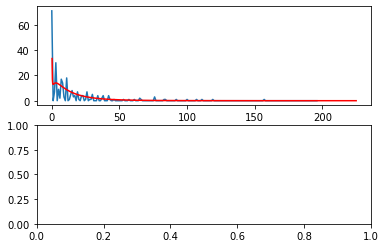

In [33]:
print(I.N_AP.shape)
print(I.k_AP.shape)
print(I.T_total)
print(I.n)

p = 0.5
nu = np.linspace(0,15*15,1001)
gamma_1 = 2.5
delta_1 = 6.5

gamma_2 = 1.01
delta_2 = 5.5

nu_max = 22.5*15

f_twoMod = (p * p_nu(nu,gamma_1,delta_1,nu_max) + (1-p) * p_nu(nu,gamma_2,delta_2,nu_max))
print(f_twoMod.shape)

p_spikes = poisson_spikes(nu,I.N_AP,I.T_total)
print(p_spikes.shape)

obsChance = f_twoMod * poisson_spikes(nu,I.N_AP[:,np.newaxis],I.T_total)

fig,ax = plt.subplots(2,1)
ax[0].plot(I.N_AP,I.k_AP)
ax[0].plot(nu,500*f_twoMod,'r-')

ax[1].plot(nu,obsChance)
plt.show()


In [43]:
I = Inference()
I.load_data('empirical',filePath='../data/BuscheLab/2P_data.xlsx',include_silent=True)
dsampler = I.run_on_data()

column names: [['WT', '20180310A'], ['WT', '20180312A'], ['WT', '20180310B'], ['WT', '20180401'], ['LM (APLP1 KO)', '20180325 (app ko7 739)'], ['LM (APLP1 KO)', '20180325A (app ko8 740)'], ['LM (APLP1 KO)', '20180402A (app ko13 734)'], ['LM (APLP1 KO)', '20180419 (app ko14 756)'], ['cTKO', '20180309'], ['cTKO', '20180310'], ['cTKO', '20180311'], ['cTKO', '20180329'], ['cTKO', '20180329A']]


iter: 5081 | batch: 0 | bound: 131 | nc: 7 | ncall: 115064 | eff(%):  4.397 | loglstar:   -inf < -226.935 <    inf | logz: -237.275 +/-  0.131 | dlogz:  8.883 >  0.010                               Process ForkPoolWorker-82:
Process ForkPoolWorker-83:
Process ForkPoolWorker-88:


KeyboardInterrupt: 

In [36]:
I = Inference()
I.load_data('empirical',filePath='../data/BuscheLab/2P_data.xlsx',include_silent=True)
I.prior

column names: [['WT', '20180310A'], ['WT', '20180312A'], ['WT', '20180310B'], ['WT', '20180401'], ['LM (APLP1 KO)', '20180325 (app ko7 739)'], ['LM (APLP1 KO)', '20180325A (app ko8 740)'], ['LM (APLP1 KO)', '20180402A (app ko13 734)'], ['LM (APLP1 KO)', '20180419 (app ko14 756)'], ['cTKO', '20180309'], ['cTKO', '20180310'], ['cTKO', '20180311'], ['cTKO', '20180329'], ['cTKO', '20180329A']]


{'gamma_1': {'mu': 1.5, 'std': 1.0, 'lower': 0.0, 'upper': inf},
 'gamma_2': {'mu': 1.5, 'std': 1.0, 'lower': 0.0, 'upper': inf},
 'delta_1': {'mu': 6.0, 'std': 2.0, 'lower': 0.0, 'upper': inf},
 'delta_2': {'mu': 6.0, 'std': 2.0, 'lower': 0.0, 'upper': inf},
 'nu_max': {'mu': 35.0, 'std': 2.0, 'lower': 5.0, 'upper': inf},
 'p': {'mu': 0.5, 'std': 0.3, 'lower': 0.0, 'upper': 1.0}}

In [23]:
res = dsampler.results

In [24]:
res.summary()

Summary
niter: 14031
ncall: 87151
eff(%): 14.051
logz: -243.137 +/-  0.054


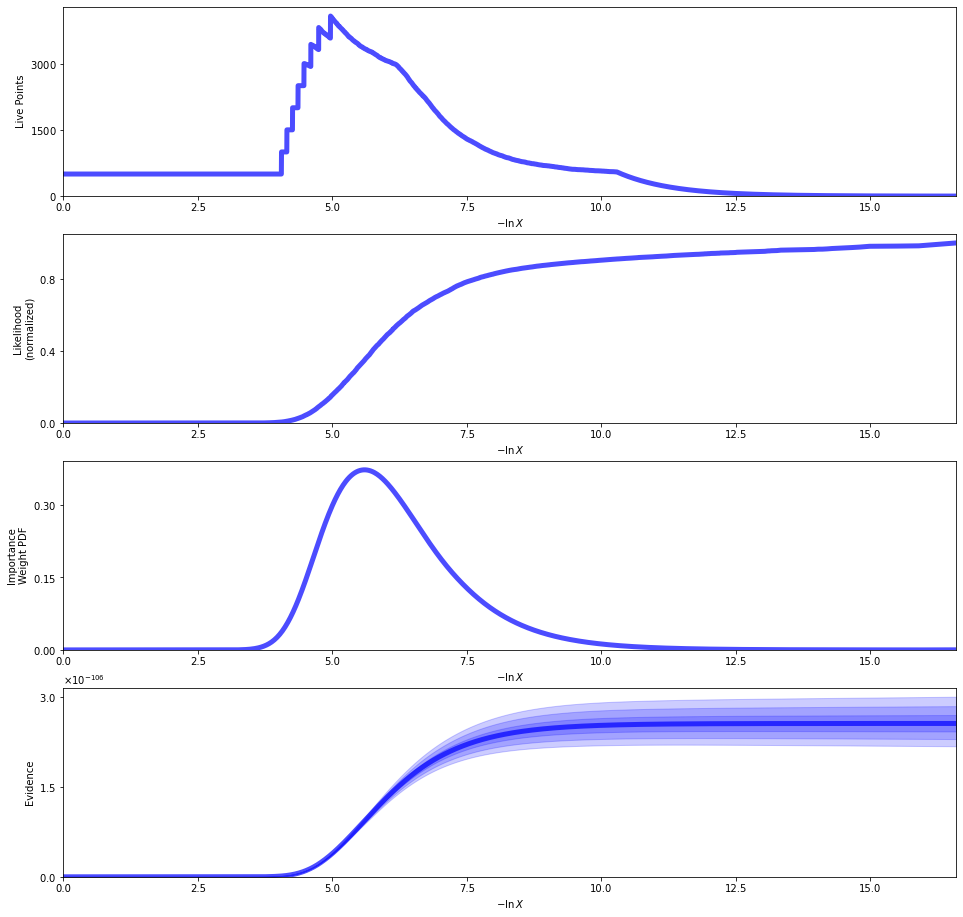

In [25]:
ndim = 3
lnz_truth = ndim * -np.log(2*10)
fig,axes = plotting.runplot(res,lnz_truth=lnz_truth)

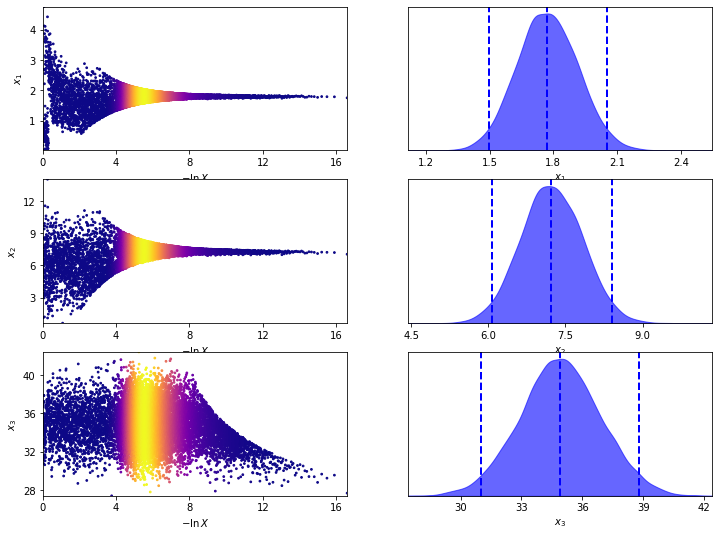

In [26]:
fig,axes = plotting.traceplot(res,truths=np.zeros(ndim))

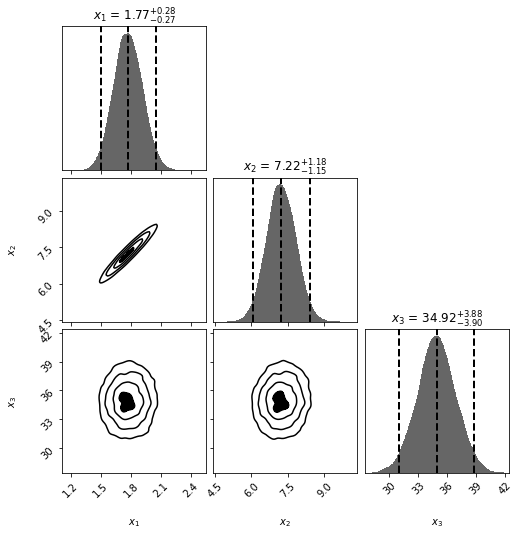

In [28]:
fig,axes = plotting.cornerplot(res,show_titles=True)

In [6]:
I = Inference()
I.load_data('empirical',filePath='../data/BuscheLab/2P_data.xlsx',include_silent=True)
logl = I.setLogLikelihood(counts=True)
priorTrafo = I.setPriorTransform()

logl(np.array([0.8,0.5,0.8]))

column names: [['WT', '20180310A'], ['WT', '20180312A'], ['WT', '20180310B'], ['WT', '20180401'], ['LM (APLP1 KO)', '20180325 (app ko7 739)'], ['LM (APLP1 KO)', '20180325A (app ko8 740)'], ['LM (APLP1 KO)', '20180402A (app ko13 734)'], ['LM (APLP1 KO)', '20180419 (app ko14 756)'], ['cTKO', '20180309'], ['cTKO', '20180310'], ['cTKO', '20180311'], ['cTKO', '20180329'], ['cTKO', '20180329A']]


-583.9199366296659

In [12]:
I = Inference()
I.load_data('empirical',filePath='../data/BuscheLab/2P_data.xlsx',include_silent=True)
result, sampler = I.run_on_data()

column names: [['WT', '20180310A'], ['WT', '20180312A'], ['WT', '20180310B'], ['WT', '20180401'], ['LM (APLP1 KO)', '20180325 (app ko7 739)'], ['LM (APLP1 KO)', '20180325A (app ko8 740)'], ['LM (APLP1 KO)', '20180402A (app ko13 734)'], ['LM (APLP1 KO)', '20180419 (app ko14 756)'], ['cTKO', '20180309'], ['cTKO', '20180310'], ['cTKO', '20180311'], ['cTKO', '20180329'], ['cTKO', '20180329A']]
logl: -318.73144685323587
logl: -1163.8485495516238
logl: -8555.297337949554
logl: -7969.903673121221
logl: -1121.7774893566145
logl: -327.6266044774803
logl: -614.01367624803
logl: -681.0633359212815
logl: -485.54373704421243
logl: -242.6562301102542
logl: -1019.9321305591842
logl: -242.85385133919755
logl: -275.18679691380834
logl: -252.67804045436276
logl: -608.7829344016285
logl: -241.90694187009802
logl: -1224.1186060332868
logl: -826.6370207219743
logl: -7576.929942556206
logl: -7838.208688216391
logl: -8933.116821667827
logl: -1401.140752668979
logl: -1672.2185821662285
logl: -1367.19278594834

logl: -2315.961398800949
logl: -780.8466134532696
logl: -273.56122366385654
logl: -2376.372880436361
logl: -3492.416052196208
logl: -750.425214460953
logl: -832.1186302775826
logl: -441.05386901552055
logl: -1835.7565138389389
logl: -554.5270797061147
logl: -753.9598677851715
logl: -757.2283053462128
logl: -431.0614497464734
logl: -1153.5462687111358
logl: -7999.0583430936285
logl: -664.5626960494092
logl: -1477.1555264667477
logl: -1385.1717693782282
logl: -321.9937070665237
logl: -1363.525282187923
logl: -1181.7454508124924
logl: -1019.5204986885344
logl: -660.7337234165099
logl: -1398.1823421237714
logl: -7869.350985466964
logl: -304.5454469510564
logl: -246.62856471170835
logl: -2553.5446935615146
logl: -483.3088878503587
logl: -243.35623688485532
logl: -985.189943904664
logl: -259.9253882481741
logl: -714.4257868968944
logl: -591.3720959742334
logl: -258.10621054291823
logl: -7480.6185125101865
logl: -7094.412902992988
logl: -1252.337492347164
logl: -1323.631249413981
logl: -7630.

iter: 1 | batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf < -10000.000 <    inf | logz: -10006.910 +/-  0.117 | dlogz:    inf >  0.010                                     

logl: -277.3985125017514
cur live logl: [  -318.73144685  -1163.84854955  -8555.29733795  -7969.90367312
  -1121.77748936   -327.62660448   -614.01367625   -681.06333592
   -485.54373704   -242.65623011 -10000.          -1019.93213056
   -242.85385134   -275.18679691   -252.67804045   -608.7829344
   -241.90694187  -1224.11860603   -826.63702072  -7576.92994256
 -10000.          -7838.20868822  -8933.11682167  -1401.14075267
  -1672.21858217  -1367.19278595  -1813.07794731   -547.27193917
  -7041.29802833   -337.50615623  -1041.0064826   -1647.38853403
  -2537.91939006  -8837.21147788   -487.99750682  -7951.91343865
   -642.95337928   -748.1652234   -7934.30304934   -243.40183466
  -8976.24572278  -7756.20812078  -7434.89954273  -1210.07903702
   -245.36276719  -1863.17295545   -894.5359155   -1323.21534936
  -8336.9018395    -319.21541905  -3163.17261777  -7682.98349658
   -874.80834255 -10000.           -509.15729384  -1037.4144473
   -846.52562622  -1317.82995929  -3529.85134429  -8

iter: 2 | batch: 0 | bound: 0 | nc: 1 | ncall: 2 | eff(%):  0.398 | loglstar:   -inf < -10000.000 <    inf | logz: -10005.811 +/-  0.108 | dlogz: 9769.111 >  0.010                                   

logl: -8402.578800011144


iter: 3 | batch: 0 | bound: 0 | nc: 1 | ncall: 3 | eff(%):  0.596 | loglstar:   -inf < -10000.000 <    inf | logz: -10005.300 +/-  0.103 | dlogz: 9768.010 >  0.010                                   

logl: -8592.85576882476


iter: 8 | batch: 0 | bound: 0 | nc: 1 | ncall: 8 | eff(%):  1.575 | loglstar:   -inf < -10000.000 <    inf | logz: -10004.202 +/-  0.091 | dlogz: 9766.534 >  0.010                                   

logl: -7966.636518766776
logl: -1175.4136115796296
logl: -1155.723775427109
logl: -607.9133339853717
logl: -817.418229145364


iter: 12 | batch: 0 | bound: 0 | nc: 1 | ncall: 12 | eff(%):  2.344 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.774 +/-  0.087 | dlogz: 9766.046 >  0.010                                 

logl: -705.6514060737386
logl: -1839.91615169286
logl: -256.34754835164284
logl: -582.9000260561919


iter: 16 | batch: 0 | bound: 0 | nc: 1 | ncall: 17 | eff(%):  3.095 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.476 +/-  0.083 | dlogz: 9765.715 >  0.010                                 

logl: -1501.1061623344692
logl: -8302.02626102459
logl: -2807.564984764554
logl: -725.1006124276555


iter: 20 | batch: 0 | bound: 0 | nc: 1 | ncall: 21 | eff(%):  3.839 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.246 +/-  0.080 | dlogz: 9765.463 >  0.010                                 

logl: -7897.803077498802
logl: -281.2540823506192
logl: -1059.1736990699196
logl: -1594.8749899738175


iter: 22 | batch: 0 | bound: 0 | nc: 1 | ncall: 23 | eff(%):  4.207 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.149 +/-  0.079 | dlogz: 9765.356 >  0.010                                 

logl: -319.6687886881402
logl: -266.712076971701


iter: 23 | batch: 0 | bound: 0 | nc: 1 | ncall: 24 | eff(%):  4.389 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.103 +/-  0.078 | dlogz: 9765.306 >  0.010                                 

logl: -1362.7443496604021


iter: 28 | batch: 0 | bound: 0 | nc: 1 | ncall: 30 | eff(%):  5.283 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.902 +/-  0.075 | dlogz: 9765.087 >  0.010                                 

logl: -2612.1315052629275
logl: -2391.7735255691014
logl: -1059.224066340349
logl: -7239.43795168754
logl: -2584.524845817625


iter: 31 | batch: 0 | bound: 0 | nc: 1 | ncall: 33 | eff(%):  5.816 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.799 +/-  0.074 | dlogz: 9764.973 >  0.010                                 

logl: -1057.0374009218383
logl: -320.095051079791
logl: -333.1574862301297


iter: 35 | batch: 0 | bound: 0 | nc: 1 | ncall: 37 | eff(%):  6.518 | loglstar:   -inf < -8996.131 <    inf | logz: -9003.111 +/-  0.118 | dlogz: 9764.838 >  0.010                                   

logl: -2920.0538145582655
logl: -958.9631918254845
logl: -1377.9654219456434
logl: -240.563323505273


iter: 37 | batch: 0 | bound: 0 | nc: 1 | ncall: 39 | eff(%):  6.865 | loglstar:   -inf < -8933.117 <    inf | logz: -8940.101 +/-  0.118 | dlogz: 8745.356 >  0.010                                   

logl: -926.1449314060502
logl: -331.99025587103444


iter: 39 | batch: 0 | bound: 0 | nc: 1 | ncall: 42 | eff(%):  7.196 | loglstar:   -inf < -8920.682 <    inf | logz: -8927.629 +/-  0.116 | dlogz: 8693.647 >  0.010                                   

logl: -1170.952537411698
logl: -1555.0326398006373


iter: 40 | batch: 0 | bound: 0 | nc: 1 | ncall: 43 | eff(%):  7.366 | loglstar:   -inf < -8844.421 <    inf | logz: -8851.411 +/-  0.118 | dlogz: 8689.751 >  0.010                                   

logl: -1445.2712406278154


iter: 43 | batch: 0 | bound: 0 | nc: 1 | ncall: 47 | eff(%):  7.861 | loglstar:   -inf < -8830.500 <    inf | logz: -8836.638 +/-  0.108 | dlogz: 8599.997 >  0.010                                   

logl: -7522.546928576679
logl: -3307.917156307326
logl: -450.52449473936093


iter: 45 | batch: 0 | bound: 0 | nc: 1 | ncall: 49 | eff(%):  8.197 | loglstar:   -inf < -8813.882 <    inf | logz: -8820.880 +/-  0.118 | dlogz: 8590.081 >  0.010                                   

logl: -294.19326296229235
logl: -385.92048944701196


iter: 47 | batch: 0 | bound: 0 | nc: 1 | ncall: 51 | eff(%):  8.530 | loglstar:   -inf < -8737.914 <    inf | logz: -8744.918 +/-  0.118 | dlogz: 8563.704 >  0.010                                   

logl: -277.799363573562
logl: -511.31240704056836


iter: 51 | batch: 0 | bound: 0 | nc: 1 | ncall: 57 | eff(%):  9.156 | loglstar:   -inf < -8668.002 <    inf | logz: -8675.014 +/-  0.118 | dlogz: 8448.010 >  0.010                                   

logl: -934.2923900148031
logl: -969.8040111374914
logl: -254.88692949313327
logl: -1194.0057848952142
logl: -8861.822032105922


iter: 56 | batch: 0 | bound: 0 | nc: 1 | ncall: 63 | eff(%):  9.947 | loglstar:   -inf < -8592.856 <    inf | logz: -8599.572 +/-  0.111 | dlogz: 8363.688 >  0.010                                   

logl: -1233.1276992950425
logl: -1172.3478882239015
logl: -645.6350510241149
logl: -329.8559058065083
logl: -1130.0216201674734


iter: 59 | batch: 0 | bound: 0 | nc: 1 | ncall: 66 | eff(%): 10.424 | loglstar:   -inf < -8508.987 <    inf | logz: -8516.015 +/-  0.118 | dlogz: 8316.585 >  0.010                                   

logl: -1313.6266949822525
logl: -729.597372724641
logl: -249.10734481856866


iter: 61 | batch: 0 | bound: 0 | nc: 1 | ncall: 68 | eff(%): 10.739 | loglstar:   -inf < -8496.502 <    inf | logz: -8503.531 +/-  0.118 | dlogz: 8272.266 >  0.010                                   

logl: -705.1986633254432
logl: -253.17439675744043


iter: 64 | batch: 0 | bound: 0 | nc: 1 | ncall: 71 | eff(%): 11.208 | loglstar:   -inf < -8402.579 <    inf | logz: -8409.617 +/-  0.118 | dlogz: 8206.831 >  0.010                                   

logl: -1319.9001413621986
logl: -7100.14122580659
logl: -3241.846747171326


iter: 67 | batch: 0 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 11.612 | loglstar:   -inf < -8340.556 <    inf | logz: -8347.600 +/-  0.118 | dlogz: 8131.678 >  0.010                                   

logl: -313.24031880116115
logl: -8637.560723373103
logl: -549.5852174763596
logl: -618.1567154877476


iter: 69 | batch: 0 | bound: 0 | nc: 1 | ncall: 79 | eff(%): 11.917 | loglstar:   -inf < -8336.902 <    inf | logz: -8343.760 +/-  0.112 | dlogz: 8108.052 >  0.010                                   

logl: -1319.8711097354787
logl: -7991.826204210074


iter: 74 | batch: 0 | bound: 0 | nc: 1 | ncall: 84 | eff(%): 12.671 | loglstar:   -inf < -8302.026 <    inf | logz: -8309.061 +/-  0.117 | dlogz: 8075.514 >  0.010                                   

logl: -827.6738928252875
logl: -1045.063693513122
logl: -435.07961023832377
logl: -7919.355140151377
logl: -2776.4516058102136


iter: 77 | batch: 0 | bound: 0 | nc: 1 | ncall: 87 | eff(%): 13.118 | loglstar:   -inf < -8217.325 <    inf | logz: -8224.340 +/-  0.116 | dlogz: 7990.132 >  0.010                                   

logl: -458.5102134979409
logl: -250.04807577853373
logl: -3099.8508709244848
logl: -8183.004709757583


iter: 80 | batch: 0 | bound: 0 | nc: 1 | ncall: 91 | eff(%): 13.536 | loglstar:   -inf < -8133.203 <    inf | logz: -8140.273 +/-  0.118 | dlogz: 7924.980 >  0.010                                   

logl: -822.7215601531192
logl: -355.4194794967306
logl: -7996.427825809589


iter: 82 | batch: 0 | bound: 0 | nc: 1 | ncall: 93 | eff(%): 13.828 | loglstar:   -inf < -8050.144 <    inf | logz: -8057.218 +/-  0.118 | dlogz: 7827.868 >  0.010                                   

logl: -297.9858531635572
logl: -237.8749701683237


iter: 85 | batch: 0 | bound: 0 | nc: 1 | ncall: 96 | eff(%): 14.262 | loglstar:   -inf < -7991.826 <    inf | logz: -7998.885 +/-  0.117 | dlogz: 7765.404 >  0.010                                   

logl: -334.4411534165213
logl: -1443.340372306184
logl: -240.23448948000456


iter: 88 | batch: 0 | bound: 0 | nc: 1 | ncall: 101 | eff(%): 14.642 | loglstar:   -inf < -7966.637 <    inf | logz: -7973.624 +/-  0.115 | dlogz: 7738.473 >  0.010                                  

logl: -1166.7218995626538
logl: -412.9767817668001
logl: -702.839228822993


iter: 89 | batch: 0 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 14.784 | loglstar:   -inf < -7951.913 <    inf | logz: -7959.001 +/-  0.118 | dlogz: 7735.648 >  0.010                                  

logl: -7575.993049596805


iter: 90 | batch: 0 | bound: 0 | nc: 1 | ncall: 103 | eff(%): 14.925 | loglstar:   -inf < -7934.303 <    inf | logz: -7941.393 +/-  0.118 | dlogz: 7721.024 >  0.010                                  

logl: -1448.3682541165235


iter: 93 | batch: 0 | bound: 0 | nc: 1 | ncall: 106 | eff(%): 15.347 | loglstar:   -inf < -7897.803 <    inf | logz: -7904.849 +/-  0.117 | dlogz: 7670.579 >  0.010                                  

logl: -701.3977862055879
logl: -1246.5997093653466
logl: -554.495573501082


iter: 97 | batch: 0 | bound: 0 | nc: 1 | ncall: 110 | eff(%): 15.902 | loglstar:   -inf < -7864.261 <    inf | logz: -7871.254 +/-  0.115 | dlogz: 7636.112 >  0.010                                  

logl: -399.804762192661
logl: -2821.1087382839064
logl: -240.74068056874418
logl: -6645.555213138372


iter: 99 | batch: 0 | bound: 0 | nc: 1 | ncall: 112 | eff(%): 16.176 | loglstar:   -inf < -7846.666 <    inf | logz: -7853.338 +/-  0.111 | dlogz: 7617.076 >  0.010                                  

logl: -745.7414395096926
logl: -325.3329183668657


iter: 102 | batch: 0 | bound: 0 | nc: 1 | ncall: 116 | eff(%): 16.558 | loglstar:   -inf < -7826.256 <    inf | logz: -7833.370 +/-  0.119 | dlogz: 7607.102 >  0.010                                 

logl: -1797.2511914317593
logl: -488.5110370554742
logl: -629.0774416743121
logl: -8338.998281278593


iter: 105 | batch: 0 | bound: 0 | nc: 1 | ncall: 120 | eff(%): 16.935 | loglstar:   -inf < -7756.208 <    inf | logz: -7763.328 +/-  0.119 | dlogz: 7571.634 >  0.010                                 

logl: -1063.523119442656
logl: -1147.7317723064145
logl: -257.4873817999404


iter: 108 | batch: 0 | bound: 0 | nc: 1 | ncall: 125 | eff(%): 17.280 | loglstar:   -inf < -7633.378 <    inf | logz: -7640.127 +/-  0.111 | dlogz: 7403.965 >  0.010                                 

logl: -8572.174824166666
logl: -7850.137246418091
logl: -257.79814408637833
logl: -281.42005720617476
logl: -2070.779068578307


iter: 114 | batch: 0 | bound: 0 | nc: 1 | ncall: 131 | eff(%): 18.067 | loglstar:   -inf < -7522.547 <    inf | logz: -7529.685 +/-  0.119 | dlogz: 7328.449 >  0.010                                 

logl: -1446.5322253041013
logl: -661.5756313136411
logl: -6469.704673949546
logl: -552.6023670503018
logl: -7022.117072846108
logl: -787.7578758439993
logl: -2075.1241642247433


iter: 117 | batch: 0 | bound: 0 | nc: 2 | ncall: 135 | eff(%): 18.425 | loglstar:   -inf < -7480.619 <    inf | logz: -7487.762 +/-  0.119 | dlogz: 7277.650 >  0.010                                 

logl: -711.1039083810377
logl: -7552.942724238669
logl: -955.1502389419903


iter: 118 | batch: 0 | bound: 0 | nc: 3 | ncall: 138 | eff(%): 18.495 | loglstar:   -inf < -7466.512 <    inf | logz: -7473.658 +/-  0.119 | dlogz: 7249.729 >  0.010                                 

logl: -8557.59066996234
logl: -294.54100095155343


iter: 121 | batch: 0 | bound: 0 | nc: 1 | ncall: 141 | eff(%): 18.877 | loglstar:   -inf < -7239.438 <    inf | logz: -7246.590 +/-  0.119 | dlogz: 7204.010 >  0.010                                 

logl: -442.00826419114605
logl: -2261.428401906625
logl: -1386.0292448450698


iter: 123 | batch: 0 | bound: 0 | nc: 1 | ncall: 144 | eff(%): 19.099 | loglstar:   -inf < -7152.950 <    inf | logz: -7160.106 +/-  0.119 | dlogz: 6976.338 >  0.010                                 

logl: -646.9089208120245
logl: -492.82140622024195


iter: 126 | batch: 0 | bound: 0 | nc: 1 | ncall: 147 | eff(%): 19.474 | loglstar:   -inf < -7100.141 <    inf | logz: -7107.303 +/-  0.119 | dlogz: 6913.452 >  0.010                                 

logl: -601.4492709515397
logl: -2540.562902010709
logl: -242.0186148135051


iter: 128 | batch: 0 | bound: 0 | nc: 1 | ncall: 149 | eff(%): 19.723 | loglstar:   -inf < -7073.695 <    inf | logz: -7080.860 +/-  0.119 | dlogz: 6863.517 >  0.010                                 

logl: -263.7407215616009
logl: -252.13840771761357


iter: 131 | batch: 0 | bound: 0 | nc: 1 | ncall: 153 | eff(%): 20.061 | loglstar:   -inf < -7056.311 <    inf | logz: -7063.477 +/-  0.119 | dlogz: 6831.149 >  0.010                                 

logl: -8344.68832294983
logl: -1273.3518432433448
logl: -340.6999953257009
logl: -1374.7016884516465


iter: 132 | batch: 0 | bound: 0 | nc: 1 | ncall: 154 | eff(%): 20.183 | loglstar:   -inf < -7041.298 <    inf | logz: -7048.472 +/-  0.119 | dlogz: 6825.415 >  0.010                                 

logl: -584.598209817116


iter: 136 | batch: 0 | bound: 0 | nc: 1 | ncall: 159 | eff(%): 20.637 | loglstar:   -inf < -6833.871 <    inf | logz: -6841.053 +/-  0.119 | dlogz: 6632.062 >  0.010                                 

logl: -915.912246847203
logl: -904.4161833031658
logl: -974.1408919887418
logl: -1016.3160925774246


iter: 139 | batch: 0 | bound: 0 | nc: 1 | ncall: 162 | eff(%): 20.997 | loglstar:   -inf < -6710.325 <    inf | logz: -6717.513 +/-  0.119 | dlogz: 6535.817 >  0.010                                 

logl: -237.8625752464424
logl: -2734.7096552677335
logl: -797.6018939203007


iter: 140 | batch: 0 | bound: 0 | nc: 2 | ncall: 164 | eff(%): 21.084 | loglstar:   -inf < -6708.073 <    inf | logz: -6715.071 +/-  0.114 | dlogz: 6479.435 >  0.010                                 

logl: -8519.804588940598
logl: -836.8458234272182
logl: -1035.1373802118515


iter: 144 | batch: 0 | bound: 0 | nc: 1 | ncall: 170 | eff(%): 21.493 | loglstar:   -inf < -6550.964 <    inf | logz: -6558.162 +/-  0.119 | dlogz: 6414.666 >  0.010                                 

logl: -929.8362900446358
logl: -6787.6925747449795
logl: -6804.017721223642
logl: -470.1754531917037
logl: -6526.184297795397


iter: 145 | batch: 0 | bound: 0 | nc: 2 | ncall: 172 | eff(%): 21.577 | loglstar:   -inf < -6526.184 <    inf | logz: -6533.384 +/-  0.119 | dlogz: 6320.075 >  0.010                                 

logl: -7446.342491053925
logl: -1771.228027619529


iter: 146 | batch: 0 | bound: 0 | nc: 1 | ncall: 173 | eff(%): 21.694 | loglstar:   -inf < -6469.705 <    inf | logz: -6476.906 +/-  0.119 | dlogz: 6295.295 >  0.010                                 

logl: -1084.0154891006994


iter: 148 | batch: 0 | bound: 0 | nc: 1 | ncall: 175 | eff(%): 21.926 | loglstar:   -inf < -3492.416 <    inf | logz: -3499.622 +/-  0.119 | dlogz: 3298.962 >  0.010                                 

logl: -1437.3940593549041
logl: -1346.001385400913
logl: -7958.755977427566


iter: 149 | batch: 0 | bound: 0 | nc: 2 | ncall: 177 | eff(%): 22.009 | loglstar:   -inf < -3407.232 <    inf | logz: -3414.440 +/-  0.119 | dlogz: 3261.527 >  0.010                                 

logl: -862.4661277376051


iter: 150 | batch: 0 | bound: 0 | nc: 2 | ncall: 179 | eff(%): 22.091 | loglstar:   -inf < -3336.666 <    inf | logz: -3343.876 +/-  0.119 | dlogz: 3176.343 >  0.010                                 

logl: -659.3286113407645


iter: 152 | batch: 0 | bound: 0 | nc: 1 | ncall: 181 | eff(%): 22.320 | loglstar:   -inf < -3307.917 <    inf | logz: -3315.126 +/-  0.119 | dlogz: 3082.984 >  0.010                                 

logl: -492.0034368664203
logl: -2085.8579280884705


iter: 154 | batch: 0 | bound: 0 | nc: 1 | ncall: 183 | eff(%): 22.548 | loglstar:   -inf < -3241.847 <    inf | logz: -3249.065 +/-  0.120 | dlogz: 3074.072 >  0.010                                 

logl: -1126.8840294300167
logl: -1145.9913646066211


iter: 155 | batch: 0 | bound: 0 | nc: 1 | ncall: 184 | eff(%): 22.661 | loglstar:   -inf < -3199.826 <    inf | logz: -3207.046 +/-  0.120 | dlogz: 3010.957 >  0.010                                 

logl: -293.12961308378726


iter: 157 | batch: 0 | bound: 0 | nc: 2 | ncall: 187 | eff(%): 22.853 | loglstar:   -inf < -3099.851 <    inf | logz: -3107.075 +/-  0.120 | dlogz: 2932.283 >  0.010                                 

logl: -734.9094826529852
logl: -6941.476011308627
logl: -2553.649818903273


iter: 158 | batch: 0 | bound: 0 | nc: 1 | ncall: 188 | eff(%): 22.965 | loglstar:   -inf < -2992.980 <    inf | logz: -3000.206 +/-  0.120 | dlogz: 2868.961 >  0.010                                 

logl: -882.8485911255381


iter: 161 | batch: 0 | bound: 0 | nc: 1 | ncall: 194 | eff(%): 23.199 | loglstar:   -inf < -2920.054 <    inf | logz: -2927.239 +/-  0.118 | dlogz: 2692.898 >  0.010                                 

logl: -7625.658726905126
logl: -6561.4289656975625
logl: -2923.7872120153975
logl: -3198.5458654153394
logl: -2224.1954760367635
logl: -1411.0206819993564


iter: 164 | batch: 0 | bound: 0 | nc: 1 | ncall: 197 | eff(%): 23.529 | loglstar:   -inf < -2834.078 <    inf | logz: -2841.315 +/-  0.120 | dlogz: 2658.587 >  0.010                                 

logl: -551.9468841165481
logl: -541.461984013882
logl: -1384.1037388331326


iter: 165 | batch: 0 | bound: 0 | nc: 2 | ncall: 199 | eff(%): 23.605 | loglstar:   -inf < -2821.109 <    inf | logz: -2828.349 +/-  0.120 | dlogz: 2603.188 >  0.010                                 

logl: -290.17673970297517


iter: 171 | batch: 0 | bound: 0 | nc: 1 | ncall: 206 | eff(%): 24.221 | loglstar:   -inf < -2727.754 <    inf | logz: -2735.003 +/-  0.120 | dlogz: 2503.820 >  0.010                                 

logl: -361.6822150261371
logl: -1420.6284987765157
logl: -934.1736109185837
logl: -1427.7840818550926
logl: -1848.260710885199
logl: -2601.815207439503


iter: 173 | batch: 0 | bound: 0 | nc: 1 | ncall: 209 | eff(%): 24.401 | loglstar:   -inf < -2717.241 <    inf | logz: -2724.497 +/-  0.120 | dlogz: 2495.137 >  0.010                                 

logl: -248.92569008690242
logl: -530.3196937408838


iter: 176 | batch: 0 | bound: 0 | nc: 1 | ncall: 212 | eff(%): 24.719 | loglstar:   -inf < -2601.815 <    inf | logz: -2609.077 +/-  0.120 | dlogz: 2379.659 >  0.010                                 

logl: -1133.3820208497682
logl: -1208.4463173114725
logl: -2460.599311211945


iter: 177 | batch: 0 | bound: 0 | nc: 4 | ncall: 216 | eff(%): 24.721 | loglstar:   -inf < -2584.525 <    inf | logz: -2591.789 +/-  0.120 | dlogz: 2370.926 >  0.010                                 

logl: -7730.315604454861
logl: -2982.1573216583206
logl: -2311.3871273765585


iter: 180 | batch: 0 | bound: 0 | nc: 1 | ncall: 221 | eff(%): 24.965 | loglstar:   -inf < -2540.563 <    inf | logz: -2547.833 +/-  0.120 | dlogz: 2321.625 >  0.010                                 

logl: -1272.3369866860937
logl: -7814.102858390945
logl: -8901.059445816512
logl: -453.44743418677785
logl: -1997.9492258886298


iter: 185 | batch: 0 | bound: 0 | nc: 1 | ncall: 226 | eff(%): 25.482 | loglstar:   -inf < -2389.226 <    inf | logz: -2396.360 +/-  0.116 | dlogz: 2160.884 >  0.010                                 

logl: -296.28891217588273
logl: -266.4631193074186
logl: -846.330309936946
logl: -1219.259759311016
logl: -2150.2662446457193


iter: 187 | batch: 0 | bound: 0 | nc: 1 | ncall: 228 | eff(%): 25.687 | loglstar:   -inf < -2343.603 <    inf | logz: -2350.887 +/-  0.120 | dlogz: 2145.483 >  0.010                                 

logl: -242.55957278098867
logl: -572.422392239258


iter: 188 | batch: 0 | bound: 0 | nc: 2 | ncall: 230 | eff(%): 25.753 | loglstar:   -inf < -2327.965 <    inf | logz: -2335.250 +/-  0.120 | dlogz: 2112.714 >  0.010                                 

logl: -1280.7438456075256
logl: -7871.322155300233


iter: 190 | batch: 0 | bound: 0 | nc: 2 | ncall: 234 | eff(%): 25.886 | loglstar:   -inf < -2311.387 <    inf | logz: -2318.656 +/-  0.119 | dlogz: 2085.072 >  0.010                                 

logl: -1357.4052077950162
logl: -8913.418299663374
logl: -411.67953816408874


iter: 193 | batch: 0 | bound: 0 | nc: 1 | ncall: 238 | eff(%): 26.152 | loglstar:   -inf < -2261.428 <    inf | logz: -2268.724 +/-  0.120 | dlogz: 2051.972 >  0.010                                 

logl: -297.98607720913805
logl: -253.19205962717888
logl: -280.9544279109262


iter: 195 | batch: 0 | bound: 0 | nc: 1 | ncall: 241 | eff(%): 26.316 | loglstar:   -inf < -2254.470 <    inf | logz: -2260.876 +/-  0.111 | dlogz: 2023.906 >  0.010                                 

logl: -8747.531191269109
logl: -279.02095804231715
logl: -284.62407760400674


iter: 197 | batch: 0 | bound: 0 | nc: 1 | ncall: 243 | eff(%): 26.514 | loglstar:   -inf < -2159.899 <    inf | logz: -2167.203 +/-  0.120 | dlogz: 1993.538 >  0.010                                 

logl: -237.56476150964255
logl: -944.2304306054999


iter: 200 | batch: 0 | bound: 0 | nc: 1 | ncall: 247 | eff(%): 26.774 | loglstar:   -inf < -2085.858 <    inf | logz: -2093.167 +/-  0.120 | dlogz: 1862.980 >  0.010                                 

logl: -1125.5271091559414
logl: -1978.3851397014203
logl: -1327.0937187411032


iter: 201 | batch: 0 | bound: 0 | nc: 1 | ncall: 248 | eff(%): 26.872 | loglstar:   -inf < -2075.124 <    inf | logz: -2082.436 +/-  0.120 | dlogz: 1855.200 >  0.010                                 

logl: -785.7407893160113


iter: 203 | batch: 0 | bound: 0 | nc: 1 | ncall: 252 | eff(%): 26.995 | loglstar:   -inf < -2058.788 <    inf | logz: -2066.103 +/-  0.120 | dlogz: 1840.096 >  0.010                                 

logl: -2792.0675994830362
logl: -1705.9160481414058
logl: -673.7325227682838


iter: 207 | batch: 0 | bound: 0 | nc: 2 | ncall: 258 | eff(%): 27.309 | loglstar:   -inf < -1935.579 <    inf | logz: -1942.902 +/-  0.120 | dlogz: 1747.728 >  0.010                                 

logl: -375.7982952453817
logl: -319.5034464267798
logl: -6703.373287054265
logl: -922.4211540209893
logl: -7020.998806333535
logl: -1214.4499205253553
logl: -2987.0303265540174
logl: -2444.08010768057


iter: 208 | batch: 0 | bound: 0 | nc: 3 | ncall: 261 | eff(%): 27.332 | loglstar:   -inf < -1926.872 <    inf | logz: -1934.198 +/-  0.120 | dlogz: 1704.922 >  0.010                                 

logl: -1485.6613905621862


iter: 209 | batch: 0 | bound: 0 | nc: 2 | ncall: 263 | eff(%): 27.392 | loglstar:   -inf < -1903.711 <    inf | logz: -1911.039 +/-  0.120 | dlogz: 1696.215 >  0.010                                 

logl: -943.523477847478
logl: -2545.614321394156


iter: 210 | batch: 0 | bound: 0 | nc: 3 | ncall: 266 | eff(%): 27.415 | loglstar:   -inf < -1866.699 <    inf | logz: -1874.029 +/-  0.120 | dlogz: 1673.054 >  0.010                                 

logl: -7916.131815509589
logl: -266.212198505073


iter: 211 | batch: 0 | bound: 0 | nc: 1 | ncall: 267 | eff(%): 27.510 | loglstar:   -inf < -1863.173 <    inf | logz: -1870.447 +/-  0.118 | dlogz: 1636.042 >  0.010                                 

logl: -448.62901521191816
logl: -8589.332790567822
logl: -7731.326741851273
logl: -9056.852821562112


iter: 212 | batch: 0 | bound: 0 | nc: 7 | ncall: 274 | eff(%): 27.390 | loglstar:   -inf < -1856.978 <    inf | logz: -1864.308 +/-  0.120 | dlogz: 1632.459 >  0.010                                 

logl: -7984.992661683732
logl: -554.7550938725763


iter: 216 | batch: 0 | bound: 0 | nc: 2 | ncall: 281 | eff(%): 27.657 | loglstar:   -inf < -1835.757 <    inf | logz: -1843.067 +/-  0.119 | dlogz: 1609.256 >  0.010                                 

logl: -263.7214637521524
logl: -1208.1345079840546
logl: -8129.376212362867
logl: -334.62944945711564
logl: -7491.2576816006995
logl: -1099.284536927232
logl: -6643.841527600804
logl: -2976.100319298043


iter: 219 | batch: 0 | bound: 0 | nc: 1 | ncall: 287 | eff(%): 27.827 | loglstar:   -inf < -1797.251 <    inf | logz: -1804.556 +/-  0.119 | dlogz: 1570.410 >  0.010                                 

logl: -752.795816997043
logl: -1928.9744729449772
logl: -557.8749632428534
logl: -290.9477512240292


iter: 222 | batch: 0 | bound: 0 | nc: 1 | ncall: 290 | eff(%): 28.101 | loglstar:   -inf < -1705.916 <    inf | logz: -1712.734 +/-  0.112 | dlogz: 1476.298 >  0.010                                 

logl: -443.7007684506755
logl: -1132.0506848246102
logl: -402.50785298270546


iter: 224 | batch: 0 | bound: 0 | nc: 1 | ncall: 293 | eff(%): 28.247 | loglstar:   -inf < -1688.409 <    inf | logz: -1695.754 +/-  0.120 | dlogz: 1462.778 >  0.010                                 

logl: -1237.2301342319574
logl: -248.85781075169558


iter: 225 | batch: 0 | bound: 0 | nc: 1 | ncall: 294 | eff(%): 28.338 | loglstar:   -inf < -1672.219 <    inf | logz: -1679.578 +/-  0.121 | dlogz: 1457.739 >  0.010                                 

logl: -696.0388537344265


iter: 228 | batch: 0 | bound: 0 | nc: 1 | ncall: 297 | eff(%): 28.607 | loglstar:   -inf < -1622.143 <    inf | logz: -1629.507 +/-  0.121 | dlogz: 1398.769 >  0.010                                 

logl: -1312.8142111407492
logl: -529.4042530580921
logl: -1188.0138399961168


iter: 231 | batch: 0 | bound: 0 | nc: 1 | ncall: 302 | eff(%): 28.803 | loglstar:   -inf < -1594.875 <    inf | logz: -1602.200 +/-  0.119 | dlogz: 1367.944 >  0.010                                 

logl: -8859.709374231446
logl: -873.8701461133011
logl: -2834.012460309554
logl: -422.1386756898425
logl: -283.4212428632974
logl: -6751.956121103106


iter: 234 | batch: 0 | bound: 0 | nc: 1 | ncall: 307 | eff(%): 28.996 | loglstar:   -inf < -1555.033 <    inf | logz: -1562.388 +/-  0.120 | dlogz: 1328.883 >  0.010                                 

logl: -668.4063521766749
logl: -7621.718265103426
logl: -571.5014280765943
logl: -528.4172299375211


iter: 235 | batch: 0 | bound: 0 | nc: 3 | ncall: 310 | eff(%): 29.012 | loglstar:   -inf < -1537.075 <    inf | logz: -1544.455 +/-  0.121 | dlogz: 1324.354 >  0.010                                 

logl: -8664.560787706514
logl: -319.5634779697608


iter: 236 | batch: 0 | bound: 0 | nc: 1 | ncall: 311 | eff(%): 29.100 | loglstar:   -inf < -1526.857 <    inf | logz: -1534.239 +/-  0.121 | dlogz: 1306.418 >  0.010                                 

logl: -631.9936942200263


iter: 239 | batch: 0 | bound: 0 | nc: 5 | ncall: 318 | eff(%): 29.218 | loglstar:   -inf < -1507.828 <    inf | logz: -1514.205 +/-  0.111 | dlogz: 1277.308 >  0.010                                 

logl: -1195.1848827846582
logl: -252.58639163884737
logl: -6557.421972289875
logl: -2609.874383206446
logl: -8051.772735702007
logl: -8860.849367338502
logl: -241.18214133328752


iter: 240 | batch: 0 | bound: 0 | nc: 1 | ncall: 319 | eff(%): 29.304 | loglstar:   -inf < -1501.106 <    inf | logz: -1508.491 +/-  0.121 | dlogz: 1276.161 >  0.010                                 

logl: -280.9906541198991


iter: 243 | batch: 0 | bound: 0 | nc: 1 | ncall: 328 | eff(%): 29.348 | loglstar:   -inf < -1485.661 <    inf | logz: -1492.335 +/-  0.112 | dlogz: 1255.641 >  0.010                                 

logl: -8280.449840392663
logl: -8260.31684037667
logl: -707.5652644838941
logl: -2242.9659082215303
logl: -8553.449192061684
logl: -1261.4216815403252
logl: -1472.151202427699
logl: -2825.658960380658


iter: 245 | batch: 0 | bound: 0 | nc: 1 | ncall: 332 | eff(%): 29.447 | loglstar:   -inf < -1478.909 <    inf | logz: -1486.195 +/-  0.117 | dlogz: 1251.029 >  0.010                                 

logl: -7780.615191322808
logl: -1028.150229552211
logl: -810.060314737525


iter: 247 | batch: 0 | bound: 0 | nc: 1 | ncall: 334 | eff(%): 29.616 | loglstar:   -inf < -1472.151 <    inf | logz: -1479.539 +/-  0.120 | dlogz: 1246.185 >  0.010                                 

logl: -1193.5559816616399
logl: -274.9303020795761
logl: -7651.6240488064705


iter: 249 | batch: 0 | bound: 0 | nc: 1 | ncall: 338 | eff(%): 29.714 | loglstar:   -inf < -1448.368 <    inf | logz: -1455.776 +/-  0.121 | dlogz: 1237.527 >  0.010                                 

logl: -337.13522641648575
logl: -425.6421313821255


iter: 250 | batch: 0 | bound: 0 | nc: 2 | ncall: 340 | eff(%): 29.762 | loglstar:   -inf < -1446.532 <    inf | logz: -1453.665 +/-  0.115 | dlogz: 1217.711 >  0.010                                 

logl: -7864.21790303755
logl: -975.4191223955314
logl: -8218.184556601007
logl: -1908.2226749965298


iter: 252 | batch: 0 | bound: 0 | nc: 1 | ncall: 344 | eff(%): 29.858 | loglstar:   -inf < -1445.271 <    inf | logz: -1451.453 +/-  0.107 | dlogz: 1214.182 >  0.010                                 

logl: -1373.440947474292
logl: -996.1344222174857
logl: -7514.384345937547


iter: 256 | batch: 0 | bound: 0 | nc: 2 | ncall: 352 | eff(%): 30.047 | loglstar:   -inf < -1420.628 <    inf | logz: -1428.049 +/-  0.121 | dlogz: 1197.127 >  0.010                                 

logl: -266.4511867054107
logl: -6538.780490172641
logl: -241.75653225461846
logl: -1082.7001950361307
logl: -8696.515709045101
logl: -518.907030894825
logl: -2710.6604996512456


iter: 259 | batch: 0 | bound: 0 | nc: 1 | ncall: 356 | eff(%): 30.257 | loglstar:   -inf < -1402.097 <    inf | logz: -1409.522 +/-  0.121 | dlogz: 1177.831 >  0.010                                 

logl: -309.43019487510094
logl: -278.4746091594492
logl: -338.9968062579655
logl: -2915.085267947994
logl: -8804.380038152165


iter: 261 | batch: 0 | bound: 0 | nc: 2 | ncall: 362 | eff(%): 30.278 | loglstar:   -inf < -1398.182 <    inf | logz: -1405.479 +/-  0.117 | dlogz: 1169.913 >  0.010                                 

logl: -8526.647431224123
logl: -243.47558854924995
logl: -2816.2003833266585
logl: -1182.0737514564157


iter: 262 | batch: 0 | bound: 0 | nc: 1 | ncall: 363 | eff(%): 30.359 | loglstar:   -inf < -1386.029 <    inf | logz: -1393.463 +/-  0.121 | dlogz: 1167.391 >  0.010                                 

logl: -251.3661819381533


iter: 264 | batch: 0 | bound: 0 | nc: 1 | ncall: 368 | eff(%): 30.415 | loglstar:   -inf < -1384.104 <    inf | logz: -1390.858 +/-  0.110 | dlogz: 1153.900 >  0.010                                 

logl: -2081.1131186561342
logl: -8763.307321694785
logl: -295.2689887745091
logl: -471.7851134381688
logl: -3160.402774834884


iter: 266 | batch: 0 | bound: 0 | nc: 1 | ncall: 372 | eff(%): 30.505 | loglstar:   -inf < -1377.965 <    inf | logz: -1385.365 +/-  0.120 | dlogz: 1151.009 >  0.010                                 

logl: -3068.0685907260645
logl: -1363.2705392915832
logl: -482.9956192071892


iter: 267 | batch: 0 | bound: 0 | nc: 1 | ncall: 373 | eff(%): 30.584 | loglstar:   -inf < -1377.496 <    inf | logz: -1384.116 +/-  0.112 | dlogz: 1147.266 >  0.010                                 

logl: -783.9561220157732


iter: 269 | batch: 0 | bound: 0 | nc: 1 | ncall: 375 | eff(%): 30.743 | loglstar:   -inf < -1374.702 <    inf | logz: -1381.506 +/-  0.110 | dlogz: 1144.641 >  0.010                                 

logl: -1179.9318666923498
logl: -306.141896858026


iter: 272 | batch: 0 | bound: 0 | nc: 1 | ncall: 378 | eff(%): 30.979 | loglstar:   -inf < -1367.193 <    inf | logz: -1373.905 +/-  0.112 | dlogz: 1137.130 >  0.010                                 

logl: -589.2185184417127
logl: -1121.1521102172028
logl: -771.3199544581778


iter: 273 | batch: 0 | bound: 0 | nc: 1 | ncall: 379 | eff(%): 31.058 | loglstar:   -inf < -1363.525 <    inf | logz: -1370.905 +/-  0.118 | dlogz: 1135.794 >  0.010                                 

logl: -262.08667790527124
logl: -8414.343950914865
logl: -7814.235451088014


iter: 274 | batch: 0 | bound: 0 | nc: 4 | ncall: 383 | eff(%): 31.031 | loglstar:   -inf < -1363.467 <    inf | logz: -1369.838 +/-  0.111 | dlogz: 1132.792 >  0.010                                 

logl: -571.7146565654151


iter: 277 | batch: 0 | bound: 0 | nc: 2 | ncall: 388 | eff(%): 31.194 | loglstar:   -inf < -1358.504 <    inf | logz: -1365.896 +/-  0.118 | dlogz: 1130.673 >  0.010                                 

logl: -748.7683192465838
logl: -826.0383308416793
logl: -2329.0223194616337
logl: -403.3826139240394


iter: 280 | batch: 0 | bound: 0 | nc: 1 | ncall: 391 | eff(%): 31.425 | loglstar:   -inf < -1356.029 <    inf | logz: -1362.654 +/-  0.107 | dlogz: 1125.369 >  0.010                                 

logl: -264.45261104848714
logl: -247.48239241858712
logl: -609.5716865839003
logl: -7067.903747641255
logl: -8585.710440714285


iter: 283 | batch: 0 | bound: 0 | nc: 1 | ncall: 397 | eff(%): 31.550 | loglstar:   -inf < -1327.094 <    inf | logz: -1334.569 +/-  0.122 | dlogz: 1104.555 >  0.010                                 

logl: -7414.8403593241665
logl: -657.7076366828175
logl: -392.0581015124981
logl: -517.1288284795717
logl: -7445.758341475799


iter: 288 | batch: 0 | bound: 0 | nc: 1 | ncall: 405 | eff(%): 31.823 | loglstar:   -inf < -1319.900 <    inf | logz: -1327.028 +/-  0.112 | dlogz: 1090.442 >  0.010                                 

logl: -535.7554043698265
logl: -963.8252920578321
logl: -7886.528653241619
logl: -1258.2577450914016
logl: -8031.858207932849
logl: -237.77524426269923
logl: -944.9611929457823
logl: -3357.0876265532806


iter: 290 | batch: 0 | bound: 0 | nc: 1 | ncall: 408 | eff(%): 31.938 | loglstar:   -inf < -1317.830 <    inf | logz: -1324.870 +/-  0.111 | dlogz: 1088.001 >  0.010                                 

logl: -315.63944715103895
logl: -928.9449443855411


iter: 292 | batch: 0 | bound: 0 | nc: 1 | ncall: 410 | eff(%): 32.088 | loglstar:   -inf < -1313.627 <    inf | logz: -1320.830 +/-  0.115 | dlogz: 1084.644 >  0.010                                 

logl: -355.497667590362
logl: -241.39281979227502
logl: -1330.688506830887


iter: 293 | batch: 0 | bound: 0 | nc: 3 | ncall: 413 | eff(%): 32.092 | loglstar:   -inf < -1312.814 <    inf | logz: -1319.598 +/-  0.111 | dlogz: 1082.679 >  0.010                                 

logl: -2915.9274032029184
logl: -278.76822945218595


iter: 295 | batch: 0 | bound: 0 | nc: 1 | ncall: 417 | eff(%): 32.170 | loglstar:   -inf < -1304.705 <    inf | logz: -1311.483 +/-  0.113 | dlogz: 1074.686 >  0.010                                 

logl: -2897.0123112315177
logl: -675.6955981618299
logl: -495.3096320596106


iter: 296 | batch: 0 | bound: 0 | nc: 2 | ncall: 419 | eff(%): 32.209 | loglstar:   -inf < -1293.329 <    inf | logz: -1300.831 +/-  0.122 | dlogz: 1073.327 >  0.010                                 

logl: -247.0041623556998
logl: -7169.730265800761


iter: 300 | batch: 0 | bound: 0 | nc: 1 | ncall: 425 | eff(%): 32.432 | loglstar:   -inf < -1272.337 <    inf | logz: -1279.301 +/-  0.114 | dlogz: 1042.694 >  0.010                                 

logl: -8338.578585515756
logl: -973.4609127955301
logl: -535.5859961448531
logl: -1270.5297590746948
logl: -288.570618582677


iter: 301 | batch: 0 | bound: 0 | nc: 3 | ncall: 428 | eff(%): 32.435 | loglstar:   -inf < -1270.530 <    inf | logz: -1277.671 +/-  0.113 | dlogz: 1041.134 >  0.010                                 

logl: -7821.419648852362
logl: -1314.5767073359236
logl: -305.0337462296479
logl: -6982.215532630728
logl: -8004.2540066943675


iter: 303 | batch: 0 | bound: 0 | nc: 1 | ncall: 432 | eff(%): 32.511 | loglstar:   -inf < -1263.479 <    inf | logz: -1270.983 +/-  0.121 | dlogz: 1037.810 >  0.010                                 

logl: -253.64634825875095
logl: -316.2713302414303


iter: 305 | batch: 0 | bound: 0 | nc: 2 | ncall: 435 | eff(%): 32.620 | loglstar:   -inf < -1261.422 <    inf | logz: -1268.157 +/-  0.110 | dlogz: 1031.089 >  0.010                                 

logl: -246.2709537077074
logl: -3108.1429371077033
logl: -337.19272175205305


iter: 309 | batch: 0 | bound: 0 | nc: 1 | ncall: 442 | eff(%): 32.803 | loglstar:   -inf < -1237.230 <    inf | logz: -1244.757 +/-  0.122 | dlogz: 1015.936 >  0.010                                 

logl: -244.84566816206444
logl: -6634.428590398371
logl: -8160.974442761311
logl: -410.49412044962963
logl: -859.5946634976902
logl: -341.5189021498275
logl: -6730.510900815758


iter: 310 | batch: 0 | bound: 0 | nc: 5 | ncall: 447 | eff(%): 32.735 | loglstar:   -inf < -1234.633 <    inf | logz: -1242.024 +/-  0.118 | dlogz: 1006.573 >  0.010                                 

logl: -2018.5501346089209
logl: -2864.8720443402167
logl: -7464.832770046152
logl: -899.2001777314256
logl: -1708.1591476021083
logl: -1665.874843687278


iter: 312 | batch: 0 | bound: 0 | nc: 1 | ncall: 451 | eff(%): 32.808 | loglstar:   -inf < -1224.119 <    inf | logz: -1231.652 +/-  0.122 | dlogz: 1002.080 >  0.010                                 

logl: -282.93003532818426
logl: -764.0309299992753
logl: -8723.59768784497


iter: 314 | batch: 0 | bound: 0 | nc: 1 | ncall: 456 | eff(%): 32.845 | loglstar:   -inf < -1214.450 <    inf | logz: -1221.971 +/-  0.121 | dlogz: 988.587 >  0.010                                  

logl: -364.9566681215605
logl: -264.648189543518
logl: -3045.0891437114715


iter: 315 | batch: 0 | bound: 0 | nc: 3 | ncall: 459 | eff(%): 32.847 | loglstar:   -inf < -1210.079 <    inf | logz: -1217.593 +/-  0.121 | dlogz: 983.777 >  0.010                                  

logl: -1663.6553943093916
logl: -361.9275026193546


iter: 319 | batch: 0 | bound: 0 | nc: 2 | ncall: 466 | eff(%): 33.023 | loglstar:   -inf < -1207.076 <    inf | logz: -1213.617 +/-  0.106 | dlogz: 976.093 >  0.010                                  

logl: -347.08493146740943
logl: -1724.206658237211
logl: -1074.1523239406533
logl: -1035.1276725538382
logl: -7097.187769219327
logl: -337.8492507219217
logl: -7096.429749712333


iter: 321 | batch: 0 | bound: 0 | nc: 1 | ncall: 470 | eff(%): 33.093 | loglstar:   -inf < -1197.772 <    inf | logz: -1205.319 +/-  0.122 | dlogz: 973.153 >  0.010                                  

logl: -465.2450723263955
logl: -666.1470598187202


iter: 324 | batch: 0 | bound: 0 | nc: 1 | ncall: 475 | eff(%): 33.231 | loglstar:   -inf < -1193.556 <    inf | logz: -1200.120 +/-  0.109 | dlogz: 962.841 >  0.010                                  

logl: -1133.646224484344
logl: -3193.932858635319
logl: -322.1581451856585
logl: -285.4130412524543
logl: -7450.264006846125
logl: -7550.356926785208
logl: -3013.3582755591433


iter: 326 | batch: 0 | bound: 0 | nc: 1 | ncall: 483 | eff(%): 33.164 | loglstar:   -inf < -1182.535 <    inf | logz: -1190.088 +/-  0.122 | dlogz: 957.342 >  0.010                                  

logl: -8612.243594688747
logl: -7848.692409396573
logl: -2600.4867508000407
logl: -741.5328492458162
logl: -907.3697830932304
logl: -1601.7287108411801


iter: 328 | batch: 0 | bound: 0 | nc: 1 | ncall: 486 | eff(%): 33.266 | loglstar:   -inf < -1181.745 <    inf | logz: -1188.100 +/-  0.109 | dlogz: 950.598 >  0.010                                  

logl: -1014.7629532316026
logl: -705.4037720044545


iter: 332 | batch: 0 | bound: 0 | nc: 1 | ncall: 490 | eff(%): 33.535 | loglstar:   -inf < -1170.953 <    inf | logz: -1178.108 +/-  0.114 | dlogz: 941.600 >  0.010                                  

logl: -879.6974124778734
logl: -241.6416804305031
logl: -1004.9658372972868
logl: -533.7617321632576


iter: 333 | batch: 0 | bound: 0 | nc: 1 | ncall: 491 | eff(%): 33.602 | loglstar:   -inf < -1166.943 <    inf | logz: -1174.474 +/-  0.121 | dlogz: 939.877 >  0.010                                  

logl: -414.3082850940942


iter: 334 | batch: 0 | bound: 0 | nc: 2 | ncall: 493 | eff(%): 33.635 | loglstar:   -inf < -1166.722 <    inf | logz: -1173.328 +/-  0.113 | dlogz: 936.242 >  0.010                                  

logl: -6487.289150405722
logl: -891.903505894088
logl: -8312.251387550103
logl: -8579.89996833353


iter: 337 | batch: 0 | bound: 0 | nc: 2 | ncall: 499 | eff(%): 33.734 | loglstar:   -inf < -1153.546 <    inf | logz: -1160.925 +/-  0.117 | dlogz: 925.066 >  0.010                                  

logl: -1123.3152534076228
logl: -1090.8053602958053
logl: -7912.531547161851
logl: -405.53904668652837
logl: -6609.182805595218
logl: -2567.499769489027
logl: -8035.188630025249
logl: -1265.4078303430924
logl: -8596.376760993726
logl: -8343.820233404871
logl: -1940.2704824190985


iter: 341 | batch: 0 | bound: 0 | nc: 3 | ncall: 513 | eff(%): 33.662 | loglstar:   -inf < -1145.991 <    inf | logz: -1152.858 +/-  0.110 | dlogz: 915.620 >  0.010                                  

logl: -373.4319188354133
logl: -243.64650103563477
logl: -383.02278734452744
logl: -7819.0071493861915
logl: -7859.62992743174
logl: -549.8421626138087


iter: 342 | batch: 0 | bound: 0 | nc: 2 | ncall: 515 | eff(%): 33.695 | loglstar:   -inf < -1144.839 <    inf | logz: -1151.755 +/-  0.110 | dlogz: 914.610 >  0.010                                  

logl: -1153.2520977893819
logl: -414.0476750672335
logl: -2899.5646554192417
logl: -6624.415853074783


iter: 344 | batch: 0 | bound: 0 | nc: 1 | ncall: 520 | eff(%): 33.725 | loglstar:   -inf < -1133.382 <    inf | logz: -1140.048 +/-  0.113 | dlogz: 902.989 >  0.010                                  

logl: -7583.965504265794
logl: -595.8171757896096
logl: -283.41405152938114
logl: -7459.01038777803


iter: 347 | batch: 0 | bound: 0 | nc: 3 | ncall: 526 | eff(%): 33.821 | loglstar:   -inf < -1126.884 <    inf | logz: -1134.389 +/-  0.119 | dlogz: 899.038 >  0.010                                  

logl: -340.37165394362836
logl: -338.6511358460818
logl: -7481.4848913800315
logl: -1241.5254654912933
logl: -469.30635504101247


iter: 349 | batch: 0 | bound: 0 | nc: 1 | ncall: 529 | eff(%): 33.916 | loglstar:   -inf < -1123.315 <    inf | logz: -1130.677 +/-  0.116 | dlogz: 894.437 >  0.010                                  

logl: -1286.2877664091939
logl: -504.5694578970671
logl: -304.4368003127676
logl: -6944.010968826342


iter: 352 | batch: 0 | bound: 0 | nc: 3 | ncall: 535 | eff(%): 34.010 | loglstar:   -inf < -1118.611 <    inf | logz: -1125.991 +/-  0.116 | dlogz: 889.648 >  0.010                                  

logl: -717.0173064991272
logl: -242.46465641977161
logl: -2908.372426243574
logl: -3332.329438200564
logl: -423.9609987018325
logl: -7499.613811698734
logl: -1434.3814373793357


iter: 355 | batch: 0 | bound: 0 | nc: 1 | ncall: 540 | eff(%): 34.135 | loglstar:   -inf < -1109.808 <    inf | logz: -1116.978 +/-  0.115 | dlogz: 880.393 >  0.010                                  

logl: -460.80163353586795
logl: -337.95195874162613
logl: -1014.2225040206265
logl: -3197.975790155674
logl: -7856.296424905106


iter: 358 | batch: 0 | bound: 0 | nc: 1 | ncall: 545 | eff(%): 34.258 | loglstar:   -inf < -1090.805 <    inf | logz: -1098.430 +/-  0.123 | dlogz: 867.508 >  0.010                                  

logl: -719.9049468763878
logl: -245.48467323289276
logl: -921.6344185684559


iter: 360 | batch: 0 | bound: 0 | nc: 1 | ncall: 549 | eff(%): 34.318 | loglstar:   -inf < -1084.336 <    inf | logz: -1091.203 +/-  0.114 | dlogz: 854.236 >  0.010                                  

logl: -7977.920539809611
logl: -8546.588266359759
logl: -659.0726558358862
logl: -1079.274736135267


iter: 362 | batch: 0 | bound: 0 | nc: 2 | ncall: 554 | eff(%): 34.345 | loglstar:   -inf < -1082.700 <    inf | logz: -1089.567 +/-  0.109 | dlogz: 852.169 >  0.010                                  

logl: -916.0584957442431
logl: -8969.724235692078
logl: -706.1541466830366
logl: -1154.5602267686638


iter: 365 | batch: 0 | bound: 0 | nc: 3 | ncall: 560 | eff(%): 34.434 | loglstar:   -inf < -1077.100 <    inf | logz: -1084.512 +/-  0.117 | dlogz: 848.400 >  0.010                                  

logl: -243.79091103175534
logl: -460.81711540985583
logl: -1395.162711931829
logl: -2302.707961921509
logl: -293.0719574840854


iter: 367 | batch: 0 | bound: 0 | nc: 1 | ncall: 562 | eff(%): 34.557 | loglstar:   -inf < -1072.830 <    inf | logz: -1080.026 +/-  0.115 | dlogz: 843.383 >  0.010                                  

logl: -999.1695783740938
logl: -312.23663690150886
logl: -1168.4464113269148
logl: -7077.628406989296
logl: -7952.396794211157
logl: -1446.0942504066384
logl: -1199.618402046769
logl: -1421.775583913816


iter: 369 | batch: 0 | bound: 0 | nc: 1 | ncall: 570 | eff(%): 34.486 | loglstar:   -inf < -1059.224 <    inf | logz: -1066.845 +/-  0.122 | dlogz: 832.866 >  0.010                                  

logl: -872.1089038672087
logl: -245.14496257745103


iter: 371 | batch: 0 | bound: 0 | nc: 1 | ncall: 573 | eff(%): 34.576 | loglstar:   -inf < -1058.699 <    inf | logz: -1065.113 +/-  0.109 | dlogz: 827.442 >  0.010                                  

logl: -8315.897605949449
logl: -990.3903151753316
logl: -871.3742398436661


iter: 374 | batch: 0 | bound: 0 | nc: 3 | ncall: 578 | eff(%): 34.694 | loglstar:   -inf < -1053.535 <    inf | logz: -1061.037 +/-  0.118 | dlogz: 824.946 >  0.010                                  

logl: -497.83916253467675
logl: -528.1412084457226
logl: -8209.883278960517
logl: -2765.147543647724
logl: -377.1602446007595
logl: -1234.613469894992
logl: -3061.8075201905876


iter: 377 | batch: 0 | bound: 0 | nc: 1 | ncall: 583 | eff(%): 34.811 | loglstar:   -inf < -1044.995 <    inf | logz: -1051.346 +/-  0.110 | dlogz: 813.762 >  0.010                                  

logl: -511.31394507626203
logl: -414.7405864682686
logl: -253.2493596850889
logl: -2015.5605483464994


iter: 378 | batch: 0 | bound: 0 | nc: 2 | ncall: 585 | eff(%): 34.839 | loglstar:   -inf < -1041.006 <    inf | logz: -1048.588 +/-  0.120 | dlogz: 813.025 >  0.010                                  

logl: -503.59386544345836
logl: -7498.218911468076


iter: 381 | batch: 0 | bound: 0 | nc: 2 | ncall: 590 | eff(%): 34.954 | loglstar:   -inf < -1037.414 <    inf | logz: -1043.786 +/-  0.109 | dlogz: 806.095 >  0.010                                  

logl: -242.09891406636473
logl: -391.46833562816346
logl: -1080.4567212011136
logl: -270.4788220592709


iter: 382 | batch: 0 | bound: 0 | nc: 1 | ncall: 591 | eff(%): 35.014 | loglstar:   -inf < -1036.544 <    inf | logz: -1043.133 +/-  0.107 | dlogz: 805.458 >  0.010                                  

logl: -1035.4273834045923


iter: 384 | batch: 0 | bound: 0 | nc: 1 | ncall: 595 | eff(%): 35.068 | loglstar:   -inf < -1035.427 <    inf | logz: -1041.757 +/-  0.106 | dlogz: 804.043 >  0.010                                  

logl: -7789.0381108813635
logl: -1279.5603370713152
logl: -243.4194872613592
logl: -243.90875928931223


iter: 386 | batch: 0 | bound: 0 | nc: 1 | ncall: 597 | eff(%): 35.187 | loglstar:   -inf < -1035.128 <    inf | logz: -1040.924 +/-  0.103 | dlogz: 802.947 >  0.010                                  

logl: -351.41602530300423
logl: -827.8045655102205


iter: 387 | batch: 0 | bound: 0 | nc: 2 | ncall: 599 | eff(%): 35.214 | loglstar:   -inf < -1028.150 <    inf | logz: -1035.826 +/-  0.123 | dlogz: 802.585 >  0.010                                  

logl: -870.4403502445372
logl: -7229.760324498536
logl: -2883.4500101406634
logl: -8848.423177090865
logl: -1174.4571032636718
logl: -7872.22810912388
logl: -1069.803783259578


iter: 390 | batch: 0 | bound: 0 | nc: 1 | ncall: 610 | eff(%): 35.135 | loglstar:   -inf < -1019.520 <    inf | logz: -1026.335 +/-  0.113 | dlogz: 789.172 >  0.010                                  

logl: -7745.509827943304
logl: -1907.2398791944702
logl: -337.806895773833
logl: -852.8768541508707
logl: -810.8114058492088


iter: 393 | batch: 0 | bound: 0 | nc: 1 | ncall: 613 | eff(%): 35.310 | loglstar:   -inf < -1014.763 <    inf | logz: -1021.791 +/-  0.111 | dlogz: 784.463 >  0.010                                  

logl: -247.51155920497996
logl: -600.479169640394
logl: -587.4145670005933
logl: -1597.2030756773881


iter: 396 | batch: 0 | bound: 0 | nc: 1 | ncall: 617 | eff(%): 35.452 | loglstar:   -inf < -1004.966 <    inf | logz: -1012.454 +/-  0.118 | dlogz: 776.439 >  0.010                                  

logl: -753.8074972369313
logl: -896.0757975354969
logl: -574.5412774525681
logl: -1109.4952538695518


iter: 399 | batch: 0 | bound: 0 | nc: 1 | ncall: 622 | eff(%): 35.561 | loglstar:   -inf < -998.844 <    inf | logz: -1005.332 +/-  0.110 | dlogz: 767.681 >  0.010                                   

logl: -7981.825345169914
logl: -702.5262888450779
logl: -758.1448620353857
logl: -694.7429002810958


iter: 400 | batch: 0 | bound: 0 | nc: 1 | ncall: 623 | eff(%): 35.619 | loglstar:   -inf < -997.166 <    inf | logz: -1004.276 +/-  0.111 | dlogz: 766.968 >  0.010                                   

logl: -323.94547967361825


iter: 401 | batch: 0 | bound: 0 | nc: 2 | ncall: 625 | eff(%): 35.644 | loglstar:   -inf < -996.134 <    inf | logz: -1003.149 +/-  0.111 | dlogz: 765.910 >  0.010                                   

logl: -622.804400003945
logl: -1067.430906168253
logl: -7527.133373539046


iter: 403 | batch: 0 | bound: 0 | nc: 3 | ncall: 632 | eff(%): 35.601 | loglstar:   -inf < -990.390 <    inf | logz: -998.085 +/-  0.123 | dlogz: 763.932 >  0.010                                    

logl: -8507.568479385294
logl: -700.5220216283565
logl: -8448.980776989394
logl: -2654.1465506173918
logl: -247.07013160444006
logl: -7444.588771085111


iter: 404 | batch: 0 | bound: 0 | nc: 3 | ncall: 635 | eff(%): 35.595 | loglstar:   -inf < -986.950 <    inf | logz: -994.604 +/-  0.121 | dlogz: 759.713 >  0.010                                    

logl: -1207.8678764322276
logl: -477.7696910363872
logl: -7989.160144019759


iter: 406 | batch: 0 | bound: 0 | nc: 1 | ncall: 638 | eff(%): 35.677 | loglstar:   -inf < -975.576 <    inf | logz: -983.297 +/-  0.124 | dlogz: 754.229 >  0.010                                    

logl: -246.49408897852553
logl: -545.9505441809641
logl: -2030.9267843408138
logl: -2582.8461429734684


iter: 407 | batch: 0 | bound: 0 | nc: 4 | ncall: 642 | eff(%): 35.639 | loglstar:   -inf < -975.419 <    inf | logz: -982.145 +/-  0.114 | dlogz: 744.919 >  0.010                                    

logl: -730.4715716644158
logl: -1185.7038393468767


iter: 408 | batch: 0 | bound: 0 | nc: 3 | ncall: 645 | eff(%): 35.633 | loglstar:   -inf < -974.141 <    inf | logz: -981.156 +/-  0.112 | dlogz: 743.765 >  0.010                                    

logl: -315.9092981276214
logl: -1839.990695486206


iter: 410 | batch: 0 | bound: 0 | nc: 2 | ncall: 649 | eff(%): 35.683 | loglstar:   -inf < -969.804 <    inf | logz: -977.446 +/-  0.120 | dlogz: 741.872 >  0.010                                    

logl: -670.6209892771926
logl: -1096.6085275520993
logl: -326.4544986241948


iter: 411 | batch: 0 | bound: 0 | nc: 2 | ncall: 651 | eff(%): 35.708 | loglstar:   -inf < -967.230 <    inf | logz: -974.813 +/-  0.119 | dlogz: 739.059 >  0.010                                    

logl: -8874.897756201422
logl: -265.98281333668126
logl: -967.5703802072464
logl: -1216.7513999818632


iter: 414 | batch: 0 | bound: 0 | nc: 1 | ncall: 662 | eff(%): 35.628 | loglstar:   -inf < -958.963 <    inf | logz: -966.684 +/-  0.123 | dlogz: 733.020 >  0.010                                    

logl: -252.17177540809115
logl: -1327.586750662723
logl: -6915.102585632979
logl: -1169.6644207894935
logl: -241.2177523705468
logl: -482.7804497031089


iter: 416 | batch: 0 | bound: 0 | nc: 1 | ncall: 666 | eff(%): 35.678 | loglstar:   -inf < -955.150 <    inf | logz: -962.599 +/-  0.117 | dlogz: 726.143 >  0.010                                    

logl: -1222.6216557527316
logl: -2990.5557545824136
logl: -242.05560991034122
logl: -922.9916006812457


iter: 417 | batch: 0 | bound: 0 | nc: 2 | ncall: 668 | eff(%): 35.702 | loglstar:   -inf < -955.043 <    inf | logz: -961.653 +/-  0.112 | dlogz: 724.201 >  0.010                                    

logl: -1071.5413235007434
logl: -640.9964801359716
logl: -1118.6827048466541


iter: 419 | batch: 0 | bound: 0 | nc: 1 | ncall: 672 | eff(%): 35.751 | loglstar:   -inf < -944.961 <    inf | logz: -952.706 +/-  0.124 | dlogz: 721.031 >  0.010                                    

logl: -421.57769743607065
logl: -884.908364798486


iter: 420 | batch: 0 | bound: 0 | nc: 1 | ncall: 673 | eff(%): 35.806 | loglstar:   -inf < -944.230 <    inf | logz: -951.304 +/-  0.115 | dlogz: 714.302 >  0.010                                    

logl: -713.8820604484022
logl: -7554.120695800778


iter: 421 | batch: 0 | bound: 0 | nc: 3 | ncall: 676 | eff(%): 35.799 | loglstar:   -inf < -943.523 <    inf | logz: -950.373 +/-  0.111 | dlogz: 712.898 >  0.010                                    

logl: -8357.163258249682
logl: -443.1053382543033
logl: -8247.080629214497
logl: -7579.566106400175
logl: -8638.723431031149


iter: 422 | batch: 0 | bound: 0 | nc: 5 | ncall: 681 | eff(%): 35.732 | loglstar:   -inf < -934.292 <    inf | logz: -942.045 +/-  0.124 | dlogz: 711.965 >  0.010                                    

logl: -1024.387436294836
logl: -668.372204087648


iter: 423 | batch: 0 | bound: 0 | nc: 2 | ncall: 683 | eff(%): 35.757 | loglstar:   -inf < -934.174 <    inf | logz: -940.907 +/-  0.115 | dlogz: 703.635 >  0.010                                    

logl: -1455.5528791612605
logl: -318.95186277244494
logl: -1010.0557439072026
logl: -1321.701202415285
logl: -1917.9083988173318


iter: 425 | batch: 0 | bound: 0 | nc: 1 | ncall: 688 | eff(%): 35.774 | loglstar:   -inf < -931.702 <    inf | logz: -938.775 +/-  0.112 | dlogz: 701.472 >  0.010                                    

logl: -425.16215250439797
logl: -561.564547869003


iter: 427 | batch: 0 | bound: 0 | nc: 2 | ncall: 691 | eff(%): 35.852 | loglstar:   -inf < -928.945 <    inf | logz: -936.009 +/-  0.112 | dlogz: 698.799 >  0.010                                    

logl: -445.7402562961363
logl: -7552.713994067674
logl: -441.7012522711129


iter: 428 | batch: 0 | bound: 0 | nc: 2 | ncall: 693 | eff(%): 35.876 | loglstar:   -inf < -926.145 <    inf | logz: -933.742 +/-  0.118 | dlogz: 697.589 >  0.010                                    

logl: -7804.703488770181
logl: -359.535860002196
logl: -996.6603095388133
logl: -1356.4441053649132


iter: 429 | batch: 0 | bound: 0 | nc: 4 | ncall: 697 | eff(%): 35.840 | loglstar:   -inf < -924.144 <    inf | logz: -931.652 +/-  0.118 | dlogz: 695.320 >  0.010                                    

logl: -1480.498813544696
logl: -338.69972767540685
logl: -1764.8015204480532


iter: 432 | batch: 0 | bound: 0 | nc: 2 | ncall: 702 | eff(%): 35.940 | loglstar:   -inf < -921.634 <    inf | logz: -928.446 +/-  0.109 | dlogz: 690.831 >  0.010                                    

logl: -749.9510457601149
logl: -425.1127416322241
logl: -8790.106359059018
logl: -239.43921977062456


iter: 434 | batch: 0 | bound: 0 | nc: 2 | ncall: 705 | eff(%): 36.017 | loglstar:   -inf < -916.058 <    inf | logz: -923.741 +/-  0.121 | dlogz: 688.272 >  0.010                                    

logl: -254.11995059251097
logl: -2833.376498477886
logl: -242.47264045839728


iter: 436 | batch: 0 | bound: 0 | nc: 1 | ncall: 707 | eff(%): 36.123 | loglstar:   -inf < -907.370 <    inf | logz: -915.150 +/-  0.124 | dlogz: 684.220 >  0.010                                    

logl: -256.19700144226914
logl: -293.74908774244216


iter: 437 | batch: 0 | bound: 0 | nc: 4 | ncall: 711 | eff(%): 36.086 | loglstar:   -inf < -904.416 <    inf | logz: -912.100 +/-  0.121 | dlogz: 676.712 >  0.010                                    

logl: -8025.672897124472
logl: -1486.0535424213901
logl: -1427.9268236358073
logl: -239.9156061515083


iter: 438 | batch: 0 | bound: 0 | nc: 1 | ncall: 712 | eff(%): 36.139 | loglstar:   -inf < -899.200 <    inf | logz: -906.974 +/-  0.124 | dlogz: 673.660 >  0.010                                    

logl: -709.8909673733821


iter: 439 | batch: 0 | bound: 0 | nc: 4 | ncall: 716 | eff(%): 36.102 | loglstar:   -inf < -896.842 <    inf | logz: -904.455 +/-  0.120 | dlogz: 668.532 >  0.010                                    

logl: -8495.685462421134
logl: -6537.722608223461
logl: -2998.9041840790537
logl: -702.72253281899


iter: 442 | batch: 0 | bound: 0 | nc: 1 | ncall: 720 | eff(%): 36.230 | loglstar:   -inf < -891.904 <    inf | logz: -899.522 +/-  0.119 | dlogz: 663.379 >  0.010                                    

logl: -248.5441445395294
logl: -6498.978284519672
logl: -832.0640895510406
logl: -274.2486678276757
logl: -1110.4224864908667


iter: 443 | batch: 0 | bound: 0 | nc: 2 | ncall: 722 | eff(%): 36.252 | loglstar:   -inf < -884.908 <    inf | logz: -892.702 +/-  0.124 | dlogz: 661.072 >  0.010                                    

logl: -705.2129500678658
logl: -6754.030506717221
logl: -892.4786976995558
logl: -7792.518249038459


iter: 444 | batch: 0 | bound: 0 | nc: 4 | ncall: 726 | eff(%): 36.215 | loglstar:   -inf < -882.849 <    inf | logz: -890.418 +/-  0.119 | dlogz: 654.249 >  0.010                                    

logl: -481.18640967687935
logl: -1680.5740489644888


iter: 446 | batch: 0 | bound: 0 | nc: 1 | ncall: 730 | eff(%): 36.260 | loglstar:   -inf < -874.808 <    inf | logz: -882.594 +/-  0.124 | dlogz: 648.948 >  0.010                                    

logl: -8342.597968755123
logl: -239.09202220112422
logl: -394.2211573095285
logl: -1754.058946502306
logl: -1360.3091803936509
logl: -2709.890219760805
logl: -8869.700080509725


iter: 447 | batch: 0 | bound: 0 | nc: 6 | ncall: 736 | eff(%): 36.165 | loglstar:   -inf < -873.870 <    inf | logz: -881.091 +/-  0.116 | dlogz: 644.136 >  0.010                                    

logl: -8706.538755905203
logl: -260.2175215310623
logl: -8675.919136039969
logl: -3138.6029254650166


iter: 449 | batch: 0 | bound: 0 | nc: 3 | ncall: 742 | eff(%): 36.151 | loglstar:   -inf < -872.400 <    inf | logz: -879.343 +/-  0.110 | dlogz: 641.736 >  0.010                                    

logl: -415.7663112171799
logl: -953.184074344902
logl: -6502.5797927860485
logl: -262.56478962956623


iter: 450 | batch: 0 | bound: 0 | nc: 1 | ncall: 743 | eff(%): 36.203 | loglstar:   -inf < -872.109 <    inf | logz: -878.658 +/-  0.108 | dlogz: 640.879 >  0.010                                    

logl: -348.9716695029048
logl: -1197.9716129206508
logl: -3035.0898051518793


iter: 452 | batch: 0 | bound: 0 | nc: 1 | ncall: 748 | eff(%): 36.218 | loglstar:   -inf < -870.440 <    inf | logz: -877.282 +/-  0.108 | dlogz: 639.562 >  0.010                                    

logl: -240.83777139785258
logl: -357.60163810649317


iter: 453 | batch: 0 | bound: 0 | nc: 2 | ncall: 750 | eff(%): 36.240 | loglstar:   -inf < -865.882 <    inf | logz: -873.660 +/-  0.123 | dlogz: 638.811 >  0.010                                    

logl: -7835.7272340335385
logl: -514.2044881871577


iter: 454 | batch: 0 | bound: 0 | nc: 3 | ncall: 753 | eff(%): 36.233 | loglstar:   -inf < -862.466 <    inf | logz: -870.218 +/-  0.122 | dlogz: 635.188 >  0.010                                    

logl: -1684.653069572761
logl: -843.389732164536
logl: -2867.8323238376797
logl: -945.087651349722
logl: -1537.6987394058513
logl: -1541.1383613141918


iter: 455 | batch: 0 | bound: 0 | nc: 8 | ncall: 761 | eff(%): 36.082 | loglstar:   -inf < -860.799 <    inf | logz: -868.288 +/-  0.118 | dlogz: 631.744 >  0.010                                    

logl: -1004.1662287208328
logl: -709.578474948484


iter: 457 | batch: 0 | bound: 0 | nc: 3 | ncall: 767 | eff(%): 36.069 | loglstar:   -inf < -856.975 <    inf | logz: -864.617 +/-  0.119 | dlogz: 628.397 >  0.010                                    

logl: -6529.482214109606
logl: -295.5413238607504
logl: -8450.68785946908
logl: -1283.9885581734065
logl: -378.6618657661958
logl: -3345.179519763975
logl: -1425.3801038638705
logl: -1158.6496427361803
logl: -2959.021926564407
logl: -1025.924605746501


iter: 458 | batch: 0 | bound: 0 | nc: 7 | ncall: 774 | eff(%): 35.950 | loglstar:   -inf < -854.064 <    inf | logz: -861.776 +/-  0.121 | dlogz: 626.137 >  0.010                                    

logl: -328.665534389442


iter: 459 | batch: 0 | bound: 0 | nc: 2 | ncall: 776 | eff(%): 35.972 | loglstar:   -inf < -852.877 <    inf | logz: -860.205 +/-  0.116 | dlogz: 623.294 >  0.010                                    

logl: -8301.970552688479
logl: -542.308019008158


iter: 461 | batch: 0 | bound: 0 | nc: 2 | ncall: 781 | eff(%): 35.988 | loglstar:   -inf < -852.260 <    inf | logz: -858.761 +/-  0.109 | dlogz: 620.859 >  0.010                                    

logl: -7858.038776375183
logl: -1520.7843929125695
logl: -715.0756478265808
logl: -1724.254526318337
logl: -304.86842812291474


iter: 465 | batch: 0 | bound: 0 | nc: 1 | ncall: 785 | eff(%): 36.187 | loglstar:   -inf < -844.080 <    inf | logz: -851.587 +/-  0.116 | dlogz: 614.666 >  0.010                                    

logl: -436.68825333560676
logl: -689.3477826051574
logl: -447.401820131386
logl: -450.58893981177636
logl: -1016.4668725970447
logl: -8859.408187594998


iter: 467 | batch: 0 | bound: 0 | nc: 2 | ncall: 792 | eff(%): 36.146 | loglstar:   -inf < -841.983 <    inf | logz: -849.247 +/-  0.113 | dlogz: 611.943 >  0.010                                    

logl: -1062.474605466698
logl: -6675.168416259815
logl: -800.3336451172516
logl: -1234.9510239210833
logl: -239.92595880844746


iter: 470 | batch: 0 | bound: 0 | nc: 1 | ncall: 796 | eff(%): 36.265 | loglstar:   -inf < -836.846 <    inf | logz: -844.552 +/-  0.120 | dlogz: 608.525 >  0.010                                    

logl: -265.19048387693124
logl: -6631.354852605
logl: -260.04788058709755
logl: -262.0611306580838


iter: 471 | batch: 0 | bound: 0 | nc: 6 | ncall: 802 | eff(%): 36.175 | loglstar:   -inf < -833.402 <    inf | logz: -841.187 +/-  0.122 | dlogz: 606.046 >  0.010                                    

logl: -1673.758261647526
logl: -8812.551562946046
logl: -7747.279911644048
logl: -903.4805640199041
logl: -6663.56471049232
logl: -239.87557267365796


iter: 473 | batch: 0 | bound: 0 | nc: 2 | ncall: 805 | eff(%): 36.245 | loglstar:   -inf < -832.119 <    inf | logz: -839.013 +/-  0.112 | dlogz: 601.373 >  0.010                                    

logl: -366.0151762550336
logl: -898.3454512991406
logl: -717.8441322103599


iter: 475 | batch: 0 | bound: 0 | nc: 3 | ncall: 810 | eff(%): 36.260 | loglstar:   -inf < -831.530 <    inf | logz: -837.957 +/-  0.107 | dlogz: 599.919 >  0.010                                    

logl: -242.7348833664082
logl: -2199.655346857764
logl: -1369.7861590405935
logl: -416.37379710212315


iter: 476 | batch: 0 | bound: 0 | nc: 1 | ncall: 811 | eff(%): 36.308 | loglstar:   -inf < -827.805 <    inf | logz: -835.548 +/-  0.120 | dlogz: 599.441 >  0.010                                    

logl: -437.208808301768
logl: -1400.203024663622


iter: 479 | batch: 0 | bound: 0 | nc: 1 | ncall: 815 | eff(%): 36.426 | loglstar:   -inf < -826.038 <    inf | logz: -832.856 +/-  0.110 | dlogz: 595.116 >  0.010                                    

logl: -822.0037400221202
logl: -404.83581330822443
logl: -766.4184628997928


iter: 480 | batch: 0 | bound: 0 | nc: 2 | ncall: 817 | eff(%): 36.446 | loglstar:   -inf < -823.943 <    inf | logz: -831.424 +/-  0.115 | dlogz: 594.332 >  0.010                                    

logl: -348.851141519462
logl: -8465.337830281016
logl: -7803.310032145115
logl: -7580.2439232716715


iter: 481 | batch: 0 | bound: 0 | nc: 5 | ncall: 822 | eff(%): 36.384 | loglstar:   -inf < -822.722 <    inf | logz: -830.044 +/-  0.114 | dlogz: 592.898 >  0.010                                    

logl: -258.90247723207517
logl: -1652.4827752073174


iter: 484 | batch: 0 | bound: 0 | nc: 1 | ncall: 827 | eff(%): 36.473 | loglstar:   -inf < -817.418 <    inf | logz: -824.787 +/-  0.116 | dlogz: 587.818 >  0.010                                    

logl: -451.4557399532976
logl: -259.92904003816955
logl: -247.08872817561215
logl: -1143.1047383995017
logl: -6695.4756327467285


iter: 485 | batch: 0 | bound: 0 | nc: 3 | ncall: 830 | eff(%): 36.466 | loglstar:   -inf < -815.445 <    inf | logz: -823.009 +/-  0.117 | dlogz: 586.253 >  0.010                                    

logl: -299.20936063884216


iter: 488 | batch: 0 | bound: 0 | nc: 1 | ncall: 833 | eff(%): 36.609 | loglstar:   -inf < -800.334 <    inf | logz: -808.219 +/-  0.125 | dlogz: 578.733 >  0.010                                    

logl: -453.13949980378493
logl: -245.47369487845407
logl: -249.96183887588361
logl: -1842.14980555797
logl: -7803.579677554171
logl: -1103.7546459092673
logl: -922.0912241845062
logl: -1247.8961342999469


iter: 490 | batch: 0 | bound: 0 | nc: 2 | ncall: 842 | eff(%): 36.513 | loglstar:   -inf < -793.885 <    inf | logz: -801.723 +/-  0.123 | dlogz: 566.822 >  0.010                                    

logl: -683.1190787157462
logl: -1198.812308770438
logl: -314.4628127742172
logl: -906.6286004807788
logl: -1336.3847649926267
logl: -1281.933490851127
logl: -1473.8349953171446
logl: -2711.3368882847685


iter: 491 | batch: 0 | bound: 0 | nc: 7 | ncall: 849 | eff(%): 36.397 | loglstar:   -inf < -787.758 <    inf | logz: -795.645 +/-  0.125 | dlogz: 563.177 >  0.010                                    

logl: -328.39756443797245
logl: -898.8135965924874
logl: -2467.119550678278
logl: -7061.6607120653025


iter: 493 | batch: 0 | bound: 0 | nc: 3 | ncall: 857 | eff(%): 36.330 | loglstar:   -inf < -784.660 <    inf | logz: -791.984 +/-  0.116 | dlogz: 554.847 >  0.010                                    

logl: -519.5736100274715
logl: -7654.26048516629
logl: -2260.9194272370523
logl: -297.4427469862077
logl: -8475.003075952247


iter: 495 | batch: 0 | bound: 0 | nc: 1 | ncall: 861 | eff(%): 36.370 | loglstar:   -inf < -780.847 <    inf | logz: -788.605 +/-  0.120 | dlogz: 552.435 >  0.010                                    

logl: -315.5096322097253
logl: -264.3561813236982


iter: 496 | batch: 0 | bound: 0 | nc: 2 | ncall: 863 | eff(%): 36.390 | loglstar:   -inf < -780.300 <    inf | logz: -787.392 +/-  0.115 | dlogz: 550.049 >  0.010                                    

logl: -337.34408086123346
logl: -7627.2756798538585


iter: 497 | batch: 0 | bound: 0 | nc: 4 | ncall: 867 | eff(%): 36.357 | loglstar:   -inf < -776.861 <    inf | logz: -784.665 +/-  0.121 | dlogz: 548.834 >  0.010                                    

logl: -8515.953324926644
logl: -671.5026674518253
logl: -1112.463993184214


iter: 498 | batch: 0 | bound: 0 | nc: 2 | ncall: 869 | eff(%): 36.377 | loglstar:   -inf < -772.724 <    inf | logz: -780.596 +/-  0.124 | dlogz: 546.105 >  0.010                                    

logl: -275.8682520185127
logl: -868.6755706595302
logl: -8006.82490907212


iter: 499 | batch: 0 | bound: 0 | nc: 5 | ncall: 874 | eff(%): 36.317 | loglstar:   -inf < -772.208 <    inf | logz: -779.319 +/-  0.116 | dlogz: 542.033 >  0.010                                    

logl: -8713.435988037916
logl: -928.0777099025936
logl: -251.52088766924084
logl: -8925.538569132495
logl: -1115.362185108435
logl: -1227.7083850967183


iter: 501 | batch: 0 | bound: 0 | nc: 2 | ncall: 880 | eff(%): 36.304 | loglstar:   -inf < -766.418 <    inf | logz: -774.305 +/-  0.124 | dlogz: 539.819 >  0.010                                    

logl: -360.6969492672384
logl: -6812.617725000461
logl: -603.7594156510514


iter: 502 | batch: 0 | bound: 0 | nc: 5 | ncall: 885 | eff(%): 36.245 | loglstar:   -inf < -764.031 <    inf | logz: -771.773 +/-  0.121 | dlogz: 535.737 >  0.010                                    

logl: -1009.2526815508469
logl: -8859.556820483976
logl: -7825.473660427759
logl: -333.4693969182218
logl: -1351.6237718485056
logl: -6457.226087826505


iter: 504 | batch: 0 | bound: 0 | nc: 2 | ncall: 890 | eff(%): 36.259 | loglstar:   -inf < -757.228 <    inf | logz: -764.556 +/-  0.117 | dlogz: 527.482 >  0.010                                    

logl: -282.19389579586334
logl: -1225.7100532797872
logl: -240.64050457677772
logl: -8196.881930520423
logl: -2056.1058838199906
logl: -8318.834926596688
logl: -7668.832034516763


iter: 506 | batch: 0 | bound: 0 | nc: 2 | ncall: 897 | eff(%): 36.220 | loglstar:   -inf < -753.807 <    inf | logz: -760.695 +/-  0.115 | dlogz: 523.201 >  0.010                                    

logl: -257.36535814155815
logl: -1100.086655211597
logl: -358.26862079247434


iter: 507 | batch: 0 | bound: 0 | nc: 4 | ncall: 901 | eff(%): 36.188 | loglstar:   -inf < -752.796 <    inf | logz: -759.849 +/-  0.112 | dlogz: 522.117 >  0.010                                    

logl: -814.9923156597786
logl: -6874.923720345797
logl: -907.6679364226377
logl: -673.0698373633579
logl: -7788.352311230342


iter: 508 | batch: 0 | bound: 0 | nc: 2 | ncall: 903 | eff(%): 36.208 | loglstar:   -inf < -750.425 <    inf | logz: -758.075 +/-  0.117 | dlogz: 521.268 >  0.010                                    

logl: -281.67536762018597
logl: -1136.2443223636042


iter: 509 | batch: 0 | bound: 0 | nc: 4 | ncall: 907 | eff(%): 36.176 | loglstar:   -inf < -749.951 <    inf | logz: -756.985 +/-  0.114 | dlogz: 519.493 >  0.010                                    

logl: -7459.827076302521
logl: -368.55204576718677
logl: -8165.306416836191
logl: -6782.814907979288


iter: 512 | batch: 0 | bound: 0 | nc: 1 | ncall: 914 | eff(%): 36.209 | loglstar:   -inf < -745.741 <    inf | logz: -753.392 +/-  0.117 | dlogz: 516.524 >  0.010                                    

logl: -7434.245358320136
logl: -367.7964705596206
logl: -1047.8837550116782
logl: -267.1275765085422
logl: -368.412860096827


iter: 513 | batch: 0 | bound: 0 | nc: 1 | ncall: 915 | eff(%): 36.254 | loglstar:   -inf < -741.533 <    inf | logz: -749.434 +/-  0.124 | dlogz: 514.802 >  0.010                                    

logl: -345.02383120091133
logl: -8345.553845838032


iter: 514 | batch: 0 | bound: 0 | nc: 4 | ncall: 919 | eff(%): 36.223 | loglstar:   -inf < -734.909 <    inf | logz: -742.844 +/-  0.125 | dlogz: 510.842 >  0.010                                    

logl: -2163.307062460653
logl: -244.49683589980245
logl: -1153.8651381358084


iter: 516 | batch: 0 | bound: 0 | nc: 1 | ncall: 922 | eff(%): 36.287 | loglstar:   -inf < -729.968 <    inf | logz: -737.110 +/-  0.116 | dlogz: 499.791 >  0.010                                    

logl: -383.50930477586246
logl: -410.98355359236007
logl: -8439.422392358505
logl: -8862.905020814436
logl: -1510.154752928011
logl: -6596.832605092201
logl: -1803.2339917964252


iter: 517 | batch: 0 | bound: 0 | nc: 10 | ncall: 932 | eff(%): 36.103 | loglstar:   -inf < -729.597 <    inf | logz: -736.368 +/-  0.112 | dlogz: 498.512 >  0.010                                   

logl: -7851.528171365197
logl: -1387.0914190203969
logl: -6602.99284067359
logl: -545.6083419612285


iter: 518 | batch: 0 | bound: 0 | nc: 4 | ncall: 936 | eff(%): 36.072 | loglstar:   -inf < -728.718 <    inf | logz: -735.649 +/-  0.110 | dlogz: 497.768 >  0.010                                    

logl: -1125.128919386532
logl: -269.4574488609702


iter: 520 | batch: 0 | bound: 0 | nc: 1 | ncall: 940 | eff(%): 36.111 | loglstar:   -inf < -719.905 <    inf | logz: -727.842 +/-  0.125 | dlogz: 494.347 >  0.010                                    

logl: -7446.500997205241
logl: -7745.041513539057
logl: -351.8792315219497
logl: -323.71267585363336
logl: -929.0743298772326
logl: -2525.9116989244403


iter: 521 | batch: 0 | bound: 0 | nc: 5 | ncall: 945 | eff(%): 36.055 | loglstar:   -inf < -717.844 <    inf | logz: -725.567 +/-  0.120 | dlogz: 489.236 >  0.010                                    

logl: -7609.303415374827
logl: -560.5354520132175


iter: 522 | batch: 0 | bound: 0 | nc: 5 | ncall: 950 | eff(%): 36.000 | loglstar:   -inf < -717.017 <    inf | logz: -724.283 +/-  0.115 | dlogz: 486.959 >  0.010                                    

logl: -1358.5966886640117
logl: -976.0606315872864
logl: -1102.4001934558655
logl: -1514.8066712156503
logl: -368.75520302422683


iter: 525 | batch: 0 | bound: 0 | nc: 1 | ncall: 953 | eff(%): 36.132 | loglstar:   -inf < -713.882 <    inf | logz: -720.776 +/-  0.111 | dlogz: 482.949 >  0.010                                    

logl: -379.89337197954313
logl: -253.99788561920056
logl: -381.6459797670687


iter: 526 | batch: 0 | bound: 0 | nc: 4 | ncall: 957 | eff(%): 36.102 | loglstar:   -inf < -711.104 <    inf | logz: -718.848 +/-  0.119 | dlogz: 482.160 >  0.010                                    

logl: -802.9555832869918
logl: -1258.051277768572
logl: -2784.149468326245
logl: -309.31665749513684


iter: 528 | batch: 0 | bound: 0 | nc: 1 | ncall: 960 | eff(%): 36.164 | loglstar:   -inf < -709.578 <    inf | logz: -716.460 +/-  0.113 | dlogz: 478.723 >  0.010                                    

logl: -273.23461873512565
logl: -356.7378632762687
logl: -6482.801224254398
logl: -1927.510035301428
logl: -1521.4647622487223


iter: 530 | batch: 0 | bound: 0 | nc: 1 | ncall: 965 | eff(%): 36.177 | loglstar:   -inf < -706.154 <    inf | logz: -713.642 +/-  0.116 | dlogz: 476.484 >  0.010                                    

logl: -569.9715281645291
logl: -661.0372758621253


iter: 532 | batch: 0 | bound: 0 | nc: 1 | ncall: 967 | eff(%): 36.264 | loglstar:   -inf < -705.404 <    inf | logz: -712.041 +/-  0.110 | dlogz: 474.045 >  0.010                                    

logl: -493.5059405414928
logl: -269.7788787952125
logl: -8383.060489279153
logl: -1535.5984166565834
logl: -920.8832347238077


iter: 533 | batch: 0 | bound: 0 | nc: 4 | ncall: 971 | eff(%): 36.234 | loglstar:   -inf < -705.213 <    inf | logz: -711.584 +/-  0.108 | dlogz: 473.411 >  0.010                                    

logl: -245.07095202322574


iter: 535 | batch: 0 | bound: 0 | nc: 1 | ncall: 974 | eff(%): 36.296 | loglstar:   -inf < -702.839 <    inf | logz: -710.260 +/-  0.111 | dlogz: 472.610 >  0.010                                    

logl: -1052.9955193473934
logl: -249.52847258084483
logl: -321.0139653694108
logl: -7903.734213184826
logl: -6495.874316890171
logl: -738.0026038576843
logl: -8492.020169887077
logl: -8061.842670760844


iter: 536 | batch: 0 | bound: 0 | nc: 7 | ncall: 981 | eff(%): 36.192 | loglstar:   -inf < -702.727 <    inf | logz: -709.467 +/-  0.110 | dlogz: 471.624 >  0.010                                    

logl: -8091.722424868603
logl: -329.7629087935226
logl: -1334.7714678621332
logl: -1309.1698409378444
logl: -998.453048706347


iter: 538 | batch: 0 | bound: 0 | nc: 3 | ncall: 988 | eff(%): 36.156 | loglstar:   -inf < -702.526 <    inf | logz: -708.670 +/-  0.106 | dlogz: 470.371 >  0.010                                    

logl: -578.9417364160639
logl: -1312.8631684898887
logl: -1681.362440081628
logl: -238.35140662559508


iter: 541 | batch: 0 | bound: 0 | nc: 1 | ncall: 993 | eff(%): 36.236 | loglstar:   -inf < -696.039 <    inf | logz: -703.988 +/-  0.124 | dlogz: 468.828 >  0.010                                    

logl: -8504.123648570889
logl: -247.15168185550652
logl: -1015.8252512969048
logl: -495.05710416766266
logl: -366.2427270423245


iter: 543 | batch: 0 | bound: 0 | nc: 1 | ncall: 995 | eff(%): 36.321 | loglstar:   -inf < -689.348 <    inf | logz: -697.331 +/-  0.125 | dlogz: 463.641 >  0.010                                    

logl: -590.1370917701795
logl: -565.0419714408257
logl: -907.9324582879675
logl: -1330.8676420641593
logl: -6514.376255128142


iter: 544 | batch: 0 | bound: 0 | nc: 7 | ncall: 1002 | eff(%): 36.218 | loglstar:   -inf < -683.119 <    inf | logz: -691.112 +/-  0.126 | dlogz: 458.679 >  0.010                                   

logl: -1198.5327801027825
logl: -6757.37425969226
logl: -6706.723527338009
logl: -268.2124219105016
logl: -6756.202629685622


iter: 545 | batch: 0 | bound: 0 | nc: 3 | ncall: 1005 | eff(%): 36.213 | loglstar:   -inf < -681.063 <    inf | logz: -688.834 +/-  0.121 | dlogz: 452.458 >  0.010                                   

logl: -1963.1696103807449
logl: -598.1861843682686


iter: 546 | batch: 0 | bound: 0 | nc: 3 | ncall: 1008 | eff(%): 36.207 | loglstar:   -inf < -676.600 <    inf | logz: -684.576 +/-  0.125 | dlogz: 450.178 >  0.010                                   

logl: -8694.64878493142
logl: -7220.370506985208
logl: -255.8847083948315
logl: -703.9325551610305


iter: 547 | batch: 0 | bound: 0 | nc: 4 | ncall: 1012 | eff(%): 36.177 | loglstar:   -inf < -675.696 <    inf | logz: -683.099 +/-  0.117 | dlogz: 445.918 >  0.010                                   

logl: -708.9562647987897
logl: -1286.3422681203547
logl: -252.6348316307886


iter: 548 | batch: 0 | bound: 0 | nc: 2 | ncall: 1014 | eff(%): 36.196 | loglstar:   -inf < -674.788 <    inf | logz: -682.032 +/-  0.114 | dlogz: 444.439 >  0.010                                   

logl: -828.4720255204518
logl: -291.4848171400129
logl: -865.0410490665081


iter: 550 | batch: 0 | bound: 0 | nc: 3 | ncall: 1019 | eff(%): 36.208 | loglstar:   -inf < -673.070 <    inf | logz: -680.124 +/-  0.112 | dlogz: 442.336 >  0.010                                   

logl: -603.3927150878447
logl: -877.0114746905246
logl: -8457.038512804194
logl: -574.8955521907212


iter: 551 | batch: 0 | bound: 0 | nc: 1 | ncall: 1020 | eff(%): 36.250 | loglstar:   -inf < -671.503 <    inf | logz: -678.953 +/-  0.114 | dlogz: 441.458 >  0.010                                   

logl: -262.20510826838745


iter: 552 | batch: 0 | bound: 0 | nc: 2 | ncall: 1022 | eff(%): 36.268 | loglstar:   -inf < -670.621 <    inf | logz: -677.873 +/-  0.113 | dlogz: 440.285 >  0.010                                   

logl: -381.6871722912896


iter: 553 | batch: 0 | bound: 0 | nc: 3 | ncall: 1025 | eff(%): 36.262 | loglstar:   -inf < -669.294 <    inf | logz: -676.703 +/-  0.114 | dlogz: 439.203 >  0.010                                   

logl: -6513.6118608407
logl: -1462.0432772389224
logl: -548.9657042901032
logl: -1238.379990301478
logl: -3153.2780069551873
logl: -8901.747779104793
logl: -900.8507421484414
logl: -759.0843323971446
logl: -1767.8323396858634
logl: -8731.955958199393
logl: -7934.792726011196
logl: -1319.0293200876142
logl: -775.104284350492
logl: -6639.505759076576


iter: 554 | batch: 0 | bound: 0 | nc: 14 | ncall: 1039 | eff(%): 35.997 | loglstar:   -inf < -668.406 <    inf | logz: -675.650 +/-  0.113 | dlogz: 438.031 >  0.010                                  

logl: -1045.0099204930727
logl: -589.6737717453632


iter: 556 | batch: 0 | bound: 0 | nc: 1 | ncall: 1041 | eff(%): 36.080 | loglstar:   -inf < -667.822 <    inf | logz: -674.475 +/-  0.109 | dlogz: 436.313 >  0.010                                   

logl: -482.1663622294084
logl: -253.00306884648086


iter: 558 | batch: 0 | bound: 0 | nc: 2 | ncall: 1045 | eff(%): 36.117 | loglstar:   -inf < -664.563 <    inf | logz: -672.117 +/-  0.115 | dlogz: 434.835 >  0.010                                   

logl: -8647.887707738364
logl: -589.0832766940533
logl: -7093.479526003527
logl: -322.8441178717076
logl: -703.2429894491871


iter: 559 | batch: 0 | bound: 0 | nc: 2 | ncall: 1047 | eff(%): 36.134 | loglstar:   -inf < -661.576 <    inf | logz: -669.479 +/-  0.122 | dlogz: 433.435 >  0.010                                   

logl: -499.257859352279
logl: -8481.165465564301


iter: 561 | batch: 0 | bound: 0 | nc: 1 | ncall: 1051 | eff(%): 36.170 | loglstar:   -inf < -660.734 <    inf | logz: -667.541 +/-  0.112 | dlogz: 429.571 >  0.010                                   

logl: -1278.248190856803
logl: -501.8478596384499
logl: -302.7622936003491
logl: -1244.099178810381
logl: -2984.899027643985


iter: 563 | batch: 0 | bound: 0 | nc: 3 | ncall: 1057 | eff(%): 36.159 | loglstar:   -inf < -659.073 <    inf | logz: -665.887 +/-  0.111 | dlogz: 427.939 >  0.010                                   

logl: -519.6272197119407
logl: -8034.591057148871
logl: -1122.3264276200925
logl: -355.09063359408606


iter: 564 | batch: 0 | bound: 0 | nc: 4 | ncall: 1061 | eff(%): 36.131 | loglstar:   -inf < -657.708 <    inf | logz: -664.992 +/-  0.112 | dlogz: 427.195 >  0.010                                   

logl: -1065.8097565501423
logl: -1757.4067580099593
logl: -398.0786934235104


iter: 565 | batch: 0 | bound: 0 | nc: 2 | ncall: 1063 | eff(%): 36.148 | loglstar:   -inf < -646.909 <    inf | logz: -654.948 +/-  0.126 | dlogz: 426.298 >  0.010                                   

logl: -7889.437226632979
logl: -258.3552943959527
logl: -1235.1675759030497


iter: 568 | batch: 0 | bound: 0 | nc: 2 | ncall: 1068 | eff(%): 36.224 | loglstar:   -inf < -642.953 <    inf | logz: -650.565 +/-  0.117 | dlogz: 413.323 >  0.010                                   

logl: -622.135187091613
logl: -457.7881492520282
logl: -1890.7545715167464
logl: -243.5403951676672


iter: 570 | batch: 0 | bound: 0 | nc: 1 | ncall: 1070 | eff(%): 36.306 | loglstar:   -inf < -640.996 <    inf | logz: -648.458 +/-  0.114 | dlogz: 410.885 >  0.010                                   

logl: -272.4872622702549
logl: -321.1867932207842
logl: -1263.4854342611911
logl: -8757.947120656496


iter: 571 | batch: 0 | bound: 0 | nc: 5 | ncall: 1075 | eff(%): 36.254 | loglstar:   -inf < -636.269 <    inf | logz: -644.295 +/-  0.125 | dlogz: 409.752 >  0.010                                   

logl: -846.8924604096754
logl: -402.6939807084518
logl: -1048.3455966956594


iter: 573 | batch: 0 | bound: 0 | nc: 2 | ncall: 1080 | eff(%): 36.266 | loglstar:   -inf < -629.077 <    inf | logz: -637.028 +/-  0.123 | dlogz: 401.309 >  0.010                                   

logl: -7424.840642237702
logl: -245.41221734791802
logl: -8030.187625073979
logl: -491.140151633316


iter: 576 | batch: 0 | bound: 0 | nc: 1 | ncall: 1084 | eff(%): 36.364 | loglstar:   -inf < -618.157 <    inf | logz: -626.162 +/-  0.124 | dlogz: 390.771 >  0.010                                   

logl: -384.00752067992397
logl: -7070.289365785411
logl: -455.57633246675897
logl: -275.9994579105906
logl: -6603.959137016508


iter: 580 | batch: 0 | bound: 0 | nc: 1 | ncall: 1089 | eff(%): 36.501 | loglstar:   -inf < -609.572 <    inf | logz: -617.601 +/-  0.125 | dlogz: 382.482 >  0.010                                   

logl: -303.1090700704002
logl: -258.7763200021347
logl: -253.6743099577699
logl: -421.0504212720288
logl: -7927.883724204607
logl: -1883.9371230334555
logl: -627.8145150425576


iter: 582 | batch: 0 | bound: 0 | nc: 1 | ncall: 1096 | eff(%): 36.466 | loglstar:   -inf < -608.230 <    inf | logz: -615.315 +/-  0.114 | dlogz: 377.469 >  0.010                                   

logl: -8806.649250551402
logl: -250.15333185117632
logl: -302.01693178515177


iter: 584 | batch: 0 | bound: 0 | nc: 1 | ncall: 1098 | eff(%): 36.546 | loglstar:   -inf < -606.290 <    inf | logz: -613.711 +/-  0.113 | dlogz: 375.951 >  0.010                                   

logl: -343.7622160105291
logl: -334.0184188046282
logl: -1939.9387939998173


iter: 585 | batch: 0 | bound: 0 | nc: 2 | ncall: 1100 | eff(%): 36.562 | loglstar:   -inf < -603.759 <    inf | logz: -611.629 +/-  0.120 | dlogz: 374.977 >  0.010                                   

logl: -350.58079040458887
logl: -897.2398860938032
logl: -1041.3857399414062
logl: -1144.8404679174355
logl: -954.8046920641249
logl: -1232.5390481616946
logl: -1169.2815223237076


iter: 588 | batch: 0 | bound: 0 | nc: 1 | ncall: 1109 | eff(%): 36.544 | loglstar:   -inf < -601.449 <    inf | logz: -608.662 +/-  0.113 | dlogz: 370.844 >  0.010                                   

logl: -264.23440040732004
logl: -492.1616596382264
logl: -246.90583519366047
logl: -6789.247433839679
logl: -6596.113311056937


iter: 589 | batch: 0 | bound: 0 | nc: 6 | ncall: 1115 | eff(%): 36.471 | loglstar:   -inf < -600.479 <    inf | logz: -607.738 +/-  0.112 | dlogz: 369.920 >  0.010                                   

logl: -9095.108959674757
logl: -271.7885127711568
logl: -779.7848438219588
logl: -1150.389761926072


iter: 591 | batch: 0 | bound: 0 | nc: 5 | ncall: 1124 | eff(%): 36.392 | loglstar:   -inf < -598.186 <    inf | logz: -605.329 +/-  0.114 | dlogz: 367.574 >  0.010                                   

logl: -724.6533095116497
logl: -272.40272620417534
logl: -2009.752220211744
logl: -6617.150458409979
logl: -1206.989766507569
logl: -1094.3110595882815
logl: -398.56250952300786


iter: 592 | batch: 0 | bound: 0 | nc: 2 | ncall: 1126 | eff(%): 36.408 | loglstar:   -inf < -595.817 <    inf | logz: -603.621 +/-  0.119 | dlogz: 366.581 >  0.010                                   

logl: -936.104065172867
logl: -256.416996144373
logl: -2913.418374062457
logl: -2066.10018584019
logl: -1240.2924632459278


iter: 593 | batch: 0 | bound: 0 | nc: 6 | ncall: 1132 | eff(%): 36.336 | loglstar:   -inf < -591.372 <    inf | logz: -599.440 +/-  0.125 | dlogz: 364.871 >  0.010                                   

logl: -2383.887920870313
logl: -1222.9557274466613
logl: -515.3405235368706
logl: -984.4905259431875


iter: 594 | batch: 0 | bound: 0 | nc: 3 | ncall: 1135 | eff(%): 36.330 | loglstar:   -inf < -590.137 <    inf | logz: -597.770 +/-  0.119 | dlogz: 360.688 >  0.010                                   

logl: -7644.118657748181
logl: -243.69863197240096


iter: 596 | batch: 0 | bound: 0 | nc: 2 | ncall: 1139 | eff(%): 36.364 | loglstar:   -inf < -589.590 <    inf | logz: -596.222 +/-  0.112 | dlogz: 358.049 >  0.010                                   

logl: -1447.0058950543657
logl: -326.77455480570956
logl: -2231.3783259179368
logl: -545.6853281142528
logl: -1240.1642029849677


iter: 597 | batch: 0 | bound: 0 | nc: 2 | ncall: 1141 | eff(%): 36.380 | loglstar:   -inf < -589.219 <    inf | logz: -595.776 +/-  0.109 | dlogz: 357.464 >  0.010                                   

logl: -268.7707428433605
logl: -1232.1501136665881
logl: -1383.4932124259158
logl: -1290.0668475981636
logl: -884.0444492074523


iter: 598 | batch: 0 | bound: 0 | nc: 6 | ncall: 1147 | eff(%): 36.308 | loglstar:   -inf < -589.215 <    inf | logz: -595.421 +/-  0.107 | dlogz: 357.016 >  0.010                                   

logl: -1293.4371379550253
logl: -241.8451241046991


iter: 599 | batch: 0 | bound: 0 | nc: 3 | ncall: 1150 | eff(%): 36.303 | loglstar:   -inf < -589.083 <    inf | logz: -595.143 +/-  0.106 | dlogz: 356.659 >  0.010                                   

logl: -8630.709442396743
logl: -7177.185965419713
logl: -317.8832930059418
logl: -1059.3070203905265


iter: 600 | batch: 0 | bound: 0 | nc: 10 | ncall: 1160 | eff(%): 36.145 | loglstar:   -inf < -587.415 <    inf | logz: -594.548 +/-  0.108 | dlogz: 356.379 >  0.010                                  

logl: -7846.322719206622
logl: -1059.2177163544943
logl: -1119.453240341756
logl: -6780.445131224071
logl: -1408.050166452488
logl: -8671.402676235693
logl: -1539.6793591678804
logl: -425.3856868670287
logl: -7065.299785470211
logl: -622.2075401249054
logl: -618.1025128445123


iter: 601 | batch: 0 | bound: 0 | nc: 9 | ncall: 1169 | eff(%): 36.010 | loglstar:   -inf < -586.097 <    inf | logz: -593.525 +/-  0.112 | dlogz: 355.783 >  0.010                                   

logl: -8635.610320115617
logl: -1554.238820084304
logl: -242.48043310595142


iter: 603 | batch: 0 | bound: 0 | nc: 1 | ncall: 1171 | eff(%): 36.086 | loglstar:   -inf < -582.900 <    inf | logz: -590.617 +/-  0.117 | dlogz: 353.431 >  0.010                                   

logl: -485.0519834333325
logl: -254.25693708583898


iter: 604 | batch: 0 | bound: 0 | nc: 2 | ncall: 1173 | eff(%): 36.103 | loglstar:   -inf < -579.367 <    inf | logz: -587.414 +/-  0.124 | dlogz: 351.845 >  0.010                                   

logl: -6462.343924349294
logl: -265.8186704777181


iter: 606 | batch: 0 | bound: 0 | nc: 2 | ncall: 1176 | eff(%): 36.158 | loglstar:   -inf < -574.896 <    inf | logz: -582.959 +/-  0.125 | dlogz: 347.428 >  0.010                                   

logl: -515.7649939841416
logl: -8360.368185950481
logl: -401.92438661112396
logl: -8681.281202001397


iter: 609 | batch: 0 | bound: 0 | nc: 1 | ncall: 1182 | eff(%): 36.207 | loglstar:   -inf < -572.422 <    inf | logz: -579.459 +/-  0.114 | dlogz: 341.589 >  0.010                                   

logl: -8253.639005175904
logl: -453.07521883180976
logl: -1162.6582193557683
logl: -370.580853029909
logl: -246.92113198882853
logl: -1163.164490428045
logl: -730.6661635759949
logl: -1619.4591381793405


iter: 610 | batch: 0 | bound: 0 | nc: 4 | ncall: 1186 | eff(%): 36.180 | loglstar:   -inf < -571.715 <    inf | logz: -578.758 +/-  0.112 | dlogz: 340.675 >  0.010                                   

logl: -283.728724042654
logl: -1155.3121854676967


iter: 613 | batch: 0 | bound: 0 | nc: 1 | ncall: 1192 | eff(%): 36.229 | loglstar:   -inf < -569.661 <    inf | logz: -576.603 +/-  0.111 | dlogz: 338.559 >  0.010                                   

logl: -1460.2485169459353
logl: -508.82702752118837
logl: -275.1058012017875
logl: -426.2631726515957


iter: 615 | batch: 0 | bound: 0 | nc: 2 | ncall: 1196 | eff(%): 36.262 | loglstar:   -inf < -565.042 <    inf | logz: -572.565 +/-  0.118 | dlogz: 335.192 >  0.010                                   

logl: -8680.092077568332
logl: -307.54605820905147
logl: -8576.02422153085
logl: -426.41193963490656
logl: -886.1377486802132


iter: 616 | batch: 0 | bound: 0 | nc: 3 | ncall: 1199 | eff(%): 36.257 | loglstar:   -inf < -561.565 <    inf | logz: -569.621 +/-  0.124 | dlogz: 333.769 >  0.010                                   

logl: -295.77920532811555
logl: -577.4224301158596
logl: -7977.201887198688


iter: 617 | batch: 0 | bound: 0 | nc: 4 | ncall: 1203 | eff(%): 36.230 | loglstar:   -inf < -560.535 <    inf | logz: -568.120 +/-  0.118 | dlogz: 330.823 >  0.010                                   

logl: -997.2742656306739
logl: -238.84927624377013
logl: -846.5224195783921
logl: -1234.8450452783854
logl: -1128.536436218787
logl: -688.6921557276237


iter: 619 | batch: 0 | bound: 0 | nc: 1 | ncall: 1210 | eff(%): 36.199 | loglstar:   -inf < -557.875 <    inf | logz: -565.143 +/-  0.116 | dlogz: 327.442 >  0.010                                   

logl: -256.0328394695484
logl: -310.8157812230493
logl: -983.5191978427537


iter: 620 | batch: 0 | bound: 0 | nc: 2 | ncall: 1212 | eff(%): 36.215 | loglstar:   -inf < -554.755 <    inf | logz: -562.764 +/-  0.122 | dlogz: 326.340 >  0.010                                   

logl: -295.2578975882928
logl: -1910.5405558385862
logl: -920.93232957416


iter: 621 | batch: 0 | bound: 0 | nc: 3 | ncall: 1215 | eff(%): 36.210 | loglstar:   -inf < -554.527 <    inf | logz: -561.680 +/-  0.116 | dlogz: 323.958 >  0.010                                   

logl: -347.122182240565
logl: -1013.999217223129
logl: -1207.0106551095155


iter: 623 | batch: 0 | bound: 0 | nc: 1 | ncall: 1221 | eff(%): 36.200 | loglstar:   -inf < -552.602 <    inf | logz: -560.145 +/-  0.114 | dlogz: 322.312 >  0.010                                   

logl: -1072.041880963444
logl: -286.4217329260896
logl: -309.5135458235616


iter: 624 | batch: 0 | bound: 0 | nc: 1 | ncall: 1222 | eff(%): 36.237 | loglstar:   -inf < -551.947 <    inf | logz: -559.196 +/-  0.113 | dlogz: 321.333 >  0.010                                   

logl: -295.36427126366465
logl: -7518.315058636878


iter: 625 | batch: 0 | bound: 0 | nc: 3 | ncall: 1225 | eff(%): 36.232 | loglstar:   -inf < -549.842 <    inf | logz: -557.647 +/-  0.118 | dlogz: 320.382 >  0.010                                   

logl: -8463.970230455101
logl: -549.5408670198613
logl: -1412.877347608818
logl: -687.1566195392542
logl: -895.6408534290272
logl: -8384.711486715449
logl: -7010.581978441923
logl: -1750.3528579755875
logl: -8874.997463887255


iter: 627 | batch: 0 | bound: 0 | nc: 3 | ncall: 1238 | eff(%): 36.076 | loglstar:   -inf < -549.541 <    inf | logz: -556.153 +/-  0.112 | dlogz: 317.871 >  0.010                                   

logl: -846.3732935994005
logl: -1879.0515014990501
logl: -254.35784338820415
logl: -1805.848665713877
logl: -1212.1254704264097
logl: -312.61555923358736


iter: 628 | batch: 0 | bound: 0 | nc: 1 | ncall: 1239 | eff(%): 36.113 | loglstar:   -inf < -549.479 <    inf | logz: -555.791 +/-  0.109 | dlogz: 317.333 >  0.010                                   

logl: -264.22044588625096
logl: -1222.8471884682585
logl: -593.414052663345


iter: 631 | batch: 0 | bound: 0 | nc: 1 | ncall: 1245 | eff(%): 36.160 | loglstar:   -inf < -546.482 <    inf | logz: -553.758 +/-  0.112 | dlogz: 315.834 >  0.010                                   

logl: -524.5834042756755
logl: -6546.332550058963
logl: -290.127241157684
logl: -311.2322265106863
logl: -896.208454739744
logl: -7871.743894873944
logl: -1032.2062227246681


iter: 632 | batch: 0 | bound: 0 | nc: 4 | ncall: 1249 | eff(%): 36.135 | loglstar:   -inf < -545.951 <    inf | logz: -553.015 +/-  0.111 | dlogz: 314.930 >  0.010                                   

logl: -451.5183796421657
logl: -613.042913501458
logl: -689.7817426504685
logl: -1346.0464077698368


iter: 634 | batch: 0 | bound: 0 | nc: 2 | ncall: 1256 | eff(%): 36.105 | loglstar:   -inf < -545.608 <    inf | logz: -552.040 +/-  0.108 | dlogz: 313.619 >  0.010                                   

logl: -1450.6188350901905
logl: -466.8979259381155
logl: -7053.103207084441
logl: -367.58860843378903
logl: -7886.376276793763
logl: -582.1214064240942
logl: -2948.9747333832292
logl: -8363.07501349059
logl: -2160.176198587465
logl: -6684.347209857665


iter: 635 | batch: 0 | bound: 0 | nc: 9 | ncall: 1265 | eff(%): 35.977 | loglstar:   -inf < -544.491 <    inf | logz: -551.506 +/-  0.108 | dlogz: 313.207 >  0.010                                   

logl: -940.1721307908457
logl: -293.21616174910895
logl: -810.1286111307245
logl: -8358.544626771865
logl: -3383.6542537695154
logl: -2060.7650504495496
logl: -748.2230640288485
logl: -1180.457660536702
logl: -6997.67174972351
logl: -1033.5752690174568


iter: 636 | batch: 0 | bound: 0 | nc: 10 | ncall: 1275 | eff(%): 35.831 | loglstar:   -inf < -544.076 <    inf | logz: -550.927 +/-  0.108 | dlogz: 312.670 >  0.010                                  

logl: -274.9846859468024


iter: 637 | batch: 0 | bound: 0 | nc: 2 | ncall: 1277 | eff(%): 35.847 | loglstar:   -inf < -543.706 <    inf | logz: -550.429 +/-  0.108 | dlogz: 312.089 >  0.010                                   

logl: -8446.713149385094
logl: -243.32362508136816
logl: -1306.2901377291462
logl: -1040.7286739004908
logl: -7888.744337364844


iter: 639 | batch: 0 | bound: 0 | nc: 1 | ncall: 1285 | eff(%): 35.798 | loglstar:   -inf < -541.462 <    inf | logz: -548.763 +/-  0.112 | dlogz: 310.812 >  0.010                                   

logl: -971.0608314007259
logl: -1030.1144164938298
logl: -477.83035450416395
logl: -515.4054364137027
logl: -8626.04535316088
logl: -609.1052976010753
logl: -1447.4635951605967
logl: -7911.024009810542
logl: -774.5735741710592
logl: -875.840863580897
logl: -1884.8825501757117
logl: -626.32246617529
logl: -8578.17942806129


iter: 640 | batch: 0 | bound: 0 | nc: 10 | ncall: 1295 | eff(%): 35.655 | loglstar:   -inf < -541.136 <    inf | logz: -548.079 +/-  0.111 | dlogz: 309.920 >  0.010                                  

logl: -240.50720233959825
logl: -8368.173369725031
logl: -1500.9550952703812
logl: -780.0807870841148
logl: -8313.847723248766
logl: -8418.335109996508


iter: 641 | batch: 0 | bound: 0 | nc: 10 | ncall: 1305 | eff(%): 35.512 | loglstar:   -inf < -535.755 <    inf | logz: -543.926 +/-  0.126 | dlogz: 309.233 >  0.010                                  

logl: -1593.0297228363888
logl: -1763.0832324780022
logl: -8831.403626218438
logl: -247.2644439759288


iter: 642 | batch: 0 | bound: 0 | nc: 1 | ncall: 1306 | eff(%): 35.548 | loglstar:   -inf < -535.586 <    inf | logz: -542.783 +/-  0.118 | dlogz: 305.078 >  0.010                                   

logl: -517.1922544440397
logl: -2838.48781721432
logl: -1015.0082006661423
logl: -1111.2530502002767
logl: -3097.2420539429127
logl: -8300.623705087224


iter: 644 | batch: 0 | bound: 0 | nc: 1 | ncall: 1314 | eff(%): 35.502 | loglstar:   -inf < -530.320 <    inf | logz: -538.437 +/-  0.124 | dlogz: 302.635 >  0.010                                   

logl: -365.2526486095633
logl: -503.6221906353629
logl: -2610.377036135067
logl: -1517.6095839400468
logl: -8137.498415919016
logl: -910.3718345246655
logl: -8897.734936831743
logl: -7216.894393088826


iter: 646 | batch: 0 | bound: 0 | nc: 3 | ncall: 1326 | eff(%): 35.378 | loglstar:   -inf < -528.417 <    inf | logz: -535.896 +/-  0.116 | dlogz: 298.140 >  0.010                                   

logl: -255.56745796933015
logl: -7229.490999341337
logl: -1233.051186797472
logl: -293.77809876769953
logl: -7782.509545425718


iter: 648 | batch: 0 | bound: 0 | nc: 3 | ncall: 1331 | eff(%): 35.390 | loglstar:   -inf < -524.583 <    inf | logz: -532.672 +/-  0.123 | dlogz: 296.283 >  0.010                                   

logl: -250.7967836367091
logl: -7567.0827939913825
logl: -1812.2507802962864
logl: -317.531661734987


iter: 649 | batch: 0 | bound: 0 | nc: 3 | ncall: 1334 | eff(%): 35.387 | loglstar:   -inf < -519.627 <    inf | logz: -527.819 +/-  0.127 | dlogz: 293.810 >  0.010                                   

logl: -727.6941273584921
logl: -241.25126146699932
logl: -7895.037593258103
logl: -1343.3053528900675
logl: -776.5629737139207
logl: -1096.715109168296


iter: 651 | batch: 0 | bound: 0 | nc: 2 | ncall: 1343 | eff(%): 35.323 | loglstar:   -inf < -518.907 <    inf | logz: -526.015 +/-  0.115 | dlogz: 287.848 >  0.010                                   

logl: -1250.0013900073054
logl: -260.3761604956346
logl: -2324.126505440552
logl: -274.0664817918678
logl: -2712.3864019678313
logl: -905.8937949540209
logl: -788.2287662307626


iter: 652 | batch: 0 | bound: 0 | nc: 7 | ncall: 1350 | eff(%): 35.243 | loglstar:   -inf < -517.192 <    inf | logz: -524.861 +/-  0.116 | dlogz: 287.148 >  0.010                                   

logl: -1246.0287410960434
logl: -650.459122421876
logl: -246.21230753500743


iter: 654 | batch: 0 | bound: 0 | nc: 1 | ncall: 1353 | eff(%): 35.294 | loglstar:   -inf < -515.765 <    inf | logz: -523.208 +/-  0.114 | dlogz: 285.202 >  0.010                                   

logl: -7898.385100795166
logl: -244.61712327185236
logl: -441.4797504768667


iter: 656 | batch: 0 | bound: 0 | nc: 1 | ncall: 1356 | eff(%): 35.345 | loglstar:   -inf < -515.341 <    inf | logz: -521.961 +/-  0.110 | dlogz: 283.581 >  0.010                                   

logl: -643.3727687562338
logl: -428.46139645494657
logl: -263.546288793106
logl: -8923.721643480076
logl: -1646.7105812942877
logl: -7668.158177793798


iter: 658 | batch: 0 | bound: 0 | nc: 2 | ncall: 1365 | eff(%): 35.282 | loglstar:   -inf < -511.314 <    inf | logz: -519.342 +/-  0.121 | dlogz: 282.478 >  0.010                                   

logl: -8726.665676911776
logl: -1566.4491485147892
logl: -439.70201712005996
logl: -1437.1515558360354
logl: -460.42905294861686


iter: 659 | batch: 0 | bound: 0 | nc: 1 | ncall: 1366 | eff(%): 35.316 | loglstar:   -inf < -511.312 <    inf | logz: -518.371 +/-  0.116 | dlogz: 280.460 >  0.010                                   

logl: -388.3964551676115
logl: -1483.6108455198837
logl: -549.061899402783
logl: -1271.2196976911994


iter: 662 | batch: 0 | bound: 0 | nc: 1 | ncall: 1372 | eff(%): 35.363 | loglstar:   -inf < -504.569 <    inf | logz: -512.750 +/-  0.125 | dlogz: 277.143 >  0.010                                   

logl: -356.4260789675354
logl: -490.7108121247712
logl: -286.65516486812805


iter: 664 | batch: 0 | bound: 0 | nc: 1 | ncall: 1374 | eff(%): 35.432 | loglstar:   -inf < -503.594 <    inf | logz: -510.516 +/-  0.115 | dlogz: 272.379 >  0.010                                   

logl: -473.19915792081997
logl: -356.01229872177584
logl: -1375.7999400360313
logl: -2305.2041636855524
logl: -504.7899956722978


iter: 665 | batch: 0 | bound: 0 | nc: 4 | ncall: 1378 | eff(%): 35.410 | loglstar:   -inf < -501.848 <    inf | logz: -509.485 +/-  0.116 | dlogz: 271.622 >  0.010                                   

logl: -376.2389849909269
logl: -1062.9191448906704
logl: -625.9446553954078
logl: -1022.1088329015223


iter: 666 | batch: 0 | bound: 0 | nc: 7 | ncall: 1385 | eff(%): 35.332 | loglstar:   -inf < -499.258 <    inf | logz: -507.306 +/-  0.122 | dlogz: 270.589 >  0.010                                   

logl: -7763.014227495635
logl: -1380.6171852251578
logl: -438.2315869765702
logl: -1274.439990459538


iter: 668 | batch: 0 | bound: 0 | nc: 3 | ncall: 1391 | eff(%): 35.325 | loglstar:   -inf < -495.310 <    inf | logz: -503.370 +/-  0.122 | dlogz: 266.753 >  0.010                                   

logl: -286.0158686367984
logl: -1122.4006738403596
logl: -1275.1677964853266
logl: -311.0644315552477


iter: 670 | batch: 0 | bound: 0 | nc: 2 | ncall: 1396 | eff(%): 35.338 | loglstar:   -inf < -493.913 <    inf | logz: -501.380 +/-  0.115 | dlogz: 263.402 >  0.010                                   

logl: -1263.7567631912864
logl: -1519.7214899926096
logl: -314.71646176297725
logl: -2438.0164195176376
logl: -241.8472627141512


iter: 671 | batch: 0 | bound: 0 | nc: 1 | ncall: 1397 | eff(%): 35.372 | loglstar:   -inf < -493.506 <    inf | logz: -500.618 +/-  0.113 | dlogz: 262.475 >  0.010                                   

logl: -263.2688908542298
logl: -1232.9967091511187
logl: -809.7062676386164


iter: 672 | batch: 0 | bound: 0 | nc: 3 | ncall: 1400 | eff(%): 35.368 | loglstar:   -inf < -492.821 <    inf | logz: -499.948 +/-  0.112 | dlogz: 261.710 >  0.010                                   

logl: -310.2859679914579
logl: -736.489099331169
logl: -876.1005867501028


iter: 673 | batch: 0 | bound: 0 | nc: 4 | ncall: 1404 | eff(%): 35.347 | loglstar:   -inf < -492.162 <    inf | logz: -499.281 +/-  0.111 | dlogz: 261.039 >  0.010                                   

logl: -8797.984465501228
logl: -240.97593788920426
logl: -509.5039842293306


iter: 674 | batch: 0 | bound: 0 | nc: 3 | ncall: 1407 | eff(%): 35.343 | loglstar:   -inf < -492.003 <    inf | logz: -498.752 +/-  0.110 | dlogz: 260.369 >  0.010                                   

logl: -300.6353340105925


iter: 675 | batch: 0 | bound: 0 | nc: 3 | ncall: 1410 | eff(%): 35.340 | loglstar:   -inf < -491.140 <    inf | logz: -498.196 +/-  0.110 | dlogz: 259.839 >  0.010                                   

logl: -521.7108365755473
logl: -239.59873764262653
logl: -2062.5902669102215
logl: -961.3002787363903
logl: -2704.334516281222


iter: 677 | batch: 0 | bound: 0 | nc: 3 | ncall: 1417 | eff(%): 35.316 | loglstar:   -inf < -489.168 <    inf | logz: -496.721 +/-  0.113 | dlogz: 258.713 >  0.010                                   

logl: -417.42961352421895
logl: -3248.8782240656283
logl: -7799.418257573975
logl: -252.29395467907545
logl: -7959.321632471697
logl: -6775.853210099369
logl: -876.9441193431537


iter: 679 | batch: 0 | bound: 0 | nc: 6 | ncall: 1427 | eff(%): 35.236 | loglstar:   -inf < -487.998 <    inf | logz: -495.119 +/-  0.112 | dlogz: 256.908 >  0.010                                   

logl: -241.1524507487948
logl: -2175.9913655820205
logl: -2763.1908504253947
logl: -3215.9998994743582
logl: -7981.296718845842
logl: -697.2280535117925
logl: -242.74867971576862


iter: 680 | batch: 0 | bound: 0 | nc: 4 | ncall: 1431 | eff(%): 35.215 | loglstar:   -inf < -485.544 <    inf | logz: -493.507 +/-  0.119 | dlogz: 256.196 >  0.010                                   

logl: -909.2637953462912
logl: -583.6022506189304
logl: -1798.431380935173
logl: -319.47142733360386
logl: -732.7680889254252
logl: -908.3820286731157
logl: -1329.8116048488532
logl: -8524.194430295816
logl: -1113.333015703088


iter: 681 | batch: 0 | bound: 0 | nc: 8 | ncall: 1439 | eff(%): 35.121 | loglstar:   -inf < -485.052 <    inf | logz: -492.430 +/-  0.116 | dlogz: 254.582 >  0.010                                   

logl: -777.1153276186689
logl: -319.8495412259813
logl: -566.6644408731187
logl: -3109.204025458871
logl: -1303.6757773172187
logl: -632.9318291833098
logl: -7657.398737739117
logl: -833.9291445411334


iter: 682 | batch: 0 | bound: 0 | nc: 8 | ncall: 1447 | eff(%): 35.028 | loglstar:   -inf < -483.404 <    inf | logz: -491.168 +/-  0.117 | dlogz: 253.502 >  0.010                                   

logl: -8000.5322350546285
logl: -306.16292494387335


iter: 684 | batch: 0 | bound: 0 | nc: 4 | ncall: 1453 | eff(%): 35.023 | loglstar:   -inf < -482.996 <    inf | logz: -489.828 +/-  0.112 | dlogz: 251.421 >  0.010                                   

logl: -6627.0143535750785
logl: -435.6908613247397
logl: -8530.10389866596
logl: -773.5986875449382
logl: -6521.130193651038
logl: -247.56500010729013
logl: -9003.131159082957


iter: 685 | batch: 0 | bound: 0 | nc: 2 | ncall: 1455 | eff(%): 35.038 | loglstar:   -inf < -482.780 <    inf | logz: -489.404 +/-  0.110 | dlogz: 250.894 >  0.010                                   

logl: -478.33645576094966
logl: -1147.4539227420985
logl: -8248.873816069472
logl: -8522.238441150177
logl: -716.9326449243513
logl: -2382.171657606421


iter: 686 | batch: 0 | bound: 0 | nc: 11 | ncall: 1466 | eff(%): 34.893 | loglstar:   -inf < -482.166 <    inf | logz: -488.970 +/-  0.109 | dlogz: 250.469 >  0.010                                  

logl: -1385.454132578004
logl: -1408.9293643025817
logl: -7923.573630781134
logl: -279.7393976229367
logl: -1381.9495584697024
logl: -871.2668327473011
logl: -682.988344365674
logl: -7443.815995973946
logl: -818.2991233398177


iter: 687 | batch: 0 | bound: 0 | nc: 6 | ncall: 1472 | eff(%): 34.838 | loglstar:   -inf < -481.186 <    inf | logz: -488.363 +/-  0.110 | dlogz: 250.033 >  0.010                                   

logl: -383.0041893473189
logl: -1729.859415688305


iter: 690 | batch: 0 | bound: 0 | nc: 2 | ncall: 1478 | eff(%): 34.884 | loglstar:   -inf < -477.770 <    inf | logz: -484.634 +/-  0.114 | dlogz: 246.320 >  0.010                                   

logl: -8576.899597553305
logl: -296.4155639896827
logl: -412.1801952218436
logl: -1080.8898205534929
logl: -291.55895661175873


iter: 692 | batch: 0 | bound: 0 | nc: 2 | ncall: 1482 | eff(%): 34.914 | loglstar:   -inf < -471.785 <    inf | logz: -479.672 +/-  0.121 | dlogz: 242.490 >  0.010                                   

logl: -670.6660135331645
logl: -358.1017333286097
logl: -2962.0952856956624
logl: -384.46965071165204


iter: 694 | batch: 0 | bound: 0 | nc: 1 | ncall: 1485 | eff(%): 34.962 | loglstar:   -inf < -469.306 <    inf | logz: -476.885 +/-  0.117 | dlogz: 239.113 >  0.010                                   

logl: -568.7463715419966
logl: -247.1299656131808
logl: -310.59716460394725


iter: 695 | batch: 0 | bound: 0 | nc: 2 | ncall: 1487 | eff(%): 34.977 | loglstar:   -inf < -466.898 <    inf | logz: -474.954 +/-  0.121 | dlogz: 237.932 >  0.010                                   

logl: -1181.6839360246192
logl: -391.62695452736824
logl: -1075.995961004742
logl: -983.0386130757104
logl: -713.2716669038451
logl: -1159.2217932147687
logl: -749.9864112095115


iter: 696 | batch: 0 | bound: 0 | nc: 6 | ncall: 1493 | eff(%): 34.922 | loglstar:   -inf < -465.245 <    inf | logz: -473.184 +/-  0.120 | dlogz: 235.998 >  0.010                                   

logl: -290.15715816135753


iter: 697 | batch: 0 | bound: 0 | nc: 2 | ncall: 1495 | eff(%): 34.937 | loglstar:   -inf < -460.817 <    inf | logz: -469.091 +/-  0.127 | dlogz: 234.226 >  0.010                                   

logl: -1064.6501739039556
logl: -355.8118987519404
logl: -2829.302184778888
logl: -1090.0848553801764


iter: 698 | batch: 0 | bound: 0 | nc: 4 | ncall: 1499 | eff(%): 34.917 | loglstar:   -inf < -460.802 <    inf | logz: -468.008 +/-  0.119 | dlogz: 230.131 >  0.010                                   

logl: -1310.2367281333318
logl: -248.73712048370302
logl: -2216.804923278512
logl: -8568.87647187345


iter: 701 | batch: 0 | bound: 0 | nc: 1 | ncall: 1505 | eff(%): 34.963 | loglstar:   -inf < -458.510 <    inf | logz: -465.884 +/-  0.113 | dlogz: 227.736 >  0.010                                   

logl: -262.17384670791887
logl: -242.47536505352247
logl: -256.10891944014094
logl: -7978.16124522815
logl: -1398.813888384564
logl: -8404.491429984166
logl: -1383.2774952418977
logl: -1765.445529363213
logl: -7759.516249463249
logl: -1566.4386041211815
logl: -1084.7546042053375


iter: 703 | batch: 0 | bound: 0 | nc: 1 | ncall: 1518 | eff(%): 34.836 | loglstar:   -inf < -455.576 <    inf | logz: -463.548 +/-  0.119 | dlogz: 226.128 >  0.010                                   

logl: -987.9925577225991
logl: -343.7447439494111
logl: -430.9092795262045


iter: 704 | batch: 0 | bound: 0 | nc: 6 | ncall: 1524 | eff(%): 34.783 | loglstar:   -inf < -453.447 <    inf | logz: -461.512 +/-  0.122 | dlogz: 224.577 >  0.010                                   

logl: -1111.548569682227
logl: -545.1713834584731
logl: -2721.883570387787
logl: -2303.7440535433366
logl: -6605.169307310563
logl: -255.86033649702705


iter: 706 | batch: 0 | bound: 0 | nc: 2 | ncall: 1529 | eff(%): 34.795 | loglstar:   -inf < -453.075 <    inf | logz: -459.901 +/-  0.114 | dlogz: 221.496 >  0.010                                   

logl: -1273.015228196016
logl: -8684.349118206532
logl: -287.5432762261408
logl: -841.9680291550965
logl: -269.9687576781765
logl: -6656.204741562246


iter: 707 | batch: 0 | bound: 0 | nc: 4 | ncall: 1533 | eff(%): 34.776 | loglstar:   -inf < -451.786 <    inf | logz: -459.190 +/-  0.113 | dlogz: 220.923 >  0.010                                   

logl: -651.9809182209715
logl: -8878.292763160534
logl: -289.58495651946953
logl: -8297.673763351011
logl: -8016.623704626974
logl: -2882.992376897377
logl: -1025.2370179551792


iter: 708 | batch: 0 | bound: 0 | nc: 8 | ncall: 1541 | eff(%): 34.689 | loglstar:   -inf < -451.518 <    inf | logz: -458.538 +/-  0.112 | dlogz: 220.210 >  0.010                                   

logl: -1406.0482554162013
logl: -1152.5564699865213
logl: -966.9417753798152
logl: -242.74874226919914
logl: -7918.544460031192
logl: -876.3199313142709


iter: 709 | batch: 0 | bound: 0 | nc: 3 | ncall: 1544 | eff(%): 34.687 | loglstar:   -inf < -451.456 <    inf | logz: -458.094 +/-  0.110 | dlogz: 219.557 >  0.010                                   

logl: -368.4471519374149
logl: -8354.018546298868
logl: -1200.8178245733493
logl: -8754.69713459234
logl: -746.2230642964411
logl: -1770.5064426403048
logl: -966.6689392638881
logl: -1224.5483215900315
logl: -8298.491773359754
logl: -1171.7006397130085
logl: -8742.359400329176
logl: -3091.318694372642
logl: -6825.208645299889


iter: 711 | batch: 0 | bound: 0 | nc: 1 | ncall: 1558 | eff(%): 34.548 | loglstar:   -inf < -450.524 <    inf | logz: -457.167 +/-  0.109 | dlogz: 218.624 >  0.010                                   

logl: -254.78605014854529
logl: -344.25685442362914


iter: 713 | batch: 0 | bound: 0 | nc: 3 | ncall: 1562 | eff(%): 34.578 | loglstar:   -inf < -448.629 <    inf | logz: -455.748 +/-  0.111 | dlogz: 217.460 >  0.010                                   

logl: -302.47602555509013
logl: -7072.273944669587
logl: -1062.764538360409
logl: -265.9021767185447


iter: 715 | batch: 0 | bound: 0 | nc: 2 | ncall: 1566 | eff(%): 34.608 | loglstar:   -inf < -445.740 <    inf | logz: -453.594 +/-  0.117 | dlogz: 215.919 >  0.010                                   

logl: -7530.399955793375
logl: -266.43814156137546
logl: -3416.3251579939906
logl: -362.8725818668611
logl: -7897.769183317749


iter: 717 | batch: 0 | bound: 0 | nc: 2 | ncall: 1571 | eff(%): 34.621 | loglstar:   -inf < -443.881 <    inf | logz: -451.403 +/-  0.116 | dlogz: 213.399 >  0.010                                   

logl: -704.9430355897468
logl: -261.9669120787714
logl: -1897.3590200278973
logl: -243.75053973889445


iter: 718 | batch: 0 | bound: 0 | nc: 1 | ncall: 1572 | eff(%): 34.653 | loglstar:   -inf < -443.701 <    inf | logz: -450.727 +/-  0.113 | dlogz: 212.403 >  0.010                                   

logl: -309.90623217644435
logl: -6641.437322789822
logl: -1590.2457710259882
logl: -802.3693910431841
logl: -670.9821610897937


iter: 719 | batch: 0 | bound: 0 | nc: 13 | ncall: 1585 | eff(%): 34.484 | loglstar:   -inf < -443.105 <    inf | logz: -450.167 +/-  0.112 | dlogz: 211.726 >  0.010                                  

logl: -1359.6215119556757
logl: -2027.653196654338
logl: -6921.937799368564
logl: -2459.334593749102
logl: -609.707164728695
logl: -7617.341498155612
logl: -293.62552965927375


iter: 720 | batch: 0 | bound: 0 | nc: 1 | ncall: 1586 | eff(%): 34.516 | loglstar:   -inf < -442.008 <    inf | logz: -449.424 +/-  0.113 | dlogz: 211.163 >  0.010                                   

logl: -418.9984749737594
logl: -1624.649887205798
logl: -688.3091642742921


iter: 721 | batch: 0 | bound: 0 | nc: 4 | ncall: 1590 | eff(%): 34.498 | loglstar:   -inf < -441.701 <    inf | logz: -448.768 +/-  0.112 | dlogz: 210.418 >  0.010                                   

logl: -345.50804578065856
logl: -6471.37104213166
logl: -8958.581789732916
logl: -7656.8567449571665


iter: 723 | batch: 0 | bound: 0 | nc: 1 | ncall: 1596 | eff(%): 34.494 | loglstar:   -inf < -441.054 <    inf | logz: -447.855 +/-  0.109 | dlogz: 209.275 >  0.010                                   

logl: -709.3613768558146
logl: -239.51289530176783
logl: -240.3296838380967
logl: -1958.4310873540212


iter: 725 | batch: 0 | bound: 0 | nc: 1 | ncall: 1601 | eff(%): 34.507 | loglstar:   -inf < -439.702 <    inf | logz: -446.609 +/-  0.110 | dlogz: 208.180 >  0.010                                   

logl: -7990.865675320431
logl: -6591.91733882042
logl: -312.7190094499232
logl: -259.36075194828237


iter: 726 | batch: 0 | bound: 0 | nc: 3 | ncall: 1604 | eff(%): 34.506 | loglstar:   -inf < -438.232 <    inf | logz: -445.798 +/-  0.113 | dlogz: 207.593 >  0.010                                   

logl: -8479.24818252959
logl: -7546.53882939681
logl: -259.21870792636
logl: -694.0159533989208
logl: -6868.562141307404
logl: -7944.355231707455
logl: -498.1577281819131
logl: -1455.8737390186266
logl: -8349.400269450573


iter: 727 | batch: 0 | bound: 0 | nc: 10 | ncall: 1614 | eff(%): 34.390 | loglstar:   -inf < -437.733 <    inf | logz: -445.012 +/-  0.113 | dlogz: 206.780 >  0.010                                  

logl: -1047.4488420178016
logl: -998.2266791695607
logl: -252.45168268448708
logl: -798.1133390121428
logl: -583.8361536042919
logl: -2356.188836157969
logl: -2198.2849007477794
logl: -2647.261128221756
logl: -3075.631297226252
logl: -578.6213575385817


iter: 729 | batch: 0 | bound: 0 | nc: 2 | ncall: 1624 | eff(%): 34.322 | loglstar:   -inf < -437.209 <    inf | logz: -444.044 +/-  0.110 | dlogz: 205.459 >  0.010                                   

logl: -314.83544672010294
logl: -634.1718048283152
logl: -392.2966550949372


iter: 730 | batch: 0 | bound: 0 | nc: 5 | ncall: 1629 | eff(%): 34.288 | loglstar:   -inf < -436.688 <    inf | logz: -443.587 +/-  0.109 | dlogz: 205.020 >  0.010                                   

logl: -2269.175672709019
logl: -8602.222187438623
logl: -7986.587752176171
logl: -370.34661242015534


iter: 731 | batch: 0 | bound: 0 | nc: 1 | ncall: 1630 | eff(%): 34.319 | loglstar:   -inf < -435.691 <    inf | logz: -442.971 +/-  0.110 | dlogz: 204.561 >  0.010                                   

logl: -360.55316777630895
logl: -900.5326099699782
logl: -2874.0655561900744
logl: -8577.217077049223
logl: -901.5532622412784
logl: -1187.886939974422
logl: -7419.677545189777
logl: -568.2108752709232


iter: 732 | batch: 0 | bound: 0 | nc: 10 | ncall: 1640 | eff(%): 34.206 | loglstar:   -inf < -435.080 <    inf | logz: -442.301 +/-  0.111 | dlogz: 203.943 >  0.010                                  

logl: -816.4658075931459
logl: -247.03465997618815
logl: -8317.546145307591


iter: 734 | batch: 0 | bound: 0 | nc: 2 | ncall: 1645 | eff(%): 34.219 | loglstar:   -inf < -433.658 <    inf | logz: -440.691 +/-  0.113 | dlogz: 202.350 >  0.010                                   

logl: -1445.0930571659665
logl: -250.47756790173952
logl: -2037.2456309031872
logl: -252.92223739505994
logl: -1246.489297737552
logl: -599.9808184801693


iter: 735 | batch: 0 | bound: 0 | nc: 5 | ncall: 1650 | eff(%): 34.186 | loglstar:   -inf < -432.130 <    inf | logz: -439.791 +/-  0.114 | dlogz: 201.658 >  0.010                                   

logl: -7751.133475764287
logl: -324.1515421006311


iter: 736 | batch: 0 | bound: 0 | nc: 4 | ncall: 1654 | eff(%): 34.169 | loglstar:   -inf < -431.061 <    inf | logz: -438.725 +/-  0.116 | dlogz: 200.755 >  0.010                                   

logl: -8886.352732969423
logl: -1484.3530684482428
logl: -549.9247493226745
logl: -407.32347249867706
logl: -966.6590433262683
logl: -8857.1462189268
logl: -969.7076063325693
logl: -1176.894103148417


iter: 737 | batch: 0 | bound: 0 | nc: 5 | ncall: 1659 | eff(%): 34.136 | loglstar:   -inf < -430.909 <    inf | logz: -438.005 +/-  0.114 | dlogz: 199.687 >  0.010                                   

logl: -243.47350480388843
logl: -434.906264662187
logl: -471.6345349326591


iter: 740 | batch: 0 | bound: 0 | nc: 1 | ncall: 1666 | eff(%): 34.164 | loglstar:   -inf < -429.441 <    inf | logz: -436.220 +/-  0.111 | dlogz: 197.629 >  0.010                                   

logl: -484.8061238885607
logl: -7419.50288305812
logl: -255.44875411548668
logl: -238.04629359998052
logl: -391.46260165065405


iter: 741 | batch: 0 | bound: 0 | nc: 4 | ncall: 1670 | eff(%): 34.147 | loglstar:   -inf < -428.461 <    inf | logz: -435.671 +/-  0.111 | dlogz: 197.174 >  0.010                                   

logl: -3013.27759772613
logl: -6918.379353623097
logl: -1152.9581086914623
logl: -274.0453783943008
logl: -8871.985403708804
logl: -3175.63944445411
logl: -519.9886195285894
logl: -1246.4110182273037
logl: -546.0994669463533


iter: 743 | batch: 0 | bound: 0 | nc: 1 | ncall: 1681 | eff(%): 34.067 | loglstar:   -inf < -426.412 <    inf | logz: -433.901 +/-  0.114 | dlogz: 195.745 >  0.010                                   

logl: -2431.0178958747174
logl: -6516.165518674696
logl: -318.8230131645297
logl: -290.55236066687314


iter: 745 | batch: 0 | bound: 0 | nc: 3 | ncall: 1685 | eff(%): 34.096 | loglstar:   -inf < -425.642 <    inf | logz: -432.735 +/-  0.111 | dlogz: 194.221 >  0.010                                   

logl: -248.41272204463436
logl: -541.2193189295855
logl: -6505.162223339457
logl: -339.83571169843816
logl: -433.28801848817193
logl: -1205.935776125846


iter: 746 | batch: 0 | bound: 0 | nc: 3 | ncall: 1688 | eff(%): 34.095 | loglstar:   -inf < -425.386 <    inf | logz: -432.253 +/-  0.110 | dlogz: 193.680 >  0.010                                   

logl: -238.2998288565821
logl: -1002.7504356462035
logl: -1222.8391409744397
logl: -7053.602043656588
logl: -426.8609024410583


iter: 747 | batch: 0 | bound: 0 | nc: 5 | ncall: 1693 | eff(%): 34.063 | loglstar:   -inf < -425.162 <    inf | logz: -431.858 +/-  0.109 | dlogz: 193.195 >  0.010                                   

logl: -240.65265594777537
logl: -3159.4526988401417
logl: -1663.3381597158618
logl: -1017.3010755190255


iter: 748 | batch: 0 | bound: 0 | nc: 4 | ncall: 1697 | eff(%): 34.046 | loglstar:   -inf < -425.113 <    inf | logz: -431.542 +/-  0.108 | dlogz: 192.798 >  0.010                                   

logl: -412.6744458557361


iter: 749 | batch: 0 | bound: 0 | nc: 2 | ncall: 1699 | eff(%): 34.061 | loglstar:   -inf < -423.961 <    inf | logz: -431.087 +/-  0.109 | dlogz: 192.480 >  0.010                                   

logl: -1093.4342245593598
logl: -241.12119525897725
logl: -7845.126198962512


iter: 751 | batch: 0 | bound: 0 | nc: 1 | ncall: 1703 | eff(%): 34.090 | loglstar:   -inf < -422.139 <    inf | logz: -429.625 +/-  0.112 | dlogz: 191.359 >  0.010                                   

logl: -7530.083630327515
logl: -343.20129769351564
logl: -391.2165810710355
logl: -2614.341402509291
logl: -443.137860436745
logl: -1325.6532950120916


iter: 753 | batch: 0 | bound: 0 | nc: 3 | ncall: 1711 | eff(%): 34.057 | loglstar:   -inf < -421.050 <    inf | logz: -428.250 +/-  0.112 | dlogz: 189.818 >  0.010                                   

logl: -419.9512397004475
logl: -7843.932050556289
logl: -550.5420094549575
logl: -365.27549706354966
logl: -670.6475387370094
logl: -7040.891244613711
logl: -6546.198576372141
logl: -1271.9619087521596
logl: -1156.7747198175882


iter: 755 | batch: 0 | bound: 0 | nc: 3 | ncall: 1721 | eff(%): 33.994 | loglstar:   -inf < -420.860 <    inf | logz: -427.438 +/-  0.109 | dlogz: 188.709 >  0.010                                   

logl: -420.85982214573244
logl: -791.0322213477409
logl: -1995.1816435971816
logl: -238.605398218302
logl: -8045.405832294711
logl: -1439.31984598575
logl: -426.76148111498856
logl: -8004.879192597055
logl: -770.6426195352639
logl: -2704.460919591064
logl: -572.8895875259439
logl: -871.432846820144


iter: 756 | batch: 0 | bound: 0 | nc: 11 | ncall: 1732 | eff(%): 33.871 | loglstar:   -inf < -420.841 <    inf | logz: -427.161 +/-  0.108 | dlogz: 188.363 >  0.010                                  

logl: -1576.6821649849865
logl: -293.52743085719896


iter: 757 | batch: 0 | bound: 0 | nc: 1 | ncall: 1733 | eff(%): 33.901 | loglstar:   -inf < -419.951 <    inf | logz: -426.811 +/-  0.108 | dlogz: 188.083 >  0.010                                   

logl: -373.15992412858594


iter: 758 | batch: 0 | bound: 0 | nc: 3 | ncall: 1736 | eff(%): 33.900 | loglstar:   -inf < -418.998 <    inf | logz: -426.250 +/-  0.109 | dlogz: 187.731 >  0.010                                   

logl: -845.4143528493314
logl: -330.8071500200131


iter: 760 | batch: 0 | bound: 0 | nc: 1 | ncall: 1739 | eff(%): 33.944 | loglstar:   -inf < -417.430 <    inf | logz: -424.864 +/-  0.112 | dlogz: 186.517 >  0.010                                   

logl: -8598.936037656335
logl: -246.43420876986488
logl: -249.8007829693445


iter: 762 | batch: 0 | bound: 0 | nc: 1 | ncall: 1741 | eff(%): 34.003 | loglstar:   -inf < -416.374 <    inf | logz: -423.618 +/-  0.112 | dlogz: 185.138 >  0.010                                   

logl: -239.4740384150536
logl: -342.9798043997752
logl: -877.1364988477599
logl: -686.5902592592992
logl: -1618.5047380421743
logl: -1395.5360252666287
logl: -1060.274622258529
logl: -1092.1694661073136


iter: 763 | batch: 0 | bound: 0 | nc: 8 | ncall: 1749 | eff(%): 33.926 | loglstar:   -inf < -415.766 <    inf | logz: -422.996 +/-  0.112 | dlogz: 184.529 >  0.010                                   

logl: -249.20241789513778


iter: 764 | batch: 0 | bound: 0 | nc: 3 | ncall: 1752 | eff(%): 33.925 | loglstar:   -inf < -414.741 <    inf | logz: -422.238 +/-  0.113 | dlogz: 183.905 >  0.010                                   

logl: -2115.925547390002
logl: -359.07254914042835
logl: -440.7287055204321


iter: 765 | batch: 0 | bound: 0 | nc: 4 | ncall: 1756 | eff(%): 33.910 | loglstar:   -inf < -414.308 <    inf | logz: -421.549 +/-  0.113 | dlogz: 183.145 >  0.010                                   

logl: -250.99923097102936
logl: -8016.871705508454
logl: -512.5590017567081
logl: -583.1397883143568
logl: -1731.0517257672784
logl: -8003.293287462535


iter: 767 | batch: 0 | bound: 0 | nc: 2 | ncall: 1764 | eff(%): 33.878 | loglstar:   -inf < -412.977 <    inf | logz: -420.380 +/-  0.112 | dlogz: 181.926 >  0.010                                   

logl: -357.96628751558
logl: -2102.265909980802
logl: -325.23833975337004


iter: 768 | batch: 0 | bound: 0 | nc: 4 | ncall: 1768 | eff(%): 33.862 | loglstar:   -inf < -412.674 <    inf | logz: -419.775 +/-  0.112 | dlogz: 181.280 >  0.010                                   

logl: -554.6716831367
logl: -1600.7389509935954
logl: -2466.6399487491735
logl: -263.4685603473845
logl: -480.4653508967429
logl: -8835.45968101388
logl: -7776.745450265399
logl: -925.1518716940695
logl: -421.9314786620226
logl: -8338.13064079945
logl: -8939.504212832471
logl: -7499.541380012934
logl: -1396.3240038419153
logl: -6539.367836000215


iter: 770 | batch: 0 | bound: 0 | nc: 1 | ncall: 1782 | eff(%): 33.742 | loglstar:   -inf < -411.680 <    inf | logz: -418.740 +/-  0.110 | dlogz: 180.149 >  0.010                                   

logl: -800.399797453571
logl: -241.95897624743236
logl: -305.6961183615181
logl: -1968.6007539820807
logl: -7759.9323681286605
logl: -1394.5331552579942
logl: -794.3648294047604
logl: -7800.901224723063
logl: -997.5145328239756
logl: -7655.713892111562


iter: 771 | batch: 0 | bound: 0 | nc: 10 | ncall: 1792 | eff(%): 33.639 | loglstar:   -inf < -411.645 <    inf | logz: -418.330 +/-  0.110 | dlogz: 179.634 >  0.010                                  

logl: -6806.830809355704
logl: -279.4069410133899
logl: -8673.94022635485


iter: 772 | batch: 0 | bound: 0 | nc: 2 | ncall: 1794 | eff(%): 33.653 | loglstar:   -inf < -410.984 <    inf | logz: -417.923 +/-  0.109 | dlogz: 179.222 >  0.010                                   

logl: -318.69431208141594
logl: -6743.543673599169
logl: -8016.4356058733


iter: 773 | batch: 0 | bound: 0 | nc: 4 | ncall: 1798 | eff(%): 33.638 | loglstar:   -inf < -410.494 <    inf | logz: -417.467 +/-  0.109 | dlogz: 178.814 >  0.010                                   

logl: -276.06925113769574
logl: -1373.3498685281904
logl: -8351.381994127614
logl: -597.559285078744
logl: -6447.999496183693
logl: -6547.510589579518


iter: 775 | batch: 0 | bound: 0 | nc: 2 | ncall: 1806 | eff(%): 33.608 | loglstar:   -inf < -405.539 <    inf | logz: -413.680 +/-  0.122 | dlogz: 176.462 >  0.010                                   

logl: -288.30395939566546
logl: -7643.878479359634
logl: -365.2427862406115
logl: -2685.802465174679
logl: -762.7673415423177
logl: -2443.4343691298504
logl: -2252.9666802664647
logl: -641.2406121079183
logl: -1590.2506390082044
logl: -1352.45177012616
logl: -1369.8169885925042
logl: -1067.8468755960753


iter: 777 | batch: 0 | bound: 0 | nc: 1 | ncall: 1818 | eff(%): 33.520 | loglstar:   -inf < -404.442 <    inf | logz: -411.759 +/-  0.116 | dlogz: 173.401 >  0.010                                   

logl: -269.41661248946264
logl: -390.35683482976856
logl: -8335.848610094974
logl: -8784.956790014108
logl: -909.3981436239477
logl: -1431.669975141103
logl: -769.2443568770957


iter: 778 | batch: 0 | bound: 0 | nc: 6 | ncall: 1824 | eff(%): 33.477 | loglstar:   -inf < -403.383 <    inf | logz: -410.956 +/-  0.115 | dlogz: 172.639 >  0.010                                   

logl: -355.33928597646553
logl: -1250.3191358526851
logl: -2588.3474050350146


iter: 781 | batch: 0 | bound: 0 | nc: 1 | ncall: 1831 | eff(%): 33.505 | loglstar:   -inf < -402.508 <    inf | logz: -409.292 +/-  0.111 | dlogz: 170.580 >  0.010                                   

logl: -318.6849375429598
logl: -8301.535153253531
logl: -402.3590917726702
logl: -237.6281942138712
logl: -3003.105032796432


iter: 782 | batch: 0 | bound: 0 | nc: 3 | ncall: 1834 | eff(%): 33.505 | loglstar:   -inf < -402.359 <    inf | logz: -408.956 +/-  0.110 | dlogz: 170.164 >  0.010                                   

logl: -7038.525760170572
logl: -239.62220598316972


iter: 783 | batch: 0 | bound: 0 | nc: 1 | ncall: 1835 | eff(%): 33.533 | loglstar:   -inf < -402.052 <    inf | logz: -408.648 +/-  0.108 | dlogz: 169.826 >  0.010                                   

logl: -264.22316682818166


iter: 784 | batch: 0 | bound: 0 | nc: 4 | ncall: 1839 | eff(%): 33.519 | loglstar:   -inf < -401.924 <    inf | logz: -408.366 +/-  0.107 | dlogz: 169.516 >  0.010                                   

logl: -8005.505119079981
logl: -6549.262421120052
logl: -6503.057045772043
logl: -325.38856362594674
logl: -967.9988873785768


iter: 787 | batch: 0 | bound: 0 | nc: 2 | ncall: 1844 | eff(%): 33.575 | loglstar:   -inf < -398.563 <    inf | logz: -406.012 +/-  0.114 | dlogz: 167.611 >  0.010                                   

logl: -327.9715391270864
logl: -328.0135199111726
logl: -7569.244565179363
logl: -352.1644071840512


iter: 789 | batch: 0 | bound: 0 | nc: 1 | ncall: 1846 | eff(%): 33.632 | loglstar:   -inf < -398.079 <    inf | logz: -404.973 +/-  0.111 | dlogz: 166.280 >  0.010                                   

logl: -275.5114044196613
logl: -272.12869018379735
logl: -588.3578594155865
logl: -1171.2323220448134
logl: -456.65293829228324
logl: -611.8527473343023


iter: 791 | batch: 0 | bound: 0 | nc: 1 | ncall: 1853 | eff(%): 33.617 | loglstar:   -inf < -392.297 <    inf | logz: -400.517 +/-  0.124 | dlogz: 163.446 >  0.010                                   

logl: -369.2953427542579
logl: -245.46864718604422
logl: -528.6577292278292
logl: -1242.8072080454044


iter: 793 | batch: 0 | bound: 0 | nc: 4 | ncall: 1860 | eff(%): 33.602 | loglstar:   -inf < -391.906 <    inf | logz: -398.945 +/-  0.115 | dlogz: 160.364 >  0.010                                   

logl: -311.09490978796947
logl: -552.0135596084956
logl: -561.250813409322
logl: -2582.7768493456847
logl: -264.32843440814554
logl: -727.3213648604509
logl: -489.35543153850494
logl: -7436.1713549966225


iter: 794 | batch: 0 | bound: 0 | nc: 5 | ncall: 1865 | eff(%): 33.573 | loglstar:   -inf < -391.627 <    inf | logz: -398.513 +/-  0.113 | dlogz: 159.793 >  0.010                                   

logl: -1533.8318504097315
logl: -310.85019894674616
logl: -411.03623442735716
logl: -2449.756184164427
logl: -398.6166858319304
logl: -1643.8549083158746
logl: -433.4362517255033
logl: -1224.194392187671


iter: 796 | batch: 0 | bound: 0 | nc: 1 | ncall: 1873 | eff(%): 33.544 | loglstar:   -inf < -391.463 <    inf | logz: -397.871 +/-  0.110 | dlogz: 158.997 >  0.010                                   

logl: -310.12315908304015
logl: -345.4042512094304
logl: -1653.5024221178876
logl: -398.8395626592952
logl: -1222.2296188350383


iter: 797 | batch: 0 | bound: 0 | nc: 7 | ncall: 1880 | eff(%): 33.487 | loglstar:   -inf < -391.217 <    inf | logz: -397.623 +/-  0.108 | dlogz: 158.713 >  0.010                                   

logl: -1431.5737057496463
logl: -6681.6304255042505
logl: -1298.588618684157
logl: -254.3526791470023
logl: -544.6849435945288
logl: -1008.7082814872043
logl: -418.1254950192998
logl: -562.6180177021474


iter: 799 | batch: 0 | bound: 0 | nc: 3 | ncall: 1889 | eff(%): 33.445 | loglstar:   -inf < -388.396 <    inf | logz: -396.300 +/-  0.115 | dlogz: 158.116 >  0.010                                   

logl: -288.7592553832136
logl: -3055.284945226863
logl: -1343.5321903867186
logl: -273.92816641564116
logl: -486.3245776697394
logl: -1203.6922047065839
logl: -813.280678945342
logl: -1045.0687859390368
logl: -986.4863933751963
logl: -6962.588427351689
logl: -1226.9690088585794
logl: -2746.9307411691398
logl: -615.6597960270881
logl: -8204.762595701395
logl: -540.1782404392133
logl: -699.6152210335351
logl: -405.7133918273628
logl: -1767.4425204258007
logl: -727.1978779161574
logl: -2877.407450220313


iter: 801 | batch: 0 | bound: 0 | nc: 2 | ncall: 1908 | eff(%): 33.264 | loglstar:   -inf < -385.920 <    inf | logz: -393.415 +/-  0.118 | dlogz: 155.264 >  0.010                                   

logl: -267.5504044594586
logl: -496.83894073780317
logl: -255.976328551738


iter: 803 | batch: 0 | bound: 0 | nc: 1 | ncall: 1911 | eff(%): 33.306 | loglstar:   -inf < -384.158 <    inf | logz: -391.537 +/-  0.116 | dlogz: 153.180 >  0.010                                   

logl: -863.2834322569198
logl: -258.43018913002084
logl: -272.02721556948006
logl: -6987.189959429356


iter: 806 | batch: 0 | bound: 0 | nc: 1 | ncall: 1916 | eff(%): 33.361 | loglstar:   -inf < -383.509 <    inf | logz: -390.317 +/-  0.110 | dlogz: 151.484 >  0.010                                   

logl: -242.12468356815882
logl: -1185.223733376196
logl: -320.44231100945217
logl: -267.50425388301767
logl: -7058.706258462245
logl: -959.8276189930747
logl: -6586.152603072795
logl: -3226.511568480256
logl: -903.6611124428114
logl: -7529.648069126118


iter: 807 | batch: 0 | bound: 0 | nc: 9 | ncall: 1925 | eff(%): 33.278 | loglstar:   -inf < -383.023 <    inf | logz: -389.930 +/-  0.110 | dlogz: 151.139 >  0.010                                   

logl: -7891.897983087477
logl: -243.82438906449525
logl: -8927.355607455633
logl: -1216.9115249137096
logl: -487.22809012481406
logl: -591.5314595111771
logl: -2979.716143063486
logl: -7759.895516924244


iter: 808 | batch: 0 | bound: 0 | nc: 12 | ncall: 1937 | eff(%): 33.156 | loglstar:   -inf < -383.004 <    inf | logz: -389.593 +/-  0.109 | dlogz: 150.750 >  0.010                                  

logl: -281.670468648469
logl: -8002.152269670932


iter: 809 | batch: 0 | bound: 0 | nc: 8 | ncall: 1945 | eff(%): 33.088 | loglstar:   -inf < -381.687 <    inf | logz: -389.073 +/-  0.110 | dlogz: 150.411 >  0.010                                   

logl: -7947.719565800324
logl: -383.8804873241253
logl: -3267.0653424382504
logl: -6540.755790977411
logl: -7059.066126811923
logl: -1042.4141494017297
logl: -279.3328707995774
logl: -2826.5176820121824
logl: -8017.612682645223


iter: 810 | batch: 0 | bound: 0 | nc: 8 | ncall: 1953 | eff(%): 33.021 | loglstar:   -inf < -381.646 <    inf | logz: -388.572 +/-  0.110 | dlogz: 149.890 >  0.010                                   

logl: -7911.073269316218
logl: -722.4586298525916
logl: -279.6083970652521
logl: -2787.2108179616794
logl: -1113.493934838668
logl: -1796.0995641588454
logl: -7431.055585065562
logl: -7082.020802935438
logl: -8623.497588373988
logl: -900.7485280296264
logl: -8907.812473838818


iter: 811 | batch: 0 | bound: 0 | nc: 13 | ncall: 1966 | eff(%): 32.887 | loglstar:   -inf < -379.893 <    inf | logz: -387.713 +/-  0.114 | dlogz: 149.386 >  0.010                                  

logl: -7921.201267348034
logl: -7601.764150107821
logl: -8774.75317829821
logl: -273.7071469798636
logl: -973.0572605866388
logl: -2226.217562971259


iter: 812 | batch: 0 | bound: 0 | nc: 4 | ncall: 1970 | eff(%): 32.874 | loglstar:   -inf < -378.662 <    inf | logz: -386.559 +/-  0.117 | dlogz: 148.525 >  0.010                                   

logl: -1913.2990240358863
logl: -345.1503190870677
logl: -379.9230006405203
logl: -519.9339894930645
logl: -8715.555012034976
logl: -1510.0336649069327


iter: 814 | batch: 0 | bound: 0 | nc: 2 | ncall: 1977 | eff(%): 32.862 | loglstar:   -inf < -376.919 <    inf | logz: -384.331 +/-  0.117 | dlogz: 146.006 >  0.010                                   

logl: -245.53142069106076
logl: -694.4160152227713
logl: -276.65766541345715
logl: -8007.7084948161655
logl: -3136.892206904989
logl: -1283.4955993240103
logl: -637.5646206730344


iter: 815 | batch: 0 | bound: 0 | nc: 6 | ncall: 1983 | eff(%): 32.823 | loglstar:   -inf < -376.239 <    inf | logz: -383.656 +/-  0.115 | dlogz: 145.137 >  0.010                                   

logl: -8664.845509655572
logl: -309.2176721150085
logl: -3106.1403045591856


iter: 816 | batch: 0 | bound: 0 | nc: 3 | ncall: 1986 | eff(%): 32.824 | loglstar:   -inf < -375.798 <    inf | logz: -383.051 +/-  0.114 | dlogz: 144.460 >  0.010                                   

logl: -8422.280781494654
logl: -268.1513312857666
logl: -554.7822529142176


iter: 818 | batch: 0 | bound: 0 | nc: 1 | ncall: 1990 | eff(%): 32.851 | loglstar:   -inf < -373.160 <    inf | logz: -380.655 +/-  0.117 | dlogz: 142.414 >  0.010                                   

logl: -8033.940562351428
logl: -240.37681867409722
logl: -249.91762714196204


iter: 819 | batch: 0 | bound: 0 | nc: 1 | ncall: 1991 | eff(%): 32.878 | loglstar:   -inf < -370.581 <    inf | logz: -378.870 +/-  0.123 | dlogz: 141.453 >  0.010                                   

logl: -359.98646258928983
logl: -8778.269195711751
logl: -772.5552382976673
logl: -1411.2329819001343
logl: -572.4493048015398
logl: -1266.8170618976665
logl: -1139.945683824841
logl: -559.9619042923922
logl: -467.209231371149


iter: 820 | batch: 0 | bound: 0 | nc: 12 | ncall: 2003 | eff(%): 32.761 | loglstar:   -inf < -370.347 <    inf | logz: -377.860 +/-  0.119 | dlogz: 139.667 >  0.010                                  

logl: -441.25240397644876
logl: -540.8881449003975
logl: -2544.9646230261287
logl: -264.1500550515713
logl: -1293.061694675793


iter: 821 | batch: 0 | bound: 0 | nc: 3 | ncall: 2006 | eff(%): 32.761 | loglstar:   -inf < -369.426 <    inf | logz: -377.051 +/-  0.117 | dlogz: 138.654 >  0.010                                   

logl: -251.8997188129908
logl: -1933.3942986516577
logl: -372.87759600981434
logl: -1518.9048733266975
logl: -6488.463719849507
logl: -2350.0478338031844
logl: -587.935582426553
logl: -8771.438411644905
logl: -1318.3374301697093
logl: -8816.006486510172


iter: 823 | batch: 0 | bound: 0 | nc: 1 | ncall: 2020 | eff(%): 32.659 | loglstar:   -inf < -369.126 <    inf | logz: -376.011 +/-  0.113 | dlogz: 137.229 >  0.010                                   

logl: -7797.864759971654
logl: -242.83961867438495
logl: -349.14492542213554
logl: -1191.960426677591
logl: -1460.9531099909436
logl: -1125.0712244679303


iter: 825 | batch: 0 | bound: 0 | nc: 5 | ncall: 2029 | eff(%): 32.622 | loglstar:   -inf < -368.552 <    inf | logz: -375.286 +/-  0.110 | dlogz: 136.419 >  0.010                                   

logl: -358.40298985584235
logl: -7590.658262305955
logl: -8909.00600922039
logl: -7775.835241163587
logl: -1041.4006934724985
logl: -287.89348430458637
logl: -2748.807280308724
logl: -643.1714820757423
logl: -467.15543675381707
logl: -1377.8022130840595
logl: -940.9242006875605
logl: -8155.45686909227
logl: -1197.0307705184723
logl: -1066.5813737487802
logl: -1730.4614774161948
logl: -1258.6655261147528
logl: -524.5480381050496
logl: -1657.5031077106958
logl: -1266.3901364401415
logl: -3159.8139861557715


iter: 827 | batch: 0 | bound: 0 | nc: 4 | ncall: 2048 | eff(%): 32.457 | loglstar:   -inf < -368.413 <    inf | logz: -374.754 +/-  0.108 | dlogz: 135.776 >  0.010                                   

logl: -287.85263408987663
logl: -2223.6229053690877
logl: -2934.137148286045
logl: -8213.345724284134
logl: -330.2493565367852


iter: 829 | batch: 0 | bound: 0 | nc: 3 | ncall: 2053 | eff(%): 32.472 | loglstar:   -inf < -367.664 <    inf | logz: -374.202 +/-  0.107 | dlogz: 135.263 >  0.010                                   

logl: -786.3072126505444
logl: -283.08969962901216
logl: -8408.259065480686
logl: -2642.6151980770783
logl: -258.78779042548183
logl: -843.8783396684671


iter: 830 | batch: 0 | bound: 0 | nc: 7 | ncall: 2060 | eff(%): 32.422 | loglstar:   -inf < -367.589 <    inf | logz: -373.960 +/-  0.106 | dlogz: 134.978 >  0.010                                   

logl: -7785.827777362309
logl: -985.5862054369139
logl: -1386.5600293623763
logl: -1449.9642022742987
logl: -284.00379709047985
logl: -7543.367317815304
logl: -1036.0988974491365
logl: -1370.3796431100716
logl: -1334.3507759868432
logl: -1662.6580637121428
logl: -467.5424042958441
logl: -1552.2106949179515
logl: -1317.567273995726


iter: 831 | batch: 0 | bound: 0 | nc: 9 | ncall: 2069 | eff(%): 32.347 | loglstar:   -inf < -366.243 <    inf | logz: -373.530 +/-  0.108 | dlogz: 134.735 >  0.010                                   

logl: -352.9518519271959
logl: -373.56415782678647
logl: -7645.527704407575


iter: 832 | batch: 0 | bound: 0 | nc: 5 | ncall: 2074 | eff(%): 32.323 | loglstar:   -inf < -366.015 <    inf | logz: -373.045 +/-  0.109 | dlogz: 134.303 >  0.010                                   

logl: -6622.778283024675
logl: -569.7716008355312
logl: -291.64615853294896


iter: 833 | batch: 0 | bound: 0 | nc: 2 | ncall: 2076 | eff(%): 32.337 | loglstar:   -inf < -365.526 <    inf | logz: -372.600 +/-  0.109 | dlogz: 133.816 >  0.010                                   

logl: -1036.0870176614617
logl: -249.7302649039671


iter: 834 | batch: 0 | bound: 0 | nc: 1 | ncall: 2077 | eff(%): 32.363 | loglstar:   -inf < -365.275 <    inf | logz: -372.189 +/-  0.109 | dlogz: 133.368 >  0.010                                   

logl: -270.81444941728705
logl: -8319.969165466828
logl: -1154.2859381493226
logl: -7754.12650596047
logl: -1835.5706933397953
logl: -1501.1608443177843
logl: -1919.4201841762813
logl: -865.1834545239799
logl: -512.8546702907495
logl: -1266.0691899473004
logl: -1401.4724607890455
logl: -7996.313326464994
logl: -683.2905850011664
logl: -7057.053336478431
logl: -6628.604117374786
logl: -8329.660658050645
logl: -1412.8376077229225


iter: 835 | batch: 0 | bound: 0 | nc: 23 | ncall: 2100 | eff(%): 32.115 | loglstar:   -inf < -365.253 <    inf | logz: -371.865 +/-  0.108 | dlogz: 132.955 >  0.010                                  

logl: -7129.975445484811
logl: -1230.2897217653326
logl: -296.6554036960706
logl: -457.69872205247935
logl: -1487.4364455951172
logl: -3279.848968314278
logl: -550.7252637938525
logl: -563.443307340099
logl: -7773.469743060009
logl: -8875.74382279397
logl: -2984.9769651995157
logl: -1040.0230797709435


iter: 836 | batch: 0 | bound: 0 | nc: 12 | ncall: 2112 | eff(%): 32.006 | loglstar:   -inf < -365.243 <    inf | logz: -371.617 +/-  0.107 | dlogz: 132.629 >  0.010                                  

logl: -7573.064002642187
logl: -7542.301121822273
logl: -278.4240957125887
logl: -7838.960001719281
logl: -1597.4760618828084
logl: -550.2020638394484
logl: -2291.3384666594807
logl: -1126.431941460632
logl: -6600.995571754619
logl: -6573.781835636007
logl: -1903.6730464150044
logl: -1978.9869064183652
logl: -1026.068633506796


iter: 838 | batch: 0 | bound: 0 | nc: 2 | ncall: 2126 | eff(%): 31.912 | loglstar:   -inf < -362.873 <    inf | logz: -370.671 +/-  0.112 | dlogz: 132.150 >  0.010                                   

logl: -295.6732097960359
logl: -563.9232452900236
logl: -312.34142257904523
logl: -1145.131849625008


iter: 839 | batch: 0 | bound: 0 | nc: 4 | ncall: 2130 | eff(%): 31.901 | loglstar:   -inf < -361.928 <    inf | logz: -369.706 +/-  0.115 | dlogz: 131.430 >  0.010                                   

logl: -8298.242918698745
logl: -246.2291492626663
logl: -424.2647816801192


iter: 840 | batch: 0 | bound: 0 | nc: 2 | ncall: 2132 | eff(%): 31.915 | loglstar:   -inf < -361.682 <    inf | logz: -369.006 +/-  0.114 | dlogz: 130.463 >  0.010                                   

logl: -261.83802286525037
logl: -537.3699510007705
logl: -8512.488551349681
logl: -768.163399933107
logl: -957.17299003266
logl: -712.3167423857035
logl: -866.2212623863475
logl: -986.5746134747735


iter: 841 | batch: 0 | bound: 0 | nc: 12 | ncall: 2144 | eff(%): 31.808 | loglstar:   -inf < -360.697 <    inf | logz: -368.295 +/-  0.114 | dlogz: 129.761 >  0.010                                  

logl: -8748.513199638539
logl: -769.2547063778277
logl: -272.7426177627434
logl: -640.3442995545572
logl: -1085.743100088651
logl: -608.2462256407784
logl: -1199.6126498254296


iter: 842 | batch: 0 | bound: 0 | nc: 6 | ncall: 2150 | eff(%): 31.774 | loglstar:   -inf < -360.553 <    inf | logz: -367.709 +/-  0.113 | dlogz: 129.047 >  0.010                                   

logl: -7463.3222900571545
logl: -313.36642089019136
logl: -8378.21689697822


iter: 843 | batch: 0 | bound: 0 | nc: 5 | ncall: 2155 | eff(%): 31.751 | loglstar:   -inf < -359.986 <    inf | logz: -367.205 +/-  0.112 | dlogz: 128.459 >  0.010                                   

logl: -1093.7391706429808
logl: -397.87801834455894
logl: -1350.2573277068261
logl: -265.84429015987126
logl: -2221.3659388110937
logl: -1258.8076709700354
logl: -963.6425290710159
logl: -430.1070247072333
logl: -6674.949106378125
logl: -1705.837086115893
logl: -1204.9036098604674
logl: -8830.74011709894
logl: -523.2432221688448


iter: 844 | batch: 0 | bound: 0 | nc: 15 | ncall: 2170 | eff(%): 31.610 | loglstar:   -inf < -359.536 <    inf | logz: -366.705 +/-  0.112 | dlogz: 127.953 >  0.010                                  

logl: -444.604356269298
logl: -7765.013731281372
logl: -2176.231889388494
logl: -593.7530195554475
logl: -269.69986055881475
logl: -744.5111094741093
logl: -8765.774613653537
logl: -6701.473588020353
logl: -1751.0144102286808
logl: -6815.339703797624
logl: -484.6156762508911


iter: 845 | batch: 0 | bound: 0 | nc: 7 | ncall: 2177 | eff(%): 31.565 | loglstar:   -inf < -359.073 <    inf | logz: -366.223 +/-  0.111 | dlogz: 127.452 >  0.010                                   

logl: -252.4248614387369
logl: -8314.994644135548
logl: -390.4485491177432
logl: -1112.4793336847242


iter: 846 | batch: 0 | bound: 0 | nc: 5 | ncall: 2182 | eff(%): 31.544 | loglstar:   -inf < -358.403 <    inf | logz: -365.696 +/-  0.111 | dlogz: 126.967 >  0.010                                   

logl: -1408.1511972639034
logl: -305.4404819374216
logl: -267.61202735179154


iter: 847 | batch: 0 | bound: 0 | nc: 1 | ncall: 2183 | eff(%): 31.569 | loglstar:   -inf < -358.269 <    inf | logz: -365.240 +/-  0.111 | dlogz: 126.439 >  0.010                                   

logl: -899.6115710235883
logl: -562.787969174828
logl: -2047.3241663530503
logl: -2345.43815885026
logl: -7973.594670869334
logl: -888.164050165363


iter: 848 | batch: 0 | bound: 0 | nc: 10 | ncall: 2193 | eff(%): 31.489 | loglstar:   -inf < -358.102 <    inf | logz: -364.885 +/-  0.110 | dlogz: 125.980 >  0.010                                  

logl: -276.45882832757286
logl: -978.9960365615455
logl: -8737.381241736159
logl: -7063.528464367561
logl: -6956.3088763151245
logl: -7814.9270139085875
logl: -6579.714351319854
logl: -1348.4958324268666
logl: -1235.8739029852538
logl: -1054.8298108466408
logl: -997.6890474576436
logl: -2708.002210568697


iter: 849 | batch: 0 | bound: 0 | nc: 15 | ncall: 2208 | eff(%): 31.352 | loglstar:   -inf < -357.966 <    inf | logz: -364.587 +/-  0.109 | dlogz: 125.623 >  0.010                                  

logl: -8869.763673886251
logl: -2740.926043705271
logl: -1775.601129067472
logl: -341.6753870174048
logl: -726.6817893334565
logl: -7214.572589519347
logl: -1110.3586961222209


iter: 850 | batch: 0 | bound: 0 | nc: 4 | ncall: 2212 | eff(%): 31.342 | loglstar:   -inf < -357.602 <    inf | logz: -364.299 +/-  0.108 | dlogz: 125.324 >  0.010                                   

logl: -327.1774727759016
logl: -8693.827816123956
logl: -755.9414485061592


iter: 851 | batch: 0 | bound: 0 | nc: 5 | ncall: 2217 | eff(%): 31.321 | loglstar:   -inf < -357.218 <    inf | logz: -363.988 +/-  0.108 | dlogz: 125.033 >  0.010                                   

logl: -6812.423417888036
logl: -296.79621431352643
logl: -965.1495169947116
logl: -438.8689266212037


iter: 852 | batch: 0 | bound: 0 | nc: 5 | ncall: 2222 | eff(%): 31.301 | loglstar:   -inf < -356.738 <    inf | logz: -363.641 +/-  0.108 | dlogz: 124.721 >  0.010                                   

logl: -296.24976362108947
logl: -7867.618288271016
logl: -1119.4552702298847


iter: 853 | batch: 0 | bound: 0 | nc: 3 | ncall: 2225 | eff(%): 31.303 | loglstar:   -inf < -356.426 <    inf | logz: -363.285 +/-  0.108 | dlogz: 124.372 >  0.010                                   

logl: -254.2922431697348
logl: -7993.22490787468
logl: -1426.5766979571476
logl: -6439.436766231006
logl: -7140.782097809612


iter: 854 | batch: 0 | bound: 0 | nc: 6 | ncall: 2231 | eff(%): 31.271 | loglstar:   -inf < -356.012 <    inf | logz: -362.925 +/-  0.108 | dlogz: 124.014 >  0.010                                   

logl: -1253.59580660985
logl: -308.7065155419659
logl: -1483.1932165580185
logl: -745.045813250228


iter: 855 | batch: 0 | bound: 0 | nc: 3 | ncall: 2234 | eff(%): 31.273 | loglstar:   -inf < -355.812 <    inf | logz: -362.586 +/-  0.108 | dlogz: 123.652 >  0.010                                   

logl: -242.13307811882612
logl: -790.3555685639519


iter: 856 | batch: 0 | bound: 0 | nc: 2 | ncall: 2236 | eff(%): 31.287 | loglstar:   -inf < -355.498 <    inf | logz: -362.268 +/-  0.108 | dlogz: 123.311 >  0.010                                   

logl: -240.52378106352484
logl: -472.77780525242105


iter: 858 | batch: 0 | bound: 0 | nc: 2 | ncall: 2240 | eff(%): 31.314 | loglstar:   -inf < -355.339 <    inf | logz: -361.750 +/-  0.106 | dlogz: 122.706 >  0.010                                   

logl: -260.1794918938567
logl: -554.6047771144841
logl: -333.47614970319086
logl: -1024.912525874707
logl: -508.6155704653942
logl: -617.2444818278466


iter: 860 | batch: 0 | bound: 0 | nc: 1 | ncall: 2246 | eff(%): 31.318 | loglstar:   -inf < -355.091 <    inf | logz: -361.335 +/-  0.105 | dlogz: 122.250 >  0.010                                   

logl: -7972.371584316845
logl: -263.69139119771444
logl: -260.7546845791928
logl: -878.0150839327205


iter: 861 | batch: 0 | bound: 0 | nc: 4 | ncall: 2250 | eff(%): 31.309 | loglstar:   -inf < -353.722 <    inf | logz: -360.961 +/-  0.107 | dlogz: 122.050 >  0.010                                   

logl: -8987.430725259368
logl: -267.80783021464276
logl: -410.82250878761437
logl: -8649.297638659802
logl: -448.3500748102886
logl: -514.6121596270157


iter: 862 | batch: 0 | bound: 0 | nc: 5 | ncall: 2255 | eff(%): 31.289 | loglstar:   -inf < -353.413 <    inf | logz: -360.499 +/-  0.108 | dlogz: 121.673 >  0.010                                   

logl: -298.3466493805396
logl: -1056.9153003279027
logl: -598.6262066299752
logl: -2075.9104218688326
logl: -1358.0692941391835


iter: 863 | batch: 0 | bound: 0 | nc: 6 | ncall: 2261 | eff(%): 31.257 | loglstar:   -inf < -352.952 <    inf | logz: -360.061 +/-  0.109 | dlogz: 121.210 >  0.010                                   

logl: -1150.0030530358715
logl: -293.047210033946
logl: -7749.081389656487
logl: -480.90086423811726
logl: -1099.960079001074
logl: -378.5416573823785
logl: -8819.75833864892
logl: -961.2016171572778
logl: -822.2798747002583


iter: 864 | batch: 0 | bound: 0 | nc: 12 | ncall: 2273 | eff(%): 31.158 | loglstar:   -inf < -352.164 <    inf | logz: -359.534 +/-  0.110 | dlogz: 120.770 >  0.010                                  

logl: -1324.64338128675
logl: -961.661800430202
logl: -598.3970776643612
logl: -6587.94533687656
logl: -246.56298873212506
logl: -7569.444124409551
logl: -503.8656912051308
logl: -2757.552103733332


iter: 865 | batch: 0 | bound: 0 | nc: 5 | ncall: 2278 | eff(%): 31.138 | loglstar:   -inf < -351.879 <    inf | logz: -359.030 +/-  0.111 | dlogz: 120.240 >  0.010                                   

logl: -1358.4321152351679
logl: -262.9242958815575
logl: -1374.0366591280992
logl: -1327.891521180335
logl: -386.07779505350527
logl: -958.9141886013073
logl: -873.776849476263
logl: -3023.9328699659563
logl: -1875.8345514733892
logl: -2313.6445565331915
logl: -739.9671880395427
logl: -8590.499919079606


iter: 867 | batch: 0 | bound: 0 | nc: 1 | ncall: 2291 | eff(%): 31.064 | loglstar:   -inf < -350.581 <    inf | logz: -358.013 +/-  0.112 | dlogz: 119.273 >  0.010                                   

logl: -438.8386853428934
logl: -249.93108514696524
logl: -238.388581557658
logl: -574.1530698962866


iter: 868 | batch: 0 | bound: 0 | nc: 6 | ncall: 2297 | eff(%): 31.033 | loglstar:   -inf < -349.145 <    inf | logz: -357.077 +/-  0.116 | dlogz: 118.713 >  0.010                                   

logl: -8141.4271914585315
logl: -843.2176763774122
logl: -2390.660767699233
logl: -498.0314472792192
logl: -260.66654838119814
logl: -6568.484635113227
logl: -547.6188131534119
logl: -388.4297720074229
logl: -582.2371220220558
logl: -1302.754523368874
logl: -1019.0277002581282
logl: -2440.1778833960943
logl: -1141.7221033571657
logl: -893.4304280088991
logl: -619.4091688875262
logl: -933.5267806412999
logl: -7020.836529891692


iter: 869 | batch: 0 | bound: 0 | nc: 14 | ncall: 2311 | eff(%): 30.914 | loglstar:   -inf < -348.972 <    inf | logz: -356.349 +/-  0.115 | dlogz: 117.776 >  0.010                                  

logl: -1355.8536211552364
logl: -299.00417974828713
logl: -1826.8155768790673
logl: -7779.6564545081865


iter: 871 | batch: 0 | bound: 0 | nc: 1 | ncall: 2316 | eff(%): 30.930 | loglstar:   -inf < -347.122 <    inf | logz: -355.043 +/-  0.116 | dlogz: 116.575 >  0.010                                   

logl: -8855.468032304756
logl: -305.09568617730054
logl: -246.90289149166014
logl: -1354.4373605045819
logl: -1109.736305844015
logl: -362.0992119239954
logl: -1419.8045162224755
logl: -581.3172442708274
logl: -664.1523809205987
logl: -405.4891611090844


iter: 872 | batch: 0 | bound: 0 | nc: 9 | ncall: 2325 | eff(%): 30.867 | loglstar:   -inf < -347.085 <    inf | logz: -354.359 +/-  0.115 | dlogz: 115.735 >  0.010                                   

logl: -255.36331878320976
logl: -8747.292666570369
logl: -818.9110570957249
logl: -375.92917284730106
logl: -1479.9026900045249
logl: -2951.4586870409253


iter: 873 | batch: 0 | bound: 0 | nc: 9 | ncall: 2334 | eff(%): 30.805 | loglstar:   -inf < -345.508 <    inf | logz: -353.455 +/-  0.117 | dlogz: 115.050 >  0.010                                   

logl: -1150.3681205073003
logl: -1002.7584682838684
logl: -2226.478857620471
logl: -246.98136412865597


iter: 874 | batch: 0 | bound: 0 | nc: 3 | ncall: 2337 | eff(%): 30.807 | loglstar:   -inf < -345.497 <    inf | logz: -352.767 +/-  0.115 | dlogz: 114.144 >  0.010                                   

logl: -1392.7617739735617
logl: -368.8449750240966
logl: -243.55226391021492
logl: -7872.7152664999785
logl: -774.7509662461116
logl: -549.3215702616602
logl: -1301.1248605383844
logl: -7728.470312962114


iter: 875 | batch: 0 | bound: 0 | nc: 8 | ncall: 2345 | eff(%): 30.756 | loglstar:   -inf < -345.404 <    inf | logz: -352.347 +/-  0.114 | dlogz: 113.454 >  0.010                                   

logl: -276.12408643365313
logl: -447.73152024541025


iter: 877 | batch: 0 | bound: 0 | nc: 3 | ncall: 2352 | eff(%): 30.750 | loglstar:   -inf < -345.024 <    inf | logz: -351.703 +/-  0.111 | dlogz: 112.685 >  0.010                                   

logl: -365.0561880522095
logl: -2100.3695988471354
logl: -242.77701549181003
logl: -7594.069552020484
logl: -1541.5121036891512
logl: -245.25747636294795
logl: -902.0681018918691
logl: -1188.141787974762
logl: -2322.5818188096455
logl: -360.2939541005433
logl: -8630.742453445222
logl: -1884.1290896848298
logl: -6648.415964148793
logl: -1897.092273227601
logl: -8670.758637591258
logl: -1404.2660280163298
logl: -398.3268428883539
logl: -621.5035149968863
logl: -1277.9708935911076
logl: -2935.3079316211847


iter: 878 | batch: 0 | bound: 0 | nc: 16 | ncall: 2368 | eff(%): 30.614 | loglstar:   -inf < -344.257 <    inf | logz: -351.343 +/-  0.110 | dlogz: 112.383 >  0.010                                  

logl: -243.51515992537884
logl: -8290.825194700297


iter: 879 | batch: 0 | bound: 0 | nc: 2 | ncall: 2370 | eff(%): 30.627 | loglstar:   -inf < -343.762 <    inf | logz: -350.909 +/-  0.110 | dlogz: 112.022 >  0.010                                   

logl: -296.91147172402475


iter: 880 | batch: 0 | bound: 0 | nc: 2 | ncall: 2372 | eff(%): 30.641 | loglstar:   -inf < -343.745 <    inf | logz: -350.544 +/-  0.110 | dlogz: 111.586 >  0.010                                   

logl: -288.8028701556059
logl: -1364.0262234698953
logl: -562.4778277798955
logl: -1697.4815309315113
logl: -1386.4231203136721
logl: -8792.417502039783


iter: 881 | batch: 0 | bound: 0 | nc: 10 | ncall: 2382 | eff(%): 30.569 | loglstar:   -inf < -343.303 <    inf | logz: -350.212 +/-  0.109 | dlogz: 111.219 >  0.010                                  

logl: -8888.32710781828
logl: -1416.1456598100733
logl: -1888.6737854313396
logl: -244.73998797283443
logl: -765.5314235566211
logl: -2768.4968504526723
logl: -1253.9972225452373
logl: -413.7893765369167
logl: -668.369781192483


iter: 882 | batch: 0 | bound: 0 | nc: 8 | ncall: 2390 | eff(%): 30.519 | loglstar:   -inf < -343.201 <    inf | logz: -349.904 +/-  0.109 | dlogz: 110.885 >  0.010                                   

logl: -249.8186013217311
logl: -2657.9249822254314
logl: -8721.590537234979
logl: -565.9722122797114
logl: -508.06411360911454
logl: -8482.401245921392
logl: -631.1131429186706
logl: -993.664884754452
logl: -8476.546990325032
logl: -753.7320133410228
logl: -8441.383933121058
logl: -7882.884210760923
logl: -903.6694724134303
logl: -931.0641869459611
logl: -456.40783860920715
logl: -6637.466041937389


iter: 883 | batch: 0 | bound: 0 | nc: 16 | ncall: 2406 | eff(%): 30.385 | loglstar:   -inf < -342.980 <    inf | logz: -349.631 +/-  0.108 | dlogz: 110.574 >  0.010                                  

logl: -286.74964940694525
logl: -811.1540719395946
logl: -530.3427927945494


iter: 885 | batch: 0 | bound: 0 | nc: 3 | ncall: 2415 | eff(%): 30.360 | loglstar:   -inf < -341.519 <    inf | logz: -348.649 +/-  0.110 | dlogz: 109.816 >  0.010                                   

logl: -7863.702918321107
logl: -6855.260943633879
logl: -2275.5923302205706
logl: -307.84773516282905
logl: -7047.566271357644
logl: -642.4424806022186
logl: -257.5371210328802
logl: -1382.637625352472
logl: -1721.2685502128202
logl: -1051.2679798037746
logl: -3252.7614544051808
logl: -368.78073221191255
logl: -1013.3497073811561
logl: -1211.1351732652206
logl: -1029.8465798866446
logl: -7940.700761080857
logl: -1138.3631724187871
logl: -962.518800365218
logl: -2381.153339053839
logl: -657.3253887490542
logl: -8855.156457356734
logl: -6929.083939287057


iter: 887 | batch: 0 | bound: 0 | nc: 2 | ncall: 2434 | eff(%): 30.232 | loglstar:   -inf < -340.372 <    inf | logz: -347.605 +/-  0.112 | dlogz: 108.785 >  0.010                                   

logl: -6546.707111501827
logl: -246.80985783916873
logl: -8786.459930313213
logl: -259.5461616952015


iter: 888 | batch: 0 | bound: 0 | nc: 1 | ncall: 2435 | eff(%): 30.256 | loglstar:   -inf < -339.836 <    inf | logz: -347.113 +/-  0.112 | dlogz: 108.265 >  0.010                                   

logl: -257.4251483384779
logl: -816.6026416973955


iter: 889 | batch: 0 | bound: 0 | nc: 3 | ncall: 2438 | eff(%): 30.259 | loglstar:   -inf < -338.997 <    inf | logz: -346.520 +/-  0.113 | dlogz: 107.772 >  0.010                                   

logl: -1836.1104125616894
logl: -313.4059309906286
logl: -2965.587489370043
logl: -8653.79232268563
logl: -7955.512190372088
logl: -892.0062328599837
logl: -1193.29953367692


iter: 890 | batch: 0 | bound: 0 | nc: 9 | ncall: 2447 | eff(%): 30.200 | loglstar:   -inf < -338.700 <    inf | logz: -345.971 +/-  0.112 | dlogz: 107.177 >  0.010                                   

logl: -473.91949399476835
logl: -8156.311026560682
logl: -1632.9094812743622
logl: -238.7949972228277
logl: -962.9795333903896
logl: -1064.944376544348
logl: -8801.078010951518
logl: -768.1399698040685
logl: -990.2238893336153
logl: -2314.8751367978334
logl: -992.7789198668576
logl: -7621.66046495679
logl: -1511.6022953919628
logl: -354.6568129765061
logl: -7068.510035242871
logl: -780.7615093835345
logl: -591.355607411831


iter: 891 | batch: 0 | bound: 0 | nc: 14 | ncall: 2461 | eff(%): 30.091 | loglstar:   -inf < -338.651 <    inf | logz: -345.568 +/-  0.112 | dlogz: 106.626 >  0.010                                  

logl: -328.3267787955332
logl: -8569.293183603088
logl: -1321.8402830565617
logl: -460.23398244301484
logl: -379.0588227680125


iter: 892 | batch: 0 | bound: 0 | nc: 5 | ncall: 2466 | eff(%): 30.074 | loglstar:   -inf < -338.063 <    inf | logz: -345.180 +/-  0.111 | dlogz: 106.221 >  0.010                                   

logl: -294.5456700888956
logl: -554.9734920044091
logl: -360.6246318604451
logl: -758.4142682392753
logl: -6643.935628758466
logl: -6946.166942538915


iter: 893 | batch: 0 | bound: 0 | nc: 6 | ncall: 2472 | eff(%): 30.047 | loglstar:   -inf < -337.952 <    inf | logz: -344.817 +/-  0.110 | dlogz: 105.831 >  0.010                                   

logl: -294.06686380151814
logl: -8478.678361886368
logl: -2182.9719774022533
logl: -388.7461724123953
logl: -442.34614591383144
logl: -997.98623369627
logl: -8830.879005440702
logl: -2915.5793562541503
logl: -1721.7975793186145
logl: -377.054934983027
logl: -7577.2942802186335


iter: 894 | batch: 0 | bound: 0 | nc: 16 | ncall: 2488 | eff(%): 29.920 | loglstar:   -inf < -337.849 <    inf | logz: -344.526 +/-  0.109 | dlogz: 105.466 >  0.010                                  

logl: -1664.670648714754
logl: -7112.3359787515965
logl: -243.57041196084748
logl: -367.338717758053


iter: 896 | batch: 0 | bound: 0 | nc: 3 | ncall: 2493 | eff(%): 29.937 | loglstar:   -inf < -337.506 <    inf | logz: -344.059 +/-  0.108 | dlogz: 104.931 >  0.010                                   

logl: -322.8361252866056
logl: -7421.6312409056545
logl: -1247.7085772009123
logl: -303.0581162856832
logl: -424.87753327540736


iter: 898 | batch: 0 | bound: 0 | nc: 1 | ncall: 2497 | eff(%): 29.963 | loglstar:   -inf < -337.193 <    inf | logz: -343.621 +/-  0.106 | dlogz: 104.474 >  0.010                                   

logl: -7783.911675662022
logl: -249.85395246116076
logl: -307.3539362793531
logl: -1091.2889503301121
logl: -6828.4539481649235
logl: -1751.6929279519488
logl: -1039.9874500049718
logl: -586.6078211364597
logl: -8478.447969953606


iter: 899 | batch: 0 | bound: 0 | nc: 11 | ncall: 2508 | eff(%): 29.887 | loglstar:   -inf < -337.135 <    inf | logz: -343.430 +/-  0.106 | dlogz: 104.260 >  0.010                                  

logl: -730.6528219386145
logl: -1632.3565439579593
logl: -548.4529403413505
logl: -258.595023188443
logl: -6970.834494556495


iter: 900 | batch: 0 | bound: 0 | nc: 5 | ncall: 2513 | eff(%): 29.871 | loglstar:   -inf < -336.734 <    inf | logz: -343.228 +/-  0.105 | dlogz: 104.066 >  0.010                                   

logl: -1796.4803481000095
logl: -360.158280139696
logl: -1108.697296846484
logl: -247.8362519161995
logl: -7575.381216281441


iter: 901 | batch: 0 | bound: 0 | nc: 4 | ncall: 2517 | eff(%): 29.864 | loglstar:   -inf < -336.398 <    inf | logz: -342.996 +/-  0.105 | dlogz: 103.863 >  0.010                                   

logl: -641.0108487073345
logl: -6707.073305278603
logl: -253.7317393694065
logl: -8519.068521908017
logl: -481.08723184075774
logl: -1260.022383403497
logl: -1229.1826965072523
logl: -2779.2195355527497
logl: -1177.3006541739371
logl: -403.7220103142841
logl: -1103.073517725607
logl: -6624.035870059481
logl: -1367.564213960321


iter: 902 | batch: 0 | bound: 0 | nc: 14 | ncall: 2531 | eff(%): 29.759 | loglstar:   -inf < -334.629 <    inf | logz: -342.392 +/-  0.110 | dlogz: 103.629 >  0.010                                  

logl: -241.75263017259078
logl: -7485.822039696107
logl: -7748.030738985933
logl: -8921.673131464926
logl: -6908.4762645433875
logl: -373.177545744021
logl: -8048.491005973943
logl: -534.7403327373455
logl: -1687.5886677649055
logl: -8901.88557515856


iter: 903 | batch: 0 | bound: 0 | nc: 13 | ncall: 2544 | eff(%): 29.665 | loglstar:   -inf < -334.441 <    inf | logz: -341.776 +/-  0.112 | dlogz: 103.023 >  0.010                                  

logl: -1788.561074763329
logl: -2854.0635804058643
logl: -714.3342576260903
logl: -241.2215105866033
logl: -598.1013312014309
logl: -1148.8851929705677
logl: -384.2827613362694
logl: -1364.9422224191037
logl: -621.2835185061276
logl: -8542.545721418373
logl: -1654.6742592819453


iter: 905 | batch: 0 | bound: 0 | nc: 2 | ncall: 2554 | eff(%): 29.633 | loglstar:   -inf < -334.018 <    inf | logz: -340.970 +/-  0.111 | dlogz: 101.962 >  0.010                                   

logl: -295.72871124409465
logl: -381.44876479716646
logl: -281.3885045542693


iter: 906 | batch: 0 | bound: 0 | nc: 3 | ncall: 2557 | eff(%): 29.637 | loglstar:   -inf < -333.476 <    inf | logz: -340.589 +/-  0.110 | dlogz: 101.595 >  0.010                                   

logl: -472.0767475039592
logl: -1710.1279940556196
logl: -299.2519534821778
logl: -2119.737256701764


iter: 907 | batch: 0 | bound: 0 | nc: 3 | ncall: 2560 | eff(%): 29.641 | loglstar:   -inf < -333.469 <    inf | logz: -340.252 +/-  0.110 | dlogz: 101.212 >  0.010                                   

logl: -8296.501930034256
logl: -266.3176622511173
logl: -3255.2364501492
logl: -1532.8610574314346
logl: -372.85178514176783
logl: -804.1012939386216
logl: -7429.891690036703
logl: -421.955153420763
logl: -1132.855700008675
logl: -930.6629074208308
logl: -7986.38746330702
logl: -463.77082891801143
logl: -1693.0419801578996
logl: -1231.1228888234393
logl: -670.9363049229439


iter: 908 | batch: 0 | bound: 0 | nc: 17 | ncall: 2577 | eff(%): 29.509 | loglstar:   -inf < -333.174 <    inf | logz: -339.962 +/-  0.109 | dlogz: 100.872 >  0.010                                  

logl: -362.4662972743017
logl: -2507.1311837683415
logl: -300.1665739142296
logl: -1105.8050124817469
logl: -863.310731618996


iter: 909 | batch: 0 | bound: 0 | nc: 3 | ncall: 2580 | eff(%): 29.513 | loglstar:   -inf < -333.157 <    inf | logz: -339.707 +/-  0.108 | dlogz: 100.581 >  0.010                                   

logl: -240.040209282095
logl: -3117.653775877483
logl: -8780.273428370187
logl: -2843.1762075426163
logl: -7553.8573806585055
logl: -1687.796665787571
logl: -2269.8304941107576
logl: -1230.1704178134746
logl: -431.61116450622


iter: 910 | batch: 0 | bound: 0 | nc: 9 | ncall: 2589 | eff(%): 29.459 | loglstar:   -inf < -331.990 <    inf | logz: -339.317 +/-  0.109 | dlogz: 100.324 >  0.010                                   

logl: -251.35175274625763
logl: -2887.127434240541
logl: -8792.546895000838
logl: -1092.1431488203293
logl: -541.6014050680823
logl: -2313.1901294344825


iter: 911 | batch: 0 | bound: 0 | nc: 7 | ncall: 2596 | eff(%): 29.425 | loglstar:   -inf < -330.807 <    inf | logz: -338.600 +/-  0.113 | dlogz: 99.932 >  0.010                                    

logl: -518.5980851128281
logl: -256.4162954609275
logl: -847.0185369583455
logl: -2920.865811071863
logl: -1358.9840810019043
logl: -366.86311539708504
logl: -911.1824466801061
logl: -2232.901710346931
logl: -1226.3410015618742
logl: -3252.1671277813475
logl: -2944.688953108072
logl: -532.3591788277598
logl: -919.9124171713315
logl: -8936.763369695758
logl: -6998.552199507711
logl: -7872.943131818171
logl: -1267.8891812165823
logl: -7437.026800933851
logl: -2783.299421100735
logl: -604.8892921945686
logl: -8793.034023146092
logl: -820.4834558844335
logl: -664.3455269070582
logl: -2275.127134842698
logl: -8344.821145644226
logl: -1335.7352855919942
logl: -533.2893857019751
logl: -8180.134989216846
logl: -1393.9240199499325
logl: -569.762643722433
logl: -1000.198124606104
logl: -675.6857461077541
logl: -819.9426105382029
logl: -1708.7750724924474
logl: -8892.786468032844
logl: -346.2209799195755


iter: 913 | batch: 0 | bound: 0 | nc: 1 | ncall: 2635 | eff(%): 29.123 | loglstar:   -inf < -329.856 <    inf | logz: -337.274 +/-  0.114 | dlogz: 98.482 >  0.010                                    

logl: -277.50184867311776
logl: -301.39970695841964
logl: -771.933887955608
logl: -8381.9659484998


iter: 914 | batch: 0 | bound: 0 | nc: 3 | ncall: 2638 | eff(%): 29.127 | loglstar:   -inf < -329.763 <    inf | logz: -336.829 +/-  0.113 | dlogz: 97.883 >  0.010                                    

logl: -242.73463543734476


iter: 916 | batch: 0 | bound: 0 | nc: 2 | ncall: 2645 | eff(%): 29.126 | loglstar:   -inf < -328.398 <    inf | logz: -335.715 +/-  0.113 | dlogz: 96.874 >  0.010                                    

logl: -6975.939696438653
logl: -3203.256055563935
logl: -7599.740699558477
logl: -292.1751331745822
logl: -942.1836006485144
logl: -317.95392137500824
logl: -1205.5595489566717


iter: 917 | batch: 0 | bound: 0 | nc: 3 | ncall: 2648 | eff(%): 29.130 | loglstar:   -inf < -328.327 <    inf | logz: -335.310 +/-  0.112 | dlogz: 96.318 >  0.010                                    

logl: -609.0995321049145
logl: -299.8488561042564
logl: -2216.8860659414536
logl: -544.9475206123708
logl: -1701.6691917724002
logl: -1291.0617016283175
logl: -1243.175050615675
logl: -695.2730524629847
logl: -7569.752881691564
logl: -7453.584481173154
logl: -6596.812448850018
logl: -342.0338688891452
logl: -833.071714252053
logl: -626.5824000381554
logl: -6775.895481466369
logl: -1321.7159633347221
logl: -2693.8706427210623
logl: -7558.303502364779
logl: -1305.4656254616784
logl: -672.4572661969332
logl: -723.0655369875344
logl: -1756.4124040564914
logl: -478.001907019421
logl: -7606.918402758082


iter: 918 | batch: 0 | bound: 0 | nc: 26 | ncall: 2674 | eff(%): 28.922 | loglstar:   -inf < -328.014 <    inf | logz: -334.969 +/-  0.111 | dlogz: 95.911 >  0.010                                   

logl: -892.554576389971
logl: -755.8968541259854
logl: -255.61193008561725
logl: -8806.399823726662
logl: -8789.022554872303
logl: -1365.3777525964804
logl: -522.0410519680925
logl: -8382.052977256657
logl: -479.75780690810774
logl: -2872.1226056511937
logl: -586.9609860428739


iter: 919 | batch: 0 | bound: 0 | nc: 12 | ncall: 2686 | eff(%): 28.845 | loglstar:   -inf < -327.972 <    inf | logz: -334.676 +/-  0.110 | dlogz: 95.567 >  0.010                                   

logl: -2912.657116237833
logl: -287.7091944482913


iter: 920 | batch: 0 | bound: 0 | nc: 2 | ncall: 2688 | eff(%): 28.858 | loglstar:   -inf < -327.627 <    inf | logz: -334.404 +/-  0.109 | dlogz: 95.272 >  0.010                                    

logl: -686.7195063924547
logl: -237.95312807095226
logl: -7461.833684125485
logl: -578.2968132618327
logl: -458.4709149597801


iter: 921 | batch: 0 | bound: 0 | nc: 5 | ncall: 2693 | eff(%): 28.844 | loglstar:   -inf < -327.177 <    inf | logz: -334.099 +/-  0.109 | dlogz: 94.999 >  0.010                                    

logl: -283.5205147333465
logl: -3309.7837081243733
logl: -1601.9591413672056


iter: 922 | batch: 0 | bound: 0 | nc: 6 | ncall: 2699 | eff(%): 28.822 | loglstar:   -inf < -326.775 <    inf | logz: -333.762 +/-  0.109 | dlogz: 94.691 >  0.010                                    

logl: -1006.8667867562373
logl: -998.7806241492966
logl: -7446.153834373343
logl: -247.4656059424073
logl: -1531.6251671631333
logl: -559.1825083558379
logl: -1460.611499118031
logl: -7077.768911604177
logl: -679.6636326874515
logl: -2132.6970429048033
logl: -1098.2006888440587


iter: 924 | batch: 0 | bound: 0 | nc: 1 | ncall: 2709 | eff(%): 28.794 | loglstar:   -inf < -325.389 <    inf | logz: -332.919 +/-  0.111 | dlogz: 94.010 >  0.010                                    

logl: -241.1025615414154
logl: -262.16930908835883


iter: 925 | batch: 0 | bound: 0 | nc: 1 | ncall: 2710 | eff(%): 28.816 | loglstar:   -inf < -325.333 <    inf | logz: -332.447 +/-  0.111 | dlogz: 93.506 >  0.010                                    

logl: -308.1869384297986
logl: -7993.8442400046515
logl: -1044.8038163651156
logl: -727.0637835003001
logl: -8316.3011095996
logl: -645.6109301300154


iter: 926 | batch: 0 | bound: 0 | nc: 9 | ncall: 2719 | eff(%): 28.767 | loglstar:   -inf < -325.238 <    inf | logz: -332.108 +/-  0.110 | dlogz: 93.032 >  0.010                                    

logl: -352.31232664451994
logl: -1198.4628949382559
logl: -264.00094482054004
logl: -1593.029410734035
logl: -1494.6001692532054
logl: -969.8228009584241
logl: -1644.2526792699819
logl: -362.02840228086677
logl: -8386.441238067944
logl: -8795.839435963238
logl: -360.7700263373022
logl: -442.59228149204574
logl: -1091.747715720279
logl: -1559.01612746161
logl: -1353.40295073019
logl: -3008.3615589315286
logl: -549.7383966429298
logl: -1327.6801510148289
logl: -1252.3481379531197


iter: 927 | batch: 0 | bound: 0 | nc: 23 | ncall: 2742 | eff(%): 28.593 | loglstar:   -inf < -324.152 <    inf | logz: -331.639 +/-  0.111 | dlogz: 92.690 >  0.010                                   

logl: -7988.549275071957
logl: -298.6332077161063
logl: -823.8227965043045


iter: 928 | batch: 0 | bound: 0 | nc: 2 | ncall: 2744 | eff(%): 28.607 | loglstar:   -inf < -323.945 <    inf | logz: -331.156 +/-  0.112 | dlogz: 92.220 >  0.010                                    

logl: -265.541221583398
logl: -3056.9590188364973
logl: -8000.23784197884
logl: -1882.227834722347
logl: -418.27187051161957


iter: 929 | batch: 0 | bound: 0 | nc: 7 | ncall: 2751 | eff(%): 28.576 | loglstar:   -inf < -323.713 <    inf | logz: -330.766 +/-  0.111 | dlogz: 91.734 >  0.010                                    

logl: -340.4022879008336
logl: -253.77123374298998
logl: -827.029252869034
logl: -386.25937717069115
logl: -1507.083554497353
logl: -740.5094271161598
logl: -7647.462527226554


iter: 930 | batch: 0 | bound: 0 | nc: 9 | ncall: 2760 | eff(%): 28.528 | loglstar:   -inf < -323.645 <    inf | logz: -330.449 +/-  0.110 | dlogz: 91.342 >  0.010                                    

logl: -1450.2444896179884
logl: -2234.77850123612
logl: -237.95490234717352
logl: -520.3252391016538
logl: -1614.120669242015
logl: -724.084690093551
logl: -528.3560158973693
logl: -590.1898863137361


iter: 931 | batch: 0 | bound: 0 | nc: 10 | ncall: 2770 | eff(%): 28.471 | loglstar:   -inf < -323.105 <    inf | logz: -330.127 +/-  0.110 | dlogz: 91.024 >  0.010                                   

logl: -1436.7416658300351
logl: -262.58992883097574
logl: -8952.843088490234
logl: -8581.02819131269
logl: -1487.3846549941452
logl: -8666.325511861914
logl: -8099.967722933507
logl: -798.3055421502764
logl: -6662.415495578506
logl: -2211.589961382835


iter: 932 | batch: 0 | bound: 0 | nc: 10 | ncall: 2780 | eff(%): 28.415 | loglstar:   -inf < -322.954 <    inf | logz: -329.808 +/-  0.109 | dlogz: 90.700 >  0.010                                   

logl: -386.22624924330006
logl: -247.9426692398618
logl: -860.9904749413761


iter: 934 | batch: 0 | bound: 0 | nc: 1 | ncall: 2787 | eff(%): 28.415 | loglstar:   -inf < -322.836 <    inf | logz: -329.314 +/-  0.108 | dlogz: 90.107 >  0.010                                    

logl: -354.6379253198867
logl: -1309.6478603558812
logl: -546.7640493361268
logl: -298.49875184348423
logl: -269.63255830013657
logl: -757.97465517269
logl: -8195.304009458201
logl: -992.4402844423203


iter: 936 | batch: 0 | bound: 0 | nc: 2 | ncall: 2794 | eff(%): 28.415 | loglstar:   -inf < -321.994 <    inf | logz: -328.768 +/-  0.108 | dlogz: 89.619 >  0.010                                    

logl: -521.10801993177
logl: -241.57338395184706
logl: -843.467599335032
logl: -258.5791495059604
logl: -331.7794290896539
logl: -523.9392481073247
logl: -467.5805649600368
logl: -2260.596863783194


iter: 937 | batch: 0 | bound: 0 | nc: 8 | ncall: 2802 | eff(%): 28.377 | loglstar:   -inf < -321.187 <    inf | logz: -328.407 +/-  0.108 | dlogz: 89.331 >  0.010                                    

logl: -8448.897645024661
logl: -318.99911695071216
logl: -8585.36290096954
logl: -591.0282342657757
logl: -1309.5677728291134


iter: 938 | batch: 0 | bound: 0 | nc: 4 | ncall: 2806 | eff(%): 28.373 | loglstar:   -inf < -321.014 <    inf | logz: -328.030 +/-  0.109 | dlogz: 88.967 >  0.010                                    

logl: -241.41495083759958


iter: 939 | batch: 0 | bound: 0 | nc: 2 | ncall: 2808 | eff(%): 28.386 | loglstar:   -inf < -320.442 <    inf | logz: -327.643 +/-  0.109 | dlogz: 88.588 >  0.010                                    

logl: -1026.9322196508388
logl: -267.72851573557546
logl: -690.5549251984448
logl: -1458.2774426949688
logl: -7460.858373990972
logl: -1305.3215003957857
logl: -577.2496838475736


iter: 940 | batch: 0 | bound: 0 | nc: 7 | ncall: 2815 | eff(%): 28.356 | loglstar:   -inf < -320.095 <    inf | logz: -327.242 +/-  0.110 | dlogz: 88.200 >  0.010                                    

logl: -317.31272755701343
logl: -1227.6819971703294
logl: -759.8570951656137


iter: 942 | batch: 0 | bound: 0 | nc: 1 | ncall: 2821 | eff(%): 28.365 | loglstar:   -inf < -319.669 <    inf | logz: -326.557 +/-  0.109 | dlogz: 87.430 >  0.010                                    

logl: -1952.904445681269
logl: -287.9572211483599
logl: -238.42269736061962
logl: -608.8097391943855


iter: 943 | batch: 0 | bound: 0 | nc: 3 | ncall: 2824 | eff(%): 28.369 | loglstar:   -inf < -319.563 <    inf | logz: -326.284 +/-  0.109 | dlogz: 87.108 >  0.010                                    

logl: -303.69305827960807
logl: -758.8978253366193
logl: -528.2550926494425


iter: 944 | batch: 0 | bound: 0 | nc: 4 | ncall: 2828 | eff(%): 28.365 | loglstar:   -inf < -319.503 <    inf | logz: -326.054 +/-  0.108 | dlogz: 86.833 >  0.010                                    

logl: -245.4171702432515
logl: -1238.4577865535205
logl: -763.7555938922869


iter: 945 | batch: 0 | bound: 0 | nc: 6 | ncall: 2834 | eff(%): 28.344 | loglstar:   -inf < -319.471 <    inf | logz: -325.860 +/-  0.107 | dlogz: 86.601 >  0.010                                    

logl: -7454.110819162422
logl: -891.6435694600833
logl: -8028.450115672961
logl: -304.19708086415824
logl: -1382.2275982474218
logl: -591.8038392084071
logl: -3218.068921606902
logl: -8368.803468205391
logl: -2708.7223670793214
logl: -1781.1721126991818
logl: -1232.2208551039605
logl: -672.5229855909012
logl: -723.8012277079657
logl: -392.9631113300991
logl: -1123.7680002718896
logl: -1413.243986587618
logl: -1020.2994463688268
logl: -8917.581138699392


iter: 947 | batch: 0 | bound: 0 | nc: 1 | ncall: 2854 | eff(%): 28.235 | loglstar:   -inf < -318.999 <    inf | logz: -325.478 +/-  0.106 | dlogz: 86.216 >  0.010                                    

logl: -2059.206288977223
logl: -287.5129499381323
logl: -274.76677084215146
logl: -998.7024473839149


iter: 948 | batch: 0 | bound: 0 | nc: 3 | ncall: 2857 | eff(%): 28.239 | loglstar:   -inf < -318.952 <    inf | logz: -325.296 +/-  0.106 | dlogz: 86.019 >  0.010                                    

logl: -1625.2212718242986
logl: -287.5058567994609
logl: -3323.3291500094115
logl: -1821.9682120623825
logl: -8315.776891268375
logl: -7084.468518070309
logl: -389.9874525003398


iter: 949 | batch: 0 | bound: 0 | nc: 10 | ncall: 2867 | eff(%): 28.185 | loglstar:   -inf < -318.823 <    inf | logz: -325.128 +/-  0.105 | dlogz: 85.834 >  0.010                                   

logl: -8449.174311431305
logl: -7622.738150124254
logl: -1193.4582925251752
logl: -1059.1600935851602
logl: -252.3196482848478
logl: -6503.464958139313
logl: -2300.153832565453
logl: -8925.760847401292


iter: 950 | batch: 0 | bound: 0 | nc: 5 | ncall: 2872 | eff(%): 28.173 | loglstar:   -inf < -318.731 <    inf | logz: -324.970 +/-  0.105 | dlogz: 85.665 >  0.010                                    

logl: -247.3288356184275
logl: -964.6127218032774
logl: -957.5446045818418
logl: -8321.222976259942
logl: -544.9043503683139
logl: -7536.36176658265


iter: 951 | batch: 0 | bound: 0 | nc: 9 | ncall: 2881 | eff(%): 28.128 | loglstar:   -inf < -318.694 <    inf | logz: -324.825 +/-  0.104 | dlogz: 85.505 >  0.010                                    

logl: -8635.616471217045
logl: -394.2214698292746
logl: -241.39027251357857
logl: -7493.666169217488
logl: -1340.2684558264484


iter: 952 | batch: 0 | bound: 0 | nc: 5 | ncall: 2886 | eff(%): 28.116 | loglstar:   -inf < -318.685 <    inf | logz: -324.696 +/-  0.104 | dlogz: 85.358 >  0.010                                    

logl: -859.858924651192
logl: -266.8597479071006


iter: 953 | batch: 0 | bound: 0 | nc: 2 | ncall: 2888 | eff(%): 28.129 | loglstar:   -inf < -318.100 <    inf | logz: -324.540 +/-  0.104 | dlogz: 85.227 >  0.010                                    

logl: -254.403350524111
logl: -1553.093328860272
logl: -504.0785289343584
logl: -8351.700709457189
logl: -8322.29784238047
logl: -1475.2376512008964
logl: -7823.822879985243
logl: -806.7853963767719
logl: -528.6023502301573
logl: -870.0857222952369
logl: -1096.936297488403
logl: -1121.3440929743101


iter: 955 | batch: 0 | bound: 0 | nc: 2 | ncall: 2904 | eff(%): 28.055 | loglstar:   -inf < -317.883 <    inf | logz: -324.187 +/-  0.103 | dlogz: 84.884 >  0.010                                    

logl: -238.3250946677496
logl: -362.7761754300741
logl: -247.4049284480849
logl: -1821.7989863074954
logl: -575.0446042756241
logl: -962.4113968449649


iter: 956 | batch: 0 | bound: 0 | nc: 5 | ncall: 2909 | eff(%): 28.043 | loglstar:   -inf < -317.532 <    inf | logz: -324.009 +/-  0.103 | dlogz: 84.712 >  0.010                                    

logl: -8323.878133746743
logl: -289.63792745308


iter: 958 | batch: 0 | bound: 0 | nc: 1 | ncall: 2913 | eff(%): 28.069 | loglstar:   -inf < -316.271 <    inf | logz: -323.495 +/-  0.105 | dlogz: 84.335 >  0.010                                    

logl: -895.7378104228814
logl: -7268.089838037427
logl: -300.59730020586545
logl: -258.2532197928417
logl: -6529.242318594573
logl: -1871.6985612773417
logl: -367.08445965333385


iter: 959 | batch: 0 | bound: 0 | nc: 5 | ncall: 2918 | eff(%): 28.057 | loglstar:   -inf < -315.909 <    inf | logz: -323.096 +/-  0.107 | dlogz: 84.014 >  0.010                                    

logl: -8220.583796542513
logl: -247.58668666309987
logl: -332.33059933669506
logl: -1016.2892977535812
logl: -407.0184596502505
logl: -1501.6774557897556
logl: -439.0693370274167
logl: -903.5909873702244
logl: -1037.8468426727572
logl: -358.4670565117094
logl: -7790.7712977025785
logl: -8022.713611913285
logl: -974.8894312461912
logl: -581.7359961162244
logl: -1530.773786065149
logl: -363.2320185769278
logl: -1279.2957341772376


iter: 960 | batch: 0 | bound: 0 | nc: 21 | ncall: 2939 | eff(%): 27.915 | loglstar:   -inf < -315.639 <    inf | logz: -322.726 +/-  0.108 | dlogz: 83.613 >  0.010                                   

logl: -575.019245296264
logl: -548.037573949731
logl: -242.28628267745174
logl: -1215.0276715465343


iter: 961 | batch: 0 | bound: 0 | nc: 6 | ncall: 2945 | eff(%): 27.896 | loglstar:   -inf < -315.510 <    inf | logz: -322.408 +/-  0.108 | dlogz: 83.241 >  0.010                                    

logl: -8847.805990467054
logl: -1242.1318402445886
logl: -1633.7837942836445
logl: -280.87834186886823


iter: 962 | batch: 0 | bound: 0 | nc: 2 | ncall: 2947 | eff(%): 27.908 | loglstar:   -inf < -314.835 <    inf | logz: -322.052 +/-  0.109 | dlogz: 82.921 >  0.010                                    

logl: -1210.3364594989014
logl: -239.91912896228553
logl: -559.3129977019807
logl: -1010.1923901894696
logl: -7849.03720912807
logl: -1441.780555577473
logl: -702.8424437342758
logl: -7589.846063221229
logl: -1084.0286557867678
logl: -351.1039771284453
logl: -465.6577727207102
logl: -390.46116986630574
logl: -409.7114856870024
logl: -367.39392101533537


iter: 963 | batch: 0 | bound: 0 | nc: 13 | ncall: 2960 | eff(%): 27.832 | loglstar:   -inf < -314.716 <    inf | logz: -321.700 +/-  0.109 | dlogz: 82.563 >  0.010                                   

logl: -274.66297343902994
logl: -7952.718745923497
logl: -7827.520313681214
logl: -8579.628858381982
logl: -421.1485231169258
logl: -581.3748192093732
logl: -1526.4561138297875
logl: -842.4667882299515


iter: 964 | batch: 0 | bound: 0 | nc: 12 | ncall: 2972 | eff(%): 27.765 | loglstar:   -inf < -314.463 <    inf | logz: -321.393 +/-  0.109 | dlogz: 82.209 >  0.010                                   

logl: -393.19031978260557
logl: -8691.913651788343
logl: -2085.685173428347
logl: -7893.163527005157
logl: -262.27115177003685
logl: -6563.245400395509
logl: -2241.3497631559035
logl: -2724.820438336255
logl: -906.9309880825821
logl: -1901.644784760055
logl: -1385.1399630405563
logl: -8751.770129377037


iter: 965 | batch: 0 | bound: 0 | nc: 9 | ncall: 2981 | eff(%): 27.722 | loglstar:   -inf < -314.308 <    inf | logz: -321.114 +/-  0.109 | dlogz: 81.900 >  0.010                                    

logl: -308.237949875719
logl: -6733.381489826175
logl: -323.9824261060126
logl: -1435.7163627382654
logl: -8284.11887445874
logl: -7850.871430162333
logl: -7051.31161422766
logl: -8771.291036248007
logl: -343.04060490550125
logl: -7635.146131472878
logl: -1889.1194378868888


iter: 966 | batch: 0 | bound: 0 | nc: 12 | ncall: 2993 | eff(%): 27.655 | loglstar:   -inf < -313.406 <    inf | logz: -320.740 +/-  0.109 | dlogz: 81.619 >  0.010                                   

logl: -304.57922434344715
logl: -2837.4138643773535
logl: -7970.991273443176
logl: -1069.6720422953904
logl: -8231.447317483364


iter: 967 | batch: 0 | bound: 0 | nc: 6 | ncall: 2999 | eff(%): 27.636 | loglstar:   -inf < -313.366 <    inf | logz: -320.368 +/-  0.110 | dlogz: 81.243 >  0.010                                    

logl: -410.2328615146228
logl: -238.3507968846061
logl: -345.8898187398072
logl: -1877.0574677010452
logl: -1010.8940016568573
logl: -2646.610790365791


iter: 968 | batch: 0 | bound: 0 | nc: 8 | ncall: 3007 | eff(%): 27.602 | loglstar:   -inf < -313.240 <    inf | logz: -320.077 +/-  0.109 | dlogz: 80.869 >  0.010                                    

logl: -573.732706690168
logl: -1066.5110020359045
logl: -339.731186363043
logl: -303.13750866297835
logl: -837.9339967794567
logl: -906.0375032651872
logl: -2673.0179224072513
logl: -1762.0505571856906
logl: -7728.3399862505075
logl: -1121.6126751895952
logl: -1085.0041457153054
logl: -6471.3333800825685
logl: -1208.706384435411
logl: -8629.70251437413
logl: -732.897020297315
logl: -7060.219199768195
logl: -455.0222092828229
logl: -739.9096937066594
logl: -1788.9099502312822
logl: -8025.137526304576
logl: -334.4036308537408
logl: -615.0260616010821
logl: -346.02083475883865
logl: -2844.641253029229
logl: -1261.0715128193367
logl: -6841.071886449891
logl: -570.2588792510373
logl: -2790.3385403586744
logl: -519.2453542266704
logl: -6713.97245889517
logl: -2680.0001229447616
logl: -8729.621109983496
logl: -1220.7900262800156
logl: -1130.625805479765
logl: -809.4288310044833
logl: -432.6360884475536


iter: 969 | batch: 0 | bound: 0 | nc: 35 | ncall: 3042 | eff(%): 27.357 | loglstar:   -inf < -312.885 <    inf | logz: -319.795 +/-  0.109 | dlogz: 80.575 >  0.010                                   

logl: -283.9541326469659
logl: -963.0459331224304


iter: 970 | batch: 0 | bound: 0 | nc: 3 | ncall: 3045 | eff(%): 27.362 | loglstar:   -inf < -312.838 <    inf | logz: -319.537 +/-  0.109 | dlogz: 80.292 >  0.010                                    

logl: -449.88674898035606
logl: -246.27432390198774
logl: -1445.25110521236
logl: -355.7424705161939
logl: -932.1901007499275


iter: 971 | batch: 0 | bound: 0 | nc: 4 | ncall: 3049 | eff(%): 27.360 | loglstar:   -inf < -312.719 <    inf | logz: -319.316 +/-  0.108 | dlogz: 80.031 >  0.010                                    

logl: -241.00785101315554


iter: 972 | batch: 0 | bound: 0 | nc: 2 | ncall: 3051 | eff(%): 27.373 | loglstar:   -inf < -312.616 <    inf | logz: -319.116 +/-  0.107 | dlogz: 79.809 >  0.010                                    

logl: -636.3812707584602
logl: -248.09768795736093


iter: 973 | batch: 0 | bound: 0 | nc: 3 | ncall: 3054 | eff(%): 27.378 | loglstar:   -inf < -312.341 <    inf | logz: -318.917 +/-  0.107 | dlogz: 79.607 >  0.010                                    

logl: -291.58692841353496
logl: -8973.02108633949


iter: 974 | batch: 0 | bound: 0 | nc: 3 | ncall: 3057 | eff(%): 27.383 | loglstar:   -inf < -312.237 <    inf | logz: -318.722 +/-  0.106 | dlogz: 79.406 >  0.010                                    

logl: -1024.2763492408742
logl: -270.6600002131873


iter: 975 | batch: 0 | bound: 0 | nc: 2 | ncall: 3059 | eff(%): 27.395 | loglstar:   -inf < -311.768 <    inf | logz: -318.505 +/-  0.106 | dlogz: 79.209 >  0.010                                    

logl: -8225.325307597259
logl: -252.33110596151494
logl: -882.0215387512027
logl: -1394.6361559747156
logl: -1004.3611391918157
logl: -634.5343917806684


iter: 977 | batch: 0 | bound: 0 | nc: 1 | ncall: 3069 | eff(%): 27.375 | loglstar:   -inf < -311.095 <    inf | logz: -317.938 +/-  0.107 | dlogz: 78.707 >  0.010                                    

logl: -2029.7260890086457
logl: -8435.098434860503
logl: -933.1007610304663
logl: -305.8657059036303
logl: -260.77043401694795
logl: -1435.3046226882225
logl: -470.04578499922474
logl: -3184.9029531202573
logl: -1992.1174992122035


iter: 978 | batch: 0 | bound: 0 | nc: 6 | ncall: 3075 | eff(%): 27.357 | loglstar:   -inf < -311.064 <    inf | logz: -317.700 +/-  0.107 | dlogz: 78.419 >  0.010                                    

logl: -8298.592952883904
logl: -257.9924020531828
logl: -485.71945686599634


iter: 979 | batch: 0 | bound: 0 | nc: 6 | ncall: 3081 | eff(%): 27.339 | loglstar:   -inf < -310.850 <    inf | logz: -317.484 +/-  0.107 | dlogz: 78.179 >  0.010                                    

logl: -627.9867353613645
logl: -1712.1205695949118
logl: -7836.2614163272565
logl: -2682.8251819699576
logl: -292.6874571933458


iter: 980 | batch: 0 | bound: 0 | nc: 3 | ncall: 3084 | eff(%): 27.344 | loglstar:   -inf < -310.816 <    inf | logz: -317.287 +/-  0.106 | dlogz: 77.961 >  0.010                                    

logl: -7933.38743122063
logl: -327.66773801831425
logl: -298.5914987609126
logl: -2894.5776263456246
logl: -8013.243186565683


iter: 982 | batch: 0 | bound: 0 | nc: 1 | ncall: 3088 | eff(%): 27.369 | loglstar:   -inf < -310.502 <    inf | logz: -316.922 +/-  0.106 | dlogz: 77.575 >  0.010                                    

logl: -251.92814744317135
logl: -268.8707442317644
logl: -7872.4531512392905
logl: -586.0233717240275
logl: -7968.582890774197
logl: -1361.7298811738901
logl: -817.137364957658
logl: -1498.9470224177821
logl: -326.2362062572881


iter: 983 | batch: 0 | bound: 0 | nc: 10 | ncall: 3098 | eff(%): 27.321 | loglstar:   -inf < -310.286 <    inf | logz: -316.746 +/-  0.105 | dlogz: 77.393 >  0.010                                   

logl: -730.7320507525816
logl: -263.1788690394351
logl: -312.71220469658516
logl: -1405.2723625525011
logl: -879.3987769906673
logl: -6576.712764263538
logl: -428.3625858147704
logl: -1865.9687377817888
logl: -487.51519136044186
logl: -956.1510010740412
logl: -324.2397580270573
logl: -2602.1286497051988
logl: -870.7832188605654
logl: -693.3940442143228
logl: -1125.47485115363


iter: 984 | batch: 0 | bound: 0 | nc: 19 | ncall: 3117 | eff(%): 27.205 | loglstar:   -inf < -310.123 <    inf | logz: -316.568 +/-  0.105 | dlogz: 77.215 >  0.010                                   

logl: -2824.023262206211
logl: -577.3086652322344
logl: -2277.6224121665814
logl: -2026.1701926866247
logl: -237.94691986289723
logl: -445.0448970813561


iter: 985 | batch: 0 | bound: 0 | nc: 5 | ncall: 3122 | eff(%): 27.195 | loglstar:   -inf < -309.906 <    inf | logz: -316.389 +/-  0.105 | dlogz: 77.035 >  0.010                                    

logl: -8099.217402625472
logl: -1860.8286155914707
logl: -2818.2685271278256
logl: -290.20233626534036


iter: 986 | batch: 0 | bound: 0 | nc: 4 | ncall: 3126 | eff(%): 27.192 | loglstar:   -inf < -309.879 <    inf | logz: -316.220 +/-  0.105 | dlogz: 76.854 >  0.010                                    

logl: -438.08404276218187
logl: -256.14049567240835
logl: -3393.1841707338594


iter: 987 | batch: 0 | bound: 0 | nc: 2 | ncall: 3128 | eff(%): 27.205 | loglstar:   -inf < -309.514 <    inf | logz: -316.044 +/-  0.104 | dlogz: 76.682 >  0.010                                    

logl: -277.585335583016
logl: -1151.5364285241599
logl: -7186.1553306464775
logl: -1539.6816106838264
logl: -8015.685412716174
logl: -490.0877510208299
logl: -405.092378079779


iter: 988 | batch: 0 | bound: 0 | nc: 12 | ncall: 3140 | eff(%): 27.143 | loglstar:   -inf < -309.495 <    inf | logz: -315.868 +/-  0.104 | dlogz: 76.505 >  0.010                                   

logl: -2372.3671499540164
logl: -636.093334050024
logl: -7594.936596509595
logl: -1038.0137028560512
logl: -266.63154932029244
logl: -2641.7370373612553
logl: -439.32122120072336
logl: -649.9235241363289
logl: -7039.316060921035
logl: -2600.181691571704
logl: -764.4164548479936
logl: -422.7377028199828
logl: -2585.8187568317
logl: -694.3263239846028
logl: -1121.8482144478141
logl: -7088.3758134683
logl: -7017.307558453836
logl: -7776.1171535208805
logl: -1190.424384635329
logl: -1078.669077736552
logl: -1468.8735211887858
logl: -2125.528152932966
logl: -332.471713982168
logl: -890.0671853203479


iter: 989 | batch: 0 | bound: 0 | nc: 24 | ncall: 3164 | eff(%): 26.992 | loglstar:   -inf < -309.430 <    inf | logz: -315.713 +/-  0.104 | dlogz: 76.327 >  0.010                                   

logl: -870.3671881479775
logl: -8803.672505585153
logl: -955.3499479583694
logl: -1132.7795560686395
logl: -248.54204912050318
logl: -9107.154475957817
logl: -1391.6049238872247
logl: -2204.5805517153144
logl: -607.6955299862234
logl: -8439.729451495423
logl: -8291.044685944227
logl: -6626.946673061457
logl: -8400.396403338427
logl: -1139.9531300133524
logl: -492.31625031364126
logl: -452.06996593286544
logl: -693.7675096897036
logl: -8693.513867490035
logl: -718.9669173689218
logl: -981.6747073846973
logl: -392.2833490012527


iter: 990 | batch: 0 | bound: 0 | nc: 22 | ncall: 3186 | eff(%): 26.858 | loglstar:   -inf < -309.317 <    inf | logz: -315.568 +/-  0.104 | dlogz: 76.170 >  0.010                                   

logl: -1188.4894032847014
logl: -466.02111198801265
logl: -659.3937752824238
logl: -2598.4303992569457
logl: -6805.495926081526
logl: -284.7682529749454


iter: 991 | batch: 0 | bound: 0 | nc: 2 | ncall: 3188 | eff(%): 26.871 | loglstar:   -inf < -309.218 <    inf | logz: -315.428 +/-  0.104 | dlogz: 76.023 >  0.010                                    

logl: -496.52501172735606
logl: -263.7116880319339
logl: -996.7222955430857
logl: -3337.3151956961033
logl: -1057.8835160680942
logl: -3126.688092453756


iter: 992 | batch: 0 | bound: 0 | nc: 10 | ncall: 3198 | eff(%): 26.825 | loglstar:   -inf < -308.707 <    inf | logz: -315.260 +/-  0.104 | dlogz: 75.881 >  0.010                                   

logl: -1877.7359250483935
logl: -758.383182585572
logl: -1352.3075779279545
logl: -282.7149469528701


iter: 993 | batch: 0 | bound: 0 | nc: 4 | ncall: 3202 | eff(%): 26.823 | loglstar:   -inf < -308.238 <    inf | logz: -315.037 +/-  0.104 | dlogz: 75.711 >  0.010                                    

logl: -467.61579016350726
logl: -1059.1933438841613
logl: -6692.698498438038
logl: -242.4196139896218


iter: 994 | batch: 0 | bound: 0 | nc: 2 | ncall: 3204 | eff(%): 26.836 | loglstar:   -inf < -308.187 <    inf | logz: -314.812 +/-  0.105 | dlogz: 75.486 >  0.010                                    

logl: -7496.841616612513
logl: -266.4436064477397
logl: -7504.541291981462
logl: -422.6932239975476
logl: -2953.105099607932


iter: 995 | batch: 0 | bound: 0 | nc: 4 | ncall: 3208 | eff(%): 26.834 | loglstar:   -inf < -307.848 <    inf | logz: -314.591 +/-  0.105 | dlogz: 75.259 >  0.010                                    

logl: -285.12298704850457


iter: 996 | batch: 0 | bound: 0 | nc: 3 | ncall: 3211 | eff(%): 26.839 | loglstar:   -inf < -307.546 <    inf | logz: -314.350 +/-  0.105 | dlogz: 75.036 >  0.010                                    

logl: -919.5397561566427
logl: -250.28363978546668
logl: -2815.9842032147562
logl: -760.2400351915262
logl: -653.5672818849453
logl: -1099.1472795976852


iter: 997 | batch: 0 | bound: 0 | nc: 7 | ncall: 3218 | eff(%): 26.815 | loglstar:   -inf < -307.354 <    inf | logz: -314.110 +/-  0.106 | dlogz: 74.793 >  0.010                                    

logl: -7460.997510779667
logl: -1094.2564719123266
logl: -275.319488507041
logl: -7140.38690280025


iter: 999 | batch: 0 | bound: 0 | nc: 5 | ncall: 3225 | eff(%): 26.819 | loglstar:   -inf < -306.142 <    inf | logz: -313.288 +/-  0.109 | dlogz: 74.143 >  0.010                                    

logl: -260.3899964308945
logl: -2049.2942956890147
logl: -8146.798295244311
logl: -8309.934349506453
logl: -860.0282606521532
logl: -248.09658611807095


iter: 1001 | batch: 0 | bound: 0 | nc: 1 | ncall: 3228 | eff(%): 26.851 | loglstar:   -inf < -305.696 <    inf | logz: -312.651 +/-  0.109 | dlogz: 73.388 >  0.010                                   

logl: -385.8279395735611
logl: -251.13251478143835
logl: -292.7365374590716


iter: 1002 | batch: 0 | bound: 0 | nc: 1 | ncall: 3229 | eff(%): 26.870 | loglstar:   -inf < -305.440 <    inf | logz: -312.370 +/-  0.109 | dlogz: 73.083 >  0.010                                   

logl: -302.23456406492
logl: -1041.2019846676437
logl: -389.826643803739
logl: -7898.932498467808
logl: -358.6791469065383
logl: -969.8476196478728
logl: -520.1776204462826
logl: -1221.061057448035
logl: -7511.590391052282
logl: -2650.2592699975444


iter: 1003 | batch: 0 | bound: 0 | nc: 11 | ncall: 3240 | eff(%): 26.818 | loglstar:   -inf < -305.096 <    inf | logz: -312.084 +/-  0.109 | dlogz: 72.801 >  0.010                                  

logl: -605.5454284788027
logl: -281.1667066171143
logl: -1465.4629772768508
logl: -1376.358089434368


iter: 1005 | batch: 0 | bound: 0 | nc: 1 | ncall: 3246 | eff(%): 26.829 | loglstar:   -inf < -304.868 <    inf | logz: -311.591 +/-  0.108 | dlogz: 72.248 >  0.010                                   

logl: -573.2571820264652
logl: -342.7027176160632
logl: -282.93100472433514
logl: -240.59843569641654


iter: 1006 | batch: 0 | bound: 0 | nc: 1 | ncall: 3247 | eff(%): 26.848 | loglstar:   -inf < -304.579 <    inf | logz: -311.360 +/-  0.108 | dlogz: 72.016 >  0.010                                   

logl: -237.81167218103857
logl: -512.9465821896132
logl: -7741.367337074118
logl: -8240.042781986183


iter: 1007 | batch: 0 | bound: 0 | nc: 6 | ncall: 3253 | eff(%): 26.832 | loglstar:   -inf < -304.545 <    inf | logz: -311.146 +/-  0.108 | dlogz: 71.783 >  0.010                                   

logl: -6566.628861779945
logl: -260.8973908470042
logl: -538.9493005974307
logl: -1288.0874807887828
logl: -7086.54729071911
logl: -8871.185174336419
logl: -1012.299794780402
logl: -8672.652639931479
logl: -644.1744022786655
logl: -1369.3859591817463
logl: -349.54723125136667
logl: -7534.0377611858685
logl: -329.5457708591697
logl: -968.2952319816604


iter: 1008 | batch: 0 | bound: 0 | nc: 21 | ncall: 3274 | eff(%): 26.709 | loglstar:   -inf < -304.437 <    inf | logz: -310.958 +/-  0.107 | dlogz: 71.567 >  0.010                                  

logl: -1104.6897525116385
logl: -1044.2070548016736
logl: -829.3497685120897
logl: -6713.9886439611455
logl: -2887.033873396531
logl: -246.1554310334138
logl: -492.29883761216047
logl: -1124.1440933882357
logl: -428.0485753507779
logl: -1102.984556327547
logl: -675.0387427527791
logl: -328.63185816366763
logl: -7919.275788494912


iter: 1009 | batch: 0 | bound: 0 | nc: 10 | ncall: 3284 | eff(%): 26.665 | loglstar:   -inf < -304.197 <    inf | logz: -310.771 +/-  0.107 | dlogz: 71.377 >  0.010                                  

logl: -1171.5979719211432
logl: -265.85993183836365


iter: 1010 | batch: 0 | bound: 0 | nc: 2 | ncall: 3286 | eff(%): 26.677 | loglstar:   -inf < -303.693 <    inf | logz: -310.546 +/-  0.107 | dlogz: 71.188 >  0.010                                   

logl: -272.44959999571495
logl: -1194.7553008645466


iter: 1011 | batch: 0 | bound: 0 | nc: 3 | ncall: 3289 | eff(%): 26.683 | loglstar:   -inf < -303.138 <    inf | logz: -310.251 +/-  0.107 | dlogz: 70.961 >  0.010                                   

logl: -913.5734682892869
logl: -299.7350054740761
logl: -321.72184682226026
logl: -305.78756244910784
logl: -1019.354903444241
logl: -7941.615090149421
logl: -8971.390473386877
logl: -8314.170469892315
logl: -618.6659176289337
logl: -309.41462631204763
logl: -6858.490094634386
logl: -408.55175253632734
logl: -569.4091194026627
logl: -2558.6977615014957


iter: 1012 | batch: 0 | bound: 0 | nc: 15 | ncall: 3304 | eff(%): 26.604 | loglstar:   -inf < -303.109 <    inf | logz: -309.966 +/-  0.108 | dlogz: 70.664 >  0.010                                  

logl: -258.8091237388681
logl: -8459.93367053662
logl: -7463.792312701886
logl: -8863.90149272903


iter: 1013 | batch: 0 | bound: 0 | nc: 4 | ncall: 3308 | eff(%): 26.602 | loglstar:   -inf < -303.058 <    inf | logz: -309.737 +/-  0.108 | dlogz: 70.377 >  0.010                                   

logl: -257.05090456670246
logl: -526.3605374279454
logl: -2933.562002333476
logl: -8817.137103442177
logl: -1233.9390789816007


iter: 1014 | batch: 0 | bound: 0 | nc: 7 | ncall: 3315 | eff(%): 26.579 | loglstar:   -inf < -302.762 <    inf | logz: -309.518 +/-  0.107 | dlogz: 70.146 >  0.010                                   

logl: -771.4428163458917
logl: -654.3046113167964
logl: -302.4928636895536
logl: -490.1841367048753
logl: -1173.6831918193031
logl: -1456.1952966338556
logl: -8415.140283554674
logl: -6615.107589554587
logl: -7934.031939524452
logl: -1108.687689167548
logl: -450.11216482130476
logl: -6899.452508422195
logl: -2130.5102123150227


iter: 1015 | batch: 0 | bound: 0 | nc: 11 | ncall: 3326 | eff(%): 26.529 | loglstar:   -inf < -302.493 <    inf | logz: -309.287 +/-  0.107 | dlogz: 69.925 >  0.010                                  

logl: -291.33268350837153
logl: -1237.022170496437
logl: -306.94588892959774
logl: -652.7047048257593
logl: -1692.0861687213624
logl: -6665.688841678839
logl: -488.7298472428214
logl: -1903.525422334947


iter: 1016 | batch: 0 | bound: 0 | nc: 12 | ncall: 3338 | eff(%): 26.472 | loglstar:   -inf < -302.476 <    inf | logz: -309.075 +/-  0.107 | dlogz: 69.691 >  0.010                                  

logl: -348.6578152280669
logl: -2136.5138904650203
logl: -928.8107247588752
logl: -552.6073025598346
logl: -245.14722351772565


iter: 1017 | batch: 0 | bound: 0 | nc: 1 | ncall: 3339 | eff(%): 26.491 | loglstar:   -inf < -302.235 <    inf | logz: -308.877 +/-  0.107 | dlogz: 69.478 >  0.010                                   

logl: -246.5936694334072
logl: -1333.7772770487813
logl: -622.207723691333
logl: -8561.481453832017
logl: -8303.71171611283
logl: -780.6990707861668
logl: -579.0913359665195
logl: -1397.2322899982385
logl: -7647.135264967631
logl: -433.9020717610133
logl: -840.3473157404816
logl: -513.8032303140621
logl: -2588.4479476437186
logl: -8026.09720276914
logl: -625.7464406358556
logl: -7822.283390698807
logl: -6685.437173386882
logl: -658.5597543859384
logl: -492.1730252823055


iter: 1019 | batch: 0 | bound: 0 | nc: 1 | ncall: 3361 | eff(%): 26.392 | loglstar:   -inf < -302.017 <    inf | logz: -308.520 +/-  0.106 | dlogz: 69.092 >  0.010                                   

logl: -7546.353629950532
logl: -269.9249444028776
logl: -248.83278648218402
logl: -1515.177252752355
logl: -889.6483863084757
logl: -8319.237919952937
logl: -7513.364960446166
logl: -1836.8971945423334
logl: -3007.5253936917147


iter: 1020 | batch: 0 | bound: 0 | nc: 9 | ncall: 3370 | eff(%): 26.357 | loglstar:   -inf < -301.400 <    inf | logz: -308.299 +/-  0.106 | dlogz: 68.917 >  0.010                                   

logl: -8280.42787093956
logl: -292.080875151527
logl: -8729.146638821705
logl: -1389.6078413285243


iter: 1021 | batch: 0 | bound: 0 | nc: 6 | ncall: 3376 | eff(%): 26.342 | loglstar:   -inf < -300.635 <    inf | logz: -307.959 +/-  0.108 | dlogz: 68.694 >  0.010                                   

logl: -1129.71753612892
logl: -1093.408569062519
logl: -252.27103813409778
logl: -945.251069521946
logl: -330.64386422678285
logl: -334.5973829970627
logl: -1054.2276987354203
logl: -377.26125446918934
logl: -8914.67476907287


iter: 1022 | batch: 0 | bound: 0 | nc: 9 | ncall: 3385 | eff(%): 26.306 | loglstar:   -inf < -300.597 <    inf | logz: -307.622 +/-  0.108 | dlogz: 68.352 >  0.010                                   

logl: -795.6698815105195
logl: -1074.7851798955703
logl: -238.6288134422269
logl: -1781.335203718466
logl: -779.3686086410056
logl: -825.338878855151
logl: -1254.156713844023
logl: -7990.301857538057
logl: -1206.5052099087857
logl: -7452.643690874592
logl: -603.4336088660514
logl: -2276.3683856865587
logl: -6485.370334960948
logl: -7595.327495040351
logl: -338.83251265427583
logl: -8375.388475496755


iter: 1023 | batch: 0 | bound: 0 | nc: 15 | ncall: 3400 | eff(%): 26.231 | loglstar:   -inf < -300.167 <    inf | logz: -307.308 +/-  0.109 | dlogz: 68.013 >  0.010                                  

logl: -8533.242641135317
logl: -238.76460187703103
logl: -6907.40042014885
logl: -8318.744799696846
logl: -6754.589792546016
logl: -497.70504908345595
logl: -438.6123453393001
logl: -1540.7204651084885
logl: -1470.378396421513
logl: -565.3082907548383
logl: -7775.782786807435
logl: -7790.917508786649
logl: -853.733922641328


iter: 1024 | batch: 0 | bound: 0 | nc: 14 | ncall: 3414 | eff(%): 26.162 | loglstar:   -inf < -299.849 <    inf | logz: -306.981 +/-  0.109 | dlogz: 67.697 >  0.010                                  

logl: -7917.764869102878
logl: -334.3575328842354
logl: -250.08946563086943


iter: 1025 | batch: 0 | bound: 0 | nc: 1 | ncall: 3415 | eff(%): 26.181 | loglstar:   -inf < -299.735 <    inf | logz: -306.687 +/-  0.109 | dlogz: 67.368 >  0.010                                   

logl: -243.72954588379275
logl: -493.4976977227116
logl: -326.8496631491591
logl: -397.71324735267194
logl: -551.1345211704722
logl: -1574.3844885805045
logl: -674.8859221025193
logl: -1382.9765790952931
logl: -1920.0458343274345
logl: -7533.924067821944
logl: -304.89009493295714
logl: -7950.717257385775
logl: -8359.633620727125
logl: -331.2515669530599
logl: -8235.988948321687
logl: -736.3552638583494
logl: -7798.1635696934545
logl: -956.6553081445938
logl: -485.9292095543712
logl: -7435.437890615385
logl: -7183.636234230017
logl: -7481.0198810519
logl: -8711.63540757851
logl: -1053.8431085860161
logl: -2814.593410019601
logl: -714.0559986093483
logl: -1689.5371173269018
logl: -826.3084763712308
logl: -1348.3241205124268
logl: -398.1151414257559
logl: -3026.1405022285476
logl: -8610.552578941824
logl: -1159.254210088613
logl: -1185.4710577566077


iter: 1027 | batch: 0 | bound: 0 | nc: 1 | ncall: 3457 | eff(%): 25.954 | loglstar:   -inf < -299.209 <    inf | logz: -306.102 +/-  0.109 | dlogz: 66.769 >  0.010                                   

logl: -8529.041615956738
logl: -610.6627368656444
logl: -290.54236623877466
logl: -242.7318420594732
logl: -1004.5368646525495
logl: -7796.104043606121
logl: -2915.6339419481733
logl: -867.324566800312
logl: -863.0657647374444
logl: -324.54076020527265
logl: -331.828756055527
logl: -2961.9096467867093
logl: -2002.3649567372859
logl: -376.50490187516664
logl: -7099.88734843578
logl: -2009.2876917492551
logl: -1707.5502984888153


iter: 1028 | batch: 0 | bound: 0 | nc: 16 | ncall: 3473 | eff(%): 25.875 | loglstar:   -inf < -299.004 <    inf | logz: -305.854 +/-  0.109 | dlogz: 66.483 >  0.010                                  

logl: -804.3271048084522
logl: -813.1992925450786
logl: -253.1377244153329
logl: -8509.157239601476
logl: -592.3362772620645
logl: -1756.5663419100792
logl: -8758.056293210411
logl: -624.3291353456391
logl: -322.86108745419773
logl: -1701.5309893534
logl: -477.6871966533809
logl: -589.8210652926946
logl: -8328.71807137153
logl: -383.2339251450863


iter: 1029 | batch: 0 | bound: 0 | nc: 16 | ncall: 3489 | eff(%): 25.796 | loglstar:   -inf < -298.633 <    inf | logz: -305.596 +/-  0.109 | dlogz: 66.233 >  0.010                                  

logl: -363.3489089280748
logl: -6600.020284446853
logl: -1079.9525804326547
logl: -255.74349156565123
logl: -7431.760995853953


iter: 1030 | batch: 0 | bound: 0 | nc: 5 | ncall: 3494 | eff(%): 25.789 | loglstar:   -inf < -298.591 <    inf | logz: -305.353 +/-  0.109 | dlogz: 65.973 >  0.010                                   

logl: -548.9789327250311
logl: -336.33107333433674
logl: -261.23391219045993
logl: -315.2591101422902


iter: 1031 | batch: 0 | bound: 0 | nc: 6 | ncall: 3500 | eff(%): 25.775 | loglstar:   -inf < -298.499 <    inf | logz: -305.146 +/-  0.108 | dlogz: 65.728 >  0.010                                   

logl: -7077.853377562752
logl: -1115.4518842647437
logl: -6799.002578273301
logl: -250.65915891321606
logl: -2488.8929753674306
logl: -823.1865494788906
logl: -2433.5037868032614
logl: -1849.9074968197774


iter: 1032 | batch: 0 | bound: 0 | nc: 7 | ncall: 3507 | eff(%): 25.755 | loglstar:   -inf < -298.347 <    inf | logz: -304.954 +/-  0.108 | dlogz: 65.519 >  0.010                                   

logl: -683.9513855562238
logl: -260.3348166291938


iter: 1033 | batch: 0 | bound: 0 | nc: 2 | ncall: 3509 | eff(%): 25.767 | loglstar:   -inf < -297.986 <    inf | logz: -304.748 +/-  0.107 | dlogz: 65.325 >  0.010                                   

logl: -8308.73040784694
logl: -271.8308912684758
logl: -1041.1623068961624
logl: -2738.944926596799
logl: -3117.3487250798244
logl: -2534.3741936761166
logl: -8129.897860885315
logl: -2749.6499133267125
logl: -353.460610866506
logl: -7825.8317841956095
logl: -2167.03564472723
logl: -1127.1826015400968
logl: -1092.531576457162
logl: -8333.11027912638
logl: -874.679111415387
logl: -456.1434035432927
logl: -8673.110915681817
logl: -1402.1677743947962
logl: -482.3869201630095
logl: -2418.0885214034333
logl: -3374.563980118631
logl: -419.383995897704
logl: -1642.0969977756265
logl: -370.7036401454632
logl: -1220.8247304587421
logl: -1785.6854960217472
logl: -1213.9573703543572
logl: -1369.1487320193678


iter: 1035 | batch: 0 | bound: 0 | nc: 1 | ncall: 3540 | eff(%): 25.619 | loglstar:   -inf < -297.443 <    inf | logz: -304.332 +/-  0.107 | dlogz: 64.917 >  0.010                                   

logl: -1718.0940278398662
logl: -1562.89281738437
logl: -270.343444614959
logl: -274.6747215392418
logl: -654.306372914648
logl: -1362.018538502062
logl: -404.34566555402523
logl: -7866.7243715231525
logl: -1496.1783369560362
logl: -3118.672474019989
logl: -8745.583317634506
logl: -476.8477223518309


iter: 1037 | batch: 0 | bound: 0 | nc: 1 | ncall: 3551 | eff(%): 25.599 | loglstar:   -inf < -296.911 <    inf | logz: -303.789 +/-  0.108 | dlogz: 64.419 >  0.010                                   

logl: -239.60627502023422
logl: -292.79413822660314
logl: -7078.756330178122
logl: -315.97902310671856
logl: -7942.873379660124
logl: -1763.6482618226726
logl: -7834.968677676264
logl: -2367.341887231109
logl: -1161.8592515824314
logl: -1688.1507942121402
logl: -8261.832972435004
logl: -513.8042052300741
logl: -313.3229051517256
logl: -1314.01609358584
logl: -8279.58422443927
logl: -7808.578807278832
logl: -1196.2658956225448
logl: -540.6817388514587
logl: -1201.8323735176214
logl: -8590.575459517899
logl: -693.6562551280593
logl: -1998.9168471583596
logl: -1222.5279512937987
logl: -969.4778625426829


iter: 1039 | batch: 0 | bound: 0 | nc: 1 | ncall: 3576 | eff(%): 25.491 | loglstar:   -inf < -296.655 <    inf | logz: -303.350 +/-  0.107 | dlogz: 63.918 >  0.010                                   

logl: -294.9833967675652
logl: -257.5289619491812


iter: 1040 | batch: 0 | bound: 0 | nc: 3 | ncall: 3579 | eff(%): 25.496 | loglstar:   -inf < -296.416 <    inf | logz: -303.143 +/-  0.107 | dlogz: 63.707 >  0.010                                   

logl: -319.9097001477691
logl: -357.9500219394181
logl: -250.0134902803861
logl: -1633.6893406644888
logl: -2235.9647714940793
logl: -8432.597760699266
logl: -8599.714665536858
logl: -6918.523828303672
logl: -841.8153661986933
logl: -1724.268647299721
logl: -823.2011613550758


iter: 1041 | batch: 0 | bound: 0 | nc: 10 | ncall: 3589 | eff(%): 25.459 | loglstar:   -inf < -296.289 <    inf | logz: -302.943 +/-  0.107 | dlogz: 63.498 >  0.010                                  

logl: -2191.786804719083
logl: -278.6268709589007
logl: -7057.409419047516
logl: -1206.2953145423464
logl: -308.93952511999896
logl: -8663.13176048272
logl: -786.7991107713608
logl: -3163.295574179408


iter: 1043 | batch: 0 | bound: 0 | nc: 2 | ncall: 3598 | eff(%): 25.451 | loglstar:   -inf < -295.779 <    inf | logz: -302.566 +/-  0.107 | dlogz: 63.114 >  0.010                                   

logl: -269.73996971747766
logl: -432.05795665179613
logl: -280.00392838781113
logl: -8995.256604666452
logl: -632.0044750684476
logl: -1242.0139403145802
logl: -1299.9486152796435
logl: -388.8478037808982


iter: 1044 | batch: 0 | bound: 0 | nc: 9 | ncall: 3607 | eff(%): 25.420 | loglstar:   -inf < -295.729 <    inf | logz: -302.363 +/-  0.106 | dlogz: 62.915 >  0.010                                   

logl: -601.0476304817669
logl: -7490.239811178026
logl: -250.2114476613685
logl: -650.2986122358406
logl: -304.81540323972166
logl: -1714.0922713160198
logl: -8700.302427173569
logl: -1171.5254155816367
logl: -1716.1116861464297
logl: -876.4488242460109
logl: -1102.601675947423
logl: -442.80296677874384
logl: -1261.1396283787321
logl: -553.033988059338
logl: -526.7133013036475
logl: -1244.5679460012263
logl: -7924.279875543796
logl: -307.4003042852615
logl: -1594.650037208932
logl: -603.8003904171844


iter: 1045 | batch: 0 | bound: 0 | nc: 24 | ncall: 3631 | eff(%): 25.297 | loglstar:   -inf < -295.673 <    inf | logz: -302.186 +/-  0.106 | dlogz: 62.710 >  0.010                                  

logl: -1259.178814594624
logl: -1098.3984604591826
logl: -830.7143025106518
logl: -237.94490532575253
logl: -791.0893733988207
logl: -754.0628055666069
logl: -336.95155656782987
logl: -297.26373504844173
logl: -635.2872943891134
logl: -801.7457068246143


iter: 1047 | batch: 0 | bound: 0 | nc: 1 | ncall: 3642 | eff(%): 25.278 | loglstar:   -inf < -295.364 <    inf | logz: -301.860 +/-  0.106 | dlogz: 62.365 >  0.010                                   

logl: -952.2940956965581
logl: -271.2038984662067
logl: -242.2480337459092


iter: 1048 | batch: 0 | bound: 0 | nc: 4 | ncall: 3646 | eff(%): 25.277 | loglstar:   -inf < -295.269 <    inf | logz: -301.702 +/-  0.105 | dlogz: 62.201 >  0.010                                   

logl: -871.1014209520624
logl: -1292.1238018789388
logl: -624.5310892139369
logl: -237.5958660596774
logl: -8314.82039766767
logl: -1436.7557707646697
logl: -8706.613854222824


iter: 1049 | batch: 0 | bound: 0 | nc: 4 | ncall: 3650 | eff(%): 25.277 | loglstar:   -inf < -295.258 <    inf | logz: -301.559 +/-  0.105 | dlogz: 62.041 >  0.010                                   

logl: -284.2282626280845
logl: -6555.804824550626
logl: -1959.9775638057965
logl: -486.8960594892006
logl: -6618.789183248888
logl: -437.9949155187627
logl: -991.0830507630158
logl: -7741.0130380511
logl: -1195.80983226259
logl: -341.22735256365564
logl: -1079.2077341310073
logl: -8024.260912264094
logl: -325.0434461207324
logl: -825.4463745600635
logl: -8904.023158554826
logl: -1215.131565047434
logl: -746.4727960915777
logl: -850.1120405766987
logl: -930.4897223977954


iter: 1050 | batch: 0 | bound: 0 | nc: 25 | ncall: 3675 | eff(%): 25.150 | loglstar:   -inf < -294.983 <    inf | logz: -301.416 +/-  0.105 | dlogz: 61.896 >  0.010                                  

logl: -452.495023308159
logl: -1014.1065888238688
logl: -6729.2857444809815
logl: -1094.4006603509781
logl: -289.2108144386876
logl: -1180.1053411564005


iter: 1051 | batch: 0 | bound: 0 | nc: 5 | ncall: 3680 | eff(%): 25.144 | loglstar:   -inf < -294.936 <    inf | logz: -301.271 +/-  0.105 | dlogz: 61.750 >  0.010                                   

logl: -427.882148579422
logl: -1033.753230413368
logl: -622.1470911826384
logl: -239.62794988846173
logl: -1213.945671139737
logl: -8567.146835768519
logl: -893.0614458481933
logl: -714.3697887276338
logl: -863.467263159155
logl: -1079.0247522691552
logl: -948.8804244878194
logl: -7639.522407784968
logl: -8513.994258530744
logl: -1748.3176046782094
logl: -684.9423143053486
logl: -351.73545910254603
logl: -1119.6667445951618
logl: -7581.0206193388285
logl: -332.08233951527694
logl: -6544.797724423257
logl: -1972.7230453394825
logl: -1051.195182563617


iter: 1053 | batch: 0 | bound: 0 | nc: 1 | ncall: 3702 | eff(%): 25.059 | loglstar:   -inf < -294.541 <    inf | logz: -300.953 +/-  0.104 | dlogz: 61.445 >  0.010                                   

logl: -294.2117745037445
logl: -282.9300220901209
logl: -7776.43164997597
logl: -682.3203433255547
logl: -2912.7121532252027
logl: -1325.9856519613966
logl: -1539.5616523544197
logl: -8213.749419231528
logl: -737.635371124933
logl: -356.63504637365645
logl: -1472.610482784301
logl: -368.0491421926417
logl: -478.3778428492313
logl: -1339.2604223601254
logl: -1173.2950013225943
logl: -1489.7903863328522
logl: -450.3832771950313
logl: -2466.526094183422
logl: -1525.7857344098709
logl: -7614.474890179775
logl: -1230.782761794953


iter: 1054 | batch: 0 | bound: 0 | nc: 22 | ncall: 3724 | eff(%): 24.953 | loglstar:   -inf < -294.212 <    inf | logz: -300.791 +/-  0.104 | dlogz: 61.282 >  0.010                                  

logl: -249.74149942616154
logl: -355.54551677092775


iter: 1056 | batch: 0 | bound: 0 | nc: 3 | ncall: 3729 | eff(%): 24.970 | loglstar:   -inf < -294.067 <    inf | logz: -300.479 +/-  0.104 | dlogz: 60.953 >  0.010                                   

logl: -249.60875613148616
logl: -1129.3367083414432
logl: -8826.770442062061
logl: -240.18026983956145


iter: 1057 | batch: 0 | bound: 0 | nc: 1 | ncall: 3730 | eff(%): 24.988 | loglstar:   -inf < -293.778 <    inf | logz: -300.321 +/-  0.104 | dlogz: 60.802 >  0.010                                   

logl: -255.7334320033773
logl: -879.7231798495192
logl: -970.7608750525877
logl: -369.1603994991953
logl: -1128.5967683046413
logl: -550.7285897294042
logl: -370.64177412034377
logl: -346.0816511250023
logl: -2369.6912623685357


iter: 1058 | batch: 0 | bound: 0 | nc: 11 | ncall: 3741 | eff(%): 24.947 | loglstar:   -inf < -293.749 <    inf | logz: -300.164 +/-  0.104 | dlogz: 60.642 >  0.010                                  

logl: -7574.051834297681
logl: -1482.2169870608843
logl: -255.50172815948963
logl: -1686.1102040702663
logl: -938.0174832427948
logl: -704.1856769505894
logl: -1500.249369711668
logl: -440.20061279255333


iter: 1059 | batch: 0 | bound: 0 | nc: 8 | ncall: 3749 | eff(%): 24.924 | loglstar:   -inf < -293.626 <    inf | logz: -300.018 +/-  0.104 | dlogz: 60.483 >  0.010                                   

logl: -239.1807454939197
logl: -2901.586399214595
logl: -1042.2310530209038
logl: -1033.0541137458674
logl: -779.5447188996185
logl: -8641.369122358972
logl: -8712.545174874189


iter: 1060 | batch: 0 | bound: 0 | nc: 8 | ncall: 3757 | eff(%): 24.900 | loglstar:   -inf < -293.527 <    inf | logz: -299.878 +/-  0.104 | dlogz: 60.335 >  0.010                                   

logl: -258.373950400039
logl: -376.9524475376423
logl: -2748.4458388126345
logl: -1522.8539661965706
logl: -579.6911548497524
logl: -2073.1506279900314
logl: -301.973550203241
logl: -515.1799294049232


iter: 1061 | batch: 0 | bound: 0 | nc: 8 | ncall: 3765 | eff(%): 24.877 | loglstar:   -inf < -293.216 <    inf | logz: -299.728 +/-  0.104 | dlogz: 60.193 >  0.010                                   

logl: -244.93707387338014


iter: 1062 | batch: 0 | bound: 0 | nc: 1 | ncall: 3766 | eff(%): 24.895 | loglstar:   -inf < -293.130 <    inf | logz: -299.572 +/-  0.104 | dlogz: 60.041 >  0.010                                   

logl: -288.7817672323148
logl: -821.8218513079609


iter: 1064 | batch: 0 | bound: 0 | nc: 2 | ncall: 3770 | eff(%): 24.918 | loglstar:   -inf < -293.047 <    inf | logz: -299.299 +/-  0.104 | dlogz: 59.738 >  0.010                                   

logl: -258.7019005217217
logl: -1506.4991983069222
logl: -252.75736772774505
logl: -2998.5469100648406
logl: -7494.856565078998
logl: -404.8103889531947
logl: -895.0522265416382
logl: -343.73394462319675
logl: -487.34685857706194
logl: -7969.566928907461
logl: -1026.5423997922846
logl: -8679.946220220285
logl: -2069.377767622709
logl: -434.3816382531883


iter: 1065 | batch: 0 | bound: 0 | nc: 15 | ncall: 3785 | eff(%): 24.854 | loglstar:   -inf < -292.794 <    inf | logz: -299.167 +/-  0.103 | dlogz: 59.606 >  0.010                                  

logl: -7938.1011041650345
logl: -255.95946118220414
logl: -2375.0784187280433
logl: -387.70556389255177
logl: -7803.246371083999
logl: -2209.192100236455
logl: -491.82888875500896
logl: -370.4005860047827
logl: -526.9664935440057
logl: -926.1937181630308
logl: -414.5537851367208
logl: -1118.476149371112
logl: -7917.825872103964
logl: -436.42580574634695


iter: 1067 | batch: 0 | bound: 0 | nc: 2 | ncall: 3804 | eff(%): 24.791 | loglstar:   -inf < -292.687 <    inf | logz: -298.909 +/-  0.103 | dlogz: 59.336 >  0.010                                   

logl: -282.78439653388136
logl: -2405.8821558043896
logl: -273.5274731212634
logl: -8781.527430184482
logl: -298.5642168887946
logl: -8305.751431466755
logl: -8065.520990485952
logl: -378.24798557951783
logl: -1471.3517885390945
logl: -385.77923951574945
logl: -2165.8319609724012
logl: -1030.2429457306669
logl: -369.77714832973237
logl: -1227.8876020750154
logl: -1074.983578493042
logl: -2475.6098550826528
logl: -6877.791437598168


iter: 1068 | batch: 0 | bound: 0 | nc: 18 | ncall: 3822 | eff(%): 24.711 | loglstar:   -inf < -292.175 <    inf | logz: -298.762 +/-  0.103 | dlogz: 59.210 >  0.010                                  

logl: -402.8221726819006
logl: -1433.5035220591456
logl: -239.0917525264321


iter: 1069 | batch: 0 | bound: 0 | nc: 4 | ncall: 3826 | eff(%): 24.711 | loglstar:   -inf < -292.081 <    inf | logz: -298.597 +/-  0.103 | dlogz: 59.061 >  0.010                                   

logl: -2752.313183587007
logl: -8608.920753820568
logl: -801.6387626527143
logl: -283.89850277362524


iter: 1070 | batch: 0 | bound: 0 | nc: 6 | ncall: 3832 | eff(%): 24.700 | loglstar:   -inf < -291.850 <    inf | logz: -298.432 +/-  0.104 | dlogz: 58.894 >  0.010                                   

logl: -7898.2135877380515
logl: -346.92784943284045
logl: -7948.054093469728
logl: -2425.7929517459543
logl: -289.72276825694524
logl: -444.8262646039308


iter: 1071 | batch: 0 | bound: 0 | nc: 2 | ncall: 3834 | eff(%): 24.712 | loglstar:   -inf < -291.646 <    inf | logz: -298.259 +/-  0.104 | dlogz: 58.727 >  0.010                                   

logl: -246.27684754752187
logl: -1041.5528619819502
logl: -2101.441943713853
logl: -989.8886444485737
logl: -490.86327305909714
logl: -6508.113084950555
logl: -392.9408331540584


iter: 1072 | batch: 0 | bound: 0 | nc: 12 | ncall: 3846 | eff(%): 24.666 | loglstar:   -inf < -291.587 <    inf | logz: -298.094 +/-  0.104 | dlogz: 58.552 >  0.010                                  

logl: -1097.340260973845
logl: -1186.5714411511908
logl: -7108.063179153433
logl: -7146.60526812498
logl: -273.8142130771827
logl: -503.0927487041495
logl: -683.7519044046269


iter: 1074 | batch: 0 | bound: 0 | nc: 2 | ncall: 3851 | eff(%): 24.684 | loglstar:   -inf < -291.485 <    inf | logz: -297.812 +/-  0.104 | dlogz: 58.235 >  0.010                                   

logl: -280.9602767276234
logl: -1764.124995686988
logl: -257.6575864938561
logl: -924.9394794738492
logl: -2680.3970735838448
logl: -338.96363651399633


iter: 1075 | batch: 0 | bound: 0 | nc: 5 | ncall: 3856 | eff(%): 24.679 | loglstar:   -inf < -291.333 <    inf | logz: -297.680 +/-  0.104 | dlogz: 58.099 >  0.010                                   

logl: -364.33254250542825
logl: -270.6734992250462
logl: -7806.015480354926


iter: 1076 | batch: 0 | bound: 0 | nc: 4 | ncall: 3860 | eff(%): 24.679 | loglstar:   -inf < -290.948 <    inf | logz: -297.528 +/-  0.104 | dlogz: 57.965 >  0.010                                   

logl: -315.99541538870136
logl: -941.6538617251573
logl: -261.7206342798731
logl: -7775.649697549453
logl: -998.5307893933278


iter: 1077 | batch: 0 | bound: 0 | nc: 3 | ncall: 3863 | eff(%): 24.685 | loglstar:   -inf < -290.652 <    inf | logz: -297.349 +/-  0.104 | dlogz: 57.811 >  0.010                                   

logl: -260.7395256078669


iter: 1079 | batch: 0 | bound: 0 | nc: 1 | ncall: 3866 | eff(%): 24.714 | loglstar:   -inf < -290.542 <    inf | logz: -297.009 +/-  0.104 | dlogz: 57.448 >  0.010                                   

logl: -254.60843233668916
logl: -268.74326587816273


iter: 1080 | batch: 0 | bound: 0 | nc: 2 | ncall: 3868 | eff(%): 24.725 | loglstar:   -inf < -290.202 <    inf | logz: -296.845 +/-  0.104 | dlogz: 57.286 >  0.010                                   

logl: -7942.101244829636
logl: -281.9498257262445
logl: -2849.5379650899827
logl: -8935.676956780517
logl: -1231.1141213617695
logl: -379.34310942766746
logl: -413.9842733464575
logl: -1268.8171900078044
logl: -552.192909010509
logl: -3112.4507568063395
logl: -6474.113431281382
logl: -2278.175370041096
logl: -1546.0223102670977
logl: -306.284732809202
logl: -8036.378754805534
logl: -800.6640437561379
logl: -2482.267131756349
logl: -8458.293736399952


iter: 1082 | batch: 0 | bound: 0 | nc: 1 | ncall: 3891 | eff(%): 24.641 | loglstar:   -inf < -290.157 <    inf | logz: -296.536 +/-  0.104 | dlogz: 56.953 >  0.010                                   

logl: -1193.7218213844167
logl: -286.3697043942648
logl: -289.66152463729344
logl: -7458.022007761145
logl: -7163.904901465198
logl: -1030.858547499862
logl: -651.013131262123
logl: -1507.478964003322
logl: -326.99966318510633


iter: 1083 | batch: 0 | bound: 0 | nc: 11 | ncall: 3902 | eff(%): 24.602 | loglstar:   -inf < -290.127 <    inf | logz: -296.408 +/-  0.104 | dlogz: 56.807 >  0.010                                  

logl: -7613.40466829572
logl: -676.518512660233
logl: -853.9635752667641
logl: -992.3571009384336
logl: -239.09132522993954


iter: 1084 | batch: 0 | bound: 0 | nc: 2 | ncall: 3904 | eff(%): 24.614 | loglstar:   -inf < -289.723 <    inf | logz: -296.266 +/-  0.104 | dlogz: 56.677 >  0.010                                   

logl: -431.8161773107733
logl: -245.67873289536828
logl: -314.77204220599197
logl: -8398.372149236398
logl: -2835.242603575526
logl: -7589.463434311675
logl: -1516.54746062821
logl: -1271.6877263237648
logl: -502.1952057223933
logl: -6578.985406514851
logl: -8041.002644896971
logl: -511.53124346077027
logl: -7134.336980023122
logl: -1262.0384745567387
logl: -291.9782063145637
logl: -326.5432277209326
logl: -799.4333634305856
logl: -1889.6286149467185
logl: -7254.621521790645
logl: -1517.9886335767915
logl: -585.515929300381


iter: 1085 | batch: 0 | bound: 0 | nc: 23 | ncall: 3927 | eff(%): 24.509 | loglstar:   -inf < -289.662 <    inf | logz: -296.114 +/-  0.104 | dlogz: 56.533 >  0.010                                  

logl: -455.84937551416846
logl: -8929.776020055015
logl: -288.33019386961115
logl: -6699.35558974862
logl: -638.484573874326


iter: 1086 | batch: 0 | bound: 0 | nc: 6 | ncall: 3933 | eff(%): 24.498 | loglstar:   -inf < -289.638 <    inf | logz: -295.978 +/-  0.104 | dlogz: 56.379 >  0.010                                   

logl: -8307.107970963583
logl: -1137.250522806598
logl: -251.98904512845763
logl: -2511.868007632745
logl: -542.7013247071866
logl: -735.564687933712
logl: -378.9086320388695
logl: -414.42265074954025


iter: 1087 | batch: 0 | bound: 0 | nc: 11 | ncall: 3944 | eff(%): 24.460 | loglstar:   -inf < -289.585 <    inf | logz: -295.853 +/-  0.104 | dlogz: 56.241 >  0.010                                  

logl: -8274.499912220532
logl: -7546.748502850642
logl: -1124.0601163894394
logl: -2330.1663902134264
logl: -258.99428304162353
logl: -2300.980830874357
logl: -293.2316472694953
logl: -326.0733575247758
logl: -1906.3659414739705
logl: -1510.7815176071313
logl: -717.6454355282535
logl: -448.0125429921259
logl: -8056.484880639852
logl: -358.3047138243565
logl: -1430.5611527308674
logl: -824.7678332947278
logl: -563.9118723027104


iter: 1088 | batch: 0 | bound: 0 | nc: 15 | ncall: 3959 | eff(%): 24.400 | loglstar:   -inf < -289.211 <    inf | logz: -295.716 +/-  0.104 | dlogz: 56.114 >  0.010                                  

logl: -859.580941247775
logl: -275.74769335142514
logl: -320.2375302923236


iter: 1089 | batch: 0 | bound: 0 | nc: 5 | ncall: 3964 | eff(%): 24.395 | loglstar:   -inf < -288.803 <    inf | logz: -295.543 +/-  0.104 | dlogz: 55.975 >  0.010                                   

logl: -1119.2521374527817
logl: -390.82127436404295
logl: -246.9306679139352
logl: -1341.460020814348
logl: -2822.083990699892
logl: -329.7588284892303
logl: -1286.443599556312
logl: -8013.748396833651
logl: -2314.6849624881097


iter: 1090 | batch: 0 | bound: 0 | nc: 10 | ncall: 3974 | eff(%): 24.363 | loglstar:   -inf < -288.782 <    inf | logz: -295.366 +/-  0.104 | dlogz: 55.800 >  0.010                                  

logl: -8512.05501499553
logl: -1024.1253642896156
logl: -250.10247159881533
logl: -7593.879610951474


iter: 1091 | batch: 0 | bound: 0 | nc: 5 | ncall: 3979 | eff(%): 24.358 | loglstar:   -inf < -288.759 <    inf | logz: -295.213 +/-  0.104 | dlogz: 55.621 >  0.010                                   

logl: -6620.885310806927
logl: -444.768880458511
logl: -7196.9579707327575
logl: -255.2328663743644


iter: 1094 | batch: 0 | bound: 0 | nc: 2 | ncall: 3984 | eff(%): 24.398 | loglstar:   -inf < -288.304 <    inf | logz: -294.759 +/-  0.104 | dlogz: 55.160 >  0.010                                   

logl: -285.60400373352223
logl: -8724.136229218318
logl: -248.05783872622936
logl: -7971.588417936001
logl: -238.17872738921275
logl: -6468.925852060353
logl: -662.2442180061277
logl: -8082.681560309224
logl: -7987.894626484164
logl: -8280.57493748988
logl: -2038.7274098804953
logl: -846.5975347060573
logl: -1051.8654298903791
logl: -7462.8174263398005


iter: 1095 | batch: 0 | bound: 0 | nc: 12 | ncall: 3996 | eff(%): 24.355 | loglstar:   -inf < -287.957 <    inf | logz: -294.600 +/-  0.104 | dlogz: 55.006 >  0.010                                  

logl: -1765.4289856392504
logl: -266.1344588430403
logl: -1594.3897738491478
logl: -2960.964489647403
logl: -336.2734434774001
logl: -303.03864498985695
logl: -575.3493834020331


iter: 1097 | batch: 0 | bound: 0 | nc: 2 | ncall: 4005 | eff(%): 24.351 | loglstar:   -inf < -287.853 <    inf | logz: -294.290 +/-  0.104 | dlogz: 54.680 >  0.010                                   

logl: -307.29012858707245
logl: -255.8418470590269
logl: -1213.0985576230444
logl: -258.75475180465014


iter: 1098 | batch: 0 | bound: 0 | nc: 2 | ncall: 4007 | eff(%): 24.362 | loglstar:   -inf < -287.709 <    inf | logz: -294.151 +/-  0.104 | dlogz: 54.532 >  0.010                                   

logl: -647.075045136494
logl: -251.2159807088436
logl: -6610.854543017105
logl: -7525.66277585949
logl: -969.603966933262
logl: -1403.5940914407029
logl: -358.5809009609211
logl: -1006.7057453818054
logl: -1902.3000469615797
logl: -1139.1629786123995
logl: -1385.515793669674
logl: -986.2703068892579


iter: 1100 | batch: 0 | bound: 0 | nc: 1 | ncall: 4020 | eff(%): 24.336 | loglstar:   -inf < -287.513 <    inf | logz: -293.874 +/-  0.104 | dlogz: 54.247 >  0.010                                   

logl: -249.5108929072007
logl: -240.71574882051112
logl: -7592.87289213153
logl: -2815.683046023153
logl: -838.7616625424705
logl: -1364.5950243443417
logl: -593.3375948398168
logl: -590.2776407832038
logl: -707.6313786844541
logl: -1049.7063674889453
logl: -994.808223071052
logl: -1208.5670152657315


iter: 1102 | batch: 0 | bound: 0 | nc: 2 | ncall: 4033 | eff(%): 24.311 | loglstar:   -inf < -286.750 <    inf | logz: -293.589 +/-  0.104 | dlogz: 53.987 >  0.010                                   

logl: -253.93420283027166
logl: -1110.422384169144
logl: -248.8383922741696
logl: -3219.7553772368838
logl: -469.6298481810246
logl: -330.6296348120298
logl: -381.2251567616169
logl: -736.6796539321425
logl: -8558.898928343859
logl: -1115.9124621614144
logl: -2641.9066527194195
logl: -1547.0106065160776
logl: -6617.395993236883
logl: -510.62378904663177
logl: -2496.405853305213


iter: 1103 | batch: 0 | bound: 0 | nc: 16 | ncall: 4049 | eff(%): 24.247 | loglstar:   -inf < -286.655 <    inf | logz: -293.394 +/-  0.105 | dlogz: 53.820 >  0.010                                  

logl: -7057.8167228799575
logl: -885.808043355313
logl: -246.34108135213808
logl: -758.2604945015328
logl: -779.4436554480216


iter: 1104 | batch: 0 | bound: 0 | nc: 3 | ncall: 4052 | eff(%): 24.253 | loglstar:   -inf < -286.564 <    inf | logz: -293.216 +/-  0.105 | dlogz: 53.623 >  0.010                                   

logl: -269.8457085180485
logl: -7468.46026793138
logl: -333.9837969468463
logl: -1039.2882856747774
logl: -723.2823687393052
logl: -1155.9659762835513
logl: -7774.034020988769
logl: -1159.39808991264
logl: -1202.7809160105326
logl: -8546.70643600977
logl: -324.28198164719936
logl: -3186.150586092343
logl: -1742.9821091606757
logl: -2766.6754719919477
logl: -1149.0524768013843
logl: -1372.2165834370533
logl: -6625.301715257328
logl: -1908.3628368484808
logl: -8684.128966524464
logl: -6540.24214430549
logl: -6907.147953688331
logl: -508.0829569099489
logl: -1375.5273884507737
logl: -2204.285683976869
logl: -2151.853542329458
logl: -9045.839779629456


iter: 1105 | batch: 0 | bound: 0 | nc: 29 | ncall: 4081 | eff(%): 24.121 | loglstar:   -inf < -286.422 <    inf | logz: -293.048 +/-  0.105 | dlogz: 53.443 >  0.010                                  

logl: -252.70934610377424
logl: -2942.927923817378
logl: -2295.3886539466594
logl: -726.1530485594951
logl: -509.39121952211843
logl: -7972.319870409007
logl: -7593.212255718727
logl: -1084.9218762337498
logl: -6808.302671226799
logl: -876.505181439073
logl: -1056.9623526026471
logl: -305.97392185060596
logl: -1596.6243632803935
logl: -705.8578558683852
logl: -476.2747090583518


iter: 1107 | batch: 0 | bound: 0 | nc: 1 | ncall: 4102 | eff(%): 24.055 | loglstar:   -inf < -286.016 <    inf | logz: -292.726 +/-  0.105 | dlogz: 53.115 >  0.010                                   

logl: -265.19413240946994
logl: -251.2428825987134
logl: -6637.636667214136
logl: -8004.181940378572
logl: -297.0772598770058
logl: -445.28962080347463
logl: -8804.139036402794
logl: -431.642802018815
logl: -1007.6193419629761
logl: -1785.681062222397
logl: -1181.723106479948
logl: -2609.6824880895306
logl: -8539.691994722934
logl: -906.1322996134787
logl: -1615.9866271380495
logl: -8212.044766891951
logl: -306.23994700397293
logl: -301.0168874642184
logl: -3240.3238788626772
logl: -1484.0136631298526
logl: -488.0278048100937
logl: -355.4804007642212
logl: -1120.6313168126874
logl: -906.3128680841238
logl: -8704.3582276966
logl: -7946.8615955803625
logl: -6863.90250375692
logl: -1106.8044067050018
logl: -722.9940044000712
logl: -2014.9938239880519


iter: 1108 | batch: 0 | bound: 0 | nc: 34 | ncall: 4136 | eff(%): 23.900 | loglstar:   -inf < -285.616 <    inf | logz: -292.525 +/-  0.106 | dlogz: 52.947 >  0.010                                  

logl: -2018.0824535048641
logl: -1079.734054452791
logl: -244.9327508224752
logl: -1758.7020666052442
logl: -830.6446991361258
logl: -388.9079955162796
logl: -1429.2197321066537
logl: -879.7226193672967
logl: -1059.9590579842431
logl: -1115.7336000636724
logl: -320.7130275350456
logl: -299.9236857083071
logl: -397.04035302455924
logl: -7856.348311633896
logl: -2768.4534413597494
logl: -426.84613218056086
logl: -1190.613434348828
logl: -443.31923224624666
logl: -8326.718099524147
logl: -720.3229165990123
logl: -870.5883848893584
logl: -8538.261355192391


iter: 1109 | batch: 0 | bound: 0 | nc: 25 | ncall: 4161 | eff(%): 23.793 | loglstar:   -inf < -285.604 <    inf | logz: -292.326 +/-  0.106 | dlogz: 52.744 >  0.010                                  

logl: -1467.4231713858771
logl: -265.354867931305


iter: 1110 | batch: 0 | bound: 0 | nc: 2 | ncall: 4163 | eff(%): 23.804 | loglstar:   -inf < -285.413 <    inf | logz: -292.145 +/-  0.106 | dlogz: 52.544 >  0.010                                   

logl: -306.69273325795916
logl: -238.38076796053312
logl: -602.2358448764215
logl: -6566.790041176521
logl: -1083.9024743597092
logl: -8700.863748540069


iter: 1111 | batch: 0 | bound: 0 | nc: 7 | ncall: 4170 | eff(%): 23.790 | loglstar:   -inf < -285.337 <    inf | logz: -291.972 +/-  0.106 | dlogz: 52.360 >  0.010                                   

logl: -927.6092625985666
logl: -282.9184813954739
logl: -572.8864454045478


iter: 1112 | batch: 0 | bound: 0 | nc: 2 | ncall: 4172 | eff(%): 23.801 | loglstar:   -inf < -285.123 <    inf | logz: -291.802 +/-  0.106 | dlogz: 52.185 >  0.010                                   

logl: -244.21397223040552
logl: -633.9032984729438
logl: -1608.9309039559594
logl: -1867.0350305974246
logl: -1080.791169708486
logl: -1193.946838553833
logl: -711.2349897405859
logl: -7442.6522971839795


iter: 1113 | batch: 0 | bound: 0 | nc: 10 | ncall: 4182 | eff(%): 23.772 | loglstar:   -inf < -284.768 <    inf | logz: -291.613 +/-  0.106 | dlogz: 52.013 >  0.010                                  

logl: -7769.637141666308
logl: -7810.519173282549
logl: -263.0848154275774
logl: -2863.1436665736837
logl: -471.4464060170212
logl: -653.1749438927546
logl: -1473.5801103076546
logl: -298.3480153615958
logl: -605.7527895287805
logl: -310.43040387511405
logl: -7990.053860322529
logl: -592.4638100980629
logl: -893.9958849628925
logl: -636.0171173383899
logl: -8248.284205816057
logl: -7877.3787304365
logl: -2347.274306395045
logl: -8831.42270967284
logl: -1251.7303566835988
logl: -454.3235138243856
logl: -1206.9422853244878
logl: -914.876898613111
logl: -2800.8408936711608


iter: 1114 | batch: 0 | bound: 0 | nc: 24 | ncall: 4206 | eff(%): 23.672 | loglstar:   -inf < -284.624 <    inf | logz: -291.416 +/-  0.106 | dlogz: 51.822 >  0.010                                  

logl: -243.30148304066722
logl: -929.0753189688226
logl: -660.2312594515998
logl: -896.219568487418
logl: -6473.668353003802
logl: -1031.9554109117198
logl: -1292.5588202459155
logl: -588.5742287618796
logl: -7435.565546996375
logl: -378.6989003168113
logl: -997.734148561019
logl: -435.9715307335705
logl: -8646.892761367308
logl: -1415.6858927956591


iter: 1115 | batch: 0 | bound: 0 | nc: 17 | ncall: 4223 | eff(%): 23.608 | loglstar:   -inf < -284.228 <    inf | logz: -291.202 +/-  0.107 | dlogz: 51.623 >  0.010                                  

logl: -618.1984850339661
logl: -1280.5067183964359
logl: -249.14498678592196
logl: -6996.271416614082
logl: -6595.631482187266
logl: -630.96126270654
logl: -318.9610318885366
logl: -841.7974287717583
logl: -380.7541112780456
logl: -1284.7457214153433
logl: -8268.877324728239
logl: -6720.716973577293
logl: -1186.280189351207
logl: -3025.6613946627617
logl: -1215.5407070956428
logl: -838.4624812047887
logl: -777.567650877051
logl: -7767.687452228265
logl: -2724.5354229117283
logl: -948.5817654884801
logl: -632.0187994793396
logl: -8602.117216564864
logl: -606.0426161299351
logl: -8244.909977598043


iter: 1117 | batch: 0 | bound: 0 | nc: 1 | ncall: 4251 | eff(%): 23.511 | loglstar:   -inf < -283.954 <    inf | logz: -290.763 +/-  0.107 | dlogz: 51.176 >  0.010                                   

logl: -8205.103174367196
logl: -277.2890872763582
logl: -256.4461840508957
logl: -1010.2985531578155
logl: -791.4692971211153
logl: -1035.2579040916714
logl: -1265.0963931553201
logl: -1412.79992102888
logl: -1014.5229587573277
logl: -1556.8246681135788
logl: -8689.042320774484
logl: -2888.793585043685


iter: 1118 | batch: 0 | bound: 0 | nc: 11 | ncall: 4262 | eff(%): 23.478 | loglstar:   -inf < -283.899 <    inf | logz: -290.581 +/-  0.107 | dlogz: 50.964 >  0.010                                  

logl: -241.89659731422466


iter: 1119 | batch: 0 | bound: 0 | nc: 2 | ncall: 4264 | eff(%): 23.489 | loglstar:   -inf < -283.729 <    inf | logz: -290.411 +/-  0.107 | dlogz: 50.780 >  0.010                                   

logl: -262.94975703972415
logl: -633.0243723612584
logl: -325.52605348417006
logl: -1238.7638457773342
logl: -6721.467866269271
logl: -380.3768971941167
logl: -3296.5992679437595
logl: -454.78850472907703
logl: -691.4712012083481
logl: -1439.9656049914
logl: -451.14103004312545
logl: -3073.848041816953
logl: -7545.303609167898
logl: -6763.2274686480305
logl: -1312.889346971055
logl: -1323.4868135706824
logl: -1040.9083248817371
logl: -1290.7517853771183
logl: -470.0753534757505
logl: -1055.3302943976182
logl: -1965.1500555285345
logl: -8594.464901273524
logl: -3139.394715859
logl: -331.6401620849086
logl: -1353.7429907636918


iter: 1120 | batch: 0 | bound: 0 | nc: 27 | ncall: 4291 | eff(%): 23.377 | loglstar:   -inf < -283.521 <    inf | logz: -290.237 +/-  0.107 | dlogz: 50.608 >  0.010                                  

logl: -311.7675764257743
logl: -263.7427255401804
logl: -8582.673801774206
logl: -385.9729007507938
logl: -7879.4995897385315
logl: -2733.71268368036
logl: -299.64281159619713
logl: -6841.007271990217


iter: 1121 | batch: 0 | bound: 0 | nc: 10 | ncall: 4301 | eff(%): 23.349 | loglstar:   -inf < -283.421 <    inf | logz: -290.068 +/-  0.107 | dlogz: 50.432 >  0.010                                  

logl: -644.3738768552533
logl: -246.54107365972683
logl: -7829.010827856871
logl: -1208.7773628676387
logl: -1559.4694138480108
logl: -2820.805155390676
logl: -1478.2043406323814
logl: -686.9997137263772
logl: -1519.579523784178
logl: -8670.865926314797
logl: -8303.77868973944
logl: -2261.4645449886043
logl: -683.8198016156355
logl: -7481.296719024986


iter: 1122 | batch: 0 | bound: 0 | nc: 17 | ncall: 4318 | eff(%): 23.288 | loglstar:   -inf < -283.414 <    inf | logz: -289.916 +/-  0.106 | dlogz: 50.261 >  0.010                                  

logl: -612.0806931312582
logl: -476.2552192631755
logl: -289.4534402381869
logl: -7161.554268111494
logl: -246.20996175051653
logl: -814.3776794584625
logl: -7791.356596287627
logl: -7846.153004247388
logl: -8586.391717844985
logl: -1666.4379243348346
logl: -647.7293132469272
logl: -1313.4115552599433
logl: -735.9701961637753
logl: -1765.1161886108284
logl: -8635.440102744808
logl: -6551.179733773423
logl: -536.3489025879595
logl: -1086.9442535420694
logl: -538.7130576756887
logl: -1802.5517712756496
logl: -656.4263856817406
logl: -6607.1417813669705
logl: -471.3222998487955
logl: -517.3743680975799
logl: -318.65254940131666
logl: -786.5445816632591
logl: -413.66515149159255
logl: -904.3483863122215


iter: 1123 | batch: 0 | bound: 0 | nc: 28 | ncall: 4346 | eff(%): 23.174 | loglstar:   -inf < -283.090 <    inf | logz: -289.761 +/-  0.106 | dlogz: 50.107 >  0.010                                  

logl: -299.6203024609554
logl: -375.16400437270096
logl: -251.16579171312583
logl: -2955.1503569978313
logl: -1106.9202397209551
logl: -771.1602907473215


iter: 1124 | batch: 0 | bound: 0 | nc: 4 | ncall: 4350 | eff(%): 23.175 | loglstar:   -inf < -282.931 <    inf | logz: -289.594 +/-  0.106 | dlogz: 49.950 >  0.010                                   

logl: -246.07859829041752


iter: 1125 | batch: 0 | bound: 0 | nc: 3 | ncall: 4353 | eff(%): 23.182 | loglstar:   -inf < -282.930 <    inf | logz: -289.441 +/-  0.106 | dlogz: 49.781 >  0.010                                   

logl: -8581.625843055812
logl: -930.5182522288818
logl: -237.9648616843377
logl: -7444.50921181516
logl: -1113.0751347273442
logl: -817.8059131638105
logl: -6780.251900719216
logl: -1337.9965531392036
logl: -727.6700151469665
logl: -767.4318348408622


iter: 1126 | batch: 0 | bound: 0 | nc: 9 | ncall: 4362 | eff(%): 23.159 | loglstar:   -inf < -282.930 <    inf | logz: -289.309 +/-  0.106 | dlogz: 49.627 >  0.010                                   

logl: -519.3627476171753
logl: -248.48883441180715
logl: -1285.061650338681
logl: -340.7603860660394


iter: 1127 | batch: 0 | bound: 0 | nc: 4 | ncall: 4366 | eff(%): 23.161 | loglstar:   -inf < -282.918 <    inf | logz: -289.192 +/-  0.105 | dlogz: 49.492 >  0.010                                   

logl: -7771.659651892261
logl: -246.99066585755662


iter: 1129 | batch: 0 | bound: 0 | nc: 1 | ncall: 4369 | eff(%): 23.188 | loglstar:   -inf < -282.715 <    inf | logz: -288.968 +/-  0.105 | dlogz: 49.258 >  0.010                                   

logl: -278.33060445999575
logl: -268.8058947428559
logl: -588.8503187473418
logl: -2177.5776827411987
logl: -8030.0621412670425
logl: -7927.088642308064
logl: -1063.8972751091205
logl: -7619.123411685955
logl: -1276.3417509583667
logl: -8005.3217788537495
logl: -363.0234133604699
logl: -3468.017286220452
logl: -8818.743909252464
logl: -6564.414234793663
logl: -7962.389377606518
logl: -412.9562589061765
logl: -3078.077113123599


iter: 1130 | batch: 0 | bound: 0 | nc: 22 | ncall: 4391 | eff(%): 23.104 | loglstar:   -inf < -282.194 <    inf | logz: -288.832 +/-  0.105 | dlogz: 49.145 >  0.010                                  

logl: -952.267453281341
logl: -7751.289527784029
logl: -240.9604184868296
logl: -7602.763926529313
logl: -916.0733097438629
logl: -7048.4257031438865
logl: -8953.674676320055


iter: 1131 | batch: 0 | bound: 0 | nc: 7 | ncall: 4398 | eff(%): 23.091 | loglstar:   -inf < -281.950 <    inf | logz: -288.666 +/-  0.105 | dlogz: 49.008 >  0.010                                   

logl: -7734.279538476517
logl: -420.3127603227848
logl: -256.9171185553761
logl: -2956.1151271778567
logl: -411.28503831110413
logl: -8676.715155477383
logl: -1911.7343900847454


iter: 1133 | batch: 0 | bound: 0 | nc: 1 | ncall: 4407 | eff(%): 23.089 | loglstar:   -inf < -281.670 <    inf | logz: -288.312 +/-  0.105 | dlogz: 48.656 >  0.010                                   

logl: -258.53649308822344
logl: -263.6306433932506
logl: -8940.093130381018


iter: 1134 | batch: 0 | bound: 0 | nc: 4 | ncall: 4411 | eff(%): 23.091 | loglstar:   -inf < -281.420 <    inf | logz: -288.146 +/-  0.105 | dlogz: 48.481 >  0.010                                   

logl: -387.44748721688086
logl: -526.8087892649035
logl: -268.0528845141433
logl: -8284.842790199633
logl: -683.6160975393132
logl: -477.80345029168717
logl: -464.908770740143
logl: -469.3320755335878
logl: -6692.863787781854
logl: -1956.3594622659987
logl: -300.52954715579136
logl: -361.87339018287423
logl: -542.1607715298943
logl: -601.8988629151444


iter: 1135 | batch: 0 | bound: 0 | nc: 15 | ncall: 4426 | eff(%): 23.041 | loglstar:   -inf < -281.389 <    inf | logz: -287.984 +/-  0.105 | dlogz: 48.313 >  0.010                                  

logl: -8469.842754847621
logl: -468.72439175747974
logl: -237.5794634728739
logl: -7959.501600822682
logl: -2912.1434060204124
logl: -7018.940128106949
logl: -381.9199411114647
logl: -7435.130394464108
logl: -346.4511514074999


iter: 1136 | batch: 0 | bound: 0 | nc: 8 | ncall: 4434 | eff(%): 23.024 | loglstar:   -inf < -281.254 <    inf | logz: -287.834 +/-  0.105 | dlogz: 48.149 >  0.010                                   

logl: -308.56210829256275
logl: -255.26945267371417
logl: -850.0779618814461
logl: -584.200906715608
logl: -1322.0414339515564
logl: -566.657013215945
logl: -804.1597559175841
logl: -1115.4198745310623
logl: -360.25315389998934
logl: -6783.666663109866
logl: -398.46392969482497
logl: -3152.4701943898044
logl: -390.52418713865353
logl: -544.2958671255111
logl: -1368.8365810811358
logl: -1723.4675216210544
logl: -1607.857353996958
logl: -310.8593670006988
logl: -513.7954058324693
logl: -3382.428443768688
logl: -294.4997300920701
logl: -1060.1686764231918
logl: -868.325076426467
logl: -966.3563036231697
logl: -1902.9269784898233
logl: -385.9201834841101
logl: -1489.9972744847926
logl: -1426.0217216465826
logl: -551.4450724397454
logl: -8249.332163000685
logl: -7045.421343057175
logl: -1295.63282670959
logl: -634.571111561643
logl: -8728.670916666375
logl: -8286.633728682575
logl: -549.7521302736948
logl: -8608.886296903
logl: -8290.549432485368
logl: -2918.3190315148386


iter: 1137 | batch: 0 | bound: 0 | nc: 42 | ncall: 4476 | eff(%): 22.850 | loglstar:   -inf < -281.167 <    inf | logz: -287.690 +/-  0.105 | dlogz: 47.997 >  0.010                                  

logl: -384.83873803884165
logl: -266.40729057197075
logl: -499.02214890582405
logl: -7918.369570296961
logl: -8551.347648814255
logl: -557.3065566992052
logl: -868.1101666951989
logl: -497.43711791298665
logl: -7894.983976513807
logl: -685.7379328528853
logl: -398.55193323521013
logl: -313.52693843010513
logl: -737.2684078340491
logl: -7583.226709640319
logl: -8517.723537676779
logl: -754.0396114132243


iter: 1138 | batch: 0 | bound: 0 | nc: 17 | ncall: 4493 | eff(%): 22.792 | loglstar:   -inf < -280.991 <    inf | logz: -287.548 +/-  0.105 | dlogz: 47.851 >  0.010                                  

logl: -257.3663304736605
logl: -7521.575235539036
logl: -620.0658040360878
logl: -1315.9948804858177
logl: -6468.022479978926
logl: -756.2056766872586
logl: -287.8069456964198
logl: -3013.1234271876197
logl: -430.85002825599497
logl: -8632.345046101256
logl: -1176.308706132272
logl: -1278.3815220836896
logl: -1093.6619627791679
logl: -1457.3719962263622
logl: -409.8055429004976
logl: -8809.855445424091
logl: -3132.627655115424
logl: -330.2509448729326
logl: -321.8991360982951
logl: -664.0732857647646
logl: -2028.3971911537708


iter: 1139 | batch: 0 | bound: 0 | nc: 25 | ncall: 4518 | eff(%): 22.698 | loglstar:   -inf < -280.960 <    inf | logz: -287.411 +/-  0.105 | dlogz: 47.707 >  0.010                                  

logl: -7115.603797587494
logl: -255.1873964905215
logl: -1413.3458505639924
logl: -8742.684187983608
logl: -1073.4888577256625
logl: -7467.537054852984
logl: -8876.87752720244
logl: -379.5640499241791


iter: 1140 | batch: 0 | bound: 0 | nc: 8 | ncall: 4526 | eff(%): 22.682 | loglstar:   -inf < -280.954 <    inf | logz: -287.289 +/-  0.105 | dlogz: 47.568 >  0.010                                   

logl: -7455.65988555146
logl: -240.55346221504013
logl: -636.7350645403127
logl: -8123.190698994069
logl: -882.1144597041706
logl: -1200.0722465256467
logl: -8809.29562110497
logl: -7004.656202497415
logl: -1871.1418581568328
logl: -7553.796168529337
logl: -336.34391106686553
logl: -537.2309990140776
logl: -1912.2294112917652
logl: -1993.5990470833674
logl: -295.3655106161889


iter: 1141 | batch: 0 | bound: 0 | nc: 16 | ncall: 4542 | eff(%): 22.630 | loglstar:   -inf < -280.878 <    inf | logz: -287.176 +/-  0.105 | dlogz: 47.444 >  0.010                                  

logl: -1783.0108929186704
logl: -673.7246417569066
logl: -258.1191794784778


iter: 1142 | batch: 0 | bound: 0 | nc: 2 | ncall: 4544 | eff(%): 22.641 | loglstar:   -inf < -280.004 <    inf | logz: -287.003 +/-  0.105 | dlogz: 47.329 >  0.010                                   

logl: -8534.635909517761
logl: -249.7517986497057
logl: -610.9623104481873
logl: -1392.7008096276795


iter: 1143 | batch: 0 | bound: 0 | nc: 3 | ncall: 4547 | eff(%): 22.647 | loglstar:   -inf < -279.739 <    inf | logz: -286.775 +/-  0.106 | dlogz: 47.155 >  0.010                                   

logl: -257.1410808534262
logl: -460.93589819931447
logl: -1633.5581438280353
logl: -572.7129354183202
logl: -1730.6528859014752
logl: -1273.7930584169953
logl: -1110.9894976789285
logl: -1923.1644968647518
logl: -1206.9810063830635


iter: 1144 | batch: 0 | bound: 0 | nc: 13 | ncall: 4560 | eff(%): 22.609 | loglstar:   -inf < -279.608 <    inf | logz: -286.554 +/-  0.106 | dlogz: 46.924 >  0.010                                  

logl: -861.9123061922008
logl: -849.1905048460882
logl: -483.21225244024004
logl: -252.72886066106742


iter: 1145 | batch: 0 | bound: 0 | nc: 1 | ncall: 4561 | eff(%): 22.624 | loglstar:   -inf < -279.407 <    inf | logz: -286.344 +/-  0.107 | dlogz: 46.702 >  0.010                                   

logl: -237.69302045119605
logl: -2474.9284623601225
logl: -8426.517909117068
logl: -2315.8493973587897


iter: 1146 | batch: 0 | bound: 0 | nc: 7 | ncall: 4568 | eff(%): 22.612 | loglstar:   -inf < -279.333 <    inf | logz: -286.149 +/-  0.107 | dlogz: 46.489 >  0.010                                   

logl: -906.1868763935341
logl: -394.46194721032407
logl: -273.91373664082334
logl: -8803.192080874947
logl: -1216.7398450632927
logl: -325.5040708390743
logl: -292.6909662312809
logl: -1037.6443517379987
logl: -7572.294025435958
logl: -8010.348619317302


iter: 1147 | batch: 0 | bound: 0 | nc: 9 | ncall: 4577 | eff(%): 22.592 | loglstar:   -inf < -279.021 <    inf | logz: -285.952 +/-  0.107 | dlogz: 46.292 >  0.010                                   

logl: -252.1601942434858
logl: -2722.097262399407
logl: -350.83556282757957
logl: -641.1715790870895
logl: -8592.746314496017
logl: -7826.614433711625


iter: 1148 | batch: 0 | bound: 0 | nc: 8 | ncall: 4585 | eff(%): 22.576 | loglstar:   -inf < -278.768 <    inf | logz: -285.740 +/-  0.107 | dlogz: 46.093 >  0.010                                   

logl: -8678.13085503889
logl: -1567.0800175369252
logl: -242.38800543444447
logl: -338.8651952842547
logl: -8853.263326909484
logl: -2683.465871378475
logl: -1381.4918979744073
logl: -2694.2154563171293
logl: -500.2366029488579
logl: -7587.506605472393


iter: 1149 | batch: 0 | bound: 0 | nc: 10 | ncall: 4595 | eff(%): 22.552 | loglstar:   -inf < -278.627 <    inf | logz: -285.533 +/-  0.108 | dlogz: 45.879 >  0.010                                  

logl: -8325.671388917744
logl: -316.8532453674399
logl: -246.35401896796964
logl: -2909.7921672049556
logl: -419.3660164739248
logl: -327.92951446497005
logl: -2214.6936730243838
logl: -1383.882931857995
logl: -8734.388635036888
logl: -531.4071317595204
logl: -294.42439151584824
logl: -8027.637539913635


iter: 1150 | batch: 0 | bound: 0 | nc: 12 | ncall: 4607 | eff(%): 22.518 | loglstar:   -inf < -278.508 <    inf | logz: -285.340 +/-  0.108 | dlogz: 45.670 >  0.010                                  

logl: -8495.198126609765
logl: -240.11151950395663
logl: -2785.2764741489673
logl: -503.3007183816667
logl: -1022.8479313640064
logl: -6500.444530880347
logl: -6627.391313222215
logl: -2813.5816280275353
logl: -657.4027200382116
logl: -1188.1825965495789
logl: -6832.974357411078
logl: -745.0851432162789
logl: -7748.533771555037
logl: -8314.654924435928
logl: -8020.83067769477


iter: 1151 | batch: 0 | bound: 0 | nc: 21 | ncall: 4628 | eff(%): 22.445 | loglstar:   -inf < -278.475 <    inf | logz: -285.167 +/-  0.107 | dlogz: 45.475 >  0.010                                  

logl: -7412.075000830667
logl: -1002.3157412271572
logl: -552.5630517728681
logl: -936.4179226354607
logl: -263.95900638616774


iter: 1152 | batch: 0 | bound: 0 | nc: 2 | ncall: 4630 | eff(%): 22.456 | loglstar:   -inf < -278.424 <    inf | logz: -285.014 +/-  0.107 | dlogz: 45.300 >  0.010                                   

logl: -2900.1163888450747
logl: -239.03584177048103
logl: -8135.185926486842
logl: -755.691099413222
logl: -314.4261388075666
logl: -7597.929476078763
logl: -648.7814494230302
logl: -1213.9110881509312


iter: 1153 | batch: 0 | bound: 0 | nc: 9 | ncall: 4639 | eff(%): 22.436 | loglstar:   -inf < -278.337 <    inf | logz: -284.873 +/-  0.107 | dlogz: 45.145 >  0.010                                   

logl: -459.5762312365175
logl: -6887.218993691118
logl: -244.31328767199884
logl: -298.4725556763584


iter: 1154 | batch: 0 | bound: 0 | nc: 6 | ncall: 4645 | eff(%): 22.430 | loglstar:   -inf < -278.331 <    inf | logz: -284.744 +/-  0.107 | dlogz: 45.002 >  0.010                                   

logl: -8509.034953641874
logl: -7530.032905374208
logl: -773.5758434108659
logl: -7931.532753863867
logl: -251.84467260235846


iter: 1155 | batch: 0 | bound: 0 | nc: 4 | ncall: 4649 | eff(%): 22.432 | loglstar:   -inf < -278.173 <    inf | logz: -284.621 +/-  0.106 | dlogz: 44.871 >  0.010                                   

logl: -3533.1308493363217
logl: -1376.1201208078098
logl: -276.62465946180015
logl: -652.3610376216618
logl: -432.63021304273013
logl: -357.60825763092214
logl: -6537.733061121016
logl: -853.2228238899829
logl: -2123.1255875537868
logl: -3428.202577843677
logl: -310.5981918303893
logl: -777.5015729303188
logl: -8435.857615664578
logl: -7188.240741857358
logl: -2391.095139207116
logl: -587.2568566702188
logl: -3121.894027208882
logl: -302.17043092785303
logl: -2633.026921425763
logl: -7578.229328374308


iter: 1156 | batch: 0 | bound: 0 | nc: 18 | ncall: 4667 | eff(%): 22.373 | loglstar:   -inf < -277.799 <    inf | logz: -284.478 +/-  0.106 | dlogz: 44.746 >  0.010                                  

logl: -248.83060893446716
logl: -373.159427064196
logl: -1259.017769807197
logl: -1859.0258258346823
logl: -352.272517853348
logl: -808.7850073200467
logl: -1029.935410667153
logl: -6770.974893458382


iter: 1157 | batch: 0 | bound: 0 | nc: 9 | ncall: 4676 | eff(%): 22.353 | loglstar:   -inf < -277.585 <    inf | logz: -284.316 +/-  0.106 | dlogz: 44.601 >  0.010                                   

logl: -248.8966215553588
logl: -2838.940681267712
logl: -2049.359104336725
logl: -7531.526876851265
logl: -815.1123874355371
logl: -931.3122437830646
logl: -436.79369745651803
logl: -2011.9458350841828
logl: -1318.9687233365387
logl: -3074.7476919676183


iter: 1158 | batch: 0 | bound: 0 | nc: 13 | ncall: 4689 | eff(%): 22.316 | loglstar:   -inf < -277.502 <    inf | logz: -284.157 +/-  0.106 | dlogz: 44.437 >  0.010                                  

logl: -515.6558079441535
logl: -821.6095021961289
logl: -244.44204290863414
logl: -2718.1044924773687
logl: -1059.6239826252036
logl: -522.6053308132595
logl: -1901.905985818232
logl: -330.8923032844539
logl: -607.3940412419763
logl: -479.82754284691697
logl: -8763.336195846327
logl: -1253.7984706909988


iter: 1159 | batch: 0 | bound: 0 | nc: 15 | ncall: 4704 | eff(%): 22.271 | loglstar:   -inf < -277.399 <    inf | logz: -284.007 +/-  0.106 | dlogz: 44.276 >  0.010                                  

logl: -1344.4583898508058
logl: -3021.8914873791473
logl: -822.0061008868389
logl: -1454.23523344251
logl: -244.79049521578509
logl: -7477.665031056148


iter: 1160 | batch: 0 | bound: 0 | nc: 2 | ncall: 4706 | eff(%): 22.282 | loglstar:   -inf < -277.289 <    inf | logz: -283.864 +/-  0.106 | dlogz: 44.124 >  0.010                                   

logl: -241.72316317844715
logl: -1417.3364749847276
logl: -7870.659931449321
logl: -344.6249425966734


iter: 1162 | batch: 0 | bound: 0 | nc: 1 | ncall: 4714 | eff(%): 22.286 | loglstar:   -inf < -277.220 <    inf | logz: -283.607 +/-  0.105 | dlogz: 43.842 >  0.010                                   

logl: -446.31662602364463
logl: -8957.989840472337
logl: -8764.552761266174
logl: -242.30205599815272
logl: -238.09746832451296
logl: -1090.912326021624
logl: -288.3249336200256
logl: -280.67204765356973
logl: -538.504421997175
logl: -2666.1230719835835
logl: -8569.289724172624
logl: -1373.5819667715264
logl: -340.12833719288824


iter: 1163 | batch: 0 | bound: 0 | nc: 11 | ncall: 4725 | eff(%): 22.258 | loglstar:   -inf < -276.658 <    inf | logz: -283.458 +/-  0.105 | dlogz: 43.718 >  0.010                                  

logl: -648.886111640265
logl: -241.89791828112644
logl: -7625.912084207159
logl: -330.87319076774014
logl: -1367.2102958319144
logl: -7582.508973971105


iter: 1164 | batch: 0 | bound: 0 | nc: 6 | ncall: 4731 | eff(%): 22.252 | loglstar:   -inf < -276.625 <    inf | logz: -283.294 +/-  0.106 | dlogz: 43.568 >  0.010                                   

logl: -314.109754392688
logl: -267.20295086684337
logl: -1537.9563639923251
logl: -668.6942938514808
logl: -301.6581245333576


iter: 1165 | batch: 0 | bound: 0 | nc: 6 | ncall: 4737 | eff(%): 22.246 | loglstar:   -inf < -276.459 <    inf | logz: -283.140 +/-  0.106 | dlogz: 43.402 >  0.010                                   

logl: -383.18516888141517
logl: -2845.778286211209
logl: -263.8762963167494
logl: -1280.1206688685982
logl: -7494.457533078399
logl: -374.1718394644883


iter: 1166 | batch: 0 | bound: 0 | nc: 9 | ncall: 4746 | eff(%): 22.226 | loglstar:   -inf < -276.124 <    inf | logz: -282.970 +/-  0.106 | dlogz: 43.245 >  0.010                                   

logl: -8660.371497961796
logl: -3265.7474310589023
logl: -8491.633508626832
logl: -3038.3262004522494
logl: -244.788325055032
logl: -1238.9490969878395


iter: 1167 | batch: 0 | bound: 0 | nc: 4 | ncall: 4750 | eff(%): 22.229 | loglstar:   -inf < -276.069 <    inf | logz: -282.798 +/-  0.106 | dlogz: 43.073 >  0.010                                   

logl: -259.2165498426309
logl: -8003.821502331363
logl: -2076.8764933089155
logl: -6447.076123978816


iter: 1168 | batch: 0 | bound: 0 | nc: 6 | ncall: 4756 | eff(%): 22.222 | loglstar:   -inf < -276.019 <    inf | logz: -282.644 +/-  0.106 | dlogz: 42.899 >  0.010                                   

logl: -1209.9078448238058
logl: -240.82611985387047
logl: -6680.955924201556
logl: -294.6225900100491
logl: -579.4142102148894


iter: 1169 | batch: 0 | bound: 0 | nc: 6 | ncall: 4762 | eff(%): 22.216 | loglstar:   -inf < -275.999 <    inf | logz: -282.507 +/-  0.106 | dlogz: 42.744 >  0.010                                   

logl: -8868.403987763924
logl: -241.30902747465134
logl: -2411.735446576886
logl: -2250.7089356325664
logl: -435.61338908985346
logl: -326.3533883652355
logl: -710.8328615246044
logl: -2326.7104921901373
logl: -1289.5348494391394
logl: -1443.1379721752558
logl: -910.0173129674283
logl: -889.9281001034848
logl: -486.8747099052979


iter: 1170 | batch: 0 | bound: 0 | nc: 16 | ncall: 4778 | eff(%): 22.167 | loglstar:   -inf < -275.868 <    inf | logz: -282.378 +/-  0.106 | dlogz: 42.604 >  0.010                                  

logl: -1502.988247581341
logl: -2023.1239737593621
logl: -260.1612283076557
logl: -8581.333026776576
logl: -8356.56565425561
logl: -360.32876101680534
logl: -644.4587139561708
logl: -3301.020926370551
logl: -8209.947447965582
logl: -7424.626844820647
logl: -563.0235695123258


iter: 1172 | batch: 0 | bound: 0 | nc: 1 | ncall: 4791 | eff(%): 22.151 | loglstar:   -inf < -275.663 <    inf | logz: -282.124 +/-  0.105 | dlogz: 42.342 >  0.010                                   

logl: -1072.9004358781272
logl: -6739.991973892971
logl: -685.7308310941378
logl: -259.6496419447353
logl: -237.80424522760174
logl: -8910.2483164238


iter: 1173 | batch: 0 | bound: 0 | nc: 4 | ncall: 4795 | eff(%): 22.153 | loglstar:   -inf < -275.511 <    inf | logz: -281.999 +/-  0.105 | dlogz: 42.215 >  0.010                                   

logl: -2002.9098846370432
logl: -328.14160618454144
logl: -255.40696538138747
logl: -942.7073032807307


iter: 1174 | batch: 0 | bound: 0 | nc: 5 | ncall: 4800 | eff(%): 22.151 | loglstar:   -inf < -275.319 <    inf | logz: -281.869 +/-  0.105 | dlogz: 42.089 >  0.010                                   

logl: -1412.0690132634002
logl: -262.3964731103564
logl: -524.0051635280994
logl: -1720.184857202179
logl: -426.43669787203737
logl: -8570.119415328147
logl: -8235.68766156987
logl: -534.1845395344942
logl: -2993.3499304035404
logl: -1955.7152396427564
logl: -2188.342637800205
logl: -889.40653410657
logl: -6813.486071048952
logl: -618.520042900918
logl: -721.3063451849688
logl: -1110.112203123433
logl: -7627.062529996931
logl: -1749.4374291879617
logl: -457.82333346256337
logl: -778.8804479268035
logl: -469.3222030101127
logl: -8556.640240820356
logl: -558.8181130883837
logl: -317.8674599351087
logl: -2979.3211815655923
logl: -308.561519022454
logl: -898.911331797836
logl: -7783.3428472763135


iter: 1175 | batch: 0 | bound: 0 | nc: 29 | ncall: 4829 | eff(%): 22.049 | loglstar:   -inf < -275.187 <    inf | logz: -281.736 +/-  0.105 | dlogz: 41.957 >  0.010                                  

logl: -248.58587819320425
logl: -8007.154597902892
logl: -8745.371394484617
logl: -7950.422149432565
logl: -1358.8786068361487
logl: -7080.651600324163
logl: -278.21511890741874
logl: -490.2272921257832
logl: -1475.8835284732934
logl: -1333.6930096939482
logl: -1033.9812436781597
logl: -285.63213679811463
logl: -3373.7298587262712


iter: 1176 | batch: 0 | bound: 0 | nc: 14 | ncall: 4843 | eff(%): 22.010 | loglstar:   -inf < -275.106 <    inf | logz: -281.606 +/-  0.105 | dlogz: 41.821 >  0.010                                  

logl: -267.37501810432127
logl: -1121.990282678201
logl: -701.4759597244021
logl: -1520.830971313674


iter: 1178 | batch: 0 | bound: 0 | nc: 2 | ncall: 4849 | eff(%): 22.023 | loglstar:   -inf < -274.930 <    inf | logz: -281.358 +/-  0.105 | dlogz: 41.561 >  0.010                                   

logl: -258.10243006444443
logl: -908.1312240791901
logl: -244.59776931368756
logl: -1635.688212396727
logl: -2412.7068721227306
logl: -813.5026395877512
logl: -6532.13628034759
logl: -1939.54229438995
logl: -337.06653291926796
logl: -7025.114733175731
logl: -467.9448080001846
logl: -1491.2146905689742


iter: 1179 | batch: 0 | bound: 0 | nc: 13 | ncall: 4862 | eff(%): 21.988 | loglstar:   -inf < -274.767 <    inf | logz: -281.238 +/-  0.105 | dlogz: 41.438 >  0.010                                  

logl: -263.6766992498959
logl: -564.6672411957406
logl: -2052.1328502093766
logl: -1443.4444940978196
logl: -432.55698071755467
logl: -1633.7487569685964


iter: 1180 | batch: 0 | bound: 0 | nc: 7 | ncall: 4869 | eff(%): 21.978 | loglstar:   -inf < -274.675 <    inf | logz: -281.118 +/-  0.105 | dlogz: 41.316 >  0.010                                   

logl: -430.13670288218134
logl: -241.0070455435097
logl: -320.5456117413795
logl: -6828.72242818849
logl: -1155.251668292975


iter: 1181 | batch: 0 | bound: 0 | nc: 6 | ncall: 4875 | eff(%): 21.972 | loglstar:   -inf < -274.663 <    inf | logz: -281.005 +/-  0.104 | dlogz: 41.193 >  0.010                                   

logl: -876.8573441690169
logl: -247.39789290655753
logl: -1175.037666851744
logl: -342.6698397654526
logl: -832.5125278442555


iter: 1182 | batch: 0 | bound: 0 | nc: 6 | ncall: 4881 | eff(%): 21.966 | loglstar:   -inf < -274.249 <    inf | logz: -280.879 +/-  0.104 | dlogz: 41.079 >  0.010                                   

logl: -1410.4343905611377
logl: -248.90274999484188
logl: -1240.3664296322343
logl: -420.72924117638473


iter: 1183 | batch: 0 | bound: 0 | nc: 3 | ncall: 4884 | eff(%): 21.973 | loglstar:   -inf < -274.135 <    inf | logz: -280.739 +/-  0.105 | dlogz: 40.951 >  0.010                                   

logl: -241.58208522270445
logl: -1203.4004932858622
logl: -287.79482360722704
logl: -2128.5511344425236
logl: -818.7783567242757
logl: -577.5420384086599


iter: 1184 | batch: 0 | bound: 0 | nc: 9 | ncall: 4893 | eff(%): 21.954 | loglstar:   -inf < -274.066 <    inf | logz: -280.605 +/-  0.105 | dlogz: 40.808 >  0.010                                   

logl: -738.3368070963102
logl: -3055.7040620808684
logl: -6649.385764083634
logl: -259.95416085251753
logl: -337.5292917158807
logl: -1144.0812819338953
logl: -2951.4817059068982


iter: 1186 | batch: 0 | bound: 0 | nc: 2 | ncall: 4901 | eff(%): 21.959 | loglstar:   -inf < -273.993 <    inf | logz: -280.369 +/-  0.104 | dlogz: 40.548 >  0.010                                   

logl: -1530.632089066153
logl: -245.84446051098456
logl: -7841.677000703047
logl: -265.94130835249814
logl: -7645.272562370377
logl: -8943.26724769528
logl: -1583.4579588076963
logl: -1199.3271868109032
logl: -7689.539814119173
logl: -8746.122667140618


iter: 1188 | batch: 0 | bound: 0 | nc: 2 | ncall: 4912 | eff(%): 21.951 | loglstar:   -inf < -273.914 <    inf | logz: -280.162 +/-  0.104 | dlogz: 40.323 >  0.010                                   

logl: -7521.053918240939
logl: -248.5461635635928
logl: -2730.840124300679
logl: -259.35355706305995
logl: -477.23909406106
logl: -7641.5546488461805
logl: -759.6424560321034
logl: -1443.1695187584537
logl: -8575.973589938962
logl: -1257.6067440287552
logl: -503.7974209234281
logl: -7114.928938641351
logl: -8709.002579164166


iter: 1189 | batch: 0 | bound: 0 | nc: 12 | ncall: 4924 | eff(%): 21.921 | loglstar:   -inf < -273.814 <    inf | logz: -280.066 +/-  0.104 | dlogz: 40.221 >  0.010                                  

logl: -8338.505472802459
logl: -254.77009220037667
logl: -788.6487371511415
logl: -7748.588104419684
logl: -810.4637212505302
logl: -728.6308357509607
logl: -1858.2951605419291
logl: -2956.225398289998
logl: -1046.9531862925153
logl: -287.8103283229435
logl: -6498.709761161814
logl: -7939.352191209355
logl: -907.8428367835357
logl: -861.2228474696896
logl: -1256.9093165614686
logl: -1947.3405095520386
logl: -7550.890276676575
logl: -7760.370987325565
logl: -1300.7747975784218
logl: -306.68276458135523
logl: -351.0298826923719


iter: 1191 | batch: 0 | bound: 0 | nc: 1 | ncall: 4946 | eff(%): 21.869 | loglstar:   -inf < -273.561 <    inf | logz: -279.870 +/-  0.103 | dlogz: 40.024 >  0.010                                   

logl: -1402.295108875662
logl: -238.0057868601583
logl: -240.3677105712472
logl: -516.5349747042776
logl: -1443.4575200184581
logl: -3140.563358989446
logl: -8031.864897436351
logl: -509.0058791418018
logl: -2759.507564809812
logl: -388.9944880209514
logl: -8006.412562800209
logl: -8784.575377235358
logl: -631.7005506019325
logl: -8504.261121896867
logl: -1416.2866605030736
logl: -916.2885650280463
logl: -308.9309913681997
logl: -841.1567083954822
logl: -8278.53809143897
logl: -6448.50692780024


iter: 1192 | batch: 0 | bound: 0 | nc: 21 | ncall: 4967 | eff(%): 21.804 | loglstar:   -inf < -273.561 <    inf | logz: -279.773 +/-  0.103 | dlogz: 39.923 >  0.010                                  

logl: -8168.813644265803
logl: -561.9440221210792
logl: -239.0360832414034
logl: -2237.4565973223093
logl: -6742.604512724577
logl: -2101.903509334904
logl: -469.09794496571595
logl: -457.3071679037956
logl: -1105.0594003481322
logl: -291.6496869731967
logl: -7583.937506370647


iter: 1193 | batch: 0 | bound: 0 | nc: 13 | ncall: 4980 | eff(%): 21.770 | loglstar:   -inf < -273.527 <    inf | logz: -279.684 +/-  0.103 | dlogz: 39.825 >  0.010                                  

logl: -365.0966478085992
logl: -8352.787720664453
logl: -476.47493259344293
logl: -1033.6475762059501
logl: -239.94544162963655
logl: -7798.729680272752
logl: -306.16761038745915
logl: -8200.96420339976
logl: -8820.10025132218
logl: -2597.737755713026
logl: -2459.9489389633113
logl: -7464.984004520278
logl: -1223.8320682172384
logl: -587.7636848045692
logl: -1503.9629151781153


iter: 1194 | batch: 0 | bound: 0 | nc: 13 | ncall: 4993 | eff(%): 21.737 | loglstar:   -inf < -273.454 <    inf | logz: -279.598 +/-  0.103 | dlogz: 39.733 >  0.010                                  

logl: -489.3893678295269
logl: -242.7326296579745
logl: -995.9942785498123
logl: -7557.715478973321
logl: -1087.8540837699832
logl: -478.957701339207
logl: -326.0335032149073
logl: -335.9585057346776
logl: -334.79121364189325
logl: -297.74925486676983
logl: -3123.0601928488963
logl: -8763.854683970409
logl: -2680.7759686558406
logl: -1030.9254433557794


iter: 1195 | batch: 0 | bound: 0 | nc: 16 | ncall: 5009 | eff(%): 21.692 | loglstar:   -inf < -273.235 <    inf | logz: -279.506 +/-  0.103 | dlogz: 39.645 >  0.010                                  

logl: -8802.403359591364
logl: -333.5390334385201
logl: -245.09072203689118
logl: -395.9668731061523


iter: 1196 | batch: 0 | bound: 0 | nc: 3 | ncall: 5012 | eff(%): 21.698 | loglstar:   -inf < -272.743 <    inf | logz: -279.386 +/-  0.103 | dlogz: 39.552 >  0.010                                   

logl: -8115.160341576837
logl: -258.1411615492226
logl: -275.4242353886747
logl: -592.7747176343985


iter: 1197 | batch: 0 | bound: 0 | nc: 3 | ncall: 5015 | eff(%): 21.704 | loglstar:   -inf < -272.487 <    inf | logz: -279.237 +/-  0.103 | dlogz: 39.430 >  0.010                                   

logl: -263.9637859881576


iter: 1198 | batch: 0 | bound: 0 | nc: 2 | ncall: 5017 | eff(%): 21.715 | loglstar:   -inf < -272.450 <    inf | logz: -279.090 +/-  0.104 | dlogz: 39.279 >  0.010                                   

logl: -246.93648128323912
logl: -667.1335106964698
logl: -2701.725048124163
logl: -740.9265940196744
logl: -373.79502214013735
logl: -439.2579766116244
logl: -824.2549251448681
logl: -416.68129376598876
logl: -1670.5679603369845
logl: -1136.3037676086608
logl: -7041.167939544649
logl: -1238.8405021724273
logl: -1434.0257903759777
logl: -8009.478486845403
logl: -1164.6211195792873
logl: -569.5676197988686
logl: -8518.975921344798


iter: 1199 | batch: 0 | bound: 0 | nc: 22 | ncall: 5039 | eff(%): 21.647 | loglstar:   -inf < -272.403 <    inf | logz: -278.957 +/-  0.104 | dlogz: 39.129 >  0.010                                  

logl: -7987.721676716578
logl: -291.74458559136144
logl: -2527.359899162329
logl: -239.6979980429611
logl: -461.0549392687554
logl: -1136.8522906819132
logl: -593.3852171148076
logl: -295.80073837039663
logl: -6497.495703273743
logl: -1291.377472420541
logl: -855.8258503906233
logl: -1090.1450016512365
logl: -7623.062194381614
logl: -590.7338360786767
logl: -1206.0392794300928
logl: -851.5818452156719
logl: -7490.807471473092
logl: -2124.2523478087774
logl: -1765.3652254688718
logl: -7505.043628304433
logl: -1229.9098419773293
logl: -1483.4697133691081
logl: -7638.957291238656
logl: -289.3199895627597
logl: -303.62840399045314
logl: -625.3753955090419


iter: 1200 | batch: 0 | bound: 0 | nc: 26 | ncall: 5065 | eff(%): 21.563 | loglstar:   -inf < -272.129 <    inf | logz: -278.819 +/-  0.104 | dlogz: 38.994 >  0.010                                  

logl: -292.0155935834672
logl: -703.8124785350354
logl: -242.1605744026209
logl: -7779.313389784857
logl: -6537.161198795522
logl: -392.2769265425293
logl: -2218.201863222249
logl: -423.90476293300856
logl: -916.102860193379
logl: -778.3336756528056


iter: 1201 | batch: 0 | bound: 0 | nc: 13 | ncall: 5078 | eff(%): 21.531 | loglstar:   -inf < -272.027 <    inf | logz: -278.677 +/-  0.104 | dlogz: 38.855 >  0.010                                  

logl: -1211.0735369466865
logl: -353.93021508478995
logl: -6692.535436735499
logl: -713.3760974481223
logl: -264.979588421399
logl: -275.7964551828206
logl: -3151.9611295774725
logl: -482.3313345652233
logl: -7533.887711613984
logl: -975.2837368811088
logl: -353.7144460367064
logl: -670.9840244603595
logl: -7062.899677540593
logl: -7435.9554542992455
logl: -945.3611272126416
logl: -7952.05577052376
logl: -958.030784128557
logl: -8472.722157663608
logl: -363.00046842629484
logl: -1254.8517119925032
logl: -952.9140604409845
logl: -3010.9961819588766
logl: -722.5837225828307
logl: -794.9668260848255
logl: -1177.8206556732036
logl: -2866.604564095058
logl: -1197.2816991781478
logl: -8470.200052394892
logl: -1917.7130087407272
logl: -6580.580482095525
logl: -8893.125156575994
logl: -732.0590379271334
logl: -417.3284471265206
logl: -6621.473109160665
logl: -626.8840084530455
logl: -8171.392667591257
logl: -384.0103579425102
logl: -274.24565021788163
logl: -7916.736312680375
logl: -1359.24821

iter: 1202 | batch: 0 | bound: 0 | nc: 64 | ncall: 5142 | eff(%): 21.305 | loglstar:   -inf < -271.831 <    inf | logz: -278.533 +/-  0.105 | dlogz: 38.710 >  0.010                                  

logl: -7928.4333562610045
logl: -248.39496118146192
logl: -828.9607936276601


iter: 1204 | batch: 0 | bound: 0 | nc: 2 | ncall: 5146 | eff(%): 21.325 | loglstar:   -inf < -271.606 <    inf | logz: -278.257 +/-  0.105 | dlogz: 38.422 >  0.010                                   

logl: -269.09525697808624
logl: -364.8152119982667
logl: -254.04195742313843
logl: -7850.216919343525
logl: -7411.69987719403
logl: -926.6409006208888
logl: -1532.166510490835
logl: -279.73192307239714
logl: -1838.7752262694194
logl: -378.83535871150923
logl: -6477.497554382538
logl: -6705.054276823139
logl: -2762.529579178836
logl: -6732.387473327251
logl: -420.621454009383
logl: -506.05120600323187
logl: -3233.182013610703
logl: -566.6686383480198
logl: -628.1686174064121
logl: -8513.521094653914
logl: -732.9306056932248
logl: -7496.242282103476
logl: -528.121734628357
logl: -8397.19372635177
logl: -341.4474905656526


iter: 1205 | batch: 0 | bound: 0 | nc: 25 | ncall: 5171 | eff(%): 21.248 | loglstar:   -inf < -271.204 <    inf | logz: -278.097 +/-  0.105 | dlogz: 38.284 >  0.010                                  

logl: -7981.903340272823
logl: -258.0523756325839
logl: -314.392779623833
logl: -456.5280656030006
logl: -8041.238993832083


iter: 1206 | batch: 0 | bound: 0 | nc: 5 | ncall: 5176 | eff(%): 21.247 | loglstar:   -inf < -270.814 <    inf | logz: -277.899 +/-  0.106 | dlogz: 38.122 >  0.010                                   

logl: -552.6736620756412
logl: -241.37816060068954


iter: 1208 | batch: 0 | bound: 0 | nc: 1 | ncall: 5178 | eff(%): 21.275 | loglstar:   -inf < -270.660 <    inf | logz: -277.509 +/-  0.107 | dlogz: 37.714 >  0.010                                   

logl: -269.98629611800146
logl: -246.2237369581742
logl: -706.3205315244962
logl: -1065.4630731548966
logl: -8398.381537899773
logl: -7988.040046213595
logl: -1432.0389976226527
logl: -1094.9422332909633
logl: -1126.579352501545
logl: -1776.9038088784748
logl: -1161.6269779234208
logl: -1237.711166179265
logl: -306.61210980272614


iter: 1209 | batch: 0 | bound: 0 | nc: 15 | ncall: 5193 | eff(%): 21.237 | loglstar:   -inf < -270.542 <    inf | logz: -277.345 +/-  0.107 | dlogz: 37.528 >  0.010                                  

logl: -2707.423843130584
logl: -1003.103376087335
logl: -3123.8332204825115
logl: -259.0995684434913
logl: -271.75989192955296
logl: -366.1719601315239
logl: -8538.510653238374
logl: -1107.8395404548767
logl: -308.7784456266195


iter: 1210 | batch: 0 | bound: 0 | nc: 6 | ncall: 5199 | eff(%): 21.232 | loglstar:   -inf < -270.479 <    inf | logz: -277.192 +/-  0.107 | dlogz: 37.362 >  0.010                                   

logl: -266.8821964659328
logl: -1081.9945354099748
logl: -371.20841118001044
logl: -6958.3246688735535
logl: -612.7282332821737
logl: -1422.779080187238
logl: -1890.9326585477083
logl: -1138.2896186821135
logl: -704.9589739769034
logl: -1945.6954450475275


iter: 1211 | batch: 0 | bound: 0 | nc: 14 | ncall: 5213 | eff(%): 21.197 | loglstar:   -inf < -270.343 <    inf | logz: -277.046 +/-  0.107 | dlogz: 37.207 >  0.010                                  

logl: -964.6220205624143
logl: -6463.323701602101
logl: -2789.005653058738
logl: -262.38061611068724
logl: -7134.944734285894
logl: -399.9242214772946
logl: -8103.9483911255575
logl: -8560.05041643134
logl: -419.1243762005475


iter: 1213 | batch: 0 | bound: 0 | nc: 1 | ncall: 5222 | eff(%): 21.199 | loglstar:   -inf < -269.969 <    inf | logz: -276.722 +/-  0.107 | dlogz: 36.896 >  0.010                                   

logl: -3293.9200908237667
logl: -249.94354613790173
logl: -248.39191295530946
logl: -1076.574335488146


iter: 1214 | batch: 0 | bound: 0 | nc: 4 | ncall: 5226 | eff(%): 21.202 | loglstar:   -inf < -269.925 <    inf | logz: -276.578 +/-  0.107 | dlogz: 36.731 >  0.010                                   

logl: -565.6795549366942
logl: -250.86656292649042
logl: -1276.6614326615243
logl: -1562.7657984942268
logl: -867.9903617527534
logl: -484.39843709684686


iter: 1215 | batch: 0 | bound: 0 | nc: 9 | ncall: 5235 | eff(%): 21.186 | loglstar:   -inf < -269.846 <    inf | logz: -276.445 +/-  0.107 | dlogz: 36.586 >  0.010                                   

logl: -7865.478191404919
logl: -1803.0497227928586
logl: -2145.2809186982086
logl: -1417.3120411055354
logl: -250.91364081933025
logl: -1288.9402394727642
logl: -8045.731861187404
logl: -2024.969801979685
logl: -6650.742860823612
logl: -1232.8607817225004
logl: -1358.7926989438463


iter: 1216 | batch: 0 | bound: 0 | nc: 8 | ncall: 5243 | eff(%): 21.174 | loglstar:   -inf < -269.779 <    inf | logz: -276.320 +/-  0.106 | dlogz: 36.451 >  0.010                                   

logl: -241.62787458449066
logl: -2564.9973939195256
logl: -8431.23675765519
logl: -8242.513584573
logl: -342.62038185875775
logl: -8889.894088107558
logl: -7980.262131524546
logl: -1167.7791565143255
logl: -746.6488426084783
logl: -504.92585413543895
logl: -941.5514783608197
logl: -745.0200906602105
logl: -486.9948795940013
logl: -2701.856177704134


iter: 1217 | batch: 0 | bound: 0 | nc: 16 | ncall: 5259 | eff(%): 21.132 | loglstar:   -inf < -269.740 <    inf | logz: -276.203 +/-  0.106 | dlogz: 36.323 >  0.010                                  

logl: -1136.7432570412507
logl: -239.64197990711853
logl: -525.3496639796106


iter: 1218 | batch: 0 | bound: 0 | nc: 4 | ncall: 5263 | eff(%): 21.135 | loglstar:   -inf < -269.700 <    inf | logz: -276.095 +/-  0.106 | dlogz: 36.204 >  0.010                                   

logl: -945.1522675703847
logl: -1717.4136634682595
logl: -247.77233098198724
logl: -8043.721224058253
logl: -7564.597726373322
logl: -824.1396714933709
logl: -836.0612405619173
logl: -9160.302838597647
logl: -6710.699738098812
logl: -481.90254757203326
logl: -8581.081973995942
logl: -587.8361591779125
logl: -1487.515144734736
logl: -944.1339782676215


iter: 1219 | batch: 0 | bound: 0 | nc: 12 | ncall: 5275 | eff(%): 21.108 | loglstar:   -inf < -269.633 <    inf | logz: -275.992 +/-  0.106 | dlogz: 36.094 >  0.010                                  

logl: -267.2181322248266
logl: -570.0239597278605
logl: -339.2370870745353
logl: -6638.80279043752
logl: -282.3189067323756
logl: -7819.663875734305
logl: -1206.229138322701
logl: -1485.6660846051252
logl: -7078.565317564687
logl: -792.5432931780126
logl: -6677.435039872944
logl: -1187.0170869238118
logl: -1627.7220923085101


iter: 1220 | batch: 0 | bound: 0 | nc: 18 | ncall: 5293 | eff(%): 21.060 | loglstar:   -inf < -269.457 <    inf | logz: -275.887 +/-  0.105 | dlogz: 35.989 >  0.010                                  

logl: -8316.966276480514
logl: -246.17907716938117
logl: -8238.007460193447
logl: -1025.9298638315875
logl: -1483.8484864657635
logl: -2201.750785908192
logl: -357.5987437552435
logl: -1091.075186961403
logl: -1412.1424436243815
logl: -274.8561499929046
logl: -848.242934848755
logl: -278.010822635552
logl: -8693.547713457496
logl: -1067.5032781906882
logl: -2864.998714921843
logl: -411.00061721947617
logl: -1379.5646461610706
logl: -7848.001413072339


iter: 1221 | batch: 0 | bound: 0 | nc: 20 | ncall: 5313 | eff(%): 21.005 | loglstar:   -inf < -269.417 <    inf | logz: -275.783 +/-  0.105 | dlogz: 35.883 >  0.010                                  

logl: -8708.115782582927
logl: -6799.651911167014
logl: -258.761745662526
logl: -1192.15499733475
logl: -8471.487329596339
logl: -331.4561165097686
logl: -8663.49421968699
logl: -450.49505335041613
logl: -1451.431450692756
logl: -1086.5119776025158
logl: -1121.7954639200395
logl: -6487.536530401153
logl: -7095.494531548717
logl: -8619.93983275321
logl: -317.3975273235728
logl: -3332.3996625666314
logl: -445.6069581646536
logl: -285.2090953355656


iter: 1222 | batch: 0 | bound: 0 | nc: 23 | ncall: 5336 | eff(%): 20.939 | loglstar:   -inf < -269.095 <    inf | logz: -275.669 +/-  0.105 | dlogz: 35.776 >  0.010                                  

logl: -2679.1551146356874
logl: -6681.964076427308
logl: -575.215045587012
logl: -1039.8996316447503
logl: -7760.708793878094
logl: -257.40049299485463


iter: 1223 | batch: 0 | bound: 0 | nc: 6 | ncall: 5342 | eff(%): 20.935 | loglstar:   -inf < -268.871 <    inf | logz: -275.538 +/-  0.105 | dlogz: 35.661 >  0.010                                   

logl: -2789.9517123206138
logl: -2572.8596133083925
logl: -276.1808065515129
logl: -3079.2032116926284
logl: -8368.646621883167
logl: -259.3615140800672
logl: -1378.7663851323491
logl: -926.2056963493663
logl: -496.02845025790975
logl: -1003.3770253889448
logl: -1088.633419034975


iter: 1225 | batch: 0 | bound: 0 | nc: 1 | ncall: 5351 | eff(%): 20.937 | loglstar:   -inf < -268.771 <    inf | logz: -275.285 +/-  0.105 | dlogz: 35.394 >  0.010                                   

logl: -243.10173257350513
logl: -242.51251857955535
logl: -1288.520895395929
logl: -1008.8969051253982
logl: -1837.7473700452492
logl: -386.87759508344743


iter: 1226 | batch: 0 | bound: 0 | nc: 9 | ncall: 5360 | eff(%): 20.922 | loglstar:   -inf < -268.755 <    inf | logz: -275.175 +/-  0.105 | dlogz: 35.271 >  0.010                                   

logl: -1211.4405735431912
logl: -3021.061991130865
logl: -605.2220468062086
logl: -7014.480254673688
logl: -246.80845101188453
logl: -7512.8358715642225
logl: -7696.043481110369
logl: -284.42898020497773
logl: -7804.68327807134
logl: -9048.505597989963
logl: -1024.2174927020958
logl: -1241.63618213071
logl: -1868.6848738190342
logl: -1392.5662416491255
logl: -2934.6198898960465
logl: -921.8335920688037
logl: -6645.157944167701
logl: -7541.990282585141
logl: -779.0215768887228
logl: -1519.4149140631641
logl: -788.3914250984009
logl: -1225.724361494959
logl: -1053.7944979134127
logl: -1057.0484279247828
logl: -483.83108202928645
logl: -8859.034398615779
logl: -3021.2177477724413
logl: -451.8209645522754
logl: -354.413172520046
logl: -7956.449872550691
logl: -976.1248849142745
logl: -1101.7030392229844


iter: 1227 | batch: 0 | bound: 0 | nc: 35 | ncall: 5395 | eff(%): 20.814 | loglstar:   -inf < -268.743 <    inf | logz: -275.074 +/-  0.105 | dlogz: 35.158 >  0.010                                  

logl: -439.53416523162724
logl: -8361.908225771787
logl: -1052.4918230231697
logl: -872.631355287306
logl: -1072.0827756089047
logl: -247.10411570298774


iter: 1229 | batch: 0 | bound: 0 | nc: 1 | ncall: 5397 | eff(%): 20.841 | loglstar:   -inf < -268.392 <    inf | logz: -274.872 +/-  0.104 | dlogz: 34.956 >  0.010                                   

logl: -253.47188288583348
logl: -242.15805421629673
logl: -409.3888140258701
logl: -1179.5224512118605
logl: -271.6258499478674
logl: -1888.9210950732418
logl: -996.6103945543789
logl: -290.4573541060458
logl: -7499.506497894019
logl: -1130.7404368528423
logl: -497.6205111196674
logl: -1177.4460065461333
logl: -970.6855887227365
logl: -957.843471921385
logl: -8860.45846809338
logl: -2240.9746631306443
logl: -327.2749247243479


iter: 1230 | batch: 0 | bound: 0 | nc: 21 | ncall: 5418 | eff(%): 20.784 | loglstar:   -inf < -268.212 <    inf | logz: -274.757 +/-  0.104 | dlogz: 34.849 >  0.010                                  

logl: -8336.483871582117
logl: -2626.5007394578606
logl: -1181.89123151151
logl: -267.26335033311796


iter: 1232 | batch: 0 | bound: 0 | nc: 1 | ncall: 5421 | eff(%): 20.807 | loglstar:   -inf < -268.053 <    inf | logz: -274.530 +/-  0.104 | dlogz: 34.615 >  0.010                                   

logl: -279.1605503031881
logl: -241.10199717760466
logl: -256.52533226244753
logl: -354.5091973993245
logl: -374.52300275736405
logl: -7584.121066379313
logl: -454.2142966229255
logl: -913.3303879427688
logl: -1171.3101335838137
logl: -8821.14374460699
logl: -1024.0972846305758
logl: -346.9745860192421
logl: -2351.1419941884515
logl: -1887.6807975342808
logl: -292.06410388696435
logl: -422.4175147762869


iter: 1233 | batch: 0 | bound: 0 | nc: 16 | ncall: 5437 | eff(%): 20.768 | loglstar:   -inf < -267.808 <    inf | logz: -274.411 +/-  0.104 | dlogz: 34.501 >  0.010                                  

logl: -259.54516492644876
logl: -2365.939311536527
logl: -8980.32892330209
logl: -1301.5532273233966
logl: -683.3828853676288


iter: 1234 | batch: 0 | bound: 0 | nc: 7 | ncall: 5444 | eff(%): 20.760 | loglstar:   -inf < -267.729 <    inf | logz: -274.289 +/-  0.104 | dlogz: 34.381 >  0.010                                   

logl: -402.6577626481
logl: -241.7611588193114
logl: -388.5430967521911
logl: -2693.7219815113303


iter: 1235 | batch: 0 | bound: 0 | nc: 3 | ncall: 5447 | eff(%): 20.767 | loglstar:   -inf < -267.612 <    inf | logz: -274.169 +/-  0.105 | dlogz: 34.256 >  0.010                                   

logl: -267.54021209659663
logl: -8305.970808021824
logl: -8430.16543019733


iter: 1236 | batch: 0 | bound: 0 | nc: 4 | ncall: 5451 | eff(%): 20.770 | loglstar:   -inf < -267.592 <    inf | logz: -274.056 +/-  0.104 | dlogz: 34.135 >  0.010                                   

logl: -8311.851023042884
logl: -246.26220491265408
logl: -487.04423719304367
logl: -282.49365732923775
logl: -351.6166177923692
logl: -686.8545013081712
logl: -1258.7411138556747


iter: 1237 | batch: 0 | bound: 0 | nc: 10 | ncall: 5461 | eff(%): 20.752 | loglstar:   -inf < -267.550 <    inf | logz: -273.951 +/-  0.104 | dlogz: 34.019 >  0.010                                  

logl: -992.2605941809276
logl: -268.33784927979946
logl: -7899.121383348084
logl: -243.62334938212481
logl: -1087.295473519866
logl: -296.30277605654396
logl: -784.7930029161743
logl: -673.7024108221755
logl: -748.7167513827313
logl: -7872.802729875293
logl: -309.1140198784553
logl: -2356.6029260726964
logl: -7088.443601900183
logl: -1551.0726498036033
logl: -7498.791276130701
logl: -1334.1340965054276
logl: -8693.043543335314


iter: 1238 | batch: 0 | bound: 0 | nc: 17 | ncall: 5478 | eff(%): 20.709 | loglstar:   -inf < -267.540 <    inf | logz: -273.854 +/-  0.104 | dlogz: 33.913 >  0.010                                  

logl: -1436.8144983669108
logl: -601.0889859877029
logl: -1156.8225562991593
logl: -260.85257655017523


iter: 1239 | batch: 0 | bound: 0 | nc: 1 | ncall: 5479 | eff(%): 20.723 | loglstar:   -inf < -267.504 <    inf | logz: -273.764 +/-  0.104 | dlogz: 33.814 >  0.010                                   

logl: -240.33739446833704
logl: -1144.7353661405486
logl: -764.5679184752191
logl: -1320.7638673090873
logl: -1083.6176738577606
logl: -981.6925518740095
logl: -407.4579962395211
logl: -3399.188770336195
logl: -336.3961261240291
logl: -822.3936054135676


iter: 1240 | batch: 0 | bound: 0 | nc: 12 | ncall: 5491 | eff(%): 20.698 | loglstar:   -inf < -267.375 <    inf | logz: -273.675 +/-  0.104 | dlogz: 33.721 >  0.010                                  

logl: -1341.2932988184798
logl: -886.7476686805666
logl: -250.24414234280616
logl: -436.62561181358427
logl: -306.66308287325836
logl: -708.6909430305018
logl: -2519.2505331370676
logl: -301.44572691651746
logl: -8614.985287626536
logl: -7461.405683190451
logl: -355.2547513850166
logl: -8643.357797797113
logl: -343.690905001244
logl: -303.6662116436428
logl: -3062.329526536765


iter: 1241 | batch: 0 | bound: 0 | nc: 14 | ncall: 5505 | eff(%): 20.666 | loglstar:   -inf < -267.263 <    inf | logz: -273.583 +/-  0.104 | dlogz: 33.630 >  0.010                                  

logl: -2852.9454096161494
logl: -249.32680473248215
logl: -384.19304072098646
logl: -318.91422090811886
logl: -1291.8283435851374
logl: -8355.465395169125
logl: -771.905303285238
logl: -7501.1905664611695


iter: 1242 | batch: 0 | bound: 0 | nc: 9 | ncall: 5514 | eff(%): 20.652 | loglstar:   -inf < -267.218 <    inf | logz: -273.492 +/-  0.104 | dlogz: 33.536 >  0.010                                   

logl: -376.6332371210068
logl: -496.6638450585636
logl: -259.5639607361362
logl: -7517.0032816043995
logl: -1582.476120867885
logl: -1149.6845763653794
logl: -8542.28274436486
logl: -948.7454926467427
logl: -553.0904637520132
logl: -7451.242893896634
logl: -2150.6130499460255


iter: 1243 | batch: 0 | bound: 0 | nc: 12 | ncall: 5526 | eff(%): 20.627 | loglstar:   -inf < -267.203 <    inf | logz: -273.407 +/-  0.103 | dlogz: 33.443 >  0.010                                  

logl: -6714.6200970685295
logl: -264.5041994823183
logl: -556.583188149329


iter: 1244 | batch: 0 | bound: 0 | nc: 6 | ncall: 5532 | eff(%): 20.623 | loglstar:   -inf < -267.128 <    inf | logz: -273.325 +/-  0.103 | dlogz: 33.356 >  0.010                                   

logl: -3074.484765273592
logl: -6657.044349034114
logl: -390.408565942533
logl: -1229.7531897379863
logl: -263.8005605856456
logl: -1706.5321004280454
logl: -446.763132592371
logl: -7636.671179310481
logl: -1088.6269003890627
logl: -7437.8323380256015
logl: -8073.998930680946
logl: -344.5106850355257
logl: -568.1818347293824
logl: -7995.88778435139
logl: -2875.353946191489
logl: -617.1707953544592
logl: -7468.762532407759
logl: -9009.312161936788
logl: -738.2927468633974
logl: -6673.403264259359
logl: -643.2634968849948
logl: -1647.8175070353454
logl: -449.7475658618403
logl: -1092.6602882317409
logl: -876.70860714494
logl: -307.94618894793933
logl: -1946.938959947985
logl: -303.65038578503373
logl: -818.9211953003874
logl: -348.2358249309047


iter: 1245 | batch: 0 | bound: 0 | nc: 28 | ncall: 5560 | eff(%): 20.545 | loglstar:   -inf < -266.882 <    inf | logz: -273.236 +/-  0.103 | dlogz: 33.272 >  0.010                                  

logl: -337.51699066309726
logl: -263.22000046431253
logl: -8352.413867894968
logl: -1443.1079796055346
logl: -7765.304066973798
logl: -1052.7383972339735
logl: -2910.3859292799384
logl: -712.656011906598
logl: -296.0748416320306
logl: -8863.09200599791
logl: -419.37705365033815
logl: -1391.5622223832156
logl: -288.01978757601387


iter: 1246 | batch: 0 | bound: 0 | nc: 16 | ncall: 5576 | eff(%): 20.507 | loglstar:   -inf < -266.860 <    inf | logz: -273.144 +/-  0.103 | dlogz: 33.181 >  0.010                                  

logl: -7957.928027328467
logl: -327.4004230484653
logl: -638.4627886089522
logl: -6556.8038487734275
logl: -237.93563218851085
logl: -408.6638067864553
logl: -274.96502152463114
logl: -276.3334201357785


iter: 1247 | batch: 0 | bound: 0 | nc: 6 | ncall: 5582 | eff(%): 20.503 | loglstar:   -inf < -266.712 <    inf | logz: -273.053 +/-  0.103 | dlogz: 33.088 >  0.010                                   

logl: -806.3343372053478
logl: -304.4031594252536
logl: -254.6205868444306
logl: -1549.857512675775
logl: -329.75382544546
logl: -3164.551996181977
logl: -1315.6792228578017
logl: -306.50317478704875
logl: -1405.1381809304332
logl: -1173.5961513144598
logl: -301.987612310751
logl: -1284.1623914130005
logl: -7083.593258076313
logl: -695.514889585239
logl: -608.5242115943387
logl: -1019.5106839750102
logl: -1401.8350587269365
logl: -6802.2857081992315
logl: -481.7024362854758
logl: -1157.6059733198774
logl: -305.5905273730648
logl: -8021.674545931502
logl: -273.9485688050089
logl: -1155.4547710555364
logl: -804.8259489115776
logl: -1683.4466267509831
logl: -269.8591133717801
logl: -810.144501327056
logl: -396.6185606662161
logl: -8773.378578580163
logl: -6687.994991500762
logl: -7665.045846200127
logl: -471.02049170306407
logl: -523.1297649907643
logl: -1432.0808058780876
logl: -970.3345236080063
logl: -3053.1508903733697
logl: -7145.65147868373
logl: -1155.7500819604493


iter: 1248 | batch: 0 | bound: 0 | nc: 47 | ncall: 5629 | eff(%): 20.362 | loglstar:   -inf < -266.632 <    inf | logz: -272.960 +/-  0.103 | dlogz: 32.994 >  0.010                                  

logl: -357.0901002142446
logl: -786.245291772933
logl: -413.5144706707778
logl: -3288.204045379924
logl: -1829.735615320484
logl: -378.51291789445446
logl: -8319.527321483185
logl: -261.1703049272874
logl: -1035.838594598514
logl: -1593.1248496757673
logl: -316.8227982021703


iter: 1249 | batch: 0 | bound: 0 | nc: 6 | ncall: 5635 | eff(%): 20.359 | loglstar:   -inf < -266.463 <    inf | logz: -272.864 +/-  0.103 | dlogz: 32.899 >  0.010                                   

logl: -2479.7127725723267
logl: -243.85074004068017


iter: 1250 | batch: 0 | bound: 0 | nc: 2 | ncall: 5637 | eff(%): 20.368 | loglstar:   -inf < -266.451 <    inf | logz: -272.769 +/-  0.103 | dlogz: 32.801 >  0.010                                   

logl: -270.3494825795788
logl: -252.53465817976794
logl: -789.4218454605127


iter: 1251 | batch: 0 | bound: 0 | nc: 5 | ncall: 5642 | eff(%): 20.368 | loglstar:   -inf < -266.444 <    inf | logz: -272.682 +/-  0.103 | dlogz: 32.705 >  0.010                                   

logl: -280.38688181532706
logl: -3218.863940308141
logl: -6863.835487098424
logl: -241.9363727494707
logl: -8432.182823643689
logl: -1212.1763799677838
logl: -492.0056727543912
logl: -500.8651617945321
logl: -2182.10952921272
logl: -283.8767386114497
logl: -308.0831901635986
logl: -8642.45956176803
logl: -1585.5473511040382
logl: -412.90642413918346


iter: 1252 | batch: 0 | bound: 0 | nc: 12 | ncall: 5654 | eff(%): 20.344 | loglstar:   -inf < -266.438 <    inf | logz: -272.601 +/-  0.103 | dlogz: 32.615 >  0.010                                  

logl: -263.24456704954827
logl: -412.34363859417374
logl: -286.43653511337
logl: -787.1367653708304
logl: -791.4042525975443
logl: -400.33191471868645
logl: -7595.689010622964
logl: -1734.6428745724154
logl: -466.2150283257157
logl: -601.7346425743073
logl: -8280.814799145082
logl: -8665.342637433982
logl: -8764.386578502823
logl: -1492.4968137616074
logl: -768.569867145758
logl: -676.052841910169
logl: -1938.5709326745764
logl: -1370.4606639358728
logl: -8149.234805748652
logl: -353.1701924741796
logl: -2994.3962575018463
logl: -266.5989010114185
logl: -286.2779209055205


iter: 1253 | batch: 0 | bound: 0 | nc: 29 | ncall: 5683 | eff(%): 20.265 | loglstar:   -inf < -266.407 <    inf | logz: -272.525 +/-  0.103 | dlogz: 32.533 >  0.010                                  

logl: -7924.770195942858
logl: -1426.384101927324
logl: -8786.153352772866
logl: -580.6142321043458
logl: -544.8584544287355
logl: -249.79967144117592
logl: -3014.7566122292574


iter: 1255 | batch: 0 | bound: 0 | nc: 1 | ncall: 5687 | eff(%): 20.284 | loglstar:   -inf < -266.212 <    inf | logz: -272.375 +/-  0.102 | dlogz: 32.378 >  0.010                                   

logl: -2263.7611792224375
logl: -260.7970184088376
logl: -247.54048764392505
logl: -6461.604831054081
logl: -320.097687895957
logl: -2625.711052555738
logl: -2009.2747745172042
logl: -811.6645091779235
logl: -6661.293091705952
logl: -2961.1936074079736
logl: -7872.886548136527
logl: -828.0372874355404
logl: -393.8568699758786
logl: -300.6677468074655
logl: -2479.7139723882087


iter: 1256 | batch: 0 | bound: 0 | nc: 16 | ncall: 5703 | eff(%): 20.248 | loglstar:   -inf < -266.134 <    inf | logz: -272.298 +/-  0.102 | dlogz: 32.300 >  0.010                                  

logl: -7599.374448708971
logl: -2225.459212594047
logl: -8308.73710089089
logl: -238.36660237984296


iter: 1257 | batch: 0 | bound: 0 | nc: 5 | ncall: 5708 | eff(%): 20.248 | loglstar:   -inf < -265.983 <    inf | logz: -272.218 +/-  0.102 | dlogz: 32.221 >  0.010                                   

logl: -699.2487963843002
logl: -390.7995493277085
logl: -1891.2151599682747
logl: -8408.618838660112
logl: -253.34059776274057
logl: -6636.006454228005


iter: 1259 | batch: 0 | bound: 0 | nc: 2 | ncall: 5712 | eff(%): 20.267 | loglstar:   -inf < -265.933 <    inf | logz: -272.060 +/-  0.102 | dlogz: 32.056 >  0.010                                   

logl: -258.18704221031834
logl: -3146.3176155858455
logl: -248.90642715325004
logl: -984.8285799886146
logl: -715.1811682527893
logl: -8355.196770278677
logl: -8353.358938621102
logl: -1649.2004799665174
logl: -329.8794955011997
logl: -864.2808402642843
logl: -268.47675372015215
logl: -1194.4092561006687
logl: -377.01739390509414
logl: -8488.727867766018


iter: 1260 | batch: 0 | bound: 0 | nc: 17 | ncall: 5729 | eff(%): 20.228 | loglstar:   -inf < -265.902 <    inf | logz: -271.988 +/-  0.102 | dlogz: 31.978 >  0.010                                  

logl: -1326.8735527591678
logl: -8336.533819971228
logl: -864.3824351954537
logl: -261.353183902733
logl: -2567.877735785881
logl: -404.6726345907945
logl: -7521.409618988469
logl: -779.2151025223013
logl: -1324.0352664093987
logl: -7999.405823091243
logl: -1830.2277246250937
logl: -1055.194772423768
logl: -266.47699138534466
logl: -378.4102170360799
logl: -7597.0241278274825
logl: -8572.475415697994
logl: -569.8972051951343
logl: -7951.3898003046315
logl: -2273.0024963578066
logl: -2924.957737514987
logl: -795.3550128756044
logl: -1348.719141915571
logl: -867.9593305491627
logl: -1697.1161616208392
logl: -1435.8676812335166
logl: -670.7423493189424
logl: -473.55917063969036
logl: -1235.476570341043
logl: -1865.1887188519563
logl: -606.1360534473129
logl: -873.4407453883827


iter: 1261 | batch: 0 | bound: 0 | nc: 34 | ncall: 5763 | eff(%): 20.134 | loglstar:   -inf < -265.860 <    inf | logz: -271.919 +/-  0.102 | dlogz: 31.904 >  0.010                                  

logl: -253.79861198809613
logl: -339.7177413619547
logl: -317.48698042498694
logl: -1239.7274711828206
logl: -8053.793056845163
logl: -1092.6077380596225


iter: 1262 | batch: 0 | bound: 0 | nc: 13 | ncall: 5776 | eff(%): 20.108 | loglstar:   -inf < -265.844 <    inf | logz: -271.852 +/-  0.102 | dlogz: 31.832 >  0.010                                  

logl: -8150.503114016046
logl: -8644.56580218206
logl: -1207.798812241622
logl: -1472.749620367301
logl: -261.6655183350885
logl: -1169.9259724876674
logl: -6896.702778477627
logl: -467.768733374724
logl: -489.44940388156806
logl: -570.2704150032755
logl: -1074.6399193291275
logl: -817.0900256261197
logl: -1126.382008991517
logl: -1920.9789223145951
logl: -298.77175863515663
logl: -997.2137344585967
logl: -614.2636022375076
logl: -7078.268831084611
logl: -1003.5017791477491
logl: -401.1433635344169


iter: 1263 | batch: 0 | bound: 0 | nc: 20 | ncall: 5796 | eff(%): 20.060 | loglstar:   -inf < -265.819 <    inf | logz: -271.788 +/-  0.101 | dlogz: 31.763 >  0.010                                  

logl: -314.6110131953656
logl: -1463.3430220349817
logl: -8813.390828522257
logl: -1287.9877993940663
logl: -243.21659413138894
logl: -8036.179035429648


iter: 1264 | batch: 0 | bound: 0 | nc: 2 | ncall: 5798 | eff(%): 20.070 | loglstar:   -inf < -265.541 <    inf | logz: -271.718 +/-  0.101 | dlogz: 31.697 >  0.010                                   

logl: -260.3484909032415
logl: -951.2926436126796
logl: -1319.535091946932
logl: -7089.454193949973
logl: -348.6932052300982
logl: -3130.525350848809
logl: -374.9376524947778
logl: -307.1576930821086
logl: -1157.2189048992955
logl: -915.2728230645148
logl: -1252.4483967765946
logl: -275.9714350485733
logl: -722.4342188530131
logl: -645.1001188696014
logl: -1391.5687583483273
logl: -700.7553746454603


iter: 1265 | batch: 0 | bound: 0 | nc: 17 | ncall: 5815 | eff(%): 20.032 | loglstar:   -inf < -265.355 <    inf | logz: -271.637 +/-  0.101 | dlogz: 31.625 >  0.010                                  

logl: -1321.9577103656532
logl: -252.5535491590121


iter: 1266 | batch: 0 | bound: 0 | nc: 6 | ncall: 5821 | eff(%): 20.028 | loglstar:   -inf < -265.227 <    inf | logz: -271.550 +/-  0.101 | dlogz: 31.542 >  0.010                                   

logl: -327.5330554301114
logl: -6790.591580771386
logl: -526.5591366125478
logl: -1039.1032994384457
logl: -246.66932861882566
logl: -1015.4466213871523
logl: -7465.378467057746
logl: -8697.042178071964
logl: -8847.603592985988
logl: -568.1401866420202
logl: -2453.610108099415
logl: -2267.6839998043233
logl: -7032.480531233337
logl: -413.1752644247701
logl: -8705.535605451565
logl: -7878.256741982398
logl: -7414.441292368352
logl: -7791.242159767462
logl: -495.03018078383525
logl: -6689.220795084245
logl: -505.9671235233243


iter: 1267 | batch: 0 | bound: 0 | nc: 19 | ncall: 5840 | eff(%): 19.984 | loglstar:   -inf < -265.194 <    inf | logz: -271.464 +/-  0.102 | dlogz: 31.453 >  0.010                                  

logl: -244.68250680249588
logl: -3089.0654961565024
logl: -9123.388277989101
logl: -8472.672015899458
logl: -432.09636348266855
logl: -8068.857322857996
logl: -3215.7999842393992
logl: -522.9703745438437
logl: -3030.9143045424607
logl: -412.29465782334256
logl: -648.3581185158274
logl: -8535.085475926306
logl: -1523.1501628382516
logl: -413.3862948948026
logl: -7548.315530662418
logl: -565.6707436018062
logl: -432.635190899157


iter: 1268 | batch: 0 | bound: 0 | nc: 23 | ncall: 5863 | eff(%): 19.928 | loglstar:   -inf < -265.190 <    inf | logz: -271.383 +/-  0.102 | dlogz: 31.365 >  0.010                                  

logl: -283.33792388201437
logl: -1058.7256479087146
logl: -1223.9994522424706
logl: -1842.503632170841
logl: -261.1439511426885
logl: -1363.2273177778213
logl: -3381.657884223676
logl: -8134.662793324217
logl: -1071.1234698247788


iter: 1269 | batch: 0 | bound: 0 | nc: 8 | ncall: 5871 | eff(%): 19.918 | loglstar:   -inf < -264.980 <    inf | logz: -271.300 +/-  0.102 | dlogz: 31.283 >  0.010                                   

logl: -2908.446019591856
logl: -3188.565112723624
logl: -261.68855112603507
logl: -621.9937611829918
logl: -324.0854610446948
logl: -1261.8509761674688
logl: -1219.1664243477608
logl: -380.8977810075158
logl: -1778.7289316039069
logl: -1885.29321778775
logl: -3040.637944863385


iter: 1270 | batch: 0 | bound: 0 | nc: 13 | ncall: 5884 | eff(%): 19.893 | loglstar:   -inf < -264.648 <    inf | logz: -271.201 +/-  0.102 | dlogz: 31.198 >  0.010                                  

logl: -932.3716327485838
logl: -346.8426679573982
logl: -239.221611055779
logl: -7891.662160320036
logl: -535.9542109533389
logl: -1322.4001437177021
logl: -420.02760373786157
logl: -8043.057042827548
logl: -2549.201719988171
logl: -578.6275898796891
logl: -956.8227894396105
logl: -286.6609919218339


iter: 1271 | batch: 0 | bound: 0 | nc: 15 | ncall: 5899 | eff(%): 19.862 | loglstar:   -inf < -264.504 <    inf | logz: -271.088 +/-  0.102 | dlogz: 31.096 >  0.010                                  

logl: -778.7917965693023
logl: -805.0378847870048
logl: -352.76861572237453
logl: -892.5595508469183
logl: -7028.585607705405
logl: -264.48175488785216


iter: 1272 | batch: 0 | bound: 0 | nc: 2 | ncall: 5901 | eff(%): 19.872 | loglstar:   -inf < -264.482 <    inf | logz: -270.979 +/-  0.102 | dlogz: 30.982 >  0.010                                   

logl: -858.2915424292735
logl: -254.16798077062933
logl: -7740.504068854605
logl: -1046.4731376852824
logl: -8726.151459641664
logl: -992.3994026405855
logl: -327.9056835447432
logl: -315.0754717313972
logl: -993.9445390464858
logl: -6648.645724787637
logl: -1024.6973252935302
logl: -1287.8289546445073
logl: -989.7623280442689
logl: -8017.771489240156
logl: -6507.093119550134
logl: -2884.1003677097997
logl: -404.1862362095242
logl: -7032.056416621413
logl: -738.9489950423248
logl: -350.0035392638357
logl: -1330.9003845133261
logl: -3018.4896563705943
logl: -7886.529023858962
logl: -2897.6502253615736
logl: -8363.452558676068
logl: -2926.4192364552405
logl: -300.023060008672
logl: -977.9568273610703


iter: 1273 | batch: 0 | bound: 0 | nc: 29 | ncall: 5930 | eff(%): 19.798 | loglstar:   -inf < -264.453 <    inf | logz: -270.879 +/-  0.103 | dlogz: 30.871 >  0.010                                  

logl: -1579.5779261632963
logl: -243.70395757465477
logl: -1666.518806017363
logl: -318.1827491376618
logl: -271.08916339880477
logl: -1477.7351036566506
logl: -6777.900773584179
logl: -7798.303720464485
logl: -1468.743156454904
logl: -334.6288489148636
logl: -295.8842626920579
logl: -2735.336733096042
logl: -8410.173774612014
logl: -1299.983463121332
logl: -440.35751505926964
logl: -359.1478423047549
logl: -473.02982125161674
logl: -874.1142571895185
logl: -8519.10219077786
logl: -2402.561586427333
logl: -801.4405719137194
logl: -2643.3617231054864
logl: -1278.9752300924843
logl: -1258.811249622571


iter: 1274 | batch: 0 | bound: 0 | nc: 25 | ncall: 5955 | eff(%): 19.737 | loglstar:   -inf < -264.356 <    inf | logz: -270.782 +/-  0.103 | dlogz: 30.768 >  0.010                                  

logl: -8011.192421347637
logl: -241.2201156605415
logl: -8647.192554227562
logl: -686.3298425838445
logl: -1702.8071942025633
logl: -1216.6195914230577
logl: -578.7767767275844
logl: -313.81297514467275
logl: -393.5265958016617
logl: -1302.4182836486418
logl: -1990.7523127283753
logl: -1220.6792112230548
logl: -7478.72593893256
logl: -8542.67443177252
logl: -389.55603034241983
logl: -6527.867890007818
logl: -431.40243760500107
logl: -1635.275816528417
logl: -654.1147276879287


iter: 1276 | batch: 0 | bound: 0 | nc: 1 | ncall: 5976 | eff(%): 19.704 | loglstar:   -inf < -264.234 <    inf | logz: -270.598 +/-  0.103 | dlogz: 30.574 >  0.010                                   

logl: -258.4276191906871
logl: -244.43033931411648
logl: -8652.872223787628
logl: -6656.063512928928
logl: -7880.188842591793
logl: -7017.228493267676
logl: -8793.156065850924


iter: 1277 | batch: 0 | bound: 0 | nc: 10 | ncall: 5986 | eff(%): 19.689 | loglstar:   -inf < -264.223 <    inf | logz: -270.512 +/-  0.103 | dlogz: 30.482 >  0.010                                  

logl: -6697.916128259776
logl: -251.66090393720458
logl: -364.752585775144
logl: -1376.226253409115
logl: -1209.4444225036016
logl: -273.6514169343781
logl: -8648.193402130617
logl: -394.3442357260265
logl: -1094.7952700973026
logl: -585.0538306197191
logl: -2485.1468409905806


iter: 1278 | batch: 0 | bound: 0 | nc: 12 | ncall: 5998 | eff(%): 19.668 | loglstar:   -inf < -264.220 <    inf | logz: -270.431 +/-  0.103 | dlogz: 30.393 >  0.010                                  

logl: -260.3503260277928
logl: -754.4873952325734
logl: -584.0821393373492
logl: -415.2305041016503
logl: -1552.476264691419
logl: -1910.588979405909
logl: -6851.439579386028
logl: -8516.222253722459
logl: -8082.1873387999
logl: -614.5524850024215


iter: 1279 | batch: 0 | bound: 0 | nc: 13 | ncall: 6011 | eff(%): 19.644 | loglstar:   -inf < -264.150 <    inf | logz: -270.354 +/-  0.102 | dlogz: 30.311 >  0.010                                  

logl: -569.8121477527884
logl: -409.4181860290776
logl: -6631.3308328174635
logl: -258.75266631041717
logl: -772.9905724065629
logl: -1121.0720737759223
logl: -1005.6573158842122
logl: -2132.1084893742727
logl: -893.0417899266544
logl: -1288.1031732560837
logl: -313.56027835041476
logl: -757.9422266650619
logl: -412.4486050426591


iter: 1280 | batch: 0 | bound: 0 | nc: 12 | ncall: 6023 | eff(%): 19.623 | loglstar:   -inf < -264.001 <    inf | logz: -270.275 +/-  0.102 | dlogz: 30.232 >  0.010                                  

logl: -8467.386550730207
logl: -240.37820398287215
logl: -1423.9958669638454
logl: -279.03965313483
logl: -409.822905052381


iter: 1281 | batch: 0 | bound: 0 | nc: 4 | ncall: 6027 | eff(%): 19.626 | loglstar:   -inf < -263.964 <    inf | logz: -270.195 +/-  0.102 | dlogz: 30.150 >  0.010                                   

logl: -258.79737085967525
logl: -7655.206205217759
logl: -284.5719673338724
logl: -267.0818136905163
logl: -8374.52410280889
logl: -888.9707982755696
logl: -966.9666382866956
logl: -2674.7698545677754
logl: -676.6232709514692
logl: -464.26375453292223
logl: -540.1677923373777
logl: -2983.3104640075517
logl: -381.8908502113703
logl: -8357.928812601016
logl: -2234.889050309016
logl: -340.28039881403413


iter: 1282 | batch: 0 | bound: 0 | nc: 21 | ncall: 6048 | eff(%): 19.578 | loglstar:   -inf < -263.959 <    inf | logz: -270.119 +/-  0.102 | dlogz: 30.068 >  0.010                                  

logl: -942.4097260917165
logl: -888.9164439599685
logl: -978.4084601341199
logl: -252.6259216244205
logl: -6695.676394399231
logl: -287.68260584677796
logl: -1510.7753015899275
logl: -1592.2625826779074
logl: -6798.442202900836
logl: -597.7994065659526
logl: -309.0778777015951
logl: -414.2157360604428
logl: -956.6165909802836
logl: -689.3623631794009
logl: -1060.0770795199605
logl: -8500.21733279889
logl: -1357.3449409333705
logl: -300.3876626447871
logl: -1068.542630698017
logl: -605.2272385449662
logl: -8869.799720361025
logl: -362.5351428853553
logl: -565.44563209953
logl: -483.20435536565674
logl: -8072.752087980903
logl: -300.1582058909466
logl: -1405.8591907261416
logl: -8270.19557562117
logl: -1106.912432365844
logl: -7889.477032069303


iter: 1283 | batch: 0 | bound: 0 | nc: 29 | ncall: 6077 | eff(%): 19.507 | loglstar:   -inf < -263.876 <    inf | logz: -270.046 +/-  0.102 | dlogz: 29.991 >  0.010                                  

logl: -240.8869344368283
logl: -448.0458594500158
logl: -843.5765108115163
logl: -330.1158213542856
logl: -1200.5505397117158
logl: -8359.5122107617
logl: -2857.7453392122698
logl: -8713.214630877887
logl: -881.914549069298
logl: -1347.0918138059164


iter: 1284 | batch: 0 | bound: 0 | nc: 16 | ncall: 6093 | eff(%): 19.475 | loglstar:   -inf < -263.801 <    inf | logz: -269.972 +/-  0.102 | dlogz: 29.915 >  0.010                                  

logl: -1245.7227719611178
logl: -805.5647458449973
logl: -685.4171786831272
logl: -331.70744547000214
logl: -248.6356198502488


iter: 1285 | batch: 0 | bound: 0 | nc: 1 | ncall: 6094 | eff(%): 19.487 | loglstar:   -inf < -263.743 <    inf | logz: -269.900 +/-  0.102 | dlogz: 29.840 >  0.010                                   

logl: -257.735126859346
logl: -279.1936525779968
logl: -1061.0465911754454
logl: -569.2932530794618
logl: -751.1617879421807
logl: -1440.288247152674
logl: -1211.1978282414916
logl: -1118.5648009753588
logl: -7829.316338490778
logl: -6460.72373364351
logl: -971.2406702492374
logl: -369.60430650313293
logl: -8340.869643458527
logl: -657.2870836093236
logl: -1182.811296262406
logl: -938.2890781290527
logl: -2326.1547494905285
logl: -2228.3002163970955
logl: -1016.1006969097822
logl: -7455.997529413024
logl: -480.2988092483592
logl: -266.75240262396983
logl: -356.46308850094204
logl: -422.6657736459529
logl: -1219.9606336133315
logl: -2772.1343748359795
logl: -468.49845287130177
logl: -3015.705463898925
logl: -346.3037284967808
logl: -7178.618147229893
logl: -405.3611489946171


iter: 1287 | batch: 0 | bound: 0 | nc: 1 | ncall: 6131 | eff(%): 19.409 | loglstar:   -inf < -263.721 <    inf | logz: -269.764 +/-  0.102 | dlogz: 29.693 >  0.010                                   

logl: -321.50245332772704
logl: -245.387036476946
logl: -259.6301546189819
logl: -8347.117422296047
logl: -1925.0253680387673
logl: -776.81137030645
logl: -8766.470234269527
logl: -7336.634087818525
logl: -7931.415467248007


iter: 1288 | batch: 0 | bound: 0 | nc: 8 | ncall: 6139 | eff(%): 19.401 | loglstar:   -inf < -263.712 <    inf | logz: -269.702 +/-  0.102 | dlogz: 29.626 >  0.010                                   

logl: -495.67754432341695
logl: -251.07553140435192
logl: -7953.802921312863


iter: 1289 | batch: 0 | bound: 0 | nc: 3 | ncall: 6142 | eff(%): 19.407 | loglstar:   -inf < -263.691 <    inf | logz: -269.642 +/-  0.102 | dlogz: 29.561 >  0.010                                   

logl: -1109.1435349746723
logl: -260.85171624458025
logl: -1406.5548753971052
logl: -379.6233012187448
logl: -8018.535759524502


iter: 1290 | batch: 0 | bound: 0 | nc: 6 | ncall: 6148 | eff(%): 19.404 | loglstar:   -inf < -263.677 <    inf | logz: -269.585 +/-  0.101 | dlogz: 29.500 >  0.010                                   

logl: -253.1617365454066
logl: -597.9831773437594
logl: -496.4462846941987
logl: -873.0207363408401
logl: -1320.6541979495667
logl: -408.52103098879206
logl: -337.8166012818688
logl: -609.9587971966213
logl: -2779.931457947295
logl: -338.3330573368596
logl: -300.23090626926836
logl: -721.3397120847324
logl: -2279.499361450634
logl: -7404.2451207819095
logl: -2235.808840497529
logl: -7812.828382534686
logl: -399.7206159678212
logl: -306.19752258381163
logl: -444.18424169113786
logl: -393.883573446334
logl: -785.8413369071809
logl: -952.6890018252743
logl: -8734.824459358066
logl: -429.89839242396306
logl: -2644.3370807335814
logl: -530.1527171289478
logl: -584.8363342296477
logl: -267.3968287403391
logl: -417.34824209033053
logl: -1351.719359228044
logl: -1005.3561712432746
logl: -7297.3370614737405


iter: 1291 | batch: 0 | bound: 0 | nc: 39 | ncall: 6187 | eff(%): 19.306 | loglstar:   -inf < -263.631 <    inf | logz: -269.530 +/-  0.101 | dlogz: 29.441 >  0.010                                  

logl: -6544.080364501503
logl: -8919.112394718193
logl: -1084.7670241627325
logl: -1371.180896726043
logl: -3097.351889693866
logl: -1325.286135887572
logl: -254.9212701293509
logl: -1291.5554140798974
logl: -1086.1276619808866
logl: -1522.9028853586292
logl: -1598.8272463733713
logl: -851.1744365038952
logl: -269.2327440336449
logl: -8808.422550476984
logl: -1713.8383982360947
logl: -2039.9195002407735
logl: -311.43980827522813
logl: -7905.881928442251
logl: -6528.025717302896
logl: -7941.341575581971
logl: -318.6961300963777
logl: -337.444896292326
logl: -7892.283211848083


iter: 1292 | batch: 0 | bound: 0 | nc: 21 | ncall: 6208 | eff(%): 19.261 | loglstar:   -inf < -263.546 <    inf | logz: -269.474 +/-  0.101 | dlogz: 29.383 >  0.010                                  

logl: -8657.713143000821
logl: -8790.857256973308
logl: -242.21133239356436
logl: -7101.478353594817
logl: -1117.4519962244246
logl: -1130.3346867155892
logl: -8551.6797534197
logl: -2965.9581627543703
logl: -6580.084184481984
logl: -1971.7402093923138


iter: 1293 | batch: 0 | bound: 0 | nc: 11 | ncall: 6219 | eff(%): 19.244 | loglstar:   -inf < -263.469 <    inf | logz: -269.417 +/-  0.101 | dlogz: 29.325 >  0.010                                  

logl: -263.6888412287648
logl: -336.4369200902985
logl: -254.3337903284034
logl: -425.30544187662196
logl: -1006.0355244423623
logl: -2797.1157958810772
logl: -794.9554532014249
logl: -1482.4716178757028
logl: -280.9636084337206
logl: -1386.1639227255612
logl: -364.9955319519137
logl: -603.420906127004
logl: -8978.311920252381
logl: -330.8257554780124
logl: -676.4866501553827


iter: 1294 | batch: 0 | bound: 0 | nc: 18 | ncall: 6237 | eff(%): 19.207 | loglstar:   -inf < -263.269 <    inf | logz: -269.355 +/-  0.101 | dlogz: 29.266 >  0.010                                  

logl: -327.9862590864158
logl: -8935.867447357767
logl: -241.19453086313064
logl: -489.7241449438779
logl: -7869.873395555655
logl: -741.2945155838186
logl: -2770.402522731793
logl: -584.7481567367496
logl: -1161.4861422935476
logl: -1305.5933504097256
logl: -7957.693199160005
logl: -1202.862434431574
logl: -7864.9404582513525
logl: -1211.5375143530262
logl: -1302.5635967674996


iter: 1295 | batch: 0 | bound: 0 | nc: 15 | ncall: 6252 | eff(%): 19.180 | loglstar:   -inf < -263.245 <    inf | logz: -269.290 +/-  0.101 | dlogz: 29.202 >  0.010                                  

logl: -809.3358023019146
logl: -1106.068714128439
logl: -263.1183313181482
logl: -329.6240186097166
logl: -355.2286433659961
logl: -1704.3344009293605
logl: -7335.31087881741
logl: -378.7215330615844
logl: -7933.604735248995
logl: -842.8207525243894
logl: -6876.782266418105
logl: -420.57289490483475
logl: -520.8485286657237
logl: -1414.2953733646789
logl: -979.3694872438962
logl: -8682.853504909379
logl: -1851.257980154979
logl: -336.07823594632424
logl: -837.3401666700257


iter: 1296 | batch: 0 | bound: 0 | nc: 17 | ncall: 6269 | eff(%): 19.146 | loglstar:   -inf < -263.220 <    inf | logz: -269.228 +/-  0.101 | dlogz: 29.136 >  0.010                                  

logl: -237.96252277799996
logl: -1041.2072821063766
logl: -7770.617414885492
logl: -332.01478215212313


iter: 1297 | batch: 0 | bound: 0 | nc: 5 | ncall: 6274 | eff(%): 19.147 | loglstar:   -inf < -263.179 <    inf | logz: -269.168 +/-  0.101 | dlogz: 29.072 >  0.010                                   

logl: -243.61800973263763
logl: -817.7574495197426
logl: -2457.7685229924086
logl: -1270.0300626444164
logl: -6839.489980337607
logl: -1023.6041577406518
logl: -8849.089610735626
logl: -7612.778665193834
logl: -920.7626319547594


iter: 1298 | batch: 0 | bound: 0 | nc: 10 | ncall: 6284 | eff(%): 19.133 | loglstar:   -inf < -263.118 <    inf | logz: -269.108 +/-  0.101 | dlogz: 29.009 >  0.010                                  

logl: -256.3427499016497
logl: -341.9151800477836
logl: -787.5219894598114
logl: -1302.4423254248002
logl: -772.2786569642833
logl: -7479.259460691056
logl: -447.5835862484719
logl: -823.0427029009297
logl: -697.5890572905437
logl: -783.9527573615625
logl: -285.11997406951815
logl: -327.02405910666675
logl: -8044.835320502894
logl: -3250.839097785027
logl: -7948.441803068211
logl: -753.0989914279343
logl: -335.042586532154
logl: -7508.768166218879
logl: -403.42687410750426
logl: -283.20245985002595
logl: -8732.250342995581
logl: -841.8219519323667
logl: -7914.339112435599
logl: -671.1125192938684
logl: -1061.485089863193


iter: 1299 | batch: 0 | bound: 0 | nc: 33 | ncall: 6317 | eff(%): 19.055 | loglstar:   -inf < -263.085 <    inf | logz: -269.050 +/-  0.100 | dlogz: 28.948 >  0.010                                  

logl: -2311.935703191904
logl: -634.5299454557886
logl: -1268.0807894340403
logl: -6584.372605868084
logl: -261.88954042001365
logl: -503.55279832268127
logl: -305.6485164865653
logl: -7085.413926263866
logl: -274.3501450546392
logl: -750.259741755007


iter: 1300 | batch: 0 | bound: 0 | nc: 8 | ncall: 6325 | eff(%): 19.048 | loglstar:   -inf < -262.950 <    inf | logz: -268.989 +/-  0.100 | dlogz: 28.887 >  0.010                                   

logl: -1639.1159143307752
logl: -393.3238752773215
logl: -241.1260563240566
logl: -265.335586363047
logl: -1434.5424226393736
logl: -2769.801216425308
logl: -8014.272173196519
logl: -780.8982778734196
logl: -1291.4257186865261
logl: -8936.903318735993
logl: -2914.113208314575
logl: -1246.4112581341403
logl: -996.3071610515731
logl: -310.0194319533014
logl: -7632.037914956273
logl: -420.2996208205391
logl: -2954.8852326399287
logl: -2987.789436711254
logl: -2869.495969984999
logl: -8925.969601845445
logl: -6676.574941574799
logl: -485.81592171770086
logl: -1333.8653005221709
logl: -8844.135379247547
logl: -386.6386398111892
logl: -506.6256264942695
logl: -408.1386833639828
logl: -609.5846464232242
logl: -1597.8066785292674
logl: -907.2532994070203
logl: -2021.0099500974206
logl: -7067.704495093024
logl: -1733.9232425930186
logl: -841.270304047133
logl: -469.78644289076374
logl: -7663.059713054125


iter: 1301 | batch: 0 | bound: 0 | nc: 38 | ncall: 6363 | eff(%): 18.957 | loglstar:   -inf < -262.924 <    inf | logz: -268.928 +/-  0.100 | dlogz: 28.825 >  0.010                                  

logl: -8622.48516257659
logl: -411.8994819745269
logl: -2550.740697348725
logl: -246.12075982589639
logl: -1033.7432958253053


iter: 1303 | batch: 0 | bound: 0 | nc: 1 | ncall: 6366 | eff(%): 18.978 | loglstar:   -inf < -262.565 <    inf | logz: -268.783 +/-  0.100 | dlogz: 28.690 >  0.010                                   

logl: -250.2170061770726
logl: -260.4934406097607
logl: -1116.4481858257966
logl: -8478.828989482054
logl: -274.88385223774907
logl: -7616.398890141134
logl: -361.97786365335776
logl: -7841.447330776581
logl: -617.7771999048592
logl: -840.7760707784668
logl: -916.9747621769743


iter: 1304 | batch: 0 | bound: 0 | nc: 12 | ncall: 6378 | eff(%): 18.959 | loglstar:   -inf < -262.396 <    inf | logz: -268.705 +/-  0.101 | dlogz: 28.612 >  0.010                                  

logl: -7594.390029355914
logl: -249.96318201326812


iter: 1305 | batch: 0 | bound: 0 | nc: 3 | ncall: 6381 | eff(%): 18.965 | loglstar:   -inf < -262.381 <    inf | logz: -268.627 +/-  0.101 | dlogz: 28.533 >  0.010                                   

logl: -7053.953661538408
logl: -8089.375722147074
logl: -256.756293393265
logl: -770.5930500773183
logl: -525.8261307440326
logl: -1820.1476888348836
logl: -836.4913256870614
logl: -7538.295787582533
logl: -640.8381359863554
logl: -1154.8724001071064


iter: 1306 | batch: 0 | bound: 0 | nc: 9 | ncall: 6390 | eff(%): 18.955 | loglstar:   -inf < -262.271 <    inf | logz: -268.550 +/-  0.101 | dlogz: 28.452 >  0.010                                   

logl: -7525.824169726339
logl: -244.09775253642215
logl: -831.9009995568454
logl: -761.8026229980386
logl: -336.75277841704724


iter: 1307 | batch: 0 | bound: 0 | nc: 8 | ncall: 6398 | eff(%): 18.948 | loglstar:   -inf < -262.205 <    inf | logz: -268.472 +/-  0.101 | dlogz: 28.373 >  0.010                                   

logl: -1198.7396825712194
logl: -1360.924634373335
logl: -8482.787198523843
logl: -252.76539566811678
logl: -1594.4366254891693
logl: -6811.572896357704
logl: -8422.582517504423
logl: -1429.604129699379
logl: -1221.4917089635376
logl: -6759.842167261206
logl: -9108.544038890745
logl: -1993.1192570557744
logl: -1177.9518681975894
logl: -341.5127175494388
logl: -1379.0257873359255
logl: -1166.9747594307992


iter: 1308 | batch: 0 | bound: 0 | nc: 14 | ncall: 6412 | eff(%): 18.924 | loglstar:   -inf < -262.174 <    inf | logz: -268.397 +/-  0.101 | dlogz: 28.294 >  0.010                                  

logl: -248.65160767383273
logl: -1694.373776543202
logl: -7864.770292842918
logl: -2452.318504040842
logl: -460.0726003486266
logl: -790.1270542310504
logl: -801.1282083618912
logl: -2327.3819441091364
logl: -7777.957034937807
logl: -1311.0496937999371
logl: -6914.320920535198
logl: -7183.99082672073
logl: -423.5521677792574
logl: -412.8737155481078
logl: -1079.0022370112958
logl: -7535.427588110675
logl: -1021.3776166681922
logl: -851.55529816712
logl: -1186.8033102384584
logl: -950.5150824656824
logl: -626.8820982775956
logl: -1257.1880104667168
logl: -7548.84296066342
logl: -630.7449919706258
logl: -777.8631085658035
logl: -501.45781974841094


iter: 1309 | batch: 0 | bound: 0 | nc: 27 | ncall: 6439 | eff(%): 18.864 | loglstar:   -inf < -262.169 <    inf | logz: -268.326 +/-  0.101 | dlogz: 28.216 >  0.010                                  

logl: -255.7987306204711
logl: -1236.918865169587
logl: -1402.0409843161656
logl: -1680.1764257548984
logl: -449.76470530266135
logl: -8797.358210298578
logl: -6724.438943625891
logl: -7845.60974873772
logl: -1301.2035274590476
logl: -276.25834521479044
logl: -8819.034746196829


iter: 1311 | batch: 0 | bound: 0 | nc: 1 | ncall: 6452 | eff(%): 18.858 | loglstar:   -inf < -262.061 <    inf | logz: -268.188 +/-  0.101 | dlogz: 28.072 >  0.010                                   

logl: -244.09564070396883
logl: -247.6061580523377
logl: -2119.629907935165
logl: -290.8518328792103
logl: -347.0391375884333
logl: -7801.472070911602
logl: -1693.985711151369
logl: -3495.3529340085615
logl: -503.74441312950273


iter: 1313 | batch: 0 | bound: 0 | nc: 1 | ncall: 6463 | eff(%): 18.857 | loglstar:   -inf < -261.890 <    inf | logz: -268.052 +/-  0.101 | dlogz: 27.932 >  0.010                                   

logl: -643.9010240887986
logl: -250.32785370077931
logl: -252.06978214986458


iter: 1314 | batch: 0 | bound: 0 | nc: 2 | ncall: 6465 | eff(%): 18.866 | loglstar:   -inf < -261.838 <    inf | logz: -267.984 +/-  0.101 | dlogz: 27.862 >  0.010                                   

logl: -8461.696874001931
logl: -244.50419805447606
logl: -337.60801264297703
logl: -477.5137063595257
logl: -1944.8450756490001
logl: -339.26862076514294
logl: -360.51000265807403
logl: -1348.585445416811
logl: -789.1650479814173
logl: -526.4561141718275
logl: -7919.808461313636
logl: -356.35768245602463
logl: -584.4126188161617
logl: -362.04935620916183
logl: -304.3594173283843
logl: -358.37405384585884
logl: -268.6356305625105
logl: -8105.823104498644
logl: -1709.0371578440652
logl: -7560.022728562253
logl: -479.4965193781486
logl: -3085.6104028062496
logl: -523.2820846232245
logl: -3063.6609657684908
logl: -1049.6792760305584
logl: -1245.9438198015562


iter: 1315 | batch: 0 | bound: 0 | nc: 32 | ncall: 6497 | eff(%): 18.794 | loglstar:   -inf < -261.721 <    inf | logz: -267.915 +/-  0.101 | dlogz: 27.792 >  0.010                                  

logl: -1407.089126163128
logl: -238.20165533148702
logl: -513.4627366635473


iter: 1316 | batch: 0 | bound: 0 | nc: 3 | ncall: 6500 | eff(%): 18.800 | loglstar:   -inf < -261.689 <    inf | logz: -267.846 +/-  0.101 | dlogz: 27.721 >  0.010                                   

logl: -285.358514476062
logl: -248.9614077547538
logl: -333.0551101969968
logl: -371.11749797576783
logl: -7892.706108186372
logl: -2079.4033805910967
logl: -6493.1890510038875
logl: -3034.750435586623
logl: -7411.934881914469
logl: -1486.0883563045486
logl: -8056.457452937249
logl: -664.1611969853828
logl: -879.3352140792473
logl: -1279.6570814290142
logl: -1368.2899542383025
logl: -416.53483597093117
logl: -1084.8860534742814
logl: -9061.668067323235
logl: -8338.949520382992
logl: -8755.575687060771
logl: -2857.532005649747


iter: 1317 | batch: 0 | bound: 0 | nc: 22 | ncall: 6522 | eff(%): 18.755 | loglstar:   -inf < -261.666 <    inf | logz: -267.780 +/-  0.101 | dlogz: 27.650 >  0.010                                  

logl: -379.593083749482
logl: -1304.3995275000025
logl: -239.20214942966916
logl: -1119.955563319617
logl: -658.3540955778956
logl: -276.4262119002966
logl: -7422.905101745507
logl: -1029.6481430774395
logl: -1190.489504616853
logl: -261.8701856769243
logl: -925.5843354989452
logl: -1349.4827278451967
logl: -8892.462372433261
logl: -1203.725210055676
logl: -929.261499120756
logl: -406.7604953004422
logl: -1364.4464760620458
logl: -675.6467111198634
logl: -6761.936898459019
logl: -657.2815518313053
logl: -795.6334446910878
logl: -933.9041118646487
logl: -452.5043477835359
logl: -1490.4246829742328
logl: -323.1634507852337
logl: -302.0104024549432
logl: -264.3076016612004
logl: -7760.110786457857
logl: -7059.859541925626
logl: -745.7117742397128
logl: -455.1401743332954
logl: -1792.0657466284808
logl: -678.0745453556266
logl: -1125.9539511364296
logl: -299.98624672050676
logl: -337.3701640890474
logl: -268.9892907760889
logl: -263.9913061941997
logl: -458.6759451093682
logl: -1106.343787

iter: 1318 | batch: 0 | bound: 0 | nc: 55 | ncall: 6577 | eff(%): 18.624 | loglstar:   -inf < -261.656 <    inf | logz: -267.717 +/-  0.101 | dlogz: 27.581 >  0.010                                  

logl: -8510.404487518004
logl: -8596.572669555837
logl: -638.9307397511253
logl: -237.80044788288689
logl: -8290.962939225383


iter: 1319 | batch: 0 | bound: 0 | nc: 5 | ncall: 6582 | eff(%): 18.625 | loglstar:   -inf < -261.354 <    inf | logz: -267.647 +/-  0.101 | dlogz: 27.516 >  0.010                                   

logl: -1173.153899545974
logl: -889.2367604923959
logl: -438.47249214735615
logl: -251.57965280001238
logl: -8245.34699915184
logl: -8365.909479376216
logl: -1490.95013610017
logl: -341.25941901917093
logl: -7596.468555234096
logl: -1413.495369699054


iter: 1320 | batch: 0 | bound: 0 | nc: 7 | ncall: 6589 | eff(%): 18.620 | loglstar:   -inf < -261.353 <    inf | logz: -267.573 +/-  0.101 | dlogz: 27.445 >  0.010                                   

logl: -247.15825965724537
logl: -1292.3552990319615
logl: -360.8079466548264
logl: -308.35600406403574


iter: 1322 | batch: 0 | bound: 0 | nc: 1 | ncall: 6595 | eff(%): 18.633 | loglstar:   -inf < -261.170 <    inf | logz: -267.425 +/-  0.101 | dlogz: 27.293 >  0.010                                   

logl: -1216.8406755570063
logl: -251.85256639357576
logl: -248.09442999624616


iter: 1323 | batch: 0 | bound: 0 | nc: 1 | ncall: 6596 | eff(%): 18.644 | loglstar:   -inf < -261.144 <    inf | logz: -267.353 +/-  0.101 | dlogz: 27.216 >  0.010                                   

logl: -255.05048970483224
logl: -3161.549066656541
logl: -614.9147889111026
logl: -369.469912818183
logl: -7736.8034319714525
logl: -7967.845530013806
logl: -8834.079163128597
logl: -7610.753131588737
logl: -6718.489951277752
logl: -294.4390208025596
logl: -1295.502855023243
logl: -1326.157287653776
logl: -276.75322496740336
logl: -3358.3556811190124
logl: -8893.941542526962
logl: -2421.789088994815
logl: -427.69105084410114
logl: -7909.426171513816
logl: -1587.6775245797446
logl: -8319.036932343435
logl: -328.97522351230015
logl: -450.63933449974024
logl: -263.2508052443082
logl: -910.3309448837782
logl: -837.2066776325527
logl: -402.91447935792996
logl: -363.8128300621786
logl: -1327.3665306664486
logl: -6500.5163894857005
logl: -363.9666869310482
logl: -7613.282140323378
logl: -513.9390984643437


iter: 1324 | batch: 0 | bound: 0 | nc: 34 | ncall: 6630 | eff(%): 18.569 | loglstar:   -inf < -260.897 <    inf | logz: -267.275 +/-  0.101 | dlogz: 27.142 >  0.010                                  

logl: -7861.274999120129
logl: -7509.575994523615
logl: -245.01112875345507
logl: -2969.372325908948
logl: -302.66475006032925
logl: -7563.980742800308
logl: -6510.636548958973
logl: -2859.108083024895
logl: -1578.5030033078222
logl: -947.2199534374298
logl: -472.15242309661284
logl: -468.01422450624756
logl: -419.32218172018025
logl: -728.0958618549648
logl: -1837.7806080798875
logl: -8143.950257049675
logl: -425.6761198244848


iter: 1325 | batch: 0 | bound: 0 | nc: 18 | ncall: 6648 | eff(%): 18.537 | loglstar:   -inf < -260.858 <    inf | logz: -267.194 +/-  0.101 | dlogz: 27.063 >  0.010                                  

logl: -385.06545596016736
logl: -242.79878703013924
logl: -8263.879516940306
logl: -1321.8780467034403
logl: -617.2991682584311
logl: -2226.2214715068753
logl: -893.9494902121062
logl: -485.12928930196585
logl: -2222.7003435924103
logl: -306.8393952162493
logl: -8378.739816365673
logl: -820.7639135609038
logl: -1509.2982184791313
logl: -922.8775347768485
logl: -876.670742019106


iter: 1326 | batch: 0 | bound: 0 | nc: 19 | ncall: 6667 | eff(%): 18.501 | loglstar:   -inf < -260.853 <    inf | logz: -267.117 +/-  0.101 | dlogz: 26.980 >  0.010                                  

logl: -7572.014123067413
logl: -7896.716282875772
logl: -2310.39344050545
logl: -340.51667826469145
logl: -248.63591345543935
logl: -563.8501541709669
logl: -1021.7272990842482
logl: -1753.196297426353
logl: -697.8758793537274


iter: 1327 | batch: 0 | bound: 0 | nc: 5 | ncall: 6672 | eff(%): 18.503 | loglstar:   -inf < -260.852 <    inf | logz: -267.046 +/-  0.101 | dlogz: 26.901 >  0.010                                   

logl: -241.50824309027314
logl: -285.5990428491399
logl: -1811.2903742867966
logl: -7841.414351787251
logl: -286.93299794159077
logl: -8471.958720719702
logl: -775.2607635936225
logl: -1238.1683645795042
logl: -427.7303202209135
logl: -1127.9311085320946
logl: -403.15539814469383
logl: -836.2737687280414
logl: -7814.638697690998
logl: -376.3513602754043
logl: -2611.818058556651
logl: -378.35175534833354
logl: -1349.4443078916831
logl: -857.0619207268799
logl: -688.599366671644
logl: -1252.72889513039
logl: -8674.92681045488
logl: -1129.9065784925137
logl: -1534.7071290634383
logl: -7940.7923994772555
logl: -7863.4231989563295
logl: -827.2671576799557


iter: 1328 | batch: 0 | bound: 0 | nc: 30 | ncall: 6702 | eff(%): 18.439 | loglstar:   -inf < -260.797 <    inf | logz: -266.977 +/-  0.101 | dlogz: 26.827 >  0.010                                  

logl: -1035.7976789991656
logl: -8046.963978279727
logl: -255.0747819158318
logl: -1028.5857678832278
logl: -792.5360597241377
logl: -953.9076492726323
logl: -7812.571288183815
logl: -404.69050115665027
logl: -2347.8055845372987
logl: -8007.99510629947
logl: -1146.9090834485944
logl: -484.6360188998797
logl: -643.6815614916183
logl: -7437.179654810027
logl: -1408.6224766739292
logl: -2063.5639831419335
logl: -751.131972642063
logl: -262.0290436654449


iter: 1330 | batch: 0 | bound: 0 | nc: 2 | ncall: 6721 | eff(%): 18.419 | loglstar:   -inf < -260.755 <    inf | logz: -266.848 +/-  0.101 | dlogz: 26.689 >  0.010                                   

logl: -241.91350658649677
logl: -308.29683350423545
logl: -243.78833728478924
logl: -8828.83447018958
logl: -7421.786853025318
logl: -6559.0151097913
logl: -447.35473779234206
logl: -2184.6099271083017


iter: 1331 | batch: 0 | bound: 0 | nc: 9 | ncall: 6730 | eff(%): 18.409 | loglstar:   -inf < -260.740 <    inf | logz: -266.787 +/-  0.101 | dlogz: 26.623 >  0.010                                   

logl: -1254.7321788788129
logl: -1350.4052079766127
logl: -374.5901144529545
logl: -252.8466325285968
logl: -994.7122152550141
logl: -8566.47528961891
logl: -1282.2971767607107
logl: -689.7666181687074
logl: -3236.145874221326
logl: -7881.495022658005
logl: -1366.1552919639876
logl: -914.0056027079402
logl: -1250.0561570460811


iter: 1332 | batch: 0 | bound: 0 | nc: 13 | ncall: 6743 | eff(%): 18.390 | loglstar:   -inf < -260.667 <    inf | logz: -266.728 +/-  0.101 | dlogz: 26.561 >  0.010                                  

logl: -1274.2332651292265
logl: -748.0602828800475
logl: -249.60007379038657
logl: -862.6202952906926
logl: -464.88834092476844


iter: 1333 | batch: 0 | bound: 0 | nc: 6 | ncall: 6749 | eff(%): 18.389 | loglstar:   -inf < -260.493 <    inf | logz: -266.664 +/-  0.101 | dlogz: 26.499 >  0.010                                   

logl: -237.740879515823
logl: -386.85664565521625
logl: -2874.532978418301
logl: -7816.737557970739
logl: -1100.640255120221
logl: -1598.3150697109281
logl: -469.5872121211699
logl: -8330.347384601295
logl: -937.469392835724
logl: -303.7523427701019
logl: -8679.317403991738
logl: -6668.267315925224
logl: -2785.696964420287
logl: -8013.834165354258
logl: -2671.24848958214
logl: -788.4284294663908
logl: -860.711343240885
logl: -6685.605215794557
logl: -2197.2980365058606
logl: -290.81666604034996
logl: -455.53894382768175
logl: -8979.224864576749
logl: -8809.864176395142
logl: -1213.644261844762
logl: -1599.8971626183088
logl: -879.255346561381
logl: -7154.370869231566
logl: -1082.5588807254203
logl: -952.4846774433881
logl: -365.8916238833747
logl: -291.7636743958941


iter: 1334 | batch: 0 | bound: 0 | nc: 34 | ncall: 6783 | eff(%): 18.317 | loglstar:   -inf < -260.390 <    inf | logz: -266.597 +/-  0.101 | dlogz: 26.434 >  0.010                                  

logl: -467.86195920037306
logl: -240.24601270943603
logl: -448.24560078710584
logl: -2052.0815029437044
logl: -8014.078685034952


iter: 1335 | batch: 0 | bound: 0 | nc: 5 | ncall: 6788 | eff(%): 18.318 | loglstar:   -inf < -260.376 <    inf | logz: -266.530 +/-  0.101 | dlogz: 26.364 >  0.010                                   

logl: -681.6547902566763
logl: -247.0392229938251
logl: -3144.819098405701
logl: -529.373091776672
logl: -8317.46978346365
logl: -839.6463192131588
logl: -893.4277477687774
logl: -2483.4714929968995


iter: 1336 | batch: 0 | bound: 0 | nc: 9 | ncall: 6797 | eff(%): 18.309 | loglstar:   -inf < -260.350 <    inf | logz: -266.466 +/-  0.101 | dlogz: 26.295 >  0.010                                   

logl: -1449.17962586747
logl: -255.83415539338432
logl: -387.4679416663054
logl: -1767.0685595874052
logl: -1192.0354026666932
logl: -8680.311233866905
logl: -7130.487822837678
logl: -7754.339603455956
logl: -7503.980440670243
logl: -7145.611107434769


iter: 1338 | batch: 0 | bound: 0 | nc: 1 | ncall: 6811 | eff(%): 18.301 | loglstar:   -inf < -260.335 <    inf | logz: -266.348 +/-  0.101 | dlogz: 26.167 >  0.010                                   

logl: -7592.252145688613
logl: -1307.8144293567257
logl: -1008.1246739761621
logl: -7374.562448249065
logl: -239.6577386796614
logl: -238.06554318725134
logl: -950.4411917068619
logl: -522.8572914874612
logl: -866.9609557494364
logl: -7803.791407178929
logl: -589.9882588509145
logl: -447.74623744140456
logl: -334.8131849519716
logl: -409.2688356371343


iter: 1339 | batch: 0 | bound: 0 | nc: 15 | ncall: 6826 | eff(%): 18.277 | loglstar:   -inf < -260.218 <    inf | logz: -266.290 +/-  0.101 | dlogz: 26.107 >  0.010                                  

logl: -282.1504737436838
logl: -833.6039474618811
logl: -430.7892461320872
logl: -1384.1535572473413
logl: -252.27952057168358


iter: 1340 | batch: 0 | bound: 0 | nc: 2 | ncall: 6828 | eff(%): 18.286 | loglstar:   -inf < -260.179 <    inf | logz: -266.231 +/-  0.101 | dlogz: 26.047 >  0.010                                   

logl: -319.4997325537868
logl: -257.912470521671
logl: -810.392517245876
logl: -1919.9952428208205
logl: -338.8563192147798
logl: -8475.442352466747
logl: -747.0780764128584
logl: -3022.477324204169
logl: -506.8094776396555
logl: -299.27840141544306
logl: -381.3402281341322
logl: -647.401605739808
logl: -1114.6043574576252
logl: -1084.1637831186774
logl: -1480.5644120410798
logl: -7405.749145289198
logl: -603.5590949724988
logl: -7533.112433565069
logl: -1002.8943439958664
logl: -2754.6476125375953
logl: -9104.241341516374
logl: -345.181994789412
logl: -6478.056417370285
logl: -8353.693210423611
logl: -313.22298412560775
logl: -2662.404574881889
logl: -1929.2523090143334
logl: -574.4304960703932
logl: -2326.3945825616756
logl: -995.6486262668742
logl: -314.0859448889098
logl: -3186.650131878147


iter: 1341 | batch: 0 | bound: 0 | nc: 37 | ncall: 6865 | eff(%): 18.208 | loglstar:   -inf < -260.161 <    inf | logz: -266.174 +/-  0.101 | dlogz: 25.987 >  0.010                                  

logl: -3479.899483332169
logl: -452.92834318541594
logl: -239.85297353937153
logl: -644.7886777640283
logl: -2550.198011165626
logl: -7556.9446425132555
logl: -7179.700707130946
logl: -1201.2908578394695
logl: -636.2648440213849
logl: -1140.6057835733486


iter: 1342 | batch: 0 | bound: 0 | nc: 10 | ncall: 6875 | eff(%): 18.197 | loglstar:   -inf < -260.048 <    inf | logz: -266.116 +/-  0.101 | dlogz: 25.928 >  0.010                                  

logl: -250.60741050627394
logl: -523.4163505502567
logl: -471.47734008017187
logl: -1966.1912515574093
logl: -1193.0744087846108
logl: -1600.57848817335
logl: -1423.284169335547
logl: -7845.240114027844
logl: -2353.653665561941
logl: -410.5574991471557
logl: -1368.6787991089236
logl: -1422.6994853645472
logl: -1007.0540212170569
logl: -1197.4829909627922
logl: -7016.791445327275
logl: -1199.3830331950141
logl: -327.75575670728983
logl: -267.32297550019734
logl: -7275.1592925987
logl: -320.6585424705259


iter: 1343 | batch: 0 | bound: 0 | nc: 23 | ncall: 6898 | eff(%): 18.154 | loglstar:   -inf < -259.954 <    inf | logz: -266.056 +/-  0.101 | dlogz: 25.868 >  0.010                                  

logl: -1454.1168844509823
logl: -238.66824051260753
logl: -363.5126543267602
logl: -322.74527012025
logl: -7444.907302536254
logl: -3036.1276158606815
logl: -405.6789858800821
logl: -1077.9420817786377
logl: -1659.7507735559402
logl: -1170.2331849325558
logl: -3282.101576302559
logl: -2942.0382093662092


iter: 1344 | batch: 0 | bound: 0 | nc: 13 | ncall: 6911 | eff(%): 18.135 | loglstar:   -inf < -259.929 <    inf | logz: -265.997 +/-  0.101 | dlogz: 25.806 >  0.010                                  

logl: -241.13819217265302
logl: -1034.320363514647
logl: -1114.294352296216
logl: -7612.802141079599
logl: -385.0599315890007
logl: -466.19445902413685
logl: -271.7457182714664
logl: -283.1030201733133
logl: -3101.4316261885283
logl: -426.36989401883113
logl: -2191.1719897413377
logl: -1655.7201698300505
logl: -470.288593439744


iter: 1345 | batch: 0 | bound: 0 | nc: 15 | ncall: 6926 | eff(%): 18.112 | loglstar:   -inf < -259.925 <    inf | logz: -265.940 +/-  0.101 | dlogz: 25.744 >  0.010                                  

logl: -624.6710252091798
logl: -244.17140866272695
logl: -319.39313453773343
logl: -431.1190799669147
logl: -8319.900158623968
logl: -626.5727730157042
logl: -353.9380191410171
logl: -7977.408538824942
logl: -922.0061396678453
logl: -635.6989702941987


iter: 1346 | batch: 0 | bound: 0 | nc: 16 | ncall: 6942 | eff(%): 18.087 | loglstar:   -inf < -259.685 <    inf | logz: -265.879 +/-  0.101 | dlogz: 25.685 >  0.010                                  

logl: -365.4904020957447
logl: -799.9786810057682
logl: -472.3558377950184
logl: -911.3092949823636
logl: -254.82013989252036
logl: -687.4968689097453
logl: -7094.175584753613
logl: -348.3370456604065
logl: -425.17576500885053
logl: -305.4910704069308
logl: -336.02930543014725
logl: -671.56916810317
logl: -6527.447339869012


iter: 1347 | batch: 0 | bound: 0 | nc: 11 | ncall: 6953 | eff(%): 18.073 | loglstar:   -inf < -259.650 <    inf | logz: -265.813 +/-  0.101 | dlogz: 25.622 >  0.010                                  

logl: -255.2166776088824
logl: -1225.7927790607375
logl: -1432.6361374395235
logl: -706.4885364782082
logl: -3146.6941937012784
logl: -6619.692912744455
logl: -7554.42853436273
logl: -784.0878429346973
logl: -986.2932047616118
logl: -8036.577517941455
logl: -718.6983597771156
logl: -6567.151727771562
logl: -994.2197301385124
logl: -323.19401679223137
logl: -382.62791084637104
logl: -8417.101737180756
logl: -275.0522939840672
logl: -1017.5464607474731
logl: -815.7794981809692
logl: -8301.638706747037
logl: -892.2346946015743
logl: -582.3051141927067


iter: 1348 | batch: 0 | bound: 0 | nc: 23 | ncall: 6976 | eff(%): 18.031 | loglstar:   -inf < -259.630 <    inf | logz: -265.751 +/-  0.101 | dlogz: 25.555 >  0.010                                  

logl: -1904.67948267244
logl: -246.97162745299818
logl: -2954.5500969710733
logl: -896.7485451650895
logl: -279.8704525433962
logl: -1145.8597136986803


iter: 1349 | batch: 0 | bound: 0 | nc: 6 | ncall: 6982 | eff(%): 18.030 | loglstar:   -inf < -259.564 <    inf | logz: -265.689 +/-  0.101 | dlogz: 25.490 >  0.010                                   

logl: -253.6190159160799
logl: -315.12922471189495
logl: -2861.590686608867
logl: -1558.9077717063058
logl: -2570.0575002421524
logl: -381.8789888012604
logl: -359.6888322336663
logl: -496.10065300587405
logl: -597.2923024042829
logl: -312.6872543756176
logl: -2586.2392961911482
logl: -1408.6077550441676
logl: -6539.196991522785
logl: -1240.0754731477932
logl: -375.996981390838
logl: -6806.26665434317
logl: -385.33555624100177
logl: -1034.5789468085113
logl: -1295.9829460687574


iter: 1350 | batch: 0 | bound: 0 | nc: 22 | ncall: 7004 | eff(%): 17.990 | loglstar:   -inf < -259.546 <    inf | logz: -265.629 +/-  0.101 | dlogz: 25.427 >  0.010                                  

logl: -238.33591585517854
logl: -923.471538453203
logl: -8282.715481113573
logl: -8080.878317449791
logl: -662.0617431784201
logl: -2227.7673716304344
logl: -654.3322234347108
logl: -1363.576922840365
logl: -973.6705037504021
logl: -3146.847061587701
logl: -620.9644224308037
logl: -6709.616265852081


iter: 1351 | batch: 0 | bound: 0 | nc: 14 | ncall: 7018 | eff(%): 17.970 | loglstar:   -inf < -259.545 <    inf | logz: -265.572 +/-  0.101 | dlogz: 25.364 >  0.010                                  

logl: -8505.552386237645
logl: -1265.3570106539312
logl: -251.67214858558714
logl: -1033.947454858142
logl: -288.10845163810615
logl: -7810.400161569564
logl: -557.7329481937339
logl: -619.9868419458057
logl: -8933.919053985346


iter: 1352 | batch: 0 | bound: 0 | nc: 8 | ncall: 7026 | eff(%): 17.964 | loglstar:   -inf < -259.362 <    inf | logz: -265.512 +/-  0.101 | dlogz: 25.305 >  0.010                                   

logl: -334.99038839322725
logl: -256.6536369049447
logl: -1313.6740302763892
logl: -831.1853230480649
logl: -304.51564574614997
logl: -1741.9952669930158
logl: -575.8104871406996
logl: -7912.004211455535
logl: -1189.5143528813303
logl: -1005.8581665323404
logl: -1536.9347322851804
logl: -1148.2097255237895
logl: -386.5691147383
logl: -8870.078257859297


iter: 1353 | batch: 0 | bound: 0 | nc: 19 | ncall: 7045 | eff(%): 17.932 | loglstar:   -inf < -259.361 <    inf | logz: -265.452 +/-  0.101 | dlogz: 25.244 >  0.010                                  

logl: -289.1951217702278
logl: -8394.663708467762
logl: -526.5293315078857
logl: -487.97031444601805
logl: -238.22484681062676
logl: -1685.4376281630787
logl: -7445.184787666841
logl: -508.60331939755054
logl: -8454.055400241494
logl: -702.6576552694797
logl: -8838.29988757747
logl: -1194.816689161425
logl: -312.8827144563332
logl: -1033.6964545390517
logl: -354.5220852338485
logl: -7475.847763552356
logl: -755.3913998472352
logl: -1528.984643851142
logl: -402.8462054722506
logl: -9057.358939966884
logl: -7436.034555916463
logl: -3066.2042842202677
logl: -8581.827541792534
logl: -703.0626733451171
logl: -6583.0618139911185
logl: -525.8379601566361
logl: -364.3408717357692
logl: -1161.0446448199712
logl: -1285.6384433951093
logl: -868.2431225047172
logl: -1802.1671523446078
logl: -1135.6905824841765
logl: -597.4113622526318
logl: -944.5894141754649
logl: -298.96988974989796
logl: -8973.507290089514
logl: -298.84963809235364


iter: 1354 | batch: 0 | bound: 0 | nc: 37 | ncall: 7082 | eff(%): 17.858 | loglstar:   -inf < -259.354 <    inf | logz: -265.394 +/-  0.100 | dlogz: 25.181 >  0.010                                  

logl: -7522.287673190117
logl: -2724.522529357511
logl: -1976.8763982929124
logl: -254.55653786199755
logl: -548.4863257269384
logl: -1476.6276097932566
logl: -7966.64242333033
logl: -417.3790768405792
logl: -1050.6911337606448
logl: -344.9887752463024
logl: -276.90210859183816
logl: -426.3728282314884


iter: 1355 | batch: 0 | bound: 0 | nc: 11 | ncall: 7093 | eff(%): 17.845 | loglstar:   -inf < -259.219 <    inf | logz: -265.336 +/-  0.100 | dlogz: 25.122 >  0.010                                  

logl: -318.02798256588795
logl: -655.5856368658746
logl: -243.70088250762095
logl: -519.4511130916362
logl: -2087.278553311313
logl: -7748.760774572495
logl: -434.4369577826692


iter: 1356 | batch: 0 | bound: 0 | nc: 6 | ncall: 7099 | eff(%): 17.844 | loglstar:   -inf < -259.217 <    inf | logz: -265.277 +/-  0.100 | dlogz: 25.062 >  0.010                                   

logl: -451.5895466020797
logl: -252.19104770284258
logl: -1131.3713354957165
logl: -8811.807573318365
logl: -7829.584664962056
logl: -8809.003428823808
logl: -1172.4633121833601
logl: -301.6246418500145
logl: -968.4206319106349
logl: -2827.985437694316
logl: -7653.10003733909
logl: -377.8954447503722
logl: -8753.172569723887
logl: -1021.1381561326111
logl: -8486.451343515257
logl: -363.6519807759107
logl: -8953.144077054714
logl: -1029.4123289894203
logl: -1352.7833584259276
logl: -6744.38160578566
logl: -428.3194466320653
logl: -462.23762079611924
logl: -1263.4086365031487
logl: -8097.720801894447
logl: -1326.165354449692
logl: -1387.6800444709727
logl: -2993.290124248171
logl: -6712.026031197209
logl: -8499.401253916292
logl: -2090.4710526954323
logl: -336.78822047103614
logl: -8809.85093203502
logl: -2315.2067967636112
logl: -7450.041270097151
logl: -2056.152168471676
logl: -2968.028574015475
logl: -2273.814932786782
logl: -1347.8392371520413
logl: -7678.358454788088
logl: -7813.509

iter: 1357 | batch: 0 | bound: 0 | nc: 60 | ncall: 7159 | eff(%): 17.718 | loglstar:   -inf < -259.100 <    inf | logz: -265.219 +/-  0.100 | dlogz: 25.001 >  0.010                                  

logl: -1342.5024526680238
logl: -7671.08684566634
logl: -1389.2912221393992
logl: -1882.1895327574937
logl: -257.9415555442529
logl: -367.73289390092566
logl: -7771.088277086129
logl: -7987.0273328876365
logl: -7573.712536121632
logl: -334.97862926356345
logl: -1053.218508291711
logl: -693.7095250719998
logl: -560.073949867721
logl: -388.3802804352571
logl: -987.7906228198697
logl: -2811.936187942601
logl: -2696.0075585357167
logl: -862.9474332740222
logl: -1399.8506983261116
logl: -7927.0386632188265
logl: -737.329917977116


iter: 1358 | batch: 0 | bound: 0 | nc: 23 | ncall: 7182 | eff(%): 17.678 | loglstar:   -inf < -258.994 <    inf | logz: -265.157 +/-  0.100 | dlogz: 24.940 >  0.010                                  

logl: -1240.0527187874561
logl: -1242.1134723319276
logl: -8375.059989924475
logl: -247.28143603944497
logl: -2873.3421102590096
logl: -7122.912832110362
logl: -7580.628053166481
logl: -8172.2566637028085
logl: -618.1003028360356
logl: -1141.3690650808694
logl: -8003.983570630477
logl: -431.32949489366905


iter: 1359 | batch: 0 | bound: 0 | nc: 14 | ncall: 7196 | eff(%): 17.659 | loglstar:   -inf < -258.902 <    inf | logz: -265.094 +/-  0.100 | dlogz: 24.877 >  0.010                                  

logl: -8811.188881849706
logl: -385.37009746347667
logl: -1971.6543953518396
logl: -6840.082434244271
logl: -3074.3969594473037
logl: -257.566355776837
logl: -1287.648066165348
logl: -8344.096143357316
logl: -1459.6363832642407
logl: -1010.5343121014627
logl: -1549.3911854905377
logl: -3538.5997564032714


iter: 1360 | batch: 0 | bound: 0 | nc: 8 | ncall: 7204 | eff(%): 17.653 | loglstar:   -inf < -258.809 <    inf | logz: -265.028 +/-  0.101 | dlogz: 24.811 >  0.010                                   

logl: -1438.9417707651282
logl: -242.49953497788835
logl: -8508.939658135772
logl: -297.3203897512995
logl: -903.2891086993102
logl: -271.8472276116553
logl: -8725.392977217252
logl: -7570.465971323343
logl: -518.7144766116354
logl: -998.6226900317952
logl: -691.3930815417092
logl: -7437.442192838118
logl: -307.46268780178656
logl: -1313.2091027925248


iter: 1361 | batch: 0 | bound: 0 | nc: 14 | ncall: 7218 | eff(%): 17.634 | loglstar:   -inf < -258.797 <    inf | logz: -264.964 +/-  0.101 | dlogz: 24.744 >  0.010                                  

logl: -458.41362286763507
logl: -256.393804042042
logl: -8365.815743603554
logl: -7501.591465092154
logl: -7761.484424016495
logl: -2249.5295115840786
logl: -903.3729800603071
logl: -1530.7721627353073
logl: -1907.7508757587325
logl: -562.3374021543295
logl: -2944.443619128555
logl: -8307.92279453757
logl: -537.2037872661965
logl: -7926.4819445801795


iter: 1362 | batch: 0 | bound: 0 | nc: 17 | ncall: 7235 | eff(%): 17.608 | loglstar:   -inf < -258.788 <    inf | logz: -264.903 +/-  0.101 | dlogz: 24.677 >  0.010                                  

logl: -479.2166954707073
logl: -240.62393966595226


iter: 1363 | batch: 0 | bound: 0 | nc: 4 | ncall: 7239 | eff(%): 17.612 | loglstar:   -inf < -258.776 <    inf | logz: -264.845 +/-  0.101 | dlogz: 24.615 >  0.010                                   

logl: -8622.035086406615
logl: -913.6440633255799
logl: -8373.53955601231
logl: -251.62884423000344
logl: -306.21478106454373
logl: -475.95513208335683
logl: -6723.733451247451
logl: -611.3946630444591
logl: -1288.520459814677
logl: -7502.048395422824


iter: 1364 | batch: 0 | bound: 0 | nc: 10 | ncall: 7249 | eff(%): 17.602 | loglstar:   -inf < -258.762 <    inf | logz: -264.790 +/-  0.101 | dlogz: 24.555 >  0.010                                  

logl: -243.31505774723468
logl: -428.4298323001053
logl: -433.0695261956695
logl: -934.5411208482661


iter: 1365 | batch: 0 | bound: 0 | nc: 6 | ncall: 7255 | eff(%): 17.602 | loglstar:   -inf < -258.755 <    inf | logz: -264.737 +/-  0.100 | dlogz: 24.497 >  0.010                                   

logl: -375.5483336575571
logl: -7597.723513963885
logl: -238.98022919027406
logl: -1362.7177251048622
logl: -7955.081564149872
logl: -986.247137713006
logl: -8197.03480983153
logl: -382.01549793268015
logl: -7620.73808313818
logl: -1536.9822610237431
logl: -1044.8484433582605
logl: -1399.8898557831612
logl: -802.049655123762
logl: -991.7921669603451
logl: -919.1585428502702
logl: -295.53608410833954
logl: -2858.872844850984
logl: -2289.761849834262
logl: -898.2174138784859
logl: -1681.6520916138377
logl: -814.1187228529169
logl: -1114.4791291729482


iter: 1366 | batch: 0 | bound: 0 | nc: 27 | ncall: 7282 | eff(%): 17.553 | loglstar:   -inf < -258.753 <    inf | logz: -264.686 +/-  0.100 | dlogz: 24.442 >  0.010                                  

logl: -420.18703106338165
logl: -6482.735619724003
logl: -2220.8133071370066
logl: -239.42484296818608
logl: -8771.003348112778
logl: -2232.5523763551823
logl: -998.3955944452476
logl: -1199.5727476878558
logl: -850.5827591589642
logl: -1244.2412736167482
logl: -8806.245010069153
logl: -1016.6954427928148
logl: -1136.4542256292116
logl: -308.8932341232997
logl: -263.98972403772
logl: -2152.838163281446
logl: -310.156913094204
logl: -1061.32622455391
logl: -7638.489112307993
logl: -1047.0168988382354
logl: -378.5554156911867


iter: 1367 | batch: 0 | bound: 0 | nc: 24 | ncall: 7306 | eff(%): 17.512 | loglstar:   -inf < -258.702 <    inf | logz: -264.637 +/-  0.100 | dlogz: 24.390 >  0.010                                  

logl: -7743.897990058416
logl: -283.6337864431149
logl: -255.66807956243346
logl: -1060.996857809981
logl: -2094.9440619558686
logl: -6478.77166935139
logl: -1821.2830419266475
logl: -1775.0619933446608
logl: -1964.0049848291808
logl: -1463.5316439453386
logl: -8435.23424101671
logl: -8358.109047331294
logl: -7095.705852836451
logl: -7956.335745790106
logl: -327.84950681395685
logl: -1391.2442589554955
logl: -2882.6742233612918
logl: -390.38912262666565
logl: -282.9979683856867
logl: -1004.478835474914
logl: -1015.7729310734009
logl: -1045.6688592305145
logl: -2290.6737278646387
logl: -2233.7889053794356
logl: -280.87327886853575
logl: -8332.866031536661
logl: -289.32459289429926
logl: -8556.952224625087
logl: -1038.9038183869304
logl: -1159.5537353244551
logl: -516.6926193492944
logl: -2066.167083814274
logl: -1696.2610817103312
logl: -701.217884583516
logl: -544.7586452474762
logl: -1098.9359290998707
logl: -262.05514809795613
logl: -7085.967924923791


iter: 1368 | batch: 0 | bound: 0 | nc: 40 | ncall: 7346 | eff(%): 17.436 | loglstar:   -inf < -258.595 <    inf | logz: -264.587 +/-  0.100 | dlogz: 24.339 >  0.010                                  

logl: -256.1841875941863
logl: -929.3226383020649
logl: -1480.3595773104776
logl: -822.7272308112528
logl: -2561.481440405396
logl: -1779.6862838114587
logl: -2535.8998507875267
logl: -760.4838551481657
logl: -1460.9298066594772
logl: -6527.844851149586
logl: -2884.354220932189
logl: -6666.857518646537
logl: -8995.243590884096
logl: -6464.784026740507
logl: -6515.650117093625
logl: -718.1518214245112
logl: -624.0577470440497
logl: -8676.778946677869
logl: -2838.1752258067118


iter: 1370 | batch: 0 | bound: 0 | nc: 1 | ncall: 7370 | eff(%): 17.408 | loglstar:   -inf < -258.536 <    inf | logz: -264.486 +/-  0.100 | dlogz: 24.233 >  0.010                                   

logl: -6704.600201517371
logl: -910.6156299072568
logl: -239.8021980787221
logl: -248.67497002217823


iter: 1371 | batch: 0 | bound: 0 | nc: 1 | ncall: 7371 | eff(%): 17.418 | loglstar:   -inf < -258.430 <    inf | logz: -264.435 +/-  0.100 | dlogz: 24.182 >  0.010                                   

logl: -240.43253668782435
logl: -752.1871205158569


iter: 1372 | batch: 0 | bound: 0 | nc: 7 | ncall: 7378 | eff(%): 17.416 | loglstar:   -inf < -258.428 <    inf | logz: -264.384 +/-  0.100 | dlogz: 24.129 >  0.010                                   

logl: -8578.542948376715
logl: -1013.9982171764714
logl: -780.4254794167339
logl: -2381.591316562185
logl: -7765.618128099887
logl: -240.87180991196684
logl: -1124.0215830940654
logl: -8419.822940725699
logl: -8551.915242768824
logl: -8649.400493122068
logl: -367.11833638602104
logl: -869.9520252324929
logl: -692.530610535049
logl: -1185.8282789032426
logl: -6521.415745909457
logl: -277.3395571028203
logl: -480.20092205928137
logl: -1511.32179055115
logl: -1042.3072336856917
logl: -1951.830942864748
logl: -865.9215166769482
logl: -1104.1377808241346
logl: -493.72925957685595
logl: -513.3412320037485


iter: 1373 | batch: 0 | bound: 0 | nc: 23 | ncall: 7401 | eff(%): 17.378 | loglstar:   -inf < -258.374 <    inf | logz: -264.335 +/-  0.100 | dlogz: 24.076 >  0.010                                  

logl: -7882.471824195695
logl: -246.99933224962803
logl: -372.3225276645664
logl: -299.5222414833473
logl: -1164.4197238282331
logl: -7992.5181614271905
logl: -330.81942992314384
logl: -1125.1290666118582
logl: -354.426028761392
logl: -3177.1764619837645
logl: -7592.2875257806945
logl: -8610.749053659454
logl: -7824.428307902474
logl: -353.0788131468857
logl: -457.0257987472786
logl: -477.18609238760587
logl: -622.3545122256588
logl: -262.5038920824798
logl: -686.7722989433031


iter: 1374 | batch: 0 | bound: 0 | nc: 20 | ncall: 7421 | eff(%): 17.346 | loglstar:   -inf < -258.355 <    inf | logz: -264.286 +/-  0.100 | dlogz: 24.024 >  0.010                                  

logl: -1481.5446164136174
logl: -250.9921891756381
logl: -7950.768146820286
logl: -293.94946814463464
logl: -3085.0525302553206
logl: -1536.302284845777
logl: -622.9465290399299
logl: -780.4710889140372
logl: -1323.769709420802
logl: -562.804190251019
logl: -6693.975634550067
logl: -7598.474539976131
logl: -1034.5491845329582
logl: -2998.238504248183
logl: -604.2732979880448
logl: -8779.284153379995
logl: -662.6797545369337
logl: -2046.472495350367
logl: -8896.09691128385
logl: -2527.6744904952075
logl: -981.9273972799363
logl: -6588.279094493239
logl: -8945.825022899424
logl: -270.44870509949266
logl: -1252.0500643961852


iter: 1376 | batch: 0 | bound: 0 | nc: 1 | ncall: 7447 | eff(%): 17.315 | loglstar:   -inf < -258.187 <    inf | logz: -264.185 +/-  0.100 | dlogz: 23.922 >  0.010                                   

logl: -957.7731564957204
logl: -238.19856012827773
logl: -252.83365933679374
logl: -318.0581129005492
logl: -2589.737832035809
logl: -1058.1829367283538
logl: -291.00504264563887
logl: -332.7256109054092


iter: 1377 | batch: 0 | bound: 0 | nc: 6 | ncall: 7453 | eff(%): 17.314 | loglstar:   -inf < -258.141 <    inf | logz: -264.134 +/-  0.100 | dlogz: 23.869 >  0.010                                   

logl: -243.98015055584762
logl: -352.0202609491628
logl: -559.4807349634305
logl: -521.3193944218708
logl: -1710.572042388982
logl: -2978.1756370225803
logl: -2115.121685144401
logl: -8066.065799560675
logl: -8568.969401086597
logl: -8162.642815764606
logl: -305.4146348133944
logl: -8661.574827978799
logl: -7745.544490113365
logl: -2324.6027665209476
logl: -955.4251534793875
logl: -428.86046866491216
logl: -273.5688439948743
logl: -1288.3351088774234
logl: -2918.3486844418544
logl: -604.3640306459641
logl: -643.9255013923545
logl: -895.7084216829425
logl: -1137.768388752962
logl: -7677.792371892197
logl: -2309.2851338394753
logl: -1424.2253640854717
logl: -1048.3038742730325
logl: -7474.69348652376
logl: -751.5460744568677
logl: -1535.661476429139
logl: -7958.453135666293
logl: -6736.126272781772
logl: -784.67348666123
logl: -775.7194786636073
logl: -1658.540783901192
logl: -1306.0156859504987
logl: -652.0898214799508
logl: -822.7804192830489


iter: 1378 | batch: 0 | bound: 0 | nc: 42 | ncall: 7495 | eff(%): 17.236 | loglstar:   -inf < -258.119 <    inf | logz: -264.084 +/-  0.100 | dlogz: 23.816 >  0.010                                  

logl: -7616.967749125975
logl: -395.18030415219783
logl: -242.0977958833441
logl: -585.948682665452
logl: -904.1052101524817
logl: -3108.495510380533
logl: -493.417295326205
logl: -626.4555867743838
logl: -1060.0829062978228
logl: -598.277871474741
logl: -1151.8470173624828
logl: -283.2182719767453
logl: -8480.111846091642
logl: -1807.2876017383417
logl: -531.7836150536547
logl: -7856.809413662662
logl: -263.81716627770976


iter: 1379 | batch: 0 | bound: 0 | nc: 19 | ncall: 7514 | eff(%): 17.207 | loglstar:   -inf < -258.106 <    inf | logz: -264.035 +/-  0.100 | dlogz: 23.763 >  0.010                                  

logl: -1215.1053739771212
logl: -665.7053181600155
logl: -7902.404742045019
logl: -1192.406891710841
logl: -245.3648335772773
logl: -6523.774141518895


iter: 1381 | batch: 0 | bound: 0 | nc: 1 | ncall: 7520 | eff(%): 17.219 | loglstar:   -inf < -258.052 <    inf | logz: -263.943 +/-  0.100 | dlogz: 23.664 >  0.010                                   

logl: -472.68307965004476
logl: -446.3474917557224
logl: -1425.4068673465
logl: -240.88050283512896
logl: -238.11687341650236
logl: -475.7995145878279
logl: -636.7132453686979
logl: -1823.8560256003123
logl: -965.9370116429025
logl: -333.4048565716456
logl: -6513.013462277307
logl: -271.336902530671


iter: 1382 | batch: 0 | bound: 0 | nc: 9 | ncall: 7529 | eff(%): 17.213 | loglstar:   -inf < -257.992 <    inf | logz: -263.897 +/-  0.100 | dlogz: 23.617 >  0.010                                   

logl: -8479.366661081072
logl: -256.10428690135456
logl: -7872.2483880426025
logl: -1293.6347078934011
logl: -361.1624791311913
logl: -492.2946764519148
logl: -1501.6998868667552
logl: -590.046358035695
logl: -2224.112022984148
logl: -7884.081562662586
logl: -2124.5712730230603
logl: -1675.934551666599
logl: -906.5243865286869
logl: -6444.922926723354
logl: -8456.77231203545
logl: -2098.709604464927
logl: -497.1282783236783
logl: -3226.846622309133
logl: -8542.432987632497
logl: -8998.846012909295
logl: -298.14549571684717
logl: -6764.174953717973


iter: 1383 | batch: 0 | bound: 0 | nc: 25 | ncall: 7554 | eff(%): 17.172 | loglstar:   -inf < -257.942 <    inf | logz: -263.851 +/-  0.099 | dlogz: 23.569 >  0.010                                  

logl: -249.28802134262975
logl: -7545.460185919897
logl: -277.3047516615723
logl: -6672.871727844094
logl: -6648.488607027722
logl: -8513.232404348082
logl: -1465.2550251520604
logl: -6497.412399594847
logl: -273.84142992310126
logl: -8512.289460988519
logl: -2942.399352343057
logl: -1265.9905276887653
logl: -1415.5057544237907
logl: -2431.3945046516883
logl: -1542.849109445358
logl: -600.7539053441794
logl: -7692.754841893515
logl: -1520.4510273695187
logl: -6725.063669783816
logl: -1158.52721867986
logl: -2609.168994574671
logl: -7648.02849215418
logl: -1714.31445563095
logl: -7447.836667197087
logl: -466.77666733545135
logl: -1779.3472592613693
logl: -7422.396988069455
logl: -3184.8329987649295
logl: -343.93743027136435
logl: -6719.958636557947


iter: 1384 | batch: 0 | bound: 0 | nc: 33 | ncall: 7587 | eff(%): 17.114 | loglstar:   -inf < -257.912 <    inf | logz: -263.805 +/-  0.099 | dlogz: 23.520 >  0.010                                  

logl: -822.7746868538028
logl: -334.8262931871324
logl: -249.63964770874068
logl: -366.4098345234848
logl: -333.71754472151736
logl: -7532.147289858633
logl: -1597.5678042412978
logl: -7531.313898609326


iter: 1385 | batch: 0 | bound: 0 | nc: 7 | ncall: 7594 | eff(%): 17.111 | loglstar:   -inf < -257.798 <    inf | logz: -263.758 +/-  0.099 | dlogz: 23.473 >  0.010                                   

logl: -237.99271594404428
logl: -2620.5252404462394
logl: -484.3755952096535
logl: -2653.167131246836
logl: -1142.8259336531705
logl: -960.0787348222354
logl: -8012.2524237113885
logl: -308.8162073794516
logl: -996.8912396261398
logl: -2696.372200685426
logl: -8619.526353457995


iter: 1386 | batch: 0 | bound: 0 | nc: 12 | ncall: 7606 | eff(%): 17.098 | loglstar:   -inf < -257.735 <    inf | logz: -263.709 +/-  0.099 | dlogz: 23.423 >  0.010                                  

logl: -913.2384494941299
logl: -243.28064935451283
logl: -1125.905088644793
logl: -1026.1497213236814
logl: -7787.254195537678
logl: -2153.270477860003
logl: -535.8162548950847
logl: -291.1134995752077
logl: -7441.829885348353
logl: -8261.386762186858


iter: 1387 | batch: 0 | bound: 0 | nc: 13 | ncall: 7619 | eff(%): 17.083 | loglstar:   -inf < -257.710 <    inf | logz: -263.660 +/-  0.099 | dlogz: 23.373 >  0.010                                  

logl: -426.75322344710384
logl: -426.6851230721319
logl: -635.5171919294039
logl: -7858.954333589342
logl: -251.46170995521308
logl: -673.2727787430824
logl: -3084.873506554474
logl: -1271.3979614436792
logl: -775.9009326164952
logl: -7662.4508930870925
logl: -6511.096591174548
logl: -870.7276202199954
logl: -904.3793543787897
logl: -1205.5451867208078
logl: -1057.855516539643


iter: 1388 | batch: 0 | bound: 0 | nc: 11 | ncall: 7630 | eff(%): 17.073 | loglstar:   -inf < -257.658 <    inf | logz: -263.613 +/-  0.099 | dlogz: 23.322 >  0.010                                  

logl: -242.76631298905863
logl: -8635.168488343928
logl: -1519.2332885972387
logl: -1258.2017882058935
logl: -1270.8336929177337


iter: 1389 | batch: 0 | bound: 0 | nc: 7 | ncall: 7637 | eff(%): 17.070 | loglstar:   -inf < -257.566 <    inf | logz: -263.563 +/-  0.099 | dlogz: 23.272 >  0.010                                   

logl: -293.0587254335412
logl: -1735.2185431893151
logl: -238.2232405486704
logl: -699.282762769306
logl: -6707.116181366197
logl: -6913.676334100261
logl: -1111.015081546409
logl: -2804.5391149103616
logl: -782.054147038645
logl: -6476.928296725265
logl: -748.7369672764486
logl: -1325.331643245731
logl: -350.02042515464814
logl: -326.40226906141163
logl: -8785.738326859531
logl: -8083.536995794766
logl: -1766.3529863152055
logl: -654.5122485387312
logl: -353.04274002489956
logl: -6737.956533183758
logl: -802.2897221444978
logl: -7859.996565327128
logl: -1478.217002666734
logl: -2146.3678467690665
logl: -8008.166121025582
logl: -263.7871784851894
logl: -759.8006095193604
logl: -1461.4508489382088


iter: 1390 | batch: 0 | bound: 0 | nc: 32 | ncall: 7669 | eff(%): 17.016 | loglstar:   -inf < -257.537 <    inf | logz: -263.514 +/-  0.099 | dlogz: 23.221 >  0.010                                  

logl: -7555.0762134213155
logl: -1292.2833160231903
logl: -1039.0292950505414
logl: -245.24757285889143
logl: -1084.9865455107208
logl: -861.8667592087
logl: -6928.737362458982
logl: -487.4243266670572
logl: -1182.7582291030938
logl: -7894.918344622245
logl: -3313.825278041743
logl: -2837.5953874222196
logl: -596.9029984960393
logl: -1252.8162469245801
logl: -7882.989198311806
logl: -1253.9307751657796
logl: -8398.408394420472
logl: -2565.7408723920644
logl: -1495.827174992414
logl: -7652.09777716018
logl: -311.6017228929219
logl: -1212.6635501294681
logl: -276.70135295965633
logl: -1200.67278609631
logl: -288.6089611054496
logl: -8037.083470659628
logl: -1278.9820768554778
logl: -274.89850892830714
logl: -290.0669973726558
logl: -9016.462309675346
logl: -263.9433655721121
logl: -1061.4227143506102
logl: -381.41530154243844
logl: -7550.216497258001
logl: -1079.447221286459
logl: -2995.915639009397
logl: -409.76057787401777
logl: -1321.2958980992616
logl: -668.34455145109


iter: 1391 | batch: 0 | bound: 0 | nc: 41 | ncall: 7710 | eff(%): 16.943 | loglstar:   -inf < -257.529 <    inf | logz: -263.466 +/-  0.099 | dlogz: 23.170 >  0.010                                  

logl: -249.86487305609273
logl: -1483.5318215266361
logl: -317.39400025858004
logl: -7587.032525080189
logl: -386.74386919965974
logl: -686.0865398940477
logl: -1370.6929557803926
logl: -2975.917667576316
logl: -7051.076171061715
logl: -1704.4345445456015
logl: -830.9690059035464
logl: -8812.547756703758
logl: -2355.3536096195544
logl: -801.7227735963381
logl: -716.28622482252
logl: -804.9348668476184
logl: -8343.244158991653
logl: -365.0859685989543
logl: -7459.655077307854
logl: -3154.7989148060815
logl: -378.4823165001028
logl: -558.5590752573652


iter: 1392 | batch: 0 | bound: 0 | nc: 28 | ncall: 7738 | eff(%): 16.897 | loglstar:   -inf < -257.487 <    inf | logz: -263.419 +/-  0.099 | dlogz: 23.120 >  0.010                                  

logl: -8731.003088353667
logl: -8052.40499576995
logl: -450.946110853806
logl: -6982.377233061704
logl: -7795.011266898881
logl: -241.28827092867556
logl: -1472.3785340712534


iter: 1393 | batch: 0 | bound: 0 | nc: 4 | ncall: 7742 | eff(%): 16.901 | loglstar:   -inf < -257.425 <    inf | logz: -263.373 +/-  0.099 | dlogz: 23.071 >  0.010                                   

logl: -330.84690426253985
logl: -490.5587665241732
logl: -241.1466196650719


iter: 1395 | batch: 0 | bound: 0 | nc: 2 | ncall: 7746 | eff(%): 16.917 | loglstar:   -inf < -257.366 <    inf | logz: -263.280 +/-  0.099 | dlogz: 22.974 >  0.010                                   

logl: -6496.227190782316
logl: -242.25123432777656
logl: -497.6175866819932
logl: -249.16743484715795
logl: -297.0533354173753
logl: -390.70171592892723


iter: 1396 | batch: 0 | bound: 0 | nc: 5 | ncall: 7751 | eff(%): 16.919 | loglstar:   -inf < -257.365 <    inf | logz: -263.236 +/-  0.099 | dlogz: 22.926 >  0.010                                   

logl: -364.2442623447615
logl: -8350.379712354305
logl: -250.51759006181854
logl: -8470.595240241573
logl: -8027.9296728335


iter: 1397 | batch: 0 | bound: 0 | nc: 5 | ncall: 7756 | eff(%): 16.921 | loglstar:   -inf < -257.141 <    inf | logz: -263.188 +/-  0.099 | dlogz: 22.879 >  0.010                                   

logl: -7793.457495080377
logl: -531.2891641350955
logl: -250.31084074139036
logl: -1241.2739391135287
logl: -562.8938978360634
logl: -1318.4777223568615
logl: -846.455320697088
logl: -1793.9929397148949
logl: -261.120146048576
logl: -952.3276961694123
logl: -1508.0877932396193
logl: -347.0940451576577
logl: -345.8859973354867


iter: 1398 | batch: 0 | bound: 0 | nc: 13 | ncall: 7769 | eff(%): 16.907 | loglstar:   -inf < -257.051 <    inf | logz: -263.135 +/-  0.099 | dlogz: 22.830 >  0.010                                  

logl: -7799.237346897696
logl: -255.55206949397564
logl: -541.9755951554245
logl: -417.3958503822064


iter: 1399 | batch: 0 | bound: 0 | nc: 4 | ncall: 7773 | eff(%): 16.910 | loglstar:   -inf < -256.917 <    inf | logz: -263.080 +/-  0.099 | dlogz: 22.775 >  0.010                                   

logl: -7483.380896177692
logl: -245.04179258172127
logl: -1125.0891621781475
logl: -6734.400337309283
logl: -853.807305915471
logl: -3186.9242430349946
logl: -347.5268286520835
logl: -1210.8733299903909
logl: -1590.0296351569127
logl: -1048.7685766909103
logl: -2071.018125047268
logl: -7955.774561041503
logl: -259.6958139254102
logl: -394.25513083302377
logl: -1904.1423105412
logl: -8890.975858063746
logl: -384.57436090402666
logl: -265.1676511538395
logl: -1198.8367637344604
logl: -3161.3019672339165
logl: -608.8130020267556
logl: -6558.326157199164
logl: -1001.7936221637169
logl: -8417.964523491852
logl: -1236.7504338521376
logl: -1413.9292276927247
logl: -616.9153370830563
logl: -650.7521235496629
logl: -6645.198544620718


iter: 1400 | batch: 0 | bound: 0 | nc: 29 | ncall: 7802 | eff(%): 16.863 | loglstar:   -inf < -256.756 <    inf | logz: -263.019 +/-  0.099 | dlogz: 22.717 >  0.010                                  

logl: -748.6487391510548
logl: -249.8627025116661
logl: -385.3241850656919
logl: -430.83424379973866
logl: -258.14765908006257
logl: -7762.4159309630695


iter: 1401 | batch: 0 | bound: 0 | nc: 6 | ncall: 7808 | eff(%): 16.863 | loglstar:   -inf < -256.654 <    inf | logz: -262.954 +/-  0.100 | dlogz: 22.654 >  0.010                                   

logl: -1119.6530715221743
logl: -237.98435776162785


iter: 1402 | batch: 0 | bound: 0 | nc: 3 | ncall: 7811 | eff(%): 16.869 | loglstar:   -inf < -256.525 <    inf | logz: -262.886 +/-  0.100 | dlogz: 22.587 >  0.010                                   

logl: -6545.371187332504
logl: -254.38088551559127
logl: -6994.750111927053
logl: -1106.369841519263
logl: -7986.821017841341


iter: 1404 | batch: 0 | bound: 0 | nc: 3 | ncall: 7819 | eff(%): 16.877 | loglstar:   -inf < -256.417 <    inf | logz: -262.746 +/-  0.100 | dlogz: 22.445 >  0.010                                   

logl: -239.95266311020865
logl: -3026.7215524039275
logl: -7661.024591920548
logl: -241.80933039021411
logl: -6627.237804641307
logl: -2481.714975263001
logl: -997.3989236498087
logl: -2613.260522429684
logl: -265.983096563302
logl: -1333.9230728561638
logl: -1085.5576292263283
logl: -1151.892085096469
logl: -1180.4359137629558
logl: -6539.584528884894
logl: -386.06141308319536


iter: 1405 | batch: 0 | bound: 0 | nc: 17 | ncall: 7836 | eff(%): 16.855 | loglstar:   -inf < -256.416 <    inf | logz: -262.681 +/-  0.100 | dlogz: 22.374 >  0.010                                  

logl: -7420.17998955564
logl: -2971.5317468005233
logl: -256.46829225958743
logl: -6712.999636826253
logl: -238.9361384540565
logl: -7625.320363652343
logl: -8511.808105137394
logl: -297.42163736312966
logl: -2306.011640304767
logl: -8618.255686758826
logl: -2307.2547156057753
logl: -877.4529213026858
logl: -498.197886003609
logl: -8355.896329342531
logl: -8542.161322532089
logl: -6827.662991795525
logl: -1066.3311238019646
logl: -2955.1033231200013
logl: -7919.738076220027
logl: -8059.026186915408
logl: -8400.778183274866
logl: -1326.8523229412501
logl: -2122.1889974805817
logl: -827.5562280315672
logl: -1091.1678122429623
logl: -7233.446466278104
logl: -3461.1999152342282
logl: -1136.94836662241
logl: -7486.169599562364
logl: -1519.2123125793364
logl: -275.9106641479531
logl: -8329.410067799869
logl: -1082.1357253726346
logl: -971.975981411627
logl: -1337.8509707747723
logl: -1224.4172156761006
logl: -1091.8369475556613
logl: -338.75542634811455
logl: -470.00592072017986
logl: -1271.

iter: 1406 | batch: 0 | bound: 0 | nc: 51 | ncall: 7887 | eff(%): 16.764 | loglstar:   -inf < -256.394 <    inf | logz: -262.619 +/-  0.100 | dlogz: 22.307 >  0.010                                  

logl: -920.9159868246333
logl: -8327.685248044827
logl: -2234.1386909790203
logl: -842.8827899535692
logl: -243.07911000425602


iter: 1407 | batch: 0 | bound: 0 | nc: 3 | ncall: 7890 | eff(%): 16.770 | loglstar:   -inf < -256.348 <    inf | logz: -262.559 +/-  0.100 | dlogz: 22.243 >  0.010                                   

logl: -1684.9491794225223
logl: -2262.1604128589142
logl: -255.6388238836877
logl: -3005.4141763395046
logl: -1253.936240685033
logl: -263.4117095220318
logl: -281.25944224474534
logl: -1470.1870771235024
logl: -2093.542805414886
logl: -422.0862561549262
logl: -2108.834901409951
logl: -1538.808404044184
logl: -1255.048919103346
logl: -706.6772718443494
logl: -300.6201566999983
logl: -289.9606448332755
logl: -341.9123307818457
logl: -8919.587516337944
logl: -8554.0470337712
logl: -276.7571782919201
logl: -8634.916942562277
logl: -1707.533104336734


iter: 1408 | batch: 0 | bound: 0 | nc: 27 | ncall: 7917 | eff(%): 16.728 | loglstar:   -inf < -256.343 <    inf | logz: -262.501 +/-  0.100 | dlogz: 22.180 >  0.010                                  

logl: -1074.8312485420686
logl: -254.2438169979702


iter: 1409 | batch: 0 | bound: 0 | nc: 7 | ncall: 7924 | eff(%): 16.726 | loglstar:   -inf < -256.197 <    inf | logz: -262.442 +/-  0.100 | dlogz: 22.120 >  0.010                                   

logl: -270.34491690969014
logl: -984.8067082968711
logl: -1379.216934399134
logl: -6820.796010874896
logl: -1191.1760817554514
logl: -243.09714861984065
logl: -1833.4271889854438
logl: -6606.676552337044
logl: -8325.041666173573
logl: -1230.376471132792
logl: -1097.9952485005383
logl: -8040.580687130726
logl: -1235.0150971695368
logl: -326.12445413603007
logl: -499.47368070218374
logl: -8853.75636704552
logl: -593.9563270570198
logl: -392.9977976159931
logl: -1807.9179377752805
logl: -8845.234326970713
logl: -305.18277943734927
logl: -8743.79180437778
logl: -308.26216164343595
logl: -7811.034369474227
logl: -610.522069553441
logl: -900.8289072046518
logl: -346.1441156399646
logl: -453.80930224193014
logl: -847.3677854405092
logl: -548.0873621486483
logl: -475.9641159314124
logl: -7461.7234078301135
logl: -6660.993881618126
logl: -985.8060861745314
logl: -8822.206770409779
logl: -1090.862304452812
logl: -487.3404512780024
logl: -1460.1497117700735
logl: -1257.850981811533


iter: 1410 | batch: 0 | bound: 0 | nc: 36 | ncall: 7960 | eff(%): 16.667 | loglstar:   -inf < -256.184 <    inf | logz: -262.382 +/-  0.101 | dlogz: 22.059 >  0.010                                  

logl: -313.5681072544218
logl: -240.29767952065555
logl: -465.0031428724666
logl: -1413.504315094532
logl: -274.42794710729356
logl: -7797.955062157219
logl: -3030.121390263173
logl: -2030.8743926835994
logl: -2176.040936539248
logl: -864.1828348207376
logl: -2933.4398569427867
logl: -1395.2261716897483
logl: -7509.739306346388
logl: -2620.770020146781
logl: -8938.98505923879
logl: -1492.700305924171
logl: -2942.78360141851
logl: -378.17732820374135
logl: -547.5749906114281
logl: -8414.548317922328
logl: -1607.4328183750242
logl: -416.68753596133837
logl: -7845.992102998547
logl: -276.58255151041794
logl: -256.4271635139263
logl: -7759.73075071049
logl: -7123.022253045686
logl: -2841.4421886068453
logl: -290.7858775457413
logl: -1444.6278628574769
logl: -8650.534248846401
logl: -323.9662528602683


iter: 1411 | batch: 0 | bound: 0 | nc: 32 | ncall: 7992 | eff(%): 16.616 | loglstar:   -inf < -256.140 <    inf | logz: -262.323 +/-  0.101 | dlogz: 21.997 >  0.010                                  

logl: -252.30305486939264
logl: -721.3256300185546
logl: -1329.461341004189
logl: -361.20783022905994
logl: -824.2512933216221
logl: -463.6430517910843
logl: -780.0845114884766
logl: -2029.7001272888353
logl: -8778.819872696622
logl: -6602.762487054315
logl: -7512.440957547807
logl: -8363.443835015574
logl: -8699.455993377895
logl: -350.8576626250317
logl: -8551.324275647652
logl: -330.0239324410592
logl: -8375.834116275062
logl: -1280.8912549247834
logl: -399.6446744278286
logl: -284.90058470930427
logl: -6470.7295786435225
logl: -1724.6165679200935
logl: -7890.392865970039
logl: -648.9933577233962
logl: -852.3716423606569
logl: -1178.4777219258349
logl: -3305.3352888538907
logl: -7049.456605780072
logl: -1174.022992151847
logl: -1137.2479188248242
logl: -736.1230648233701
logl: -930.8228110256241
logl: -3147.02925389315
logl: -367.67672221762444
logl: -7970.863991667437
logl: -8880.572273531412


iter: 1412 | batch: 0 | bound: 0 | nc: 41 | ncall: 8033 | eff(%): 16.548 | loglstar:   -inf < -256.109 <    inf | logz: -262.267 +/-  0.101 | dlogz: 21.937 >  0.010                                  

logl: -385.8810794095139
logl: -1693.7137580456317
logl: -2137.513399692597
logl: -247.81015717132587


iter: 1413 | batch: 0 | bound: 0 | nc: 3 | ncall: 8036 | eff(%): 16.553 | loglstar:   -inf < -256.104 <    inf | logz: -262.212 +/-  0.101 | dlogz: 21.878 >  0.010                                   

logl: -1715.951557384725
logl: -283.5944198958241
logl: -246.23915599880124


iter: 1414 | batch: 0 | bound: 0 | nc: 4 | ncall: 8040 | eff(%): 16.557 | loglstar:   -inf < -256.033 <    inf | logz: -262.158 +/-  0.101 | dlogz: 21.822 >  0.010                                   

logl: -8013.786878208559
logl: -1148.0702989163003
logl: -240.56178221114232
logl: -283.207769933952


iter: 1415 | batch: 0 | bound: 0 | nc: 4 | ncall: 8044 | eff(%): 16.561 | loglstar:   -inf < -255.976 <    inf | logz: -262.104 +/-  0.101 | dlogz: 21.766 >  0.010                                   

logl: -263.9711629687822
logl: -239.4012998306975
logl: -279.5672388159874
logl: -1891.7030554997345
logl: -381.3976056897145
logl: -305.2531914602154
logl: -257.4790749161962
logl: -286.85497414336976
logl: -7555.9106586174585
logl: -532.9574300541632
logl: -1439.0105036105879
logl: -1096.0094793460296
logl: -264.46471382678635
logl: -8335.155016938521
logl: -769.6362830978724
logl: -389.6404976814838


iter: 1416 | batch: 0 | bound: 0 | nc: 17 | ncall: 8061 | eff(%): 16.540 | loglstar:   -inf < -255.959 <    inf | logz: -262.051 +/-  0.101 | dlogz: 21.710 >  0.010                                  

logl: -814.911354091018
logl: -472.1588404909581
logl: -255.57658898208868
logl: -6508.855540288219
logl: -1184.219127754371
logl: -547.166154164423
logl: -1744.0340978748973
logl: -1440.107918745843
logl: -8379.850712050093
logl: -1944.4170874871127
logl: -899.0140651910242
logl: -6982.339302144661
logl: -327.50494508973844
logl: -7960.548583954951
logl: -418.24646831164335
logl: -8781.098478926491


iter: 1417 | batch: 0 | bound: 0 | nc: 18 | ncall: 8079 | eff(%): 16.517 | loglstar:   -inf < -255.885 <    inf | logz: -261.999 +/-  0.101 | dlogz: 21.655 >  0.010                                  

logl: -1428.055646969818
logl: -325.0378991169953
logl: -8438.1727848298
logl: -249.9930989253599
logl: -2399.9966151471085
logl: -356.5394278559377
logl: -456.78330711455186
logl: -359.1572647512165


iter: 1418 | batch: 0 | bound: 0 | nc: 6 | ncall: 8085 | eff(%): 16.517 | loglstar:   -inf < -255.860 <    inf | logz: -261.946 +/-  0.101 | dlogz: 21.600 >  0.010                                   

logl: -1189.2011582277457
logl: -247.93157729300756
logl: -936.8839933521051
logl: -539.0431074514814
logl: -7820.469850037879
logl: -960.825816267747
logl: -7405.391139850806
logl: -6936.826481529751
logl: -8089.582721600408
logl: -510.286799687951
logl: -7409.491772248428
logl: -353.7177622297794
logl: -2046.2862060668017
logl: -6482.609237620279
logl: -1909.8951919372046
logl: -276.095448504515
logl: -654.8166416742058
logl: -268.373893689026
logl: -302.6171005244633
logl: -1688.5672909523146
logl: -8887.272335181216
logl: -375.4151357460017
logl: -2336.156172642189
logl: -311.043613709473


iter: 1419 | batch: 0 | bound: 0 | nc: 27 | ncall: 8112 | eff(%): 16.477 | loglstar:   -inf < -255.842 <    inf | logz: -261.896 +/-  0.101 | dlogz: 21.546 >  0.010                                  

logl: -313.4766954683972
logl: -246.88141837160256
logl: -262.66956317608106


iter: 1420 | batch: 0 | bound: 0 | nc: 3 | ncall: 8115 | eff(%): 16.483 | loglstar:   -inf < -255.834 <    inf | logz: -261.847 +/-  0.100 | dlogz: 21.493 >  0.010                                   

logl: -959.3638557701684
logl: -240.47025440932575
logl: -7109.280327472253
logl: -8319.790506204063
logl: -2010.2000370799076
logl: -8785.759953413217
logl: -8724.967474766476
logl: -6494.967437774256
logl: -481.794237986367
logl: -1025.5866081552238
logl: -543.7881358417268
logl: -377.9555576416631
logl: -570.031938761119
logl: -1714.0711079070209
logl: -2489.828704910305
logl: -8484.491818746705
logl: -3021.2913191783077
logl: -852.9600570172114
logl: -311.65654743885347
logl: -813.0758015928237
logl: -2165.18032203772
logl: -7820.194086992666
logl: -868.6427241037084
logl: -8386.517967489386
logl: -588.7497530101459
logl: -7471.022708071081
logl: -2843.1928462114356
logl: -925.1571762229398
logl: -1770.829040051221
logl: -380.2474155731033
logl: -1442.0411232350632
logl: -1464.3962393308832
logl: -458.57911353148
logl: -481.54140809848616
logl: -865.6771398006363
logl: -7793.977084123563
logl: -261.11539680239474
logl: -632.6860973620854


iter: 1421 | batch: 0 | bound: 0 | nc: 45 | ncall: 8160 | eff(%): 16.409 | loglstar:   -inf < -255.799 <    inf | logz: -261.799 +/-  0.100 | dlogz: 21.443 >  0.010                                  

logl: -451.05954706136754
logl: -1064.7006094552648
logl: -3037.991298688685
logl: -253.39130492152447
logl: -300.2367057464699
logl: -7626.920941593837
logl: -1115.8700894323695


iter: 1422 | batch: 0 | bound: 0 | nc: 6 | ncall: 8166 | eff(%): 16.409 | loglstar:   -inf < -255.743 <    inf | logz: -261.752 +/-  0.100 | dlogz: 21.393 >  0.010                                   

logl: -803.9515051591416
logl: -288.47556137701554
logl: -254.5575658919988
logl: -314.8173787542405
logl: -1153.4790348237682
logl: -1621.4157147069707
logl: -7570.33953544773
logl: -293.1237361366344
logl: -382.57335189736597
logl: -1596.8085045786825
logl: -1984.0760135382145
logl: -6534.787734920933
logl: -2159.1609793686166
logl: -256.14979502927633
logl: -8347.081024115198
logl: -529.7917849254485
logl: -306.02300624547064
logl: -700.8072604292439
logl: -1121.2842053406614
logl: -7624.602080009876
logl: -1036.335531596462
logl: -919.7254337560889
logl: -1172.5449760583315
logl: -2854.312141264244
logl: -503.02275126547084
logl: -2278.094638780027
logl: -926.8712851005843
logl: -1147.8592907764062
logl: -690.403558223835
logl: -1006.7707860298459
logl: -8447.563845572131
logl: -2694.634689694746
logl: -960.5532911115515
logl: -386.0739215820116
logl: -8686.527239027073
logl: -839.3099359799141
logl: -2096.7249720228556
logl: -1932.550215531143
logl: -258.86357260184354
logl: -2066

iter: 1423 | batch: 0 | bound: 0 | nc: 58 | ncall: 8224 | eff(%): 16.311 | loglstar:   -inf < -255.733 <    inf | logz: -261.706 +/-  0.100 | dlogz: 21.344 >  0.010                                  

logl: -251.67488694677215
logl: -619.8234771708308
logl: -616.7966455132092
logl: -3352.7964916106184
logl: -581.5113527577699
logl: -6560.47464473072
logl: -262.84209242209795
logl: -369.33465006549534
logl: -850.804818952703
logl: -2801.665760486917


iter: 1424 | batch: 0 | bound: 0 | nc: 13 | ncall: 8237 | eff(%): 16.299 | loglstar:   -inf < -255.668 <    inf | logz: -261.660 +/-  0.100 | dlogz: 21.296 >  0.010                                  

logl: -245.57784538274055
logl: -1074.6868501759716
logl: -7463.401291958838


iter: 1426 | batch: 0 | bound: 0 | nc: 1 | ncall: 8244 | eff(%): 16.308 | loglstar:   -inf < -255.612 <    inf | logz: -261.569 +/-  0.100 | dlogz: 21.200 >  0.010                                   

logl: -8290.808413140496
logl: -1841.4210979215973
logl: -7602.851722856829
logl: -253.05977208602357
logl: -252.46478152713257


iter: 1427 | batch: 0 | bound: 0 | nc: 1 | ncall: 8245 | eff(%): 16.318 | loglstar:   -inf < -255.577 <    inf | logz: -261.524 +/-  0.100 | dlogz: 21.153 >  0.010                                   

logl: -252.42772663495532
logl: -684.5397877154039
logl: -1160.5548428065406
logl: -889.9533491243196
logl: -7589.719204899727
logl: -1141.0055937110058
logl: -3323.4907857578814
logl: -560.635205775749
logl: -388.28117261310155
logl: -1130.4869034361468
logl: -2122.1612339631
logl: -710.1725117620758
logl: -418.5192145144528
logl: -1441.5206759592277
logl: -2811.0311097360564
logl: -7123.663669205137
logl: -7492.015446719621
logl: -1268.3995349882262


iter: 1428 | batch: 0 | bound: 0 | nc: 19 | ncall: 8264 | eff(%): 16.294 | loglstar:   -inf < -255.567 <    inf | logz: -261.481 +/-  0.100 | dlogz: 21.106 >  0.010                                  

logl: -239.0569352550994
logl: -7820.25138441297
logl: -7972.885092255027
logl: -8558.084859432525
logl: -1497.4077736726435
logl: -351.02173877400634
logl: -9035.332834803081
logl: -2057.5523118640494
logl: -447.77098189919644
logl: -7191.321096575781
logl: -694.9299133583373
logl: -2983.358408220426
logl: -741.9040305127695
logl: -645.9658626884478
logl: -7626.800986147549
logl: -7630.1471149064555
logl: -439.616802178593
logl: -337.2453465072373
logl: -419.5684581582284


iter: 1429 | batch: 0 | bound: 0 | nc: 22 | ncall: 8286 | eff(%): 16.265 | loglstar:   -inf < -255.552 <    inf | logz: -261.439 +/-  0.100 | dlogz: 21.061 >  0.010                                  

logl: -1279.0655054155625
logl: -1882.8223619080713
logl: -239.66053501474966
logl: -7969.994473718373
logl: -392.9907146094173
logl: -513.992268769593
logl: -2899.4100467879534
logl: -6643.041389202751
logl: -269.5111182557861


iter: 1430 | batch: 0 | bound: 0 | nc: 14 | ncall: 8300 | eff(%): 16.250 | loglstar:   -inf < -255.502 <    inf | logz: -261.398 +/-  0.100 | dlogz: 21.017 >  0.010                                  

logl: -300.014311866316
logl: -1147.7941217220782
logl: -7863.091555486922
logl: -645.9745811245724
logl: -243.3764502895619
logl: -1332.0783735641667
logl: -402.6348891134378
logl: -258.7582712039298
logl: -736.6328144818282
logl: -1069.2383328377423
logl: -1454.7761361705193
logl: -7842.358195027782
logl: -1161.767263672771
logl: -1691.1866302759067
logl: -6498.5293909961065
logl: -680.2148541973143
logl: -1269.6866265040455
logl: -1364.684188333426
logl: -1382.035865652719
logl: -1231.0204128630164
logl: -7174.327248538645
logl: -321.37570021384107
logl: -1349.5723190016904
logl: -8352.854340634796
logl: -863.2173967859778
logl: -290.9375487860599
logl: -359.2328094618904
logl: -480.2529129273998
logl: -328.6322463781549
logl: -2422.1619461422342
logl: -552.6739465052202


iter: 1431 | batch: 0 | bound: 0 | nc: 30 | ncall: 8330 | eff(%): 16.206 | loglstar:   -inf < -255.449 <    inf | logz: -261.356 +/-  0.100 | dlogz: 20.974 >  0.010                                  

logl: -785.313561729742
logl: -238.8460613249938
logl: -278.99569434193603
logl: -988.6886230170937
logl: -897.0203299754589
logl: -686.2000836316239
logl: -317.66003300248946
logl: -342.2136809089917
logl: -1045.3873269777541
logl: -348.84842827835996
logl: -257.57493144207433
logl: -1041.0252735933527
logl: -284.3496313960577
logl: -3172.819090754139
logl: -7630.304328134387
logl: -400.35737274575536
logl: -753.3503211021208
logl: -461.3102399951842


iter: 1432 | batch: 0 | bound: 0 | nc: 20 | ncall: 8350 | eff(%): 16.181 | loglstar:   -inf < -255.407 <    inf | logz: -261.314 +/-  0.100 | dlogz: 20.930 >  0.010                                  

logl: -930.6976859656902
logl: -286.20271577254164
logl: -245.8408205160827
logl: -8014.554287972574
logl: -8293.889848669494
logl: -521.6902851242445
logl: -352.286914212416
logl: -7773.616522874767
logl: -3364.7474566972155
logl: -7104.3412275591445


iter: 1433 | batch: 0 | bound: 0 | nc: 12 | ncall: 8362 | eff(%): 16.170 | loglstar:   -inf < -255.363 <    inf | logz: -261.272 +/-  0.100 | dlogz: 20.886 >  0.010                                  

logl: -901.6365872628706
logl: -7417.83710697441
logl: -1264.7747204565585
logl: -254.84816093063282
logl: -361.2693528708661
logl: -743.9953428772537
logl: -1127.0065567159504
logl: -8973.257406645751
logl: -281.8725985088108
logl: -2836.360821282824
logl: -1143.338938117929


iter: 1434 | batch: 0 | bound: 0 | nc: 8 | ncall: 8370 | eff(%): 16.167 | loglstar:   -inf < -255.269 <    inf | logz: -261.229 +/-  0.100 | dlogz: 20.842 >  0.010                                   

logl: -253.11654013606199
logl: -7479.2605723540655
logl: -2576.8495334741456
logl: -8590.52412213663
logl: -287.2957625670451
logl: -539.2030717810642
logl: -7616.1607922091425
logl: -1964.368836551072
logl: -427.10499207719494
logl: -630.1618670092918


iter: 1435 | batch: 0 | bound: 0 | nc: 12 | ncall: 8382 | eff(%): 16.156 | loglstar:   -inf < -255.233 <    inf | logz: -261.185 +/-  0.100 | dlogz: 20.797 >  0.010                                  

logl: -8289.771801865201
logl: -244.39085450341696
logl: -1416.3363135005475
logl: -7043.3556302672
logl: -676.1481749276946


iter: 1437 | batch: 0 | bound: 0 | nc: 1 | ncall: 8390 | eff(%): 16.164 | loglstar:   -inf < -255.187 <    inf | logz: -261.100 +/-  0.100 | dlogz: 20.706 >  0.010                                   

logl: -238.5565528847088
logl: -237.77016166765168
logl: -6780.501688525393
logl: -1100.193022629862
logl: -416.32334287691816


iter: 1439 | batch: 0 | bound: 0 | nc: 1 | ncall: 8396 | eff(%): 16.176 | loglstar:   -inf < -255.050 <    inf | logz: -261.013 +/-  0.099 | dlogz: 20.617 >  0.010                                   

logl: -257.05323892100705
logl: -243.2585110428226
logl: -254.89401472735858
logl: -1180.5247247797863
logl: -1517.23776213209
logl: -1013.3179396627739
logl: -7904.056376358664
logl: -2789.386294283297
logl: -2184.1343552527023
logl: -1196.6995368417229


iter: 1440 | batch: 0 | bound: 0 | nc: 10 | ncall: 8406 | eff(%): 16.169 | loglstar:   -inf < -254.921 <    inf | logz: -260.967 +/-  0.099 | dlogz: 20.571 >  0.010                                  

logl: -8425.193430288615
logl: -2715.014490235453
logl: -240.2056779455445
logl: -3155.483552209662
logl: -2046.5627197993037
logl: -7954.790871794011
logl: -1451.7947179712387
logl: -1198.7381353644473
logl: -1514.1445098338077
logl: -524.4955326628912
logl: -7797.744797821054
logl: -3345.500701231878
logl: -277.4502551263639
logl: -925.5252536257517
logl: -7085.877867421683
logl: -822.4008063199848
logl: -291.74289274580394
logl: -8612.232950756175
logl: -1355.7223459030656
logl: -6525.633269426039


iter: 1441 | batch: 0 | bound: 0 | nc: 19 | ncall: 8425 | eff(%): 16.146 | loglstar:   -inf < -254.894 <    inf | logz: -260.920 +/-  0.099 | dlogz: 20.523 >  0.010                                  

logl: -243.01440799324288
logl: -1345.5997143243264
logl: -597.3748191967826
logl: -276.63897435453623
logl: -8020.892194519254
logl: -983.2508868839416
logl: -8277.13000521418
logl: -2795.875644604841
logl: -8660.180415165094
logl: -3101.766572919239
logl: -1705.1919339212727
logl: -2480.4644590756684
logl: -6727.565850353199
logl: -2287.755588207535
logl: -275.2893230343955
logl: -590.9696390524001
logl: -653.8674674181856


iter: 1442 | batch: 0 | bound: 0 | nc: 18 | ncall: 8443 | eff(%): 16.124 | loglstar:   -inf < -254.887 <    inf | logz: -260.875 +/-  0.099 | dlogz: 20.474 >  0.010                                  

logl: -243.53713703617257
logl: -1407.0345437468166
logl: -1804.4141105868594
logl: -349.8901566992558
logl: -2318.2243348487705
logl: -2298.149380979289
logl: -993.2533984378521
logl: -400.04853018333904
logl: -2398.152170450111
logl: -271.52180476854335
logl: -593.2481473717844
logl: -269.7161465361546
logl: -379.5771616262545
logl: -6778.924537784191
logl: -559.0924895669838
logl: -289.2731119617112
logl: -8846.387545623107
logl: -2089.2038315080604
logl: -7643.16411065217
logl: -1212.9994033444907
logl: -1951.98891505628
logl: -1005.744210717521
logl: -7973.033755411517
logl: -672.9822487573317
logl: -8696.768799875399
logl: -276.80654947838343


iter: 1443 | batch: 0 | bound: 0 | nc: 32 | ncall: 8475 | eff(%): 16.078 | loglstar:   -inf < -254.848 <    inf | logz: -260.830 +/-  0.099 | dlogz: 20.427 >  0.010                                  

logl: -276.08930916989107
logl: -252.48213604020123
logl: -1375.3528338573765
logl: -407.4861291423152
logl: -845.6078599285502
logl: -952.2778221462088
logl: -424.62942462178205
logl: -8464.037753949451
logl: -488.7902066893535
logl: -2159.264839570029
logl: -7516.996983499534
logl: -377.21853743542164
logl: -7840.390331752477
logl: -7674.889682545944
logl: -479.8058657210959
logl: -258.859423515689
logl: -336.0384287478505
logl: -274.7819485473597
logl: -1238.474391927418
logl: -414.833610600002
logl: -932.3015809969871
logl: -300.6913152374656
logl: -1244.2999384017312
logl: -473.0993779839828
logl: -293.5406486041545
logl: -1076.6764823715644
logl: -8365.818650275272
logl: -7833.948317112511
logl: -647.8894832509063
logl: -7875.7942441380865
logl: -3129.7167750867384
logl: -2570.81660330105
logl: -6637.720627084806
logl: -1534.1947381586838
logl: -1926.292967535365
logl: -1267.998477981578
logl: -7515.739904253786
logl: -1432.5450155718763
logl: -7859.884632901017
logl: -306.158986

iter: 1444 | batch: 0 | bound: 0 | nc: 42 | ncall: 8517 | eff(%): 16.014 | loglstar:   -inf < -254.820 <    inf | logz: -260.787 +/-  0.099 | dlogz: 20.380 >  0.010                                  

logl: -1310.698682990726
logl: -242.36004591397466
logl: -6839.350920718677
logl: -8338.145888807667
logl: -271.7115599300555
logl: -802.7728976138048


iter: 1445 | batch: 0 | bound: 0 | nc: 8 | ncall: 8525 | eff(%): 16.011 | loglstar:   -inf < -254.786 <    inf | logz: -260.743 +/-  0.099 | dlogz: 20.334 >  0.010                                   

logl: -966.1377856638838
logl: -404.4152046799287
logl: -242.30736611435236
logl: -1500.2148196120681
logl: -3435.924451665699
logl: -336.61406670229405
logl: -8770.664734312199
logl: -6702.293799728347
logl: -9133.703959780036
logl: -8619.398379293738
logl: -1354.6525130330765
logl: -299.2386745763135
logl: -8293.154875652093
logl: -6993.360780736155
logl: -270.62137762620904
logl: -2861.7609494030726
logl: -1826.9567389589479


iter: 1446 | batch: 0 | bound: 0 | nc: 16 | ncall: 8541 | eff(%): 15.994 | loglstar:   -inf < -254.770 <    inf | logz: -260.701 +/-  0.099 | dlogz: 20.289 >  0.010                                  

logl: -243.53028415239754
logl: -1223.0807150637875
logl: -401.63209788733406
logl: -1096.8406049442506


iter: 1447 | batch: 0 | bound: 0 | nc: 4 | ncall: 8545 | eff(%): 15.998 | loglstar:   -inf < -254.621 <    inf | logz: -260.657 +/-  0.099 | dlogz: 20.245 >  0.010                                   

logl: -245.72400249195664
logl: -2672.7371136465204
logl: -7934.327476088067
logl: -1385.6343196260193
logl: -1522.1653096051723
logl: -275.61249165121023
logl: -312.79157237742373
logl: -297.6524950709506
logl: -337.24695706133105
logl: -895.2562542073605
logl: -371.03348162852944


iter: 1448 | batch: 0 | bound: 0 | nc: 13 | ncall: 8558 | eff(%): 15.986 | loglstar:   -inf < -254.608 <    inf | logz: -260.612 +/-  0.099 | dlogz: 20.199 >  0.010                                  

logl: -918.9518902084353
logl: -247.95231624221728
logl: -554.7463563001419
logl: -8684.458795508235
logl: -795.1150718017781


iter: 1449 | batch: 0 | bound: 0 | nc: 4 | ncall: 8562 | eff(%): 15.990 | loglstar:   -inf < -254.558 <    inf | logz: -260.567 +/-  0.099 | dlogz: 20.151 >  0.010                                   

logl: -242.99031945379846
logl: -277.5135760290838


iter: 1450 | batch: 0 | bound: 0 | nc: 3 | ncall: 8565 | eff(%): 15.996 | loglstar:   -inf < -254.557 <    inf | logz: -260.523 +/-  0.099 | dlogz: 20.105 >  0.010                                   

logl: -8288.824077755766
logl: -245.03687301685366
logl: -7133.203870633391
logl: -841.8222513123012
logl: -1217.4621204075002
logl: -728.2414550161375
logl: -916.0261235798529
logl: -7471.315333784108


iter: 1451 | batch: 0 | bound: 0 | nc: 10 | ncall: 8575 | eff(%): 15.989 | loglstar:   -inf < -254.403 <    inf | logz: -260.478 +/-  0.099 | dlogz: 20.059 >  0.010                                  

logl: -347.4148137237022
logl: -363.1970471358834
logl: -1244.9574999250146
logl: -239.81535871893914
logl: -6710.4409569808995
logl: -1359.7187376303411
logl: -304.48621283919624
logl: -7652.997552077928
logl: -6623.365467358626
logl: -1110.4060802449183
logl: -1645.0151796321893
logl: -368.86421449406623


iter: 1452 | batch: 0 | bound: 0 | nc: 13 | ncall: 8588 | eff(%): 15.977 | loglstar:   -inf < -254.381 <    inf | logz: -260.430 +/-  0.099 | dlogz: 20.011 >  0.010                                  

logl: -7989.29394218379
logl: -242.26944230528824
logl: -709.1176568090608
logl: -691.4810047882365
logl: -7589.297856660067
logl: -866.0959513694982
logl: -8091.0806439448315
logl: -414.2098190362917
logl: -1293.8267794894768
logl: -1432.6586245200383
logl: -1175.363647089821


iter: 1453 | batch: 0 | bound: 0 | nc: 10 | ncall: 8598 | eff(%): 15.971 | loglstar:   -inf < -254.358 <    inf | logz: -260.385 +/-  0.099 | dlogz: 19.962 >  0.010                                  

logl: -243.71417095935718
logl: -8303.666975327507
logl: -1107.9647014283057
logl: -330.2882112303755
logl: -1688.9142628716124
logl: -7091.147770174834
logl: -2562.0582383732954
logl: -1977.4002474439267
logl: -1043.457012657622
logl: -8509.285558862937


iter: 1454 | batch: 0 | bound: 0 | nc: 11 | ncall: 8609 | eff(%): 15.962 | loglstar:   -inf < -254.353 <    inf | logz: -260.340 +/-  0.099 | dlogz: 19.914 >  0.010                                  

logl: -238.05679710751957
logl: -1175.4170390898214
logl: -802.185606821088
logl: -858.764210099245
logl: -432.80751507453544
logl: -935.2610615824332


iter: 1455 | batch: 0 | bound: 0 | nc: 9 | ncall: 8618 | eff(%): 15.957 | loglstar:   -inf < -254.334 <    inf | logz: -260.297 +/-  0.099 | dlogz: 19.868 >  0.010                                   

logl: -7575.174250045439
logl: -953.1404380982875
logl: -1150.9100310827375
logl: -253.91707676057638
logl: -340.1123173297169
logl: -308.5232564030795
logl: -8909.446354062855
logl: -341.7347800077382
logl: -392.8320408043248


iter: 1456 | batch: 0 | bound: 0 | nc: 8 | ncall: 8626 | eff(%): 15.954 | loglstar:   -inf < -254.292 <    inf | logz: -260.255 +/-  0.099 | dlogz: 19.823 >  0.010                                   

logl: -7934.044226306048
logl: -238.8861548112256
logl: -8608.737661215178
logl: -550.7306497051668


iter: 1457 | batch: 0 | bound: 0 | nc: 6 | ncall: 8632 | eff(%): 15.955 | loglstar:   -inf < -254.292 <    inf | logz: -260.214 +/-  0.099 | dlogz: 19.779 >  0.010                                   

logl: -263.98047743288964
logl: -1330.1132617204237
logl: -1407.1166179712786
logl: -253.5875221780741
logl: -1519.5894377293753
logl: -445.2863243401127
logl: -2017.782694239785
logl: -1433.1661321050356
logl: -7482.722155996233
logl: -574.1329235110966
logl: -1088.8884991301197
logl: -2972.6201472432817
logl: -341.79231656133834
logl: -1078.686507970391
logl: -1138.7855552636404
logl: -1173.9230467231744
logl: -7420.413706204084
logl: -724.3484342761006
logl: -3068.8653631307
logl: -255.7425748546642
logl: -6685.50552443662
logl: -8064.770613975488


iter: 1458 | batch: 0 | bound: 0 | nc: 21 | ncall: 8653 | eff(%): 15.929 | loglstar:   -inf < -254.257 <    inf | logz: -260.173 +/-  0.099 | dlogz: 19.735 >  0.010                                  

logl: -792.8474853705268
logl: -237.63551026695484
logl: -483.9333856335744


iter: 1460 | batch: 0 | bound: 0 | nc: 1 | ncall: 8656 | eff(%): 15.946 | loglstar:   -inf < -254.168 <    inf | logz: -260.094 +/-  0.099 | dlogz: 19.652 >  0.010                                   

logl: -252.17668649577038
logl: -238.5296218846911
logl: -8311.55467533997
logl: -1167.9177128269946
logl: -8666.286630553299
logl: -503.7197206745555
logl: -370.1769012694822
logl: -967.063522494771


iter: 1461 | batch: 0 | bound: 0 | nc: 9 | ncall: 8665 | eff(%): 15.941 | loglstar:   -inf < -254.120 <    inf | logz: -260.053 +/-  0.099 | dlogz: 19.610 >  0.010                                   

logl: -786.8339998045817
logl: -245.41047300363414
logl: -283.51855822758677


iter: 1462 | batch: 0 | bound: 0 | nc: 4 | ncall: 8669 | eff(%): 15.945 | loglstar:   -inf < -254.042 <    inf | logz: -260.012 +/-  0.099 | dlogz: 19.567 >  0.010                                   

logl: -520.8470511089821
logl: -697.0477858373129
logl: -246.33731130349702
logl: -8636.730459437525
logl: -6525.197662169883
logl: -345.3159360299286
logl: -999.3599185020261


iter: 1463 | batch: 0 | bound: 0 | nc: 6 | ncall: 8675 | eff(%): 15.946 | loglstar:   -inf < -253.998 <    inf | logz: -259.970 +/-  0.099 | dlogz: 19.524 >  0.010                                   

logl: -246.40593502176876
logl: -6606.962062861803
logl: -1714.2873330376242
logl: -7672.558073108385
logl: -7453.44586225184


iter: 1464 | batch: 0 | bound: 0 | nc: 5 | ncall: 8680 | eff(%): 15.948 | loglstar:   -inf < -253.934 <    inf | logz: -259.928 +/-  0.099 | dlogz: 19.480 >  0.010                                   

logl: -246.05246513127304
logl: -293.23908535938216
logl: -747.1434708971491
logl: -8289.120033909698
logl: -7453.846765705172
logl: -7526.167698476912
logl: -6703.467027614113
logl: -7847.881918614224
logl: -417.9380562994034
logl: -8615.712690344011
logl: -1640.571143829766
logl: -470.92850815931797
logl: -1126.7941756219923


iter: 1465 | batch: 0 | bound: 0 | nc: 18 | ncall: 8698 | eff(%): 15.927 | loglstar:   -inf < -253.917 <    inf | logz: -259.885 +/-  0.099 | dlogz: 19.435 >  0.010                                  

logl: -1036.5287147595718
logl: -679.3525769703583
logl: -893.7262749976537
logl: -707.5808399685694
logl: -248.58009910941323


iter: 1466 | batch: 0 | bound: 0 | nc: 4 | ncall: 8702 | eff(%): 15.931 | loglstar:   -inf < -253.848 <    inf | logz: -259.843 +/-  0.099 | dlogz: 19.391 >  0.010                                   

logl: -2732.6459113722326
logl: -1506.5277345636132
logl: -505.2587323178291
logl: -240.90248978317612
logl: -424.6990306733657
logl: -937.1212018204104
logl: -265.33802795354933
logl: -898.9378817504137
logl: -2929.6486979823576
logl: -2055.196550458923
logl: -269.61805710252906
logl: -1453.4428814182681
logl: -2669.946914576818
logl: -7928.1432095593045
logl: -1231.5463329862432
logl: -712.208503269227
logl: -8629.72646342771


iter: 1467 | batch: 0 | bound: 0 | nc: 16 | ncall: 8718 | eff(%): 15.915 | loglstar:   -inf < -253.799 <    inf | logz: -259.800 +/-  0.099 | dlogz: 19.347 >  0.010                                  

logl: -383.8885565793236
logl: -238.52434085559216
logl: -969.9779112706733
logl: -288.71426296587595
logl: -7574.660197887224
logl: -1548.6907753197577
logl: -7835.300148975393
logl: -8033.648364902958
logl: -560.1504272998895
logl: -3365.1409643961383
logl: -8848.006754237453
logl: -1019.7969526347027
logl: -8347.962447050679
logl: -1558.9450314417936
logl: -1169.4930817827908
logl: -8413.52505441448
logl: -303.0599896964499
logl: -531.1333478079569
logl: -8779.361916169275
logl: -938.6489028266983
logl: -2180.8448735923425
logl: -549.1092837444168
logl: -897.825891007592
logl: -260.01892933495094
logl: -483.388484132083
logl: -984.2933302447243
logl: -584.7782275340122
logl: -3023.49027486105
logl: -448.50210298169355
logl: -1330.7856481234112
logl: -367.18803181836006
logl: -369.3704429223878
logl: -7917.8004802494215
logl: -289.92272937129957
logl: -845.379317458584
logl: -561.9792976380888
logl: -7555.868071386607
logl: -1949.5431764265707
logl: -8559.667049454467
logl: -1527.743

iter: 1468 | batch: 0 | bound: 0 | nc: 51 | ncall: 8769 | eff(%): 15.838 | loglstar:   -inf < -253.771 <    inf | logz: -259.758 +/-  0.099 | dlogz: 19.302 >  0.010                                  

logl: -8496.06195029412
logl: -262.4110738772598
logl: -7900.022996123981
logl: -247.48120250515845
logl: -285.90943519651273
logl: -917.2974924844543
logl: -1001.1601384160747
logl: -859.1195859915832
logl: -327.41679483018777
logl: -864.7843777950626
logl: -781.5731486678081
logl: -7532.826895982593
logl: -1083.3325478189076
logl: -358.316747138923
logl: -321.00011453364164
logl: -2159.0739156249088
logl: -7000.634718484522
logl: -276.2750733400772
logl: -8573.75960920462
logl: -1451.5877986421597
logl: -2134.877200217184
logl: -363.1008588785684
logl: -1098.4286112881823
logl: -308.2921642171575
logl: -441.50970167620375
logl: -998.9367234189634
logl: -1227.1131132404496
logl: -1355.5680060163697
logl: -839.2843734707983
logl: -7502.862336700764
logl: -2560.278462695479
logl: -515.7059802718086
logl: -3162.895479504879
logl: -791.9803881219465
logl: -2996.002024774407
logl: -398.94503265236887
logl: -1088.9929253803316
logl: -263.665190529033
logl: -8782.42074080038
logl: -443.03709

iter: 1469 | batch: 0 | bound: 0 | nc: 85 | ncall: 8854 | eff(%): 15.705 | loglstar:   -inf < -253.732 <    inf | logz: -259.715 +/-  0.099 | dlogz: 19.257 >  0.010                                  

logl: -838.8471095251796
logl: -3068.942206888161
logl: -246.7037586225111
logl: -1203.6345147266784
logl: -264.0967774994552
logl: -781.7296827960945
logl: -2104.5668322025545
logl: -6889.0241651782635
logl: -636.6985064767368
logl: -549.5475858300093
logl: -646.5636065273094
logl: -659.5664785603277
logl: -8833.413526870692
logl: -1187.5503476391114
logl: -360.604039713034
logl: -7599.633365411612
logl: -383.6159814350151
logl: -361.5076381353381
logl: -483.75357935376053
logl: -739.1197802414645
logl: -1407.8275236981863
logl: -1194.9819504506252
logl: -7106.685330473533
logl: -1101.354051459452
logl: -990.9974733061799
logl: -256.6779005502749
logl: -8568.029646660034
logl: -743.3438766165651
logl: -483.0379948741202
logl: -1282.7644588959258
logl: -265.7341934572698


iter: 1470 | batch: 0 | bound: 0 | nc: 34 | ncall: 8888 | eff(%): 15.658 | loglstar:   -inf < -253.674 <    inf | logz: -259.673 +/-  0.099 | dlogz: 19.213 >  0.010                                  

logl: -237.9206852339288
logl: -6576.253179137413
logl: -8850.530304001713
logl: -1307.9090380243272
logl: -7752.912112311756
logl: -7895.207390832065
logl: -1374.5925427695915


iter: 1472 | batch: 0 | bound: 0 | nc: 2 | ncall: 8899 | eff(%): 15.661 | loglstar:   -inf < -253.619 <    inf | logz: -259.589 +/-  0.099 | dlogz: 19.125 >  0.010                                   

logl: -240.41769114597687
logl: -1376.362068637183
logl: -250.3150993247987
logl: -506.7587612333019
logl: -7954.545985564503
logl: -581.4481497178002
logl: -340.076435139106
logl: -1360.5619978562675
logl: -8954.898042660298
logl: -8797.049358314445
logl: -355.6109031047791
logl: -7765.26886414583
logl: -269.78831725672796
logl: -7992.246225243374
logl: -304.7898489292125
logl: -2832.612143142143
logl: -8381.377737651137
logl: -3073.815066148347
logl: -7420.645079537581
logl: -823.6525618751944
logl: -8828.337704250895
logl: -615.6475226702181
logl: -8040.6919455906545
logl: -1207.8109164016334


iter: 1473 | batch: 0 | bound: 0 | nc: 27 | ncall: 8926 | eff(%): 15.627 | loglstar:   -inf < -253.588 <    inf | logz: -259.548 +/-  0.099 | dlogz: 19.081 >  0.010                                  

logl: -562.116550068238
logl: -241.26883016918077
logl: -2597.012298437337


iter: 1474 | batch: 0 | bound: 0 | nc: 8 | ncall: 8934 | eff(%): 15.624 | loglstar:   -inf < -253.472 <    inf | logz: -259.506 +/-  0.099 | dlogz: 19.038 >  0.010                                   

logl: -7578.7266900903505
logl: -434.3355857192247
logl: -7028.244680721128
logl: -1999.8889127163707
logl: -612.7681388674106
logl: -2329.249215784296
logl: -238.42117654294756
logl: -1226.2168251758098
logl: -431.5934042297782
logl: -1998.9075135500593
logl: -2761.578229334276
logl: -8003.531389563461
logl: -1074.9653440898587
logl: -761.886780458414
logl: -7879.363585786307
logl: -6823.085133364655
logl: -997.2597421895296
logl: -403.37667732911825
logl: -729.394018365747
logl: -1099.8540402118454
logl: -271.72839950952334
logl: -955.8592914176963
logl: -8562.55963452386
logl: -7552.567228172924
logl: -391.68115029311423
logl: -376.2241635708822


iter: 1475 | batch: 0 | bound: 0 | nc: 21 | ncall: 8955 | eff(%): 15.600 | loglstar:   -inf < -253.391 <    inf | logz: -259.461 +/-  0.099 | dlogz: 18.994 >  0.010                                  

logl: -558.6566014491485
logl: -244.29268521357767
logl: -412.61775422855686
logl: -7652.423445260272
logl: -534.501600388132
logl: -6524.812051051476


iter: 1476 | batch: 0 | bound: 0 | nc: 7 | ncall: 8962 | eff(%): 15.599 | loglstar:   -inf < -253.341 <    inf | logz: -259.416 +/-  0.099 | dlogz: 18.947 >  0.010                                   

logl: -8512.41176479564
logl: -2824.619375914964
logl: -247.4877759575075
logl: -2900.51104242482
logl: -8275.803342144343
logl: -1926.2528348397004
logl: -478.63876523354736
logl: -457.83998093899186
logl: -8506.595052082954
logl: -1166.9285525389369
logl: -7053.4722840891345
logl: -274.6879201397276
logl: -6513.525665781985
logl: -303.8205212623033
logl: -8457.14830260759
logl: -2192.8116901702724
logl: -474.72667610686733
logl: -2099.8179598289366
logl: -479.99585892407777
logl: -341.58002920613643
logl: -3416.020477671445
logl: -1020.4226083234481
logl: -6670.074212140546
logl: -402.5767522494344
logl: -349.301188160294
logl: -1292.1786065923684
logl: -423.8994169569331


iter: 1477 | batch: 0 | bound: 0 | nc: 26 | ncall: 8988 | eff(%): 15.567 | loglstar:   -inf < -253.249 <    inf | logz: -259.370 +/-  0.099 | dlogz: 18.900 >  0.010                                  

logl: -249.03908626582546
logl: -581.6350258346332
logl: -7444.246370926923
logl: -1032.584726938289
logl: -6880.070663244666
logl: -6844.446820242364
logl: -8024.826725432972
logl: -412.4721371296725
logl: -6618.860705414624
logl: -7943.061941060734
logl: -463.7388074959145
logl: -8749.401570036116
logl: -316.5995945856642
logl: -525.6572194444967
logl: -8618.969609461235
logl: -644.1072634489162
logl: -7496.7153352595315
logl: -7552.8027582360655
logl: -7827.029449159192
logl: -535.2017501634344
logl: -323.3053763214733
logl: -533.8890486157878
logl: -1585.5933082819852
logl: -3028.01244326558
logl: -1351.9502374519095
logl: -260.17086274580004
logl: -1299.0113630749643
logl: -301.7706628083043
logl: -319.2679527153079
logl: -265.3809909626669
logl: -800.8844639650571
logl: -383.26096189200507
logl: -7620.584018160551


iter: 1478 | batch: 0 | bound: 0 | nc: 35 | ncall: 9023 | eff(%): 15.520 | loglstar:   -inf < -253.192 <    inf | logz: -259.322 +/-  0.099 | dlogz: 18.851 >  0.010                                  

logl: -8618.161874008822
logl: -247.47032417516184
logl: -786.2276457176948
logl: -8160.679735078204
logl: -422.5092824959118
logl: -8258.04107183606
logl: -1890.1915766565612
logl: -1196.704174249926


iter: 1479 | batch: 0 | bound: 0 | nc: 8 | ncall: 9031 | eff(%): 15.518 | loglstar:   -inf < -253.174 <    inf | logz: -259.275 +/-  0.099 | dlogz: 18.802 >  0.010                                   

logl: -238.51823444555683
logl: -571.8526149715055
logl: -7853.687967046634
logl: -496.84317885478913
logl: -1665.1311096138863


iter: 1480 | batch: 0 | bound: 0 | nc: 7 | ncall: 9038 | eff(%): 15.517 | loglstar:   -inf < -253.162 <    inf | logz: -259.229 +/-  0.099 | dlogz: 18.753 >  0.010                                   

logl: -8779.462678405027
logl: -244.12701089359985
logl: -449.9678009521939
logl: -281.1438301733882
logl: -960.8103857334136
logl: -270.08287896530106
logl: -883.3660945293008
logl: -1891.4333188052217
logl: -1050.8053360237448
logl: -386.76565994538987
logl: -285.77456191909226
logl: -8025.858402054282
logl: -3296.4060503244214
logl: -2921.2644356240517
logl: -1621.306407558452
logl: -580.119670522446
logl: -8025.516401580352


iter: 1481 | batch: 0 | bound: 0 | nc: 21 | ncall: 9059 | eff(%): 15.493 | loglstar:   -inf < -253.138 <    inf | logz: -259.185 +/-  0.099 | dlogz: 18.705 >  0.010                                  

logl: -470.23218889925545
logl: -6892.727379081669
logl: -259.9252206203841
logl: -249.07731612410706
logl: -465.04420738093677
logl: -422.6210735051553
logl: -814.6081297554988
logl: -505.97648179564663
logl: -3016.038644783967
logl: -8602.010354854843
logl: -8664.85228736846
logl: -8549.993034808671
logl: -1213.788070738604
logl: -318.18897406430057
logl: -771.4618986760286
logl: -460.0071335694507
logl: -263.2155665036457
logl: -763.8996544800596
logl: -1020.3797580891518


iter: 1482 | batch: 0 | bound: 0 | nc: 17 | ncall: 9076 | eff(%): 15.476 | loglstar:   -inf < -253.117 <    inf | logz: -259.142 +/-  0.099 | dlogz: 18.659 >  0.010                                  

logl: -241.915562240421
logl: -1977.6458547122797
logl: -796.6291906683283
logl: -1249.131317030329
logl: -300.61596158306764
logl: -1993.7633239131821
logl: -1081.4305773504134
logl: -8353.095783755953
logl: -287.6678106864469
logl: -839.0283161642908
logl: -1229.5982036213854


iter: 1483 | batch: 0 | bound: 0 | nc: 14 | ncall: 9090 | eff(%): 15.464 | loglstar:   -inf < -253.060 <    inf | logz: -259.099 +/-  0.099 | dlogz: 18.614 >  0.010                                  

logl: -296.13204988503753
logl: -240.08841305447382
logl: -508.6382012088056
logl: -278.1496089171068
logl: -314.223801139404
logl: -7411.150777921357
logl: -8856.843842134154
logl: -1142.0589595967758
logl: -8590.362449538865
logl: -8682.17367525924
logl: -2921.879945752539
logl: -2227.906614117665
logl: -6686.703625547349
logl: -2009.288133892331


iter: 1485 | batch: 0 | bound: 0 | nc: 1 | ncall: 9106 | eff(%): 15.459 | loglstar:   -inf < -252.929 <    inf | logz: -259.011 +/-  0.099 | dlogz: 18.523 >  0.010                                   

logl: -8549.070088059661
logl: -238.4379439039978
logl: -237.60769359548428
logl: -268.2540271196794
logl: -8358.732327268926


iter: 1486 | batch: 0 | bound: 0 | nc: 4 | ncall: 9110 | eff(%): 15.463 | loglstar:   -inf < -252.922 <    inf | logz: -258.967 +/-  0.099 | dlogz: 18.477 >  0.010                                   

logl: -8016.0866471319205
logl: -244.2670293759931
logl: -1044.5959529852403
logl: -1283.2861981815238
logl: -1535.6113029606179
logl: -1024.600810298019
logl: -314.23893219865363
logl: -1074.6909919701875
logl: -6602.037671152443
logl: -1326.0067037537926
logl: -1876.263044061851
logl: -851.0620362277116
logl: -7950.95291590403


iter: 1487 | batch: 0 | bound: 0 | nc: 15 | ncall: 9125 | eff(%): 15.449 | loglstar:   -inf < -252.847 <    inf | logz: -258.923 +/-  0.100 | dlogz: 18.431 >  0.010                                  

logl: -1559.4961615929487
logl: -7920.6168902401
logl: -249.43771036479382
logl: -348.20504227275563
logl: -400.4138553170076
logl: -276.56081541070785
logl: -2285.4903484563683
logl: -387.4351051459045
logl: -8348.028370144671
logl: -1684.3362849372513


iter: 1488 | batch: 0 | bound: 0 | nc: 13 | ncall: 9138 | eff(%): 15.439 | loglstar:   -inf < -252.834 <    inf | logz: -258.880 +/-  0.100 | dlogz: 18.385 >  0.010                                  

logl: -739.2756959392377
logl: -1315.3817322870163
logl: -679.9030511046246
logl: -251.04403765415813


iter: 1489 | batch: 0 | bound: 0 | nc: 1 | ncall: 9139 | eff(%): 15.448 | loglstar:   -inf < -252.765 <    inf | logz: -258.836 +/-  0.100 | dlogz: 18.339 >  0.010                                   

logl: -238.7622891797098
logl: -329.72484285051445
logl: -1541.7747023322188
logl: -316.21138411404877
logl: -1111.4518436414605
logl: -1911.9132441888505
logl: -1160.1194511499818
logl: -8693.585988689612


iter: 1490 | batch: 0 | bound: 0 | nc: 9 | ncall: 9148 | eff(%): 15.444 | loglstar:   -inf < -252.757 <    inf | logz: -258.793 +/-  0.100 | dlogz: 18.294 >  0.010                                   

logl: -247.3085482360085
logl: -271.73879423502467
logl: -391.3716456451822
logl: -1087.3670304206482
logl: -351.6478560742342
logl: -6772.3962001258715
logl: -512.0929774157155
logl: -543.1645338186285
logl: -1038.6310037233281
logl: -969.8713316631275
logl: -259.09969816994413
logl: -349.7553548202907
logl: -1177.1541689589749
logl: -1354.3206723926062
logl: -8004.978584356512
logl: -846.3225177528773
logl: -253.66157741389264


iter: 1492 | batch: 0 | bound: 0 | nc: 1 | ncall: 9172 | eff(%): 15.426 | loglstar:   -inf < -252.709 <    inf | logz: -258.709 +/-  0.100 | dlogz: 18.205 >  0.010                                   

logl: -254.98192398638398
logl: -3195.7114329977267
logl: -533.8259641382489
logl: -240.60704204868654
logl: -248.27944664550435
logl: -7251.613791513213
logl: -821.1070781369428
logl: -805.655728661682
logl: -9015.062094295929
logl: -490.5802882537727
logl: -691.0907756134568
logl: -7973.908862619104
logl: -7744.060633836752
logl: -7404.097107465892
logl: -1004.3405386914399
logl: -8427.605451125142
logl: -2268.178570393751
logl: -316.11681465938796
logl: -1229.058281329331
logl: -8146.799246792637
logl: -560.7726704245284
logl: -590.2445304852541
logl: -2979.0077183075678
logl: -8622.823943948839
logl: -2758.155745341571
logl: -417.06105217651196
logl: -1933.8670673039635
logl: -651.4196906344939
logl: -268.3781866565522
logl: -1316.6723149315983
logl: -640.8457867099821
logl: -6571.890925191375
logl: -419.34250941696735
logl: -642.237276099123
logl: -7490.44907389883
logl: -254.41596852700852
logl: -255.49426354431907
logl: -283.26279883411337
logl: -285.0352252437493
logl: -2936.12

iter: 1493 | batch: 0 | bound: 0 | nc: 63 | ncall: 9235 | eff(%): 15.336 | loglstar:   -inf < -252.678 <    inf | logz: -258.669 +/-  0.100 | dlogz: 18.161 >  0.010                                  

logl: -313.0389638413998
logl: -1279.017566402434
logl: -1430.6120850160928
logl: -2827.4240232784873
logl: -247.31119090033536


iter: 1494 | batch: 0 | bound: 0 | nc: 2 | ncall: 9237 | eff(%): 15.344 | loglstar:   -inf < -252.635 <    inf | logz: -258.628 +/-  0.100 | dlogz: 18.119 >  0.010                                   

logl: -374.1858030740563
logl: -240.18668140756498
logl: -6632.021745904617
logl: -731.9266157628872
logl: -7806.350915061236
logl: -463.120782329496
logl: -7020.34544121457
logl: -2171.2050143405754
logl: -414.6590866087466
logl: -365.1781177067025
logl: -832.7121581887293
logl: -264.97460000733736
logl: -362.28016074232994
logl: -436.7184724629316
logl: -271.7242476413256
logl: -6881.536085333061
logl: -1070.8777856140296
logl: -8397.547182997792
logl: -451.1011256064744
logl: -535.4624094501658
logl: -1936.1992225039419
logl: -405.6371111993308
logl: -7833.35820534393
logl: -8570.159472366664
logl: -1821.1826773069931
logl: -814.3272335734553
logl: -290.28853821639717
logl: -1311.8660350067237
logl: -1224.7624050345844
logl: -7447.020605121117
logl: -501.2199378555204
logl: -328.78234784443475
logl: -1514.6018340041414


iter: 1495 | batch: 0 | bound: 0 | nc: 32 | ncall: 9269 | eff(%): 15.304 | loglstar:   -inf < -252.626 <    inf | logz: -258.589 +/-  0.100 | dlogz: 18.076 >  0.010                                  

logl: -245.63663859132365
logl: -856.5442259325825
logl: -288.909974896817
logl: -6960.939250988714
logl: -317.29006825640545
logl: -319.72976525444926
logl: -452.3256980665422
logl: -329.27782597709205
logl: -278.8045383391334
logl: -341.3573268327543
logl: -7550.870365419642
logl: -897.5437185444973
logl: -2126.978558904578
logl: -7796.461784081344
logl: -608.4831642051622
logl: -1212.0290010422239
logl: -260.02795803285744
logl: -2767.523637648298
logl: -535.5533779262558


iter: 1496 | batch: 0 | bound: 0 | nc: 22 | ncall: 9291 | eff(%): 15.279 | loglstar:   -inf < -252.586 <    inf | logz: -258.550 +/-  0.099 | dlogz: 18.035 >  0.010                                  

logl: -7922.204679494303
logl: -243.4769936452454
logl: -1094.8242979703568
logl: -396.3424843719313
logl: -1423.3253438118913
logl: -7453.135671943133


iter: 1497 | batch: 0 | bound: 0 | nc: 5 | ncall: 9296 | eff(%): 15.282 | loglstar:   -inf < -252.554 <    inf | logz: -258.511 +/-  0.099 | dlogz: 17.994 >  0.010                                   

logl: -249.74032382577914
logl: -707.2921783450473
logl: -7418.748420898597
logl: -1216.745010720951
logl: -1405.499410287933
logl: -6497.6941979200365
logl: -1032.6136434031828
logl: -8793.312629796606
logl: -2764.8680134579513
logl: -1557.0656977174647
logl: -1128.7381080309792
logl: -6722.411083485104
logl: -7929.303470981269
logl: -668.3778929512144
logl: -1180.6870915607403
logl: -6993.822707031084
logl: -8448.9295568901
logl: -409.80646575901244
logl: -991.9705876977928
logl: -258.7623351190334
logl: -1228.8148047546147
logl: -2678.323768359527
logl: -1285.027184813263
logl: -353.8644527198992
logl: -2971.4302109594173
logl: -635.3804994454166
logl: -296.4678796816311
logl: -1505.5364820466077
logl: -679.4926043081439
logl: -9109.782132353073
logl: -332.49727700704227
logl: -673.6938830392028
logl: -943.1227317700686
logl: -436.1607974765289
logl: -7945.203584146382
logl: -2327.701151507857
logl: -1237.9755238280627
logl: -8701.769833593173
logl: -618.1494274304416
logl: -694.864

iter: 1498 | batch: 0 | bound: 0 | nc: 66 | ncall: 9362 | eff(%): 15.190 | loglstar:   -inf < -252.547 <    inf | logz: -258.473 +/-  0.099 | dlogz: 17.953 >  0.010                                  

logl: -7995.326911567526
logl: -242.23622594684116
logl: -283.13716981378064
logl: -1347.08066573568
logl: -1504.7173315778728
logl: -1100.5236436525229
logl: -1988.968013728491
logl: -6634.470252161509
logl: -2710.1201085824837
logl: -2054.5662941899614
logl: -282.88017045189093
logl: -265.3492709907177


iter: 1499 | batch: 0 | bound: 0 | nc: 14 | ncall: 9376 | eff(%): 15.178 | loglstar:   -inf < -252.535 <    inf | logz: -258.436 +/-  0.099 | dlogz: 17.913 >  0.010                                  

logl: -799.138720784106
logl: -2166.1243455290864
logl: -242.36067665101544
logl: -1763.0862545289306
logl: -720.9192007660313
logl: -352.04314782698134
logl: -995.1723885480102


iter: 1500 | batch: 0 | bound: 0 | nc: 8 | ncall: 9384 | eff(%): 15.176 | loglstar:   -inf < -252.482 <    inf | logz: -258.399 +/-  0.099 | dlogz: 17.874 >  0.010                                   

logl: -742.9812558685238
logl: -252.47458305739397
logl: -594.0415348790547
logl: -479.7885273758891
logl: -7065.581763938526
logl: -1212.7954193835105
logl: -3068.0797357813676
logl: -538.9520293402142
logl: -611.2077068283799
logl: -390.02221304181114
logl: -306.7390943704237
logl: -260.00425147017586
logl: -1171.8084551747247
logl: -1191.4727659554737
logl: -440.95975338787645
logl: -568.6044789912623
logl: -1113.4056530552748
logl: -1295.4844888093944
logl: -7578.753995543573
logl: -411.83959439639233
logl: -326.15978789894257
logl: -1428.8476837229064
logl: -569.348414863714
logl: -534.8073696467961
logl: -303.31912603006623
logl: -867.9549488937694
logl: -639.6016420832292


iter: 1501 | batch: 0 | bound: 0 | nc: 32 | ncall: 9416 | eff(%): 15.137 | loglstar:   -inf < -252.475 <    inf | logz: -258.363 +/-  0.099 | dlogz: 17.835 >  0.010                                  

logl: -383.50185702285364
logl: -1710.2371661091956
logl: -7865.781466551819
logl: -795.9642551691944
logl: -242.1026829134556
logl: -7195.847634023365
logl: -285.2013888837826
logl: -6611.781889559565
logl: -2151.466146781632
logl: -1133.4429240291895
logl: -633.0238473836481
logl: -1969.5272206635373
logl: -355.3273617696103
logl: -289.860939981387
logl: -1285.867508756853
logl: -297.82759639572583
logl: -903.9701444600573
logl: -311.4926530188854
logl: -1672.830732943653
logl: -1876.01830402959
logl: -357.6333641663672
logl: -972.6319239171116
logl: -475.3662013135936
logl: -433.4864159828038
logl: -2878.7202664285483
logl: -6709.950406069309
logl: -738.5111073686656
logl: -2366.307597804818
logl: -7534.209191964609
logl: -3206.042066895431
logl: -725.3604973568633


iter: 1502 | batch: 0 | bound: 0 | nc: 31 | ncall: 9447 | eff(%): 15.100 | loglstar:   -inf < -252.465 <    inf | logz: -258.327 +/-  0.099 | dlogz: 17.797 >  0.010                                  

logl: -238.53842817363102
logl: -384.29732687240363
logl: -526.6363466261912
logl: -1759.8384891583596
logl: -1963.6103414543352
logl: -1123.5195775225134
logl: -7506.34636633236
logl: -576.5270707422434
logl: -1264.2307230263095
logl: -1295.4425507404108
logl: -760.3698861263069
logl: -1400.1668254712008
logl: -453.47156291174133
logl: -1157.899016658255
logl: -1245.5303295936133
logl: -8360.02066376725
logl: -397.48681940020356
logl: -538.9200542034092
logl: -2170.8881949439537
logl: -637.6566323992582
logl: -275.53383364236703
logl: -1133.0680894660184
logl: -7890.654757807865
logl: -252.57347610014722
logl: -3360.935941402131
logl: -329.74073630022
logl: -3291.8174403747857
logl: -855.1883578549887
logl: -2071.895944300675
logl: -686.5154544190169
logl: -961.2696822300115
logl: -471.7976692512016
logl: -1743.1686432275499
logl: -2101.233685699274
logl: -1375.4525794446342
logl: -2805.5298794348446
logl: -1101.1716045412384
logl: -484.65435110603204
logl: -7765.271227542181
logl: -6

iter: 1503 | batch: 0 | bound: 0 | nc: 49 | ncall: 9496 | eff(%): 15.036 | loglstar:   -inf < -252.452 <    inf | logz: -258.293 +/-  0.099 | dlogz: 17.759 >  0.010                                  

logl: -247.93117462027922
logl: -294.63538219994655


iter: 1504 | batch: 0 | bound: 0 | nc: 7 | ncall: 9503 | eff(%): 15.035 | loglstar:   -inf < -252.428 <    inf | logz: -258.259 +/-  0.099 | dlogz: 17.723 >  0.010                                   

logl: -6771.5564172557615
logl: -493.09664648424933
logl: -7860.322209842106
logl: -713.4658776727529
logl: -249.8738142143509
logl: -1196.3672136090815
logl: -1591.943612621317
logl: -848.1652863723756
logl: -279.4385611448919
logl: -8728.863281999154
logl: -8571.544550172383


iter: 1505 | batch: 0 | bound: 0 | nc: 11 | ncall: 9514 | eff(%): 15.029 | loglstar:   -inf < -252.425 <    inf | logz: -258.226 +/-  0.099 | dlogz: 17.687 >  0.010                                  

logl: -3346.257119680337
logl: -1903.4310800549506
logl: -246.46504470122298
logl: -1354.1830546194863
logl: -8435.790645314359
logl: -8273.731840326951


iter: 1507 | batch: 0 | bound: 0 | nc: 2 | ncall: 9520 | eff(%): 15.040 | loglstar:   -inf < -252.320 <    inf | logz: -258.158 +/-  0.099 | dlogz: 17.616 >  0.010                                   

logl: -238.10595257312687
logl: -390.93068529158853
logl: -241.87518139951186
logl: -7525.680081753288
logl: -317.2522738038197
logl: -1138.8861526863323
logl: -8193.534882903321
logl: -311.9226306838225
logl: -7507.087842046823
logl: -425.3185880379124
logl: -8986.140818869386
logl: -335.34822619359835
logl: -414.85392969773125
logl: -607.162052054929
logl: -8833.07575639257
logl: -519.020457333286
logl: -1637.1767781876306
logl: -6622.396759610334
logl: -620.7163141778141
logl: -1832.6462371649789
logl: -1374.0907243443019
logl: -1048.305066180725
logl: -884.3928907925948
logl: -268.674335998663
logl: -1118.86173181501
logl: -6497.552750760014
logl: -975.7817676590836
logl: -689.5978006227798
logl: -283.6732791284692
logl: -836.0500938828544


iter: 1508 | batch: 0 | bound: 0 | nc: 31 | ncall: 9551 | eff(%): 15.003 | loglstar:   -inf < -252.303 <    inf | logz: -258.125 +/-  0.099 | dlogz: 17.580 >  0.010                                  

logl: -381.70468913776506
logl: -7526.464276270475
logl: -247.15742861048977
logl: -573.8980143042032
logl: -621.3269134296592
logl: -7138.446750866889
logl: -2672.7826139842737
logl: -308.726047084602
logl: -8060.534256660112
logl: -433.0695854039276
logl: -8686.983508672607
logl: -7074.291830965119


iter: 1509 | batch: 0 | bound: 0 | nc: 11 | ncall: 9562 | eff(%): 14.997 | loglstar:   -inf < -252.294 <    inf | logz: -258.092 +/-  0.099 | dlogz: 17.545 >  0.010                                  

logl: -238.8882241579875
logl: -824.3096631760794
logl: -7815.916629389696
logl: -479.15064570536936
logl: -278.0103116002503
logl: -1082.446718720776
logl: -8165.483435841002
logl: -8498.20304203242
logl: -452.13173186380146
logl: -512.4266274894198
logl: -1128.674453679828
logl: -1693.9069598662998
logl: -2216.3121070871666
logl: -2859.8214088632594
logl: -831.9483942196189
logl: -882.2317098005601
logl: -7959.3163522638815


iter: 1510 | batch: 0 | bound: 0 | nc: 18 | ncall: 9580 | eff(%): 14.980 | loglstar:   -inf < -252.280 <    inf | logz: -258.060 +/-  0.099 | dlogz: 17.510 >  0.010                                  

logl: -698.5032093013783
logl: -243.8567146968739
logl: -419.04058837367774
logl: -1589.215986904778
logl: -1738.0633152701707
logl: -1695.6687918212313
logl: -956.6722384078464
logl: -1064.7898538204859
logl: -905.7646478797911
logl: -1614.5615359432757
logl: -7634.886392470163
logl: -7800.79147636547
logl: -833.8346935103438
logl: -273.6298149375304
logl: -1499.081212993244
logl: -1228.0477308984712
logl: -1007.729413779797
logl: -275.42594695098
logl: -8512.094514492512
logl: -270.9572101634386
logl: -916.6065953118899


iter: 1511 | batch: 0 | bound: 0 | nc: 23 | ncall: 9603 | eff(%): 14.956 | loglstar:   -inf < -252.271 <    inf | logz: -258.029 +/-  0.099 | dlogz: 17.476 >  0.010                                  

logl: -257.47473707948933
logl: -355.99582351311676
logl: -237.61674130417273
logl: -1048.8045297632275
logl: -420.8658855697634
logl: -8989.016148333543
logl: -1363.0752412029963
logl: -2783.122818979422
logl: -549.1207049019183
logl: -435.2355178136249
logl: -1367.9498968442217
logl: -1322.9761149287226
logl: -1149.0005177266673
logl: -386.45942447427575
logl: -987.8304809091322
logl: -7934.808092635633
logl: -799.3007606401368
logl: -7785.421476667376
logl: -522.1115887421025
logl: -989.0472199469317
logl: -8594.080173872486
logl: -2727.431369753307
logl: -8792.345676853278
logl: -1287.8928793807124
logl: -299.6519009268019
logl: -329.1180933089035
logl: -939.2466839145899
logl: -927.6199436970022
logl: -1435.94346304435
logl: -948.4076986094142
logl: -6754.474638692984
logl: -1712.3086153004926
logl: -2044.4252276411285
logl: -3206.5116231215734
logl: -1326.9410383613822
logl: -600.067259249324
logl: -8894.990665547164
logl: -1320.2914514740917
logl: -2437.0549532365726
logl: -477.

iter: 1512 | batch: 0 | bound: 0 | nc: 44 | ncall: 9647 | eff(%): 14.901 | loglstar:   -inf < -252.191 <    inf | logz: -257.997 +/-  0.099 | dlogz: 17.443 >  0.010                                  

logl: -880.5916816019475
logl: -1231.853719670043
logl: -242.52838461214785
logl: -2277.3341150650376
logl: -829.3945570086363
logl: -446.311058403933


iter: 1513 | batch: 0 | bound: 0 | nc: 6 | ncall: 9653 | eff(%): 14.902 | loglstar:   -inf < -252.177 <    inf | logz: -257.965 +/-  0.099 | dlogz: 17.409 >  0.010                                   

logl: -2624.7333550028243
logl: -2736.399755251458
logl: -239.10968443427964
logl: -7826.341538405706
logl: -271.7309895533398
logl: -385.3541246290466
logl: -2639.2817067195647
logl: -611.7812990876477
logl: -8285.502196223775
logl: -326.5583008025854
logl: -579.0259925623567
logl: -294.06281156618746
logl: -1391.487292165149
logl: -398.58571798183004
logl: -432.6129867553308
logl: -7477.223757228417
logl: -309.7790129391916


iter: 1514 | batch: 0 | bound: 0 | nc: 23 | ncall: 9676 | eff(%): 14.878 | loglstar:   -inf < -252.172 <    inf | logz: -257.934 +/-  0.099 | dlogz: 17.375 >  0.010                                  

logl: -1137.41705934369
logl: -7465.357696254101
logl: -1957.1774362852125
logl: -8351.321055966171
logl: -363.30161256555175
logl: -1428.2663027028605
logl: -1404.22386567763
logl: -242.19225102038206
logl: -1433.8666639852643
logl: -442.68480389731405
logl: -2747.1203688185806
logl: -1446.6993984750716
logl: -7562.604013264883
logl: -1355.8102647411179
logl: -2531.6513593531763
logl: -2069.7349139161843
logl: -878.551244209577
logl: -2537.230181714666
logl: -393.3999668173177
logl: -7931.776113905416
logl: -947.8992148741794
logl: -391.7548842798235
logl: -2834.8060070301444
logl: -553.1115763188747
logl: -1438.991783065622


iter: 1515 | batch: 0 | bound: 0 | nc: 22 | ncall: 9698 | eff(%): 14.856 | loglstar:   -inf < -252.160 <    inf | logz: -257.904 +/-  0.099 | dlogz: 17.342 >  0.010                                  

logl: -314.02334088262086
logl: -1701.6844617428662
logl: -241.8869750464352


iter: 1516 | batch: 0 | bound: 0 | nc: 2 | ncall: 9700 | eff(%): 14.863 | loglstar:   -inf < -252.138 <    inf | logz: -257.874 +/-  0.099 | dlogz: 17.310 >  0.010                                   

logl: -320.4132538992817
logl: -249.26827638140983
logl: -685.0602814288352
logl: -7902.300176834304
logl: -798.7158449504485
logl: -344.332989942104
logl: -535.7291832468405
logl: -8837.767433094126
logl: -7954.833279768693
logl: -2844.726595416426


iter: 1517 | batch: 0 | bound: 0 | nc: 9 | ncall: 9709 | eff(%): 14.859 | loglstar:   -inf < -252.070 <    inf | logz: -257.843 +/-  0.098 | dlogz: 17.278 >  0.010                                   

logl: -249.0638344438579
logl: -2981.7355378342463
logl: -1675.0742637091698
logl: -715.3244840307221
logl: -2410.5829465765355
logl: -7438.169351283623
logl: -1176.2314730265373
logl: -1362.1218943165336
logl: -369.914102445016
logl: -1083.1697164910881
logl: -1099.0939303721104
logl: -7090.760709125835
logl: -339.0086187768068
logl: -532.6616818368376
logl: -6821.189318615268
logl: -8569.25486406073
logl: -8886.65397992441
logl: -7914.194669889404
logl: -3019.4596870847986
logl: -1000.4594163075407
logl: -296.9247105958337
logl: -1008.1184504827843


iter: 1518 | batch: 0 | bound: 0 | nc: 23 | ncall: 9732 | eff(%): 14.836 | loglstar:   -inf < -251.989 <    inf | logz: -257.812 +/-  0.098 | dlogz: 17.245 >  0.010                                  

logl: -7994.752456628864
logl: -246.24723784190508
logl: -531.0203612902268
logl: -8598.307751922035
logl: -7791.252581224569
logl: -2179.288275377477
logl: -758.1438058641677
logl: -908.7322511854699
logl: -8492.406607895091
logl: -282.07225322999153
logl: -1426.5096750890764
logl: -1250.1898461903913
logl: -8250.088493975829
logl: -814.4941008013373
logl: -264.4017665197199
logl: -7646.209280897296
logl: -254.05505491867837
logl: -666.5857351526633
logl: -7940.382193686433
logl: -258.2527965125462
logl: -8568.503128073336
logl: -1639.0988084427656
logl: -1540.7096386129174
logl: -292.783550287028


iter: 1519 | batch: 0 | bound: 0 | nc: 27 | ncall: 9759 | eff(%): 14.807 | loglstar:   -inf < -251.928 <    inf | logz: -257.779 +/-  0.098 | dlogz: 17.212 >  0.010                                  

logl: -389.770413501214
logl: -504.85727619880544
logl: -315.26051459618685
logl: -241.16267463495126
logl: -268.89950575885786
logl: -1317.9465145827455
logl: -277.40017459302476
logl: -8404.384649811613
logl: -760.4658571588237
logl: -348.92302799084996
logl: -7492.508586622306
logl: -8519.675033823303
logl: -8564.045688657201
logl: -6503.612605624091
logl: -651.3114229693042
logl: -1164.8481540163546
logl: -771.7879032888402
logl: -7800.605826124703
logl: -1075.8104203093
logl: -2012.411778995058


iter: 1521 | batch: 0 | bound: 0 | nc: 1 | ncall: 9779 | eff(%): 14.797 | loglstar:   -inf < -251.853 <    inf | logz: -257.712 +/-  0.098 | dlogz: 17.141 >  0.010                                   

logl: -334.3019314033056
logl: -239.83770842602036
logl: -251.28750024498666
logl: -7075.789879460818
logl: -7460.412593192136
logl: -7460.702556411791
logl: -473.38121406165965
logl: -7933.80818311238
logl: -256.5053351280402
logl: -829.7953686980464
logl: -261.13914231680525
logl: -1530.8026035252412
logl: -8311.069297943524
logl: -750.7056929019985
logl: -278.8509998569352
logl: -1237.2786926074878
logl: -7618.583740469797
logl: -1421.6440430166854
logl: -276.07543066138135
logl: -496.79110824676854
logl: -1386.228930858501
logl: -774.0923634126806
logl: -309.9064142368279
logl: -882.9512490425327
logl: -926.7963225568842
logl: -332.2356429977402
logl: -328.6674697079808
logl: -379.87292511038504
logl: -460.9736542522922


iter: 1522 | batch: 0 | bound: 0 | nc: 33 | ncall: 9812 | eff(%): 14.760 | loglstar:   -inf < -251.845 <    inf | logz: -257.679 +/-  0.098 | dlogz: 17.106 >  0.010                                  

logl: -1257.6281624776138
logl: -243.49812904380897


iter: 1523 | batch: 0 | bound: 0 | nc: 4 | ncall: 9816 | eff(%): 14.763 | loglstar:   -inf < -251.675 <    inf | logz: -257.644 +/-  0.098 | dlogz: 17.071 >  0.010                                   

logl: -7738.954380827023
logl: -8584.918636598291
logl: -316.2652541595901
logl: -241.336246532898
logl: -261.3575046752801
logl: -7838.673659449415
logl: -7898.814559887467
logl: -670.8936662230401
logl: -1017.7411524819087
logl: -865.0678258361788
logl: -559.0459108440187
logl: -432.6570444320345
logl: -7765.935938132267


iter: 1524 | batch: 0 | bound: 0 | nc: 13 | ncall: 9829 | eff(%): 14.755 | loglstar:   -inf < -251.672 <    inf | logz: -257.608 +/-  0.098 | dlogz: 17.034 >  0.010                                  

logl: -251.21849146932527
logl: -818.4367213959933
logl: -1525.2704006383215
logl: -478.75296096460517
logl: -313.25593858717554
logl: -1583.282248768035
logl: -8722.290234743428
logl: -265.15163971680033
logl: -6501.111996933421
logl: -1151.15035706782
logl: -499.9558703876698
logl: -7646.426232819946
logl: -3696.2756182994767
logl: -1916.7194006495129
logl: -331.21954739916293


iter: 1525 | batch: 0 | bound: 0 | nc: 19 | ncall: 9848 | eff(%): 14.737 | loglstar:   -inf < -251.661 <    inf | logz: -257.572 +/-  0.098 | dlogz: 16.996 >  0.010                                  

logl: -517.0942582792003
logl: -242.88048563547736
logl: -357.1109436536791


iter: 1526 | batch: 0 | bound: 0 | nc: 4 | ncall: 9852 | eff(%): 14.741 | loglstar:   -inf < -251.629 <    inf | logz: -257.537 +/-  0.098 | dlogz: 16.958 >  0.010                                   

logl: -312.76779825732103
logl: -240.85876499254834
logl: -943.9479514248436
logl: -6566.757641505794
logl: -6544.021230307953
logl: -381.6556216318413
logl: -990.041620905899
logl: -1141.3648110898025
logl: -8490.453114454273
logl: -1832.689551239367
logl: -1210.0299333806604
logl: -257.65765304835253
logl: -318.92926784123716
logl: -388.6808878208944
logl: -650.0353768776428
logl: -464.8336556565425
logl: -263.31616790924164
logl: -8142.499905470907
logl: -840.8833482042637
logl: -819.4867626788965
logl: -905.0989608638847
logl: -287.01899410928354
logl: -556.9183407143443
logl: -8551.07223951531


iter: 1527 | batch: 0 | bound: 0 | nc: 25 | ncall: 9877 | eff(%): 14.715 | loglstar:   -inf < -251.580 <    inf | logz: -257.502 +/-  0.098 | dlogz: 16.921 >  0.010                                  

logl: -1277.0192261587854
logl: -1109.2623261547967
logl: -240.52399864973324
logl: -840.9776820245472
logl: -1263.2482655586732
logl: -430.7770360807259
logl: -8384.788167335466
logl: -274.74850462738425
logl: -8459.733970746083
logl: -8329.887263385957
logl: -412.2024282991347
logl: -349.37687920935684
logl: -8077.870558227542
logl: -687.0265382264793


iter: 1528 | batch: 0 | bound: 0 | nc: 15 | ncall: 9892 | eff(%): 14.704 | loglstar:   -inf < -251.521 <    inf | logz: -257.467 +/-  0.098 | dlogz: 16.884 >  0.010                                  

logl: -244.43895287506237
logl: -781.3454502438891
logl: -1442.7717622959212
logl: -2017.2980455078946
logl: -8232.18397274309
logl: -899.8144188157758
logl: -885.8439458219351
logl: -256.9131352529763
logl: -994.0871006670873
logl: -1338.7388121397698
logl: -1560.7906985599284
logl: -1076.6916783066672


iter: 1529 | batch: 0 | bound: 0 | nc: 13 | ncall: 9905 | eff(%): 14.695 | loglstar:   -inf < -251.462 <    inf | logz: -257.431 +/-  0.098 | dlogz: 16.847 >  0.010                                  

logl: -287.45191736181096
logl: -241.0984857444738
logl: -494.56520394004514
logl: -8239.265808622742
logl: -766.3365434566058
logl: -8385.024546713608


iter: 1530 | batch: 0 | bound: 0 | nc: 10 | ncall: 9915 | eff(%): 14.690 | loglstar:   -inf < -251.366 <    inf | logz: -257.393 +/-  0.098 | dlogz: 16.808 >  0.010                                  

logl: -275.7209739364105
logl: -2290.382015990525
logl: -7935.920731090085
logl: -1286.5948160169444
logl: -243.65278721190668
logl: -1401.348828784426
logl: -3091.815498559361
logl: -2886.691228996051
logl: -951.3465304342385
logl: -916.8305740371844
logl: -6452.7313177603055


iter: 1531 | batch: 0 | bound: 0 | nc: 9 | ncall: 9924 | eff(%): 14.687 | loglstar:   -inf < -251.352 <    inf | logz: -257.354 +/-  0.098 | dlogz: 16.769 >  0.010                                   

logl: -8714.233703477135
logl: -240.65780060906945
logl: -7655.307546470146
logl: -286.0563601285453
logl: -318.8014531878178


iter: 1532 | batch: 0 | bound: 0 | nc: 8 | ncall: 9932 | eff(%): 14.686 | loglstar:   -inf < -251.288 <    inf | logz: -257.316 +/-  0.098 | dlogz: 16.728 >  0.010                                   

logl: -7766.751160778959
logl: -1346.8801708273807
logl: -6846.5963045906965
logl: -809.9724671285792
logl: -249.7771442820681
logl: -6515.932634922039
logl: -1380.1602295834145
logl: -355.71886672372057
logl: -7121.645356631527
logl: -380.3539950000978
logl: -1181.1260505294038
logl: -2134.674406012378
logl: -310.1175757351033
logl: -328.9954243020935
logl: -1649.5278568225776
logl: -8353.18720576967
logl: -1115.2670937714367
logl: -6531.741772510474
logl: -8556.59525998259
logl: -300.6165141258757
logl: -1180.3803721930838
logl: -686.741486793501
logl: -1277.4374826910316
logl: -2453.3353219464525
logl: -1162.8146365633338
logl: -910.7475163826903
logl: -1277.590931760022
logl: -6573.0696872764365
logl: -7055.271021611833
logl: -360.57614868273123
logl: -254.87362308765424
logl: -7823.613114496695
logl: -2287.1679842557996
logl: -1456.459885227791
logl: -7590.385825730224


iter: 1533 | batch: 0 | bound: 0 | nc: 35 | ncall: 9967 | eff(%): 14.646 | loglstar:   -inf < -251.243 <    inf | logz: -257.277 +/-  0.099 | dlogz: 16.688 >  0.010                                  

logl: -246.73522653795385
logl: -1547.7653424677649


iter: 1534 | batch: 0 | bound: 0 | nc: 4 | ncall: 9971 | eff(%): 14.650 | loglstar:   -inf < -251.218 <    inf | logz: -257.239 +/-  0.099 | dlogz: 16.647 >  0.010                                   

logl: -1016.3103776410911
logl: -243.28674342865295
logl: -8700.817083714332
logl: -8372.419291438342
logl: -533.3006420462804
logl: -286.1479890800317
logl: -899.4405446028045
logl: -1527.9698569361885
logl: -1159.5907169500392
logl: -7970.2713173814245
logl: -1281.6068886999249
logl: -1550.0777754074752
logl: -707.5233504124196
logl: -8142.609084521244
logl: -7842.463574272444
logl: -252.28766538496754
logl: -1192.3675283271284
logl: -7096.060763410306
logl: -361.7518178938689
logl: -660.6305645158899
logl: -1827.2182386302343
logl: -2607.742364403452
logl: -549.686250425593
logl: -6681.214659823129
logl: -783.0166691980927
logl: -255.59544140092308
logl: -8916.273480194757
logl: -699.3108808594716
logl: -3228.997822389265
logl: -2388.930419322734
logl: -963.1437062197574
logl: -574.494078405678
logl: -252.00721934734486
logl: -6684.415420769463


iter: 1536 | batch: 0 | bound: 0 | nc: 1 | ncall: 10009 | eff(%): 14.616 | loglstar:   -inf < -251.166 <    inf | logz: -257.164 +/-  0.099 | dlogz: 16.567 >  0.010                                  

logl: -1037.0998267171353
logl: -242.04607384428195
logl: -249.92406387427238
logl: -253.34928386293404
logl: -573.6848239465711
logl: -266.8369206509736
logl: -292.7560139623358
logl: -1094.5233568407348
logl: -518.654370578894
logl: -332.42343553810804
logl: -277.1628097329429
logl: -1803.4410177404266
logl: -2894.7994687958694
logl: -266.4710547562616
logl: -585.9004093588522
logl: -1152.6327688589336
logl: -2578.1698146471126
logl: -1011.4017441870934
logl: -652.6659684009853
logl: -1315.9012982581478
logl: -800.6812949115517
logl: -295.5162457516401
logl: -1024.2134435144897
logl: -7445.645732412576
logl: -1155.7644573605567
logl: -1047.2661389478844
logl: -816.562344502023
logl: -803.0720691543285
logl: -1037.2650130794975
logl: -8893.257117671596
logl: -1269.7702886947914
logl: -1289.5562317341269
logl: -438.15628095373546
logl: -7578.56765881362
logl: -7628.743775107487
logl: -7043.561963028238
logl: -7862.773250226822
logl: -394.79370866225526


iter: 1537 | batch: 0 | bound: 0 | nc: 46 | ncall: 10055 | eff(%): 14.562 | loglstar:   -inf < -251.133 <    inf | logz: -257.127 +/-  0.099 | dlogz: 16.528 >  0.010                                 

logl: -1461.7551443551579
logl: -2007.6963483450268
logl: -499.1495925439041
logl: -245.2993672328835
logl: -522.9583813302111
logl: -6943.121306319425


iter: 1538 | batch: 0 | bound: 0 | nc: 5 | ncall: 10060 | eff(%): 14.564 | loglstar:   -inf < -251.076 <    inf | logz: -257.089 +/-  0.099 | dlogz: 16.489 >  0.010                                  

logl: -397.2035316682544
logl: -6682.461432711532
logl: -237.60482498407686
logl: -7567.79274597982
logl: -264.2310951861745
logl: -7981.434352297855
logl: -8868.954455848005
logl: -7615.166582494507
logl: -1183.355518249216
logl: -6868.074459168051
logl: -577.3613316129001
logl: -272.25581740590013


iter: 1539 | batch: 0 | bound: 0 | nc: 10 | ncall: 10070 | eff(%): 14.560 | loglstar:   -inf < -251.044 <    inf | logz: -257.052 +/-  0.099 | dlogz: 16.449 >  0.010                                 

logl: -238.4277581844707
logl: -1894.950049851799
logl: -1145.184713235557
logl: -7935.7308140332725
logl: -6494.764152929017
logl: -469.9028989161393
logl: -514.5351434459526
logl: -301.6165335339237
logl: -1024.2147896877957
logl: -259.8542138419982
logl: -1308.6969335650645
logl: -8025.795559927002
logl: -649.5727499933826
logl: -306.1644872685031
logl: -432.1507333056418
logl: -1085.0640015885992
logl: -1482.4652466970138
logl: -6644.120608664107
logl: -1631.7853839685827
logl: -1200.5016585846035
logl: -599.6825965549298
logl: -7945.905099034379
logl: -625.656232515513
logl: -1736.2072180110256
logl: -8870.460069092771
logl: -7689.7752518854095
logl: -8010.394698835813
logl: -7501.570177163985
logl: -8902.940639311379
logl: -442.95374626700675
logl: -8336.416608549445


iter: 1540 | batch: 0 | bound: 0 | nc: 34 | ncall: 10104 | eff(%): 14.523 | loglstar:   -inf < -250.999 <    inf | logz: -257.014 +/-  0.099 | dlogz: 16.410 >  0.010                                 

logl: -8306.389422081034
logl: -1956.279390481193
logl: -250.63778357390163
logl: -547.1393718813928
logl: -768.410576975995
logl: -951.2127612368754
logl: -1031.7215350410333
logl: -7415.18575162567
logl: -7019.3214537449785
logl: -7867.740294278182
logl: -488.46504523130227
logl: -1387.146523944111
logl: -1556.9335034595879
logl: -1392.4780232385256
logl: -823.3094397715766
logl: -382.99603037487697
logl: -641.748534040313
logl: -379.7070285083903
logl: -8866.941792503307
logl: -1073.7051720131512
logl: -6476.4191651883475
logl: -500.017795074277
logl: -1456.323765459868
logl: -7510.501766046162
logl: -7961.705049176422
logl: -7683.347386287155
logl: -429.11334473898495
logl: -539.868254808473
logl: -8883.458386392698
logl: -636.333510105555
logl: -1113.6421767735258
logl: -6942.4342054424915
logl: -625.4865095538579
logl: -7484.33986350303
logl: -297.4528307643857
logl: -3092.972969043777
logl: -954.5592619383372
logl: -1530.6146911864205


iter: 1541 | batch: 0 | bound: 0 | nc: 43 | ncall: 10147 | eff(%): 14.474 | loglstar:   -inf < -250.992 <    inf | logz: -256.977 +/-  0.099 | dlogz: 16.370 >  0.010                                 

logl: -843.0890284507689
logl: -784.4427542942649
logl: -1243.7669116688946
logl: -7993.409833247595
logl: -872.6255089837069
logl: -240.22075837313412
logl: -8653.165410251577
logl: -1067.861298531746
logl: -7175.337200794244
logl: -1186.670449233205
logl: -253.0806487287781


iter: 1542 | batch: 0 | bound: 0 | nc: 6 | ncall: 10153 | eff(%): 14.475 | loglstar:   -inf < -250.914 <    inf | logz: -256.940 +/-  0.099 | dlogz: 16.331 >  0.010                                  

logl: -239.02942898545967
logl: -872.5675096453936
logl: -1911.4202820191313
logl: -984.7114164289536
logl: -8692.35440819973
logl: -7562.972799535308
logl: -1131.3458984173687
logl: -6667.229177936163
logl: -7867.949132088531
logl: -8708.264891504945
logl: -509.1879439935227
logl: -435.85867619074287
logl: -449.50617178682506
logl: -1169.608177808846
logl: -2726.0472566844633
logl: -1329.6349591851845
logl: -1231.7949426655262
logl: -1084.8847160373707
logl: -1389.8884805807465
logl: -6481.410564247419
logl: -7005.6117765671415
logl: -591.6808472955549
logl: -1574.453129655756
logl: -7113.38802958061
logl: -920.344924506891
logl: -539.1918242081589
logl: -253.31722104655478
logl: -8474.542001864917
logl: -1189.7785485993936
logl: -719.4720088357451
logl: -7918.405649798448
logl: -2345.637789376903
logl: -262.91984758540804
logl: -522.5671126002023
logl: -369.605717304404
logl: -6947.2763728802065
logl: -484.37349370667783
logl: -6629.727916031416
logl: -1081.204657929365
logl: -1456.6

iter: 1543 | batch: 0 | bound: 0 | nc: 46 | ncall: 10199 | eff(%): 14.422 | loglstar:   -inf < -250.867 <    inf | logz: -256.902 +/-  0.099 | dlogz: 16.292 >  0.010                                 

logl: -549.0858579917395
logl: -245.52004124365337
logl: -541.5650190853371
logl: -1729.972528205093
logl: -7438.5510430906215
logl: -8329.586423306297
logl: -251.26973171082017
logl: -620.4192003164013
logl: -1681.2043597795268
logl: -2491.0327333706
logl: -265.94138076621323
logl: -1074.5932832333217
logl: -7777.674957636864
logl: -6747.57787971003
logl: -617.3482731011984
logl: -912.8240645262604
logl: -6654.3038965006435
logl: -8330.265671821258
logl: -482.5447393473545
logl: -1845.5650643669826
logl: -6530.623306735339
logl: -1224.276857582922
logl: -1612.4234407045678
logl: -280.49004804516477
logl: -7108.615275007783
logl: -308.15685444678144
logl: -277.16693739700185
logl: -7464.894702446216
logl: -751.6264077760609
logl: -862.3292495313752
logl: -312.7905725908986
logl: -8521.72441503819
logl: -1288.731710655483
logl: -934.5978874745551
logl: -286.0125609589776
logl: -6565.098849501327
logl: -703.6034706924395
logl: -947.655463124564
logl: -525.3904244558317
logl: -283.4041304

iter: 1544 | batch: 0 | bound: 0 | nc: 65 | ncall: 10264 | eff(%): 14.344 | loglstar:   -inf < -250.797 <    inf | logz: -256.863 +/-  0.099 | dlogz: 16.252 >  0.010                                 

logl: -288.3698102075696
logl: -7922.117850866171
logl: -1426.8641995007706
logl: -238.54810201066425


iter: 1545 | batch: 0 | bound: 0 | nc: 5 | ncall: 10269 | eff(%): 14.347 | loglstar:   -inf < -250.659 <    inf | logz: -256.822 +/-  0.099 | dlogz: 16.211 >  0.010                                  

logl: -378.8336405622833
logl: -7559.852941652633
logl: -1638.4170585035183
logl: -267.00852488347596
logl: -244.8678365707011
logl: -1638.2022933011567
logl: -1046.6752281417448
logl: -7827.018737699963


iter: 1546 | batch: 0 | bound: 0 | nc: 6 | ncall: 10275 | eff(%): 14.348 | loglstar:   -inf < -250.638 <    inf | logz: -256.779 +/-  0.099 | dlogz: 16.168 >  0.010                                  

logl: -1219.6872090713111
logl: -1023.4188702883689
logl: -242.67910857656784


iter: 1547 | batch: 0 | bound: 0 | nc: 3 | ncall: 10278 | eff(%): 14.353 | loglstar:   -inf < -250.607 <    inf | logz: -256.737 +/-  0.099 | dlogz: 16.123 >  0.010                                  

logl: -1378.3622655693878
logl: -1135.1661778029716
logl: -246.81646863157286


iter: 1548 | batch: 0 | bound: 0 | nc: 4 | ncall: 10282 | eff(%): 14.357 | loglstar:   -inf < -250.518 <    inf | logz: -256.695 +/-  0.099 | dlogz: 16.079 >  0.010                                  

logl: -279.1534121497039
logl: -727.6165928640554
logl: -999.5665119932023
logl: -240.71879307950624
logl: -579.098831065142
logl: -8819.034284521005
logl: -1720.9376002639826
logl: -1042.5469589234222
logl: -3273.0942555235442
logl: -6571.7433808763835
logl: -298.27017135153136
logl: -8759.087913103374
logl: -1000.3581474684407
logl: -969.9666646534621
logl: -7176.051391266598
logl: -574.1293926771365
logl: -257.8867589725326


iter: 1549 | batch: 0 | bound: 0 | nc: 17 | ncall: 10299 | eff(%): 14.344 | loglstar:   -inf < -250.478 <    inf | logz: -256.651 +/-  0.099 | dlogz: 16.035 >  0.010                                 

logl: -7417.139713139774
logl: -241.6977301992479
logl: -1300.5595757581134
logl: -1041.4882051752936
logl: -833.1076813899521
logl: -330.67960364755646
logl: -6777.636699004719
logl: -479.1212384735055
logl: -2264.5160646030918
logl: -1719.2432437712257
logl: -356.42599902062904
logl: -1837.6906520275827
logl: -342.4487786006726
logl: -7875.920211766421
logl: -3082.5484664621226
logl: -1630.48682023992
logl: -8668.650135110605
logl: -1332.9576538468093
logl: -341.1634749030507
logl: -8177.071413625286
logl: -1056.4549566160122
logl: -7644.9930904592275
logl: -310.382196840466


iter: 1550 | batch: 0 | bound: 0 | nc: 26 | ncall: 10325 | eff(%): 14.319 | loglstar:   -inf < -250.328 <    inf | logz: -256.605 +/-  0.099 | dlogz: 15.989 >  0.010                                 

logl: -7903.196799251061
logl: -2121.281387474271
logl: -256.4144842296845
logl: -242.0367883249224
logl: -360.33101994566346
logl: -3376.2943671187027
logl: -1905.6335136597706
logl: -7778.184808784714
logl: -1941.5368765669361
logl: -7909.539333438968
logl: -1284.8825217977676
logl: -925.4715158093721
logl: -8490.659735527775
logl: -279.4237551885957
logl: -7951.027492903013
logl: -8015.998539346895
logl: -1327.473601158356
logl: -8715.238886910216
logl: -443.61931297718684
logl: -2694.7801157518747
logl: -6754.322559031024
logl: -2535.6319924070413
logl: -368.7495144719179
logl: -856.7591182909068
logl: -256.4254576877316
logl: -1016.6429493865173
logl: -1059.7029184929243
logl: -312.709960557176
logl: -7038.489414336506
logl: -726.864959610298
logl: -340.37455702956885
logl: -8883.945081007018
logl: -1169.0877486620955
logl: -7826.025114253181
logl: -457.1252585306154
logl: -1787.7864103347367
logl: -2684.085870410563
logl: -1577.0089793080044
logl: -300.4469899536086
logl: -1196.3

iter: 1551 | batch: 0 | bound: 0 | nc: 83 | ncall: 10408 | eff(%): 14.219 | loglstar:   -inf < -250.315 <    inf | logz: -256.558 +/-  0.099 | dlogz: 15.941 >  0.010                                 

logl: -8597.249677634276
logl: -248.85029134165015
logl: -857.040852626386
logl: -267.0685292439248
logl: -450.5617817020552
logl: -326.43776585368744
logl: -1054.4246509928075
logl: -271.9926938514925
logl: -8557.570193566407
logl: -297.4708978591312
logl: -978.9477480065913
logl: -1066.5077302926582
logl: -3152.218106121635
logl: -1166.6905008131794
logl: -251.09017853439167
logl: -468.3561325565493
logl: -513.915129639975
logl: -1215.4171248609166
logl: -1456.8786504792342
logl: -1667.7451467978858
logl: -341.7773837174778
logl: -258.0064740943452
logl: -1916.0981984676448
logl: -8955.50166415278
logl: -266.2863133634846
logl: -592.4307356898457
logl: -257.26897724783953
logl: -1403.3049587787013
logl: -6438.450193320641


iter: 1552 | batch: 0 | bound: 0 | nc: 32 | ncall: 10440 | eff(%): 14.186 | loglstar:   -inf < -250.311 <    inf | logz: -256.513 +/-  0.100 | dlogz: 15.892 >  0.010                                 

logl: -245.56031926787276
logl: -1339.4169818795244
logl: -1000.8143809804228
logl: -1203.039025598088
logl: -382.5139389427434
logl: -288.9989113432791
logl: -290.34220107901365


iter: 1553 | batch: 0 | bound: 0 | nc: 10 | ncall: 10450 | eff(%): 14.183 | loglstar:   -inf < -250.284 <    inf | logz: -256.469 +/-  0.100 | dlogz: 15.845 >  0.010                                 

logl: -238.67816476585108
logl: -311.2350339089931
logl: -434.3971387144696
logl: -1389.0930957768837
logl: -756.7447179505373
logl: -675.2963588111934
logl: -556.6575336266426
logl: -8577.057956074548
logl: -269.6421885555192
logl: -8450.967408971661
logl: -1758.5967169156077
logl: -278.7706588428302
logl: -8029.999120964838
logl: -1157.9822459754105
logl: -7553.755476577226
logl: -1082.0874512699452
logl: -8397.105084351
logl: -327.7575514140159
logl: -2722.5032353495762
logl: -7566.147430363828
logl: -6660.312369455481
logl: -7525.896754921291
logl: -1123.1721593282155
logl: -822.3272511521296
logl: -319.27744301182946
logl: -705.5534117022631
logl: -2661.843953824863
logl: -791.3393612072452
logl: -836.0867043462948
logl: -1768.9311477655074


iter: 1554 | batch: 0 | bound: 0 | nc: 34 | ncall: 10484 | eff(%): 14.148 | loglstar:   -inf < -250.244 <    inf | logz: -256.426 +/-  0.100 | dlogz: 15.799 >  0.010                                 

logl: -534.0633799156595
logl: -247.843938224256
logl: -506.4710175588792
logl: -613.8021967689652
logl: -799.5572137197448
logl: -1070.2800209100265
logl: -462.2562017303743
logl: -3153.618807445234
logl: -1270.3989911352764
logl: -1713.5720097180554
logl: -678.0339693425492
logl: -655.6946902135394
logl: -833.7493366608164
logl: -8174.182886436472
logl: -7553.783248996025
logl: -7398.621173665722
logl: -6623.302357277995
logl: -992.1743205549277
logl: -954.6386476224532
logl: -668.0891779975484
logl: -7509.602247163646
logl: -573.8306406398601
logl: -1434.6508577313643
logl: -259.8502889714931
logl: -1140.8458505938088
logl: -8292.532316509241
logl: -7458.887503561725
logl: -366.8036445466735
logl: -8200.152242389215
logl: -8292.290168235313
logl: -1168.2980153731717
logl: -3603.020013784634
logl: -2055.8069411314073
logl: -2939.471498371368
logl: -342.1315201013017
logl: -669.2592464717994
logl: -279.023622204794
logl: -771.7650540153932
logl: -1414.5427449484891
logl: -394.63531931

iter: 1555 | batch: 0 | bound: 0 | nc: 65 | ncall: 10549 | eff(%): 14.074 | loglstar:   -inf < -250.217 <    inf | logz: -256.383 +/-  0.100 | dlogz: 15.754 >  0.010                                 

logl: -308.78512183257385
logl: -1331.2810284942072
logl: -246.95122308306634
logl: -825.6124681214748
logl: -1133.2123728466684
logl: -1406.6348136667593
logl: -2534.669279258258
logl: -296.40387117447824
logl: -258.3408919070698
logl: -8554.645640377268
logl: -475.73717653329555
logl: -597.1180839173127
logl: -521.8106397122405
logl: -2140.0601179030787


iter: 1556 | batch: 0 | bound: 0 | nc: 13 | ncall: 10562 | eff(%): 14.066 | loglstar:   -inf < -250.211 <    inf | logz: -256.341 +/-  0.100 | dlogz: 15.709 >  0.010                                 

logl: -6459.08611408498
logl: -237.66369589810108
logl: -1118.2090974163539
logl: -1176.223644792055
logl: -973.861319674829
logl: -1542.4988101409251
logl: -1592.0010050843016
logl: -255.35454195286593
logl: -294.0206820818729
logl: -1011.785540088538
logl: -3109.121882183689
logl: -1749.0996877422242
logl: -337.47461215302224
logl: -335.2989704105136
logl: -7920.888438921859
logl: -370.43277374108783
logl: -7527.1064131844105
logl: -650.8926735691917
logl: -334.8581690128253
logl: -425.99427477027496
logl: -864.6071929651214
logl: -417.9527981470119
logl: -259.4359423628832
logl: -503.41522931319315
logl: -1124.6919997625394
logl: -1258.0682347562417
logl: -6548.211865895837
logl: -508.9067957604098
logl: -1320.201381374619
logl: -283.9599808842191
logl: -356.6242662467696
logl: -793.4888848091729
logl: -478.1598472640233
logl: -291.5516553237253
logl: -3017.0335111413506
logl: -530.2784732015494
logl: -8814.630917126775
logl: -257.9035661803293
logl: -607.2957011478026
logl: -341.48

iter: 1557 | batch: 0 | bound: 0 | nc: 133 | ncall: 10695 | eff(%): 13.908 | loglstar:   -inf < -250.153 <    inf | logz: -256.300 +/-  0.100 | dlogz: 15.665 >  0.010                                

logl: -7657.92801051655
logl: -1463.3398290953896
logl: -7069.804921154915
logl: -7537.1740666769065
logl: -243.893400437667
logl: -286.05472752112667
logl: -370.2464997117366
logl: -2353.536140923993
logl: -329.306849324631
logl: -670.2213223586346
logl: -1280.2564039791685
logl: -7845.266817971023
logl: -2278.209070902899
logl: -252.5673821968565
logl: -340.2744505307408
logl: -450.4079528602879
logl: -8742.006725779966
logl: -7640.4204852288285


iter: 1558 | batch: 0 | bound: 0 | nc: 16 | ncall: 10711 | eff(%): 13.897 | loglstar:   -inf < -250.102 <    inf | logz: -256.258 +/-  0.100 | dlogz: 15.622 >  0.010                                 

logl: -297.27508171925723
logl: -237.60355427982327
logl: -918.9854093126562
logl: -8305.960270457517
logl: -1053.5687497417744
logl: -2971.0904683216745
logl: -429.09948928943425
logl: -7950.30512066228
logl: -786.110210933051
logl: -1638.1682221630244
logl: -488.56141313822593
logl: -1031.1150739199684
logl: -407.2869238933753
logl: -7866.073565146133
logl: -1792.6449513570121
logl: -1269.245869729354
logl: -1066.831452141724
logl: -328.65468642544806
logl: -250.5128023888889
logl: -1386.7705536370486
logl: -754.0729624874805
logl: -283.4119080352218
logl: -574.3839918362953
logl: -1057.0675351160985
logl: -852.0071770568445
logl: -6461.797247487371
logl: -392.9604218796467
logl: -250.77563872189737


iter: 1559 | batch: 0 | bound: 0 | nc: 33 | ncall: 10744 | eff(%): 13.865 | loglstar:   -inf < -250.089 <    inf | logz: -256.217 +/-  0.100 | dlogz: 15.578 >  0.010                                 

logl: -1373.417246833705
logl: -1088.0497544401
logl: -241.97038136232686
logl: -813.237711139868
logl: -1527.5649663093998
logl: -877.0392851982405
logl: -895.2390459958607
logl: -332.5711210942479
logl: -1287.8260912950955
logl: -7413.89006234711
logl: -7308.563104638739
logl: -345.803354842212
logl: -315.89934054277234
logl: -1302.949279414048
logl: -322.88463580424656
logl: -755.6491946212315


iter: 1560 | batch: 0 | bound: 0 | nc: 17 | ncall: 10761 | eff(%): 13.853 | loglstar:   -inf < -250.048 <    inf | logz: -256.177 +/-  0.100 | dlogz: 15.535 >  0.010                                 

logl: -237.98526043788075
logl: -309.70571042019236


iter: 1561 | batch: 0 | bound: 0 | nc: 6 | ncall: 10767 | eff(%): 13.855 | loglstar:   -inf < -250.013 <    inf | logz: -256.136 +/-  0.100 | dlogz: 15.493 >  0.010                                  

logl: -261.25083765409005
logl: -6622.749233191764
logl: -1115.2037230974413
logl: -277.1537924528988
logl: -248.1159252628828
logl: -1381.220277417053
logl: -808.4706405024017
logl: -7893.3664088551695
logl: -7628.690454819963
logl: -7862.372073014353
logl: -451.7099454381888
logl: -8897.62919677833
logl: -8742.955312163325
logl: -955.2303565820648
logl: -8851.340575297269
logl: -761.2969371125022
logl: -585.0290251373198
logl: -1609.9860824035864
logl: -1675.3267902297534
logl: -363.32649130959567
logl: -303.5548963987702
logl: -701.3815760685243
logl: -758.2854364401912
logl: -2359.545359551697
logl: -648.672648810866
logl: -1136.4895996822677
logl: -829.825399936626
logl: -273.31892360086107
logl: -1267.428981694569
logl: -682.5365124508462
logl: -584.5012952876813


iter: 1562 | batch: 0 | bound: 0 | nc: 30 | ncall: 10797 | eff(%): 13.827 | loglstar:   -inf < -249.993 <    inf | logz: -256.097 +/-  0.100 | dlogz: 15.450 >  0.010                                 

logl: -284.9243566260154
logl: -2778.4882752174685
logl: -241.5106246794098
logl: -8939.608978905626
logl: -930.3540384302707
logl: -982.6807003831836
logl: -8622.400380517538
logl: -8065.324270276105
logl: -250.85395925491915
logl: -869.4881534367212
logl: -687.5954944920227
logl: -526.579069416306
logl: -341.1807266689628
logl: -7847.439529352492
logl: -982.9587268241287
logl: -7832.109912372689
logl: -7586.817124834817
logl: -703.1871983300642
logl: -7806.3749971152065
logl: -255.6003738677992
logl: -268.23992743128997
logl: -1871.0025629268775
logl: -449.5546847123153
logl: -2399.30747465103
logl: -586.1367258491305


iter: 1563 | batch: 0 | bound: 0 | nc: 29 | ncall: 10826 | eff(%): 13.800 | loglstar:   -inf < -249.963 <    inf | logz: -256.057 +/-  0.100 | dlogz: 15.409 >  0.010                                 

logl: -8551.6154051464
logl: -6509.810154603466
logl: -3128.840932852881
logl: -7803.9054246133155
logl: -241.7452430217001
logl: -1081.3402608926299
logl: -327.1069924930381
logl: -583.7472292923527
logl: -8532.272725640882
logl: -1357.1128054068265
logl: -8281.86731644906
logl: -251.28739164094057
logl: -1958.2898032431046
logl: -2917.482051241094
logl: -658.9770614522896
logl: -285.0195936840712
logl: -577.2070920720353
logl: -260.7464124462783
logl: -7678.255005120312
logl: -1353.5876575938792
logl: -410.70471582490416


iter: 1564 | batch: 0 | bound: 0 | nc: 20 | ncall: 10846 | eff(%): 13.785 | loglstar:   -inf < -249.962 <    inf | logz: -256.019 +/-  0.100 | dlogz: 15.368 >  0.010                                 

logl: -558.0932166038926
logl: -245.61752815077318
logl: -600.9736624687887
logl: -275.88515630762595
logl: -7550.3068220012265


iter: 1565 | batch: 0 | bound: 0 | nc: 4 | ncall: 10850 | eff(%): 13.789 | loglstar:   -inf < -249.944 <    inf | logz: -255.982 +/-  0.100 | dlogz: 15.327 >  0.010                                  

logl: -244.25199551124797
logl: -807.6498981377649
logl: -8603.33231241103
logl: -296.7940610812658
logl: -8832.916273856186
logl: -2629.015305157759
logl: -459.73526144002494
logl: -8208.51308004419
logl: -458.6843018737685
logl: -545.2589532127694
logl: -8312.06285461299
logl: -837.267945553487
logl: -332.4981135253621
logl: -2434.1779904622053
logl: -1776.869688080525


iter: 1566 | batch: 0 | bound: 0 | nc: 15 | ncall: 10865 | eff(%): 13.779 | loglstar:   -inf < -249.931 <    inf | logz: -255.946 +/-  0.100 | dlogz: 15.288 >  0.010                                 

logl: -245.92484550506305
logl: -7444.198838324882
logl: -610.6854758397882
logl: -1360.7810352838435
logl: -274.0534134654199
logl: -2451.7248553003406
logl: -2329.003288987411
logl: -257.6752381381842
logl: -6638.789692203913
logl: -1614.0212605734932
logl: -8894.638841832071
logl: -8747.29867270106
logl: -250.89669241398965
logl: -316.02693685600036
logl: -8719.515005072792
logl: -1205.0486970582767
logl: -1354.794581198137
logl: -1636.673964767185
logl: -341.40308284452084
logl: -538.9307483211084
logl: -7849.344848264847
logl: -779.7763110339492
logl: -583.6733801102968
logl: -7631.890940265449
logl: -8539.745370560177
logl: -441.83531759449926
logl: -2417.743651421072
logl: -3069.1869546001135
logl: -313.82498824465154
logl: -7853.935800910441
logl: -6642.797285639595
logl: -869.5659844641859
logl: -8570.98641200897
logl: -1747.8537504229405
logl: -364.6254325327738
logl: -467.7456794632667
logl: -1380.0303497900134
logl: -1061.9891638640847
logl: -8140.187797678244
logl: -8032.2

iter: 1567 | batch: 0 | bound: 0 | nc: 49 | ncall: 10914 | eff(%): 13.729 | loglstar:   -inf < -249.924 <    inf | logz: -255.911 +/-  0.100 | dlogz: 15.250 >  0.010                                 

logl: -248.8398046410586
logl: -278.86628409078014
logl: -1191.2524986256115
logl: -424.4019301605173
logl: -1062.3943022089197
logl: -1322.7266210655919
logl: -577.3948329909448
logl: -412.70876361664375
logl: -1306.7274628157334
logl: -7089.72360464415
logl: -1092.6773146358937


iter: 1568 | batch: 0 | bound: 0 | nc: 13 | ncall: 10927 | eff(%): 13.722 | loglstar:   -inf < -249.918 <    inf | logz: -255.877 +/-  0.100 | dlogz: 15.213 >  0.010                                 

logl: -238.22346859118446
logl: -438.4819439895273
logl: -1081.4947390503503
logl: -1929.1575573100201
logl: -626.6701255525265
logl: -1758.947051918409
logl: -756.0654518519264
logl: -1028.598579034085
logl: -6928.338532487289
logl: -2233.5742283856234
logl: -538.2551913457086
logl: -301.7223668395713
logl: -742.0275527143099
logl: -262.83823935168283
logl: -419.34529174845153
logl: -7829.874430578169
logl: -319.7610517425689
logl: -338.7939199796436
logl: -7437.3921474210465
logl: -850.036708765967


iter: 1569 | batch: 0 | bound: 0 | nc: 22 | ncall: 10949 | eff(%): 13.704 | loglstar:   -inf < -249.874 <    inf | logz: -255.843 +/-  0.100 | dlogz: 15.177 >  0.010                                 

logl: -1456.746354698616
logl: -2486.377694285406
logl: -249.2372234014189
logl: -639.5207288951545
logl: -524.3617323120775
logl: -281.7879994497672
logl: -8671.16336508265
logl: -1649.1444530840713
logl: -737.5248298429517
logl: -334.10773421094706
logl: -8267.871840313577
logl: -421.5165250476778
logl: -588.5028182803982
logl: -844.0550824439536
logl: -631.1813230119958
logl: -506.3423465299213
logl: -1254.6515893297478
logl: -7514.728211241547
logl: -303.052733424807
logl: -351.7886451601252
logl: -428.0263762459633


iter: 1570 | batch: 0 | bound: 0 | nc: 24 | ncall: 10973 | eff(%): 13.684 | loglstar:   -inf < -249.865 <    inf | logz: -255.809 +/-  0.100 | dlogz: 15.141 >  0.010                                 

logl: -7441.2514706254115
logl: -256.85182843345166
logl: -244.81792303234192
logl: -334.0299646713869
logl: -3174.466145708524
logl: -340.7973090876855
logl: -1005.5408845351832
logl: -297.9850341023023
logl: -7858.35479876995
logl: -1028.5297035732326
logl: -333.48236955086054
logl: -251.1248164285381
logl: -2071.4849923664233
logl: -287.22789433868434
logl: -1550.9596616863746
logl: -1414.6326455551184
logl: -6444.745825896562
logl: -289.9255414118126
logl: -1512.6938567279617
logl: -734.8813582159606
logl: -804.7805998507458
logl: -2830.888875548562
logl: -1236.8954470882506
logl: -927.0750991451339
logl: -255.96122503645364
logl: -900.3850887912376
logl: -6582.3088022984
logl: -2356.2517227066774
logl: -3141.006294719533
logl: -1158.6446332341304
logl: -7435.544549747477
logl: -8903.113888680069
logl: -1207.2627883560817
logl: -8817.54792587842
logl: -1384.9762532870177
logl: -402.52025108399584
logl: -441.9526287204191
logl: -941.988073246637
logl: -1017.5050177180273
logl: -623.

iter: 1571 | batch: 0 | bound: 0 | nc: 56 | ncall: 11029 | eff(%): 13.627 | loglstar:   -inf < -249.863 <    inf | logz: -255.777 +/-  0.100 | dlogz: 15.106 >  0.010                                 

logl: -408.2763871508831
logl: -238.37695741042242
logl: -3012.1051951972972
logl: -371.7991238003947
logl: -623.5095334874293
logl: -1471.9732972279749
logl: -860.8921855129162
logl: -851.393883991304
logl: -325.89384253785266
logl: -1714.7737456737323
logl: -7565.791344027179
logl: -2075.877711518875
logl: -279.5619982700525
logl: -302.4033043376386


iter: 1572 | batch: 0 | bound: 0 | nc: 17 | ncall: 11046 | eff(%): 13.615 | loglstar:   -inf < -249.854 <    inf | logz: -255.745 +/-  0.100 | dlogz: 15.071 >  0.010                                 

logl: -1326.0541022324896
logl: -238.73114623877262
logl: -428.44091397705034
logl: -307.49883968314583
logl: -1254.8831266387608


iter: 1573 | batch: 0 | bound: 0 | nc: 6 | ncall: 11052 | eff(%): 13.617 | loglstar:   -inf < -249.819 <    inf | logz: -255.714 +/-  0.100 | dlogz: 15.037 >  0.010                                  

logl: -243.9025830754875
logl: -1004.9627467135479
logl: -3053.2160319668496
logl: -429.38757092935913
logl: -1050.8038789398975
logl: -867.5054209527889
logl: -317.08259143924397
logl: -8537.76735357683
logl: -6597.319404897953
logl: -2840.6870590945377
logl: -506.2686227314411
logl: -3241.1708346705
logl: -1337.095761421714
logl: -1530.3383996999676
logl: -8617.231621134368
logl: -1644.5188883704418
logl: -477.85092208591004
logl: -859.870947511763
logl: -1072.966674803363
logl: -360.1014720330538
logl: -6514.0805157744535


iter: 1574 | batch: 0 | bound: 0 | nc: 21 | ncall: 11073 | eff(%): 13.601 | loglstar:   -inf < -249.801 <    inf | logz: -255.683 +/-  0.100 | dlogz: 15.004 >  0.010                                 

logl: -246.2846063280502
logl: -415.9117236798197
logl: -8040.704415525074
logl: -1197.7227383570203
logl: -1097.069378070175
logl: -8972.88037567886
logl: -452.3153318250475
logl: -277.2499190158925
logl: -8505.746338435682
logl: -8884.275737779291
logl: -1779.880720416881
logl: -934.1260771539663
logl: -7977.558018390231
logl: -3039.8651544307863
logl: -879.6639178790026
logl: -1805.62118639135
logl: -939.8174095594461
logl: -904.7735948164454
logl: -1061.8078750966874
logl: -7467.169247792004
logl: -8461.048561736088
logl: -749.4557974053668
logl: -729.9795663635994
logl: -8038.685312620703
logl: -286.77883121353085
logl: -799.9873737802249
logl: -700.8420327604025
logl: -717.8861218859216
logl: -1568.1817141337337
logl: -797.0363873480717
logl: -290.38121955517175
logl: -789.5097788589809
logl: -1410.3685519316714
logl: -1304.2217318310088
logl: -1326.541332448395
logl: -290.71294106759996
logl: -7146.423270706023
logl: -369.598463826016
logl: -1432.7129537572641
logl: -1082.309932

iter: 1575 | batch: 0 | bound: 0 | nc: 75 | ncall: 11148 | eff(%): 13.522 | loglstar:   -inf < -249.800 <    inf | logz: -255.653 +/-  0.100 | dlogz: 14.971 >  0.010                                 

logl: -240.62921342712002
logl: -7453.509638952121
logl: -266.0945481964629
logl: -455.0978583817632


iter: 1576 | batch: 0 | bound: 0 | nc: 5 | ncall: 11153 | eff(%): 13.524 | loglstar:   -inf < -249.777 <    inf | logz: -255.623 +/-  0.100 | dlogz: 14.939 >  0.010                                  

logl: -601.6176582238878
logl: -245.41485401386848
logl: -399.8117693536805
logl: -8822.017229191622
logl: -1451.4482869082344


iter: 1577 | batch: 0 | bound: 0 | nc: 4 | ncall: 11157 | eff(%): 13.528 | loglstar:   -inf < -249.752 <    inf | logz: -255.594 +/-  0.099 | dlogz: 14.907 >  0.010                                  

logl: -239.30038179396473
logl: -720.534564379371
logl: -8997.477787128504
logl: -7368.120709976707
logl: -584.5787060125595
logl: -2086.0297664981836
logl: -2573.3421759411835
logl: -1364.3324149883995
logl: -2619.6823944208736
logl: -7657.697512929175
logl: -372.4306986207861
logl: -2697.992188756796
logl: -283.3874159119935
logl: -913.6808881911758
logl: -1346.4993236257974
logl: -497.3961598304499
logl: -1240.6992164581707
logl: -892.9913910022163
logl: -1392.022650390129
logl: -3252.9805981478353
logl: -8004.624958970994
logl: -8442.485666871788
logl: -796.02755698936
logl: -284.1066843759579
logl: -1518.2881947963656
logl: -2513.469944282
logl: -7773.503621796298
logl: -2560.2660370455205
logl: -7526.7545296736325
logl: -6596.072622768779
logl: -758.1519435238095
logl: -324.4123591837333
logl: -6591.22210582769
logl: -929.2890203714527
logl: -460.9673562824689
logl: -1083.6727286079627
logl: -7983.645645736568
logl: -8380.237389872895
logl: -7933.744993084631
logl: -8841.50671671

iter: 1578 | batch: 0 | bound: 0 | nc: 79 | ncall: 11236 | eff(%): 13.446 | loglstar:   -inf < -249.741 <    inf | logz: -255.565 +/-  0.099 | dlogz: 14.876 >  0.010                                 

logl: -270.00114866987866
logl: -246.0997541651893
logl: -1549.0851134829245
logl: -1554.2980994474312
logl: -2722.6707515679636
logl: -8841.13379234811
logl: -1294.6766745297268
logl: -8859.598507661765
logl: -293.7437762224633
logl: -296.93656482907465
logl: -921.4169443306255
logl: -1633.4275426335919
logl: -250.6694973013445
logl: -7800.948809431695
logl: -854.0068476354472
logl: -857.962445643244
logl: -311.2016251302271
logl: -8756.171303287652
logl: -303.2248180769265
logl: -858.1303185148279
logl: -3101.1138876185896
logl: -7623.530895488402
logl: -7536.1385198823045
logl: -505.4759017051325
logl: -1015.374699643686
logl: -6604.973898214201
logl: -941.8631142390093
logl: -1008.2123559044693
logl: -379.9473516395887
logl: -1487.0943464803083
logl: -1668.8943957927472
logl: -1441.5545760788434
logl: -281.9236870592822
logl: -568.2893158880726
logl: -982.0932299221258
logl: -255.03685726535377
logl: -2625.8561785851216
logl: -390.7038975680954
logl: -7982.800174686034
logl: -2581.

iter: 1579 | batch: 0 | bound: 0 | nc: 53 | ncall: 11289 | eff(%): 13.394 | loglstar:   -inf < -249.740 <    inf | logz: -255.536 +/-  0.099 | dlogz: 14.845 >  0.010                                 

logl: -1390.1037254397488
logl: -271.36655289021047
logl: -1895.4209603070053
logl: -433.7225503094933
logl: -242.49164459849112
logl: -318.7254254990018
logl: -400.7125459309867
logl: -817.0677930564827
logl: -250.18325816502954
logl: -312.2165976883459


iter: 1580 | batch: 0 | bound: 0 | nc: 9 | ncall: 11298 | eff(%): 13.392 | loglstar:   -inf < -249.730 <    inf | logz: -255.508 +/-  0.099 | dlogz: 14.814 >  0.010                                  

logl: -684.4474833223937
logl: -7593.081903712159
logl: -3021.5293904762107
logl: -245.77483249684502
logl: -420.7439894926599
logl: -1736.2994707337734
logl: -6769.847501643969
logl: -1373.05088256032
logl: -8573.797327071103
logl: -401.79820671615175
logl: -251.96862476561435
logl: -1313.8353215333245
logl: -272.1578157477512
logl: -285.87558919056283
logl: -6763.101269370204
logl: -638.5269159463344
logl: -8522.024793993818
logl: -8795.333703321936
logl: -2300.1721324986233
logl: -251.55100422333953
logl: -346.9381244560367
logl: -921.2872742562906
logl: -3104.845997643063
logl: -8857.503621861077
logl: -264.361496249511
logl: -1198.7847243967274
logl: -284.8486002073885
logl: -275.7291780027316
logl: -354.9525652819723
logl: -6990.307749942602
logl: -2290.618858418162
logl: -1345.6236061606528
logl: -809.5793347099227
logl: -7588.185442599163
logl: -1023.9004576346922
logl: -270.46809577458004
logl: -3274.2422082439716
logl: -259.7934863126847
logl: -1334.4137450819212
logl: -675.2

iter: 1581 | batch: 0 | bound: 0 | nc: 52 | ncall: 11350 | eff(%): 13.342 | loglstar:   -inf < -249.640 <    inf | logz: -255.480 +/-  0.099 | dlogz: 14.785 >  0.010                                 

logl: -611.658803087137
logl: -397.60924526092776
logl: -248.13706689862371
logl: -8430.24001571462
logl: -266.00965790582546
logl: -7477.394758248572
logl: -408.90781457581676


iter: 1582 | batch: 0 | bound: 0 | nc: 7 | ncall: 11357 | eff(%): 13.342 | loglstar:   -inf < -249.609 <    inf | logz: -255.451 +/-  0.099 | dlogz: 14.754 >  0.010                                  

logl: -626.3303383227492
logl: -6856.6340392008005
logl: -245.28285262967657
logl: -263.54806054796694
logl: -2769.4316384285753
logl: -591.4819965386107
logl: -258.4321353425131
logl: -1219.4278776321974
logl: -1588.1160170332519
logl: -1097.576047935595
logl: -255.88459885026737
logl: -2104.9321081432236
logl: -373.4609631118219
logl: -1591.3088915567384
logl: -7950.87661116721
logl: -3267.425998954469
logl: -1126.1977299615116
logl: -1782.2479104067984
logl: -8540.7917048343
logl: -1387.3450892483459
logl: -580.8068733759105
logl: -2209.6780245720947
logl: -7546.66379598637
logl: -1012.8496787810705
logl: -635.1512630503018
logl: -8511.8622249141
logl: -1613.7852125442264
logl: -1356.274208593083
logl: -3057.522109258445
logl: -1095.3348121190131
logl: -964.3230820578025
logl: -561.0537205860315
logl: -791.1931763950569
logl: -990.1425309111125
logl: -976.9422130762033
logl: -1517.5831549149696
logl: -268.18479419545673
logl: -1565.9235942929886
logl: -8343.574608430372
logl: -1586.

iter: 1583 | batch: 0 | bound: 0 | nc: 109 | ncall: 11466 | eff(%): 13.229 | loglstar:   -inf < -249.600 <    inf | logz: -255.422 +/-  0.099 | dlogz: 14.723 >  0.010                                

logl: -2763.304729521527
logl: -1064.6621800188914
logl: -240.8148889586917
logl: -7884.278214567732
logl: -612.8076650831323
logl: -7816.0702917672625
logl: -517.2899152516889
logl: -1397.1792676571151
logl: -265.62532077527834
logl: -284.14478958547596
logl: -6479.320891839579
logl: -7855.994886794404
logl: -1099.988167733759
logl: -999.0329480764235
logl: -346.2011070375653
logl: -1278.208844633286
logl: -2226.02010079973
logl: -7061.853931672384
logl: -1608.6947648713685
logl: -1449.3595192893483
logl: -1131.8724349773518
logl: -6585.414672170212
logl: -286.65907566350717
logl: -916.4723639032445
logl: -1366.9840037746756
logl: -1215.2966701187615
logl: -1119.1901175890678
logl: -266.9519389357395
logl: -486.03738043429513
logl: -462.968941517047
logl: -1482.0346387326072
logl: -300.87472085178035
logl: -470.7919820698422
logl: -622.4252389827303
logl: -7510.809097597269
logl: -1281.7387062436824
logl: -641.4205231748539
logl: -2783.59423185233
logl: -1018.2934572853572
logl: -8336

iter: 1584 | batch: 0 | bound: 0 | nc: 59 | ncall: 11525 | eff(%): 13.173 | loglstar:   -inf < -249.576 <    inf | logz: -255.394 +/-  0.099 | dlogz: 14.692 >  0.010                                 

logl: -249.39281123977884
logl: -567.7698421456809
logl: -530.2512179622588
logl: -321.7076574067284
logl: -2583.4755764245288
logl: -1058.0484788752592
logl: -8637.909936428145
logl: -7816.730270909662
logl: -286.68885546577667
logl: -331.21097382683735
logl: -7657.988914032757
logl: -1684.6554844171455
logl: -601.2808703653993
logl: -308.8825511725415
logl: -1111.2940137934881


iter: 1586 | batch: 0 | bound: 0 | nc: 6 | ncall: 11547 | eff(%): 13.165 | loglstar:   -inf < -249.511 <    inf | logz: -255.337 +/-  0.099 | dlogz: 14.631 >  0.010                                  

logl: -247.43810707242105
logl: -3104.240781448018
logl: -355.67444887225093
logl: -6883.701314800646
logl: -7127.9116318123915
logl: -2685.72407339445
logl: -241.82420977939887
logl: -7734.083937517622
logl: -1659.5663632268397
logl: -1674.1118672090008
logl: -1204.6529879861641
logl: -7483.522179607508
logl: -6797.545357564236
logl: -655.4601074887698
logl: -1536.8931220480406
logl: -6639.345386352138
logl: -1054.2424777582212
logl: -426.43705944047144
logl: -558.1565588767179
logl: -2868.7490867294077
logl: -1618.0196832128538
logl: -7886.871479384006
logl: -7953.779994032538
logl: -3135.196717676132


iter: 1587 | batch: 0 | bound: 0 | nc: 24 | ncall: 11571 | eff(%): 13.147 | loglstar:   -inf < -249.438 <    inf | logz: -255.308 +/-  0.099 | dlogz: 14.601 >  0.010                                 

logl: -331.7967713323525
logl: -8792.906651018573
logl: -237.79847320601004
logl: -509.66509129258947
logl: -1631.528395534348
logl: -376.4624441663422
logl: -275.1791807205627
logl: -7980.90224990065
logl: -1550.334010221112
logl: -8194.315973404258
logl: -1191.2187691927893
logl: -689.042908762922
logl: -1035.620493083011
logl: -322.5453679337727
logl: -8841.47560681257
logl: -1096.6541706357443
logl: -1206.8936576686044
logl: -2304.6419517394506
logl: -8556.720615002765
logl: -828.0506886819938
logl: -415.57512922499933
logl: -1592.5461789045137
logl: -946.3808377880829
logl: -295.5184567979343
logl: -285.77131502064714
logl: -877.3199869445351
logl: -432.5614520849843
logl: -363.86731639800934
logl: -461.6513573012327


iter: 1588 | batch: 0 | bound: 0 | nc: 30 | ncall: 11601 | eff(%): 13.123 | loglstar:   -inf < -249.393 <    inf | logz: -255.278 +/-  0.099 | dlogz: 14.570 >  0.010                                 

logl: -1318.5798911022916
logl: -341.31436995570675
logl: -244.34192099057952
logl: -1613.228419784419
logl: -624.0707361543879
logl: -8527.929356666376
logl: -3035.5754033113594


iter: 1589 | batch: 0 | bound: 0 | nc: 8 | ncall: 11609 | eff(%): 13.122 | loglstar:   -inf < -249.327 <    inf | logz: -255.247 +/-  0.099 | dlogz: 14.538 >  0.010                                  

logl: -8758.562117305855
logl: -7596.639198047284
logl: -239.04948468466037
logl: -2726.6324536342827
logl: -7971.868243732277
logl: -1623.8982904167042
logl: -7922.960762385661
logl: -622.7976814859368
logl: -792.0334614249729
logl: -484.14356596318584
logl: -2485.1363390022416
logl: -6581.940090468439
logl: -7813.331495231685
logl: -481.71430794731975
logl: -1600.3623977048196
logl: -1104.1025298386442
logl: -3385.6243672845226
logl: -996.1836091741296
logl: -275.851199866591
logl: -445.2756481901561
logl: -921.0632067844871
logl: -878.1171963405934
logl: -431.94030817744954
logl: -1505.1048638641846
logl: -7628.925303572537
logl: -287.59775529039325
logl: -1131.5773092392583
logl: -1480.424424940681


iter: 1590 | batch: 0 | bound: 0 | nc: 29 | ncall: 11638 | eff(%): 13.099 | loglstar:   -inf < -249.288 <    inf | logz: -255.216 +/-  0.099 | dlogz: 14.505 >  0.010                                 

logl: -1077.250027665815
logl: -2235.077543307493
logl: -1384.8821197051213
logl: -247.532316091808


iter: 1591 | batch: 0 | bound: 0 | nc: 1 | ncall: 11639 | eff(%): 13.107 | loglstar:   -inf < -249.268 <    inf | logz: -255.185 +/-  0.099 | dlogz: 14.472 >  0.010                                  

logl: -245.4324533098768
logl: -817.4723149246162
logl: -704.7588857531729
logl: -309.5337224235405


iter: 1592 | batch: 0 | bound: 0 | nc: 5 | ncall: 11644 | eff(%): 13.109 | loglstar:   -inf < -249.237 <    inf | logz: -255.154 +/-  0.099 | dlogz: 14.439 >  0.010                                  

logl: -297.0752480427445
logl: -241.2859006442739
logl: -378.7528419899854
logl: -3301.8119571280567
logl: -1006.0402664014825
logl: -7538.4459403899145
logl: -2521.369480341476
logl: -348.04655015201377
logl: -558.8882811615838
logl: -409.4336964795985
logl: -1308.0829367626193
logl: -2775.5643138965397
logl: -2028.7898313799365
logl: -573.7414354794709
logl: -2256.118426395541
logl: -2066.0516698197653
logl: -7413.020681867006
logl: -752.9348790662386
logl: -3450.8512071786618
logl: -8797.866513349798
logl: -455.5300218568402
logl: -1270.4855207895232
logl: -394.30764535909947
logl: -284.90240860600045
logl: -1315.3321486985153
logl: -1392.832936854521
logl: -6462.088875136371
logl: -400.44110325727917


iter: 1593 | batch: 0 | bound: 0 | nc: 33 | ncall: 11677 | eff(%): 13.082 | loglstar:   -inf < -249.202 <    inf | logz: -255.124 +/-  0.099 | dlogz: 14.406 >  0.010                                 

logl: -2294.423999986716
logl: -6739.602154895457
logl: -245.5323097675808
logl: -7746.551369546713
logl: -1150.9344428313818
logl: -8668.097398250491
logl: -604.2795464771622
logl: -8636.773678492445
logl: -275.0271135477469
logl: -421.498966933104
logl: -1017.0418896825564
logl: -6812.11102266958
logl: -3256.491683954541
logl: -672.7770376785002
logl: -1800.1206930873732
logl: -371.1762154610012
logl: -1741.9165867903907
logl: -274.47427959584263
logl: -1178.3775860078183


iter: 1594 | batch: 0 | bound: 0 | nc: 18 | ncall: 11695 | eff(%): 13.071 | loglstar:   -inf < -249.167 <    inf | logz: -255.093 +/-  0.099 | dlogz: 14.374 >  0.010                                 

logl: -240.29318782975636
logl: -278.26169943179764
logl: -7904.599546656893
logl: -253.14267974291423
logl: -1483.7980099532208
logl: -831.7395441782077


iter: 1595 | batch: 0 | bound: 0 | nc: 7 | ncall: 11702 | eff(%): 13.072 | loglstar:   -inf < -249.145 <    inf | logz: -255.062 +/-  0.099 | dlogz: 14.341 >  0.010                                  

logl: -238.09607782114836
logl: -331.46194556875065
logl: -886.6924442403151
logl: -1814.560953080888
logl: -1020.193271408867
logl: -984.8571754951979
logl: -8647.964082994382
logl: -448.045058630407
logl: -2915.3447581273626
logl: -2534.9761658309585
logl: -1059.7403253553218
logl: -1253.609294285823
logl: -7491.0621676385845
logl: -3009.3139781426626
logl: -1551.2857590658793
logl: -920.8155403617413
logl: -1266.6217730377493
logl: -7408.94677654616
logl: -7286.446489555905
logl: -262.6310329621562
logl: -1449.1538893791587
logl: -252.7653003962614
logl: -479.87214568464924
logl: -534.5281471384776


iter: 1596 | batch: 0 | bound: 0 | nc: 27 | ncall: 11729 | eff(%): 13.051 | loglstar:   -inf < -249.107 <    inf | logz: -255.031 +/-  0.099 | dlogz: 14.308 >  0.010                                 

logl: -808.1741631352936
logl: -7881.956802465297
logl: -239.42788214651887


iter: 1597 | batch: 0 | bound: 0 | nc: 4 | ncall: 11733 | eff(%): 13.055 | loglstar:   -inf < -249.105 <    inf | logz: -255.001 +/-  0.099 | dlogz: 14.275 >  0.010                                  

logl: -8068.594988293523
logl: -2324.049119161498
logl: -1255.446322933924
logl: -247.9913131822501
logl: -8005.337973615752
logl: -1369.5754230363466
logl: -904.4831815834114
logl: -314.7519672443659
logl: -254.6299333666493
logl: -2021.9554206533785
logl: -448.5511884676556
logl: -614.8340688785798
logl: -3065.1817241488893
logl: -8777.010201315506
logl: -8656.734823186192
logl: -615.4488261670365
logl: -1647.4881529911522
logl: -7028.002902303842
logl: -8791.5661084558
logl: -343.7672238472586
logl: -375.78636142415695
logl: -7662.5917417861465
logl: -1077.9794484606593
logl: -8460.53621127117
logl: -362.6340315120504
logl: -1022.2875531655945


iter: 1598 | batch: 0 | bound: 0 | nc: 27 | ncall: 11760 | eff(%): 13.034 | loglstar:   -inf < -249.077 <    inf | logz: -254.971 +/-  0.099 | dlogz: 14.243 >  0.010                                 

logl: -618.6381643263276
logl: -852.1354310961012
logl: -2103.87841025035
logl: -243.8166568955733
logl: -1363.57920561187


iter: 1599 | batch: 0 | bound: 0 | nc: 2 | ncall: 11762 | eff(%): 13.040 | loglstar:   -inf < -249.064 <    inf | logz: -254.942 +/-  0.099 | dlogz: 14.211 >  0.010                                  

logl: -244.6615986638461
logl: -257.514524970482
logl: -1090.146963867885
logl: -691.7200530450128


iter: 1600 | batch: 0 | bound: 0 | nc: 4 | ncall: 11766 | eff(%): 13.044 | loglstar:   -inf < -249.039 <    inf | logz: -254.913 +/-  0.099 | dlogz: 14.180 >  0.010                                  

logl: -241.16549107416625
logl: -1726.4707511053061
logl: -946.3818715888467
logl: -2825.56126603456
logl: -1677.2768930046839
logl: -423.0408695019993
logl: -280.1770511858327
logl: -291.5672739902114
logl: -1230.073498689289
logl: -1198.968294770617
logl: -7911.608715506027
logl: -8039.391582886657
logl: -483.8416340088444
logl: -1657.9111731551009
logl: -251.8059055381163
logl: -8692.557966392471
logl: -1968.7111162869883
logl: -1545.3428035010006
logl: -8002.407238983087
logl: -1036.419620362212
logl: -2264.0857263634703
logl: -2767.7026799890346
logl: -8256.928064515043
logl: -7852.486008791296
logl: -7043.794503285619
logl: -396.4816341954921
logl: -263.81354705227295
logl: -434.4941831677758
logl: -1535.3250795172787
logl: -1598.0690126882514
logl: -7794.080077254152
logl: -331.2621766925651
logl: -351.63617499003357
logl: -6654.271964953043
logl: -7475.639632381274
logl: -8455.859649447386
logl: -1245.2087994973176
logl: -7057.7507630423115
logl: -8274.577467540033
logl: -2983.

iter: 1601 | batch: 0 | bound: 0 | nc: 118 | ncall: 11884 | eff(%): 12.928 | loglstar:   -inf < -248.961 <    inf | logz: -254.883 +/-  0.099 | dlogz: 14.149 >  0.010                                

logl: -8655.14236342717
logl: -247.68721852867247
logl: -8213.427689529835
logl: -1001.8014645925634
logl: -457.89698230090767
logl: -1134.1557653767334
logl: -1084.4648185803608
logl: -1226.6380206003887
logl: -7959.208125166004
logl: -8979.361561732387
logl: -428.66067673403035
logl: -354.0437162010478
logl: -8797.92521589005
logl: -2210.6391160933244
logl: -1119.87019864743
logl: -6720.569129561062
logl: -696.4536502797029
logl: -574.026206220354
logl: -593.6422746492617
logl: -257.6737216271288
logl: -8765.459594714888
logl: -2188.560603517911
logl: -8336.962044883941
logl: -7586.4979696396795
logl: -838.4851407563245
logl: -1657.3861167184127
logl: -2071.7281297065656
logl: -262.94913197621355
logl: -1289.755140786592
logl: -1550.2584521277272
logl: -349.18768103023353
logl: -887.9895250939991
logl: -259.2979890912683
logl: -8700.46686208534
logl: -7455.047227085535
logl: -1221.4492827863614
logl: -395.5687179665423
logl: -2733.7305454977604
logl: -1163.3131616987264
logl: -696.44

iter: 1602 | batch: 0 | bound: 0 | nc: 40 | ncall: 11924 | eff(%): 12.894 | loglstar:   -inf < -248.926 <    inf | logz: -254.853 +/-  0.099 | dlogz: 14.117 >  0.010                                 

logl: -241.91320574807733
logl: -3131.4493090366113
logl: -6731.35896706422
logl: -299.51577497488336
logl: -1015.7463839525261
logl: -579.1817711927202
logl: -1204.7513377109515
logl: -753.7669140848528
logl: -556.190759424415
logl: -254.53011188470344
logl: -1859.1957789811236
logl: -954.8499532144938
logl: -391.26095122690595


iter: 1603 | batch: 0 | bound: 0 | nc: 14 | ncall: 11938 | eff(%): 12.888 | loglstar:   -inf < -248.906 <    inf | logz: -254.822 +/-  0.099 | dlogz: 14.085 >  0.010                                 

logl: -242.28303441083045
logl: -8596.830307283648
logl: -2244.172561439003
logl: -654.7411479650261
logl: -430.306284076064
logl: -1234.477876342398
logl: -6691.0653540656795
logl: -7951.802098998217
logl: -1287.7149287015943
logl: -1268.6097961773194
logl: -1526.4422295737113
logl: -2737.004663530048
logl: -340.9655499296034
logl: -434.4442996455018
logl: -475.9586130517628
logl: -1142.1091677165434
logl: -2568.7226145657723
logl: -276.9399048746104
logl: -334.64690083257284
logl: -456.4207945194732
logl: -1231.0092290844473
logl: -754.4921623264379
logl: -541.3867109745324
logl: -1492.0018839821064
logl: -736.9399722387882
logl: -1142.188232289917
logl: -263.764315993574
logl: -301.877182619945
logl: -1052.1599105031025
logl: -6526.564747971088
logl: -442.39188827006296
logl: -742.517214599702
logl: -1333.3733071397314
logl: -1872.3749537432836
logl: -1719.40248033774
logl: -1701.0514095163326
logl: -8826.723292340394
logl: -7985.4175092572395
logl: -1030.191274617133
logl: -2587.60

iter: 1604 | batch: 0 | bound: 0 | nc: 79 | ncall: 12017 | eff(%): 12.815 | loglstar:   -inf < -248.903 <    inf | logz: -254.793 +/-  0.099 | dlogz: 14.053 >  0.010                                 

logl: -306.1052188410094
logl: -280.70888396315905
logl: -246.10618818168345
logl: -7935.49127385898
logl: -3108.1518798203656
logl: -984.3784205753515
logl: -8692.086648152705
logl: -288.1722986519919
logl: -268.44452411304684
logl: -714.2806069894993
logl: -375.8314549212481
logl: -254.71736549520807
logl: -406.51045522969594
logl: -980.0152506270775


iter: 1605 | batch: 0 | bound: 0 | nc: 12 | ncall: 12029 | eff(%): 12.810 | loglstar:   -inf < -248.897 <    inf | logz: -254.764 +/-  0.099 | dlogz: 14.021 >  0.010                                 

logl: -241.91450347330016
logl: -1106.4643767196264
logl: -8351.448418377471
logl: -600.1527082775439
logl: -723.0367778074836
logl: -984.0749171951068
logl: -256.946886149244
logl: -981.3872957076533
logl: -579.4681945415671
logl: -727.0177825784206
logl: -420.33253734802776
logl: -1280.5382404085647
logl: -6921.551918830166
logl: -1477.5885478439645
logl: -1569.481880270159
logl: -8713.889331702552
logl: -1960.4772931514053
logl: -916.200611107848
logl: -1916.3122653779117
logl: -8561.015250172384
logl: -1104.1749260428714
logl: -1520.3941622488949
logl: -1879.693148081329
logl: -7437.990128119665
logl: -913.8015486047143
logl: -345.2661887325354
logl: -283.3576662672673
logl: -257.2982805553049
logl: -1125.6178669660349
logl: -7530.560541818967
logl: -8722.982918784248
logl: -1373.2976441953078
logl: -359.45788074682486
logl: -331.17981048967016
logl: -6716.1102314449345
logl: -259.2770318425492
logl: -337.9421463102145
logl: -850.3225740200024
logl: -1543.418477924283
logl: -302.01

iter: 1606 | batch: 0 | bound: 0 | nc: 80 | ncall: 12109 | eff(%): 12.737 | loglstar:   -inf < -248.858 <    inf | logz: -254.735 +/-  0.099 | dlogz: 13.990 >  0.010                                 

logl: -1297.4351834582508
logl: -242.58028891656778
logl: -309.35651288171
logl: -296.50003557249556
logl: -348.09124648443276
logl: -568.8322207737243
logl: -1964.101498473324
logl: -8285.472535411056
logl: -6774.285954263078
logl: -2309.573541845748
logl: -292.2175326346551
logl: -936.7761619038924
logl: -1414.5765042400478
logl: -8807.976597577035
logl: -880.571785547882
logl: -284.95875851690744
logl: -1072.54519908797
logl: -8923.808772005637
logl: -786.3457649742605
logl: -472.1810543334449


iter: 1607 | batch: 0 | bound: 0 | nc: 22 | ncall: 12131 | eff(%): 12.723 | loglstar:   -inf < -248.850 <    inf | logz: -254.707 +/-  0.099 | dlogz: 13.959 >  0.010                                 

logl: -8324.700955488808
logl: -242.44618176897308
logl: -253.48756489773797
logl: -8944.18703464102


iter: 1609 | batch: 0 | bound: 0 | nc: 1 | ncall: 12136 | eff(%): 12.733 | loglstar:   -inf < -248.838 <    inf | logz: -254.652 +/-  0.099 | dlogz: 13.899 >  0.010                                  

logl: -1354.7465118359335
logl: -239.01792021017692
logl: -237.63371746374494
logl: -1232.9976812228547
logl: -510.4468214564881
logl: -1272.3141715903027
logl: -8241.499300441608
logl: -8333.253485172143
logl: -6842.110771905893
logl: -6557.312835236314
logl: -291.2187314197887
logl: -253.898431076545
logl: -1258.8932894799084
logl: -7494.3289582793805
logl: -8595.467231524963


iter: 1610 | batch: 0 | bound: 0 | nc: 15 | ncall: 12151 | eff(%): 12.726 | loglstar:   -inf < -248.833 <    inf | logz: -254.625 +/-  0.099 | dlogz: 13.870 >  0.010                                 

logl: -252.43503149912573
logl: -1663.632465808115
logl: -247.36840359483315
logl: -1501.960966199284
logl: -253.80839025392436
logl: -7531.507456862647
logl: -456.27093495407973
logl: -8438.03368297313
logl: -471.8676188312905
logl: -365.6003330069731
logl: -8706.195955460722
logl: -1671.2512954474673
logl: -7637.3068230638
logl: -1196.0684171878518
logl: -2944.277694119848


iter: 1611 | batch: 0 | bound: 0 | nc: 18 | ncall: 12169 | eff(%): 12.716 | loglstar:   -inf < -248.831 <    inf | logz: -254.600 +/-  0.099 | dlogz: 13.842 >  0.010                                 

logl: -6621.360451352066
logl: -2380.248191326004
logl: -510.19537803600605
logl: -240.78288047661528
logl: -555.2553937102607
logl: -352.48536697436197
logl: -494.56085257434955
logl: -300.0264368469057
logl: -415.39403657181936
logl: -7069.295772466822
logl: -1123.1678427204783
logl: -371.87061200059645
logl: -449.4296470080634
logl: -443.80740936086715
logl: -795.1935793979924
logl: -1551.9580110348486
logl: -1099.4047064612598
logl: -1369.5220542069262
logl: -252.59881804531204
logl: -6497.078273465337
logl: -1249.3030487312076
logl: -968.946726610605
logl: -543.1366182856233
logl: -694.946025575201
logl: -1131.698166690985
logl: -649.0320477468084
logl: -257.87192533805495
logl: -1751.527735956615
logl: -1850.7150892363943
logl: -844.9572372810132
logl: -1223.812178540894
logl: -8270.309991344095
logl: -8336.729357742868
logl: -8508.458354933768
logl: -865.3167181516668
logl: -8246.320140529977
logl: -7329.669539740102
logl: -1777.518572135895
logl: -943.6009764375194
logl: -277.9

iter: 1612 | batch: 0 | bound: 0 | nc: 39 | ncall: 12208 | eff(%): 12.685 | loglstar:   -inf < -248.737 <    inf | logz: -254.573 +/-  0.098 | dlogz: 13.814 >  0.010                                 

logl: -240.01348646763049
logl: -7880.700179447205
logl: -1415.7272377807612
logl: -909.7017351554589
logl: -897.6302444025617
logl: -536.2939713946711
logl: -370.14418941286954
logl: -282.85867608124084
logl: -1608.3888029433435


iter: 1613 | batch: 0 | bound: 0 | nc: 13 | ncall: 12221 | eff(%): 12.680 | loglstar:   -inf < -248.675 <    inf | logz: -254.545 +/-  0.098 | dlogz: 13.785 >  0.010                                 

logl: -1643.89086145243
logl: -661.7934638065233
logl: -239.3389514515458
logl: -506.2631376634783


iter: 1614 | batch: 0 | bound: 0 | nc: 3 | ncall: 12224 | eff(%): 12.685 | loglstar:   -inf < -248.652 <    inf | logz: -254.517 +/-  0.098 | dlogz: 13.756 >  0.010                                  

logl: -1428.8722339140063
logl: -244.5330492644412
logl: -6726.989311379084
logl: -2188.112518928655
logl: -2290.8150559946916
logl: -346.6908558260773
logl: -354.8387987808601
logl: -1297.9166925441768
logl: -251.31385854804697
logl: -1390.4279696531153
logl: -6692.349107296082
logl: -1011.8227366006181
logl: -7540.774243995795
logl: -8022.191178791183
logl: -8472.880417941435
logl: -7055.126215032709
logl: -6672.8320145995585
logl: -292.62527938252515
logl: -435.55136754703705
logl: -6839.387236879171
logl: -1021.2996974911507
logl: -1840.756899372004
logl: -643.1257092901274
logl: -1210.8440463596135
logl: -1200.592537610096
logl: -1149.0056368840246
logl: -294.7318436258454
logl: -263.0113336266948
logl: -953.8711539586017
logl: -1579.088680202979
logl: -7911.81184114222


iter: 1616 | batch: 0 | bound: 0 | nc: 2 | ncall: 12259 | eff(%): 12.666 | loglstar:   -inf < -248.636 <    inf | logz: -254.462 +/-  0.098 | dlogz: 13.696 >  0.010                                  

logl: -245.02004032233128
logl: -1077.2484114238594
logl: -244.03047247235287
logl: -8296.464961761643
logl: -1006.8614179685496
logl: -1321.6483870250145
logl: -7667.208182180682
logl: -1032.2436443419608
logl: -2839.518622729622
logl: -1378.8906277344252
logl: -255.13104037030305
logl: -818.2862425975467
logl: -922.2530233654883
logl: -2080.8861257229723
logl: -527.5732591385628
logl: -1176.6495653968643
logl: -298.88810594325065


iter: 1617 | batch: 0 | bound: 0 | nc: 19 | ncall: 12278 | eff(%): 12.655 | loglstar:   -inf < -248.586 <    inf | logz: -254.435 +/-  0.098 | dlogz: 13.667 >  0.010                                 

logl: -441.59944875906376
logl: -7915.8502868975265
logl: -243.84806409229557
logl: -255.85416805638792
logl: -770.9402523329763
logl: -1338.4951590833198
logl: -7461.928813999171
logl: -325.60591201913894
logl: -7786.046573744755
logl: -1221.8154679103525
logl: -1075.8914328897677
logl: -270.81983660331156
logl: -1588.604647295772
logl: -2375.4120373691158
logl: -2899.305328413665
logl: -261.6279322364783
logl: -258.25001962692227
logl: -2822.2713469017654
logl: -611.8551699166923
logl: -3036.384375625565
logl: -1173.527431415697


iter: 1618 | batch: 0 | bound: 0 | nc: 26 | ncall: 12304 | eff(%): 12.637 | loglstar:   -inf < -248.580 <    inf | logz: -254.408 +/-  0.098 | dlogz: 13.638 >  0.010                                 

logl: -395.0257740191955
logl: -1440.4120031731866
logl: -7088.860728683545
logl: -239.18007932887932
logl: -484.2436415667162
logl: -493.90464233692455
logl: -433.1588235050371
logl: -513.4192352533255
logl: -963.0068669591773
logl: -2000.9272546281225
logl: -7486.1833730834815
logl: -6595.784627116207
logl: -1260.846485419045
logl: -7078.863184753417
logl: -7583.98788034778
logl: -796.1896529553968
logl: -376.85821633271786
logl: -7647.856515615747
logl: -458.3794193556894
logl: -365.04543190295357
logl: -1199.4867909259485
logl: -1164.047879468351
logl: -931.3535435363245
logl: -7521.918610408115
logl: -1700.429848115323
logl: -300.0813126998896
logl: -281.70532120732764
logl: -8378.260728682511
logl: -1283.576843317066
logl: -276.1106619129015
logl: -271.3511945072391
logl: -280.88917124200594
logl: -8684.260700992458
logl: -1614.3182966322813


iter: 1619 | batch: 0 | bound: 0 | nc: 35 | ncall: 12339 | eff(%): 12.610 | loglstar:   -inf < -248.546 <    inf | logz: -254.382 +/-  0.098 | dlogz: 13.608 >  0.010                                 

logl: -1112.3055966859679
logl: -240.65874893597555
logl: -792.5368610141219


iter: 1620 | batch: 0 | bound: 0 | nc: 5 | ncall: 12344 | eff(%): 12.613 | loglstar:   -inf < -248.544 <    inf | logz: -254.355 +/-  0.098 | dlogz: 13.580 >  0.010                                  

logl: -8530.875999135613
logl: -401.4207844780489
logl: -1263.5008264995947
logl: -247.65072085511633
logl: -7059.670591800474
logl: -1094.3877955138666
logl: -424.18883246262095
logl: -1169.1595793217468
logl: -1725.7455946102125
logl: -508.87065168303934
logl: -935.6372633633115
logl: -962.06890154216
logl: -2976.0461102969325
logl: -380.91657291010534
logl: -3138.570614884485
logl: -862.908624615038
logl: -416.3137810927656
logl: -2775.4479188945256
logl: -7903.595873963607
logl: -428.11336553777215
logl: -589.7110775515355
logl: -404.5598115210385
logl: -8472.516812951102
logl: -2768.7557432450667
logl: -7913.194551993812
logl: -361.7463643886868
logl: -291.5640649624808
logl: -1070.6152740357556
logl: -388.69420445854126
logl: -7220.969198089426
logl: -1229.680099285181
logl: -2878.090267536924
logl: -459.37775583147993
logl: -6501.782505662867
logl: -1313.0555437505175
logl: -7085.837624984617
logl: -1889.3332412259872
logl: -864.5304445770795
logl: -1063.829709562418
logl: -1182

iter: 1621 | batch: 0 | bound: 0 | nc: 59 | ncall: 12403 | eff(%): 12.563 | loglstar:   -inf < -248.542 <    inf | logz: -254.329 +/-  0.098 | dlogz: 13.551 >  0.010                                 

logl: -1070.4515539146325
logl: -1156.167907979424
logl: -1442.60775605559
logl: -3100.3166208845346
logl: -240.29332887885965
logl: -736.3493049699294
logl: -713.2085436895636
logl: -335.63691718175517
logl: -482.9217185481633
logl: -1154.213432814517
logl: -296.8477874951573
logl: -8179.038008077523
logl: -1934.2583390131335
logl: -1022.7363083513941
logl: -691.1935770605087
logl: -3208.25605847972
logl: -251.9045132390131
logl: -849.2437749481243
logl: -339.94511565974364
logl: -1102.096988684319
logl: -2854.466665033504
logl: -1527.2925649538092
logl: -272.22946393502315
logl: -1136.2934691292965
logl: -7588.850512495352
logl: -251.53735543723207
logl: -366.0768214505565
logl: -380.794216396056
logl: -609.1814465307183
logl: -758.1471750011318
logl: -291.75860309525444
logl: -787.0793511909274
logl: -525.8339917114907
logl: -7847.826385178361
logl: -8463.740849019896
logl: -6695.241029895261
logl: -1054.4738565365042
logl: -7814.71353610892
logl: -1336.9943116547197
logl: -6634.706

iter: 1622 | batch: 0 | bound: 0 | nc: 41 | ncall: 12444 | eff(%): 12.531 | loglstar:   -inf < -248.489 <    inf | logz: -254.303 +/-  0.098 | dlogz: 13.523 >  0.010                                 

logl: -247.47650717367142
logl: -662.6645053991832
logl: -1307.9401059281627
logl: -1074.15749826568
logl: -633.9897531620477
logl: -433.7369253228907
logl: -380.81791823172904
logl: -452.97389259807437
logl: -8767.66088586845
logl: -2895.1426149031713
logl: -842.4104890257287
logl: -1933.5809218352824
logl: -310.60704604774
logl: -7519.455116843251
logl: -1292.5029463190772
logl: -374.24421666906363
logl: -262.97563541541314
logl: -435.8483751348634
logl: -1068.3913772849173
logl: -251.5679989676065
logl: -2062.098432393274
logl: -7073.542274047328
logl: -278.5874337966386
logl: -698.4722275429991
logl: -705.5015082460337
logl: -552.7489615189515


iter: 1623 | batch: 0 | bound: 0 | nc: 30 | ncall: 12474 | eff(%): 12.510 | loglstar:   -inf < -248.413 <    inf | logz: -254.277 +/-  0.098 | dlogz: 13.496 >  0.010                                 

logl: -1767.3440467907676
logl: -241.85622550967298
logl: -2694.86873541976
logl: -3045.199418282874
logl: -519.2049249904836
logl: -1124.30927174129
logl: -8650.711962795254
logl: -345.96259638016784
logl: -1365.0416055197707
logl: -6722.529428619764
logl: -1131.0432470847616
logl: -1686.950522904889
logl: -8318.418669992472
logl: -563.2081256039032
logl: -574.2073631136898


iter: 1624 | batch: 0 | bound: 0 | nc: 16 | ncall: 12490 | eff(%): 12.502 | loglstar:   -inf < -248.395 <    inf | logz: -254.249 +/-  0.098 | dlogz: 13.467 >  0.010                                 

logl: -8926.654860415345
logl: -1049.0416075491592
logl: -246.95383291747538
logl: -344.36533889203133
logl: -523.2913211636092
logl: -260.8146633246265
logl: -865.5303369617501
logl: -508.28013705830006
logl: -2515.23796087438
logl: -1429.5580626257777


iter: 1625 | batch: 0 | bound: 0 | nc: 11 | ncall: 12501 | eff(%): 12.499 | loglstar:   -inf < -248.392 <    inf | logz: -254.223 +/-  0.098 | dlogz: 13.438 >  0.010                                 

logl: -342.19096612338916
logl: -547.9712972522634
logl: -240.87384122434793
logl: -1091.4649616340585
logl: -348.1383399208603
logl: -602.9616323652488
logl: -1323.192739466355
logl: -1142.58651018431
logl: -892.8291833735469
logl: -8314.408434434865
logl: -7877.799969176669
logl: -683.9389467407698
logl: -2693.7902422949746
logl: -1103.234503181624
logl: -8255.410290234866
logl: -8711.63748990761
logl: -1101.815147081331
logl: -610.0401889869047
logl: -276.10898266315536
logl: -604.6897626249304
logl: -262.578949131939
logl: -1938.38853894662
logl: -2840.01039886533
logl: -272.62498251774105
logl: -7509.322493165839
logl: -724.9219736598196


iter: 1626 | batch: 0 | bound: 0 | nc: 33 | ncall: 12534 | eff(%): 12.475 | loglstar:   -inf < -248.279 <    inf | logz: -254.195 +/-  0.098 | dlogz: 13.409 >  0.010                                 

logl: -1494.2482913891758
logl: -1831.7974866721875
logl: -2936.1112837236815
logl: -921.3863336261277
logl: -240.04513707473848
logl: -7727.17525833731
logl: -8316.076715190211
logl: -344.9485970858004
logl: -294.64969044178144
logl: -1534.4552575413177
logl: -440.0275238968648
logl: -291.0413169615753
logl: -7561.759381241419
logl: -321.70952944821096
logl: -1267.1465246650635
logl: -509.24297553125984
logl: -8853.844330906377
logl: -7804.059503499644
logl: -1469.0650819792386
logl: -289.16986596481314
logl: -740.6848347606697
logl: -531.6450134763268
logl: -249.01619306652802
logl: -335.308363102463


iter: 1627 | batch: 0 | bound: 0 | nc: 24 | ncall: 12558 | eff(%): 12.460 | loglstar:   -inf < -248.137 <    inf | logz: -254.165 +/-  0.098 | dlogz: 13.379 >  0.010                                 

logl: -1384.2782746370583
logl: -1259.1084323899154
logl: -240.6637809279088
logl: -8730.13116212808
logl: -1275.1968799907052
logl: -269.55278995567755
logl: -758.8153562232271
logl: -1532.167687401132
logl: -825.0059226296321
logl: -1373.012199025518
logl: -2218.201783455442
logl: -1084.8438039127825
logl: -453.96221286565947
logl: -8370.564994000651
logl: -404.06054700669455


iter: 1628 | batch: 0 | bound: 0 | nc: 13 | ncall: 12571 | eff(%): 12.455 | loglstar:   -inf < -248.116 <    inf | logz: -254.133 +/-  0.098 | dlogz: 13.347 >  0.010                                 

logl: -247.791401284887
logl: -489.6438821752471
logl: -6519.549796689008
logl: -830.4742392977372
logl: -3339.786047911632
logl: -1882.35464459561
logl: -537.6159259808327
logl: -603.5000216215122
logl: -508.0607134943669
logl: -581.6400989378171
logl: -3126.9203537430185
logl: -463.4453982448184
logl: -7995.528909720465
logl: -668.0223293170467
logl: -1823.2825935521469
logl: -3022.7070851467765
logl: -1812.0012724357334
logl: -3219.202441608943
logl: -7138.514625078556
logl: -967.9300824303627
logl: -892.2268151864763
logl: -862.5356339599676


iter: 1629 | batch: 0 | bound: 0 | nc: 28 | ncall: 12599 | eff(%): 12.436 | loglstar:   -inf < -248.098 <    inf | logz: -254.101 +/-  0.098 | dlogz: 13.313 >  0.010                                 

logl: -260.2183743403989
logl: -7674.857002520775
logl: -7066.569665765299
logl: -6638.281943136673
logl: -3359.4263658161876
logl: -556.9911178976257
logl: -238.1450612222551
logl: -2885.1553421369445
logl: -402.64820422854126
logl: -7062.66947921749
logl: -7901.522888608893
logl: -7664.0819499112695
logl: -979.3568885150014
logl: -8918.886000851657
logl: -644.9616521804768
logl: -849.5546875939713
logl: -262.41160381784846
logl: -2615.3495732039446
logl: -2592.800652590167
logl: -1615.8463912254504
logl: -2967.5468739347734
logl: -2048.888724614775
logl: -1503.8602742002429
logl: -870.857607297382
logl: -2764.240268688429
logl: -8210.04470535061
logl: -711.7200240011614
logl: -1682.1877552361968
logl: -907.9702356123174
logl: -252.19440993593958
logl: -484.56398771912967
logl: -2894.5476975152064
logl: -1403.4615608492534
logl: -412.4907054036622
logl: -2920.021795960445
logl: -338.452317216864
logl: -521.5481949621093
logl: -516.1171831241472
logl: -1269.4409780004876
logl: -2385.28

iter: 1630 | batch: 0 | bound: 0 | nc: 58 | ncall: 12657 | eff(%): 12.389 | loglstar:   -inf < -248.097 <    inf | logz: -254.071 +/-  0.098 | dlogz: 13.280 >  0.010                                 

logl: -375.8453259029191
logl: -238.45733989936213
logl: -8573.95933878815
logl: -609.0761598402048
logl: -933.2629921548772
logl: -1317.9381034914766
logl: -8976.008333480953
logl: -422.56766257589345
logl: -1019.3286913445369
logl: -993.1785541081238
logl: -524.6968837255106
logl: -1221.4043418675008
logl: -1402.9108656649328
logl: -921.2677275309196
logl: -6487.806324145044
logl: -6787.571095198926
logl: -2993.9187669967127
logl: -251.25135357220174
logl: -562.5185601318607
logl: -1564.3799173916075
logl: -782.7982418636434
logl: -258.49835296743146
logl: -522.3299156942143
logl: -460.8901212834912
logl: -290.2668922364744
logl: -470.0192502443797
logl: -681.8238261503615
logl: -1379.7990076214523
logl: -8933.037978091914
logl: -1356.7282499487028
logl: -693.8603177022767
logl: -7136.840227037079
logl: -345.3744135563372


iter: 1631 | batch: 0 | bound: 0 | nc: 36 | ncall: 12693 | eff(%): 12.363 | loglstar:   -inf < -248.094 <    inf | logz: -254.041 +/-  0.098 | dlogz: 13.247 >  0.010                                 

logl: -973.205598750416
logl: -241.2924353221774
logl: -700.1133963748706
logl: -774.4276549702477
logl: -7110.731568602883


iter: 1632 | batch: 0 | bound: 0 | nc: 5 | ncall: 12698 | eff(%): 12.366 | loglstar:   -inf < -248.058 <    inf | logz: -254.012 +/-  0.098 | dlogz: 13.215 >  0.010                                  

logl: -1309.776798486907
logl: -240.58913204717263
logl: -7778.294454556405
logl: -1191.6282699209924
logl: -837.2554204477358
logl: -249.15171001832874
logl: -6582.154995505237
logl: -588.5234092027466
logl: -1347.89359987405
logl: -7519.420040699872
logl: -7773.6275493298235
logl: -1754.7465596704722


iter: 1633 | batch: 0 | bound: 0 | nc: 13 | ncall: 12711 | eff(%): 12.361 | loglstar:   -inf < -247.991 <    inf | logz: -253.982 +/-  0.098 | dlogz: 13.184 >  0.010                                 

logl: -3001.3491418441763
logl: -242.30211262560704
logl: -575.3762882179183
logl: -478.9870792198667
logl: -853.3449824459594
logl: -8279.451253198196
logl: -7557.435119432204
logl: -1520.6797373407499
logl: -652.7873989096188
logl: -2255.9473919350735
logl: -676.7677327432109
logl: -2587.8388911822854
logl: -276.724558320274
logl: -323.068605842367
logl: -959.8940912545459
logl: -1998.425877460292
logl: -7869.521322481271
logl: -3091.2694606754367
logl: -7975.13618140202
logl: -8654.26384312382
logl: -9027.981961949738
logl: -1724.297474043316
logl: -1307.2589687241853
logl: -8378.505036287634
logl: -1974.4275365817145
logl: -1820.0535245412243
logl: -1670.1254641501341


iter: 1634 | batch: 0 | bound: 0 | nc: 30 | ncall: 12741 | eff(%): 12.340 | loglstar:   -inf < -247.971 <    inf | logz: -253.951 +/-  0.098 | dlogz: 13.152 >  0.010                                 

logl: -6676.18008510353
logl: -245.70407905384192
logl: -434.04281560248575
logl: -250.48291250630712
logl: -1270.2400483549513
logl: -434.470971812776
logl: -271.7006351977521
logl: -8726.621409309113
logl: -8361.991620977451
logl: -265.246604224882
logl: -1874.6927652689005
logl: -2409.771770762061
logl: -7836.141587220844
logl: -7806.43331770122
logl: -1111.0154246109203
logl: -1819.5071640708204
logl: -712.7090626656633
logl: -1312.1591966814515
logl: -2490.9613498298636
logl: -358.44373296775774
logl: -573.4640636590025
logl: -324.8665315154899
logl: -2319.9617427083945
logl: -7961.525610157351
logl: -276.56106325002077
logl: -8780.475517969991
logl: -445.41543331110137
logl: -8358.061181044259
logl: -7630.567612880515
logl: -7752.4846770644535
logl: -1385.5498293897397
logl: -2473.1410487542594
logl: -270.3659175108596
logl: -1175.2461693285256
logl: -1050.2367516708382
logl: -844.3220153384035
logl: -7816.611981027714
logl: -549.9008451603261
logl: -1423.8181200754018
logl: -264

iter: 1636 | batch: 0 | bound: 0 | nc: 1 | ncall: 12795 | eff(%): 12.305 | loglstar:   -inf < -247.943 <    inf | logz: -253.892 +/-  0.098 | dlogz: 13.088 >  0.010                                  

logl: -240.40449220372383
logl: -240.68090035251294
logl: -275.4302488964531
logl: -311.9894494495662
logl: -8894.41779510423
logl: -1508.3828079633226
logl: -256.5602369899404
logl: -7797.092009276863
logl: -1709.472030730297
logl: -7946.821780470018
logl: -717.0200233145132
logl: -7864.412199879534
logl: -8499.65314719155
logl: -444.9418046739775
logl: -7921.757484731971
logl: -665.9290939756254
logl: -1070.5619142978362


iter: 1637 | batch: 0 | bound: 0 | nc: 22 | ncall: 12817 | eff(%): 12.293 | loglstar:   -inf < -247.932 <    inf | logz: -253.863 +/-  0.098 | dlogz: 13.056 >  0.010                                 

logl: -920.1742624125134
logl: -238.46928874492465


iter: 1638 | batch: 0 | bound: 0 | nc: 3 | ncall: 12820 | eff(%): 12.297 | loglstar:   -inf < -247.931 <    inf | logz: -253.835 +/-  0.098 | dlogz: 13.025 >  0.010                                  

logl: -7766.63875844991
logl: -7642.553935791411
logl: -242.1741998026455
logl: -8832.577583138369
logl: -8405.35492930647
logl: -8647.949758523826
logl: -7811.299518846286
logl: -803.7521403051519
logl: -301.8055058221883
logl: -267.2313068723872
logl: -3169.047952729583
logl: -528.7227662477762
logl: -614.326043026236
logl: -1893.4342114142432
logl: -254.21044671640635
logl: -1496.1060245168658
logl: -514.2668783050495
logl: -249.91785297894043
logl: -2964.506562058877
logl: -7561.563115470942
logl: -1030.0243216283375
logl: -292.837968980347
logl: -2697.7669284272442
logl: -2185.697629355013
logl: -667.071460971424
logl: -805.318472912812
logl: -345.82971893251295
logl: -361.6538364633407
logl: -662.2588998325431
logl: -402.03051072079893
logl: -900.2235452460818
logl: -806.1671741694404
logl: -8889.780069799244
logl: -1611.730414815568
logl: -446.3647852672734
logl: -1203.2323513874505
logl: -438.53179649275654
logl: -1483.7190988604789
logl: -259.70788679290354
logl: -1093.8565241

iter: 1639 | batch: 0 | bound: 0 | nc: 46 | ncall: 12866 | eff(%): 12.262 | loglstar:   -inf < -247.844 <    inf | logz: -253.807 +/-  0.098 | dlogz: 12.995 >  0.010                                 

logl: -255.49806714770776
logl: -247.82322124922794
logl: -1400.5575307295255
logl: -1228.1114557965016
logl: -8637.53302262815
logl: -575.6925120470039
logl: -985.0592282534102
logl: -861.9240810246175
logl: -6461.8730493289095
logl: -538.2669895628096
logl: -581.7734986403443
logl: -391.7982924216369


iter: 1640 | batch: 0 | bound: 0 | nc: 13 | ncall: 12879 | eff(%): 12.258 | loglstar:   -inf < -247.836 <    inf | logz: -253.778 +/-  0.098 | dlogz: 12.965 >  0.010                                 

logl: -7892.423515593531
logl: -340.451023988977
logl: -245.5779225236221


iter: 1641 | batch: 0 | bound: 0 | nc: 1 | ncall: 12880 | eff(%): 12.265 | loglstar:   -inf < -247.823 <    inf | logz: -253.749 +/-  0.098 | dlogz: 12.934 >  0.010                                  

logl: -240.29945353200546
logl: -7506.306095352623
logl: -897.2713361604175
logl: -8650.027642281651
logl: -6592.436939550408
logl: -1118.3158763060726
logl: -1260.5400806839612
logl: -248.9612189270909
logl: -810.5888734582729
logl: -312.8126342816349
logl: -1890.1908587691496
logl: -511.80062986305813
logl: -1129.5108556099717


iter: 1642 | batch: 0 | bound: 0 | nc: 19 | ncall: 12899 | eff(%): 12.255 | loglstar:   -inf < -247.810 <    inf | logz: -253.721 +/-  0.098 | dlogz: 12.903 >  0.010                                 

logl: -599.0134890310923
logl: -6517.4776571722405
logl: -8841.369733025178
logl: -295.91049664721703
logl: -238.3308291748073
logl: -697.7231074608679
logl: -1096.727921069981
logl: -8796.857874411578
logl: -428.0556406891609
logl: -8308.976333484368
logl: -265.2273633232253
logl: -733.9764320269172
logl: -261.18464336254823
logl: -794.3652885265111
logl: -1306.8277808313303
logl: -2003.8129911333313
logl: -1194.5970114879906
logl: -1064.2443707048424
logl: -795.3277836376138
logl: -999.2111754754333
logl: -1558.832946387335
logl: -282.5531759975768
logl: -8326.568840143906


iter: 1643 | batch: 0 | bound: 0 | nc: 22 | ncall: 12921 | eff(%): 12.242 | loglstar:   -inf < -247.791 <    inf | logz: -253.694 +/-  0.098 | dlogz: 12.874 >  0.010                                 

logl: -385.67045106403526
logl: -241.54224638590324
logl: -1329.0557208303553
logl: -466.0029498242202
logl: -8988.383800372521
logl: -289.92457452931296
logl: -7559.950050812992
logl: -266.61841409984805


iter: 1644 | batch: 0 | bound: 0 | nc: 11 | ncall: 12932 | eff(%): 12.239 | loglstar:   -inf < -247.772 <    inf | logz: -253.667 +/-  0.098 | dlogz: 12.844 >  0.010                                 

logl: -2422.7756602824657
logl: -7538.630607595561
logl: -238.78251182502711
logl: -7476.415086165175
logl: -300.36589025629235
logl: -1064.220063340018
logl: -1097.8642301997324
logl: -3052.9505261196423
logl: -850.3374732713576
logl: -1472.123503514588
logl: -587.6804500267599
logl: -379.38665458153264
logl: -6795.247957141519
logl: -296.82603044338697
logl: -2327.4357273822607
logl: -842.3037023710764
logl: -6588.39963611419
logl: -647.4727791601154
logl: -2902.027713939594
logl: -1242.0601905520211
logl: -842.8382890867969
logl: -6982.189676613656
logl: -1734.4487690755925
logl: -650.5031265172001
logl: -1870.6644001985076
logl: -1272.10161434441
logl: -8871.265765083012
logl: -467.2751005375649
logl: -1142.7293631886869
logl: -2378.125658886282
logl: -1246.6093554923984
logl: -1597.574627247082
logl: -6499.843281921013
logl: -673.7398826554867
logl: -269.202694073998
logl: -263.3896720816881
logl: -7914.30837109574
logl: -8398.515243633738
logl: -8016.021579006537
logl: -1160.7717

iter: 1645 | batch: 0 | bound: 0 | nc: 96 | ncall: 13028 | eff(%): 12.160 | loglstar:   -inf < -247.687 <    inf | logz: -253.639 +/-  0.098 | dlogz: 12.815 >  0.010                                 

logl: -8649.682807200972
logl: -1172.8288488791873
logl: -8856.617771977453
logl: -237.59166697186112
logl: -261.19154679140667
logl: -303.65522243430905
logl: -1390.172309952566
logl: -934.8665081336617
logl: -1447.0199373495768
logl: -2706.4978306911344
logl: -2102.2840752069114
logl: -1183.524580813053
logl: -7705.277655770109
logl: -273.31156943262346
logl: -1165.708290059643


iter: 1646 | batch: 0 | bound: 0 | nc: 14 | ncall: 13042 | eff(%): 12.155 | loglstar:   -inf < -247.651 <    inf | logz: -253.610 +/-  0.098 | dlogz: 12.785 >  0.010                                 

logl: -886.7715142948036
logl: -701.7598286049068
logl: -241.35976729087528
logl: -876.7218699798218
logl: -251.23029694618626


iter: 1647 | batch: 0 | bound: 0 | nc: 5 | ncall: 13047 | eff(%): 12.158 | loglstar:   -inf < -247.606 <    inf | logz: -253.581 +/-  0.098 | dlogz: 12.754 >  0.010                                  

logl: -6717.139956825164
logl: -245.0768983326325
logl: -2688.7955090438522
logl: -447.54786527227753
logl: -1401.950567747908
logl: -2937.538078938318
logl: -318.29997900694593
logl: -7426.195889955751
logl: -8264.050299476536
logl: -8331.887498574708
logl: -7410.696888564891
logl: -1203.2568717378722
logl: -513.9671828572963
logl: -442.396755664259
logl: -812.7723260928316
logl: -388.3179287361
logl: -289.65058272649355
logl: -6779.282115945638
logl: -7665.393467193582
logl: -336.1849858549265
logl: -8484.483066606981
logl: -1491.9340549200656
logl: -1387.0845131769615
logl: -388.55827991673243
logl: -7442.210627643024
logl: -723.7858545046046
logl: -552.6608926086235
logl: -1600.6034080843322
logl: -7579.140540262648
logl: -895.3660030464416
logl: -417.6934395894348
logl: -339.9778097045998
logl: -1220.6508609192745
logl: -1573.594448577632
logl: -7773.193188839232
logl: -971.8424646586184
logl: -1044.699750100868
logl: -6520.962706383895
logl: -1042.3800190052752
logl: -7491.270445

iter: 1648 | batch: 0 | bound: 0 | nc: 41 | ncall: 13088 | eff(%): 12.128 | loglstar:   -inf < -247.587 <    inf | logz: -253.552 +/-  0.098 | dlogz: 12.723 >  0.010                                 

logl: -240.0274161932984
logl: -650.6249081757634
logl: -1263.180561873298
logl: -1332.4427983505616
logl: -458.68456642599875
logl: -652.4319002138863
logl: -2145.7095988664237
logl: -1327.5067334214198
logl: -8672.727967557283
logl: -751.3375552864073
logl: -2856.075986777655
logl: -1206.1303366854463
logl: -6794.778446406064
logl: -1183.001232045271
logl: -1482.6993667898555
logl: -256.0485405531922
logl: -903.5234214432713
logl: -685.3438100673004
logl: -383.83573148592194
logl: -1071.282043306493
logl: -632.5709763738455
logl: -8284.048163910757
logl: -1704.4433669212085
logl: -264.80675787574967
logl: -8546.259137206944
logl: -1247.9760443056168
logl: -314.718665503985
logl: -405.4435527832428
logl: -1029.6256363883879
logl: -300.4862026417298
logl: -413.549274085635
logl: -805.6484654731793
logl: -366.7760923107988
logl: -289.79512848880444
logl: -247.68437260129318
logl: -972.4004284032723
logl: -561.9992169322081
logl: -2978.319240410084
logl: -8353.650353682633
logl: -768.288

iter: 1649 | batch: 0 | bound: 0 | nc: 125 | ncall: 13213 | eff(%): 12.025 | loglstar:   -inf < -247.565 <    inf | logz: -253.523 +/-  0.099 | dlogz: 12.692 >  0.010                                

logl: -1227.7089083905432
logl: -239.03310457293895
logl: -769.2965702870664
logl: -257.70060062911614
logl: -993.6048367811952
logl: -1178.9995370010083
logl: -263.09740212796794
logl: -7514.763504454189


iter: 1650 | batch: 0 | bound: 0 | nc: 7 | ncall: 13220 | eff(%): 12.026 | loglstar:   -inf < -247.540 <    inf | logz: -253.495 +/-  0.099 | dlogz: 12.661 >  0.010                                  

logl: -246.3581878174512
logl: -303.80612803296776
logl: -8831.7670317795
logl: -2024.0579532817744
logl: -6668.758387475276
logl: -7164.0051225862735
logl: -252.6418726460744


iter: 1651 | batch: 0 | bound: 0 | nc: 7 | ncall: 13227 | eff(%): 12.027 | loglstar:   -inf < -247.532 <    inf | logz: -253.467 +/-  0.099 | dlogz: 12.631 >  0.010                                  

logl: -241.4745142807293
logl: -789.14452318103
logl: -398.1305294689665
logl: -422.21216767357
logl: -7467.312491780306
logl: -277.77037840721584
logl: -271.7555967555051
logl: -555.835851924273
logl: -1288.1820974877055
logl: -1345.3535896368264
logl: -8792.116205852637
logl: -909.2544616720683
logl: -2824.743444399898
logl: -3119.3089179028466
logl: -1306.5052587475507
logl: -1941.8145586836524
logl: -1238.1968631210239
logl: -8830.018366845501
logl: -2187.109939573788
logl: -275.1020723248004
logl: -549.2589512529624
logl: -6489.66715496918
logl: -6631.786595868982
logl: -987.4144311353651
logl: -723.9058883427704
logl: -8039.65582638549
logl: -1287.556564874835
logl: -2608.478888836447
logl: -1699.1951897982508
logl: -2659.8347516417275
logl: -1080.8223834722662
logl: -6819.416021082268
logl: -291.61303740503934
logl: -6651.260172780734
logl: -1278.204456352837
logl: -1239.4729953965912
logl: -2360.151086132721
logl: -8279.47237687059
logl: -8183.093959692895


iter: 1652 | batch: 0 | bound: 0 | nc: 41 | ncall: 13268 | eff(%): 11.999 | loglstar:   -inf < -247.512 <    inf | logz: -253.439 +/-  0.099 | dlogz: 12.601 >  0.010                                 

logl: -244.92324990018892


iter: 1653 | batch: 0 | bound: 0 | nc: 4 | ncall: 13272 | eff(%): 12.003 | loglstar:   -inf < -247.488 <    inf | logz: -253.411 +/-  0.099 | dlogz: 12.571 >  0.010                                  

logl: -482.01621107693154
logl: -430.68694470373543
logl: -8349.495783076663
logl: -239.63275903099796
logl: -7502.7787160348835
logl: -596.3977246046732
logl: -8788.95857687085
logl: -681.7159609000237
logl: -1952.0870903230457
logl: -259.5845726929538
logl: -1112.5701956540543
logl: -1171.221043428938
logl: -6822.592490596726
logl: -710.8328715040502
logl: -407.2394218969532
logl: -1324.17077569223
logl: -810.757924335167
logl: -1893.1064896954385
logl: -8473.563897430024
logl: -7493.322867277042
logl: -406.62924351563015
logl: -8000.063060607646
logl: -314.7669166792526
logl: -392.4146631261756
logl: -928.2773745946849
logl: -701.4223677107038
logl: -334.11793021224815
logl: -1493.633714489221
logl: -442.5847405565617
logl: -915.5817222307542
logl: -608.0686817282544
logl: -8002.8615300448455
logl: -6533.11756034594
logl: -441.4833249461925
logl: -268.4626281232559
logl: -7551.326823784584
logl: -7779.061980801169
logl: -803.3210930383797
logl: -283.01822667749383
logl: -257.9033494

iter: 1654 | batch: 0 | bound: 0 | nc: 45 | ncall: 13317 | eff(%): 11.971 | loglstar:   -inf < -247.482 <    inf | logz: -253.384 +/-  0.099 | dlogz: 12.542 >  0.010                                 

logl: -237.87963748128436
logl: -1028.0561580625813
logl: -586.6526080426036
logl: -254.55699232329997
logl: -1394.6436790933815
logl: -8873.59195781519
logl: -288.25451224456765
logl: -753.2667929531818
logl: -1784.3381952580025
logl: -6557.088054235269
logl: -7540.312151996309
logl: -1924.1983678054044
logl: -738.394073309405
logl: -8024.685177657162
logl: -691.2964020385979
logl: -786.2609480269282
logl: -339.96251586056854
logl: -683.9871507712195
logl: -403.21044896313316
logl: -7528.741361214434
logl: -269.4670172660258
logl: -7758.5788534534195
logl: -779.7703571350153
logl: -727.9122449082304
logl: -2216.862188000336
logl: -420.4825747948824
logl: -7863.748094710691
logl: -8256.514347094244
logl: -2669.270114229375
logl: -1515.3955755716418
logl: -470.17681735473644
logl: -2126.018049116601
logl: -313.4128969779385
logl: -651.3638032121899
logl: -359.10626685473005


iter: 1656 | batch: 0 | bound: 0 | nc: 1 | ncall: 13358 | eff(%): 11.950 | loglstar:   -inf < -247.477 <    inf | logz: -253.332 +/-  0.098 | dlogz: 12.484 >  0.010                                  

logl: -429.94319126191215
logl: -242.81081178577568
logl: -241.82039698879518
logl: -363.33201190918635
logl: -1112.489943651429
logl: -6744.637559551736
logl: -255.06326589746334
logl: -664.4480174335513
logl: -771.8395957109341
logl: -7846.3085182251325
logl: -270.1851059742518
logl: -257.8649356813754
logl: -1504.7021616556863
logl: -271.6520120352452
logl: -527.9254638480019
logl: -949.3473751129267
logl: -7979.806653637221
logl: -357.8685971066258
logl: -1415.8835857941945
logl: -305.2819663500869
logl: -8854.056545173404
logl: -1080.6483447088674
logl: -350.57910594949044
logl: -1607.48416390296
logl: -7303.976792935258
logl: -635.0113623209476
logl: -8479.833574046552
logl: -7569.986415368058
logl: -1387.4142519934987
logl: -262.5044951356384
logl: -589.7728025804214
logl: -526.3987946356489
logl: -7956.742305729771
logl: -332.63164753179416
logl: -7482.184318888936
logl: -455.2623614805208
logl: -910.1322522151734
logl: -1094.9731711470854
logl: -2912.750072041021
logl: -1515.7

iter: 1657 | batch: 0 | bound: 0 | nc: 47 | ncall: 13405 | eff(%): 11.917 | loglstar:   -inf < -247.470 <    inf | logz: -253.307 +/-  0.098 | dlogz: 12.456 >  0.010                                 

logl: -6518.403912269782
logl: -240.06201955954833
logl: -2148.6151288461256
logl: -492.47010895904486
logl: -252.49240133587924
logl: -456.8607289328356
logl: -366.1608652229307
logl: -312.33261483883643
logl: -2614.514690882855
logl: -8308.211558800082
logl: -6746.521525203731
logl: -277.8855864651406
logl: -348.4448813492073
logl: -403.1856852674674
logl: -356.5288681278514
logl: -946.2693675520896
logl: -719.5046702836864
logl: -971.6803362900831
logl: -1421.4991762567197
logl: -2058.533172430176
logl: -389.57672376345624
logl: -429.25886573522445
logl: -2578.760042968167
logl: -8194.474972277521
logl: -7996.956437597705


iter: 1658 | batch: 0 | bound: 0 | nc: 33 | ncall: 13438 | eff(%): 11.896 | loglstar:   -inf < -247.466 <    inf | logz: -253.282 +/-  0.098 | dlogz: 12.429 >  0.010                                 

logl: -274.68440359240066
logl: -575.4639603694848
logl: -1263.6205669456494
logl: -720.3099565795742
logl: -239.55875681414142
logl: -7458.912731185156
logl: -516.8310088817323
logl: -7061.615895892849
logl: -3049.2176999442327
logl: -289.58491458862005
logl: -620.288312239036
logl: -8356.59688232708
logl: -8352.694945871675
logl: -1025.458650391859
logl: -812.2786955764823
logl: -680.1900080594379
logl: -1283.6712295465459
logl: -1499.8555582840565
logl: -872.3006190804239
logl: -755.2103748077661
logl: -1238.6865728128926
logl: -346.07919971412514
logl: -1566.4439760529815
logl: -345.1436553721824
logl: -303.8899643925076
logl: -266.211126522278
logl: -8452.06445776537
logl: -1114.6245786478623
logl: -1425.4550679379731
logl: -460.38075135906007
logl: -1089.6278142508963
logl: -501.3476590357518
logl: -1663.1452371880732


iter: 1660 | batch: 0 | bound: 0 | nc: 1 | ncall: 13471 | eff(%): 11.882 | loglstar:   -inf < -247.405 <    inf | logz: -253.233 +/-  0.098 | dlogz: 12.376 >  0.010                                  

logl: -901.7842106328536
logl: -1432.3898806973066
logl: -243.81393680036393
logl: -240.47060115437645
logl: -2695.1307062775236


iter: 1661 | batch: 0 | bound: 0 | nc: 4 | ncall: 13475 | eff(%): 11.886 | loglstar:   -inf < -247.398 <    inf | logz: -253.209 +/-  0.098 | dlogz: 12.350 >  0.010                                  

logl: -668.3850142992831
logl: -475.52340550285703
logl: -240.71436387139397
logl: -904.2009718795323
logl: -7570.975923437831
logl: -7647.905764610876
logl: -271.0742587071851
logl: -558.6362883357559
logl: -498.1670418737293
logl: -8890.48365210224
logl: -3190.874529601461
logl: -405.3037431390713
logl: -365.48010324243137
logl: -7981.82488774012
logl: -1652.015706136012
logl: -254.13875755536984
logl: -553.3911681325342
logl: -345.73599403374305
logl: -379.0953314694001
logl: -7672.250189690338
logl: -1493.4894013052954
logl: -6433.876052146836
logl: -1411.1424995599991
logl: -260.5045168702465


iter: 1662 | batch: 0 | bound: 0 | nc: 23 | ncall: 13498 | eff(%): 11.873 | loglstar:   -inf < -247.368 <    inf | logz: -253.185 +/-  0.098 | dlogz: 12.323 >  0.010                                 

logl: -7415.7137843759965
logl: -238.9785250375933
logl: -1218.7207376673168
logl: -7494.885422722053
logl: -545.2227946193677
logl: -884.6645174053625
logl: -1055.0768360323627
logl: -408.6784966296624
logl: -476.371828168683
logl: -1575.5647285404632
logl: -289.64203756045913
logl: -1610.943864247473
logl: -991.8967815594011
logl: -2252.4660089071526
logl: -1705.518019867585
logl: -8152.8110794960885
logl: -8872.854482211507
logl: -8364.816411710965
logl: -6590.165309798318
logl: -1615.523689045775
logl: -1503.1748349296736
logl: -1359.07103670973


iter: 1663 | batch: 0 | bound: 0 | nc: 23 | ncall: 13521 | eff(%): 11.861 | loglstar:   -inf < -247.329 <    inf | logz: -253.161 +/-  0.098 | dlogz: 12.297 >  0.010                                 

logl: -2171.4819133792844
logl: -1039.2829054541687
logl: -243.82355919463723
logl: -7513.144859959358
logl: -343.11467225371064
logl: -8864.394039766601
logl: -269.86371894398087
logl: -1773.9638899193762
logl: -280.65687331604295
logl: -264.0217679466206
logl: -1079.2909039872436
logl: -247.8945415670799
logl: -893.8435724547701


iter: 1664 | batch: 0 | bound: 0 | nc: 12 | ncall: 13533 | eff(%): 11.858 | loglstar:   -inf < -247.311 <    inf | logz: -253.136 +/-  0.098 | dlogz: 12.271 >  0.010                                 

logl: -244.27574569674215
logl: -2993.8806002779647
logl: -258.4036122613261
logl: -320.727865329893
logl: -430.6651533071821
logl: -1266.8742237259528
logl: -2119.560166490245
logl: -7673.584222134096
logl: -1115.7636635025247
logl: -8733.991156418493
logl: -1383.237486452978


iter: 1665 | batch: 0 | bound: 0 | nc: 15 | ncall: 13548 | eff(%): 11.852 | loglstar:   -inf < -247.309 <    inf | logz: -253.112 +/-  0.098 | dlogz: 12.244 >  0.010                                 

logl: -496.4639988282699
logl: -589.4370251941423
logl: -1150.4652525317492
logl: -239.7755295815402
logl: -7753.520230486223
logl: -490.8848890889129
logl: -8756.53439391281
logl: -1033.1932107648756
logl: -8745.56434859792
logl: -342.0315147185757
logl: -1793.6043266040742
logl: -452.2895074187054
logl: -6494.078955463429
logl: -6459.355712658006
logl: -2957.1002695470074
logl: -345.72827586763333
logl: -543.2559942111847


iter: 1666 | batch: 0 | bound: 0 | nc: 16 | ncall: 13564 | eff(%): 11.846 | loglstar:   -inf < -247.281 <    inf | logz: -253.088 +/-  0.098 | dlogz: 12.218 >  0.010                                 

logl: -238.77976167053438
logl: -310.8703174028531
logl: -852.9028631438235
logl: -867.6435462240407
logl: -253.29646528660422
logl: -2692.763041980483
logl: -927.1572122081029
logl: -2665.53752250281
logl: -338.1577441205606
logl: -970.1565331468364
logl: -8024.9561480451985
logl: -8134.531105001004
logl: -497.5589006392164
logl: -346.24866902383184
logl: -8703.977325329011
logl: -1267.5224004059405
logl: -249.97705420724017
logl: -7776.412170236717
logl: -349.33298605771176
logl: -7375.822775551091
logl: -307.64999062175804
logl: -596.7335096558613
logl: -1064.1802088317452
logl: -1139.1361950375033
logl: -332.98366881762473
logl: -8284.539125435052
logl: -259.0696950732336
logl: -505.3795096804714
logl: -856.2146168704318
logl: -1089.9605953196617
logl: -600.6828128516812
logl: -272.4314391211718
logl: -323.4604405660502
logl: -694.1767449119976
logl: -1026.5474430830163
logl: -8853.212527886399
logl: -1319.5024594633294
logl: -2244.414979023345
logl: -363.00827633112004
logl: -766.

iter: 1667 | batch: 0 | bound: 0 | nc: 86 | ncall: 13650 | eff(%): 11.781 | loglstar:   -inf < -247.264 <    inf | logz: -253.065 +/-  0.098 | dlogz: 12.193 >  0.010                                 

logl: -326.4172467719881
logl: -1195.0939815905556
logl: -1030.4883077903241
logl: -245.66598136785436
logl: -8331.822847783362
logl: -574.5977405287382


iter: 1668 | batch: 0 | bound: 0 | nc: 5 | ncall: 13655 | eff(%): 11.784 | loglstar:   -inf < -247.158 <    inf | logz: -253.040 +/-  0.098 | dlogz: 12.167 >  0.010                                  

logl: -1763.6168358999623
logl: -3153.9974307610037
logl: -243.24220585943826
logl: -2888.7198955143776
logl: -2006.2823597025754
logl: -1305.7754080586499
logl: -1455.1736008744501
logl: -1811.5172990559868
logl: -1708.9781539466946
logl: -937.7679504088899
logl: -965.038862050697
logl: -764.9301892668838
logl: -6811.877223699885
logl: -1183.3913361049742
logl: -632.9902716475277
logl: -2329.81779392486
logl: -261.96610660603164
logl: -1082.5556456431107
logl: -313.9725765799419
logl: -1607.9360983314634
logl: -256.44543664010166
logl: -2300.2175762966617
logl: -555.8591441616403
logl: -1277.7074384533182
logl: -382.3505353134177
logl: -1238.2440506042412
logl: -428.0044864714846
logl: -251.44711607017956
logl: -8807.754704037421
logl: -1046.2480215195596
logl: -8423.894889768213
logl: -265.1938456284915
logl: -522.3217955637151
logl: -735.6008747158736
logl: -694.0156048178154
logl: -973.2816914217458
logl: -1280.7698331529505
logl: -353.41001899289813
logl: -1904.602378261503
logl: 

iter: 1669 | batch: 0 | bound: 0 | nc: 45 | ncall: 13700 | eff(%): 11.754 | loglstar:   -inf < -247.157 <    inf | logz: -253.015 +/-  0.098 | dlogz: 12.141 >  0.010                                 

logl: -8514.124830046912
logl: -242.75220196406514
logl: -531.1189964609371
logl: -759.7299604256949
logl: -990.5933060560344
logl: -1282.1551362756177
logl: -7453.410971935527
logl: -579.8899865487222
logl: -2906.6143395723575
logl: -539.8052332417678
logl: -6596.302787992561
logl: -1554.934556352857
logl: -282.670325925783
logl: -1234.639561602533
logl: -376.7556812589248
logl: -1227.822068843965
logl: -1090.221556521378
logl: -7902.495211944773
logl: -8159.806739971548
logl: -8691.445735074722
logl: -7756.35112075557
logl: -1648.2827101102819
logl: -8460.170071028137
logl: -857.2909392739615
logl: -262.9765390198538
logl: -436.29342807890987
logl: -291.13305600369745
logl: -1292.370369871421
logl: -2344.456394896967
logl: -601.3335973072868
logl: -2031.4402655628228
logl: -249.27742935496053
logl: -8437.57723476222
logl: -1014.4186931477682
logl: -1148.8497418529657
logl: -6599.587383339604
logl: -8769.526057002777
logl: -1118.010627533915
logl: -7045.40474847036
logl: -1161.8043045

iter: 1670 | batch: 0 | bound: 0 | nc: 77 | ncall: 13777 | eff(%): 11.697 | loglstar:   -inf < -247.152 <    inf | logz: -252.991 +/-  0.098 | dlogz: 12.113 >  0.010                                 

logl: -1143.6356508370989
logl: -8671.075370388502
logl: -241.79114568001845
logl: -8297.620482493094
logl: -8850.789840437617
logl: -8004.3103624801315
logl: -8292.579877983737
logl: -331.11748335111474
logl: -7673.792274685758
logl: -7873.224936661072
logl: -394.5604588066983
logl: -553.5689928173351
logl: -300.7921557779569
logl: -441.92734492077136
logl: -6471.989397476885
logl: -249.1221383069074
logl: -1324.004723545022
logl: -261.0115151688864
logl: -6841.920740514449
logl: -607.1552157872809
logl: -998.6791156599849
logl: -1144.2412140456177
logl: -8967.397817889538
logl: -262.6319384206519
logl: -3015.2289926209423
logl: -1358.673671470041
logl: -8535.65387878965
logl: -744.5903031518232
logl: -1150.742300940564
logl: -1065.1182923285921
logl: -259.8485077734462
logl: -292.88471477238704
logl: -285.16642818619715
logl: -340.25950652570305
logl: -305.3402380648497
logl: -8849.42331357527
logl: -7927.059277585318
logl: -8888.617034970019
logl: -8295.450478757928


iter: 1671 | batch: 0 | bound: 0 | nc: 44 | ncall: 13821 | eff(%): 11.668 | loglstar:   -inf < -247.130 <    inf | logz: -252.966 +/-  0.098 | dlogz: 12.087 >  0.010                                 

logl: -2841.312524285415
logl: -2952.2547201147486
logl: -244.97563475673894
logl: -942.4990437597439
logl: -280.37167540117207
logl: -7912.183172388924
logl: -1611.5313031558594
logl: -7848.559532723961
logl: -1302.885376043077
logl: -3185.557085279998
logl: -8654.742196753949
logl: -1143.0791422230077
logl: -2810.4837834142672
logl: -1322.2094248022754
logl: -710.0555872586123
logl: -973.8762748137765
logl: -401.9629084282367
logl: -682.8178535346167
logl: -8518.778266690628
logl: -2868.0127756865895
logl: -994.125345508758
logl: -7805.28729185044
logl: -261.8613080774119
logl: -632.7428122984652
logl: -1352.794338089391
logl: -1472.3077877999197
logl: -7662.929839136518
logl: -1372.1482663843826
logl: -989.9130328794786
logl: -1061.357247161574
logl: -564.8976309980545
logl: -620.8638762213185
logl: -6777.054872120549
logl: -857.4360311869958
logl: -365.5896714746205
logl: -513.7605560829079
logl: -897.7551502641991
logl: -479.6957152729188
logl: -438.78133192360235
logl: -8762.9102

iter: 1672 | batch: 0 | bound: 0 | nc: 43 | ncall: 13864 | eff(%): 11.640 | loglstar:   -inf < -247.104 <    inf | logz: -252.942 +/-  0.098 | dlogz: 12.060 >  0.010                                 

logl: -240.7507978043339
logl: -6824.518065941204
logl: -248.72020590927826
logl: -1138.3396150257774
logl: -358.71025508226245
logl: -1116.0211865761696
logl: -7332.092551400539
logl: -8689.004791805137
logl: -923.0717082750054
logl: -1057.417411809302
logl: -8782.335334026022
logl: -6629.812534214407
logl: -7647.397213791302
logl: -1004.5499845872984
logl: -1880.2557927500593
logl: -8625.499848718084
logl: -6777.821443061164
logl: -1705.163150937319
logl: -325.5494843856864
logl: -1324.6930419650823
logl: -7924.298136395861
logl: -6526.482004793592
logl: -7644.790465835221
logl: -303.74563339381695
logl: -2151.9595032834704
logl: -8877.382371171285
logl: -250.06413105564056
logl: -330.06646219027584
logl: -1357.3459139460767
logl: -433.7622905731887
logl: -542.2394392989414
logl: -7784.495523914823
logl: -6456.783912067241
logl: -8567.758464456121
logl: -1618.8109730164376
logl: -1513.2102637862306
logl: -446.212876619809
logl: -1090.1082547238618
logl: -1060.3975509775073
logl: -778

iter: 1673 | batch: 0 | bound: 0 | nc: 52 | ncall: 13916 | eff(%): 11.605 | loglstar:   -inf < -247.089 <    inf | logz: -252.918 +/-  0.098 | dlogz: 12.034 >  0.010                                 

logl: -910.3255426894685
logl: -238.62090797790006
logl: -1381.45479649209
logl: -1339.220614715306
logl: -8646.24304260374


iter: 1674 | batch: 0 | bound: 0 | nc: 7 | ncall: 13923 | eff(%): 11.606 | loglstar:   -inf < -247.070 <    inf | logz: -252.894 +/-  0.098 | dlogz: 12.008 >  0.010                                  

logl: -792.2498652878011
logl: -7926.833601607703
logl: -569.1019981076851
logl: -245.37138095385941
logl: -864.6770289616
logl: -7492.309999531756
logl: -8673.791854836107
logl: -295.7910395110667
logl: -7877.419329536685
logl: -2749.2902667003045
logl: -2808.4891401823716
logl: -1929.8862794471336
logl: -1202.2598377024324
logl: -3217.470138761307
logl: -8826.46739706704
logl: -6639.279503971723
logl: -1291.0691949278566
logl: -3230.455890071878
logl: -912.5061652250914
logl: -448.0095221063709
logl: -6971.81590867261
logl: -484.2979994573957


iter: 1675 | batch: 0 | bound: 0 | nc: 21 | ncall: 13944 | eff(%): 11.597 | loglstar:   -inf < -247.039 <    inf | logz: -252.870 +/-  0.098 | dlogz: 11.982 >  0.010                                 

logl: -1309.2739326065453
logl: -243.19910117397166
logl: -1465.6700088064222
logl: -7775.704977067976
logl: -8321.073530085552
logl: -2630.2709008575675
logl: -8627.879691879783
logl: -888.0047062295184
logl: -275.79175311964
logl: -642.0336077230418
logl: -343.0957630409483
logl: -434.1400595535917
logl: -1060.5040338199794
logl: -1311.9288923317854
logl: -257.3566289611552
logl: -1323.1595593206248
logl: -462.1691791713689
logl: -503.91053091203975
logl: -1461.3940697812484
logl: -1392.5698961182993
logl: -7631.492926931273
logl: -1262.5019633183192
logl: -8783.275493046718
logl: -2969.872018050862
logl: -250.02992838352657
logl: -7924.404653842415
logl: -564.036340251719
logl: -629.2766478375646
logl: -264.5029126527904
logl: -1082.1319167351917
logl: -817.8184663015816
logl: -801.1209145407165
logl: -1623.7284362197956
logl: -8354.956035205385
logl: -1452.0560399212832
logl: -293.9940813909674
logl: -743.7205507221965
logl: -1298.6039487016915
logl: -7976.78326393413
logl: -542.35

iter: 1676 | batch: 0 | bound: 0 | nc: 73 | ncall: 14017 | eff(%): 11.545 | loglstar:   -inf < -247.035 <    inf | logz: -252.847 +/-  0.098 | dlogz: 11.956 >  0.010                                 

logl: -244.79716998571215
logl: -3330.1574226019284
logl: -1796.5755333755337
logl: -7834.297042545963


iter: 1677 | batch: 0 | bound: 0 | nc: 6 | ncall: 14023 | eff(%): 11.547 | loglstar:   -inf < -247.004 <    inf | logz: -252.823 +/-  0.098 | dlogz: 11.931 >  0.010                                  

logl: -241.10332949507804
logl: -584.3577723969693
logl: -7769.773111852793
logl: -274.7632529530071
logl: -7781.623246868472
logl: -1370.5498119559522
logl: -7825.369045191191
logl: -7893.685811369958
logl: -253.4029324115184
logl: -516.2395237380925
logl: -602.6996274960278
logl: -1202.0577674805077
logl: -6931.968261498345
logl: -313.81573827751504
logl: -7057.789554071842
logl: -1038.4830665518011
logl: -460.5214709896259
logl: -259.9797783733016
logl: -983.5731434560984
logl: -491.30832258457457
logl: -792.6129228838382
logl: -1569.434150814941
logl: -8764.50397695029
logl: -7963.6696648299185
logl: -1291.8287371065676
logl: -499.73388262793287
logl: -1940.7911305554019
logl: -7827.369366000989
logl: -1256.5500815141343
logl: -339.9078424378282
logl: -1654.54062885315
logl: -241.8592104846237


iter: 1678 | batch: 0 | bound: 0 | nc: 34 | ncall: 14057 | eff(%): 11.527 | loglstar:   -inf < -246.999 <    inf | logz: -252.800 +/-  0.098 | dlogz: 11.905 >  0.010                                 

logl: -285.1156376622171
logl: -1038.341468416162
logl: -7868.240858846055
logl: -679.8820573084066
logl: -736.5318198351966
logl: -1046.2731885169565
logl: -8874.16515414336
logl: -1249.659711493335
logl: -1945.5545128209958
logl: -7652.778467279439
logl: -7526.94254913612
logl: -414.28264626472003
logl: -1170.6421304305306
logl: -1347.648965090099
logl: -1026.679469068342
logl: -424.23465739934704
logl: -699.2258024868744
logl: -8915.042597218899
logl: -2476.907229938707
logl: -455.0124837687584
logl: -702.7876395085113
logl: -270.3310810245408
logl: -643.8121709785668
logl: -8785.304866453445
logl: -7804.11751202548
logl: -790.6671035456532


iter: 1679 | batch: 0 | bound: 0 | nc: 27 | ncall: 14084 | eff(%): 11.513 | loglstar:   -inf < -246.991 <    inf | logz: -252.777 +/-  0.098 | dlogz: 11.880 >  0.010                                 

logl: -241.49440075632552
logl: -884.3921110954545
logl: -7967.141070318062
logl: -8486.503415370147
logl: -2022.6703308849214
logl: -1897.889153613188
logl: -316.36311365394516
logl: -260.20632967431874
logl: -7794.246336529952
logl: -385.59017784031175
logl: -733.7071836707529
logl: -7657.872436823623
logl: -7629.716317862684
logl: -1304.8483659770225
logl: -7901.236116252496
logl: -8600.6167614895
logl: -8340.44735480972
logl: -311.56392601176526
logl: -1695.0160706951458
logl: -817.0668632056299
logl: -274.45995412783356
logl: -2931.751609924789
logl: -7591.956354308728
logl: -8546.776867116489
logl: -401.1192611402779
logl: -1042.1624868092595
logl: -1070.5142297173022
logl: -2188.2602002256162
logl: -587.0958015387777
logl: -430.65070742597516
logl: -260.5672409863899
logl: -1359.3479788608522
logl: -453.5298069617993
logl: -672.1728611996739
logl: -8392.68363957352
logl: -1254.320614019196
logl: -6767.269103572223
logl: -1135.6598089003028
logl: -2083.370880458803
logl: -8723.00

iter: 1680 | batch: 0 | bound: 0 | nc: 74 | ncall: 14158 | eff(%): 11.461 | loglstar:   -inf < -246.981 <    inf | logz: -252.754 +/-  0.098 | dlogz: 11.855 >  0.010                                 

logl: -245.62904928290732
logl: -279.92919100051813
logl: -6753.434644219185


iter: 1681 | batch: 0 | bound: 0 | nc: 3 | ncall: 14161 | eff(%): 11.466 | loglstar:   -inf < -246.972 <    inf | logz: -252.732 +/-  0.098 | dlogz: 11.831 >  0.010                                  

logl: -241.18729748594814
logl: -8860.894407288031
logl: -790.4907803218478
logl: -2901.0260626129916
logl: -2737.82975890824
logl: -895.8093575767183
logl: -8270.0323374909
logl: -1729.788496179777
logl: -1122.4367596116008
logl: -259.41237310001736
logl: -1687.447112685298
logl: -328.7996472333486
logl: -325.73745781628133
logl: -309.7777129301847
logl: -1390.110615188944
logl: -1192.4076097987563
logl: -250.95752614173327
logl: -278.09465765212525
logl: -309.08303828624395
logl: -309.1803196456142
logl: -1910.4227081479005
logl: -533.0170136211542
logl: -837.5011526653778
logl: -2254.030344543178
logl: -1020.5781797295654


iter: 1682 | batch: 0 | bound: 0 | nc: 29 | ncall: 14190 | eff(%): 11.450 | loglstar:   -inf < -246.954 <    inf | logz: -252.710 +/-  0.098 | dlogz: 11.807 >  0.010                                 

logl: -474.875972649724
logl: -7343.173394858159
logl: -238.4810449214764
logl: -6539.412011737789
logl: -8546.954474480963
logl: -308.362861897989
logl: -625.4320991364157
logl: -363.29738575359306
logl: -3194.198019938132
logl: -331.84198469271166
logl: -288.170653156673
logl: -1811.2899686706596
logl: -1439.9503269897466
logl: -266.34294181504794
logl: -639.4018311248313
logl: -1204.7887329471675
logl: -662.0010850824849
logl: -967.7836019207525


iter: 1683 | batch: 0 | bound: 0 | nc: 18 | ncall: 14208 | eff(%): 11.443 | loglstar:   -inf < -246.954 <    inf | logz: -252.689 +/-  0.098 | dlogz: 11.783 >  0.010                                 

logl: -238.80993993189455
logl: -883.6912301708635


iter: 1684 | batch: 0 | bound: 0 | nc: 2 | ncall: 14210 | eff(%): 11.448 | loglstar:   -inf < -246.951 <    inf | logz: -252.668 +/-  0.098 | dlogz: 11.759 >  0.010                                  

logl: -237.83061272722983
logl: -413.0468967614493
logl: -1258.9831020293261
logl: -8253.456523426808
logl: -403.9325973269694
logl: -6957.987547768254
logl: -256.2153746084615
logl: -7942.502770679955
logl: -8303.828887199072
logl: -3074.902696577481
logl: -730.7398321988342
logl: -1243.6371471656191
logl: -7618.933008192244
logl: -285.7673556840009
logl: -2664.604484978021


iter: 1686 | batch: 0 | bound: 0 | nc: 2 | ncall: 14232 | eff(%): 11.444 | loglstar:   -inf < -246.931 <    inf | logz: -252.626 +/-  0.098 | dlogz: 11.713 >  0.010                                  

logl: -2317.2350715594257
logl: -6584.833515267618
logl: -1342.7610701760177
logl: -301.0336269438362
logl: -244.57325797278918
logl: -7936.485275569721
logl: -246.1448249805383
logl: -1048.1636200330843
logl: -2345.096277904954
logl: -7869.0311583131315
logl: -1271.3483069008537
logl: -1154.0105623520997
logl: -547.9190470218148
logl: -831.7518023712478
logl: -658.3657817017678
logl: -390.75474269554286
logl: -7866.990264019974
logl: -1232.3672492498772
logl: -299.7585245662681
logl: -468.05406076244253
logl: -272.7994125706079
logl: -2285.0541988317
logl: -2137.9208531978616
logl: -312.92100552820455
logl: -324.55129423772405
logl: -307.2414201700973
logl: -320.40645937899194
logl: -6673.736331884684
logl: -950.8361037323991
logl: -311.63202898802433
logl: -1738.9387548709312
logl: -539.5847466175146
logl: -412.2854992947048
logl: -921.1335327063827
logl: -1363.464232695639
logl: -689.9354824329243
logl: -1247.4961027066615
logl: -597.8971100780276
logl: -319.9608158227396


iter: 1687 | batch: 0 | bound: 0 | nc: 35 | ncall: 14267 | eff(%): 11.424 | loglstar:   -inf < -246.921 <    inf | logz: -252.606 +/-  0.098 | dlogz: 11.690 >  0.010                                 

logl: -770.3910625553267
logl: -245.67901204703855
logl: -8934.025610108105


iter: 1688 | batch: 0 | bound: 0 | nc: 4 | ncall: 14271 | eff(%): 11.428 | loglstar:   -inf < -246.906 <    inf | logz: -252.586 +/-  0.098 | dlogz: 11.668 >  0.010                                  

logl: -241.20196437872582
logl: -3223.3737107917386
logl: -2196.632558327519
logl: -1489.4037005147977
logl: -331.14689014219
logl: -2802.3873819002088
logl: -1293.7956284896845
logl: -579.8061465038497
logl: -405.8757345731853
logl: -8907.794052828038
logl: -559.9174993467207
logl: -1252.533317284572
logl: -7060.250828656449


iter: 1689 | batch: 0 | bound: 0 | nc: 14 | ncall: 14285 | eff(%): 11.424 | loglstar:   -inf < -246.903 <    inf | logz: -252.566 +/-  0.098 | dlogz: 11.646 >  0.010                                 

logl: -8023.084827355542
logl: -246.691478150435
logl: -7788.962047312673
logl: -265.17453370468945
logl: -1770.6489038453462
logl: -1900.5841560595004
logl: -298.8112054578809
logl: -928.176788919417
logl: -1107.8699780587312
logl: -1972.7266693632623
logl: -3341.4478297994315
logl: -386.5821257976394
logl: -264.9662467336996
logl: -472.43722428773447
logl: -8613.53385634446
logl: -968.4055171983377
logl: -2934.0053377292033
logl: -1378.51809097376
logl: -298.88157190368355


iter: 1690 | batch: 0 | bound: 0 | nc: 19 | ncall: 14304 | eff(%): 11.416 | loglstar:   -inf < -246.881 <    inf | logz: -252.546 +/-  0.098 | dlogz: 11.624 >  0.010                                 

logl: -239.3767620213525
logl: -8175.095100390364
logl: -1918.8269206384628
logl: -446.18471669848054
logl: -7957.293092342087
logl: -888.4261073349983
logl: -351.6426341441336


iter: 1691 | batch: 0 | bound: 0 | nc: 11 | ncall: 14315 | eff(%): 11.414 | loglstar:   -inf < -246.816 <    inf | logz: -252.526 +/-  0.098 | dlogz: 11.602 >  0.010                                 

logl: -777.6074267552141
logl: -818.0257602218734
logl: -8071.262725241155
logl: -497.25112676254
logl: -238.85493505157683


iter: 1692 | batch: 0 | bound: 0 | nc: 1 | ncall: 14316 | eff(%): 11.420 | loglstar:   -inf < -246.810 <    inf | logz: -252.506 +/-  0.098 | dlogz: 11.580 >  0.010                                  

logl: -246.50641959022195
logl: -1241.2253003046244
logl: -559.329525727592
logl: -392.656961880577
logl: -355.1930607857561
logl: -2723.3273752869336
logl: -8732.735971181091
logl: -274.7765101291535
logl: -541.4606136253681
logl: -1319.4349280229105
logl: -1327.125888226773
logl: -916.9997362192298
logl: -440.45434928955007
logl: -8205.208424953651
logl: -2713.2569298694593
logl: -964.9086955676912
logl: -8475.105661008327
logl: -376.30523429634013
logl: -340.6560087594275
logl: -320.6767425390602
logl: -320.1986606009751
logl: -8042.301208505401
logl: -570.277771503576
logl: -7458.731986229324
logl: -7059.51082876605
logl: -279.57085874931585


iter: 1693 | batch: 0 | bound: 0 | nc: 32 | ncall: 14348 | eff(%): 11.402 | loglstar:   -inf < -246.808 <    inf | logz: -252.486 +/-  0.098 | dlogz: 11.558 >  0.010                                 

logl: -2095.246783824068
logl: -246.014721369602


iter: 1694 | batch: 0 | bound: 0 | nc: 4 | ncall: 14352 | eff(%): 11.406 | loglstar:   -inf < -246.735 <    inf | logz: -252.465 +/-  0.098 | dlogz: 11.536 >  0.010                                  

logl: -282.18400573317894
logl: -239.35958637856666
logl: -250.65238138929587
logl: -7060.001519102239
logl: -2127.5308984063804
logl: -917.1376629304248
logl: -1493.2368502205666
logl: -1085.1894136004453
logl: -1085.6543151173723
logl: -2641.540321444441
logl: -679.6269991838317
logl: -714.3149745988919
logl: -476.57039348562705
logl: -7537.7116364240155
logl: -1803.127233156103
logl: -354.2432646591952
logl: -8509.049189060275
logl: -744.3448440514345
logl: -1125.5159454886275
logl: -1833.4014866117411
logl: -512.6297896220016
logl: -795.0900310582194
logl: -1074.2603085537144
logl: -2168.8857821198644
logl: -6580.742752550206
logl: -7650.865652500699
logl: -263.48302884942484
logl: -1159.6416383053263
logl: -7565.633665202846
logl: -256.03674526119806
logl: -1147.6185577050564
logl: -8008.855774276723
logl: -285.6956164395087
logl: -358.42702492818125
logl: -7927.386763386544
logl: -1684.9417155568005
logl: -308.95530193238915
logl: -7973.220123148456
logl: -1057.3177225835368
logl

iter: 1695 | batch: 0 | bound: 0 | nc: 54 | ncall: 14406 | eff(%): 11.371 | loglstar:   -inf < -246.704 <    inf | logz: -252.445 +/-  0.098 | dlogz: 11.514 >  0.010                                 

logl: -414.2300765434715
logl: -412.8163973895505
logl: -238.38821167373916
logl: -1270.129269706669
logl: -548.6470618341892
logl: -286.8971689516995
logl: -416.8604552810569
logl: -2450.8098986370364
logl: -529.4437859249243
logl: -1309.7245649965669
logl: -2207.894069494849
logl: -330.7264181478652
logl: -1255.7985237331748
logl: -279.4444897287965
logl: -8653.010925926857
logl: -8780.479796204327
logl: -371.47084816557583
logl: -2157.461563939847
logl: -429.9897555491551
logl: -249.52930271579095
logl: -1833.949145766068
logl: -1880.2154568066424
logl: -1716.7193877125362
logl: -8241.008197540123
logl: -360.86929179399624
logl: -554.651144459187
logl: -1626.6031212549021
logl: -483.4495582502263
logl: -3014.8109251674764
logl: -8083.907047818114
logl: -3106.5412252627852
logl: -246.86536333215994
logl: -2781.498095999433
logl: -722.8915198101126
logl: -334.2091112690768
logl: -7456.082169849994
logl: -7777.877258865135
logl: -614.8583752972679
logl: -7512.731491986047
logl: -8376.5

iter: 1696 | batch: 0 | bound: 0 | nc: 81 | ncall: 14487 | eff(%): 11.316 | loglstar:   -inf < -246.691 <    inf | logz: -252.424 +/-  0.098 | dlogz: 11.491 >  0.010                                 

logl: -714.1553244275053
logl: -502.60927815136193
logl: -545.7072165971656
logl: -242.93132070371206
logl: -1609.5821942820785
logl: -254.28897484241924
logl: -6549.070160377025
logl: -2897.9264100684672
logl: -377.75028998471345
logl: -2731.0907459952277
logl: -822.83368508652
logl: -475.5976032155599
logl: -767.5276989866368
logl: -2400.9654990158688
logl: -324.13788377924186
logl: -1251.6525715996793
logl: -436.10846645836637
logl: -329.94357483216515
logl: -7960.501092571794
logl: -300.37718528050203
logl: -1748.6345595774685
logl: -1903.1943372233761
logl: -248.0891592782106
logl: -2075.630045109742
logl: -7889.424639850356
logl: -2149.350355974308
logl: -872.7781864544971
logl: -2536.694363632101
logl: -744.59456290162
logl: -266.0399097921173
logl: -267.7997822044741
logl: -6613.9471356007925
logl: -8569.596048286561
logl: -637.7026204357765
logl: -1428.3827026613983
logl: -509.99246812055446
logl: -819.0164312143572
logl: -1773.7492267180528
logl: -7431.787237885148
logl: -164

iter: 1697 | batch: 0 | bound: 0 | nc: 75 | ncall: 14562 | eff(%): 11.267 | loglstar:   -inf < -246.669 <    inf | logz: -252.403 +/-  0.098 | dlogz: 11.468 >  0.010                                 

logl: -6641.89381284524
logl: -238.0121561863482
logl: -1005.7564928811692
logl: -2843.3617533612837
logl: -287.2994679997692
logl: -8001.805526024171
logl: -895.177589253724
logl: -911.4871179057922
logl: -451.5931384704226
logl: -7620.005503977212
logl: -456.62757860114283
logl: -7463.768685591061
logl: -1897.656067264407
logl: -7859.161619799136
logl: -8384.798217491345
logl: -1467.2085177432625
logl: -261.89266812006804


iter: 1698 | batch: 0 | bound: 0 | nc: 17 | ncall: 14579 | eff(%): 11.261 | loglstar:   -inf < -246.638 <    inf | logz: -252.382 +/-  0.098 | dlogz: 11.445 >  0.010                                 

logl: -1159.3408459074287
logl: -243.8863547933193
logl: -7853.810756562248
logl: -2569.6410982427165
logl: -1400.6205388335723
logl: -2155.910232035962
logl: -8810.732470095521
logl: -311.00296476695917
logl: -697.1991226979021
logl: -8320.754412919576
logl: -7979.1207376022
logl: -319.4500592699924
logl: -270.7428598337893
logl: -897.6397777611618
logl: -280.07707429319
logl: -2487.881299320302
logl: -1093.83046585907
logl: -1306.913772173597
logl: -708.3528662390293
logl: -1093.3358202473837
logl: -7749.115811666883
logl: -473.6683526377102
logl: -1838.1390559172114
logl: -251.7354298816411
logl: -319.5417650570616


iter: 1699 | batch: 0 | bound: 0 | nc: 30 | ncall: 14609 | eff(%): 11.245 | loglstar:   -inf < -246.629 <    inf | logz: -252.361 +/-  0.098 | dlogz: 11.422 >  0.010                                 

logl: -531.9641725625737
logl: -1282.1959975774641
logl: -309.61245216215985
logl: -245.11661087577718
logl: -8147.169494129477
logl: -1302.3900844038267
logl: -2756.7161794485564
logl: -1274.909159622024
logl: -1254.663470586191


iter: 1700 | batch: 0 | bound: 0 | nc: 8 | ncall: 14617 | eff(%): 11.246 | loglstar:   -inf < -246.594 <    inf | logz: -252.341 +/-  0.097 | dlogz: 11.400 >  0.010                                  

logl: -560.1463563344689
logl: -915.6550587629368
logl: -245.4682481789576
logl: -296.55474790965366
logl: -1123.3568116691406
logl: -1110.4217054563487
logl: -7593.747896917486
logl: -297.5546671922901
logl: -914.9199609219978
logl: -324.2149217523107
logl: -372.3968074540319
logl: -8335.281220813704
logl: -1334.043495269797
logl: -2155.8909536869596


iter: 1701 | batch: 0 | bound: 0 | nc: 14 | ncall: 14631 | eff(%): 11.242 | loglstar:   -inf < -246.563 <    inf | logz: -252.320 +/-  0.097 | dlogz: 11.377 >  0.010                                 

logl: -421.70584276250275
logl: -7135.1500997478215
logl: -244.01851582293705
logl: -1650.2253745081364
logl: -1247.319547364927
logl: -279.0235476862002
logl: -841.8668088746156
logl: -906.3578537467645
logl: -6564.1715363668645
logl: -261.1635416681928
logl: -255.28745031670695
logl: -548.4275496287975
logl: -973.4436257623657
logl: -246.61559061205747
logl: -6749.8735514330465
logl: -1306.5858311504267
logl: -1287.5205895139702
logl: -294.19852102115095
logl: -1010.1997646131472
logl: -1734.3616001382609
logl: -8590.598214235379
logl: -1505.1364604060254
logl: -8306.315427063055
logl: -651.9195612816335
logl: -604.0384579386587
logl: -8260.779922685673
logl: -772.9402746360475
logl: -6548.219505144709
logl: -7770.758772249012
logl: -8803.867880885677
logl: -316.0706361231226
logl: -500.7812705828209
logl: -8417.52581778867
logl: -340.5039719471572
logl: -2140.2281450331334
logl: -1118.0059482107727
logl: -611.1538965840299
logl: -1363.7325416994809
logl: -1021.1390403365338
logl: -7

iter: 1702 | batch: 0 | bound: 0 | nc: 89 | ncall: 14720 | eff(%): 11.183 | loglstar:   -inf < -246.541 <    inf | logz: -252.298 +/-  0.097 | dlogz: 11.354 >  0.010                                 

logl: -3236.420743229666
logl: -2115.508665164829
logl: -713.2966241108843
logl: -1251.0549161607719
logl: -244.08469308252188
logl: -7999.690548640478
logl: -1785.819610018836
logl: -1154.7219173557223
logl: -271.52477822349556
logl: -521.5920090861115


iter: 1703 | batch: 0 | bound: 0 | nc: 8 | ncall: 14728 | eff(%): 11.183 | loglstar:   -inf < -246.506 <    inf | logz: -252.277 +/-  0.097 | dlogz: 11.331 >  0.010                                  

logl: -240.5446295107944
logl: -825.7064275386367
logl: -2651.618255972604
logl: -785.5489409112383
logl: -488.74784021904384
logl: -254.72491966921012
logl: -1514.2126750947941
logl: -423.6108558352317
logl: -314.5177299004358
logl: -978.5601593996487
logl: -1790.0421375286921
logl: -1209.5178319660847
logl: -1472.5236769471387
logl: -9103.256738782215
logl: -7605.851195505055
logl: -7616.91658381857
logl: -1176.7601742003224
logl: -379.4657952912494


iter: 1704 | batch: 0 | bound: 0 | nc: 22 | ncall: 14750 | eff(%): 11.174 | loglstar:   -inf < -246.494 <    inf | logz: -252.256 +/-  0.097 | dlogz: 11.308 >  0.010                                 

logl: -754.0991595525273
logl: -240.13571974176753
logl: -388.89243124703404
logl: -312.15717938236344
logl: -478.5936178646499
logl: -285.77400672570633
logl: -1408.600432668177
logl: -959.7451368807664
logl: -7453.655389956107
logl: -318.1640274970644
logl: -8531.245037622472
logl: -2829.6553749037753
logl: -253.95350730482411
logl: -8672.475306781611
logl: -363.62118558672483
logl: -3124.4953139685817
logl: -817.8305694579511
logl: -2562.3020302151463
logl: -8520.901392631087
logl: -583.374599517543
logl: -293.3771048869434
logl: -928.744071141645
logl: -8411.809059199915
logl: -251.9700507969721
logl: -308.4316878562945
logl: -2293.3001704657913
logl: -8311.127361519635
logl: -1393.4318201554584
logl: -535.9004986688872
logl: -457.65246478041786
logl: -908.7283453223416
logl: -931.7739709520276
logl: -275.63838591023415
logl: -3023.3757015232113
logl: -253.5913633423034
logl: -762.9671752810106
logl: -1083.8110932736768
logl: -552.5016623590185
logl: -3291.722046586305
logl: -287.5

iter: 1705 | batch: 0 | bound: 0 | nc: 47 | ncall: 14797 | eff(%): 11.146 | loglstar:   -inf < -246.465 <    inf | logz: -252.235 +/-  0.097 | dlogz: 11.284 >  0.010                                 

logl: -729.8655999262772
logl: -411.987872660492
logl: -239.38660789586538
logl: -668.6641799490816
logl: -436.0075447679649
logl: -445.403164671643
logl: -569.1940174682157


iter: 1706 | batch: 0 | bound: 0 | nc: 10 | ncall: 14807 | eff(%): 11.145 | loglstar:   -inf < -246.434 <    inf | logz: -252.214 +/-  0.097 | dlogz: 11.261 >  0.010                                 

logl: -413.8279460904769
logl: -2844.0534253745127
logl: -2246.4178341256006
logl: -237.79763101750862
logl: -2765.992698675762
logl: -8940.758374438894
logl: -8280.338597898868


iter: 1707 | batch: 0 | bound: 0 | nc: 5 | ncall: 14812 | eff(%): 11.148 | loglstar:   -inf < -246.406 <    inf | logz: -252.192 +/-  0.097 | dlogz: 11.238 >  0.010                                  

logl: -238.5264844791696
logl: -1375.8304936073898
logl: -612.3454509987176
logl: -8340.543349308287
logl: -1065.8651751812597
logl: -276.3796806851377
logl: -258.25881485531784
logl: -845.8691858533439
logl: -612.452969093576
logl: -1313.7516432441994
logl: -371.2818827441922
logl: -441.54345033055904
logl: -7860.411222237357
logl: -7831.463454849228
logl: -7561.173069169723
logl: -760.8147352130121
logl: -2513.0806210570327
logl: -6662.275266944833
logl: -2111.271368168127
logl: -2776.9592738474607
logl: -343.18318052418306


iter: 1708 | batch: 0 | bound: 0 | nc: 24 | ncall: 14836 | eff(%): 11.137 | loglstar:   -inf < -246.358 <    inf | logz: -252.171 +/-  0.097 | dlogz: 11.215 >  0.010                                 

logl: -7937.707512365869
logl: -243.25401672649957
logl: -612.2874117795847
logl: -1130.8709898413845
logl: -450.65069696588245
logl: -7073.097441037077
logl: -667.9860927643927
logl: -347.097161733149
logl: -760.8371865727275
logl: -1003.6975328114281
logl: -818.1412738378026
logl: -8579.750890071424
logl: -349.28211462052906
logl: -8316.99686700092
logl: -616.5519022556504
logl: -2464.3174305956613
logl: -264.91147655937493
logl: -866.0635213789755


iter: 1709 | batch: 0 | bound: 0 | nc: 19 | ncall: 14855 | eff(%): 11.130 | loglstar:   -inf < -246.354 <    inf | logz: -252.149 +/-  0.097 | dlogz: 11.191 >  0.010                                 

logl: -1017.1589414599025
logl: -242.31255703833148
logl: -1194.6644024579716
logl: -333.0557874778744
logl: -8890.598148676996
logl: -1677.667768643072
logl: -300.86149338802926
logl: -1917.4942613762355
logl: -7622.257480588114
logl: -381.3218554427678
logl: -2276.111029561219
logl: -7519.04878099113
logl: -755.4117016133134
logl: -801.4372550524153
logl: -846.3612229670507
logl: -444.3958512537458
logl: -7930.848437482605
logl: -980.8495826816986
logl: -276.31394282029714
logl: -820.1787991610552
logl: -516.3953068369884
logl: -491.79637453952364
logl: -359.7199140701254
logl: -7090.588362216831
logl: -8319.09976099048
logl: -296.2763791268719
logl: -8496.028053761564
logl: -610.4668639589947
logl: -273.57815668334746
logl: -1278.926466540631
logl: -250.1542844093102


iter: 1710 | batch: 0 | bound: 0 | nc: 32 | ncall: 14887 | eff(%): 11.113 | loglstar:   -inf < -246.341 <    inf | logz: -252.127 +/-  0.097 | dlogz: 11.167 >  0.010                                 

logl: -306.5507541050646
logl: -245.51457719186854
logl: -568.1094347950435
logl: -248.41037630885123
logl: -7556.06786866867
logl: -989.2930294276232
logl: -495.03058956815744
logl: -8280.357108381075
logl: -286.5120070989691
logl: -3159.4614800216827
logl: -2935.0810969954127
logl: -369.81606574815544
logl: -1166.8666949596475
logl: -832.4639638904388
logl: -1334.2146265459771


iter: 1711 | batch: 0 | bound: 0 | nc: 17 | ncall: 14904 | eff(%): 11.108 | loglstar:   -inf < -246.337 <    inf | logz: -252.106 +/-  0.097 | dlogz: 11.144 >  0.010                                 

logl: -6634.531031467897
logl: -1443.4367870892308
logl: -8776.824856117424
logl: -240.371123746089
logl: -318.10169692547976


iter: 1712 | batch: 0 | bound: 0 | nc: 2 | ncall: 14906 | eff(%): 11.113 | loglstar:   -inf < -246.285 <    inf | logz: -252.085 +/-  0.097 | dlogz: 11.121 >  0.010                                  

logl: -245.87600164309075
logl: -885.2497540271208
logl: -468.2497497047911
logl: -1430.4022037021632
logl: -1422.3507833847557
logl: -830.5902534484491
logl: -299.1442262581893


iter: 1713 | batch: 0 | bound: 0 | nc: 9 | ncall: 14915 | eff(%): 11.113 | loglstar:   -inf < -246.277 <    inf | logz: -252.064 +/-  0.097 | dlogz: 11.097 >  0.010                                  

logl: -553.7542536206037
logl: -243.18357986550558


iter: 1714 | batch: 0 | bound: 0 | nc: 2 | ncall: 14917 | eff(%): 11.118 | loglstar:   -inf < -246.274 <    inf | logz: -252.043 +/-  0.097 | dlogz: 11.074 >  0.010                                  

logl: -1388.2916354843971
logl: -239.91236112755638


iter: 1715 | batch: 0 | bound: 0 | nc: 2 | ncall: 14919 | eff(%): 11.123 | loglstar:   -inf < -246.271 <    inf | logz: -252.022 +/-  0.097 | dlogz: 11.051 >  0.010                                  

logl: -587.0584322475797
logl: -245.8886201859526
logl: -686.5751258561057
logl: -511.5382932472586
logl: -6545.690625821103
logl: -1695.523881567159
logl: -2011.383013817203
logl: -507.05981717336505
logl: -352.2503861301383
logl: -422.80940992338145
logl: -826.6926944558629
logl: -1072.1186241481498
logl: -6569.74441074742
logl: -332.9969520465931
logl: -1235.7079136921184
logl: -1043.2835254533693
logl: -521.1056913052078
logl: -255.52355421941448
logl: -532.0896804542333
logl: -286.24422755440895
logl: -514.4342419290641
logl: -773.6083078051103
logl: -312.47226587168797


iter: 1716 | batch: 0 | bound: 0 | nc: 24 | ncall: 14943 | eff(%): 11.112 | loglstar:   -inf < -246.262 <    inf | logz: -252.002 +/-  0.097 | dlogz: 11.029 >  0.010                                 

logl: -319.60824730204115
logl: -243.07728740656552
logl: -7611.060032806331
logl: -517.0427305058314
logl: -863.3711844386798
logl: -711.3650728848583
logl: -1043.373433064678
logl: -524.6690383170564
logl: -655.9073850527798
logl: -433.51000551771676
logl: -7742.48663983608
logl: -7237.526093153952
logl: -261.35872723934574
logl: -1440.908048866374
logl: -375.85054113195457
logl: -8617.20310317659
logl: -7825.726377371647
logl: -2981.1702745111224
logl: -517.3083866547755
logl: -7632.161570188923
logl: -1095.4469437167386
logl: -413.929999904748
logl: -858.3450922789566
logl: -295.4187713909092


iter: 1717 | batch: 0 | bound: 0 | nc: 26 | ncall: 14969 | eff(%): 11.100 | loglstar:   -inf < -246.247 <    inf | logz: -251.982 +/-  0.097 | dlogz: 11.006 >  0.010                                 

logl: -8565.783103136486
logl: -239.22592318364258
logl: -1974.3733185589545
logl: -982.6436382258344
logl: -8775.833473820932
logl: -1096.5244677555804
logl: -7210.737562185751
logl: -7648.9990602627195


iter: 1718 | batch: 0 | bound: 0 | nc: 9 | ncall: 14978 | eff(%): 11.100 | loglstar:   -inf < -246.239 <    inf | logz: -251.962 +/-  0.097 | dlogz: 10.984 >  0.010                                  

logl: -1760.9810814773452
logl: -980.7662918718441
logl: -245.46771292607679
logl: -893.7146256922146


iter: 1719 | batch: 0 | bound: 0 | nc: 4 | ncall: 14982 | eff(%): 11.103 | loglstar:   -inf < -246.229 <    inf | logz: -251.943 +/-  0.097 | dlogz: 10.962 >  0.010                                  

logl: -651.13664225318
logl: -811.3347191470261
logl: -240.14457007806752
logl: -1191.2990826183184
logl: -253.66498190888638
logl: -2560.1955814101616
logl: -985.7079436880326
logl: -1446.0771170652997
logl: -818.5312867115556
logl: -2877.2978667450734
logl: -2151.399765685003


iter: 1720 | batch: 0 | bound: 0 | nc: 9 | ncall: 14991 | eff(%): 11.103 | loglstar:   -inf < -246.224 <    inf | logz: -251.923 +/-  0.097 | dlogz: 10.941 >  0.010                                  

logl: -238.01975849624782
logl: -2559.2572518480815
logl: -995.3859774577891
logl: -359.74428969632544
logl: -344.8407702148354
logl: -588.522235511233
logl: -433.1180370231683
logl: -307.36963827171144
logl: -252.21227136407464
logl: -7880.855632667267
logl: -1261.3659391662409
logl: -1217.1394739767336
logl: -252.04507207580008
logl: -7800.421182541939
logl: -270.37727912792127
logl: -1125.3853835943223
logl: -453.6406264699335
logl: -714.0058869724745


iter: 1721 | batch: 0 | bound: 0 | nc: 23 | ncall: 15014 | eff(%): 11.093 | loglstar:   -inf < -246.212 <    inf | logz: -251.904 +/-  0.097 | dlogz: 10.920 >  0.010                                 

logl: -7754.086964696666
logl: -238.2080738856273
logl: -577.6976298018138
logl: -2694.984299070697
logl: -1034.2003351897758
logl: -2047.0236869067735
logl: -2359.9331047574588
logl: -2582.24687779181
logl: -8541.985710952795
logl: -2583.37199091675
logl: -3365.86241688272
logl: -249.4591233139335
logl: -422.3791088656572
logl: -7267.978290292366
logl: -705.5579741189625


iter: 1722 | batch: 0 | bound: 0 | nc: 19 | ncall: 15033 | eff(%): 11.086 | loglstar:   -inf < -246.210 <    inf | logz: -251.885 +/-  0.097 | dlogz: 10.898 >  0.010                                 

logl: -898.4180194444223
logl: -8791.46882247886
logl: -1337.5427586382928
logl: -1001.8896847557493
logl: -1270.9214560204903
logl: -243.47735459000486
logl: -1712.103479391308
logl: -439.4000963223815
logl: -8292.553360541546
logl: -7616.414852288181
logl: -352.2584043485906
logl: -8886.198508172844
logl: -1138.049126363211
logl: -487.5374585115102
logl: -713.0187499960873
logl: -1272.613361874755
logl: -7863.834560760947
logl: -375.66751662092867
logl: -7662.660942780389
logl: -349.3639890976077
logl: -1223.0428425745852
logl: -676.104229411227
logl: -620.2686788782146
logl: -921.7393724975382
logl: -250.710275655888
logl: -263.15906468299977
logl: -286.658031144834
logl: -1325.2901662483298
logl: -353.11790091105723
logl: -2349.9301880851895
logl: -417.1985781339665
logl: -2347.0487673967273


iter: 1723 | batch: 0 | bound: 0 | nc: 30 | ncall: 15063 | eff(%): 11.071 | loglstar:   -inf < -246.179 <    inf | logz: -251.867 +/-  0.097 | dlogz: 10.878 >  0.010                                 

logl: -1216.2238199769586
logl: -7861.174300247217
logl: -241.43302356585346
logl: -316.8969468256262
logl: -690.6485818307892
logl: -521.8620375703913
logl: -2658.5058153641153
logl: -6649.265121203934
logl: -1487.6333250375308
logl: -674.096430477556


iter: 1724 | batch: 0 | bound: 0 | nc: 9 | ncall: 15072 | eff(%): 11.071 | loglstar:   -inf < -246.155 <    inf | logz: -251.848 +/-  0.097 | dlogz: 10.857 >  0.010                                  

logl: -501.7679119474769
logl: -244.89465095678042
logl: -434.74224540090114
logl: -621.3676566225947
logl: -1034.166911718851
logl: -1185.849579497096
logl: -578.3799540307182
logl: -1461.898195160035
logl: -2184.6749443547583
logl: -263.58258708458004
logl: -343.32408094834125
logl: -1277.0582684481524
logl: -8495.094995157566
logl: -322.29145871639804
logl: -7892.719780955
logl: -7685.223347547082
logl: -268.3773025311394
logl: -2585.376185309741
logl: -436.1101521801628
logl: -500.94466220880156
logl: -960.3193501913562
logl: -1094.126368357455
logl: -1050.0248220078574
logl: -507.4493346674533
logl: -1398.8935143277445
logl: -368.0540391715982
logl: -975.5845027458595
logl: -1031.7153055550077
logl: -1708.3651456482196
logl: -407.1603314194233
logl: -2086.3150537484266
logl: -671.0385233033425
logl: -1039.6959063612842
logl: -392.4034702054853
logl: -7416.593765979357
logl: -2158.8955312953753
logl: -469.90512724977845
logl: -8595.0734331661


iter: 1725 | batch: 0 | bound: 0 | nc: 47 | ncall: 15119 | eff(%): 11.044 | loglstar:   -inf < -246.145 <    inf | logz: -251.829 +/-  0.097 | dlogz: 10.836 >  0.010                                 

logl: -456.16962459943664
logl: -1092.0601340817016
logl: -1388.643073144208
logl: -613.0629134628152
logl: -238.92399183273116
logl: -1153.1191615283428
logl: -2947.6557553471644
logl: -7885.036960094215
logl: -300.85024427460667
logl: -285.9754434492415
logl: -266.06206493563167
logl: -1573.6243778215553
logl: -323.2835601884726
logl: -8267.23988745746
logl: -298.64047540872804
logl: -1453.58893380408
logl: -7575.677936304668
logl: -7849.5298566499905
logl: -1193.6348426072764
logl: -2520.375998926259
logl: -411.8494373854329
logl: -369.3831825362437
logl: -594.4502089637925
logl: -273.3627477621613


iter: 1726 | batch: 0 | bound: 0 | nc: 21 | ncall: 15140 | eff(%): 11.036 | loglstar:   -inf < -246.121 <    inf | logz: -251.810 +/-  0.097 | dlogz: 10.815 >  0.010                                 

logl: -245.17875721496253
logl: -519.9007668372464
logl: -6896.868753890569
logl: -8017.929227750219
logl: -2860.197281203369
logl: -7866.784266158849
logl: -1755.2659807749146
logl: -1212.7306397897264
logl: -818.374839612165
logl: -6772.890648010757
logl: -8691.399587701615
logl: -247.01748812638579
logl: -2280.8568575131444
logl: -1633.8693691270503
logl: -746.1588615619216
logl: -3074.96250923957


iter: 1727 | batch: 0 | bound: 0 | nc: 18 | ncall: 15158 | eff(%): 11.030 | loglstar:   -inf < -246.106 <    inf | logz: -251.792 +/-  0.097 | dlogz: 10.795 >  0.010                                 

logl: -8796.09184542442
logl: -243.85498421998287
logl: -8922.359512197443
logl: -6570.334466379904
logl: -886.5996420432149
logl: -376.7783058236722
logl: -904.196155412305
logl: -6792.7513921367345
logl: -1510.6060595075426
logl: -776.5515068957562
logl: -8884.435838757177
logl: -442.5962324539162
logl: -886.7308885245114
logl: -3110.6714904726873
logl: -965.9008731515432
logl: -7353.559436796358
logl: -2819.15798675164
logl: -1400.8023394990532
logl: -1188.3262577367086
logl: -1592.1341535930046
logl: -7209.493100195228
logl: -6674.363155149913
logl: -1363.3722175050755
logl: -8572.012062811524
logl: -256.49358031886857
logl: -327.3990860164777
logl: -6684.447525655198


iter: 1728 | batch: 0 | bound: 0 | nc: 26 | ncall: 15184 | eff(%): 11.018 | loglstar:   -inf < -246.100 <    inf | logz: -251.773 +/-  0.097 | dlogz: 10.774 >  0.010                                 

logl: -239.86479686376543
logl: -307.19871922476096
logl: -1391.7790305649344
logl: -727.3852159662533
logl: -1292.6662176239001
logl: -1262.5591730142921
logl: -484.56210061269445
logl: -2906.2880627248583
logl: -6448.4257875306785
logl: -2082.441813599111
logl: -278.9302995453863
logl: -785.0405717784844
logl: -1822.1880444685564
logl: -1339.3253343005188
logl: -1053.220412168376
logl: -289.828959612652
logl: -727.3559363473518
logl: -598.9900111429281
logl: -7621.7685534364955


iter: 1729 | batch: 0 | bound: 0 | nc: 22 | ncall: 15206 | eff(%): 11.009 | loglstar:   -inf < -246.079 <    inf | logz: -251.755 +/-  0.097 | dlogz: 10.753 >  0.010                                 

logl: -880.9186385778137
logl: -247.39335930806376
logl: -2362.6187608822665
logl: -242.87782899022633
logl: -6747.303074325713
logl: -1329.6293467476905
logl: -1131.8874861256684
logl: -6659.947989021258


iter: 1730 | batch: 0 | bound: 0 | nc: 7 | ncall: 15213 | eff(%): 11.010 | loglstar:   -inf < -246.052 <    inf | logz: -251.736 +/-  0.097 | dlogz: 10.733 >  0.010                                  

logl: -264.1755023599518
logl: -243.20251602600032
logl: -250.93559857805394


iter: 1731 | batch: 0 | bound: 0 | nc: 3 | ncall: 15216 | eff(%): 11.014 | loglstar:   -inf < -246.015 <    inf | logz: -251.718 +/-  0.097 | dlogz: 10.713 >  0.010                                  

logl: -943.881779907199
logl: -240.59847210678464
logl: -6688.54665529721
logl: -8357.895582406765
logl: -8001.935620423286
logl: -2869.3068023205687
logl: -319.7972683018528
logl: -1215.2936185952133
logl: -8619.124817518548
logl: -572.1800667580197
logl: -1091.6373824105008
logl: -1324.4434271795305
logl: -8946.936661786256
logl: -256.59971260200564
logl: -1229.600854252791
logl: -278.5400750963995


iter: 1732 | batch: 0 | bound: 0 | nc: 19 | ncall: 15235 | eff(%): 11.007 | loglstar:   -inf < -245.925 <    inf | logz: -251.698 +/-  0.097 | dlogz: 10.692 >  0.010                                 

logl: -527.0506537643192
logl: -295.3718801178307
logl: -244.35822721986224
logl: -1410.2556505540326
logl: -309.0188041491984
logl: -977.5222694950824
logl: -2510.352199793697
logl: -8624.07759399921
logl: -912.3059911411774
logl: -551.3633648989578
logl: -1052.8565264508522
logl: -7057.952780200877
logl: -7212.829293944298
logl: -928.5173770254946
logl: -1718.2449197692856
logl: -290.57685005477134
logl: -2710.1024029687524
logl: -872.8921142273872
logl: -593.7923339520936
logl: -1048.2565912818188
logl: -372.83928223876876
logl: -3318.664551763893
logl: -288.6712786375735
logl: -1051.6272556672313
logl: -1387.3129758520377
logl: -1513.8660877111574
logl: -375.35725745572597
logl: -1003.5310000335581
logl: -1030.0765638764533
logl: -1727.2400901776343
logl: -7493.48737803892
logl: -421.2110149031347
logl: -920.4405706563018
logl: -551.1396084736358
logl: -1293.1657232420641
logl: -8956.166504825835
logl: -7538.476446348513
logl: -7885.619011709157
logl: -1556.6661694478412
logl: -115

iter: 1733 | batch: 0 | bound: 0 | nc: 45 | ncall: 15280 | eff(%): 10.982 | loglstar:   -inf < -245.889 <    inf | logz: -251.678 +/-  0.097 | dlogz: 10.671 >  0.010                                 

logl: -376.3618769768942
logl: -249.08893196849613
logl: -238.23569470212024
logl: -8115.184747666018
logl: -1244.1481035253448
logl: -1890.9997954060273
logl: -8043.435676445539
logl: -1616.3590625007903
logl: -2991.729198072838
logl: -1882.5914928634397
logl: -7567.8643488441585
logl: -7125.144285052556
logl: -2877.0522625071662
logl: -440.1227290942917
logl: -1138.3360036997672
logl: -8275.693218829761
logl: -7764.912642221582
logl: -439.08435058900454
logl: -6767.6693615738905
logl: -1290.6817435569249
logl: -1416.9002908553655


iter: 1734 | batch: 0 | bound: 0 | nc: 21 | ncall: 15301 | eff(%): 10.974 | loglstar:   -inf < -245.876 <    inf | logz: -251.658 +/-  0.097 | dlogz: 10.648 >  0.010                                 

logl: -237.74029509941815
logl: -1462.7512443114235
logl: -2766.906927590272
logl: -7848.8153056862275
logl: -6579.478656657761
logl: -605.66459241857
logl: -7893.623275481282
logl: -1122.3190876661718
logl: -7572.318572073887
logl: -309.298023330553
logl: -289.4073562334203
logl: -1000.92102821955
logl: -326.2172003837245
logl: -1406.791019489021
logl: -1842.459644523818
logl: -7880.753535158774
logl: -349.04003021695894
logl: -707.4537960069442
logl: -377.3965810196545
logl: -454.189362078394
logl: -254.14938570549964
logl: -1891.5909504147442
logl: -2737.9682425242263
logl: -246.2994744074393
logl: -1409.3082378005056
logl: -8928.59971767704
logl: -337.0504885797558
logl: -6874.070354388562
logl: -386.54010639701113
logl: -246.83773647328985
logl: -668.7067856724849
logl: -1067.432152474658
logl: -958.1300189480726
logl: -2039.6122273450646
logl: -454.239904756506
logl: -253.70368791184026
logl: -2667.923394916969
logl: -1651.403932183159
logl: -619.3558940356174
logl: -1209.8001368

iter: 1735 | batch: 0 | bound: 0 | nc: 96 | ncall: 15397 | eff(%): 10.914 | loglstar:   -inf < -245.844 <    inf | logz: -251.637 +/-  0.097 | dlogz: 10.626 >  0.010                                 

logl: -237.72795858261685
logl: -366.7331867585982
logl: -7832.703499600566
logl: -1160.7385337439093
logl: -3056.66766870919
logl: -8798.482138164047
logl: -307.34493801644714
logl: -8584.319388210224
logl: -948.7433784286342
logl: -822.8419879286469
logl: -395.0242425370545
logl: -817.331305955888
logl: -8075.47006853731
logl: -8721.415530226299
logl: -1794.025421193555
logl: -381.4174127773986
logl: -3099.8312547442756
logl: -466.3822066892195
logl: -1125.6181873385772
logl: -7712.51958560012
logl: -1032.613520844688


iter: 1736 | batch: 0 | bound: 0 | nc: 24 | ncall: 15421 | eff(%): 10.904 | loglstar:   -inf < -245.841 <    inf | logz: -251.617 +/-  0.097 | dlogz: 10.604 >  0.010                                 

logl: -244.7143743213065
logl: -7095.506686412924
logl: -452.47657733362377
logl: -1012.3368814683101
logl: -1213.9221485627147
logl: -581.1994576290201
logl: -7635.50113264386
logl: -2790.630937965036
logl: -3276.8137422791174
logl: -6656.132636918907
logl: -3090.592852104137
logl: -841.4794393192894
logl: -6503.195057664962
logl: -816.7179137963269
logl: -1287.5511908145163
logl: -7535.702461226791
logl: -8625.962570696116
logl: -690.2452946655843
logl: -6552.492192698413
logl: -1283.9932466545745
logl: -8516.354877990922
logl: -1677.4011454562667
logl: -327.21439516918304
logl: -406.0374706824988
logl: -8507.430001253755
logl: -1223.319654928722
logl: -6786.8986126409145
logl: -691.1722835068693
logl: -6667.282971760398
logl: -2849.4732967171035
logl: -537.1946701956676
logl: -7821.026526962363
logl: -2379.434952939262
logl: -1426.6868360171238
logl: -832.784269320089


iter: 1737 | batch: 0 | bound: 0 | nc: 37 | ncall: 15458 | eff(%): 10.885 | loglstar:   -inf < -245.775 <    inf | logz: -251.597 +/-  0.097 | dlogz: 10.581 >  0.010                                 

logl: -584.7461190541661
logl: -239.3855615899702
logl: -342.04952949019037
logl: -974.3673251369273
logl: -1562.971262741375
logl: -248.42851431012377
logl: -313.7492775010834
logl: -787.4869630802127
logl: -302.8293650909103
logl: -8768.959031809503
logl: -356.7714009998639
logl: -7882.336212101522
logl: -6490.697243473578
logl: -7833.606838197781
logl: -941.8263902239196
logl: -638.9526436457835
logl: -880.1808575926567


iter: 1738 | batch: 0 | bound: 0 | nc: 20 | ncall: 15478 | eff(%): 10.877 | loglstar:   -inf < -245.724 <    inf | logz: -251.575 +/-  0.097 | dlogz: 10.559 >  0.010                                 

logl: -680.0013394337229
logl: -245.6811031388798
logl: -405.0428903059914
logl: -1403.064263552209
logl: -1387.412282237195
logl: -423.6339092753875
logl: -1089.793804552363
logl: -8754.173715322888
logl: -922.6971457160012
logl: -7916.512419215809
logl: -896.2606566057464
logl: -254.53386928330997
logl: -264.56041194835996
logl: -2782.5924940346213
logl: -9068.664198077282
logl: -6519.065502878506
logl: -386.2197454147613
logl: -1114.2981932924758
logl: -664.0626338742841
logl: -1702.342992001472
logl: -8188.448529707354
logl: -515.124617594391
logl: -324.53572182684854
logl: -638.1933825422726
logl: -8158.082383332129


iter: 1739 | batch: 0 | bound: 0 | nc: 29 | ncall: 15507 | eff(%): 10.864 | loglstar:   -inf < -245.704 <    inf | logz: -251.554 +/-  0.097 | dlogz: 10.536 >  0.010                                 

logl: -238.48186316073844
logl: -8595.603304962213
logl: -610.8643299163533
logl: -441.78125423835013
logl: -7973.097168668407
logl: -575.214085988634
logl: -251.25560645142207
logl: -1816.3375778893644
logl: -587.1448721009122
logl: -806.3733048274711
logl: -985.4014792537772
logl: -336.5276675703093
logl: -7936.3238542715
logl: -7832.092225076865
logl: -1075.9776017357349
logl: -7485.72686577342
logl: -1237.29700684107
logl: -1537.8952936148278
logl: -7564.658157706996
logl: -246.1231854970638
logl: -351.95581968748155
logl: -1534.3583016750556
logl: -1582.6074228933742
logl: -7514.323722611247
logl: -618.8054746147745
logl: -289.15889379490636
logl: -7657.979811518299
logl: -291.45297400133256
logl: -1179.3758309882835
logl: -957.863207142263
logl: -386.18433684008113
logl: -2642.046755230308
logl: -1419.5595348436584
logl: -296.02971336289653
logl: -6634.526717734619
logl: -1525.9038931750304
logl: -625.7315684820506
logl: -8889.052203455241
logl: -7656.837716171464
logl: -8658.967

iter: 1740 | batch: 0 | bound: 0 | nc: 70 | ncall: 15577 | eff(%): 10.823 | loglstar:   -inf < -245.681 <    inf | logz: -251.532 +/-  0.097 | dlogz: 10.512 >  0.010                                 

logl: -610.5374235265042
logl: -1583.2089712005795
logl: -240.56816205332936
logl: -1037.4851684169846
logl: -7564.684716991134
logl: -658.8232697345167
logl: -8497.328809727525
logl: -594.3321106251749
logl: -7647.465352970161
logl: -311.24094193099137
logl: -7808.784949167149
logl: -1007.9526740685075
logl: -1097.5819382121629
logl: -1215.7045009658284
logl: -1067.4659675632874
logl: -8713.663130985347
logl: -3200.349647613718
logl: -9019.626486688641
logl: -7873.527773414728
logl: -901.4576282901348
logl: -7996.47965826375
logl: -935.4481459254362
logl: -973.0434329742758
logl: -3057.4861466337798
logl: -281.4659290759281
logl: -908.3289321903358
logl: -409.77275965613194
logl: -373.61961686284195
logl: -2847.62631040144
logl: -1693.8673095297443
logl: -359.77922522506987
logl: -1519.9972205786985
logl: -7532.022183056155
logl: -6991.681045892412
logl: -300.5249821007635
logl: -274.74993182830207
logl: -1354.2794696705637
logl: -908.8318417415443
logl: -6776.792262866755
logl: -7960

iter: 1742 | batch: 0 | bound: 0 | nc: 1 | ncall: 15728 | eff(%): 10.735 | loglstar:   -inf < -245.679 <    inf | logz: -251.490 +/-  0.097 | dlogz: 10.478 >  0.010                                  

logl: -8653.350234158663
logl: -1398.3777685027492
logl: -237.55262778868962
logl: -241.44447879304153


iter: 1743 | batch: 0 | bound: 0 | nc: 3 | ncall: 15731 | eff(%): 10.739 | loglstar:   -inf < -245.666 <    inf | logz: -251.470 +/-  0.097 | dlogz: 10.455 >  0.010                                  

logl: -330.4439870632
logl: -502.5765241175172
logl: -244.10523413281493
logl: -8178.524349754094
logl: -1020.7163155285816
logl: -277.2057618155947
logl: -651.1856044693532
logl: -291.80507617690245
logl: -2345.690933699576
logl: -564.2204285448644
logl: -8329.615048966787
logl: -809.0522025874138
logl: -707.9183803189836
logl: -2166.6431163763154
logl: -326.101705672527
logl: -2518.1551188422486
logl: -2650.9732159248842
logl: -464.77030248507225
logl: -1238.4026378708966
logl: -268.6724962075904
logl: -2247.355148886004
logl: -1010.1827678477853
logl: -966.8880310144032
logl: -1941.4238030642234
logl: -8508.827706137121
logl: -1178.9936399153698
logl: -246.3505053199465
logl: -1211.0804963540977
logl: -2567.4064526797247
logl: -1580.4917055913595
logl: -280.16357992883536
logl: -712.4167336358189
logl: -728.7643775545167
logl: -1134.5704239370643
logl: -295.7919005244009
logl: -7103.771132302576
logl: -434.6337660352311
logl: -249.8847603686424
logl: -3226.5132973282366
logl: -349.9

iter: 1744 | batch: 0 | bound: 0 | nc: 56 | ncall: 15787 | eff(%): 10.708 | loglstar:   -inf < -245.637 <    inf | logz: -251.450 +/-  0.097 | dlogz: 10.433 >  0.010                                 

logl: -239.3375277308234
logl: -2288.3705374635906
logl: -8507.79585734898
logl: -1909.8333206873867
logl: -402.0622827428632
logl: -1045.0112154630492
logl: -363.4378852342357
logl: -598.4812138388795
logl: -7588.322726156286
logl: -2326.992512978142
logl: -8785.317197267137
logl: -402.4407818771225
logl: -2506.144038793606


iter: 1745 | batch: 0 | bound: 0 | nc: 16 | ncall: 15803 | eff(%): 10.704 | loglstar:   -inf < -245.629 <    inf | logz: -251.429 +/-  0.097 | dlogz: 10.410 >  0.010                                 

logl: -1307.8998748800134
logl: -372.2518455529114
logl: -245.3802021225871
logl: -2205.3973605196975
logl: -263.763041906585
logl: -275.9417595634538
logl: -925.699970652556
logl: -256.868439805125
logl: -1329.3027472265817
logl: -1153.153895867909
logl: -551.4935901140433
logl: -257.5315662135165
logl: -253.49936241131806
logl: -772.9133170807835
logl: -1039.4510577601147
logl: -713.7484427233801
logl: -6457.61759522966


iter: 1746 | batch: 0 | bound: 0 | nc: 16 | ncall: 15819 | eff(%): 10.699 | loglstar:   -inf < -245.618 <    inf | logz: -251.409 +/-  0.097 | dlogz: 10.388 >  0.010                                 

logl: -240.31545711419966
logl: -1359.264883405146
logl: -8061.876558323588
logl: -7683.682518435207
logl: -503.7078713238878
logl: -7902.743848070266
logl: -1523.8178719231491
logl: -1010.9330932524028
logl: -6566.227700420185
logl: -1369.1790973571126
logl: -7435.135147581934
logl: -364.0932173485701
logl: -2476.3837071197368
logl: -7107.322690234774
logl: -633.7516852601152
logl: -604.7951009909033
logl: -748.3880125127802
logl: -8664.568128056282
logl: -7054.117304676665
logl: -546.6622761368152
logl: -800.8533075405956
logl: -7479.692548169892
logl: -7542.2531368498285
logl: -7456.806515977076
logl: -265.7150029467473
logl: -703.819292651817
logl: -430.2766418035392
logl: -2793.843102522948
logl: -386.50020515851986
logl: -1234.4981528283745
logl: -567.8565179560031
logl: -8459.85120192272
logl: -7874.125876857324
logl: -6481.800169776674


iter: 1747 | batch: 0 | bound: 0 | nc: 41 | ncall: 15860 | eff(%): 10.678 | loglstar:   -inf < -245.578 <    inf | logz: -251.389 +/-  0.097 | dlogz: 10.366 >  0.010                                 

logl: -8766.485075671968
logl: -1522.213129836053
logl: -469.70032792139034
logl: -240.62403009899754
logl: -288.7351583238356
logl: -8856.523938732635
logl: -1199.715388512552
logl: -7944.665530485657
logl: -1023.9430306546034
logl: -251.85978242035202
logl: -319.635371183255
logl: -1371.124330810521


iter: 1748 | batch: 0 | bound: 0 | nc: 9 | ncall: 15869 | eff(%): 10.679 | loglstar:   -inf < -245.578 <    inf | logz: -251.369 +/-  0.097 | dlogz: 10.344 >  0.010                                  

logl: -240.47711754924057
logl: -1392.15436242881
logl: -7568.976080080289
logl: -328.4772659957367
logl: -648.4382596863218
logl: -622.3069181225658


iter: 1749 | batch: 0 | bound: 0 | nc: 8 | ncall: 15877 | eff(%): 10.680 | loglstar:   -inf < -245.560 <    inf | logz: -251.349 +/-  0.097 | dlogz: 10.322 >  0.010                                  

logl: -1461.6733290113289
logl: -258.9743133909874
logl: -244.46465792101606
logl: -253.6508286435637
logl: -1012.1927748016255
logl: -279.1781935200936
logl: -2112.8635234167336
logl: -1096.9366294796591
logl: -711.9667883315943
logl: -3246.009422749713
logl: -6578.068690359342
logl: -1404.7671592025295
logl: -7558.823287751228
logl: -459.03002405462087
logl: -860.6964118993674
logl: -895.8360860166348
logl: -3139.3500163160325
logl: -7806.822133097264
logl: -6790.903542589906
logl: -479.29461002236343
logl: -955.5907391460987
logl: -367.55702768335885
logl: -1610.3674773327689
logl: -8807.753035806863
logl: -8898.775917201001
logl: -360.15196139915
logl: -1560.2352102539005


iter: 1750 | batch: 0 | bound: 0 | nc: 26 | ncall: 15903 | eff(%): 10.669 | loglstar:   -inf < -245.532 <    inf | logz: -251.329 +/-  0.097 | dlogz: 10.300 >  0.010                                 

logl: -7463.990103184427
logl: -239.19884871256275
logl: -365.83657861802925
logl: -2749.260742449
logl: -8479.995588678077
logl: -351.65158133308194
logl: -1062.4088692898595
logl: -441.55521822720345
logl: -560.3214995461424
logl: -8761.405788440834
logl: -587.4906240651699
logl: -3438.130476127954
logl: -247.8625652759274
logl: -8216.50291592616
logl: -6580.170690499191
logl: -995.495430646846
logl: -1218.9917506396027
logl: -335.5504679188756
logl: -2181.3055535395392
logl: -408.10670133504874
logl: -1157.0797405635649
logl: -1346.878816377115
logl: -7833.48014292098
logl: -296.95027172971635
logl: -8610.615415065935
logl: -1239.040027652423
logl: -291.6693929425423
logl: -672.6032268198541
logl: -388.2937925899687
logl: -401.8638217182812
logl: -1281.9759744797452
logl: -989.7651691836808
logl: -1259.4003773467184
logl: -354.3101344267452
logl: -353.40566215181644
logl: -2260.869985657978
logl: -7652.170606805549
logl: -2029.2105367648726
logl: -307.7652400725678
logl: -1062.15823

iter: 1751 | batch: 0 | bound: 0 | nc: 77 | ncall: 15980 | eff(%): 10.625 | loglstar:   -inf < -245.531 <    inf | logz: -251.310 +/-  0.097 | dlogz: 10.278 >  0.010                                 

logl: -251.4902796865548
logl: -241.37025884744727
logl: -911.9018438492831
logl: -2111.9515030913926
logl: -339.2027017971199
logl: -971.563990526058
logl: -813.5276558390125
logl: -670.6743989789724
logl: -7745.487463109293
logl: -1226.5085794908289
logl: -375.2368125421336
logl: -273.52985567840824
logl: -1357.76148110296
logl: -865.4553643395748
logl: -6886.318968113105
logl: -2661.1208527789913
logl: -255.20857877169533
logl: -8648.304343822567
logl: -281.4999659797229
logl: -403.55875688065646
logl: -6499.8290488114135
logl: -381.05567599834296
logl: -2924.791050608729
logl: -685.6650045134959
logl: -538.8512861407976
logl: -352.49956512795933
logl: -972.3308472674772
logl: -7936.638355670813
logl: -282.2658859013331
logl: -287.5374899056084
logl: -2930.0678367711776
logl: -2331.2522012192353
logl: -482.4128329004884
logl: -368.7130913098684
logl: -8617.740749209883
logl: -250.39940484713435
logl: -6934.092193215917
logl: -477.0376958332277
logl: -382.12074422127773
logl: -8750.5

iter: 1752 | batch: 0 | bound: 0 | nc: 42 | ncall: 16022 | eff(%): 10.604 | loglstar:   -inf < -245.520 <    inf | logz: -251.290 +/-  0.097 | dlogz: 10.256 >  0.010                                 

logl: -369.60792665463515
logl: -2717.4240697622254
logl: -238.4731061795212
logl: -8793.278011185444
logl: -301.57550989750723
logl: -6558.031385235607
logl: -318.85725179271145
logl: -1280.5296170562192
logl: -347.3187375014561
logl: -569.5415236217935
logl: -292.9856844704546
logl: -650.6741846507229
logl: -3132.429569800588
logl: -654.0235994370549
logl: -247.156093675737
logl: -485.1866659926769
logl: -259.5465268634033
logl: -2037.7675429636647
logl: -386.0811123604566
logl: -3173.719225020714
logl: -1931.8239568554368
logl: -7887.156448272626
logl: -3160.5912968851344
logl: -1974.0717398481381
logl: -8020.555006205312
logl: -7756.500459536618
logl: -7872.620630164548
logl: -1953.7547990085968
logl: -664.418957636757
logl: -7830.424379195405
logl: -778.5907475961505
logl: -486.54083374422584
logl: -1283.0322001621957
logl: -733.0097669882161
logl: -351.42534125103845
logl: -2968.9679882800906
logl: -530.3382564211116
logl: -589.9577889599536
logl: -8412.03749665997
logl: -251.030

iter: 1753 | batch: 0 | bound: 0 | nc: 44 | ncall: 16066 | eff(%): 10.582 | loglstar:   -inf < -245.515 <    inf | logz: -251.271 +/-  0.097 | dlogz: 10.235 >  0.010                                 

logl: -540.3565678512359
logl: -238.06008030919497
logl: -254.1998373757215
logl: -320.7972385084023
logl: -873.1151921627671
logl: -1493.4113786542453
logl: -438.38228227712796
logl: -265.57121135088505
logl: -414.5388729640036


iter: 1754 | batch: 0 | bound: 0 | nc: 9 | ncall: 16075 | eff(%): 10.582 | loglstar:   -inf < -245.485 <    inf | logz: -251.252 +/-  0.097 | dlogz: 10.214 >  0.010                                  

logl: -8338.098089823943
logl: -242.32971721317477
logl: -1158.5636542164077
logl: -1087.5134661331165
logl: -652.9126034042246
logl: -409.2234463151565
logl: -1407.6413208453546
logl: -7056.596823960804
logl: -1363.4211115989124
logl: -8612.474726542554
logl: -7087.288701039678
logl: -2219.141978520547
logl: -8254.915441655712


iter: 1755 | batch: 0 | bound: 0 | nc: 14 | ncall: 16089 | eff(%): 10.579 | loglstar:   -inf < -245.474 <    inf | logz: -251.233 +/-  0.097 | dlogz: 10.193 >  0.010                                 

logl: -697.3532805629069
logl: -238.0182239601652
logl: -1739.6906180992298
logl: -363.41958986101446
logl: -383.99914566966294
logl: -293.01728259187547
logl: -6656.606206855081
logl: -3252.4304083284887
logl: -1321.839304369054
logl: -695.6762365008334
logl: -2802.2526469743425
logl: -338.5618500238467
logl: -405.21676037414994
logl: -2264.294480848432
logl: -382.2099255929993
logl: -437.49748073115325
logl: -8330.134961453154
logl: -269.05010533990145
logl: -7487.430552850205
logl: -7657.617959575355
logl: -1356.9982844118683
logl: -7638.277959732543
logl: -2994.0392340059693
logl: -810.209616454151
logl: -8837.118055527746
logl: -436.009473404162
logl: -7048.317656856732
logl: -649.3876679588989
logl: -260.39211339625314
logl: -8295.648796853122
logl: -268.01098585238697
logl: -293.73716098297734
logl: -253.78170524071098
logl: -602.3956584270583
logl: -311.57049698379814
logl: -3650.7373610944387
logl: -1090.8242852446213
logl: -728.9177596193443
logl: -442.1854167197174
logl: -17

iter: 1756 | batch: 0 | bound: 0 | nc: 51 | ncall: 16140 | eff(%): 10.553 | loglstar:   -inf < -245.469 <    inf | logz: -251.214 +/-  0.097 | dlogz: 10.172 >  0.010                                 

logl: -248.18090246480602
logl: -1230.092543700461
logl: -1386.106991208913
logl: -240.05638309557148
logl: -2757.4207158017066


iter: 1757 | batch: 0 | bound: 0 | nc: 2 | ncall: 16142 | eff(%): 10.558 | loglstar:   -inf < -245.468 <    inf | logz: -251.196 +/-  0.097 | dlogz: 10.151 >  0.010                                  

logl: -241.9107868424421
logl: -1176.717134843423
logl: -8313.56132571268
logl: -3116.5277246383057
logl: -8690.65177625537
logl: -1451.3474437603927
logl: -374.16201248422857
logl: -328.3606556131019
logl: -8794.958832690876
logl: -638.3154189147069
logl: -1231.1502374380716
logl: -429.71295336162933
logl: -675.8880934533903
logl: -340.46497816751213
logl: -2564.733128236636
logl: -1638.4019317952443
logl: -3076.701256149975
logl: -7798.368111268748
logl: -572.6364230657679
logl: -408.59494989512586
logl: -1032.6377643493681
logl: -790.6372009662114
logl: -984.7309176137911
logl: -2589.5721440548978
logl: -1363.272572427699
logl: -1215.0989120169897
logl: -1452.1214905038178
logl: -8898.252418425809
logl: -301.1129857601426
logl: -1141.2898187355156
logl: -7243.5677980128585
logl: -2844.1014447650455
logl: -1224.3723697713237
logl: -666.2242012407602
logl: -309.04957876270345
logl: -272.9296835583378
logl: -414.3792980292018
logl: -8679.0248756301
logl: -410.44017345670335
logl: -1479

iter: 1758 | batch: 0 | bound: 0 | nc: 63 | ncall: 16205 | eff(%): 10.524 | loglstar:   -inf < -245.468 <    inf | logz: -251.178 +/-  0.097 | dlogz: 10.130 >  0.010                                 

logl: -243.93017397792386
logl: -491.13019557044663
logl: -1108.151414739292
logl: -356.437943487201
logl: -6528.058411637409
logl: -247.43802083160003


iter: 1760 | batch: 0 | bound: 0 | nc: 4 | ncall: 16216 | eff(%): 10.529 | loglstar:   -inf < -245.417 <    inf | logz: -251.141 +/-  0.097 | dlogz: 10.090 >  0.010                                  

logl: -244.45691052713929
logl: -333.30595695399506
logl: -498.0482556193953
logl: -6675.664556148635
logl: -243.62574917050796
logl: -8788.927445131292
logl: -1496.8873960972044
logl: -8308.488084358029
logl: -8295.963962236316
logl: -286.5198457021671
logl: -8790.489819792954
logl: -294.3916036111472
logl: -787.2461007599569
logl: -269.00137969970353
logl: -2692.0947095538095
logl: -1484.3971460362047
logl: -2731.7264325862316
logl: -6488.65341427242
logl: -1889.244856776462
logl: -514.8415157798258
logl: -8761.70665562169
logl: -3304.4691970236727
logl: -8700.118544835139
logl: -292.44927879756716
logl: -525.0949085418823
logl: -3149.781663468741
logl: -6872.833752639576
logl: -1490.5757807664484
logl: -6872.270424581308
logl: -255.46590660197882
logl: -6509.917097969664
logl: -1334.2971975998832
logl: -1014.9234851561487
logl: -1468.7932570719242
logl: -1054.9191235112214
logl: -504.79568168896736
logl: -6600.687848443405
logl: -251.44940344179338
logl: -531.3795930546299
logl: -10

iter: 1761 | batch: 0 | bound: 0 | nc: 95 | ncall: 16311 | eff(%): 10.475 | loglstar:   -inf < -245.415 <    inf | logz: -251.123 +/-  0.097 | dlogz: 10.070 >  0.010                                 

logl: -8721.676440305346
logl: -8839.867113140082
logl: -1330.0259300898622
logl: -454.3863039611349
logl: -8686.590128103491
logl: -8894.637177170745
logl: -2150.6698955475044
logl: -7929.741300317713
logl: -1274.6436513915824
logl: -237.63199081790293
logl: -7883.370893848458
logl: -1693.873926916942
logl: -3012.054481691402
logl: -1726.5108181340463
logl: -8354.440417282194
logl: -749.0389104081709
logl: -753.4921127474513
logl: -6581.199501941681
logl: -1025.3121102419852
logl: -1200.0623024069816
logl: -979.9833199122605
logl: -7892.808337669456
logl: -7088.7278206159035
logl: -1018.2686975545603
logl: -483.60903521507515
logl: -271.4608692134107
logl: -450.4293550708136
logl: -1497.717404640275
logl: -8754.691368199363
logl: -381.27455204324906
logl: -1011.151255393181
logl: -1161.3801236245768
logl: -1879.032251203569


iter: 1762 | batch: 0 | bound: 0 | nc: 30 | ncall: 16341 | eff(%): 10.463 | loglstar:   -inf < -245.412 <    inf | logz: -251.106 +/-  0.097 | dlogz: 10.050 >  0.010                                 

logl: -1289.3473427902102
logl: -8416.256348379702
logl: -2605.8667384554024
logl: -242.10371310807164
logl: -249.65843828849546
logl: -1023.8354959156524
logl: -679.5545019819209
logl: -775.1047691446528
logl: -592.2407811870694
logl: -2908.842669504982
logl: -1499.9869210683967
logl: -1124.0204579218052
logl: -331.211041463265
logl: -1180.011994549678
logl: -1400.741130716958
logl: -7799.80294606119
logl: -7578.493394543032


iter: 1763 | batch: 0 | bound: 0 | nc: 18 | ncall: 16359 | eff(%): 10.457 | loglstar:   -inf < -245.410 <    inf | logz: -251.088 +/-  0.097 | dlogz: 10.030 >  0.010                                 

logl: -721.7106595984804
logl: -243.82936532861515
logl: -709.2879633542351
logl: -401.8020678409231
logl: -8335.215403863716
logl: -820.9903953285614
logl: -7947.202420037228
logl: -279.8933132004867
logl: -322.96704879292395
logl: -712.8780548625151
logl: -270.02706078672395
logl: -2732.504009119598
logl: -673.0234079063999
logl: -364.07892432736065
logl: -1553.8238541128885
logl: -514.3036531525089
logl: -542.5325177400924
logl: -415.55137127335684
logl: -649.6838326279707
logl: -314.1070178458861
logl: -1219.4945799061245
logl: -791.2491366410709
logl: -8064.013986870415
logl: -721.1651146922826
logl: -2625.0060429226196
logl: -530.5034883098524
logl: -1124.150869798727
logl: -917.7368996003096
logl: -1222.6745464874375
logl: -1015.1661795540776


iter: 1764 | batch: 0 | bound: 0 | nc: 32 | ncall: 16391 | eff(%): 10.443 | loglstar:   -inf < -245.387 <    inf | logz: -251.071 +/-  0.097 | dlogz: 10.011 >  0.010                                 

logl: -240.31321144991946
logl: -1639.013042856988
logl: -462.7400143516488
logl: -250.32922786443785
logl: -7783.542779240148
logl: -1309.1859138550678
logl: -1420.1295729854987
logl: -1187.5472842578997
logl: -319.46324164422384
logl: -1012.7940169650686
logl: -6538.654343921929
logl: -1447.4484774914943
logl: -6442.168817151736
logl: -7256.426753724267
logl: -1186.48333247268
logl: -429.1740937663946
logl: -7059.084888686703
logl: -1167.6257351173974


iter: 1765 | batch: 0 | bound: 0 | nc: 19 | ncall: 16410 | eff(%): 10.438 | loglstar:   -inf < -245.380 <    inf | logz: -251.054 +/-  0.097 | dlogz:  9.992 >  0.010                                 

logl: -241.29679666253017
logl: -8553.765305228602
logl: -354.52217505483804
logl: -2344.286494653876
logl: -855.4285116914665
logl: -7530.658767096354
logl: -261.5790306737596
logl: -784.4791492531098
logl: -3230.9857284821264
logl: -2778.9854016439676
logl: -633.3800781581056
logl: -7543.580089318688
logl: -1530.2349286361787
logl: -285.0252816966476
logl: -1250.2023427110892
logl: -6814.439448329239
logl: -8629.802377419563
logl: -262.34908613892514
logl: -748.2988218001974
logl: -250.85786029606496
logl: -1764.904120630261
logl: -8018.9801142396145
logl: -913.7180586449773
logl: -1963.395994906441
logl: -8350.260901033755
logl: -1858.9039135092776
logl: -6561.954454965022
logl: -7469.765582607222
logl: -247.35608588823476
logl: -686.7320580090108
logl: -294.429619351746
logl: -8721.15107673392
logl: -7609.246892905278
logl: -1288.4811493373172
logl: -253.0765181917407
logl: -431.595175591505
logl: -7580.152140455415
logl: -7854.779013236477
logl: -2436.331229703619
logl: -1646.2688

iter: 1766 | batch: 0 | bound: 0 | nc: 51 | ncall: 16461 | eff(%): 10.412 | loglstar:   -inf < -245.371 <    inf | logz: -251.037 +/-  0.097 | dlogz:  9.973 >  0.010                                 

logl: -7461.033376896032
logl: -8879.492249051436
logl: -1526.3249708919561
logl: -242.11132069836765
logl: -2767.0409521398506
logl: -363.9960037170272
logl: -259.06420728254966
logl: -7975.698964005504
logl: -1417.9891879080385
logl: -3091.2774432501146
logl: -8001.1596723587945
logl: -2034.6386490590533
logl: -695.8909302823333
logl: -625.289658387409
logl: -420.76374397404527
logl: -1011.8118180613759
logl: -6500.645016127966
logl: -7094.982327223876
logl: -1224.760893134403
logl: -265.154133060739
logl: -1181.6061717141804
logl: -8338.592555082418
logl: -525.093404640802
logl: -271.98039366796337
logl: -902.6116582179964


iter: 1767 | batch: 0 | bound: 0 | nc: 24 | ncall: 16485 | eff(%): 10.403 | loglstar:   -inf < -245.365 <    inf | logz: -251.020 +/-  0.097 | dlogz:  9.954 >  0.010                                 

logl: -8881.52283506214
logl: -241.81384372743895
logl: -520.8104927419193
logl: -1058.1285185224515
logl: -260.07082015564345
logl: -7811.69129005786
logl: -7894.851826703296
logl: -2110.53122775185
logl: -1791.5073198009331
logl: -336.0175660107002
logl: -274.14428392563224
logl: -8946.958255939533
logl: -6454.446231123263
logl: -7561.578113981451
logl: -811.2723765312675
logl: -273.6266892619917
logl: -2324.9874942926967
logl: -267.66787459921363
logl: -7518.33354889159
logl: -302.95094366753693
logl: -2235.638824643435
logl: -1114.2290517766914
logl: -944.1742788177324
logl: -7549.496304668654
logl: -368.2084958761389
logl: -8462.64494568816
logl: -2578.4497834472713
logl: -408.8352365494386
logl: -381.1515678087664
logl: -515.4593597038819
logl: -367.8983679896418
logl: -7988.861196505934
logl: -292.026524778895
logl: -2729.009938563729
logl: -351.5838420695877
logl: -533.661152990695
logl: -1982.855359075421
logl: -258.56741451270193
logl: -2702.8096084583976
logl: -252.259177448

iter: 1768 | batch: 0 | bound: 0 | nc: 58 | ncall: 16543 | eff(%): 10.374 | loglstar:   -inf < -245.363 <    inf | logz: -251.004 +/-  0.097 | dlogz:  9.935 >  0.010                                 

logl: -514.0385786841717
logl: -1329.8536446137273
logl: -6491.079966045222
logl: -497.1410962521997
logl: -1589.9425587962792
logl: -243.58719894382705
logl: -7506.217244610807
logl: -2693.1874122664162
logl: -1711.688305486099
logl: -7912.429010572003
logl: -1141.3240041869028
logl: -413.3219363587557
logl: -1251.4906326257117
logl: -7787.8700538151425
logl: -2170.8495570923255
logl: -248.26045075879458
logl: -7667.229181711828
logl: -8516.85998157369
logl: -465.65176798251304
logl: -1443.1110643555442
logl: -7909.515304897352
logl: -1267.7239121335567
logl: -1778.3630728848743
logl: -7443.121466885188
logl: -8388.089070719625
logl: -2062.380789120697
logl: -3121.2091637222948
logl: -1002.6892724287403
logl: -258.9758635283326
logl: -1386.092454889522
logl: -1443.940059791375
logl: -1071.8608647444069
logl: -250.04230754577463
logl: -1376.0742180337372
logl: -2202.853453892699
logl: -426.99396791195306
logl: -307.12340166017515
logl: -2734.581372831912
logl: -422.8849903656134
logl: 

iter: 1769 | batch: 0 | bound: 0 | nc: 41 | ncall: 16584 | eff(%): 10.355 | loglstar:   -inf < -245.349 <    inf | logz: -250.987 +/-  0.097 | dlogz:  9.916 >  0.010                                 

logl: -6449.273886736463
logl: -303.313917916536
logl: -7852.893989711873
logl: -239.7019048583567
logl: -276.68285413270917
logl: -255.71274641050383
logl: -286.6780629808569
logl: -8836.333965469934
logl: -246.26169071155186
logl: -254.06127858158874
logl: -8461.690802905257
logl: -6864.462047303331
logl: -7989.8097123507
logl: -898.6355699212072
logl: -757.8404933731582
logl: -7152.9404889784655
logl: -1224.0659877744133
logl: -6643.432848132364
logl: -2043.479652962753
logl: -452.3586995944424
logl: -289.0406849996231
logl: -1158.0823794506152
logl: -550.2382417453142
logl: -289.63445502380523
logl: -996.6426291479423
logl: -2785.825877614263
logl: -365.82132179137625
logl: -998.8502974472742
logl: -299.06148806638447


iter: 1770 | batch: 0 | bound: 0 | nc: 31 | ncall: 16615 | eff(%): 10.342 | loglstar:   -inf < -245.299 <    inf | logz: -250.971 +/-  0.097 | dlogz:  9.898 >  0.010                                 

logl: -1036.2298894838846
logl: -300.4485581372647
logl: -2537.784371182765
logl: -244.9609622647663
logl: -940.4015534885458
logl: -1288.3142402425449
logl: -3054.280632591257
logl: -1654.4129672514748
logl: -298.0942983781143
logl: -699.3219683133678
logl: -298.44063001934717
logl: -7921.287857965986


iter: 1771 | batch: 0 | bound: 0 | nc: 10 | ncall: 16625 | eff(%): 10.342 | loglstar:   -inf < -245.283 <    inf | logz: -250.954 +/-  0.097 | dlogz:  9.879 >  0.010                                 

logl: -244.66408531168602
logl: -263.29230257227493
logl: -1093.8305282547844
logl: -294.3950674749386
logl: -1259.5821065961968
logl: -560.466563393638
logl: -7549.887700030757
logl: -412.4464455523518
logl: -272.3743381203858
logl: -339.8395680950807
logl: -922.5035036720149
logl: -312.483369119707
logl: -783.6050234805426


iter: 1772 | batch: 0 | bound: 0 | nc: 15 | ncall: 16640 | eff(%): 10.338 | loglstar:   -inf < -245.257 <    inf | logz: -250.937 +/-  0.097 | dlogz:  9.860 >  0.010                                 

logl: -842.5281351432025
logl: -244.4958412292069
logl: -484.1231751887374
logl: -467.47446499823116
logl: -258.01319753621226
logl: -1167.595150900438
logl: -345.54046454874987
logl: -8500.750268089232
logl: -1934.3542782383618
logl: -539.37836091183
logl: -8812.671230056732
logl: -7794.910471015793
logl: -7853.627759243691
logl: -301.1957700524561
logl: -813.7693127864147
logl: -917.6393580372278
logl: -7411.35912666553
logl: -1126.3295298052321
logl: -359.6821948222233
logl: -582.9926822934987
logl: -2745.1744889684246
logl: -429.47339392786057


iter: 1773 | batch: 0 | bound: 0 | nc: 23 | ncall: 16663 | eff(%): 10.330 | loglstar:   -inf < -245.248 <    inf | logz: -250.920 +/-  0.097 | dlogz:  9.842 >  0.010                                 

logl: -243.2000745497043
logl: -1696.100207946511
logl: -631.5921536551929
logl: -294.3871403418583
logl: -1106.2044071001458
logl: -1535.7156458675984
logl: -1205.7494325922
logl: -1342.3625822855447
logl: -446.8895062458344
logl: -6712.647613316361
logl: -322.6706121974883
logl: -803.131156553205
logl: -1190.8906046031107
logl: -2087.7823002570435
logl: -1040.8175813515634
logl: -2957.912996547703
logl: -8596.295950856973
logl: -353.7083452549993
logl: -249.9698162612599
logl: -433.53459135133346
logl: -912.8508028402446
logl: -8788.427013428523
logl: -6696.787854199809
logl: -609.5532799693151


iter: 1775 | batch: 0 | bound: 0 | nc: 2 | ncall: 16689 | eff(%): 10.326 | loglstar:   -inf < -245.147 <    inf | logz: -250.885 +/-  0.097 | dlogz:  9.804 >  0.010                                  

logl: -242.28842500794465
logl: -563.6866211291657
logl: -240.00443694451155
logl: -2502.8523650774614
logl: -277.7483149851565
logl: -608.2469500871559
logl: -1047.4767260024298
logl: -1010.9842782238813
logl: -1042.6062824522844
logl: -304.17958579014515
logl: -734.9926794040746
logl: -1104.760369140002
logl: -2892.767598321867
logl: -1113.4503355185689
logl: -2821.9443752290836
logl: -251.8385883077146
logl: -972.1413368163232
logl: -635.2755444753016


iter: 1776 | batch: 0 | bound: 0 | nc: 18 | ncall: 16707 | eff(%): 10.321 | loglstar:   -inf < -245.145 <    inf | logz: -250.868 +/-  0.097 | dlogz:  9.784 >  0.010                                 

logl: -242.43845570074495
logl: -7088.707879494784
logl: -2023.8009797630893
logl: -411.25140117236987
logl: -259.93919839111817
logl: -289.4400111829513
logl: -283.3224599515785
logl: -3034.014612770531
logl: -444.16429732221155
logl: -265.554562089511
logl: -6693.544895590931
logl: -8685.6977927065
logl: -316.557821508194
logl: -8751.270982298387
logl: -8879.353386681172
logl: -1538.7761664911543
logl: -262.2217795795009
logl: -294.9008821648331
logl: -2171.106322216622
logl: -400.79136198569086
logl: -290.5128777437071
logl: -1757.1125723693744
logl: -537.1103387087275
logl: -529.9288026044221
logl: -609.1686905237779
logl: -1732.8613148837762
logl: -496.6513458518197
logl: -1297.2124583734033
logl: -1272.0858086584983


iter: 1777 | batch: 0 | bound: 0 | nc: 33 | ncall: 16740 | eff(%): 10.307 | loglstar:   -inf < -245.117 <    inf | logz: -250.850 +/-  0.097 | dlogz:  9.764 >  0.010                                 

logl: -1263.296585357831
logl: -321.6126165336677
logl: -239.8019336004482
logl: -3114.1528820811604
logl: -1511.727008254953
logl: -1381.8040883806543
logl: -1657.6225975638679
logl: -1210.2949918715829
logl: -1546.8515410287766
logl: -653.3810495245646
logl: -469.18143723961737
logl: -8444.161221688777
logl: -3338.728675444384
logl: -6720.778861927335
logl: -668.9905348261782
logl: -2504.447507755016
logl: -1085.5932713775053
logl: -1301.584623710511
logl: -3305.1663104613676
logl: -8017.432893361517
logl: -626.7658380626447
logl: -266.48881617516054
logl: -289.5697149997911
logl: -2792.3860312697266
logl: -990.8264749879023
logl: -254.44367629473496
logl: -7786.49812492041
logl: -289.34875662371746
logl: -391.31549632656174
logl: -911.4255582596884
logl: -3167.625534286504
logl: -529.7122994653726
logl: -1063.6869831847664
logl: -740.9946529049525
logl: -815.7420777351191
logl: -2175.7192851740783
logl: -7637.190146700971
logl: -1391.1643421923497
logl: -397.5232374884096
logl: -741

iter: 1778 | batch: 0 | bound: 0 | nc: 48 | ncall: 16788 | eff(%): 10.285 | loglstar:   -inf < -245.091 <    inf | logz: -250.832 +/-  0.097 | dlogz:  9.745 >  0.010                                 

logl: -348.1617796898702
logl: -495.0843724895981
logl: -241.61150698107042
logl: -349.16527598862666
logl: -1267.2627414666586
logl: -1448.8360639283856
logl: -988.3420419240723
logl: -757.0412895184701
logl: -1916.7531004097573
logl: -8169.122763479697
logl: -6648.701419554001
logl: -7617.342393922253
logl: -1970.8234280181798
logl: -8015.0677330652425
logl: -929.1635769964375
logl: -417.8884436620624
logl: -790.2634053305327
logl: -419.51967683976005
logl: -286.075431007
logl: -1168.5424935760122
logl: -358.4155997722813
logl: -299.60144415632794
logl: -2081.5707176559013
logl: -552.0328568318297
logl: -382.4988287321149
logl: -482.39674929904953
logl: -1002.1733444593181
logl: -254.29768408730294
logl: -8498.602679660462
logl: -8369.717015112286
logl: -7558.938457013337
logl: -3065.9143559504005
logl: -252.6353376754367
logl: -395.4348165293643
logl: -402.1670118769041
logl: -8191.118941021599
logl: -1660.981491689659
logl: -988.6852796239822
logl: -1251.360978255765
logl: -6658.91

iter: 1779 | batch: 0 | bound: 0 | nc: 112 | ncall: 16900 | eff(%): 10.224 | loglstar:   -inf < -245.077 <    inf | logz: -250.814 +/-  0.097 | dlogz:  9.725 >  0.010                                

logl: -687.8921584459565
logl: -2842.8050367113915
logl: -8715.363845820015
logl: -241.7141219785895
logl: -1225.4269396934405
logl: -2127.9344220548933
logl: -7609.938632240862
logl: -7929.9122156181675
logl: -447.6422184785572
logl: -8613.900820929517
logl: -1792.5365052765035
logl: -2063.6452095214295
logl: -7531.794342969939
logl: -7062.4005702015675
logl: -1012.234955157291
logl: -1549.8091738190708
logl: -716.2784053026637
logl: -282.78824073234495
logl: -7979.872895282318
logl: -1218.3694020463836
logl: -2899.0664488564385
logl: -2759.6162567993115
logl: -7688.076626782833
logl: -6755.383610185534
logl: -842.228764119543
logl: -3182.53773196548
logl: -946.6737450471259
logl: -357.10041587384086
logl: -8906.595995701126
logl: -270.6711408103138
logl: -1120.299012413697
logl: -324.6174217817828
logl: -1854.7841113160318
logl: -410.1127607653824
logl: -362.3294492597184
logl: -7444.830189313125
logl: -722.5036671819246
logl: -1574.9155029366402
logl: -438.1842273888572
logl: -7857.

iter: 1780 | batch: 0 | bound: 0 | nc: 58 | ncall: 16958 | eff(%): 10.196 | loglstar:   -inf < -245.071 <    inf | logz: -250.797 +/-  0.097 | dlogz:  9.705 >  0.010                                 

logl: -418.55132924948737
logl: -433.77594117469346
logl: -240.49812469839918
logl: -1273.4584986111765
logl: -1109.7892972177146
logl: -8593.769641887435
logl: -1310.1585724869874
logl: -1156.254628158648
logl: -1169.445871605667
logl: -6653.819323111281
logl: -8627.430988620434
logl: -262.9148273896427
logl: -379.12912650659695
logl: -1309.0629939506666
logl: -2413.4411514358276
logl: -7746.861636930322
logl: -1706.7056547350596
logl: -8589.88307405559
logl: -873.0843386161124
logl: -271.1335160668314


iter: 1781 | batch: 0 | bound: 0 | nc: 24 | ncall: 16982 | eff(%): 10.188 | loglstar:   -inf < -245.042 <    inf | logz: -250.779 +/-  0.097 | dlogz:  9.686 >  0.010                                 

logl: -1174.3295311284196
logl: -1164.0735864423002
logl: -1925.7577796989274
logl: -948.186410420199
logl: -243.6023097544748


iter: 1782 | batch: 0 | bound: 0 | nc: 3 | ncall: 16985 | eff(%): 10.192 | loglstar:   -inf < -245.037 <    inf | logz: -250.762 +/-  0.097 | dlogz:  9.666 >  0.010                                  

logl: -1126.1286766816777
logl: -749.2648683604908
logl: -241.20683674689542
logl: -7495.341819169104
logl: -1013.7368092185279
logl: -1131.4730080242537
logl: -944.59006203187
logl: -661.1242053137227
logl: -1272.99175677208
logl: -1456.2646548151415
logl: -828.7721505077449
logl: -774.9969835793911
logl: -2523.809704525505
logl: -439.40950906249316
logl: -246.37211541847898
logl: -1526.2640832514235
logl: -253.6463353779906
logl: -261.4243352117133
logl: -331.36047564448756
logl: -261.4843007110331
logl: -8524.659778319185
logl: -336.0900193911712
logl: -8283.887610073547
logl: -677.0545552774688
logl: -2383.8583848076146
logl: -250.60426656468363
logl: -1499.4042376149407
logl: -1641.5422198577535
logl: -1220.004117608129
logl: -545.6311407907355
logl: -8024.491201742111
logl: -3399.0793893850605
logl: -1259.671249693903
logl: -8399.84313147647
logl: -1959.626236042077
logl: -871.234056701059
logl: -2995.3166172151464
logl: -8935.570227280412
logl: -6564.99493856953
logl: -7876.3973

iter: 1783 | batch: 0 | bound: 0 | nc: 54 | ncall: 17039 | eff(%): 10.166 | loglstar:   -inf < -245.020 <    inf | logz: -250.744 +/-  0.097 | dlogz:  9.646 >  0.010                                 

logl: -263.7046199584622
logl: -286.97310599349464
logl: -2846.5568772196716
logl: -241.04348416266743
logl: -849.6622242892253
logl: -1067.9547261250116
logl: -518.7245964198987
logl: -2739.6948920009413
logl: -1332.1647256160916
logl: -779.0392884323485
logl: -8318.089398120721
logl: -324.43533687840545
logl: -1226.0415557721067
logl: -564.7324952123993
logl: -2552.5911342949457
logl: -359.47315854717954
logl: -414.26868449068917


iter: 1784 | batch: 0 | bound: 0 | nc: 19 | ncall: 17058 | eff(%): 10.161 | loglstar:   -inf < -245.011 <    inf | logz: -250.727 +/-  0.097 | dlogz:  9.627 >  0.010                                 

logl: -553.1666577920824
logl: -245.37246109538083
logl: -6813.628426546369
logl: -950.6192410023729
logl: -238.01417962584011
logl: -3276.4386816961564
logl: -6762.943680446551
logl: -886.3021041214378
logl: -1436.2327106148825
logl: -7534.800094196833
logl: -2718.368668738758
logl: -2809.170667031177
logl: -252.58590474251616
logl: -2931.9065598774
logl: -261.3845217364982
logl: -458.5784871425573
logl: -8138.987266013181
logl: -7527.51712486594
logl: -2347.584601525179
logl: -361.3868488803855
logl: -7780.374315228996
logl: -276.41294323365986
logl: -525.5973958529762
logl: -6528.747475571743
logl: -8381.678950036938
logl: -247.01223708392448
logl: -1258.225844491741
logl: -8901.118909895404
logl: -287.08491524757585
logl: -844.8575695321962
logl: -2445.420989566277
logl: -588.7456474453207
logl: -8570.416699083598
logl: -917.9586643978433


iter: 1785 | batch: 0 | bound: 0 | nc: 36 | ncall: 17094 | eff(%): 10.146 | loglstar:   -inf < -244.976 <    inf | logz: -250.710 +/-  0.097 | dlogz:  9.608 >  0.010                                 

logl: -285.52022913981375
logl: -8699.6646406556
logl: -238.11800062860314
logl: -587.3753941487435
logl: -362.570154239059
logl: -616.0371201605235
logl: -1152.023066949698
logl: -566.8328802740297
logl: -595.1435726387658


iter: 1786 | batch: 0 | bound: 0 | nc: 10 | ncall: 17104 | eff(%): 10.145 | loglstar:   -inf < -244.961 <    inf | logz: -250.693 +/-  0.097 | dlogz:  9.589 >  0.010                                 

logl: -799.5265830184968
logl: -238.6734509079084
logl: -920.2547868504341
logl: -321.57202203612366
logl: -1204.219156218464
logl: -647.475573948665
logl: -444.39313598293654
logl: -470.77795549576956
logl: -436.6883038228848
logl: -1272.4619671669816
logl: -616.2032190847991
logl: -3346.9177936439187
logl: -1867.069098238017
logl: -6578.321337816795
logl: -917.8937745752073
logl: -2096.2857217478418
logl: -6917.344269366941
logl: -2339.652555783945
logl: -1295.4546736355517
logl: -6645.05470502256
logl: -526.3228181072055
logl: -1540.223176460896


iter: 1787 | batch: 0 | bound: 0 | nc: 23 | ncall: 17127 | eff(%): 10.138 | loglstar:   -inf < -244.937 <    inf | logz: -250.675 +/-  0.097 | dlogz:  9.569 >  0.010                                 

logl: -242.24914544867863
logl: -951.5507652445779
logl: -7436.3576278316195
logl: -8876.775024810975
logl: -274.3423394068652
logl: -7741.052935444768
logl: -639.4426412413633
logl: -387.2287772921096
logl: -396.9626350593772
logl: -1290.4511173940855
logl: -317.35122184035896
logl: -1317.7788899797713
logl: -384.56140015087766
logl: -1238.769280476865
logl: -479.26787085563967
logl: -8029.815431135495
logl: -1193.0141575544926
logl: -274.2036458277929
logl: -8431.554744736693
logl: -323.3607623202611
logl: -563.1234225012755
logl: -300.47925666277865
logl: -383.4672176456339
logl: -344.59707457649404
logl: -257.9875947209946
logl: -1822.1959666590744
logl: -1262.659333300239
logl: -1307.4488292927724
logl: -732.0934007325179


iter: 1788 | batch: 0 | bound: 0 | nc: 35 | ncall: 17162 | eff(%): 10.123 | loglstar:   -inf < -244.933 <    inf | logz: -250.658 +/-  0.097 | dlogz:  9.550 >  0.010                                 

logl: -701.8748092641097
logl: -980.7794672794885
logl: -1800.4819608341054
logl: -241.86869794817645
logl: -1149.2056730215725
logl: -310.9684396515425
logl: -825.4098133669798
logl: -6524.710502053443
logl: -1330.9080353617687
logl: -411.9074359474504
logl: -1538.8876850549098
logl: -1285.2624611792833
logl: -274.38004019936324
logl: -319.2545652484594
logl: -265.0582247205333
logl: -1122.1945673731102
logl: -1062.773498371433
logl: -754.7720900170589
logl: -2626.5227461583686
logl: -304.9107561336896
logl: -3173.515421929491
logl: -323.71678508117583
logl: -8867.28358300829
logl: -273.7432787408713
logl: -1071.5437878659177
logl: -1002.233104782539
logl: -7443.040772930883
logl: -338.45219529174176
logl: -579.1141990436317


iter: 1789 | batch: 0 | bound: 0 | nc: 33 | ncall: 17195 | eff(%): 10.110 | loglstar:   -inf < -244.923 <    inf | logz: -250.641 +/-  0.097 | dlogz:  9.531 >  0.010                                 

logl: -7063.12591026162
logl: -2455.9377835256473
logl: -964.8604988510083
logl: -8603.652066599618
logl: -401.5493147156271
logl: -8038.129401502396
logl: -241.53184412026462


iter: 1790 | batch: 0 | bound: 0 | nc: 4 | ncall: 17199 | eff(%): 10.114 | loglstar:   -inf < -244.895 <    inf | logz: -250.624 +/-  0.097 | dlogz:  9.512 >  0.010                                  

logl: -1090.7444898260242
logl: -1019.7254473173413
logl: -7089.752223213112
logl: -244.82181873306297
logl: -1207.3470549888475
logl: -427.9207969123082
logl: -259.8143779109966
logl: -735.3239835050119
logl: -514.369040221422
logl: -8528.599991375333
logl: -254.57620628053718
logl: -249.62477233795326
logl: -7092.24641305784
logl: -1006.5304822433319
logl: -8305.634449897161
logl: -1359.2217581672742
logl: -463.82415555937274
logl: -255.80698025024597
logl: -3101.4217259694587
logl: -559.6661386624575
logl: -311.57474973411325
logl: -1166.737436754226
logl: -1072.5302985621224
logl: -843.5952191295501
logl: -322.57124448912265
logl: -289.2253234483165
logl: -7576.892656572245
logl: -6521.716693209354
logl: -553.9243883005385
logl: -530.1424989359405
logl: -895.9340384454476
logl: -1203.3934082809562
logl: -8515.23082185646
logl: -1041.918767096102
logl: -842.1936460416748
logl: -262.0849132562947
logl: -8016.003380446411
logl: -1491.4795826720258
logl: -2430.391818900307
logl: -999.5

iter: 1791 | batch: 0 | bound: 0 | nc: 41 | ncall: 17240 | eff(%): 10.096 | loglstar:   -inf < -244.868 <    inf | logz: -250.607 +/-  0.097 | dlogz:  9.492 >  0.010                                 

logl: -6709.108634041112
logl: -7671.210046641483
logl: -240.79135827904346


iter: 1792 | batch: 0 | bound: 0 | nc: 3 | ncall: 17243 | eff(%): 10.100 | loglstar:   -inf < -244.846 <    inf | logz: -250.589 +/-  0.097 | dlogz:  9.473 >  0.010                                  

logl: -365.5321708722408
logl: -300.0598675207069
logl: -244.27493970733124
logl: -2707.978003484738
logl: -6503.705187166541
logl: -906.3616920223134
logl: -8772.300422369444
logl: -7086.552687095471
logl: -546.43002765193
logl: -1086.5322141750896
logl: -1054.5377576113665
logl: -1595.1852313286618
logl: -279.72517687791316
logl: -7105.148527862878
logl: -7604.279648208908
logl: -8164.116124145628
logl: -445.4403101044946
logl: -1076.0713633363728
logl: -579.0654983935257
logl: -303.9233315169693
logl: -253.7910133748377
logl: -1238.4981589877916
logl: -8038.173014081034
logl: -8552.172278249825
logl: -1022.884178429848
logl: -1586.0325239689882
logl: -7748.693981387037
logl: -305.4183440207484
logl: -1059.681475942364
logl: -7604.954362875001
logl: -1030.5554195312134
logl: -3342.257259278646
logl: -2957.726536988443
logl: -1206.1633392202518
logl: -7494.7807519166245
logl: -578.2988941746358
logl: -670.8230599258424
logl: -7396.664834273238
logl: -1058.3177779008952
logl: -1445.384

iter: 1793 | batch: 0 | bound: 0 | nc: 54 | ncall: 17297 | eff(%): 10.075 | loglstar:   -inf < -244.822 <    inf | logz: -250.572 +/-  0.097 | dlogz:  9.454 >  0.010                                 

logl: -451.6476872103057
logl: -8401.279884406555
logl: -412.30809531416145
logl: -2710.3318803912503
logl: -243.56546909754633
logl: -873.3058309222422
logl: -7300.705522078036
logl: -7680.061936511142
logl: -1907.2458037267688
logl: -8470.673703134416
logl: -2301.1546489455336
logl: -2859.545009165989
logl: -1224.5333535873974
logl: -8296.630779580479
logl: -7958.942164163632
logl: -1073.3611538294183
logl: -795.5967900610327
logl: -486.09526354937617
logl: -7051.4669642080835
logl: -413.1974318731951
logl: -6560.075737596161
logl: -417.24079376905354
logl: -723.008667979681
logl: -985.9472663748226
logl: -1004.743744588079
logl: -2728.4957558485007
logl: -1081.1988468589827
logl: -939.3654830594953
logl: -1457.8850696893985
logl: -6801.862910428981
logl: -1318.0141811627773
logl: -322.70718277700047


iter: 1795 | batch: 0 | bound: 0 | nc: 1 | ncall: 17328 | eff(%): 10.068 | loglstar:   -inf < -244.797 <    inf | logz: -250.537 +/-  0.097 | dlogz:  9.415 >  0.010                                  

logl: -1241.2282105027036
logl: -1159.6968131460699
logl: -240.84100499568956
logl: -238.0627175998199


iter: 1796 | batch: 0 | bound: 0 | nc: 3 | ncall: 17331 | eff(%): 10.072 | loglstar:   -inf < -244.790 <    inf | logz: -250.520 +/-  0.097 | dlogz:  9.396 >  0.010                                  

logl: -1231.5500718150065
logl: -7859.9754605935395
logl: -239.58858571335153
logl: -864.3945547476177
logl: -1208.361536178001
logl: -1035.9055073059405
logl: -3063.3059290337933
logl: -1867.7698885396533


iter: 1797 | batch: 0 | bound: 0 | nc: 8 | ncall: 17339 | eff(%): 10.073 | loglstar:   -inf < -244.788 <    inf | logz: -250.504 +/-  0.097 | dlogz:  9.377 >  0.010                                  

logl: -1375.3009290551959
logl: -3368.1093120667642
logl: -240.62014795230084
logl: -464.59232032692216
logl: -992.1749703345077
logl: -1884.2123116632085
logl: -7623.239818228849
logl: -624.2967224235474
logl: -292.7446287707845
logl: -2812.6184865379446
logl: -672.4174593719283
logl: -8369.136670562877
logl: -245.47139362455005
logl: -253.04604354859714
logl: -504.4180501019781
logl: -2837.7886019317352
logl: -7603.533524111241
logl: -1111.6233635084268
logl: -1650.8388270316173
logl: -1253.957557818381
logl: -378.99569216180026
logl: -271.6936331974657
logl: -323.19760649936967
logl: -3076.9550067968385
logl: -903.6728712119366
logl: -7049.888871176139
logl: -8255.84593671261
logl: -633.6539918439138
logl: -980.0894955524867
logl: -371.53285025306184
logl: -8537.628236896311
logl: -3253.374280210122
logl: -380.06710019905984
logl: -7639.909745347724
logl: -670.6764945166481
logl: -527.7746052541055
logl: -8307.299684152618
logl: -3215.9988657906674
logl: -6600.152953570447
logl: -87

iter: 1798 | batch: 0 | bound: 0 | nc: 53 | ncall: 17392 | eff(%): 10.049 | loglstar:   -inf < -244.740 <    inf | logz: -250.487 +/-  0.097 | dlogz:  9.358 >  0.010                                 

logl: -241.32477198314513
logl: -1552.7470422478443
logl: -2362.3892957729695
logl: -246.1067882478062
logl: -2987.298833433477
logl: -390.8791619960657
logl: -985.1168536390468
logl: -1550.7024729824163
logl: -433.2336237825011
logl: -267.48977959301084
logl: -1503.8403586312384
logl: -7494.901160428217
logl: -1197.3766914511693
logl: -1129.3480488727114
logl: -7039.879363722186
logl: -352.2757241181202
logl: -803.1447070721347
logl: -257.0151870882875
logl: -891.7458947668997
logl: -2880.6705108054766
logl: -1806.332506227736
logl: -1387.5972191101016
logl: -493.75583358874337
logl: -1614.900329961285
logl: -477.3501735306886
logl: -945.7469638626592
logl: -505.2848406647445
logl: -2853.9048210177925
logl: -1268.4020645543892
logl: -464.14726004103244
logl: -7520.265722975591
logl: -2050.829051487387
logl: -651.679563641942
logl: -1105.561427910555
logl: -1008.7602337200321
logl: -2587.028430459455
logl: -561.478917936902
logl: -8301.359670176604
logl: -7049.464567046007
logl: -809.8

iter: 1799 | batch: 0 | bound: 0 | nc: 84 | ncall: 17476 | eff(%): 10.008 | loglstar:   -inf < -244.714 <    inf | logz: -250.469 +/-  0.097 | dlogz:  9.339 >  0.010                                 

logl: -580.4441577647437
logl: -1857.3939261498413
logl: -238.5958468211776
logl: -446.0734965385665
logl: -436.1217403984794
logl: -7567.3330038000095
logl: -3053.5836867746416
logl: -7483.728658591143
logl: -377.0952432934314
logl: -251.41121728479905
logl: -8928.242609087189
logl: -1392.8193142555394
logl: -670.7354850023104
logl: -7827.750359950254
logl: -1252.374445325339
logl: -7765.594387677694
logl: -256.49999742473454
logl: -493.7243113053921
logl: -544.1736663583317
logl: -1176.0709520760302
logl: -1444.4836795836686
logl: -801.4511808404926
logl: -922.2793372022529
logl: -8029.4674011419675
logl: -268.9968790350846
logl: -280.0464638141034
logl: -1552.5011946333652
logl: -7909.516110234509
logl: -2262.221549061649
logl: -7575.125256147393
logl: -6557.798995423819
logl: -437.9920810760592
logl: -1560.2336481155141


iter: 1800 | batch: 0 | bound: 0 | nc: 38 | ncall: 17514 | eff(%):  9.992 | loglstar:   -inf < -244.683 <    inf | logz: -250.452 +/-  0.097 | dlogz:  9.320 >  0.010                                 

logl: -1343.770942664532
logl: -566.9774048554144
logl: -7841.994314635591
logl: -1465.4082997514708
logl: -7614.167430382367
logl: -244.61446787231296
logl: -1396.2692513528305


iter: 1801 | batch: 0 | bound: 1 | nc: 4 | ncall: 17518 | eff(%):  9.996 | loglstar:   -inf < -244.664 <    inf | logz: -250.434 +/-  0.097 | dlogz:  9.301 >  0.010                                  

logl: -276.9101021860034
logl: -285.248246062422
logl: -243.63323812211766


iter: 1802 | batch: 0 | bound: 1 | nc: 3 | ncall: 17521 | eff(%):  9.999 | loglstar:   -inf < -244.662 <    inf | logz: -250.417 +/-  0.097 | dlogz:  9.281 >  0.010                                  

logl: -255.8378592018185
logl: -262.1050481264998
logl: -238.37019612424768
logl: -276.84356926627163


iter: 1804 | batch: 0 | bound: 1 | nc: 1 | ncall: 17524 | eff(%): 10.009 | loglstar:   -inf < -244.614 <    inf | logz: -250.382 +/-  0.097 | dlogz:  9.242 >  0.010                                  

logl: -242.09230178620265
logl: -243.10576982980794
logl: -257.04663440394563


iter: 1807 | batch: 0 | bound: 1 | nc: 1 | ncall: 17528 | eff(%): 10.023 | loglstar:   -inf < -244.533 <    inf | logz: -250.330 +/-  0.097 | dlogz:  9.184 >  0.010                                  

logl: -240.01638077396825
logl: -240.62755006075653
logl: -237.6066911431933
logl: -285.64901314560717
logl: -292.6995589443158
logl: -269.5956990931897


iter: 1808 | batch: 0 | bound: 1 | nc: 6 | ncall: 17534 | eff(%): 10.026 | loglstar:   -inf < -244.504 <    inf | logz: -250.312 +/-  0.097 | dlogz:  9.165 >  0.010                                  

logl: -326.08057376511715
logl: -269.3977280140457
logl: -238.9143594525067


iter: 1809 | batch: 0 | bound: 1 | nc: 3 | ncall: 17537 | eff(%): 10.029 | loglstar:   -inf < -244.497 <    inf | logz: -250.294 +/-  0.097 | dlogz:  9.145 >  0.010                                  

logl: -244.57748472439192
logl: -254.54715505123445
logl: -239.77754632460963
logl: -253.81225361786957
logl: -257.0028751739456
logl: -270.69421337221644
logl: -249.41898383261395
logl: -253.747210735101
logl: -245.2310196086157


iter: 1811 | batch: 0 | bound: 1 | nc: 1 | ncall: 17546 | eff(%): 10.035 | loglstar:   -inf < -244.465 <    inf | logz: -250.259 +/-  0.097 | dlogz:  9.106 >  0.010                                  

logl: -252.28542101702573
logl: -237.8451056530995
logl: -237.85190199602727


iter: 1812 | batch: 0 | bound: 1 | nc: 1 | ncall: 17547 | eff(%): 10.040 | loglstar:   -inf < -244.457 <    inf | logz: -250.242 +/-  0.097 | dlogz:  9.086 >  0.010                                  

logl: -240.99862223225142
logl: -255.72387959337888
logl: -255.2760667383839


iter: 1813 | batch: 0 | bound: 1 | nc: 4 | ncall: 17551 | eff(%): 10.044 | loglstar:   -inf < -244.442 <    inf | logz: -250.225 +/-  0.097 | dlogz:  9.067 >  0.010                                  

logl: -252.23194820728207
logl: -242.09425277120022
logl: -277.1717163281569


iter: 1814 | batch: 0 | bound: 1 | nc: 2 | ncall: 17553 | eff(%): 10.048 | loglstar:   -inf < -244.439 <    inf | logz: -250.207 +/-  0.097 | dlogz:  9.047 >  0.010                                  

logl: -242.53965186537863
logl: -280.8904590222224
logl: -282.6627120249125


iter: 1815 | batch: 0 | bound: 1 | nc: 4 | ncall: 17557 | eff(%): 10.052 | loglstar:   -inf < -244.430 <    inf | logz: -250.190 +/-  0.097 | dlogz:  9.028 >  0.010                                  

logl: -273.88470139280423
logl: -238.2306150538837
logl: -250.4584131433519
logl: -253.19713297906816


iter: 1816 | batch: 0 | bound: 1 | nc: 3 | ncall: 17560 | eff(%): 10.055 | loglstar:   -inf < -244.391 <    inf | logz: -250.173 +/-  0.097 | dlogz:  9.009 >  0.010                                  

logl: -242.57229748053805
logl: -250.5087628799384
logl: -258.94061051287093
logl: -275.05455027197337


iter: 1817 | batch: 0 | bound: 1 | nc: 4 | ncall: 17564 | eff(%): 10.059 | loglstar:   -inf < -244.358 <    inf | logz: -250.156 +/-  0.097 | dlogz:  8.990 >  0.010                                  

logl: -238.55665603703574
logl: -292.13898436929065
logl: -278.93891307387344


iter: 1818 | batch: 0 | bound: 1 | nc: 3 | ncall: 17567 | eff(%): 10.063 | loglstar:   -inf < -244.342 <    inf | logz: -250.139 +/-  0.097 | dlogz:  8.971 >  0.010                                  

logl: -241.2707257638823
logl: -249.81068952086838
logl: -248.64444930334872
logl: -270.5461021017552


iter: 1819 | batch: 0 | bound: 1 | nc: 4 | ncall: 17571 | eff(%): 10.066 | loglstar:   -inf < -244.313 <    inf | logz: -250.121 +/-  0.097 | dlogz:  8.952 >  0.010                                  

logl: -241.70579503423465
logl: -259.9170928151336
logl: -256.84082396413464
logl: -279.4392390751676
logl: -258.08207476185214
logl: -256.05389468326297
logl: -259.14512006677376


iter: 1820 | batch: 0 | bound: 1 | nc: 8 | ncall: 17579 | eff(%): 10.067 | loglstar:   -inf < -244.293 <    inf | logz: -250.104 +/-  0.097 | dlogz:  8.932 >  0.010                                  

logl: -252.90835784879823
logl: -237.84385723582724
logl: -422.380713284935
logl: -258.5412020472072


iter: 1821 | batch: 0 | bound: 1 | nc: 3 | ncall: 17582 | eff(%): 10.071 | loglstar:   -inf < -244.276 <    inf | logz: -250.086 +/-  0.097 | dlogz:  8.913 >  0.010                                  

logl: -240.18270677422638
logl: -249.20106401343872
logl: -250.39515638436805


iter: 1822 | batch: 0 | bound: 1 | nc: 4 | ncall: 17586 | eff(%): 10.074 | loglstar:   -inf < -244.275 <    inf | logz: -250.069 +/-  0.097 | dlogz:  8.893 >  0.010                                  

logl: -258.843118910167
logl: -239.20979200695513
logl: -259.7163644093472
logl: -245.59945390771517
logl: -247.94341886632867
logl: -277.3397494344322


iter: 1824 | batch: 0 | bound: 1 | nc: 2 | ncall: 17593 | eff(%): 10.081 | loglstar:   -inf < -244.252 <    inf | logz: -250.035 +/-  0.097 | dlogz:  8.855 >  0.010                                  

logl: -239.47454382842926
logl: -258.4525152029535
logl: -239.26153851098877


iter: 1826 | batch: 0 | bound: 1 | nc: 1 | ncall: 17596 | eff(%): 10.091 | loglstar:   -inf < -244.171 <    inf | logz: -250.000 +/-  0.097 | dlogz:  8.817 >  0.010                                  

logl: -690.9379926294968
logl: -241.83026524393065
logl: -240.02803455835442


iter: 1828 | batch: 0 | bound: 1 | nc: 1 | ncall: 17599 | eff(%): 10.100 | loglstar:   -inf < -244.105 <    inf | logz: -249.964 +/-  0.097 | dlogz:  8.777 >  0.010                                  

logl: -249.1496659097316
logl: -240.98165537101164
logl: -241.49116107742265


iter: 1829 | batch: 0 | bound: 1 | nc: 2 | ncall: 17601 | eff(%): 10.104 | loglstar:   -inf < -244.098 <    inf | logz: -249.946 +/-  0.097 | dlogz:  8.757 >  0.010                                  

logl: -244.36970724219194
logl: -243.1098180474828
logl: -500.8825565272749


iter: 1830 | batch: 0 | bound: 1 | nc: 4 | ncall: 17605 | eff(%): 10.108 | loglstar:   -inf < -244.096 <    inf | logz: -249.929 +/-  0.097 | dlogz:  8.737 >  0.010                                  

logl: -262.3678313076387
logl: -260.9421307275505
logl: -239.9181219604718
logl: -253.38875599535538
logl: -287.31066652380366
logl: -251.1609491137643
logl: -246.50975726630185


iter: 1831 | batch: 0 | bound: 1 | nc: 6 | ncall: 17611 | eff(%): 10.110 | loglstar:   -inf < -244.085 <    inf | logz: -249.911 +/-  0.097 | dlogz:  8.718 >  0.010                                  

logl: -257.48013814089296
logl: -240.3168010579032
logl: -244.82263929185822


iter: 1833 | batch: 0 | bound: 1 | nc: 1 | ncall: 17615 | eff(%): 10.119 | loglstar:   -inf < -244.019 <    inf | logz: -249.875 +/-  0.097 | dlogz:  8.678 >  0.010                                  

logl: -255.90343754265703
logl: -241.84799385191707
logl: -239.520041970131
logl: -258.1017013853269
logl: -250.4485686381653
logl: -261.0189168808696
logl: -249.75856374973006
logl: -249.73163868840953
logl: -244.8610833923164
logl: -298.9965617667604
logl: -245.5909274304492
logl: -247.65013773085587
logl: -260.9268217783705
logl: -245.99385340892812
logl: -255.09531928473703
logl: -269.73272451378494
logl: -249.50493432963114
logl: -253.95299639890763
logl: -258.3483380115428
logl: -252.6067946561867
logl: -288.7843086633737


iter: 1834 | batch: 0 | bound: 1 | nc: 22 | ncall: 17637 | eff(%): 10.112 | loglstar:   -inf < -243.980 <    inf | logz: -249.857 +/-  0.097 | dlogz:  8.658 >  0.010                                 

logl: -280.2552545642492
logl: -249.34952286830162
logl: -270.06712368208275
logl: -242.11524735727534


iter: 1835 | batch: 0 | bound: 1 | nc: 3 | ncall: 17640 | eff(%): 10.116 | loglstar:   -inf < -243.930 <    inf | logz: -249.839 +/-  0.097 | dlogz:  8.638 >  0.010                                  

logl: -250.16900000898013
logl: -251.9159067436677
logl: -241.7300050452826


iter: 1836 | batch: 0 | bound: 1 | nc: 2 | ncall: 17642 | eff(%): 10.120 | loglstar:   -inf < -243.909 <    inf | logz: -249.820 +/-  0.097 | dlogz:  8.618 >  0.010                                  

logl: -252.83469038330324
logl: -240.45662997875274
logl: -244.35922664701062
logl: -298.57031510638035
logl: -262.3213754743101
logl: -265.85639187801956
logl: -249.0904055104816


iter: 1838 | batch: 0 | bound: 1 | nc: 1 | ncall: 17649 | eff(%): 10.127 | loglstar:   -inf < -243.893 <    inf | logz: -249.783 +/-  0.097 | dlogz:  8.576 >  0.010                                  

logl: -240.6068356567439
logl: -238.72337053291932
logl: -288.9112596509929


iter: 1841 | batch: 0 | bound: 1 | nc: 1 | ncall: 17653 | eff(%): 10.142 | loglstar:   -inf < -243.855 <    inf | logz: -249.729 +/-  0.097 | dlogz:  8.516 >  0.010                                  

logl: -239.74811263206936
logl: -237.64185900621058
logl: -237.7810479100089


iter: 1842 | batch: 0 | bound: 1 | nc: 3 | ncall: 17656 | eff(%): 10.145 | loglstar:   -inf < -243.851 <    inf | logz: -249.711 +/-  0.097 | dlogz:  8.496 >  0.010                                  

logl: -259.8391430633502
logl: -248.84707003225242
logl: -237.6557169705806
logl: -261.60917418643857
logl: -252.77858155929223
logl: -249.2241815125155


iter: 1843 | batch: 0 | bound: 1 | nc: 4 | ncall: 17660 | eff(%): 10.149 | loglstar:   -inf < -243.848 <    inf | logz: -249.693 +/-  0.097 | dlogz:  8.476 >  0.010                                  

logl: -238.82621293257972
logl: -256.164363018411
logl: -320.0366966635282
logl: -283.1967418890245


iter: 1844 | batch: 0 | bound: 1 | nc: 4 | ncall: 17664 | eff(%): 10.152 | loglstar:   -inf < -243.829 <    inf | logz: -249.676 +/-  0.097 | dlogz:  8.456 >  0.010                                  

logl: -237.7108154632995
logl: -254.15059278127623


iter: 1845 | batch: 0 | bound: 1 | nc: 3 | ncall: 17667 | eff(%): 10.156 | loglstar:   -inf < -243.824 <    inf | logz: -249.659 +/-  0.097 | dlogz:  8.437 >  0.010                                  

logl: -245.29102122218785
logl: -237.8696955697782
logl: -256.97199263407214


iter: 1846 | batch: 0 | bound: 1 | nc: 4 | ncall: 17671 | eff(%): 10.159 | loglstar:   -inf < -243.824 <    inf | logz: -249.642 +/-  0.097 | dlogz:  8.418 >  0.010                                  

logl: -259.6728170956186
logl: -260.959483979313
logl: -238.23162742813733


iter: 1847 | batch: 0 | bound: 1 | nc: 4 | ncall: 17675 | eff(%): 10.162 | loglstar:   -inf < -243.817 <    inf | logz: -249.625 +/-  0.097 | dlogz:  8.399 >  0.010                                  

logl: -246.31799885721412
logl: -249.54679445184422
logl: -290.401443477573
logl: -238.61283926165416


iter: 1848 | batch: 0 | bound: 1 | nc: 4 | ncall: 17679 | eff(%): 10.166 | loglstar:   -inf < -243.814 <    inf | logz: -249.609 +/-  0.097 | dlogz:  8.380 >  0.010                                  

logl: -266.1171052567174
logl: -250.89665072305965
logl: -245.89800595904705
logl: -240.08356113890056
logl: -246.69275131684842
logl: -262.4763538509062
logl: -248.53785583131435


iter: 1849 | batch: 0 | bound: 1 | nc: 5 | ncall: 17684 | eff(%): 10.168 | loglstar:   -inf < -243.791 <    inf | logz: -249.592 +/-  0.097 | dlogz:  8.362 >  0.010                                  

logl: -257.5067110377484
logl: -242.5518211454439
logl: -255.08647752941428


iter: 1850 | batch: 0 | bound: 1 | nc: 3 | ncall: 17687 | eff(%): 10.172 | loglstar:   -inf < -243.788 <    inf | logz: -249.576 +/-  0.097 | dlogz:  8.343 >  0.010                                  

logl: -260.61073613709397
logl: -242.92426939142575
logl: -266.8085983600882


iter: 1851 | batch: 0 | bound: 1 | nc: 4 | ncall: 17691 | eff(%): 10.175 | loglstar:   -inf < -243.751 <    inf | logz: -249.560 +/-  0.097 | dlogz:  8.325 >  0.010                                  

logl: -245.4968689803058
logl: -278.7390253009767
logl: -237.8144776251893


iter: 1853 | batch: 0 | bound: 1 | nc: 1 | ncall: 17693 | eff(%): 10.185 | loglstar:   -inf < -243.714 <    inf | logz: -249.527 +/-  0.097 | dlogz:  8.288 >  0.010                                  

logl: -241.43696269987572
logl: -242.117060225109
logl: -256.40783851876125


iter: 1855 | batch: 0 | bound: 1 | nc: 1 | ncall: 17697 | eff(%): 10.194 | loglstar:   -inf < -243.701 <    inf | logz: -249.494 +/-  0.097 | dlogz:  8.252 >  0.010                                  

logl: -294.46707261204676
logl: -240.8087267815808
logl: -238.54498459995085


iter: 1856 | batch: 0 | bound: 1 | nc: 4 | ncall: 17701 | eff(%): 10.197 | loglstar:   -inf < -243.699 <    inf | logz: -249.478 +/-  0.097 | dlogz:  8.233 >  0.010                                  

logl: -251.49351652798288
logl: -252.68594127457882
logl: -297.1414742498433
logl: -238.96498037697094


iter: 1857 | batch: 0 | bound: 1 | nc: 4 | ncall: 17705 | eff(%): 10.200 | loglstar:   -inf < -243.653 <    inf | logz: -249.462 +/-  0.097 | dlogz:  8.215 >  0.010                                  

logl: -269.82971728705667
logl: -343.655987006345
logl: -285.00557735204706
logl: -242.98857759697415


iter: 1859 | batch: 0 | bound: 1 | nc: 1 | ncall: 17707 | eff(%): 10.210 | loglstar:   -inf < -243.633 <    inf | logz: -249.430 +/-  0.097 | dlogz:  8.179 >  0.010                                  

logl: -241.24105744092768
logl: -240.57396102640257
logl: -244.90358682314877
logl: -284.30857194517404


iter: 1860 | batch: 0 | bound: 1 | nc: 4 | ncall: 17711 | eff(%): 10.214 | loglstar:   -inf < -243.626 <    inf | logz: -249.414 +/-  0.097 | dlogz:  8.161 >  0.010                                  

logl: -273.7234360254781
logl: -242.79638140541846
logl: -252.8842288119808
logl: -296.68521734243484


iter: 1861 | batch: 0 | bound: 1 | nc: 3 | ncall: 17714 | eff(%): 10.217 | loglstar:   -inf < -243.623 <    inf | logz: -249.399 +/-  0.097 | dlogz:  8.143 >  0.010                                  

logl: -242.421270232543
logl: -255.77802580878625
logl: -255.96838326641625
logl: -244.43178050556824
logl: -253.07411935786683
logl: -262.8421196474469
logl: -263.40721986090443
logl: -264.10549965755655
logl: -246.8999004408029
logl: -249.57621736882595


iter: 1862 | batch: 0 | bound: 1 | nc: 11 | ncall: 17725 | eff(%): 10.217 | loglstar:   -inf < -243.618 <    inf | logz: -249.383 +/-  0.097 | dlogz:  8.126 >  0.010                                 

logl: -247.76451346066273
logl: -242.0214921072362
logl: -247.0122000826057


iter: 1863 | batch: 0 | bound: 1 | nc: 3 | ncall: 17728 | eff(%): 10.221 | loglstar:   -inf < -243.602 <    inf | logz: -249.368 +/-  0.097 | dlogz:  8.108 >  0.010                                  

logl: -253.79550345284426
logl: -241.40177583230943
logl: -260.98687623983


iter: 1864 | batch: 0 | bound: 1 | nc: 4 | ncall: 17732 | eff(%): 10.224 | loglstar:   -inf < -243.587 <    inf | logz: -249.352 +/-  0.097 | dlogz:  8.091 >  0.010                                  

logl: -281.5875917185978
logl: -252.9766664336277
logl: -241.60381866882955
logl: -255.65910270565757
logl: -288.3491584887442
logl: -259.8690710581929


iter: 1865 | batch: 0 | bound: 1 | nc: 5 | ncall: 17737 | eff(%): 10.226 | loglstar:   -inf < -243.570 <    inf | logz: -249.337 +/-  0.097 | dlogz:  8.073 >  0.010                                  

logl: -317.3611628252647
logl: -239.976314078074
logl: -247.5087640223229
logl: -244.83917166994843
logl: -305.65627521201884
logl: -255.7028444391384
logl: -258.95265737237065


iter: 1866 | batch: 0 | bound: 1 | nc: 7 | ncall: 17744 | eff(%): 10.228 | loglstar:   -inf < -243.565 <    inf | logz: -249.322 +/-  0.097 | dlogz:  8.056 >  0.010                                  

logl: -247.26335595507797
logl: -238.46089172546604
logl: -505.1464985353444


iter: 1867 | batch: 0 | bound: 1 | nc: 2 | ncall: 17746 | eff(%): 10.232 | loglstar:   -inf < -243.552 <    inf | logz: -249.307 +/-  0.097 | dlogz:  8.039 >  0.010                                  

logl: -241.82167842894944
logl: -248.47572554679655
logl: -261.8693918424922
logl: -244.8795982942517
logl: -265.4210461474873
logl: -252.33218521669258
logl: -269.69084011025086
logl: -256.7159559782886


iter: 1868 | batch: 0 | bound: 1 | nc: 10 | ncall: 17756 | eff(%): 10.232 | loglstar:   -inf < -243.540 <    inf | logz: -249.292 +/-  0.097 | dlogz:  8.022 >  0.010                                 

logl: -246.17011652949967
logl: -258.49443729305074
logl: -242.51816988843072
logl: -256.72632228186654
logl: -279.2593035986442
logl: -298.41763329646886
logl: -252.59917012936017
logl: -253.5461181421255
logl: -250.51624900142647


iter: 1870 | batch: 0 | bound: 1 | nc: 1 | ncall: 17764 | eff(%): 10.239 | loglstar:   -inf < -243.530 <    inf | logz: -249.262 +/-  0.097 | dlogz:  7.988 >  0.010                                  

logl: -240.18557905342166
logl: -240.26143428250757
logl: -274.50593233652876


iter: 1871 | batch: 0 | bound: 1 | nc: 4 | ncall: 17768 | eff(%): 10.242 | loglstar:   -inf < -243.515 <    inf | logz: -249.247 +/-  0.097 | dlogz:  7.971 >  0.010                                  

logl: -252.8268883108979
logl: -243.73398290077427
logl: -242.20612583991777
logl: -250.05815504872857


iter: 1872 | batch: 0 | bound: 1 | nc: 4 | ncall: 17772 | eff(%): 10.245 | loglstar:   -inf < -243.498 <    inf | logz: -249.233 +/-  0.097 | dlogz:  7.954 >  0.010                                  

logl: -247.83956710694432
logl: -255.4445662206324
logl: -241.82842814580073


iter: 1875 | batch: 0 | bound: 1 | nc: 1 | ncall: 17775 | eff(%): 10.260 | loglstar:   -inf < -243.476 <    inf | logz: -249.189 +/-  0.097 | dlogz:  7.905 >  0.010                                  

logl: -240.8634848281239
logl: -239.9436611880416
logl: -241.66175392477737


iter: 1876 | batch: 0 | bound: 1 | nc: 3 | ncall: 17778 | eff(%): 10.264 | loglstar:   -inf < -243.474 <    inf | logz: -249.175 +/-  0.097 | dlogz:  7.888 >  0.010                                  

logl: -259.86161407332764
logl: -258.7095491623249
logl: -239.77029145801885
logl: -243.9828266335657


iter: 1878 | batch: 0 | bound: 1 | nc: 1 | ncall: 17781 | eff(%): 10.273 | loglstar:   -inf < -243.402 <    inf | logz: -249.146 +/-  0.097 | dlogz:  7.856 >  0.010                                  

logl: -242.89810424843307
logl: -240.63090352657426
logl: -250.97236079639407
logl: -297.29208378736644
logl: -270.706893744108
logl: -283.0411180254822
logl: -255.46916191786585


iter: 1879 | batch: 0 | bound: 1 | nc: 8 | ncall: 17789 | eff(%): 10.274 | loglstar:   -inf < -243.376 <    inf | logz: -249.131 +/-  0.097 | dlogz:  7.839 >  0.010                                  

logl: -246.47898036537072
logl: -261.8004796544304
logl: -238.36240597698296


iter: 1880 | batch: 0 | bound: 1 | nc: 1 | ncall: 17790 | eff(%): 10.279 | loglstar:   -inf < -243.356 <    inf | logz: -249.116 +/-  0.097 | dlogz:  7.822 >  0.010                                  

logl: -242.8455308242974
logl: -248.3670992050811
logl: -245.73825379648076
logl: -282.9260245207886
logl: -250.08888178862478
logl: -271.75124987193294
logl: -275.47652422544627


iter: 1881 | batch: 0 | bound: 1 | nc: 8 | ncall: 17798 | eff(%): 10.280 | loglstar:   -inf < -243.324 <    inf | logz: -249.102 +/-  0.097 | dlogz:  7.806 >  0.010                                  

logl: -391.30378013998285
logl: -242.95917382453916
logl: -1092.9971254372788


iter: 1882 | batch: 0 | bound: 1 | nc: 2 | ncall: 17800 | eff(%): 10.284 | loglstar:   -inf < -243.315 <    inf | logz: -249.087 +/-  0.097 | dlogz:  7.789 >  0.010                                  

logl: -240.4395832381672
logl: -1083.8511818233867
logl: -247.80211138817916
logl: -271.16344873934474


iter: 1883 | batch: 0 | bound: 1 | nc: 6 | ncall: 17806 | eff(%): 10.286 | loglstar:   -inf < -243.301 <    inf | logz: -249.072 +/-  0.097 | dlogz:  7.772 >  0.010                                  

logl: -281.4960814646285
logl: -294.48053382086704
logl: -242.21428770367334
logl: -329.39266695579835


iter: 1884 | batch: 0 | bound: 1 | nc: 3 | ncall: 17809 | eff(%): 10.290 | loglstar:   -inf < -243.287 <    inf | logz: -249.057 +/-  0.097 | dlogz:  7.755 >  0.010                                  

logl: -253.59266410073553
logl: -242.39426851982898
logl: -264.72576748876634
logl: -313.1711755295429
logl: -247.71209296419391
logl: -247.28006095808126
logl: -248.0791758464073


iter: 1886 | batch: 0 | bound: 1 | nc: 1 | ncall: 17817 | eff(%): 10.296 | loglstar:   -inf < -243.259 <    inf | logz: -249.027 +/-  0.097 | dlogz:  7.721 >  0.010                                  

logl: -319.89554992806023
logl: -238.44569427567944
logl: -241.75202785042868
logl: -246.75728392462153
logl: -253.6765118595229
logl: -245.6119406003482


iter: 1887 | batch: 0 | bound: 1 | nc: 6 | ncall: 17823 | eff(%): 10.299 | loglstar:   -inf < -243.254 <    inf | logz: -249.013 +/-  0.097 | dlogz:  7.705 >  0.010                                  

logl: -244.78668690488013
logl: -253.84660386824697
logl: -241.80243395248473
logl: -257.57936788450314


iter: 1889 | batch: 0 | bound: 1 | nc: 1 | ncall: 17827 | eff(%): 10.307 | loglstar:   -inf < -243.217 <    inf | logz: -248.984 +/-  0.097 | dlogz:  7.672 >  0.010                                  

logl: -247.77507800067968
logl: -237.73901446673432
logl: -240.86957031871455


iter: 1891 | batch: 0 | bound: 1 | nc: 1 | ncall: 17829 | eff(%): 10.317 | loglstar:   -inf < -243.200 <    inf | logz: -248.955 +/-  0.097 | dlogz:  7.638 >  0.010                                  

logl: -241.35286961702758
logl: -237.61234355217806
logl: -259.8295465194536


iter: 1892 | batch: 0 | bound: 1 | nc: 2 | ncall: 17831 | eff(%): 10.321 | loglstar:   -inf < -243.199 <    inf | logz: -248.940 +/-  0.097 | dlogz:  7.622 >  0.010                                  

logl: -242.68453936002194
logl: -259.19167277471837
logl: -243.28891522546948
logl: -261.44494201246243


iter: 1893 | batch: 0 | bound: 1 | nc: 6 | ncall: 17837 | eff(%): 10.323 | loglstar:   -inf < -243.184 <    inf | logz: -248.926 +/-  0.097 | dlogz:  7.606 >  0.010                                  

logl: -264.3604190249326
logl: -244.85126067712065
logl: -242.5023404660184
logl: -244.12159281534954


iter: 1894 | batch: 0 | bound: 1 | nc: 2 | ncall: 17839 | eff(%): 10.328 | loglstar:   -inf < -243.110 <    inf | logz: -248.912 +/-  0.097 | dlogz:  7.590 >  0.010                                  

logl: -240.78419829205032
logl: -252.68639599433055
logl: -244.0162219548739
logl: -246.64115558425274


iter: 1895 | batch: 0 | bound: 1 | nc: 6 | ncall: 17845 | eff(%): 10.330 | loglstar:   -inf < -243.106 <    inf | logz: -248.897 +/-  0.097 | dlogz:  7.573 >  0.010                                  

logl: -254.5449312524484
logl: -259.8959834124998
logl: -237.9106520063831
logl: -284.92687475765024


iter: 1896 | batch: 0 | bound: 1 | nc: 3 | ncall: 17848 | eff(%): 10.334 | loglstar:   -inf < -243.102 <    inf | logz: -248.882 +/-  0.097 | dlogz:  7.556 >  0.010                                  

logl: -247.29077719844724
logl: -240.9831170721222
logl: -277.28360348538223


iter: 1897 | batch: 0 | bound: 1 | nc: 2 | ncall: 17850 | eff(%): 10.338 | loglstar:   -inf < -243.097 <    inf | logz: -248.868 +/-  0.097 | dlogz:  7.539 >  0.010                                  

logl: -242.55166161524124
logl: -273.729177772416
logl: -256.1500672345327


iter: 1899 | batch: 0 | bound: 1 | nc: 2 | ncall: 17855 | eff(%): 10.346 | loglstar:   -inf < -243.077 <    inf | logz: -248.839 +/-  0.097 | dlogz:  7.506 >  0.010                                  

logl: -241.48198503910498
logl: -296.14327387743646
logl: -237.82359669314576
logl: -252.89112798862664
logl: -250.29840653600732
logl: -260.63500550640885


iter: 1900 | batch: 0 | bound: 1 | nc: 5 | ncall: 17860 | eff(%): 10.349 | loglstar:   -inf < -243.014 <    inf | logz: -248.824 +/-  0.097 | dlogz:  7.490 >  0.010                                  

logl: -243.08088878861489
logl: -237.77314955870315
logl: -256.4302124876967


iter: 1901 | batch: 0 | bound: 1 | nc: 3 | ncall: 17863 | eff(%): 10.352 | loglstar:   -inf < -242.990 <    inf | logz: -248.809 +/-  0.097 | dlogz:  7.473 >  0.010                                  

logl: -244.6628113783941
logl: -238.79443491663739
logl: -402.2371112256944
logl: -304.7893759688735
logl: -256.29636518019396
logl: -245.4057016805706
logl: -746.9170281643954
logl: -250.14079447500293
logl: -258.85600660621367
logl: -245.25567548107472
logl: -244.03206999923827
logl: -243.55586734892117
logl: -245.6282643905197


iter: 1902 | batch: 0 | bound: 1 | nc: 14 | ncall: 17877 | eff(%): 10.350 | loglstar:   -inf < -242.989 <    inf | logz: -248.794 +/-  0.097 | dlogz:  7.457 >  0.010                                 

logl: -256.91349763770063
logl: -259.52826559055
logl: -241.953217299258


iter: 1903 | batch: 0 | bound: 1 | nc: 4 | ncall: 17881 | eff(%): 10.353 | loglstar:   -inf < -242.959 <    inf | logz: -248.779 +/-  0.097 | dlogz:  7.440 >  0.010                                  

logl: -256.8884568167222
logl: -274.67933320876716
logl: -243.6654964285228
logl: -241.7747097636233
logl: -257.8269216958825
logl: -245.51712683272112
logl: -243.22307322379214
logl: -244.03916600094814
logl: -243.95580208218132
logl: -414.9511545235878
logl: -249.54815963869677
logl: -251.98007779995538
logl: -256.2154145084958


iter: 1904 | batch: 0 | bound: 1 | nc: 10 | ncall: 17891 | eff(%): 10.353 | loglstar:   -inf < -242.936 <    inf | logz: -248.764 +/-  0.097 | dlogz:  7.423 >  0.010                                 

logl: -242.42281831479573
logl: -258.61012351878685
logl: -248.40303323882026


iter: 1906 | batch: 0 | bound: 1 | nc: 2 | ncall: 17896 | eff(%): 10.361 | loglstar:   -inf < -242.924 <    inf | logz: -248.734 +/-  0.097 | dlogz:  7.389 >  0.010                                  

logl: -241.77886541773896
logl: -250.17320492757995
logl: -242.09848497056237


iter: 1907 | batch: 0 | bound: 1 | nc: 2 | ncall: 17898 | eff(%): 10.365 | loglstar:   -inf < -242.898 <    inf | logz: -248.720 +/-  0.097 | dlogz:  7.372 >  0.010                                  

logl: -250.47080942164322
logl: -240.6454750329411
logl: -252.07015896585898
logl: -265.19053940476283


iter: 1909 | batch: 0 | bound: 1 | nc: 2 | ncall: 17903 | eff(%): 10.373 | loglstar:   -inf < -242.880 <    inf | logz: -248.690 +/-  0.097 | dlogz:  7.338 >  0.010                                  

logl: -241.43252992715458
logl: -245.69738223761865
logl: -242.024142045866
logl: -281.5669511992953
logl: -244.48932646012463
logl: -242.88418713533673
logl: -276.4045993028635
logl: -252.64923990202195
logl: -271.41408859044344
logl: -254.23698758792386


iter: 1910 | batch: 0 | bound: 1 | nc: 8 | ncall: 17911 | eff(%): 10.374 | loglstar:   -inf < -242.878 <    inf | logz: -248.676 +/-  0.097 | dlogz:  7.322 >  0.010                                  

logl: -240.41164202719222
logl: -256.28630133060506
logl: -243.5421852416651
logl: -261.0665213034918
logl: -247.60796145696804
logl: -244.85313356238203
logl: -269.49869618881814
logl: -246.39139846865612
logl: -246.30014020238937


iter: 1911 | batch: 0 | bound: 1 | nc: 9 | ncall: 17920 | eff(%): 10.375 | loglstar:   -inf < -242.854 <    inf | logz: -248.661 +/-  0.097 | dlogz:  7.305 >  0.010                                  

logl: -238.9538417821464
logl: -260.98256350127565
logl: -325.75999851713823


iter: 1913 | batch: 0 | bound: 1 | nc: 1 | ncall: 17925 | eff(%): 10.383 | loglstar:   -inf < -242.840 <    inf | logz: -248.632 +/-  0.097 | dlogz:  7.272 >  0.010                                  

logl: -254.13063999481304
logl: -242.67493329270363
logl: -240.9993015607712
logl: -297.4282141822078
logl: -260.47095527766953
logl: -245.22329747996017


iter: 1914 | batch: 0 | bound: 1 | nc: 5 | ncall: 17930 | eff(%): 10.385 | loglstar:   -inf < -242.811 <    inf | logz: -248.618 +/-  0.097 | dlogz:  7.256 >  0.010                                  

logl: -246.89398338833195
logl: -238.34141952520878
logl: -248.3575759090379


iter: 1916 | batch: 0 | bound: 1 | nc: 1 | ncall: 17933 | eff(%): 10.394 | loglstar:   -inf < -242.805 <    inf | logz: -248.589 +/-  0.097 | dlogz:  7.223 >  0.010                                  

logl: -238.4629131510967
logl: -241.8207363696232
logl: -257.50097170082176
logl: -245.910447004081
logl: -249.60364020939136
logl: -245.26122964397965
logl: -247.4877047135668
logl: -253.19679097766496
logl: -245.15701778364047


iter: 1917 | batch: 0 | bound: 1 | nc: 10 | ncall: 17943 | eff(%): 10.394 | loglstar:   -inf < -242.799 <    inf | logz: -248.575 +/-  0.097 | dlogz:  7.207 >  0.010                                 

logl: -251.39178108558036
logl: -247.26664497795568
logl: -240.15011527062703


iter: 1919 | batch: 0 | bound: 1 | nc: 1 | ncall: 17945 | eff(%): 10.404 | loglstar:   -inf < -242.777 <    inf | logz: -248.548 +/-  0.097 | dlogz:  7.175 >  0.010                                  

logl: -238.35257306603665
logl: -242.27812986833018
logl: -260.7472264987573


iter: 1920 | batch: 0 | bound: 1 | nc: 3 | ncall: 17948 | eff(%): 10.408 | loglstar:   -inf < -242.766 <    inf | logz: -248.534 +/-  0.097 | dlogz:  7.159 >  0.010                                  

logl: -252.7128401564398
logl: -240.14289735044372
logl: -245.73609288357744
logl: -282.6754971875157


iter: 1921 | batch: 0 | bound: 1 | nc: 5 | ncall: 17953 | eff(%): 10.410 | loglstar:   -inf < -242.752 <    inf | logz: -248.520 +/-  0.097 | dlogz:  7.143 >  0.010                                  

logl: -243.66545892549436
logl: -245.56144080176074
logl: -237.90034920537784
logl: -244.86868322160294
logl: -243.23633065902942
logl: -243.66821322510532
logl: -253.73068349366622


iter: 1922 | batch: 0 | bound: 1 | nc: 5 | ncall: 17958 | eff(%): 10.413 | loglstar:   -inf < -242.749 <    inf | logz: -248.506 +/-  0.097 | dlogz:  7.128 >  0.010                                  

logl: -240.984200674963
logl: -252.41233232634403
logl: -250.02307133706296
logl: -252.68544293272018
logl: -246.53877498414852
logl: -246.17752534938683


iter: 1923 | batch: 0 | bound: 1 | nc: 8 | ncall: 17966 | eff(%): 10.414 | loglstar:   -inf < -242.749 <    inf | logz: -248.493 +/-  0.097 | dlogz:  7.112 >  0.010                                  

logl: -251.52866765050882
logl: -280.95091483819607
logl: -237.8928936101891
logl: -247.72756583734846
logl: -245.70689664905575
logl: -261.6409541310344
logl: -247.5534346898294
logl: -253.31071100329493
logl: -313.3361247476878
logl: -244.73438660252566
logl: -247.53789205074122
logl: -252.10673724804488
logl: -249.78056250852458
logl: -268.30311255712695
logl: -254.59863258064613


iter: 1924 | batch: 0 | bound: 1 | nc: 13 | ncall: 17979 | eff(%): 10.412 | loglstar:   -inf < -242.735 <    inf | logz: -248.480 +/-  0.097 | dlogz:  7.097 >  0.010                                 

logl: -241.26913703656666
logl: -250.49448477334516
logl: -251.6902683639366
logl: -266.25530631884385
logl: -249.0650239716831
logl: -244.20201307378974
logl: -242.99937619296344
logl: -248.66293033064818
logl: -243.91845456430678


iter: 1925 | batch: 0 | bound: 1 | nc: 11 | ncall: 17990 | eff(%): 10.411 | loglstar:   -inf < -242.735 <    inf | logz: -248.466 +/-  0.097 | dlogz:  7.081 >  0.010                                 

logl: -257.8384903247319
logl: -249.18645414277688
logl: -237.57082321714134


iter: 1927 | batch: 0 | bound: 1 | nc: 1 | ncall: 17993 | eff(%): 10.420 | loglstar:   -inf < -242.732 <    inf | logz: -248.440 +/-  0.097 | dlogz:  7.051 >  0.010                                  

logl: -257.3921204598688
logl: -239.56448380973717
logl: -239.73206702545036
logl: -251.27237210539025
logl: -250.3304168769147
logl: -268.5421475271556
logl: -270.6554411134146
logl: -267.828618397948
logl: -247.794971901134
logl: -271.61970446329445
logl: -243.72487684893977
logl: -270.552227044343
logl: -254.63242731834413
logl: -252.31441704786553


iter: 1928 | batch: 0 | bound: 1 | nc: 14 | ncall: 18007 | eff(%): 10.418 | loglstar:   -inf < -242.685 <    inf | logz: -248.427 +/-  0.097 | dlogz:  7.036 >  0.010                                 

logl: -287.28330555442346
logl: -254.7253087405014
logl: -239.7563172955895


iter: 1929 | batch: 0 | bound: 1 | nc: 4 | ncall: 18011 | eff(%): 10.421 | loglstar:   -inf < -242.679 <    inf | logz: -248.414 +/-  0.097 | dlogz:  7.021 >  0.010                                  

logl: -254.3221486763546
logl: -274.29452985240863
logl: -1525.1125941844514
logl: -238.59595647585655


iter: 1930 | batch: 0 | bound: 1 | nc: 2 | ncall: 18013 | eff(%): 10.425 | loglstar:   -inf < -242.675 <    inf | logz: -248.401 +/-  0.097 | dlogz:  7.006 >  0.010                                  

logl: -242.91551438176566
logl: -240.94120060860726
logl: -257.97023749831385


iter: 1931 | batch: 0 | bound: 1 | nc: 2 | ncall: 18015 | eff(%): 10.429 | loglstar:   -inf < -242.656 <    inf | logz: -248.388 +/-  0.097 | dlogz:  6.991 >  0.010                                  

logl: -241.4691858283308
logl: -266.66651991202036
logl: -258.6634170230759
logl: -264.4335942952874


iter: 1932 | batch: 0 | bound: 1 | nc: 6 | ncall: 18021 | eff(%): 10.431 | loglstar:   -inf < -242.580 <    inf | logz: -248.375 +/-  0.097 | dlogz:  6.976 >  0.010                                  

logl: -249.51259776965446
logl: -263.7278268797469
logl: -242.5184314462227
logl: -259.3553569465221
logl: -315.3136077856697
logl: -264.4978994385878


iter: 1933 | batch: 0 | bound: 1 | nc: 4 | ncall: 18025 | eff(%): 10.435 | loglstar:   -inf < -242.572 <    inf | logz: -248.361 +/-  0.097 | dlogz:  6.961 >  0.010                                  

logl: -241.25160861640214
logl: -247.1245560137145
logl: -247.43403142099763


iter: 1935 | batch: 0 | bound: 1 | nc: 2 | ncall: 18031 | eff(%): 10.442 | loglstar:   -inf < -242.552 <    inf | logz: -248.334 +/-  0.097 | dlogz:  6.929 >  0.010                                  

logl: -296.6579989964875
logl: -239.16248267148956
logl: -250.4785710683375
logl: -238.61270936997425
logl: -258.6295676369543
logl: -244.6733683582935
logl: -256.406367280716


iter: 1937 | batch: 0 | bound: 1 | nc: 3 | ncall: 18038 | eff(%): 10.449 | loglstar:   -inf < -242.540 <    inf | logz: -248.307 +/-  0.097 | dlogz:  6.898 >  0.010                                  

logl: -239.7996672045229
logl: -261.5091577371356
logl: -245.79966500713596
logl: -238.68539236840746


iter: 1938 | batch: 0 | bound: 1 | nc: 2 | ncall: 18040 | eff(%): 10.453 | loglstar:   -inf < -242.528 <    inf | logz: -248.294 +/-  0.097 | dlogz:  6.883 >  0.010                                  

logl: -248.34449140699274
logl: -242.07452878799018
logl: -253.31819524573785
logl: -242.98007496658303
logl: -316.074517030098
logl: -251.2496197412571
logl: -245.84937285484546
logl: -248.3910057515223
logl: -247.3778364742006


iter: 1940 | batch: 0 | bound: 1 | nc: 2 | ncall: 18050 | eff(%): 10.458 | loglstar:   -inf < -242.518 <    inf | logz: -248.268 +/-  0.097 | dlogz:  6.853 >  0.010                                  

logl: -239.16991257346604
logl: -256.1254999444592
logl: -238.75265125627234


iter: 1941 | batch: 0 | bound: 1 | nc: 2 | ncall: 18052 | eff(%): 10.462 | loglstar:   -inf < -242.513 <    inf | logz: -248.255 +/-  0.097 | dlogz:  6.838 >  0.010                                  

logl: -253.49234842040016
logl: -238.09824320539028
logl: -309.58441801197273
logl: -263.9011103490019
logl: -244.33837227289322
logl: -244.27091757394734
logl: -254.85500813603008
logl: -277.1398044955472
logl: -242.9525955524429
logl: -246.22962307942416
logl: -245.56425248910534
logl: -269.7493979714481
logl: -257.6086488623631
logl: -243.72746104467151
logl: -258.20708574446496
logl: -254.0700953497156
logl: -250.22292747624726


iter: 1943 | batch: 0 | bound: 1 | nc: 2 | ncall: 18070 | eff(%): 10.463 | loglstar:   -inf < -242.500 <    inf | logz: -248.229 +/-  0.097 | dlogz:  6.808 >  0.010                                  

logl: -238.04151197889846
logl: -250.40140369846392
logl: -241.5205655165001
logl: -270.57720748583705
logl: -276.41271850522253
logl: -262.9126249827642
logl: -249.8347369911868


iter: 1944 | batch: 0 | bound: 1 | nc: 5 | ncall: 18075 | eff(%): 10.466 | loglstar:   -inf < -242.492 <    inf | logz: -248.217 +/-  0.097 | dlogz:  6.793 >  0.010                                  

logl: -242.45755365196766
logl: -252.289346740064
logl: -246.19692007162146
logl: -247.2763448790104
logl: -297.7883064495817
logl: -281.85065331528136
logl: -285.5038180497654
logl: -245.32636809183305
logl: -278.01630884604924
logl: -342.49679577799856
logl: -254.16921452720675
logl: -252.8003142120948
logl: -243.42433219668845
logl: -276.1065557348184
logl: -283.09997545851394
logl: -253.8174803994223


iter: 1946 | batch: 0 | bound: 1 | nc: 1 | ncall: 18093 | eff(%): 10.466 | loglstar:   -inf < -242.475 <    inf | logz: -248.192 +/-  0.097 | dlogz:  6.764 >  0.010                                  

logl: -277.1243463822481
logl: -237.8286763429692
logl: -239.52334503212177
logl: -251.08449961005869
logl: -248.19904514468203
logl: -248.7457049897228
logl: -273.21174225544615
logl: -262.2106642005956


iter: 1947 | batch: 0 | bound: 1 | nc: 6 | ncall: 18099 | eff(%): 10.468 | loglstar:   -inf < -242.473 <    inf | logz: -248.179 +/-  0.097 | dlogz:  6.750 >  0.010                                  

logl: -238.29557783167297
logl: -250.28480400363316


iter: 1948 | batch: 0 | bound: 1 | nc: 2 | ncall: 18101 | eff(%): 10.473 | loglstar:   -inf < -242.465 <    inf | logz: -248.167 +/-  0.097 | dlogz:  6.735 >  0.010                                  

logl: -237.75684228505727
logl: -247.31277159726267
logl: -284.71149717191605
logl: -247.92894239073868


iter: 1949 | batch: 0 | bound: 1 | nc: 5 | ncall: 18106 | eff(%): 10.475 | loglstar:   -inf < -242.458 <    inf | logz: -248.155 +/-  0.097 | dlogz:  6.721 >  0.010                                  

logl: -320.3459601771319
logl: -241.67645416885216
logl: -266.3866575789437
logl: -257.6597941354783
logl: -250.70687790951393
logl: -260.03126945176734


iter: 1951 | batch: 0 | bound: 1 | nc: 1 | ncall: 18112 | eff(%): 10.482 | loglstar:   -inf < -242.446 <    inf | logz: -248.131 +/-  0.097 | dlogz:  6.693 >  0.010                                  

logl: -239.51350853095363
logl: -240.67719231050307
logl: -245.1388968378031


iter: 1952 | batch: 0 | bound: 1 | nc: 3 | ncall: 18115 | eff(%): 10.486 | loglstar:   -inf < -242.438 <    inf | logz: -248.119 +/-  0.097 | dlogz:  6.679 >  0.010                                  

logl: -252.59669429125066
logl: -238.91140404312168
logl: -251.0648340213069


iter: 1953 | batch: 0 | bound: 1 | nc: 2 | ncall: 18117 | eff(%): 10.490 | loglstar:   -inf < -242.423 <    inf | logz: -248.107 +/-  0.097 | dlogz:  6.665 >  0.010                                  

logl: -242.0104257201059
logl: -277.7578717378539
logl: -250.72622014952083
logl: -257.61614826022344
logl: -245.37220211417312
logl: -261.3452839654075


iter: 1954 | batch: 0 | bound: 1 | nc: 6 | ncall: 18123 | eff(%): 10.492 | loglstar:   -inf < -242.421 <    inf | logz: -248.095 +/-  0.097 | dlogz:  6.651 >  0.010                                  

logl: -241.59395919062138
logl: -250.05851536081755
logl: -254.51718849921542


iter: 1955 | batch: 0 | bound: 1 | nc: 4 | ncall: 18127 | eff(%): 10.496 | loglstar:   -inf < -242.420 <    inf | logz: -248.084 +/-  0.097 | dlogz:  6.638 >  0.010                                  

logl: -254.92812009214973
logl: -239.45786537821
logl: -359.857439481378
logl: -248.23218038492743
logl: -250.89693301376167
logl: -257.69325311362314


iter: 1956 | batch: 0 | bound: 1 | nc: 5 | ncall: 18132 | eff(%): 10.498 | loglstar:   -inf < -242.394 <    inf | logz: -248.072 +/-  0.097 | dlogz:  6.624 >  0.010                                  

logl: -241.56729723221906
logl: -276.9073754326358
logl: -244.9703616635058
logl: -274.8220610689681
logl: -247.09492836360585
logl: -242.96737666189324
logl: -267.02236751538715
logl: -283.1401758436907
logl: -258.9611138207492
logl: -246.33616219656932


iter: 1957 | batch: 0 | bound: 1 | nc: 11 | ncall: 18143 | eff(%): 10.497 | loglstar:   -inf < -242.388 <    inf | logz: -248.060 +/-  0.097 | dlogz:  6.610 >  0.010                                 

logl: -254.16083551325397
logl: -238.75664118802015
logl: -292.3216240492415
logl: -259.41551004694287
logl: -250.2912257634792
logl: -248.58480463560235
logl: -1150.2158298261427
logl: -255.20718570239464
logl: -248.30549566136824


iter: 1958 | batch: 0 | bound: 1 | nc: 10 | ncall: 18153 | eff(%): 10.497 | loglstar:   -inf < -242.361 <    inf | logz: -248.049 +/-  0.097 | dlogz:  6.597 >  0.010                                 

logl: -383.29885112285547
logl: -248.15733878388585
logl: -239.81123628560445


iter: 1959 | batch: 0 | bound: 1 | nc: 1 | ncall: 18154 | eff(%): 10.502 | loglstar:   -inf < -242.360 <    inf | logz: -248.037 +/-  0.097 | dlogz:  6.583 >  0.010                                  

logl: -238.76517933388033
logl: -248.5534471908647
logl: -249.5887632230274
logl: -256.28977104493265
logl: -243.7170056787899
logl: -247.2763067935282
logl: -243.34817616999914
logl: -245.9967748584796
logl: -247.79662670804524
logl: -243.5889334555664
logl: -320.7377781423426
logl: -368.0229483595602
logl: -242.8042108657563
logl: -255.04100853345187
logl: -260.46082643919516
logl: -253.83913310993174
logl: -243.2605487843258
logl: -253.91013372697526
logl: -245.45862049837655
logl: -247.86999175804675
logl: -259.03906311512685


iter: 1960 | batch: 0 | bound: 1 | nc: 23 | ncall: 18177 | eff(%): 10.494 | loglstar:   -inf < -242.330 <    inf | logz: -248.025 +/-  0.097 | dlogz:  6.569 >  0.010                                 

logl: -316.77850758326093
logl: -250.1282214987218
logl: -241.05216883873652
logl: -246.55569153646124
logl: -254.28306353528382
logl: -272.8473639179041


iter: 1961 | batch: 0 | bound: 1 | nc: 5 | ncall: 18182 | eff(%): 10.497 | loglstar:   -inf < -242.313 <    inf | logz: -248.014 +/-  0.097 | dlogz:  6.556 >  0.010                                  

logl: -259.8567619964681
logl: -242.3036921959655
logl: -260.31866869693135


iter: 1962 | batch: 0 | bound: 1 | nc: 3 | ncall: 18185 | eff(%): 10.500 | loglstar:   -inf < -242.307 <    inf | logz: -248.002 +/-  0.097 | dlogz:  6.542 >  0.010                                  

logl: -245.02887659199808
logl: -238.63444813920265
logl: -276.471208400515
logl: -244.73389061519228
logl: -279.7847049740329
logl: -247.59251851598233
logl: -285.50938080616953
logl: -253.24236940697776
logl: -256.1421130602615
logl: -243.05122580219594
logl: -271.12035627694564


iter: 1963 | batch: 0 | bound: 1 | nc: 11 | ncall: 18196 | eff(%): 10.500 | loglstar:   -inf < -242.304 <    inf | logz: -247.990 +/-  0.097 | dlogz:  6.528 >  0.010                                 

logl: -278.59068348416656
logl: -241.916093938302
logl: -256.38433355282456


iter: 1964 | batch: 0 | bound: 1 | nc: 4 | ncall: 18200 | eff(%): 10.503 | loglstar:   -inf < -242.302 <    inf | logz: -247.978 +/-  0.097 | dlogz:  6.514 >  0.010                                  

logl: -260.44955068057465
logl: -258.5192638325306
logl: -237.90503777196523
logl: -253.4373673192424
logl: -258.48138501287497
logl: -275.9132217422344


iter: 1966 | batch: 0 | bound: 1 | nc: 1 | ncall: 18206 | eff(%): 10.510 | loglstar:   -inf < -242.288 <    inf | logz: -247.956 +/-  0.097 | dlogz:  6.488 >  0.010                                  

logl: -295.1343808277531
logl: -239.81043014568198
logl: -237.84934809068378


iter: 1968 | batch: 0 | bound: 1 | nc: 1 | ncall: 18208 | eff(%): 10.520 | loglstar:   -inf < -242.283 <    inf | logz: -247.933 +/-  0.097 | dlogz:  6.461 >  0.010                                  

logl: -241.9700236110769
logl: -237.61910446602792
logl: -253.94379023083934


iter: 1969 | batch: 0 | bound: 1 | nc: 4 | ncall: 18212 | eff(%): 10.523 | loglstar:   -inf < -242.278 <    inf | logz: -247.922 +/-  0.097 | dlogz:  6.448 >  0.010                                  

logl: -261.51833874171706
logl: -261.4603094919
logl: -239.73403750325224


iter: 1970 | batch: 0 | bound: 1 | nc: 2 | ncall: 18214 | eff(%): 10.527 | loglstar:   -inf < -242.269 <    inf | logz: -247.911 +/-  0.097 | dlogz:  6.435 >  0.010                                  

logl: -249.72575386071125
logl: -238.97417967223024
logl: -251.56487981946964
logl: -492.68088630409284


iter: 1971 | batch: 0 | bound: 1 | nc: 3 | ncall: 18217 | eff(%): 10.531 | loglstar:   -inf < -242.251 <    inf | logz: -247.900 +/-  0.097 | dlogz:  6.422 >  0.010                                  

logl: -239.89336211829718
logl: -245.99711349886746
logl: -243.589970750695


iter: 1973 | batch: 0 | bound: 1 | nc: 2 | ncall: 18222 | eff(%): 10.538 | loglstar:   -inf < -242.248 <    inf | logz: -247.878 +/-  0.097 | dlogz:  6.396 >  0.010                                  

logl: -239.380169790319
logl: -249.96563581596587
logl: -240.46587891922152
logl: -262.23564256572354
logl: -252.34378299604828
logl: -258.11244433392017


iter: 1974 | batch: 0 | bound: 1 | nc: 6 | ncall: 18228 | eff(%): 10.540 | loglstar:   -inf < -242.236 <    inf | logz: -247.868 +/-  0.097 | dlogz:  6.383 >  0.010                                  

logl: -268.25157521450683
logl: -248.13459375343365
logl: -241.65003990732512


iter: 1975 | batch: 0 | bound: 1 | nc: 3 | ncall: 18231 | eff(%): 10.544 | loglstar:   -inf < -242.214 <    inf | logz: -247.857 +/-  0.097 | dlogz:  6.370 >  0.010                                  

logl: -264.86909511576476
logl: -271.12839417298113
logl: -240.95853937848517
logl: -265.91106603657386
logl: -243.5463392587819
logl: -248.2076088289065
logl: -243.95681369443378
logl: -252.60565079871822
logl: -242.31382182421865
logl: -263.4161188205599


iter: 1976 | batch: 0 | bound: 1 | nc: 8 | ncall: 18239 | eff(%): 10.545 | loglstar:   -inf < -242.211 <    inf | logz: -247.846 +/-  0.097 | dlogz:  6.357 >  0.010                                  

logl: -241.48472418051375
logl: -245.57152605045172
logl: -267.91264033095786
logl: -243.56418949203055
logl: -267.61949014050924
logl: -244.37791736533728
logl: -260.0689340046521


iter: 1978 | batch: 0 | bound: 1 | nc: 1 | ncall: 18248 | eff(%): 10.550 | loglstar:   -inf < -242.192 <    inf | logz: -247.825 +/-  0.097 | dlogz:  6.332 >  0.010                                  

logl: -243.694301635969
logl: -240.36334933895714
logl: -240.36597443532298
logl: -261.10154513082574


iter: 1980 | batch: 0 | bound: 1 | nc: 2 | ncall: 18252 | eff(%): 10.559 | loglstar:   -inf < -242.161 <    inf | logz: -247.803 +/-  0.097 | dlogz:  6.307 >  0.010                                  

logl: -240.96697877366896
logl: -279.3787138490747
logl: -238.31636614897616


iter: 1982 | batch: 0 | bound: 1 | nc: 1 | ncall: 18256 | eff(%): 10.567 | loglstar:   -inf < -242.133 <    inf | logz: -247.782 +/-  0.097 | dlogz:  6.281 >  0.010                                  

logl: -249.86742100487905
logl: -256.3201413315669
logl: -237.93199309116932
logl: -238.37438192675046
logl: -259.19138499423934
logl: -255.25480579336912
logl: -257.8272659083794


iter: 1983 | batch: 0 | bound: 1 | nc: 5 | ncall: 18261 | eff(%): 10.570 | loglstar:   -inf < -242.125 <    inf | logz: -247.771 +/-  0.097 | dlogz:  6.268 >  0.010                                  

logl: -262.8673401824155
logl: -241.03476025746602
logl: -276.8145788934301
logl: -255.31436750544256
logl: -248.54422466924308
logl: -238.0467562076144


iter: 1986 | batch: 0 | bound: 2 | nc: 2 | ncall: 18268 | eff(%): 10.582 | loglstar:   -inf < -242.111 <    inf | logz: -247.739 +/-  0.097 | dlogz:  6.230 >  0.010                                  

logl: -240.4197201497201
logl: -246.42077538954408
logl: -237.58688124227606


iter: 1987 | batch: 0 | bound: 2 | nc: 3 | ncall: 18271 | eff(%): 10.585 | loglstar:   -inf < -242.104 <    inf | logz: -247.729 +/-  0.097 | dlogz:  6.218 >  0.010                                  

logl: -242.78951092550386
logl: -243.39010844665094
logl: -239.17104130181588
logl: -249.0548059403298


iter: 1988 | batch: 0 | bound: 2 | nc: 5 | ncall: 18276 | eff(%): 10.588 | loglstar:   -inf < -242.103 <    inf | logz: -247.718 +/-  0.097 | dlogz:  6.206 >  0.010                                  

logl: -242.56893072492696
logl: -245.12763979986104
logl: -252.22279159668855
logl: -239.20476828745532
logl: -246.38273430579062
logl: -446.3072382251464
logl: -246.5023989673305
logl: -248.54677115852746
logl: -242.2201345241147
logl: -250.0737165068605
logl: -276.3714069373826


iter: 1990 | batch: 0 | bound: 2 | nc: 1 | ncall: 18285 | eff(%): 10.594 | loglstar:   -inf < -242.098 <    inf | logz: -247.698 +/-  0.096 | dlogz:  6.181 >  0.010                                  

logl: -241.8633888976044
logl: -241.527260262764


iter: 1992 | batch: 0 | bound: 2 | nc: 1 | ncall: 18287 | eff(%): 10.603 | loglstar:   -inf < -242.094 <    inf | logz: -247.678 +/-  0.096 | dlogz:  6.157 >  0.010                                  

logl: -239.33165398173088
logl: -238.34508156621297
logl: -242.65687822773236


iter: 1994 | batch: 0 | bound: 2 | nc: 3 | ncall: 18292 | eff(%): 10.611 | loglstar:   -inf < -242.075 <    inf | logz: -247.658 +/-  0.096 | dlogz:  6.133 >  0.010                                  

logl: -239.09898667914203
logl: -249.20530220477016
logl: -417.11117670087214
logl: -240.19670047570435


iter: 1995 | batch: 0 | bound: 2 | nc: 1 | ncall: 18293 | eff(%): 10.616 | loglstar:   -inf < -242.056 <    inf | logz: -247.648 +/-  0.096 | dlogz:  6.121 >  0.010                                  

logl: -238.65705533590258
logl: -247.91158694112545
logl: -253.8751472157753


iter: 1996 | batch: 0 | bound: 2 | nc: 5 | ncall: 18298 | eff(%): 10.618 | loglstar:   -inf < -242.046 <    inf | logz: -247.638 +/-  0.096 | dlogz:  6.109 >  0.010                                  

logl: -244.10207385955766
logl: -254.58364113164882
logl: -238.99143766284863


iter: 1997 | batch: 0 | bound: 2 | nc: 1 | ncall: 18299 | eff(%): 10.623 | loglstar:   -inf < -242.037 <    inf | logz: -247.628 +/-  0.096 | dlogz:  6.097 >  0.010                                  

logl: -241.11777361006267
logl: -245.4178960067996
logl: -243.3385067243766


iter: 1998 | batch: 0 | bound: 2 | nc: 4 | ncall: 18303 | eff(%): 10.626 | loglstar:   -inf < -242.024 <    inf | logz: -247.618 +/-  0.096 | dlogz:  6.086 >  0.010                                  

logl: -244.90301052954902
logl: -238.22068180946403
logl: -243.50251807240616
logl: -247.81704914730838
logl: -242.9170026624428
logl: -243.19157450085902


iter: 1999 | batch: 0 | bound: 2 | nc: 7 | ncall: 18310 | eff(%): 10.627 | loglstar:   -inf < -242.021 <    inf | logz: -247.609 +/-  0.096 | dlogz:  6.074 >  0.010                                  

logl: -246.06723181807524
logl: -244.40783912961493
logl: -238.9228027659665


iter: 2002 | batch: 0 | bound: 2 | nc: 1 | ncall: 18313 | eff(%): 10.642 | loglstar:   -inf < -241.970 <    inf | logz: -247.579 +/-  0.096 | dlogz:  6.039 >  0.010                                  

logl: -238.45287577043143
logl: -240.62068215539938
logl: -239.12417445123725


iter: 2003 | batch: 0 | bound: 2 | nc: 2 | ncall: 18315 | eff(%): 10.646 | loglstar:   -inf < -241.970 <    inf | logz: -247.569 +/-  0.096 | dlogz:  6.027 >  0.010                                  

logl: -244.73663860900388
logl: -237.53187132856152
logl: -247.77320572670516


iter: 2004 | batch: 0 | bound: 2 | nc: 4 | ncall: 18319 | eff(%): 10.649 | loglstar:   -inf < -241.959 <    inf | logz: -247.560 +/-  0.096 | dlogz:  6.036 >  0.010                                  

logl: -246.25199250829405
logl: -298.1005343331369
logl: -238.20637941007976
logl: -243.67747709943825


iter: 2006 | batch: 0 | bound: 2 | nc: 1 | ncall: 18323 | eff(%): 10.657 | loglstar:   -inf < -241.936 <    inf | logz: -247.540 +/-  0.096 | dlogz:  6.012 >  0.010                                  

logl: -256.5631602062823
logl: -237.8614694913798
logl: -240.7843171052028


iter: 2007 | batch: 0 | bound: 2 | nc: 2 | ncall: 18325 | eff(%): 10.661 | loglstar:   -inf < -241.916 <    inf | logz: -247.530 +/-  0.096 | dlogz:  6.000 >  0.010                                  

logl: -246.23015514245427
logl: -241.56983405007597
logl: -244.62649267457007


iter: 2009 | batch: 0 | bound: 2 | nc: 1 | ncall: 18328 | eff(%): 10.670 | loglstar:   -inf < -241.915 <    inf | logz: -247.510 +/-  0.096 | dlogz:  5.977 >  0.010                                  

logl: -239.03185007954613
logl: -238.95271815757349
logl: -390.02040966346095
logl: -251.18931472293448


iter: 2010 | batch: 0 | bound: 2 | nc: 5 | ncall: 18333 | eff(%): 10.673 | loglstar:   -inf < -241.914 <    inf | logz: -247.501 +/-  0.096 | dlogz:  5.965 >  0.010                                  

logl: -244.74263725399953
logl: -242.38348260424232
logl: -238.23606978694914
logl: -259.71257976922226
logl: -248.00836562888512
logl: -243.13857389152076


iter: 2011 | batch: 0 | bound: 2 | nc: 4 | ncall: 18337 | eff(%): 10.676 | loglstar:   -inf < -241.913 <    inf | logz: -247.491 +/-  0.096 | dlogz:  5.953 >  0.010                                  

logl: -237.75321175128119
logl: -252.7020610226299
logl: -256.2472612948642


iter: 2012 | batch: 0 | bound: 2 | nc: 3 | ncall: 18340 | eff(%): 10.679 | loglstar:   -inf < -241.911 <    inf | logz: -247.482 +/-  0.096 | dlogz:  5.942 >  0.010                                  

logl: -240.3891257481641
logl: -243.9644291833306
logl: -248.00177337477916
logl: -356.91474292344975
logl: -246.42097663496574
logl: -244.21009046895324


iter: 2014 | batch: 0 | bound: 2 | nc: 1 | ncall: 18348 | eff(%): 10.685 | loglstar:   -inf < -241.898 <    inf | logz: -247.463 +/-  0.096 | dlogz:  5.919 >  0.010                                  

logl: -276.20177603543635
logl: -239.56777095206215
logl: -241.76122029242183
logl: -246.18033789711015
logl: -251.1888068204167
logl: -243.67358993413959


iter: 2015 | batch: 0 | bound: 2 | nc: 4 | ncall: 18352 | eff(%): 10.689 | loglstar:   -inf < -241.897 <    inf | logz: -247.454 +/-  0.096 | dlogz:  5.908 >  0.010                                  

logl: -238.57274603491638
logl: -304.1767858475364
logl: -251.19077297043827
logl: -241.96911556190128
logl: -251.7120610738417
logl: -242.62189618263125


iter: 2017 | batch: 0 | bound: 2 | nc: 1 | ncall: 18359 | eff(%): 10.695 | loglstar:   -inf < -241.875 <    inf | logz: -247.435 +/-  0.096 | dlogz:  5.885 >  0.010                                  

logl: -237.79417145989848
logl: -239.04233235867346
logl: -245.0841483343144


iter: 2018 | batch: 0 | bound: 2 | nc: 2 | ncall: 18361 | eff(%): 10.699 | loglstar:   -inf < -241.869 <    inf | logz: -247.426 +/-  0.096 | dlogz:  5.874 >  0.010                                  

logl: -239.07278936747815
logl: -244.76171383416164
logl: -244.48233477945746
logl: -242.62186460947828


iter: 2019 | batch: 0 | bound: 2 | nc: 4 | ncall: 18365 | eff(%): 10.702 | loglstar:   -inf < -241.863 <    inf | logz: -247.417 +/-  0.096 | dlogz:  5.863 >  0.010                                  

logl: -241.44206549063657
logl: -243.70347470516955


iter: 2022 | batch: 0 | bound: 2 | nc: 1 | ncall: 18369 | eff(%): 10.716 | loglstar:   -inf < -241.848 <    inf | logz: -247.390 +/-  0.096 | dlogz:  5.830 >  0.010                                  

logl: -237.82244490927337
logl: -241.72245202737525
logl: -239.98684024348077


iter: 2023 | batch: 0 | bound: 2 | nc: 3 | ncall: 18372 | eff(%): 10.720 | loglstar:   -inf < -241.847 <    inf | logz: -247.381 +/-  0.096 | dlogz:  5.819 >  0.010                                  

logl: -242.18512846258406
logl: -243.2122400385434
logl: -240.0257242447837


iter: 2024 | batch: 0 | bound: 2 | nc: 1 | ncall: 18373 | eff(%): 10.724 | loglstar:   -inf < -241.845 <    inf | logz: -247.372 +/-  0.096 | dlogz:  5.808 >  0.010                                  

logl: -240.52511928040877
logl: -244.4722137539633
logl: -247.3638169067439


iter: 2026 | batch: 0 | bound: 2 | nc: 2 | ncall: 18378 | eff(%): 10.732 | loglstar:   -inf < -241.828 <    inf | logz: -247.355 +/-  0.096 | dlogz:  5.786 >  0.010                                  

logl: -238.46429481694418
logl: -243.64605292118506
logl: -241.02010115045456


iter: 2027 | batch: 0 | bound: 2 | nc: 3 | ncall: 18381 | eff(%): 10.736 | loglstar:   -inf < -241.824 <    inf | logz: -247.346 +/-  0.096 | dlogz:  5.776 >  0.010                                  

logl: -297.9707339979161
logl: -253.5936908314174
logl: -239.60405574062054


iter: 2028 | batch: 0 | bound: 2 | nc: 2 | ncall: 18383 | eff(%): 10.740 | loglstar:   -inf < -241.822 <    inf | logz: -247.337 +/-  0.096 | dlogz:  5.765 >  0.010                                  

logl: -243.94338452508617
logl: -237.59688678718564
logl: -245.9510081097224


iter: 2030 | batch: 0 | bound: 2 | nc: 1 | ncall: 18386 | eff(%): 10.749 | loglstar:   -inf < -241.820 <    inf | logz: -247.320 +/-  0.096 | dlogz:  5.744 >  0.010                                  

logl: -240.9244571728721
logl: -241.46148097401704
logl: -244.35087603525227


iter: 2031 | batch: 0 | bound: 2 | nc: 4 | ncall: 18390 | eff(%): 10.752 | loglstar:   -inf < -241.814 <    inf | logz: -247.312 +/-  0.096 | dlogz:  5.733 >  0.010                                  

logl: -243.54264295950497
logl: -370.1828879079535
logl: -237.79979131814122
logl: -244.77287054172365
logl: -262.20706833755577
logl: -246.69507520228336


iter: 2033 | batch: 0 | bound: 2 | nc: 1 | ncall: 18396 | eff(%): 10.759 | loglstar:   -inf < -241.802 <    inf | logz: -247.295 +/-  0.096 | dlogz:  5.713 >  0.010                                  

logl: -243.54767497196332
logl: -237.61023634833566
logl: -241.1113561564262


iter: 2034 | batch: 0 | bound: 2 | nc: 2 | ncall: 18398 | eff(%): 10.763 | loglstar:   -inf < -241.791 <    inf | logz: -247.287 +/-  0.096 | dlogz:  5.702 >  0.010                                  

logl: -251.04401237728285
logl: -238.4193259675083
logl: -243.3409805371699


iter: 2035 | batch: 0 | bound: 2 | nc: 3 | ncall: 18401 | eff(%): 10.767 | loglstar:   -inf < -241.779 <    inf | logz: -247.278 +/-  0.096 | dlogz:  5.692 >  0.010                                  

logl: -244.40908263226515
logl: -241.0964667959789
logl: -246.70361576400086
logl: -243.60140040675145
logl: -249.40864312303248
logl: -242.43405849237757
logl: -252.6903253006946


iter: 2036 | batch: 0 | bound: 2 | nc: 9 | ncall: 18410 | eff(%): 10.767 | loglstar:   -inf < -241.775 <    inf | logz: -247.270 +/-  0.096 | dlogz:  5.682 >  0.010                                  

logl: -244.06853583841783
logl: -259.1562741412827
logl: -246.8858495038687
logl: -241.4502203565057


iter: 2038 | batch: 0 | bound: 2 | nc: 1 | ncall: 18412 | eff(%): 10.776 | loglstar:   -inf < -241.761 <    inf | logz: -247.254 +/-  0.096 | dlogz:  5.661 >  0.010                                  

logl: -238.28566893857771
logl: -241.07812344074168
logl: -244.55370644330628


iter: 2039 | batch: 0 | bound: 2 | nc: 2 | ncall: 18414 | eff(%): 10.780 | loglstar:   -inf < -241.761 <    inf | logz: -247.245 +/-  0.096 | dlogz:  5.651 >  0.010                                  

logl: -239.90707324808199
logl: -245.4193410397249
logl: -242.30095509036713


iter: 2040 | batch: 0 | bound: 2 | nc: 3 | ncall: 18417 | eff(%): 10.784 | loglstar:   -inf < -241.757 <    inf | logz: -247.237 +/-  0.096 | dlogz:  5.641 >  0.010                                  

logl: -240.87641854746573
logl: -249.86443495266138
logl: -243.35422552230992
logl: -257.5181257138577
logl: -246.63063294710003
logl: -273.4463561286832


iter: 2043 | batch: 0 | bound: 2 | nc: 1 | ncall: 18426 | eff(%): 10.795 | loglstar:   -inf < -241.745 <    inf | logz: -247.213 +/-  0.096 | dlogz:  5.611 >  0.010                                  

logl: -243.23971146082727
logl: -239.822094986002
logl: -238.40638047866338
logl: -239.66108217209705


iter: 2044 | batch: 0 | bound: 2 | nc: 2 | ncall: 18428 | eff(%): 10.799 | loglstar:   -inf < -241.730 <    inf | logz: -247.205 +/-  0.096 | dlogz:  5.601 >  0.010                                  

logl: -258.2175243170341
logl: -240.07467448342976
logl: -251.64194488488752


iter: 2045 | batch: 0 | bound: 2 | nc: 3 | ncall: 18431 | eff(%): 10.802 | loglstar:   -inf < -241.723 <    inf | logz: -247.197 +/-  0.096 | dlogz:  5.591 >  0.010                                  

logl: -246.6840235741502
logl: -240.24869635410403
logl: -252.3077005850562


iter: 2046 | batch: 0 | bound: 2 | nc: 3 | ncall: 18434 | eff(%): 10.806 | loglstar:   -inf < -241.722 <    inf | logz: -247.189 +/-  0.096 | dlogz:  5.581 >  0.010                                  

logl: -253.11629540234122
logl: -238.6152191333975
logl: -245.04474095767773


iter: 2047 | batch: 0 | bound: 2 | nc: 5 | ncall: 18439 | eff(%): 10.808 | loglstar:   -inf < -241.714 <    inf | logz: -247.181 +/-  0.096 | dlogz:  5.571 >  0.010                                  

logl: -283.60413514020615
logl: -243.25738599375734
logl: -269.7856663171224
logl: -238.58164979614997


iter: 2049 | batch: 0 | bound: 2 | nc: 2 | ncall: 18442 | eff(%): 10.817 | loglstar:   -inf < -241.698 <    inf | logz: -247.165 +/-  0.096 | dlogz:  5.551 >  0.010                                  

logl: -240.1598653981556
logl: -244.43405339899397
logl: -238.97453553756435


iter: 2050 | batch: 0 | bound: 2 | nc: 2 | ncall: 18444 | eff(%): 10.821 | loglstar:   -inf < -241.676 <    inf | logz: -247.158 +/-  0.096 | dlogz:  5.541 >  0.010                                  

logl: -241.8978526305754
logl: -238.9962381324086
logl: -258.077679922891
logl: -249.02998261163555
logl: -246.67193895871725
logl: -267.5516403719509


iter: 2051 | batch: 0 | bound: 2 | nc: 6 | ncall: 18450 | eff(%): 10.823 | loglstar:   -inf < -241.662 <    inf | logz: -247.150 +/-  0.096 | dlogz:  5.531 >  0.010                                  

logl: -247.9814527157968
logl: -239.2273840527276
logl: -245.39255785896842


iter: 2054 | batch: 0 | bound: 2 | nc: 1 | ncall: 18454 | eff(%): 10.837 | loglstar:   -inf < -241.628 <    inf | logz: -247.125 +/-  0.096 | dlogz:  5.501 >  0.010                                  

logl: -241.2573920278141
logl: -237.6362579299937
logl: -238.63831447340877
logl: -241.83509635030367
logl: -252.20596848405756
logl: -245.0281632921584
logl: -256.4786124478071


iter: 2055 | batch: 0 | bound: 2 | nc: 5 | ncall: 18459 | eff(%): 10.839 | loglstar:   -inf < -241.612 <    inf | logz: -247.117 +/-  0.096 | dlogz:  5.492 >  0.010                                  

logl: -238.02766265565333
logl: -247.15440624783432
logl: -241.94305233934745
logl: -242.25617295852905
logl: -243.75376129079956
logl: -245.6662187644392
logl: -244.5385732617019


iter: 2056 | batch: 0 | bound: 2 | nc: 10 | ncall: 18469 | eff(%): 10.839 | loglstar:   -inf < -241.604 <    inf | logz: -247.109 +/-  0.096 | dlogz:  5.481 >  0.010                                 

logl: -271.4982844897983
logl: -244.50986840392505
logl: -744.8925606394649
logl: -239.00339089533054


iter: 2058 | batch: 0 | bound: 2 | nc: 1 | ncall: 18472 | eff(%): 10.848 | loglstar:   -inf < -241.582 <    inf | logz: -247.093 +/-  0.096 | dlogz:  5.461 >  0.010                                  

logl: -271.4516801211404
logl: -238.27110984456397
logl: -237.8823255418361


iter: 2059 | batch: 0 | bound: 2 | nc: 4 | ncall: 18476 | eff(%): 10.851 | loglstar:   -inf < -241.573 <    inf | logz: -247.085 +/-  0.096 | dlogz:  5.451 >  0.010                                  

logl: -246.48061360607323
logl: -242.92217188659401
logl: -242.87976715888817
logl: -238.72127291119847


iter: 2061 | batch: 0 | bound: 2 | nc: 2 | ncall: 18480 | eff(%): 10.859 | loglstar:   -inf < -241.567 <    inf | logz: -247.069 +/-  0.096 | dlogz:  5.431 >  0.010                                  

logl: -255.83824122499425
logl: -238.81004281884316
logl: -243.60764132927326
logl: -238.10968350922522


iter: 2062 | batch: 0 | bound: 2 | nc: 2 | ncall: 18482 | eff(%): 10.863 | loglstar:   -inf < -241.542 <    inf | logz: -247.061 +/-  0.096 | dlogz:  5.421 >  0.010                                  

logl: -243.66873559243007
logl: -238.46880849419657
logl: -247.18064707308872


iter: 2065 | batch: 0 | bound: 2 | nc: 1 | ncall: 18486 | eff(%): 10.876 | loglstar:   -inf < -241.521 <    inf | logz: -247.037 +/-  0.095 | dlogz:  5.391 >  0.010                                  

logl: -239.58664999745378
logl: -238.98021212007473
logl: -239.5293879371754


iter: 2067 | batch: 0 | bound: 2 | nc: 1 | ncall: 18488 | eff(%): 10.886 | loglstar:   -inf < -241.508 <    inf | logz: -247.021 +/-  0.095 | dlogz:  5.372 >  0.010                                  

logl: -237.93409175589616
logl: -240.55192074954437
logl: -268.2230741586239
logl: -244.7209521977766
logl: -252.0335963883152
logl: -248.42166684660882


iter: 2068 | batch: 0 | bound: 2 | nc: 7 | ncall: 18495 | eff(%): 10.887 | loglstar:   -inf < -241.494 <    inf | logz: -247.013 +/-  0.095 | dlogz:  5.362 >  0.010                                  

logl: -244.99470318999934
logl: -242.32107468904766
logl: -238.21724966533287


iter: 2069 | batch: 0 | bound: 2 | nc: 1 | ncall: 18496 | eff(%): 10.892 | loglstar:   -inf < -241.491 <    inf | logz: -247.005 +/-  0.095 | dlogz:  5.352 >  0.010                                  

logl: -241.15011301136377
logl: -242.76521655942759
logl: -244.7509228733506


iter: 2071 | batch: 0 | bound: 2 | nc: 1 | ncall: 18501 | eff(%): 10.899 | loglstar:   -inf < -241.482 <    inf | logz: -246.989 +/-  0.095 | dlogz:  5.332 >  0.010                                  

logl: -421.583423083688
logl: -238.96637927838202
logl: -239.8645923406747


iter: 2073 | batch: 0 | bound: 2 | nc: 1 | ncall: 18503 | eff(%): 10.909 | loglstar:   -inf < -241.469 <    inf | logz: -246.974 +/-  0.095 | dlogz:  5.312 >  0.010                                  

logl: -238.55443218019082
logl: -239.00053701811558
logl: -265.7022326944261


iter: 2075 | batch: 0 | bound: 2 | nc: 3 | ncall: 18508 | eff(%): 10.916 | loglstar:   -inf < -241.450 <    inf | logz: -246.958 +/-  0.095 | dlogz:  5.293 >  0.010                                  

logl: -238.61525658394115
logl: -267.05538701834246
logl: -257.12521799617446
logl: -237.97844555098615


iter: 2076 | batch: 0 | bound: 2 | nc: 3 | ncall: 18511 | eff(%): 10.920 | loglstar:   -inf < -241.444 <    inf | logz: -246.950 +/-  0.095 | dlogz:  5.283 >  0.010                                  

logl: -243.02433657058685
logl: -242.9652042915115
logl: -238.62138459119706


iter: 2077 | batch: 0 | bound: 2 | nc: 2 | ncall: 18513 | eff(%): 10.924 | loglstar:   -inf < -241.442 <    inf | logz: -246.943 +/-  0.095 | dlogz:  5.273 >  0.010                                  

logl: -248.21160065125713
logl: -237.66009947662081
logl: -242.42934978539856
logl: -244.79088715829545
logl: -246.17024793846804
logl: -245.4637883334546
logl: -245.35008840242034
logl: -241.8181651220114
logl: -254.31602870729745
logl: -244.9464114638045
logl: -242.27397570061527


iter: 2079 | batch: 0 | bound: 2 | nc: 2 | ncall: 18525 | eff(%): 10.928 | loglstar:   -inf < -241.433 <    inf | logz: -246.927 +/-  0.095 | dlogz:  5.254 >  0.010                                  

logl: -240.35690108503957
logl: -242.1009637144422
logl: -239.36417455052097
logl: -243.1865167549071
logl: -248.10309233997614
logl: -246.6261729355159
logl: -251.56749928226986


iter: 2080 | batch: 0 | bound: 2 | nc: 5 | ncall: 18530 | eff(%): 10.930 | loglstar:   -inf < -241.433 <    inf | logz: -246.920 +/-  0.095 | dlogz:  5.245 >  0.010                                  

logl: -239.83756301997357
logl: -249.632190532598
logl: -243.26025245054566


iter: 2081 | batch: 0 | bound: 2 | nc: 5 | ncall: 18535 | eff(%): 10.932 | loglstar:   -inf < -241.415 <    inf | logz: -246.912 +/-  0.095 | dlogz:  5.235 >  0.010                                  

logl: -248.18582042117296
logl: -242.8120275405585
logl: -240.84606637502836
logl: -242.8869927622369


iter: 2082 | batch: 0 | bound: 2 | nc: 2 | ncall: 18537 | eff(%): 10.937 | loglstar:   -inf < -241.402 <    inf | logz: -246.905 +/-  0.095 | dlogz:  5.225 >  0.010                                  

logl: -240.79482536348144
logl: -242.04754658171524
logl: -245.6770011388178


iter: 2084 | batch: 0 | bound: 2 | nc: 2 | ncall: 18543 | eff(%): 10.944 | loglstar:   -inf < -241.390 <    inf | logz: -246.889 +/-  0.095 | dlogz:  5.206 >  0.010                                  

logl: -241.86365978879502
logl: -239.36345424617755
logl: -245.72497467366162
logl: -239.46509252770952
logl: -243.75434342488728
logl: -242.3025260445183
logl: -380.32643890316746
logl: -248.23233915290214


iter: 2085 | batch: 0 | bound: 2 | nc: 5 | ncall: 18548 | eff(%): 10.946 | loglstar:   -inf < -241.378 <    inf | logz: -246.882 +/-  0.095 | dlogz:  5.197 >  0.010                                  

logl: -238.64306207880486
logl: -245.3908865738649
logl: -247.33497748901814
logl: -246.12517611739625


iter: 2086 | batch: 0 | bound: 2 | nc: 6 | ncall: 18554 | eff(%): 10.948 | loglstar:   -inf < -241.370 <    inf | logz: -246.874 +/-  0.095 | dlogz:  5.187 >  0.010                                  

logl: -248.00018854970293
logl: -255.5777878205829
logl: -240.8913318347412


iter: 2087 | batch: 0 | bound: 2 | nc: 2 | ncall: 18556 | eff(%): 10.952 | loglstar:   -inf < -241.360 <    inf | logz: -246.867 +/-  0.095 | dlogz:  5.178 >  0.010                                  

logl: -241.6478825055524
logl: -238.98452142398008
logl: -244.9333410602736


iter: 2088 | batch: 0 | bound: 2 | nc: 4 | ncall: 18560 | eff(%): 10.955 | loglstar:   -inf < -241.353 <    inf | logz: -246.859 +/-  0.095 | dlogz:  5.168 >  0.010                                  

logl: -241.71412652334016
logl: -243.28531112382367
logl: -241.30796912637788


iter: 2089 | batch: 0 | bound: 2 | nc: 1 | ncall: 18561 | eff(%): 10.960 | loglstar:   -inf < -241.336 <    inf | logz: -246.851 +/-  0.095 | dlogz:  5.159 >  0.010                                  

logl: -239.654480757175
logl: -244.8685390360945
logl: -242.7254598581077


iter: 2092 | batch: 0 | bound: 2 | nc: 1 | ncall: 18566 | eff(%): 10.972 | loglstar:   -inf < -241.308 <    inf | logz: -246.828 +/-  0.095 | dlogz:  5.130 >  0.010                                  

logl: -239.42968750519927
logl: -238.113769810231
logl: -239.98562326161058


iter: 2093 | batch: 0 | bound: 2 | nc: 4 | ncall: 18570 | eff(%): 10.975 | loglstar:   -inf < -241.297 <    inf | logz: -246.821 +/-  0.095 | dlogz:  5.120 >  0.010                                  

logl: -241.99819483881353
logl: -241.91845473717407
logl: -243.19779926643972
logl: -237.8575196240041


iter: 2094 | batch: 0 | bound: 2 | nc: 2 | ncall: 18572 | eff(%): 10.979 | loglstar:   -inf < -241.292 <    inf | logz: -246.813 +/-  0.095 | dlogz:  5.111 >  0.010                                  

logl: -241.39920580466529
logl: -241.18610224930333
logl: -461.6893453793693
logl: -252.88386881893857
logl: -253.6058919665242
logl: -244.95503085850774
logl: -246.74412420606157


iter: 2095 | batch: 0 | bound: 2 | nc: 8 | ncall: 18580 | eff(%): 10.980 | loglstar:   -inf < -241.288 <    inf | logz: -246.806 +/-  0.095 | dlogz:  5.101 >  0.010                                  

logl: -241.6693978378667
logl: -244.3284059279261
logl: -240.97625356314865
logl: -241.9246968818271


iter: 2096 | batch: 0 | bound: 2 | nc: 2 | ncall: 18582 | eff(%): 10.984 | loglstar:   -inf < -241.286 <    inf | logz: -246.798 +/-  0.095 | dlogz:  5.092 >  0.010                                  

logl: -238.1601148990097
logl: -259.73879956326437
logl: -242.84245113844793


iter: 2097 | batch: 0 | bound: 2 | nc: 3 | ncall: 18585 | eff(%): 10.988 | loglstar:   -inf < -241.271 <    inf | logz: -246.791 +/-  0.095 | dlogz:  5.082 >  0.010                                  

logl: -238.66770653733153
logl: -248.49649248301264
logl: -246.33642482669194
logl: -243.5541548682321


iter: 2099 | batch: 0 | bound: 2 | nc: 1 | ncall: 18591 | eff(%): 10.995 | loglstar:   -inf < -241.269 <    inf | logz: -246.776 +/-  0.095 | dlogz:  5.063 >  0.010                                  

logl: -245.3194920465437
logl: -240.52935618338387
logl: -241.0172755092135
logl: -251.43777512148466
logl: -243.81425993161594
logl: -244.36249890822285


iter: 2100 | batch: 0 | bound: 2 | nc: 4 | ncall: 18595 | eff(%): 10.998 | loglstar:   -inf < -241.257 <    inf | logz: -246.768 +/-  0.095 | dlogz:  5.054 >  0.010                                  

logl: -238.91573945005555
logl: -394.9152781338139
logl: -251.8960397648067
logl: -244.02436181072096
logl: -241.96653592646805
logl: -242.30418012867347
logl: -244.48644963968317
logl: -246.08680529337346
logl: -247.74460176870375
logl: -605.0443439160168
logl: -244.81492931715346


iter: 2101 | batch: 0 | bound: 2 | nc: 11 | ncall: 18606 | eff(%): 10.997 | loglstar:   -inf < -241.252 <    inf | logz: -246.761 +/-  0.095 | dlogz:  5.045 >  0.010                                 

logl: -238.19715057098756
logl: -247.74193795981952
logl: -241.54320316699295


iter: 2103 | batch: 0 | bound: 2 | nc: 1 | ncall: 18610 | eff(%): 11.005 | loglstar:   -inf < -241.241 <    inf | logz: -246.746 +/-  0.095 | dlogz:  5.026 >  0.010                                  

logl: -238.86676646770093
logl: -240.17319308956226
logl: -243.68120610987935


iter: 2105 | batch: 0 | bound: 2 | nc: 2 | ncall: 18614 | eff(%): 11.013 | loglstar:   -inf < -241.220 <    inf | logz: -246.731 +/-  0.095 | dlogz:  5.007 >  0.010                                  

logl: -237.9316470730004
logl: -263.6421153783913
logl: -239.31767019972736
logl: -243.36465931034937
logl: -244.20075463758832
logl: -254.60817936122436


iter: 2106 | batch: 0 | bound: 2 | nc: 7 | ncall: 18621 | eff(%): 11.014 | loglstar:   -inf < -241.218 <    inf | logz: -246.724 +/-  0.095 | dlogz:  4.998 >  0.010                                  

logl: -243.74014953910367
logl: -248.58585926419423
logl: -244.80933714706558
logl: -240.19634081198092


iter: 2108 | batch: 0 | bound: 2 | nc: 2 | ncall: 18625 | eff(%): 11.022 | loglstar:   -inf < -241.202 <    inf | logz: -246.709 +/-  0.095 | dlogz:  4.980 >  0.010                                  

logl: -245.90173997616898
logl: -240.87536482738497
logl: -241.90855685249244
logl: -237.54272243547106


iter: 2110 | batch: 0 | bound: 2 | nc: 1 | ncall: 18628 | eff(%): 11.031 | loglstar:   -inf < -241.187 <    inf | logz: -246.695 +/-  0.095 | dlogz:  4.961 >  0.010                                  

logl: -244.25558479673407
logl: -241.12938979892482
logl: -241.11106308135948


iter: 2111 | batch: 0 | bound: 2 | nc: 1 | ncall: 18629 | eff(%): 11.036 | loglstar:   -inf < -241.186 <    inf | logz: -246.688 +/-  0.095 | dlogz:  4.952 >  0.010                                  

logl: -239.8566355735286
logl: -245.47088630860114
logl: -242.9276023825587
logl: -243.41967084037628
logl: -250.85616335983923
logl: -243.6559635020658
logl: -285.54565121634124
logl: -248.75560534043888


iter: 2112 | batch: 0 | bound: 2 | nc: 8 | ncall: 18637 | eff(%): 11.036 | loglstar:   -inf < -241.182 <    inf | logz: -246.680 +/-  0.095 | dlogz:  4.943 >  0.010                                  

logl: -237.57220853863112
logl: -271.5940629480707
logl: -250.87439465205117
logl: -248.87927943530684


iter: 2114 | batch: 0 | bound: 2 | nc: 1 | ncall: 18643 | eff(%): 11.043 | loglstar:   -inf < -241.163 <    inf | logz: -246.666 +/-  0.095 | dlogz:  4.925 >  0.010                                  

logl: -248.7019471245173
logl: -237.8172083250418
logl: -239.43676423081604


iter: 2115 | batch: 0 | bound: 2 | nc: 2 | ncall: 18645 | eff(%): 11.047 | loglstar:   -inf < -241.152 <    inf | logz: -246.659 +/-  0.095 | dlogz:  4.915 >  0.010                                  

logl: -260.3580110098048
logl: -240.19381945566144
logl: -251.07974862717845
logl: -244.7311025364295


iter: 2117 | batch: 0 | bound: 2 | nc: 1 | ncall: 18649 | eff(%): 11.055 | loglstar:   -inf < -241.147 <    inf | logz: -246.645 +/-  0.095 | dlogz:  4.897 >  0.010                                  

logl: -239.07184267994114
logl: -241.06606411960527
logl: -245.8374332537939
logl: -245.19977602360302
logl: -243.34941226080326
logl: -244.24667129503345


iter: 2119 | batch: 0 | bound: 2 | nc: 1 | ncall: 18655 | eff(%): 11.062 | loglstar:   -inf < -241.129 <    inf | logz: -246.630 +/-  0.095 | dlogz:  4.879 >  0.010                                  

logl: -240.56748703329575
logl: -240.67419783272805
logl: -276.9734254339381


iter: 2122 | batch: 0 | bound: 2 | nc: 1 | ncall: 18659 | eff(%): 11.076 | loglstar:   -inf < -241.118 <    inf | logz: -246.609 +/-  0.095 | dlogz:  4.852 >  0.010                                  

logl: -239.81356541980114
logl: -237.95820176894895
logl: -240.68488728846305


iter: 2123 | batch: 0 | bound: 2 | nc: 4 | ncall: 18663 | eff(%): 11.079 | loglstar:   -inf < -241.111 <    inf | logz: -246.602 +/-  0.095 | dlogz:  4.843 >  0.010                                  

logl: -247.21032375734492
logl: -253.95073501068507
logl: -244.66339829319492
logl: -240.95665799654114


iter: 2124 | batch: 0 | bound: 2 | nc: 1 | ncall: 18664 | eff(%): 11.083 | loglstar:   -inf < -241.111 <    inf | logz: -246.596 +/-  0.095 | dlogz:  4.834 >  0.010                                  

logl: -239.67777296967222
logl: -241.1266659962682
logl: -243.5858007655315
logl: -248.138154302662
logl: -242.72424954961969
logl: -253.9335893637783


iter: 2125 | batch: 0 | bound: 2 | nc: 7 | ncall: 18671 | eff(%): 11.084 | loglstar:   -inf < -241.103 <    inf | logz: -246.589 +/-  0.095 | dlogz:  4.826 >  0.010                                  

logl: -262.6939473986915
logl: -238.75434144961596
logl: -266.1813753950792


iter: 2128 | batch: 0 | bound: 2 | nc: 1 | ncall: 18675 | eff(%): 11.098 | loglstar:   -inf < -241.098 <    inf | logz: -246.568 +/-  0.095 | dlogz:  4.799 >  0.010                                  

logl: -239.37396049620307
logl: -240.53447910913096
logl: -240.07579893121164


iter: 2129 | batch: 0 | bound: 2 | nc: 2 | ncall: 18677 | eff(%): 11.102 | loglstar:   -inf < -241.096 <    inf | logz: -246.562 +/-  0.095 | dlogz:  4.791 >  0.010                                  

logl: -243.29891088258927
logl: -237.56120796240816
logl: -246.0269769352708
logl: -242.77608658712668
logl: -241.81416640985597
logl: -245.66196040818562


iter: 2130 | batch: 0 | bound: 2 | nc: 6 | ncall: 18683 | eff(%): 11.104 | loglstar:   -inf < -241.078 <    inf | logz: -246.555 +/-  0.095 | dlogz:  4.782 >  0.010                                  

logl: -266.88365252784
logl: -239.36707140649747
logl: -242.89632707522284


iter: 2131 | batch: 0 | bound: 2 | nc: 4 | ncall: 18687 | eff(%): 11.106 | loglstar:   -inf < -241.066 <    inf | logz: -246.548 +/-  0.095 | dlogz:  4.773 >  0.010                                  

logl: -243.4294123752842
logl: -245.9492986354638
logl: -238.1853140780603


iter: 2132 | batch: 0 | bound: 2 | nc: 3 | ncall: 18690 | eff(%): 11.110 | loglstar:   -inf < -241.052 <    inf | logz: -246.541 +/-  0.095 | dlogz:  4.765 >  0.010                                  

logl: -246.5160648190176
logl: -242.83588200137868
logl: -237.90638105884625


iter: 2133 | batch: 0 | bound: 2 | nc: 1 | ncall: 18691 | eff(%): 11.115 | loglstar:   -inf < -241.043 <    inf | logz: -246.534 +/-  0.095 | dlogz:  4.756 >  0.010                                  

logl: -237.69430664424272
logl: -246.30356263939487
logl: -249.23214384319684


iter: 2135 | batch: 0 | bound: 2 | nc: 2 | ncall: 18696 | eff(%): 11.122 | loglstar:   -inf < -241.020 <    inf | logz: -246.521 +/-  0.095 | dlogz:  4.738 >  0.010                                  

logl: -237.6213497087369
logl: -255.61139413124923
logl: -237.77547979382007


iter: 2136 | batch: 0 | bound: 2 | nc: 1 | ncall: 18697 | eff(%): 11.127 | loglstar:   -inf < -241.017 <    inf | logz: -246.514 +/-  0.095 | dlogz:  4.730 >  0.010                                  

logl: -240.4668132980618
logl: -242.11840275925837
logl: -242.06761009403027
logl: -250.574435413694
logl: -269.6496360226304


iter: 2139 | batch: 0 | bound: 2 | nc: 1 | ncall: 18705 | eff(%): 11.138 | loglstar:   -inf < -240.999 <    inf | logz: -246.494 +/-  0.095 | dlogz:  4.703 >  0.010                                  

logl: -239.51002820174278
logl: -242.5856540659323
logl: -238.76371776844508
logl: -239.49821736239005


iter: 2141 | batch: 0 | bound: 2 | nc: 2 | ncall: 18708 | eff(%): 11.146 | loglstar:   -inf < -240.984 <    inf | logz: -246.480 +/-  0.095 | dlogz:  4.686 >  0.010                                  

logl: -240.62263688829717
logl: -241.21553002903545
logl: -240.58317725134125
logl: -248.2425238183492
logl: -244.09824468300573
logl: -329.4502576341884
logl: -253.73066214229289
logl: -245.47670632954777
logl: -242.0745342958669


iter: 2143 | batch: 0 | bound: 2 | nc: 3 | ncall: 18718 | eff(%): 11.151 | loglstar:   -inf < -240.982 <    inf | logz: -246.467 +/-  0.095 | dlogz:  4.669 >  0.010                                  

logl: -240.1255000548939
logl: -258.01268326886037
logl: -245.7331623100232
logl: -240.46362953646155
logl: -243.59164371778797
logl: -257.73319835377947
logl: -241.96813347533774
logl: -241.58068073919912


iter: 2144 | batch: 0 | bound: 2 | nc: 6 | ncall: 18724 | eff(%): 11.153 | loglstar:   -inf < -240.976 <    inf | logz: -246.460 +/-  0.095 | dlogz:  4.660 >  0.010                                  

logl: -241.5961611670309
logl: -239.7819809121824
logl: -243.01006515898945


iter: 2145 | batch: 0 | bound: 2 | nc: 4 | ncall: 18728 | eff(%): 11.156 | loglstar:   -inf < -240.976 <    inf | logz: -246.454 +/-  0.095 | dlogz:  4.652 >  0.010                                  

logl: -244.68431566283968
logl: -258.6244445747773
logl: -240.45393911047182
logl: -251.38933580453755
logl: -244.55081860565474
logl: -244.66894339081588
logl: -245.88827288862498


iter: 2146 | batch: 0 | bound: 2 | nc: 6 | ncall: 18734 | eff(%): 11.157 | loglstar:   -inf < -240.967 <    inf | logz: -246.447 +/-  0.095 | dlogz:  4.643 >  0.010                                  

logl: -242.22092601224546
logl: -238.88839592417094
logl: -244.3463153532555


iter: 2148 | batch: 0 | bound: 2 | nc: 1 | ncall: 18737 | eff(%): 11.166 | loglstar:   -inf < -240.959 <    inf | logz: -246.434 +/-  0.095 | dlogz:  4.626 >  0.010                                  

logl: -240.30288376783878
logl: -239.15758810627742
logl: -262.7062738387902
logl: -244.9877276126035
logl: -242.1002458302832
logl: -243.61019428921776
logl: -241.05407705591028
logl: -243.899460566176


iter: 2150 | batch: 0 | bound: 2 | nc: 2 | ncall: 18746 | eff(%): 11.171 | loglstar:   -inf < -240.943 <    inf | logz: -246.421 +/-  0.095 | dlogz:  4.609 >  0.010                                  

logl: -238.76687488810023
logl: -245.76226851072528
logl: -240.74910294689215


iter: 2151 | batch: 0 | bound: 2 | nc: 2 | ncall: 18748 | eff(%): 11.175 | loglstar:   -inf < -240.941 <    inf | logz: -246.414 +/-  0.095 | dlogz:  4.601 >  0.010                                  

logl: -249.08871001789183
logl: -238.497587310742
logl: -245.00011377717672
logl: -247.34818284388
logl: -247.40817341080583
logl: -244.1103918120407


iter: 2152 | batch: 0 | bound: 2 | nc: 7 | ncall: 18755 | eff(%): 11.176 | loglstar:   -inf < -240.924 <    inf | logz: -246.408 +/-  0.095 | dlogz:  4.593 >  0.010                                  

logl: -242.89226953285342
logl: -245.32664426176183
logl: -237.98114641612034
logl: -241.7707139203085
logl: -241.67269261313777
logl: -248.228146636812
logl: -248.44350517778017


iter: 2153 | batch: 0 | bound: 2 | nc: 6 | ncall: 18761 | eff(%): 11.178 | loglstar:   -inf < -240.902 <    inf | logz: -246.401 +/-  0.095 | dlogz:  4.584 >  0.010                                  

logl: -242.3990085029998
logl: -237.9587865267527
logl: -256.03080556438294


iter: 2154 | batch: 0 | bound: 2 | nc: 4 | ncall: 18765 | eff(%): 11.181 | loglstar:   -inf < -240.891 <    inf | logz: -246.395 +/-  0.095 | dlogz:  4.576 >  0.010                                  

logl: -248.95632905869323
logl: -250.53509080727127
logl: -240.50222396073454


iter: 2155 | batch: 0 | bound: 2 | nc: 2 | ncall: 18767 | eff(%): 11.185 | loglstar:   -inf < -240.887 <    inf | logz: -246.388 +/-  0.095 | dlogz:  4.567 >  0.010                                  

logl: -249.61227436260424
logl: -240.15784859897929
logl: -255.25591714910937


iter: 2156 | batch: 0 | bound: 2 | nc: 2 | ncall: 18769 | eff(%): 11.189 | loglstar:   -inf < -240.881 <    inf | logz: -246.382 +/-  0.095 | dlogz:  4.559 >  0.010                                  

logl: -239.76730559894185
logl: -627.2244809955532
logl: -240.91872593421078


iter: 2158 | batch: 0 | bound: 2 | nc: 2 | ncall: 18774 | eff(%): 11.196 | loglstar:   -inf < -240.875 <    inf | logz: -246.368 +/-  0.095 | dlogz:  4.542 >  0.010                                  

logl: -238.55184228531706
logl: -244.87745510235504
logl: -239.25222588051213
logl: -252.54457782135484


iter: 2160 | batch: 0 | bound: 2 | nc: 1 | ncall: 18777 | eff(%): 11.205 | loglstar:   -inf < -240.872 <    inf | logz: -246.356 +/-  0.095 | dlogz:  4.525 >  0.010                                  

logl: -237.63352231723633
logl: -239.13875692297253
logl: -249.64840560727725
logl: -243.1380070314243
logl: -256.3607119129233
logl: -241.0642996004099


iter: 2162 | batch: 0 | bound: 2 | nc: 1 | ncall: 18784 | eff(%): 11.211 | loglstar:   -inf < -240.863 <    inf | logz: -246.343 +/-  0.095 | dlogz:  4.508 >  0.010                                  

logl: -246.53588874174227
logl: -240.17554357111516
logl: -239.93714216613284


iter: 2164 | batch: 0 | bound: 2 | nc: 2 | ncall: 18787 | eff(%): 11.220 | loglstar:   -inf < -240.846 <    inf | logz: -246.330 +/-  0.095 | dlogz:  4.492 >  0.010                                  

logl: -240.04585653308382
logl: -251.90021108528634
logl: -239.81688882732465
logl: -265.01405003131384


iter: 2165 | batch: 0 | bound: 2 | nc: 2 | ncall: 18789 | eff(%): 11.224 | loglstar:   -inf < -240.841 <    inf | logz: -246.324 +/-  0.095 | dlogz:  4.484 >  0.010                                  

logl: -239.7532120765913
logl: -256.78731384097
logl: -299.90330341557456
logl: -244.91109359952767
logl: -248.2375773400751
logl: -241.7745019104428
logl: -258.78770105689574


iter: 2167 | batch: 0 | bound: 2 | nc: 1 | ncall: 18797 | eff(%): 11.230 | loglstar:   -inf < -240.826 <    inf | logz: -246.311 +/-  0.095 | dlogz:  4.467 >  0.010                                  

logl: -237.5710120936236
logl: -238.15760906914778
logl: -247.5209290051262
logl: -251.4867027353441


iter: 2168 | batch: 0 | bound: 2 | nc: 5 | ncall: 18802 | eff(%): 11.232 | loglstar:   -inf < -240.816 <    inf | logz: -246.305 +/-  0.095 | dlogz:  4.459 >  0.010                                  

logl: -322.2389158561715
logl: -241.9611193081293
logl: -239.3236518496337
logl: -251.17234274621453
logl: -241.24305787111606
logl: -259.6914242302032


iter: 2170 | batch: 0 | bound: 2 | nc: 2 | ncall: 18808 | eff(%): 11.239 | loglstar:   -inf < -240.809 <    inf | logz: -246.292 +/-  0.095 | dlogz:  4.442 >  0.010                                  

logl: -239.60350716898395
logl: -241.45569900724223
logl: -238.4201846951112
logl: -246.7119259545977
logl: -244.58649852119044
logl: -243.32275021289047


iter: 2173 | batch: 0 | bound: 2 | nc: 1 | ncall: 18814 | eff(%): 11.251 | loglstar:   -inf < -240.784 <    inf | logz: -246.273 +/-  0.095 | dlogz:  4.418 >  0.010                                  

logl: -238.83371251463376
logl: -238.2987785595338
logl: -238.07197494840005


iter: 2174 | batch: 0 | bound: 2 | nc: 3 | ncall: 18817 | eff(%): 11.254 | loglstar:   -inf < -240.784 <    inf | logz: -246.267 +/-  0.095 | dlogz:  4.410 >  0.010                                  

logl: -262.7644528047707
logl: -246.41495109383854
logl: -240.541367966239


iter: 2176 | batch: 0 | bound: 2 | nc: 1 | ncall: 18819 | eff(%): 11.264 | loglstar:   -inf < -240.751 <    inf | logz: -246.255 +/-  0.095 | dlogz:  4.393 >  0.010                                  

logl: -239.60108223621654
logl: -239.79229023570556
logl: -243.80617254574835
logl: -256.71255256587204
logl: -268.7638659696786
logl: -243.6298580738212


iter: 2177 | batch: 0 | bound: 2 | nc: 5 | ncall: 18824 | eff(%): 11.266 | loglstar:   -inf < -240.749 <    inf | logz: -246.248 +/-  0.095 | dlogz:  4.385 >  0.010                                  

logl: -238.8032617528375
logl: -241.73780201739572
logl: -240.96691296111896


iter: 2180 | batch: 0 | bound: 2 | nc: 1 | ncall: 18829 | eff(%): 11.278 | loglstar:   -inf < -240.716 <    inf | logz: -246.229 +/-  0.095 | dlogz:  4.361 >  0.010                                  

logl: -240.55087268467238
logl: -239.39071677459293
logl: -240.34712814560643
logl: -250.36406188430408
logl: -245.79390365729276
logl: -243.51611194068133


iter: 2182 | batch: 0 | bound: 2 | nc: 2 | ncall: 18835 | eff(%): 11.285 | loglstar:   -inf < -240.685 <    inf | logz: -246.217 +/-  0.095 | dlogz:  4.344 >  0.010                                  

logl: -238.33998743752335
logl: -241.56567690917745
logl: -238.48120801790373
logl: -245.4445021702562
logl: -249.21021719128413
logl: -244.35337590695016
logl: -254.15603911435585
logl: -244.49335067902118
logl: -256.06959173335025
logl: -251.83024730661847
logl: -244.27088261751612
logl: -243.48314702322054
logl: -241.2011204522802
logl: -245.58097725557388
logl: -266.1511313229547
logl: -242.5277706459102
logl: -249.12774969811744
logl: -270.29476122794415


iter: 2183 | batch: 0 | bound: 2 | nc: 18 | ncall: 18853 | eff(%): 11.280 | loglstar:   -inf < -240.681 <    inf | logz: -246.210 +/-  0.095 | dlogz:  4.336 >  0.010                                 

logl: -241.6396807312363
logl: -260.39897932414374
logl: -239.98828599596692
logl: -244.79041461886123


iter: 2184 | batch: 0 | bound: 2 | nc: 3 | ncall: 18856 | eff(%): 11.283 | loglstar:   -inf < -240.677 <    inf | logz: -246.204 +/-  0.095 | dlogz:  4.328 >  0.010                                  

logl: -254.4277577445245
logl: -238.08053736381638
logl: -242.74184504346155
logl: -248.50233412853686


iter: 2186 | batch: 0 | bound: 2 | nc: 1 | ncall: 18860 | eff(%): 11.291 | loglstar:   -inf < -240.664 <    inf | logz: -246.191 +/-  0.095 | dlogz:  4.311 >  0.010                                  

logl: -238.17018462626288
logl: -239.96747912163374
logl: -245.99628449164007


iter: 2187 | batch: 0 | bound: 2 | nc: 2 | ncall: 18862 | eff(%): 11.295 | loglstar:   -inf < -240.659 <    inf | logz: -246.185 +/-  0.095 | dlogz:  4.303 >  0.010                                  

logl: -240.23385135809315
logl: -245.7708769049301
logl: -249.70119120082137


iter: 2189 | batch: 0 | bound: 2 | nc: 1 | ncall: 18866 | eff(%): 11.303 | loglstar:   -inf < -240.653 <    inf | logz: -246.172 +/-  0.095 | dlogz:  4.286 >  0.010                                  

logl: -238.2410916287861
logl: -237.6284050875626
logl: -245.06366441111646
logl: -255.17893713631133
logl: -243.5581021468848
logl: -245.99501218378455
logl: -248.06742936867067


iter: 2191 | batch: 0 | bound: 2 | nc: 1 | ncall: 18875 | eff(%): 11.308 | loglstar:   -inf < -240.641 <    inf | logz: -246.160 +/-  0.095 | dlogz:  4.270 >  0.010                                  

logl: -246.11277186608748
logl: -242.8317036060229
logl: -240.55356689732184
logl: -239.01574004134778


iter: 2192 | batch: 0 | bound: 2 | nc: 3 | ncall: 18878 | eff(%): 11.312 | loglstar:   -inf < -240.631 <    inf | logz: -246.153 +/-  0.095 | dlogz:  4.262 >  0.010                                  

logl: -245.0037299537264
logl: -241.33572358757988
logl: -240.256939085709
logl: -257.803746776757


iter: 2193 | batch: 0 | bound: 2 | nc: 4 | ncall: 18882 | eff(%): 11.315 | loglstar:   -inf < -240.629 <    inf | logz: -246.147 +/-  0.095 | dlogz:  4.254 >  0.010                                  

logl: -241.8179097367273
logl: -241.7242523370295
logl: -240.5555032668229
logl: -240.97408039439122


iter: 2194 | batch: 0 | bound: 2 | nc: 3 | ncall: 18885 | eff(%): 11.318 | loglstar:   -inf < -240.628 <    inf | logz: -246.141 +/-  0.095 | dlogz:  4.246 >  0.010                                  

logl: -248.94738954119015
logl: -238.1008825016857
logl: -247.97411989819034


iter: 2195 | batch: 0 | bound: 2 | nc: 4 | ncall: 18889 | eff(%): 11.321 | loglstar:   -inf < -240.624 <    inf | logz: -246.135 +/-  0.095 | dlogz:  4.238 >  0.010                                  

logl: -269.4641373211455
logl: -244.21576916859476
logl: -239.36048120560312


iter: 2196 | batch: 0 | bound: 2 | nc: 3 | ncall: 18892 | eff(%): 11.324 | loglstar:   -inf < -240.624 <    inf | logz: -246.129 +/-  0.095 | dlogz:  4.230 >  0.010                                  

logl: -241.46293547611344
logl: -243.72112580518942
logl: -239.73276838238138
logl: -240.72075239182524


iter: 2197 | batch: 0 | bound: 2 | nc: 3 | ncall: 18895 | eff(%): 11.328 | loglstar:   -inf < -240.623 <    inf | logz: -246.123 +/-  0.095 | dlogz:  4.222 >  0.010                                  

logl: -242.32097722466506
logl: -240.52593985996492
logl: -241.69758174750936


iter: 2199 | batch: 0 | bound: 2 | nc: 1 | ncall: 18898 | eff(%): 11.336 | loglstar:   -inf < -240.620 <    inf | logz: -246.111 +/-  0.095 | dlogz:  4.206 >  0.010                                  

logl: -240.42774401043113
logl: -239.82735923932847
logl: -241.93913766562414


iter: 2200 | batch: 0 | bound: 2 | nc: 3 | ncall: 18901 | eff(%): 11.340 | loglstar:   -inf < -240.607 <    inf | logz: -246.105 +/-  0.095 | dlogz:  4.198 >  0.010                                  

logl: -241.36474114987882
logl: -238.9238117390533
logl: -241.91331262614267


iter: 2202 | batch: 0 | bound: 2 | nc: 1 | ncall: 18904 | eff(%): 11.348 | loglstar:   -inf < -240.598 <    inf | logz: -246.093 +/-  0.095 | dlogz:  4.182 >  0.010                                  

logl: -239.47578217487592
logl: -239.9407935523635
logl: -242.85453709740491
logl: -243.49854508196051
logl: -246.05619274537682
logl: -244.47488724810282


iter: 2204 | batch: 0 | bound: 2 | nc: 1 | ncall: 18910 | eff(%): 11.355 | loglstar:   -inf < -240.589 <    inf | logz: -246.081 +/-  0.095 | dlogz:  4.167 >  0.010                                  

logl: -237.79772967334884
logl: -240.3359984095245
logl: -248.48626275510165


iter: 2205 | batch: 0 | bound: 2 | nc: 2 | ncall: 18912 | eff(%): 11.359 | loglstar:   -inf < -240.583 <    inf | logz: -246.075 +/-  0.095 | dlogz:  4.159 >  0.010                                  

logl: -237.9431505013974
logl: -254.05285823466642
logl: -245.47474651934593
logl: -286.4784411441676


iter: 2206 | batch: 0 | bound: 2 | nc: 4 | ncall: 18916 | eff(%): 11.362 | loglstar:   -inf < -240.574 <    inf | logz: -246.069 +/-  0.095 | dlogz:  4.151 >  0.010                                  

logl: -239.3347321249521
logl: -246.5170341895788
logl: -247.59038861973474
logl: -243.3719335424747
logl: -246.59464328053514
logl: -250.84027113236104
logl: -242.79432215411387
logl: -240.62744345094205
logl: -246.5067982469315
logl: -243.46110217916205


iter: 2207 | batch: 0 | bound: 2 | nc: 10 | ncall: 18926 | eff(%): 11.361 | loglstar:   -inf < -240.568 <    inf | logz: -246.063 +/-  0.095 | dlogz:  4.143 >  0.010                                 

logl: -237.86903501388264
logl: -241.54085025657426
logl: -245.94600429001105


iter: 2209 | batch: 0 | bound: 2 | nc: 1 | ncall: 18930 | eff(%): 11.369 | loglstar:   -inf < -240.563 <    inf | logz: -246.051 +/-  0.095 | dlogz:  4.128 >  0.010                                  

logl: -239.21324321990033
logl: -238.4750224604192
logl: -247.83325073762154
logl: -244.03134858823086


iter: 2210 | batch: 0 | bound: 2 | nc: 3 | ncall: 18933 | eff(%): 11.372 | loglstar:   -inf < -240.562 <    inf | logz: -246.046 +/-  0.095 | dlogz:  4.120 >  0.010                                  

logl: -239.4057063909051
logl: -244.1272013920789
logl: -243.037424408233
logl: -240.59756847040111
logl: -242.68762671243022
logl: -243.50306792593761


iter: 2211 | batch: 0 | bound: 2 | nc: 8 | ncall: 18941 | eff(%): 11.373 | loglstar:   -inf < -240.556 <    inf | logz: -246.040 +/-  0.095 | dlogz:  4.112 >  0.010                                  

logl: -241.42277894197355
logl: -243.6348851608617
logl: -237.7850227495914
logl: -241.8226585859374


iter: 2213 | batch: 0 | bound: 2 | nc: 1 | ncall: 18945 | eff(%): 11.381 | loglstar:   -inf < -240.553 <    inf | logz: -246.028 +/-  0.095 | dlogz:  4.097 >  0.010                                  

logl: -244.67259597957698
logl: -239.354919163515
logl: -239.01965381980943
logl: -245.3350027752782
logl: -241.1450950043296
logl: -243.36994597755287
logl: -240.98919682264352
logl: -245.5499549788399
logl: -254.20668468210852
logl: -240.55199012173068
logl: -242.02438808089462


iter: 2214 | batch: 0 | bound: 2 | nc: 11 | ncall: 18956 | eff(%): 11.380 | loglstar:   -inf < -240.552 <    inf | logz: -246.023 +/-  0.095 | dlogz:  4.089 >  0.010                                 

logl: -244.01932494692286
logl: -242.22215461157586
logl: -240.0590138938052


iter: 2215 | batch: 0 | bound: 2 | nc: 2 | ncall: 18958 | eff(%): 11.383 | loglstar:   -inf < -240.551 <    inf | logz: -246.017 +/-  0.095 | dlogz:  4.082 >  0.010                                  

logl: -246.74003573599794
logl: -238.21611200147825
logl: -241.36121104624502


iter: 2216 | batch: 0 | bound: 2 | nc: 2 | ncall: 18960 | eff(%): 11.387 | loglstar:   -inf < -240.545 <    inf | logz: -246.011 +/-  0.095 | dlogz:  4.074 >  0.010                                  

logl: -238.4653200586494
logl: -248.43602722488617
logl: -243.1432681943379
logl: -259.4669360738902
logl: -251.08230852983314
logl: -244.09986368228422
logl: -246.10215057523874
logl: -240.66305531357273
logl: -245.3847826271457
logl: -248.1549196204418
logl: -246.45500154351032
logl: -242.67036827955474
logl: -240.7403746647476
logl: -241.66777382523568
logl: -270.03698042554146
logl: -244.12257088339967


iter: 2217 | batch: 0 | bound: 2 | nc: 19 | ncall: 18979 | eff(%): 11.381 | loglstar:   -inf < -240.541 <    inf | logz: -246.006 +/-  0.095 | dlogz:  4.067 >  0.010                                 

logl: -247.64261049957912
logl: -257.13602753982985
logl: -243.24667897254295
logl: -238.63215491073825


iter: 2218 | batch: 0 | bound: 2 | nc: 3 | ncall: 18982 | eff(%): 11.385 | loglstar:   -inf < -240.534 <    inf | logz: -246.000 +/-  0.095 | dlogz:  4.059 >  0.010                                  

logl: -265.73521771322766
logl: -245.0976455464723
logl: -238.19429022026014
logl: -244.75346463374785
logl: -248.12260709002146
logl: -287.25845640440645
logl: -241.74393221515564
logl: -246.97138928964722
logl: -246.49278909086541
logl: -246.2883797037933
logl: -247.79513428600396
logl: -242.48550603762726
logl: -241.2467186129064
logl: -268.1404256952407
logl: -241.71398040703286
logl: -248.94289165448686


iter: 2221 | batch: 0 | bound: 2 | nc: 1 | ncall: 18998 | eff(%): 11.391 | loglstar:   -inf < -240.525 <    inf | logz: -245.983 +/-  0.095 | dlogz:  4.037 >  0.010                                  

logl: -239.91199223876924
logl: -239.86115685865587
logl: -239.02949587316994
logl: -252.76988051761268
logl: -252.91305849893945
logl: -241.66157227111358
logl: -559.4878889073522
logl: -244.3832073973068
logl: -250.09108908244642
logl: -246.60475127704663


iter: 2222 | batch: 0 | bound: 2 | nc: 9 | ncall: 19007 | eff(%): 11.391 | loglstar:   -inf < -240.524 <    inf | logz: -245.978 +/-  0.095 | dlogz:  4.029 >  0.010                                  

logl: -243.39527537561165
logl: -238.71364328948005
logl: -242.44306154847717


iter: 2223 | batch: 0 | bound: 2 | nc: 4 | ncall: 19011 | eff(%): 11.394 | loglstar:   -inf < -240.524 <    inf | logz: -245.972 +/-  0.095 | dlogz:  4.022 >  0.010                                  

logl: -243.49050832319762
logl: -253.6942341092373
logl: -240.39393887821635


iter: 2224 | batch: 0 | bound: 2 | nc: 3 | ncall: 19014 | eff(%): 11.397 | loglstar:   -inf < -240.507 <    inf | logz: -245.967 +/-  0.095 | dlogz:  4.015 >  0.010                                  

logl: -241.195187512273
logl: -243.53325536829266
logl: -238.94075386362658
logl: -259.1923082615312


iter: 2225 | batch: 0 | bound: 3 | nc: 4 | ncall: 19018 | eff(%): 11.400 | loglstar:   -inf < -240.502 <    inf | logz: -245.961 +/-  0.095 | dlogz:  4.007 >  0.010                                  

logl: -242.7362811781114
logl: -243.2589275019916
logl: -239.7716623432203


iter: 2227 | batch: 0 | bound: 3 | nc: 1 | ncall: 19022 | eff(%): 11.408 | loglstar:   -inf < -240.477 <    inf | logz: -245.950 +/-  0.095 | dlogz:  3.993 >  0.010                                  

logl: -241.34728265866207
logl: -249.18209509234217
logl: -238.4101095433365
logl: -239.4800899691292


iter: 2229 | batch: 0 | bound: 3 | nc: 3 | ncall: 19026 | eff(%): 11.416 | loglstar:   -inf < -240.470 <    inf | logz: -245.939 +/-  0.095 | dlogz:  3.978 >  0.010                                  

logl: -238.22511914192256
logl: -317.924550297761
logl: -240.86103372585504
logl: -238.12659381287367


iter: 2231 | batch: 0 | bound: 3 | nc: 3 | ncall: 19030 | eff(%): 11.423 | loglstar:   -inf < -240.466 <    inf | logz: -245.928 +/-  0.095 | dlogz:  3.963 >  0.010                                  

logl: -237.58870033116105
logl: -248.07156734138542
logl: -251.9894096341547
logl: -239.87696269959616


iter: 2233 | batch: 0 | bound: 3 | nc: 1 | ncall: 19032 | eff(%): 11.433 | loglstar:   -inf < -240.457 <    inf | logz: -245.917 +/-  0.095 | dlogz:  3.949 >  0.010                                  

logl: -238.0760001323402
logl: -240.1050220737542
logl: -242.18671958542646


iter: 2235 | batch: 0 | bound: 3 | nc: 1 | ncall: 19036 | eff(%): 11.440 | loglstar:   -inf < -240.440 <    inf | logz: -245.907 +/-  0.094 | dlogz:  3.934 >  0.010                                  

logl: -246.27381203267137
logl: -239.71509004877433
logl: -239.29870242170688


iter: 2236 | batch: 0 | bound: 3 | nc: 4 | ncall: 19040 | eff(%): 11.443 | loglstar:   -inf < -240.433 <    inf | logz: -245.901 +/-  0.094 | dlogz:  3.927 >  0.010                                  

logl: -245.6470920972674
logl: -242.5555485859541
logl: -241.44557620838756
logl: -237.84066310895787


iter: 2237 | batch: 0 | bound: 3 | nc: 1 | ncall: 19041 | eff(%): 11.448 | loglstar:   -inf < -240.428 <    inf | logz: -245.896 +/-  0.094 | dlogz:  3.920 >  0.010                                  

logl: -239.62795591108917
logl: -240.54146869874432
logl: -241.96953104833838
logl: -246.01153411824936


iter: 2239 | batch: 0 | bound: 3 | nc: 1 | ncall: 19046 | eff(%): 11.455 | loglstar:   -inf < -240.418 <    inf | logz: -245.885 +/-  0.094 | dlogz:  3.905 >  0.010                                  

logl: -238.01486541248298
logl: -237.62008884369814
logl: -240.69096398886197
logl: -241.61856935904265
logl: -260.13529670536025
logl: -242.11223336895438
logl: -241.26173144826578
logl: -267.5959029733201


iter: 2241 | batch: 0 | bound: 3 | nc: 1 | ncall: 19055 | eff(%): 11.460 | loglstar:   -inf < -240.404 <    inf | logz: -245.874 +/-  0.094 | dlogz:  3.891 >  0.010                                  

logl: -450.36726225877874
logl: -239.68218038166765
logl: -240.22542040609602


iter: 2242 | batch: 0 | bound: 3 | nc: 2 | ncall: 19057 | eff(%): 11.464 | loglstar:   -inf < -240.394 <    inf | logz: -245.869 +/-  0.094 | dlogz:  3.883 >  0.010                                  

logl: -245.3829205474084
logl: -238.82668667842523
logl: -255.2265248056536


iter: 2244 | batch: 0 | bound: 3 | nc: 1 | ncall: 19061 | eff(%): 11.472 | loglstar:   -inf < -240.378 <    inf | logz: -245.858 +/-  0.094 | dlogz:  3.869 >  0.010                                  

logl: -243.82012256006527
logl: -237.83168467352078
logl: -239.92976362653403


iter: 2245 | batch: 0 | bound: 3 | nc: 2 | ncall: 19063 | eff(%): 11.476 | loglstar:   -inf < -240.377 <    inf | logz: -245.853 +/-  0.094 | dlogz:  3.862 >  0.010                                  

logl: -243.64297604914705
logl: -239.92773821795555
logl: -248.46583666806367
logl: -255.61341945372317


iter: 2247 | batch: 0 | bound: 3 | nc: 1 | ncall: 19068 | eff(%): 11.483 | loglstar:   -inf < -240.368 <    inf | logz: -245.842 +/-  0.094 | dlogz:  3.847 >  0.010                                  

logl: -242.46478575209733
logl: -237.9327509577709
logl: -238.33604379003765


iter: 2249 | batch: 0 | bound: 3 | nc: 1 | ncall: 19071 | eff(%): 11.491 | loglstar:   -inf < -240.363 <    inf | logz: -245.831 +/-  0.094 | dlogz:  3.833 >  0.010                                  

logl: -244.67095958343995
logl: -239.5785418451795
logl: -239.97744079013458


iter: 2251 | batch: 0 | bound: 3 | nc: 1 | ncall: 19074 | eff(%): 11.500 | loglstar:   -inf < -240.347 <    inf | logz: -245.821 +/-  0.094 | dlogz:  3.819 >  0.010                                  

logl: -240.49502675783705
logl: -240.27304362409114
logl: -240.13651163513504


iter: 2252 | batch: 0 | bound: 3 | nc: 2 | ncall: 19076 | eff(%): 11.504 | loglstar:   -inf < -240.337 <    inf | logz: -245.816 +/-  0.094 | dlogz:  3.811 >  0.010                                  

logl: -240.62941337081838
logl: -239.0489268916771
logl: -247.7520018058123


iter: 2254 | batch: 0 | bound: 3 | nc: 1 | ncall: 19081 | eff(%): 11.511 | loglstar:   -inf < -240.330 <    inf | logz: -245.805 +/-  0.094 | dlogz:  3.797 >  0.010                                  

logl: -241.0756735669688
logl: -244.7506439474252
logl: -238.6814107355214
logl: -237.62393552311374


iter: 2256 | batch: 0 | bound: 3 | nc: 1 | ncall: 19085 | eff(%): 11.519 | loglstar:   -inf < -240.315 <    inf | logz: -245.794 +/-  0.094 | dlogz:  3.783 >  0.010                                  

logl: -244.73508819374354
logl: -241.50646671256
logl: -239.47032886647662
logl: -237.99957283158932


iter: 2258 | batch: 0 | bound: 3 | nc: 2 | ncall: 19088 | eff(%): 11.527 | loglstar:   -inf < -240.303 <    inf | logz: -245.784 +/-  0.094 | dlogz:  3.769 >  0.010                                  

logl: -238.8754594586792
logl: -242.12402258708397
logl: -238.1006203653825
logl: -242.27587410662625
logl: -242.7740116357349
logl: -396.33247550238946


iter: 2260 | batch: 0 | bound: 3 | nc: 2 | ncall: 19094 | eff(%): 11.534 | loglstar:   -inf < -240.298 <    inf | logz: -245.773 +/-  0.094 | dlogz:  3.755 >  0.010                                  

logl: -239.79099779500794
logl: -247.67070072861375
logl: -238.46685939272376


iter: 2261 | batch: 0 | bound: 3 | nc: 2 | ncall: 19096 | eff(%): 11.538 | loglstar:   -inf < -240.293 <    inf | logz: -245.768 +/-  0.094 | dlogz:  3.748 >  0.010                                  

logl: -251.8627288515731
logl: -238.63399513638697
logl: -242.9829496490882
logl: -241.19729061901273
logl: -242.4146594563925
logl: -240.37431548489778


iter: 2262 | batch: 0 | bound: 3 | nc: 6 | ncall: 19102 | eff(%): 11.540 | loglstar:   -inf < -240.293 <    inf | logz: -245.763 +/-  0.094 | dlogz:  3.741 >  0.010                                  

logl: -242.3817050825808
logl: -239.01750747222965
logl: -242.0492238090345


iter: 2263 | batch: 0 | bound: 3 | nc: 3 | ncall: 19105 | eff(%): 11.543 | loglstar:   -inf < -240.273 <    inf | logz: -245.758 +/-  0.094 | dlogz:  3.734 >  0.010                                  

logl: -246.92337179381673
logl: -238.95938585414427
logl: -257.11569189713373
logl: -323.82168171005657
logl: -241.46864533278517
logl: -242.5348607678795
logl: -245.90200005855144


iter: 2264 | batch: 0 | bound: 3 | nc: 7 | ncall: 19112 | eff(%): 11.544 | loglstar:   -inf < -240.261 <    inf | logz: -245.753 +/-  0.094 | dlogz:  3.727 >  0.010                                  

logl: -243.2573461160922
logl: -238.33572205570044
logl: -244.8368554319298
logl: -249.44298384475186
logl: -248.60022669226828
logl: -241.55300420189283
logl: -243.0455458188264


iter: 2265 | batch: 0 | bound: 3 | nc: 8 | ncall: 19120 | eff(%): 11.544 | loglstar:   -inf < -240.257 <    inf | logz: -245.747 +/-  0.094 | dlogz:  3.719 >  0.010                                  

logl: -240.4239173177616
logl: -243.6430415506493
logl: -238.16151875378165
logl: -342.8523285566487


iter: 2267 | batch: 0 | bound: 3 | nc: 2 | ncall: 19124 | eff(%): 11.552 | loglstar:   -inf < -240.246 <    inf | logz: -245.737 +/-  0.094 | dlogz:  3.705 >  0.010                                  

logl: -238.8691768356924
logl: -244.6839990980953
logl: -239.9232816797795
logl: -454.6957278154368


iter: 2268 | batch: 0 | bound: 3 | nc: 4 | ncall: 19128 | eff(%): 11.555 | loglstar:   -inf < -240.234 <    inf | logz: -245.732 +/-  0.094 | dlogz:  3.698 >  0.010                                  

logl: -242.49879398207037
logl: -242.0004558637883
logl: -238.8481641169124


iter: 2269 | batch: 0 | bound: 3 | nc: 1 | ncall: 19129 | eff(%): 11.559 | loglstar:   -inf < -240.234 <    inf | logz: -245.726 +/-  0.094 | dlogz:  3.691 >  0.010                                  

logl: -239.6306600031216
logl: -245.48402247046423
logl: -255.78083961310233


iter: 2270 | batch: 0 | bound: 3 | nc: 3 | ncall: 19132 | eff(%): 11.563 | loglstar:   -inf < -240.225 <    inf | logz: -245.721 +/-  0.094 | dlogz:  3.684 >  0.010                                  

logl: -237.6719869034681
logl: -241.51069305867512
logl: -271.209175623499


iter: 2271 | batch: 0 | bound: 3 | nc: 3 | ncall: 19135 | eff(%): 11.566 | loglstar:   -inf < -240.221 <    inf | logz: -245.716 +/-  0.094 | dlogz:  3.677 >  0.010                                  

logl: -238.79476711690754
logl: -568.5099998190904
logl: -241.2128810559397


iter: 2272 | batch: 0 | bound: 3 | nc: 5 | ncall: 19140 | eff(%): 11.568 | loglstar:   -inf < -240.206 <    inf | logz: -245.711 +/-  0.094 | dlogz:  3.670 >  0.010                                  

logl: -246.55065911033026
logl: -246.33767441817025
logl: -238.0865832823129
logl: -241.01063691832584
logl: -240.41887365924674
logl: -240.38734671681598
logl: -240.86549340211252


iter: 2273 | batch: 0 | bound: 3 | nc: 7 | ncall: 19147 | eff(%): 11.569 | loglstar:   -inf < -240.197 <    inf | logz: -245.706 +/-  0.094 | dlogz:  3.663 >  0.010                                  

logl: -244.9263259398574
logl: -243.13909479660975
logl: -237.71871566847767


iter: 2275 | batch: 0 | bound: 3 | nc: 2 | ncall: 19150 | eff(%): 11.578 | loglstar:   -inf < -240.194 <    inf | logz: -245.695 +/-  0.094 | dlogz:  3.649 >  0.010                                  

logl: -238.16695756647982
logl: -242.94966522440285
logl: -238.2053340517998


iter: 2277 | batch: 0 | bound: 3 | nc: 1 | ncall: 19153 | eff(%): 11.586 | loglstar:   -inf < -240.186 <    inf | logz: -245.685 +/-  0.094 | dlogz:  3.635 >  0.010                                  

logl: -240.4985055807871
logl: -240.00377861446842
logl: -238.2330027089173
logl: -246.87159625161183
logl: -242.97115682857486
logl: -243.0236401706178


iter: 2278 | batch: 0 | bound: 3 | nc: 5 | ncall: 19158 | eff(%): 11.588 | loglstar:   -inf < -240.183 <    inf | logz: -245.680 +/-  0.094 | dlogz:  3.628 >  0.010                                  

logl: -246.91645223420903
logl: -239.73974746260043
logl: -398.1534904319429
logl: -241.8744742488565
logl: -337.6484405911496
logl: -246.36629392099502
logl: -419.12656439927946
logl: -240.38906219128017


iter: 2280 | batch: 0 | bound: 3 | nc: 1 | ncall: 19167 | eff(%): 11.593 | loglstar:   -inf < -240.176 <    inf | logz: -245.669 +/-  0.094 | dlogz:  3.614 >  0.010                                  

logl: -245.62340546311842
logl: -237.62807786648418
logl: -238.8158548808254
logl: -242.1992306131787


iter: 2281 | batch: 0 | bound: 3 | nc: 3 | ncall: 19170 | eff(%): 11.596 | loglstar:   -inf < -240.173 <    inf | logz: -245.664 +/-  0.094 | dlogz:  3.607 >  0.010                                  

logl: -240.7376661438804
logl: -239.1464988502564
logl: -248.24794571846982
logl: -242.02475040446944
logl: -247.48549019975673
logl: -240.3235143227099
logl: -248.05916814568693
logl: -246.68690872088177
logl: -247.7399320024716
logl: -240.4801291742852
logl: -267.78894950241124
logl: -243.97989379982567
logl: -244.029906455882


iter: 2282 | batch: 0 | bound: 3 | nc: 14 | ncall: 19184 | eff(%): 11.593 | loglstar:   -inf < -240.160 <    inf | logz: -245.659 +/-  0.094 | dlogz:  3.600 >  0.010                                 

logl: -251.58222522924652
logl: -242.63604696190114
logl: -239.9312914941527
logl: -242.43181980397182


iter: 2284 | batch: 0 | bound: 3 | nc: 1 | ncall: 19188 | eff(%): 11.601 | loglstar:   -inf < -240.150 <    inf | logz: -245.649 +/-  0.094 | dlogz:  3.587 >  0.010                                  

logl: -249.65208892021818
logl: -238.161421334697
logl: -239.5838511021223


iter: 2285 | batch: 0 | bound: 3 | nc: 1 | ncall: 19189 | eff(%): 11.605 | loglstar:   -inf < -240.145 <    inf | logz: -245.644 +/-  0.094 | dlogz:  3.580 >  0.010                                  

logl: -239.31119459223157
logl: -242.2875848113411
logl: -240.55331262362765
logl: -246.20104254822482


iter: 2286 | batch: 0 | bound: 3 | nc: 4 | ncall: 19193 | eff(%): 11.608 | loglstar:   -inf < -240.143 <    inf | logz: -245.639 +/-  0.094 | dlogz:  3.573 >  0.010                                  

logl: -239.92938935315044
logl: -242.00683167028808
logl: -242.08840162062447


iter: 2288 | batch: 0 | bound: 3 | nc: 1 | ncall: 19198 | eff(%): 11.615 | loglstar:   -inf < -240.136 <    inf | logz: -245.629 +/-  0.094 | dlogz:  3.559 >  0.010                                  

logl: -241.38434649466254
logl: -238.23854061270572
logl: -238.680419075007
logl: -240.6075055733359
logl: -246.78096198352227
logl: -243.11969120455652
logl: -242.42360746423586
logl: -246.48530278427612
logl: -243.86637730316897
logl: -243.31632994913087
logl: -241.18341191826494


iter: 2289 | batch: 0 | bound: 3 | nc: 11 | ncall: 19209 | eff(%): 11.614 | loglstar:   -inf < -240.126 <    inf | logz: -245.624 +/-  0.094 | dlogz:  3.552 >  0.010                                 

logl: -246.3696284275674
logl: -243.2745174476152
logl: -237.88379556240648
logl: -252.54850215903758
logl: -298.5857138532677
logl: -249.57485993130535
logl: -240.39566845663


iter: 2290 | batch: 0 | bound: 3 | nc: 5 | ncall: 19214 | eff(%): 11.616 | loglstar:   -inf < -240.112 <    inf | logz: -245.619 +/-  0.094 | dlogz:  3.546 >  0.010                                  

logl: -239.1288273891205
logl: -249.4566618900346
logl: -245.79237801138817


iter: 2292 | batch: 0 | bound: 3 | nc: 1 | ncall: 19218 | eff(%): 11.624 | loglstar:   -inf < -240.088 <    inf | logz: -245.609 +/-  0.094 | dlogz:  3.532 >  0.010                                  

logl: -239.285005289658
logl: -238.01159805403927
logl: -241.16844632807118


iter: 2293 | batch: 0 | bound: 3 | nc: 4 | ncall: 19222 | eff(%): 11.627 | loglstar:   -inf < -240.084 <    inf | logz: -245.604 +/-  0.094 | dlogz:  3.525 >  0.010                                  

logl: -266.4900698545725
logl: -240.609903453104
logl: -239.00430812779362
logl: -264.3216918733036


iter: 2294 | batch: 0 | bound: 3 | nc: 5 | ncall: 19227 | eff(%): 11.629 | loglstar:   -inf < -240.076 <    inf | logz: -245.599 +/-  0.094 | dlogz:  3.518 >  0.010                                  

logl: -241.74111409160975
logl: -270.56314213117275
logl: -242.34908173397304
logl: -237.75897304611198


iter: 2295 | batch: 0 | bound: 3 | nc: 1 | ncall: 19228 | eff(%): 11.633 | loglstar:   -inf < -240.075 <    inf | logz: -245.593 +/-  0.094 | dlogz:  3.511 >  0.010                                  

logl: -239.11463711629625
logl: -240.453089224364
logl: -243.85479516488112
logl: -242.00165020357247


iter: 2298 | batch: 0 | bound: 3 | nc: 1 | ncall: 19235 | eff(%): 11.644 | loglstar:   -inf < -240.056 <    inf | logz: -245.578 +/-  0.094 | dlogz:  3.491 >  0.010                                  

logl: -238.8983523633998
logl: -256.34376242375595
logl: -238.165848054988
logl: -239.8627274345518


iter: 2300 | batch: 0 | bound: 3 | nc: 2 | ncall: 19239 | eff(%): 11.652 | loglstar:   -inf < -240.045 <    inf | logz: -245.568 +/-  0.094 | dlogz:  3.477 >  0.010                                  

logl: -247.8725641661014
logl: -238.42951615042068
logl: -242.1545513978611
logl: -239.65791565172717
logl: -240.06732143116247
logl: -240.05745111434283
logl: -242.5671180200601


iter: 2301 | batch: 0 | bound: 3 | nc: 7 | ncall: 19246 | eff(%): 11.653 | loglstar:   -inf < -240.040 <    inf | logz: -245.563 +/-  0.094 | dlogz:  3.470 >  0.010                                  

logl: -240.05215907688964
logl: -241.82317177373992
logl: -243.83711990473066
logl: -238.51794396258822
logl: -241.57659229535162
logl: -241.15935133757608
logl: -240.26171851686493


iter: 2302 | batch: 0 | bound: 3 | nc: 5 | ncall: 19251 | eff(%): 11.655 | loglstar:   -inf < -240.028 <    inf | logz: -245.558 +/-  0.094 | dlogz:  3.463 >  0.010                                  

logl: -241.77709112566484
logl: -238.11529483735478
logl: -240.23452721229827
logl: -254.46669286805692
logl: -250.359224952926
logl: -242.46265290286073
logl: -280.3028738699048


iter: 2305 | batch: 0 | bound: 3 | nc: 1 | ncall: 19260 | eff(%): 11.665 | loglstar:   -inf < -240.016 <    inf | logz: -245.543 +/-  0.094 | dlogz:  3.443 >  0.010                                  

logl: -243.88883645234057
logl: -239.81790529648111
logl: -239.25649316299734
logl: -238.34201526480834
logl: -265.74228361750005
logl: -242.64570917008626
logl: -242.54528402899768
logl: -258.169066861139


iter: 2306 | batch: 0 | bound: 3 | nc: 7 | ncall: 19267 | eff(%): 11.666 | loglstar:   -inf < -240.013 <    inf | logz: -245.538 +/-  0.094 | dlogz:  3.436 >  0.010                                  

logl: -251.07176491285264
logl: -249.46089935218188
logl: -237.87233070738534


iter: 2308 | batch: 0 | bound: 3 | nc: 2 | ncall: 19270 | eff(%): 11.674 | loglstar:   -inf < -240.004 <    inf | logz: -245.528 +/-  0.094 | dlogz:  3.423 >  0.010                                  

logl: -238.41264054085008
logl: -246.93649645760422
logl: -238.7015464961971


iter: 2310 | batch: 0 | bound: 3 | nc: 2 | ncall: 19274 | eff(%): 11.682 | loglstar:   -inf < -239.987 <    inf | logz: -245.518 +/-  0.094 | dlogz:  3.409 >  0.010                                  

logl: -246.45068940382535
logl: -239.22482410330593
logl: -241.1427912937035
logl: -239.72341903162686


iter: 2312 | batch: 0 | bound: 3 | nc: 1 | ncall: 19277 | eff(%): 11.690 | loglstar:   -inf < -239.977 <    inf | logz: -245.508 +/-  0.094 | dlogz:  3.396 >  0.010                                  

logl: -243.9604511034442
logl: -237.69591319359182
logl: -238.17904818620156


iter: 2314 | batch: 0 | bound: 3 | nc: 3 | ncall: 19281 | eff(%): 11.698 | loglstar:   -inf < -239.967 <    inf | logz: -245.498 +/-  0.094 | dlogz:  3.382 >  0.010                                  

logl: -238.4166364069912
logl: -266.32724220841914
logl: -258.5913158681374
logl: -239.15209437630602


iter: 2315 | batch: 0 | bound: 3 | nc: 4 | ncall: 19285 | eff(%): 11.701 | loglstar:   -inf < -239.953 <    inf | logz: -245.493 +/-  0.094 | dlogz:  3.375 >  0.010                                  

logl: -242.19874681071758
logl: -246.0967692559018
logl: -240.08131705657863
logl: -237.83608926034168


iter: 2318 | batch: 0 | bound: 3 | nc: 1 | ncall: 19288 | eff(%): 11.714 | loglstar:   -inf < -239.941 <    inf | logz: -245.478 +/-  0.094 | dlogz:  3.355 >  0.010                                  

logl: -239.1643640459041
logl: -238.9307250097579
logl: -239.65994984658425
logl: -256.0227843777222
logl: -243.26048817180987
logl: -241.1551230569307
logl: -247.4647825544502
logl: -244.6709515932619
logl: -242.5433489899404
logl: -240.24933823061764


iter: 2319 | batch: 0 | bound: 3 | nc: 10 | ncall: 19298 | eff(%): 11.713 | loglstar:   -inf < -239.937 <    inf | logz: -245.473 +/-  0.094 | dlogz:  3.349 >  0.010                                 

logl: -244.40296340599994
logl: -240.62571621294273
logl: -239.44202225502139


iter: 2320 | batch: 0 | bound: 3 | nc: 1 | ncall: 19299 | eff(%): 11.718 | loglstar:   -inf < -239.931 <    inf | logz: -245.469 +/-  0.094 | dlogz:  3.342 >  0.010                                  

logl: -239.02765028621837
logl: -245.43285030604395
logl: -240.27983255587995


iter: 2321 | batch: 0 | bound: 3 | nc: 3 | ncall: 19302 | eff(%): 11.721 | loglstar:   -inf < -239.930 <    inf | logz: -245.464 +/-  0.094 | dlogz:  3.335 >  0.010                                  

logl: -239.3240847984805
logl: -242.6975296849415
logl: -242.18865308712122


iter: 2322 | batch: 0 | bound: 3 | nc: 4 | ncall: 19306 | eff(%): 11.724 | loglstar:   -inf < -239.929 <    inf | logz: -245.459 +/-  0.094 | dlogz:  3.329 >  0.010                                  

logl: -242.26998797275928
logl: -238.00444918242096
logl: -240.4091428238347
logl: -241.07369447456998
logl: -241.23530931896244
logl: -243.40809131847578
logl: -241.89930465365845
logl: -241.24568863606726
logl: -251.67874880268224
logl: -242.08180556536445


iter: 2325 | batch: 0 | bound: 3 | nc: 1 | ncall: 19317 | eff(%): 11.732 | loglstar:   -inf < -239.923 <    inf | logz: -245.444 +/-  0.094 | dlogz:  3.309 >  0.010                                  

logl: -237.72233736976165
logl: -237.71556942346578
logl: -239.62089432699742


iter: 2326 | batch: 0 | bound: 3 | nc: 3 | ncall: 19320 | eff(%): 11.736 | loglstar:   -inf < -239.919 <    inf | logz: -245.440 +/-  0.094 | dlogz:  3.302 >  0.010                                  

logl: -247.2820831651121
logl: -242.33960249351927
logl: -239.73678364725774
logl: -346.3014747497437
logl: -241.60679185117561
logl: -240.6053918687906
logl: -243.08186393184022


iter: 2329 | batch: 0 | bound: 3 | nc: 1 | ncall: 19327 | eff(%): 11.747 | loglstar:   -inf < -239.912 <    inf | logz: -245.425 +/-  0.094 | dlogz:  3.283 >  0.010                                  

logl: -238.94975995481332
logl: -238.59161853753136
logl: -239.08704736182372


iter: 2330 | batch: 0 | bound: 3 | nc: 3 | ncall: 19330 | eff(%): 11.750 | loglstar:   -inf < -239.912 <    inf | logz: -245.421 +/-  0.094 | dlogz:  3.276 >  0.010                                  

logl: -244.3831100937737
logl: -245.75063802074266
logl: -239.354307188486


iter: 2332 | batch: 0 | bound: 3 | nc: 1 | ncall: 19332 | eff(%): 11.759 | loglstar:   -inf < -239.893 <    inf | logz: -245.411 +/-  0.094 | dlogz:  3.263 >  0.010                                  

logl: -239.61431483837416
logl: -239.54654314719136
logl: -359.98930557537096


iter: 2333 | batch: 0 | bound: 3 | nc: 4 | ncall: 19336 | eff(%): 11.761 | loglstar:   -inf < -239.877 <    inf | logz: -245.407 +/-  0.094 | dlogz:  3.257 >  0.010                                  

logl: -240.03421472924725
logl: -242.28401503810903
logl: -238.14827085098585


iter: 2334 | batch: 0 | bound: 3 | nc: 1 | ncall: 19337 | eff(%): 11.766 | loglstar:   -inf < -239.876 <    inf | logz: -245.402 +/-  0.094 | dlogz:  3.250 >  0.010                                  

logl: -237.90370085511086
logl: -240.83155986130208
logl: -246.0488792690237
logl: -240.00187526317
logl: -246.24766162062105
logl: -241.77697093982908
logl: -242.2958507737155
logl: -241.28622463339963
logl: -240.25830542401548
logl: -256.8226532823524
logl: -248.7289150354689
logl: -241.2763476797983
logl: -244.0115745806171


iter: 2335 | batch: 0 | bound: 3 | nc: 14 | ncall: 19351 | eff(%): 11.763 | loglstar:   -inf < -239.865 <    inf | logz: -245.397 +/-  0.094 | dlogz:  3.244 >  0.010                                 

logl: -249.16937255551352
logl: -238.55129050730636
logl: -242.50541976677022


iter: 2336 | batch: 0 | bound: 3 | nc: 2 | ncall: 19353 | eff(%): 11.766 | loglstar:   -inf < -239.865 <    inf | logz: -245.392 +/-  0.094 | dlogz:  3.238 >  0.010                                  

logl: -237.8763104453143
logl: -250.9366643729963
logl: -245.51255275388831


iter: 2338 | batch: 0 | bound: 3 | nc: 2 | ncall: 19358 | eff(%): 11.774 | loglstar:   -inf < -239.861 <    inf | logz: -245.383 +/-  0.094 | dlogz:  3.225 >  0.010                                  

logl: -238.74974038601883
logl: -241.86919886446168
logl: -237.8124914032217
logl: -244.7105134946323
logl: -244.73032742895663
logl: -256.530341667736
logl: -251.85409224643718
logl: -244.7265194545484
logl: -244.817664404252
logl: -244.7874341871769
logl: -241.44819861638987
logl: -245.08486066543958
logl: -253.32964718011723


iter: 2339 | batch: 0 | bound: 3 | nc: 13 | ncall: 19371 | eff(%): 11.771 | loglstar:   -inf < -239.857 <    inf | logz: -245.378 +/-  0.094 | dlogz:  3.218 >  0.010                                 

logl: -246.0762442717035
logl: -244.8481116485317
logl: -238.33894044835998


iter: 2340 | batch: 0 | bound: 3 | nc: 4 | ncall: 19375 | eff(%): 11.774 | loglstar:   -inf < -239.853 <    inf | logz: -245.374 +/-  0.094 | dlogz:  3.212 >  0.010                                  

logl: -243.19683991153323
logl: -246.27572597701032
logl: -240.6323266754999
logl: -239.50229474438774
logl: -241.86367691897885
logl: -245.93224409180831
logl: -243.52341910029068
logl: -253.7432034383791
logl: -241.63787518729944
logl: -243.91118335782295
logl: -245.26698184639244
logl: -275.34340662663413
logl: -240.82760689973009
logl: -244.56894460254634


iter: 2342 | batch: 0 | bound: 3 | nc: 1 | ncall: 19388 | eff(%): 11.776 | loglstar:   -inf < -239.838 <    inf | logz: -245.364 +/-  0.094 | dlogz:  3.199 >  0.010                                  

logl: -244.2063208595706
logl: -239.32512510069387
logl: -239.21947648384037


iter: 2343 | batch: 0 | bound: 3 | nc: 3 | ncall: 19391 | eff(%): 11.779 | loglstar:   -inf < -239.827 <    inf | logz: -245.360 +/-  0.094 | dlogz:  3.193 >  0.010                                  

logl: -243.19056092332542
logl: -241.178037737152
logl: -238.64504204399066
logl: -259.515262678235
logl: -241.21170386381434
logl: -244.7128957625919
logl: -243.22087972458576
logl: -246.31951698851756


iter: 2344 | batch: 0 | bound: 3 | nc: 8 | ncall: 19399 | eff(%): 11.779 | loglstar:   -inf < -239.822 <    inf | logz: -245.355 +/-  0.094 | dlogz:  3.186 >  0.010                                  

logl: -241.60054082407464
logl: -243.61664279969304
logl: -239.80344375190535


iter: 2346 | batch: 0 | bound: 3 | nc: 1 | ncall: 19402 | eff(%): 11.788 | loglstar:   -inf < -239.817 <    inf | logz: -245.346 +/-  0.094 | dlogz:  3.174 >  0.010                                  

logl: -243.77886741671324
logl: -238.00568548041903
logl: -238.05515927563846


iter: 2347 | batch: 0 | bound: 3 | nc: 3 | ncall: 19405 | eff(%): 11.791 | loglstar:   -inf < -239.815 <    inf | logz: -245.341 +/-  0.094 | dlogz:  3.167 >  0.010                                  

logl: -242.65912668531746
logl: -240.60042440268612
logl: -239.10963606676273
logl: -239.8283917635935


iter: 2349 | batch: 0 | bound: 3 | nc: 1 | ncall: 19408 | eff(%): 11.799 | loglstar:   -inf < -239.811 <    inf | logz: -245.332 +/-  0.094 | dlogz:  3.155 >  0.010                                  

logl: -238.46146743378915
logl: -239.80244075581794
logl: -241.31809693263403


iter: 2350 | batch: 0 | bound: 3 | nc: 3 | ncall: 19411 | eff(%): 11.803 | loglstar:   -inf < -239.810 <    inf | logz: -245.327 +/-  0.094 | dlogz:  3.148 >  0.010                                  

logl: -240.24526773124398
logl: -237.86930221418515
logl: -240.2253158462346
logl: -242.21282780151395
logl: -247.02853194734456
logl: -246.77035773588855
logl: -241.1629017357358


iter: 2351 | batch: 0 | bound: 3 | nc: 6 | ncall: 19417 | eff(%): 11.804 | loglstar:   -inf < -239.803 <    inf | logz: -245.323 +/-  0.094 | dlogz:  3.142 >  0.010                                  

logl: -239.03357782441984
logl: -245.4124726738902
logl: -246.26399863495772


iter: 2352 | batch: 0 | bound: 3 | nc: 4 | ncall: 19421 | eff(%): 11.807 | loglstar:   -inf < -239.802 <    inf | logz: -245.318 +/-  0.094 | dlogz:  3.136 >  0.010                                  

logl: -248.57483863436693
logl: -239.2750651831421
logl: -241.4572286058877
logl: -244.25538565954398
logl: -244.72153898405685
logl: -241.63141588196146
logl: -241.79616911525082
logl: -240.95968067564178


iter: 2354 | batch: 0 | bound: 3 | nc: 1 | ncall: 19429 | eff(%): 11.812 | loglstar:   -inf < -239.802 <    inf | logz: -245.309 +/-  0.094 | dlogz:  3.123 >  0.010                                  

logl: -237.99347005489227
logl: -238.7584275835448
logl: -240.84198709997338
logl: -241.17987472673644
logl: -240.1578510109883
logl: -243.35034520766848


iter: 2355 | batch: 0 | bound: 3 | nc: 5 | ncall: 19434 | eff(%): 11.814 | loglstar:   -inf < -239.800 <    inf | logz: -245.305 +/-  0.094 | dlogz:  3.117 >  0.010                                  

logl: -239.39558131297784
logl: -247.89978473683487
logl: -240.08228784720384
logl: -243.41355105497402
logl: -243.02720891614064
logl: -246.95824520409414
logl: -241.23252452787386
logl: -241.0305909443459
logl: -242.24850084289807
logl: -246.55563887498897


iter: 2357 | batch: 0 | bound: 3 | nc: 2 | ncall: 19446 | eff(%): 11.817 | loglstar:   -inf < -239.791 <    inf | logz: -245.296 +/-  0.094 | dlogz:  3.105 >  0.010                                  

logl: -238.9014049033591
logl: -243.76692061643686
logl: -238.7951094360685
logl: -243.93118197952262
logl: -246.44734154987285
logl: -241.87745000970784


iter: 2358 | batch: 0 | bound: 3 | nc: 4 | ncall: 19450 | eff(%): 11.820 | loglstar:   -inf < -239.782 <    inf | logz: -245.292 +/-  0.094 | dlogz:  3.099 >  0.010                                  

logl: -238.8579484768041
logl: -244.5418667905709
logl: -244.79017747251032
logl: -240.7926700548969
logl: -247.02023805565696
logl: -242.6080599519999
logl: -244.3491291890739


iter: 2361 | batch: 0 | bound: 3 | nc: 1 | ncall: 19459 | eff(%): 11.829 | loglstar:   -inf < -239.772 <    inf | logz: -245.278 +/-  0.094 | dlogz:  3.080 >  0.010                                  

logl: -238.30559908287205
logl: -238.39474167225003
logl: -238.26140798116646
logl: -243.34337226054143
logl: -244.51446863585846
logl: -241.42889295710108
logl: -256.30563179979987


iter: 2363 | batch: 0 | bound: 3 | nc: 2 | ncall: 19466 | eff(%): 11.835 | loglstar:   -inf < -239.767 <    inf | logz: -245.270 +/-  0.094 | dlogz:  3.068 >  0.010                                  

logl: -238.35755709339458
logl: -241.8374148580106
logl: -237.62941841088727


iter: 2364 | batch: 0 | bound: 3 | nc: 1 | ncall: 19467 | eff(%): 11.840 | loglstar:   -inf < -239.756 <    inf | logz: -245.265 +/-  0.094 | dlogz:  3.062 >  0.010                                  

logl: -238.02341626806822
logl: -240.25134791062777
logl: -244.4611310182745
logl: -244.23321953856998
logl: -240.55893225604697
logl: -246.51379007785337


iter: 2365 | batch: 0 | bound: 3 | nc: 6 | ncall: 19473 | eff(%): 11.841 | loglstar:   -inf < -239.753 <    inf | logz: -245.261 +/-  0.094 | dlogz:  3.056 >  0.010                                  

logl: -237.6417404018337
logl: -240.7757452713546
logl: -244.11421129224257
logl: -243.14460127167337
logl: -252.0589560457906
logl: -240.38801012987003
logl: -240.15170233673862


iter: 2366 | batch: 0 | bound: 3 | nc: 7 | ncall: 19480 | eff(%): 11.842 | loglstar:   -inf < -239.748 <    inf | logz: -245.257 +/-  0.094 | dlogz:  3.050 >  0.010                                  

logl: -238.77911881383397
logl: -254.1576410714449
logl: -367.5216924767279
logl: -241.9213800195606


iter: 2369 | batch: 0 | bound: 3 | nc: 1 | ncall: 19486 | eff(%): 11.853 | loglstar:   -inf < -239.734 <    inf | logz: -245.244 +/-  0.094 | dlogz:  3.032 >  0.010                                  

logl: -239.50847761843312
logl: -239.09761423131516
logl: -238.38199139086348
logl: -336.9190858186762
logl: -242.80551465665872
logl: -241.47730490936647
logl: -240.91990766876842
logl: -246.69554482766648
logl: -241.00865982868856


iter: 2370 | batch: 0 | bound: 3 | nc: 7 | ncall: 19493 | eff(%): 11.854 | loglstar:   -inf < -239.733 <    inf | logz: -245.239 +/-  0.094 | dlogz:  3.026 >  0.010                                  

logl: -237.82786036969
logl: -239.8535436706894
logl: -244.70754359104356
logl: -242.97600686321397
logl: -244.4693402874838
logl: -240.50796401763435


iter: 2371 | batch: 0 | bound: 3 | nc: 6 | ncall: 19499 | eff(%): 11.856 | loglstar:   -inf < -239.732 <    inf | logz: -245.235 +/-  0.094 | dlogz:  3.020 >  0.010                                  

logl: -238.1716067157495
logl: -240.4622989654845
logl: -249.89897109186654
logl: -292.72433018020314
logl: -241.50513716773474
logl: -251.19475614353314
logl: -246.56852833022955
logl: -243.4549448894214
logl: -264.75835123863374
logl: -246.0116217783946
logl: -397.2324489601707


iter: 2372 | batch: 0 | bound: 3 | nc: 13 | ncall: 19512 | eff(%): 11.853 | loglstar:   -inf < -239.723 <    inf | logz: -245.231 +/-  0.094 | dlogz:  3.014 >  0.010                                 

logl: -243.0454355195858
logl: -240.04150399683434
logl: -237.73161682167313
logl: -239.87287107505745


iter: 2373 | batch: 0 | bound: 3 | nc: 4 | ncall: 19516 | eff(%): 11.856 | loglstar:   -inf < -239.715 <    inf | logz: -245.226 +/-  0.094 | dlogz:  3.008 >  0.010                                  

logl: -245.39380019626964
logl: -242.88597699760714
logl: -239.69657050667217
logl: -239.7747473495902
logl: -254.14679693308477
logl: -239.7994647620156


iter: 2374 | batch: 0 | bound: 3 | nc: 4 | ncall: 19520 | eff(%): 11.858 | loglstar:   -inf < -239.702 <    inf | logz: -245.222 +/-  0.094 | dlogz:  3.002 >  0.010                                  

logl: -238.6771868484318
logl: -242.09975749096176
logl: -242.86298164850484
logl: -241.80127885913862
logl: -290.0454219899617
logl: -240.40413123873907


iter: 2375 | batch: 0 | bound: 3 | nc: 9 | ncall: 19529 | eff(%): 11.858 | loglstar:   -inf < -239.698 <    inf | logz: -245.218 +/-  0.094 | dlogz:  2.996 >  0.010                                  

logl: -239.85605105213608
logl: -244.26880399280054
logl: -251.40000712224918
logl: -238.0323199489997


iter: 2376 | batch: 0 | bound: 3 | nc: 3 | ncall: 19532 | eff(%): 11.861 | loglstar:   -inf < -239.697 <    inf | logz: -245.213 +/-  0.094 | dlogz:  2.990 >  0.010                                  

logl: -244.0647708206783
logl: -244.43882535770993
logl: -239.3492869517769
logl: -242.53058568145644


iter: 2377 | batch: 0 | bound: 3 | nc: 5 | ncall: 19537 | eff(%): 11.863 | loglstar:   -inf < -239.682 <    inf | logz: -245.209 +/-  0.094 | dlogz:  2.984 >  0.010                                  

logl: -241.60998687422014
logl: -245.45083731579592
logl: -243.46044148210143
logl: -238.09819428615907


iter: 2378 | batch: 0 | bound: 3 | nc: 2 | ncall: 19539 | eff(%): 11.867 | loglstar:   -inf < -239.678 <    inf | logz: -245.205 +/-  0.094 | dlogz:  2.978 >  0.010                                  

logl: -242.88183169794794
logl: -238.32293293256015
logl: -242.87758745729988
logl: -255.08329097802775


iter: 2379 | batch: 0 | bound: 3 | nc: 3 | ncall: 19542 | eff(%): 11.870 | loglstar:   -inf < -239.661 <    inf | logz: -245.200 +/-  0.094 | dlogz:  2.972 >  0.010                                  

logl: -239.52398850722926
logl: -244.57894269756247
logl: -249.07282047174357
logl: -243.1632846595382


iter: 2381 | batch: 0 | bound: 3 | nc: 1 | ncall: 19549 | eff(%): 11.876 | loglstar:   -inf < -239.660 <    inf | logz: -245.192 +/-  0.094 | dlogz:  2.960 >  0.010                                  

logl: -241.67456060844728
logl: -242.46410061256896
logl: -238.46932279244675
logl: -239.2026189692275


iter: 2383 | batch: 0 | bound: 3 | nc: 2 | ncall: 19552 | eff(%): 11.884 | loglstar:   -inf < -239.658 <    inf | logz: -245.183 +/-  0.094 | dlogz:  2.948 >  0.010                                  

logl: -238.28286573223784
logl: -242.88694529870483
logl: -237.62414136488914
logl: -259.1295500911255
logl: -241.01268569045092
logl: -242.7060692552329


iter: 2385 | batch: 0 | bound: 3 | nc: 1 | ncall: 19557 | eff(%): 11.891 | loglstar:   -inf < -239.642 <    inf | logz: -245.174 +/-  0.094 | dlogz:  2.936 >  0.010                                  

logl: -237.7598777752979
logl: -237.83145307788843
logl: -241.40672349193082
logl: -242.2188300568207
logl: -240.03848550148692
logl: -242.4435974496281


iter: 2386 | batch: 0 | bound: 3 | nc: 8 | ncall: 19565 | eff(%): 11.891 | loglstar:   -inf < -239.633 <    inf | logz: -245.170 +/-  0.094 | dlogz:  2.930 >  0.010                                  

logl: -240.0562999230768
logl: -240.03203404138765
logl: -243.63291693487386
logl: -237.83738394805704


iter: 2387 | batch: 0 | bound: 3 | nc: 3 | ncall: 19568 | eff(%): 11.895 | loglstar:   -inf < -239.631 <    inf | logz: -245.166 +/-  0.094 | dlogz:  2.924 >  0.010                                  

logl: -243.2279757116571
logl: -298.6065505228386
logl: -237.87252688181877


iter: 2389 | batch: 0 | bound: 3 | nc: 1 | ncall: 19572 | eff(%): 11.902 | loglstar:   -inf < -239.628 <    inf | logz: -245.157 +/-  0.094 | dlogz:  2.912 >  0.010                                  

logl: -241.9400364664883
logl: -263.1481011991805
logl: -239.30605722484037
logl: -238.2555120842988


iter: 2390 | batch: 0 | bound: 3 | nc: 4 | ncall: 19576 | eff(%): 11.905 | loglstar:   -inf < -239.622 <    inf | logz: -245.153 +/-  0.094 | dlogz:  2.906 >  0.010                                  

logl: -240.1831880801906
logl: -244.09776074134209
logl: -242.27310671948447
logl: -239.06968711018587
logl: -244.8471105474866
logl: -249.86036659240125
logl: -242.70057464542822
logl: -240.865780115935
logl: -241.03648458102023
logl: -254.67781140499312
logl: -239.75599506212222


iter: 2391 | batch: 0 | bound: 3 | nc: 11 | ncall: 19587 | eff(%): 11.903 | loglstar:   -inf < -239.621 <    inf | logz: -245.149 +/-  0.094 | dlogz:  2.900 >  0.010                                 

logl: -243.57912050160763
logl: -259.80353525502784
logl: -240.8267639564533
logl: -238.07708724988538
logl: -239.8503237089267
logl: -240.51416522920465
logl: -241.81956989930435
logl: -251.4012193352696
logl: -241.82550400457367
logl: -277.1058106583306


iter: 2392 | batch: 0 | bound: 3 | nc: 9 | ncall: 19596 | eff(%): 11.903 | loglstar:   -inf < -239.614 <    inf | logz: -245.145 +/-  0.094 | dlogz:  2.894 >  0.010                                  

logl: -240.96465295453623
logl: -239.88312797836545
logl: -238.36000473567674
logl: -243.05635411712086
logl: -243.70103828543296
logl: -242.05236421918426
logl: -255.04602647594774


iter: 2393 | batch: 0 | bound: 3 | nc: 6 | ncall: 19602 | eff(%): 11.904 | loglstar:   -inf < -239.606 <    inf | logz: -245.140 +/-  0.094 | dlogz:  2.888 >  0.010                                  

logl: -243.1420449199276
logl: -239.21241048096732
logl: -241.76902989268604


iter: 2394 | batch: 0 | bound: 3 | nc: 4 | ncall: 19606 | eff(%): 11.907 | loglstar:   -inf < -239.604 <    inf | logz: -245.136 +/-  0.094 | dlogz:  2.883 >  0.010                                  

logl: -244.0645799546715
logl: -261.4378357616512
logl: -239.15993116271386
logl: -243.3904744993149


iter: 2395 | batch: 0 | bound: 3 | nc: 4 | ncall: 19610 | eff(%): 11.909 | loglstar:   -inf < -239.604 <    inf | logz: -245.132 +/-  0.094 | dlogz:  2.877 >  0.010                                  

logl: -245.674351778166
logl: -251.43871177233436
logl: -237.9551669668248


iter: 2397 | batch: 0 | bound: 3 | nc: 1 | ncall: 19612 | eff(%): 11.918 | loglstar:   -inf < -239.599 <    inf | logz: -245.124 +/-  0.094 | dlogz:  2.865 >  0.010                                  

logl: -238.15407708058285
logl: -239.08273752790137
logl: -243.68273223614534


iter: 2398 | batch: 0 | bound: 3 | nc: 2 | ncall: 19614 | eff(%): 11.922 | loglstar:   -inf < -239.589 <    inf | logz: -245.119 +/-  0.094 | dlogz:  2.859 >  0.010                                  

logl: -237.762289482421
logl: -243.19628010739518
logl: -245.0451177541179
logl: -241.61418161934026
logl: -245.31585561586337
logl: -239.96017642653968
logl: -243.93326874633922
logl: -251.37554324508932


iter: 2400 | batch: 0 | bound: 3 | nc: 1 | ncall: 19623 | eff(%): 11.927 | loglstar:   -inf < -239.584 <    inf | logz: -245.111 +/-  0.094 | dlogz:  2.848 >  0.010                                  

logl: -239.12273010994562
logl: -238.52024899494992
logl: -241.64195417885037


iter: 2401 | batch: 0 | bound: 3 | nc: 2 | ncall: 19625 | eff(%): 11.930 | loglstar:   -inf < -239.579 <    inf | logz: -245.107 +/-  0.094 | dlogz:  2.842 >  0.010                                  

logl: -238.34980882610293
logl: -250.25922070457284
logl: -257.21900426998775


iter: 2402 | batch: 0 | bound: 3 | nc: 4 | ncall: 19629 | eff(%): 11.933 | loglstar:   -inf < -239.568 <    inf | logz: -245.103 +/-  0.094 | dlogz:  2.836 >  0.010                                  

logl: -256.0449189084322
logl: -238.3228339118436
logl: -242.6276800935235
logl: -244.4217778486461


iter: 2404 | batch: 0 | bound: 3 | nc: 1 | ncall: 19634 | eff(%): 11.940 | loglstar:   -inf < -239.559 <    inf | logz: -245.095 +/-  0.094 | dlogz:  2.824 >  0.010                                  

logl: -245.46587893649826
logl: -238.4926057556933
logl: -239.20826140620892


iter: 2405 | batch: 0 | bound: 3 | nc: 4 | ncall: 19638 | eff(%): 11.943 | loglstar:   -inf < -239.547 <    inf | logz: -245.090 +/-  0.094 | dlogz:  2.819 >  0.010                                  

logl: -1021.613860395523
logl: -246.24160634697913
logl: -240.67247680650482
logl: -237.63294965029533
logl: -243.71652655585495
logl: -240.1118199391295
logl: -239.6991621227785


iter: 2406 | batch: 0 | bound: 3 | nc: 4 | ncall: 19642 | eff(%): 11.945 | loglstar:   -inf < -239.529 <    inf | logz: -245.086 +/-  0.094 | dlogz:  2.813 >  0.010                                  

logl: -239.38989954856808
logl: -618.1909272714181
logl: -241.18651762459393
logl: -261.0629762073008


iter: 2408 | batch: 0 | bound: 3 | nc: 1 | ncall: 19647 | eff(%): 11.952 | loglstar:   -inf < -239.523 <    inf | logz: -245.078 +/-  0.094 | dlogz:  2.801 >  0.010                                  

logl: -238.6587788649476
logl: -237.96749320917152
logl: -243.79406339056206


iter: 2410 | batch: 0 | bound: 3 | nc: 1 | ncall: 19651 | eff(%): 11.960 | loglstar:   -inf < -239.514 <    inf | logz: -245.069 +/-  0.094 | dlogz:  2.790 >  0.010                                  

logl: -246.71531489535843
logl: -239.23513054227146
logl: -238.10809269119062


iter: 2412 | batch: 0 | bound: 3 | nc: 1 | ncall: 19654 | eff(%): 11.968 | loglstar:   -inf < -239.510 <    inf | logz: -245.061 +/-  0.094 | dlogz:  2.778 >  0.010                                  

logl: -243.05876322066825
logl: -237.80962503583214
logl: -239.46232632265512
logl: -242.91862682236837
logl: -242.43551777393483
logl: -301.4922902302685


iter: 2413 | batch: 0 | bound: 3 | nc: 6 | ncall: 19660 | eff(%): 11.969 | loglstar:   -inf < -239.508 <    inf | logz: -245.057 +/-  0.094 | dlogz:  2.772 >  0.010                                  

logl: -249.9211854976671
logl: -240.88111657809424
logl: -238.45663222246176
logl: -243.97112897469523


iter: 2415 | batch: 0 | bound: 3 | nc: 2 | ncall: 19664 | eff(%): 11.977 | loglstar:   -inf < -239.498 <    inf | logz: -245.049 +/-  0.094 | dlogz:  2.761 >  0.010                                  

logl: -238.85586475729113
logl: -241.63497636073623
logl: -239.3794726786343


iter: 2416 | batch: 0 | bound: 3 | nc: 2 | ncall: 19666 | eff(%): 11.981 | loglstar:   -inf < -239.480 <    inf | logz: -245.045 +/-  0.094 | dlogz:  2.755 >  0.010                                  

logl: -243.2039888670877
logl: -238.58526442789957
logl: -242.76667894394595
logl: -242.89530773916312
logl: -250.54390631323534
logl: -243.44749838120686
logl: -240.46202529392113


iter: 2417 | batch: 0 | bound: 3 | nc: 6 | ncall: 19672 | eff(%): 11.982 | loglstar:   -inf < -239.476 <    inf | logz: -245.040 +/-  0.094 | dlogz:  2.749 >  0.010                                  

logl: -238.94484429700455
logl: -241.2291724447719
logl: -240.22851005457167


iter: 2418 | batch: 0 | bound: 3 | nc: 4 | ncall: 19676 | eff(%): 11.985 | loglstar:   -inf < -239.475 <    inf | logz: -245.036 +/-  0.094 | dlogz:  2.744 >  0.010                                  

logl: -240.8058678593739
logl: -239.20061227449173
logl: -244.3715715971818


iter: 2420 | batch: 0 | bound: 3 | nc: 2 | ncall: 19680 | eff(%): 11.992 | loglstar:   -inf < -239.470 <    inf | logz: -245.028 +/-  0.094 | dlogz:  2.732 >  0.010                                  

logl: -238.94105964609207
logl: -273.99226649287976
logl: -238.033744380039


iter: 2421 | batch: 0 | bound: 3 | nc: 1 | ncall: 19681 | eff(%): 11.996 | loglstar:   -inf < -239.465 <    inf | logz: -245.024 +/-  0.094 | dlogz:  2.726 >  0.010                                  

logl: -237.99070733636037
logl: -246.05881905855588
logl: -250.22693661838488
logl: -244.20077838948555


iter: 2422 | batch: 0 | bound: 3 | nc: 5 | ncall: 19686 | eff(%): 11.998 | loglstar:   -inf < -239.462 <    inf | logz: -245.020 +/-  0.094 | dlogz:  2.721 >  0.010                                  

logl: -247.3492793518549
logl: -239.18295074344826
logl: -242.33225083338283
logl: -244.59869772329805
logl: -248.65703612622033
logl: -243.29519718257404
logl: -263.96455989802183
logl: -246.66640910193962


iter: 2424 | batch: 0 | bound: 3 | nc: 1 | ncall: 19694 | eff(%): 12.004 | loglstar:   -inf < -239.442 <    inf | logz: -245.012 +/-  0.094 | dlogz:  2.709 >  0.010                                  

logl: -238.38507502478353
logl: -237.68347539367804
logl: -240.01665069004173


iter: 2426 | batch: 0 | bound: 3 | nc: 1 | ncall: 19697 | eff(%): 12.012 | loglstar:   -inf < -239.437 <    inf | logz: -245.003 +/-  0.094 | dlogz:  2.698 >  0.010                                  

logl: -237.90463095029136
logl: -238.55111454181858
logl: -244.5709702362258


iter: 2428 | batch: 0 | bound: 3 | nc: 1 | ncall: 19701 | eff(%): 12.019 | loglstar:   -inf < -239.428 <    inf | logz: -244.995 +/-  0.094 | dlogz:  2.686 >  0.010                                  

logl: -252.0353110562794
logl: -237.97510245784002
logl: -239.31337305672292
logl: -241.5316448656832
logl: -245.21681091102806
logl: -243.82914645260635
logl: -241.9993976922791


iter: 2430 | batch: 0 | bound: 3 | nc: 1 | ncall: 19708 | eff(%): 12.025 | loglstar:   -inf < -239.406 <    inf | logz: -244.987 +/-  0.094 | dlogz:  2.675 >  0.010                                  

logl: -243.16909502745855
logl: -237.6377429221658
logl: -238.82824860970106


iter: 2431 | batch: 0 | bound: 3 | nc: 3 | ncall: 19711 | eff(%): 12.028 | loglstar:   -inf < -239.401 <    inf | logz: -244.983 +/-  0.094 | dlogz:  2.670 >  0.010                                  

logl: -241.2456729654595
logl: -245.51220902813887
logl: -238.0556961578238


iter: 2432 | batch: 0 | bound: 3 | nc: 1 | ncall: 19712 | eff(%): 12.032 | loglstar:   -inf < -239.396 <    inf | logz: -244.979 +/-  0.094 | dlogz:  2.664 >  0.010                                  

logl: -238.2003988361517
logl: -240.08581684251808
logl: -240.07818728203705
logl: -241.2871161929624
logl: -241.7904321351811
logl: -283.79614190582856
logl: -240.10880687388087


iter: 2433 | batch: 0 | bound: 3 | nc: 10 | ncall: 19722 | eff(%): 12.031 | loglstar:   -inf < -239.391 <    inf | logz: -244.975 +/-  0.094 | dlogz:  2.658 >  0.010                                 

logl: -240.56847483305575
logl: -241.1901686052682
logl: -241.89911149619059
logl: -238.19060604601862
logl: -260.65696923040684
logl: -244.31001081495512
logl: -241.21940075490792


iter: 2434 | batch: 0 | bound: 3 | nc: 6 | ncall: 19728 | eff(%): 12.033 | loglstar:   -inf < -239.390 <    inf | logz: -244.971 +/-  0.094 | dlogz:  2.652 >  0.010                                  

logl: -274.78473102196125
logl: -241.44721661831665
logl: -238.15762028361206


iter: 2435 | batch: 0 | bound: 3 | nc: 4 | ncall: 19732 | eff(%): 12.035 | loglstar:   -inf < -239.387 <    inf | logz: -244.967 +/-  0.094 | dlogz:  2.647 >  0.010                                  

logl: -254.0402544290566
logl: -245.11930266409337
logl: -239.5316580730128
logl: -237.67029233949762


iter: 2436 | batch: 0 | bound: 3 | nc: 3 | ncall: 19735 | eff(%): 12.039 | loglstar:   -inf < -239.386 <    inf | logz: -244.962 +/-  0.094 | dlogz:  2.641 >  0.010                                  

logl: -240.24473045284338
logl: -248.8519167474776
logl: -238.84704451513412


iter: 2437 | batch: 0 | bound: 3 | nc: 1 | ncall: 19736 | eff(%): 12.043 | loglstar:   -inf < -239.380 <    inf | logz: -244.958 +/-  0.094 | dlogz:  2.636 >  0.010                                  

logl: -238.8874704939491
logl: -252.47877318069777
logl: -241.15720692488802


iter: 2438 | batch: 0 | bound: 3 | nc: 4 | ncall: 19740 | eff(%): 12.045 | loglstar:   -inf < -239.379 <    inf | logz: -244.954 +/-  0.094 | dlogz:  2.630 >  0.010                                  

logl: -244.94282571336964
logl: -239.00658299774818
logl: -240.73939370255465


iter: 2440 | batch: 0 | bound: 3 | nc: 3 | ncall: 19745 | eff(%): 12.052 | loglstar:   -inf < -239.374 <    inf | logz: -244.946 +/-  0.094 | dlogz:  2.619 >  0.010                                  

logl: -237.87193160887466
logl: -244.055762395775
logl: -550.1202724317534
logl: -238.66675665506628


iter: 2441 | batch: 0 | bound: 3 | nc: 1 | ncall: 19746 | eff(%): 12.057 | loglstar:   -inf < -239.367 <    inf | logz: -244.942 +/-  0.094 | dlogz:  2.613 >  0.010                                  

logl: -238.00368279309032
logl: -286.76608450679265
logl: -249.9811277050799
logl: -243.29786128209145
logl: -240.46996275900764
logl: -249.87424654079894
logl: -239.81425980773506
logl: -250.4382740072009


iter: 2442 | batch: 0 | bound: 3 | nc: 9 | ncall: 19755 | eff(%): 12.056 | loglstar:   -inf < -239.364 <    inf | logz: -244.938 +/-  0.094 | dlogz:  2.608 >  0.010                                  

logl: -240.51295546625514
logl: -238.83042542294052
logl: -251.7345723774859
logl: -239.6138940136626
logl: -249.2597789557882
logl: -241.15139969008328


iter: 2443 | batch: 0 | bound: 3 | nc: 6 | ncall: 19761 | eff(%): 12.058 | loglstar:   -inf < -239.363 <    inf | logz: -244.934 +/-  0.094 | dlogz:  2.602 >  0.010                                  

logl: -257.0807657619245
logl: -239.08674840963747
logl: -242.25421166378987
logl: -244.20742331957467
logl: -240.7588078591109
logl: -242.1129861524115


iter: 2446 | batch: 0 | bound: 4 | nc: 1 | ncall: 19768 | eff(%): 12.068 | loglstar:   -inf < -239.355 <    inf | logz: -244.923 +/-  0.094 | dlogz:  2.585 >  0.010                                  

logl: -239.17439576112412
logl: -238.67471150850088
logl: -238.76005653408788


iter: 2447 | batch: 0 | bound: 4 | nc: 2 | ncall: 19770 | eff(%): 12.072 | loglstar:   -inf < -239.354 <    inf | logz: -244.919 +/-  0.094 | dlogz:  2.580 >  0.010                                  

logl: -241.68399068390022
logl: -237.65846043333144
logl: -246.471237261207


iter: 2448 | batch: 0 | bound: 4 | nc: 3 | ncall: 19773 | eff(%): 12.075 | loglstar:   -inf < -239.349 <    inf | logz: -244.915 +/-  0.094 | dlogz:  2.575 >  0.010                                  

logl: -239.55189448628857
logl: -238.37917458392036
logl: -258.84676351366227
logl: -251.1623844113186


iter: 2450 | batch: 0 | bound: 4 | nc: 2 | ncall: 19778 | eff(%): 12.082 | loglstar:   -inf < -239.338 <    inf | logz: -244.907 +/-  0.094 | dlogz:  2.564 >  0.010                                  

logl: -238.02697089123748
logl: -239.47178804743265
logl: -238.93926973087537
logl: -242.4785603573173
logl: -242.81244340260008
logl: -1254.104330159462


iter: 2451 | batch: 0 | bound: 4 | nc: 6 | ncall: 19784 | eff(%): 12.083 | loglstar:   -inf < -239.335 <    inf | logz: -244.903 +/-  0.094 | dlogz:  2.558 >  0.010                                  

logl: -240.52397458260694
logl: -243.2511966192197
logl: -238.62350082311303


iter: 2452 | batch: 0 | bound: 4 | nc: 2 | ncall: 19786 | eff(%): 12.087 | loglstar:   -inf < -239.332 <    inf | logz: -244.899 +/-  0.094 | dlogz:  2.553 >  0.010                                  

logl: -239.69569382120488
logl: -238.53384409382522
logl: -278.2124128418174


iter: 2454 | batch: 0 | bound: 4 | nc: 1 | ncall: 19790 | eff(%): 12.095 | loglstar:   -inf < -239.324 <    inf | logz: -244.891 +/-  0.094 | dlogz:  2.542 >  0.010                                  

logl: -239.81067636834786
logl: -238.1974938636753
logl: -237.9619577091452


iter: 2455 | batch: 0 | bound: 4 | nc: 1 | ncall: 19791 | eff(%): 12.099 | loglstar:   -inf < -239.324 <    inf | logz: -244.887 +/-  0.094 | dlogz:  2.536 >  0.010                                  

logl: -238.45005806185463
logl: -240.42667309914833
logl: -239.81509680351422
logl: -238.12536149460627


iter: 2456 | batch: 0 | bound: 4 | nc: 3 | ncall: 19794 | eff(%): 12.102 | loglstar:   -inf < -239.318 <    inf | logz: -244.884 +/-  0.094 | dlogz:  2.531 >  0.010                                  

logl: -295.62954222328307
logl: -239.56229352923071
logl: -242.13213513724418
logl: -242.18955910534459


iter: 2458 | batch: 0 | bound: 4 | nc: 1 | ncall: 19801 | eff(%): 12.108 | loglstar:   -inf < -239.311 <    inf | logz: -244.876 +/-  0.094 | dlogz:  2.520 >  0.010                                  

logl: -244.9444150246632
logl: -238.75034252672899
logl: -239.11671594615484


iter: 2459 | batch: 0 | bound: 4 | nc: 3 | ncall: 19804 | eff(%): 12.111 | loglstar:   -inf < -239.306 <    inf | logz: -244.872 +/-  0.094 | dlogz:  2.515 >  0.010                                  

logl: -241.98187110630064
logl: -243.97199650425767
logl: -238.09404808321955


iter: 2460 | batch: 0 | bound: 4 | nc: 1 | ncall: 19805 | eff(%): 12.115 | loglstar:   -inf < -239.300 <    inf | logz: -244.868 +/-  0.094 | dlogz:  2.510 >  0.010                                  

logl: -237.99960346895503
logl: -240.84466119864575
logl: -240.02965337631343
logl: -247.99293902056576
logl: -1582.5333827687355
logl: -241.66030606092679


iter: 2461 | batch: 0 | bound: 4 | nc: 7 | ncall: 19812 | eff(%): 12.116 | loglstar:   -inf < -239.299 <    inf | logz: -244.864 +/-  0.094 | dlogz:  2.504 >  0.010                                  

logl: -240.91726695268719
logl: -237.9692015923647
logl: -243.16761180293489


iter: 2463 | batch: 0 | bound: 4 | nc: 1 | ncall: 19815 | eff(%): 12.124 | loglstar:   -inf < -239.275 <    inf | logz: -244.857 +/-  0.094 | dlogz:  2.493 >  0.010                                  

logl: -239.11327837586578
logl: -238.61982157589205
logl: -239.6402155807724


iter: 2464 | batch: 0 | bound: 4 | nc: 3 | ncall: 19818 | eff(%): 12.127 | loglstar:   -inf < -239.262 <    inf | logz: -244.853 +/-  0.094 | dlogz:  2.488 >  0.010                                  

logl: -239.96300121834489
logl: -237.9501410780428
logl: -240.0616585697754
logl: -239.64996105131502
logl: -243.33807988790295
logl: -270.6830058501545
logl: -242.40947052744804


iter: 2465 | batch: 0 | bound: 4 | nc: 6 | ncall: 19824 | eff(%): 12.129 | loglstar:   -inf < -239.256 <    inf | logz: -244.849 +/-  0.094 | dlogz:  2.483 >  0.010                                  

logl: -238.46261114118397
logl: -239.99269221544395
logl: -249.29472214850273


iter: 2467 | batch: 0 | bound: 4 | nc: 1 | ncall: 19828 | eff(%): 12.136 | loglstar:   -inf < -239.235 <    inf | logz: -244.841 +/-  0.094 | dlogz:  2.472 >  0.010                                  

logl: -238.8245912034258
logl: -238.41982088616405
logl: -242.57932299011438


iter: 2469 | batch: 0 | bound: 4 | nc: 1 | ncall: 19832 | eff(%): 12.143 | loglstar:   -inf < -239.226 <    inf | logz: -244.833 +/-  0.094 | dlogz:  2.461 >  0.010                                  

logl: -291.62481373338164
logl: -237.62770385526753
logl: -237.87572519959008


iter: 2472 | batch: 0 | bound: 4 | nc: 1 | ncall: 19835 | eff(%): 12.156 | loglstar:   -inf < -239.219 <    inf | logz: -244.822 +/-  0.094 | dlogz:  2.445 >  0.010                                  

logl: -238.67034534342943
logl: -238.63105409980204
logl: -237.77251093721253


iter: 2473 | batch: 0 | bound: 4 | nc: 3 | ncall: 19838 | eff(%): 12.160 | loglstar:   -inf < -239.219 <    inf | logz: -244.818 +/-  0.094 | dlogz:  2.440 >  0.010                                  

logl: -351.0284850302194
logl: -240.75551116209655
logl: -238.88063410756183
logl: -240.08047733418312


iter: 2474 | batch: 0 | bound: 4 | nc: 5 | ncall: 19843 | eff(%): 12.161 | loglstar:   -inf < -239.213 <    inf | logz: -244.814 +/-  0.094 | dlogz:  2.434 >  0.010                                  

logl: -240.1189260799871
logl: -246.7494981535344
logl: -241.94330621198338
logl: -237.99714209548608
logl: -258.0252685575973
logl: -248.5589820317882
logl: -240.05526646114137


iter: 2476 | batch: 0 | bound: 4 | nc: 2 | ncall: 19849 | eff(%): 12.168 | loglstar:   -inf < -239.210 <    inf | logz: -244.806 +/-  0.094 | dlogz:  2.424 >  0.010                                  

logl: -238.5667235145358
logl: -244.20013615495102
logl: -238.53774632246598


iter: 2477 | batch: 0 | bound: 4 | nc: 3 | ncall: 19852 | eff(%): 12.171 | loglstar:   -inf < -239.208 <    inf | logz: -244.802 +/-  0.094 | dlogz:  2.418 >  0.010                                  

logl: -239.71757763895835
logl: -242.39267473520624
logl: -237.99470158057676


iter: 2479 | batch: 0 | bound: 4 | nc: 1 | ncall: 19854 | eff(%): 12.179 | loglstar:   -inf < -239.203 <    inf | logz: -244.795 +/-  0.094 | dlogz:  2.408 >  0.010                                  

logl: -238.55811109079093
logl: -238.1118809535779
logl: -268.06331852981367
logl: -242.5904202079271
logl: -243.69854722960753
logl: -244.18945528584345


iter: 2480 | batch: 0 | bound: 4 | nc: 8 | ncall: 19862 | eff(%): 12.180 | loglstar:   -inf < -239.202 <    inf | logz: -244.791 +/-  0.094 | dlogz:  2.402 >  0.010                                  

logl: -239.21105439593467
logl: -240.91035945577624
logl: -291.62671906457456
logl: -238.5065445529572
logl: -240.49357597202368
logl: -243.48794230343395
logl: -241.11733759497747
logl: -503.33277138134827
logl: -244.0215716401224
logl: -239.98791660917288
logl: -242.05414998143263
logl: -241.3463549409865
logl: -241.27095885335785


iter: 2481 | batch: 0 | bound: 4 | nc: 12 | ncall: 19874 | eff(%): 12.177 | loglstar:   -inf < -239.201 <    inf | logz: -244.787 +/-  0.094 | dlogz:  2.397 >  0.010                                 

logl: -242.06256609833147
logl: -239.96720728589378
logl: -238.53589719330665
logl: -266.65849933760364
logl: -242.6305727433575
logl: -240.238363583002


iter: 2482 | batch: 0 | bound: 4 | nc: 4 | ncall: 19878 | eff(%): 12.180 | loglstar:   -inf < -239.199 <    inf | logz: -244.784 +/-  0.094 | dlogz:  2.392 >  0.010                                  

logl: -238.01805456732328
logl: -239.54825341223076
logl: -244.5128544284441
logl: -239.46353670351414
logl: -239.59122733636974
logl: -239.5226560026714
logl: -241.9912694331456
logl: -243.12498800655135
logl: -244.27631761046362
logl: -239.57245515558097


iter: 2483 | batch: 0 | bound: 4 | nc: 10 | ncall: 19888 | eff(%): 12.179 | loglstar:   -inf < -239.183 <    inf | logz: -244.780 +/-  0.094 | dlogz:  2.387 >  0.010                                 

logl: -238.58450779812688
logl: -244.38238659843518
logl: -244.0754429217837
logl: -244.61704572857255


iter: 2484 | batch: 0 | bound: 4 | nc: 7 | ncall: 19895 | eff(%): 12.179 | loglstar:   -inf < -239.181 <    inf | logz: -244.776 +/-  0.094 | dlogz:  2.382 >  0.010                                  

logl: -242.9487666913137
logl: -241.2331635161128
logl: -247.37984559176118
logl: -238.69600312333776


iter: 2485 | batch: 0 | bound: 4 | nc: 2 | ncall: 19897 | eff(%): 12.183 | loglstar:   -inf < -239.180 <    inf | logz: -244.772 +/-  0.095 | dlogz:  2.376 >  0.010                                  

logl: -240.0706943464956
logl: -237.7797993843567
logl: -243.1704092239659


iter: 2487 | batch: 0 | bound: 4 | nc: 1 | ncall: 19900 | eff(%): 12.191 | loglstar:   -inf < -239.171 <    inf | logz: -244.765 +/-  0.095 | dlogz:  2.366 >  0.010                                  

logl: -238.2818350404038
logl: -238.9867879787666
logl: -529.5200124929115


iter: 2490 | batch: 0 | bound: 4 | nc: 1 | ncall: 19904 | eff(%): 12.203 | loglstar:   -inf < -239.162 <    inf | logz: -244.754 +/-  0.095 | dlogz:  2.350 >  0.010                                  

logl: -238.49383733939246
logl: -237.81969887959008
logl: -238.07461927492037


iter: 2491 | batch: 0 | bound: 4 | nc: 2 | ncall: 19906 | eff(%): 12.207 | loglstar:   -inf < -239.160 <    inf | logz: -244.750 +/-  0.095 | dlogz:  2.345 >  0.010                                  

logl: -240.45676515408007
logl: -237.637708280985
logl: -240.1710894656689
logl: -244.08174341622393
logl: -241.1481538918613
logl: -242.8838930035859


iter: 2492 | batch: 0 | bound: 4 | nc: 8 | ncall: 19914 | eff(%): 12.207 | loglstar:   -inf < -239.158 <    inf | logz: -244.746 +/-  0.095 | dlogz:  2.340 >  0.010                                  

logl: -242.74974464796867
logl: -258.2336883259571
logl: -239.3688507535725
logl: -237.99808169835094
logl: -240.04273133487413
logl: -243.36181889298007
logl: -240.7105404964222
logl: -300.06512522854723


iter: 2493 | batch: 0 | bound: 4 | nc: 7 | ncall: 19921 | eff(%): 12.208 | loglstar:   -inf < -239.152 <    inf | logz: -244.743 +/-  0.095 | dlogz:  2.335 >  0.010                                  

logl: -239.30998132341855
logl: -245.75173112337626
logl: -239.0630128018072


iter: 2495 | batch: 0 | bound: 4 | nc: 1 | ncall: 19923 | eff(%): 12.217 | loglstar:   -inf < -239.139 <    inf | logz: -244.735 +/-  0.095 | dlogz:  2.325 >  0.010                                  

logl: -238.81981692637407
logl: -238.1839510414052
logl: -239.70479823795304
logl: -239.63151392598087
logl: -241.09336441749207
logl: -245.23323247304143
logl: -240.32801214115955
logl: -240.28906555505768
logl: -242.38672063031788


iter: 2496 | batch: 0 | bound: 4 | nc: 9 | ncall: 19932 | eff(%): 12.216 | loglstar:   -inf < -239.129 <    inf | logz: -244.732 +/-  0.095 | dlogz:  2.320 >  0.010                                  

logl: -240.22199411236306
logl: -237.9273842317154
logl: -242.79307927440757
logl: -242.647773853132
logl: -246.09371139610988
logl: -245.39316868401522


iter: 2497 | batch: 0 | bound: 4 | nc: 7 | ncall: 19939 | eff(%): 12.217 | loglstar:   -inf < -239.124 <    inf | logz: -244.728 +/-  0.095 | dlogz:  2.315 >  0.010                                  

logl: -250.81243572786752
logl: -242.6991947658912
logl: -237.5313729190997


iter: 2500 | batch: 0 | bound: 4 | nc: 1 | ncall: 19942 | eff(%): 12.230 | loglstar:   -inf < -239.115 <    inf | logz: -244.717 +/-  0.095 | dlogz:  2.300 >  0.010                                  

logl: -238.57593675443457
logl: -238.0053406124449
logl: -238.9336856532651


iter: 2502 | batch: 0 | bound: 4 | nc: 2 | ncall: 19945 | eff(%): 12.238 | loglstar:   -inf < -239.110 <    inf | logz: -244.710 +/-  0.095 | dlogz:  2.290 >  0.010                                  

logl: -237.6650994512404
logl: -240.7022478728449
logl: -239.02594420918635


iter: 2504 | batch: 0 | bound: 4 | nc: 1 | ncall: 19947 | eff(%): 12.246 | loglstar:   -inf < -239.099 <    inf | logz: -244.703 +/-  0.095 | dlogz:  2.279 >  0.010                                  

logl: -237.9493706320049
logl: -237.96880888052013


iter: 2505 | batch: 0 | bound: 4 | nc: 1 | ncall: 19948 | eff(%): 12.251 | loglstar:   -inf < -239.098 <    inf | logz: -244.699 +/-  0.095 | dlogz:  2.274 >  0.010                                  

logl: -237.6083514619168
logl: -246.42499709425542
logl: -244.05327179638533
logl: -239.5403131290475
logl: -397.5397203623092


iter: 2507 | batch: 0 | bound: 4 | nc: 1 | ncall: 19954 | eff(%): 12.257 | loglstar:   -inf < -239.092 <    inf | logz: -244.692 +/-  0.095 | dlogz:  2.264 >  0.010                                  

logl: -238.93924734701807
logl: -238.90925127383164
logl: -240.1164814414833
logl: -1167.0844918063056
logl: -243.4102644254787
logl: -239.49171898353782


iter: 2509 | batch: 0 | bound: 4 | nc: 2 | ncall: 19962 | eff(%): 12.262 | loglstar:   -inf < -239.087 <    inf | logz: -244.684 +/-  0.095 | dlogz:  2.254 >  0.010                                  

logl: -239.35487558789842
logl: -238.44205766665252
logl: -240.37617831435912
logl: -238.58003828588568
logl: -248.6977943412598
logl: -240.60813716480678
logl: -259.0391193083862


iter: 2510 | batch: 0 | bound: 4 | nc: 7 | ncall: 19969 | eff(%): 12.262 | loglstar:   -inf < -239.087 <    inf | logz: -244.681 +/-  0.095 | dlogz:  2.249 >  0.010                                  

logl: -1056.2455905205443
logl: -247.59612917601766
logl: -240.09197704150154
logl: -238.79171198624107
logl: -290.42969736510605
logl: -239.1007790311629
logl: -240.0102019917138


iter: 2511 | batch: 0 | bound: 4 | nc: 6 | ncall: 19975 | eff(%): 12.264 | loglstar:   -inf < -239.083 <    inf | logz: -244.677 +/-  0.095 | dlogz:  2.244 >  0.010                                  

logl: -239.36238773468668
logl: -497.003096919238
logl: -238.77025849206933


iter: 2513 | batch: 0 | bound: 4 | nc: 1 | ncall: 19977 | eff(%): 12.272 | loglstar:   -inf < -239.072 <    inf | logz: -244.670 +/-  0.095 | dlogz:  2.234 >  0.010                                  

logl: -238.7280406986467
logl: -238.7172207575002
logl: -240.33584542645917
logl: -240.70136387407314
logl: -240.61880740151344


iter: 2514 | batch: 0 | bound: 4 | nc: 7 | ncall: 19984 | eff(%): 12.273 | loglstar:   -inf < -239.070 <    inf | logz: -244.667 +/-  0.095 | dlogz:  2.229 >  0.010                                  

logl: -240.6320706598139
logl: -240.16913667502874
logl: -817.112663684882
logl: -238.51605145670646


iter: 2515 | batch: 0 | bound: 4 | nc: 1 | ncall: 19985 | eff(%): 12.277 | loglstar:   -inf < -239.063 <    inf | logz: -244.663 +/-  0.095 | dlogz:  2.224 >  0.010                                  

logl: -237.70706409195162
logl: -239.10027048415856
logl: -243.58128974429513


iter: 2516 | batch: 0 | bound: 4 | nc: 3 | ncall: 19988 | eff(%): 12.280 | loglstar:   -inf < -239.057 <    inf | logz: -244.660 +/-  0.095 | dlogz:  2.220 >  0.010                                  

logl: -238.3369699383005
logl: -239.5371625118298
logl: -239.89359163666492


iter: 2517 | batch: 0 | bound: 4 | nc: 3 | ncall: 19991 | eff(%): 12.283 | loglstar:   -inf < -239.049 <    inf | logz: -244.656 +/-  0.095 | dlogz:  2.215 >  0.010                                  

logl: -237.80269724461135
logl: -240.90982807744078
logl: -240.1011843399658


iter: 2518 | batch: 0 | bound: 4 | nc: 4 | ncall: 19995 | eff(%): 12.286 | loglstar:   -inf < -239.049 <    inf | logz: -244.653 +/-  0.095 | dlogz:  2.210 >  0.010                                  

logl: -239.69121725568903
logl: -238.99458714769935
logl: -239.14395270738743
logl: -241.0695798058859
logl: -245.7017408622495
logl: -244.8980621888992
logl: -240.6599884674033
logl: -239.41229483566653
logl: -239.58717307048403
logl: -241.6086872246729
logl: -241.0386073903398
logl: -253.63771427305758
logl: -240.69434198978627
logl: -247.5729756664257
logl: -241.12335790289276
logl: -241.6336362012202
logl: -243.69913538382502
logl: -241.35272403221376
logl: -239.3835088290818
logl: -247.2634539962782
logl: -239.1834696719747
logl: -240.07403814536542
logl: -240.01949291517715
logl: -260.8687138698007
logl: -241.93074096721963


iter: 2519 | batch: 0 | bound: 4 | nc: 24 | ncall: 20019 | eff(%): 12.276 | loglstar:   -inf < -239.042 <    inf | logz: -244.649 +/-  0.095 | dlogz:  2.205 >  0.010                                 

logl: -238.14046496246257
logl: -239.35567666951445
logl: -239.50995459881855


iter: 2520 | batch: 0 | bound: 4 | nc: 3 | ncall: 20022 | eff(%): 12.280 | loglstar:   -inf < -239.036 <    inf | logz: -244.645 +/-  0.095 | dlogz:  2.200 >  0.010                                  

logl: -238.62610132474924
logl: -239.91194622952247
logl: -247.3280827988089
logl: -262.93346747335727


iter: 2522 | batch: 0 | bound: 4 | nc: 1 | ncall: 20027 | eff(%): 12.286 | loglstar:   -inf < -239.034 <    inf | logz: -244.638 +/-  0.095 | dlogz:  2.190 >  0.010                                  

logl: -237.67400320245758
logl: -238.70746343395973
logl: -239.77937896154305
logl: -240.40621909801322
logl: -239.9883962265828
logl: -250.6971783483058


iter: 2523 | batch: 0 | bound: 4 | nc: 5 | ncall: 20032 | eff(%): 12.288 | loglstar:   -inf < -239.033 <    inf | logz: -244.635 +/-  0.095 | dlogz:  2.185 >  0.010                                  

logl: -238.56244958099498
logl: -240.04482098871944
logl: -242.77438454634031


iter: 2524 | batch: 0 | bound: 4 | nc: 3 | ncall: 20035 | eff(%): 12.291 | loglstar:   -inf < -239.032 <    inf | logz: -244.631 +/-  0.095 | dlogz:  2.180 >  0.010                                  

logl: -238.28151592142123
logl: -240.83678743600285
logl: -248.31642947964127
logl: -239.35147385699977
logl: -240.4533167729952
logl: -242.83387640366067
logl: -239.34837729122953


iter: 2525 | batch: 0 | bound: 4 | nc: 9 | ncall: 20044 | eff(%): 12.291 | loglstar:   -inf < -239.029 <    inf | logz: -244.628 +/-  0.095 | dlogz:  2.175 >  0.010                                  

logl: -346.5858134392242
logl: -239.95521772876393
logl: -238.48532462180145
logl: -239.69805377060737
logl: -239.04269921310114
logl: -239.96000705554803
logl: -239.5874752096789


iter: 2526 | batch: 0 | bound: 4 | nc: 7 | ncall: 20051 | eff(%): 12.291 | loglstar:   -inf < -239.029 <    inf | logz: -244.624 +/-  0.095 | dlogz:  2.170 >  0.010                                  

logl: -243.49337296327047
logl: -265.2386837822764
logl: -237.92447079214563


iter: 2528 | batch: 0 | bound: 4 | nc: 2 | ncall: 20054 | eff(%): 12.299 | loglstar:   -inf < -239.026 <    inf | logz: -244.618 +/-  0.095 | dlogz:  2.161 >  0.010                                  

logl: -238.64261089448797
logl: -249.85259216843605
logl: -238.22146304925377


iter: 2529 | batch: 0 | bound: 4 | nc: 3 | ncall: 20057 | eff(%): 12.302 | loglstar:   -inf < -239.020 <    inf | logz: -244.614 +/-  0.095 | dlogz:  2.156 >  0.010                                  

logl: -245.6861974742959
logl: -241.42463060855093
logl: -237.90324847875402


iter: 2530 | batch: 0 | bound: 4 | nc: 2 | ncall: 20059 | eff(%): 12.306 | loglstar:   -inf < -239.018 <    inf | logz: -244.611 +/-  0.095 | dlogz:  2.151 >  0.010                                  

logl: -239.1373418400889
logl: -238.05600407440988
logl: -239.58130506520516


iter: 2532 | batch: 0 | bound: 4 | nc: 3 | ncall: 20064 | eff(%): 12.313 | loglstar:   -inf < -239.016 <    inf | logz: -244.604 +/-  0.095 | dlogz:  2.142 >  0.010                                  

logl: -237.99486344763017
logl: -538.6175687784367
logl: -240.79055432326015
logl: -238.68975597255755


iter: 2533 | batch: 0 | bound: 4 | nc: 2 | ncall: 20066 | eff(%): 12.316 | loglstar:   -inf < -239.007 <    inf | logz: -244.601 +/-  0.095 | dlogz:  2.137 >  0.010                                  

logl: -242.47909048917467
logl: -238.89678896359928
logl: -239.43394957934404
logl: -243.18688039254366
logl: -242.90818659937844
logl: -239.0667721858016


iter: 2535 | batch: 0 | bound: 4 | nc: 1 | ncall: 20073 | eff(%): 12.322 | loglstar:   -inf < -239.003 <    inf | logz: -244.594 +/-  0.095 | dlogz:  2.127 >  0.010                                  

logl: -246.82589681645487
logl: -238.60676946974974
logl: -238.38051523826036
logl: -244.70166437714195


iter: 2537 | batch: 0 | bound: 4 | nc: 2 | ncall: 20077 | eff(%): 12.329 | loglstar:   -inf < -238.996 <    inf | logz: -244.587 +/-  0.095 | dlogz:  2.118 >  0.010                                  

logl: -238.45445799985902
logl: -239.61414040397176
logl: -238.63739754876048


iter: 2538 | batch: 0 | bound: 4 | nc: 3 | ncall: 20080 | eff(%): 12.332 | loglstar:   -inf < -238.995 <    inf | logz: -244.584 +/-  0.095 | dlogz:  2.113 >  0.010                                  

logl: -244.9564485818214
logl: -239.55099028457798
logl: -237.91349547082078


iter: 2539 | batch: 0 | bound: 4 | nc: 4 | ncall: 20084 | eff(%): 12.335 | loglstar:   -inf < -238.991 <    inf | logz: -244.580 +/-  0.095 | dlogz:  2.109 >  0.010                                  

logl: -239.08205944900337
logl: -240.33850879571105
logl: -246.9692942221204
logl: -238.34188307189208


iter: 2540 | batch: 0 | bound: 4 | nc: 3 | ncall: 20087 | eff(%): 12.338 | loglstar:   -inf < -238.987 <    inf | logz: -244.577 +/-  0.095 | dlogz:  2.104 >  0.010                                  

logl: -239.49418647368054
logl: -241.7390469353309
logl: -237.6949236747043
logl: -833.9563369200187
logl: -242.02841910891345
logl: -240.74520896203936
logl: -252.86091845442783
logl: -247.17343716952325
logl: -244.45330378514925
logl: -247.49283511851806


iter: 2541 | batch: 0 | bound: 4 | nc: 10 | ncall: 20097 | eff(%): 12.337 | loglstar:   -inf < -238.985 <    inf | logz: -244.574 +/-  0.095 | dlogz:  2.099 >  0.010                                 

logl: -243.04250781809617
logl: -239.36941898548992
logl: -237.92724931986479


iter: 2542 | batch: 0 | bound: 4 | nc: 3 | ncall: 20100 | eff(%): 12.340 | loglstar:   -inf < -238.980 <    inf | logz: -244.570 +/-  0.095 | dlogz:  2.094 >  0.010                                  

logl: -240.09489256946395
logl: -241.45901865292348
logl: -238.67411744737896


iter: 2543 | batch: 0 | bound: 4 | nc: 3 | ncall: 20103 | eff(%): 12.343 | loglstar:   -inf < -238.980 <    inf | logz: -244.567 +/-  0.095 | dlogz:  2.090 >  0.010                                  

logl: -240.4424745024116
logl: -239.6593165178831
logl: -237.64280738342316


iter: 2544 | batch: 0 | bound: 4 | nc: 1 | ncall: 20104 | eff(%): 12.347 | loglstar:   -inf < -238.979 <    inf | logz: -244.564 +/-  0.095 | dlogz:  2.085 >  0.010                                  

logl: -237.85073922483258
logl: -240.43676069175075
logl: -239.76068952872401


iter: 2545 | batch: 0 | bound: 4 | nc: 4 | ncall: 20108 | eff(%): 12.350 | loglstar:   -inf < -238.975 <    inf | logz: -244.560 +/-  0.095 | dlogz:  2.081 >  0.010                                  

logl: -453.7623603148339
logl: -238.4631543227755
logl: -247.26056412400263


iter: 2546 | batch: 0 | bound: 4 | nc: 2 | ncall: 20110 | eff(%): 12.353 | loglstar:   -inf < -238.974 <    inf | logz: -244.557 +/-  0.095 | dlogz:  2.076 >  0.010                                  

logl: -238.30600531565904
logl: -362.26752095895785
logl: -240.24472224487954


iter: 2547 | batch: 0 | bound: 4 | nc: 4 | ncall: 20114 | eff(%): 12.356 | loglstar:   -inf < -238.966 <    inf | logz: -244.554 +/-  0.095 | dlogz:  2.071 >  0.010                                  

logl: -242.52092574942824
logl: -238.2757140338096
logl: -264.7353405404288
logl: -243.80653564592336


iter: 2548 | batch: 0 | bound: 4 | nc: 5 | ncall: 20119 | eff(%): 12.358 | loglstar:   -inf < -238.965 <    inf | logz: -244.551 +/-  0.095 | dlogz:  2.067 >  0.010                                  

logl: -239.8148518113281
logl: -244.0922026189284
logl: -238.1943935411225
logl: -254.94342989988166


iter: 2549 | batch: 0 | bound: 4 | nc: 2 | ncall: 20121 | eff(%): 12.361 | loglstar:   -inf < -238.959 <    inf | logz: -244.547 +/-  0.095 | dlogz:  2.062 >  0.010                                  

logl: -238.10345128212563
logl: -240.68673483002462
logl: -602.2569247532399
logl: -238.9771348439095
logl: -566.1707267447139
logl: -240.30563094725073
logl: -246.07871099906356
logl: -246.64951106249313
logl: -244.8762625862595
logl: -239.09351742103104
logl: -239.09202149520445


iter: 2550 | batch: 0 | bound: 4 | nc: 12 | ncall: 20133 | eff(%): 12.359 | loglstar:   -inf < -238.954 <    inf | logz: -244.544 +/-  0.095 | dlogz:  2.057 >  0.010                                 

logl: -240.04748174645835
logl: -237.86609094421465


iter: 2552 | batch: 0 | bound: 4 | nc: 1 | ncall: 20135 | eff(%): 12.367 | loglstar:   -inf < -238.950 <    inf | logz: -244.538 +/-  0.095 | dlogz:  2.048 >  0.010                                  

logl: -238.62284452835678
logl: -238.2256491290849
logl: -239.59551985552037
logl: -239.97150729555526
logl: -240.3608671305876
logl: -240.84080714223282
logl: -352.4181364086353


iter: 2553 | batch: 0 | bound: 4 | nc: 8 | ncall: 20143 | eff(%): 12.367 | loglstar:   -inf < -238.945 <    inf | logz: -244.534 +/-  0.095 | dlogz:  2.044 >  0.010                                  

logl: -239.64939774428942
logl: -682.4313696433591
logl: -238.00875354000266
logl: -240.28748720317319


iter: 2554 | batch: 0 | bound: 4 | nc: 2 | ncall: 20145 | eff(%): 12.371 | loglstar:   -inf < -238.941 <    inf | logz: -244.531 +/-  0.095 | dlogz:  2.039 >  0.010                                  

logl: -237.85667485624566
logl: -240.2099542077512
logl: -239.79290937710414


iter: 2555 | batch: 0 | bound: 4 | nc: 3 | ncall: 20148 | eff(%): 12.374 | loglstar:   -inf < -238.941 <    inf | logz: -244.528 +/-  0.095 | dlogz:  2.035 >  0.010                                  

logl: -238.13568007088261
logl: -242.70921491615374
logl: -244.06768058607102
logl: -239.5784793375001


iter: 2556 | batch: 0 | bound: 4 | nc: 6 | ncall: 20154 | eff(%): 12.375 | loglstar:   -inf < -238.939 <    inf | logz: -244.525 +/-  0.095 | dlogz:  2.030 >  0.010                                  

logl: -240.9436219417749
logl: -240.5923429144869
logl: -237.755944148521
logl: -239.68076095195977
logl: -239.37725718122698
logl: -240.7095636706282
logl: -240.56980055700487


iter: 2557 | batch: 0 | bound: 4 | nc: 5 | ncall: 20159 | eff(%): 12.377 | loglstar:   -inf < -238.939 <    inf | logz: -244.521 +/-  0.095 | dlogz:  2.026 >  0.010                                  

logl: -238.75197430755043
logl: -249.64003340454065
logl: -243.1700548754232


iter: 2558 | batch: 0 | bound: 4 | nc: 3 | ncall: 20162 | eff(%): 12.380 | loglstar:   -inf < -238.936 <    inf | logz: -244.518 +/-  0.095 | dlogz:  2.021 >  0.010                                  

logl: -238.14697928836864
logl: -244.48161424932854
logl: -239.4017830947715
logl: -239.76262065024335
logl: -242.00201417862255
logl: -240.9184118880442


iter: 2560 | batch: 0 | bound: 4 | nc: 1 | ncall: 20169 | eff(%): 12.386 | loglstar:   -inf < -238.931 <    inf | logz: -244.512 +/-  0.095 | dlogz:  2.012 >  0.010                                  

logl: -238.4944357097498
logl: -237.6875377100383
logl: -288.7737997971216


iter: 2562 | batch: 0 | bound: 4 | nc: 2 | ncall: 20173 | eff(%): 12.393 | loglstar:   -inf < -238.924 <    inf | logz: -244.506 +/-  0.095 | dlogz:  2.003 >  0.010                                  

logl: -238.5581993702314
logl: -239.20462073504186
logl: -237.9657486855315


iter: 2563 | batch: 0 | bound: 4 | nc: 3 | ncall: 20176 | eff(%): 12.396 | loglstar:   -inf < -238.923 <    inf | logz: -244.502 +/-  0.095 | dlogz:  1.999 >  0.010                                  

logl: -254.55798335937695
logl: -244.91497573450832
logl: -237.88971430642468
logl: -239.3633517542761
logl: -243.45387683786527
logl: -244.41317396097594
logl: -241.76535560521705
logl: -239.87767554044947
logl: -239.19092049096713
logl: -240.29013341926182


iter: 2564 | batch: 0 | bound: 4 | nc: 10 | ncall: 20186 | eff(%): 12.395 | loglstar:   -inf < -238.916 <    inf | logz: -244.499 +/-  0.095 | dlogz:  1.994 >  0.010                                 

logl: -238.9926794288384
logl: -240.88705063808254
logl: -238.06655170810052


iter: 2565 | batch: 0 | bound: 4 | nc: 4 | ncall: 20190 | eff(%): 12.397 | loglstar:   -inf < -238.914 <    inf | logz: -244.496 +/-  0.095 | dlogz:  1.990 >  0.010                                  

logl: -240.93675019823758
logl: -242.5480972908085
logl: -239.24069337036536
logl: -238.07388728334817
logl: -246.06593995063008
logl: -239.40447097751078
logl: -239.64261759593663


iter: 2567 | batch: 0 | bound: 4 | nc: 1 | ncall: 20195 | eff(%): 12.404 | loglstar:   -inf < -238.909 <    inf | logz: -244.490 +/-  0.095 | dlogz:  1.981 >  0.010                                  

logl: -238.14020795369146
logl: -237.67832931782044
logl: -243.17868052801458


iter: 2569 | batch: 0 | bound: 4 | nc: 1 | ncall: 20198 | eff(%): 12.412 | loglstar:   -inf < -238.898 <    inf | logz: -244.483 +/-  0.095 | dlogz:  1.972 >  0.010                                  

logl: -238.1223794073599
logl: -238.20334050716573
logl: -248.46081879305945
logl: -251.38712494525427
logl: -242.43221905131335
logl: -246.62688814667823
logl: -241.3176095846078


iter: 2570 | batch: 0 | bound: 4 | nc: 8 | ncall: 20206 | eff(%): 12.412 | loglstar:   -inf < -238.897 <    inf | logz: -244.480 +/-  0.095 | dlogz:  1.968 >  0.010                                  

logl: -241.47384799431117
logl: -242.32989028612602
logl: -238.71671771705377


iter: 2571 | batch: 0 | bound: 4 | nc: 3 | ncall: 20209 | eff(%): 12.415 | loglstar:   -inf < -238.888 <    inf | logz: -244.477 +/-  0.095 | dlogz:  1.963 >  0.010                                  

logl: -238.9273589672919
logl: -242.19103879623398
logl: -238.8844548554041


iter: 2572 | batch: 0 | bound: 4 | nc: 3 | ncall: 20212 | eff(%): 12.418 | loglstar:   -inf < -238.888 <    inf | logz: -244.474 +/-  0.095 | dlogz:  1.959 >  0.010                                  

logl: -239.781635857529
logl: -239.53841981770108
logl: -237.9642243592118
logl: -261.1328231089468
logl: -241.4161463742084
logl: -244.33320513853178


iter: 2573 | batch: 0 | bound: 4 | nc: 5 | ncall: 20217 | eff(%): 12.420 | loglstar:   -inf < -238.887 <    inf | logz: -244.471 +/-  0.095 | dlogz:  1.954 >  0.010                                  

logl: -239.73042736047657
logl: -238.7938655507079
logl: -241.12066243854832


iter: 2575 | batch: 0 | bound: 4 | nc: 1 | ncall: 20220 | eff(%): 12.428 | loglstar:   -inf < -238.884 <    inf | logz: -244.465 +/-  0.095 | dlogz:  1.946 >  0.010                                  

logl: -238.37182157632495
logl: -237.92922966159378
logl: -239.41281176006956
logl: -240.40570886003357
logl: -244.3774008344312
logl: -248.7442419713127
logl: -275.31896561026383


iter: 2576 | batch: 0 | bound: 4 | nc: 8 | ncall: 20228 | eff(%): 12.428 | loglstar:   -inf < -238.881 <    inf | logz: -244.462 +/-  0.095 | dlogz:  1.941 >  0.010                                  

logl: -239.80371571139239
logl: -240.9724311795958
logl: -237.7999513648802
logl: -239.30272403547173
logl: -241.03143737663453
logl: -239.61594895438495
logl: -257.867040468557


iter: 2577 | batch: 0 | bound: 4 | nc: 7 | ncall: 20235 | eff(%): 12.428 | loglstar:   -inf < -238.875 <    inf | logz: -244.459 +/-  0.095 | dlogz:  1.937 >  0.010                                  

logl: -239.49581361014498
logl: -244.23460133467103
logl: -237.99450053042943
logl: -239.6957868861665
logl: -251.61104359659535
logl: -240.1747245764843
logl: -507.8470183703745


iter: 2578 | batch: 0 | bound: 4 | nc: 6 | ncall: 20241 | eff(%): 12.429 | loglstar:   -inf < -238.869 <    inf | logz: -244.456 +/-  0.095 | dlogz:  1.932 >  0.010                                  

logl: -239.48854863770438
logl: -238.1296003525764
logl: -242.1587829144381
logl: -241.85284509729934
logl: -957.627362988638
logl: -246.37807715243517
logl: -285.12691883913413


iter: 2579 | batch: 0 | bound: 4 | nc: 8 | ncall: 20249 | eff(%): 12.430 | loglstar:   -inf < -238.867 <    inf | logz: -244.453 +/-  0.095 | dlogz:  1.928 >  0.010                                  

logl: -248.31693177511195
logl: -241.8382720310658
logl: -238.44877587157305


iter: 2580 | batch: 0 | bound: 4 | nc: 3 | ncall: 20252 | eff(%): 12.433 | loglstar:   -inf < -238.858 <    inf | logz: -244.449 +/-  0.095 | dlogz:  1.924 >  0.010                                  

logl: -242.02904076893242
logl: -241.03504098939234
logl: -237.89341246009292
logl: -245.35543544754196
logl: -250.05081854248172
logl: -242.16657964673757
logl: -747.7395080480263
logl: -242.1964202636333
logl: -241.54376541358496
logl: -239.23302869083528


iter: 2582 | batch: 0 | bound: 4 | nc: 2 | ncall: 20263 | eff(%): 12.436 | loglstar:   -inf < -238.855 <    inf | logz: -244.443 +/-  0.095 | dlogz:  1.915 >  0.010                                  

logl: -242.34666787267307
logl: -238.3193556932928
logl: -238.92897692354367
logl: -237.65721267819248


iter: 2584 | batch: 0 | bound: 4 | nc: 1 | ncall: 20266 | eff(%): 12.443 | loglstar:   -inf < -238.848 <    inf | logz: -244.437 +/-  0.095 | dlogz:  1.907 >  0.010                                  

logl: -240.0864193945899
logl: -238.80248095992337
logl: -238.77476936918563
logl: -240.91588965507796
logl: -239.47107944987852
logl: -241.12620400121037
logl: -249.79906963325692
logl: -240.27089178515922


iter: 2585 | batch: 0 | bound: 4 | nc: 6 | ncall: 20272 | eff(%): 12.445 | loglstar:   -inf < -238.847 <    inf | logz: -244.434 +/-  0.095 | dlogz:  1.902 >  0.010                                  

logl: -238.00435753159078
logl: -242.11947243205225
logl: -239.3124688483132


iter: 2586 | batch: 0 | bound: 4 | nc: 3 | ncall: 20275 | eff(%): 12.448 | loglstar:   -inf < -238.846 <    inf | logz: -244.431 +/-  0.095 | dlogz:  1.898 >  0.010                                  

logl: -238.7863022292752
logl: -239.0838364910619
logl: -245.25753523206205


iter: 2587 | batch: 0 | bound: 4 | nc: 4 | ncall: 20279 | eff(%): 12.450 | loglstar:   -inf < -238.834 <    inf | logz: -244.428 +/-  0.095 | dlogz:  1.894 >  0.010                                  

logl: -240.16561530773993
logl: -238.6964186700078
logl: -239.5225204532437
logl: -239.36621266044253
logl: -241.50046115949027
logl: -244.90138333635508


iter: 2589 | batch: 0 | bound: 4 | nc: 1 | ncall: 20286 | eff(%): 12.455 | loglstar:   -inf < -238.828 <    inf | logz: -244.422 +/-  0.095 | dlogz:  1.885 >  0.010                                  

logl: -244.52602008655373
logl: -238.79616159039875
logl: -238.73118135093662
logl: -247.55847929950016
logl: -239.95334491638692
logl: -270.9685442468615
logl: -242.75022830929856


iter: 2590 | batch: 0 | bound: 4 | nc: 8 | ncall: 20294 | eff(%): 12.456 | loglstar:   -inf < -238.827 <    inf | logz: -244.419 +/-  0.095 | dlogz:  1.881 >  0.010                                  

logl: -239.72045428814755
logl: -244.03630235944232
logl: -240.7224530853387
logl: -237.92553517706332


iter: 2592 | batch: 0 | bound: 4 | nc: 2 | ncall: 20297 | eff(%): 12.463 | loglstar:   -inf < -238.825 <    inf | logz: -244.413 +/-  0.095 | dlogz:  1.872 >  0.010                                  

logl: -237.9880457964865
logl: -241.02222433685458
logl: -238.48294508130658
logl: -240.2957539114867
logl: -242.72917695066394
logl: -240.75293800627418


iter: 2593 | batch: 0 | bound: 4 | nc: 7 | ncall: 20304 | eff(%): 12.464 | loglstar:   -inf < -238.820 <    inf | logz: -244.410 +/-  0.095 | dlogz:  1.868 >  0.010                                  

logl: -245.8040265155339
logl: -239.52777196988873
logl: -245.91759543972253
logl: -237.86934019625616


iter: 2595 | batch: 0 | bound: 4 | nc: 2 | ncall: 20307 | eff(%): 12.472 | loglstar:   -inf < -238.816 <    inf | logz: -244.404 +/-  0.095 | dlogz:  1.860 >  0.010                                  

logl: -238.79293422562498
logl: -249.06378376782297
logl: -237.92298976753602
logl: -250.52286796087773
logl: -242.68600905819412
logl: -241.58798135123288
logl: -244.90188839271966


iter: 2597 | batch: 0 | bound: 4 | nc: 2 | ncall: 20314 | eff(%): 12.477 | loglstar:   -inf < -238.810 <    inf | logz: -244.398 +/-  0.095 | dlogz:  1.851 >  0.010                                  

logl: -238.09326394308593
logl: -239.36030476249462
logl: -238.03301273649643


iter: 2598 | batch: 0 | bound: 4 | nc: 3 | ncall: 20317 | eff(%): 12.480 | loglstar:   -inf < -238.803 <    inf | logz: -244.395 +/-  0.095 | dlogz:  1.847 >  0.010                                  

logl: -245.69169847949263
logl: -245.62126732842202
logl: -238.4764476093686
logl: -239.25518580801682
logl: -378.9734728847384
logl: -240.86456650462046
logl: -253.95500247092522


iter: 2599 | batch: 0 | bound: 4 | nc: 6 | ncall: 20323 | eff(%): 12.481 | loglstar:   -inf < -238.802 <    inf | logz: -244.392 +/-  0.095 | dlogz:  1.843 >  0.010                                  

logl: -240.43639763463807
logl: -238.24596262521914
logl: -277.4119379054918
logl: -242.4646775991701
logl: -239.9607926737955
logl: -242.42270785373663
logl: -242.26449283053003


iter: 2600 | batch: 0 | bound: 4 | nc: 6 | ncall: 20329 | eff(%): 12.483 | loglstar:   -inf < -238.796 <    inf | logz: -244.389 +/-  0.095 | dlogz:  1.839 >  0.010                                  

logl: -238.34450006113815
logl: -243.03941995133636
logl: -240.45347090454567


iter: 2601 | batch: 0 | bound: 4 | nc: 3 | ncall: 20332 | eff(%): 12.486 | loglstar:   -inf < -238.795 <    inf | logz: -244.386 +/-  0.095 | dlogz:  1.834 >  0.010                                  

logl: -238.11206231639483
logl: -242.5613359955394
logl: -241.10433084374603
logl: -454.6277469191018
logl: -242.63535569661033
logl: -240.59772541108572
logl: -244.08953770996163
logl: -250.62029157257206


iter: 2602 | batch: 0 | bound: 4 | nc: 8 | ncall: 20340 | eff(%): 12.486 | loglstar:   -inf < -238.795 <    inf | logz: -244.383 +/-  0.095 | dlogz:  1.830 >  0.010                                  

logl: -238.4023605870483
logl: -239.92546257579795
logl: -239.01899798616435
logl: -242.90124432781624
logl: -242.89942640751883
logl: -239.12671928410387
logl: -241.34625693996446
logl: -241.43308861018753


iter: 2603 | batch: 0 | bound: 4 | nc: 10 | ncall: 20350 | eff(%): 12.484 | loglstar:   -inf < -238.795 <    inf | logz: -244.380 +/-  0.095 | dlogz:  1.826 >  0.010                                 

logl: -245.75945675957922
logl: -253.94976682771912
logl: -238.70898981026818


iter: 2605 | batch: 0 | bound: 4 | nc: 2 | ncall: 20353 | eff(%): 12.492 | loglstar:   -inf < -238.794 <    inf | logz: -244.374 +/-  0.095 | dlogz:  1.818 >  0.010                                  

logl: -237.84484529062422
logl: -240.420010119098
logl: -237.80012436941297
logl: -243.07538083716028
logl: -239.82967853475776
logl: -239.3485561697654


iter: 2607 | batch: 0 | bound: 4 | nc: 3 | ncall: 20360 | eff(%): 12.498 | loglstar:   -inf < -238.792 <    inf | logz: -244.369 +/-  0.095 | dlogz:  1.810 >  0.010                                  

logl: -238.7732023891868
logl: -243.13327410356283
logl: -240.6659083082139
logl: -238.7805515605528


iter: 2609 | batch: 0 | bound: 4 | nc: 1 | ncall: 20364 | eff(%): 12.505 | loglstar:   -inf < -238.783 <    inf | logz: -244.363 +/-  0.095 | dlogz:  1.802 >  0.010                                  

logl: -242.05020935924983
logl: -264.10399616305676
logl: -238.28415025672967
logl: -237.75379883698687


iter: 2610 | batch: 0 | bound: 4 | nc: 2 | ncall: 20366 | eff(%): 12.508 | loglstar:   -inf < -238.781 <    inf | logz: -244.360 +/-  0.095 | dlogz:  1.797 >  0.010                                  

logl: -326.8034552090255
logl: -238.06992790737527
logl: -253.77620887419306


iter: 2611 | batch: 0 | bound: 4 | nc: 3 | ncall: 20369 | eff(%): 12.511 | loglstar:   -inf < -238.780 <    inf | logz: -244.357 +/-  0.095 | dlogz:  1.793 >  0.010                                  

logl: -239.45310689635264
logl: -238.57476675726926
logl: -244.13622927059305
logl: -239.71655959701025
logl: -241.8240072972201
logl: -244.3492105759144
logl: -241.95414445858424
logl: -241.29001262720254
logl: -241.43270508983002
logl: -240.25800335970442


iter: 2613 | batch: 0 | bound: 4 | nc: 2 | ncall: 20380 | eff(%): 12.514 | loglstar:   -inf < -238.775 <    inf | logz: -244.351 +/-  0.095 | dlogz:  1.785 >  0.010                                  

logl: -238.1710213600271
logl: -242.6940793188269
logl: -238.08162893788102


iter: 2614 | batch: 0 | bound: 4 | nc: 2 | ncall: 20382 | eff(%): 12.518 | loglstar:   -inf < -238.773 <    inf | logz: -244.349 +/-  0.095 | dlogz:  1.781 >  0.010                                  

logl: -241.7789460396453
logl: -238.01434247958906
logl: -240.89145925742866
logl: -474.19322500017955
logl: -241.8469599436882
logl: -240.4531283233234
logl: -766.5753189974737
logl: -246.2449453606827
logl: -241.1282568494626
logl: -241.73231682872898
logl: -243.84867144642746


iter: 2615 | batch: 0 | bound: 4 | nc: 10 | ncall: 20392 | eff(%): 12.517 | loglstar:   -inf < -238.770 <    inf | logz: -244.346 +/-  0.095 | dlogz:  1.777 >  0.010                                 

logl: -238.39341160769175
logl: -300.78392132010686
logl: -244.91515508296908
logl: -243.76607105643478
logl: -248.90714416901017
logl: -356.38872107369616
logl: -285.58178194364757


iter: 2616 | batch: 0 | bound: 4 | nc: 7 | ncall: 20399 | eff(%): 12.517 | loglstar:   -inf < -238.767 <    inf | logz: -244.343 +/-  0.095 | dlogz:  1.773 >  0.010                                  

logl: -237.79913177814555
logl: -240.87960385531426
logl: -272.1677983115852
logl: -239.45232389358978


iter: 2617 | batch: 0 | bound: 4 | nc: 6 | ncall: 20405 | eff(%): 12.519 | loglstar:   -inf < -238.765 <    inf | logz: -244.340 +/-  0.095 | dlogz:  1.769 >  0.010                                  

logl: -240.52575208374324
logl: -246.00427559962833
logl: -237.75986134638237
logl: -239.72537199311972


iter: 2618 | batch: 0 | bound: 4 | nc: 4 | ncall: 20409 | eff(%): 12.521 | loglstar:   -inf < -238.765 <    inf | logz: -244.337 +/-  0.095 | dlogz:  1.765 >  0.010                                  

logl: -242.78512878727304
logl: -241.28529054480765
logl: -238.00114616697135
logl: -239.81390987343192


iter: 2619 | batch: 0 | bound: 4 | nc: 3 | ncall: 20412 | eff(%): 12.524 | loglstar:   -inf < -238.764 <    inf | logz: -244.334 +/-  0.095 | dlogz:  1.761 >  0.010                                  

logl: -239.25071899230042
logl: -238.25585455816594
logl: -249.25359245368975


iter: 2620 | batch: 0 | bound: 4 | nc: 4 | ncall: 20416 | eff(%): 12.526 | loglstar:   -inf < -238.762 <    inf | logz: -244.332 +/-  0.095 | dlogz:  1.757 >  0.010                                  

logl: -240.51901841313128
logl: -240.9965372822058
logl: -237.8318878338094


iter: 2622 | batch: 0 | bound: 4 | nc: 1 | ncall: 20419 | eff(%): 12.534 | loglstar:   -inf < -238.758 <    inf | logz: -244.326 +/-  0.095 | dlogz:  1.749 >  0.010                                  

logl: -243.32615716014303
logl: -238.443441350242
logl: -238.56688100840404
logl: -244.9974423016184
logl: -244.48993729563603
logl: -239.63906122496837
logl: -311.05851093679826
logl: -243.11947077455244
logl: -249.93457268865347
logl: -359.1625669646552
logl: -239.1418601408427
logl: -239.3709866413496
logl: -239.01236591268082
logl: -238.83096806323238
logl: -240.60829858125118


iter: 2624 | batch: 0 | bound: 4 | nc: 1 | ncall: 20434 | eff(%): 12.535 | loglstar:   -inf < -238.754 <    inf | logz: -244.321 +/-  0.095 | dlogz:  1.742 >  0.010                                  

logl: -238.99067371774603
logl: -237.58369940582276
logl: -238.42889186591094
logl: -239.40361270611794
logl: -245.41972799899662
logl: -241.68426215129864
logl: -238.94642241595955
logl: -241.84597660009285
logl: -238.98279980590723
logl: -239.3237279816642


iter: 2626 | batch: 0 | bound: 4 | nc: 2 | ncall: 20445 | eff(%): 12.538 | loglstar:   -inf < -238.752 <    inf | logz: -244.315 +/-  0.095 | dlogz:  1.734 >  0.010                                  

logl: -245.50519748469407
logl: -237.6049055948714
logl: -604.21761418818
logl: -238.27698927790902


iter: 2627 | batch: 0 | bound: 4 | nc: 4 | ncall: 20449 | eff(%): 12.540 | loglstar:   -inf < -238.750 <    inf | logz: -244.312 +/-  0.095 | dlogz:  1.730 >  0.010                                  

logl: -244.611712047593
logl: -242.01628899545994
logl: -240.36844573627644
logl: -238.60196548894282


iter: 2628 | batch: 0 | bound: 4 | nc: 2 | ncall: 20451 | eff(%): 12.544 | loglstar:   -inf < -238.750 <    inf | logz: -244.310 +/-  0.095 | dlogz:  1.726 >  0.010                                  

logl: -243.13623206647878
logl: -237.7576916397645
logl: -238.93121117774942
logl: -254.73183229494435
logl: -241.09206215515584
logl: -246.3391657959923
logl: -256.3359069296582
logl: -243.10195617203084
logl: -239.4658395471296
logl: -243.33817184351255
logl: -246.45482261322488
logl: -354.5127288521112


iter: 2630 | batch: 0 | bound: 4 | nc: 1 | ncall: 20463 | eff(%): 12.546 | loglstar:   -inf < -238.731 <    inf | logz: -244.304 +/-  0.095 | dlogz:  1.718 >  0.010                                  

logl: -238.39133251531797
logl: -238.42305198196146
logl: -239.56247285338026
logl: -297.5070908494487


iter: 2631 | batch: 0 | bound: 4 | nc: 5 | ncall: 20468 | eff(%): 12.548 | loglstar:   -inf < -238.728 <    inf | logz: -244.301 +/-  0.095 | dlogz:  1.714 >  0.010                                  

logl: -245.69991352824917
logl: -239.8845303785664
logl: -238.37911066465364
logl: -240.4810902197085
logl: -239.37831994921808
logl: -266.92132711360944
logl: -242.315671765004
logl: -240.0525687266227
logl: -244.81966512670516
logl: -238.89812580119653
logl: -242.29261765008897
logl: -375.7247435772362
logl: -242.00641594543387
logl: -243.78750117451233
logl: -244.09566538409686
logl: -239.09640521963644
logl: -239.36959743487495


iter: 2633 | batch: 0 | bound: 4 | nc: 1 | ncall: 20484 | eff(%): 12.548 | loglstar:   -inf < -238.721 <    inf | logz: -244.296 +/-  0.095 | dlogz:  1.706 >  0.010                                  

logl: -238.02614976703393
logl: -238.25545324992436
logl: -243.60964807667008


iter: 2634 | batch: 0 | bound: 4 | nc: 5 | ncall: 20489 | eff(%): 12.549 | loglstar:   -inf < -238.717 <    inf | logz: -244.293 +/-  0.095 | dlogz:  1.703 >  0.010                                  

logl: -243.70642573484585
logl: -241.78518506718825
logl: -241.91095778407654
logl: -237.88349913045343
logl: -250.17223059072376
logl: -244.80264109587148
logl: -242.39155592718905


iter: 2635 | batch: 0 | bound: 4 | nc: 6 | ncall: 20495 | eff(%): 12.551 | loglstar:   -inf < -238.717 <    inf | logz: -244.290 +/-  0.095 | dlogz:  1.699 >  0.010                                  

logl: -261.9984916031944
logl: -239.82252759775855
logl: -237.64935629307033


iter: 2636 | batch: 0 | bound: 4 | nc: 1 | ncall: 20496 | eff(%): 12.555 | loglstar:   -inf < -238.714 <    inf | logz: -244.288 +/-  0.095 | dlogz:  1.695 >  0.010                                  

logl: -237.95965533137658
logl: -239.24278483827393
logl: -240.58951226885742


iter: 2637 | batch: 0 | bound: 4 | nc: 4 | ncall: 20500 | eff(%): 12.557 | loglstar:   -inf < -238.709 <    inf | logz: -244.285 +/-  0.095 | dlogz:  1.691 >  0.010                                  

logl: -240.69226498354527
logl: -238.64524046839705
logl: -320.6239511296009
logl: -242.76996324290167
logl: -239.99431780583245
logl: -245.81833188798277
logl: -242.0633348699471


iter: 2639 | batch: 0 | bound: 4 | nc: 2 | ncall: 20508 | eff(%): 12.562 | loglstar:   -inf < -238.702 <    inf | logz: -244.280 +/-  0.095 | dlogz:  1.683 >  0.010                                  

logl: -238.2237650593974
logl: -240.7175834935803
logl: -238.46556873396437
logl: -245.18925526601953
logl: -239.10336275487796
logl: -242.11205695381184
logl: -245.02967112393435


iter: 2640 | batch: 0 | bound: 4 | nc: 6 | ncall: 20514 | eff(%): 12.563 | loglstar:   -inf < -238.696 <    inf | logz: -244.277 +/-  0.095 | dlogz:  1.680 >  0.010                                  

logl: -244.91329769562344
logl: -238.11480548398288
logl: -238.29277885419387


iter: 2641 | batch: 0 | bound: 5 | nc: 1 | ncall: 20515 | eff(%): 12.567 | loglstar:   -inf < -238.696 <    inf | logz: -244.274 +/-  0.095 | dlogz:  1.676 >  0.010                                  

logl: -240.05281321563635
logl: -246.49925139841903
logl: -243.16562840769893


iter: 2643 | batch: 0 | bound: 5 | nc: 1 | ncall: 20521 | eff(%): 12.573 | loglstar:   -inf < -238.685 <    inf | logz: -244.269 +/-  0.095 | dlogz:  1.668 >  0.010                                  

logl: -245.03249404510527
logl: -237.98328502456013
logl: -238.58743443480824
logl: -241.34714184449666
logl: -248.18566506894982
logl: -299.45742699030427
logl: -240.31199588189864
logl: -244.4292137219532
logl: -242.0830923339941
logl: -241.27124715895135


iter: 2644 | batch: 0 | bound: 5 | nc: 9 | ncall: 20530 | eff(%): 12.573 | loglstar:   -inf < -238.681 <    inf | logz: -244.266 +/-  0.095 | dlogz:  1.664 >  0.010                                  

logl: -240.0816167412221
logl: -238.34246199150857
logl: -242.27577470316675


iter: 2645 | batch: 0 | bound: 5 | nc: 2 | ncall: 20532 | eff(%): 12.576 | loglstar:   -inf < -238.680 <    inf | logz: -244.263 +/-  0.095 | dlogz:  1.660 >  0.010                                  

logl: -237.83385226586154
logl: -241.0715917912541
logl: -242.59183404014772


iter: 2647 | batch: 0 | bound: 5 | nc: 2 | ncall: 20538 | eff(%): 12.582 | loglstar:   -inf < -238.677 <    inf | logz: -244.258 +/-  0.095 | dlogz:  1.653 >  0.010                                  

logl: -238.76119527961737
logl: -238.54189875628146
logl: -247.5735602594192
logl: -238.37244282319165
logl: -239.23783232913956
logl: -239.1671534908437
logl: -243.1721339333295
logl: -279.25597867833824


iter: 2648 | batch: 0 | bound: 5 | nc: 7 | ncall: 20545 | eff(%): 12.583 | loglstar:   -inf < -238.675 <    inf | logz: -244.255 +/-  0.095 | dlogz:  1.649 >  0.010                                  

logl: -282.66784979622986
logl: -238.6948362211533
logl: -238.00188923421248
logl: -242.92455795417303


iter: 2649 | batch: 0 | bound: 5 | nc: 3 | ncall: 20548 | eff(%): 12.586 | loglstar:   -inf < -238.674 <    inf | logz: -244.253 +/-  0.095 | dlogz:  1.645 >  0.010                                  

logl: -238.88095154958313
logl: -237.9070928051964
logl: -240.26617367998773


iter: 2651 | batch: 0 | bound: 5 | nc: 2 | ncall: 20552 | eff(%): 12.593 | loglstar:   -inf < -238.670 <    inf | logz: -244.247 +/-  0.095 | dlogz:  1.638 >  0.010                                  

logl: -237.5894101065077
logl: -239.42326865422487
logl: -238.05698358534306


iter: 2652 | batch: 0 | bound: 5 | nc: 2 | ncall: 20554 | eff(%): 12.596 | loglstar:   -inf < -238.668 <    inf | logz: -244.245 +/-  0.095 | dlogz:  1.634 >  0.010                                  

logl: -238.78444826453259
logl: -238.02159567719218
logl: -238.7229226587935
logl: -356.45239674804026


iter: 2655 | batch: 0 | bound: 5 | nc: 1 | ncall: 20559 | eff(%): 12.607 | loglstar:   -inf < -238.659 <    inf | logz: -244.237 +/-  0.095 | dlogz:  1.623 >  0.010                                  

logl: -237.7191300802477
logl: -237.75553278735993
logl: -238.2285291201273
logl: -247.83732411428343
logl: -252.89201992092538
logl: -238.67376915116193
logl: -297.7216157540219


iter: 2656 | batch: 0 | bound: 5 | nc: 7 | ncall: 20566 | eff(%): 12.608 | loglstar:   -inf < -238.657 <    inf | logz: -244.234 +/-  0.095 | dlogz:  1.619 >  0.010                                  

logl: -241.64705224605842
logl: -238.81762170044087
logl: -238.07390824505086


iter: 2657 | batch: 0 | bound: 5 | nc: 3 | ncall: 20569 | eff(%): 12.611 | loglstar:   -inf < -238.645 <    inf | logz: -244.232 +/-  0.095 | dlogz:  1.616 >  0.010                                  

logl: -241.96742375305178
logl: -245.96078480092908
logl: -238.05951995949493


iter: 2660 | batch: 0 | bound: 5 | nc: 1 | ncall: 20572 | eff(%): 12.623 | loglstar:   -inf < -238.643 <    inf | logz: -244.224 +/-  0.095 | dlogz:  1.604 >  0.010                                  

logl: -238.17922161888194
logl: -237.92071438484703
logl: -237.76129932666316


iter: 2661 | batch: 0 | bound: 5 | nc: 1 | ncall: 20573 | eff(%): 12.628 | loglstar:   -inf < -238.638 <    inf | logz: -244.221 +/-  0.095 | dlogz:  1.601 >  0.010                                  

logl: -238.63471601984858
logl: -243.19827109975853
logl: -239.74594890345452
logl: -238.8748895821619
logl: -239.91295009110084
logl: -240.43805903838634


iter: 2663 | batch: 0 | bound: 5 | nc: 1 | ncall: 20581 | eff(%): 12.632 | loglstar:   -inf < -238.635 <    inf | logz: -244.216 +/-  0.095 | dlogz:  1.593 >  0.010                                  

logl: -239.07415262904624
logl: -238.19237176830563
logl: -237.82316510628493


iter: 2664 | batch: 0 | bound: 5 | nc: 3 | ncall: 20584 | eff(%): 12.635 | loglstar:   -inf < -238.634 <    inf | logz: -244.214 +/-  0.095 | dlogz:  1.590 >  0.010                                  

logl: -239.55388420298067
logl: -242.26860908866593
logl: -238.61128555175048
logl: -241.61193543685496
logl: -239.94919394779626
logl: -243.45236029031483
logl: -239.00871707128255
logl: -238.8745187589408
logl: -239.49645220705847
logl: -240.95731274806923
logl: -350.35904737372243


iter: 2666 | batch: 0 | bound: 5 | nc: 1 | ncall: 20594 | eff(%): 12.639 | loglstar:   -inf < -238.632 <    inf | logz: -244.208 +/-  0.095 | dlogz:  1.583 >  0.010                                  

logl: -238.27727498040326
logl: -238.02683784078891
logl: -239.83281743076103
logl: -238.73807669385604
logl: -240.52631149770843
logl: -239.73068621038178
logl: -238.7705356774648


iter: 2667 | batch: 0 | bound: 5 | nc: 7 | ncall: 20601 | eff(%): 12.639 | loglstar:   -inf < -238.631 <    inf | logz: -244.206 +/-  0.095 | dlogz:  1.579 >  0.010                                  

logl: -253.9150216904036
logl: -238.16975406090663
logl: -240.09973688150384


iter: 2668 | batch: 0 | bound: 5 | nc: 3 | ncall: 20604 | eff(%): 12.642 | loglstar:   -inf < -238.629 <    inf | logz: -244.203 +/-  0.095 | dlogz:  1.575 >  0.010                                  

logl: -241.27758937864675
logl: -238.27237878004658
logl: -239.03443138825733


iter: 2669 | batch: 0 | bound: 5 | nc: 4 | ncall: 20608 | eff(%): 12.644 | loglstar:   -inf < -238.626 <    inf | logz: -244.201 +/-  0.095 | dlogz:  1.572 >  0.010                                  

logl: -244.3853368103961
logl: -238.7718677735731
logl: -238.48946523138656
logl: -243.6098952988995


iter: 2671 | batch: 0 | bound: 5 | nc: 1 | ncall: 20612 | eff(%): 12.652 | loglstar:   -inf < -238.623 <    inf | logz: -244.196 +/-  0.095 | dlogz:  1.565 >  0.010                                  

logl: -264.69721656251056
logl: -238.51324628801154
logl: -237.81593203416725


iter: 2672 | batch: 0 | bound: 5 | nc: 2 | ncall: 20614 | eff(%): 12.655 | loglstar:   -inf < -238.621 <    inf | logz: -244.193 +/-  0.095 | dlogz:  1.561 >  0.010                                  

logl: -241.43890245161143
logl: -237.6436237493683
logl: -240.51848963421978
logl: -277.4492992619937


iter: 2673 | batch: 0 | bound: 5 | nc: 3 | ncall: 20617 | eff(%): 12.658 | loglstar:   -inf < -238.621 <    inf | logz: -244.191 +/-  0.095 | dlogz:  1.557 >  0.010                                  

logl: -238.547404693379
logl: -248.73170943196703
logl: -247.12417622463184


iter: 2674 | batch: 0 | bound: 5 | nc: 5 | ncall: 20622 | eff(%): 12.660 | loglstar:   -inf < -238.620 <    inf | logz: -244.188 +/-  0.095 | dlogz:  1.554 >  0.010                                  

logl: -241.38639683393413
logl: -247.04991740528104
logl: -238.14742092618957
logl: -239.30080780741702
logl: -239.02202048038873
logl: -242.55955725601171
logl: -239.53563470344142


iter: 2676 | batch: 0 | bound: 5 | nc: 2 | ncall: 20629 | eff(%): 12.665 | loglstar:   -inf < -238.615 <    inf | logz: -244.183 +/-  0.095 | dlogz:  1.547 >  0.010                                  

logl: -238.01652433666072
logl: -240.70906686355093
logl: -238.0005907107802


iter: 2678 | batch: 0 | bound: 5 | nc: 1 | ncall: 20632 | eff(%): 12.673 | loglstar:   -inf < -238.613 <    inf | logz: -244.178 +/-  0.095 | dlogz:  1.540 >  0.010                                  

logl: -239.88786592019883
logl: -237.65967322744586
logl: -238.41330135339538
logl: -241.2523582677345
logl: -243.11944070009704
logl: -239.5780866266068


iter: 2679 | batch: 0 | bound: 5 | nc: 4 | ncall: 20636 | eff(%): 12.675 | loglstar:   -inf < -238.611 <    inf | logz: -244.176 +/-  0.095 | dlogz:  1.536 >  0.010                                  

logl: -237.89304291093745
logl: -238.87061687325215
logl: -238.62328414841022
logl: -240.2400630623649
logl: -242.3689050789298
logl: -241.23914235756433


iter: 2680 | batch: 0 | bound: 5 | nc: 9 | ncall: 20645 | eff(%): 12.674 | loglstar:   -inf < -238.607 <    inf | logz: -244.173 +/-  0.095 | dlogz:  1.533 >  0.010                                  

logl: -239.41936153654382
logl: -239.58596044316818
logl: -255.76873971194817
logl: -237.94238076945913


iter: 2681 | batch: 0 | bound: 5 | nc: 4 | ncall: 20649 | eff(%): 12.677 | loglstar:   -inf < -238.605 <    inf | logz: -244.171 +/-  0.095 | dlogz:  1.529 >  0.010                                  

logl: -241.33560653768734
logl: -238.75956235378027
logl: -336.14165740102237
logl: -237.8427690563162
logl: -242.5999786276298
logl: -238.622846390941
logl: -239.35110219636104


iter: 2682 | batch: 0 | bound: 5 | nc: 4 | ncall: 20653 | eff(%): 12.679 | loglstar:   -inf < -238.602 <    inf | logz: -244.168 +/-  0.095 | dlogz:  1.526 >  0.010                                  

logl: -237.87183272210967
logl: -242.24815083308286
logl: -248.214267623861
logl: -248.27585180055448
logl: -239.32799315130936
logl: -262.9846340917537
logl: -242.20413613763168
logl: -239.98303360716122
logl: -238.9116988897488
logl: -238.94916308459696


iter: 2684 | batch: 0 | bound: 5 | nc: 1 | ncall: 20664 | eff(%): 12.682 | loglstar:   -inf < -238.596 <    inf | logz: -244.163 +/-  0.095 | dlogz:  1.519 >  0.010                                  

logl: -238.32782863560482
logl: -238.2849417013765
logl: -288.9750647446993


iter: 2686 | batch: 0 | bound: 5 | nc: 1 | ncall: 20667 | eff(%): 12.690 | loglstar:   -inf < -238.587 <    inf | logz: -244.159 +/-  0.095 | dlogz:  1.512 >  0.010                                  

logl: -237.75711202515674
logl: -237.8266800711416
logl: -239.48988873406887


iter: 2687 | batch: 0 | bound: 5 | nc: 3 | ncall: 20670 | eff(%): 12.692 | loglstar:   -inf < -238.585 <    inf | logz: -244.156 +/-  0.095 | dlogz:  1.508 >  0.010                                  

logl: -240.96152595450968
logl: -237.95922302756244
logl: -238.92478394530605


iter: 2688 | batch: 0 | bound: 5 | nc: 4 | ncall: 20674 | eff(%): 12.695 | loglstar:   -inf < -238.585 <    inf | logz: -244.154 +/-  0.095 | dlogz:  1.505 >  0.010                                  

logl: -239.2219600293586
logl: -238.61131196496592
logl: -237.5660540047813
logl: -539.344558583368


iter: 2689 | batch: 0 | bound: 5 | nc: 3 | ncall: 20677 | eff(%): 12.698 | loglstar:   -inf < -238.582 <    inf | logz: -244.151 +/-  0.095 | dlogz:  1.501 >  0.010                                  

logl: -239.46927631446545
logl: -238.32097007253535
logl: -242.83522995477747
logl: -238.58680806115171


iter: 2690 | batch: 0 | bound: 5 | nc: 5 | ncall: 20682 | eff(%): 12.699 | loglstar:   -inf < -238.580 <    inf | logz: -244.149 +/-  0.095 | dlogz:  1.498 >  0.010                                  

logl: -240.09269291715262
logl: -240.0480052761428
logl: -237.62593072650571
logl: -238.17305626951


iter: 2692 | batch: 0 | bound: 5 | nc: 2 | ncall: 20685 | eff(%): 12.707 | loglstar:   -inf < -238.575 <    inf | logz: -244.144 +/-  0.095 | dlogz:  1.491 >  0.010                                  

logl: -238.7272144231827
logl: -238.4045390949776
logl: -238.83999536891116
logl: -241.74615919304077


iter: 2693 | batch: 0 | bound: 5 | nc: 6 | ncall: 20691 | eff(%): 12.708 | loglstar:   -inf < -238.573 <    inf | logz: -244.142 +/-  0.095 | dlogz:  1.488 >  0.010                                  

logl: -280.9647983100131
logl: -244.6700195474614
logl: -239.2174117971299
logl: -237.77675806753155


iter: 2695 | batch: 0 | bound: 5 | nc: 3 | ncall: 20695 | eff(%): 12.715 | loglstar:   -inf < -238.567 <    inf | logz: -244.137 +/-  0.095 | dlogz:  1.481 >  0.010                                  

logl: -238.15840866930222
logl: -238.62923274660318
logl: -246.04621734984633
logl: -237.8391162489207


iter: 2696 | batch: 0 | bound: 5 | nc: 2 | ncall: 20697 | eff(%): 12.719 | loglstar:   -inf < -238.562 <    inf | logz: -244.134 +/-  0.095 | dlogz:  1.477 >  0.010                                  

logl: -239.1135557353506
logl: -238.19937361406312
logl: -239.5247650831894
logl: -241.68782929273272


iter: 2697 | batch: 0 | bound: 5 | nc: 3 | ncall: 20700 | eff(%): 12.722 | loglstar:   -inf < -238.558 <    inf | logz: -244.132 +/-  0.095 | dlogz:  1.474 >  0.010                                  

logl: -237.97199222422475
logl: -238.75448721354684
logl: -264.7331256554794
logl: -244.46856870359102
logl: -245.2104221430701
logl: -238.93241270526588
logl: -238.6851414953905
logl: -240.94994153647593
logl: -255.97461162062157
logl: -239.21817673319245
logl: -239.576039907797
logl: -239.96859386936433
logl: -244.54386719199215
logl: -239.0726132581193
logl: -244.33297406585058


iter: 2698 | batch: 0 | bound: 5 | nc: 16 | ncall: 20716 | eff(%): 12.717 | loglstar:   -inf < -238.558 <    inf | logz: -244.130 +/-  0.095 | dlogz:  1.471 >  0.010                                 

logl: -241.87756890652128
logl: -238.2441522433355
logl: -240.77582714577255


iter: 2700 | batch: 0 | bound: 5 | nc: 3 | ncall: 20721 | eff(%): 12.723 | loglstar:   -inf < -238.557 <    inf | logz: -244.125 +/-  0.095 | dlogz:  1.464 >  0.010                                  

logl: -238.33764631368518
logl: -264.0302217914766
logl: -334.8601358305477
logl: -237.8031619084201
logl: -248.6248333501625
logl: -240.4703918130782
logl: -243.74302691525435


iter: 2701 | batch: 0 | bound: 5 | nc: 5 | ncall: 20726 | eff(%): 12.725 | loglstar:   -inf < -238.554 <    inf | logz: -244.122 +/-  0.095 | dlogz:  1.461 >  0.010                                  

logl: -292.61253958591396
logl: -237.70350734050197
logl: -241.60144664820757


iter: 2702 | batch: 0 | bound: 5 | nc: 3 | ncall: 20729 | eff(%): 12.728 | loglstar:   -inf < -238.552 <    inf | logz: -244.120 +/-  0.095 | dlogz:  1.457 >  0.010                                  

logl: -239.36737894993232
logl: -237.69852424906816
logl: -245.39287791117357
logl: -238.96948108492626
logl: -240.24677858800843
logl: -241.13655430009865


iter: 2703 | batch: 0 | bound: 5 | nc: 8 | ncall: 20737 | eff(%): 12.728 | loglstar:   -inf < -238.551 <    inf | logz: -244.118 +/-  0.095 | dlogz:  1.454 >  0.010                                  

logl: -257.4820176236325
logl: -240.83132903317778
logl: -239.75425672918902
logl: -237.75193881481633


iter: 2704 | batch: 0 | bound: 5 | nc: 1 | ncall: 20738 | eff(%): 12.732 | loglstar:   -inf < -238.551 <    inf | logz: -244.115 +/-  0.095 | dlogz:  1.451 >  0.010                                  

logl: -238.35370638395798
logl: -253.18465189018391
logl: -243.0970602854398
logl: -240.78536340943566


iter: 2705 | batch: 0 | bound: 5 | nc: 6 | ncall: 20744 | eff(%): 12.733 | loglstar:   -inf < -238.548 <    inf | logz: -244.113 +/-  0.095 | dlogz:  1.447 >  0.010                                  

logl: -239.88665909837744
logl: -245.73291404943433
logl: -237.76236744647872


iter: 2706 | batch: 0 | bound: 5 | nc: 4 | ncall: 20748 | eff(%): 12.735 | loglstar:   -inf < -238.547 <    inf | logz: -244.111 +/-  0.095 | dlogz:  1.444 >  0.010                                  

logl: -240.15777511704533
logl: -239.8126006886217
logl: -242.08259867689515
logl: -238.38434454084563
logl: -240.38587006837344
logl: -239.08440325832854
logl: -351.87628639512377


iter: 2708 | batch: 0 | bound: 5 | nc: 1 | ncall: 20753 | eff(%): 12.742 | loglstar:   -inf < -238.542 <    inf | logz: -244.106 +/-  0.095 | dlogz:  1.437 >  0.010                                  

logl: -237.65825334681048
logl: -238.10755648326816
logl: -243.05445702871617


iter: 2709 | batch: 0 | bound: 5 | nc: 2 | ncall: 20755 | eff(%): 12.745 | loglstar:   -inf < -238.538 <    inf | logz: -244.104 +/-  0.095 | dlogz:  1.434 >  0.010                                  

logl: -238.45492181565277
logl: -388.0071086860894
logl: -239.4349188390979
logl: -242.97436972148873


iter: 2710 | batch: 0 | bound: 5 | nc: 6 | ncall: 20761 | eff(%): 12.746 | loglstar:   -inf < -238.538 <    inf | logz: -244.101 +/-  0.095 | dlogz:  1.431 >  0.010                                  

logl: -505.3986225237353
logl: -251.87792735831556
logl: -238.13897896990443
logl: -239.88859528106934


iter: 2711 | batch: 0 | bound: 5 | nc: 3 | ncall: 20764 | eff(%): 12.749 | loglstar:   -inf < -238.536 <    inf | logz: -244.099 +/-  0.095 | dlogz:  1.427 >  0.010                                  

logl: -303.89041143585854
logl: -238.2621389944161
logl: -238.80080164739124


iter: 2713 | batch: 0 | bound: 5 | nc: 1 | ncall: 20767 | eff(%): 12.757 | loglstar:   -inf < -238.530 <    inf | logz: -244.094 +/-  0.095 | dlogz:  1.421 >  0.010                                  

logl: -238.32983769193714
logl: -238.28678214919736
logl: -238.5898344121141


iter: 2714 | batch: 0 | bound: 5 | nc: 5 | ncall: 20772 | eff(%): 12.759 | loglstar:   -inf < -238.526 <    inf | logz: -244.092 +/-  0.095 | dlogz:  1.418 >  0.010                                  

logl: -244.56653160094766
logl: -239.20418282324732
logl: -239.3500488815768
logl: -238.27780109020512


iter: 2715 | batch: 0 | bound: 5 | nc: 2 | ncall: 20774 | eff(%): 12.762 | loglstar:   -inf < -238.524 <    inf | logz: -244.090 +/-  0.095 | dlogz:  1.414 >  0.010                                  

logl: -241.5859136199302
logl: -237.63487577234412
logl: -240.26207659933056


iter: 2716 | batch: 0 | bound: 5 | nc: 2 | ncall: 20776 | eff(%): 12.766 | loglstar:   -inf < -238.520 <    inf | logz: -244.088 +/-  0.095 | dlogz:  1.411 >  0.010                                  

logl: -238.51896103332533
logl: -241.87828225317037
logl: -238.7061530996847
logl: -241.0888327087914
logl: -239.83780994739266
logl: -242.20401287109618
logl: -240.44994412223943


iter: 2718 | batch: 0 | bound: 5 | nc: 1 | ncall: 20784 | eff(%): 12.770 | loglstar:   -inf < -238.518 <    inf | logz: -244.083 +/-  0.095 | dlogz:  1.405 >  0.010                                  

logl: -237.56491773875592
logl: -238.050958469982
logl: -266.1531858126138


iter: 2719 | batch: 0 | bound: 5 | nc: 4 | ncall: 20788 | eff(%): 12.772 | loglstar:   -inf < -238.518 <    inf | logz: -244.081 +/-  0.095 | dlogz:  1.401 >  0.010                                  

logl: -239.07741709529662
logl: -243.26766283435032
logl: -238.10159104083118
logl: -383.55118603318004


iter: 2720 | batch: 0 | bound: 5 | nc: 3 | ncall: 20791 | eff(%): 12.775 | loglstar:   -inf < -238.516 <    inf | logz: -244.078 +/-  0.095 | dlogz:  1.398 >  0.010                                  

logl: -239.7901431084163
logl: -238.13634919162448
logl: -239.62619419983668
logl: -241.2499652841498
logl: -240.13919235744305
logl: -239.4854395059163
logl: -245.3134111654053
logl: -239.7783166666108
logl: -317.51653871718054
logl: -288.15391349833624


iter: 2722 | batch: 0 | bound: 5 | nc: 1 | ncall: 20802 | eff(%): 12.778 | loglstar:   -inf < -238.507 <    inf | logz: -244.074 +/-  0.095 | dlogz:  1.392 >  0.010                                  

logl: -241.06302999168582
logl: -237.78371919534396
logl: -237.9871705390436


iter: 2723 | batch: 0 | bound: 5 | nc: 4 | ncall: 20806 | eff(%): 12.780 | loglstar:   -inf < -238.498 <    inf | logz: -244.072 +/-  0.095 | dlogz:  1.389 >  0.010                                  

logl: -238.77520656035637
logl: -238.88523711503018
logl: -441.9636262353798
logl: -237.84759514652063
logl: -238.58668876660676
logl: -242.57937500383827
logl: -239.1449895775008
logl: -238.58489511488008
logl: -240.42715042638238
logl: -242.80176112808454
logl: -240.1941864475395
logl: -245.17207960201864
logl: -243.24472672211297


iter: 2724 | batch: 0 | bound: 5 | nc: 11 | ncall: 20817 | eff(%): 12.779 | loglstar:   -inf < -238.494 <    inf | logz: -244.069 +/-  0.095 | dlogz:  1.385 >  0.010                                 

logl: -240.3254541557235
logl: -237.82320317529388
logl: -238.90079894351322
logl: -239.02027667656816
logl: -240.48170255997113
logl: -245.01791005142536
logl: -240.98509268039265


iter: 2726 | batch: 0 | bound: 5 | nc: 1 | ncall: 20824 | eff(%): 12.784 | loglstar:   -inf < -238.493 <    inf | logz: -244.065 +/-  0.095 | dlogz:  1.379 >  0.010                                  

logl: -238.49217205360867
logl: -237.92204077229115
logl: -239.09232310216882


iter: 2728 | batch: 0 | bound: 5 | nc: 2 | ncall: 20828 | eff(%): 12.791 | loglstar:   -inf < -238.489 <    inf | logz: -244.060 +/-  0.095 | dlogz:  1.373 >  0.010                                  

logl: -238.3621574198924
logl: -689.0852912334677
logl: -237.6233571110239


iter: 2730 | batch: 0 | bound: 5 | nc: 2 | ncall: 20831 | eff(%): 12.798 | loglstar:   -inf < -238.483 <    inf | logz: -244.056 +/-  0.095 | dlogz:  1.366 >  0.010                                  

logl: -238.11226068093896
logl: -346.41811358184555
logl: -238.3910005900014
logl: -297.11497313713824


iter: 2733 | batch: 0 | bound: 5 | nc: 1 | ncall: 20835 | eff(%): 12.810 | loglstar:   -inf < -238.481 <    inf | logz: -244.049 +/-  0.095 | dlogz:  1.357 >  0.010                                  

logl: -238.25336043453052
logl: -238.3969442740879
logl: -238.25002573628424
logl: -238.63998114856636
logl: -279.44741130732655
logl: -239.45144415052633


iter: 2735 | batch: 0 | bound: 5 | nc: 1 | ncall: 20841 | eff(%): 12.816 | loglstar:   -inf < -238.475 <    inf | logz: -244.045 +/-  0.095 | dlogz:  1.351 >  0.010                                  

logl: -238.93163186517558
logl: -238.00676050352973
logl: -237.95831993349242


iter: 2736 | batch: 0 | bound: 5 | nc: 1 | ncall: 20842 | eff(%): 12.820 | loglstar:   -inf < -238.473 <    inf | logz: -244.043 +/-  0.095 | dlogz:  1.347 >  0.010                                  

logl: -237.66487089986978
logl: -241.25744804370137
logl: -241.76411862730336


iter: 2738 | batch: 0 | bound: 5 | nc: 2 | ncall: 20847 | eff(%): 12.826 | loglstar:   -inf < -238.469 <    inf | logz: -244.038 +/-  0.095 | dlogz:  1.341 >  0.010                                  

logl: -238.3806334567155
logl: -238.710262586515
logl: -238.16716193240305
logl: -239.83076149139782
logl: -239.7511916183194
logl: -244.94753393463537
logl: -240.06747822944803
logl: -238.65589482931168
logl: -240.06675656726082
logl: -240.77397317891362
logl: -330.5907829236034
logl: -241.8768670493923
logl: -448.46933376743425
logl: -665.9177242182459


iter: 2739 | batch: 0 | bound: 5 | nc: 12 | ncall: 20859 | eff(%): 12.824 | loglstar:   -inf < -238.469 <    inf | logz: -244.036 +/-  0.095 | dlogz:  1.338 >  0.010                                 

logl: -237.73264655275176
logl: -239.23613317792018
logl: -245.2483286490914


iter: 2740 | batch: 0 | bound: 5 | nc: 4 | ncall: 20863 | eff(%): 12.826 | loglstar:   -inf < -238.467 <    inf | logz: -244.034 +/-  0.095 | dlogz:  1.335 >  0.010                                  

logl: -239.04209096079808
logl: -238.45040324488858
logl: -243.27306224529838
logl: -244.3905603778748
logl: -238.49096191877643
logl: -245.99711015767633
logl: -241.30181363171076
logl: -245.31510078475281
logl: -238.76752678011516
logl: -240.14125346280923
logl: -240.1050416832619
logl: -240.81344202583767
logl: -242.26944851615343


iter: 2741 | batch: 0 | bound: 5 | nc: 14 | ncall: 20877 | eff(%): 12.822 | loglstar:   -inf < -238.466 <    inf | logz: -244.032 +/-  0.095 | dlogz:  1.332 >  0.010                                 

logl: -241.63747425813506
logl: -241.07056548827978
logl: -237.88718194509622
logl: -240.31759137037162


iter: 2742 | batch: 0 | bound: 5 | nc: 4 | ncall: 20881 | eff(%): 12.824 | loglstar:   -inf < -238.465 <    inf | logz: -244.029 +/-  0.095 | dlogz:  1.329 >  0.010                                  

logl: -240.3291535766834
logl: -238.82686575898117
logl: -237.65225753784463


iter: 2743 | batch: 0 | bound: 5 | nc: 1 | ncall: 20882 | eff(%): 12.829 | loglstar:   -inf < -238.464 <    inf | logz: -244.027 +/-  0.095 | dlogz:  1.326 >  0.010                                  

logl: -238.00334018644259
logl: -241.7444730462347
logl: -255.54014779893265


iter: 2744 | batch: 0 | bound: 5 | nc: 3 | ncall: 20885 | eff(%): 12.831 | loglstar:   -inf < -238.463 <    inf | logz: -244.025 +/-  0.095 | dlogz:  1.323 >  0.010                                  

logl: -238.1635965518976
logl: -240.36026632516865
logl: -238.6893562181237


iter: 2745 | batch: 0 | bound: 5 | nc: 4 | ncall: 20889 | eff(%): 12.834 | loglstar:   -inf < -238.463 <    inf | logz: -244.023 +/-  0.095 | dlogz:  1.320 >  0.010                                  

logl: -281.8179797610787
logl: -237.97955763140493
logl: -238.9093365910235
logl: -265.1877181907198
logl: -238.6665860222417
logl: -243.79298763053788
logl: -241.2165083251103
logl: -242.23981632363916
logl: -238.91165358678137
logl: -239.35333422642108
logl: -241.21076808411755


iter: 2746 | batch: 0 | bound: 5 | nc: 10 | ncall: 20899 | eff(%): 12.832 | loglstar:   -inf < -238.463 <    inf | logz: -244.021 +/-  0.095 | dlogz:  1.317 >  0.010                                 

logl: -237.57381631104028
logl: -242.8432324460518
logl: -244.79764750744081
logl: -239.21555594906758


iter: 2747 | batch: 0 | bound: 5 | nc: 4 | ncall: 20903 | eff(%): 12.835 | loglstar:   -inf < -238.461 <    inf | logz: -244.019 +/-  0.095 | dlogz:  1.314 >  0.010                                  

logl: -238.22049764006118
logl: -238.97243680053936
logl: -238.6826145781907


iter: 2748 | batch: 0 | bound: 5 | nc: 3 | ncall: 20906 | eff(%): 12.838 | loglstar:   -inf < -238.461 <    inf | logz: -244.016 +/-  0.095 | dlogz:  1.311 >  0.010                                  

logl: -238.30691172153462
logl: -241.30391268786903
logl: -247.39738942597745
logl: -239.09114704615462
logl: -240.46072937546808
logl: -253.60540742430948
logl: -272.31748794034746
logl: -244.0473066596635
logl: -241.41035705734015
logl: -241.5134598455675
logl: -241.1177717341285
logl: -239.55892013152294
logl: -244.79376377163683
logl: -246.46228498427558
logl: -241.96909330740422
logl: -238.476990186097
logl: -239.20178320755153
logl: -238.90073884077833
logl: -239.9491145967773
logl: -241.38380998510848
logl: -239.94574164068536


iter: 2750 | batch: 0 | bound: 5 | nc: 3 | ncall: 20930 | eff(%): 12.832 | loglstar:   -inf < -238.457 <    inf | logz: -244.012 +/-  0.095 | dlogz:  1.305 >  0.010                                  

logl: -237.65346903629404
logl: -239.8504103758611
logl: -261.8141508757718
logl: -237.81459922286248


iter: 2751 | batch: 0 | bound: 5 | nc: 2 | ncall: 20932 | eff(%): 12.836 | loglstar:   -inf < -238.455 <    inf | logz: -244.010 +/-  0.095 | dlogz:  1.302 >  0.010                                  

logl: -238.95090672794817
logl: -238.35017579524043
logl: -270.5990862755193
logl: -245.3964258789879
logl: -242.0320317281697
logl: -238.7829296431424
logl: -238.76345701746297


iter: 2752 | batch: 0 | bound: 5 | nc: 8 | ncall: 20940 | eff(%): 12.836 | loglstar:   -inf < -238.454 <    inf | logz: -244.008 +/-  0.095 | dlogz:  1.299 >  0.010                                  

logl: -240.07436682324447
logl: -238.7626318905976
logl: -238.2721373679237
logl: -238.58041131778836
logl: -238.51438052648928
logl: -239.76056307881385


iter: 2753 | batch: 0 | bound: 5 | nc: 4 | ncall: 20944 | eff(%): 12.838 | loglstar:   -inf < -238.453 <    inf | logz: -244.006 +/-  0.095 | dlogz:  1.296 >  0.010                                  

logl: -237.84696192316596
logl: -246.51327920602066
logl: -241.14708031028368
logl: -238.5629448155041


iter: 2755 | batch: 0 | bound: 5 | nc: 1 | ncall: 20949 | eff(%): 12.844 | loglstar:   -inf < -238.450 <    inf | logz: -244.002 +/-  0.095 | dlogz:  1.290 >  0.010                                  

logl: -237.76489462551166
logl: -237.81569094199702
logl: -242.6161666380663
logl: -239.9919930980499
logl: -241.94290355411792
logl: -240.18400122553106
logl: -240.84781988328456
logl: -239.92774664842744
logl: -240.68179668749013
logl: -240.50330401703144
logl: -238.56357367132088
logl: -240.25877599338494
logl: -239.68602695810662
logl: -239.31453133159192


iter: 2757 | batch: 0 | bound: 5 | nc: 1 | ncall: 20964 | eff(%): 12.845 | loglstar:   -inf < -238.446 <    inf | logz: -243.998 +/-  0.095 | dlogz:  1.284 >  0.010                                  

logl: -240.72387693100464
logl: -237.70754036748764
logl: -238.22230666937855
logl: -382.98096254160373


iter: 2758 | batch: 0 | bound: 5 | nc: 3 | ncall: 20967 | eff(%): 12.848 | loglstar:   -inf < -238.443 <    inf | logz: -243.995 +/-  0.095 | dlogz:  1.281 >  0.010                                  

logl: -238.93529354126392
logl: -237.9595805145019
logl: -239.91993005124692
logl: -243.6058770504755
logl: -249.90335200958208
logl: -239.3874070304497


iter: 2759 | batch: 0 | bound: 5 | nc: 8 | ncall: 20975 | eff(%): 12.847 | loglstar:   -inf < -238.442 <    inf | logz: -243.993 +/-  0.095 | dlogz:  1.278 >  0.010                                  

logl: -239.31112759118366
logl: -238.6807070576484
logl: -239.55362465206952
logl: -238.0785102502764
logl: -285.9114871834987
logl: -243.71944517526444
logl: -299.69620024433095
logl: -242.76365359841168
logl: -238.47270002316543
logl: -239.4674840986331
logl: -248.62637897620965
logl: -346.2950584380895
logl: -821.4991135031379
logl: -242.17498906689553


iter: 2760 | batch: 0 | bound: 5 | nc: 11 | ncall: 20986 | eff(%): 12.846 | loglstar:   -inf < -238.438 <    inf | logz: -243.991 +/-  0.095 | dlogz:  1.275 >  0.010                                 

logl: -237.628170445213
logl: -240.21122376454005
logl: -262.07665100308645
logl: -283.35460952374893


iter: 2761 | batch: 0 | bound: 5 | nc: 7 | ncall: 20993 | eff(%): 12.846 | loglstar:   -inf < -238.430 <    inf | logz: -243.989 +/-  0.095 | dlogz:  1.272 >  0.010                                  

logl: -238.5773263590981
logl: -246.49117526741378
logl: -258.98834825921875
logl: -238.1793601831491
logl: -239.87621582178755
logl: -241.41591969063433
logl: -239.32560611842828
logl: -242.70218135748075


iter: 2763 | batch: 0 | bound: 5 | nc: 1 | ncall: 21000 | eff(%): 12.851 | loglstar:   -inf < -238.428 <    inf | logz: -243.985 +/-  0.095 | dlogz:  1.266 >  0.010                                  

logl: -239.91533221760346
logl: -238.3666463775109
logl: -237.65255387091895


iter: 2764 | batch: 0 | bound: 5 | nc: 3 | ncall: 21003 | eff(%): 12.854 | loglstar:   -inf < -238.423 <    inf | logz: -243.983 +/-  0.095 | dlogz:  1.263 >  0.010                                  

logl: -238.62682937108985
logl: -239.19278741303745
logl: -238.09937099116428
logl: -241.81518527324337
logl: -240.51729101662286
logl: -238.69946317272013
logl: -240.6981890814767


iter: 2766 | batch: 0 | bound: 5 | nc: 1 | ncall: 21009 | eff(%): 12.860 | loglstar:   -inf < -238.421 <    inf | logz: -243.979 +/-  0.095 | dlogz:  1.257 >  0.010                                  

logl: -237.6977772361246
logl: -238.09217793964987
logl: -239.4555906718369


iter: 2767 | batch: 0 | bound: 5 | nc: 5 | ncall: 21014 | eff(%): 12.861 | loglstar:   -inf < -238.420 <    inf | logz: -243.977 +/-  0.095 | dlogz:  1.254 >  0.010                                  

logl: -240.28767317024418
logl: -239.37551683894873
logl: -243.3756474666329
logl: -237.87543317466574


iter: 2769 | batch: 0 | bound: 5 | nc: 1 | ncall: 21016 | eff(%): 12.869 | loglstar:   -inf < -238.419 <    inf | logz: -243.973 +/-  0.095 | dlogz:  1.249 >  0.010                                  

logl: -237.9574866826658
logl: -238.37821183615017
logl: -240.5283589824432


iter: 2770 | batch: 0 | bound: 5 | nc: 2 | ncall: 21018 | eff(%): 12.873 | loglstar:   -inf < -238.417 <    inf | logz: -243.971 +/-  0.095 | dlogz:  1.246 >  0.010                                  

logl: -238.19632086502466
logl: -243.1710962252578
logl: -241.46078549759733


iter: 2771 | batch: 0 | bound: 5 | nc: 3 | ncall: 21021 | eff(%): 12.876 | loglstar:   -inf < -238.413 <    inf | logz: -243.969 +/-  0.095 | dlogz:  1.243 >  0.010                                  

logl: -238.1121587788552
logl: -239.08021144402966
logl: -239.0948134883899


iter: 2772 | batch: 0 | bound: 5 | nc: 4 | ncall: 21025 | eff(%): 12.878 | loglstar:   -inf < -238.413 <    inf | logz: -243.967 +/-  0.095 | dlogz:  1.240 >  0.010                                  

logl: -238.71726773422338
logl: -238.2028156113378
logl: -239.60860183687504
logl: -239.99281078673437
logl: -251.67566563502984
logl: -238.52451181519032
logl: -245.2953415021381
logl: -241.2819066729285
logl: -241.76782815041793
logl: -239.16777164000004


iter: 2774 | batch: 0 | bound: 5 | nc: 1 | ncall: 21036 | eff(%): 12.881 | loglstar:   -inf < -238.406 <    inf | logz: -243.963 +/-  0.095 | dlogz:  1.234 >  0.010                                  

logl: -239.26237306999764
logl: -237.93687173668258
logl: -237.72183956567778


iter: 2775 | batch: 0 | bound: 5 | nc: 3 | ncall: 21039 | eff(%): 12.884 | loglstar:   -inf < -238.405 <    inf | logz: -243.961 +/-  0.095 | dlogz:  1.232 >  0.010                                  

logl: -241.8947251867094
logl: -242.91228785649008
logl: -237.70033319300447
logl: -243.2759855966111
logl: -241.7113260890519
logl: -241.2911703088719
logl: -238.78265839475475
logl: -240.7412746327181
logl: -238.66344346340287


iter: 2776 | batch: 0 | bound: 5 | nc: 8 | ncall: 21047 | eff(%): 12.883 | loglstar:   -inf < -238.402 <    inf | logz: -243.959 +/-  0.095 | dlogz:  1.229 >  0.010                                  

logl: -241.82303956675403
logl: -237.87552355938965
logl: -238.88360519728158
logl: -242.75771755843468
logl: -355.6759141112719
logl: -238.92142543628893
logl: -242.12625559869636
logl: -239.88417442792124
logl: -240.61421351914018
logl: -239.78782531727947
logl: -239.37704469160113


iter: 2777 | batch: 0 | bound: 5 | nc: 12 | ncall: 21059 | eff(%): 12.881 | loglstar:   -inf < -238.397 <    inf | logz: -243.957 +/-  0.095 | dlogz:  1.226 >  0.010                                 

logl: -240.54108343457622
logl: -242.21084092323377
logl: -237.7550432103601
logl: -238.42243572949252
logl: -238.68755305296142
logl: -238.6520181095728


iter: 2778 | batch: 0 | bound: 5 | nc: 4 | ncall: 21063 | eff(%): 12.883 | loglstar:   -inf < -238.395 <    inf | logz: -243.955 +/-  0.095 | dlogz:  1.223 >  0.010                                  

logl: -238.0936107490914
logl: -240.2788747224079
logl: -238.5217138668261
logl: -252.12145456190794


iter: 2779 | batch: 0 | bound: 5 | nc: 4 | ncall: 21067 | eff(%): 12.885 | loglstar:   -inf < -238.393 <    inf | logz: -243.953 +/-  0.095 | dlogz:  1.220 >  0.010                                  

logl: -237.83763842566668
logl: -238.42612544012732
logl: -240.1024383129645
logl: -240.0493863631032


iter: 2780 | batch: 0 | bound: 5 | nc: 5 | ncall: 21072 | eff(%): 12.887 | loglstar:   -inf < -238.391 <    inf | logz: -243.951 +/-  0.095 | dlogz:  1.217 >  0.010                                  

logl: -239.00664850336642
logl: -237.8081701586037
logl: -240.58492585458717


iter: 2781 | batch: 0 | bound: 5 | nc: 2 | ncall: 21074 | eff(%): 12.891 | loglstar:   -inf < -238.391 <    inf | logz: -243.949 +/-  0.095 | dlogz:  1.215 >  0.010                                  

logl: -237.7088716898907
logl: -238.3984313045832
logl: -238.39928802408733
logl: -254.81822929312187
logl: -243.28838730007186
logl: -239.86392272346166


iter: 2782 | batch: 0 | bound: 5 | nc: 8 | ncall: 21082 | eff(%): 12.890 | loglstar:   -inf < -238.389 <    inf | logz: -243.947 +/-  0.095 | dlogz:  1.212 >  0.010                                  

logl: -239.30923704346694
logl: -240.19055137688758
logl: -237.81672482603292
logl: -519.5710363159798


iter: 2783 | batch: 0 | bound: 5 | nc: 4 | ncall: 21086 | eff(%): 12.893 | loglstar:   -inf < -238.388 <    inf | logz: -243.945 +/-  0.095 | dlogz:  1.209 >  0.010                                  

logl: -239.49518012559432
logl: -238.73596865133504
logl: -238.09612545401217
logl: -239.12336729953486
logl: -238.42004829759742
logl: -239.0252662856702
logl: -241.8246853844934
logl: -239.32980221370332
logl: -243.11149372522715
logl: -238.44352663868654
logl: -240.07417550383713


iter: 2784 | batch: 0 | bound: 5 | nc: 12 | ncall: 21098 | eff(%): 12.890 | loglstar:   -inf < -238.385 <    inf | logz: -243.943 +/-  0.095 | dlogz:  1.206 >  0.010                                 

logl: -247.54865240575637
logl: -241.97500208260794
logl: -239.58272116604735
logl: -237.9885086233006


iter: 2785 | batch: 0 | bound: 5 | nc: 1 | ncall: 21099 | eff(%): 12.894 | loglstar:   -inf < -238.384 <    inf | logz: -243.941 +/-  0.095 | dlogz:  1.203 >  0.010                                  

logl: -237.84379201624148
logl: -241.0743918341225
logl: -249.81266273939212
logl: -239.50525283639672
logl: -239.24552025279309
logl: -238.77464119275396
logl: -239.18568906977404
logl: -252.38393906647673


iter: 2786 | batch: 0 | bound: 5 | nc: 10 | ncall: 21109 | eff(%): 12.893 | loglstar:   -inf < -238.382 <    inf | logz: -243.939 +/-  0.095 | dlogz:  1.201 >  0.010                                 

logl: -240.8507172160606
logl: -239.069480512282
logl: -238.08086617773367
logl: -239.54176027460142
logl: -238.97538848986576
logl: -239.67978503639435
logl: -249.4803908880062
logl: -251.61023029471062
logl: -238.67407637647509
logl: -243.65408370218552
logl: -244.89049195666854
logl: -248.7929910969085
logl: -238.99303146697972
logl: -241.83073902005688
logl: -239.2411992262334
logl: -239.22623435737262
logl: -244.03907827764186


iter: 2787 | batch: 0 | bound: 5 | nc: 17 | ncall: 21126 | eff(%): 12.887 | loglstar:   -inf < -238.381 <    inf | logz: -243.937 +/-  0.095 | dlogz:  1.198 >  0.010                                 

logl: -238.54631108991694
logl: -241.10255340613992
logl: -238.29277051011337
logl: -238.86857630576122
logl: -238.56868467448993
logl: -239.35158363002438
logl: -253.2033567448706


iter: 2788 | batch: 0 | bound: 5 | nc: 6 | ncall: 21132 | eff(%): 12.888 | loglstar:   -inf < -238.381 <    inf | logz: -243.935 +/-  0.095 | dlogz:  1.195 >  0.010                                  

logl: -245.69765440138883
logl: -238.02156081350276
logl: -239.2047192713225
logl: -243.90272941344236
logl: -238.66531847230152
logl: -238.63943874558365
logl: -239.97588980714175
logl: -245.0511301210691
logl: -322.7662438026379
logl: -244.992245786752
logl: -242.19919029319976
logl: -244.60606991107323


iter: 2790 | batch: 0 | bound: 5 | nc: 3 | ncall: 21146 | eff(%): 12.889 | loglstar:   -inf < -238.379 <    inf | logz: -243.931 +/-  0.095 | dlogz:  1.190 >  0.010                                  

logl: -237.74263426018794
logl: -241.1518722678033
logl: -261.5621714237639
logl: -237.6655130050338
logl: -239.3087377317436
logl: -239.70505650013945
logl: -238.85539541068238
logl: -240.7389372684431
logl: -240.72870824397947
logl: -241.64520900376843
logl: -239.4941264839258


iter: 2791 | batch: 0 | bound: 5 | nc: 11 | ncall: 21157 | eff(%): 12.887 | loglstar:   -inf < -238.379 <    inf | logz: -243.929 +/-  0.095 | dlogz:  1.187 >  0.010                                 

logl: -238.49679120291918
logl: -241.7561459115834
logl: -282.76387175594175
logl: -237.76577937292868


iter: 2792 | batch: 0 | bound: 5 | nc: 4 | ncall: 21161 | eff(%): 12.890 | loglstar:   -inf < -238.378 <    inf | logz: -243.927 +/-  0.095 | dlogz:  1.184 >  0.010                                  

logl: -238.4830791086023
logl: -240.87627068610146
logl: -240.2737417861207
logl: -237.9964235761979


iter: 2793 | batch: 0 | bound: 5 | nc: 2 | ncall: 21163 | eff(%): 12.893 | loglstar:   -inf < -238.377 <    inf | logz: -243.925 +/-  0.095 | dlogz:  1.181 >  0.010                                  

logl: -285.5344130248418
logl: -238.15129631060364
logl: -242.08433560959116
logl: -240.1747963116521
logl: -240.04929470291526
logl: -238.40643979273534
logl: -241.69292490706226
logl: -243.28051742947036
logl: -243.0356192794158


iter: 2795 | batch: 0 | bound: 5 | nc: 1 | ncall: 21173 | eff(%): 12.896 | loglstar:   -inf < -238.372 <    inf | logz: -243.921 +/-  0.095 | dlogz:  1.176 >  0.010                                  

logl: -239.9946889153787
logl: -237.60437356191846
logl: -238.16144554781218


iter: 2797 | batch: 0 | bound: 5 | nc: 1 | ncall: 21175 | eff(%): 12.904 | loglstar:   -inf < -238.370 <    inf | logz: -243.917 +/-  0.095 | dlogz:  1.170 >  0.010                                  

logl: -237.5952240616696
logl: -238.16940847816733
logl: -239.38050640899377


iter: 2798 | batch: 0 | bound: 5 | nc: 2 | ncall: 21177 | eff(%): 12.908 | loglstar:   -inf < -238.367 <    inf | logz: -243.915 +/-  0.095 | dlogz:  1.168 >  0.010                                  

logl: -238.20438507611937
logl: -260.6484060032865
logl: -238.63552445100754
logl: -239.58434712111696
logl: -238.9317169602436
logl: -238.8272069567147


iter: 2799 | batch: 0 | bound: 5 | nc: 8 | ncall: 21185 | eff(%): 12.908 | loglstar:   -inf < -238.367 <    inf | logz: -243.913 +/-  0.095 | dlogz:  1.165 >  0.010                                  

logl: -238.83234799628727
logl: -245.7502305897307
logl: -237.80192835914136
logl: -238.84837321225842


iter: 2800 | batch: 0 | bound: 5 | nc: 5 | ncall: 21190 | eff(%): 12.909 | loglstar:   -inf < -238.362 <    inf | logz: -243.912 +/-  0.095 | dlogz:  1.162 >  0.010                                  

logl: -239.9388927177189
logl: -271.44688868558785
logl: -242.937091542807
logl: -238.19244464206812


iter: 2801 | batch: 0 | bound: 5 | nc: 1 | ncall: 21191 | eff(%): 12.913 | loglstar:   -inf < -238.362 <    inf | logz: -243.910 +/-  0.095 | dlogz:  1.160 >  0.010                                  

logl: -237.88064015057634
logl: -239.28492347392302
logl: -240.99352199981385
logl: -239.4888445104233
logl: -239.31304101596612
logl: -243.4089025414741
logl: -238.9653578023028
logl: -238.4088493391257
logl: -241.5251969668946
logl: -241.11622934261516
logl: -238.74933752367528


iter: 2803 | batch: 0 | bound: 5 | nc: 2 | ncall: 21204 | eff(%): 12.915 | loglstar:   -inf < -238.358 <    inf | logz: -243.906 +/-  0.095 | dlogz:  1.154 >  0.010                                  

logl: -238.1864749553531
logl: -239.44967081902558
logl: -237.9091238281539


iter: 2805 | batch: 0 | bound: 5 | nc: 1 | ncall: 21208 | eff(%): 12.922 | loglstar:   -inf < -238.353 <    inf | logz: -243.902 +/-  0.095 | dlogz:  1.149 >  0.010                                  

logl: -238.61986918013946
logl: -239.4055321820134
logl: -237.87238928627917
logl: -237.81742786554508


iter: 2807 | batch: 0 | bound: 5 | nc: 1 | ncall: 21210 | eff(%): 12.930 | loglstar:   -inf < -238.351 <    inf | logz: -243.898 +/-  0.095 | dlogz:  1.144 >  0.010                                  

logl: -238.18044159707406
logl: -238.01526675367876
logl: -241.53701137382097
logl: -240.1440219063858
logl: -243.66300212853525
logl: -248.71765648614036


iter: 2809 | batch: 0 | bound: 5 | nc: 1 | ncall: 21217 | eff(%): 12.935 | loglstar:   -inf < -238.350 <    inf | logz: -243.895 +/-  0.095 | dlogz:  1.138 >  0.010                                  

logl: -244.46810468940834
logl: -238.30796374558827
logl: -237.74443419535928
logl: -238.79860401426862
logl: -238.87579216685546
logl: -238.84806795661348
logl: -241.13862567798668
logl: -238.9543702982778
logl: -238.48840408483272
logl: -240.4731833372631
logl: -238.84052227313387
logl: -240.25409879840336
logl: -238.6847260747372


iter: 2810 | batch: 0 | bound: 5 | nc: 11 | ncall: 21228 | eff(%): 12.933 | loglstar:   -inf < -238.345 <    inf | logz: -243.893 +/-  0.095 | dlogz:  1.136 >  0.010                                 

logl: -237.75040763700528
logl: -238.4500832696557
logl: -241.97326462156167
logl: -240.7673308318005
logl: -284.2036251816054
logl: -609.9114657566329
logl: -415.10558094095785
logl: -239.11570867924237
logl: -238.7495760139102
logl: -254.20395851320984
logl: -238.01197419600132


iter: 2812 | batch: 0 | bound: 5 | nc: 1 | ncall: 21239 | eff(%): 12.935 | loglstar:   -inf < -238.342 <    inf | logz: -243.889 +/-  0.095 | dlogz:  1.131 >  0.010                                  

logl: -238.1446935739563
logl: -239.2590548287328
logl: -238.67600093348167


iter: 2813 | batch: 0 | bound: 5 | nc: 5 | ncall: 21244 | eff(%): 12.937 | loglstar:   -inf < -238.342 <    inf | logz: -243.887 +/-  0.095 | dlogz:  1.128 >  0.010                                  

logl: -239.4028655136567
logl: -239.61268906550657
logl: -238.12879437183187


iter: 2815 | batch: 0 | bound: 5 | nc: 2 | ncall: 21247 | eff(%): 12.944 | loglstar:   -inf < -238.341 <    inf | logz: -243.883 +/-  0.095 | dlogz:  1.123 >  0.010                                  

logl: -238.13608220516835
logl: -238.80322138981168
logl: -238.2299020497794
logl: -240.67959069865663
logl: -252.55244816925773
logl: -242.61769040691325
logl: -243.86687261449498


iter: 2817 | batch: 0 | bound: 5 | nc: 1 | ncall: 21254 | eff(%): 12.949 | loglstar:   -inf < -238.339 <    inf | logz: -243.880 +/-  0.095 | dlogz:  1.118 >  0.010                                  

logl: -238.80470840188121
logl: -238.03325449156694
logl: -238.23625045626204
logl: -239.68740897664756
logl: -238.6183367773514
logl: -240.9089287355361
logl: -248.05459806318504
logl: -245.71481949053012
logl: -241.36905284442219
logl: -239.0619206978993
logl: -239.2617874683838
logl: -510.15735575261726
logl: -238.75541787000887
logl: -239.98747733472572


iter: 2818 | batch: 0 | bound: 6 | nc: 12 | ncall: 21266 | eff(%): 12.947 | loglstar:   -inf < -238.338 <    inf | logz: -243.878 +/-  0.095 | dlogz:  1.115 >  0.010                                 

logl: -238.28376994915166
logl: -243.19802678733328
logl: -240.07993204400128


iter: 2819 | batch: 0 | bound: 6 | nc: 4 | ncall: 21270 | eff(%): 12.949 | loglstar:   -inf < -238.337 <    inf | logz: -243.876 +/-  0.095 | dlogz:  1.112 >  0.010                                  

logl: -238.38305931902858
logl: -238.18014645659142
logl: -238.7108702459431
logl: -239.28535436546798


iter: 2821 | batch: 0 | bound: 6 | nc: 2 | ncall: 21275 | eff(%): 12.955 | loglstar:   -inf < -238.336 <    inf | logz: -243.873 +/-  0.095 | dlogz:  1.107 >  0.010                                  

logl: -237.85854685954388
logl: -239.0182772598311
logl: -237.8875292248168
logl: -238.5908464837461
logl: -238.82272782033505
logl: -244.98517046659683


iter: 2822 | batch: 0 | bound: 6 | nc: 7 | ncall: 21282 | eff(%): 12.956 | loglstar:   -inf < -238.336 <    inf | logz: -243.871 +/-  0.095 | dlogz:  1.105 >  0.010                                  

logl: -241.251186192681
logl: -239.07232149079516
logl: -243.52640671590675
logl: -237.5794503135635


iter: 2823 | batch: 0 | bound: 6 | nc: 1 | ncall: 21283 | eff(%): 12.960 | loglstar:   -inf < -238.331 <    inf | logz: -243.869 +/-  0.095 | dlogz:  1.102 >  0.010                                  

logl: -238.3060041750585
logl: -240.45223131783098
logl: -239.1872011109906
logl: -238.57333837925782


iter: 2824 | batch: 0 | bound: 6 | nc: 5 | ncall: 21288 | eff(%): 12.961 | loglstar:   -inf < -238.330 <    inf | logz: -243.867 +/-  0.095 | dlogz:  1.100 >  0.010                                  

logl: -238.64189063114054
logl: -238.2673355487605
logl: -242.8009325513584
logl: -237.60810388484677


iter: 2826 | batch: 0 | bound: 6 | nc: 3 | ncall: 21293 | eff(%): 12.967 | loglstar:   -inf < -238.325 <    inf | logz: -243.864 +/-  0.095 | dlogz:  1.095 >  0.010                                  

logl: -244.80261857446965
logl: -245.183515318286
logl: -238.2233470106629


iter: 2827 | batch: 0 | bound: 6 | nc: 2 | ncall: 21295 | eff(%): 12.971 | loglstar:   -inf < -238.323 <    inf | logz: -243.862 +/-  0.095 | dlogz:  1.092 >  0.010                                  

logl: -239.92342255189877
logl: -238.02111246429476
logl: -243.00565122225845
logl: -238.4679388386547
logl: -239.5320581235854
logl: -240.02444558721578


iter: 2828 | batch: 0 | bound: 6 | nc: 7 | ncall: 21302 | eff(%): 12.971 | loglstar:   -inf < -238.323 <    inf | logz: -243.860 +/-  0.095 | dlogz:  1.090 >  0.010                                  

logl: -238.88478596098034
logl: -238.42105139963965
logl: -238.0049896302645
logl: -241.2715199767508
logl: -255.85661534455437
logl: -238.53804675016423
logl: -260.93559319256246
logl: -274.8125377305486
logl: -275.49700322420404
logl: -238.40201308569596
logl: -241.99718788930085


iter: 2830 | batch: 0 | bound: 6 | nc: 2 | ncall: 21313 | eff(%): 12.974 | loglstar:   -inf < -238.319 <    inf | logz: -243.856 +/-  0.095 | dlogz:  1.085 >  0.010                                  

logl: -237.7291229796887
logl: -239.4197425019097
logl: -237.65788988374752


iter: 2832 | batch: 0 | bound: 6 | nc: 2 | ncall: 21317 | eff(%): 12.981 | loglstar:   -inf < -238.308 <    inf | logz: -243.853 +/-  0.095 | dlogz:  1.080 >  0.010                                  

logl: -239.19318644788945
logl: -237.6304209115095
logl: -242.61491888303735
logl: -238.17184789110144
logl: -239.52235635590637
logl: -241.32674512985412
logl: -239.21114886279202
logl: -239.2154524172005
logl: -252.00836808024076
logl: -238.72858922017463
logl: -238.55478352088693
logl: -239.30015577940972
logl: -240.68980480975827


iter: 2833 | batch: 0 | bound: 6 | nc: 12 | ncall: 21329 | eff(%): 12.978 | loglstar:   -inf < -238.307 <    inf | logz: -243.851 +/-  0.095 | dlogz:  1.077 >  0.010                                 

logl: -241.9688014461466
logl: -244.78045636658493
logl: -237.91944092312795


iter: 2834 | batch: 0 | bound: 6 | nc: 3 | ncall: 21332 | eff(%): 12.981 | loglstar:   -inf < -238.306 <    inf | logz: -243.849 +/-  0.095 | dlogz:  1.075 >  0.010                                  

logl: -242.52030401585654
logl: -240.5532529969637
logl: -237.6033773619468
logl: -238.86817655506536


iter: 2835 | batch: 0 | bound: 6 | nc: 5 | ncall: 21337 | eff(%): 12.983 | loglstar:   -inf < -238.306 <    inf | logz: -243.848 +/-  0.095 | dlogz:  1.072 >  0.010                                  

logl: -283.70492412656154
logl: -239.3076991494331
logl: -238.67446108118924
logl: -237.8109913886482


iter: 2837 | batch: 0 | bound: 6 | nc: 2 | ncall: 21340 | eff(%): 12.990 | loglstar:   -inf < -238.300 <    inf | logz: -243.844 +/-  0.095 | dlogz:  1.067 >  0.010                                  

logl: -237.72972770581507
logl: -383.2523386298313
logl: -238.14115153346964
logl: -241.39159639602144
logl: -239.19466136717665
logl: -240.42294391688677
logl: -240.439491159136
logl: -240.67453029396853


iter: 2839 | batch: 0 | bound: 6 | nc: 1 | ncall: 21348 | eff(%): 12.994 | loglstar:   -inf < -238.296 <    inf | logz: -243.841 +/-  0.095 | dlogz:  1.062 >  0.010                                  

logl: -239.29155224763394
logl: -237.7333633025274
logl: -238.08774903081422
logl: -239.59462780840164
logl: -263.3341727223327
logl: -240.67527545953507
logl: -238.22882258624222


iter: 2843 | batch: 0 | bound: 6 | nc: 1 | ncall: 21355 | eff(%): 13.008 | loglstar:   -inf < -238.286 <    inf | logz: -243.834 +/-  0.095 | dlogz:  1.053 >  0.010                                  

logl: -237.74189123502595
logl: -237.63204664566678
logl: -238.03700414778484


iter: 2845 | batch: 0 | bound: 6 | nc: 1 | ncall: 21358 | eff(%): 13.016 | loglstar:   -inf < -238.284 <    inf | logz: -243.830 +/-  0.095 | dlogz:  1.048 >  0.010                                  

logl: -239.9127117412719
logl: -237.73532713206498
logl: -238.0585255167012


iter: 2846 | batch: 0 | bound: 6 | nc: 3 | ncall: 21361 | eff(%): 13.019 | loglstar:   -inf < -238.284 <    inf | logz: -243.828 +/-  0.095 | dlogz:  1.045 >  0.010                                  

logl: -239.0136925664483
logl: -238.8109003699958
logl: -237.95899846159492
logl: -299.3375168515243
logl: -238.82730176655636
logl: -239.69750431760448
logl: -241.4390587132496


iter: 2847 | batch: 0 | bound: 6 | nc: 8 | ncall: 21369 | eff(%): 13.018 | loglstar:   -inf < -238.283 <    inf | logz: -243.827 +/-  0.095 | dlogz:  1.043 >  0.010                                  

logl: -238.97076310274443
logl: -238.37245554712
logl: -238.97274593557174
logl: -237.96717257268546


iter: 2848 | batch: 0 | bound: 6 | nc: 1 | ncall: 21370 | eff(%): 13.022 | loglstar:   -inf < -238.282 <    inf | logz: -243.825 +/-  0.095 | dlogz:  1.040 >  0.010                                  

logl: -237.5712856182983
logl: -246.36304254772497
logl: -238.80667739480793
logl: -240.0602683022404


iter: 2849 | batch: 0 | bound: 6 | nc: 7 | ncall: 21377 | eff(%): 13.023 | loglstar:   -inf < -238.282 <    inf | logz: -243.823 +/-  0.095 | dlogz:  1.038 >  0.010                                  

logl: -238.707977849117
logl: -238.99658739898118
logl: -238.73528890108537
logl: -237.90053975639748
logl: -238.90804352689113
logl: -240.40144575188475
logl: -239.78354359920004


iter: 2851 | batch: 0 | bound: 6 | nc: 1 | ncall: 21382 | eff(%): 13.029 | loglstar:   -inf < -238.277 <    inf | logz: -243.820 +/-  0.095 | dlogz:  1.033 >  0.010                                  

logl: -238.0895244429599
logl: -237.81468192755548
logl: -238.37833694058202


iter: 2852 | batch: 0 | bound: 6 | nc: 4 | ncall: 21386 | eff(%): 13.031 | loglstar:   -inf < -238.277 <    inf | logz: -243.818 +/-  0.095 | dlogz:  1.031 >  0.010                                  

logl: -242.13575789704282
logl: -238.35994062025514
logl: -237.9260299986027


iter: 2853 | batch: 0 | bound: 6 | nc: 2 | ncall: 21388 | eff(%): 13.035 | loglstar:   -inf < -238.276 <    inf | logz: -243.816 +/-  0.095 | dlogz:  1.028 >  0.010                                  

logl: -240.2235176696763
logl: -237.6029618465928
logl: -238.97341026956553
logl: -240.46894669922062
logl: -242.17344183098365
logl: -238.41100044155712
logl: -238.4860434635069
logl: -264.70944529648176
logl: -240.17929074971474
logl: -240.3315969896361
logl: -241.23438527063558
logl: -241.76104107325048
logl: -239.0485538265617


iter: 2854 | batch: 0 | bound: 6 | nc: 15 | ncall: 21403 | eff(%): 13.030 | loglstar:   -inf < -238.272 <    inf | logz: -243.815 +/-  0.095 | dlogz:  1.026 >  0.010                                 

logl: -239.69462766164594
logl: -265.0320474162346
logl: -239.50176725454736
logl: -238.17853979770078


iter: 2855 | batch: 0 | bound: 6 | nc: 1 | ncall: 21404 | eff(%): 13.034 | loglstar:   -inf < -238.272 <    inf | logz: -243.813 +/-  0.095 | dlogz:  1.024 >  0.010                                  

logl: -238.0694612201461
logl: -241.16441319816866
logl: -241.19755005407333
logl: -242.1851337123543
logl: -326.3176135157109
logl: -251.14339493446374


iter: 2856 | batch: 0 | bound: 6 | nc: 7 | ncall: 21411 | eff(%): 13.035 | loglstar:   -inf < -238.271 <    inf | logz: -243.811 +/-  0.095 | dlogz:  1.021 >  0.010                                  

logl: -241.16023825574928
logl: -237.71379889852741
logl: -239.24240610898505
logl: -239.89587281323088


iter: 2857 | batch: 0 | bound: 6 | nc: 6 | ncall: 21417 | eff(%): 13.036 | loglstar:   -inf < -238.267 <    inf | logz: -243.810 +/-  0.095 | dlogz:  1.019 >  0.010                                  

logl: -238.98606295473007
logl: -242.33941786700757
logl: -261.2691538659614
logl: -237.76821597523477


iter: 2858 | batch: 0 | bound: 6 | nc: 1 | ncall: 21418 | eff(%): 13.040 | loglstar:   -inf < -238.262 <    inf | logz: -243.808 +/-  0.095 | dlogz:  1.017 >  0.010                                  

logl: -237.74367003474123
logl: -238.81305026414728
logl: -238.94438636851123


iter: 2860 | batch: 0 | bound: 6 | nc: 1 | ncall: 21422 | eff(%): 13.046 | loglstar:   -inf < -238.256 <    inf | logz: -243.804 +/-  0.095 | dlogz:  1.012 >  0.010                                  

logl: -237.7019664411028
logl: -237.95293492095686
logl: -239.00292549381618


iter: 2861 | batch: 0 | bound: 6 | nc: 3 | ncall: 21425 | eff(%): 13.049 | loglstar:   -inf < -238.256 <    inf | logz: -243.803 +/-  0.095 | dlogz:  1.010 >  0.010                                  

logl: -241.08480644609745
logl: -237.72905607882007
logl: -238.75358819647627
logl: -238.93790027413095
logl: -238.92029363879746
logl: -238.96923068539317


iter: 2862 | batch: 0 | bound: 6 | nc: 6 | ncall: 21431 | eff(%): 13.050 | loglstar:   -inf < -238.255 <    inf | logz: -243.801 +/-  0.095 | dlogz:  1.007 >  0.010                                  

logl: -238.70949156425104
logl: -238.17514250110582
logl: -239.69100355160685
logl: -237.66789085861762


iter: 2863 | batch: 0 | bound: 6 | nc: 2 | ncall: 21433 | eff(%): 13.053 | loglstar:   -inf < -238.253 <    inf | logz: -243.799 +/-  0.095 | dlogz:  1.005 >  0.010                                  

logl: -239.4608656154083
logl: -238.48264181244076
logl: -239.92741538864507


iter: 2864 | batch: 0 | bound: 6 | nc: 5 | ncall: 21438 | eff(%): 13.055 | loglstar:   -inf < -238.250 <    inf | logz: -243.798 +/-  0.095 | dlogz:  1.003 >  0.010                                  

logl: -238.77092282518373
logl: -237.8219981088087
logl: -238.41507156662863
logl: -334.9045658232545
logl: -239.95501861383863
logl: -238.62055701014853


iter: 2865 | batch: 0 | bound: 6 | nc: 5 | ncall: 21443 | eff(%): 13.057 | loglstar:   -inf < -238.246 <    inf | logz: -243.796 +/-  0.095 | dlogz:  1.000 >  0.010                                  

logl: -237.7189769015134
logl: -239.2118790992725
logl: -238.8732576502511
logl: -240.27530310543798
logl: -241.4113953508492
logl: -238.53119283092647


iter: 2866 | batch: 0 | bound: 6 | nc: 9 | ncall: 21452 | eff(%): 13.056 | loglstar:   -inf < -238.244 <    inf | logz: -243.794 +/-  0.095 | dlogz:  0.998 >  0.010                                  

logl: -238.6406039525961
logl: -239.67864127093662
logl: -239.10614293166353
logl: -238.12825500580306


iter: 2868 | batch: 0 | bound: 6 | nc: 3 | ncall: 21456 | eff(%): 13.062 | loglstar:   -inf < -238.239 <    inf | logz: -243.791 +/-  0.095 | dlogz:  0.993 >  0.010                                  

logl: -237.59307873684463
logl: -238.46339663633108
logl: -240.15277091004737
logl: -237.70610447490273


iter: 2869 | batch: 0 | bound: 6 | nc: 1 | ncall: 21457 | eff(%): 13.066 | loglstar:   -inf < -238.236 <    inf | logz: -243.789 +/-  0.095 | dlogz:  0.991 >  0.010                                  

logl: -237.62968753852704
logl: -238.3886336178349
logl: -240.3310754113455
logl: -239.77152735115365
logl: -240.33719100290676
logl: -239.92010015291044
logl: -239.29491163167515
logl: -249.1729216186709
logl: -248.47572674895866
logl: -239.39908151681212
logl: -238.81643218181193


iter: 2870 | batch: 0 | bound: 6 | nc: 14 | ncall: 21471 | eff(%): 13.063 | loglstar:   -inf < -238.236 <    inf | logz: -243.788 +/-  0.095 | dlogz:  0.989 >  0.010                                 

logl: -241.3652102958106
logl: -278.23014052934434
logl: -240.73890205555213
logl: -237.92144962967294
logl: -238.59319476127584
logl: -240.3336381850597
logl: -239.5903502826129


iter: 2871 | batch: 0 | bound: 6 | nc: 5 | ncall: 21476 | eff(%): 13.064 | loglstar:   -inf < -238.236 <    inf | logz: -243.786 +/-  0.095 | dlogz:  0.986 >  0.010                                  

logl: -238.6049295636419
logl: -237.7389216288726
logl: -243.01125498800596
logl: -253.3424533348974
logl: -238.26031863203758
logl: -238.90718273061998
logl: -238.74851877979867


iter: 2872 | batch: 0 | bound: 6 | nc: 8 | ncall: 21484 | eff(%): 13.064 | loglstar:   -inf < -238.233 <    inf | logz: -243.784 +/-  0.095 | dlogz:  0.984 >  0.010                                  

logl: -239.73329595020232
logl: -239.93739229446834
logl: -237.6501149610626


iter: 2873 | batch: 0 | bound: 6 | nc: 1 | ncall: 21485 | eff(%): 13.068 | loglstar:   -inf < -238.232 <    inf | logz: -243.783 +/-  0.095 | dlogz:  0.982 >  0.010                                  

logl: -238.2261452136476
logl: -238.62826177172096
logl: -243.4450052646892
logl: -242.97061590879062


iter: 2875 | batch: 0 | bound: 6 | nc: 1 | ncall: 21491 | eff(%): 13.074 | loglstar:   -inf < -238.230 <    inf | logz: -243.779 +/-  0.095 | dlogz:  0.977 >  0.010                                  

logl: -239.10547046522242
logl: -237.59145115807388
logl: -238.21100524782202


iter: 2876 | batch: 0 | bound: 6 | nc: 2 | ncall: 21493 | eff(%): 13.077 | loglstar:   -inf < -238.229 <    inf | logz: -243.778 +/-  0.095 | dlogz:  0.975 >  0.010                                  

logl: -239.7227723269248
logl: -238.1825882138721
logl: -239.37510491026725
logl: -239.20454692227767


iter: 2877 | batch: 0 | bound: 6 | nc: 5 | ncall: 21498 | eff(%): 13.078 | loglstar:   -inf < -238.229 <    inf | logz: -243.776 +/-  0.095 | dlogz:  0.973 >  0.010                                  

logl: -239.80470326903813
logl: -239.70062520679693
logl: -237.79832826652142
logl: -239.15928265202956


iter: 2878 | batch: 0 | bound: 6 | nc: 4 | ncall: 21502 | eff(%): 13.081 | loglstar:   -inf < -238.226 <    inf | logz: -243.775 +/-  0.095 | dlogz:  0.970 >  0.010                                  

logl: -238.80666632621353
logl: -239.12649478441045
logl: -237.70564088553377
logl: -238.81185599965664
logl: -238.99435432840994
logl: -239.57504217709084


iter: 2880 | batch: 0 | bound: 6 | nc: 2 | ncall: 21508 | eff(%): 13.086 | loglstar:   -inf < -238.225 <    inf | logz: -243.771 +/-  0.095 | dlogz:  0.966 >  0.010                                  

logl: -238.1351908910338
logl: -238.33456796427373
logl: -237.54069313695572
logl: -240.901378438243
logl: -241.37053690472362
logl: -238.32048824391734
logl: -238.77669351254136


iter: 2881 | batch: 0 | bound: 6 | nc: 6 | ncall: 21514 | eff(%): 13.087 | loglstar:   -inf < -238.225 <    inf | logz: -243.770 +/-  0.095 | dlogz:  0.964 >  0.010                                  

logl: -242.04117683269666
logl: -238.19946899234085
logl: -238.45649934095184
logl: -238.8294801714302
logl: -239.4910153324948
logl: -238.98822151840866


iter: 2883 | batch: 0 | bound: 6 | nc: 1 | ncall: 21521 | eff(%): 13.092 | loglstar:   -inf < -238.223 <    inf | logz: -243.766 +/-  0.095 | dlogz:  0.959 >  0.010                                  

logl: -241.8183584994846
logl: -238.2139112112734
logl: -238.06689334204071


iter: 2884 | batch: 0 | bound: 6 | nc: 1 | ncall: 21522 | eff(%): 13.096 | loglstar:   -inf < -238.223 <    inf | logz: -243.765 +/-  0.095 | dlogz:  0.957 >  0.010                                  

logl: -237.77869899931454
logl: -242.4353382790305
logl: -239.53238913389663


iter: 2885 | batch: 0 | bound: 6 | nc: 4 | ncall: 21526 | eff(%): 13.098 | loglstar:   -inf < -238.223 <    inf | logz: -243.763 +/-  0.095 | dlogz:  0.955 >  0.010                                  

logl: -239.17376687713843
logl: -237.55261202388022
logl: -240.50733766409212


iter: 2887 | batch: 0 | bound: 6 | nc: 1 | ncall: 21530 | eff(%): 13.105 | loglstar:   -inf < -238.221 <    inf | logz: -243.760 +/-  0.095 | dlogz:  0.950 >  0.010                                  

logl: -239.08424322185962
logl: -237.77096318376272
logl: -238.1528332191611
logl: -241.96329923568425
logl: -241.43934611915557
logl: -238.3642039366719


iter: 2888 | batch: 0 | bound: 6 | nc: 4 | ncall: 21534 | eff(%): 13.107 | loglstar:   -inf < -238.221 <    inf | logz: -243.759 +/-  0.095 | dlogz:  0.948 >  0.010                                  

logl: -237.8694167629999
logl: -241.20037832825645
logl: -240.78245794683872
logl: -240.7306254155518
logl: -317.31032172550067
logl: -238.31831932716292
logl: -255.31381099636286
logl: -239.85839098952604


iter: 2889 | batch: 0 | bound: 6 | nc: 9 | ncall: 21543 | eff(%): 13.106 | loglstar:   -inf < -238.220 <    inf | logz: -243.757 +/-  0.095 | dlogz:  0.946 >  0.010                                  

logl: -239.31068249788166
logl: -238.20100839078628
logl: -241.9652623492859
logl: -238.49665042664944
logl: -239.07861548827822
logl: -240.21049083685563
logl: -240.18364488678205
logl: -267.7424599755008
logl: -241.08319513187007


iter: 2890 | batch: 0 | bound: 6 | nc: 8 | ncall: 21551 | eff(%): 13.106 | loglstar:   -inf < -238.217 <    inf | logz: -243.755 +/-  0.095 | dlogz:  0.944 >  0.010                                  

logl: -238.07234219297294
logl: -240.88012135757845
logl: -241.72389539924262


iter: 2891 | batch: 0 | bound: 6 | nc: 5 | ncall: 21556 | eff(%): 13.108 | loglstar:   -inf < -238.216 <    inf | logz: -243.754 +/-  0.095 | dlogz:  0.942 >  0.010                                  

logl: -240.0354437596861
logl: -241.35494927917242
logl: -237.89472755614298


iter: 2893 | batch: 0 | bound: 6 | nc: 1 | ncall: 21559 | eff(%): 13.115 | loglstar:   -inf < -238.211 <    inf | logz: -243.751 +/-  0.095 | dlogz:  0.937 >  0.010                                  

logl: -239.24720516448133
logl: -237.60954864727043
logl: -237.57881009568354


iter: 2896 | batch: 0 | bound: 6 | nc: 1 | ncall: 21562 | eff(%): 13.127 | loglstar:   -inf < -238.205 <    inf | logz: -243.746 +/-  0.095 | dlogz:  0.931 >  0.010                                  

logl: -238.01166399636972
logl: -237.857561055678
logl: -237.60313211149696
logl: -238.4749295011262
logl: -240.7498968629294
logl: -244.73510286292955


iter: 2897 | batch: 0 | bound: 6 | nc: 7 | ncall: 21569 | eff(%): 13.127 | loglstar:   -inf < -238.204 <    inf | logz: -243.744 +/-  0.095 | dlogz:  0.929 >  0.010                                  

logl: -241.59875020350884
logl: -239.0447475173751
logl: -244.24363807385893
logl: -237.8028569317383
logl: -240.2245838124139
logl: -249.2757076970949
logl: -240.72919051412345
logl: -239.54929199477823
logl: -249.71740833734452
logl: -238.38432362631198
logl: -441.391639323584
logl: -239.3241118639539
logl: -242.88300582704989
logl: -238.24859271141065
logl: -240.33286205315923
logl: -240.12016777164234
logl: -238.6606406229558
logl: -239.06894765373633


iter: 2898 | batch: 0 | bound: 6 | nc: 16 | ncall: 21585 | eff(%): 13.122 | loglstar:   -inf < -238.203 <    inf | logz: -243.743 +/-  0.095 | dlogz:  0.927 >  0.010                                 

logl: -239.39399014476194
logl: -238.03156309987963
logl: -238.35535651757522


iter: 2899 | batch: 0 | bound: 6 | nc: 3 | ncall: 21588 | eff(%): 13.125 | loglstar:   -inf < -238.203 <    inf | logz: -243.741 +/-  0.095 | dlogz:  0.924 >  0.010                                  

logl: -240.42800914962407
logl: -237.7296553044281
logl: -238.40812461082257
logl: -240.94885599437563
logl: -243.69605266024092
logl: -244.1284432658113
logl: -244.1865397414843
logl: -239.1364135381581
logl: -247.7090203326429
logl: -240.59766050278202


iter: 2900 | batch: 0 | bound: 6 | nc: 10 | ncall: 21598 | eff(%): 13.123 | loglstar:   -inf < -238.202 <    inf | logz: -243.740 +/-  0.095 | dlogz:  0.922 >  0.010                                 

logl: -260.75757520971973
logl: -238.12515686099368
logl: -238.35144835212316


iter: 2902 | batch: 0 | bound: 6 | nc: 1 | ncall: 21602 | eff(%): 13.130 | loglstar:   -inf < -238.200 <    inf | logz: -243.737 +/-  0.095 | dlogz:  0.918 >  0.010                                  

logl: -238.62953281171008
logl: -237.83473689611782
logl: -237.91802955800665


iter: 2904 | batch: 0 | bound: 6 | nc: 2 | ncall: 21605 | eff(%): 13.137 | loglstar:   -inf < -238.199 <    inf | logz: -243.734 +/-  0.095 | dlogz:  0.921 >  0.010                                  

logl: -237.52013463389443
logl: -241.58241440437618
logl: -237.827927178249


iter: 2905 | batch: 0 | bound: 6 | nc: 3 | ncall: 21608 | eff(%): 13.140 | loglstar:   -inf < -238.199 <    inf | logz: -243.732 +/-  0.095 | dlogz:  0.918 >  0.010                                  

logl: -239.67634963439326
logl: -238.9487533213308
logl: -237.99470262560615
logl: -238.3490511234845


iter: 2906 | batch: 0 | bound: 6 | nc: 3 | ncall: 21611 | eff(%): 13.143 | loglstar:   -inf < -238.197 <    inf | logz: -243.731 +/-  0.095 | dlogz:  0.916 >  0.010                                  

logl: -241.26086701082465
logl: -237.70765533761065
logl: -256.19135706741207


iter: 2907 | batch: 0 | bound: 6 | nc: 3 | ncall: 21614 | eff(%): 13.146 | loglstar:   -inf < -238.197 <    inf | logz: -243.729 +/-  0.095 | dlogz:  0.914 >  0.010                                  

logl: -239.0294528487674
logl: -237.93164633293304
logl: -238.56390719410624
logl: -240.1343289079358
logl: -239.28382782318388
logl: -238.20959702573248
logl: -240.28915382295264


iter: 2908 | batch: 0 | bound: 6 | nc: 6 | ncall: 21620 | eff(%): 13.146 | loglstar:   -inf < -238.196 <    inf | logz: -243.728 +/-  0.095 | dlogz:  0.912 >  0.010                                  

logl: -237.58935414017685
logl: -239.12221265817752


iter: 2909 | batch: 0 | bound: 6 | nc: 3 | ncall: 21623 | eff(%): 13.149 | loglstar:   -inf < -238.194 <    inf | logz: -243.726 +/-  0.095 | dlogz:  0.910 >  0.010                                  

logl: -241.78656901880188
logl: -237.57182526286647
logl: -281.6091561305272
logl: -238.5750676591473
logl: -238.95927214801634
logl: -244.87272568407917
logl: -241.81518306134075


iter: 2910 | batch: 0 | bound: 6 | nc: 8 | ncall: 21631 | eff(%): 13.149 | loglstar:   -inf < -238.194 <    inf | logz: -243.725 +/-  0.095 | dlogz:  0.908 >  0.010                                  

logl: -239.44717454434257
logl: -238.45685704662492
logl: -237.7479895869806
logl: -242.94502668116922
logl: -239.581852082225
logl: -239.3572927720184
logl: -240.242685685345
logl: -238.31366442250263
logl: -245.88152441475984
logl: -240.82376314262825


iter: 2911 | batch: 0 | bound: 6 | nc: 11 | ncall: 21642 | eff(%): 13.147 | loglstar:   -inf < -238.192 <    inf | logz: -243.723 +/-  0.095 | dlogz:  0.906 >  0.010                                 

logl: -238.5887831981361
logl: -238.2013036339148
logl: -268.23671310400556
logl: -237.8632421734809
logl: -238.54817950888042
logl: -243.23390036798583
logl: -239.61597479025548
logl: -238.2951362421827
logl: -241.54897690765105
logl: -245.55821276215593
logl: -241.44804132619933


iter: 2912 | batch: 0 | bound: 6 | nc: 9 | ncall: 21651 | eff(%): 13.146 | loglstar:   -inf < -238.192 <    inf | logz: -243.722 +/-  0.095 | dlogz:  0.904 >  0.010                                  

logl: -239.96661674460088
logl: -237.91098993721445
logl: -240.41193613779674
logl: -274.438582758539
logl: -239.0370150700152
logl: -239.6437395025514
logl: -240.37402324807823
logl: -239.0127760394475


iter: 2914 | batch: 0 | bound: 6 | nc: 1 | ncall: 21660 | eff(%): 13.150 | loglstar:   -inf < -238.186 <    inf | logz: -243.719 +/-  0.095 | dlogz:  0.900 >  0.010                                  

logl: -238.75460002252368
logl: -238.08634923970325
logl: -237.82987691503837


iter: 2916 | batch: 0 | bound: 6 | nc: 2 | ncall: 21663 | eff(%): 13.157 | loglstar:   -inf < -238.184 <    inf | logz: -243.716 +/-  0.095 | dlogz:  0.895 >  0.010                                  

logl: -238.15061419155657
logl: -238.5764478699892
logl: -237.93983015643556


iter: 2917 | batch: 0 | bound: 6 | nc: 1 | ncall: 21664 | eff(%): 13.161 | loglstar:   -inf < -238.183 <    inf | logz: -243.714 +/-  0.095 | dlogz:  0.893 >  0.010                                  

logl: -237.85663409963587
logl: -238.6993643426481
logl: -244.33277200607296
logl: -241.04939308902982
logl: -241.87953574164888
logl: -245.01707808807288
logl: -249.71582918768615
logl: -239.68204733821202
logl: -242.86519736716562
logl: -243.02876540863585
logl: -238.25939733600478
logl: -239.70998346042518


iter: 2918 | batch: 0 | bound: 6 | nc: 15 | ncall: 21679 | eff(%): 13.157 | loglstar:   -inf < -238.180 <    inf | logz: -243.713 +/-  0.095 | dlogz:  0.891 >  0.010                                 

logl: -240.72094939934206
logl: -239.26686525336976
logl: -238.2654187499892
logl: -237.81373683941985
logl: -238.40864791394486
logl: -238.5791135289973
logl: -240.72233749045643
logl: -247.00394337218933
logl: -239.93931075072993
logl: -241.40004978867648
logl: -238.79742182106585


iter: 2919 | batch: 0 | bound: 6 | nc: 9 | ncall: 21688 | eff(%): 13.156 | loglstar:   -inf < -238.180 <    inf | logz: -243.711 +/-  0.095 | dlogz:  0.889 >  0.010                                  

logl: -238.25724281644065
logl: -237.96835342889537
logl: -239.1619280058062


iter: 2920 | batch: 0 | bound: 6 | nc: 4 | ncall: 21692 | eff(%): 13.158 | loglstar:   -inf < -238.179 <    inf | logz: -243.710 +/-  0.095 | dlogz:  0.887 >  0.010                                  

logl: -239.09414908687324
logl: -243.63528886074894
logl: -237.82488640784902
logl: -242.78534011952308


iter: 2921 | batch: 0 | bound: 6 | nc: 5 | ncall: 21697 | eff(%): 13.159 | loglstar:   -inf < -238.179 <    inf | logz: -243.708 +/-  0.095 | dlogz:  0.885 >  0.010                                  

logl: -244.48745054680188
logl: -242.06452481682985
logl: -238.30667788949728
logl: -237.97702935553386


iter: 2922 | batch: 0 | bound: 6 | nc: 3 | ncall: 21700 | eff(%): 13.162 | loglstar:   -inf < -238.179 <    inf | logz: -243.707 +/-  0.095 | dlogz:  0.883 >  0.010                                  

logl: -239.35716428519873
logl: -238.49358571366838
logl: -237.73741231627216
logl: -239.41066370927888
logl: -246.72544673250138
logl: -242.84087407988173
logl: -253.97397968746333


iter: 2923 | batch: 0 | bound: 6 | nc: 5 | ncall: 21705 | eff(%): 13.164 | loglstar:   -inf < -238.179 <    inf | logz: -243.705 +/-  0.095 | dlogz:  0.881 >  0.010                                  

logl: -237.8325836744658
logl: -239.33646114726446
logl: -240.81257508171527
logl: -239.67855258738194
logl: -240.94446290892816
logl: -238.4514869647998
logl: -241.32127407518786


iter: 2924 | batch: 0 | bound: 6 | nc: 7 | ncall: 21712 | eff(%): 13.164 | loglstar:   -inf < -238.179 <    inf | logz: -243.704 +/-  0.095 | dlogz:  0.879 >  0.010                                  

logl: -237.78207267880845
logl: -238.89180084906928
logl: -239.2923109971424
logl: -239.63103458755896
logl: -238.18115434853888
logl: -240.0780607573096
logl: -244.35467602205665
logl: -240.0448583982473
logl: -238.7232436717227


iter: 2925 | batch: 0 | bound: 6 | nc: 12 | ncall: 21724 | eff(%): 13.161 | loglstar:   -inf < -238.175 <    inf | logz: -243.702 +/-  0.095 | dlogz:  0.877 >  0.010                                 

logl: -238.76762447581805
logl: -246.3888845964408
logl: -238.51263877783575
logl: -237.88633559940914


iter: 2926 | batch: 0 | bound: 6 | nc: 4 | ncall: 21728 | eff(%): 13.164 | loglstar:   -inf < -238.173 <    inf | logz: -243.701 +/-  0.095 | dlogz:  0.875 >  0.010                                  

logl: -238.6317413957918
logl: -238.77977979586095
logl: -243.99414301908675
logl: -237.73409160436088


iter: 2927 | batch: 0 | bound: 6 | nc: 1 | ncall: 21729 | eff(%): 13.167 | loglstar:   -inf < -238.172 <    inf | logz: -243.699 +/-  0.095 | dlogz:  0.873 >  0.010                                  

logl: -238.0437102788669
logl: -242.81790758564117
logl: -238.29250677873836
logl: -241.78636691705228


iter: 2928 | batch: 0 | bound: 6 | nc: 5 | ncall: 21734 | eff(%): 13.169 | loglstar:   -inf < -238.172 <    inf | logz: -243.698 +/-  0.095 | dlogz:  0.871 >  0.010                                  

logl: -239.42951047920002
logl: -237.73776921242725
logl: -241.74047212864784
logl: -239.55908475117252
logl: -239.28824253694694
logl: -240.77317650670673
logl: -240.71853864497757
logl: -239.1060616112678
logl: -239.6828977002686
logl: -238.85285863808585
logl: -238.38479318491304
logl: -240.97083061769467
logl: -240.1170121175757
logl: -238.88295259596444
logl: -238.4024509364163
logl: -238.70349748534773
logl: -240.68882624465382


iter: 2929 | batch: 0 | bound: 6 | nc: 17 | ncall: 21751 | eff(%): 13.163 | loglstar:   -inf < -238.171 <    inf | logz: -243.697 +/-  0.095 | dlogz:  0.869 >  0.010                                 

logl: -264.70900487390725
logl: -237.65842396534958
logl: -240.5708407111897


iter: 2930 | batch: 0 | bound: 6 | nc: 5 | ncall: 21756 | eff(%): 13.165 | loglstar:   -inf < -238.170 <    inf | logz: -243.695 +/-  0.095 | dlogz:  0.867 >  0.010                                  

logl: -239.994831042478
logl: -242.15571084204245
logl: -238.34248651580992
logl: -237.71936948911718


iter: 2932 | batch: 0 | bound: 6 | nc: 2 | ncall: 21760 | eff(%): 13.172 | loglstar:   -inf < -238.169 <    inf | logz: -243.692 +/-  0.095 | dlogz:  0.863 >  0.010                                  

logl: -239.12387650324627
logl: -237.82360143404583
logl: -266.54255118541425
logl: -238.0079927709492


iter: 2933 | batch: 0 | bound: 6 | nc: 3 | ncall: 21763 | eff(%): 13.174 | loglstar:   -inf < -238.167 <    inf | logz: -243.691 +/-  0.095 | dlogz:  0.861 >  0.010                                  

logl: -240.75211602075527
logl: -241.1161701756638
logl: -237.8451550177204
logl: -238.39232583943522


iter: 2934 | batch: 0 | bound: 6 | nc: 3 | ncall: 21766 | eff(%): 13.177 | loglstar:   -inf < -238.167 <    inf | logz: -243.689 +/-  0.095 | dlogz:  0.859 >  0.010                                  

logl: -238.51796417146613
logl: -238.1638925814103
logl: -241.39877293591775
logl: -238.29134797491986
logl: -242.88498213015234
logl: -244.90963179237755
logl: -239.5785959940389
logl: -239.32577977189865
logl: -267.2577420097845
logl: -239.59934851479207
logl: -238.5921725633429
logl: -241.7344448202353
logl: -240.55141981358213
logl: -239.15872055400672
logl: -240.60980759363488
logl: -239.7843068437118
logl: -240.11780227213535


iter: 2935 | batch: 0 | bound: 6 | nc: 18 | ncall: 21784 | eff(%): 13.171 | loglstar:   -inf < -238.166 <    inf | logz: -243.688 +/-  0.095 | dlogz:  0.857 >  0.010                                 

logl: -239.05799471640034
logl: -238.70970333776742
logl: -237.6525178754065
logl: -238.2493736397954
logl: -239.00084216860952
logl: -238.9588945948255
logl: -271.7880726760532
logl: -238.6289869979946
logl: -238.5504506160033
logl: -239.25607338945224
logl: -239.92111529107316
logl: -238.64981673169234
logl: -239.83559868656283
logl: -238.25326996221028
logl: -239.65224050888855
logl: -239.178631316933
logl: -250.49216395953732


iter: 2936 | batch: 0 | bound: 6 | nc: 17 | ncall: 21801 | eff(%): 13.165 | loglstar:   -inf < -238.164 <    inf | logz: -243.687 +/-  0.095 | dlogz:  0.855 >  0.010                                 

logl: -240.87191279277693
logl: -238.29876945377498
logl: -238.0226184573352


iter: 2937 | batch: 0 | bound: 6 | nc: 4 | ncall: 21805 | eff(%): 13.167 | loglstar:   -inf < -238.164 <    inf | logz: -243.685 +/-  0.095 | dlogz:  0.853 >  0.010                                  

logl: -370.1751471019293
logl: -239.756740222119
logl: -239.11653836987693
logl: -237.80794071810817


iter: 2939 | batch: 0 | bound: 6 | nc: 2 | ncall: 21808 | eff(%): 13.175 | loglstar:   -inf < -238.161 <    inf | logz: -243.682 +/-  0.095 | dlogz:  0.849 >  0.010                                  

logl: -238.12864229664848
logl: -238.52597775318878
logl: -237.65699316531226


iter: 2941 | batch: 0 | bound: 6 | nc: 1 | ncall: 21811 | eff(%): 13.182 | loglstar:   -inf < -238.160 <    inf | logz: -243.680 +/-  0.095 | dlogz:  0.845 >  0.010                                  

logl: -238.28637331482716
logl: -237.90550061476551
logl: -237.71695909121712


iter: 2942 | batch: 0 | bound: 6 | nc: 1 | ncall: 21812 | eff(%): 13.186 | loglstar:   -inf < -238.158 <    inf | logz: -243.678 +/-  0.095 | dlogz:  0.843 >  0.010                                  

logl: -238.15123663591416
logl: -277.6907988233914
logl: -238.2306059580785
logl: -240.18793086857536
logl: -238.88364630969974
logl: -240.4476090968371
logl: -254.89762401217905


iter: 2944 | batch: 0 | bound: 6 | nc: 2 | ncall: 21821 | eff(%): 13.189 | loglstar:   -inf < -238.158 <    inf | logz: -243.675 +/-  0.095 | dlogz:  0.840 >  0.010                                  

logl: -237.98627946788358
logl: -238.67163434752882
logl: -238.00500109902038


iter: 2945 | batch: 0 | bound: 6 | nc: 4 | ncall: 21825 | eff(%): 13.191 | loglstar:   -inf < -238.154 <    inf | logz: -243.674 +/-  0.095 | dlogz:  0.838 >  0.010                                  

logl: -240.3928557386009
logl: -238.22373836107747
logl: -255.10783445800877
logl: -238.07748380411047


iter: 2946 | batch: 0 | bound: 6 | nc: 1 | ncall: 21826 | eff(%): 13.195 | loglstar:   -inf < -238.153 <    inf | logz: -243.673 +/-  0.095 | dlogz:  0.836 >  0.010                                  

logl: -237.7322550033221
logl: -238.18174053557593
logl: -238.98084796774017
logl: -239.94301521001404


iter: 2948 | batch: 0 | bound: 6 | nc: 2 | ncall: 21832 | eff(%): 13.201 | loglstar:   -inf < -238.151 <    inf | logz: -243.670 +/-  0.095 | dlogz:  0.832 >  0.010                                  

logl: -237.96540976983812
logl: -239.9600653826753
logl: -238.05844523631077
logl: -240.1896139544625


iter: 2949 | batch: 0 | bound: 6 | nc: 4 | ncall: 21836 | eff(%): 13.203 | loglstar:   -inf < -238.151 <    inf | logz: -243.669 +/-  0.095 | dlogz:  0.830 >  0.010                                  

logl: -241.90423768571628
logl: -238.37770867217603
logl: -237.55983600327733
logl: -241.67197123011303
logl: -240.0231482297961
logl: -250.4009685486299


iter: 2950 | batch: 0 | bound: 6 | nc: 6 | ncall: 21842 | eff(%): 13.204 | loglstar:   -inf < -238.148 <    inf | logz: -243.667 +/-  0.095 | dlogz:  0.828 >  0.010                                  

logl: -239.8469373262165
logl: -239.95961908148416
logl: -238.0961043369915


iter: 2951 | batch: 0 | bound: 6 | nc: 1 | ncall: 21843 | eff(%): 13.208 | loglstar:   -inf < -238.147 <    inf | logz: -243.666 +/-  0.095 | dlogz:  0.826 >  0.010                                  

logl: -237.57240946632277
logl: -242.7228165776597
logl: -274.35631195242433
logl: -240.75187111835837
logl: -243.070689044547
logl: -238.88509160330503
logl: -238.1816471556661
logl: -245.1247658548703
logl: -241.54189975839844
logl: -244.8978349210592


iter: 2952 | batch: 0 | bound: 6 | nc: 10 | ncall: 21853 | eff(%): 13.206 | loglstar:   -inf < -238.147 <    inf | logz: -243.664 +/-  0.095 | dlogz:  0.824 >  0.010                                 

logl: -238.03189585020152
logl: -242.61961346135303
logl: -240.0010520677866


iter: 2953 | batch: 0 | bound: 6 | nc: 4 | ncall: 21857 | eff(%): 13.208 | loglstar:   -inf < -238.145 <    inf | logz: -243.663 +/-  0.095 | dlogz:  0.822 >  0.010                                  

logl: -283.9408551170898
logl: -237.76982853364845
logl: -241.10338710196342
logl: -241.6899249819412
logl: -240.43815207435193
logl: -289.0958629625691
logl: -238.2074118281978
logl: -238.57273577302584
logl: -238.68780066146988
logl: -243.44541477565832
logl: -238.72035915895168
logl: -238.80573087347574
logl: -240.7484153015417


iter: 2955 | batch: 0 | bound: 6 | nc: 2 | ncall: 21871 | eff(%): 13.209 | loglstar:   -inf < -238.141 <    inf | logz: -243.660 +/-  0.095 | dlogz:  0.819 >  0.010                                  

logl: -237.7131228778557
logl: -239.54406628009397
logl: -238.06354844113585


iter: 2956 | batch: 0 | bound: 6 | nc: 4 | ncall: 21875 | eff(%): 13.211 | loglstar:   -inf < -238.140 <    inf | logz: -243.659 +/-  0.095 | dlogz:  0.817 >  0.010                                  

logl: -262.8607245827374
logl: -243.03836785039044
logl: -238.22294880253017
logl: -237.8714421442815
logl: -240.38447279231096
logl: -244.39437935936937
logl: -238.69899262609118


iter: 2957 | batch: 0 | bound: 6 | nc: 7 | ncall: 21882 | eff(%): 13.212 | loglstar:   -inf < -238.140 <    inf | logz: -243.658 +/-  0.095 | dlogz:  0.815 >  0.010                                  

logl: -238.77464294803724
logl: -239.01908676260695
logl: -269.45643260017204
logl: -237.76561866711688
logl: -278.74678776861884
logl: -304.1483949168352
logl: -238.61531981585387
logl: -239.9518490267215
logl: -242.57890536575024
logl: -243.46107630896722


iter: 2959 | batch: 0 | bound: 6 | nc: 1 | ncall: 21891 | eff(%): 13.215 | loglstar:   -inf < -238.136 <    inf | logz: -243.655 +/-  0.095 | dlogz:  0.811 >  0.010                                  

logl: -268.4150668566351
logl: -237.98895614167222
logl: -237.76765669620357
logl: -251.6140063629494
logl: -239.44438227098487
logl: -239.10172481069048
logl: -239.35429675392365
logl: -241.0440672232946
logl: -238.53277603069608
logl: -242.2522888642551


iter: 2960 | batch: 0 | bound: 6 | nc: 10 | ncall: 21901 | eff(%): 13.214 | loglstar:   -inf < -238.136 <    inf | logz: -243.654 +/-  0.095 | dlogz:  0.809 >  0.010                                 

logl: -238.76185622809504
logl: -323.103494124278
logl: -237.8259180335216
logl: -247.10935493784524
logl: -239.24305777962712
logl: -243.39978537303023
logl: -239.2185848872523
logl: -239.21722899270824
logl: -238.80516998722234
logl: -240.22978088127888
logl: -238.43165165542104


iter: 2961 | batch: 0 | bound: 6 | nc: 10 | ncall: 21911 | eff(%): 13.212 | loglstar:   -inf < -238.136 <    inf | logz: -243.652 +/-  0.095 | dlogz:  0.808 >  0.010                                 

logl: -238.1775056053589
logl: -237.90747999218888
logl: -254.37016537887345


iter: 2962 | batch: 0 | bound: 6 | nc: 4 | ncall: 21915 | eff(%): 13.214 | loglstar:   -inf < -238.135 <    inf | logz: -243.651 +/-  0.095 | dlogz:  0.806 >  0.010                                  

logl: -245.69178388706067
logl: -239.2654104353831
logl: -237.76483872348882


iter: 2963 | batch: 0 | bound: 6 | nc: 2 | ncall: 21917 | eff(%): 13.218 | loglstar:   -inf < -238.130 <    inf | logz: -243.650 +/-  0.095 | dlogz:  0.804 >  0.010                                  

logl: -238.18802379539275
logl: -237.9418064138814
logl: -239.30545724725192
logl: -243.17219393995495
logl: -239.40132927948656
logl: -239.90043729935377
logl: -247.89454793315053
logl: -239.72620228521026
logl: -238.18994515877148
logl: -241.1383082846424
logl: -241.53644811592613
logl: -242.78255957367668
logl: -246.7065475502298
logl: -238.29235313731468
logl: -244.21823885140373
logl: -242.2560133215788
logl: -243.066052192062
logl: -239.2669405142087
logl: -242.35656868346146
logl: -251.93505320000378


iter: 2964 | batch: 0 | bound: 6 | nc: 20 | ncall: 21937 | eff(%): 13.210 | loglstar:   -inf < -238.129 <    inf | logz: -243.648 +/-  0.095 | dlogz:  0.802 >  0.010                                 

logl: -238.2181098507324
logl: -238.06994720126426
logl: -239.361120304627
logl: -238.21131849189516
logl: -271.7412684648957
logl: -239.2902021943537
logl: -240.29259210053627


iter: 2965 | batch: 0 | bound: 6 | nc: 8 | ncall: 21945 | eff(%): 13.210 | loglstar:   -inf < -238.129 <    inf | logz: -243.647 +/-  0.095 | dlogz:  0.800 >  0.010                                  

logl: -239.8806839016899
logl: -238.41702636017004
logl: -237.98103182634998


iter: 2966 | batch: 0 | bound: 6 | nc: 3 | ncall: 21948 | eff(%): 13.213 | loglstar:   -inf < -238.128 <    inf | logz: -243.646 +/-  0.095 | dlogz:  0.798 >  0.010                                  

logl: -238.65419251722267
logl: -241.0087348692388
logl: -237.98723712639733
logl: -239.1651476871473
logl: -241.12368966004206
logl: -245.416944070093
logl: -238.6709405192505
logl: -245.0681812414907
logl: -241.97667811273382
logl: -255.73179876192387
logl: -240.2581801318942
logl: -240.053747058152
logl: -286.4413153563873
logl: -238.13404465888658
logl: -238.82628201190266
logl: -243.7758325307848
logl: -242.1343335223008


iter: 2968 | batch: 0 | bound: 6 | nc: 1 | ncall: 21965 | eff(%): 13.212 | loglstar:   -inf < -238.125 <    inf | logz: -243.643 +/-  0.095 | dlogz:  0.795 >  0.010                                  

logl: -241.94939862019686
logl: -238.09267353784355
logl: -238.05485430279356


iter: 2969 | batch: 0 | bound: 6 | nc: 4 | ncall: 21969 | eff(%): 13.214 | loglstar:   -inf < -238.125 <    inf | logz: -243.642 +/-  0.095 | dlogz:  0.793 >  0.010                                  

logl: -242.9289244007942
logl: -238.67609694347357
logl: -251.93351146388457
logl: -237.87707443490763


iter: 2970 | batch: 0 | bound: 6 | nc: 3 | ncall: 21972 | eff(%): 13.216 | loglstar:   -inf < -238.122 <    inf | logz: -243.640 +/-  0.095 | dlogz:  0.791 >  0.010                                  

logl: -247.27262073253047
logl: -238.14118808979418
logl: -237.85194623972086


iter: 2971 | batch: 0 | bound: 6 | nc: 2 | ncall: 21974 | eff(%): 13.220 | loglstar:   -inf < -238.118 <    inf | logz: -243.639 +/-  0.095 | dlogz:  0.789 >  0.010                                  

logl: -242.78357773013295
logl: -238.11376502898287
logl: -240.5873586816365
logl: -239.72510694645229
logl: -238.3573230546165
logl: -242.79510290845272
logl: -258.59147162576727
logl: -238.18274910970376
logl: -238.44080177409964
logl: -238.4011694561666
logl: -238.3790463974658


iter: 2972 | batch: 0 | bound: 6 | nc: 10 | ncall: 21984 | eff(%): 13.218 | loglstar:   -inf < -238.117 <    inf | logz: -243.638 +/-  0.095 | dlogz:  0.787 >  0.010                                 

logl: -238.03715747196338
logl: -240.44602700657234
logl: -240.56336377318385
logl: -241.3607354029769
logl: -242.35006347404513
logl: -239.68751492349435


iter: 2973 | batch: 0 | bound: 6 | nc: 7 | ncall: 21991 | eff(%): 13.219 | loglstar:   -inf < -238.115 <    inf | logz: -243.636 +/-  0.095 | dlogz:  0.786 >  0.010                                  

logl: -238.13343407405642
logl: -237.6602438741529
logl: -240.0769753558759
logl: -275.8712358916778
logl: -242.4885930312623
logl: -245.3839216212853
logl: -243.275560310085
logl: -243.73379219563031
logl: -242.32686210533842
logl: -241.4728774416905
logl: -239.05219667347836
logl: -238.67145066024204
logl: -239.5962608908218
logl: -244.3783563543509
logl: -239.8390708386018
logl: -250.63423847203094
logl: -238.65039708860834


iter: 2975 | batch: 0 | bound: 6 | nc: 1 | ncall: 22009 | eff(%): 13.217 | loglstar:   -inf < -238.114 <    inf | logz: -243.634 +/-  0.095 | dlogz:  0.782 >  0.010                                  

logl: -238.35900024506947
logl: -237.68310451941662
logl: -237.91231798233093


iter: 2976 | batch: 0 | bound: 6 | nc: 3 | ncall: 22012 | eff(%): 13.220 | loglstar:   -inf < -238.114 <    inf | logz: -243.632 +/-  0.095 | dlogz:  0.780 >  0.010                                  

logl: -238.3297862364533
logl: -239.49467671842703
logl: -237.65104366996678


iter: 2977 | batch: 0 | bound: 6 | nc: 2 | ncall: 22014 | eff(%): 13.223 | loglstar:   -inf < -238.112 <    inf | logz: -243.631 +/-  0.095 | dlogz:  0.778 >  0.010                                  

logl: -257.1941921431453
logl: -238.06971528259405
logl: -239.68804754003253


iter: 2978 | batch: 0 | bound: 7 | nc: 3 | ncall: 22017 | eff(%): 13.226 | loglstar:   -inf < -238.112 <    inf | logz: -243.630 +/-  0.095 | dlogz:  0.777 >  0.010                                  

logl: -238.9034178404931
logl: -237.53080444920604
logl: -238.95981135227237
logl: -266.82130948075223


iter: 2980 | batch: 0 | bound: 7 | nc: 1 | ncall: 22022 | eff(%): 13.232 | loglstar:   -inf < -238.112 <    inf | logz: -243.627 +/-  0.095 | dlogz:  0.773 >  0.010                                  

logl: -244.39807650096031
logl: -237.89332703064684
logl: -237.79408651868803
logl: -238.28559513334392
logl: -238.38809441158213
logl: -240.50550819776993
logl: -238.4659687026027


iter: 2981 | batch: 0 | bound: 7 | nc: 7 | ncall: 22029 | eff(%): 13.232 | loglstar:   -inf < -238.110 <    inf | logz: -243.626 +/-  0.095 | dlogz:  0.771 >  0.010                                  

logl: -238.9887086729292
logl: -238.58160105459322
logl: -237.5908794432499


iter: 2982 | batch: 0 | bound: 7 | nc: 1 | ncall: 22030 | eff(%): 13.236 | loglstar:   -inf < -238.108 <    inf | logz: -243.625 +/-  0.095 | dlogz:  0.770 >  0.010                                  

logl: -237.9586922229742
logl: -238.54837622813466
logl: -239.89876740887013
logl: -238.39437451808996
logl: -265.12021609495054
logl: -238.68259286052765


iter: 2983 | batch: 0 | bound: 7 | nc: 6 | ncall: 22036 | eff(%): 13.237 | loglstar:   -inf < -238.108 <    inf | logz: -243.623 +/-  0.095 | dlogz:  0.768 >  0.010                                  

logl: -238.08870965983544
logl: -239.44606007136443
logl: -245.2758762763058
logl: -238.34810667999233


iter: 2984 | batch: 0 | bound: 7 | nc: 5 | ncall: 22041 | eff(%): 13.238 | loglstar:   -inf < -238.106 <    inf | logz: -243.622 +/-  0.095 | dlogz:  0.766 >  0.010                                  

logl: -239.06087857622663
logl: -237.72503234416772
logl: -239.59099127621707
logl: -242.36128351724838


iter: 2985 | batch: 0 | bound: 7 | nc: 4 | ncall: 22045 | eff(%): 13.240 | loglstar:   -inf < -238.103 <    inf | logz: -243.621 +/-  0.095 | dlogz:  0.764 >  0.010                                  

logl: -238.2952201511018
logl: -238.00848564674226
logl: -239.42792710810863
logl: -238.63545072040557
logl: -238.32434932089285
logl: -238.35004428434337


iter: 2986 | batch: 0 | bound: 7 | nc: 7 | ncall: 22052 | eff(%): 13.241 | loglstar:   -inf < -238.102 <    inf | logz: -243.620 +/-  0.095 | dlogz:  0.763 >  0.010                                  

logl: -241.78768652066464
logl: -239.881192515791
logl: -238.0010464224798


iter: 2987 | batch: 0 | bound: 7 | nc: 1 | ncall: 22053 | eff(%): 13.244 | loglstar:   -inf < -238.101 <    inf | logz: -243.618 +/-  0.095 | dlogz:  0.761 >  0.010                                  

logl: -237.95610872579593
logl: -238.12656153054968
logl: -238.41494656604664


iter: 2988 | batch: 0 | bound: 7 | nc: 4 | ncall: 22057 | eff(%): 13.246 | loglstar:   -inf < -238.101 <    inf | logz: -243.617 +/-  0.095 | dlogz:  0.759 >  0.010                                  

logl: -240.26169476447188
logl: -238.044481491869
logl: -238.50129461168035
logl: -238.24644773917697
logl: -238.75126562038704
logl: -238.42232133594848
logl: -240.3473522736923
logl: -238.43375699210029
logl: -241.51302180084795
logl: -238.25988589263125
logl: -238.38692528401126
logl: -239.18531696219821
logl: -240.38877045793106
logl: -238.17194130748453
logl: -238.2647269751172
logl: -238.10374183789366
logl: -238.13885104328875
logl: -239.61926622394535
logl: -238.2213824606318
logl: -238.3231178963356
logl: -238.32241284085788
logl: -249.87025129810849


iter: 2989 | batch: 0 | bound: 7 | nc: 21 | ncall: 22078 | eff(%): 13.239 | loglstar:   -inf < -238.101 <    inf | logz: -243.616 +/-  0.095 | dlogz:  0.757 >  0.010                                 

logl: -237.79990108791887
logl: -263.0899769247259
logl: -238.29917651927587


iter: 2990 | batch: 0 | bound: 7 | nc: 5 | ncall: 22083 | eff(%): 13.240 | loglstar:   -inf < -238.099 <    inf | logz: -243.615 +/-  0.095 | dlogz:  0.756 >  0.010                                  

logl: -239.9255812910015
logl: -238.6049676172451
logl: -237.95864299701378


iter: 2991 | batch: 0 | bound: 7 | nc: 2 | ncall: 22085 | eff(%): 13.243 | loglstar:   -inf < -238.098 <    inf | logz: -243.613 +/-  0.095 | dlogz:  0.754 >  0.010                                  

logl: -238.40850829737875
logl: -238.008060427079
logl: -239.28501971188177
logl: -253.85144288464062
logl: -239.7108003824336
logl: -240.53506564169942


iter: 2992 | batch: 0 | bound: 7 | nc: 7 | ncall: 22092 | eff(%): 13.244 | loglstar:   -inf < -238.098 <    inf | logz: -243.612 +/-  0.095 | dlogz:  0.752 >  0.010                                  

logl: -238.63409098526887
logl: -239.68618803468718
logl: -237.74363274767745


iter: 2993 | batch: 0 | bound: 7 | nc: 1 | ncall: 22093 | eff(%): 13.247 | loglstar:   -inf < -238.097 <    inf | logz: -243.611 +/-  0.095 | dlogz:  0.750 >  0.010                                  

logl: -237.92123190975337
logl: -238.32393290953877
logl: -238.5740824017996
logl: -238.64252356353248


iter: 2995 | batch: 0 | bound: 7 | nc: 2 | ncall: 22100 | eff(%): 13.252 | loglstar:   -inf < -238.096 <    inf | logz: -243.608 +/-  0.095 | dlogz:  0.747 >  0.010                                  

logl: -238.86557395382408
logl: -237.66389498652433
logl: -239.49993103764922
logl: -237.93311458849195


iter: 2996 | batch: 0 | bound: 7 | nc: 4 | ncall: 22104 | eff(%): 13.254 | loglstar:   -inf < -238.096 <    inf | logz: -243.607 +/-  0.095 | dlogz:  0.745 >  0.010                                  

logl: -238.47948213925272
logl: -238.32290699537887
logl: -238.25674234268166
logl: -237.84529103166238
logl: -239.81314715741223
logl: -240.36078979757585
logl: -239.26896770755926


iter: 2997 | batch: 0 | bound: 7 | nc: 6 | ncall: 22110 | eff(%): 13.255 | loglstar:   -inf < -238.094 <    inf | logz: -243.606 +/-  0.095 | dlogz:  0.744 >  0.010                                  

logl: -241.59690472060885
logl: -240.84288684363008
logl: -237.5568679390879
logl: -238.97958794434328
logl: -238.19116046409874
logl: -239.03063510191407


iter: 2998 | batch: 0 | bound: 7 | nc: 5 | ncall: 22115 | eff(%): 13.257 | loglstar:   -inf < -238.094 <    inf | logz: -243.605 +/-  0.095 | dlogz:  0.742 >  0.010                                  

logl: -239.03672725819047
logl: -237.7327121150429
logl: -239.4658076982331


iter: 2999 | batch: 0 | bound: 7 | nc: 4 | ncall: 22119 | eff(%): 13.259 | loglstar:   -inf < -238.093 <    inf | logz: -243.603 +/-  0.095 | dlogz:  0.740 >  0.010                                  

logl: -238.92816062158772
logl: -242.23294905289157
logl: -237.61462625908968
logl: -238.4890667890303


iter: 3000 | batch: 0 | bound: 7 | nc: 2 | ncall: 22121 | eff(%): 13.262 | loglstar:   -inf < -238.093 <    inf | logz: -243.602 +/-  0.095 | dlogz:  0.739 >  0.010                                  

logl: -238.04346387818003
logl: -239.8528768702552
logl: -244.1204805653981
logl: -245.02795837259328


iter: 3002 | batch: 0 | bound: 7 | nc: 1 | ncall: 22127 | eff(%): 13.267 | loglstar:   -inf < -238.090 <    inf | logz: -243.600 +/-  0.095 | dlogz:  0.735 >  0.010                                  

logl: -253.58646616447868
logl: -237.69285444191354
logl: -237.84989642970888


iter: 3003 | batch: 0 | bound: 7 | nc: 1 | ncall: 22128 | eff(%): 13.271 | loglstar:   -inf < -238.089 <    inf | logz: -243.598 +/-  0.095 | dlogz:  0.734 >  0.010                                  

logl: -238.00863376011864
logl: -240.0557765667666
logl: -238.61849929740706


iter: 3004 | batch: 0 | bound: 7 | nc: 4 | ncall: 22132 | eff(%): 13.273 | loglstar:   -inf < -238.088 <    inf | logz: -243.597 +/-  0.095 | dlogz:  0.732 >  0.010                                  

logl: -238.56289018329048
logl: -237.95473630289146
logl: -238.20329939490261


iter: 3005 | batch: 0 | bound: 7 | nc: 3 | ncall: 22135 | eff(%): 13.276 | loglstar:   -inf < -238.087 <    inf | logz: -243.596 +/-  0.095 | dlogz:  0.730 >  0.010                                  

logl: -238.45477089407942
logl: -237.7181774119046
logl: -239.20344417487337


iter: 3007 | batch: 0 | bound: 7 | nc: 1 | ncall: 22138 | eff(%): 13.283 | loglstar:   -inf < -238.082 <    inf | logz: -243.594 +/-  0.095 | dlogz:  0.727 >  0.010                                  

logl: -237.62887872668284
logl: -237.65373695432066
logl: -238.67715431057331
logl: -240.7691676221657
logl: -239.03727237127234
logl: -238.17213327427672
logl: -238.81702333740668


iter: 3009 | batch: 0 | bound: 7 | nc: 1 | ncall: 22146 | eff(%): 13.287 | loglstar:   -inf < -238.081 <    inf | logz: -243.591 +/-  0.095 | dlogz:  0.724 >  0.010                                  

logl: -239.37908658461257
logl: -237.59175576646743
logl: -237.81541495034733
logl: -240.5299082734261
logl: -238.7730554174157
logl: -238.5832109391573


iter: 3010 | batch: 0 | bound: 7 | nc: 6 | ncall: 22152 | eff(%): 13.288 | loglstar:   -inf < -238.079 <    inf | logz: -243.590 +/-  0.095 | dlogz:  0.722 >  0.010                                  

logl: -238.18324067940142
logl: -241.70121318059762
logl: -237.98468417222858
logl: -240.70551115829545


iter: 3011 | batch: 0 | bound: 7 | nc: 2 | ncall: 22154 | eff(%): 13.291 | loglstar:   -inf < -238.077 <    inf | logz: -243.589 +/-  0.095 | dlogz:  0.720 >  0.010                                  

logl: -237.8725856567979
logl: -239.24241927962456
logl: -238.5389435929739
logl: -239.47503014225364
logl: -248.4589951481475
logl: -238.43210795505698


iter: 3012 | batch: 0 | bound: 7 | nc: 7 | ncall: 22161 | eff(%): 13.292 | loglstar:   -inf < -238.077 <    inf | logz: -243.588 +/-  0.095 | dlogz:  0.719 >  0.010                                  

logl: -238.15028123201694
logl: -237.79565569468699
logl: -241.342935341226


iter: 3013 | batch: 0 | bound: 7 | nc: 5 | ncall: 22166 | eff(%): 13.293 | loglstar:   -inf < -238.076 <    inf | logz: -243.586 +/-  0.095 | dlogz:  0.717 >  0.010                                  

logl: -239.18888270606834
logl: -239.24756745986457
logl: -238.08322600513335
logl: -237.67271128697828


iter: 3014 | batch: 0 | bound: 7 | nc: 3 | ncall: 22169 | eff(%): 13.296 | loglstar:   -inf < -238.075 <    inf | logz: -243.585 +/-  0.095 | dlogz:  0.715 >  0.010                                  

logl: -238.53368595998032
logl: -238.37269798682786
logl: -237.6069763576262
logl: -238.0931354654897


iter: 3016 | batch: 0 | bound: 7 | nc: 1 | ncall: 22172 | eff(%): 13.303 | loglstar:   -inf < -238.074 <    inf | logz: -243.583 +/-  0.095 | dlogz:  0.712 >  0.010                                  

logl: -237.98658544772726
logl: -237.92090561220203
logl: -240.2375817330643


iter: 3018 | batch: 0 | bound: 7 | nc: 1 | ncall: 22176 | eff(%): 13.309 | loglstar:   -inf < -238.072 <    inf | logz: -243.580 +/-  0.095 | dlogz:  0.709 >  0.010                                  

logl: -240.10079060562794
logl: -237.7275747666589
logl: -237.59516314631588
logl: -240.21969887025514
logl: -241.12351280162943
logl: -238.945330210289
logl: -240.50802098648722
logl: -238.52451351017817
logl: -238.58030045714494
logl: -240.58744620469844
logl: -238.58311479178593


iter: 3019 | batch: 0 | bound: 7 | nc: 10 | ncall: 22186 | eff(%): 13.308 | loglstar:   -inf < -238.070 <    inf | logz: -243.579 +/-  0.095 | dlogz:  0.707 >  0.010                                 

logl: -239.43574891956317
logl: -237.8726951712814
logl: -238.21821221850178
logl: -239.26026089506388
logl: -240.68058775720783
logl: -238.77040092662605


iter: 3021 | batch: 0 | bound: 7 | nc: 1 | ncall: 22193 | eff(%): 13.312 | loglstar:   -inf < -238.070 <    inf | logz: -243.577 +/-  0.095 | dlogz:  0.704 >  0.010                                  

logl: -238.38170864579573
logl: -237.61625363227955
logl: -237.70219954702577


iter: 3022 | batch: 0 | bound: 7 | nc: 2 | ncall: 22195 | eff(%): 13.316 | loglstar:   -inf < -238.069 <    inf | logz: -243.576 +/-  0.095 | dlogz:  0.702 >  0.010                                  

logl: -239.41879815501105
logl: -237.95807316396565
logl: -238.81123256378163


iter: 3024 | batch: 0 | bound: 7 | nc: 1 | ncall: 22199 | eff(%): 13.322 | loglstar:   -inf < -238.067 <    inf | logz: -243.573 +/-  0.095 | dlogz:  0.699 >  0.010                                  

logl: -238.6998829552226
logl: -238.06374494908187
logl: -238.0019956676576
logl: -238.16762282976123
logl: -239.0890429424399
logl: -238.73931233964146


iter: 3025 | batch: 0 | bound: 7 | nc: 5 | ncall: 22204 | eff(%): 13.324 | loglstar:   -inf < -238.066 <    inf | logz: -243.572 +/-  0.095 | dlogz:  0.698 >  0.010                                  

logl: -238.67297648992547
logl: -237.72793491396212
logl: -242.3756292125937
logl: -238.5213548064188
logl: -240.451237525201
logl: -238.0790416550951


iter: 3027 | batch: 0 | bound: 7 | nc: 1 | ncall: 22210 | eff(%): 13.329 | loglstar:   -inf < -238.064 <    inf | logz: -243.570 +/-  0.095 | dlogz:  0.694 >  0.010                                  

logl: -237.72819122200832
logl: -237.69196993713405
logl: -238.58155655573154
logl: -242.90064223806905


iter: 3029 | batch: 0 | bound: 7 | nc: 2 | ncall: 22215 | eff(%): 13.335 | loglstar:   -inf < -238.060 <    inf | logz: -243.568 +/-  0.095 | dlogz:  0.691 >  0.010                                  

logl: -237.7582135160867
logl: -239.98944693784168
logl: -237.7314770965433
logl: -241.03877799046117
logl: -240.00963310929174
logl: -238.15905085274647


iter: 3030 | batch: 0 | bound: 7 | nc: 5 | ncall: 22220 | eff(%): 13.336 | loglstar:   -inf < -238.060 <    inf | logz: -243.566 +/-  0.095 | dlogz:  0.690 >  0.010                                  

logl: -239.18033457653692
logl: -237.7937164786362
logl: -238.12912692377535


iter: 3031 | batch: 0 | bound: 7 | nc: 4 | ncall: 22224 | eff(%): 13.338 | loglstar:   -inf < -238.059 <    inf | logz: -243.565 +/-  0.095 | dlogz:  0.688 >  0.010                                  

logl: -238.52983253255636
logl: -239.3068734379935
logl: -237.7931699651166


iter: 3032 | batch: 0 | bound: 7 | nc: 1 | ncall: 22225 | eff(%): 13.342 | loglstar:   -inf < -238.058 <    inf | logz: -243.564 +/-  0.095 | dlogz:  0.687 >  0.010                                  

logl: -237.90781243013726
logl: -239.0950192327605
logl: -238.84675669689813
logl: -238.3012976290401
logl: -238.46014200563363
logl: -239.81628013415232
logl: -242.2669891015071
logl: -243.17317965348292
logl: -239.48012140196587
logl: -239.6654383539047


iter: 3034 | batch: 0 | bound: 7 | nc: 2 | ncall: 22237 | eff(%): 13.344 | loglstar:   -inf < -238.057 <    inf | logz: -243.562 +/-  0.095 | dlogz:  0.683 >  0.010                                  

logl: -238.0012649569795
logl: -238.978751855921
logl: -237.91207112705555


iter: 3035 | batch: 0 | bound: 7 | nc: 4 | ncall: 22241 | eff(%): 13.346 | loglstar:   -inf < -238.056 <    inf | logz: -243.561 +/-  0.095 | dlogz:  0.682 >  0.010                                  

logl: -238.8761127931161
logl: -239.21046805965432
logl: -238.53901443371495
logl: -237.66611182956876


iter: 3037 | batch: 0 | bound: 7 | nc: 2 | ncall: 22244 | eff(%): 13.353 | loglstar:   -inf < -238.055 <    inf | logz: -243.558 +/-  0.095 | dlogz:  0.679 >  0.010                                  

logl: -237.64044960888293
logl: -240.98708407615976
logl: -237.70915219408047


iter: 3038 | batch: 0 | bound: 7 | nc: 2 | ncall: 22246 | eff(%): 13.356 | loglstar:   -inf < -238.055 <    inf | logz: -243.557 +/-  0.095 | dlogz:  0.677 >  0.010                                  

logl: -241.16176580216
logl: -237.69293483191092
logl: -239.4299815607941
logl: -249.26410451099048
logl: -238.61322421230977
logl: -238.28194994662206
logl: -238.48354271308148
logl: -239.39639699448048
logl: -238.2928532664293
logl: -238.33565519263394
logl: -238.4402309167131
logl: -239.29628969120762


iter: 3039 | batch: 0 | bound: 7 | nc: 11 | ncall: 22257 | eff(%): 13.354 | loglstar:   -inf < -238.051 <    inf | logz: -243.556 +/-  0.095 | dlogz:  0.676 >  0.010                                 

logl: -237.74295201850975
logl: -238.17040357858528
logl: -238.2238060792426
logl: -238.73928627744712


iter: 3040 | batch: 0 | bound: 7 | nc: 5 | ncall: 22262 | eff(%): 13.356 | loglstar:   -inf < -238.047 <    inf | logz: -243.555 +/-  0.095 | dlogz:  0.674 >  0.010                                  

logl: -238.8120642824187
logl: -237.84297879332354
logl: -240.05026003728182


iter: 3042 | batch: 0 | bound: 7 | nc: 1 | ncall: 22266 | eff(%): 13.362 | loglstar:   -inf < -238.044 <    inf | logz: -243.553 +/-  0.095 | dlogz:  0.671 >  0.010                                  

logl: -245.81902420819995
logl: -237.8412002318639
logl: -237.56151382770918
logl: -238.56087718396577
logl: -240.86832986869547
logl: -238.9762505174063
logl: -239.6869213192232
logl: -238.61918631678694
logl: -239.08136862608416
logl: -239.53836218439082
logl: -238.54174378294675
logl: -238.43774065910083


iter: 3044 | batch: 0 | bound: 7 | nc: 2 | ncall: 22278 | eff(%): 13.364 | loglstar:   -inf < -238.043 <    inf | logz: -243.550 +/-  0.095 | dlogz:  0.668 >  0.010                                  

logl: -237.82013933542999
logl: -238.90609512731953
logl: -237.99339375198048


iter: 3045 | batch: 0 | bound: 7 | nc: 4 | ncall: 22282 | eff(%): 13.366 | loglstar:   -inf < -238.042 <    inf | logz: -243.549 +/-  0.095 | dlogz:  0.667 >  0.010                                  

logl: -240.2398797713385
logl: -238.8806808865991
logl: -238.485262871478
logl: -237.6256726424934


iter: 3046 | batch: 0 | bound: 7 | nc: 3 | ncall: 22285 | eff(%): 13.368 | loglstar:   -inf < -238.037 <    inf | logz: -243.548 +/-  0.095 | dlogz:  0.665 >  0.010                                  

logl: -239.62510506205726
logl: -240.13353559396307
logl: -237.91468987423278


iter: 3047 | batch: 0 | bound: 7 | nc: 3 | ncall: 22288 | eff(%): 13.371 | loglstar:   -inf < -238.037 <    inf | logz: -243.547 +/-  0.095 | dlogz:  0.664 >  0.010                                  

logl: -238.4837265718588
logl: -240.42794237224678
logl: -237.98649499678368


iter: 3049 | batch: 0 | bound: 7 | nc: 1 | ncall: 22291 | eff(%): 13.378 | loglstar:   -inf < -238.033 <    inf | logz: -243.545 +/-  0.095 | dlogz:  0.661 >  0.010                                  

logl: -242.3153183931155
logl: -237.93023219595347
logl: -237.6449895603836
logl: -239.4469611929056
logl: -241.1678709464601
logl: -243.41019575740265
logl: -239.14890506195184


iter: 3050 | batch: 0 | bound: 7 | nc: 5 | ncall: 22296 | eff(%): 13.380 | loglstar:   -inf < -238.033 <    inf | logz: -243.544 +/-  0.095 | dlogz:  0.659 >  0.010                                  

logl: -237.91310998495698
logl: -282.6859342487878
logl: -241.45709754798875
logl: -243.79940167979748
logl: -240.74225701654453
logl: -238.18988041306952
logl: -238.717863944853


iter: 3052 | batch: 0 | bound: 7 | nc: 1 | ncall: 22304 | eff(%): 13.384 | loglstar:   -inf < -238.032 <    inf | logz: -243.542 +/-  0.095 | dlogz:  0.656 >  0.010                                  

logl: -237.92340898861013
logl: -237.589010724014
logl: -239.759942693879


iter: 3053 | batch: 0 | bound: 7 | nc: 3 | ncall: 22307 | eff(%): 13.386 | loglstar:   -inf < -238.032 <    inf | logz: -243.540 +/-  0.095 | dlogz:  0.655 >  0.010                                  

logl: -239.259238840908
logl: -237.82749529683142
logl: -240.30507474206863
logl: -238.7790414986173
logl: -238.16480893981588
logl: -238.62837293371717
logl: -238.192525284848
logl: -238.5294984523202
logl: -238.63629484371396
logl: -250.15987332591615
logl: -238.62498327984684
logl: -238.28368278340173
logl: -238.87860915288212
logl: -237.8565897738505


iter: 3054 | batch: 0 | bound: 7 | nc: 12 | ncall: 22319 | eff(%): 13.384 | loglstar:   -inf < -238.028 <    inf | logz: -243.539 +/-  0.095 | dlogz:  0.653 >  0.010                                 

logl: -238.0410012996905
logl: -238.57594037150776
logl: -239.94000199241268
logl: -241.2504910005601


iter: 3056 | batch: 0 | bound: 7 | nc: 1 | ncall: 22326 | eff(%): 13.388 | loglstar:   -inf < -238.027 <    inf | logz: -243.537 +/-  0.095 | dlogz:  0.650 >  0.010                                  

logl: -238.86894965737872
logl: -237.9897895101942
logl: -237.72083321029504


iter: 3057 | batch: 0 | bound: 7 | nc: 1 | ncall: 22327 | eff(%): 13.392 | loglstar:   -inf < -238.026 <    inf | logz: -243.536 +/-  0.095 | dlogz:  0.649 >  0.010                                  

logl: -237.78379272831748
logl: -240.0121994264316
logl: -238.6054768239396


iter: 3058 | batch: 0 | bound: 7 | nc: 3 | ncall: 22330 | eff(%): 13.395 | loglstar:   -inf < -238.023 <    inf | logz: -243.535 +/-  0.095 | dlogz:  0.647 >  0.010                                  

logl: -237.66081287312724
logl: -239.6604076440199
logl: -240.5818515969077


iter: 3059 | batch: 0 | bound: 7 | nc: 3 | ncall: 22333 | eff(%): 13.397 | loglstar:   -inf < -238.023 <    inf | logz: -243.534 +/-  0.095 | dlogz:  0.646 >  0.010                                  

logl: -237.59792763828577
logl: -238.33765827341924
logl: -238.03955582601913


iter: 3060 | batch: 0 | bound: 7 | nc: 3 | ncall: 22336 | eff(%): 13.400 | loglstar:   -inf < -238.022 <    inf | logz: -243.533 +/-  0.095 | dlogz:  0.644 >  0.010                                  

logl: -237.87574063421124
logl: -238.95192078235544
logl: -238.5707227803945


iter: 3062 | batch: 0 | bound: 7 | nc: 2 | ncall: 22342 | eff(%): 13.405 | loglstar:   -inf < -238.021 <    inf | logz: -243.531 +/-  0.095 | dlogz:  0.641 >  0.010                                  

logl: -239.18003798345637
logl: -237.607700495984
logl: -238.19290544614842
logl: -237.93413865988737
logl: -238.3962540147281
logl: -251.75329428228787
logl: -238.73969221500863
logl: -238.40773588623608
logl: -238.20028955718118
logl: -239.66741980181436
logl: -238.5693221966363
logl: -238.60515085120863
logl: -239.16457675372064
logl: -239.38862435746893
logl: -239.65021034710898


iter: 3063 | batch: 0 | bound: 7 | nc: 12 | ncall: 22354 | eff(%): 13.402 | loglstar:   -inf < -238.020 <    inf | logz: -243.530 +/-  0.095 | dlogz:  0.640 >  0.010                                 

logl: -237.66909253132172
logl: -240.0651371557425
logl: -246.22884954237784
logl: -238.32704579390887


iter: 3064 | batch: 0 | bound: 7 | nc: 4 | ncall: 22358 | eff(%): 13.404 | loglstar:   -inf < -238.018 <    inf | logz: -243.528 +/-  0.095 | dlogz:  0.638 >  0.010                                  

logl: -237.56125756810385
logl: -240.70360763823612
logl: -238.82050306371397


iter: 3065 | batch: 0 | bound: 7 | nc: 6 | ncall: 22364 | eff(%): 13.405 | loglstar:   -inf < -238.018 <    inf | logz: -243.527 +/-  0.095 | dlogz:  0.637 >  0.010                                  

logl: -239.95928878519345
logl: -240.3912641122322
logl: -251.30224054160266
logl: -237.71152745434108


iter: 3067 | batch: 0 | bound: 7 | nc: 1 | ncall: 22366 | eff(%): 13.413 | loglstar:   -inf < -238.015 <    inf | logz: -243.525 +/-  0.095 | dlogz:  0.634 >  0.010                                  

logl: -237.86299442865527
logl: -237.72807343483248
logl: -238.75892939498985


iter: 3069 | batch: 0 | bound: 7 | nc: 1 | ncall: 22370 | eff(%): 13.419 | loglstar:   -inf < -238.014 <    inf | logz: -243.523 +/-  0.095 | dlogz:  0.631 >  0.010                                  

logl: -238.04821431178513
logl: -237.72907698586667
logl: -237.7745675831733
logl: -238.0484320103567
logl: -238.13681684477564
logl: -238.58561167398972
logl: -241.1993958321535


iter: 3070 | batch: 0 | bound: 7 | nc: 5 | ncall: 22375 | eff(%): 13.421 | loglstar:   -inf < -238.014 <    inf | logz: -243.522 +/-  0.095 | dlogz:  0.630 >  0.010                                  

logl: -237.9326343781032
logl: -246.4503111727857
logl: -238.35468752238017
logl: -239.0695090237221


iter: 3071 | batch: 0 | bound: 7 | nc: 4 | ncall: 22379 | eff(%): 13.423 | loglstar:   -inf < -238.012 <    inf | logz: -243.521 +/-  0.095 | dlogz:  0.628 >  0.010                                  

logl: -237.87572409936982
logl: -239.05692389289945
logl: -243.1585782888685


iter: 3072 | batch: 0 | bound: 7 | nc: 5 | ncall: 22384 | eff(%): 13.424 | loglstar:   -inf < -238.012 <    inf | logz: -243.520 +/-  0.095 | dlogz:  0.627 >  0.010                                  

logl: -238.0316314447442
logl: -238.48570058126276
logl: -237.80803888356752


iter: 3074 | batch: 0 | bound: 7 | nc: 1 | ncall: 22387 | eff(%): 13.431 | loglstar:   -inf < -238.012 <    inf | logz: -243.518 +/-  0.095 | dlogz:  0.624 >  0.010                                  

logl: -238.66501864710318
logl: -237.8311216209172
logl: -237.84248903181174


iter: 3075 | batch: 0 | bound: 7 | nc: 1 | ncall: 22388 | eff(%): 13.435 | loglstar:   -inf < -238.009 <    inf | logz: -243.517 +/-  0.095 | dlogz:  0.623 >  0.010                                  

logl: -237.6351775755406
logl: -238.4218806612157
logl: -238.36693417808968


iter: 3076 | batch: 0 | bound: 7 | nc: 6 | ncall: 22394 | eff(%): 13.436 | loglstar:   -inf < -238.009 <    inf | logz: -243.516 +/-  0.095 | dlogz:  0.621 >  0.010                                  

logl: -238.73882566851702
logl: -238.9345072970831
logl: -240.9530248589646
logl: -237.58061194422206


iter: 3077 | batch: 0 | bound: 7 | nc: 4 | ncall: 22398 | eff(%): 13.438 | loglstar:   -inf < -238.008 <    inf | logz: -243.515 +/-  0.095 | dlogz:  0.620 >  0.010                                  

logl: -238.01358345565657
logl: -238.23650883962077
logl: -238.72944623551345
logl: -237.9148190209753


iter: 3078 | batch: 0 | bound: 7 | nc: 4 | ncall: 22402 | eff(%): 13.440 | loglstar:   -inf < -238.008 <    inf | logz: -243.514 +/-  0.095 | dlogz:  0.618 >  0.010                                  

logl: -238.21297957434302
logl: -238.52213937820554
logl: -245.46633223267204
logl: -237.89997173133298
logl: -239.40324455693704
logl: -238.36284870478363
logl: -248.53450977397495
logl: -239.00554101307853


iter: 3079 | batch: 0 | bound: 7 | nc: 6 | ncall: 22408 | eff(%): 13.441 | loglstar:   -inf < -238.008 <    inf | logz: -243.512 +/-  0.095 | dlogz:  0.617 >  0.010                                  

logl: -239.53925552790903
logl: -237.69048031110216
logl: -239.0274389071316
logl: -238.21729765079087
logl: -238.33286415597635
logl: -238.2044601233709


iter: 3080 | batch: 0 | bound: 7 | nc: 5 | ncall: 22413 | eff(%): 13.442 | loglstar:   -inf < -238.007 <    inf | logz: -243.511 +/-  0.095 | dlogz:  0.615 >  0.010                                  

logl: -237.89570342871238
logl: -239.6776053769813
logl: -238.6099805993126


iter: 3081 | batch: 0 | bound: 7 | nc: 3 | ncall: 22416 | eff(%): 13.445 | loglstar:   -inf < -238.006 <    inf | logz: -243.510 +/-  0.095 | dlogz:  0.614 >  0.010                                  

logl: -237.709787491742
logl: -241.2575331250084
logl: -251.91919422388298
logl: -239.4663138367536
logl: -239.30416153890624
logl: -238.03860040813134
logl: -239.28313334266952
logl: -240.17664545159496
logl: -239.67274913829712
logl: -242.158937740033
logl: -238.68722852412907
logl: -239.92145110117173
logl: -238.60611733037325
logl: -238.51372833552927
logl: -241.53125890949946
logl: -238.2219925928744
logl: -238.37690707094438
logl: -238.86745904857153
logl: -241.29837549995437
logl: -239.3781180031859
logl: -239.5504796369261


iter: 3082 | batch: 0 | bound: 7 | nc: 23 | ncall: 22439 | eff(%): 13.436 | loglstar:   -inf < -238.006 <    inf | logz: -243.509 +/-  0.095 | dlogz:  0.613 >  0.010                                 

logl: -238.9200775516909
logl: -239.71000222053624
logl: -237.65812006164902
logl: -238.74996563537906
logl: -241.20807453756618
logl: -239.30202629964407


iter: 3084 | batch: 0 | bound: 7 | nc: 2 | ncall: 22446 | eff(%): 13.440 | loglstar:   -inf < -238.005 <    inf | logz: -243.507 +/-  0.095 | dlogz:  0.610 >  0.010                                  

logl: -238.0174243180963
logl: -237.8736563026394
logl: -238.5546318782087
logl: -237.99862047875956


iter: 3086 | batch: 0 | bound: 7 | nc: 2 | ncall: 22449 | eff(%): 13.447 | loglstar:   -inf < -238.004 <    inf | logz: -243.505 +/-  0.095 | dlogz:  0.607 >  0.010                                  

logl: -237.65461127374144
logl: -238.63118366771386
logl: -237.927876224197
logl: -264.0739053127723


iter: 3088 | batch: 0 | bound: 7 | nc: 1 | ncall: 22453 | eff(%): 13.454 | loglstar:   -inf < -238.004 <    inf | logz: -243.503 +/-  0.095 | dlogz:  0.604 >  0.010                                  

logl: -238.18540276737912
logl: -237.98716277073493
logl: -237.6095170590243
logl: -239.76203445060187
logl: -238.6667432037011
logl: -238.41430056975636
logl: -240.43627368191173
logl: -239.7998210273514
logl: -238.59908448575757
logl: -238.12451568494134
logl: -238.19747964089368


iter: 3090 | batch: 0 | bound: 7 | nc: 2 | ncall: 22464 | eff(%): 13.456 | loglstar:   -inf < -238.002 <    inf | logz: -243.501 +/-  0.095 | dlogz:  0.602 >  0.010                                  

logl: -237.95017681485857
logl: -240.12187435664828
logl: -237.99759261526123


iter: 3091 | batch: 0 | bound: 7 | nc: 2 | ncall: 22466 | eff(%): 13.459 | loglstar:   -inf < -238.002 <    inf | logz: -243.500 +/-  0.095 | dlogz:  0.600 >  0.010                                  

logl: -238.36177006997082
logl: -237.67175043638017
logl: -238.81359073333414
logl: -243.59365202400332
logl: -238.49847856671758
logl: -239.75567384012967
logl: -248.44690315099018


iter: 3092 | batch: 0 | bound: 7 | nc: 6 | ncall: 22472 | eff(%): 13.460 | loglstar:   -inf < -238.001 <    inf | logz: -243.499 +/-  0.095 | dlogz:  0.599 >  0.010                                  

logl: -237.8286555503334
logl: -238.30027298635244
logl: -238.58910193255753


iter: 3093 | batch: 0 | bound: 7 | nc: 4 | ncall: 22476 | eff(%): 13.462 | loglstar:   -inf < -238.001 <    inf | logz: -243.498 +/-  0.095 | dlogz:  0.598 >  0.010                                  

logl: -238.41928695985473
logl: -237.91501834652226
logl: -238.86621894268876
logl: -239.11425851090064
logl: -239.15804161204898
logl: -238.4060248948493


iter: 3094 | batch: 0 | bound: 7 | nc: 6 | ncall: 22482 | eff(%): 13.463 | loglstar:   -inf < -238.001 <    inf | logz: -243.497 +/-  0.095 | dlogz:  0.596 >  0.010                                  

logl: -239.48853561875103
logl: -238.00046023476386
logl: -243.83276790937612


iter: 3095 | batch: 0 | bound: 7 | nc: 5 | ncall: 22487 | eff(%): 13.464 | loglstar:   -inf < -238.001 <    inf | logz: -243.496 +/-  0.095 | dlogz:  0.595 >  0.010                                  

logl: -239.10792482463341
logl: -238.68459497242924
logl: -239.47643361909414
logl: -237.8760726229275
logl: -238.63116126449546
logl: -238.40451371344074
logl: -238.0169202564408
logl: -239.12505389247062


iter: 3096 | batch: 0 | bound: 7 | nc: 7 | ncall: 22494 | eff(%): 13.464 | loglstar:   -inf < -238.000 <    inf | logz: -243.495 +/-  0.095 | dlogz:  0.594 >  0.010                                  

logl: -238.01777605950664
logl: -238.370041582758
logl: -237.580684815986


iter: 3098 | batch: 0 | bound: 7 | nc: 1 | ncall: 22497 | eff(%): 13.471 | loglstar:   -inf < -238.000 <    inf | logz: -243.493 +/-  0.095 | dlogz:  0.591 >  0.010                                  

logl: -241.86616165006586
logl: -237.89130059959172
logl: -237.67942630996922


iter: 3099 | batch: 0 | bound: 7 | nc: 3 | ncall: 22500 | eff(%): 13.474 | loglstar:   -inf < -237.999 <    inf | logz: -243.492 +/-  0.095 | dlogz:  0.590 >  0.010                                  

logl: -238.2660789781985
logl: -238.16632983756344
logl: -237.62938460991026
logl: -244.23241672430862


iter: 3100 | batch: 0 | bound: 7 | nc: 2 | ncall: 22502 | eff(%): 13.477 | loglstar:   -inf < -237.998 <    inf | logz: -243.491 +/-  0.095 | dlogz:  0.588 >  0.010                                  

logl: -237.75159366226137
logl: -241.28341646431434
logl: -254.93682238815316
logl: -239.26102350975006


iter: 3101 | batch: 0 | bound: 7 | nc: 6 | ncall: 22508 | eff(%): 13.478 | loglstar:   -inf < -237.998 <    inf | logz: -243.490 +/-  0.095 | dlogz:  0.587 >  0.010                                  

logl: -239.9823104710302
logl: -238.52073244889775
logl: -237.99300216039668
logl: -238.13264460618444


iter: 3102 | batch: 0 | bound: 7 | nc: 5 | ncall: 22513 | eff(%): 13.479 | loglstar:   -inf < -237.997 <    inf | logz: -243.489 +/-  0.095 | dlogz:  0.586 >  0.010                                  

logl: -238.27794645970775
logl: -238.27446350420692
logl: -239.90647808212688
logl: -237.66615040748943


iter: 3103 | batch: 0 | bound: 7 | nc: 2 | ncall: 22515 | eff(%): 13.483 | loglstar:   -inf < -237.996 <    inf | logz: -243.488 +/-  0.095 | dlogz:  0.584 >  0.010                                  

logl: -244.7326827085801
logl: -237.85669321039785
logl: -238.27979637744153


iter: 3104 | batch: 0 | bound: 7 | nc: 2 | ncall: 22517 | eff(%): 13.486 | loglstar:   -inf < -237.995 <    inf | logz: -243.487 +/-  0.095 | dlogz:  0.583 >  0.010                                  

logl: -237.82705457124572
logl: -239.32569728872272
logl: -238.11677011113284
logl: -238.6881519558893
logl: -241.27539624246126
logl: -238.3499274120005
logl: -242.4456169942719


iter: 3105 | batch: 0 | bound: 7 | nc: 8 | ncall: 22525 | eff(%): 13.485 | loglstar:   -inf < -237.995 <    inf | logz: -243.486 +/-  0.095 | dlogz:  0.582 >  0.010                                  

logl: -240.05566624628304
logl: -237.71043625948906
logl: -239.77686635461367


iter: 3106 | batch: 0 | bound: 7 | nc: 3 | ncall: 22528 | eff(%): 13.488 | loglstar:   -inf < -237.995 <    inf | logz: -243.485 +/-  0.095 | dlogz:  0.580 >  0.010                                  

logl: -238.68371547693908
logl: -237.6467540585373
logl: -238.60628507596812


iter: 3107 | batch: 0 | bound: 7 | nc: 3 | ncall: 22531 | eff(%): 13.491 | loglstar:   -inf < -237.995 <    inf | logz: -243.484 +/-  0.095 | dlogz:  0.579 >  0.010                                  

logl: -240.14427966795097
logl: -237.59102667845133
logl: -246.40341770227892
logl: -241.5767880116958


iter: 3109 | batch: 0 | bound: 7 | nc: 1 | ncall: 22535 | eff(%): 13.497 | loglstar:   -inf < -237.993 <    inf | logz: -243.482 +/-  0.095 | dlogz:  0.576 >  0.010                                  

logl: -237.752372511401
logl: -237.68655422808487
logl: -238.93923165898485


iter: 3111 | batch: 0 | bound: 7 | nc: 1 | ncall: 22538 | eff(%): 13.504 | loglstar:   -inf < -237.993 <    inf | logz: -243.480 +/-  0.095 | dlogz:  0.574 >  0.010                                  

logl: -237.6407130426565
logl: -237.77265764709378
logl: -238.87287897689112
logl: -239.61071448829364
logl: -238.9995178157903
logl: -240.7238393870981
logl: -238.14957718274522


iter: 3112 | batch: 0 | bound: 7 | nc: 7 | ncall: 22545 | eff(%): 13.504 | loglstar:   -inf < -237.991 <    inf | logz: -243.479 +/-  0.095 | dlogz:  0.573 >  0.010                                  

logl: -241.65267725493476
logl: -237.6567176485761
logl: -239.394330801806


iter: 3113 | batch: 0 | bound: 7 | nc: 3 | ncall: 22548 | eff(%): 13.507 | loglstar:   -inf < -237.990 <    inf | logz: -243.478 +/-  0.095 | dlogz:  0.571 >  0.010                                  

logl: -239.54565120450786
logl: -237.9659070778834
logl: -246.8621319098483
logl: -238.66776715599565
logl: -239.02515086066472
logl: -260.1534110292111
logl: -240.0047218981312
logl: -238.43214547967767


iter: 3114 | batch: 0 | bound: 7 | nc: 9 | ncall: 22557 | eff(%): 13.506 | loglstar:   -inf < -237.989 <    inf | logz: -243.478 +/-  0.095 | dlogz:  0.570 >  0.010                                  

logl: -238.16064580312585
logl: -245.973279232569
logl: -237.66161252822718
logl: -238.51006185420974


iter: 3115 | batch: 0 | bound: 7 | nc: 4 | ncall: 22561 | eff(%): 13.508 | loglstar:   -inf < -237.989 <    inf | logz: -243.477 +/-  0.095 | dlogz:  0.569 >  0.010                                  

logl: -239.48722179068076
logl: -247.16030313876695
logl: -237.82944889279054
logl: -239.60473971323


iter: 3116 | batch: 0 | bound: 7 | nc: 2 | ncall: 22563 | eff(%): 13.511 | loglstar:   -inf < -237.988 <    inf | logz: -243.476 +/-  0.095 | dlogz:  0.567 >  0.010                                  

logl: -237.9691872908844
logl: -238.61515059727975
logl: -239.2080403819334
logl: -238.19238462120353
logl: -238.72854913629672
logl: -239.54258447075358


iter: 3118 | batch: 0 | bound: 7 | nc: 3 | ncall: 22572 | eff(%): 13.514 | loglstar:   -inf < -237.987 <    inf | logz: -243.474 +/-  0.095 | dlogz:  0.565 >  0.010                                  

logl: -237.7854009477922
logl: -239.0361705840482
logl: -238.54775830384386
logl: -237.70204110379768
logl: -238.18287966295196
logl: -245.26888965652466
logl: -238.9761935876715
logl: -238.8290160305696


iter: 3119 | batch: 0 | bound: 7 | nc: 5 | ncall: 22577 | eff(%): 13.516 | loglstar:   -inf < -237.987 <    inf | logz: -243.473 +/-  0.095 | dlogz:  0.564 >  0.010                                  

logl: -237.61731244333285
logl: -239.55575981545894
logl: -239.81101136621447
logl: -238.372252584041
logl: -243.72266477888223
logl: -239.91980779550275
logl: -239.4359634429596
logl: -239.11181961293008


iter: 3120 | batch: 0 | bound: 7 | nc: 11 | ncall: 22588 | eff(%): 13.514 | loglstar:   -inf < -237.987 <    inf | logz: -243.472 +/-  0.095 | dlogz:  0.562 >  0.010                                 

logl: -238.9008359560645
logl: -238.71509799120784
logl: -238.28797574063648
logl: -237.6180524060571


iter: 3121 | batch: 0 | bound: 7 | nc: 3 | ncall: 22591 | eff(%): 13.516 | loglstar:   -inf < -237.986 <    inf | logz: -243.471 +/-  0.095 | dlogz:  0.561 >  0.010                                  

logl: -241.37428471271127
logl: -244.25903688962006
logl: -237.60907423649346
logl: -238.8137654847805
logl: -238.35149366573
logl: -238.22541591100068
logl: -238.46020901833805


iter: 3123 | batch: 0 | bound: 7 | nc: 1 | ncall: 22597 | eff(%): 13.521 | loglstar:   -inf < -237.985 <    inf | logz: -243.469 +/-  0.095 | dlogz:  0.558 >  0.010                                  

logl: -237.60359353387315
logl: -237.71691103277422
logl: -238.42935106252915
logl: -238.99025544802834
logl: -238.80526130609047
logl: -238.05655664815905


iter: 3124 | batch: 0 | bound: 7 | nc: 6 | ncall: 22603 | eff(%): 13.522 | loglstar:   -inf < -237.985 <    inf | logz: -243.468 +/-  0.095 | dlogz:  0.557 >  0.010                                  

logl: -238.65968849104752
logl: -237.62920982900482
logl: -238.44560260497929


iter: 3125 | batch: 0 | bound: 7 | nc: 3 | ncall: 22606 | eff(%): 13.525 | loglstar:   -inf < -237.984 <    inf | logz: -243.467 +/-  0.095 | dlogz:  0.556 >  0.010                                  

logl: -238.05693814797186
logl: -237.77526437065578
logl: -238.1847957426247
logl: -239.68915267705628
logl: -238.25167167123288
logl: -240.1156764881819


iter: 3126 | batch: 0 | bound: 7 | nc: 6 | ncall: 22612 | eff(%): 13.525 | loglstar:   -inf < -237.983 <    inf | logz: -243.466 +/-  0.095 | dlogz:  0.555 >  0.010                                  

logl: -239.85139926713742
logl: -237.6468842866959
logl: -239.45884605116194
logl: -238.6404005959322
logl: -239.57445114744723
logl: -239.15264952458395
logl: -240.97547476064184
logl: -239.2966657960959
logl: -240.02462069593463
logl: -242.68743775862418
logl: -241.89451856362155
logl: -238.3841462068688


iter: 3127 | batch: 0 | bound: 7 | nc: 12 | ncall: 22624 | eff(%): 13.523 | loglstar:   -inf < -237.981 <    inf | logz: -243.465 +/-  0.095 | dlogz:  0.553 >  0.010                                 

logl: -238.01311939929292
logl: -237.91863596244497
logl: -239.0076415423405


iter: 3128 | batch: 0 | bound: 7 | nc: 4 | ncall: 22628 | eff(%): 13.525 | loglstar:   -inf < -237.981 <    inf | logz: -243.464 +/-  0.095 | dlogz:  0.552 >  0.010                                  

logl: -239.21021429266176
logl: -239.89153721671752
logl: -237.61470614460453
logl: -240.18716161235972


iter: 3129 | batch: 0 | bound: 7 | nc: 3 | ncall: 22631 | eff(%): 13.527 | loglstar:   -inf < -237.980 <    inf | logz: -243.463 +/-  0.095 | dlogz:  0.551 >  0.010                                  

logl: -238.65906027897097
logl: -237.86555029441934
logl: -238.1154734096271
logl: -238.0014836824738
logl: -251.76658979590923
logl: -238.83085555347768
logl: -239.95402981781524
logl: -237.6171488029648


iter: 3132 | batch: 0 | bound: 7 | nc: 1 | ncall: 22639 | eff(%): 13.536 | loglstar:   -inf < -237.975 <    inf | logz: -243.461 +/-  0.095 | dlogz:  0.547 >  0.010                                  

logl: -237.697067828351
logl: -237.75189550336205
logl: -239.5878627949862
logl: -238.53373023485221
logl: -239.55439878914538
logl: -239.08374474964037
logl: -238.9136426985666


iter: 3133 | batch: 0 | bound: 7 | nc: 9 | ncall: 22648 | eff(%): 13.535 | loglstar:   -inf < -237.972 <    inf | logz: -243.460 +/-  0.095 | dlogz:  0.546 >  0.010                                  

logl: -238.49166764509079
logl: -271.49820783459666
logl: -238.13138605060308
logl: -237.9145765267159


iter: 3134 | batch: 0 | bound: 7 | nc: 1 | ncall: 22649 | eff(%): 13.538 | loglstar:   -inf < -237.969 <    inf | logz: -243.459 +/-  0.095 | dlogz:  0.545 >  0.010                                  

logl: -237.71762458272045
logl: -238.97066660739603
logl: -239.4103567373869


iter: 3135 | batch: 0 | bound: 7 | nc: 3 | ncall: 22652 | eff(%): 13.541 | loglstar:   -inf < -237.969 <    inf | logz: -243.458 +/-  0.095 | dlogz:  0.544 >  0.010                                  

logl: -237.8556662997868
logl: -238.23095155788778
logl: -240.11638286133802
logl: -241.19933469407823
logl: -245.0751751192131
logl: -238.21423906285497
logl: -238.7488624625556
logl: -238.27656870288237
logl: -241.85692416765067
logl: -238.21439062514642


iter: 3136 | batch: 0 | bound: 7 | nc: 12 | ncall: 22664 | eff(%): 13.538 | loglstar:   -inf < -237.969 <    inf | logz: -243.457 +/-  0.095 | dlogz:  0.542 >  0.010                                 

logl: -238.0895989152882
logl: -238.04693840729624
logl: -237.95941014932387


iter: 3138 | batch: 0 | bound: 7 | nc: 2 | ncall: 22667 | eff(%): 13.545 | loglstar:   -inf < -237.967 <    inf | logz: -243.455 +/-  0.095 | dlogz:  0.540 >  0.010                                  

logl: -237.61310291402862
logl: -239.39860777798765
logl: -237.91122099120588


iter: 3139 | batch: 0 | bound: 7 | nc: 1 | ncall: 22668 | eff(%): 13.549 | loglstar:   -inf < -237.967 <    inf | logz: -243.454 +/-  0.095 | dlogz:  0.539 >  0.010                                  

logl: -237.7721725818162
logl: -242.73538690660243
logl: -238.2659456896255


iter: 3140 | batch: 0 | bound: 7 | nc: 4 | ncall: 22672 | eff(%): 13.551 | loglstar:   -inf < -237.966 <    inf | logz: -243.453 +/-  0.095 | dlogz:  0.538 >  0.010                                  

logl: -239.42725154926228
logl: -237.80451457841886
logl: -238.9460491550632
logl: -238.0420729454041
logl: -238.88556474648155
logl: -238.57738477704928
logl: -238.69369581942584
logl: -238.697971084456
logl: -238.5955814435427
logl: -238.31079913858997


iter: 3142 | batch: 0 | bound: 7 | nc: 2 | ncall: 22684 | eff(%): 13.552 | loglstar:   -inf < -237.965 <    inf | logz: -243.452 +/-  0.095 | dlogz:  0.535 >  0.010                                  

logl: -239.58338851235638
logl: -237.58287649886736
logl: -242.0020417639721
logl: -237.56263340347883
logl: -238.30415832792826
logl: -239.18393324659525
logl: -238.16881196290942
logl: -238.97438991915732
logl: -238.65121347926518
logl: -239.4034213419803


iter: 3144 | batch: 0 | bound: 7 | nc: 1 | ncall: 22693 | eff(%): 13.556 | loglstar:   -inf < -237.964 <    inf | logz: -243.450 +/-  0.095 | dlogz:  0.533 >  0.010                                  

logl: -238.4738588178676
logl: -237.70896089593498
logl: -237.7127596105671


iter: 3145 | batch: 0 | bound: 7 | nc: 3 | ncall: 22696 | eff(%): 13.558 | loglstar:   -inf < -237.963 <    inf | logz: -243.449 +/-  0.095 | dlogz:  0.532 >  0.010                                  

logl: -239.70559476761105
logl: -238.35554090132644
logl: -237.67162542841504


iter: 3146 | batch: 0 | bound: 7 | nc: 1 | ncall: 22697 | eff(%): 13.562 | loglstar:   -inf < -237.962 <    inf | logz: -243.448 +/-  0.095 | dlogz:  0.530 >  0.010                                  

logl: -237.87868291290252
logl: -238.43988416277404
logl: -238.62362085896584


iter: 3148 | batch: 0 | bound: 7 | nc: 1 | ncall: 22701 | eff(%): 13.568 | loglstar:   -inf < -237.960 <    inf | logz: -243.446 +/-  0.095 | dlogz:  0.528 >  0.010                                  

logl: -237.71218829198614
logl: -237.95301914898502
logl: -239.08495312933178


iter: 3149 | batch: 0 | bound: 7 | nc: 2 | ncall: 22703 | eff(%): 13.572 | loglstar:   -inf < -237.959 <    inf | logz: -243.445 +/-  0.095 | dlogz:  0.527 >  0.010                                  

logl: -237.797716867357
logl: -238.2527740811137
logl: -238.539493008142


iter: 3150 | batch: 0 | bound: 7 | nc: 6 | ncall: 22709 | eff(%): 13.572 | loglstar:   -inf < -237.959 <    inf | logz: -243.444 +/-  0.095 | dlogz:  0.526 >  0.010                                  

logl: -238.20269845154957
logl: -239.3504148469679
logl: -238.82959961644846
logl: -237.75950569167975
logl: -238.82440686904238
logl: -238.96442807602634
logl: -238.43750942031107
logl: -239.52856024512863


iter: 3152 | batch: 0 | bound: 7 | nc: 1 | ncall: 22717 | eff(%): 13.576 | loglstar:   -inf < -237.959 <    inf | logz: -243.443 +/-  0.095 | dlogz:  0.523 >  0.010                                  

logl: -240.6934999181674
logl: -239.31091456042483
logl: -237.83111562170302
logl: -237.9453488520069
logl: -239.3057702706086
logl: -240.36736489874062
logl: -239.9291029937627
logl: -238.89337974694354


iter: 3153 | batch: 0 | bound: 7 | nc: 7 | ncall: 22724 | eff(%): 13.576 | loglstar:   -inf < -237.959 <    inf | logz: -243.442 +/-  0.095 | dlogz:  0.522 >  0.010                                  

logl: -239.0321989533431
logl: -238.14254433699037
logl: -237.5803657650514
logl: -238.26098865471488
logl: -240.06648471700063
logl: -239.2002065927586
logl: -238.48253878123688


iter: 3154 | batch: 0 | bound: 7 | nc: 5 | ncall: 22729 | eff(%): 13.578 | loglstar:   -inf < -237.959 <    inf | logz: -243.441 +/-  0.095 | dlogz:  0.521 >  0.010                                  

logl: -237.9351084641752
logl: -238.10224663945016
logl: -242.67624924144135
logl: -238.32648656024486


iter: 3156 | batch: 0 | bound: 7 | nc: 2 | ncall: 22735 | eff(%): 13.583 | loglstar:   -inf < -237.958 <    inf | logz: -243.439 +/-  0.095 | dlogz:  0.519 >  0.010                                  

logl: -237.6215332095322
logl: -239.52609799481303
logl: -237.84418681777697


iter: 3159 | batch: 0 | bound: 7 | nc: 2 | ncall: 22739 | eff(%): 13.594 | loglstar:   -inf < -237.956 <    inf | logz: -243.436 +/-  0.095 | dlogz:  0.515 >  0.010                                  

logl: -237.69158450637036
logl: -237.73114150517137
logl: -240.0967737850693
logl: -237.61445010924876
logl: -238.615452501471
logl: -239.59108222139923
logl: -239.0034508988308
logl: -238.2293274331156
logl: -238.5584989949139
logl: -240.9588350556236
logl: -239.9841288385489
logl: -238.9725672856167
logl: -238.63423196483888
logl: -239.77327249913893
logl: -238.38785555929942
logl: -238.23151384166778


iter: 3162 | batch: 0 | bound: 7 | nc: 1 | ncall: 22754 | eff(%): 13.598 | loglstar:   -inf < -237.955 <    inf | logz: -243.434 +/-  0.095 | dlogz:  0.512 >  0.010                                  

logl: -237.7053805938472
logl: -237.56244545756633
logl: -237.62946125632345
logl: -239.9415960031794
logl: -240.0563196790094
logl: -264.16470510709166


iter: 3163 | batch: 0 | bound: 7 | nc: 5 | ncall: 22759 | eff(%): 13.599 | loglstar:   -inf < -237.953 <    inf | logz: -243.433 +/-  0.095 | dlogz:  0.510 >  0.010                                  

logl: -239.0840079620145
logl: -237.70215722911803
logl: -238.8371230285629
logl: -238.2617514270799
logl: -241.1541439638433
logl: -239.3064507439037
logl: -239.64470367764642
logl: -239.2861173548963


iter: 3164 | batch: 0 | bound: 8 | nc: 10 | ncall: 22769 | eff(%): 13.597 | loglstar:   -inf < -237.953 <    inf | logz: -243.432 +/-  0.095 | dlogz:  0.509 >  0.010                                 

logl: -238.11604945758768
logl: -238.48859581644768
logl: -238.3847345085751
logl: -237.65592593891273


iter: 3166 | batch: 0 | bound: 8 | nc: 1 | ncall: 22771 | eff(%): 13.605 | loglstar:   -inf < -237.950 <    inf | logz: -243.430 +/-  0.095 | dlogz:  0.507 >  0.010                                  

logl: -237.9130783290802
logl: -237.74502177318567
logl: -237.97228936765651


iter: 3169 | batch: 0 | bound: 8 | nc: 1 | ncall: 22775 | eff(%): 13.615 | loglstar:   -inf < -237.947 <    inf | logz: -243.428 +/-  0.095 | dlogz:  0.504 >  0.010                                  

logl: -237.62924408640322
logl: -237.70344547139194
logl: -237.7499139529732


iter: 3170 | batch: 0 | bound: 8 | nc: 3 | ncall: 22778 | eff(%): 13.618 | loglstar:   -inf < -237.945 <    inf | logz: -243.427 +/-  0.095 | dlogz:  0.503 >  0.010                                  

logl: -238.13513206676268
logl: -239.91117458502217
logl: -237.53964769870558
logl: -238.07400798907193


iter: 3171 | batch: 0 | bound: 8 | nc: 5 | ncall: 22783 | eff(%): 13.619 | loglstar:   -inf < -237.945 <    inf | logz: -243.426 +/-  0.095 | dlogz:  0.501 >  0.010                                  

logl: -238.18196069330196
logl: -238.1235998930203
logl: -238.3466312998782
logl: -237.88510588491994


iter: 3173 | batch: 0 | bound: 8 | nc: 1 | ncall: 22786 | eff(%): 13.626 | loglstar:   -inf < -237.942 <    inf | logz: -243.424 +/-  0.095 | dlogz:  0.499 >  0.010                                  

logl: -237.95875268795854
logl: -237.74030873605318
logl: -237.91151106501889
logl: -238.06199840551176


iter: 3175 | batch: 0 | bound: 8 | nc: 3 | ncall: 22791 | eff(%): 13.632 | loglstar:   -inf < -237.940 <    inf | logz: -243.423 +/-  0.095 | dlogz:  0.497 >  0.010                                  

logl: -237.58050420093397
logl: -237.97854612856258
logl: -238.4105652808302
logl: -237.86374117062783


iter: 3177 | batch: 0 | bound: 8 | nc: 1 | ncall: 22794 | eff(%): 13.639 | loglstar:   -inf < -237.936 <    inf | logz: -243.421 +/-  0.095 | dlogz:  0.495 >  0.010                                  

logl: -238.0211204727747
logl: -237.67126367541857
logl: -237.8713590496318


iter: 3180 | batch: 0 | bound: 8 | nc: 1 | ncall: 22797 | eff(%): 13.650 | loglstar:   -inf < -237.934 <    inf | logz: -243.419 +/-  0.095 | dlogz:  0.491 >  0.010                                  

logl: -237.7872216163568
logl: -237.6190387164321
logl: -237.68718599004038


iter: 3181 | batch: 0 | bound: 8 | nc: 2 | ncall: 22799 | eff(%): 13.653 | loglstar:   -inf < -237.933 <    inf | logz: -243.418 +/-  0.095 | dlogz:  0.490 >  0.010                                  

logl: -238.38138472601761
logl: -237.55620098876227
logl: -238.42961284131394
logl: -240.2368564327207


iter: 3182 | batch: 0 | bound: 8 | nc: 3 | ncall: 22802 | eff(%): 13.655 | loglstar:   -inf < -237.933 <    inf | logz: -243.417 +/-  0.095 | dlogz:  0.489 >  0.010                                  

logl: -237.85730457957374
logl: -239.6881667305161
logl: -238.59168533720728
logl: -238.7077524576356


iter: 3184 | batch: 0 | bound: 8 | nc: 1 | ncall: 22808 | eff(%): 13.661 | loglstar:   -inf < -237.932 <    inf | logz: -243.415 +/-  0.095 | dlogz:  0.487 >  0.010                                  

logl: -238.30277636574132
logl: -237.77322109117713
logl: -237.70866066083443


iter: 3186 | batch: 0 | bound: 8 | nc: 1 | ncall: 22811 | eff(%): 13.667 | loglstar:   -inf < -237.932 <    inf | logz: -243.414 +/-  0.095 | dlogz:  0.485 >  0.010                                  

logl: -238.23318013464228
logl: -237.81686521968496
logl: -237.87720074707616
logl: -240.80332742793374


iter: 3187 | batch: 0 | bound: 8 | nc: 5 | ncall: 22816 | eff(%): 13.669 | loglstar:   -inf < -237.930 <    inf | logz: -243.413 +/-  0.095 | dlogz:  0.484 >  0.010                                  

logl: -238.22851897474544
logl: -238.27896102073075
logl: -237.981558515561
logl: -237.83217387448772
logl: -238.07091260550573
logl: -238.2892039513694
logl: -238.59024239205726
logl: -240.52785975911618
logl: -238.0312182727626
logl: -239.0686888687359
logl: -238.12279539007426


iter: 3189 | batch: 0 | bound: 8 | nc: 1 | ncall: 22825 | eff(%): 13.672 | loglstar:   -inf < -237.928 <    inf | logz: -243.411 +/-  0.095 | dlogz:  0.482 >  0.010                                  

logl: -237.71268845613284
logl: -237.60121218162578
logl: -238.13317138641065


iter: 3190 | batch: 0 | bound: 8 | nc: 4 | ncall: 22829 | eff(%): 13.674 | loglstar:   -inf < -237.927 <    inf | logz: -243.410 +/-  0.095 | dlogz:  0.481 >  0.010                                  

logl: -238.6823182525642
logl: -238.50299306785575
logl: -237.6255820453668
logl: -238.28041320111117
logl: -238.03943098992679
logl: -238.4302152946141
logl: -238.25249979691668


iter: 3191 | batch: 0 | bound: 8 | nc: 6 | ncall: 22835 | eff(%): 13.675 | loglstar:   -inf < -237.927 <    inf | logz: -243.410 +/-  0.095 | dlogz:  0.479 >  0.010                                  

logl: -238.86575087251265
logl: -237.57007858072672
logl: -238.26296098664022


iter: 3193 | batch: 0 | bound: 8 | nc: 1 | ncall: 22838 | eff(%): 13.682 | loglstar:   -inf < -237.926 <    inf | logz: -243.408 +/-  0.095 | dlogz:  0.477 >  0.010                                  

logl: -237.65972547658504
logl: -237.7138219955542
logl: -238.28684302695632


iter: 3194 | batch: 0 | bound: 8 | nc: 3 | ncall: 22841 | eff(%): 13.684 | loglstar:   -inf < -237.924 <    inf | logz: -243.407 +/-  0.095 | dlogz:  0.476 >  0.010                                  

logl: -238.34248782435944
logl: -237.5794488900981
logl: -238.91303682908503
logl: -237.78327705566343


iter: 3197 | batch: 0 | bound: 8 | nc: 1 | ncall: 22845 | eff(%): 13.695 | loglstar:   -inf < -237.922 <    inf | logz: -243.405 +/-  0.095 | dlogz:  0.473 >  0.010                                  

logl: -237.89779319137097
logl: -237.58686248212155
logl: -238.19708904942746


iter: 3198 | batch: 0 | bound: 8 | nc: 3 | ncall: 22848 | eff(%): 13.697 | loglstar:   -inf < -237.921 <    inf | logz: -243.404 +/-  0.095 | dlogz:  0.472 >  0.010                                  

logl: -238.13964639888297
logl: -237.59621321977386
logl: -238.74949486508942
logl: -238.32018758977105
logl: -238.36500396687552
logl: -238.08636499510965
logl: -238.35982085204688


iter: 3200 | batch: 0 | bound: 8 | nc: 1 | ncall: 22855 | eff(%): 13.702 | loglstar:   -inf < -237.921 <    inf | logz: -243.402 +/-  0.095 | dlogz:  0.470 >  0.010                                  

logl: -237.75180121193807
logl: -237.6156666660988
logl: -238.0697118075824


iter: 3203 | batch: 0 | bound: 8 | nc: 1 | ncall: 22859 | eff(%): 13.712 | loglstar:   -inf < -237.919 <    inf | logz: -243.400 +/-  0.095 | dlogz:  0.467 >  0.010                                  

logl: -237.78912596481325
logl: -237.83765571365575
logl: -237.8539251857711


iter: 3206 | batch: 0 | bound: 8 | nc: 1 | ncall: 22862 | eff(%): 13.723 | loglstar:   -inf < -237.915 <    inf | logz: -243.397 +/-  0.095 | dlogz:  0.464 >  0.010                                  

logl: -237.54683211223212
logl: -237.5923116084052
logl: -237.80752216476557


iter: 3207 | batch: 0 | bound: 8 | nc: 1 | ncall: 22863 | eff(%): 13.727 | loglstar:   -inf < -237.915 <    inf | logz: -243.397 +/-  0.095 | dlogz:  0.463 >  0.010                                  

logl: -237.9045113290036
logl: -238.0543742441396
logl: -238.40306724953751


iter: 3209 | batch: 0 | bound: 8 | nc: 1 | ncall: 22867 | eff(%): 13.733 | loglstar:   -inf < -237.915 <    inf | logz: -243.395 +/-  0.095 | dlogz:  0.461 >  0.010                                  

logl: -237.67001467540527
logl: -237.8438569136579
logl: -238.89696158084962


iter: 3212 | batch: 0 | bound: 8 | nc: 1 | ncall: 22871 | eff(%): 13.744 | loglstar:   -inf < -237.913 <    inf | logz: -243.393 +/-  0.095 | dlogz:  0.457 >  0.010                                  

logl: -237.7665529970109
logl: -237.57291364831633
logl: -237.62180310235732


iter: 3214 | batch: 0 | bound: 8 | nc: 1 | ncall: 22873 | eff(%): 13.751 | loglstar:   -inf < -237.912 <    inf | logz: -243.391 +/-  0.095 | dlogz:  0.455 >  0.010                                  

logl: -237.62651807919335
logl: -237.5716048157496
logl: -238.42528283330498
logl: -239.40169666707092
logl: -239.0229963564456
logl: -237.99108514158937
logl: -238.35442091121647


iter: 3216 | batch: 0 | bound: 8 | nc: 1 | ncall: 22881 | eff(%): 13.755 | loglstar:   -inf < -237.911 <    inf | logz: -243.390 +/-  0.095 | dlogz:  0.453 >  0.010                                  

logl: -237.97776664727198
logl: -237.58624359859755
logl: -237.70597928306023


iter: 3217 | batch: 0 | bound: 8 | nc: 2 | ncall: 22883 | eff(%): 13.758 | loglstar:   -inf < -237.911 <    inf | logz: -243.389 +/-  0.095 | dlogz:  0.452 >  0.010                                  

logl: -238.28170162950343
logl: -237.85364272609934
logl: -238.63039271599288


iter: 3218 | batch: 0 | bound: 8 | nc: 5 | ncall: 22888 | eff(%): 13.759 | loglstar:   -inf < -237.911 <    inf | logz: -243.388 +/-  0.095 | dlogz:  0.451 >  0.010                                  

logl: -238.7235205556189
logl: -238.01221175257535
logl: -238.34960184551485
logl: -237.84696403765525


iter: 3219 | batch: 0 | bound: 8 | nc: 2 | ncall: 22890 | eff(%): 13.762 | loglstar:   -inf < -237.909 <    inf | logz: -243.387 +/-  0.095 | dlogz:  0.450 >  0.010                                  

logl: -238.6149230291445
logl: -237.73953527289825
logl: -238.17738201303234
logl: -238.46531284576673
logl: -237.92808824208137
logl: -238.54487968419025


iter: 3222 | batch: 0 | bound: 8 | nc: 1 | ncall: 22897 | eff(%): 13.771 | loglstar:   -inf < -237.907 <    inf | logz: -243.385 +/-  0.095 | dlogz:  0.447 >  0.010                                  

logl: -237.817212080396
logl: -237.6929606590514
logl: -237.90684393902845
logl: -238.4576955810422


iter: 3223 | batch: 0 | bound: 8 | nc: 5 | ncall: 22902 | eff(%): 13.772 | loglstar:   -inf < -237.907 <    inf | logz: -243.384 +/-  0.095 | dlogz:  0.446 >  0.010                                  

logl: -238.0206156381222
logl: -238.2281831679876
logl: -237.95372847759376
logl: -237.87302022642635


iter: 3225 | batch: 0 | bound: 8 | nc: 2 | ncall: 22905 | eff(%): 13.779 | loglstar:   -inf < -237.906 <    inf | logz: -243.383 +/-  0.095 | dlogz:  0.444 >  0.010                                  

logl: -237.89250097881222
logl: -238.38465446509505
logl: -237.6088292819614
logl: -238.22156655758948
logl: -239.4167301403125
logl: -238.2640169710771
logl: -238.67513596333674


iter: 3228 | batch: 0 | bound: 8 | nc: 1 | ncall: 22912 | eff(%): 13.788 | loglstar:   -inf < -237.905 <    inf | logz: -243.380 +/-  0.095 | dlogz:  0.441 >  0.010                                  

logl: -237.58574572949905
logl: -237.80474617382248
logl: -237.59069354661025


iter: 3229 | batch: 0 | bound: 8 | nc: 2 | ncall: 22914 | eff(%): 13.791 | loglstar:   -inf < -237.904 <    inf | logz: -243.380 +/-  0.095 | dlogz:  0.440 >  0.010                                  

logl: -238.31201247579105
logl: -237.86743968392705
logl: -239.13290330842534


iter: 3230 | batch: 0 | bound: 8 | nc: 5 | ncall: 22919 | eff(%): 13.792 | loglstar:   -inf < -237.903 <    inf | logz: -243.379 +/-  0.095 | dlogz:  0.440 >  0.010                                  

logl: -238.07378060209413
logl: -238.01590626843776
logl: -238.18353373112285
logl: -237.5776390162824


iter: 3232 | batch: 0 | bound: 8 | nc: 1 | ncall: 22921 | eff(%): 13.800 | loglstar:   -inf < -237.900 <    inf | logz: -243.377 +/-  0.095 | dlogz:  0.438 >  0.010                                  

logl: -237.74872650933258
logl: -237.62962369698124
logl: -237.90140845850578


iter: 3233 | batch: 0 | bound: 8 | nc: 3 | ncall: 22924 | eff(%): 13.802 | loglstar:   -inf < -237.900 <    inf | logz: -243.377 +/-  0.095 | dlogz:  0.437 >  0.010                                  

logl: -238.39733161711092
logl: -237.64881860214666
logl: -238.2702783172376


iter: 3234 | batch: 0 | bound: 8 | nc: 2 | ncall: 22926 | eff(%): 13.805 | loglstar:   -inf < -237.898 <    inf | logz: -243.376 +/-  0.095 | dlogz:  0.436 >  0.010                                  

logl: -237.76838721524032
logl: -238.45904861886964
logl: -239.97294533494335


iter: 3235 | batch: 0 | bound: 8 | nc: 5 | ncall: 22931 | eff(%): 13.806 | loglstar:   -inf < -237.896 <    inf | logz: -243.375 +/-  0.095 | dlogz:  0.435 >  0.010                                  

logl: -238.22419663993733
logl: -240.52813941031192
logl: -237.72501943439457


iter: 3236 | batch: 0 | bound: 8 | nc: 3 | ncall: 22934 | eff(%): 13.809 | loglstar:   -inf < -237.895 <    inf | logz: -243.374 +/-  0.095 | dlogz:  0.434 >  0.010                                  

logl: -238.70755179864943
logl: -237.92003770822137
logl: -237.6485605869057
logl: -238.52272086828876
logl: -238.35324865111292
logl: -238.0507048960001
logl: -238.32245629116915
logl: -238.1122875396211


iter: 3238 | batch: 0 | bound: 8 | nc: 1 | ncall: 22942 | eff(%): 13.813 | loglstar:   -inf < -237.893 <    inf | logz: -243.373 +/-  0.095 | dlogz:  0.432 >  0.010                                  

logl: -238.43609628337327
logl: -237.7696997474948
logl: -237.689968106388


iter: 3239 | batch: 0 | bound: 8 | nc: 1 | ncall: 22943 | eff(%): 13.816 | loglstar:   -inf < -237.893 <    inf | logz: -243.372 +/-  0.095 | dlogz:  0.431 >  0.010                                  

logl: -237.75700132457933
logl: -238.51947041582838
logl: -238.20211604733842
logl: -238.0261724451218


iter: 3240 | batch: 0 | bound: 8 | nc: 5 | ncall: 22948 | eff(%): 13.818 | loglstar:   -inf < -237.893 <    inf | logz: -243.372 +/-  0.095 | dlogz:  0.430 >  0.010                                  

logl: -238.06014898137536
logl: -237.79713712382915
logl: -238.38088883112806
logl: -238.38644706948438


iter: 3241 | batch: 0 | bound: 8 | nc: 3 | ncall: 22951 | eff(%): 13.820 | loglstar:   -inf < -237.893 <    inf | logz: -243.371 +/-  0.095 | dlogz:  0.429 >  0.010                                  

logl: -237.8753003932746
logl: -238.71510943156105
logl: -238.2432300467983
logl: -238.12284712502762


iter: 3243 | batch: 0 | bound: 8 | nc: 1 | ncall: 22956 | eff(%): 13.826 | loglstar:   -inf < -237.890 <    inf | logz: -243.369 +/-  0.095 | dlogz:  0.427 >  0.010                                  

logl: -237.6785640595168
logl: -237.83376447779727
logl: -238.10080187706984
logl: -238.1017928391795
logl: -238.90032928692915
logl: -238.21267526655248
logl: -238.89444423148896
logl: -238.04045811484568
logl: -238.40191013549736


iter: 3245 | batch: 0 | bound: 8 | nc: 1 | ncall: 22965 | eff(%): 13.829 | loglstar:   -inf < -237.887 <    inf | logz: -243.368 +/-  0.095 | dlogz:  0.425 >  0.010                                  

logl: -237.81653573015345
logl: -237.85482697557586
logl: -239.3702554141837


iter: 3247 | batch: 0 | bound: 8 | nc: 1 | ncall: 22968 | eff(%): 13.836 | loglstar:   -inf < -237.885 <    inf | logz: -243.366 +/-  0.095 | dlogz:  0.423 >  0.010                                  

logl: -237.74080234092207
logl: -237.7241925227108
logl: -240.30386412378337
logl: -238.3798886080163
logl: -238.93900529118375
logl: -238.76158231785126


iter: 3250 | batch: 0 | bound: 8 | nc: 1 | ncall: 22975 | eff(%): 13.845 | loglstar:   -inf < -237.882 <    inf | logz: -243.364 +/-  0.095 | dlogz:  0.420 >  0.010                                  

logl: -237.60056655000892
logl: -237.60864705844074
logl: -237.8186061592744
logl: -238.2697897914627
logl: -237.91779977136747
logl: -238.17000482469473
logl: -238.13290308686425
logl: -238.00947901696745
logl: -238.00635449600614
logl: -238.75373287340548


iter: 3252 | batch: 0 | bound: 8 | nc: 2 | ncall: 22985 | eff(%): 13.847 | loglstar:   -inf < -237.880 <    inf | logz: -243.363 +/-  0.095 | dlogz:  0.419 >  0.010                                  

logl: -237.77282604914933
logl: -238.69074421115056
logl: -237.77116655607298


iter: 3254 | batch: 0 | bound: 8 | nc: 1 | ncall: 22988 | eff(%): 13.854 | loglstar:   -inf < -237.877 <    inf | logz: -243.361 +/-  0.095 | dlogz:  0.417 >  0.010                                  

logl: -239.2655965908953
logl: -237.73740641606756
logl: -237.6673943605569


iter: 3255 | batch: 0 | bound: 8 | nc: 1 | ncall: 22989 | eff(%): 13.858 | loglstar:   -inf < -237.877 <    inf | logz: -243.361 +/-  0.095 | dlogz:  0.416 >  0.010                                  

logl: -237.59542253587347
logl: -238.5265071379052
logl: -237.94791431349574
logl: -238.13465983311443


iter: 3257 | batch: 0 | bound: 8 | nc: 2 | ncall: 22995 | eff(%): 13.863 | loglstar:   -inf < -237.876 <    inf | logz: -243.359 +/-  0.095 | dlogz:  0.414 >  0.010                                  

logl: -237.7205269752441
logl: -239.80558674463578
logl: -237.74795534780066


iter: 3258 | batch: 0 | bound: 8 | nc: 3 | ncall: 22998 | eff(%): 13.865 | loglstar:   -inf < -237.876 <    inf | logz: -243.358 +/-  0.095 | dlogz:  0.413 >  0.010                                  

logl: -237.98137336478416
logl: -237.9379325454839
logl: -237.70467294548448


iter: 3259 | batch: 0 | bound: 8 | nc: 1 | ncall: 22999 | eff(%): 13.869 | loglstar:   -inf < -237.876 <    inf | logz: -243.358 +/-  0.095 | dlogz:  0.412 >  0.010                                  

logl: -237.8647588610721
logl: -238.6998893630228
logl: -237.94496137301672


iter: 3261 | batch: 0 | bound: 8 | nc: 1 | ncall: 23004 | eff(%): 13.874 | loglstar:   -inf < -237.876 <    inf | logz: -243.356 +/-  0.095 | dlogz:  0.410 >  0.010                                  

logl: -238.5224237897661
logl: -237.67480772322486
logl: -237.83679383165065
logl: -238.32015097629798
logl: -238.07048493046906
logl: -238.39184651517698
logl: -238.4856027055868
logl: -238.35684887461167
logl: -238.01545308440697
logl: -238.32159228617263


iter: 3262 | batch: 0 | bound: 8 | nc: 10 | ncall: 23014 | eff(%): 13.873 | loglstar:   -inf < -237.875 <    inf | logz: -243.356 +/-  0.095 | dlogz:  0.409 >  0.010                                 

logl: -238.45743697935865
logl: -237.8997245102697
logl: -237.8596342041223


iter: 3263 | batch: 0 | bound: 8 | nc: 2 | ncall: 23016 | eff(%): 13.876 | loglstar:   -inf < -237.875 <    inf | logz: -243.355 +/-  0.095 | dlogz:  0.408 >  0.010                                  

logl: -238.50912353890828
logl: -237.7533831210539
logl: -238.33537261659168


iter: 3264 | batch: 0 | bound: 8 | nc: 2 | ncall: 23018 | eff(%): 13.879 | loglstar:   -inf < -237.875 <    inf | logz: -243.354 +/-  0.095 | dlogz:  0.407 >  0.010                                  

logl: -237.68015315294
logl: -237.94130059056815
logl: -238.09929306647612


iter: 3265 | batch: 0 | bound: 8 | nc: 3 | ncall: 23021 | eff(%): 13.881 | loglstar:   -inf < -237.874 <    inf | logz: -243.354 +/-  0.095 | dlogz:  0.407 >  0.010                                  

logl: -237.81977986493553
logl: -238.4638928502486
logl: -239.27040735159397


iter: 3267 | batch: 0 | bound: 8 | nc: 1 | ncall: 23026 | eff(%): 13.887 | loglstar:   -inf < -237.873 <    inf | logz: -243.352 +/-  0.095 | dlogz:  0.405 >  0.010                                  

logl: -238.69766443337446
logl: -237.76601411174525
logl: -237.84412357883213
logl: -238.1033519699154
logl: -240.28473786116223
logl: -239.59377144181752
logl: -238.47925185530502
logl: -238.65598038638308
logl: -237.90664029621576
logl: -237.88641412644708
logl: -238.02825898124564


iter: 3268 | batch: 0 | bound: 8 | nc: 9 | ncall: 23035 | eff(%): 13.886 | loglstar:   -inf < -237.873 <    inf | logz: -243.351 +/-  0.095 | dlogz:  0.404 >  0.010                                  

logl: -237.75856825055973
logl: -238.51069984448026
logl: -238.22228744320373


iter: 3270 | batch: 0 | bound: 8 | nc: 3 | ncall: 23041 | eff(%): 13.891 | loglstar:   -inf < -237.872 <    inf | logz: -243.350 +/-  0.095 | dlogz:  0.402 >  0.010                                  

logl: -237.74457500515751
logl: -238.22250906203212
logl: -238.26479081500594
logl: -237.8275037949422
logl: -238.104021744954
logl: -238.37069760286695
logl: -238.73015932289022


iter: 3271 | batch: 0 | bound: 8 | nc: 6 | ncall: 23047 | eff(%): 13.891 | loglstar:   -inf < -237.872 <    inf | logz: -243.349 +/-  0.095 | dlogz:  0.401 >  0.010                                  

logl: -238.18844687201096
logl: -238.1081914569616
logl: -237.5777763973305


iter: 3272 | batch: 0 | bound: 8 | nc: 1 | ncall: 23048 | eff(%): 13.895 | loglstar:   -inf < -237.872 <    inf | logz: -243.349 +/-  0.095 | dlogz:  0.400 >  0.010                                  

logl: -237.64010636562188
logl: -238.3629693282101
logl: -238.34769702609253


iter: 3275 | batch: 0 | bound: 8 | nc: 1 | ncall: 23053 | eff(%): 13.905 | loglstar:   -inf < -237.871 <    inf | logz: -243.347 +/-  0.095 | dlogz:  0.398 >  0.010                                  

logl: -237.7756061451339
logl: -237.65489357002747
logl: -237.81803271849097


iter: 3276 | batch: 0 | bound: 8 | nc: 1 | ncall: 23054 | eff(%): 13.908 | loglstar:   -inf < -237.870 <    inf | logz: -243.346 +/-  0.095 | dlogz:  0.397 >  0.010                                  

logl: -237.60246505801237
logl: -237.907202409064
logl: -238.202614592241


iter: 3279 | batch: 0 | bound: 8 | nc: 1 | ncall: 23059 | eff(%): 13.918 | loglstar:   -inf < -237.869 <    inf | logz: -243.344 +/-  0.095 | dlogz:  0.394 >  0.010                                  

logl: -237.5693949065891
logl: -237.76979019055787
logl: -237.72345230347784
logl: -237.9683958101434
logl: -238.37587255051173
logl: -238.60305287000068
logl: -238.0563753032853


iter: 3281 | batch: 0 | bound: 8 | nc: 1 | ncall: 23065 | eff(%): 13.923 | loglstar:   -inf < -237.867 <    inf | logz: -243.342 +/-  0.095 | dlogz:  0.392 >  0.010                                  

logl: -237.54090755462315
logl: -237.70294821217058
logl: -238.04090772873755


iter: 3283 | batch: 0 | bound: 8 | nc: 1 | ncall: 23068 | eff(%): 13.930 | loglstar:   -inf < -237.866 <    inf | logz: -243.341 +/-  0.095 | dlogz:  0.391 >  0.010                                  

logl: -237.8318739506041
logl: -237.8457276839301
logl: -238.61037538193798


iter: 3284 | batch: 0 | bound: 8 | nc: 2 | ncall: 23070 | eff(%): 13.933 | loglstar:   -inf < -237.865 <    inf | logz: -243.340 +/-  0.095 | dlogz:  0.390 >  0.010                                  

logl: -237.55874475413668
logl: -238.86215094924097
logl: -238.0378932769571
logl: -240.57759933423526
logl: -237.87607627616964
logl: -238.03634413616902


iter: 3286 | batch: 0 | bound: 8 | nc: 1 | ncall: 23077 | eff(%): 13.937 | loglstar:   -inf < -237.863 <    inf | logz: -243.339 +/-  0.095 | dlogz:  0.388 >  0.010                                  

logl: -237.62928505754496
logl: -237.78150183760926
logl: -238.0762277971221
logl: -238.05321929944745
logl: -238.1292795840975
logl: -238.15404419348545


iter: 3287 | batch: 0 | bound: 8 | nc: 6 | ncall: 23083 | eff(%): 13.938 | loglstar:   -inf < -237.863 <    inf | logz: -243.338 +/-  0.095 | dlogz:  0.387 >  0.010                                  

logl: -238.3921077221841
logl: -237.70859025189728
logl: -238.33339745536114
logl: -238.25327856729623


iter: 3288 | batch: 0 | bound: 8 | nc: 3 | ncall: 23086 | eff(%): 13.940 | loglstar:   -inf < -237.863 <    inf | logz: -243.338 +/-  0.095 | dlogz:  0.386 >  0.010                                  

logl: -237.7067151277571
logl: -238.39095083421955
logl: -238.85225923319015


iter: 3289 | batch: 0 | bound: 8 | nc: 3 | ncall: 23089 | eff(%): 13.943 | loglstar:   -inf < -237.861 <    inf | logz: -243.337 +/-  0.095 | dlogz:  0.386 >  0.010                                  

logl: -237.7738231578598
logl: -238.87210858304766
logl: -238.10657410747862


iter: 3290 | batch: 0 | bound: 8 | nc: 5 | ncall: 23094 | eff(%): 13.944 | loglstar:   -inf < -237.860 <    inf | logz: -243.336 +/-  0.095 | dlogz:  0.385 >  0.010                                  

logl: -239.53036167626055
logl: -238.29542464833563
logl: -237.8426672154561
logl: -237.8635764378152
logl: -237.95986715546678
logl: -238.0228587440096
logl: -238.66799799359734
logl: -237.9734394227521
logl: -238.44380812707118


iter: 3291 | batch: 0 | bound: 8 | nc: 9 | ncall: 23103 | eff(%): 13.943 | loglstar:   -inf < -237.859 <    inf | logz: -243.336 +/-  0.095 | dlogz:  0.384 >  0.010                                  

logl: -238.21854182061955
logl: -238.17287687347812
logl: -237.62918846271236
logl: -237.87406288303382
logl: -238.5742256202337
logl: -238.297552865419
logl: -238.08373330138406
logl: -238.67652589760175
logl: -239.31235820810892
logl: -238.4199713603784


iter: 3292 | batch: 0 | bound: 8 | nc: 8 | ncall: 23111 | eff(%): 13.943 | loglstar:   -inf < -237.858 <    inf | logz: -243.335 +/-  0.095 | dlogz:  0.383 >  0.010                                  

logl: -237.79571418514143
logl: -237.8580854050876
logl: -238.05814284640334
logl: -237.9210391680414


iter: 3293 | batch: 0 | bound: 8 | nc: 5 | ncall: 23116 | eff(%): 13.944 | loglstar:   -inf < -237.858 <    inf | logz: -243.334 +/-  0.095 | dlogz:  0.382 >  0.010                                  

logl: -238.05844188484284
logl: -237.58202992241252
logl: -238.23203453237775
logl: -238.15122410370037
logl: -238.17436731900978
logl: -239.66352690653395
logl: -238.98493064062689
logl: -238.31467593996322
logl: -238.24716734231967
logl: -238.84702379192692
logl: -238.2906859712737


iter: 3294 | batch: 0 | bound: 8 | nc: 12 | ncall: 23128 | eff(%): 13.941 | loglstar:   -inf < -237.857 <    inf | logz: -243.334 +/-  0.095 | dlogz:  0.381 >  0.010                                 

logl: -239.5852873834761
logl: -238.16044336058204
logl: -237.78000740343992


iter: 3295 | batch: 0 | bound: 8 | nc: 4 | ncall: 23132 | eff(%): 13.943 | loglstar:   -inf < -237.857 <    inf | logz: -243.333 +/-  0.095 | dlogz:  0.380 >  0.010                                  

logl: -238.10557003193617
logl: -238.2831628774222
logl: -238.1805824675589
logl: -237.66098518751446


iter: 3297 | batch: 0 | bound: 8 | nc: 1 | ncall: 23134 | eff(%): 13.950 | loglstar:   -inf < -237.857 <    inf | logz: -243.332 +/-  0.095 | dlogz:  0.379 >  0.010                                  

logl: -237.63679779664525
logl: -237.62377038931018
logl: -239.50298458418962
logl: -237.989353613202


iter: 3299 | batch: 0 | bound: 8 | nc: 1 | ncall: 23138 | eff(%): 13.956 | loglstar:   -inf < -237.856 <    inf | logz: -243.331 +/-  0.094 | dlogz:  0.377 >  0.010                                  

logl: -237.8254299716103
logl: -237.69270978241144
logl: -238.39579256237224


iter: 3301 | batch: 0 | bound: 8 | nc: 1 | ncall: 23141 | eff(%): 13.963 | loglstar:   -inf < -237.854 <    inf | logz: -243.329 +/-  0.094 | dlogz:  0.375 >  0.010                                  

logl: -237.7777458032587
logl: -237.74886224813818
logl: -238.0086824269797
logl: -238.04625793030732


iter: 3303 | batch: 0 | bound: 8 | nc: 1 | ncall: 23145 | eff(%): 13.969 | loglstar:   -inf < -237.852 <    inf | logz: -243.328 +/-  0.094 | dlogz:  0.374 >  0.010                                  

logl: -237.54995414451426
logl: -237.7617177353278
logl: -238.1493935708565


iter: 3305 | batch: 0 | bound: 8 | nc: 1 | ncall: 23148 | eff(%): 13.976 | loglstar:   -inf < -237.851 <    inf | logz: -243.327 +/-  0.094 | dlogz:  0.372 >  0.010                                  

logl: -237.65545523540754
logl: -237.6260322970383
logl: -238.71260835722404
logl: -238.22668407530426
logl: -238.07541547579885
logl: -238.20842767314537
logl: -238.3820072223986
logl: -237.90026222764394
logl: -237.87420162444621
logl: -238.10455618573522


iter: 3307 | batch: 0 | bound: 8 | nc: 2 | ncall: 23159 | eff(%): 13.978 | loglstar:   -inf < -237.849 <    inf | logz: -243.325 +/-  0.094 | dlogz:  0.371 >  0.010                                  

logl: -237.74563045127024
logl: -238.47541266540537
logl: -237.78426601068878


iter: 3308 | batch: 0 | bound: 8 | nc: 1 | ncall: 23160 | eff(%): 13.981 | loglstar:   -inf < -237.848 <    inf | logz: -243.325 +/-  0.094 | dlogz:  0.370 >  0.010                                  

logl: -237.76058295058428
logl: -238.03085710365298
logl: -238.4348820828995
logl: -238.43766919889663
logl: -237.97251889553831
logl: -238.05446359976077
logl: -237.85927590923052


iter: 3309 | batch: 0 | bound: 8 | nc: 8 | ncall: 23168 | eff(%): 13.981 | loglstar:   -inf < -237.847 <    inf | logz: -243.324 +/-  0.094 | dlogz:  0.369 >  0.010                                  

logl: -238.3479117919303
logl: -237.6727001358769
logl: -239.23964497152528
logl: -237.89718670985758


iter: 3310 | batch: 0 | bound: 8 | nc: 4 | ncall: 23172 | eff(%): 13.983 | loglstar:   -inf < -237.847 <    inf | logz: -243.323 +/-  0.094 | dlogz:  0.368 >  0.010                                  

logl: -238.0215999739385
logl: -237.6876705517925
logl: -238.20186565361166


iter: 3312 | batch: 0 | bound: 8 | nc: 1 | ncall: 23176 | eff(%): 13.989 | loglstar:   -inf < -237.845 <    inf | logz: -243.322 +/-  0.094 | dlogz:  0.366 >  0.010                                  

logl: -238.16312891489963
logl: -237.68703144359523
logl: -237.71498321143758


iter: 3313 | batch: 0 | bound: 8 | nc: 1 | ncall: 23177 | eff(%): 13.992 | loglstar:   -inf < -237.845 <    inf | logz: -243.321 +/-  0.094 | dlogz:  0.366 >  0.010                                  

logl: -237.67484492053637
logl: -237.935649029852
logl: -238.91042036710726


iter: 3315 | batch: 0 | bound: 8 | nc: 1 | ncall: 23181 | eff(%): 13.999 | loglstar:   -inf < -237.845 <    inf | logz: -243.320 +/-  0.094 | dlogz:  0.364 >  0.010                                  

logl: -237.64349271745755
logl: -237.63512735475763
logl: -238.0570561124374


iter: 3316 | batch: 0 | bound: 8 | nc: 3 | ncall: 23184 | eff(%): 14.001 | loglstar:   -inf < -237.844 <    inf | logz: -243.320 +/-  0.094 | dlogz:  0.363 >  0.010                                  

logl: -237.95077325823777
logl: -237.78277159933458
logl: -237.89123610764946


iter: 3317 | batch: 0 | bound: 8 | nc: 2 | ncall: 23186 | eff(%): 14.004 | loglstar:   -inf < -237.844 <    inf | logz: -243.319 +/-  0.094 | dlogz:  0.362 >  0.010                                  

logl: -237.62744603165854
logl: -238.42588013052594
logl: -238.42092120502187
logl: -238.29777213486994
logl: -237.95537434425293
logl: -238.41113692895118


iter: 3319 | batch: 0 | bound: 8 | nc: 1 | ncall: 23193 | eff(%): 14.008 | loglstar:   -inf < -237.844 <    inf | logz: -243.318 +/-  0.094 | dlogz:  0.361 >  0.010                                  

logl: -237.66884644640461
logl: -237.73668455722395
logl: -238.39829441656468
logl: -238.52666031271878
logl: -237.99833655762816
logl: -238.05998055209758


iter: 3320 | batch: 0 | bound: 8 | nc: 6 | ncall: 23199 | eff(%): 14.009 | loglstar:   -inf < -237.844 <    inf | logz: -243.317 +/-  0.094 | dlogz:  0.360 >  0.010                                  

logl: -238.15868672835683
logl: -237.61009305362222
logl: -238.17978289004316


iter: 3322 | batch: 0 | bound: 8 | nc: 1 | ncall: 23202 | eff(%): 14.016 | loglstar:   -inf < -237.843 <    inf | logz: -243.316 +/-  0.094 | dlogz:  0.358 >  0.010                                  

logl: -237.5992617670227
logl: -237.77284952041128
logl: -238.66797806671028


iter: 3323 | batch: 0 | bound: 8 | nc: 5 | ncall: 23207 | eff(%): 14.017 | loglstar:   -inf < -237.843 <    inf | logz: -243.315 +/-  0.094 | dlogz:  0.358 >  0.010                                  

logl: -238.62841114423014
logl: -237.86651700485595
logl: -238.18529874773895
logl: -237.60296707236043


iter: 3325 | batch: 0 | bound: 8 | nc: 2 | ncall: 23211 | eff(%): 14.023 | loglstar:   -inf < -237.841 <    inf | logz: -243.314 +/-  0.094 | dlogz:  0.356 >  0.010                                  

logl: -238.8615860570815
logl: -237.74665193200454
logl: -238.2841196561287
logl: -237.83896487565718
logl: -240.31654897156062
logl: -238.71575305624697
logl: -237.89676332682478


iter: 3326 | batch: 0 | bound: 8 | nc: 7 | ncall: 23218 | eff(%): 14.023 | loglstar:   -inf < -237.841 <    inf | logz: -243.313 +/-  0.094 | dlogz:  0.355 >  0.010                                  

logl: -238.38938175115823
logl: -238.3892364925191
logl: -237.8538061705823
logl: -237.64610900863426


iter: 3328 | batch: 0 | bound: 8 | nc: 1 | ncall: 23221 | eff(%): 14.030 | loglstar:   -inf < -237.839 <    inf | logz: -243.312 +/-  0.094 | dlogz:  0.354 >  0.010                                  

logl: -238.6103288526191
logl: -237.58265793380005
logl: -237.74779943208722


iter: 3329 | batch: 0 | bound: 8 | nc: 2 | ncall: 23223 | eff(%): 14.033 | loglstar:   -inf < -237.838 <    inf | logz: -243.312 +/-  0.094 | dlogz:  0.353 >  0.010                                  

logl: -238.10725497117036
logl: -237.66622295453362
logl: -238.0898929532628
logl: -238.08818935359352


iter: 3331 | batch: 0 | bound: 8 | nc: 1 | ncall: 23227 | eff(%): 14.039 | loglstar:   -inf < -237.837 <    inf | logz: -243.310 +/-  0.094 | dlogz:  0.351 >  0.010                                  

logl: -237.55352398319275
logl: -237.6434724476487
logl: -237.95263818908018


iter: 3332 | batch: 0 | bound: 8 | nc: 2 | ncall: 23229 | eff(%): 14.042 | loglstar:   -inf < -237.837 <    inf | logz: -243.310 +/-  0.094 | dlogz:  0.351 >  0.010                                  

logl: -237.75149822481066
logl: -239.87539705460762
logl: -238.34885944185262


iter: 3333 | batch: 0 | bound: 8 | nc: 5 | ncall: 23234 | eff(%): 14.043 | loglstar:   -inf < -237.836 <    inf | logz: -243.309 +/-  0.094 | dlogz:  0.350 >  0.010                                  

logl: -238.254491389775
logl: -239.8361953745057
logl: -237.82922688512397


iter: 3335 | batch: 0 | bound: 8 | nc: 2 | ncall: 23237 | eff(%): 14.050 | loglstar:   -inf < -237.834 <    inf | logz: -243.308 +/-  0.094 | dlogz:  0.348 >  0.010                                  

logl: -237.74219821647716
logl: -238.15246421375875
logl: -237.66980722544176


iter: 3336 | batch: 0 | bound: 8 | nc: 1 | ncall: 23238 | eff(%): 14.053 | loglstar:   -inf < -237.834 <    inf | logz: -243.307 +/-  0.094 | dlogz:  0.348 >  0.010                                  

logl: -237.70554223837243
logl: -238.44310292938354
logl: -239.16554933452642
logl: -237.8385998640117
logl: -237.8548495332164
logl: -238.43092251088737


iter: 3338 | batch: 0 | bound: 8 | nc: 2 | ncall: 23246 | eff(%): 14.057 | loglstar:   -inf < -237.832 <    inf | logz: -243.306 +/-  0.094 | dlogz:  0.346 >  0.010                                  

logl: -237.55919430953043
logl: -238.5043884041231
logl: -237.62593081254724
logl: -238.10337348744693
logl: -237.86708572203187
logl: -239.52053323521918
logl: -240.74331281149284


iter: 3339 | batch: 0 | bound: 8 | nc: 7 | ncall: 23253 | eff(%): 14.057 | loglstar:   -inf < -237.832 <    inf | logz: -243.305 +/-  0.094 | dlogz:  0.345 >  0.010                                  

logl: -237.93663095866137
logl: -238.70698450273284
logl: -237.62323343348106
logl: -238.23350996916645
logl: -237.9557547075502
logl: -238.1759019358995
logl: -237.90625602791349


iter: 3341 | batch: 0 | bound: 8 | nc: 1 | ncall: 23260 | eff(%): 14.061 | loglstar:   -inf < -237.832 <    inf | logz: -243.304 +/-  0.094 | dlogz:  0.344 >  0.010                                  

logl: -238.5633800652945
logl: -237.79935529421573
logl: -237.62413438336972


iter: 3343 | batch: 0 | bound: 8 | nc: 1 | ncall: 23263 | eff(%): 14.068 | loglstar:   -inf < -237.831 <    inf | logz: -243.303 +/-  0.094 | dlogz:  0.342 >  0.010                                  

logl: -238.6467427364696
logl: -237.56897152180514
logl: -237.71256606616086
logl: -237.89734383450573
logl: -238.2627819906791
logl: -238.72707418501986
logl: -240.1903364150042


iter: 3344 | batch: 0 | bound: 8 | nc: 8 | ncall: 23271 | eff(%): 14.068 | loglstar:   -inf < -237.831 <    inf | logz: -243.302 +/-  0.094 | dlogz:  0.342 >  0.010                                  

logl: -238.11228730799093
logl: -239.27473155046206
logl: -238.5736517213638
logl: -237.71070674296558
logl: -238.0901167240841
logl: -238.04570553958996
logl: -238.96744718006119
logl: -238.6431579295465


iter: 3345 | batch: 0 | bound: 8 | nc: 7 | ncall: 23278 | eff(%): 14.068 | loglstar:   -inf < -237.831 <    inf | logz: -243.302 +/-  0.094 | dlogz:  0.341 >  0.010                                  

logl: -237.92003366880706
logl: -237.8807185089572
logl: -237.61385849661679
logl: -238.5330135317546


iter: 3346 | batch: 0 | bound: 8 | nc: 2 | ncall: 23280 | eff(%): 14.071 | loglstar:   -inf < -237.830 <    inf | logz: -243.301 +/-  0.094 | dlogz:  0.340 >  0.010                                  

logl: -237.7487344545177
logl: -238.07008310166688
logl: -238.32551612069165
logl: -237.84724595583015


iter: 3348 | batch: 0 | bound: 8 | nc: 2 | ncall: 23286 | eff(%): 14.076 | loglstar:   -inf < -237.829 <    inf | logz: -243.300 +/-  0.094 | dlogz:  0.339 >  0.010                                  

logl: -237.63514985963639
logl: -239.0682805341542
logl: -237.73445967644102
logl: -238.34534730817757
logl: -237.99596455234064


iter: 3349 | batch: 0 | bound: 8 | nc: 5 | ncall: 23291 | eff(%): 14.077 | loglstar:   -inf < -237.829 <    inf | logz: -243.299 +/-  0.094 | dlogz:  0.338 >  0.010                                  

logl: -238.6540470369667
logl: -237.91511461092574
logl: -237.64652707982913
logl: -240.17897524071074
logl: -238.20322362488992
logl: -238.45393063994075
logl: -238.6447977637286
logl: -238.06962059233908
logl: -238.29429068798117
logl: -238.22102758428346
logl: -238.34907835878616
logl: -238.52545103858162
logl: -237.9159567690711


iter: 3350 | batch: 0 | bound: 8 | nc: 13 | ncall: 23304 | eff(%): 14.073 | loglstar:   -inf < -237.829 <    inf | logz: -243.299 +/-  0.094 | dlogz:  0.337 >  0.010                                 

logl: -238.26598485742147
logl: -238.03684953216228
logl: -237.7945356855344
logl: -239.6771393233019
logl: -238.07715019464854
logl: -237.94752912638023
logl: -238.5457425628249
logl: -238.68304019559085
logl: -238.19621593305675
logl: -238.1965674276967
logl: -237.84067557027447


iter: 3351 | batch: 0 | bound: 8 | nc: 11 | ncall: 23315 | eff(%): 14.071 | loglstar:   -inf < -237.828 <    inf | logz: -243.298 +/-  0.094 | dlogz:  0.336 >  0.010                                 

logl: -238.42149247977446
logl: -238.39399123157355
logl: -237.66808247125962
logl: -238.19963353060052
logl: -238.7392406586596
logl: -237.9851269624194
logl: -238.12830573549434
logl: -237.946703573868
logl: -238.02792079241237


iter: 3353 | batch: 0 | bound: 8 | nc: 2 | ncall: 23324 | eff(%): 14.074 | loglstar:   -inf < -237.828 <    inf | logz: -243.297 +/-  0.094 | dlogz:  0.335 >  0.010                                  

logl: -237.71739937094688
logl: -241.86690867554697
logl: -237.80319537657542


iter: 3354 | batch: 0 | bound: 8 | nc: 2 | ncall: 23326 | eff(%): 14.077 | loglstar:   -inf < -237.827 <    inf | logz: -243.297 +/-  0.094 | dlogz:  0.334 >  0.010                                  

logl: -238.18524541741408
logl: -237.60169519431486
logl: -238.8910304569825


iter: 3355 | batch: 0 | bound: 8 | nc: 2 | ncall: 23328 | eff(%): 14.080 | loglstar:   -inf < -237.827 <    inf | logz: -243.296 +/-  0.094 | dlogz:  0.333 >  0.010                                  

logl: -237.6560118736663
logl: -238.09115918077504
logl: -238.0544358585422


iter: 3358 | batch: 0 | bound: 8 | nc: 1 | ncall: 23333 | eff(%): 14.090 | loglstar:   -inf < -237.825 <    inf | logz: -243.294 +/-  0.094 | dlogz:  0.331 >  0.010                                  

logl: -237.66196174987914
logl: -237.6067889804703
logl: -237.54603646814505
logl: -237.84670932060698
logl: -238.09536348233274
logl: -237.838999411749
logl: -239.56384670431265


iter: 3359 | batch: 0 | bound: 8 | nc: 5 | ncall: 23338 | eff(%): 14.091 | loglstar:   -inf < -237.825 <    inf | logz: -243.294 +/-  0.094 | dlogz:  0.330 >  0.010                                  

logl: -237.58013778107738
logl: -238.73375056875028
logl: -238.3516533986823


iter: 3360 | batch: 0 | bound: 8 | nc: 3 | ncall: 23341 | eff(%): 14.093 | loglstar:   -inf < -237.824 <    inf | logz: -243.293 +/-  0.094 | dlogz:  0.330 >  0.010                                  

logl: -237.72340707888512
logl: -240.05218770336836
logl: -237.83494852026456
logl: -237.86842883521516
logl: -239.772845314983
logl: -238.65768663724737
logl: -239.81228675519858


iter: 3362 | batch: 0 | bound: 8 | nc: 1 | ncall: 23349 | eff(%): 14.097 | loglstar:   -inf < -237.823 <    inf | logz: -243.292 +/-  0.094 | dlogz:  0.328 >  0.010                                  

logl: -237.71715391240787
logl: -237.77910555691042
logl: -238.15702948729984


iter: 3363 | batch: 0 | bound: 8 | nc: 2 | ncall: 23351 | eff(%): 14.100 | loglstar:   -inf < -237.823 <    inf | logz: -243.291 +/-  0.094 | dlogz:  0.328 >  0.010                                  

logl: -237.64052290533076
logl: -238.0349461563488
logl: -238.8003031561355


iter: 3364 | batch: 0 | bound: 8 | nc: 4 | ncall: 23355 | eff(%): 14.102 | loglstar:   -inf < -237.822 <    inf | logz: -243.291 +/-  0.094 | dlogz:  0.327 >  0.010                                  

logl: -240.09657263613315
logl: -237.65056465308047
logl: -238.02977058831183
logl: -238.3139578519616
logl: -238.45978851094594
logl: -237.98684753453307
logl: -237.89418749111553
logl: -237.95777250522508
logl: -237.94752854866678
logl: -238.0378385288997


iter: 3366 | batch: 0 | bound: 8 | nc: 2 | ncall: 23366 | eff(%): 14.104 | loglstar:   -inf < -237.820 <    inf | logz: -243.290 +/-  0.094 | dlogz:  0.325 >  0.010                                  

logl: -237.7865985009826
logl: -238.32467927763972
logl: -237.73599733706524
logl: -237.97620826224843
logl: -238.00274424495024
logl: -237.85169510485267
logl: -238.1949046267479


iter: 3367 | batch: 0 | bound: 8 | nc: 8 | ncall: 23374 | eff(%): 14.103 | loglstar:   -inf < -237.820 <    inf | logz: -243.289 +/-  0.094 | dlogz:  0.325 >  0.010                                  

logl: -238.76065398742912
logl: -238.87112374731146
logl: -238.2783678374975
logl: -237.696376134102


iter: 3368 | batch: 0 | bound: 8 | nc: 3 | ncall: 23377 | eff(%): 14.106 | loglstar:   -inf < -237.820 <    inf | logz: -243.289 +/-  0.094 | dlogz:  0.324 >  0.010                                  

logl: -238.66781885387394
logl: -238.2262181617845
logl: -237.76292561772846
logl: -238.03944601291175


iter: 3369 | batch: 0 | bound: 8 | nc: 5 | ncall: 23382 | eff(%): 14.107 | loglstar:   -inf < -237.819 <    inf | logz: -243.288 +/-  0.094 | dlogz:  0.323 >  0.010                                  

logl: -239.0666571355992
logl: -237.92347979805595
logl: -238.09123251834416
logl: -237.5722906593017
logl: -238.23655401986093
logl: -237.88448938450216
logl: -237.8898503524859
logl: -238.14679636691693


iter: 3370 | batch: 0 | bound: 8 | nc: 7 | ncall: 23389 | eff(%): 14.107 | loglstar:   -inf < -237.818 <    inf | logz: -243.287 +/-  0.094 | dlogz:  0.323 >  0.010                                  

logl: -237.9505186708424
logl: -238.2467036341045
logl: -237.60482658385894
logl: -237.94652326458709
logl: -237.93337412807298
logl: -239.04273568460616
logl: -237.86286472606727


iter: 3371 | batch: 0 | bound: 8 | nc: 6 | ncall: 23395 | eff(%): 14.108 | loglstar:   -inf < -237.817 <    inf | logz: -243.287 +/-  0.094 | dlogz:  0.322 >  0.010                                  

logl: -237.8638854148635
logl: -237.73564775584347
logl: -237.95772285374505
logl: -238.58257425425623
logl: -238.4277299263636
logl: -238.00499984258363
logl: -237.8937744463196
logl: -237.82635524366816
logl: -238.3017610423423
logl: -238.20662429022335
logl: -237.8733631154133
logl: -238.19877162651596
logl: -238.0501528014434


iter: 3372 | batch: 0 | bound: 8 | nc: 15 | ncall: 23410 | eff(%): 14.103 | loglstar:   -inf < -237.817 <    inf | logz: -243.286 +/-  0.094 | dlogz:  0.321 >  0.010                                 

logl: -238.2109904641361
logl: -237.86512984591855
logl: -238.238335478387
logl: -237.75795259969368


iter: 3373 | batch: 0 | bound: 8 | nc: 3 | ncall: 23413 | eff(%): 14.105 | loglstar:   -inf < -237.817 <    inf | logz: -243.286 +/-  0.094 | dlogz:  0.320 >  0.010                                  

logl: -238.20832773736677
logl: -238.18968279046794
logl: -237.60613481113617
logl: -238.32650999534158


iter: 3375 | batch: 0 | bound: 8 | nc: 1 | ncall: 23417 | eff(%): 14.111 | loglstar:   -inf < -237.817 <    inf | logz: -243.285 +/-  0.094 | dlogz:  0.319 >  0.010                                  

logl: -237.87872649695413
logl: -237.75513968924528
logl: -237.66905076179793


iter: 3376 | batch: 0 | bound: 8 | nc: 3 | ncall: 23420 | eff(%): 14.114 | loglstar:   -inf < -237.817 <    inf | logz: -243.284 +/-  0.094 | dlogz:  0.318 >  0.010                                  

logl: -238.14545382126477
logl: -237.97513607449767
logl: -237.66082135905435


iter: 3377 | batch: 0 | bound: 8 | nc: 1 | ncall: 23421 | eff(%): 14.117 | loglstar:   -inf < -237.816 <    inf | logz: -243.283 +/-  0.094 | dlogz:  0.318 >  0.010                                  

logl: -237.78510328631776
logl: -238.12803910847765
logl: -238.0157386643541
logl: -237.96735474736647
logl: -238.0428087604325
logl: -238.54001140812457


iter: 3378 | batch: 0 | bound: 8 | nc: 6 | ncall: 23427 | eff(%): 14.118 | loglstar:   -inf < -237.816 <    inf | logz: -243.283 +/-  0.094 | dlogz:  0.317 >  0.010                                  

logl: -237.5819540165038
logl: -238.4268393123791
logl: -238.61437377572634


iter: 3379 | batch: 0 | bound: 8 | nc: 3 | ncall: 23430 | eff(%): 14.120 | loglstar:   -inf < -237.815 <    inf | logz: -243.282 +/-  0.094 | dlogz:  0.316 >  0.010                                  

logl: -237.72309006996045
logl: -240.15412701529795
logl: -238.2600525948912
logl: -237.6167285493089


iter: 3381 | batch: 0 | bound: 8 | nc: 3 | ncall: 23436 | eff(%): 14.125 | loglstar:   -inf < -237.815 <    inf | logz: -243.281 +/-  0.094 | dlogz:  0.315 >  0.010                                  

logl: -237.84312437705722
logl: -238.08306937462493
logl: -237.65583720732553


iter: 3382 | batch: 0 | bound: 8 | nc: 4 | ncall: 23440 | eff(%): 14.127 | loglstar:   -inf < -237.814 <    inf | logz: -243.281 +/-  0.094 | dlogz:  0.314 >  0.010                                  

logl: -238.7845051852035
logl: -238.1809420623032
logl: -237.8367211340865
logl: -237.63624518101233
logl: -238.73766922279944
logl: -237.9415919282471
logl: -238.03397340956508
logl: -238.73159085189255


iter: 3383 | batch: 0 | bound: 8 | nc: 6 | ncall: 23446 | eff(%): 14.128 | loglstar:   -inf < -237.814 <    inf | logz: -243.280 +/-  0.094 | dlogz:  0.314 >  0.010                                  

logl: -238.89916965804093
logl: -237.72640487818944
logl: -238.37359012424722


iter: 3384 | batch: 0 | bound: 8 | nc: 2 | ncall: 23448 | eff(%): 14.131 | loglstar:   -inf < -237.812 <    inf | logz: -243.280 +/-  0.094 | dlogz:  0.313 >  0.010                                  

logl: -237.64101593055545
logl: -238.185613109608
logl: -238.50912634704287


iter: 3386 | batch: 0 | bound: 8 | nc: 1 | ncall: 23452 | eff(%): 14.137 | loglstar:   -inf < -237.811 <    inf | logz: -243.279 +/-  0.094 | dlogz:  0.311 >  0.010                                  

logl: -237.61526568076312
logl: -237.72317224675234
logl: -238.0512768876825
logl: -238.11928416261298
logl: -238.23318207548357
logl: -238.20274762692597
logl: -238.38918646092517
logl: -238.14061512885542
logl: -238.5098079096655
logl: -238.00028821239619


iter: 3387 | batch: 0 | bound: 8 | nc: 9 | ncall: 23461 | eff(%): 14.135 | loglstar:   -inf < -237.810 <    inf | logz: -243.278 +/-  0.094 | dlogz:  0.311 >  0.010                                  

logl: -237.68677841582587
logl: -239.3958185064795
logl: -238.24869435880288
logl: -237.94815870137276
logl: -238.51628536661747
logl: -237.99289385552996


iter: 3388 | batch: 0 | bound: 8 | nc: 6 | ncall: 23467 | eff(%): 14.136 | loglstar:   -inf < -237.808 <    inf | logz: -243.277 +/-  0.094 | dlogz:  0.310 >  0.010                                  

logl: -237.6348649300175
logl: -238.06310768645602
logl: -237.8127978282122
logl: -238.59636049493633
logl: -238.2004038039963
logl: -237.8421465018366
logl: -238.2119937987848


iter: 3390 | batch: 0 | bound: 8 | nc: 2 | ncall: 23476 | eff(%): 14.139 | loglstar:   -inf < -237.808 <    inf | logz: -243.276 +/-  0.094 | dlogz:  0.309 >  0.010                                  

logl: -237.5908525185409
logl: -238.18207626973302
logl: -237.5374301994805
logl: -238.1588847181597
logl: -241.3345028751823
logl: -237.89379233117188
logl: -238.09661320893917


iter: 3391 | batch: 0 | bound: 8 | nc: 5 | ncall: 23481 | eff(%): 14.140 | loglstar:   -inf < -237.808 <    inf | logz: -243.276 +/-  0.094 | dlogz:  0.308 >  0.010                                  

logl: -237.6534190419797
logl: -238.5128380776661
logl: -238.245538686831


iter: 3392 | batch: 0 | bound: 8 | nc: 3 | ncall: 23484 | eff(%): 14.143 | loglstar:   -inf < -237.805 <    inf | logz: -243.275 +/-  0.094 | dlogz:  0.307 >  0.010                                  

logl: -237.7608044059834
logl: -241.13175247949886
logl: -238.05279408688818
logl: -238.0574400806374
logl: -238.37280674087796
logl: -238.4637618070216
logl: -237.95189464211452


iter: 3394 | batch: 0 | bound: 8 | nc: 2 | ncall: 23493 | eff(%): 14.146 | loglstar:   -inf < -237.804 <    inf | logz: -243.274 +/-  0.094 | dlogz:  0.306 >  0.010                                  

logl: -237.62406758672137
logl: -238.23362649273085
logl: -237.66746773879368
logl: -238.1438711850707
logl: -238.97510264543487
logl: -238.14145177556543
logl: -238.44814180925522


iter: 3396 | batch: 0 | bound: 8 | nc: 2 | ncall: 23500 | eff(%): 14.150 | loglstar:   -inf < -237.803 <    inf | logz: -243.273 +/-  0.094 | dlogz:  0.305 >  0.010                                  

logl: -237.66064829905977
logl: -238.06664421755863
logl: -237.73434304634856


iter: 3398 | batch: 0 | bound: 8 | nc: 1 | ncall: 23503 | eff(%): 14.157 | loglstar:   -inf < -237.803 <    inf | logz: -243.272 +/-  0.094 | dlogz:  0.303 >  0.010                                  

logl: -238.03909379074184
logl: -237.75816483365884
logl: -237.70616204727207


iter: 3399 | batch: 0 | bound: 8 | nc: 2 | ncall: 23505 | eff(%): 14.160 | loglstar:   -inf < -237.802 <    inf | logz: -243.272 +/-  0.094 | dlogz:  0.303 >  0.010                                  

logl: -238.12697850716438
logl: -237.66167398055254
logl: -238.29199926746162
logl: -238.33816863994005
logl: -238.18855572107643
logl: -238.18152115545533
logl: -238.031870211566
logl: -238.12426948806592
logl: -238.29185763542495
logl: -238.56390936876556
logl: -237.82491395572094
logl: -237.9168519538849


iter: 3400 | batch: 0 | bound: 9 | nc: 12 | ncall: 23517 | eff(%): 14.157 | loglstar:   -inf < -237.800 <    inf | logz: -243.271 +/-  0.094 | dlogz:  0.302 >  0.010                                 

logl: -238.18265012396532
logl: -237.7009893869258
logl: -238.61763005215792
logl: -237.90489313669104
logl: -237.8088321913516
logl: -237.93517622366093
logl: -238.3499024019662


iter: 3402 | batch: 0 | bound: 9 | nc: 2 | ncall: 23526 | eff(%): 14.160 | loglstar:   -inf < -237.800 <    inf | logz: -243.270 +/-  0.094 | dlogz:  0.301 >  0.010                                  

logl: -238.3674943792654
logl: -237.70757973356578
logl: -237.82876804825756
logl: -237.79852475832467


iter: 3404 | batch: 0 | bound: 9 | nc: 1 | ncall: 23529 | eff(%): 14.166 | loglstar:   -inf < -237.800 <    inf | logz: -243.269 +/-  0.094 | dlogz:  0.299 >  0.010                                  

logl: -239.89528285268338
logl: -237.6195907432633
logl: -237.63940519993898
logl: -238.25189796822843
logl: -237.83678894725347
logl: -238.0041361947419
logl: -238.7538602811487


iter: 3406 | batch: 0 | bound: 9 | nc: 2 | ncall: 23536 | eff(%): 14.170 | loglstar:   -inf < -237.799 <    inf | logz: -243.268 +/-  0.094 | dlogz:  0.298 >  0.010                                  

logl: -237.74664915277015
logl: -237.92474016156774
logl: -237.6460913840884
logl: -238.55188526818134
logl: -237.91788776528185
logl: -238.2732412628783


iter: 3408 | batch: 0 | bound: 9 | nc: 1 | ncall: 23542 | eff(%): 14.175 | loglstar:   -inf < -237.798 <    inf | logz: -243.267 +/-  0.094 | dlogz:  0.297 >  0.010                                  

logl: -238.70238334050111
logl: -237.79524759223568
logl: -237.5657789891828


iter: 3410 | batch: 0 | bound: 9 | nc: 1 | ncall: 23545 | eff(%): 14.182 | loglstar:   -inf < -237.798 <    inf | logz: -243.266 +/-  0.094 | dlogz:  0.296 >  0.010                                  

logl: -238.23728702009464
logl: -237.7640602716303
logl: -237.6517152029393


iter: 3411 | batch: 0 | bound: 9 | nc: 1 | ncall: 23546 | eff(%): 14.185 | loglstar:   -inf < -237.798 <    inf | logz: -243.265 +/-  0.094 | dlogz:  0.295 >  0.010                                  

logl: -237.73287001177457
logl: -237.8388774286985
logl: -238.73924754322172


iter: 3412 | batch: 0 | bound: 9 | nc: 5 | ncall: 23551 | eff(%): 14.187 | loglstar:   -inf < -237.798 <    inf | logz: -243.265 +/-  0.094 | dlogz:  0.294 >  0.010                                  

logl: -238.41607248146087
logl: -238.17829348090285
logl: -237.57684622973102
logl: -237.95131869692486


iter: 3414 | batch: 0 | bound: 9 | nc: 1 | ncall: 23554 | eff(%): 14.193 | loglstar:   -inf < -237.797 <    inf | logz: -243.264 +/-  0.094 | dlogz:  0.293 >  0.010                                  

logl: -237.72534922264026
logl: -237.78428445236779
logl: -237.7980069622157
logl: -238.13044900768165
logl: -237.82287061145595
logl: -238.12562055036818
logl: -239.3891697089001
logl: -238.68286917034897
logl: -237.97315216829548
logl: -238.81753884895608
logl: -237.99240184557468
logl: -238.05996254401228


iter: 3415 | batch: 0 | bound: 9 | nc: 12 | ncall: 23566 | eff(%): 14.190 | loglstar:   -inf < -237.796 <    inf | logz: -243.263 +/-  0.094 | dlogz:  0.292 >  0.010                                 

logl: -238.08099613759913
logl: -237.6129595392502
logl: -240.48742619314248


iter: 3416 | batch: 0 | bound: 9 | nc: 2 | ncall: 23568 | eff(%): 14.193 | loglstar:   -inf < -237.796 <    inf | logz: -243.263 +/-  0.094 | dlogz:  0.292 >  0.010                                  

logl: -237.72622547757229
logl: -237.7970398617124
logl: -238.26326227651737
logl: -238.07766712714798
logl: -237.84662645525987
logl: -238.4887359093425
logl: -238.3782305919392


iter: 3419 | batch: 0 | bound: 9 | nc: 1 | ncall: 23577 | eff(%): 14.200 | loglstar:   -inf < -237.794 <    inf | logz: -243.261 +/-  0.094 | dlogz:  0.290 >  0.010                                  

logl: -237.66937943166616
logl: -237.7692158979363
logl: -237.65263113319872


iter: 3421 | batch: 0 | bound: 9 | nc: 1 | ncall: 23579 | eff(%): 14.207 | loglstar:   -inf < -237.794 <    inf | logz: -243.260 +/-  0.094 | dlogz:  0.289 >  0.010                                  

logl: -237.6192681391213
logl: -237.7433554378399
logl: -237.8501589999173


iter: 3422 | batch: 0 | bound: 9 | nc: 3 | ncall: 23582 | eff(%): 14.210 | loglstar:   -inf < -237.793 <    inf | logz: -243.260 +/-  0.094 | dlogz:  0.288 >  0.010                                  

logl: -238.50391258431702
logl: -237.72888088608747
logl: -238.42942637497842


iter: 3423 | batch: 0 | bound: 9 | nc: 3 | ncall: 23585 | eff(%): 14.212 | loglstar:   -inf < -237.789 <    inf | logz: -243.259 +/-  0.094 | dlogz:  0.287 >  0.010                                  

logl: -237.95090101897992
logl: -237.72759631595645
logl: -238.1778816403792


iter: 3426 | batch: 0 | bound: 9 | nc: 1 | ncall: 23589 | eff(%): 14.222 | loglstar:   -inf < -237.785 <    inf | logz: -243.258 +/-  0.094 | dlogz:  0.288 >  0.010                                  

logl: -237.66818552197662
logl: -237.51056926074835
logl: -237.573993023465


iter: 3427 | batch: 0 | bound: 9 | nc: 1 | ncall: 23590 | eff(%): 14.226 | loglstar:   -inf < -237.785 <    inf | logz: -243.257 +/-  0.094 | dlogz:  0.287 >  0.010                                  

logl: -237.66682325638914
logl: -238.0343150912356
logl: -237.96444181280404
logl: -237.99400496606142
logl: -238.21601446897108
logl: -239.94469826941247
logl: -238.14840674702262
logl: -237.86495523069678
logl: -238.61526517744662
logl: -238.53300318028988
logl: -237.68870120389687


iter: 3428 | batch: 0 | bound: 9 | nc: 10 | ncall: 23600 | eff(%): 14.224 | loglstar:   -inf < -237.785 <    inf | logz: -243.257 +/-  0.094 | dlogz:  0.287 >  0.010                                 

logl: -238.0099461021368
logl: -238.93560525958097
logl: -238.26530848507696
logl: -237.91816138744576


iter: 3429 | batch: 0 | bound: 9 | nc: 7 | ncall: 23607 | eff(%): 14.224 | loglstar:   -inf < -237.784 <    inf | logz: -243.256 +/-  0.094 | dlogz:  0.286 >  0.010                                  

logl: -237.95420294962688
logl: -237.8889504433382
logl: -237.72331536750045
logl: -237.8063825942561


iter: 3431 | batch: 0 | bound: 9 | nc: 1 | ncall: 23610 | eff(%): 14.231 | loglstar:   -inf < -237.784 <    inf | logz: -243.255 +/-  0.094 | dlogz:  0.285 >  0.010                                  

logl: -237.7564863570504
logl: -237.7825066426749
logl: -238.15984535994903


iter: 3433 | batch: 0 | bound: 9 | nc: 2 | ncall: 23614 | eff(%): 14.237 | loglstar:   -inf < -237.783 <    inf | logz: -243.254 +/-  0.094 | dlogz:  0.283 >  0.010                                  

logl: -237.77007962980522
logl: -237.98774146483544
logl: -237.65168478650656
logl: -238.19898529676365
logl: -238.00915962603358
logl: -237.8338557417965
logl: -237.58670015748095


iter: 3435 | batch: 0 | bound: 9 | nc: 2 | ncall: 23620 | eff(%): 14.241 | loglstar:   -inf < -237.783 <    inf | logz: -243.253 +/-  0.094 | dlogz:  0.282 >  0.010                                  

logl: -240.12321023423837
logl: -237.59599535377708
logl: -237.88357091719845


iter: 3436 | batch: 0 | bound: 9 | nc: 2 | ncall: 23622 | eff(%): 14.244 | loglstar:   -inf < -237.782 <    inf | logz: -243.253 +/-  0.094 | dlogz:  0.282 >  0.010                                  

logl: -237.76869725432618
logl: -238.53324621454382
logl: -238.10400817630557


iter: 3437 | batch: 0 | bound: 9 | nc: 3 | ncall: 23625 | eff(%): 14.247 | loglstar:   -inf < -237.782 <    inf | logz: -243.252 +/-  0.094 | dlogz:  0.281 >  0.010                                  

logl: -237.76268305253677
logl: -237.87235259007292
logl: -237.78218974224023


iter: 3438 | batch: 0 | bound: 9 | nc: 3 | ncall: 23628 | eff(%): 14.249 | loglstar:   -inf < -237.781 <    inf | logz: -243.252 +/-  0.094 | dlogz:  0.280 >  0.010                                  

logl: -237.70224441027273
logl: -238.0850905825943
logl: -238.1215766779505


iter: 3439 | batch: 0 | bound: 9 | nc: 3 | ncall: 23631 | eff(%): 14.251 | loglstar:   -inf < -237.780 <    inf | logz: -243.251 +/-  0.094 | dlogz:  0.280 >  0.010                                  

logl: -237.5804550004974
logl: -238.5373871451717
logl: -237.88610483295534


iter: 3441 | batch: 0 | bound: 9 | nc: 2 | ncall: 23637 | eff(%): 14.256 | loglstar:   -inf < -237.779 <    inf | logz: -243.250 +/-  0.094 | dlogz:  0.279 >  0.010                                  

logl: -238.23753634841393
logl: -237.736379622172
logl: -238.52091323345493
logl: -237.58547417721337


iter: 3442 | batch: 0 | bound: 9 | nc: 2 | ncall: 23639 | eff(%): 14.259 | loglstar:   -inf < -237.779 <    inf | logz: -243.250 +/-  0.094 | dlogz:  0.278 >  0.010                                  

logl: -237.8254507189153
logl: -237.59776275673127
logl: -238.67949220170658
logl: -237.9517347886818
logl: -238.11454031546347
logl: -237.9957515286164
logl: -237.99933608558516
logl: -238.02234403887587


iter: 3443 | batch: 0 | bound: 9 | nc: 10 | ncall: 23649 | eff(%): 14.257 | loglstar:   -inf < -237.778 <    inf | logz: -243.249 +/-  0.094 | dlogz:  0.277 >  0.010                                 

logl: -238.45214540388366
logl: -237.88732102074653
logl: -237.82619674862494
logl: -237.77637896072412


iter: 3444 | batch: 0 | bound: 9 | nc: 4 | ncall: 23653 | eff(%): 14.259 | loglstar:   -inf < -237.777 <    inf | logz: -243.249 +/-  0.094 | dlogz:  0.277 >  0.010                                  

logl: -237.80475610351758
logl: -237.83873857942694
logl: -238.4950622800907
logl: -237.6177269091729


iter: 3445 | batch: 0 | bound: 9 | nc: 4 | ncall: 23657 | eff(%): 14.261 | loglstar:   -inf < -237.776 <    inf | logz: -243.248 +/-  0.094 | dlogz:  0.276 >  0.010                                  

logl: -237.8025764622205
logl: -238.1116898176073
logl: -238.17654832843664
logl: -237.73534835382515


iter: 3446 | batch: 0 | bound: 9 | nc: 3 | ncall: 23660 | eff(%): 14.263 | loglstar:   -inf < -237.776 <    inf | logz: -243.248 +/-  0.094 | dlogz:  0.276 >  0.010                                  

logl: -239.83279868345986
logl: -238.38125813552423
logl: -237.74053850189821
logl: -238.08101728161782


iter: 3448 | batch: 0 | bound: 9 | nc: 1 | ncall: 23664 | eff(%): 14.269 | loglstar:   -inf < -237.775 <    inf | logz: -243.247 +/-  0.094 | dlogz:  0.274 >  0.010                                  

logl: -237.92611620473042
logl: -237.58052354812457
logl: -237.60592244611377


iter: 3449 | batch: 0 | bound: 9 | nc: 2 | ncall: 23666 | eff(%): 14.272 | loglstar:   -inf < -237.775 <    inf | logz: -243.246 +/-  0.094 | dlogz:  0.274 >  0.010                                  

logl: -237.7980251968705
logl: -237.5703786283095
logl: -238.14416237339935


iter: 3450 | batch: 0 | bound: 9 | nc: 2 | ncall: 23668 | eff(%): 14.275 | loglstar:   -inf < -237.775 <    inf | logz: -243.246 +/-  0.094 | dlogz:  0.273 >  0.010                                  

logl: -237.55201275761218
logl: -238.70388493118188
logl: -238.67600633337173
logl: -238.56942265340726


iter: 3451 | batch: 0 | bound: 9 | nc: 4 | ncall: 23672 | eff(%): 14.277 | loglstar:   -inf < -237.774 <    inf | logz: -243.245 +/-  0.094 | dlogz:  0.273 >  0.010                                  

logl: -237.62021132855733
logl: -238.04168733458815
logl: -238.1680856022191


iter: 3452 | batch: 0 | bound: 9 | nc: 3 | ncall: 23675 | eff(%): 14.279 | loglstar:   -inf < -237.773 <    inf | logz: -243.245 +/-  0.094 | dlogz:  0.272 >  0.010                                  

logl: -237.76582548814713
logl: -238.00605070253323
logl: -238.01644408171495


iter: 3454 | batch: 0 | bound: 9 | nc: 2 | ncall: 23681 | eff(%): 14.284 | loglstar:   -inf < -237.773 <    inf | logz: -243.244 +/-  0.094 | dlogz:  0.271 >  0.010                                  

logl: -238.39806123420263
logl: -237.59896670080155
logl: -237.89263483406484
logl: -237.7431529783292


iter: 3456 | batch: 0 | bound: 9 | nc: 1 | ncall: 23683 | eff(%): 14.291 | loglstar:   -inf < -237.773 <    inf | logz: -243.243 +/-  0.094 | dlogz:  0.270 >  0.010                                  

logl: -237.66636313524126
logl: -237.66184429142652
logl: -237.87800369296022


iter: 3457 | batch: 0 | bound: 9 | nc: 3 | ncall: 23686 | eff(%): 14.293 | loglstar:   -inf < -237.773 <    inf | logz: -243.242 +/-  0.094 | dlogz:  0.269 >  0.010                                  

logl: -238.19202445503527
logl: -237.597578051112
logl: -238.05991475708177
logl: -238.0329904726448
logl: -238.02718308930542
logl: -237.81805423415858


iter: 3458 | batch: 0 | bound: 9 | nc: 5 | ncall: 23691 | eff(%): 14.295 | loglstar:   -inf < -237.772 <    inf | logz: -243.242 +/-  0.094 | dlogz:  0.269 >  0.010                                  

logl: -237.61344474886107
logl: -237.99919986215178
logl: -238.09108541412857


iter: 3461 | batch: 0 | bound: 9 | nc: 1 | ncall: 23696 | eff(%): 14.304 | loglstar:   -inf < -237.770 <    inf | logz: -243.241 +/-  0.094 | dlogz:  0.267 >  0.010                                  

logl: -237.62304813651122
logl: -237.70347758395164
logl: -237.52808456175848


iter: 3463 | batch: 0 | bound: 9 | nc: 1 | ncall: 23699 | eff(%): 14.311 | loglstar:   -inf < -237.770 <    inf | logz: -243.240 +/-  0.094 | dlogz:  0.266 >  0.010                                  

logl: -237.99935728604174
logl: -237.74524762201762
logl: -237.65558816988573
logl: -238.12021896336876
logl: -238.06037746334638
logl: -238.46084790276805
logl: -238.0983512032884


iter: 3464 | batch: 0 | bound: 9 | nc: 5 | ncall: 23704 | eff(%): 14.312 | loglstar:   -inf < -237.770 <    inf | logz: -243.239 +/-  0.094 | dlogz:  0.265 >  0.010                                  

logl: -237.74287775458745
logl: -237.7809179884031
logl: -237.86081386022067


iter: 3465 | batch: 0 | bound: 9 | nc: 3 | ncall: 23707 | eff(%): 14.314 | loglstar:   -inf < -237.770 <    inf | logz: -243.239 +/-  0.094 | dlogz:  0.264 >  0.010                                  

logl: -237.6179217732551
logl: -237.8498619679567
logl: -237.88545288602933
logl: -237.97924352352953
logl: -237.8343633843279
logl: -239.50650759998155
logl: -237.83968184179855
logl: -237.81206888289609
logl: -238.67442376007318
logl: -237.83447797168432
logl: -238.20796997352625


iter: 3467 | batch: 0 | bound: 9 | nc: 2 | ncall: 23720 | eff(%): 14.315 | loglstar:   -inf < -237.769 <    inf | logz: -243.238 +/-  0.094 | dlogz:  0.263 >  0.010                                  

logl: -237.68125800608698
logl: -238.44597362199383
logl: -237.7190976141357


iter: 3468 | batch: 0 | bound: 9 | nc: 2 | ncall: 23722 | eff(%): 14.318 | loglstar:   -inf < -237.768 <    inf | logz: -243.237 +/-  0.094 | dlogz:  0.263 >  0.010                                  

logl: -237.97891748428813
logl: -237.67310602228258
logl: -237.90274816058582
logl: -238.21517318627025
logl: -238.7190439266398
logl: -238.06147006592084
logl: -238.01867805441813
logl: -238.34888352621297
logl: -237.8406128059225
logl: -237.91118660262208
logl: -238.03564144461714
logl: -237.98872431988102
logl: -237.88426637947293
logl: -239.35072448051872
logl: -239.22706130819438
logl: -238.0300858744568
logl: -237.76830167307128


iter: 3469 | batch: 0 | bound: 9 | nc: 18 | ncall: 23740 | eff(%): 14.311 | loglstar:   -inf < -237.768 <    inf | logz: -243.237 +/-  0.094 | dlogz:  0.262 >  0.010                                 

logl: -237.94322671836375
logl: -238.10530348039316
logl: -237.73276375614475
logl: -238.1543713040871
logl: -237.83989130464624
logl: -237.96996627632188
logl: -238.0105342150263


iter: 3470 | batch: 0 | bound: 9 | nc: 6 | ncall: 23746 | eff(%): 14.312 | loglstar:   -inf < -237.768 <    inf | logz: -243.236 +/-  0.094 | dlogz:  0.262 >  0.010                                  

logl: -238.1658907067079
logl: -237.71807545299296
logl: -237.89713710798867


iter: 3471 | batch: 0 | bound: 9 | nc: 2 | ncall: 23748 | eff(%): 14.315 | loglstar:   -inf < -237.767 <    inf | logz: -243.236 +/-  0.094 | dlogz:  0.261 >  0.010                                  

logl: -237.6504714762284
logl: -237.91784730692112
logl: -240.59765467110452
logl: -238.47388801015362
logl: -238.16412677596534
logl: -237.79170286614013
logl: -238.62983000397006
logl: -238.25549030842356
logl: -240.0294150297839
logl: -238.87916163984858
logl: -237.9224999924147
logl: -237.92498486393814


iter: 3472 | batch: 0 | bound: 9 | nc: 13 | ncall: 23761 | eff(%): 14.311 | loglstar:   -inf < -237.766 <    inf | logz: -243.235 +/-  0.094 | dlogz:  0.260 >  0.010                                 

logl: -237.9492863769099
logl: -237.7050837094692
logl: -237.8465816270642
logl: -239.58494188659583
logl: -238.23752485298698
logl: -237.93846090250904
logl: -238.0255199664703


iter: 3473 | batch: 0 | bound: 9 | nc: 8 | ncall: 23769 | eff(%): 14.310 | loglstar:   -inf < -237.766 <    inf | logz: -243.235 +/-  0.094 | dlogz:  0.260 >  0.010                                  

logl: -238.56669000297273
logl: -238.03246178578308
logl: -237.73019927344623
logl: -237.78140988320683
logl: -238.02473755215684
logl: -238.57482368899187
logl: -238.26790022755694
logl: -238.11079474251537
logl: -238.04908100419183


iter: 3474 | batch: 0 | bound: 9 | nc: 7 | ncall: 23776 | eff(%): 14.310 | loglstar:   -inf < -237.766 <    inf | logz: -243.235 +/-  0.094 | dlogz:  0.259 >  0.010                                  

logl: -237.5705501672565
logl: -237.792213230988
logl: -237.91805108120195
logl: -237.90625121590668
logl: -238.43629171916515
logl: -238.3473859944328
logl: -238.9932770774971
logl: -238.06373687836202
logl: -237.9533250261713
logl: -238.45882406412113
logl: -237.8050986607569


iter: 3475 | batch: 0 | bound: 9 | nc: 12 | ncall: 23788 | eff(%): 14.307 | loglstar:   -inf < -237.766 <    inf | logz: -243.234 +/-  0.094 | dlogz:  0.259 >  0.010                                 

logl: -238.33721486895294
logl: -237.65134627565146
logl: -238.1119018614474


iter: 3476 | batch: 0 | bound: 9 | nc: 4 | ncall: 23792 | eff(%): 14.309 | loglstar:   -inf < -237.765 <    inf | logz: -243.234 +/-  0.094 | dlogz:  0.258 >  0.010                                  

logl: -237.89674319847907
logl: -238.73435648522536
logl: -237.6555608144074


iter: 3479 | batch: 0 | bound: 9 | nc: 1 | ncall: 23795 | eff(%): 14.320 | loglstar:   -inf < -237.763 <    inf | logz: -243.232 +/-  0.094 | dlogz:  0.257 >  0.010                                  

logl: -237.71138972822735
logl: -237.56103658004213
logl: -237.65962036728953
logl: -237.86697740200574
logl: -238.4601547156669
logl: -238.20205559298765


iter: 3480 | batch: 0 | bound: 9 | nc: 5 | ncall: 23800 | eff(%): 14.321 | loglstar:   -inf < -237.763 <    inf | logz: -243.232 +/-  0.094 | dlogz:  0.256 >  0.010                                  

logl: -238.48038260108473
logl: -237.6593220638701
logl: -238.7153130233399


iter: 3481 | batch: 0 | bound: 9 | nc: 2 | ncall: 23802 | eff(%): 14.324 | loglstar:   -inf < -237.762 <    inf | logz: -243.231 +/-  0.094 | dlogz:  0.255 >  0.010                                  

logl: -237.60118880716573
logl: -237.9621580426638
logl: -238.0298768582223


iter: 3482 | batch: 0 | bound: 9 | nc: 3 | ncall: 23805 | eff(%): 14.326 | loglstar:   -inf < -237.762 <    inf | logz: -243.231 +/-  0.094 | dlogz:  0.255 >  0.010                                  

logl: -237.61460084417476
logl: -237.93730954753687
logl: -237.85889752436768
logl: -237.8918511563202
logl: -238.45189151673932
logl: -237.85732912427397
logl: -237.81218439669655


iter: 3483 | batch: 0 | bound: 9 | nc: 9 | ncall: 23814 | eff(%): 14.325 | loglstar:   -inf < -237.762 <    inf | logz: -243.230 +/-  0.094 | dlogz:  0.254 >  0.010                                  

logl: -239.07638242790696
logl: -238.45220076490423
logl: -237.673080904095
logl: -237.78794458049413


iter: 3484 | batch: 0 | bound: 9 | nc: 2 | ncall: 23816 | eff(%): 14.328 | loglstar:   -inf < -237.761 <    inf | logz: -243.230 +/-  0.094 | dlogz:  0.254 >  0.010                                  

logl: -237.71848849505196
logl: -237.84140632552763
logl: -238.46149479887362
logl: -238.07830886484518


iter: 3485 | batch: 0 | bound: 9 | nc: 7 | ncall: 23823 | eff(%): 14.328 | loglstar:   -inf < -237.761 <    inf | logz: -243.230 +/-  0.094 | dlogz:  0.253 >  0.010                                  

logl: -238.05132756701795
logl: -238.01281790177285
logl: -238.62556878980664
logl: -237.5704884179369


iter: 3486 | batch: 0 | bound: 9 | nc: 3 | ncall: 23826 | eff(%): 14.330 | loglstar:   -inf < -237.761 <    inf | logz: -243.229 +/-  0.094 | dlogz:  0.253 >  0.010                                  

logl: -239.37697259816952
logl: -237.8486934017794
logl: -237.56624806143404
logl: -239.7844220424491
logl: -238.25508562785302
logl: -238.10015478125797
logl: -238.27160514409687
logl: -237.98802182838588
logl: -238.23666668291975
logl: -238.1754063908687
logl: -238.16120698896958


iter: 3488 | batch: 0 | bound: 9 | nc: 1 | ncall: 23837 | eff(%): 14.332 | loglstar:   -inf < -237.760 <    inf | logz: -243.228 +/-  0.094 | dlogz:  0.252 >  0.010                                  

logl: -238.01211715716443
logl: -237.74621967370948
logl: -237.6651829572152
logl: -237.7596798316603
logl: -240.68649135334567
logl: -237.79254712985392
logl: -238.34564696215537
logl: -237.96789062438813
logl: -238.60027518407378
logl: -237.99116989267105
logl: -238.0568605804154
logl: -237.79918508498946
logl: -237.8039743246812
logl: -238.78048622360618
logl: -237.9453261433427


iter: 3489 | batch: 0 | bound: 9 | nc: 16 | ncall: 23853 | eff(%): 14.327 | loglstar:   -inf < -237.760 <    inf | logz: -243.228 +/-  0.094 | dlogz:  0.251 >  0.010                                 

logl: -237.9269974037627
logl: -238.4666602140668
logl: -238.57767676142467
logl: -237.66714561396864


iter: 3490 | batch: 0 | bound: 9 | nc: 3 | ncall: 23856 | eff(%): 14.329 | loglstar:   -inf < -237.759 <    inf | logz: -243.227 +/-  0.094 | dlogz:  0.251 >  0.010                                  

logl: -238.95275647473466
logl: -238.14666987648684
logl: -237.53117991544525


iter: 3491 | batch: 0 | bound: 9 | nc: 1 | ncall: 23857 | eff(%): 14.333 | loglstar:   -inf < -237.759 <    inf | logz: -243.227 +/-  0.094 | dlogz:  0.250 >  0.010                                  

logl: -237.732115198462
logl: -238.13703540586127
logl: -238.00791755842027


iter: 3492 | batch: 0 | bound: 9 | nc: 5 | ncall: 23862 | eff(%): 14.334 | loglstar:   -inf < -237.758 <    inf | logz: -243.226 +/-  0.094 | dlogz:  0.249 >  0.010                                  

logl: -238.26119833446305
logl: -238.28775305765606
logl: -237.57039396602624


iter: 3493 | batch: 0 | bound: 9 | nc: 1 | ncall: 23863 | eff(%): 14.337 | loglstar:   -inf < -237.758 <    inf | logz: -243.226 +/-  0.094 | dlogz:  0.249 >  0.010                                  

logl: -237.66717837067554
logl: -237.8726572352809
logl: -237.90237109732155
logl: -238.36621668102546
logl: -239.18977400942236
logl: -237.86843506692728
logl: -237.7692372438671
logl: -238.34264044929077
logl: -239.0821461213762
logl: -238.50131258353346
logl: -237.85414323573536


iter: 3495 | batch: 0 | bound: 9 | nc: 1 | ncall: 23875 | eff(%): 14.338 | loglstar:   -inf < -237.758 <    inf | logz: -243.225 +/-  0.094 | dlogz:  0.248 >  0.010                                  

logl: -237.71739352641396
logl: -237.73662312502958
logl: -238.60280552336192
logl: -238.21606659691852
logl: -238.03052039033463
logl: -238.6648435259272
logl: -237.86776503084684


iter: 3497 | batch: 0 | bound: 9 | nc: 2 | ncall: 23883 | eff(%): 14.342 | loglstar:   -inf < -237.757 <    inf | logz: -243.224 +/-  0.094 | dlogz:  0.247 >  0.010                                  

logl: -237.7289982967518
logl: -237.9967018162287
logl: -237.7082142094671
logl: -237.80701573904304
logl: -238.02276955499966
logl: -238.01942943755427
logl: -238.04172711404271
logl: -237.78380770346968
logl: -238.14765553933262
logl: -238.50608556404126
logl: -238.1750086000161
logl: -238.299578637831
logl: -237.80149038343438
logl: -237.99553216394887


iter: 3498 | batch: 0 | bound: 9 | nc: 15 | ncall: 23898 | eff(%): 14.337 | loglstar:   -inf < -237.757 <    inf | logz: -243.224 +/-  0.094 | dlogz:  0.246 >  0.010                                 

logl: -237.88862081369723
logl: -238.29057569133602
logl: -238.03795097500364
logl: -237.71788704630424


iter: 3499 | batch: 0 | bound: 9 | nc: 2 | ncall: 23900 | eff(%): 14.340 | loglstar:   -inf < -237.756 <    inf | logz: -243.223 +/-  0.094 | dlogz:  0.246 >  0.010                                  

logl: -238.52641500705644
logl: -237.67538599947778
logl: -238.12113818187748


iter: 3501 | batch: 0 | bound: 9 | nc: 1 | ncall: 23903 | eff(%): 14.347 | loglstar:   -inf < -237.756 <    inf | logz: -243.223 +/-  0.094 | dlogz:  0.245 >  0.010                                  

logl: -237.7034402103256
logl: -237.66218941975956
logl: -238.200730148175


iter: 3502 | batch: 0 | bound: 9 | nc: 3 | ncall: 23906 | eff(%): 14.349 | loglstar:   -inf < -237.755 <    inf | logz: -243.222 +/-  0.094 | dlogz:  0.244 >  0.010                                  

logl: -237.934276285964
logl: -237.5608404533972
logl: -237.95057201835033


iter: 3503 | batch: 0 | bound: 9 | nc: 5 | ncall: 23911 | eff(%): 14.350 | loglstar:   -inf < -237.755 <    inf | logz: -243.222 +/-  0.094 | dlogz:  0.244 >  0.010                                  

logl: -237.99452534198605
logl: -237.92902358669187
logl: -237.88593817350917
logl: -237.61635076557428
logl: -238.33963996900056
logl: -237.795697565995
logl: -238.39019162815805


iter: 3504 | batch: 0 | bound: 9 | nc: 5 | ncall: 23916 | eff(%): 14.351 | loglstar:   -inf < -237.754 <    inf | logz: -243.221 +/-  0.094 | dlogz:  0.243 >  0.010                                  

logl: -238.21435810106257
logl: -237.67425043817312
logl: -237.94122651602413
logl: -238.4195050866967
logl: -237.94046451762065
logl: -237.95045301540654
logl: -238.04080765438704
logl: -237.91547109464275
logl: -237.75802804742054
logl: -237.90703341595548


iter: 3505 | batch: 0 | bound: 9 | nc: 10 | ncall: 23926 | eff(%): 14.349 | loglstar:   -inf < -237.753 <    inf | logz: -243.221 +/-  0.094 | dlogz:  0.243 >  0.010                                 

logl: -238.28175500721972
logl: -237.63911717681535
logl: -239.46444098375122
logl: -238.127131381426


iter: 3506 | batch: 0 | bound: 9 | nc: 6 | ncall: 23932 | eff(%): 14.350 | loglstar:   -inf < -237.753 <    inf | logz: -243.220 +/-  0.094 | dlogz:  0.242 >  0.010                                  

logl: -237.98945020290955
logl: -239.41905395080366
logl: -237.97818507735525
logl: -237.66368939897922


iter: 3508 | batch: 0 | bound: 9 | nc: 2 | ncall: 23935 | eff(%): 14.356 | loglstar:   -inf < -237.752 <    inf | logz: -243.219 +/-  0.094 | dlogz:  0.241 >  0.010                                  

logl: -237.57183572912817
logl: -238.0426746012115
logl: -237.73342930635317


iter: 3509 | batch: 0 | bound: 9 | nc: 3 | ncall: 23938 | eff(%): 14.359 | loglstar:   -inf < -237.752 <    inf | logz: -243.219 +/-  0.094 | dlogz:  0.240 >  0.010                                  

logl: -237.8377487696671
logl: -237.79545366997587
logl: -237.64367064528452


iter: 3510 | batch: 0 | bound: 9 | nc: 1 | ncall: 23939 | eff(%): 14.362 | loglstar:   -inf < -237.752 <    inf | logz: -243.219 +/-  0.094 | dlogz:  0.240 >  0.010                                  

logl: -237.6050001642495
logl: -238.11465158825027
logl: -238.21058119508794
logl: -238.0171127328479
logl: -238.40486052183397
logl: -238.71110007736897
logl: -237.76576899317473
logl: -238.08621970439918
logl: -238.2927723832958
logl: -238.0108130644425
logl: -237.949862648991
logl: -239.414527434025
logl: -238.41445984033848
logl: -238.1386856696885
logl: -238.117395486452
logl: -237.84390136336017
logl: -238.26072069330667
logl: -238.53605140772655
logl: -238.55281252951195
logl: -238.0459747930496
logl: -239.08072098813415


iter: 3511 | batch: 0 | bound: 9 | nc: 22 | ncall: 23961 | eff(%): 14.353 | loglstar:   -inf < -237.752 <    inf | logz: -243.218 +/-  0.094 | dlogz:  0.239 >  0.010                                 

logl: -238.08253673492482
logl: -237.5570723226918
logl: -237.87166247551033
logl: -238.03690265207365
logl: -238.36604781272058
logl: -237.7572207372733
logl: -237.6432457773946


iter: 3512 | batch: 0 | bound: 9 | nc: 5 | ncall: 23966 | eff(%): 14.355 | loglstar:   -inf < -237.751 <    inf | logz: -243.218 +/-  0.094 | dlogz:  0.239 >  0.010                                  

logl: -238.17679272725422
logl: -238.12512617879074
logl: -238.2965907197295
logl: -237.9209934536074
logl: -237.8188944420895
logl: -237.87683770222637
logl: -238.63197364286643


iter: 3514 | batch: 0 | bound: 9 | nc: 2 | ncall: 23976 | eff(%): 14.357 | loglstar:   -inf < -237.750 <    inf | logz: -243.217 +/-  0.094 | dlogz:  0.238 >  0.010                                  

logl: -237.65490558985704
logl: -238.22912195416257
logl: -237.60405440352523


iter: 3515 | batch: 0 | bound: 9 | nc: 4 | ncall: 23980 | eff(%): 14.359 | loglstar:   -inf < -237.749 <    inf | logz: -243.217 +/-  0.094 | dlogz:  0.237 >  0.010                                  

logl: -238.078873114718
logl: -237.8775891518674
logl: -238.51020455151914
logl: -237.66612923372077
logl: -237.78020017215016
logl: -237.7514457949528
logl: -237.9951321931676
logl: -238.0544322857856
logl: -237.79415252602877
logl: -238.83283617104829
logl: -237.81381279428496
logl: -238.13375349048397
logl: -237.82553467010914
logl: -237.8137699342666
logl: -237.8020053030984
logl: -238.19608642686921
logl: -237.99351269201827
logl: -237.8679525787114
logl: -238.24744050675497
logl: -237.90873972655436
logl: -238.27292378922888
logl: -237.7878250475692


iter: 3516 | batch: 0 | bound: 9 | nc: 20 | ncall: 24000 | eff(%): 14.351 | loglstar:   -inf < -237.749 <    inf | logz: -243.216 +/-  0.094 | dlogz:  0.237 >  0.010                                 

logl: -238.21430612621523
logl: -237.72074627025373
logl: -237.7785895635629
logl: -238.20534285505983
logl: -237.83204212794422
logl: -237.83206013708303


iter: 3518 | batch: 0 | bound: 9 | nc: 1 | ncall: 24007 | eff(%): 14.355 | loglstar:   -inf < -237.748 <    inf | logz: -243.215 +/-  0.094 | dlogz:  0.236 >  0.010                                  

logl: -238.21582424627687
logl: -237.6181203292728
logl: -237.55869010822215


iter: 3519 | batch: 0 | bound: 9 | nc: 2 | ncall: 24009 | eff(%): 14.358 | loglstar:   -inf < -237.748 <    inf | logz: -243.215 +/-  0.094 | dlogz:  0.235 >  0.010                                  

logl: -238.5776194909594
logl: -237.70291008180794
logl: -238.49333546278115


iter: 3520 | batch: 0 | bound: 9 | nc: 4 | ncall: 24013 | eff(%): 14.360 | loglstar:   -inf < -237.748 <    inf | logz: -243.214 +/-  0.094 | dlogz:  0.235 >  0.010                                  

logl: -238.44150891570186
logl: -238.3651802255169
logl: -237.73319379629655


iter: 3521 | batch: 0 | bound: 9 | nc: 3 | ncall: 24016 | eff(%): 14.362 | loglstar:   -inf < -237.747 <    inf | logz: -243.214 +/-  0.094 | dlogz:  0.234 >  0.010                                  

logl: -239.93053902759436
logl: -238.06758654718803
logl: -237.65825785806882


iter: 3523 | batch: 0 | bound: 9 | nc: 2 | ncall: 24019 | eff(%): 14.368 | loglstar:   -inf < -237.746 <    inf | logz: -243.213 +/-  0.094 | dlogz:  0.233 >  0.010                                  

logl: -237.736219257371
logl: -237.7660075774351
logl: -237.6894487283697


iter: 3524 | batch: 0 | bound: 9 | nc: 1 | ncall: 24020 | eff(%): 14.372 | loglstar:   -inf < -237.746 <    inf | logz: -243.213 +/-  0.094 | dlogz:  0.233 >  0.010                                  

logl: -237.6845482620905
logl: -237.9979577508958
logl: -237.83447896078778
logl: -238.36582532167992
logl: -238.25948011711833
logl: -238.06765595826147
logl: -238.49387211110388


iter: 3525 | batch: 0 | bound: 9 | nc: 8 | ncall: 24028 | eff(%): 14.371 | loglstar:   -inf < -237.745 <    inf | logz: -243.212 +/-  0.094 | dlogz:  0.232 >  0.010                                  

logl: -237.7885024643735
logl: -237.64919949087056
logl: -238.06179179511415
logl: -237.7514872268843
logl: -237.9693051377297
logl: -239.21044699948422
logl: -237.95628197295065
logl: -237.80071404405209


iter: 3526 | batch: 0 | bound: 9 | nc: 8 | ncall: 24036 | eff(%): 14.371 | loglstar:   -inf < -237.745 <    inf | logz: -243.212 +/-  0.094 | dlogz:  0.232 >  0.010                                  

logl: -238.38275384921337
logl: -237.66518075502339
logl: -237.94414172100755
logl: -238.23239388874242
logl: -237.98368552014696
logl: -238.18615048313532
logl: -238.05587074614812
logl: -237.78014701862705
logl: -238.06378000530782
logl: -238.38328480340581
logl: -238.3228463099083
logl: -237.9588155000359


iter: 3527 | batch: 0 | bound: 9 | nc: 11 | ncall: 24047 | eff(%): 14.368 | loglstar:   -inf < -237.745 <    inf | logz: -243.212 +/-  0.094 | dlogz:  0.231 >  0.010                                 

logl: -237.70005567735598
logl: -238.05971473069448
logl: -237.78266757052873
logl: -238.02133266627428
logl: -238.12864863194423
logl: -237.91179725631164
logl: -239.82328158578034


iter: 3528 | batch: 0 | bound: 9 | nc: 7 | ncall: 24054 | eff(%): 14.368 | loglstar:   -inf < -237.744 <    inf | logz: -243.211 +/-  0.094 | dlogz:  0.231 >  0.010                                  

logl: -237.6644707002074
logl: -237.84664766159597
logl: -238.26034282245743


iter: 3530 | batch: 0 | bound: 9 | nc: 2 | ncall: 24059 | eff(%): 14.374 | loglstar:   -inf < -237.744 <    inf | logz: -243.210 +/-  0.094 | dlogz:  0.230 >  0.010                                  

logl: -237.56364976577106
logl: -238.17817313493458
logl: -237.71970233149975
logl: -237.78338006504046
logl: -237.79517704302967
logl: -238.46304001572202


iter: 3532 | batch: 0 | bound: 9 | nc: 1 | ncall: 24065 | eff(%): 14.378 | loglstar:   -inf < -237.743 <    inf | logz: -243.210 +/-  0.094 | dlogz:  0.229 >  0.010                                  

logl: -238.0371016028145
logl: -237.57564864208044
logl: -237.69544569157148


iter: 3533 | batch: 0 | bound: 9 | nc: 1 | ncall: 24066 | eff(%): 14.382 | loglstar:   -inf < -237.743 <    inf | logz: -243.209 +/-  0.094 | dlogz:  0.228 >  0.010                                  

logl: -237.72439204950805
logl: -238.84628150739474
logl: -239.86460867330962


iter: 3534 | batch: 0 | bound: 9 | nc: 5 | ncall: 24071 | eff(%): 14.383 | loglstar:   -inf < -237.743 <    inf | logz: -243.209 +/-  0.094 | dlogz:  0.228 >  0.010                                  

logl: -238.13348739320907
logl: -238.31429417879582
logl: -237.7011845190175
logl: -237.8303525414097
logl: -237.88929439911576
logl: -238.93999423962993


iter: 3535 | batch: 0 | bound: 9 | nc: 4 | ncall: 24075 | eff(%): 14.385 | loglstar:   -inf < -237.743 <    inf | logz: -243.208 +/-  0.094 | dlogz:  0.227 >  0.010                                  

logl: -237.55047882007642
logl: -238.32399837731413
logl: -237.83722976880344
logl: -239.56419390954238
logl: -238.15836371358637
logl: -238.47152538192097
logl: -238.35732302009262


iter: 3536 | batch: 0 | bound: 9 | nc: 7 | ncall: 24082 | eff(%): 14.385 | loglstar:   -inf < -237.742 <    inf | logz: -243.208 +/-  0.094 | dlogz:  0.227 >  0.010                                  

logl: -237.691771928298
logl: -237.87134294100312
logl: -238.11023838608503


iter: 3537 | batch: 0 | bound: 9 | nc: 5 | ncall: 24087 | eff(%): 14.386 | loglstar:   -inf < -237.742 <    inf | logz: -243.207 +/-  0.094 | dlogz:  0.226 >  0.010                                  

logl: -238.5078476564058
logl: -237.74615440607704
logl: -237.57910515457107
logl: -238.0418424624123
logl: -237.83886347315524
logl: -238.53996511843005
logl: -238.14497082314554
logl: -238.18038854273922
logl: -239.72298211906065
logl: -238.32947763984117


iter: 3538 | batch: 0 | bound: 9 | nc: 10 | ncall: 24097 | eff(%): 14.384 | loglstar:   -inf < -237.741 <    inf | logz: -243.207 +/-  0.094 | dlogz:  0.226 >  0.010                                 

logl: -238.10274308309653
logl: -238.64618589419572
logl: -237.69171540603327
logl: -238.07477722253984
logl: -237.98671024925574
logl: -238.1847571869255
logl: -237.88296169432596


iter: 3541 | batch: 0 | bound: 9 | nc: 1 | ncall: 24104 | eff(%): 14.392 | loglstar:   -inf < -237.740 <    inf | logz: -243.206 +/-  0.094 | dlogz:  0.224 >  0.010                                  

logl: -237.6161017086506
logl: -237.52938090943772
logl: -237.71900059909967
logl: -239.81983092957708
logl: -238.11689521466343
logl: -238.3896161723416
logl: -237.94176681538022
logl: -237.9263109125057
logl: -238.1732248036492
logl: -237.85057962761675
logl: -237.82624115526554
logl: -238.12325165895365
logl: -239.34161923366798


iter: 3542 | batch: 0 | bound: 9 | nc: 12 | ncall: 24116 | eff(%): 14.389 | loglstar:   -inf < -237.740 <    inf | logz: -243.205 +/-  0.094 | dlogz:  0.224 >  0.010                                 

logl: -238.0906925784427
logl: -237.70559926844345
logl: -237.96273246123468
logl: -238.40515822877362
logl: -238.06665131950118
logl: -237.84025963699037


iter: 3544 | batch: 0 | bound: 9 | nc: 1 | ncall: 24123 | eff(%): 14.393 | loglstar:   -inf < -237.739 <    inf | logz: -243.205 +/-  0.094 | dlogz:  0.223 >  0.010                                  

logl: -237.90255157989964
logl: -237.60963749957426
logl: -237.6590290340087
logl: -238.5441487313726
logl: -238.51198571313182
logl: -237.84440541735287
logl: -237.8869385612271
logl: -237.9303712500976
logl: -238.21689805918353
logl: -237.7663114427472
logl: -237.8400424003046


iter: 3545 | batch: 0 | bound: 9 | nc: 10 | ncall: 24133 | eff(%): 14.391 | loglstar:   -inf < -237.739 <    inf | logz: -243.204 +/-  0.094 | dlogz:  0.223 >  0.010                                 

logl: -238.43394889497483
logl: -237.73602146380998
logl: -238.05555620117934
logl: -237.8943060434883


iter: 3546 | batch: 0 | bound: 9 | nc: 4 | ncall: 24137 | eff(%): 14.393 | loglstar:   -inf < -237.738 <    inf | logz: -243.204 +/-  0.094 | dlogz:  0.222 >  0.010                                  

logl: -237.9024182994885
logl: -237.56495195402067
logl: -238.06941853293097
logl: -238.0320770699509
logl: -237.96710384888047
logl: -238.70190692986594
logl: -237.86551855724306


iter: 3547 | batch: 0 | bound: 9 | nc: 7 | ncall: 24144 | eff(%): 14.393 | loglstar:   -inf < -237.737 <    inf | logz: -243.204 +/-  0.094 | dlogz:  0.222 >  0.010                                  

logl: -239.45073475343057
logl: -237.5582336605133
logl: -238.33744709804552
logl: -237.8288335759527


iter: 3548 | batch: 0 | bound: 9 | nc: 3 | ncall: 24147 | eff(%): 14.395 | loglstar:   -inf < -237.737 <    inf | logz: -243.203 +/-  0.094 | dlogz:  0.221 >  0.010                                  

logl: -237.59690659430888
logl: -237.9331180648516
logl: -238.2477732615317


iter: 3549 | batch: 0 | bound: 9 | nc: 4 | ncall: 24151 | eff(%): 14.397 | loglstar:   -inf < -237.737 <    inf | logz: -243.203 +/-  0.094 | dlogz:  0.221 >  0.010                                  

logl: -237.93870227856343
logl: -237.63902400648536
logl: -238.4442278388712
logl: -238.69247430895498
logl: -238.45874441452685
logl: -237.8382096599793
logl: -238.28215482827778


iter: 3550 | batch: 0 | bound: 9 | nc: 6 | ncall: 24157 | eff(%): 14.398 | loglstar:   -inf < -237.737 <    inf | logz: -243.202 +/-  0.094 | dlogz:  0.220 >  0.010                                  

logl: -237.67372064415008
logl: -237.7611980552431
logl: -238.32225008796263


iter: 3551 | batch: 0 | bound: 9 | nc: 3 | ncall: 24160 | eff(%): 14.400 | loglstar:   -inf < -237.736 <    inf | logz: -243.202 +/-  0.094 | dlogz:  0.220 >  0.010                                  

logl: -237.70525027316376
logl: -238.52849057350966
logl: -238.19170916421615


iter: 3553 | batch: 0 | bound: 9 | nc: 1 | ncall: 24166 | eff(%): 14.404 | loglstar:   -inf < -237.736 <    inf | logz: -243.201 +/-  0.094 | dlogz:  0.219 >  0.010                                  

logl: -238.1940890044143
logl: -238.14587610809474
logl: -237.73143700608364
logl: -237.64925826831472


iter: 3554 | batch: 0 | bound: 9 | nc: 1 | ncall: 24167 | eff(%): 14.408 | loglstar:   -inf < -237.736 <    inf | logz: -243.201 +/-  0.094 | dlogz:  0.218 >  0.010                                  

logl: -237.67972766441972
logl: -238.2842097611511
logl: -237.74913340281213
logl: -238.6476793119437
logl: -238.16044003999312
logl: -238.09088303329347
logl: -237.88587733921565
logl: -237.79483660095093


iter: 3555 | batch: 0 | bound: 9 | nc: 10 | ncall: 24177 | eff(%): 14.406 | loglstar:   -inf < -237.736 <    inf | logz: -243.200 +/-  0.094 | dlogz:  0.218 >  0.010                                 

logl: -239.18535618439063
logl: -237.9544840588186
logl: -237.65065942823978
logl: -238.8117684445864


iter: 3556 | batch: 0 | bound: 9 | nc: 4 | ncall: 24181 | eff(%): 14.408 | loglstar:   -inf < -237.735 <    inf | logz: -243.200 +/-  0.094 | dlogz:  0.217 >  0.010                                  

logl: -238.06192489887152
logl: -238.00892681850806
logl: -237.68188492574706


iter: 3557 | batch: 0 | bound: 9 | nc: 2 | ncall: 24183 | eff(%): 14.411 | loglstar:   -inf < -237.735 <    inf | logz: -243.200 +/-  0.094 | dlogz:  0.217 >  0.010                                  

logl: -237.7742148962097
logl: -237.67693991064925
logl: -237.9349206314236
logl: -238.25839277109125


iter: 3559 | batch: 0 | bound: 9 | nc: 1 | ncall: 24187 | eff(%): 14.416 | loglstar:   -inf < -237.734 <    inf | logz: -243.199 +/-  0.094 | dlogz:  0.216 >  0.010                                  

logl: -237.64449130222343
logl: -237.72962674888615
logl: -237.99311853396398
logl: -238.10330660881527
logl: -237.99839947145685
logl: -237.95539379012772


iter: 3560 | batch: 0 | bound: 9 | nc: 6 | ncall: 24193 | eff(%): 14.417 | loglstar:   -inf < -237.734 <    inf | logz: -243.198 +/-  0.094 | dlogz:  0.216 >  0.010                                  

logl: -238.15672132321703
logl: -237.55530407938053
logl: -237.87711305968605


iter: 3562 | batch: 0 | bound: 9 | nc: 2 | ncall: 24197 | eff(%): 14.423 | loglstar:   -inf < -237.733 <    inf | logz: -243.198 +/-  0.094 | dlogz:  0.215 >  0.010                                  

logl: -237.63763708803205
logl: -238.0293359605758
logl: -237.6475429340634
logl: -237.7610688615311
logl: -238.10574847861778
logl: -238.0066855254896
logl: -237.92564268316025
logl: -238.06503785665348
logl: -237.9170804898152
logl: -237.85750054862473
logl: -237.80753093443917
logl: -238.28401531172446
logl: -237.93053147199583


iter: 3563 | batch: 0 | bound: 9 | nc: 12 | ncall: 24209 | eff(%): 14.420 | loglstar:   -inf < -237.733 <    inf | logz: -243.197 +/-  0.094 | dlogz:  0.214 >  0.010                                 

logl: -238.2638487047699
logl: -237.616013646856
logl: -238.18750311749625


iter: 3564 | batch: 0 | bound: 9 | nc: 5 | ncall: 24214 | eff(%): 14.421 | loglstar:   -inf < -237.733 <    inf | logz: -243.197 +/-  0.094 | dlogz:  0.214 >  0.010                                  

logl: -238.1486858982569
logl: -237.82126077248208
logl: -238.15519257774986
logl: -237.65459521934824


iter: 3565 | batch: 0 | bound: 9 | nc: 2 | ncall: 24216 | eff(%): 14.424 | loglstar:   -inf < -237.733 <    inf | logz: -243.197 +/-  0.094 | dlogz:  0.213 >  0.010                                  

logl: -238.53423092817346
logl: -237.7210176647379
logl: -238.20103526558736


iter: 3566 | batch: 0 | bound: 9 | nc: 3 | ncall: 24219 | eff(%): 14.426 | loglstar:   -inf < -237.733 <    inf | logz: -243.196 +/-  0.094 | dlogz:  0.213 >  0.010                                  

logl: -238.12878091812857
logl: -237.7032306543834
logl: -238.32660343626003
logl: -237.84900278917803


iter: 3567 | batch: 0 | bound: 9 | nc: 5 | ncall: 24224 | eff(%): 14.427 | loglstar:   -inf < -237.733 <    inf | logz: -243.196 +/-  0.094 | dlogz:  0.212 >  0.010                                  

logl: -237.7912284107216
logl: -237.96728594024881
logl: -237.62575986284986


iter: 3568 | batch: 0 | bound: 9 | nc: 3 | ncall: 24227 | eff(%): 14.430 | loglstar:   -inf < -237.732 <    inf | logz: -243.195 +/-  0.094 | dlogz:  0.212 >  0.010                                  

logl: -237.82858242334635
logl: -237.82474625235812
logl: -237.68431311262032


iter: 3569 | batch: 0 | bound: 9 | nc: 3 | ncall: 24230 | eff(%): 14.432 | loglstar:   -inf < -237.732 <    inf | logz: -243.195 +/-  0.094 | dlogz:  0.211 >  0.010                                  

logl: -238.02226541860384
logl: -238.24500690209055
logl: -237.69987551795612
logl: -238.0995052860493


iter: 3571 | batch: 0 | bound: 9 | nc: 1 | ncall: 24234 | eff(%): 14.438 | loglstar:   -inf < -237.731 <    inf | logz: -243.194 +/-  0.094 | dlogz:  0.211 >  0.010                                  

logl: -237.92228672014542
logl: -237.5845247876394
logl: -237.64013987769823


iter: 3573 | batch: 0 | bound: 9 | nc: 1 | ncall: 24236 | eff(%): 14.445 | loglstar:   -inf < -237.731 <    inf | logz: -243.194 +/-  0.094 | dlogz:  0.210 >  0.010                                  

logl: -237.64649055926026
logl: -237.66627926718763
logl: -239.9818266500665
logl: -238.17619181242472
logl: -238.3823435022384
logl: -238.71371528343658
logl: -237.95630263217913


iter: 3574 | batch: 0 | bound: 9 | nc: 9 | ncall: 24245 | eff(%): 14.443 | loglstar:   -inf < -237.730 <    inf | logz: -243.193 +/-  0.094 | dlogz:  0.209 >  0.010                                  

logl: -238.00449839853187
logl: -238.06833991454533
logl: -237.7678601729852
logl: -237.62381476600737


iter: 3576 | batch: 0 | bound: 9 | nc: 2 | ncall: 24248 | eff(%): 14.450 | loglstar:   -inf < -237.730 <    inf | logz: -243.192 +/-  0.094 | dlogz:  0.208 >  0.010                                  

logl: -237.61294744655916
logl: -238.12059488834112
logl: -237.7227295999049


iter: 3577 | batch: 0 | bound: 9 | nc: 2 | ncall: 24250 | eff(%): 14.453 | loglstar:   -inf < -237.730 <    inf | logz: -243.192 +/-  0.094 | dlogz:  0.208 >  0.010                                  

logl: -238.17137825174495
logl: -237.58064455006613
logl: -238.04233494346852
logl: -238.32662233814642
logl: -237.9299688148513
logl: -238.2248993929186


iter: 3579 | batch: 0 | bound: 9 | nc: 2 | ncall: 24257 | eff(%): 14.457 | loglstar:   -inf < -237.729 <    inf | logz: -243.191 +/-  0.094 | dlogz:  0.207 >  0.010                                  

logl: -237.71368816375133
logl: -238.14451536153385
logl: -237.60517477628386


iter: 3580 | batch: 0 | bound: 9 | nc: 3 | ncall: 24260 | eff(%): 14.459 | loglstar:   -inf < -237.729 <    inf | logz: -243.191 +/-  0.094 | dlogz:  0.206 >  0.010                                  

logl: -237.78448668776537
logl: -238.27261848590837
logl: -237.60725987960976


iter: 3582 | batch: 0 | bound: 9 | nc: 2 | ncall: 24263 | eff(%): 14.465 | loglstar:   -inf < -237.729 <    inf | logz: -243.190 +/-  0.094 | dlogz:  0.206 >  0.010                                  

logl: -237.70862023395304
logl: -238.17613575510097
logl: -237.5958736938287
logl: -238.38528445629274
logl: -237.75177071537158


iter: 3583 | batch: 0 | bound: 10 | nc: 5 | ncall: 24268 | eff(%): 14.466 | loglstar:   -inf < -237.728 <    inf | logz: -243.190 +/-  0.094 | dlogz:  0.205 >  0.010                                 

logl: -238.02448220048416
logl: -237.79787661481046
logl: -237.70421291670814


iter: 3584 | batch: 0 | bound: 10 | nc: 3 | ncall: 24271 | eff(%): 14.469 | loglstar:   -inf < -237.728 <    inf | logz: -243.189 +/-  0.094 | dlogz:  0.205 >  0.010                                 

logl: -237.94940286352158
logl: -238.17468353547207
logl: -237.70625578699517


iter: 3585 | batch: 0 | bound: 10 | nc: 3 | ncall: 24274 | eff(%): 14.471 | loglstar:   -inf < -237.728 <    inf | logz: -243.189 +/-  0.094 | dlogz:  0.204 >  0.010                                 

logl: -238.64766279024627
logl: -237.82043017635175
logl: -237.59614356153483
logl: -238.31357031348455
logl: -237.86230555585658
logl: -238.2115200309376
logl: -237.91151469907996


iter: 3587 | batch: 0 | bound: 10 | nc: 1 | ncall: 24281 | eff(%): 14.475 | loglstar:   -inf < -237.728 <    inf | logz: -243.188 +/-  0.094 | dlogz:  0.203 >  0.010                                 

logl: -238.1442726734156
logl: -237.59535412862616
logl: -237.52817222990916


iter: 3588 | batch: 0 | bound: 10 | nc: 1 | ncall: 24282 | eff(%): 14.478 | loglstar:   -inf < -237.728 <    inf | logz: -243.188 +/-  0.094 | dlogz:  0.203 >  0.010                                 

logl: -237.620414213681
logl: -238.051307375236
logl: -237.786804475544


iter: 3589 | batch: 0 | bound: 10 | nc: 5 | ncall: 24287 | eff(%): 14.479 | loglstar:   -inf < -237.726 <    inf | logz: -243.188 +/-  0.094 | dlogz:  0.203 >  0.010                                 

logl: -237.82711545386417
logl: -238.02749773372048
logl: -237.65668236498067


iter: 3592 | batch: 0 | bound: 10 | nc: 1 | ncall: 24290 | eff(%): 14.490 | loglstar:   -inf < -237.725 <    inf | logz: -243.187 +/-  0.094 | dlogz:  0.201 >  0.010                                 

logl: -237.54991909057932
logl: -237.6941400325764
logl: -237.6881445713155


iter: 3593 | batch: 0 | bound: 10 | nc: 2 | ncall: 24292 | eff(%): 14.493 | loglstar:   -inf < -237.725 <    inf | logz: -243.186 +/-  0.094 | dlogz:  0.201 >  0.010                                 

logl: -237.9431657983817
logl: -237.5692118512183
logl: -237.91471616856302


iter: 3594 | batch: 0 | bound: 10 | nc: 3 | ncall: 24295 | eff(%): 14.495 | loglstar:   -inf < -237.724 <    inf | logz: -243.186 +/-  0.094 | dlogz:  0.200 >  0.010                                 

logl: -238.24081171096805
logl: -237.72385090774526
logl: -237.77483879121465


iter: 3596 | batch: 0 | bound: 10 | nc: 1 | ncall: 24299 | eff(%): 14.501 | loglstar:   -inf < -237.724 <    inf | logz: -243.185 +/-  0.094 | dlogz:  0.200 >  0.010                                 

logl: -237.77214377041136
logl: -237.6471826964281
logl: -237.6424846732016


iter: 3597 | batch: 0 | bound: 10 | nc: 2 | ncall: 24301 | eff(%): 14.503 | loglstar:   -inf < -237.723 <    inf | logz: -243.185 +/-  0.094 | dlogz:  0.199 >  0.010                                 

logl: -237.79604753851802
logl: -237.63906289186855
logl: -237.89661075049722


iter: 3600 | batch: 0 | bound: 10 | nc: 1 | ncall: 24305 | eff(%): 14.513 | loglstar:   -inf < -237.723 <    inf | logz: -243.184 +/-  0.094 | dlogz:  0.198 >  0.010                                 

logl: -237.64518014025924
logl: -237.71183390558704
logl: -237.61606740252554


iter: 3603 | batch: 0 | bound: 10 | nc: 1 | ncall: 24308 | eff(%): 14.524 | loglstar:   -inf < -237.722 <    inf | logz: -243.183 +/-  0.094 | dlogz:  0.197 >  0.010                                 

logl: -237.6879051973927
logl: -237.5930206775069
logl: -237.56835954370945


iter: 3604 | batch: 0 | bound: 10 | nc: 1 | ncall: 24309 | eff(%): 14.527 | loglstar:   -inf < -237.722 <    inf | logz: -243.182 +/-  0.094 | dlogz:  0.196 >  0.010                                 

logl: -237.64864790517242
logl: -238.21107296969896
logl: -237.83890704151094
logl: -237.86067660051637
logl: -237.77681170773798
logl: -237.80967486833794
logl: -237.90335261261967
logl: -237.7604951703824
logl: -237.8658324871757
logl: -237.82470943090692


iter: 3605 | batch: 0 | bound: 10 | nc: 11 | ncall: 24320 | eff(%): 14.525 | loglstar:   -inf < -237.721 <    inf | logz: -243.182 +/-  0.094 | dlogz:  0.196 >  0.010                                

logl: -237.85713211159174
logl: -237.5642278863293
logl: -237.80642900813965


iter: 3606 | batch: 0 | bound: 10 | nc: 3 | ncall: 24323 | eff(%): 14.527 | loglstar:   -inf < -237.721 <    inf | logz: -243.182 +/-  0.094 | dlogz:  0.195 >  0.010                                 

logl: -237.7267855288671
logl: -237.58280923993
logl: -237.7971768972952


iter: 3607 | batch: 0 | bound: 10 | nc: 4 | ncall: 24327 | eff(%): 14.529 | loglstar:   -inf < -237.721 <    inf | logz: -243.181 +/-  0.094 | dlogz:  0.195 >  0.010                                 

logl: -237.94126912017364
logl: -237.94884804485653
logl: -237.66352367992772


iter: 3608 | batch: 0 | bound: 10 | nc: 2 | ncall: 24329 | eff(%): 14.531 | loglstar:   -inf < -237.721 <    inf | logz: -243.181 +/-  0.094 | dlogz:  0.195 >  0.010                                 

logl: -238.47805849059532
logl: -237.7190028037809
logl: -238.21851454655254
logl: -237.79205067963514
logl: -238.2162948919016
logl: -237.8817383283999


iter: 3609 | batch: 0 | bound: 10 | nc: 6 | ncall: 24335 | eff(%): 14.532 | loglstar:   -inf < -237.720 <    inf | logz: -243.181 +/-  0.094 | dlogz:  0.194 >  0.010                                 

logl: -238.3377185238766
logl: -237.666074435655
logl: -237.95704256403278


iter: 3610 | batch: 0 | bound: 10 | nc: 4 | ncall: 24339 | eff(%): 14.534 | loglstar:   -inf < -237.719 <    inf | logz: -243.180 +/-  0.094 | dlogz:  0.194 >  0.010                                 

logl: -237.7969235813455
logl: -238.05636426448308
logl: -237.54263624399692
logl: -237.7270689254043
logl: -237.99098098619075


iter: 3611 | batch: 0 | bound: 10 | nc: 4 | ncall: 24343 | eff(%): 14.535 | loglstar:   -inf < -237.719 <    inf | logz: -243.180 +/-  0.094 | dlogz:  0.193 >  0.010                                 

logl: -238.10113481094768
logl: -237.64562675863422


iter: 3612 | batch: 0 | bound: 10 | nc: 2 | ncall: 24345 | eff(%): 14.538 | loglstar:   -inf < -237.719 <    inf | logz: -243.180 +/-  0.094 | dlogz:  0.193 >  0.010                                 

logl: -238.0763452459045
logl: -237.5914705928647
logl: -237.9218470628116
logl: -237.85596071514647
logl: -237.88886111539736


iter: 3613 | batch: 0 | bound: 10 | nc: 6 | ncall: 24351 | eff(%): 14.539 | loglstar:   -inf < -237.719 <    inf | logz: -243.179 +/-  0.094 | dlogz:  0.192 >  0.010                                 

logl: -237.7244673932297
logl: -237.8757320742797
logl: -237.61202962321042


iter: 3615 | batch: 0 | bound: 10 | nc: 1 | ncall: 24354 | eff(%): 14.545 | loglstar:   -inf < -237.719 <    inf | logz: -243.179 +/-  0.094 | dlogz:  0.192 >  0.010                                 

logl: -237.8731189915805
logl: -237.63337650560175
logl: -237.70866406874902


iter: 3616 | batch: 0 | bound: 10 | nc: 2 | ncall: 24356 | eff(%): 14.548 | loglstar:   -inf < -237.719 <    inf | logz: -243.178 +/-  0.094 | dlogz:  0.191 >  0.010                                 

logl: -238.15784134680095
logl: -237.58373935784616
logl: -237.7344164044067


iter: 3617 | batch: 0 | bound: 10 | nc: 4 | ncall: 24360 | eff(%): 14.549 | loglstar:   -inf < -237.718 <    inf | logz: -243.178 +/-  0.094 | dlogz:  0.191 >  0.010                                 

logl: -237.8265927418306
logl: -237.77045828849253
logl: -237.606743460306
logl: -237.7229699589209
logl: -237.79078063494043
logl: -238.11046147830123
logl: -238.3213622556315


iter: 3618 | batch: 0 | bound: 10 | nc: 7 | ncall: 24367 | eff(%): 14.549 | loglstar:   -inf < -237.718 <    inf | logz: -243.178 +/-  0.094 | dlogz:  0.190 >  0.010                                 

logl: -237.73735163912485
logl: -237.92085394480907
logl: -237.6699172952894


iter: 3621 | batch: 0 | bound: 10 | nc: 1 | ncall: 24370 | eff(%): 14.560 | loglstar:   -inf < -237.718 <    inf | logz: -243.176 +/-  0.094 | dlogz:  0.189 >  0.010                                 

logl: -237.58956390839748
logl: -237.59261092552026
logl: -237.5999118822554


iter: 3622 | batch: 0 | bound: 10 | nc: 4 | ncall: 24374 | eff(%): 14.561 | loglstar:   -inf < -237.717 <    inf | logz: -243.176 +/-  0.094 | dlogz:  0.189 >  0.010                                 

logl: -237.85990566013234
logl: -237.97461052579084
logl: -238.42000856343657
logl: -237.59882356160628
logl: -237.77526722935377
logl: -237.74049274528275
logl: -238.07804787074332
logl: -237.83917751647292
logl: -237.98446852555355
logl: -237.86083245388582
logl: -237.8454124956251


iter: 3624 | batch: 0 | bound: 10 | nc: 1 | ncall: 24384 | eff(%): 14.564 | loglstar:   -inf < -237.717 <    inf | logz: -243.175 +/-  0.094 | dlogz:  0.188 >  0.010                                 

logl: -237.84754337264934
logl: -237.60067254398734
logl: -237.5910969296753


iter: 3627 | batch: 0 | bound: 10 | nc: 1 | ncall: 24387 | eff(%): 14.574 | loglstar:   -inf < -237.716 <    inf | logz: -243.174 +/-  0.094 | dlogz:  0.187 >  0.010                                 

logl: -237.61174028129048
logl: -237.59685181237424
logl: -237.6249917110597


iter: 3629 | batch: 0 | bound: 10 | nc: 1 | ncall: 24389 | eff(%): 14.581 | loglstar:   -inf < -237.714 <    inf | logz: -243.174 +/-  0.094 | dlogz:  0.186 >  0.010                                 

logl: -237.6272805489575
logl: -237.5657380828743
logl: -238.0701127004092


iter: 3630 | batch: 0 | bound: 10 | nc: 3 | ncall: 24392 | eff(%): 14.583 | loglstar:   -inf < -237.714 <    inf | logz: -243.173 +/-  0.094 | dlogz:  0.186 >  0.010                                 

logl: -238.10944357873774
logl: -237.63645407383578
logl: -237.91659205795168
logl: -237.72533324889514
logl: -238.2240155007611
logl: -237.77335109430192
logl: -237.72482809066378
logl: -237.91473232307803


iter: 3631 | batch: 0 | bound: 10 | nc: 8 | ncall: 24400 | eff(%): 14.582 | loglstar:   -inf < -237.714 <    inf | logz: -243.173 +/-  0.094 | dlogz:  0.185 >  0.010                                 

logl: -237.95666718883177
logl: -237.59849564415595
logl: -238.43848210951333
logl: -237.726060887251
logl: -238.2559884954809
logl: -238.6514881064873
logl: -237.72721783038313
logl: -237.77572156250307
logl: -237.909301746435


iter: 3632 | batch: 0 | bound: 10 | nc: 9 | ncall: 24409 | eff(%): 14.581 | loglstar:   -inf < -237.713 <    inf | logz: -243.173 +/-  0.094 | dlogz:  0.185 >  0.010                                 

logl: -238.08763881894893
logl: -237.62533605294496
logl: -237.77951216872384
logl: -237.77356740658757


iter: 3634 | batch: 0 | bound: 10 | nc: 1 | ncall: 24415 | eff(%): 14.586 | loglstar:   -inf < -237.713 <    inf | logz: -243.172 +/-  0.094 | dlogz:  0.184 >  0.010                                 

logl: -237.7876432475123
logl: -237.8597223386093
logl: -237.6714800703352
logl: -237.5863032116781
logl: -237.9005789039977
logl: -237.87634174760768
logl: -237.929019291183
logl: -238.04600843371918
logl: -237.85818350463987
logl: -237.85323513189206
logl: -238.16869038954556
logl: -237.73061747621117


iter: 3635 | batch: 0 | bound: 10 | nc: 10 | ncall: 24425 | eff(%): 14.584 | loglstar:   -inf < -237.713 <    inf | logz: -243.172 +/-  0.094 | dlogz:  0.184 >  0.010                                

logl: -238.13844309040462
logl: -237.58012369878577
logl: -237.81158232377584


iter: 3636 | batch: 0 | bound: 10 | nc: 2 | ncall: 24427 | eff(%): 14.587 | loglstar:   -inf < -237.712 <    inf | logz: -243.172 +/-  0.094 | dlogz:  0.183 >  0.010                                 

logl: -237.68807622462694
logl: -237.72913965490358
logl: -237.85633788821474
logl: -237.7426229665405


iter: 3639 | batch: 0 | bound: 10 | nc: 1 | ncall: 24433 | eff(%): 14.595 | loglstar:   -inf < -237.711 <    inf | logz: -243.171 +/-  0.094 | dlogz:  0.182 >  0.010                                 

logl: -237.61563644165062
logl: -237.67002446209395
logl: -237.6295879166771


iter: 3641 | batch: 0 | bound: 10 | nc: 2 | ncall: 24436 | eff(%): 14.601 | loglstar:   -inf < -237.711 <    inf | logz: -243.170 +/-  0.094 | dlogz:  0.181 >  0.010                                 

logl: -237.61523730536965
logl: -237.86103820194242
logl: -237.58639668307305


iter: 3644 | batch: 0 | bound: 10 | nc: 1 | ncall: 24439 | eff(%): 14.612 | loglstar:   -inf < -237.709 <    inf | logz: -243.169 +/-  0.094 | dlogz:  0.180 >  0.010                                 

logl: -237.61318188363094
logl: -237.6784110742443
logl: -237.58487354825021


iter: 3645 | batch: 0 | bound: 10 | nc: 4 | ncall: 24443 | eff(%): 14.613 | loglstar:   -inf < -237.709 <    inf | logz: -243.169 +/-  0.094 | dlogz:  0.180 >  0.010                                 

logl: -237.89362924193236
logl: -237.91939124289155
logl: -237.75573931022515
logl: -237.6891008864971


iter: 3647 | batch: 0 | bound: 10 | nc: 1 | ncall: 24446 | eff(%): 14.620 | loglstar:   -inf < -237.709 <    inf | logz: -243.168 +/-  0.094 | dlogz:  0.179 >  0.010                                 

logl: -237.83657387916296
logl: -237.7080841941663
logl: -237.60450863379032


iter: 3648 | batch: 0 | bound: 10 | nc: 3 | ncall: 24449 | eff(%): 14.622 | loglstar:   -inf < -237.709 <    inf | logz: -243.168 +/-  0.094 | dlogz:  0.179 >  0.010                                 

logl: -237.74650638418703
logl: -237.8192856139418
logl: -237.6262287366433


iter: 3649 | batch: 0 | bound: 10 | nc: 1 | ncall: 24450 | eff(%): 14.625 | loglstar:   -inf < -237.709 <    inf | logz: -243.167 +/-  0.094 | dlogz:  0.178 >  0.010                                 

logl: -237.6864039788378
logl: -238.4353643190799
logl: -237.99919083866772


iter: 3651 | batch: 0 | bound: 10 | nc: 1 | ncall: 24454 | eff(%): 14.631 | loglstar:   -inf < -237.708 <    inf | logz: -243.167 +/-  0.094 | dlogz:  0.178 >  0.010                                 

logl: -237.60517324239362
logl: -237.61844026655768
logl: -237.745586631702
logl: -237.74209169172997
logl: -237.7479743379784
logl: -237.7493822445128
logl: -237.80790251915175
logl: -237.7141279827741
logl: -237.96845660261613
logl: -237.94739218138398


iter: 3652 | batch: 0 | bound: 10 | nc: 10 | ncall: 24464 | eff(%): 14.629 | loglstar:   -inf < -237.708 <    inf | logz: -243.166 +/-  0.094 | dlogz:  0.177 >  0.010                                

logl: -237.8578675722476
logl: -237.62434410059623
logl: -238.06912219314998


iter: 3653 | batch: 0 | bound: 10 | nc: 2 | ncall: 24466 | eff(%): 14.632 | loglstar:   -inf < -237.708 <    inf | logz: -243.166 +/-  0.094 | dlogz:  0.177 >  0.010                                 

logl: -237.5558509885572
logl: -237.71999460462274
logl: -238.2844391574307


iter: 3655 | batch: 0 | bound: 10 | nc: 2 | ncall: 24471 | eff(%): 14.637 | loglstar:   -inf < -237.708 <    inf | logz: -243.165 +/-  0.094 | dlogz:  0.176 >  0.010                                 

logl: -237.59120558323062
logl: -237.78229098836232
logl: -237.65702816662116


iter: 3656 | batch: 0 | bound: 10 | nc: 3 | ncall: 24474 | eff(%): 14.639 | loglstar:   -inf < -237.707 <    inf | logz: -243.165 +/-  0.094 | dlogz:  0.176 >  0.010                                 

logl: -237.71291161184416
logl: -237.9012538067305
logl: -237.56406724568325
logl: -238.10490034241263
logl: -237.9320694772836
logl: -238.07369993257277


iter: 3657 | batch: 0 | bound: 10 | nc: 4 | ncall: 24478 | eff(%): 14.641 | loglstar:   -inf < -237.707 <    inf | logz: -243.165 +/-  0.094 | dlogz:  0.175 >  0.010                                 

logl: -237.5770856632024
logl: -238.20991900445622
logl: -238.01491056566715


iter: 3658 | batch: 0 | bound: 10 | nc: 4 | ncall: 24482 | eff(%): 14.643 | loglstar:   -inf < -237.706 <    inf | logz: -243.164 +/-  0.094 | dlogz:  0.175 >  0.010                                 

logl: -237.7255512329228
logl: -237.58145184427934
logl: -237.81869829263368
logl: -237.77362096670586


iter: 3660 | batch: 0 | bound: 10 | nc: 1 | ncall: 24486 | eff(%): 14.648 | loglstar:   -inf < -237.706 <    inf | logz: -243.164 +/-  0.094 | dlogz:  0.174 >  0.010                                 

logl: -237.61100554203014
logl: -237.6693145876843
logl: -237.79487572823905


iter: 3662 | batch: 0 | bound: 10 | nc: 1 | ncall: 24489 | eff(%): 14.654 | loglstar:   -inf < -237.706 <    inf | logz: -243.163 +/-  0.094 | dlogz:  0.173 >  0.010                                 

logl: -237.5790318898204
logl: -237.69098206390214
logl: -238.08185694109306
logl: -237.72972601167092
logl: -238.09363550359575
logl: -237.96283361235405


iter: 3663 | batch: 0 | bound: 10 | nc: 5 | ncall: 24494 | eff(%): 14.656 | loglstar:   -inf < -237.706 <    inf | logz: -243.163 +/-  0.094 | dlogz:  0.173 >  0.010                                 

logl: -237.6774370934275
logl: -238.01613082670542
logl: -237.71776280178742
logl: -238.18437079304599


iter: 3665 | batch: 0 | bound: 10 | nc: 1 | ncall: 24501 | eff(%): 14.659 | loglstar:   -inf < -237.705 <    inf | logz: -243.162 +/-  0.094 | dlogz:  0.172 >  0.010                                 

logl: -237.98548851550362
logl: -237.82014020734977
logl: -237.613105512505
logl: -237.52850761061575


iter: 3666 | batch: 0 | bound: 10 | nc: 4 | ncall: 24505 | eff(%): 14.661 | loglstar:   -inf < -237.705 <    inf | logz: -243.162 +/-  0.094 | dlogz:  0.172 >  0.010                                 

logl: -237.93326960547972
logl: -237.84020769455566
logl: -237.75457974777018
logl: -237.57178368723675


iter: 3667 | batch: 0 | bound: 10 | nc: 4 | ncall: 24509 | eff(%): 14.663 | loglstar:   -inf < -237.705 <    inf | logz: -243.162 +/-  0.094 | dlogz:  0.172 >  0.010                                 

logl: -237.91541646667795
logl: -238.2904991337148
logl: -238.13661070513066
logl: -237.60388815857843


iter: 3668 | batch: 0 | bound: 10 | nc: 1 | ncall: 24510 | eff(%): 14.666 | loglstar:   -inf < -237.705 <    inf | logz: -243.161 +/-  0.094 | dlogz:  0.171 >  0.010                                 

logl: -237.6412831881524
logl: -237.78057315059928
logl: -238.19111870202798
logl: -237.71225970508286
logl: -237.7112616061829
logl: -237.78021837455788
logl: -237.83798615255284
logl: -238.05666519705412
logl: -238.1591048187121
logl: -237.7770526398824
logl: -237.96950046591078
logl: -237.71706574562637
logl: -237.7863055392371
logl: -238.07628344021123
logl: -238.2665249460668


iter: 3670 | batch: 0 | bound: 10 | nc: 1 | ncall: 24527 | eff(%): 14.664 | loglstar:   -inf < -237.704 <    inf | logz: -243.161 +/-  0.094 | dlogz:  0.171 >  0.010                                 

logl: -238.00245566439298
logl: -237.696617672235
logl: -237.6051810076554


iter: 3671 | batch: 0 | bound: 10 | nc: 3 | ncall: 24530 | eff(%): 14.666 | loglstar:   -inf < -237.703 <    inf | logz: -243.160 +/-  0.094 | dlogz:  0.170 >  0.010                                 

logl: -237.7250018631042
logl: -237.74213231085045
logl: -237.5624089111068


iter: 3672 | batch: 0 | bound: 10 | nc: 4 | ncall: 24534 | eff(%): 14.668 | loglstar:   -inf < -237.703 <    inf | logz: -243.160 +/-  0.094 | dlogz:  0.170 >  0.010                                 

logl: -237.9633121853695
logl: -237.77695169529483
logl: -237.7460930886737
logl: -237.6836548041759


iter: 3674 | batch: 0 | bound: 10 | nc: 1 | ncall: 24536 | eff(%): 14.675 | loglstar:   -inf < -237.703 <    inf | logz: -243.160 +/-  0.094 | dlogz:  0.169 >  0.010                                 

logl: -237.6303362405265
logl: -237.6671202100311
logl: -237.71180745941288


iter: 3675 | batch: 0 | bound: 10 | nc: 2 | ncall: 24538 | eff(%): 14.678 | loglstar:   -inf < -237.703 <    inf | logz: -243.159 +/-  0.094 | dlogz:  0.169 >  0.010                                 

logl: -237.69352138651138
logl: -237.81713874588536
logl: -237.89277232074957


iter: 3676 | batch: 0 | bound: 10 | nc: 6 | ncall: 24544 | eff(%): 14.678 | loglstar:   -inf < -237.703 <    inf | logz: -243.159 +/-  0.094 | dlogz:  0.168 >  0.010                                 

logl: -237.7779637810327
logl: -238.38120599174545
logl: -237.75051453828735
logl: -237.65214060592376


iter: 3677 | batch: 0 | bound: 10 | nc: 1 | ncall: 24545 | eff(%): 14.682 | loglstar:   -inf < -237.702 <    inf | logz: -243.159 +/-  0.094 | dlogz:  0.168 >  0.010                                 

logl: -237.6151253484947
logl: -237.86559579270644
logl: -237.9566962211124


iter: 3678 | batch: 0 | bound: 10 | nc: 3 | ncall: 24548 | eff(%): 14.684 | loglstar:   -inf < -237.702 <    inf | logz: -243.158 +/-  0.094 | dlogz:  0.168 >  0.010                                 

logl: -237.5897319729814
logl: -237.9590503792088
logl: -238.12097790993693


iter: 3679 | batch: 0 | bound: 10 | nc: 5 | ncall: 24553 | eff(%): 14.685 | loglstar:   -inf < -237.702 <    inf | logz: -243.158 +/-  0.094 | dlogz:  0.167 >  0.010                                 

logl: -238.01397545954538
logl: -237.75163740850377
logl: -237.68701410951638


iter: 3681 | batch: 0 | bound: 10 | nc: 1 | ncall: 24555 | eff(%): 14.692 | loglstar:   -inf < -237.702 <    inf | logz: -243.157 +/-  0.094 | dlogz:  0.167 >  0.010                                 

logl: -237.60719669246788
logl: -237.61373639451554
logl: -237.81598777998755


iter: 3682 | batch: 0 | bound: 10 | nc: 4 | ncall: 24559 | eff(%): 14.693 | loglstar:   -inf < -237.701 <    inf | logz: -243.157 +/-  0.094 | dlogz:  0.166 >  0.010                                 

logl: -238.18013410665995
logl: -237.86831906061815
logl: -237.69277388494558


iter: 3683 | batch: 0 | bound: 10 | nc: 2 | ncall: 24561 | eff(%): 14.696 | loglstar:   -inf < -237.701 <    inf | logz: -243.157 +/-  0.094 | dlogz:  0.166 >  0.010                                 

logl: -237.94008504840983
logl: -237.59001414183422
logl: -238.68093434991408


iter: 3684 | batch: 0 | bound: 10 | nc: 5 | ncall: 24566 | eff(%): 14.697 | loglstar:   -inf < -237.700 <    inf | logz: -243.157 +/-  0.094 | dlogz:  0.166 >  0.010                                 

logl: -237.72716830513838
logl: -237.74811750103262
logl: -237.87547406630472
logl: -237.68070072302768


iter: 3685 | batch: 0 | bound: 10 | nc: 3 | ncall: 24569 | eff(%): 14.699 | loglstar:   -inf < -237.700 <    inf | logz: -243.156 +/-  0.094 | dlogz:  0.165 >  0.010                                 

logl: -237.73451979206092
logl: -237.9642776115542
logl: -237.60479429934279


iter: 3686 | batch: 0 | bound: 10 | nc: 3 | ncall: 24572 | eff(%): 14.702 | loglstar:   -inf < -237.700 <    inf | logz: -243.156 +/-  0.094 | dlogz:  0.165 >  0.010                                 

logl: -238.07142270287682
logl: -237.7866845401067
logl: -237.57893559564033
logl: -238.08361444419324
logl: -238.08233175132906
logl: -238.36146840066226
logl: -237.7477082494019


iter: 3687 | batch: 0 | bound: 10 | nc: 5 | ncall: 24577 | eff(%): 14.703 | loglstar:   -inf < -237.699 <    inf | logz: -243.156 +/-  0.094 | dlogz:  0.164 >  0.010                                 

logl: -237.57911018676722
logl: -237.98381126898997
logl: -237.79034575024517


iter: 3688 | batch: 0 | bound: 10 | nc: 3 | ncall: 24580 | eff(%): 14.705 | loglstar:   -inf < -237.698 <    inf | logz: -243.155 +/-  0.094 | dlogz:  0.164 >  0.010                                 

logl: -237.6501624582038
logl: -238.21833082404902
logl: -238.2429221429106


iter: 3689 | batch: 0 | bound: 10 | nc: 6 | ncall: 24586 | eff(%): 14.705 | loglstar:   -inf < -237.697 <    inf | logz: -243.155 +/-  0.094 | dlogz:  0.164 >  0.010                                 

logl: -238.0320945132408
logl: -237.98042839673369
logl: -237.74811042353127
logl: -237.6259909404182


iter: 3691 | batch: 0 | bound: 10 | nc: 1 | ncall: 24588 | eff(%): 14.712 | loglstar:   -inf < -237.696 <    inf | logz: -243.154 +/-  0.094 | dlogz:  0.163 >  0.010                                 

logl: -237.59307710343785
logl: -237.68251805351528
logl: -237.773715699093
logl: -237.70699726625
logl: -237.71154834645404
logl: -237.91662519871716
logl: -237.84075329021422


iter: 3692 | batch: 0 | bound: 10 | nc: 9 | ncall: 24597 | eff(%): 14.711 | loglstar:   -inf < -237.696 <    inf | logz: -243.154 +/-  0.094 | dlogz:  0.163 >  0.010                                 

logl: -237.8223352003542
logl: -237.85080486113716
logl: -237.72686430895473
logl: -237.59134110075186


iter: 3694 | batch: 0 | bound: 10 | nc: 1 | ncall: 24601 | eff(%): 14.717 | loglstar:   -inf < -237.695 <    inf | logz: -243.154 +/-  0.094 | dlogz:  0.162 >  0.010                                 

logl: -238.00097410930357
logl: -237.7121622496304
logl: -237.66458208189462
logl: -237.65551818538208


iter: 3696 | batch: 0 | bound: 10 | nc: 2 | ncall: 24604 | eff(%): 14.723 | loglstar:   -inf < -237.694 <    inf | logz: -243.153 +/-  0.094 | dlogz:  0.161 >  0.010                                 

logl: -237.60108287935435
logl: -237.91220963653916
logl: -237.63005901070767


iter: 3697 | batch: 0 | bound: 10 | nc: 1 | ncall: 24605 | eff(%): 14.726 | loglstar:   -inf < -237.694 <    inf | logz: -243.153 +/-  0.094 | dlogz:  0.161 >  0.010                                 

logl: -237.65728380427612
logl: -237.8258372060982
logl: -237.7388497244458
logl: -237.89156127659908
logl: -237.82333615014898
logl: -237.86997977388737
logl: -237.69905746907142


iter: 3698 | batch: 0 | bound: 10 | nc: 8 | ncall: 24613 | eff(%): 14.725 | loglstar:   -inf < -237.693 <    inf | logz: -243.152 +/-  0.094 | dlogz:  0.161 >  0.010                                 

logl: -237.70100554663128
logl: -237.59648745302815
logl: -237.82214471507078


iter: 3699 | batch: 0 | bound: 10 | nc: 2 | ncall: 24615 | eff(%): 14.728 | loglstar:   -inf < -237.693 <    inf | logz: -243.152 +/-  0.094 | dlogz:  0.160 >  0.010                                 

logl: -237.62419832527334
logl: -238.36407607307825
logl: -237.97986335101425
logl: -237.78305279684577
logl: -237.79289150098754
logl: -238.7201044235197
logl: -237.71009370542572
logl: -237.89273980571176
logl: -237.88405394382946
logl: -237.98141164055613
logl: -238.08864145017677
logl: -237.91990150270783
logl: -238.0756863512049
logl: -237.96840713885524
logl: -237.903142108613
logl: -237.98910895652386
logl: -237.9281344341309
logl: -237.716227579049
logl: -237.77698698150883
logl: -237.72966222833026


iter: 3700 | batch: 0 | bound: 10 | nc: 21 | ncall: 24636 | eff(%): 14.720 | loglstar:   -inf < -237.693 <    inf | logz: -243.152 +/-  0.094 | dlogz:  0.160 >  0.010                                

logl: -237.78361405392113
logl: -237.59472736493987
logl: -237.73669123652527
logl: -237.78779131384334


iter: 3702 | batch: 0 | bound: 10 | nc: 2 | ncall: 24641 | eff(%): 14.725 | loglstar:   -inf < -237.693 <    inf | logz: -243.151 +/-  0.094 | dlogz:  0.159 >  0.010                                 

logl: -237.58027055821208
logl: -237.88966613108832
logl: -237.64977238642982


iter: 3703 | batch: 0 | bound: 10 | nc: 4 | ncall: 24645 | eff(%): 14.727 | loglstar:   -inf < -237.693 <    inf | logz: -243.151 +/-  0.094 | dlogz:  0.159 >  0.010                                 

logl: -237.98992000527397
logl: -237.74754378228252
logl: -237.75165587793032
logl: -237.58380587132012


iter: 3705 | batch: 0 | bound: 10 | nc: 1 | ncall: 24648 | eff(%): 14.733 | loglstar:   -inf < -237.692 <    inf | logz: -243.150 +/-  0.094 | dlogz:  0.158 >  0.010                                 

logl: -237.9449279896817
logl: -237.5912439356681
logl: -237.5931804869099
logl: -238.05430856619296
logl: -238.06272182574043
logl: -237.93707000162817


iter: 3706 | batch: 0 | bound: 10 | nc: 5 | ncall: 24653 | eff(%): 14.734 | loglstar:   -inf < -237.692 <    inf | logz: -243.150 +/-  0.094 | dlogz:  0.158 >  0.010                                 

logl: -237.73074846088906
logl: -237.6470240636853
logl: -238.3880269056979


iter: 3707 | batch: 0 | bound: 10 | nc: 2 | ncall: 24655 | eff(%): 14.737 | loglstar:   -inf < -237.692 <    inf | logz: -243.150 +/-  0.094 | dlogz:  0.158 >  0.010                                 

logl: -237.64398893829917
logl: -237.84597378887298
logl: -238.51938082942456


iter: 3708 | batch: 0 | bound: 10 | nc: 3 | ncall: 24658 | eff(%): 14.739 | loglstar:   -inf < -237.691 <    inf | logz: -243.150 +/-  0.094 | dlogz:  0.157 >  0.010                                 

logl: -237.6233590295815
logl: -238.14424732595657
logl: -237.85965597630744


iter: 3709 | batch: 0 | bound: 10 | nc: 4 | ncall: 24662 | eff(%): 14.740 | loglstar:   -inf < -237.690 <    inf | logz: -243.149 +/-  0.094 | dlogz:  0.157 >  0.010                                 

logl: -237.74647592785013
logl: -237.60604308865103
logl: -238.56600724436998
logl: -237.7678466804504


iter: 3710 | batch: 0 | bound: 10 | nc: 5 | ncall: 24667 | eff(%): 14.742 | loglstar:   -inf < -237.690 <    inf | logz: -243.149 +/-  0.094 | dlogz:  0.157 >  0.010                                 

logl: -237.87877401824238
logl: -238.19728998216206
logl: -237.68256119158772
logl: -237.95221843994463
logl: -238.08187397986535
logl: -237.75805569107956
logl: -237.71519261138184
logl: -237.97127363155647


iter: 3711 | batch: 0 | bound: 10 | nc: 8 | ncall: 24675 | eff(%): 14.741 | loglstar:   -inf < -237.689 <    inf | logz: -243.149 +/-  0.094 | dlogz:  0.156 >  0.010                                 

logl: -237.83001273371093
logl: -237.89840945847473
logl: -237.5173967203646


iter: 3712 | batch: 0 | bound: 10 | nc: 1 | ncall: 24676 | eff(%): 14.744 | loglstar:   -inf < -237.689 <    inf | logz: -243.148 +/-  0.094 | dlogz:  0.156 >  0.010                                 

logl: -237.6477507994869
logl: -237.7446073258395
logl: -237.80081314307972
logl: -237.8026862879062
logl: -238.06510988917518
logl: -237.75595995402438
logl: -238.26433806092922


iter: 3714 | batch: 0 | bound: 10 | nc: 3 | ncall: 24686 | eff(%): 14.746 | loglstar:   -inf < -237.688 <    inf | logz: -243.148 +/-  0.094 | dlogz:  0.155 >  0.010                                 

logl: -237.64002729941794
logl: -238.11548691293748
logl: -237.88757265422518
logl: -237.5217767039676


iter: 3715 | batch: 0 | bound: 10 | nc: 2 | ncall: 24688 | eff(%): 14.749 | loglstar:   -inf < -237.688 <    inf | logz: -243.148 +/-  0.094 | dlogz:  0.155 >  0.010                                 

logl: -238.19023790820472
logl: -237.5299057751111
logl: -237.7082825282946


iter: 3717 | batch: 0 | bound: 10 | nc: 1 | ncall: 24691 | eff(%): 14.755 | loglstar:   -inf < -237.688 <    inf | logz: -243.147 +/-  0.094 | dlogz:  0.154 >  0.010                                 

logl: -237.57518986762244
logl: -237.60179742017098
logl: -237.8317007826406


iter: 3718 | batch: 0 | bound: 10 | nc: 2 | ncall: 24693 | eff(%): 14.758 | loglstar:   -inf < -237.688 <    inf | logz: -243.147 +/-  0.094 | dlogz:  0.154 >  0.010                                 

logl: -237.6419347832636
logl: -237.8188175487303
logl: -237.74033767220635


iter: 3719 | batch: 0 | bound: 10 | nc: 3 | ncall: 24696 | eff(%): 14.760 | loglstar:   -inf < -237.687 <    inf | logz: -243.146 +/-  0.094 | dlogz:  0.154 >  0.010                                 

logl: -237.62430141023242
logl: -238.28042399381263
logl: -237.81731219403855


iter: 3720 | batch: 0 | bound: 10 | nc: 3 | ncall: 24699 | eff(%): 14.762 | loglstar:   -inf < -237.687 <    inf | logz: -243.146 +/-  0.094 | dlogz:  0.153 >  0.010                                 

logl: -237.58235644676722
logl: -238.1139371314821
logl: -237.78625676247745


iter: 3722 | batch: 0 | bound: 10 | nc: 1 | ncall: 24703 | eff(%): 14.768 | loglstar:   -inf < -237.687 <    inf | logz: -243.146 +/-  0.094 | dlogz:  0.153 >  0.010                                 

logl: -237.68154507171192
logl: -237.64348317079777
logl: -237.81266828432035


iter: 3723 | batch: 0 | bound: 10 | nc: 3 | ncall: 24706 | eff(%): 14.770 | loglstar:   -inf < -237.687 <    inf | logz: -243.145 +/-  0.094 | dlogz:  0.152 >  0.010                                 

logl: -237.99415836460207
logl: -237.64553933092162
logl: -238.11821386859037
logl: -237.76079703314892
logl: -237.776373514637
logl: -237.72884289580338
logl: -238.04928386598235
logl: -238.11363368730088
logl: -238.07856540173287
logl: -237.835662520399
logl: -238.23829242338095


iter: 3724 | batch: 0 | bound: 10 | nc: 10 | ncall: 24716 | eff(%): 14.768 | loglstar:   -inf < -237.686 <    inf | logz: -243.145 +/-  0.094 | dlogz:  0.152 >  0.010                                

logl: -237.56924022175974
logl: -237.78179646265906
logl: -237.8486929497415
logl: -237.73165954459247
logl: -237.80914065098952
logl: -237.83701162450285
logl: -237.7994060017939
logl: -238.39594872563777


iter: 3726 | batch: 0 | bound: 10 | nc: 1 | ncall: 24726 | eff(%): 14.770 | loglstar:   -inf < -237.684 <    inf | logz: -243.145 +/-  0.094 | dlogz:  0.151 >  0.010                                 

logl: -238.19333460049117
logl: -237.64344405867243
logl: -237.66103883052682


iter: 3727 | batch: 0 | bound: 10 | nc: 3 | ncall: 24729 | eff(%): 14.773 | loglstar:   -inf < -237.684 <    inf | logz: -243.144 +/-  0.094 | dlogz:  0.151 >  0.010                                 

logl: -237.8344997405366
logl: -237.71308004200176
logl: -237.58040992269562


iter: 3728 | batch: 0 | bound: 10 | nc: 2 | ncall: 24731 | eff(%): 14.775 | loglstar:   -inf < -237.683 <    inf | logz: -243.144 +/-  0.094 | dlogz:  0.151 >  0.010                                 

logl: -237.88496348116803
logl: -237.6553152115472
logl: -238.3964293093475
logl: -237.7866398610186
logl: -237.85433447310095
logl: -238.14079435221072
logl: -237.839552826607


iter: 3729 | batch: 0 | bound: 10 | nc: 6 | ncall: 24737 | eff(%): 14.776 | loglstar:   -inf < -237.683 <    inf | logz: -243.144 +/-  0.094 | dlogz:  0.151 >  0.010                                 

logl: -237.61115580861474
logl: -238.09849393321701
logl: -237.78893308032386
logl: -237.79827466199566


iter: 3731 | batch: 0 | bound: 10 | nc: 1 | ncall: 24743 | eff(%): 14.780 | loglstar:   -inf < -237.683 <    inf | logz: -243.143 +/-  0.094 | dlogz:  0.150 >  0.010                                 

logl: -237.96448463825368
logl: -237.60325885955427
logl: -237.68116573032373


iter: 3732 | batch: 0 | bound: 10 | nc: 2 | ncall: 24745 | eff(%): 14.783 | loglstar:   -inf < -237.682 <    inf | logz: -243.143 +/-  0.094 | dlogz:  0.150 >  0.010                                 

logl: -238.360662642627
logl: -237.6538024817538
logl: -237.85036489145438
logl: -237.7301294017712
logl: -238.2160293042729
logl: -237.84487500774586


iter: 3733 | batch: 0 | bound: 10 | nc: 5 | ncall: 24750 | eff(%): 14.784 | loglstar:   -inf < -237.682 <    inf | logz: -243.143 +/-  0.094 | dlogz:  0.149 >  0.010                                 

logl: -237.66274280191868
logl: -237.69602185877255
logl: -237.9888182134132


iter: 3734 | batch: 0 | bound: 10 | nc: 5 | ncall: 24755 | eff(%): 14.785 | loglstar:   -inf < -237.681 <    inf | logz: -243.142 +/-  0.094 | dlogz:  0.149 >  0.010                                 

logl: -237.7205695854478
logl: -237.68778755219932
logl: -237.68058414438033
logl: -237.81157413440883
logl: -238.465157621572
logl: -238.0440741414855
logl: -238.52118904831815
logl: -237.84712113004827
logl: -238.15765635368254
logl: -237.76310096787546
logl: -237.8562947946888
logl: -238.3030207359542
logl: -238.09958557269246
logl: -237.70398600893594
logl: -238.7644082410806


iter: 3736 | batch: 0 | bound: 10 | nc: 3 | ncall: 24771 | eff(%): 14.784 | loglstar:   -inf < -237.681 <    inf | logz: -243.142 +/-  0.094 | dlogz:  0.148 >  0.010                                 

logl: -237.59538868046863
logl: -237.70300269543316
logl: -237.99593463637197
logl: -237.61782140262974
logl: -237.9220657693516
logl: -237.9170224658186
logl: -237.9750354413694
logl: -238.23915062377608


iter: 3738 | batch: 0 | bound: 10 | nc: 2 | ncall: 24778 | eff(%): 14.788 | loglstar:   -inf < -237.680 <    inf | logz: -243.141 +/-  0.094 | dlogz:  0.148 >  0.010                                 

logl: -237.640985974562
logl: -238.2280614702529
logl: -237.5387551039661
logl: -238.05681785866744


iter: 3739 | batch: 0 | bound: 10 | nc: 4 | ncall: 24782 | eff(%): 14.789 | loglstar:   -inf < -237.680 <    inf | logz: -243.141 +/-  0.094 | dlogz:  0.147 >  0.010                                 

logl: -237.6817514474161
logl: -238.03729967031563
logl: -237.6673468228535


iter: 3740 | batch: 0 | bound: 10 | nc: 4 | ncall: 24786 | eff(%): 14.791 | loglstar:   -inf < -237.679 <    inf | logz: -243.141 +/-  0.094 | dlogz:  0.147 >  0.010                                 

logl: -237.98497938216516
logl: -237.68833329626563
logl: -237.96983868481786
logl: -237.522413615554


iter: 3741 | batch: 0 | bound: 10 | nc: 4 | ncall: 24790 | eff(%): 14.792 | loglstar:   -inf < -237.679 <    inf | logz: -243.140 +/-  0.094 | dlogz:  0.147 >  0.010                                 

logl: -237.78541233203563
logl: -238.03898818409456
logl: -237.81757019488384
logl: -237.61551260311902


iter: 3742 | batch: 0 | bound: 10 | nc: 2 | ncall: 24792 | eff(%): 14.795 | loglstar:   -inf < -237.678 <    inf | logz: -243.140 +/-  0.094 | dlogz:  0.146 >  0.010                                 

logl: -237.71278424221495
logl: -237.5679573557167
logl: -237.77132640016723


iter: 3743 | batch: 0 | bound: 10 | nc: 3 | ncall: 24795 | eff(%): 14.797 | loglstar:   -inf < -237.678 <    inf | logz: -243.140 +/-  0.094 | dlogz:  0.146 >  0.010                                 

logl: -237.83553671448334
logl: -237.63928937389807
logl: -237.8758071089423


iter: 3745 | batch: 0 | bound: 10 | nc: 1 | ncall: 24799 | eff(%): 14.803 | loglstar:   -inf < -237.677 <    inf | logz: -243.139 +/-  0.094 | dlogz:  0.146 >  0.010                                 

logl: -237.70705302394427
logl: -237.65181291843052
logl: -237.60330854860845


iter: 3746 | batch: 0 | bound: 10 | nc: 1 | ncall: 24800 | eff(%): 14.806 | loglstar:   -inf < -237.675 <    inf | logz: -243.139 +/-  0.094 | dlogz:  0.145 >  0.010                                 

logl: -237.65548930272845
logl: -237.9922170143834
logl: -237.89315379268567
logl: -237.94428015051358
logl: -237.97376651362197
logl: -237.79958697010935


iter: 3747 | batch: 0 | bound: 10 | nc: 6 | ncall: 24806 | eff(%): 14.807 | loglstar:   -inf < -237.675 <    inf | logz: -243.139 +/-  0.094 | dlogz:  0.145 >  0.010                                 

logl: -237.54665140323027
logl: -237.79014658763532
logl: -237.99741256720753
logl: -238.12447906335854


iter: 3748 | batch: 0 | bound: 10 | nc: 6 | ncall: 24812 | eff(%): 14.807 | loglstar:   -inf < -237.675 <    inf | logz: -243.139 +/-  0.094 | dlogz:  0.145 >  0.010                                 

logl: -238.1545770535231
logl: -238.2797121450107
logl: -237.65476402392693


iter: 3749 | batch: 0 | bound: 10 | nc: 4 | ncall: 24816 | eff(%): 14.809 | loglstar:   -inf < -237.674 <    inf | logz: -243.138 +/-  0.094 | dlogz:  0.144 >  0.010                                 

logl: -238.03124816949546
logl: -238.33108601127168
logl: -237.81624514847599
logl: -237.59150052271596


iter: 3750 | batch: 0 | bound: 10 | nc: 3 | ncall: 24819 | eff(%): 14.811 | loglstar:   -inf < -237.674 <    inf | logz: -243.138 +/-  0.094 | dlogz:  0.144 >  0.010                                 

logl: -237.89193438849026
logl: -237.7166556046606
logl: -237.54260362598788
logl: -237.794264115421


iter: 3751 | batch: 0 | bound: 10 | nc: 3 | ncall: 24822 | eff(%): 14.813 | loglstar:   -inf < -237.674 <    inf | logz: -243.138 +/-  0.094 | dlogz:  0.144 >  0.010                                 

logl: -237.96411591037116
logl: -237.66403297727499
logl: -237.93011725954403
logl: -237.9655108541295
logl: -238.02126164549497
logl: -237.6967322425462


iter: 3752 | batch: 0 | bound: 10 | nc: 7 | ncall: 24829 | eff(%): 14.813 | loglstar:   -inf < -237.673 <    inf | logz: -243.138 +/-  0.094 | dlogz:  0.143 >  0.010                                 

logl: -237.82504886583908
logl: -237.73830965037465
logl: -237.63922902329782


iter: 3753 | batch: 0 | bound: 10 | nc: 1 | ncall: 24830 | eff(%): 14.816 | loglstar:   -inf < -237.673 <    inf | logz: -243.137 +/-  0.094 | dlogz:  0.143 >  0.010                                 

logl: -237.59011377953544
logl: -237.82564517289495
logl: -237.96035003982846


iter: 3754 | batch: 0 | bound: 10 | nc: 5 | ncall: 24835 | eff(%): 14.817 | loglstar:   -inf < -237.673 <    inf | logz: -243.137 +/-  0.094 | dlogz:  0.143 >  0.010                                 

logl: -237.81437854680956
logl: -238.07898057183573
logl: -237.61132349248396
logl: -237.71343053372357


iter: 3756 | batch: 0 | bound: 10 | nc: 1 | ncall: 24840 | eff(%): 14.822 | loglstar:   -inf < -237.672 <    inf | logz: -243.137 +/-  0.094 | dlogz:  0.142 >  0.010                                 

logl: -237.73162575329889
logl: -237.8996059397181
logl: -237.66181530417902
logl: -237.58024650441655
logl: -237.76499520581442
logl: -237.76687046273162
logl: -238.0257234202313
logl: -237.97090735454964
logl: -238.23667586710877
logl: -238.13156477916712
logl: -238.04583162563318


iter: 3758 | batch: 0 | bound: 10 | nc: 1 | ncall: 24850 | eff(%): 14.824 | loglstar:   -inf < -237.672 <    inf | logz: -243.136 +/-  0.094 | dlogz:  0.142 >  0.010                                 

logl: -237.76075795486776
logl: -237.60813516874865
logl: -237.66085131577316


iter: 3759 | batch: 0 | bound: 10 | nc: 2 | ncall: 24852 | eff(%): 14.827 | loglstar:   -inf < -237.671 <    inf | logz: -243.136 +/-  0.094 | dlogz:  0.141 >  0.010                                 

logl: -237.8144299619403
logl: -237.6103166076989
logl: -238.29624872146292


iter: 3760 | batch: 0 | bound: 10 | nc: 3 | ncall: 24855 | eff(%): 14.829 | loglstar:   -inf < -237.671 <    inf | logz: -243.136 +/-  0.094 | dlogz:  0.141 >  0.010                                 

logl: -237.91286710519788
logl: -237.64321528126578
logl: -238.0122725807854
logl: -238.05593166180552
logl: -238.2570688370281
logl: -238.05331133037626
logl: -237.67717647166057
logl: -237.67810475192613
logl: -237.80864706721468
logl: -237.69247570979064
logl: -238.22686259710824


iter: 3761 | batch: 0 | bound: 10 | nc: 12 | ncall: 24867 | eff(%): 14.826 | loglstar:   -inf < -237.670 <    inf | logz: -243.135 +/-  0.094 | dlogz:  0.141 >  0.010                                

logl: -237.84265802670168
logl: -237.85125734097144
logl: -237.58840538230854
logl: -237.81021888441884
logl: -238.20722015727853
logl: -237.81340065837492
logl: -237.8039787345955
logl: -237.8316252899088
logl: -237.6894350996264
logl: -237.8725025151805
logl: -237.68479198258896
logl: -237.91746770819708
logl: -237.99236369067052
logl: -237.83839574313814


iter: 3762 | batch: 0 | bound: 10 | nc: 12 | ncall: 24879 | eff(%): 14.823 | loglstar:   -inf < -237.670 <    inf | logz: -243.135 +/-  0.094 | dlogz:  0.140 >  0.010                                

logl: -237.620045976596
logl: -237.69761109053402
logl: -237.72226528956074
logl: -237.84373740035926
logl: -237.82490860928485
logl: -237.90450725884972
logl: -237.73683641249792


iter: 3763 | batch: 0 | bound: 10 | nc: 9 | ncall: 24888 | eff(%): 14.822 | loglstar:   -inf < -237.670 <    inf | logz: -243.135 +/-  0.094 | dlogz:  0.140 >  0.010                                 

logl: -238.2321284107096
logl: -238.12762026886125
logl: -237.60121002844016
logl: -237.83222063504334


iter: 3764 | batch: 0 | bound: 10 | nc: 4 | ncall: 24892 | eff(%): 14.824 | loglstar:   -inf < -237.670 <    inf | logz: -243.134 +/-  0.094 | dlogz:  0.140 >  0.010                                 

logl: -238.17841644893434
logl: -237.8364539696168
logl: -237.66125411435652
logl: -237.6398627307741


iter: 3767 | batch: 0 | bound: 10 | nc: 2 | ncall: 24896 | eff(%): 14.833 | loglstar:   -inf < -237.669 <    inf | logz: -243.134 +/-  0.094 | dlogz:  0.139 >  0.010                                 

logl: -237.64063614186009
logl: -237.80178752066018
logl: -237.58043602896637
logl: -237.80817798031458
logl: -238.10437132110272
logl: -237.91414101277763
logl: -237.70596918192496


iter: 3769 | batch: 0 | bound: 10 | nc: 2 | ncall: 24903 | eff(%): 14.837 | loglstar:   -inf < -237.669 <    inf | logz: -243.133 +/-  0.094 | dlogz:  0.138 >  0.010                                 

logl: -237.56789310565244
logl: -237.80816701778863
logl: -237.6542886364471
logl: -237.77683988284448
logl: -237.84887587453144
logl: -238.1888289872013
logl: -237.89529202293892


iter: 3770 | batch: 0 | bound: 10 | nc: 6 | ncall: 24909 | eff(%): 14.837 | loglstar:   -inf < -237.669 <    inf | logz: -243.133 +/-  0.094 | dlogz:  0.138 >  0.010                                 

logl: -237.81680813741912
logl: -237.55495332489312
logl: -237.92601270453463
logl: -237.89185332585703


iter: 3771 | batch: 0 | bound: 10 | nc: 4 | ncall: 24913 | eff(%): 14.839 | loglstar:   -inf < -237.668 <    inf | logz: -243.133 +/-  0.094 | dlogz:  0.138 >  0.010                                 

logl: -237.78454426793408
logl: -237.5877259133437
logl: -238.1014332600592
logl: -237.9215927224353


iter: 3773 | batch: 0 | bound: 10 | nc: 1 | ncall: 24918 | eff(%): 14.844 | loglstar:   -inf < -237.668 <    inf | logz: -243.132 +/-  0.094 | dlogz:  0.137 >  0.010                                 

logl: -237.7974834333797
logl: -237.5525075070927
logl: -237.6266087037936
logl: -237.6889548759046
logl: -237.75233258185307
logl: -237.89241571466468
logl: -237.92879589464766
logl: -237.70542433686583
logl: -237.68967873827336
logl: -237.8491897116011
logl: -237.75521428005828


iter: 3775 | batch: 0 | bound: 10 | nc: 1 | ncall: 24930 | eff(%): 14.845 | loglstar:   -inf < -237.667 <    inf | logz: -243.132 +/-  0.094 | dlogz:  0.137 >  0.010                                 

logl: -237.77896555773182
logl: -238.08450845804424
logl: -237.60198045070152
logl: -237.58088650821884
logl: -238.18763041385233
logl: -237.9260439024458
logl: -238.01209966781238


iter: 3776 | batch: 0 | bound: 10 | nc: 5 | ncall: 24935 | eff(%): 14.846 | loglstar:   -inf < -237.667 <    inf | logz: -243.131 +/-  0.094 | dlogz:  0.136 >  0.010                                 

logl: -237.86118331631548
logl: -237.64298867922096
logl: -237.88351100082184
logl: -237.8143950621145
logl: -237.94021161662408
logl: -238.16438125489893
logl: -237.853656693259


iter: 3778 | batch: 0 | bound: 10 | nc: 1 | ncall: 24943 | eff(%): 14.849 | loglstar:   -inf < -237.667 <    inf | logz: -243.131 +/-  0.094 | dlogz:  0.136 >  0.010                                 

logl: -237.76853375738392
logl: -237.65249644869502
logl: -237.5748035208143
logl: -237.87255607037415
logl: -237.6735818957161
logl: -237.94557851101902


iter: 3779 | batch: 0 | bound: 10 | nc: 4 | ncall: 24947 | eff(%): 14.850 | loglstar:   -inf < -237.667 <    inf | logz: -243.131 +/-  0.094 | dlogz:  0.135 >  0.010                                 

logl: -237.63010338531478
logl: -237.71835039066409
logl: -238.53044334868503
logl: -237.81895032289628
logl: -237.95353398767335
logl: -237.9084810328809
logl: -237.68017595405956


iter: 3780 | batch: 0 | bound: 10 | nc: 9 | ncall: 24956 | eff(%): 14.849 | loglstar:   -inf < -237.667 <    inf | logz: -243.130 +/-  0.094 | dlogz:  0.135 >  0.010                                 

logl: -237.8116984977553
logl: -237.7994967609012
logl: -237.6347309536142
logl: -237.77426580952456
logl: -237.88530214926288
logl: -237.99074981008394
logl: -237.93822429361404
logl: -237.87584550622614


iter: 3781 | batch: 0 | bound: 10 | nc: 6 | ncall: 24962 | eff(%): 14.850 | loglstar:   -inf < -237.666 <    inf | logz: -243.130 +/-  0.094 | dlogz:  0.135 >  0.010                                 

logl: -237.59881365883862
logl: -237.71903489867765
logl: -237.7843734637686


iter: 3782 | batch: 0 | bound: 10 | nc: 3 | ncall: 24965 | eff(%): 14.852 | loglstar:   -inf < -237.666 <    inf | logz: -243.130 +/-  0.094 | dlogz:  0.135 >  0.010                                 

logl: -237.6042003800685
logl: -238.02120756692764
logl: -237.81678940981183


iter: 3783 | batch: 0 | bound: 10 | nc: 3 | ncall: 24968 | eff(%): 14.854 | loglstar:   -inf < -237.666 <    inf | logz: -243.130 +/-  0.094 | dlogz:  0.134 >  0.010                                 

logl: -237.66272466809556
logl: -237.8497350826852
logl: -237.70198200356418
logl: -238.0195391600843
logl: -238.00403214259714
logl: -237.73102931369868


iter: 3784 | batch: 0 | bound: 10 | nc: 6 | ncall: 24974 | eff(%): 14.854 | loglstar:   -inf < -237.666 <    inf | logz: -243.129 +/-  0.094 | dlogz:  0.134 >  0.010                                 

logl: -237.5559644513604
logl: -237.6726178023289
logl: -238.1244460967522
logl: -237.98840276618245
logl: -237.92068723735628
logl: -237.66785208713696
logl: -238.04463412494283
logl: -237.90635271043965
logl: -237.78271261180822
logl: -237.81557290362375
logl: -237.8354871818995
logl: -238.1164964281698
logl: -238.082282007326
logl: -237.95583735392276


iter: 3785 | batch: 0 | bound: 10 | nc: 16 | ncall: 24990 | eff(%): 14.849 | loglstar:   -inf < -237.666 <    inf | logz: -243.129 +/-  0.094 | dlogz:  0.134 >  0.010                                

logl: -237.89623465703136
logl: -237.68423330377163
logl: -237.61109735684357


iter: 3786 | batch: 0 | bound: 10 | nc: 3 | ncall: 24993 | eff(%): 14.851 | loglstar:   -inf < -237.666 <    inf | logz: -243.129 +/-  0.094 | dlogz:  0.134 >  0.010                                 

logl: -237.82826381803065
logl: -237.80117200440594
logl: -237.56033518456033
logl: -237.84815003169314
logl: -238.05039174265698
logl: -237.94745914427062
logl: -237.92612444812528
logl: -237.72820189886764
logl: -237.79501254038655


iter: 3787 | batch: 0 | bound: 10 | nc: 8 | ncall: 25001 | eff(%): 14.850 | loglstar:   -inf < -237.666 <    inf | logz: -243.129 +/-  0.094 | dlogz:  0.133 >  0.010                                 

logl: -237.68514722097763
logl: -237.58506909190092
logl: -237.91916354637095


iter: 3788 | batch: 0 | bound: 10 | nc: 4 | ncall: 25005 | eff(%): 14.852 | loglstar:   -inf < -237.666 <    inf | logz: -243.129 +/-  0.094 | dlogz:  0.133 >  0.010                                 

logl: -237.8885489159806
logl: -237.80398734520077
logl: -237.5739412400113
logl: -237.89083789567644
logl: -238.66588476913094
logl: -237.88901618249045


iter: 3789 | batch: 0 | bound: 10 | nc: 5 | ncall: 25010 | eff(%): 14.853 | loglstar:   -inf < -237.665 <    inf | logz: -243.128 +/-  0.094 | dlogz:  0.133 >  0.010                                 

logl: -237.76166884625852
logl: -237.62571901221065
logl: -237.73727601026837


iter: 3791 | batch: 0 | bound: 10 | nc: 1 | ncall: 25013 | eff(%): 14.859 | loglstar:   -inf < -237.665 <    inf | logz: -243.128 +/-  0.094 | dlogz:  0.132 >  0.010                                 

logl: -237.60897615422616
logl: -237.61387996953465
logl: -237.79251092778517
logl: -237.66587197220434


iter: 3792 | batch: 0 | bound: 11 | nc: 3 | ncall: 25016 | eff(%): 14.861 | loglstar:   -inf < -237.665 <    inf | logz: -243.128 +/-  0.094 | dlogz:  0.132 >  0.010                                 

logl: -237.5553535507164
logl: -237.94274362767598
logl: -237.77455203620292
logl: -237.72197314689208


iter: 3793 | batch: 0 | bound: 11 | nc: 6 | ncall: 25022 | eff(%): 14.862 | loglstar:   -inf < -237.665 <    inf | logz: -243.127 +/-  0.094 | dlogz:  0.132 >  0.010                                 

logl: -237.8166910177405
logl: -237.6991238717092
logl: -237.57912492188984


iter: 3796 | batch: 0 | bound: 11 | nc: 1 | ncall: 25025 | eff(%): 14.872 | loglstar:   -inf < -237.664 <    inf | logz: -243.127 +/-  0.094 | dlogz:  0.131 >  0.010                                 

logl: -237.6019674762668
logl: -237.62868692037182
logl: -237.61804190754853


iter: 3797 | batch: 0 | bound: 11 | nc: 4 | ncall: 25029 | eff(%): 14.873 | loglstar:   -inf < -237.664 <    inf | logz: -243.126 +/-  0.094 | dlogz:  0.130 >  0.010                                 

logl: -237.74743398908427
logl: -237.6987235672651
logl: -237.7950659612388
logl: -237.53760218382453


iter: 3799 | batch: 0 | bound: 11 | nc: 2 | ncall: 25032 | eff(%): 14.879 | loglstar:   -inf < -237.664 <    inf | logz: -243.126 +/-  0.094 | dlogz:  0.130 >  0.010                                 

logl: -237.62259938691645
logl: -237.69078013986405
logl: -237.652350755303


iter: 3800 | batch: 0 | bound: 11 | nc: 3 | ncall: 25035 | eff(%): 14.882 | loglstar:   -inf < -237.663 <    inf | logz: -243.126 +/-  0.094 | dlogz:  0.130 >  0.010                                 

logl: -237.70962556958455
logl: -237.66418264734074
logl: -237.55148115962808


iter: 3801 | batch: 0 | bound: 11 | nc: 1 | ncall: 25036 | eff(%): 14.885 | loglstar:   -inf < -237.663 <    inf | logz: -243.125 +/-  0.094 | dlogz:  0.129 >  0.010                                 

logl: -237.6434788117835
logl: -237.90449450394541
logl: -237.80720550819638


iter: 3803 | batch: 0 | bound: 11 | nc: 1 | ncall: 25040 | eff(%): 14.890 | loglstar:   -inf < -237.662 <    inf | logz: -243.125 +/-  0.094 | dlogz:  0.129 >  0.010                                 

logl: -237.53826981594992
logl: -237.6425799045794
logl: -237.74025398552365


iter: 3805 | batch: 0 | bound: 11 | nc: 2 | ncall: 25045 | eff(%): 14.895 | loglstar:   -inf < -237.662 <    inf | logz: -243.124 +/-  0.094 | dlogz:  0.128 >  0.010                                 

logl: -237.6957800002273
logl: -237.64828606409253
logl: -237.69262084917696
logl: -237.63304885732217


iter: 3806 | batch: 0 | bound: 11 | nc: 3 | ncall: 25048 | eff(%): 14.897 | loglstar:   -inf < -237.662 <    inf | logz: -243.124 +/-  0.094 | dlogz:  0.128 >  0.010                                 

logl: -237.78986029945966
logl: -237.74657598329844
logl: -237.57094816190914
logl: -237.66372198829134


iter: 3808 | batch: 0 | bound: 11 | nc: 1 | ncall: 25053 | eff(%): 14.902 | loglstar:   -inf < -237.661 <    inf | logz: -243.124 +/-  0.094 | dlogz:  0.127 >  0.010                                 

logl: -237.67567021213654
logl: -237.69813049722646
logl: -237.58292257546722
logl: -237.61424818537898


iter: 3809 | batch: 0 | bound: 11 | nc: 2 | ncall: 25055 | eff(%): 14.905 | loglstar:   -inf < -237.661 <    inf | logz: -243.124 +/-  0.094 | dlogz:  0.127 >  0.010                                 

logl: -237.7052814422914
logl: -237.57958319085137
logl: -237.77571065041815


iter: 3811 | batch: 0 | bound: 11 | nc: 1 | ncall: 25059 | eff(%): 14.911 | loglstar:   -inf < -237.661 <    inf | logz: -243.123 +/-  0.094 | dlogz:  0.127 >  0.010                                 

logl: -237.72020069674835
logl: -237.53378998890605
logl: -237.56587721860294


iter: 3813 | batch: 0 | bound: 11 | nc: 1 | ncall: 25062 | eff(%): 14.917 | loglstar:   -inf < -237.661 <    inf | logz: -243.123 +/-  0.094 | dlogz:  0.126 >  0.010                                 

logl: -237.68471689626492
logl: -237.64801695664485
logl: -237.64432430855726


iter: 3814 | batch: 0 | bound: 11 | nc: 3 | ncall: 25065 | eff(%): 14.919 | loglstar:   -inf < -237.661 <    inf | logz: -243.122 +/-  0.094 | dlogz:  0.126 >  0.010                                 

logl: -237.8008404429414
logl: -237.6704981446873
logl: -237.60244732578295
logl: -237.69645894761902


iter: 3815 | batch: 0 | bound: 11 | nc: 4 | ncall: 25069 | eff(%): 14.920 | loglstar:   -inf < -237.660 <    inf | logz: -243.122 +/-  0.094 | dlogz:  0.126 >  0.010                                 

logl: -237.80105342532204
logl: -237.6894481842245
logl: -237.5996784981866


iter: 3817 | batch: 0 | bound: 11 | nc: 3 | ncall: 25073 | eff(%): 14.926 | loglstar:   -inf < -237.660 <    inf | logz: -243.122 +/-  0.094 | dlogz:  0.125 >  0.010                                 

logl: -237.59130541059275
logl: -237.800696823973
logl: -237.68717020509462
logl: -237.56152221222848


iter: 3819 | batch: 0 | bound: 11 | nc: 1 | ncall: 25076 | eff(%): 14.932 | loglstar:   -inf < -237.660 <    inf | logz: -243.121 +/-  0.094 | dlogz:  0.125 >  0.010                                 

logl: -237.72932183552493
logl: -237.5953423667364
logl: -237.6435454508254


iter: 3821 | batch: 0 | bound: 11 | nc: 1 | ncall: 25078 | eff(%): 14.939 | loglstar:   -inf < -237.659 <    inf | logz: -243.121 +/-  0.094 | dlogz:  0.124 >  0.010                                 

logl: -237.56587634127231
logl: -237.62871738909962
logl: -237.76783126221758


iter: 3822 | batch: 0 | bound: 11 | nc: 4 | ncall: 25082 | eff(%): 14.940 | loglstar:   -inf < -237.658 <    inf | logz: -243.121 +/-  0.094 | dlogz:  0.124 >  0.010                                 

logl: -237.798270572357
logl: -237.7384919932306
logl: -237.62974438715773


iter: 3824 | batch: 0 | bound: 11 | nc: 2 | ncall: 25085 | eff(%): 14.946 | loglstar:   -inf < -237.658 <    inf | logz: -243.120 +/-  0.094 | dlogz:  0.123 >  0.010                                 

logl: -237.63629128053043
logl: -237.76828870267727
logl: -237.63138749868378


iter: 3825 | batch: 0 | bound: 11 | nc: 3 | ncall: 25088 | eff(%): 14.948 | loglstar:   -inf < -237.658 <    inf | logz: -243.120 +/-  0.094 | dlogz:  0.123 >  0.010                                 

logl: -237.76024887852083
logl: -237.70072700898427
logl: -237.63401346713482
logl: -237.68911699565746


iter: 3827 | batch: 0 | bound: 11 | nc: 1 | ncall: 25092 | eff(%): 14.954 | loglstar:   -inf < -237.658 <    inf | logz: -243.119 +/-  0.094 | dlogz:  0.123 >  0.010                                 

logl: -237.72337758137337
logl: -237.5751330950675
logl: -237.55870623664833
logl: -237.68908592724404
logl: -237.77258491204944
logl: -237.76403408601558
logl: -237.82838863151625
logl: -237.67354289145425
logl: -237.8762448016373
logl: -237.70425305548417


iter: 3829 | batch: 0 | bound: 11 | nc: 2 | ncall: 25102 | eff(%): 14.956 | loglstar:   -inf < -237.657 <    inf | logz: -243.119 +/-  0.094 | dlogz:  0.122 >  0.010                                 

logl: -237.58046704948433
logl: -237.7303489972079
logl: -237.6064253391049


iter: 3831 | batch: 0 | bound: 11 | nc: 1 | ncall: 25104 | eff(%): 14.963 | loglstar:   -inf < -237.657 <    inf | logz: -243.119 +/-  0.094 | dlogz:  0.121 >  0.010                                 

logl: -237.64931559003827
logl: -237.5816900985143
logl: -237.6818660798505
logl: -237.75791579468424
logl: -237.88770856820742
logl: -237.8815945287012
logl: -237.68071338768752


iter: 3833 | batch: 0 | bound: 11 | nc: 2 | ncall: 25112 | eff(%): 14.966 | loglstar:   -inf < -237.657 <    inf | logz: -243.118 +/-  0.094 | dlogz:  0.121 >  0.010                                 

logl: -237.6203588767632
logl: -237.76689619913617
logl: -237.57685414333986


iter: 3834 | batch: 0 | bound: 11 | nc: 2 | ncall: 25114 | eff(%): 14.968 | loglstar:   -inf < -237.656 <    inf | logz: -243.118 +/-  0.094 | dlogz:  0.121 >  0.010                                 

logl: -237.74776398997932
logl: -237.64446091209876
logl: -237.74436748270935


iter: 3837 | batch: 0 | bound: 11 | nc: 1 | ncall: 25118 | eff(%): 14.978 | loglstar:   -inf < -237.656 <    inf | logz: -243.117 +/-  0.094 | dlogz:  0.120 >  0.010                                 

logl: -237.6002904914776
logl: -237.57572059736893
logl: -237.5432728738735


iter: 3839 | batch: 0 | bound: 11 | nc: 2 | ncall: 25121 | eff(%): 14.984 | loglstar:   -inf < -237.656 <    inf | logz: -243.117 +/-  0.094 | dlogz:  0.119 >  0.010                                 

logl: -237.52936268611415
logl: -237.69097811951607
logl: -237.56693698559647


iter: 3840 | batch: 0 | bound: 11 | nc: 4 | ncall: 25125 | eff(%): 14.985 | loglstar:   -inf < -237.656 <    inf | logz: -243.117 +/-  0.094 | dlogz:  0.119 >  0.010                                 

logl: -237.7521329219776
logl: -237.7032468399933
logl: -237.7054010388838
logl: -237.62605923347832


iter: 3843 | batch: 0 | bound: 11 | nc: 1 | ncall: 25128 | eff(%): 14.995 | loglstar:   -inf < -237.655 <    inf | logz: -243.116 +/-  0.094 | dlogz:  0.118 >  0.010                                 

logl: -237.6167983529217
logl: -237.65365275492042
logl: -237.59866756481452


iter: 3844 | batch: 0 | bound: 11 | nc: 3 | ncall: 25131 | eff(%): 14.997 | loglstar:   -inf < -237.655 <    inf | logz: -243.116 +/-  0.094 | dlogz:  0.118 >  0.010                                 

logl: -237.78389746977646
logl: -237.84475203910802
logl: -237.61902494534866


iter: 3845 | batch: 0 | bound: 11 | nc: 4 | ncall: 25135 | eff(%): 14.999 | loglstar:   -inf < -237.655 <    inf | logz: -243.115 +/-  0.094 | dlogz:  0.118 >  0.010                                 

logl: -237.78656302065446
logl: -237.6932674632699
logl: -237.78295750605352
logl: -237.59136746080665
logl: -237.70710009424081
logl: -237.73079030478328
logl: -237.65820385667155
logl: -237.70231577512774
logl: -237.71399737869487
logl: -237.7817279176914
logl: -237.73685849213626
logl: -237.6721931763763


iter: 3846 | batch: 0 | bound: 11 | nc: 9 | ncall: 25144 | eff(%): 14.998 | loglstar:   -inf < -237.655 <    inf | logz: -243.115 +/-  0.094 | dlogz:  0.118 >  0.010                                 

logl: -237.64135610494031
logl: -237.81208525871835
logl: -237.72735227944503


iter: 3847 | batch: 0 | bound: 11 | nc: 5 | ncall: 25149 | eff(%): 14.999 | loglstar:   -inf < -237.655 <    inf | logz: -243.115 +/-  0.094 | dlogz:  0.117 >  0.010                                 

logl: -237.67794990023924
logl: -237.7144532907167
logl: -237.51947402295787


iter: 3849 | batch: 0 | bound: 11 | nc: 2 | ncall: 25152 | eff(%): 15.005 | loglstar:   -inf < -237.654 <    inf | logz: -243.115 +/-  0.094 | dlogz:  0.117 >  0.010                                 

logl: -237.62525096600297
logl: -237.69843694020415
logl: -237.58603890459094


iter: 3851 | batch: 0 | bound: 11 | nc: 2 | ncall: 25155 | eff(%): 15.011 | loglstar:   -inf < -237.654 <    inf | logz: -243.114 +/-  0.094 | dlogz:  0.117 >  0.010                                 

logl: -237.55185367965404
logl: -237.72418633043856
logl: -237.62021807834185


iter: 3852 | batch: 0 | bound: 11 | nc: 3 | ncall: 25158 | eff(%): 15.013 | loglstar:   -inf < -237.654 <    inf | logz: -243.114 +/-  0.094 | dlogz:  0.116 >  0.010                                 

logl: -237.8231613310753
logl: -237.7370903604054
logl: -237.60951021736884


iter: 3854 | batch: 0 | bound: 11 | nc: 1 | ncall: 25161 | eff(%): 15.019 | loglstar:   -inf < -237.653 <    inf | logz: -243.114 +/-  0.094 | dlogz:  0.116 >  0.010                                 

logl: -237.88079101375337
logl: -237.6516197658863
logl: -237.50651820895698


iter: 3855 | batch: 0 | bound: 11 | nc: 2 | ncall: 25163 | eff(%): 15.022 | loglstar:   -inf < -237.653 <    inf | logz: -243.113 +/-  0.094 | dlogz:  0.116 >  0.010                                 

logl: -237.66129261872857
logl: -237.64356938471565
logl: -237.79010948455914
logl: -237.79730245942437
logl: -237.68831010922827
logl: -237.66362649297642
logl: -237.7410269022236
logl: -237.7055534439425
logl: -237.72269744276912
logl: -237.71156111095974
logl: -237.82610127261253


iter: 3856 | batch: 0 | bound: 11 | nc: 11 | ncall: 25174 | eff(%): 15.019 | loglstar:   -inf < -237.653 <    inf | logz: -243.113 +/-  0.094 | dlogz:  0.116 >  0.010                                

logl: -237.74887512114987
logl: -237.61741210620337
logl: -237.8061189307133


iter: 3859 | batch: 0 | bound: 11 | nc: 1 | ncall: 25178 | eff(%): 15.028 | loglstar:   -inf < -237.652 <    inf | logz: -243.112 +/-  0.094 | dlogz:  0.115 >  0.010                                 

logl: -237.52772351133763
logl: -237.56226327746498
logl: -237.57931110781325


iter: 3860 | batch: 0 | bound: 11 | nc: 1 | ncall: 25179 | eff(%): 15.032 | loglstar:   -inf < -237.652 <    inf | logz: -243.112 +/-  0.094 | dlogz:  0.115 >  0.010                                 

logl: -237.56805401609012
logl: -237.6756616374945
logl: -237.7541358317742


iter: 3861 | batch: 0 | bound: 11 | nc: 4 | ncall: 25183 | eff(%): 15.033 | loglstar:   -inf < -237.652 <    inf | logz: -243.112 +/-  0.094 | dlogz:  0.115 >  0.010                                 

logl: -237.7947570097804
logl: -237.6097351907855
logl: -237.68239931764646
logl: -237.66652480669495
logl: -237.7521571313622
logl: -237.67216999354054


iter: 3862 | batch: 0 | bound: 11 | nc: 7 | ncall: 25190 | eff(%): 15.033 | loglstar:   -inf < -237.652 <    inf | logz: -243.112 +/-  0.094 | dlogz:  0.114 >  0.010                                 

logl: -237.84279855657118
logl: -237.6949212802559
logl: -237.64359909888236


iter: 3864 | batch: 0 | bound: 11 | nc: 2 | ncall: 25193 | eff(%): 15.039 | loglstar:   -inf < -237.652 <    inf | logz: -243.111 +/-  0.094 | dlogz:  0.114 >  0.010                                 

logl: -237.52368589402667
logl: -237.8280651003095
logl: -237.5412337398149


iter: 3865 | batch: 0 | bound: 11 | nc: 3 | ncall: 25196 | eff(%): 15.041 | loglstar:   -inf < -237.652 <    inf | logz: -243.111 +/-  0.094 | dlogz:  0.114 >  0.010                                 

logl: -237.6553225118124
logl: -237.7117206813993
logl: -237.64167040967388


iter: 3866 | batch: 0 | bound: 11 | nc: 1 | ncall: 25197 | eff(%): 15.045 | loglstar:   -inf < -237.651 <    inf | logz: -243.111 +/-  0.094 | dlogz:  0.113 >  0.010                                 

logl: -237.55936534056974
logl: -237.80733240904192
logl: -237.65956866569192
logl: -237.74193318254518
logl: -237.66318880879726
logl: -237.7253328965274


iter: 3868 | batch: 0 | bound: 11 | nc: 2 | ncall: 25205 | eff(%): 15.048 | loglstar:   -inf < -237.651 <    inf | logz: -243.111 +/-  0.094 | dlogz:  0.113 >  0.010                                 

logl: -237.55055778422766
logl: -237.75105460698097
logl: -237.5477246624693


iter: 3870 | batch: 0 | bound: 11 | nc: 2 | ncall: 25208 | eff(%): 15.054 | loglstar:   -inf < -237.650 <    inf | logz: -243.110 +/-  0.094 | dlogz:  0.112 >  0.010                                 

logl: -237.52477973805213
logl: -237.67172177304332
logl: -237.59754167977363


iter: 3871 | batch: 0 | bound: 11 | nc: 1 | ncall: 25209 | eff(%): 15.057 | loglstar:   -inf < -237.650 <    inf | logz: -243.110 +/-  0.094 | dlogz:  0.112 >  0.010                                 

logl: -237.6098653032869
logl: -237.67830137072298
logl: -237.664182547747


iter: 3872 | batch: 0 | bound: 11 | nc: 3 | ncall: 25212 | eff(%): 15.059 | loglstar:   -inf < -237.650 <    inf | logz: -243.110 +/-  0.094 | dlogz:  0.112 >  0.010                                 

logl: -237.63881626333642
logl: -237.71367072609365
logl: -237.74628433330392


iter: 3873 | batch: 0 | bound: 11 | nc: 3 | ncall: 25215 | eff(%): 15.061 | loglstar:   -inf < -237.650 <    inf | logz: -243.110 +/-  0.094 | dlogz:  0.112 >  0.010                                 

logl: -237.51337402977705
logl: -237.65734300726083
logl: -237.71448386946795


iter: 3875 | batch: 0 | bound: 11 | nc: 2 | ncall: 25220 | eff(%): 15.066 | loglstar:   -inf < -237.649 <    inf | logz: -243.109 +/-  0.094 | dlogz:  0.111 >  0.010                                 

logl: -237.59561546582566
logl: -237.76927525869698
logl: -237.63541101912267


iter: 3877 | batch: 0 | bound: 11 | nc: 2 | ncall: 25223 | eff(%): 15.072 | loglstar:   -inf < -237.649 <    inf | logz: -243.109 +/-  0.094 | dlogz:  0.111 >  0.010                                 

logl: -237.56610258330875
logl: -237.80309532278662
logl: -237.570142598852


iter: 3880 | batch: 0 | bound: 11 | nc: 1 | ncall: 25226 | eff(%): 15.082 | loglstar:   -inf < -237.649 <    inf | logz: -243.108 +/-  0.094 | dlogz:  0.110 >  0.010                                 

logl: -237.62255295193896
logl: -237.59363085164387
logl: -237.6208980812737


iter: 3882 | batch: 0 | bound: 11 | nc: 3 | ncall: 25230 | eff(%): 15.087 | loglstar:   -inf < -237.648 <    inf | logz: -243.108 +/-  0.094 | dlogz:  0.110 >  0.010                                 

logl: -237.61636123480147
logl: -237.70572048638678
logl: -237.8023641392638
logl: -237.58724244717186


iter: 3883 | batch: 0 | bound: 11 | nc: 1 | ncall: 25231 | eff(%): 15.091 | loglstar:   -inf < -237.648 <    inf | logz: -243.108 +/-  0.094 | dlogz:  0.109 >  0.010                                 

logl: -237.5884887904768
logl: -237.65540367558515
logl: -237.71526893463556


iter: 3885 | batch: 0 | bound: 11 | nc: 1 | ncall: 25236 | eff(%): 15.096 | loglstar:   -inf < -237.647 <    inf | logz: -243.107 +/-  0.094 | dlogz:  0.109 >  0.010                                 

logl: -237.72757485898035
logl: -237.6116110688292
logl: -237.6123430571663


iter: 3886 | batch: 0 | bound: 11 | nc: 1 | ncall: 25237 | eff(%): 15.099 | loglstar:   -inf < -237.647 <    inf | logz: -243.107 +/-  0.094 | dlogz:  0.109 >  0.010                                 

logl: -237.52814063888266
logl: -237.68010062117955
logl: -237.70177904126214


iter: 3889 | batch: 0 | bound: 11 | nc: 1 | ncall: 25242 | eff(%): 15.108 | loglstar:   -inf < -237.647 <    inf | logz: -243.106 +/-  0.094 | dlogz:  0.108 >  0.010                                 

logl: -237.63376629968005
logl: -237.63066866403813
logl: -237.5257254699272


iter: 3891 | batch: 0 | bound: 11 | nc: 1 | ncall: 25244 | eff(%): 15.114 | loglstar:   -inf < -237.646 <    inf | logz: -243.106 +/-  0.094 | dlogz:  0.108 >  0.010                                 

logl: -237.60046072716105
logl: -237.57292305449
logl: -237.85007162218167


iter: 3894 | batch: 0 | bound: 11 | nc: 1 | ncall: 25248 | eff(%): 15.124 | loglstar:   -inf < -237.646 <    inf | logz: -243.105 +/-  0.094 | dlogz:  0.107 >  0.010                                 

logl: -237.63503428916448
logl: -237.5594416413264
logl: -237.59453076012653


iter: 3896 | batch: 0 | bound: 11 | nc: 1 | ncall: 25251 | eff(%): 15.130 | loglstar:   -inf < -237.645 <    inf | logz: -243.105 +/-  0.094 | dlogz:  0.106 >  0.010                                 

logl: -237.79367569615647
logl: -237.5421948125532
logl: -237.58518028783706


iter: 3899 | batch: 0 | bound: 11 | nc: 1 | ncall: 25254 | eff(%): 15.139 | loglstar:   -inf < -237.644 <    inf | logz: -243.104 +/-  0.094 | dlogz:  0.106 >  0.010                                 

logl: -237.60381950434117
logl: -237.62164676828883
logl: -237.59402019315687


iter: 3901 | batch: 0 | bound: 11 | nc: 1 | ncall: 25256 | eff(%): 15.146 | loglstar:   -inf < -237.644 <    inf | logz: -243.104 +/-  0.094 | dlogz:  0.105 >  0.010                                 

logl: -237.63123307538388
logl: -237.64043168084936
logl: -237.87030330999912


iter: 3903 | batch: 0 | bound: 11 | nc: 1 | ncall: 25259 | eff(%): 15.152 | loglstar:   -inf < -237.644 <    inf | logz: -243.104 +/-  0.094 | dlogz:  0.105 >  0.010                                 

logl: -237.55119670625658
logl: -237.57348097094535
logl: -237.81082755711222


iter: 3905 | batch: 0 | bound: 11 | nc: 1 | ncall: 25262 | eff(%): 15.158 | loglstar:   -inf < -237.644 <    inf | logz: -243.103 +/-  0.094 | dlogz:  0.105 >  0.010                                 

logl: -237.62287532000886
logl: -237.62957346945507
logl: -237.7124799674557


iter: 3906 | batch: 0 | bound: 11 | nc: 3 | ncall: 25265 | eff(%): 15.160 | loglstar:   -inf < -237.643 <    inf | logz: -243.103 +/-  0.094 | dlogz:  0.104 >  0.010                                 

logl: -237.72006613687952
logl: -237.58919390284427
logl: -237.77788908750307


iter: 3907 | batch: 0 | bound: 11 | nc: 2 | ncall: 25267 | eff(%): 15.163 | loglstar:   -inf < -237.643 <    inf | logz: -243.103 +/-  0.094 | dlogz:  0.104 >  0.010                                 

logl: -237.64190403445872
logl: -237.69844777359236
logl: -237.73972987825334
logl: -237.76826884758833
logl: -237.74825202610916
logl: -237.67596887887368


iter: 3908 | batch: 0 | bound: 11 | nc: 6 | ncall: 25273 | eff(%): 15.163 | loglstar:   -inf < -237.643 <    inf | logz: -243.103 +/-  0.094 | dlogz:  0.104 >  0.010                                 

logl: -237.61553004577405
logl: -237.78364181225058
logl: -237.66723545486335


iter: 3910 | batch: 0 | bound: 11 | nc: 2 | ncall: 25278 | eff(%): 15.168 | loglstar:   -inf < -237.643 <    inf | logz: -243.102 +/-  0.094 | dlogz:  0.103 >  0.010                                 

logl: -237.5853791524683
logl: -237.7298525269469
logl: -237.52520311437306


iter: 3911 | batch: 0 | bound: 11 | nc: 1 | ncall: 25279 | eff(%): 15.171 | loglstar:   -inf < -237.643 <    inf | logz: -243.102 +/-  0.094 | dlogz:  0.103 >  0.010                                 

logl: -237.60726671012642
logl: -237.6585382180544
logl: -237.75457975463573
logl: -237.69929456540862
logl: -237.6632559315428
logl: -237.79903514484516
logl: -237.6931397512227


iter: 3913 | batch: 0 | bound: 11 | nc: 1 | ncall: 25288 | eff(%): 15.174 | loglstar:   -inf < -237.643 <    inf | logz: -243.102 +/-  0.094 | dlogz:  0.103 >  0.010                                 

logl: -237.77856416796527
logl: -237.61985524642574
logl: -237.57404708023228


iter: 3914 | batch: 0 | bound: 11 | nc: 2 | ncall: 25290 | eff(%): 15.176 | loglstar:   -inf < -237.643 <    inf | logz: -243.102 +/-  0.094 | dlogz:  0.103 >  0.010                                 

logl: -237.7704757943771
logl: -237.62983329185312
logl: -237.75191417648236


iter: 3916 | batch: 0 | bound: 11 | nc: 1 | ncall: 25294 | eff(%): 15.182 | loglstar:   -inf < -237.642 <    inf | logz: -243.101 +/-  0.094 | dlogz:  0.102 >  0.010                                 

logl: -237.6578388443503
logl: -237.62234282482714
logl: -237.5973165775133


iter: 3918 | batch: 0 | bound: 11 | nc: 2 | ncall: 25297 | eff(%): 15.188 | loglstar:   -inf < -237.642 <    inf | logz: -243.101 +/-  0.094 | dlogz:  0.102 >  0.010                                 

logl: -237.62948466461586
logl: -237.71474777524324
logl: -237.6073810560471


iter: 3921 | batch: 0 | bound: 11 | nc: 1 | ncall: 25300 | eff(%): 15.198 | loglstar:   -inf < -237.642 <    inf | logz: -243.100 +/-  0.094 | dlogz:  0.101 >  0.010                                 

logl: -237.60801031268716
logl: -237.58466910461752
logl: -237.6401757880875


iter: 3924 | batch: 0 | bound: 11 | nc: 1 | ncall: 25303 | eff(%): 15.208 | loglstar:   -inf < -237.641 <    inf | logz: -243.100 +/-  0.094 | dlogz:  0.100 >  0.010                                 

logl: -237.61842763736277
logl: -237.51312905797468
logl: -237.56550480305697


iter: 3925 | batch: 0 | bound: 11 | nc: 1 | ncall: 25304 | eff(%): 15.211 | loglstar:   -inf < -237.641 <    inf | logz: -243.099 +/-  0.094 | dlogz:  0.100 >  0.010                                 

logl: -237.60950885085998
logl: -237.65911929710614
logl: -237.79360181888694
logl: -237.75967088259233


iter: 3927 | batch: 0 | bound: 11 | nc: 1 | ncall: 25309 | eff(%): 15.216 | loglstar:   -inf < -237.641 <    inf | logz: -243.099 +/-  0.094 | dlogz:  0.100 >  0.010                                 

logl: -237.5830905959345
logl: -237.62077571460674
logl: -237.7056849571107


iter: 3928 | batch: 0 | bound: 11 | nc: 2 | ncall: 25311 | eff(%): 15.218 | loglstar:   -inf < -237.641 <    inf | logz: -243.099 +/-  0.094 | dlogz:  0.100 >  0.010                                 

logl: -237.63126105196068
logl: -237.7417550824025
logl: -237.74664437741032
logl: -237.7027886008272
logl: -237.7330398311194
logl: -237.76180310836926
logl: -237.78946048307333
logl: -237.695832819489
logl: -237.71772968123912


iter: 3929 | batch: 0 | bound: 11 | nc: 9 | ncall: 25320 | eff(%): 15.217 | loglstar:   -inf < -237.640 <    inf | logz: -243.099 +/-  0.094 | dlogz:  0.099 >  0.010                                 

logl: -237.53277753360703
logl: -237.74065207390404
logl: -237.65868298387718


iter: 3930 | batch: 0 | bound: 11 | nc: 3 | ncall: 25323 | eff(%): 15.219 | loglstar:   -inf < -237.640 <    inf | logz: -243.099 +/-  0.094 | dlogz:  0.099 >  0.010                                 

logl: -237.53230267586594
logl: -237.67596235472763
logl: -237.86364773929978


iter: 3932 | batch: 0 | bound: 11 | nc: 1 | ncall: 25327 | eff(%): 15.224 | loglstar:   -inf < -237.640 <    inf | logz: -243.098 +/-  0.094 | dlogz:  0.099 >  0.010                                 

logl: -237.63844077654394
logl: -237.54284409697695
logl: -237.81692955298666


iter: 3934 | batch: 0 | bound: 11 | nc: 1 | ncall: 25330 | eff(%): 15.230 | loglstar:   -inf < -237.640 <    inf | logz: -243.098 +/-  0.094 | dlogz:  0.098 >  0.010                                 

logl: -237.6397851174719
logl: -237.63242752531676
logl: -237.64363845628822


iter: 3937 | batch: 0 | bound: 11 | nc: 1 | ncall: 25334 | eff(%): 15.240 | loglstar:   -inf < -237.639 <    inf | logz: -243.097 +/-  0.094 | dlogz:  0.098 >  0.010                                 

logl: -237.58915803488287
logl: -237.61273658442406
logl: -237.60234924761306


iter: 3938 | batch: 0 | bound: 11 | nc: 2 | ncall: 25336 | eff(%): 15.242 | loglstar:   -inf < -237.639 <    inf | logz: -243.097 +/-  0.094 | dlogz:  0.098 >  0.010                                 

logl: -237.70254311826216
logl: -237.5875787094909
logl: -237.7315746550971
logl: -237.74504258894711
logl: -237.6575261496599
logl: -237.6969334075333
logl: -237.74314915566882
logl: -237.66301819262148


iter: 3939 | batch: 0 | bound: 11 | nc: 9 | ncall: 25345 | eff(%): 15.241 | loglstar:   -inf < -237.639 <    inf | logz: -243.097 +/-  0.094 | dlogz:  0.097 >  0.010                                 

logl: -237.64412963884197
logl: -237.6782580443383
logl: -237.60453848467162


iter: 3940 | batch: 0 | bound: 11 | nc: 3 | ncall: 25348 | eff(%): 15.243 | loglstar:   -inf < -237.639 <    inf | logz: -243.097 +/-  0.094 | dlogz:  0.097 >  0.010                                 

logl: -237.6435862836074
logl: -237.6540144318192
logl: -237.62390383870235


iter: 3941 | batch: 0 | bound: 11 | nc: 3 | ncall: 25351 | eff(%): 15.245 | loglstar:   -inf < -237.639 <    inf | logz: -243.097 +/-  0.094 | dlogz:  0.097 >  0.010                                 

logl: -237.68820960693375
logl: -237.672424598756
logl: -237.63418906282297


iter: 3943 | batch: 0 | bound: 11 | nc: 2 | ncall: 25354 | eff(%): 15.251 | loglstar:   -inf < -237.639 <    inf | logz: -243.096 +/-  0.094 | dlogz:  0.097 >  0.010                                 

logl: -237.6381920878509
logl: -237.7839473185517
logl: -237.62153249982143


iter: 3944 | batch: 0 | bound: 11 | nc: 2 | ncall: 25356 | eff(%): 15.254 | loglstar:   -inf < -237.638 <    inf | logz: -243.096 +/-  0.094 | dlogz:  0.096 >  0.010                                 

logl: -237.8347977412668
logl: -237.59660544808668
logl: -237.7768115038494


iter: 3945 | batch: 0 | bound: 11 | nc: 4 | ncall: 25360 | eff(%): 15.255 | loglstar:   -inf < -237.638 <    inf | logz: -243.096 +/-  0.094 | dlogz:  0.096 >  0.010                                 

logl: -237.72840567021723
logl: -237.69763539665055
logl: -237.63533376121296


iter: 3946 | batch: 0 | bound: 11 | nc: 3 | ncall: 25363 | eff(%): 15.257 | loglstar:   -inf < -237.638 <    inf | logz: -243.096 +/-  0.094 | dlogz:  0.096 >  0.010                                 

logl: -237.67327740383686
logl: -237.6486057568576
logl: -237.5108989572987
logl: -237.73804009967094
logl: -237.7124824695738
logl: -237.70390343911941
logl: -237.78448560249285


iter: 3947 | batch: 0 | bound: 11 | nc: 6 | ncall: 25369 | eff(%): 15.258 | loglstar:   -inf < -237.638 <    inf | logz: -243.096 +/-  0.094 | dlogz:  0.096 >  0.010                                 

logl: -237.75726082031517
logl: -237.58517516827578
logl: -237.65807852722156
logl: -237.84713773168434
logl: -237.65930682027135
logl: -237.687782344774
logl: -237.84329358798158
logl: -237.6596149826128


iter: 3949 | batch: 0 | bound: 11 | nc: 2 | ncall: 25378 | eff(%): 15.260 | loglstar:   -inf < -237.637 <    inf | logz: -243.095 +/-  0.094 | dlogz:  0.095 >  0.010                                 

logl: -237.58690181684247
logl: -237.65343800499141
logl: -237.5564142207165
logl: -237.67739990107086
logl: -237.69190485922462
logl: -237.64058127128456


iter: 3950 | batch: 0 | bound: 11 | nc: 6 | ncall: 25384 | eff(%): 15.260 | loglstar:   -inf < -237.636 <    inf | logz: -243.095 +/-  0.094 | dlogz:  0.095 >  0.010                                 

logl: -237.65106925977983
logl: -237.72955073275725
logl: -237.6246764711092


iter: 3951 | batch: 0 | bound: 11 | nc: 1 | ncall: 25385 | eff(%): 15.264 | loglstar:   -inf < -237.636 <    inf | logz: -243.095 +/-  0.094 | dlogz:  0.095 >  0.010                                 

logl: -237.53064443610134
logl: -237.66241887186465
logl: -237.7552894676222


iter: 3952 | batch: 0 | bound: 11 | nc: 5 | ncall: 25390 | eff(%): 15.265 | loglstar:   -inf < -237.636 <    inf | logz: -243.095 +/-  0.094 | dlogz:  0.095 >  0.010                                 

logl: -237.6486127371685
logl: -237.65670008211987
logl: -237.63166627800194


iter: 3953 | batch: 0 | bound: 11 | nc: 3 | ncall: 25393 | eff(%): 15.267 | loglstar:   -inf < -237.636 <    inf | logz: -243.094 +/-  0.094 | dlogz:  0.095 >  0.010                                 

logl: -237.76885722914687
logl: -237.7004502502502
logl: -237.58733723067692
logl: -237.71546553071096
logl: -237.7470195352212
logl: -237.66145972078846
logl: -237.71946863733024


iter: 3954 | batch: 0 | bound: 11 | nc: 7 | ncall: 25400 | eff(%): 15.266 | loglstar:   -inf < -237.636 <    inf | logz: -243.094 +/-  0.094 | dlogz:  0.094 >  0.010                                 

logl: -237.69735619697033
logl: -237.66115240077187
logl: -237.60037740543478
logl: -237.54802822015407


iter: 3956 | batch: 0 | bound: 11 | nc: 2 | ncall: 25403 | eff(%): 15.272 | loglstar:   -inf < -237.635 <    inf | logz: -243.094 +/-  0.094 | dlogz:  0.094 >  0.010                                 

logl: -237.7588061817541
logl: -237.5477217630576
logl: -237.7817074357755


iter: 3957 | batch: 0 | bound: 11 | nc: 3 | ncall: 25406 | eff(%): 15.274 | loglstar:   -inf < -237.635 <    inf | logz: -243.094 +/-  0.094 | dlogz:  0.094 >  0.010                                 

logl: -237.68210572670662
logl: -237.62431293789223
logl: -237.72954689124836


iter: 3958 | batch: 0 | bound: 11 | nc: 3 | ncall: 25409 | eff(%): 15.277 | loglstar:   -inf < -237.635 <    inf | logz: -243.094 +/-  0.094 | dlogz:  0.094 >  0.010                                 

logl: -237.79095819794964
logl: -237.5616570908442
logl: -237.80597901260307


iter: 3961 | batch: 0 | bound: 11 | nc: 1 | ncall: 25413 | eff(%): 15.286 | loglstar:   -inf < -237.635 <    inf | logz: -243.093 +/-  0.094 | dlogz:  0.093 >  0.010                                 

logl: -237.57467668148846
logl: -237.59451995458508
logl: -237.58305044576068


iter: 3962 | batch: 0 | bound: 11 | nc: 2 | ncall: 25415 | eff(%): 15.288 | loglstar:   -inf < -237.635 <    inf | logz: -243.093 +/-  0.094 | dlogz:  0.093 >  0.010                                 

logl: -237.77681359184874
logl: -237.58597945773278
logl: -237.6555478559017


iter: 3963 | batch: 0 | bound: 11 | nc: 5 | ncall: 25420 | eff(%): 15.289 | loglstar:   -inf < -237.635 <    inf | logz: -243.093 +/-  0.094 | dlogz:  0.093 >  0.010                                 

logl: -237.80573415163275
logl: -237.74843006134705
logl: -237.66587843534091
logl: -237.61964389194986


iter: 3964 | batch: 0 | bound: 11 | nc: 4 | ncall: 25424 | eff(%): 15.291 | loglstar:   -inf < -237.634 <    inf | logz: -243.093 +/-  0.094 | dlogz:  0.092 >  0.010                                 

logl: -237.8236163787458
logl: -237.6742167416211
logl: -237.739996032087
logl: -237.5754095900115


iter: 3965 | batch: 0 | bound: 11 | nc: 1 | ncall: 25425 | eff(%): 15.294 | loglstar:   -inf < -237.634 <    inf | logz: -243.092 +/-  0.094 | dlogz:  0.092 >  0.010                                 

logl: -237.62648095223227
logl: -237.6554078122462
logl: -237.7579989650456


iter: 3966 | batch: 0 | bound: 11 | nc: 3 | ncall: 25428 | eff(%): 15.296 | loglstar:   -inf < -237.634 <    inf | logz: -243.092 +/-  0.094 | dlogz:  0.092 >  0.010                                 

logl: -237.56202724530726
logl: -237.76629295512075
logl: -237.76197933586525


iter: 3968 | batch: 0 | bound: 11 | nc: 1 | ncall: 25433 | eff(%): 15.301 | loglstar:   -inf < -237.634 <    inf | logz: -243.092 +/-  0.094 | dlogz:  0.092 >  0.010                                 

logl: -237.6413541579219
logl: -237.54151836582705
logl: -237.55812070222922


iter: 3969 | batch: 0 | bound: 11 | nc: 2 | ncall: 25435 | eff(%): 15.304 | loglstar:   -inf < -237.633 <    inf | logz: -243.092 +/-  0.094 | dlogz:  0.092 >  0.010                                 

logl: -237.65585294376024
logl: -237.5810919779857
logl: -237.71680382465237


iter: 3970 | batch: 0 | bound: 11 | nc: 5 | ncall: 25440 | eff(%): 15.305 | loglstar:   -inf < -237.633 <    inf | logz: -243.092 +/-  0.094 | dlogz:  0.091 >  0.010                                 

logl: -237.71881662805308
logl: -237.7563477861303
logl: -237.74452308497172
logl: -237.6155040399119
logl: -237.7325837787342
logl: -237.73023242340295
logl: -237.68886550324805
logl: -237.759789525342


iter: 3972 | batch: 0 | bound: 11 | nc: 2 | ncall: 25447 | eff(%): 15.308 | loglstar:   -inf < -237.632 <    inf | logz: -243.091 +/-  0.094 | dlogz:  0.091 >  0.010                                 

logl: -237.56624427162268
logl: -237.83879540453714
logl: -237.62299574097182
logl: -237.67365013824013
logl: -237.6730972459671
logl: -237.69534704113983


iter: 3973 | batch: 0 | bound: 11 | nc: 5 | ncall: 25452 | eff(%): 15.309 | loglstar:   -inf < -237.632 <    inf | logz: -243.091 +/-  0.094 | dlogz:  0.091 >  0.010                                 

logl: -237.70402671097992
logl: -237.55458792820306
logl: -237.6474547864303


iter: 3974 | batch: 0 | bound: 11 | nc: 5 | ncall: 25457 | eff(%): 15.310 | loglstar:   -inf < -237.632 <    inf | logz: -243.091 +/-  0.094 | dlogz:  0.091 >  0.010                                 

logl: -237.69488808426485
logl: -237.92966379703236
logl: -237.6565423076722
logl: -237.57009125913382


iter: 3977 | batch: 0 | bound: 11 | nc: 1 | ncall: 25460 | eff(%): 15.320 | loglstar:   -inf < -237.631 <    inf | logz: -243.090 +/-  0.094 | dlogz:  0.090 >  0.010                                 

logl: -237.6284020020661
logl: -237.62057611526475
logl: -237.61339299260533


iter: 3978 | batch: 0 | bound: 11 | nc: 2 | ncall: 25462 | eff(%): 15.322 | loglstar:   -inf < -237.631 <    inf | logz: -243.090 +/-  0.094 | dlogz:  0.090 >  0.010                                 

logl: -237.76266007986106
logl: -237.58384921313117
logl: -237.71891141413067
logl: -237.6964318291831
logl: -237.6524453972174
logl: -237.65253894730003


iter: 3979 | batch: 0 | bound: 11 | nc: 6 | ncall: 25468 | eff(%): 15.323 | loglstar:   -inf < -237.631 <    inf | logz: -243.090 +/-  0.094 | dlogz:  0.090 >  0.010                                 

logl: -237.8387236784524
logl: -237.60728036074858
logl: -237.68673446301787


iter: 3980 | batch: 0 | bound: 11 | nc: 4 | ncall: 25472 | eff(%): 15.324 | loglstar:   -inf < -237.630 <    inf | logz: -243.090 +/-  0.094 | dlogz:  0.089 >  0.010                                 

logl: -237.75942977854487
logl: -237.7487899575839
logl: -237.61645707566845
logl: -237.67019988045294
logl: -237.73573399274778
logl: -237.73395641713034
logl: -237.63083404967935
logl: -237.67561084582766
logl: -237.76634354729194
logl: -237.63962235197394


iter: 3981 | batch: 0 | bound: 11 | nc: 10 | ncall: 25482 | eff(%): 15.322 | loglstar:   -inf < -237.630 <    inf | logz: -243.090 +/-  0.094 | dlogz:  0.089 >  0.010                                

logl: -237.70910232763038
logl: -237.72690604483034
logl: -237.53201291646727
logl: -237.76501347627743
logl: -237.73075044627817
logl: -237.65709978104348
logl: -237.63697265187085
logl: -237.7168285925093


iter: 3983 | batch: 0 | bound: 11 | nc: 1 | ncall: 25490 | eff(%): 15.325 | loglstar:   -inf < -237.630 <    inf | logz: -243.089 +/-  0.094 | dlogz:  0.089 >  0.010                                 

logl: -237.7230893811514
logl: -237.60934791961577
logl: -237.60490462740444
logl: -237.72911195105203
logl: -237.83176483210914
logl: -237.6311723690982


iter: 3985 | batch: 0 | bound: 11 | nc: 1 | ncall: 25497 | eff(%): 15.329 | loglstar:   -inf < -237.630 <    inf | logz: -243.089 +/-  0.094 | dlogz:  0.089 >  0.010                                 

logl: -237.66550504675635
logl: -237.69217208361607
logl: -237.60434865998127
logl: -237.62657159770532


iter: 3986 | batch: 0 | bound: 11 | nc: 1 | ncall: 25498 | eff(%): 15.332 | loglstar:   -inf < -237.630 <    inf | logz: -243.089 +/-  0.094 | dlogz:  0.088 >  0.010                                 

logl: -237.56278266530413
logl: -237.7423582364094
logl: -237.70058574487996


iter: 3987 | batch: 0 | bound: 11 | nc: 5 | ncall: 25503 | eff(%): 15.333 | loglstar:   -inf < -237.630 <    inf | logz: -243.089 +/-  0.094 | dlogz:  0.088 >  0.010                                 

logl: -237.65355746920156
logl: -237.66188140833341
logl: -237.5930524037044


iter: 3988 | batch: 0 | bound: 11 | nc: 3 | ncall: 25506 | eff(%): 15.335 | loglstar:   -inf < -237.630 <    inf | logz: -243.089 +/-  0.094 | dlogz:  0.088 >  0.010                                 

logl: -237.76372142429946
logl: -237.71358610290895
logl: -237.54849829257722


iter: 3990 | batch: 0 | bound: 11 | nc: 1 | ncall: 25509 | eff(%): 15.341 | loglstar:   -inf < -237.629 <    inf | logz: -243.088 +/-  0.094 | dlogz:  0.088 >  0.010                                 

logl: -237.81906748512117
logl: -237.57096681369916
logl: -237.60100531667086
logl: -237.77731802609574
logl: -237.65926458687127
logl: -237.79783510116158


iter: 3992 | batch: 0 | bound: 11 | nc: 2 | ncall: 25515 | eff(%): 15.345 | loglstar:   -inf < -237.629 <    inf | logz: -243.088 +/-  0.094 | dlogz:  0.087 >  0.010                                 

logl: -237.55077497401254
logl: -237.6317362372377
logl: -237.6159666620029


iter: 3993 | batch: 0 | bound: 11 | nc: 2 | ncall: 25517 | eff(%): 15.348 | loglstar:   -inf < -237.629 <    inf | logz: -243.088 +/-  0.094 | dlogz:  0.087 >  0.010                                 

logl: -237.6513617413754
logl: -237.62646266867574
logl: -237.71809663414106


iter: 3994 | batch: 0 | bound: 11 | nc: 4 | ncall: 25521 | eff(%): 15.349 | loglstar:   -inf < -237.629 <    inf | logz: -243.088 +/-  0.094 | dlogz:  0.087 >  0.010                                 

logl: -237.6924033553459
logl: -237.70521378829636
logl: -237.6259344962097
logl: -237.64222581617224
logl: -237.67346741198085
logl: -237.74847039364965
logl: -237.74946141551968
logl: -237.83383820878646
logl: -237.7536751671903
logl: -237.7867623352011
logl: -237.64664580370237
logl: -237.70415491502666
logl: -237.7180552788125
logl: -237.6999574335817
logl: -237.6372829716338


iter: 3996 | batch: 0 | bound: 11 | nc: 1 | ncall: 25535 | eff(%): 15.349 | loglstar:   -inf < -237.629 <    inf | logz: -243.087 +/-  0.094 | dlogz:  0.087 >  0.010                                 

logl: -237.564224661984
logl: -237.56131515906847
logl: -237.69302869080767


iter: 3997 | batch: 0 | bound: 11 | nc: 2 | ncall: 25537 | eff(%): 15.351 | loglstar:   -inf < -237.629 <    inf | logz: -243.087 +/-  0.094 | dlogz:  0.086 >  0.010                                 

logl: -237.6210280948061
logl: -237.70262706310376
logl: -237.6597793315083


iter: 3998 | batch: 0 | bound: 11 | nc: 3 | ncall: 25540 | eff(%): 15.353 | loglstar:   -inf < -237.629 <    inf | logz: -243.087 +/-  0.094 | dlogz:  0.086 >  0.010                                 

logl: -237.6113923265443
logl: -237.77534750359578
logl: -237.83346419913744


iter: 3999 | batch: 0 | bound: 11 | nc: 6 | ncall: 25546 | eff(%): 15.354 | loglstar:   -inf < -237.629 <    inf | logz: -243.087 +/-  0.094 | dlogz:  0.086 >  0.010                                 

logl: -237.62970957928476
logl: -237.65645054810878
logl: -237.7481756826002
logl: -237.55356109557027


iter: 4000 | batch: 0 | bound: 11 | nc: 1 | ncall: 25547 | eff(%): 15.357 | loglstar:   -inf < -237.629 <    inf | logz: -243.087 +/-  0.094 | dlogz:  0.086 >  0.010                                 

logl: -237.60738177597437
logl: -237.6768915493721
logl: -237.66404604721887
logl: -237.71491701306587
logl: -237.63845030129548
logl: -237.73999845171176


iter: 4001 | batch: 0 | bound: 11 | nc: 8 | ncall: 25555 | eff(%): 15.356 | loglstar:   -inf < -237.628 <    inf | logz: -243.087 +/-  0.094 | dlogz:  0.086 >  0.010                                 

logl: -237.77530174902648
logl: -237.68154478344738
logl: -237.61853405048396
logl: -237.70124047505425


iter: 4003 | batch: 0 | bound: 11 | nc: 1 | ncall: 25558 | eff(%): 15.362 | loglstar:   -inf < -237.628 <    inf | logz: -243.086 +/-  0.094 | dlogz:  0.085 >  0.010                                 

logl: -237.60463224814953
logl: -237.5845902440131
logl: -237.73822855613415


iter: 4004 | batch: 0 | bound: 11 | nc: 2 | ncall: 25560 | eff(%): 15.365 | loglstar:   -inf < -237.628 <    inf | logz: -243.086 +/-  0.094 | dlogz:  0.085 >  0.010                                 

logl: -237.5606020969682
logl: -237.8064792469886
logl: -237.74131204356556
logl: -237.69909668832747


iter: 4005 | batch: 0 | bound: 11 | nc: 7 | ncall: 25567 | eff(%): 15.364 | loglstar:   -inf < -237.628 <    inf | logz: -243.086 +/-  0.094 | dlogz:  0.085 >  0.010                                 

logl: -237.8277450518274
logl: -237.68077915147308
logl: -237.63354846260842
logl: -237.57739625678775


iter: 4007 | batch: 0 | bound: 11 | nc: 1 | ncall: 25571 | eff(%): 15.370 | loglstar:   -inf < -237.627 <    inf | logz: -243.086 +/-  0.094 | dlogz:  0.085 >  0.010                                 

logl: -237.8236503563674
logl: -237.7423088932606
logl: -237.62733854122308
logl: -237.60766736988748


iter: 4008 | batch: 0 | bound: 11 | nc: 3 | ncall: 25574 | eff(%): 15.372 | loglstar:   -inf < -237.627 <    inf | logz: -243.085 +/-  0.094 | dlogz:  0.084 >  0.010                                 

logl: -237.74491977789233
logl: -237.7915796907802
logl: -237.57736374191703


iter: 4009 | batch: 0 | bound: 11 | nc: 4 | ncall: 25578 | eff(%): 15.373 | loglstar:   -inf < -237.627 <    inf | logz: -243.085 +/-  0.094 | dlogz:  0.084 >  0.010                                 

logl: -237.7165388200872
logl: -237.83488592497994
logl: -237.71175544673395
logl: -237.56334825989802


iter: 4010 | batch: 0 | bound: 11 | nc: 1 | ncall: 25579 | eff(%): 15.376 | loglstar:   -inf < -237.627 <    inf | logz: -243.085 +/-  0.094 | dlogz:  0.084 >  0.010                                 

logl: -237.58488485707525
logl: -237.81010398494738
logl: -237.7349812868025
logl: -237.6894232558365


iter: 4011 | batch: 0 | bound: 11 | nc: 5 | ncall: 25584 | eff(%): 15.377 | loglstar:   -inf < -237.627 <    inf | logz: -243.085 +/-  0.094 | dlogz:  0.084 >  0.010                                 

logl: -237.67217593570277
logl: -237.59561093095988
logl: -237.67837456433378
logl: -237.82339706138953


iter: 4012 | batch: 0 | bound: 11 | nc: 5 | ncall: 25589 | eff(%): 15.378 | loglstar:   -inf < -237.627 <    inf | logz: -243.085 +/-  0.094 | dlogz:  0.084 >  0.010                                 

logl: -237.63690374347382
logl: -237.78285967889525
logl: -237.60965586393002


iter: 4014 | batch: 0 | bound: 11 | nc: 1 | ncall: 25592 | eff(%): 15.384 | loglstar:   -inf < -237.626 <    inf | logz: -243.084 +/-  0.094 | dlogz:  0.083 >  0.010                                 

logl: -237.71040624907891
logl: -237.6080882316596
logl: -237.5998436825529


iter: 4016 | batch: 0 | bound: 11 | nc: 2 | ncall: 25595 | eff(%): 15.390 | loglstar:   -inf < -237.626 <    inf | logz: -243.084 +/-  0.094 | dlogz:  0.083 >  0.010                                 

logl: -237.6165582552387
logl: -237.70724986503458
logl: -237.60832360533908


iter: 4017 | batch: 0 | bound: 11 | nc: 4 | ncall: 25599 | eff(%): 15.391 | loglstar:   -inf < -237.626 <    inf | logz: -243.084 +/-  0.094 | dlogz:  0.083 >  0.010                                 

logl: -237.6796302569157
logl: -237.6859109131353
logl: -237.63574007836098
logl: -237.5178904257131
logl: -237.63788689302558
logl: -237.68099686236465
logl: -237.65264111486138
logl: -237.7936469900225


iter: 4018 | batch: 0 | bound: 11 | nc: 8 | ncall: 25607 | eff(%): 15.391 | loglstar:   -inf < -237.626 <    inf | logz: -243.084 +/-  0.094 | dlogz:  0.083 >  0.010                                 

logl: -237.63930062522
logl: -237.65799657752055
logl: -237.64472781521377
logl: -237.59372115351474


iter: 4019 | batch: 0 | bound: 11 | nc: 3 | ncall: 25610 | eff(%): 15.393 | loglstar:   -inf < -237.626 <    inf | logz: -243.084 +/-  0.094 | dlogz:  0.083 >  0.010                                 

logl: -237.64728011483962
logl: -237.8322611981646
logl: -237.5251031385438


iter: 4020 | batch: 0 | bound: 11 | nc: 4 | ncall: 25614 | eff(%): 15.394 | loglstar:   -inf < -237.626 <    inf | logz: -243.084 +/-  0.094 | dlogz:  0.082 >  0.010                                 

logl: -237.69896761162227
logl: -237.67024400500523
logl: -237.66473753713126
logl: -237.56496836414857


iter: 4021 | batch: 0 | bound: 11 | nc: 2 | ncall: 25616 | eff(%): 15.397 | loglstar:   -inf < -237.626 <    inf | logz: -243.083 +/-  0.094 | dlogz:  0.082 >  0.010                                 

logl: -237.6885976519955
logl: -237.57775176005006
logl: -237.67334357340627
logl: -237.73188415557246


iter: 4023 | batch: 0 | bound: 11 | nc: 1 | ncall: 25622 | eff(%): 15.401 | loglstar:   -inf < -237.626 <    inf | logz: -243.083 +/-  0.094 | dlogz:  0.082 >  0.010                                 

logl: -237.6817682253604
logl: -237.6835224256916
logl: -237.58634625621931
logl: -237.52254811435904


iter: 4024 | batch: 0 | bound: 11 | nc: 3 | ncall: 25625 | eff(%): 15.403 | loglstar:   -inf < -237.626 <    inf | logz: -243.083 +/-  0.094 | dlogz:  0.082 >  0.010                                 

logl: -237.6575519394778
logl: -237.7279832451307
logl: -237.5932540137947
logl: -237.71316496528559


iter: 4025 | batch: 0 | bound: 11 | nc: 3 | ncall: 25628 | eff(%): 15.405 | loglstar:   -inf < -237.626 <    inf | logz: -243.083 +/-  0.094 | dlogz:  0.082 >  0.010                                 

logl: -237.8473034442555
logl: -237.6221364812047
logl: -237.76068045222502
logl: -237.6736762306555
logl: -237.64561721695185
logl: -237.76459550038877
logl: -237.7803489763416
logl: -237.83569372560396
logl: -237.66376892141744
logl: -237.70421327343817


iter: 4026 | batch: 0 | bound: 11 | nc: 12 | ncall: 25640 | eff(%): 15.402 | loglstar:   -inf < -237.625 <    inf | logz: -243.083 +/-  0.094 | dlogz:  0.081 >  0.010                                

logl: -237.6330047896697
logl: -237.64224055895792
logl: -237.64387329823143
logl: -237.59852905684002


iter: 4028 | batch: 0 | bound: 11 | nc: 2 | ncall: 25643 | eff(%): 15.408 | loglstar:   -inf < -237.625 <    inf | logz: -243.082 +/-  0.094 | dlogz:  0.081 >  0.010                                 

logl: -237.60019899408803
logl: -237.65430495936738
logl: -237.59766363245396


iter: 4029 | batch: 0 | bound: 11 | nc: 4 | ncall: 25647 | eff(%): 15.409 | loglstar:   -inf < -237.625 <    inf | logz: -243.082 +/-  0.094 | dlogz:  0.081 >  0.010                                 

logl: -237.6798132299302
logl: -237.66465393674144
logl: -237.6368858958586
logl: -237.6015009433615


iter: 4030 | batch: 0 | bound: 11 | nc: 4 | ncall: 25651 | eff(%): 15.411 | loglstar:   -inf < -237.624 <    inf | logz: -243.082 +/-  0.094 | dlogz:  0.081 >  0.010                                 

logl: -237.82583754154956
logl: -237.65923446347074
logl: -237.64763061496467
logl: -237.55415678887115


iter: 4032 | batch: 0 | bound: 11 | nc: 2 | ncall: 25654 | eff(%): 15.416 | loglstar:   -inf < -237.624 <    inf | logz: -243.082 +/-  0.094 | dlogz:  0.080 >  0.010                                 

logl: -237.59896937958848
logl: -237.8685080885252
logl: -237.60149264638085


iter: 4033 | batch: 0 | bound: 11 | nc: 2 | ncall: 25656 | eff(%): 15.419 | loglstar:   -inf < -237.624 <    inf | logz: -243.082 +/-  0.094 | dlogz:  0.080 >  0.010                                 

logl: -237.78987013198605
logl: -237.57818852382192
logl: -237.6979264818153


iter: 4035 | batch: 0 | bound: 11 | nc: 2 | ncall: 25660 | eff(%): 15.424 | loglstar:   -inf < -237.624 <    inf | logz: -243.081 +/-  0.094 | dlogz:  0.080 >  0.010                                 

logl: -237.59301987829286
logl: -237.63541213197382
logl: -237.58001670221634


iter: 4036 | batch: 0 | bound: 11 | nc: 2 | ncall: 25662 | eff(%): 15.427 | loglstar:   -inf < -237.624 <    inf | logz: -243.081 +/-  0.094 | dlogz:  0.080 >  0.010                                 

logl: -237.77929232342132
logl: -237.5579726339771
logl: -237.79006738225877
logl: -237.6733702215426
logl: -237.65994271707223
logl: -237.72617323239368
logl: -237.74847301587445


iter: 4037 | batch: 0 | bound: 11 | nc: 9 | ncall: 25671 | eff(%): 15.425 | loglstar:   -inf < -237.624 <    inf | logz: -243.081 +/-  0.094 | dlogz:  0.080 >  0.010                                 

logl: -237.63439182315062
logl: -237.73011785664914
logl: -237.64713594532296
logl: -237.61624784003237


iter: 4039 | batch: 0 | bound: 11 | nc: 1 | ncall: 25673 | eff(%): 15.432 | loglstar:   -inf < -237.624 <    inf | logz: -243.081 +/-  0.094 | dlogz:  0.079 >  0.010                                 

logl: -237.60371547338494
logl: -237.58361908094744
logl: -237.78899106527226


iter: 4040 | batch: 0 | bound: 11 | nc: 4 | ncall: 25677 | eff(%): 15.433 | loglstar:   -inf < -237.624 <    inf | logz: -243.081 +/-  0.094 | dlogz:  0.079 >  0.010                                 

logl: -237.65383947992646
logl: -237.63831333487218
logl: -237.61389596517614
logl: -237.7150543510557
logl: -237.66631270424097
logl: -237.62617302922305


iter: 4041 | batch: 0 | bound: 11 | nc: 5 | ncall: 25682 | eff(%): 15.434 | loglstar:   -inf < -237.623 <    inf | logz: -243.080 +/-  0.094 | dlogz:  0.079 >  0.010                                 

logl: -237.79460470189906
logl: -237.55536500904688
logl: -237.6855093163746


iter: 4042 | batch: 0 | bound: 11 | nc: 4 | ncall: 25686 | eff(%): 15.436 | loglstar:   -inf < -237.623 <    inf | logz: -243.080 +/-  0.094 | dlogz:  0.079 >  0.010                                 

logl: -237.79473347125656
logl: -237.64385648740944
logl: -237.54451906436768
logl: -237.68402683949077
logl: -237.67876216343907
logl: -237.66565759734164
logl: -237.63360564685547
logl: -237.67030061087283
logl: -237.72007598051164
logl: -237.74525639319796
logl: -237.72060740384526


iter: 4043 | batch: 0 | bound: 11 | nc: 11 | ncall: 25697 | eff(%): 15.433 | loglstar:   -inf < -237.623 <    inf | logz: -243.080 +/-  0.094 | dlogz:  0.079 >  0.010                                

logl: -237.73642147899812
logl: -237.71707003642075
logl: -237.56070521825995
logl: -237.82408400593857


iter: 4045 | batch: 0 | bound: 11 | nc: 1 | ncall: 25701 | eff(%): 15.438 | loglstar:   -inf < -237.623 <    inf | logz: -243.080 +/-  0.094 | dlogz:  0.078 >  0.010                                 

logl: -237.72686328090725
logl: -237.59538093095108
logl: -237.58665436085192


iter: 4046 | batch: 0 | bound: 11 | nc: 3 | ncall: 25704 | eff(%): 15.440 | loglstar:   -inf < -237.623 <    inf | logz: -243.080 +/-  0.094 | dlogz:  0.078 >  0.010                                 

logl: -237.67473791684708
logl: -237.65527546731064
logl: -237.6076933773802


iter: 4047 | batch: 0 | bound: 11 | nc: 3 | ncall: 25707 | eff(%): 15.442 | loglstar:   -inf < -237.623 <    inf | logz: -243.080 +/-  0.094 | dlogz:  0.078 >  0.010                                 

logl: -237.71482135433524
logl: -237.72767530231997
logl: -237.57038405799892


iter: 4049 | batch: 0 | bound: 11 | nc: 1 | ncall: 25710 | eff(%): 15.448 | loglstar:   -inf < -237.622 <    inf | logz: -243.079 +/-  0.094 | dlogz:  0.078 >  0.010                                 

logl: -237.6317136523624
logl: -237.60165541246727
logl: -237.58955479903935


iter: 4050 | batch: 0 | bound: 11 | nc: 1 | ncall: 25711 | eff(%): 15.452 | loglstar:   -inf < -237.622 <    inf | logz: -243.079 +/-  0.094 | dlogz:  0.077 >  0.010                                 

logl: -237.6001663465049
logl: -237.6753765958749
logl: -237.75419610335985
logl: -237.74065262136813


iter: 4052 | batch: 0 | bound: 11 | nc: 2 | ncall: 25718 | eff(%): 15.455 | loglstar:   -inf < -237.622 <    inf | logz: -243.079 +/-  0.094 | dlogz:  0.077 >  0.010                                 

logl: -237.76188355233856
logl: -237.5627861495055
logl: -237.95235136870923
logl: -237.56029260682885


iter: 4054 | batch: 0 | bound: 11 | nc: 2 | ncall: 25721 | eff(%): 15.461 | loglstar:   -inf < -237.622 <    inf | logz: -243.079 +/-  0.094 | dlogz:  0.077 >  0.010                                 

logl: -237.60492299570387
logl: -237.70234558832567
logl: -237.56178492495224
logl: -237.63009683463142
logl: -237.84206323510708
logl: -237.73331093029077
logl: -237.64296337464802
logl: -237.7457507358327
logl: -237.6952574909026
logl: -237.67798119887595
logl: -237.74860155234552
logl: -237.79663650404575
logl: -237.68534541175134
logl: -237.66116733619708
logl: -237.67166186648402


iter: 4056 | batch: 0 | bound: 11 | nc: 1 | ncall: 25736 | eff(%): 15.460 | loglstar:   -inf < -237.621 <    inf | logz: -243.078 +/-  0.094 | dlogz:  0.076 >  0.010                                 

logl: -237.80330333038802
logl: -237.56590390143742
logl: -237.57844323368408


iter: 4057 | batch: 0 | bound: 11 | nc: 2 | ncall: 25738 | eff(%): 15.462 | loglstar:   -inf < -237.621 <    inf | logz: -243.078 +/-  0.094 | dlogz:  0.076 >  0.010                                 

logl: -237.6616205827404
logl: -237.5578493397722
logl: -237.7523872449156
logl: -237.95471257110887
logl: -237.79186947522157
logl: -237.65614017933558
logl: -237.8368093326066
logl: -237.69843251768322
logl: -237.74984447370562
logl: -237.68099600978545
logl: -237.70615021269202
logl: -237.71219659842987
logl: -237.74776679163023
logl: -237.72679556346617
logl: -237.6554757039485
logl: -237.79424906097208


iter: 4059 | batch: 0 | bound: 11 | nc: 2 | ncall: 25755 | eff(%): 15.460 | loglstar:   -inf < -237.621 <    inf | logz: -243.078 +/-  0.094 | dlogz:  0.076 >  0.010                                 

logl: -237.53827517267212
logl: -237.70268534406372
logl: -237.60003555718785
logl: -237.70670517113558


iter: 4060 | batch: 0 | bound: 11 | nc: 2 | ncall: 25757 | eff(%): 15.463 | loglstar:   -inf < -237.620 <    inf | logz: -243.078 +/-  0.094 | dlogz:  0.076 >  0.010                                 

logl: -237.5740055654564
logl: -237.63743982072853
logl: -237.7574571165007
logl: -237.64454112636608


iter: 4061 | batch: 0 | bound: 11 | nc: 5 | ncall: 25762 | eff(%): 15.463 | loglstar:   -inf < -237.620 <    inf | logz: -243.078 +/-  0.094 | dlogz:  0.076 >  0.010                                 

logl: -237.6544638990444
logl: -237.5817959801033
logl: -237.70217660415884
logl: -237.70012066518103
logl: -237.55212786739364


iter: 4064 | batch: 0 | bound: 12 | nc: 1 | ncall: 25767 | eff(%): 15.472 | loglstar:   -inf < -237.620 <    inf | logz: -243.077 +/-  0.094 | dlogz:  0.075 >  0.010                                 

logl: -237.56605783905047
logl: -237.58270258817322
logl: -237.7711416193347
logl: -237.65641051690247
logl: -237.6338937905881
logl: -237.65339702249202
logl: -237.6233949826976
logl: -237.7458680781601
logl: -237.64762581438555
logl: -237.63331234465767
logl: -237.66034108446473


iter: 4066 | batch: 0 | bound: 12 | nc: 1 | ncall: 25779 | eff(%): 15.472 | loglstar:   -inf < -237.620 <    inf | logz: -243.077 +/-  0.094 | dlogz:  0.075 >  0.010                                 

logl: -237.7073892018618
logl: -237.54673996717105
logl: -237.5647780750003


iter: 4067 | batch: 0 | bound: 12 | nc: 1 | ncall: 25780 | eff(%): 15.476 | loglstar:   -inf < -237.620 <    inf | logz: -243.077 +/-  0.094 | dlogz:  0.075 >  0.010                                 

logl: -237.60010539854184
logl: -237.64559634835246
logl: -237.64301194452307


iter: 4068 | batch: 0 | bound: 12 | nc: 4 | ncall: 25784 | eff(%): 15.477 | loglstar:   -inf < -237.620 <    inf | logz: -243.077 +/-  0.094 | dlogz:  0.075 >  0.010                                 

logl: -237.6446525543207
logl: -237.60529331113142
logl: -237.68425221905164


iter: 4070 | batch: 0 | bound: 12 | nc: 1 | ncall: 25787 | eff(%): 15.483 | loglstar:   -inf < -237.619 <    inf | logz: -243.076 +/-  0.094 | dlogz:  0.074 >  0.010                                 

logl: -237.58621209919497
logl: -237.59880691643883
logl: -237.64078382968492


iter: 4071 | batch: 0 | bound: 12 | nc: 5 | ncall: 25792 | eff(%): 15.484 | loglstar:   -inf < -237.619 <    inf | logz: -243.076 +/-  0.094 | dlogz:  0.074 >  0.010                                 

logl: -237.69020004381576
logl: -237.85058511472536
logl: -237.63308787230824
logl: -237.49133252029938


iter: 4073 | batch: 0 | bound: 12 | nc: 1 | ncall: 25795 | eff(%): 15.490 | loglstar:   -inf < -237.619 <    inf | logz: -243.076 +/-  0.094 | dlogz:  0.075 >  0.010                                 

logl: -237.66387473364782
logl: -237.58387506336325
logl: -237.576900961322
logl: -237.64071016679125
logl: -237.651243668483
logl: -237.65323745888733
logl: -237.78916887814543


iter: 4074 | batch: 0 | bound: 12 | nc: 5 | ncall: 25800 | eff(%): 15.490 | loglstar:   -inf < -237.618 <    inf | logz: -243.076 +/-  0.094 | dlogz:  0.075 >  0.010                                 

logl: -237.55437159738202
logl: -237.6684325946449
logl: -237.75014999252596
logl: -237.82009104502293


iter: 4077 | batch: 0 | bound: 12 | nc: 1 | ncall: 25806 | eff(%): 15.498 | loglstar:   -inf < -237.618 <    inf | logz: -243.075 +/-  0.094 | dlogz:  0.074 >  0.010                                 

logl: -237.5955325468488
logl: -237.57706790325838
logl: -237.6160629005322


iter: 4078 | batch: 0 | bound: 12 | nc: 2 | ncall: 25808 | eff(%): 15.501 | loglstar:   -inf < -237.618 <    inf | logz: -243.075 +/-  0.094 | dlogz:  0.074 >  0.010                                 

logl: -237.80086895343578
logl: -237.5735886161097
logl: -237.6470773444583
logl: -237.62663515760627


iter: 4079 | batch: 0 | bound: 12 | nc: 6 | ncall: 25814 | eff(%): 15.501 | loglstar:   -inf < -237.618 <    inf | logz: -243.075 +/-  0.094 | dlogz:  0.074 >  0.010                                 

logl: -237.68702314696296
logl: -237.67080250625457
logl: -237.6971639713904
logl: -237.58992853731857


iter: 4081 | batch: 0 | bound: 12 | nc: 1 | ncall: 25817 | eff(%): 15.507 | loglstar:   -inf < -237.618 <    inf | logz: -243.075 +/-  0.094 | dlogz:  0.074 >  0.010                                 

logl: -237.71800182143983
logl: -237.58256094380712
logl: -237.5475452980291


iter: 4082 | batch: 0 | bound: 12 | nc: 1 | ncall: 25818 | eff(%): 15.510 | loglstar:   -inf < -237.617 <    inf | logz: -243.075 +/-  0.094 | dlogz:  0.074 >  0.010                                 

logl: -237.54613172511128
logl: -237.71182772199643
logl: -237.62313744022583


iter: 4084 | batch: 0 | bound: 12 | nc: 2 | ncall: 25823 | eff(%): 15.515 | loglstar:   -inf < -237.617 <    inf | logz: -243.074 +/-  0.094 | dlogz:  0.073 >  0.010                                 

logl: -237.5520286258568
logl: -237.62048792532403
logl: -237.60959332706312
logl: -237.7059550199788
logl: -237.64969910735448
logl: -237.6358746660114


iter: 4086 | batch: 0 | bound: 12 | nc: 1 | ncall: 25828 | eff(%): 15.520 | loglstar:   -inf < -237.617 <    inf | logz: -243.074 +/-  0.094 | dlogz:  0.073 >  0.010                                 

logl: -237.58533133102117
logl: -237.57686696523203
logl: -237.71193716777597


iter: 4088 | batch: 0 | bound: 12 | nc: 2 | ncall: 25832 | eff(%): 15.525 | loglstar:   -inf < -237.617 <    inf | logz: -243.074 +/-  0.094 | dlogz:  0.073 >  0.010                                 

logl: -237.60376428835454
logl: -237.62918171520417
logl: -237.58709803810976


iter: 4089 | batch: 0 | bound: 12 | nc: 3 | ncall: 25835 | eff(%): 15.527 | loglstar:   -inf < -237.616 <    inf | logz: -243.074 +/-  0.094 | dlogz:  0.073 >  0.010                                 

logl: -237.6207028165543
logl: -237.6649563939826
logl: -237.51816675529707


iter: 4091 | batch: 0 | bound: 12 | nc: 1 | ncall: 25837 | eff(%): 15.533 | loglstar:   -inf < -237.616 <    inf | logz: -243.074 +/-  0.094 | dlogz:  0.072 >  0.010                                 

logl: -237.59843857579563
logl: -237.57066091089803
logl: -237.65671931426687


iter: 4093 | batch: 0 | bound: 12 | nc: 1 | ncall: 25840 | eff(%): 15.539 | loglstar:   -inf < -237.616 <    inf | logz: -243.073 +/-  0.094 | dlogz:  0.072 >  0.010                                 

logl: -237.57726798883846
logl: -237.52660841740462
logl: -237.65841900486404


iter: 4094 | batch: 0 | bound: 12 | nc: 3 | ncall: 25843 | eff(%): 15.541 | loglstar:   -inf < -237.616 <    inf | logz: -243.073 +/-  0.094 | dlogz:  0.072 >  0.010                                 

logl: -237.69940772230478
logl: -237.59019173213653
logl: -237.64920647967736
logl: -237.64094353412344
logl: -237.62368353577764
logl: -237.67679540515294
logl: -237.65463035977396


iter: 4096 | batch: 0 | bound: 12 | nc: 2 | ncall: 25851 | eff(%): 15.544 | loglstar:   -inf < -237.616 <    inf | logz: -243.073 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.57985832488131
logl: -237.87854958879268
logl: -237.60284602113967


iter: 4098 | batch: 0 | bound: 12 | nc: 2 | ncall: 25854 | eff(%): 15.550 | loglstar:   -inf < -237.616 <    inf | logz: -243.073 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.593333098303
logl: -237.6418710276031
logl: -237.5487335973306
logl: -237.64906222352818
logl: -237.6893005113961
logl: -237.61596580900638
logl: -237.6734883361421


iter: 4101 | batch: 0 | bound: 12 | nc: 1 | ncall: 25861 | eff(%): 15.557 | loglstar:   -inf < -237.616 <    inf | logz: -243.072 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.56141230200407
logl: -237.5767301608101
logl: -237.5953447472781
logl: -237.65800818373873
logl: -237.66167288973074
logl: -237.64566447547747
logl: -237.63670813254632
logl: -237.64037264722697
logl: -237.71897387899833
logl: -237.61957764442212
logl: -237.62287838082864


iter: 4102 | batch: 0 | bound: 12 | nc: 9 | ncall: 25870 | eff(%): 15.556 | loglstar:   -inf < -237.616 <    inf | logz: -243.072 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.57689184329567
logl: -237.70375083127777
logl: -237.6582227674311


iter: 4105 | batch: 0 | bound: 12 | nc: 1 | ncall: 25875 | eff(%): 15.564 | loglstar:   -inf < -237.615 <    inf | logz: -243.072 +/-  0.094 | dlogz:  0.070 >  0.010                                 

logl: -237.61347048449534
logl: -237.60488503486778
logl: -237.453038894205


iter: 4106 | batch: 0 | bound: 12 | nc: 3 | ncall: 25878 | eff(%): 15.566 | loglstar:   -inf < -237.615 <    inf | logz: -243.072 +/-  0.094 | dlogz:  0.073 >  0.010                                 

logl: -237.73909291373658
logl: -237.70142923530972
logl: -237.6129447312179
logl: -237.6721726172297
logl: -237.6837814503593
logl: -237.9221669192213
logl: -237.82674834316472
logl: -237.73716176682763
logl: -237.6332018683825
logl: -237.77259514924822


iter: 4109 | batch: 0 | bound: 12 | nc: 1 | ncall: 25888 | eff(%): 15.571 | loglstar:   -inf < -237.615 <    inf | logz: -243.071 +/-  0.094 | dlogz:  0.072 >  0.010                                 

logl: -237.55907322730596
logl: -237.5831250810044
logl: -237.54623896479092


iter: 4111 | batch: 0 | bound: 12 | nc: 1 | ncall: 25891 | eff(%): 15.577 | loglstar:   -inf < -237.614 <    inf | logz: -243.071 +/-  0.094 | dlogz:  0.072 >  0.010                                 

logl: -237.65621017322167
logl: -237.57220005214063
logl: -237.58450248341126


iter: 4113 | batch: 0 | bound: 12 | nc: 3 | ncall: 25895 | eff(%): 15.582 | loglstar:   -inf < -237.614 <    inf | logz: -243.071 +/-  0.094 | dlogz:  0.072 >  0.010                                 

logl: -237.59339871946278
logl: -237.72884033290597
logl: -237.7654535720496
logl: -237.55405280349058


iter: 4114 | batch: 0 | bound: 12 | nc: 4 | ncall: 25899 | eff(%): 15.584 | loglstar:   -inf < -237.614 <    inf | logz: -243.071 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.82263093185023
logl: -237.6725062216123
logl: -237.64552504096466
logl: -237.53071477419306


iter: 4116 | batch: 0 | bound: 12 | nc: 1 | ncall: 25903 | eff(%): 15.589 | loglstar:   -inf < -237.613 <    inf | logz: -243.070 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.65105989890543
logl: -237.81623844434355
logl: -237.57682078930063
logl: -237.57687820202912


iter: 4117 | batch: 0 | bound: 12 | nc: 1 | ncall: 25904 | eff(%): 15.592 | loglstar:   -inf < -237.613 <    inf | logz: -243.070 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.60393381979816
logl: -237.6507325856299
logl: -237.63760863434936


iter: 4119 | batch: 0 | bound: 12 | nc: 2 | ncall: 25909 | eff(%): 15.597 | loglstar:   -inf < -237.613 <    inf | logz: -243.070 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.60822857111455
logl: -237.62257828284856
logl: -237.57346303625914


iter: 4120 | batch: 0 | bound: 12 | nc: 1 | ncall: 25910 | eff(%): 15.600 | loglstar:   -inf < -237.613 <    inf | logz: -243.070 +/-  0.094 | dlogz:  0.071 >  0.010                                 

logl: -237.61264701972686
logl: -237.73475941747301
logl: -237.63296703096364


iter: 4122 | batch: 0 | bound: 12 | nc: 2 | ncall: 25915 | eff(%): 15.605 | loglstar:   -inf < -237.613 <    inf | logz: -243.070 +/-  0.094 | dlogz:  0.070 >  0.010                                 

logl: -237.6054361617887
logl: -237.7306295502009
logl: -237.5765245920433


iter: 4123 | batch: 0 | bound: 12 | nc: 2 | ncall: 25917 | eff(%): 15.607 | loglstar:   -inf < -237.613 <    inf | logz: -243.069 +/-  0.094 | dlogz:  0.070 >  0.010                                 

logl: -237.7892796834369
logl: -237.57485515432137
logl: -237.787836520985
logl: -237.67665957385591
logl: -237.67292402673718
logl: -237.7082970151563


iter: 4125 | batch: 0 | bound: 12 | nc: 1 | ncall: 25923 | eff(%): 15.611 | loglstar:   -inf < -237.613 <    inf | logz: -243.069 +/-  0.094 | dlogz:  0.070 >  0.010                                 

logl: -237.54193988296888
logl: -237.60209274250616
logl: -237.6659208772474


iter: 4126 | batch: 0 | bound: 12 | nc: 2 | ncall: 25925 | eff(%): 15.614 | loglstar:   -inf < -237.613 <    inf | logz: -243.069 +/-  0.094 | dlogz:  0.070 >  0.010                                 

logl: -237.61041432770577
logl: -237.68569829717347
logl: -237.8121478982162


iter: 4127 | batch: 0 | bound: 12 | nc: 3 | ncall: 25928 | eff(%): 15.616 | loglstar:   -inf < -237.612 <    inf | logz: -243.069 +/-  0.094 | dlogz:  0.070 >  0.010                                 

logl: -237.5460936665536
logl: -237.64265078307272
logl: -237.6351180188014


iter: 4128 | batch: 0 | bound: 12 | nc: 3 | ncall: 25931 | eff(%): 15.618 | loglstar:   -inf < -237.612 <    inf | logz: -243.069 +/-  0.094 | dlogz:  0.069 >  0.010                                 

logl: -237.57638544929276
logl: -237.64412719908725
logl: -237.6337641283313
logl: -237.67342363992708
logl: -237.79419167989
logl: -237.69641672135225
logl: -237.62122042216848
logl: -237.66575599073605
logl: -237.63055354185587
logl: -237.68452873990876
logl: -237.66538763942637


iter: 4129 | batch: 0 | bound: 12 | nc: 13 | ncall: 25944 | eff(%): 15.614 | loglstar:   -inf < -237.612 <    inf | logz: -243.069 +/-  0.094 | dlogz:  0.069 >  0.010                                

logl: -237.61673274649945
logl: -237.67088697492443
logl: -237.56733235670103
logl: -237.7775380124021


iter: 4130 | batch: 0 | bound: 12 | nc: 2 | ncall: 25946 | eff(%): 15.617 | loglstar:   -inf < -237.612 <    inf | logz: -243.069 +/-  0.094 | dlogz:  0.069 >  0.010                                 

logl: -237.55938272052532
logl: -237.66605878013706
logl: -237.6236527538064


iter: 4132 | batch: 0 | bound: 12 | nc: 2 | ncall: 25951 | eff(%): 15.621 | loglstar:   -inf < -237.611 <    inf | logz: -243.068 +/-  0.094 | dlogz:  0.069 >  0.010                                 

logl: -237.60814393697504
logl: -237.61344108304252
logl: -237.56765967710578


iter: 4133 | batch: 0 | bound: 12 | nc: 3 | ncall: 25954 | eff(%): 15.623 | loglstar:   -inf < -237.611 <    inf | logz: -243.068 +/-  0.094 | dlogz:  0.069 >  0.010                                 

logl: -237.6772046215153
logl: -237.69521284066792
logl: -237.55656479105633


iter: 4134 | batch: 0 | bound: 12 | nc: 2 | ncall: 25956 | eff(%): 15.626 | loglstar:   -inf < -237.611 <    inf | logz: -243.068 +/-  0.094 | dlogz:  0.069 >  0.010                                 

logl: -237.63032704925945
logl: -237.60197765686777
logl: -237.6131524926201


iter: 4135 | batch: 0 | bound: 12 | nc: 4 | ncall: 25960 | eff(%): 15.627 | loglstar:   -inf < -237.611 <    inf | logz: -243.068 +/-  0.094 | dlogz:  0.068 >  0.010                                 

logl: -237.63004321760343
logl: -237.7112653354128
logl: -237.60410707741414


iter: 4136 | batch: 0 | bound: 12 | nc: 1 | ncall: 25961 | eff(%): 15.631 | loglstar:   -inf < -237.611 <    inf | logz: -243.068 +/-  0.094 | dlogz:  0.068 >  0.010                                 

logl: -237.5812653360752
logl: -237.66931351122028
logl: -237.8378429289256


iter: 4138 | batch: 0 | bound: 12 | nc: 2 | ncall: 25966 | eff(%): 15.635 | loglstar:   -inf < -237.610 <    inf | logz: -243.068 +/-  0.094 | dlogz:  0.068 >  0.010                                 

logl: -237.55852770115516
logl: -237.7271852823713
logl: -237.5645762719043


iter: 4139 | batch: 0 | bound: 12 | nc: 3 | ncall: 25969 | eff(%): 15.637 | loglstar:   -inf < -237.610 <    inf | logz: -243.068 +/-  0.094 | dlogz:  0.068 >  0.010                                 

logl: -237.6338127229758
logl: -237.64131781875176
logl: -237.6099615077259


iter: 4140 | batch: 0 | bound: 12 | nc: 1 | ncall: 25970 | eff(%): 15.640 | loglstar:   -inf < -237.610 <    inf | logz: -243.067 +/-  0.094 | dlogz:  0.068 >  0.010                                 

logl: -237.56619171217451
logl: -237.62750361363888
logl: -237.61088133796028
logl: -237.72593654695748
logl: -237.61954936274793
logl: -237.63793200487657
logl: -237.62379243880687


iter: 4142 | batch: 0 | bound: 12 | nc: 1 | ncall: 25978 | eff(%): 15.643 | loglstar:   -inf < -237.610 <    inf | logz: -243.067 +/-  0.094 | dlogz:  0.067 >  0.010                                 

logl: -237.5563756837758
logl: -237.5984005461192
logl: -237.66595343117797


iter: 4143 | batch: 0 | bound: 12 | nc: 2 | ncall: 25980 | eff(%): 15.646 | loglstar:   -inf < -237.610 <    inf | logz: -243.067 +/-  0.094 | dlogz:  0.067 >  0.010                                 

logl: -237.5071291502103
logl: -237.6378284268244
logl: -237.63463899986954


iter: 4144 | batch: 0 | bound: 12 | nc: 5 | ncall: 25985 | eff(%): 15.647 | loglstar:   -inf < -237.610 <    inf | logz: -243.067 +/-  0.094 | dlogz:  0.067 >  0.010                                 

logl: -237.6250367165986
logl: -237.61725551201735
logl: -237.5924879054953


iter: 4145 | batch: 0 | bound: 12 | nc: 4 | ncall: 25989 | eff(%): 15.648 | loglstar:   -inf < -237.610 <    inf | logz: -243.067 +/-  0.094 | dlogz:  0.067 >  0.010                                 

logl: -237.62354885480227
logl: -237.6222101850651
logl: -237.71001245609472
logl: -237.57568453188472


iter: 4146 | batch: 0 | bound: 12 | nc: 4 | ncall: 25993 | eff(%): 15.649 | loglstar:   -inf < -237.610 <    inf | logz: -243.067 +/-  0.094 | dlogz:  0.067 >  0.010                                 

logl: -237.79475143853193
logl: -237.65754057018702
logl: -237.7214076423214
logl: -237.50407687751246


iter: 4147 | batch: 0 | bound: 12 | nc: 3 | ncall: 25996 | eff(%): 15.651 | loglstar:   -inf < -237.610 <    inf | logz: -243.067 +/-  0.094 | dlogz:  0.067 >  0.010                                 

logl: -237.68753635732253
logl: -237.7163569343769
logl: -237.59797129879684
logl: -237.62671334506746


iter: 4149 | batch: 0 | bound: 12 | nc: 1 | ncall: 26000 | eff(%): 15.657 | loglstar:   -inf < -237.610 <    inf | logz: -243.066 +/-  0.094 | dlogz:  0.067 >  0.010                                 

logl: -237.63808379838002
logl: -237.550534260973
logl: -237.579649816279


iter: 4150 | batch: 0 | bound: 12 | nc: 2 | ncall: 26002 | eff(%): 15.659 | loglstar:   -inf < -237.610 <    inf | logz: -243.066 +/-  0.094 | dlogz:  0.066 >  0.010                                 

logl: -237.69703730038796
logl: -237.59008299766253
logl: -237.60956417398197


iter: 4151 | batch: 0 | bound: 12 | nc: 4 | ncall: 26006 | eff(%): 15.661 | loglstar:   -inf < -237.609 <    inf | logz: -243.066 +/-  0.094 | dlogz:  0.066 >  0.010                                 

logl: -237.64808111457066
logl: -237.70257260593513
logl: -237.5251246248892


iter: 4152 | batch: 0 | bound: 12 | nc: 3 | ncall: 26009 | eff(%): 15.663 | loglstar:   -inf < -237.609 <    inf | logz: -243.066 +/-  0.094 | dlogz:  0.066 >  0.010                                 

logl: -237.65518024956302
logl: -237.62467725686457
logl: -237.60046853529224
logl: -237.68511208932628
logl: -237.7441463390937
logl: -237.68491258163843
logl: -237.72396060903333


iter: 4155 | batch: 0 | bound: 12 | nc: 1 | ncall: 26016 | eff(%): 15.670 | loglstar:   -inf < -237.609 <    inf | logz: -243.066 +/-  0.094 | dlogz:  0.066 >  0.010                                 

logl: -237.6084441320581
logl: -237.58055344248788
logl: -237.5297240306633


iter: 4157 | batch: 0 | bound: 12 | nc: 2 | ncall: 26019 | eff(%): 15.676 | loglstar:   -inf < -237.608 <    inf | logz: -243.065 +/-  0.094 | dlogz:  0.065 >  0.010                                 

logl: -237.59335327163993
logl: -237.64144193092375
logl: -237.52523740276803


iter: 4159 | batch: 0 | bound: 12 | nc: 1 | ncall: 26021 | eff(%): 15.682 | loglstar:   -inf < -237.608 <    inf | logz: -243.065 +/-  0.094 | dlogz:  0.065 >  0.010                                 

logl: -237.58182648410414
logl: -237.55290726083993
logl: -237.63444977113664


iter: 4161 | batch: 0 | bound: 12 | nc: 2 | ncall: 26025 | eff(%): 15.687 | loglstar:   -inf < -237.608 <    inf | logz: -243.065 +/-  0.094 | dlogz:  0.065 >  0.010                                 

logl: -237.57660212444642
logl: -237.69165864982514
logl: -237.54159768564364


iter: 4163 | batch: 0 | bound: 12 | nc: 1 | ncall: 26027 | eff(%): 15.693 | loglstar:   -inf < -237.608 <    inf | logz: -243.065 +/-  0.094 | dlogz:  0.065 >  0.010                                 

logl: -237.59690250905055
logl: -237.58799213674644
logl: -237.774975117535


iter: 4164 | batch: 0 | bound: 12 | nc: 3 | ncall: 26030 | eff(%): 15.695 | loglstar:   -inf < -237.608 <    inf | logz: -243.065 +/-  0.094 | dlogz:  0.065 >  0.010                                 

logl: -237.66309546637115
logl: -237.5644694945925
logl: -237.60934358885254


iter: 4165 | batch: 0 | bound: 12 | nc: 5 | ncall: 26035 | eff(%): 15.696 | loglstar:   -inf < -237.608 <    inf | logz: -243.064 +/-  0.094 | dlogz:  0.064 >  0.010                                 

logl: -237.6170868890936
logl: -237.65387333503466
logl: -237.60781496189185
logl: -237.6053765844846
logl: -237.61126630346826
logl: -237.624301211544
logl: -237.7280302721029
logl: -237.5586557546681


iter: 4167 | batch: 0 | bound: 12 | nc: 1 | ncall: 26040 | eff(%): 15.701 | loglstar:   -inf < -237.608 <    inf | logz: -243.064 +/-  0.094 | dlogz:  0.064 >  0.010                                 

logl: -237.5690674222302
logl: -237.6569445191031
logl: -237.62443329723385


iter: 4170 | batch: 0 | bound: 12 | nc: 1 | ncall: 26045 | eff(%): 15.709 | loglstar:   -inf < -237.607 <    inf | logz: -243.064 +/-  0.094 | dlogz:  0.064 >  0.010                                 

logl: -237.59704060668838
logl: -237.58203297694
logl: -237.60299245641397


iter: 4171 | batch: 0 | bound: 12 | nc: 1 | ncall: 26046 | eff(%): 15.712 | loglstar:   -inf < -237.607 <    inf | logz: -243.064 +/-  0.094 | dlogz:  0.064 >  0.010                                 

logl: -237.60203635275175
logl: -237.60732422970813
logl: -237.61591908947622


iter: 4172 | batch: 0 | bound: 12 | nc: 3 | ncall: 26049 | eff(%): 15.714 | loglstar:   -inf < -237.607 <    inf | logz: -243.064 +/-  0.094 | dlogz:  0.063 >  0.010                                 

logl: -237.60518028041017
logl: -237.6230145395946
logl: -237.66523106894047


iter: 4173 | batch: 0 | bound: 12 | nc: 4 | ncall: 26053 | eff(%): 15.716 | loglstar:   -inf < -237.607 <    inf | logz: -243.064 +/-  0.094 | dlogz:  0.063 >  0.010                                 

logl: -237.7167053335201
logl: -237.5740843854695
logl: -237.69783318353026


iter: 4174 | batch: 0 | bound: 12 | nc: 2 | ncall: 26055 | eff(%): 15.718 | loglstar:   -inf < -237.607 <    inf | logz: -243.063 +/-  0.094 | dlogz:  0.063 >  0.010                                 

logl: -237.52644875530405
logl: -237.6862012119417
logl: -237.7095045141466


iter: 4177 | batch: 0 | bound: 12 | nc: 1 | ncall: 26060 | eff(%): 15.727 | loglstar:   -inf < -237.607 <    inf | logz: -243.063 +/-  0.094 | dlogz:  0.063 >  0.010                                 

logl: -237.47275703187637
logl: -237.57132727502633
logl: -237.597656746233


iter: 4179 | batch: 0 | bound: 12 | nc: 2 | ncall: 26063 | eff(%): 15.732 | loglstar:   -inf < -237.606 <    inf | logz: -243.063 +/-  0.094 | dlogz:  0.063 >  0.010                                 

logl: -237.6028715602138
logl: -237.84593207453622
logl: -237.59523739612743
logl: -237.61141675199107
logl: -237.7641016584501
logl: -237.62544456911684


iter: 4180 | batch: 0 | bound: 12 | nc: 4 | ncall: 26067 | eff(%): 15.734 | loglstar:   -inf < -237.606 <    inf | logz: -243.063 +/-  0.094 | dlogz:  0.062 >  0.010                                 

logl: -237.5929296552402
logl: -237.66896511235512
logl: -237.63486137327868


iter: 4182 | batch: 0 | bound: 12 | nc: 1 | ncall: 26071 | eff(%): 15.739 | loglstar:   -inf < -237.606 <    inf | logz: -243.063 +/-  0.094 | dlogz:  0.062 >  0.010                                 

logl: -237.58998999232844
logl: -237.5823857697738
logl: -237.6175697269253


iter: 4183 | batch: 0 | bound: 12 | nc: 4 | ncall: 26075 | eff(%): 15.740 | loglstar:   -inf < -237.605 <    inf | logz: -243.062 +/-  0.094 | dlogz:  0.062 >  0.010                                 

logl: -237.6115620342925
logl: -237.68916282956303
logl: -237.5813172035089


iter: 4185 | batch: 0 | bound: 12 | nc: 1 | ncall: 26078 | eff(%): 15.746 | loglstar:   -inf < -237.605 <    inf | logz: -243.062 +/-  0.094 | dlogz:  0.062 >  0.010                                 

logl: -237.6433276274518
logl: -237.59469134004792
logl: -237.55342373874927


iter: 4186 | batch: 0 | bound: 12 | nc: 1 | ncall: 26079 | eff(%): 15.749 | loglstar:   -inf < -237.605 <    inf | logz: -243.062 +/-  0.094 | dlogz:  0.062 >  0.010                                 

logl: -237.5162290728523
logl: -237.6487213221023
logl: -237.71672469099866


iter: 4187 | batch: 0 | bound: 12 | nc: 4 | ncall: 26083 | eff(%): 15.751 | loglstar:   -inf < -237.605 <    inf | logz: -243.062 +/-  0.094 | dlogz:  0.062 >  0.010                                 

logl: -237.66195377145215
logl: -237.5580286249534
logl: -237.65425921897577


iter: 4189 | batch: 0 | bound: 12 | nc: 1 | ncall: 26087 | eff(%): 15.756 | loglstar:   -inf < -237.605 <    inf | logz: -243.062 +/-  0.094 | dlogz:  0.061 >  0.010                                 

logl: -237.60714323644953
logl: -237.4978028215152
logl: -237.603384416805


iter: 4191 | batch: 0 | bound: 12 | nc: 2 | ncall: 26090 | eff(%): 15.762 | loglstar:   -inf < -237.605 <    inf | logz: -243.062 +/-  0.094 | dlogz:  0.061 >  0.010                                 

logl: -237.57679309205386
logl: -237.65852892547622
logl: -237.5996692666008


iter: 4192 | batch: 0 | bound: 12 | nc: 3 | ncall: 26093 | eff(%): 15.764 | loglstar:   -inf < -237.605 <    inf | logz: -243.061 +/-  0.094 | dlogz:  0.061 >  0.010                                 

logl: -237.6110669988992
logl: -237.6232473064035
logl: -237.6042151805979
logl: -237.61043886405332
logl: -237.644872789297
logl: -237.62669360287273


iter: 4194 | batch: 0 | bound: 12 | nc: 1 | ncall: 26099 | eff(%): 15.768 | loglstar:   -inf < -237.605 <    inf | logz: -243.061 +/-  0.094 | dlogz:  0.061 >  0.010                                 

logl: -237.68326057792046
logl: -237.5952007459327
logl: -237.56276775379942
logl: -237.62481801105196
logl: -237.66488385220768
logl: -237.6355035842143
logl: -237.61274897376768


iter: 4195 | batch: 0 | bound: 12 | nc: 7 | ncall: 26106 | eff(%): 15.767 | loglstar:   -inf < -237.605 <    inf | logz: -243.061 +/-  0.094 | dlogz:  0.061 >  0.010                                 

logl: -237.6430872768127
logl: -237.60537760466906
logl: -237.5494396629326


iter: 4197 | batch: 0 | bound: 12 | nc: 2 | ncall: 26109 | eff(%): 15.773 | loglstar:   -inf < -237.605 <    inf | logz: -243.061 +/-  0.094 | dlogz:  0.060 >  0.010                                 

logl: -237.59115293492968
logl: -237.6942378184387
logl: -237.57757866728457


iter: 4198 | batch: 0 | bound: 12 | nc: 4 | ncall: 26113 | eff(%): 15.774 | loglstar:   -inf < -237.605 <    inf | logz: -243.061 +/-  0.094 | dlogz:  0.060 >  0.010                                 

logl: -237.68326010436041
logl: -237.67168214894852
logl: -237.64843455996362
logl: -237.5729181577179


iter: 4200 | batch: 0 | bound: 12 | nc: 2 | ncall: 26116 | eff(%): 15.780 | loglstar:   -inf < -237.605 <    inf | logz: -243.061 +/-  0.094 | dlogz:  0.060 >  0.010                                 

logl: -237.56376323688278
logl: -237.64066265732984
logl: -237.5991623539038
logl: -237.69377553587728
logl: -237.6647543119006
logl: -237.67626694019964


iter: 4202 | batch: 0 | bound: 12 | nc: 1 | ncall: 26122 | eff(%): 15.784 | loglstar:   -inf < -237.604 <    inf | logz: -243.060 +/-  0.094 | dlogz:  0.060 >  0.010                                 

logl: -237.62249459689096
logl: -237.54135803478803
logl: -237.57765061773642


iter: 4204 | batch: 0 | bound: 12 | nc: 2 | ncall: 26125 | eff(%): 15.790 | loglstar:   -inf < -237.604 <    inf | logz: -243.060 +/-  0.094 | dlogz:  0.059 >  0.010                                 

logl: -237.58799772395054
logl: -237.66170654501056
logl: -237.58288462491265


iter: 4205 | batch: 0 | bound: 12 | nc: 2 | ncall: 26127 | eff(%): 15.792 | loglstar:   -inf < -237.604 <    inf | logz: -243.060 +/-  0.094 | dlogz:  0.059 >  0.010                                 

logl: -237.60740623788251
logl: -237.60120220097792
logl: -237.8194162494666


iter: 4206 | batch: 0 | bound: 12 | nc: 4 | ncall: 26131 | eff(%): 15.794 | loglstar:   -inf < -237.604 <    inf | logz: -243.060 +/-  0.094 | dlogz:  0.059 >  0.010                                 

logl: -237.62305335673952
logl: -237.6354258158495
logl: -237.5721791255408


iter: 4207 | batch: 0 | bound: 12 | nc: 1 | ncall: 26132 | eff(%): 15.797 | loglstar:   -inf < -237.604 <    inf | logz: -243.060 +/-  0.094 | dlogz:  0.059 >  0.010                                 

logl: -237.57806610355055
logl: -237.63938877074804
logl: -237.64756318638604
logl: -237.6473978195537
logl: -237.65850671263163
logl: -237.6413463321843


iter: 4208 | batch: 0 | bound: 12 | nc: 9 | ncall: 26141 | eff(%): 15.795 | loglstar:   -inf < -237.604 <    inf | logz: -243.060 +/-  0.094 | dlogz:  0.059 >  0.010                                 

logl: -237.63200630752698
logl: -237.61857502813777
logl: -237.6737526457542
logl: -237.57508019317058
logl: -237.85395095942118
logl: -237.67945560509787
logl: -237.69873182682187
logl: -237.61066500536484


iter: 4209 | batch: 0 | bound: 12 | nc: 5 | ncall: 26146 | eff(%): 15.796 | loglstar:   -inf < -237.604 <    inf | logz: -243.060 +/-  0.094 | dlogz:  0.059 >  0.010                                 

logl: -237.5026593059557
logl: -237.64952753119127
logl: -237.62151107470407
logl: -237.65925786147125
logl: -237.6505922222703
logl: -237.86061051811436
logl: -237.66013196373632


iter: 4211 | batch: 0 | bound: 12 | nc: 1 | ncall: 26155 | eff(%): 15.798 | loglstar:   -inf < -237.604 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.059 >  0.010                                 

logl: -237.8154575538193
logl: -237.5619831700378
logl: -237.57606303806034


iter: 4212 | batch: 0 | bound: 12 | nc: 2 | ncall: 26157 | eff(%): 15.801 | loglstar:   -inf < -237.604 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.058 >  0.010                                 

logl: -237.68707000327143
logl: -237.59978748901557
logl: -237.64247544186682


iter: 4213 | batch: 0 | bound: 12 | nc: 3 | ncall: 26160 | eff(%): 15.803 | loglstar:   -inf < -237.604 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.058 >  0.010                                 

logl: -237.64733313083403
logl: -237.54642513450264
logl: -237.71085196621462


iter: 4214 | batch: 0 | bound: 12 | nc: 2 | ncall: 26162 | eff(%): 15.805 | loglstar:   -inf < -237.603 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.058 >  0.010                                 

logl: -237.5963168607289
logl: -237.63383784070257
logl: -237.6218389962969


iter: 4215 | batch: 0 | bound: 12 | nc: 4 | ncall: 26166 | eff(%): 15.807 | loglstar:   -inf < -237.603 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.058 >  0.010                                 

logl: -237.6883810839219
logl: -237.58183625423692
logl: -237.61510799584602
logl: -237.64373922027838


iter: 4217 | batch: 0 | bound: 12 | nc: 1 | ncall: 26171 | eff(%): 15.811 | loglstar:   -inf < -237.603 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.058 >  0.010                                 

logl: -237.67168667132532
logl: -237.5456055715025
logl: -237.59571206560918


iter: 4218 | batch: 0 | bound: 12 | nc: 3 | ncall: 26174 | eff(%): 15.813 | loglstar:   -inf < -237.603 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.058 >  0.010                                 

logl: -237.6149317036191
logl: -237.81683186630906
logl: -237.59970059234695


iter: 4219 | batch: 0 | bound: 12 | nc: 3 | ncall: 26177 | eff(%): 15.815 | loglstar:   -inf < -237.603 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.058 >  0.010                                 

logl: -237.7107216378375
logl: -237.84303801982387
logl: -237.58210873874106
logl: -237.61203201812242


iter: 4220 | batch: 0 | bound: 12 | nc: 3 | ncall: 26180 | eff(%): 15.817 | loglstar:   -inf < -237.603 <    inf | logz: -243.059 +/-  0.094 | dlogz:  0.058 >  0.010                                 

logl: -237.64496987983316
logl: -237.59732070463866
logl: -237.60815718303908
logl: -237.71610936014164
logl: -237.68042355998006
logl: -237.62441239691285
logl: -237.7118370821229


iter: 4221 | batch: 0 | bound: 12 | nc: 8 | ncall: 26188 | eff(%): 15.816 | loglstar:   -inf < -237.603 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.057 >  0.010                                 

logl: -237.68607268475955
logl: -237.63661740395207
logl: -237.5980724020842


iter: 4222 | batch: 0 | bound: 12 | nc: 2 | ncall: 26190 | eff(%): 15.819 | loglstar:   -inf < -237.603 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.057 >  0.010                                 

logl: -237.61457733602657
logl: -237.58702381856696
logl: -237.6857492966592


iter: 4223 | batch: 0 | bound: 12 | nc: 5 | ncall: 26195 | eff(%): 15.819 | loglstar:   -inf < -237.603 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.057 >  0.010                                 

logl: -237.6083536688721
logl: -237.6409601083152
logl: -237.63050887416856
logl: -237.55265319542426


iter: 4224 | batch: 0 | bound: 12 | nc: 1 | ncall: 26196 | eff(%): 15.823 | loglstar:   -inf < -237.602 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.057 >  0.010                                 

logl: -237.5990358174534
logl: -237.69473969337736
logl: -237.777133493168


iter: 4225 | batch: 0 | bound: 12 | nc: 3 | ncall: 26199 | eff(%): 15.825 | loglstar:   -inf < -237.602 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.057 >  0.010                                 

logl: -237.58028177929558
logl: -237.8282912994939
logl: -237.65351468147324


iter: 4227 | batch: 0 | bound: 12 | nc: 1 | ncall: 26204 | eff(%): 15.829 | loglstar:   -inf < -237.602 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.057 >  0.010                                 

logl: -237.75042553477732
logl: -237.56456684584225
logl: -237.5167231477998


iter: 4228 | batch: 0 | bound: 12 | nc: 3 | ncall: 26207 | eff(%): 15.831 | loglstar:   -inf < -237.602 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.057 >  0.010                                 

logl: -237.6096812373137
logl: -237.7012855603611
logl: -237.59525703927682


iter: 4229 | batch: 0 | bound: 12 | nc: 3 | ncall: 26210 | eff(%): 15.833 | loglstar:   -inf < -237.602 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.056 >  0.010                                 

logl: -237.60497214234198
logl: -237.65141684334048
logl: -237.5597140508554
logl: -237.6209862457177
logl: -237.62918476551278
logl: -237.67943332433887


iter: 4230 | batch: 0 | bound: 12 | nc: 5 | ncall: 26215 | eff(%): 15.834 | loglstar:   -inf < -237.602 <    inf | logz: -243.058 +/-  0.094 | dlogz:  0.056 >  0.010                                 

logl: -237.6553212251392
logl: -237.56171304005588
logl: -237.6627503372058


iter: 4232 | batch: 0 | bound: 12 | nc: 1 | ncall: 26219 | eff(%): 15.839 | loglstar:   -inf < -237.602 <    inf | logz: -243.057 +/-  0.094 | dlogz:  0.056 >  0.010                                 

logl: -237.66694726039242
logl: -237.5881955153223
logl: -237.5627655191064


iter: 4233 | batch: 0 | bound: 12 | nc: 4 | ncall: 26223 | eff(%): 15.840 | loglstar:   -inf < -237.602 <    inf | logz: -243.057 +/-  0.094 | dlogz:  0.056 >  0.010                                 

logl: -237.6405668571644
logl: -237.60593246630344
logl: -237.60667589267848
logl: -237.58676159457806


iter: 4234 | batch: 0 | bound: 12 | nc: 1 | ncall: 26224 | eff(%): 15.843 | loglstar:   -inf < -237.602 <    inf | logz: -243.057 +/-  0.094 | dlogz:  0.056 >  0.010                                 

logl: -237.55581457011573
logl: -237.68007908532138
logl: -237.6122302971242


iter: 4235 | batch: 0 | bound: 12 | nc: 5 | ncall: 26229 | eff(%): 15.844 | loglstar:   -inf < -237.602 <    inf | logz: -243.057 +/-  0.094 | dlogz:  0.056 >  0.010                                 

logl: -237.60641299785271
logl: -237.62216220206594
logl: -237.51193465462214
logl: -237.77735074362474
logl: -237.6295331519105
logl: -237.63075147565604


iter: 4236 | batch: 0 | bound: 12 | nc: 5 | ncall: 26234 | eff(%): 15.845 | loglstar:   -inf < -237.601 <    inf | logz: -243.057 +/-  0.094 | dlogz:  0.056 >  0.010                                 

logl: -237.64799309666478
logl: -237.57554128497986


iter: 4238 | batch: 0 | bound: 12 | nc: 1 | ncall: 26237 | eff(%): 15.851 | loglstar:   -inf < -237.601 <    inf | logz: -243.057 +/-  0.094 | dlogz:  0.055 >  0.010                                 

logl: -237.66168854449225
logl: -237.5640736629565
logl: -237.54544578928727


iter: 4240 | batch: 0 | bound: 12 | nc: 2 | ncall: 26240 | eff(%): 15.856 | loglstar:   -inf < -237.601 <    inf | logz: -243.057 +/-  0.094 | dlogz:  0.055 >  0.010                                 

logl: -237.58155416554567
logl: -237.60338447337963
logl: -237.55782372041898


iter: 4241 | batch: 0 | bound: 12 | nc: 1 | ncall: 26241 | eff(%): 15.860 | loglstar:   -inf < -237.601 <    inf | logz: -243.056 +/-  0.094 | dlogz:  0.055 >  0.010                                 

logl: -237.5894072186662
logl: -237.6479647241382
logl: -237.65547325398188


iter: 4243 | batch: 0 | bound: 12 | nc: 1 | ncall: 26245 | eff(%): 15.865 | loglstar:   -inf < -237.601 <    inf | logz: -243.056 +/-  0.094 | dlogz:  0.055 >  0.010                                 

logl: -237.58542164020963
logl: -237.59853667474886
logl: -237.6560495144983


iter: 4244 | batch: 0 | bound: 12 | nc: 4 | ncall: 26249 | eff(%): 15.866 | loglstar:   -inf < -237.601 <    inf | logz: -243.056 +/-  0.094 | dlogz:  0.055 >  0.010                                 

logl: -237.6128162995115
logl: -237.60499717502137
logl: -237.55878997183393


iter: 4246 | batch: 0 | bound: 12 | nc: 2 | ncall: 26252 | eff(%): 15.872 | loglstar:   -inf < -237.600 <    inf | logz: -243.056 +/-  0.094 | dlogz:  0.055 >  0.010                                 

logl: -237.56678246337134
logl: -237.62635212181922
logl: -237.5757649703729
logl: -237.64303745999356
logl: -237.62452206767387
logl: -237.64387123431163
logl: -237.71919110253012
logl: -237.6391518401441
logl: -237.8177590095868
logl: -237.73760309150288
logl: -237.641565008576


iter: 4247 | batch: 0 | bound: 12 | nc: 11 | ncall: 26263 | eff(%): 15.869 | loglstar:   -inf < -237.600 <    inf | logz: -243.056 +/-  0.094 | dlogz:  0.054 >  0.010                                

logl: -237.61315466136264
logl: -237.6633039269475
logl: -237.52125199884563
logl: -237.61145410978153


iter: 4248 | batch: 0 | bound: 12 | nc: 5 | ncall: 26268 | eff(%): 15.870 | loglstar:   -inf < -237.600 <    inf | logz: -243.056 +/-  0.094 | dlogz:  0.054 >  0.010                                 

logl: -237.73505074671647
logl: -237.6164889735201
logl: -237.70276488538798
logl: -237.59297240237814


iter: 4249 | batch: 0 | bound: 12 | nc: 1 | ncall: 26269 | eff(%): 15.873 | loglstar:   -inf < -237.600 <    inf | logz: -243.056 +/-  0.094 | dlogz:  0.054 >  0.010                                 

logl: -237.58812084913637
logl: -237.64033205719136
logl: -237.69103494809764


iter: 4251 | batch: 0 | bound: 12 | nc: 1 | ncall: 26273 | eff(%): 15.878 | loglstar:   -inf < -237.600 <    inf | logz: -243.056 +/-  0.094 | dlogz:  0.054 >  0.010                                 

logl: -237.5740244673582
logl: -237.59707800600987
logl: -237.62786391626864


iter: 4252 | batch: 0 | bound: 12 | nc: 5 | ncall: 26278 | eff(%): 15.879 | loglstar:   -inf < -237.600 <    inf | logz: -243.055 +/-  0.094 | dlogz:  0.054 >  0.010                                 

logl: -237.61003159099096
logl: -237.6223018093255
logl: -237.6305307722788
logl: -237.55399331718553
logl: -237.66302019121832
logl: -237.63005764024092
logl: -237.60492072514904
logl: -237.63337441817225
logl: -237.61801655548362
logl: -237.6413541117568
logl: -237.68089927950263
logl: -237.64527524142534


iter: 4253 | batch: 0 | bound: 12 | nc: 9 | ncall: 26287 | eff(%): 15.877 | loglstar:   -inf < -237.600 <    inf | logz: -243.055 +/-  0.094 | dlogz:  0.054 >  0.010                                 

logl: -237.59956909922158
logl: -237.7365479123854
logl: -237.60274475036587


iter: 4254 | batch: 0 | bound: 12 | nc: 4 | ncall: 26291 | eff(%): 15.878 | loglstar:   -inf < -237.600 <    inf | logz: -243.055 +/-  0.094 | dlogz:  0.054 >  0.010                                 

logl: -237.60179738958945
logl: -237.59586796279208
logl: -237.61897953851556


iter: 4255 | batch: 0 | bound: 12 | nc: 4 | ncall: 26295 | eff(%): 15.880 | loglstar:   -inf < -237.600 <    inf | logz: -243.055 +/-  0.094 | dlogz:  0.054 >  0.010                                 

logl: -237.6190992525708
logl: -237.67527658495018
logl: -237.59498155344474


iter: 4256 | batch: 0 | bound: 12 | nc: 1 | ncall: 26296 | eff(%): 15.883 | loglstar:   -inf < -237.600 <    inf | logz: -243.055 +/-  0.094 | dlogz:  0.053 >  0.010                                 

logl: -237.58138007680975
logl: -237.6115618060629
logl: -237.6793757473148


iter: 4257 | batch: 0 | bound: 12 | nc: 4 | ncall: 26300 | eff(%): 15.884 | loglstar:   -inf < -237.600 <    inf | logz: -243.055 +/-  0.094 | dlogz:  0.053 >  0.010                                 

logl: -237.64245612394933
logl: -237.58113375150154
logl: -237.7868171595563


iter: 4259 | batch: 0 | bound: 12 | nc: 1 | ncall: 26304 | eff(%): 15.889 | loglstar:   -inf < -237.600 <    inf | logz: -243.055 +/-  0.094 | dlogz:  0.053 >  0.010                                 

logl: -237.86602253856847
logl: -237.57745692644016
logl: -237.5529019863922


iter: 4261 | batch: 0 | bound: 12 | nc: 2 | ncall: 26307 | eff(%): 15.895 | loglstar:   -inf < -237.599 <    inf | logz: -243.055 +/-  0.094 | dlogz:  0.053 >  0.010                                 

logl: -237.57405517165523
logl: -237.64293753646933
logl: -237.5911726082918


iter: 4263 | batch: 0 | bound: 12 | nc: 2 | ncall: 26310 | eff(%): 15.901 | loglstar:   -inf < -237.599 <    inf | logz: -243.054 +/-  0.094 | dlogz:  0.053 >  0.010                                 

logl: -237.58510406568485
logl: -237.63539364996288
logl: -237.5479069942502
logl: -237.62271865937458
logl: -237.64357338053424
logl: -237.71263310576467
logl: -237.62010901089747
logl: -237.61139664015022
logl: -237.66905002084252
logl: -237.67082581714985
logl: -237.72630699698442


iter: 4264 | batch: 0 | bound: 12 | nc: 12 | ncall: 26322 | eff(%): 15.897 | loglstar:   -inf < -237.599 <    inf | logz: -243.054 +/-  0.094 | dlogz:  0.053 >  0.010                                

logl: -237.67422989599592
logl: -237.64611278263843
logl: -237.6186783290093
logl: -237.59226086302


iter: 4265 | batch: 0 | bound: 12 | nc: 1 | ncall: 26323 | eff(%): 15.901 | loglstar:   -inf < -237.599 <    inf | logz: -243.054 +/-  0.094 | dlogz:  0.052 >  0.010                                 

logl: -237.574554755306
logl: -237.75344339009098
logl: -237.68210743208238
logl: -237.6626092557482
logl: -237.65921366739934
logl: -237.67591031539382


iter: 4266 | batch: 0 | bound: 12 | nc: 7 | ncall: 26330 | eff(%): 15.900 | loglstar:   -inf < -237.599 <    inf | logz: -243.054 +/-  0.094 | dlogz:  0.052 >  0.010                                 

logl: -237.6439924437668
logl: -237.5631554395867
logl: -237.6775505761908


iter: 4268 | batch: 0 | bound: 12 | nc: 2 | ncall: 26334 | eff(%): 15.905 | loglstar:   -inf < -237.599 <    inf | logz: -243.054 +/-  0.094 | dlogz:  0.052 >  0.010                                 

logl: -237.5939772280925
logl: -237.62932858435062
logl: -237.58027758936743


iter: 4270 | batch: 0 | bound: 12 | nc: 1 | ncall: 26336 | eff(%): 15.911 | loglstar:   -inf < -237.599 <    inf | logz: -243.054 +/-  0.094 | dlogz:  0.052 >  0.010                                 

logl: -237.5829346278181
logl: -237.57110498159608
logl: -237.6732292775231


iter: 4271 | batch: 0 | bound: 12 | nc: 3 | ncall: 26339 | eff(%): 15.913 | loglstar:   -inf < -237.598 <    inf | logz: -243.054 +/-  0.094 | dlogz:  0.052 >  0.010                                 

logl: -237.6836248880017
logl: -237.57963040113876
logl: -237.69106193081427


iter: 4272 | batch: 0 | bound: 12 | nc: 4 | ncall: 26343 | eff(%): 15.915 | loglstar:   -inf < -237.598 <    inf | logz: -243.054 +/-  0.094 | dlogz:  0.052 >  0.010                                 

logl: -237.71020565417254
logl: -237.6206871807391
logl: -237.57925608197263


iter: 4274 | batch: 0 | bound: 12 | nc: 1 | ncall: 26345 | eff(%): 15.921 | loglstar:   -inf < -237.598 <    inf | logz: -243.053 +/-  0.094 | dlogz:  0.052 >  0.010                                 

logl: -237.58223366611512
logl: -237.58406048082756
logl: -237.6071201404788
logl: -237.64166583766726
logl: -237.62921536029395
logl: -237.6086016566329
logl: -237.65933685969563
logl: -237.71497788937617
logl: -237.60834985189499
logl: -237.6898442040047
logl: -237.73005271143708


iter: 4276 | batch: 0 | bound: 12 | nc: 1 | ncall: 26356 | eff(%): 15.922 | loglstar:   -inf < -237.598 <    inf | logz: -243.053 +/-  0.094 | dlogz:  0.051 >  0.010                                 

logl: -237.5776970485633
logl: -237.5359988760728
logl: -237.61178865491428


iter: 4278 | batch: 0 | bound: 12 | nc: 1 | ncall: 26360 | eff(%): 15.927 | loglstar:   -inf < -237.598 <    inf | logz: -243.053 +/-  0.094 | dlogz:  0.051 >  0.010                                 

logl: -237.63003249625578
logl: -237.56546891666295
logl: -237.53313123022014


iter: 4279 | batch: 0 | bound: 12 | nc: 1 | ncall: 26361 | eff(%): 15.930 | loglstar:   -inf < -237.598 <    inf | logz: -243.053 +/-  0.094 | dlogz:  0.051 >  0.010                                 

logl: -237.58381200436165
logl: -237.60249642681885
logl: -237.67032216175278


iter: 4280 | batch: 0 | bound: 12 | nc: 4 | ncall: 26365 | eff(%): 15.932 | loglstar:   -inf < -237.598 <    inf | logz: -243.053 +/-  0.094 | dlogz:  0.051 >  0.010                                 

logl: -237.69540135870497
logl: -237.5420649236931
logl: -237.68475253773056


iter: 4281 | batch: 0 | bound: 12 | nc: 3 | ncall: 26368 | eff(%): 15.933 | loglstar:   -inf < -237.598 <    inf | logz: -243.053 +/-  0.094 | dlogz:  0.051 >  0.010                                 

logl: -237.71056177552282
logl: -237.56713195876415
logl: -237.6611473732898


iter: 4282 | batch: 0 | bound: 12 | nc: 4 | ncall: 26372 | eff(%): 15.935 | loglstar:   -inf < -237.597 <    inf | logz: -243.053 +/-  0.094 | dlogz:  0.051 >  0.010                                 

logl: -237.63488838580162
logl: -237.7674934107487
logl: -237.59290464364287


iter: 4283 | batch: 0 | bound: 12 | nc: 3 | ncall: 26375 | eff(%): 15.937 | loglstar:   -inf < -237.597 <    inf | logz: -243.053 +/-  0.094 | dlogz:  0.051 >  0.010                                 

logl: -237.70859299071233
logl: -237.5977129074794
logl: -237.5384379680176
logl: -237.61403439766843
logl: -237.61427798581855
logl: -237.61237781430526


iter: 4284 | batch: 0 | bound: 12 | nc: 5 | ncall: 26380 | eff(%): 15.938 | loglstar:   -inf < -237.597 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.051 >  0.010                                 

logl: -237.61365919022037
logl: -237.59077118031354
logl: -237.8842825549538


iter: 4285 | batch: 0 | bound: 12 | nc: 4 | ncall: 26384 | eff(%): 15.939 | loglstar:   -inf < -237.597 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.050 >  0.010                                 

logl: -237.71409765768155
logl: -237.61888984614356
logl: -237.59221627412373
logl: -237.65025270723714
logl: -237.6072759426662
logl: -237.6666953437205
logl: -237.66251990875253


iter: 4287 | batch: 0 | bound: 12 | nc: 3 | ncall: 26392 | eff(%): 15.942 | loglstar:   -inf < -237.597 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.050 >  0.010                                 

logl: -237.58182904673515
logl: -237.6713283534519
logl: -237.62102173705364
logl: -237.57053511473285


iter: 4288 | batch: 0 | bound: 12 | nc: 4 | ncall: 26396 | eff(%): 15.943 | loglstar:   -inf < -237.597 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.050 >  0.010                                 

logl: -237.60675527647922
logl: -237.62089355934918
logl: -237.62726201369418
logl: -237.57479233781163


iter: 4289 | batch: 0 | bound: 12 | nc: 4 | ncall: 26400 | eff(%): 15.944 | loglstar:   -inf < -237.597 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.050 >  0.010                                 

logl: -237.77920471032354
logl: -237.64927327602857
logl: -237.80415215563778
logl: -237.54457899538806


iter: 4290 | batch: 0 | bound: 12 | nc: 3 | ncall: 26403 | eff(%): 15.946 | loglstar:   -inf < -237.597 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.050 >  0.010                                 

logl: -237.62246662728984
logl: -237.60123156820282
logl: -237.5696688009068
logl: -237.6683147003836


iter: 4291 | batch: 0 | bound: 12 | nc: 4 | ncall: 26407 | eff(%): 15.948 | loglstar:   -inf < -237.596 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.050 >  0.010                                 

logl: -237.79011327531947
logl: -237.635314203788
logl: -237.57656707991194


iter: 4293 | batch: 0 | bound: 12 | nc: 1 | ncall: 26409 | eff(%): 15.954 | loglstar:   -inf < -237.596 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.050 >  0.010                                 

logl: -237.5538620014432
logl: -237.54281876173462
logl: -237.72682466898576
logl: -237.7527843109234
logl: -237.65912300022137
logl: -237.68818506209294


iter: 4294 | batch: 0 | bound: 12 | nc: 8 | ncall: 26417 | eff(%): 15.953 | loglstar:   -inf < -237.596 <    inf | logz: -243.052 +/-  0.094 | dlogz:  0.049 >  0.010                                 

logl: -237.72010671956346
logl: -237.69980992434455
logl: -237.62228669119293
logl: -237.59487842131728
logl: -237.61846959400566
logl: -237.61643299212972
logl: -237.66713617979892
logl: -237.78936791411968


iter: 4296 | batch: 0 | bound: 12 | nc: 1 | ncall: 26424 | eff(%): 15.956 | loglstar:   -inf < -237.596 <    inf | logz: -243.051 +/-  0.094 | dlogz:  0.049 >  0.010                                 

logl: -237.60400775483083
logl: -237.54889038123116
logl: -237.54949179742704


iter: 4297 | batch: 0 | bound: 12 | nc: 4 | ncall: 26428 | eff(%): 15.957 | loglstar:   -inf < -237.596 <    inf | logz: -243.051 +/-  0.094 | dlogz:  0.049 >  0.010                                 

logl: -237.60879050989095
logl: -237.59754970386382
logl: -237.597447153202
logl: -237.56180561671033


iter: 4299 | batch: 0 | bound: 12 | nc: 1 | ncall: 26431 | eff(%): 15.963 | loglstar:   -inf < -237.596 <    inf | logz: -243.051 +/-  0.094 | dlogz:  0.049 >  0.010                                 

logl: -237.61835025509538
logl: -237.58512466013812
logl: -237.5394153082501


iter: 4301 | batch: 0 | bound: 12 | nc: 1 | ncall: 26434 | eff(%): 15.969 | loglstar:   -inf < -237.596 <    inf | logz: -243.051 +/-  0.094 | dlogz:  0.049 >  0.010                                 

logl: -237.66099814895716
logl: -237.57616961861532
logl: -237.53573484437828


iter: 4302 | batch: 0 | bound: 12 | nc: 2 | ncall: 26436 | eff(%): 15.971 | loglstar:   -inf < -237.596 <    inf | logz: -243.051 +/-  0.094 | dlogz:  0.049 >  0.010                                 

logl: -237.6141051232637
logl: -237.58578933900338
logl: -237.6398481411147


iter: 4303 | batch: 0 | bound: 12 | nc: 4 | ncall: 26440 | eff(%): 15.973 | loglstar:   -inf < -237.595 <    inf | logz: -243.051 +/-  0.094 | dlogz:  0.049 >  0.010                                 

logl: -237.59711977144818
logl: -237.60956958477405
logl: -237.5920169683028
logl: -237.64160140235282


iter: 4305 | batch: 0 | bound: 12 | nc: 2 | ncall: 26445 | eff(%): 15.977 | loglstar:   -inf < -237.595 <    inf | logz: -243.051 +/-  0.094 | dlogz:  0.048 >  0.010                                 

logl: -237.66600359195155
logl: -237.59312704680573
logl: -237.6997501886253
logl: -237.57604019986394


iter: 4306 | batch: 0 | bound: 12 | nc: 1 | ncall: 26446 | eff(%): 15.980 | loglstar:   -inf < -237.595 <    inf | logz: -243.051 +/-  0.094 | dlogz:  0.048 >  0.010                                 

logl: -237.570713628409
logl: -237.66796750470928
logl: -237.6271621875387


iter: 4308 | batch: 0 | bound: 12 | nc: 1 | ncall: 26451 | eff(%): 15.985 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.048 >  0.010                                 

logl: -237.82183190723086
logl: -237.55750129026387
logl: -237.58328178430116


iter: 4309 | batch: 0 | bound: 12 | nc: 3 | ncall: 26454 | eff(%): 15.986 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.048 >  0.010                                 

logl: -237.6200916599944
logl: -237.69679206290635
logl: -237.59114899175583
logl: -237.5982329368846
logl: -237.67450560729193
logl: -237.6782854252591


iter: 4310 | batch: 0 | bound: 12 | nc: 5 | ncall: 26459 | eff(%): 15.987 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.048 >  0.010                                 

logl: -237.68191760389726
logl: -237.56355071828736
logl: -237.6353801768055


iter: 4311 | batch: 0 | bound: 12 | nc: 3 | ncall: 26462 | eff(%): 15.989 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.048 >  0.010                                 

logl: -237.61582937983223
logl: -237.56818657877804
logl: -237.6769577501547
logl: -237.6777580264542
logl: -237.68896134989612
logl: -237.63509142473654
logl: -237.65700529446946


iter: 4313 | batch: 0 | bound: 12 | nc: 1 | ncall: 26469 | eff(%): 15.992 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.048 >  0.010                                 

logl: -237.59122504391289
logl: -237.55241089395514
logl: -237.6317688478391
logl: -237.80401578780155
logl: -237.64496551364962
logl: -237.68414426927663
logl: -237.59675139239476


iter: 4314 | batch: 0 | bound: 12 | nc: 7 | ncall: 26476 | eff(%): 15.992 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.048 >  0.010                                 

logl: -237.65589005173675
logl: -237.5422187053269
logl: -237.6958404412559


iter: 4315 | batch: 0 | bound: 12 | nc: 3 | ncall: 26479 | eff(%): 15.994 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.047 >  0.010                                 

logl: -237.69174680174405
logl: -237.5429330381774
logl: -237.61927696733653


iter: 4316 | batch: 0 | bound: 12 | nc: 3 | ncall: 26482 | eff(%): 15.996 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.047 >  0.010                                 

logl: -237.7164656958038
logl: -237.58891647265492
logl: -237.6339117203971


iter: 4317 | batch: 0 | bound: 12 | nc: 2 | ncall: 26484 | eff(%): 15.998 | loglstar:   -inf < -237.595 <    inf | logz: -243.050 +/-  0.094 | dlogz:  0.047 >  0.010                                 

logl: -237.5565560864493
logl: -237.6557319154943
logl: -237.78288947914152


iter: 4319 | batch: 0 | bound: 12 | nc: 2 | ncall: 26489 | eff(%): 16.003 | loglstar:   -inf < -237.595 <    inf | logz: -243.049 +/-  0.094 | dlogz:  0.047 >  0.010                                 

logl: -237.56981586924857
logl: -237.64783546673522
logl: -237.54041693796052


iter: 4320 | batch: 0 | bound: 12 | nc: 1 | ncall: 26490 | eff(%): 16.006 | loglstar:   -inf < -237.594 <    inf | logz: -243.049 +/-  0.094 | dlogz:  0.047 >  0.010                                 

logl: -237.56160079142228
logl: -237.68565885646194
logl: -237.5952161233135


iter: 4321 | batch: 0 | bound: 12 | nc: 3 | ncall: 26493 | eff(%): 16.008 | loglstar:   -inf < -237.594 <    inf | logz: -243.049 +/-  0.094 | dlogz:  0.047 >  0.010                                 

logl: -237.5262986108531
logl: -237.62205332743181
logl: -237.60991207424607


iter: 4322 | batch: 0 | bound: 12 | nc: 3 | ncall: 26496 | eff(%): 16.010 | loglstar:   -inf < -237.594 <    inf | logz: -243.049 +/-  0.094 | dlogz:  0.047 >  0.010                                 

logl: -237.593365888459
logl: -237.6500225858895
logl: -237.5952024849195


iter: 4324 | batch: 0 | bound: 12 | nc: 1 | ncall: 26500 | eff(%): 16.015 | loglstar:   -inf < -237.593 <    inf | logz: -243.049 +/-  0.094 | dlogz:  0.047 >  0.010                                 

logl: -237.5585935459408
logl: -237.58703122349615
logl: -237.6881968116134
logl: -237.62521031903185
logl: -237.636354888585
logl: -237.70982463587555


iter: 4325 | batch: 0 | bound: 12 | nc: 6 | ncall: 26506 | eff(%): 16.015 | loglstar:   -inf < -237.593 <    inf | logz: -243.049 +/-  0.094 | dlogz:  0.046 >  0.010                                 

logl: -237.6485040494234
logl: -237.59217562292673
logl: -237.8409785550988


iter: 4326 | batch: 0 | bound: 12 | nc: 4 | ncall: 26510 | eff(%): 16.016 | loglstar:   -inf < -237.593 <    inf | logz: -243.049 +/-  0.094 | dlogz:  0.046 >  0.010                                 

logl: -237.67210201217546
logl: -237.6233933215068
logl: -237.55871992389555
logl: -237.6951473398334
logl: -237.60743538450828
logl: -237.72557598499068
logl: -237.62819358132333
logl: -237.5656504803349


iter: 4329 | batch: 0 | bound: 13 | nc: 2 | ncall: 26518 | eff(%): 16.023 | loglstar:   -inf < -237.593 <    inf | logz: -243.049 +/-  0.094 | dlogz:  0.046 >  0.010                                 

logl: -237.58211453242558
logl: -237.59963771226228
logl: -237.5668679875497


iter: 4331 | batch: 0 | bound: 13 | nc: 1 | ncall: 26520 | eff(%): 16.029 | loglstar:   -inf < -237.593 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.046 >  0.010                                 

logl: -237.5840421212131
logl: -237.585812062292
logl: -237.68217946356452
logl: -237.59619300061823
logl: -237.59691020505153
logl: -237.5936498607106
logl: -237.62256089240586


iter: 4333 | batch: 0 | bound: 13 | nc: 2 | ncall: 26528 | eff(%): 16.032 | loglstar:   -inf < -237.593 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.046 >  0.010                                 

logl: -237.5894650096795
logl: -237.60434841954626
logl: -237.58277153540323


iter: 4334 | batch: 0 | bound: 13 | nc: 2 | ncall: 26530 | eff(%): 16.034 | loglstar:   -inf < -237.593 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.046 >  0.010                                 

logl: -237.59957638451706
logl: -237.55867529946013
logl: -237.61911619887044


iter: 4336 | batch: 0 | bound: 13 | nc: 1 | ncall: 26534 | eff(%): 16.039 | loglstar:   -inf < -237.593 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.69349206789644
logl: -237.58987534284526
logl: -237.586648969073


iter: 4337 | batch: 0 | bound: 13 | nc: 1 | ncall: 26535 | eff(%): 16.042 | loglstar:   -inf < -237.593 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.57159576029687
logl: -237.73293161422575
logl: -237.6824710712022


iter: 4339 | batch: 0 | bound: 13 | nc: 2 | ncall: 26540 | eff(%): 16.047 | loglstar:   -inf < -237.593 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.55021493038495
logl: -237.60562807130913
logl: -237.57585087233446


iter: 4340 | batch: 0 | bound: 13 | nc: 2 | ncall: 26542 | eff(%): 16.049 | loglstar:   -inf < -237.592 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.71835268263968
logl: -237.5560332039208
logl: -237.67318494745592


iter: 4341 | batch: 0 | bound: 13 | nc: 4 | ncall: 26546 | eff(%): 16.050 | loglstar:   -inf < -237.592 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.6367108481295
logl: -237.59929289602584
logl: -237.56901695016012


iter: 4342 | batch: 0 | bound: 13 | nc: 1 | ncall: 26547 | eff(%): 16.054 | loglstar:   -inf < -237.592 <    inf | logz: -243.048 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.57759859027223
logl: -237.5980906466299
logl: -237.62643393354077
logl: -237.60982375327103
logl: -237.66779894817876
logl: -237.62440014062307
logl: -237.7635836836856


iter: 4343 | batch: 0 | bound: 13 | nc: 8 | ncall: 26555 | eff(%): 16.052 | loglstar:   -inf < -237.592 <    inf | logz: -243.047 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.62896022486737
logl: -237.5814392314312
logl: -237.59530273506272
logl: -237.63783822319715


iter: 4344 | batch: 0 | bound: 13 | nc: 5 | ncall: 26560 | eff(%): 16.053 | loglstar:   -inf < -237.592 <    inf | logz: -243.047 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.60190698351713
logl: -237.6359524450813
logl: -237.56812658006092


iter: 4346 | batch: 0 | bound: 13 | nc: 2 | ncall: 26563 | eff(%): 16.059 | loglstar:   -inf < -237.592 <    inf | logz: -243.047 +/-  0.094 | dlogz:  0.045 >  0.010                                 

logl: -237.5805931889752
logl: -237.6186326318848
logl: -237.53853294187547
logl: -237.59518838905564
logl: -237.64136074844205
logl: -237.7023753450801
logl: -237.5968443266736


iter: 4348 | batch: 0 | bound: 13 | nc: 1 | ncall: 26570 | eff(%): 16.062 | loglstar:   -inf < -237.592 <    inf | logz: -243.047 +/-  0.094 | dlogz:  0.044 >  0.010                                 

logl: -237.7091556933554
logl: -237.58072235329533
logl: -237.53858548215447


iter: 4351 | batch: 0 | bound: 13 | nc: 1 | ncall: 26573 | eff(%): 16.071 | loglstar:   -inf < -237.591 <    inf | logz: -243.047 +/-  0.094 | dlogz:  0.044 >  0.010                                 

logl: -237.58451378697168
logl: -237.5685036879813
logl: -237.5619815144007


iter: 4353 | batch: 0 | bound: 13 | nc: 1 | ncall: 26575 | eff(%): 16.078 | loglstar:   -inf < -237.591 <    inf | logz: -243.047 +/-  0.094 | dlogz:  0.044 >  0.010                                 

logl: -237.57974338779886
logl: -237.58011429430294
logl: -237.69351796693658


iter: 4356 | batch: 0 | bound: 13 | nc: 1 | ncall: 26579 | eff(%): 16.086 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.044 >  0.010                                 

logl: -237.58947671177182
logl: -237.53422391492606
logl: -237.58197370089553


iter: 4357 | batch: 0 | bound: 13 | nc: 3 | ncall: 26582 | eff(%): 16.088 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.044 >  0.010                                 

logl: -237.6337964300672
logl: -237.61855190495444
logl: -237.52536848588693


iter: 4359 | batch: 0 | bound: 13 | nc: 1 | ncall: 26584 | eff(%): 16.094 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.043 >  0.010                                 

logl: -237.56186297468128
logl: -237.58538278251245
logl: -237.59343498193707


iter: 4360 | batch: 0 | bound: 13 | nc: 4 | ncall: 26588 | eff(%): 16.096 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.043 >  0.010                                 

logl: -237.61956427485003
logl: -237.60990663814982
logl: -237.58987183304515
logl: -237.7642692921464
logl: -237.63524670954413
logl: -237.60339179879477
logl: -237.60579750000917


iter: 4361 | batch: 0 | bound: 13 | nc: 6 | ncall: 26594 | eff(%): 16.096 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.043 >  0.010                                 

logl: -237.60845449739827
logl: -237.55765662453655
logl: -237.5976274311065
logl: -237.71951180642213


iter: 4362 | batch: 0 | bound: 13 | nc: 6 | ncall: 26600 | eff(%): 16.096 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.043 >  0.010                                 

logl: -237.68499941711676
logl: -237.60660254740088
logl: -237.6209778290741
logl: -237.5718975591517
logl: -237.75968099349024
logl: -237.60557949362413
logl: -237.609295207334


iter: 4363 | batch: 0 | bound: 13 | nc: 4 | ncall: 26604 | eff(%): 16.097 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.043 >  0.010                                 

logl: -237.5704613967936
logl: -237.6143004103652
logl: -237.6126024455674


iter: 4364 | batch: 0 | bound: 13 | nc: 6 | ncall: 26610 | eff(%): 16.097 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.043 >  0.010                                 

logl: -237.61092940840086
logl: -237.7317485258557
logl: -237.60667228929026
logl: -237.5841101244156
logl: -237.63776204170284
logl: -237.60540238335224
logl: -237.5915288873788
logl: -237.64978796026602


iter: 4365 | batch: 0 | bound: 13 | nc: 6 | ncall: 26616 | eff(%): 16.098 | loglstar:   -inf < -237.591 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.043 >  0.010                                 

logl: -237.76190096324265
logl: -237.54281300171542
logl: -237.5968455863684


iter: 4367 | batch: 0 | bound: 13 | nc: 1 | ncall: 26621 | eff(%): 16.102 | loglstar:   -inf < -237.590 <    inf | logz: -243.046 +/-  0.094 | dlogz:  0.043 >  0.010                                 

logl: -237.6441804655505
logl: -237.59824653412377
logl: -237.5783464300359
logl: -237.4951180791301


iter: 4369 | batch: 0 | bound: 13 | nc: 2 | ncall: 26624 | eff(%): 16.108 | loglstar:   -inf < -237.590 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.56936415364103
logl: -237.63818539093407
logl: -237.57164862843968


iter: 4370 | batch: 0 | bound: 13 | nc: 2 | ncall: 26626 | eff(%): 16.110 | loglstar:   -inf < -237.590 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.70065342841434
logl: -237.57576322216954


iter: 4371 | batch: 0 | bound: 13 | nc: 1 | ncall: 26627 | eff(%): 16.113 | loglstar:   -inf < -237.590 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.56349520870438
logl: -237.61696036636263
logl: -237.59575280234128


iter: 4372 | batch: 0 | bound: 13 | nc: 3 | ncall: 26630 | eff(%): 16.115 | loglstar:   -inf < -237.590 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.58543865431284
logl: -237.63957477946812
logl: -237.697396972519


iter: 4373 | batch: 0 | bound: 13 | nc: 5 | ncall: 26635 | eff(%): 16.116 | loglstar:   -inf < -237.590 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.61179516948033
logl: -237.61985281244827
logl: -237.56551997238682


iter: 4374 | batch: 0 | bound: 13 | nc: 4 | ncall: 26639 | eff(%): 16.117 | loglstar:   -inf < -237.590 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.65147914465956
logl: -237.6530123231667
logl: -237.7142607704805
logl: -237.56809228220902
logl: -237.61441541018635
logl: -237.59884104510826
logl: -237.68735106182703
logl: -237.59377416676296
logl: -237.61704796515124
logl: -237.85449443411588


iter: 4375 | batch: 0 | bound: 13 | nc: 10 | ncall: 26649 | eff(%): 16.115 | loglstar:   -inf < -237.590 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                

logl: -237.6300993559977
logl: -237.7611907357514
logl: -237.60667290886784
logl: -237.5673938119236


iter: 4377 | batch: 0 | bound: 13 | nc: 1 | ncall: 26651 | eff(%): 16.121 | loglstar:   -inf < -237.589 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.544799001109
logl: -237.56881087202552
logl: -237.6463429010261


iter: 4378 | batch: 0 | bound: 13 | nc: 4 | ncall: 26655 | eff(%): 16.122 | loglstar:   -inf < -237.589 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.6259462255537
logl: -237.62726075247377
logl: -237.50135326011244


iter: 4380 | batch: 0 | bound: 13 | nc: 1 | ncall: 26658 | eff(%): 16.128 | loglstar:   -inf < -237.589 <    inf | logz: -243.045 +/-  0.094 | dlogz:  0.042 >  0.010                                 

logl: -237.62036927480546
logl: -237.58311717584732
logl: -237.55718777016537


iter: 4382 | batch: 0 | bound: 13 | nc: 2 | ncall: 26661 | eff(%): 16.133 | loglstar:   -inf < -237.589 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.55149829460328
logl: -237.61423012264066
logl: -237.58672619161726
logl: -237.58988107984325
logl: -237.71832763004096
logl: -237.61633847069203


iter: 4383 | batch: 0 | bound: 13 | nc: 4 | ncall: 26665 | eff(%): 16.135 | loglstar:   -inf < -237.589 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.52724166033315
logl: -237.6849293677597
logl: -237.71507611496912


iter: 4384 | batch: 0 | bound: 13 | nc: 3 | ncall: 26668 | eff(%): 16.137 | loglstar:   -inf < -237.589 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.5659130260226
logl: -237.7069151561008
logl: -237.62284188453435
logl: -237.6352348651809
logl: -237.75709052577977
logl: -237.67266099706822
logl: -237.6108744166297


iter: 4385 | batch: 0 | bound: 13 | nc: 8 | ncall: 26676 | eff(%): 16.136 | loglstar:   -inf < -237.589 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.6197994681983
logl: -237.5637937564432
logl: -237.7085336484171
logl: -237.6767452797573


iter: 4386 | batch: 0 | bound: 13 | nc: 5 | ncall: 26681 | eff(%): 16.136 | loglstar:   -inf < -237.589 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.68900913882766
logl: -237.60999670803986
logl: -237.5720291647
logl: -237.60754065156078
logl: -237.6500463514143
logl: -237.74246211322694


iter: 4388 | batch: 0 | bound: 13 | nc: 2 | ncall: 26687 | eff(%): 16.140 | loglstar:   -inf < -237.588 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.5551066777988
logl: -237.6549149703026
logl: -237.5455560300803


iter: 4389 | batch: 0 | bound: 13 | nc: 3 | ncall: 26690 | eff(%): 16.142 | loglstar:   -inf < -237.588 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.5915640873882
logl: -237.5914329808905
logl: -237.5244426561749


iter: 4391 | batch: 0 | bound: 13 | nc: 1 | ncall: 26692 | eff(%): 16.148 | loglstar:   -inf < -237.588 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.5484018717754
logl: -237.56368089210707


iter: 4392 | batch: 0 | bound: 13 | nc: 1 | ncall: 26693 | eff(%): 16.151 | loglstar:   -inf < -237.588 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.041 >  0.010                                 

logl: -237.58566377357027
logl: -237.61511386740693
logl: -237.88465168981355
logl: -237.59615252333367
logl: -237.60882624619674


iter: 4393 | batch: 0 | bound: 13 | nc: 7 | ncall: 26700 | eff(%): 16.151 | loglstar:   -inf < -237.588 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.040 >  0.010                                 

logl: -237.58890415501122
logl: -237.6046977882571
logl: -237.57606873595685
logl: -237.59343964017577
logl: -237.6040183760584
logl: -237.6129196853467
logl: -237.5989452882951
logl: -237.6075417747294


iter: 4395 | batch: 0 | bound: 13 | nc: 1 | ncall: 26707 | eff(%): 16.154 | loglstar:   -inf < -237.587 <    inf | logz: -243.044 +/-  0.094 | dlogz:  0.040 >  0.010                                 

logl: -237.58734869828572
logl: -237.52226865502954


iter: 4396 | batch: 0 | bound: 13 | nc: 1 | ncall: 26708 | eff(%): 16.157 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.040 >  0.010                                 

logl: -237.56883495220103
logl: -237.62520462563523
logl: -237.58956777928506
logl: -237.6045168159978
logl: -237.60016298524695
logl: -237.6579234216882
logl: -237.69063855231047
logl: -237.8013055433427


iter: 4397 | batch: 0 | bound: 13 | nc: 8 | ncall: 26716 | eff(%): 16.156 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.040 >  0.010                                 

logl: -237.5686726446261
logl: -237.60814742565137


iter: 4399 | batch: 0 | bound: 13 | nc: 1 | ncall: 26719 | eff(%): 16.162 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.040 >  0.010                                 

logl: -237.582954013132
logl: -237.5504190676683
logl: -237.59735409033948
logl: -237.6092157487355
logl: -237.7876064071346
logl: -237.5965615795093
logl: -237.58918708173283
logl: -237.68866769328886
logl: -237.64147414394867


iter: 4400 | batch: 0 | bound: 13 | nc: 10 | ncall: 26729 | eff(%): 16.159 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.040 >  0.010                                

logl: -237.61978202348513
logl: -237.76505771359163
logl: -237.53050584615033


iter: 4401 | batch: 0 | bound: 13 | nc: 1 | ncall: 26730 | eff(%): 16.162 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.040 >  0.010                                 

logl: -237.56155087261703
logl: -237.70151420267896
logl: -237.6224024120075
logl: -237.60072675782283
logl: -237.59304246508702
logl: -237.62845222470227
logl: -237.67097146294256
logl: -237.61809359233885
logl: -237.62538521071585
logl: -237.73030409549784
logl: -237.68537994460758
logl: -237.63276155928838


iter: 4402 | batch: 0 | bound: 13 | nc: 12 | ncall: 26742 | eff(%): 16.159 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.040 >  0.010                                

logl: -237.56476120478794
logl: -237.5968295147506
logl: -237.69848350373562
logl: -237.7752536450172
logl: -237.60143619685385
logl: -237.66529964543798
logl: -237.7062238835447
logl: -237.67750633026685
logl: -237.64324886073481


iter: 4403 | batch: 0 | bound: 13 | nc: 10 | ncall: 26752 | eff(%): 16.157 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.040 >  0.010                                

logl: -237.69492680863874
logl: -237.5625406704665
logl: -237.611415575938


iter: 4404 | batch: 0 | bound: 13 | nc: 3 | ncall: 26755 | eff(%): 16.159 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.040 >  0.010                                 

logl: -237.652428500389
logl: -237.5593967961412
logl: -237.70301794525028


iter: 4406 | batch: 0 | bound: 13 | nc: 1 | ncall: 26758 | eff(%): 16.164 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.039 >  0.010                                 

logl: -237.5575904552049
logl: -237.58553693620527


iter: 4407 | batch: 0 | bound: 13 | nc: 2 | ncall: 26760 | eff(%): 16.167 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.039 >  0.010                                 

logl: -237.61264461856985
logl: -237.57709055090965
logl: -237.6101399281625
logl: -237.69125397908692
logl: -237.67386184412268
logl: -237.7947238812298
logl: -237.60287958404214
logl: -237.6200417478988
logl: -237.69560528179147
logl: -237.60685458724578
logl: -237.63050069499974
logl: -237.63861615591324
logl: -237.65671750736672
logl: -237.61255830211852
logl: -237.6549311773334


iter: 4408 | batch: 0 | bound: 13 | nc: 16 | ncall: 26776 | eff(%): 16.161 | loglstar:   -inf < -237.587 <    inf | logz: -243.043 +/-  0.094 | dlogz:  0.039 >  0.010                                

logl: -237.60749564785652
logl: -237.5896000896521
logl: -237.58635519076486


iter: 4410 | batch: 0 | bound: 13 | nc: 1 | ncall: 26779 | eff(%): 16.166 | loglstar:   -inf < -237.586 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.039 >  0.010                                 

logl: -237.6128863276847
logl: -237.5860595094668
logl: -237.56418826866434
logl: -237.5953526365834
logl: -237.60419284622975
logl: -237.64522125675992
logl: -237.62108440821214


iter: 4411 | batch: 0 | bound: 13 | nc: 5 | ncall: 26784 | eff(%): 16.167 | loglstar:   -inf < -237.586 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.039 >  0.010                                 

logl: -237.5629023602182
logl: -237.62073892783647
logl: -237.6166786343178


iter: 4412 | batch: 0 | bound: 13 | nc: 5 | ncall: 26789 | eff(%): 16.168 | loglstar:   -inf < -237.586 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.039 >  0.010                                 

logl: -237.72406903058902
logl: -237.6329891471369
logl: -237.54312297651586


iter: 4415 | batch: 0 | bound: 13 | nc: 1 | ncall: 26792 | eff(%): 16.177 | loglstar:   -inf < -237.586 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.039 >  0.010                                 

logl: -237.57746169076827
logl: -237.5181818183157
logl: -237.55905821743357


iter: 4416 | batch: 0 | bound: 13 | nc: 2 | ncall: 26794 | eff(%): 16.179 | loglstar:   -inf < -237.586 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.039 >  0.010                                 

logl: -237.74435016075262
logl: -237.57252938162236
logl: -237.6358273546899
logl: -237.6567947613509
logl: -237.61150827714224


iter: 4418 | batch: 0 | bound: 13 | nc: 2 | ncall: 26800 | eff(%): 16.183 | loglstar:   -inf < -237.586 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.038 >  0.010                                 

logl: -237.5628133805931
logl: -237.76508426637838
logl: -237.47227413765427


iter: 4419 | batch: 0 | bound: 13 | nc: 3 | ncall: 26803 | eff(%): 16.185 | loglstar:   -inf < -237.586 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.038 >  0.010                                 

logl: -237.59775959866968
logl: -237.7352947613238
logl: -237.54322092730044
logl: -237.59292572127856
logl: -237.59783396408713
logl: -237.62154354624698
logl: -237.60273923076767


iter: 4422 | batch: 0 | bound: 13 | nc: 2 | ncall: 26811 | eff(%): 16.191 | loglstar:   -inf < -237.586 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.038 >  0.010                                 

logl: -237.57996289461482
logl: -237.53447497455224
logl: -237.60848625721047
logl: -237.57013604861515
logl: -237.6757122301049
logl: -237.60490673897235
logl: -237.69050077305812
logl: -237.6064562883734


iter: 4424 | batch: 0 | bound: 13 | nc: 3 | ncall: 26819 | eff(%): 16.194 | loglstar:   -inf < -237.585 <    inf | logz: -243.042 +/-  0.094 | dlogz:  0.038 >  0.010                                 

logl: -237.54279110339414
logl: -237.61156925484593
logl: -237.5970119775582
logl: -237.55000650834697


iter: 4425 | batch: 0 | bound: 13 | nc: 1 | ncall: 26820 | eff(%): 16.197 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.038 >  0.010                                 

logl: -237.57467804444104
logl: -237.60315637843098
logl: -237.5870629026538


iter: 4427 | batch: 0 | bound: 13 | nc: 2 | ncall: 26825 | eff(%): 16.201 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.038 >  0.010                                 

logl: -237.57255151119213
logl: -237.63260512302563
logl: -237.55088280332805


iter: 4428 | batch: 0 | bound: 13 | nc: 3 | ncall: 26828 | eff(%): 16.203 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.038 >  0.010                                 

logl: -237.6270354964524
logl: -237.65211867200105
logl: -237.5655245871555


iter: 4429 | batch: 0 | bound: 13 | nc: 3 | ncall: 26831 | eff(%): 16.205 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.038 >  0.010                                 

logl: -237.60625382147984
logl: -237.62629417168628
logl: -237.5726429649923


iter: 4431 | batch: 0 | bound: 13 | nc: 1 | ncall: 26834 | eff(%): 16.211 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.7208593810492
logl: -237.55020288183363
logl: -237.50199301201908
logl: -237.59197728886556
logl: -237.65567598117465
logl: -237.6309292007994


iter: 4433 | batch: 0 | bound: 13 | nc: 2 | ncall: 26840 | eff(%): 16.214 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.5806055544462
logl: -237.59147736490894
logl: -237.56539486419578
logl: -237.65631189811916
logl: -237.6066578653507
logl: -237.61455224222945
logl: -237.60631485725042


iter: 4434 | batch: 0 | bound: 13 | nc: 6 | ncall: 26846 | eff(%): 16.214 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.6761910590339
logl: -237.56081563239053
logl: -237.61547831569837


iter: 4436 | batch: 0 | bound: 13 | nc: 2 | ncall: 26851 | eff(%): 16.219 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.74911423336536
logl: -237.5840873633692
logl: -237.60824775222147
logl: -237.5656851500175
logl: -237.63092122003658
logl: -237.62217114605903
logl: -237.62314538931386


iter: 4437 | batch: 0 | bound: 13 | nc: 4 | ncall: 26855 | eff(%): 16.220 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.56285532115086
logl: -237.61472427311665
logl: -237.59321966855043
logl: -237.63035103049964
logl: -237.62226431992224
logl: -237.62411882984964
logl: -237.62800160497267
logl: -237.58913075302027
logl: -237.7509853374608
logl: -237.78036506771653
logl: -237.61529508875697


iter: 4439 | batch: 0 | bound: 13 | nc: 1 | ncall: 26867 | eff(%): 16.220 | loglstar:   -inf < -237.585 <    inf | logz: -243.041 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.53704586490707
logl: -237.5347681312108
logl: -237.62336065837377
logl: -237.60218934692546
logl: -237.70787352545128
logl: -237.59939136787688
logl: -237.5949665575346


iter: 4440 | batch: 0 | bound: 13 | nc: 7 | ncall: 26874 | eff(%): 16.220 | loglstar:   -inf < -237.585 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.6383236914134
logl: -237.52147268545116
logl: -237.60668118839806
logl: -237.60060742129127
logl: -237.61017779794025
logl: -237.60942906887607


iter: 4441 | batch: 0 | bound: 13 | nc: 7 | ncall: 26881 | eff(%): 16.219 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.8857696218373
logl: -237.7825873313067
logl: -237.56796587102303


iter: 4442 | batch: 0 | bound: 13 | nc: 3 | ncall: 26884 | eff(%): 16.221 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.6307139749213
logl: -237.65476067945926
logl: -237.57325287755427


iter: 4443 | batch: 0 | bound: 13 | nc: 1 | ncall: 26885 | eff(%): 16.224 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.037 >  0.010                                 

logl: -237.5448950974893
logl: -237.65235598218172
logl: -237.59766043369115


iter: 4444 | batch: 0 | bound: 13 | nc: 5 | ncall: 26890 | eff(%): 16.225 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.6696772940452
logl: -237.64106021614438
logl: -237.51798917171783


iter: 4445 | batch: 0 | bound: 13 | nc: 1 | ncall: 26891 | eff(%): 16.228 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.52715930736463
logl: -237.66468048201173
logl: -237.60523409477048


iter: 4448 | batch: 0 | bound: 13 | nc: 1 | ncall: 26897 | eff(%): 16.235 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.63526842536217
logl: -237.57255397067956
logl: -237.57466359561792
logl: -237.5835900295458


iter: 4449 | batch: 0 | bound: 13 | nc: 2 | ncall: 26899 | eff(%): 16.238 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.6461618537295
logl: -237.54784573694528
logl: -237.60797488572817


iter: 4450 | batch: 0 | bound: 13 | nc: 2 | ncall: 26901 | eff(%): 16.240 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.58068823696047
logl: -237.7136695664061
logl: -237.5846628574168


iter: 4452 | batch: 0 | bound: 13 | nc: 1 | ncall: 26905 | eff(%): 16.245 | loglstar:   -inf < -237.584 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.56533636958753
logl: -237.5782969767148
logl: -237.6157233440284


iter: 4453 | batch: 0 | bound: 13 | nc: 4 | ncall: 26909 | eff(%): 16.246 | loglstar:   -inf < -237.583 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.69272557240964
logl: -237.62806857658643
logl: -237.52509789611608


iter: 4454 | batch: 0 | bound: 13 | nc: 1 | ncall: 26910 | eff(%): 16.250 | loglstar:   -inf < -237.583 <    inf | logz: -243.040 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.54414856903895
logl: -237.61450393015906
logl: -237.73018199119295


iter: 4456 | batch: 0 | bound: 13 | nc: 1 | ncall: 26914 | eff(%): 16.254 | loglstar:   -inf < -237.583 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.58150876101217
logl: -237.56007239427726
logl: -237.6808347651846


iter: 4457 | batch: 0 | bound: 13 | nc: 4 | ncall: 26918 | eff(%): 16.256 | loglstar:   -inf < -237.583 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.036 >  0.010                                 

logl: -237.62024669645396
logl: -237.62478342228337
logl: -237.57080590434623


iter: 4458 | batch: 0 | bound: 13 | nc: 1 | ncall: 26919 | eff(%): 16.259 | loglstar:   -inf < -237.583 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.57673553108475
logl: -237.65222506208497
logl: -237.6456394645472
logl: -237.64811181980812


iter: 4460 | batch: 0 | bound: 13 | nc: 2 | ncall: 26926 | eff(%): 16.262 | loglstar:   -inf < -237.583 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.66659138354913
logl: -237.54141960863697
logl: -237.5992175192759
logl: -237.5694523082289


iter: 4463 | batch: 0 | bound: 13 | nc: 2 | ncall: 26930 | eff(%): 16.271 | loglstar:   -inf < -237.583 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.57160074344662
logl: -237.5748674693227
logl: -237.592611729342
logl: -237.57148998041947
logl: -237.58405347555808
logl: -237.60987269264416
logl: -237.58507207972008


iter: 4464 | batch: 0 | bound: 13 | nc: 6 | ncall: 26936 | eff(%): 16.271 | loglstar:   -inf < -237.583 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.58899534267914
logl: -237.60845640839057
logl: -237.54868853990263
logl: -237.65630496303388
logl: -237.6510512522389
logl: -237.62337619904164
logl: -237.55826049817833


iter: 4465 | batch: 0 | bound: 13 | nc: 4 | ncall: 26940 | eff(%): 16.272 | loglstar:   -inf < -237.583 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.6025022308057
logl: -237.59182691972848
logl: -237.64768367864454
logl: -237.58423317260855
logl: -237.61168388717016
logl: -237.62535482787558
logl: -237.64496015707658


iter: 4467 | batch: 0 | bound: 13 | nc: 1 | ncall: 26949 | eff(%): 16.274 | loglstar:   -inf < -237.583 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.57461669918968
logl: -237.58178241923673
logl: -237.6227817791329
logl: -237.63080413116472
logl: -237.76767540359222
logl: -237.59395311570964
logl: -237.7183429797191
logl: -237.63500620778257
logl: -237.63466788674037
logl: -237.59102913234244
logl: -237.5879150698842
logl: -237.61087323936613
logl: -237.8035348285788
logl: -237.58419715387728


iter: 4468 | batch: 0 | bound: 13 | nc: 14 | ncall: 26963 | eff(%): 16.269 | loglstar:   -inf < -237.582 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                

logl: -237.59724650635377
logl: -237.5786642890523
logl: -237.59417211836154


iter: 4469 | batch: 0 | bound: 13 | nc: 4 | ncall: 26967 | eff(%): 16.270 | loglstar:   -inf < -237.582 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.60339204329227
logl: -237.60149665257558
logl: -237.55771448100782
logl: -237.6267169403202
logl: -237.60915276284751
logl: -237.60663120535483
logl: -237.6131516836072


iter: 4470 | batch: 0 | bound: 13 | nc: 5 | ncall: 26972 | eff(%): 16.271 | loglstar:   -inf < -237.582 <    inf | logz: -243.039 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.5623670305271
logl: -237.60157920951806
logl: -237.72345764937998
logl: -237.61663586238353


iter: 4471 | batch: 0 | bound: 13 | nc: 5 | ncall: 26977 | eff(%): 16.272 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.035 >  0.010                                 

logl: -237.73516770681297
logl: -237.55101889533287
logl: -237.59117510815406
logl: -237.6576200511431
logl: -237.63289559532623
logl: -237.61797783905473
logl: -237.59951860235458
logl: -237.58292384525254


iter: 4473 | batch: 0 | bound: 13 | nc: 1 | ncall: 26987 | eff(%): 16.273 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.61974839812706
logl: -237.5934766208824
logl: -237.5652091014946
logl: -237.5745961420744


iter: 4475 | batch: 0 | bound: 13 | nc: 2 | ncall: 26990 | eff(%): 16.279 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.58119728635344
logl: -237.64048452028717
logl: -237.57982353292545


iter: 4476 | batch: 0 | bound: 13 | nc: 1 | ncall: 26991 | eff(%): 16.282 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.57593077229964
logl: -237.59499195385663
logl: -237.60656613591186
logl: -237.61603832849198


iter: 4477 | batch: 0 | bound: 13 | nc: 6 | ncall: 26997 | eff(%): 16.282 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.64859032534062
logl: -237.70162050543803
logl: -237.56764258299637
logl: -237.60386877627124


iter: 4478 | batch: 0 | bound: 13 | nc: 4 | ncall: 27001 | eff(%): 16.283 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.64795339512747
logl: -237.60278383758077
logl: -237.57400235212566
logl: -237.65635195047517


iter: 4479 | batch: 0 | bound: 13 | nc: 2 | ncall: 27003 | eff(%): 16.285 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.5754638980729
logl: -237.61969722662107
logl: -237.5933826047324
logl: -237.804152784919
logl: -237.62725810318727
logl: -237.7574898756561
logl: -237.59071998504578
logl: -237.61997791285356
logl: -237.61982172523395
logl: -237.63602841540379
logl: -237.59998352536843


iter: 4480 | batch: 0 | bound: 13 | nc: 12 | ncall: 27015 | eff(%): 16.282 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                

logl: -237.6085437527164
logl: -237.4945876957082
logl: -237.5976365961637
logl: -237.58934566127147


iter: 4481 | batch: 0 | bound: 13 | nc: 5 | ncall: 27020 | eff(%): 16.283 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.64627331215797
logl: -237.62395714198706
logl: -237.5797661876507
logl: -237.5825918589466
logl: -237.64100016874374
logl: -237.5914483645047
logl: -237.67520761408488
logl: -237.609686594575
logl: -237.61821955808932
logl: -237.68947652347555
logl: -237.65318817102707
logl: -237.73485475010722
logl: -237.61261890125942
logl: -237.586811850251
logl: -237.58807302303487


iter: 4482 | batch: 0 | bound: 13 | nc: 14 | ncall: 27034 | eff(%): 16.278 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                

logl: -237.69226711816273
logl: -237.53287501690218
logl: -237.6083963807394


iter: 4483 | batch: 0 | bound: 13 | nc: 2 | ncall: 27036 | eff(%): 16.281 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.5684153573946
logl: -237.61607777908154
logl: -237.58501641795974


iter: 4484 | batch: 0 | bound: 13 | nc: 4 | ncall: 27040 | eff(%): 16.282 | loglstar:   -inf < -237.582 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.62384301776416
logl: -237.56120044693606
logl: -237.71125245302628
logl: -237.61148405151715


iter: 4486 | batch: 0 | bound: 13 | nc: 2 | ncall: 27046 | eff(%): 16.285 | loglstar:   -inf < -237.581 <    inf | logz: -243.038 +/-  0.094 | dlogz:  0.034 >  0.010                                 

logl: -237.6128853500103
logl: -237.54613933778626
logl: -237.65470773028878
logl: -237.57068324754448
logl: -237.60369023632083
logl: -237.6248689416082
logl: -237.61195326535855
logl: -237.6832048181702
logl: -237.58748311031363
logl: -237.60290164523198
logl: -237.61440098694453
logl: -237.6397504784435


iter: 4488 | batch: 0 | bound: 13 | nc: 2 | ncall: 27058 | eff(%): 16.286 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.033 >  0.010                                 

logl: -237.61383949654845
logl: -237.57155816969197
logl: -237.65979409127038
logl: -237.57052022004137


iter: 4492 | batch: 0 | bound: 13 | nc: 1 | ncall: 27062 | eff(%): 16.298 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.033 >  0.010                                 

logl: -237.50816703321604
logl: -237.5642327217927
logl: -237.54650204024094
logl: -237.54748449389817
logl: -237.6016909383356
logl: -237.58413129664726
logl: -237.70131503107706
logl: -237.59804522277537


iter: 4493 | batch: 0 | bound: 13 | nc: 7 | ncall: 27069 | eff(%): 16.297 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.033 >  0.010                                 

logl: -237.64275645848556
logl: -237.76948395508992
logl: -237.57032368215954
logl: -237.6006161261397


iter: 4494 | batch: 0 | bound: 13 | nc: 3 | ncall: 27072 | eff(%): 16.299 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.033 >  0.010                                 

logl: -237.5954340141178
logl: -237.57102115598215
logl: -237.58623318844423
logl: -237.85898410013888


iter: 4496 | batch: 0 | bound: 13 | nc: 1 | ncall: 27077 | eff(%): 16.303 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.033 >  0.010                                 

logl: -237.5990693519112
logl: -237.54583550452594
logl: -237.56058674405358
logl: -237.62315547737026


iter: 4497 | batch: 0 | bound: 13 | nc: 4 | ncall: 27081 | eff(%): 16.305 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.033 >  0.010                                 

logl: -237.6288959064383
logl: -237.59541067437718
logl: -237.5594925022453
logl: -237.59959773439334


iter: 4498 | batch: 0 | bound: 13 | nc: 4 | ncall: 27085 | eff(%): 16.306 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.033 >  0.010                                 

logl: -237.63386137112747
logl: -237.62366475251648
logl: -237.56285140455114
logl: -237.6195641023745
logl: -237.60633814912228
logl: -237.61713386444802
logl: -237.59677633738426
logl: -237.58786720769652
logl: -237.65487296687584
logl: -237.68132723673799
logl: -237.62846786584828
logl: -237.76042672719058


iter: 4501 | batch: 0 | bound: 13 | nc: 2 | ncall: 27098 | eff(%): 16.309 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.033 >  0.010                                 

logl: -237.57710610602658
logl: -237.57632139080752
logl: -237.58620123271638
logl: -237.5517331767815


iter: 4502 | batch: 0 | bound: 13 | nc: 2 | ncall: 27100 | eff(%): 16.312 | loglstar:   -inf < -237.581 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.7028708117437
logl: -237.54991980343462
logl: -237.5892287312441
logl: -237.6280306622199


iter: 4504 | batch: 0 | bound: 13 | nc: 2 | ncall: 27105 | eff(%): 16.316 | loglstar:   -inf < -237.580 <    inf | logz: -243.037 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.57990606084647
logl: -237.62089838460014
logl: -237.5635435707153
logl: -237.5842050900892


iter: 4505 | batch: 0 | bound: 13 | nc: 4 | ncall: 27109 | eff(%): 16.317 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.63831823293987
logl: -237.58873050971698
logl: -237.56827421931922
logl: -237.7170135315534
logl: -237.7260741686459
logl: -237.58635064084075
logl: -237.60864389311496
logl: -237.7350472893987
logl: -237.66517276549845
logl: -237.6327881340726
logl: -237.59461558112577


iter: 4507 | batch: 0 | bound: 13 | nc: 1 | ncall: 27121 | eff(%): 16.317 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.61174202424422
logl: -237.60455295966506
logl: -237.57162940958108
logl: -237.57383896337944


iter: 4508 | batch: 0 | bound: 13 | nc: 1 | ncall: 27122 | eff(%): 16.320 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.54747638552413
logl: -237.58065034298605
logl: -237.62450565834504
logl: -237.60027665307967


iter: 4509 | batch: 0 | bound: 13 | nc: 7 | ncall: 27129 | eff(%): 16.320 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.60682891020193
logl: -237.61581973879785
logl: -237.5971493857402
logl: -237.5694689712489


iter: 4511 | batch: 0 | bound: 13 | nc: 2 | ncall: 27133 | eff(%): 16.325 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.58255739857822
logl: -237.55098235801194
logl: -237.6146693953997
logl: -237.5675597290817
logl: -237.70518210140418
logl: -237.63114136641573
logl: -237.6128138397635


iter: 4513 | batch: 0 | bound: 13 | nc: 1 | ncall: 27139 | eff(%): 16.328 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.6999864531056
logl: -237.5207467597043
logl: -237.52655514145087


iter: 4515 | batch: 0 | bound: 13 | nc: 1 | ncall: 27141 | eff(%): 16.334 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.032 >  0.010                                 

logl: -237.55550366952534
logl: -237.5670868272664
logl: -237.7105787005906
logl: -237.62394586057334
logl: -237.6059466222819
logl: -237.58697742585892
logl: -237.70209401770444
logl: -237.74217076975543
logl: -237.58231439649708
logl: -237.59536202821772


iter: 4517 | batch: 0 | bound: 13 | nc: 3 | ncall: 27153 | eff(%): 16.335 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.56411383222454
logl: -237.64679509594535
logl: -237.58461918316652
logl: -237.56320447606439


iter: 4519 | batch: 0 | bound: 13 | nc: 1 | ncall: 27156 | eff(%): 16.340 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.61874372350846
logl: -237.56966532107506
logl: -237.56633740062512
logl: -237.62396381127283
logl: -237.6794710782816
logl: -237.59336924784117
logl: -237.5841343807075


iter: 4521 | batch: 0 | bound: 13 | nc: 2 | ncall: 27163 | eff(%): 16.343 | loglstar:   -inf < -237.580 <    inf | logz: -243.036 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.55018034156242
logl: -237.6316346961052
logl: -237.5373640638204
logl: -237.62122905574543


iter: 4523 | batch: 0 | bound: 13 | nc: 2 | ncall: 27167 | eff(%): 16.348 | loglstar:   -inf < -237.580 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.56982218819144
logl: -237.5993280555981
logl: -237.55706912152056
logl: -237.5962509879177
logl: -237.67342000720222
logl: -237.61060811175798


iter: 4524 | batch: 0 | bound: 13 | nc: 6 | ncall: 27173 | eff(%): 16.348 | loglstar:   -inf < -237.580 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.6290700698588
logl: -237.8034709667276
logl: -237.5448452958956


iter: 4525 | batch: 0 | bound: 13 | nc: 3 | ncall: 27176 | eff(%): 16.350 | loglstar:   -inf < -237.580 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.60735393479058
logl: -237.6214466574279
logl: -237.5117036725876
logl: -237.594067747155


iter: 4526 | batch: 0 | bound: 13 | nc: 3 | ncall: 27179 | eff(%): 16.352 | loglstar:   -inf < -237.579 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.62277285105574
logl: -237.54266852583316
logl: -237.58483459307774
logl: -237.6375632603771


iter: 4527 | batch: 0 | bound: 13 | nc: 3 | ncall: 27182 | eff(%): 16.354 | loglstar:   -inf < -237.579 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.5399912123643
logl: -237.66470159076297
logl: -237.6581452165452
logl: -237.61823757791439


iter: 4530 | batch: 0 | bound: 13 | nc: 1 | ncall: 27188 | eff(%): 16.361 | loglstar:   -inf < -237.579 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.54083458035566
logl: -237.5398296236383
logl: -237.54578016900842
logl: -237.60347464727687


iter: 4531 | batch: 0 | bound: 13 | nc: 3 | ncall: 27191 | eff(%): 16.363 | loglstar:   -inf < -237.579 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.031 >  0.010                                 

logl: -237.6060460468585
logl: -237.5676453770666
logl: -237.66886072933912
logl: -237.58514822301117


iter: 4535 | batch: 0 | bound: 13 | nc: 1 | ncall: 27197 | eff(%): 16.374 | loglstar:   -inf < -237.579 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.5178530269814
logl: -237.54577072184682
logl: -237.57654545783024
logl: -237.5777190329055


iter: 4537 | batch: 0 | bound: 13 | nc: 1 | ncall: 27199 | eff(%): 16.380 | loglstar:   -inf < -237.579 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.53765931720625
logl: -237.57625828703274
logl: -237.58055338848007
logl: -237.58669098312816


iter: 4539 | batch: 0 | bound: 13 | nc: 3 | ncall: 27205 | eff(%): 16.383 | loglstar:   -inf < -237.578 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.54327081412916
logl: -237.6178388968487
logl: -237.7870494185011
logl: -237.56846805422742


iter: 4540 | batch: 0 | bound: 13 | nc: 1 | ncall: 27206 | eff(%): 16.386 | loglstar:   -inf < -237.578 <    inf | logz: -243.035 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.5670223392663
logl: -237.80720093024604
logl: -237.82062157877178


iter: 4542 | batch: 0 | bound: 13 | nc: 1 | ncall: 27212 | eff(%): 16.390 | loglstar:   -inf < -237.578 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.63163383512335
logl: -237.73920887707447
logl: -237.54612638363767
logl: -237.56920886557992


iter: 4544 | batch: 0 | bound: 13 | nc: 1 | ncall: 27214 | eff(%): 16.396 | loglstar:   -inf < -237.578 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.56122994918087
logl: -237.56163220016896
logl: -237.63865889713168


iter: 4546 | batch: 0 | bound: 13 | nc: 2 | ncall: 27219 | eff(%): 16.400 | loglstar:   -inf < -237.578 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.5909553087006
logl: -237.5702027758504
logl: -237.60476470849005
logl: -237.51788209732257


iter: 4547 | batch: 0 | bound: 13 | nc: 1 | ncall: 27220 | eff(%): 16.403 | loglstar:   -inf < -237.578 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.52914976333471
logl: -237.61354950274662
logl: -237.58424537263795


iter: 4549 | batch: 0 | bound: 13 | nc: 2 | ncall: 27225 | eff(%): 16.408 | loglstar:   -inf < -237.578 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.030 >  0.010                                 

logl: -237.5557765744661
logl: -237.63033597510656
logl: -237.56395216114456
logl: -237.66849220632955
logl: -237.7284549883738
logl: -237.67327414989228
logl: -237.5951279436856
logl: -237.66027844567995


iter: 4551 | batch: 0 | bound: 13 | nc: 2 | ncall: 27233 | eff(%): 16.410 | loglstar:   -inf < -237.577 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.52660399254734
logl: -237.7258197990586
logl: -237.56001158598605
logl: -237.61867349637404


iter: 4552 | batch: 0 | bound: 13 | nc: 2 | ncall: 27235 | eff(%): 16.412 | loglstar:   -inf < -237.577 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.54927892899374
logl: -237.76712914352314
logl: -237.6005539152759
logl: -237.65753353719757


iter: 4553 | batch: 0 | bound: 13 | nc: 7 | ncall: 27242 | eff(%): 16.412 | loglstar:   -inf < -237.577 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.63039296029012
logl: -237.66229805371688
logl: -237.60617476416354
logl: -237.57217519046824


iter: 4555 | batch: 0 | bound: 13 | nc: 1 | ncall: 27245 | eff(%): 16.417 | loglstar:   -inf < -237.577 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.67584703517198
logl: -237.56945643543366
logl: -237.538947865424
logl: -237.61356406057826
logl: -237.61987514832398
logl: -237.63252067362856
logl: -237.70874171790092
logl: -237.60299651857682


iter: 4558 | batch: 0 | bound: 13 | nc: 1 | ncall: 27254 | eff(%): 16.423 | loglstar:   -inf < -237.577 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.60335283734585
logl: -237.53631700868718
logl: -237.56809993548097
logl: -237.57423031645803


iter: 4559 | batch: 0 | bound: 13 | nc: 1 | ncall: 27255 | eff(%): 16.426 | loglstar:   -inf < -237.577 <    inf | logz: -243.034 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.5678058549528
logl: -237.58821722786803
logl: -237.70004688312474
logl: -237.58493830467546


iter: 4560 | batch: 0 | bound: 13 | nc: 6 | ncall: 27261 | eff(%): 16.426 | loglstar:   -inf < -237.577 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.69272904047898
logl: -237.63444934679478
logl: -237.531310833041
logl: -237.6766155687389


iter: 4561 | batch: 0 | bound: 13 | nc: 2 | ncall: 27263 | eff(%): 16.428 | loglstar:   -inf < -237.577 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.5507423955308
logl: -237.6944153587377
logl: -237.60593983607947
logl: -237.66300998125737
logl: -237.5982810115514
logl: -237.57824416036547
logl: -237.66762845208217


iter: 4564 | batch: 0 | bound: 14 | nc: 1 | ncall: 27273 | eff(%): 16.433 | loglstar:   -inf < -237.577 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.029 >  0.010                                 

logl: -237.60787651009696
logl: -237.5610266704158
logl: -237.57477864714807
logl: -237.55195762916375


iter: 4567 | batch: 0 | bound: 14 | nc: 2 | ncall: 27277 | eff(%): 16.442 | loglstar:   -inf < -237.577 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.51556467672742
logl: -237.55688027121641
logl: -237.76347795719113
logl: -237.56478400840635
logl: -237.61045136134962
logl: -237.5891185221888
logl: -237.58633089315344
logl: -237.60731164656215


iter: 4570 | batch: 0 | bound: 14 | nc: 1 | ncall: 27284 | eff(%): 16.448 | loglstar:   -inf < -237.577 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.54678484220253
logl: -237.564763209435
logl: -237.55354815585542


iter: 4571 | batch: 0 | bound: 14 | nc: 4 | ncall: 27288 | eff(%): 16.450 | loglstar:   -inf < -237.577 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.60214671761895
logl: -237.6173861345131
logl: -237.6088579736161
logl: -237.53245957947095
logl: -237.58709713446692
logl: -237.77873659565876
logl: -237.74541462682924


iter: 4572 | batch: 0 | bound: 14 | nc: 6 | ncall: 27294 | eff(%): 16.450 | loglstar:   -inf < -237.577 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.8199842144122
logl: -237.6291302275219
logl: -237.56021372260068
logl: -237.59533312092012


iter: 4573 | batch: 0 | bound: 14 | nc: 5 | ncall: 27299 | eff(%): 16.450 | loglstar:   -inf < -237.577 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.5918293846719
logl: -237.58155567176672
logl: -237.64885697167963
logl: -237.5514282849195
logl: -237.58701806359437
logl: -237.617156584083
logl: -237.5981015840785


iter: 4575 | batch: 0 | bound: 14 | nc: 1 | ncall: 27306 | eff(%): 16.453 | loglstar:   -inf < -237.576 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.60313500092116
logl: -237.58590319979925
logl: -237.5131740097141
logl: -237.54958792049487


iter: 4576 | batch: 0 | bound: 14 | nc: 1 | ncall: 27307 | eff(%): 16.456 | loglstar:   -inf < -237.576 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.57194986907365
logl: -237.61090209904862
logl: -237.59407015437074
logl: -237.97380647261468


iter: 4577 | batch: 0 | bound: 14 | nc: 6 | ncall: 27313 | eff(%): 16.456 | loglstar:   -inf < -237.576 <    inf | logz: -243.033 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.6009995433101
logl: -237.58182157170262
logl: -237.55069081753751
logl: -237.60490053756905


iter: 4580 | batch: 0 | bound: 14 | nc: 2 | ncall: 27318 | eff(%): 16.464 | loglstar:   -inf < -237.576 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.56554229122793
logl: -237.57508822707015
logl: -237.5972378294942
logl: -237.5737360893832


iter: 4582 | batch: 0 | bound: 14 | nc: 1 | ncall: 27320 | eff(%): 16.470 | loglstar:   -inf < -237.576 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.028 >  0.010                                 

logl: -237.5515812862113
logl: -237.5207667213403
logl: -237.97871983988335
logl: -237.62076527541944


iter: 4584 | batch: 0 | bound: 14 | nc: 1 | ncall: 27326 | eff(%): 16.474 | loglstar:   -inf < -237.576 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.64708168700565
logl: -237.57982955328143
logl: -237.52726952485233
logl: -237.53077811577236


iter: 4586 | batch: 0 | bound: 14 | nc: 3 | ncall: 27330 | eff(%): 16.479 | loglstar:   -inf < -237.576 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.56378183420833
logl: -237.5896252614474
logl: -237.71667740804935
logl: -237.5721138697919


iter: 4587 | batch: 0 | bound: 14 | nc: 1 | ncall: 27331 | eff(%): 16.482 | loglstar:   -inf < -237.576 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.48334171316293
logl: -237.64234807456364
logl: -237.5938453109716
logl: -237.5909176898677


iter: 4588 | batch: 0 | bound: 14 | nc: 6 | ncall: 27337 | eff(%): 16.482 | loglstar:   -inf < -237.576 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.6093283218374
logl: -237.57568324004563
logl: -237.56036081164945
logl: -237.58307866207974
logl: -237.66039989602564
logl: -237.7571621396613
logl: -237.647461103564
logl: -237.64040612179423


iter: 4589 | batch: 0 | bound: 14 | nc: 7 | ncall: 27344 | eff(%): 16.481 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.58606120176654
logl: -237.56527242776903
logl: -237.60133460331753


iter: 4590 | batch: 0 | bound: 14 | nc: 4 | ncall: 27348 | eff(%): 16.482 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.60313517433772
logl: -237.587050545259
logl: -237.57189123952355


iter: 4591 | batch: 0 | bound: 14 | nc: 1 | ncall: 27349 | eff(%): 16.485 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.55214373165396
logl: -237.61598707046477
logl: -237.67624081062291


iter: 4592 | batch: 0 | bound: 14 | nc: 5 | ncall: 27354 | eff(%): 16.486 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.653980199188
logl: -237.66248468727028
logl: -237.55864299624588


iter: 4594 | batch: 0 | bound: 14 | nc: 2 | ncall: 27357 | eff(%): 16.491 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.5559887728702
logl: -237.58190992054793
logl: -237.54166300544017


iter: 4595 | batch: 0 | bound: 14 | nc: 1 | ncall: 27358 | eff(%): 16.494 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.53145055157137
logl: -237.6397305234876
logl: -237.62192839909758
logl: -237.79037448192904
logl: -237.65203829724987
logl: -237.72137790180955


iter: 4596 | batch: 0 | bound: 14 | nc: 8 | ncall: 27366 | eff(%): 16.493 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.58215562708168
logl: -237.87264744767808
logl: -237.55035790633627


iter: 4598 | batch: 0 | bound: 14 | nc: 2 | ncall: 27370 | eff(%): 16.498 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.58411911180482
logl: -237.53059460306642
logl: -237.58137313487225
logl: -237.5530474432467


iter: 4599 | batch: 0 | bound: 14 | nc: 2 | ncall: 27372 | eff(%): 16.500 | loglstar:   -inf < -237.575 <    inf | logz: -243.032 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.69929517289793
logl: -237.5616302054578
logl: -237.61457236337745


iter: 4601 | batch: 0 | bound: 14 | nc: 1 | ncall: 27375 | eff(%): 16.506 | loglstar:   -inf < -237.575 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.027 >  0.010                                 

logl: -237.5591669313443
logl: -237.55919768126515
logl: -237.58607506126788


iter: 4603 | batch: 0 | bound: 14 | nc: 2 | ncall: 27379 | eff(%): 16.511 | loglstar:   -inf < -237.575 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.5678165961528
logl: -237.63465286531246
logl: -237.53743040868383


iter: 4604 | batch: 0 | bound: 14 | nc: 1 | ncall: 27380 | eff(%): 16.514 | loglstar:   -inf < -237.575 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.55371822812572
logl: -237.57970683759763
logl: -237.63038363143238
logl: -237.61067474407
logl: -237.64765894851553
logl: -237.5905732774482
logl: -237.629396830898


iter: 4606 | batch: 0 | bound: 14 | nc: 3 | ncall: 27390 | eff(%): 16.515 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.50692435770105
logl: -237.60972291225016
logl: -237.5825326359547
logl: -237.5671406664542


iter: 4608 | batch: 0 | bound: 14 | nc: 1 | ncall: 27394 | eff(%): 16.520 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.60697382802306
logl: -237.57494216926048
logl: -237.53404216086045
logl: -237.51556347759748


iter: 4610 | batch: 0 | bound: 14 | nc: 2 | ncall: 27398 | eff(%): 16.524 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.67057137212993
logl: -237.54987237405484
logl: -237.57605676046626
logl: -237.54774795542744


iter: 4612 | batch: 0 | bound: 14 | nc: 1 | ncall: 27401 | eff(%): 16.530 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.6542483474967
logl: -237.56714771148782
logl: -237.567854039383


iter: 4613 | batch: 0 | bound: 14 | nc: 2 | ncall: 27403 | eff(%): 16.532 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.6847968005527
logl: -237.57217478062128
logl: -237.58504014130054
logl: -237.59310961001253
logl: -237.6062818132147
logl: -237.78341404769068


iter: 4614 | batch: 0 | bound: 14 | nc: 7 | ncall: 27410 | eff(%): 16.532 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.58986632310587
logl: -237.60560058683097
logl: -237.49821535908657
logl: -237.6562016395129


iter: 4616 | batch: 0 | bound: 14 | nc: 1 | ncall: 27413 | eff(%): 16.537 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.55620895152884
logl: -237.56197747025848
logl: -237.64658417503134


iter: 4617 | batch: 0 | bound: 14 | nc: 2 | ncall: 27415 | eff(%): 16.539 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.55400140488908
logl: -237.5790462384864
logl: -237.60044311210027
logl: -237.60450499318793


iter: 4618 | batch: 0 | bound: 14 | nc: 6 | ncall: 27421 | eff(%): 16.540 | loglstar:   -inf < -237.574 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.71500708804305
logl: -237.57584898346755
logl: -237.53764697957678


iter: 4619 | batch: 0 | bound: 14 | nc: 4 | ncall: 27425 | eff(%): 16.541 | loglstar:   -inf < -237.573 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.5918112201294
logl: -237.591922226931
logl: -237.57413846192256
logl: -237.56243148434214


iter: 4620 | batch: 0 | bound: 14 | nc: 1 | ncall: 27426 | eff(%): 16.544 | loglstar:   -inf < -237.573 <    inf | logz: -243.031 +/-  0.094 | dlogz:  0.026 >  0.010                                 

logl: -237.49660130317523
logl: -237.62470000286052
logl: -237.61308830023063
logl: -237.58972202853238
logl: -237.60297058235906
logl: -237.59610001944037
logl: -237.57639741310598


iter: 4622 | batch: 0 | bound: 14 | nc: 1 | ncall: 27434 | eff(%): 16.546 | loglstar:   -inf < -237.573 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.50973025867017
logl: -237.55060332710838
logl: -237.57857780281907


iter: 4623 | batch: 0 | bound: 14 | nc: 3 | ncall: 27437 | eff(%): 16.548 | loglstar:   -inf < -237.573 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.58376782538164
logl: -237.50696642459994
logl: -237.6744222823023
logl: -237.57970139912848


iter: 4624 | batch: 0 | bound: 14 | nc: 6 | ncall: 27443 | eff(%): 16.548 | loglstar:   -inf < -237.573 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.60053808778082
logl: -237.73712353951984
logl: -237.5855802637793
logl: -237.53263021650955


iter: 4628 | batch: 0 | bound: 14 | nc: 1 | ncall: 27447 | eff(%): 16.560 | loglstar:   -inf < -237.573 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.56720922444433
logl: -237.558927078074
logl: -237.51602743673334
logl: -237.55875964062736


iter: 4630 | batch: 0 | bound: 14 | nc: 1 | ncall: 27450 | eff(%): 16.565 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.7342281109875
logl: -237.52325601733685
logl: -237.55719492479136
logl: -237.6186791400761


iter: 4631 | batch: 0 | bound: 14 | nc: 2 | ncall: 27452 | eff(%): 16.568 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.5527300917614
logl: -237.5808794979298
logl: -237.60078968119683
logl: -237.59563347562556


iter: 4632 | batch: 0 | bound: 14 | nc: 5 | ncall: 27457 | eff(%): 16.568 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.6316039928277
logl: -237.55613461949952
logl: -237.61230048671217


iter: 4633 | batch: 0 | bound: 14 | nc: 2 | ncall: 27459 | eff(%): 16.571 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.56503731194366
logl: -237.6044936515872
logl: -237.63443899811182
logl: -237.70412657597677


iter: 4634 | batch: 0 | bound: 14 | nc: 7 | ncall: 27466 | eff(%): 16.570 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.6400345550642
logl: -237.58493574811175
logl: -237.5785455550279
logl: -237.54351825818796


iter: 4635 | batch: 0 | bound: 14 | nc: 3 | ncall: 27469 | eff(%): 16.572 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.61593204248314
logl: -237.58962704058314
logl: -237.56980564190533
logl: -237.61790112936373


iter: 4637 | batch: 0 | bound: 14 | nc: 2 | ncall: 27473 | eff(%): 16.577 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.57089808023537
logl: -237.62643920689382
logl: -237.56880505935877
logl: -237.5742650416031


iter: 4639 | batch: 0 | bound: 14 | nc: 1 | ncall: 27476 | eff(%): 16.582 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.5473882110316
logl: -237.5702323803329
logl: -237.60808628394972
logl: -237.5881975683635


iter: 4641 | batch: 0 | bound: 14 | nc: 1 | ncall: 27481 | eff(%): 16.586 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.025 >  0.010                                 

logl: -237.59332219179663
logl: -237.55658184507615
logl: -237.5632553605219
logl: -237.57434028002118


iter: 4643 | batch: 0 | bound: 14 | nc: 2 | ncall: 27486 | eff(%): 16.590 | loglstar:   -inf < -237.572 <    inf | logz: -243.030 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.6878488492947
logl: -237.53467505190164
logl: -237.59681278883662
logl: -237.51079824487553


iter: 4645 | batch: 0 | bound: 14 | nc: 1 | ncall: 27488 | eff(%): 16.596 | loglstar:   -inf < -237.572 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.54788478013137
logl: -237.5635444318558
logl: -237.59478456617285
logl: -237.60183754552213
logl: -237.57385954047444
logl: -237.69529877162336
logl: -237.6080194115907
logl: -237.58686128050988


iter: 4647 | batch: 0 | bound: 14 | nc: 1 | ncall: 27496 | eff(%): 16.599 | loglstar:   -inf < -237.572 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.54943490960488
logl: -237.57135114767246
logl: -237.6110225289784
logl: -237.59213369288122


iter: 4648 | batch: 0 | bound: 14 | nc: 5 | ncall: 27501 | eff(%): 16.599 | loglstar:   -inf < -237.572 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.58903144501312
logl: -237.70083602335893
logl: -237.55705031126794
logl: -237.59626269439474


iter: 4649 | batch: 0 | bound: 14 | nc: 5 | ncall: 27506 | eff(%): 16.600 | loglstar:   -inf < -237.572 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.80649551162506
logl: -237.58144555469377
logl: -237.57300225382374
logl: -237.51129843002383


iter: 4650 | batch: 0 | bound: 14 | nc: 3 | ncall: 27509 | eff(%): 16.602 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.6591835787589
logl: -237.76555276582934
logl: -237.52404991028837
logl: -237.7552355052783


iter: 4651 | batch: 0 | bound: 14 | nc: 5 | ncall: 27514 | eff(%): 16.602 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.579362579314
logl: -237.62935289601708
logl: -237.62788886510145
logl: -237.5337057151329


iter: 4652 | batch: 0 | bound: 14 | nc: 3 | ncall: 27517 | eff(%): 16.604 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.81722308430562
logl: -237.58529168580563
logl: -237.52891721681823
logl: -237.6091979256812


iter: 4654 | batch: 0 | bound: 14 | nc: 1 | ncall: 27522 | eff(%): 16.608 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.58372524724763
logl: -237.57936205454288
logl: -237.56133811193334
logl: -237.56579444335887


iter: 4655 | batch: 0 | bound: 14 | nc: 1 | ncall: 27523 | eff(%): 16.611 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.54660755739906
logl: -237.57916750063362
logl: -237.57171446309735
logl: -237.7031801130035


iter: 4657 | batch: 0 | bound: 14 | nc: 1 | ncall: 27530 | eff(%): 16.614 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.5907697016353
logl: -237.5816374818845
logl: -237.5453048935136
logl: -237.54649800578318
logl: -237.5793400799972
logl: -237.59330499359152
logl: -237.60796220226774
logl: -237.6573367985581


iter: 4658 | batch: 0 | bound: 14 | nc: 7 | ncall: 27537 | eff(%): 16.614 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.5978489425873
logl: -237.6651874463677
logl: -237.5692794722836
logl: -237.57489409286524


iter: 4660 | batch: 0 | bound: 14 | nc: 1 | ncall: 27541 | eff(%): 16.619 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.63217421093984
logl: -237.55223985023414
logl: -237.53542565878956
logl: -237.6342079466744


iter: 4661 | batch: 0 | bound: 14 | nc: 3 | ncall: 27544 | eff(%): 16.620 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.024 >  0.010                                 

logl: -237.6346775908402
logl: -237.54619960463424
logl: -237.64583489968786
logl: -237.75613915791317


iter: 4662 | batch: 0 | bound: 14 | nc: 4 | ncall: 27548 | eff(%): 16.622 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.60306557327016
logl: -237.55135329575495
logl: -237.5784871853366
logl: -237.79901767940564
logl: -237.57599184892638
logl: -237.58284797006812
logl: -237.58601816152202
logl: -237.61051611473377


iter: 4663 | batch: 0 | bound: 14 | nc: 8 | ncall: 27556 | eff(%): 16.620 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.59851830061675
logl: -237.56803957702436
logl: -237.59900704095617
logl: -237.5859985234743


iter: 4664 | batch: 0 | bound: 14 | nc: 4 | ncall: 27560 | eff(%): 16.622 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.61337557560682
logl: -237.5680795352096
logl: -237.60378166858234
logl: -237.59070851234577


iter: 4665 | batch: 0 | bound: 14 | nc: 6 | ncall: 27566 | eff(%): 16.622 | loglstar:   -inf < -237.571 <    inf | logz: -243.029 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.67241452970387
logl: -237.64677293086882
logl: -237.58914266977837
logl: -237.55770199150996


iter: 4668 | batch: 0 | bound: 14 | nc: 2 | ncall: 27570 | eff(%): 16.630 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.5373799474046
logl: -237.5497960910766
logl: -237.59689729081947
logl: -237.55793311655088


iter: 4669 | batch: 0 | bound: 14 | nc: 4 | ncall: 27574 | eff(%): 16.631 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.6133620738976
logl: -237.76227741548323
logl: -237.57953016336302
logl: -237.54830290608786


iter: 4672 | batch: 0 | bound: 14 | nc: 1 | ncall: 27578 | eff(%): 16.639 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.54293195632826
logl: -237.6182403268204
logl: -237.56273551984253
logl: -237.55428842703265


iter: 4673 | batch: 0 | bound: 14 | nc: 2 | ncall: 27580 | eff(%): 16.642 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.6064844131999
logl: -237.5407738696006
logl: -237.6741740656106


iter: 4674 | batch: 0 | bound: 14 | nc: 2 | ncall: 27582 | eff(%): 16.644 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.55417528456698
logl: -237.60201888377492
logl: -237.5812443396791
logl: -237.57199977842194
logl: -237.81166463018636
logl: -237.6304336578181
logl: -237.5741006269895
logl: -237.77297146838205


iter: 4677 | batch: 0 | bound: 14 | nc: 1 | ncall: 27593 | eff(%): 16.648 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.56092070498414
logl: -237.6186487501173
logl: -237.56343192995487
logl: -237.56690902450958


iter: 4678 | batch: 0 | bound: 14 | nc: 2 | ncall: 27595 | eff(%): 16.651 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.59788072667678
logl: -237.56615652196925
logl: -237.5728635217543
logl: -237.61258105365542


iter: 4680 | batch: 0 | bound: 14 | nc: 1 | ncall: 27600 | eff(%): 16.655 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.61443970064602
logl: -237.56090883192337
logl: -237.54214340007294
logl: -237.58930915216905
logl: -237.62116334077513
logl: -237.58795104937803
logl: -237.58185751337464
logl: -237.72733421356506


iter: 4682 | batch: 0 | bound: 14 | nc: 1 | ncall: 27608 | eff(%): 16.657 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.59413517767763
logl: -237.54696088523997
logl: -237.53794491036996
logl: -237.57457286464614
logl: -237.57359935486704
logl: -237.62949424230155
logl: -237.57269840415256
logl: -237.7359152227886


iter: 4683 | batch: 0 | bound: 14 | nc: 7 | ncall: 27615 | eff(%): 16.657 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.023 >  0.010                                 

logl: -237.6296756812992
logl: -237.53035642816886
logl: -237.668823393148
logl: -237.73384935074358
logl: -237.60586990310438
logl: -237.57121204477542
logl: -237.64256001970477


iter: 4684 | batch: 0 | bound: 14 | nc: 8 | ncall: 27623 | eff(%): 16.655 | loglstar:   -inf < -237.570 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.59556914336414
logl: -237.60204260650806
logl: -237.5588633504407
logl: -237.58701939242644


iter: 4685 | batch: 0 | bound: 14 | nc: 5 | ncall: 27628 | eff(%): 16.656 | loglstar:   -inf < -237.569 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.76951220130388
logl: -237.5732972058442
logl: -237.58080664688765
logl: -237.52472343399745
logl: -237.63391423114183
logl: -237.57613601703878
logl: -237.59286895131223


iter: 4686 | batch: 0 | bound: 14 | nc: 4 | ncall: 27632 | eff(%): 16.657 | loglstar:   -inf < -237.569 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.56185800564512
logl: -237.61669047377666
logl: -237.5849882413396
logl: -237.5740386557025


iter: 4688 | batch: 0 | bound: 14 | nc: 2 | ncall: 27638 | eff(%): 16.661 | loglstar:   -inf < -237.569 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.54630339886506
logl: -237.6354055494785
logl: -237.54136370290067
logl: -237.64998614366408


iter: 4690 | batch: 0 | bound: 14 | nc: 1 | ncall: 27642 | eff(%): 16.665 | loglstar:   -inf < -237.569 <    inf | logz: -243.028 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.61637828905776
logl: -237.5655937312718
logl: -237.5378994461716
logl: -237.65209598500815


iter: 4692 | batch: 0 | bound: 14 | nc: 1 | ncall: 27647 | eff(%): 16.670 | loglstar:   -inf < -237.569 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.57040410430312
logl: -237.5951581905168
logl: -237.5657997126871
logl: -237.5641022603891


iter: 4694 | batch: 0 | bound: 14 | nc: 1 | ncall: 27650 | eff(%): 16.675 | loglstar:   -inf < -237.569 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.58014159813857
logl: -237.54420468924684
logl: -237.55360109573004
logl: -237.62875251950956


iter: 4696 | batch: 0 | bound: 14 | nc: 1 | ncall: 27653 | eff(%): 16.680 | loglstar:   -inf < -237.569 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.5401347465767
logl: -237.51980144431536
logl: -237.63363663990305
logl: -237.58092115276585


iter: 4697 | batch: 0 | bound: 14 | nc: 5 | ncall: 27658 | eff(%): 16.681 | loglstar:   -inf < -237.569 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.59506979849326
logl: -237.7972140969152
logl: -237.54349923104502
logl: -237.62151799673939


iter: 4698 | batch: 0 | bound: 14 | nc: 2 | ncall: 27660 | eff(%): 16.683 | loglstar:   -inf < -237.569 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.53660242823182
logl: -237.5925968073518
logl: -237.64918708305572
logl: -237.7935258938015


iter: 4699 | batch: 0 | bound: 14 | nc: 6 | ncall: 27666 | eff(%): 16.683 | loglstar:   -inf < -237.569 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.6292360873013
logl: -237.61307877754274
logl: -237.53556752138726


iter: 4701 | batch: 0 | bound: 14 | nc: 2 | ncall: 27670 | eff(%): 16.688 | loglstar:   -inf < -237.569 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.5887682138434
logl: -237.55322363316165
logl: -237.61686404575624
logl: -237.56833648794606


iter: 4703 | batch: 0 | bound: 14 | nc: 3 | ncall: 27674 | eff(%): 16.693 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.54062288042923
logl: -237.59412322198145
logl: -237.63244591696642
logl: -237.56026928897262


iter: 4704 | batch: 0 | bound: 14 | nc: 1 | ncall: 27675 | eff(%): 16.696 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.55681471732103
logl: -237.57210949126775
logl: -237.5896979361633
logl: -237.6207254353075


iter: 4705 | batch: 0 | bound: 14 | nc: 6 | ncall: 27681 | eff(%): 16.696 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.022 >  0.010                                 

logl: -237.6622682832458
logl: -237.6346236065958
logl: -237.56463446208946
logl: -237.60868578558538


iter: 4707 | batch: 0 | bound: 14 | nc: 1 | ncall: 27685 | eff(%): 16.700 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.57006405665726
logl: -237.52120206432244
logl: -237.54635664718438
logl: -237.58459204684328


iter: 4711 | batch: 0 | bound: 14 | nc: 1 | ncall: 27690 | eff(%): 16.712 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.56294542009175
logl: -237.5424566430801
logl: -237.50598285897303
logl: -237.51474989135448


iter: 4713 | batch: 0 | bound: 14 | nc: 1 | ncall: 27692 | eff(%): 16.718 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.53908895735225
logl: -237.56629800139444
logl: -237.69640811328264
logl: -237.5815721198375


iter: 4714 | batch: 0 | bound: 14 | nc: 6 | ncall: 27698 | eff(%): 16.717 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.57334541427738
logl: -237.64510545181722
logl: -237.60275232713602
logl: -237.55261071339555


iter: 4716 | batch: 0 | bound: 14 | nc: 3 | ncall: 27702 | eff(%): 16.722 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.56604332581915
logl: -237.6009367657077
logl: -237.719544571864
logl: -237.53122311011515
logl: -237.61845987054954
logl: -237.60951894112088
logl: -237.59092187712048
logl: -237.62201872146105


iter: 4717 | batch: 0 | bound: 14 | nc: 8 | ncall: 27710 | eff(%): 16.721 | loglstar:   -inf < -237.568 <    inf | logz: -243.027 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.58104689151634
logl: -237.5856255512623
logl: -237.7280857580207
logl: -237.5650126814775
logl: -237.67884619456657
logl: -237.65421489004402
logl: -237.59574196935222
logl: -237.64631337463845


iter: 4718 | batch: 0 | bound: 14 | nc: 5 | ncall: 27715 | eff(%): 16.722 | loglstar:   -inf < -237.568 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.538536281993
logl: -237.7203677661367
logl: -237.56907156910185


iter: 4720 | batch: 0 | bound: 14 | nc: 3 | ncall: 27721 | eff(%): 16.725 | loglstar:   -inf < -237.568 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.47522306865068
logl: -237.60452871231504
logl: -237.60417890845142
logl: -237.5128971665275


iter: 4721 | batch: 0 | bound: 14 | nc: 4 | ncall: 27725 | eff(%): 16.726 | loglstar:   -inf < -237.568 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.79175565544546
logl: -237.56980658022383
logl: -237.64789467509377
logl: -237.56435056731104


iter: 4722 | batch: 0 | bound: 14 | nc: 4 | ncall: 27729 | eff(%): 16.727 | loglstar:   -inf < -237.568 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.70995288253147
logl: -237.94032792163216
logl: -237.56984650111312
logl: -237.53249435245226
logl: -237.62321732638253
logl: -237.71711717222934
logl: -237.58357246639105
logl: -237.78877448048874
logl: -237.56904962214134
logl: -237.65348669247584
logl: -237.56955189461334
logl: -237.64058439549413


iter: 4723 | batch: 0 | bound: 14 | nc: 9 | ncall: 27738 | eff(%): 16.726 | loglstar:   -inf < -237.568 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.5669740813887
logl: -237.6849901674181
logl: -237.62178278679198
logl: -237.59924503095385
logl: -237.60135927111997
logl: -237.60241233968978
logl: -237.5921644286778
logl: -237.56925553783475


iter: 4724 | batch: 0 | bound: 14 | nc: 9 | ncall: 27747 | eff(%): 16.724 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.59972606360913
logl: -237.5629463967402
logl: -237.57888239907976
logl: -237.72275287653878
logl: -237.68539390257249
logl: -237.60720593861126
logl: -237.57453091434837
logl: -237.60980370856757
logl: -237.59059108605976
logl: -237.5915839975361
logl: -237.63733883200885
logl: -237.6583551840119


iter: 4725 | batch: 0 | bound: 14 | nc: 14 | ncall: 27761 | eff(%): 16.719 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                

logl: -237.5822199794342
logl: -237.5848703052579
logl: -237.5941237187828
logl: -237.49336898083396
logl: -237.58204421175523
logl: -237.6987392389216
logl: -237.59019542360377
logl: -237.59323695715213


iter: 4726 | batch: 0 | bound: 14 | nc: 6 | ncall: 27767 | eff(%): 16.719 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.76647324089038
logl: -237.54740144190077
logl: -237.60642436775478
logl: -237.57423536557826
logl: -237.744247156246
logl: -237.57261187199416
logl: -237.8694251990954
logl: -237.6566461424956


iter: 4727 | batch: 0 | bound: 14 | nc: 10 | ncall: 27777 | eff(%): 16.717 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                

logl: -237.59281438171044
logl: -237.64215150569754
logl: -237.59836088033938
logl: -237.5663925960709
logl: -237.57796031463192
logl: -237.6750693934667
logl: -237.56883475974598
logl: -237.57072272338638
logl: -237.77480385914782
logl: -237.59538993550316
logl: -237.5736981166898
logl: -237.59045672770353


iter: 4728 | batch: 0 | bound: 14 | nc: 10 | ncall: 27787 | eff(%): 16.714 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                

logl: -237.72207090414372
logl: -237.5380651456603
logl: -237.60923547203342
logl: -237.60116840847417


iter: 4729 | batch: 0 | bound: 14 | nc: 3 | ncall: 27790 | eff(%): 16.716 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.021 >  0.010                                 

logl: -237.52541323640756
logl: -237.72964693763765
logl: -237.59468281329177
logl: -237.59511469282128
logl: -237.57160020563617
logl: -237.6994490863896
logl: -237.57029661905628
logl: -237.62029455398783
logl: -237.70465013431257
logl: -237.58005521789417
logl: -237.59983096511434


iter: 4731 | batch: 0 | bound: 14 | nc: 1 | ncall: 27802 | eff(%): 16.716 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.51492017979697
logl: -237.54057882109902
logl: -237.58992831064504
logl: -237.60960668244098
logl: -237.81822855485723
logl: -237.62131038167655
logl: -237.603234942371
logl: -237.57277214088245
logl: -237.5907524569785
logl: -237.57056490075428
logl: -237.5895310929851
logl: -237.6572519326499


iter: 4732 | batch: 0 | bound: 14 | nc: 13 | ncall: 27815 | eff(%): 16.712 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                

logl: -237.60363221490874
logl: -237.57401287769903
logl: -237.54107597183463


iter: 4733 | batch: 0 | bound: 14 | nc: 2 | ncall: 27817 | eff(%): 16.714 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.62781960999462
logl: -237.56527003819193
logl: -237.58226636360575
logl: -237.66271521697823


iter: 4735 | batch: 0 | bound: 14 | nc: 2 | ncall: 27823 | eff(%): 16.718 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.61214579857145
logl: -237.53762164959383
logl: -237.56839626237846
logl: -237.55991773062559
logl: -237.6148109480444
logl: -237.57870698452172
logl: -237.57502394296955
logl: -237.65758970745833


iter: 4736 | batch: 0 | bound: 14 | nc: 5 | ncall: 27828 | eff(%): 16.718 | loglstar:   -inf < -237.567 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.55557992897747
logl: -237.71160333774284
logl: -237.59583504991375
logl: -237.6408857732393
logl: -237.62367398948783
logl: -237.6109328495592
logl: -237.6291485203664
logl: -237.5791799162643
logl: -237.7249051012746
logl: -237.77616051029844
logl: -237.571802746093
logl: -237.56731241352838


iter: 4737 | batch: 0 | bound: 14 | nc: 12 | ncall: 27840 | eff(%): 16.715 | loglstar:   -inf < -237.566 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                

logl: -237.53609511186175
logl: -237.77646557580806
logl: -237.59579582763314
logl: -237.65253389606846
logl: -237.73656597935226
logl: -237.6905956807086
logl: -237.59282508091258
logl: -237.6034578886676


iter: 4738 | batch: 0 | bound: 14 | nc: 8 | ncall: 27848 | eff(%): 16.714 | loglstar:   -inf < -237.566 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.53835245499474
logl: -237.68031945066136
logl: -237.6033539559574
logl: -237.57868210831657


iter: 4741 | batch: 0 | bound: 14 | nc: 1 | ncall: 27855 | eff(%): 16.720 | loglstar:   -inf < -237.566 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.53271793230428
logl: -237.6216413315471
logl: -237.55151649776636
logl: -237.5657292704832


iter: 4742 | batch: 0 | bound: 14 | nc: 2 | ncall: 27857 | eff(%): 16.723 | loglstar:   -inf < -237.566 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.5932526148659
logl: -237.56229559260905
logl: -237.69892304545786
logl: -237.58924263504628
logl: -237.588017072517
logl: -237.61268188136367
logl: -237.5808115179951
logl: -237.71841200914812


iter: 4743 | batch: 0 | bound: 14 | nc: 9 | ncall: 27866 | eff(%): 16.721 | loglstar:   -inf < -237.566 <    inf | logz: -243.026 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.6157327670037
logl: -237.57955379564493
logl: -237.5375291257524


iter: 4745 | batch: 0 | bound: 14 | nc: 1 | ncall: 27868 | eff(%): 16.727 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.51518683704347
logl: -237.527491758701
logl: -237.72119512650244


iter: 4747 | batch: 0 | bound: 14 | nc: 1 | ncall: 27873 | eff(%): 16.731 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.6942203444337
logl: -237.5938961150034
logl: -237.56234419899891
logl: -237.55631585606466
logl: -237.6241590409656
logl: -237.59427163662346
logl: -237.61697572494762
logl: -237.9744294948873


iter: 4748 | batch: 0 | bound: 14 | nc: 5 | ncall: 27878 | eff(%): 16.731 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.54337143680772
logl: -237.76693539071118
logl: -237.6769093902818
logl: -237.59926097253182


iter: 4749 | batch: 0 | bound: 14 | nc: 7 | ncall: 27885 | eff(%): 16.731 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.65357982978216
logl: -237.58506282603236
logl: -237.58020479993473
logl: -237.5182138488963


iter: 4750 | batch: 0 | bound: 14 | nc: 4 | ncall: 27889 | eff(%): 16.732 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.5696104234119
logl: -237.98714420886003
logl: -237.58403840755955
logl: -237.53544250008824


iter: 4751 | batch: 0 | bound: 14 | nc: 2 | ncall: 27891 | eff(%): 16.734 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.59633727726722
logl: -237.55618211230524
logl: -237.6410166146201
logl: -237.63801754330336
logl: -237.581215875227
logl: -237.68869283013365
logl: -237.57370979623335
logl: -237.68509669341236


iter: 4753 | batch: 0 | bound: 14 | nc: 2 | ncall: 27900 | eff(%): 16.736 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.020 >  0.010                                 

logl: -237.54519921277907
logl: -237.60155409507553
logl: -237.5656315553212
logl: -237.58791243729752


iter: 4755 | batch: 0 | bound: 14 | nc: 1 | ncall: 27904 | eff(%): 16.741 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.6510688407155
logl: -237.55686694382155
logl: -237.5498774651183
logl: -237.64390608211903
logl: -237.64151709235026
logl: -237.64043540255147
logl: -237.58481134355532
logl: -237.59571072033563


iter: 4756 | batch: 0 | bound: 14 | nc: 6 | ncall: 27910 | eff(%): 16.741 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.5633609324824
logl: -237.56824393555812
logl: -237.57493672051172
logl: -237.58144868170325


iter: 4758 | batch: 0 | bound: 14 | nc: 2 | ncall: 27916 | eff(%): 16.744 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.5345885203879
logl: -237.56655873152707
logl: -237.55013713247644
logl: -237.58272213201462
logl: -237.6163185742334
logl: -237.5966117728185
logl: -237.5774617811865
logl: -237.61634727656417
logl: -237.5782093263368
logl: -237.5754882598947
logl: -237.59358495414847


iter: 4760 | batch: 0 | bound: 14 | nc: 1 | ncall: 27927 | eff(%): 16.745 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.6617945750537
logl: -237.55820547380043
logl: -237.5540127659218
logl: -237.59126200918084
logl: -237.62333435420868
logl: -237.64122623399194
logl: -237.59637419066377
logl: -237.61758388814644
logl: -237.59549307359515
logl: -237.68817234362803
logl: -237.5776797608001
logl: -237.57954678392642


iter: 4762 | batch: 0 | bound: 14 | nc: 1 | ncall: 27939 | eff(%): 16.745 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.59383104425376
logl: -237.5620738295919
logl: -237.55733251448288
logl: -237.58818682199134


iter: 4764 | batch: 0 | bound: 14 | nc: 1 | ncall: 27944 | eff(%): 16.749 | loglstar:   -inf < -237.566 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.61671688258932
logl: -237.60274827217245
logl: -237.55431879015063
logl: -237.54891172244618


iter: 4765 | batch: 0 | bound: 14 | nc: 4 | ncall: 27948 | eff(%): 16.750 | loglstar:   -inf < -237.565 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.6010590230939
logl: -237.62061893826194
logl: -237.7556892153569
logl: -237.56544018535442


iter: 4768 | batch: 0 | bound: 14 | nc: 1 | ncall: 27951 | eff(%): 16.759 | loglstar:   -inf < -237.565 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.5200051398806
logl: -237.55121491717148
logl: -237.5373133062759
logl: -237.5917332475293


iter: 4769 | batch: 0 | bound: 14 | nc: 2 | ncall: 27953 | eff(%): 16.761 | loglstar:   -inf < -237.565 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.56449157440125
logl: -237.58409849953543
logl: -237.57776162411488
logl: -237.58789495637774
logl: -237.7893484640732
logl: -237.58010123959625
logl: -237.59604191402417
logl: -237.587809478117


iter: 4770 | batch: 0 | bound: 14 | nc: 10 | ncall: 27963 | eff(%): 16.759 | loglstar:   -inf < -237.565 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                

logl: -237.62482751808196
logl: -237.60372011217234
logl: -237.51508544453708
logl: -237.70317936350816


iter: 4771 | batch: 0 | bound: 14 | nc: 2 | ncall: 27965 | eff(%): 16.761 | loglstar:   -inf < -237.565 <    inf | logz: -243.025 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.5497297587859
logl: -237.63665200181543
logl: -237.62741711644756
logl: -237.66288365845713
logl: -237.57906531567477


iter: 4774 | batch: 0 | bound: 14 | nc: 2 | ncall: 27973 | eff(%): 16.767 | loglstar:   -inf < -237.565 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.55527303613331
logl: -237.54709088320925
logl: -237.59597643331298
logl: -237.54013902388553
logl: -237.5761124429688
logl: -237.74946224330293
logl: -237.7088065745267
logl: -237.57696007455723


iter: 4775 | batch: 0 | bound: 14 | nc: 8 | ncall: 27981 | eff(%): 16.766 | loglstar:   -inf < -237.565 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.57594189535615
logl: -237.57832137234135
logl: -237.59855121176597
logl: -237.54772186358912


iter: 4776 | batch: 0 | bound: 14 | nc: 2 | ncall: 27983 | eff(%): 16.768 | loglstar:   -inf < -237.565 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.59314204022144
logl: -237.54883737435316
logl: -237.58369579009553
logl: -237.57573812671325


iter: 4777 | batch: 0 | bound: 14 | nc: 3 | ncall: 27986 | eff(%): 16.770 | loglstar:   -inf < -237.565 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.5254698054492
logl: -237.61081014936926
logl: -237.58556652507218
logl: -237.59960240061505
logl: -237.63324435156818
logl: -237.5764213774121
logl: -237.64841489353458
logl: -237.59880369424747


iter: 4779 | batch: 0 | bound: 14 | nc: 1 | ncall: 27997 | eff(%): 16.770 | loglstar:   -inf < -237.565 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.019 >  0.010                                 

logl: -237.5737189405976
logl: -237.57338391728933
logl: -237.52610437385297
logl: -237.53831762227182
logl: -237.57913339727585
logl: -237.56892529247474
logl: -237.58319474308138
logl: -237.6015357168228


iter: 4781 | batch: 0 | bound: 14 | nc: 1 | ncall: 28003 | eff(%): 16.774 | loglstar:   -inf < -237.565 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.54295725004565
logl: -237.5510985197348
logl: -237.58163315752898
logl: -237.581603776977
logl: -237.57638589819007
logl: -237.57639235122772
logl: -237.6287466808571


iter: 4783 | batch: 0 | bound: 14 | nc: 3 | ncall: 28012 | eff(%): 16.775 | loglstar:   -inf < -237.565 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.54733530853164
logl: -237.70135929463362
logl: -237.60475474668755
logl: -237.55217931271164
logl: -237.72964027128864
logl: -237.6317926091611
logl: -237.56518988552838
logl: -237.57170251906655
logl: -237.64737679999322
logl: -237.65227017402256
logl: -237.57566965435115
logl: -237.65973947716782
logl: -237.57292271349252
logl: -237.6007775661252
logl: -237.6770143753737


iter: 4784 | batch: 0 | bound: 15 | nc: 12 | ncall: 28024 | eff(%): 16.772 | loglstar:   -inf < -237.565 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                

logl: -237.52403008097474
logl: -237.58928083152517
logl: -237.60990582671826
logl: -237.5838499074393
logl: -237.57967301235072
logl: -237.6002740329209
logl: -237.5765005678902
logl: -237.5856952616055


iter: 4786 | batch: 0 | bound: 15 | nc: 1 | ncall: 28035 | eff(%): 16.772 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -238.1488350340968
logl: -237.64630932594656
logl: -237.5594147929685
logl: -237.56403545535886
logl: -238.17320492735539
logl: -237.57225405501035
logl: -237.59068456200603
logl: -237.85783261096964


iter: 4787 | batch: 0 | bound: 15 | nc: 8 | ncall: 28043 | eff(%): 16.771 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.58780060503398
logl: -237.7686887360008
logl: -237.7096862527658
logl: -237.5321885317971
logl: -237.6131890323711
logl: -237.5944044854774
logl: -237.59203350579202
logl: -237.59370275201462


iter: 4788 | batch: 0 | bound: 15 | nc: 8 | ncall: 28051 | eff(%): 16.770 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.57317369381082
logl: -237.67807514734235
logl: -237.57910220330515
logl: -237.55443944774032


iter: 4789 | batch: 0 | bound: 15 | nc: 1 | ncall: 28052 | eff(%): 16.773 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.56076800183166
logl: -237.64103374296886
logl: -237.5922551199064
logl: -237.59182612930624


iter: 4790 | batch: 0 | bound: 15 | nc: 4 | ncall: 28056 | eff(%): 16.774 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.53608423762654
logl: -237.56714037965529
logl: -237.5782263161544
logl: -237.682330009419


iter: 4791 | batch: 0 | bound: 15 | nc: 4 | ncall: 28060 | eff(%): 16.775 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.5329969086591
logl: -237.63615837528295
logl: -237.58099155656126
logl: -237.5664599815074


iter: 4792 | batch: 0 | bound: 15 | nc: 4 | ncall: 28064 | eff(%): 16.776 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.5295591517917
logl: -237.69892791360718
logl: -237.56932582171044
logl: -237.62564314040776


iter: 4793 | batch: 0 | bound: 15 | nc: 5 | ncall: 28069 | eff(%): 16.777 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.70757442987681
logl: -237.54873488391672
logl: -237.6054602148506
logl: -237.5786017333731


iter: 4795 | batch: 0 | bound: 15 | nc: 2 | ncall: 28075 | eff(%): 16.780 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.63079328239002
logl: -237.55406010249388
logl: -237.59140226531292
logl: -237.5533702964841


iter: 4796 | batch: 0 | bound: 15 | nc: 1 | ncall: 28076 | eff(%): 16.783 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.56242060939744
logl: -237.64111579470068
logl: -237.57217915223433
logl: -237.6485007560351


iter: 4798 | batch: 0 | bound: 15 | nc: 1 | ncall: 28082 | eff(%): 16.787 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.58881033262227
logl: -237.5630069077851
logl: -237.56097371861688
logl: -237.57680545480486


iter: 4800 | batch: 0 | bound: 15 | nc: 2 | ncall: 28087 | eff(%): 16.791 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.61495927401256
logl: -237.5574295308492
logl: -237.59459495836066
logl: -237.54134472273665


iter: 4802 | batch: 0 | bound: 15 | nc: 3 | ncall: 28091 | eff(%): 16.795 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.55855084926932
logl: -237.57861395463567
logl: -237.6870581147316
logl: -237.54438969406482


iter: 4803 | batch: 0 | bound: 15 | nc: 1 | ncall: 28092 | eff(%): 16.798 | loglstar:   -inf < -237.564 <    inf | logz: -243.024 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.56086509044738
logl: -237.57648778659174
logl: -237.57704748344005
logl: -237.59263179164694


iter: 4804 | batch: 0 | bound: 15 | nc: 7 | ncall: 28099 | eff(%): 16.798 | loglstar:   -inf < -237.564 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.6142139180125
logl: -237.58029765944127
logl: -237.5913933393897
logl: -237.5618880871156


iter: 4805 | batch: 0 | bound: 15 | nc: 3 | ncall: 28102 | eff(%): 16.800 | loglstar:   -inf < -237.564 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.65975338400384
logl: -237.58475980273596
logl: -237.54377068495901
logl: -237.56962667095956


iter: 4806 | batch: 0 | bound: 15 | nc: 5 | ncall: 28107 | eff(%): 16.800 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.018 >  0.010                                 

logl: -237.58179688357436
logl: -237.64128452427983
logl: -237.59867222588758
logl: -237.54704753345302
logl: -237.62173772030062
logl: -237.63361634998753
logl: -237.61925591364448
logl: -237.58219111359102
logl: -237.69862676227086
logl: -237.65426596210045
logl: -237.58375601961254
logl: -237.80362178387264


iter: 4807 | batch: 0 | bound: 15 | nc: 10 | ncall: 28117 | eff(%): 16.798 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.018 >  0.010                                

logl: -237.57449845963436
logl: -237.5621314097771
logl: -237.65191991118084
logl: -237.57629477459358


iter: 4809 | batch: 0 | bound: 15 | nc: 3 | ncall: 28123 | eff(%): 16.801 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.5469775604727
logl: -237.60974732987458
logl: -237.59774544763036
logl: -237.54029870519437
logl: -237.60587318197275
logl: -237.71500789610704
logl: -237.57523117257824
logl: -237.6090561766273
logl: -237.57994093438126
logl: -237.9772152325793
logl: -237.6262992948792


iter: 4811 | batch: 0 | bound: 15 | nc: 1 | ncall: 28132 | eff(%): 16.803 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.55935576960957
logl: -237.5321609688907
logl: -237.68299081362125
logl: -237.56543679767432


iter: 4814 | batch: 0 | bound: 15 | nc: 1 | ncall: 28138 | eff(%): 16.810 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.56536249557013
logl: -237.52813807586938
logl: -237.56122219611393
logl: -237.54819487534206


iter: 4815 | batch: 0 | bound: 15 | nc: 3 | ncall: 28141 | eff(%): 16.812 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.59363070926327
logl: -237.56757604914782
logl: -237.54324176684833
logl: -238.10444878164333


iter: 4816 | batch: 0 | bound: 15 | nc: 3 | ncall: 28144 | eff(%): 16.813 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.58498571499945
logl: -237.5480020119953
logl: -237.5812908847725
logl: -237.58800278259605
logl: -237.629509882656
logl: -237.57602136074155
logl: -237.6103085971002


iter: 4817 | batch: 0 | bound: 15 | nc: 6 | ncall: 28150 | eff(%): 16.813 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.4976343958682
logl: -237.6090231155968
logl: -237.59377953862122
logl: -237.64644153248474


iter: 4818 | batch: 0 | bound: 15 | nc: 7 | ncall: 28157 | eff(%): 16.813 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.60635589959787
logl: -237.5830585273177
logl: -237.6035155739229
logl: -237.55596392361363
logl: -237.65423408955132
logl: -237.71847182825263
logl: -237.64549584376098
logl: -237.58008676463118


iter: 4819 | batch: 0 | bound: 15 | nc: 6 | ncall: 28163 | eff(%): 16.813 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.59886170133748
logl: -237.55986055871497
logl: -237.5669592334492
logl: -237.82405622443576
logl: -237.56683102694416
logl: -237.76767288347932
logl: -237.61416235353272
logl: -237.58590798515948


iter: 4820 | batch: 0 | bound: 15 | nc: 7 | ncall: 28170 | eff(%): 16.812 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.55532077814433
logl: -237.65716990249567
logl: -237.59848155166213
logl: -237.6081883054206
logl: -237.59911754925534
logl: -237.5759430498749
logl: -237.5803444440205
logl: -237.59787252833803
logl: -237.6093680655425
logl: -237.56921199758182
logl: -237.58843913987022
logl: -237.57582973138094


iter: 4821 | batch: 0 | bound: 15 | nc: 15 | ncall: 28185 | eff(%): 16.807 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                

logl: -237.7366942752263
logl: -237.58416422275124
logl: -237.60220124807663
logl: -237.55433135051334


iter: 4822 | batch: 0 | bound: 15 | nc: 3 | ncall: 28188 | eff(%): 16.808 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.61629849035992
logl: -237.59747502807744
logl: -237.55669655216226
logl: -237.80137287854217


iter: 4823 | batch: 0 | bound: 15 | nc: 4 | ncall: 28192 | eff(%): 16.810 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.58597837304447
logl: -237.62637967696145
logl: -237.53515421156902
logl: -237.73404327555812


iter: 4825 | batch: 0 | bound: 15 | nc: 1 | ncall: 28195 | eff(%): 16.815 | loglstar:   -inf < -237.563 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.5451878812624
logl: -237.54091500714287
logl: -237.62896562725584
logl: -237.5699771549096


iter: 4827 | batch: 0 | bound: 15 | nc: 1 | ncall: 28199 | eff(%): 16.819 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.55775895683314
logl: -237.55631380681336
logl: -237.58327699844858


iter: 4828 | batch: 0 | bound: 15 | nc: 5 | ncall: 28204 | eff(%): 16.820 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.65450385901778
logl: -237.60995474661135
logl: -237.56542525001856
logl: -237.55280133340736


iter: 4829 | batch: 0 | bound: 15 | nc: 2 | ncall: 28206 | eff(%): 16.822 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.5949910509709
logl: -237.52136663359295
logl: -237.8251088292266
logl: -237.607832041629


iter: 4830 | batch: 0 | bound: 15 | nc: 5 | ncall: 28211 | eff(%): 16.823 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.60866535003467
logl: -237.5940456406957
logl: -237.55979205705256
logl: -237.575565172003
logl: -237.57521850824054
logl: -237.6092561649869
logl: -237.56907231779059
logl: -237.57575564526852


iter: 4831 | batch: 0 | bound: 15 | nc: 8 | ncall: 28219 | eff(%): 16.822 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.60136239694114
logl: -237.56437543763818
logl: -237.5467310253196
logl: -237.61531654250132
logl: -237.56495908400842
logl: -237.5845759626985
logl: -237.56614601338663
logl: -237.64678136502894
logl: -237.5823651317072
logl: -237.67702031449016
logl: -237.61001514543554
logl: -237.5858532398309


iter: 4832 | batch: 0 | bound: 15 | nc: 13 | ncall: 28232 | eff(%): 16.817 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                

logl: -237.5976557265659
logl: -237.65694518772477
logl: -237.58556156525145
logl: -237.55361456202826


iter: 4833 | batch: 0 | bound: 15 | nc: 3 | ncall: 28235 | eff(%): 16.819 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.56897869218616
logl: -238.11161042206953
logl: -237.55380342331915
logl: -237.6396965329634


iter: 4834 | batch: 0 | bound: 15 | nc: 3 | ncall: 28238 | eff(%): 16.821 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.6092254645365
logl: -237.53043663695848
logl: -237.7516262242594
logl: -238.06404957858692


iter: 4835 | batch: 0 | bound: 15 | nc: 4 | ncall: 28242 | eff(%): 16.822 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                 

logl: -237.563684283421
logl: -237.55208661109546
logl: -237.60128434467472
logl: -237.60656727652093
logl: -237.59582529321938
logl: -237.57582216180072
logl: -237.56451898420218
logl: -237.6106703878102
logl: -237.59510174938458
logl: -237.57503137081272


iter: 4836 | batch: 0 | bound: 15 | nc: 11 | ncall: 28253 | eff(%): 16.819 | loglstar:   -inf < -237.562 <    inf | logz: -243.023 +/-  0.094 | dlogz:  0.017 >  0.010                                

logl: -237.60579113785298
logl: -237.60386770054913
logl: -237.52249591236756
logl: -237.6203568616151
logl: -237.59304525087998
logl: -237.58455046398555
logl: -237.60502228825766
logl: -237.57160446251277
logl: -237.57194062902192
logl: -237.57277797468353
logl: -237.77424417411288


iter: 4838 | batch: 0 | bound: 15 | nc: 2 | ncall: 28264 | eff(%): 16.820 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.5378298882842
logl: -237.58649357582271
logl: -237.5448378044083
logl: -237.6105512647016
logl: -237.57814513554973
logl: -237.60734355287457


iter: 4839 | batch: 0 | bound: 15 | nc: 4 | ncall: 28268 | eff(%): 16.821 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.54366318354596
logl: -237.5787420160352
logl: -237.6038206062482


iter: 4842 | batch: 0 | bound: 15 | nc: 1 | ncall: 28273 | eff(%): 16.828 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.45521935889047
logl: -237.56032485704122
logl: -237.55111637841574


iter: 4843 | batch: 0 | bound: 15 | nc: 2 | ncall: 28275 | eff(%): 16.831 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.57963214868863
logl: -237.55294365724367
logl: -237.61764227306963


iter: 4845 | batch: 0 | bound: 15 | nc: 2 | ncall: 28279 | eff(%): 16.835 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.5496618176441
logl: -237.56247365775602
logl: -237.5122033935692


iter: 4846 | batch: 0 | bound: 15 | nc: 2 | ncall: 28281 | eff(%): 16.837 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.567562672699
logl: -237.55228057367532


iter: 4847 | batch: 0 | bound: 15 | nc: 3 | ncall: 28284 | eff(%): 16.839 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.59164739769736
logl: -237.6276586526528
logl: -237.55802181016506
logl: -237.589858284121
logl: -237.57430782036658
logl: -237.6576618668414
logl: -237.79107502930188


iter: 4848 | batch: 0 | bound: 15 | nc: 5 | ncall: 28289 | eff(%): 16.840 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.5190295346091
logl: -237.5716617766886
logl: -237.5958990325994
logl: -237.5886809248884


iter: 4849 | batch: 0 | bound: 15 | nc: 4 | ncall: 28293 | eff(%): 16.841 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.55326352874928
logl: -237.74638932490822
logl: -237.66443248357237


iter: 4850 | batch: 0 | bound: 15 | nc: 3 | ncall: 28296 | eff(%): 16.843 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.51800939331764
logl: -237.60760806626618
logl: -237.6098295891283


iter: 4851 | batch: 0 | bound: 15 | nc: 4 | ncall: 28300 | eff(%): 16.844 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.61531939946974
logl: -237.5372586842308
logl: -237.61300713187623
logl: -237.56482551032101
logl: -237.59640687678183
logl: -237.61187202348358
logl: -237.59323134494292
logl: -237.58271988258804
logl: -237.83537986318217
logl: -237.60119475085986
logl: -237.6159327127883
logl: -237.56777853596304
logl: -237.73418075593818
logl: -237.56746959417677
logl: -237.56635982175658
logl: -237.59969450068047


iter: 4852 | batch: 0 | bound: 15 | nc: 17 | ncall: 28317 | eff(%): 16.837 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                

logl: -237.6988119110109
logl: -237.5826557614182
logl: -237.51108215163168
logl: -237.59141848664305
logl: -237.5814153612856
logl: -237.61741322672623


iter: 4853 | batch: 0 | bound: 15 | nc: 6 | ncall: 28323 | eff(%): 16.837 | loglstar:   -inf < -237.562 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.7327089925349
logl: -237.6368961777618
logl: -237.54208303832468
logl: -237.6306295397547
logl: -237.5811596166758
logl: -237.5952771332675
logl: -237.6051390080247
logl: -237.58796149441082
logl: -237.5935803692292


iter: 4855 | batch: 0 | bound: 15 | nc: 2 | ncall: 28332 | eff(%): 16.839 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.54981644455725
logl: -237.63994191062676
logl: -237.55424264294194


iter: 4856 | batch: 0 | bound: 15 | nc: 3 | ncall: 28335 | eff(%): 16.841 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.94729476048389
logl: -237.5868836636995
logl: -237.5233445711535
logl: -237.7827003804759
logl: -237.82433543646027
logl: -237.5709239796691
logl: -237.57293500473241
logl: -237.5708188728208
logl: -237.60086518305837
logl: -237.59315836243627
logl: -237.5838465670309
logl: -237.67491497649385
logl: -237.5856679958729
logl: -237.60850862074778
logl: -237.5973644893364
logl: -237.5766816854214


iter: 4857 | batch: 0 | bound: 15 | nc: 14 | ncall: 28349 | eff(%): 16.836 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                

logl: -237.53683150879556
logl: -237.62743112959862
logl: -237.5803383637102


iter: 4858 | batch: 0 | bound: 15 | nc: 4 | ncall: 28353 | eff(%): 16.837 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.66349553751112
logl: -237.538562271054


iter: 4859 | batch: 0 | bound: 15 | nc: 2 | ncall: 28355 | eff(%): 16.839 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.58977239541457
logl: -237.54716743260494
logl: -237.83933934948715


iter: 4860 | batch: 0 | bound: 15 | nc: 3 | ncall: 28358 | eff(%): 16.841 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.56778233587946
logl: -237.5325350702371


iter: 4861 | batch: 0 | bound: 15 | nc: 3 | ncall: 28361 | eff(%): 16.843 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.5833391108922
logl: -237.62490305061127
logl: -237.55235929489243
logl: -237.60897764376045


iter: 4862 | batch: 0 | bound: 15 | nc: 2 | ncall: 28363 | eff(%): 16.845 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.54705730242932
logl: -237.56833035121335
logl: -237.5797538869546


iter: 4863 | batch: 0 | bound: 15 | nc: 3 | ncall: 28366 | eff(%): 16.847 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.54766189806708
logl: -237.70317868810844
logl: -237.59428760065092
logl: -237.58367327685218
logl: -237.60826160385977
logl: -237.60428176646423
logl: -237.59105953384946
logl: -237.60185883270407
logl: -237.58262422486095


iter: 4865 | batch: 0 | bound: 15 | nc: 1 | ncall: 28377 | eff(%): 16.847 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.82004579787161
logl: -237.5552255487784
logl: -237.55695906847558
logl: -237.6356123246
logl: -237.577613373594
logl: -237.5799905792354
logl: -237.58903590020046


iter: 4867 | batch: 0 | bound: 15 | nc: 1 | ncall: 28384 | eff(%): 16.850 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                 

logl: -237.6994342574046
logl: -237.51706546237682
logl: -237.53522837245615
logl: -237.603372321902
logl: -237.59595811932337
logl: -237.56432222866437
logl: -237.57941283491655
logl: -237.60587572515942
logl: -237.58076263537023
logl: -237.57504481342036
logl: -237.67865234155204
logl: -237.56904468629665
logl: -237.57689636433892


iter: 4868 | batch: 0 | bound: 15 | nc: 12 | ncall: 28396 | eff(%): 16.847 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.016 >  0.010                                

logl: -237.58790638415763
logl: -237.53617629778896
logl: -237.57862996797255
logl: -237.6009479432377
logl: -237.7032389543497
logl: -237.64718683946842
logl: -237.57626103561105
logl: -237.60640946503312


iter: 4869 | batch: 0 | bound: 15 | nc: 7 | ncall: 28403 | eff(%): 16.846 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.557160049025
logl: -237.6078241176085


iter: 4870 | batch: 0 | bound: 15 | nc: 2 | ncall: 28405 | eff(%): 16.848 | loglstar:   -inf < -237.561 <    inf | logz: -243.022 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.5338205154066
logl: -237.60314269660856
logl: -237.58763784327653


iter: 4871 | batch: 0 | bound: 15 | nc: 4 | ncall: 28409 | eff(%): 16.849 | loglstar:   -inf < -237.561 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.57064792694163
logl: -237.55773312744782


iter: 4872 | batch: 0 | bound: 15 | nc: 3 | ncall: 28412 | eff(%): 16.851 | loglstar:   -inf < -237.561 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.5793334858036
logl: -237.56894343317583
logl: -237.53984232285978
logl: -238.0835805349521
logl: -237.70255351376966
logl: -237.605072949415


iter: 4873 | batch: 0 | bound: 15 | nc: 5 | ncall: 28417 | eff(%): 16.852 | loglstar:   -inf < -237.561 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.58385171558973
logl: -237.54649611594968


iter: 4874 | batch: 0 | bound: 15 | nc: 1 | ncall: 28418 | eff(%): 16.855 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.55245298923052
logl: -237.58114899803215
logl: -237.5719005177351
logl: -237.62023408098764
logl: -237.74462885545086
logl: -237.6255473133737


iter: 4875 | batch: 0 | bound: 15 | nc: 7 | ncall: 28425 | eff(%): 16.854 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.56744495345714
logl: -237.54546573732978
logl: -238.0375244413108
logl: -237.8126730092212


iter: 4876 | batch: 0 | bound: 15 | nc: 5 | ncall: 28430 | eff(%): 16.854 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.662582793716
logl: -237.58524247459297
logl: -237.5429770896791


iter: 4877 | batch: 0 | bound: 15 | nc: 3 | ncall: 28433 | eff(%): 16.856 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.56409308182714
logl: -237.573080109616
logl: -237.5548225782959


iter: 4879 | batch: 0 | bound: 15 | nc: 1 | ncall: 28435 | eff(%): 16.862 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.55369082001596
logl: -237.54352442177918
logl: -237.5857906787597


iter: 4881 | batch: 0 | bound: 15 | nc: 1 | ncall: 28439 | eff(%): 16.867 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.56009932098985
logl: -237.53992242186195
logl: -237.51464989421706
logl: -237.66521455184014


iter: 4882 | batch: 0 | bound: 15 | nc: 2 | ncall: 28441 | eff(%): 16.869 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.51360811107378
logl: -237.57298694752905
logl: -237.83844557412098
logl: -237.6153206759449


iter: 4883 | batch: 0 | bound: 15 | nc: 4 | ncall: 28445 | eff(%): 16.870 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.5469088255737
logl: -237.63237398464196
logl: -237.6798368821508
logl: -237.56486242338286
logl: -237.58470607444602
logl: -237.56717077216442
logl: -237.65105299651236


iter: 4884 | batch: 0 | bound: 15 | nc: 8 | ncall: 28453 | eff(%): 16.869 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.68423072581786
logl: -237.50491252411774
logl: -237.68919499316894


iter: 4885 | batch: 0 | bound: 15 | nc: 3 | ncall: 28456 | eff(%): 16.870 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.69369384695452
logl: -237.5488734643738
logl: -237.59537320177424


iter: 4886 | batch: 0 | bound: 15 | nc: 4 | ncall: 28460 | eff(%): 16.872 | loglstar:   -inf < -237.560 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.58925107332732
logl: -237.58606436680162
logl: -237.55351945301294
logl: -237.58580004622723


iter: 4888 | batch: 0 | bound: 15 | nc: 1 | ncall: 28463 | eff(%): 16.877 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.53410310936331
logl: -237.55796312721003
logl: -237.56987432958329
logl: -237.58014399350256
logl: -237.6003834863358
logl: -237.781918195877
logl: -237.5609455563751


iter: 4890 | batch: 0 | bound: 15 | nc: 1 | ncall: 28470 | eff(%): 16.880 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.5383757906551
logl: -237.55466586441614
logl: -237.60100003152363


iter: 4892 | batch: 0 | bound: 15 | nc: 1 | ncall: 28474 | eff(%): 16.884 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.5888650977684
logl: -237.54103763179393
logl: -237.55094108260275
logl: -237.78404045109733
logl: -237.6404398350444
logl: -237.5881727969426
logl: -237.58015222214743
logl: -237.57420518519234
logl: -237.79212778224058


iter: 4893 | batch: 0 | bound: 15 | nc: 8 | ncall: 28482 | eff(%): 16.883 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.60311163076534
logl: -237.54570005650575
logl: -237.56694683011753
logl: -237.56178352570316
logl: -237.74580387247588
logl: -237.62593444384973
logl: -237.57299098634206
logl: -237.80523572492467
logl: -237.82619550551607
logl: -237.63036726639083
logl: -237.61138142355765
logl: -237.6666348593589
logl: -237.77222948004595


iter: 4894 | batch: 0 | bound: 15 | nc: 14 | ncall: 28496 | eff(%): 16.878 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                

logl: -237.56681128791092
logl: -237.6002090318778
logl: -237.54454850267845


iter: 4896 | batch: 0 | bound: 15 | nc: 2 | ncall: 28499 | eff(%): 16.883 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.54218767705987
logl: -237.63854441374968
logl: -237.55795996501857


iter: 4898 | batch: 0 | bound: 15 | nc: 3 | ncall: 28503 | eff(%): 16.888 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.53177595934372
logl: -237.5633688247566
logl: -237.59518461449676
logl: -237.5238603155953
logl: -237.71345918350272
logl: -237.58469981899174
logl: -237.5837432810236
logl: -237.56186920297387
logl: -237.56795317831373
logl: -237.8170786980917


iter: 4899 | batch: 0 | bound: 15 | nc: 8 | ncall: 28511 | eff(%): 16.887 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.59340144575864
logl: -237.49813380805477


iter: 4900 | batch: 0 | bound: 15 | nc: 1 | ncall: 28512 | eff(%): 16.890 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.015 >  0.010                                 

logl: -237.54914261396243
logl: -237.72781551276032
logl: -237.61272383942577


iter: 4902 | batch: 0 | bound: 15 | nc: 1 | ncall: 28517 | eff(%): 16.894 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.79576112202193
logl: -237.55493653853873
logl: -237.53000383836695
logl: -237.69757292601548
logl: -237.76981553063084


iter: 4904 | batch: 0 | bound: 15 | nc: 1 | ncall: 28521 | eff(%): 16.898 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.540288244154
logl: -237.54512501170743


iter: 4905 | batch: 0 | bound: 15 | nc: 1 | ncall: 28522 | eff(%): 16.901 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.54872493097076
logl: -237.7531067876726
logl: -237.7016742312661
logl: -237.59283049154294


iter: 4907 | batch: 0 | bound: 15 | nc: 1 | ncall: 28527 | eff(%): 16.905 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.51652092805935
logl: -237.55793819189716
logl: -237.5919376753106
logl: -237.6205053614883
logl: -237.60929014809932
logl: -237.61143784364447


iter: 4908 | batch: 0 | bound: 15 | nc: 5 | ncall: 28532 | eff(%): 16.905 | loglstar:   -inf < -237.559 <    inf | logz: -243.021 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.52600462178418
logl: -237.57774098672215
logl: -237.65237141529116
logl: -237.6023557784261
logl: -237.563590349362
logl: -237.59753060867146
logl: -237.59814281116698


iter: 4911 | batch: 0 | bound: 15 | nc: 1 | ncall: 28541 | eff(%): 16.911 | loglstar:   -inf < -237.559 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.54750852646882
logl: -237.55368355611586
logl: -237.52806150591377


iter: 4913 | batch: 0 | bound: 15 | nc: 2 | ncall: 28544 | eff(%): 16.916 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.52979506875917
logl: -237.5888223958358
logl: -237.52606890186905


iter: 4915 | batch: 0 | bound: 15 | nc: 1 | ncall: 28546 | eff(%): 16.921 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.55385741042787
logl: -237.5514848741405


iter: 4918 | batch: 0 | bound: 15 | nc: 1 | ncall: 28549 | eff(%): 16.930 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.54499405219275
logl: -237.55738444828708
logl: -237.54634843210803
logl: -237.57158564278143
logl: -237.60714478240527
logl: -237.56048117500447
logl: -237.60251291821723
logl: -237.56851424167965
logl: -237.86901081238807
logl: -237.57268952734177
logl: -237.6100510974076
logl: -237.58448246287375
logl: -237.81759229960392
logl: -237.64486463467293


iter: 4919 | batch: 0 | bound: 15 | nc: 13 | ncall: 28562 | eff(%): 16.926 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                

logl: -237.5899713854646
logl: -237.54084307374592
logl: -237.57819644479667


iter: 4921 | batch: 0 | bound: 15 | nc: 1 | ncall: 28565 | eff(%): 16.931 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.52846242102117
logl: -237.5330519362453


iter: 4922 | batch: 0 | bound: 15 | nc: 3 | ncall: 28568 | eff(%): 16.933 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.57185656574984
logl: -238.35141407043264
logl: -237.5465007061987
logl: -237.9062246860036
logl: -237.71119027479588
logl: -237.62591787476364


iter: 4923 | batch: 0 | bound: 15 | nc: 5 | ncall: 28573 | eff(%): 16.933 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.5642765524754
logl: -237.51182968869378
logl: -237.60307528051356
logl: -237.64674207113904
logl: -237.7423221919701


iter: 4924 | batch: 0 | bound: 15 | nc: 5 | ncall: 28578 | eff(%): 16.934 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.60261501522828
logl: -237.55305708603248


iter: 4925 | batch: 0 | bound: 15 | nc: 3 | ncall: 28581 | eff(%): 16.935 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.59228085233397
logl: -237.58417526987836
logl: -237.55128739154168
logl: -237.5986350682868


iter: 4926 | batch: 0 | bound: 15 | nc: 3 | ncall: 28584 | eff(%): 16.937 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.57848581056658
logl: -237.54082380075656
logl: -237.99044606173806


iter: 4927 | batch: 0 | bound: 15 | nc: 3 | ncall: 28587 | eff(%): 16.939 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.8519144914471
logl: -237.51787939511522
logl: -237.5776736022332


iter: 4928 | batch: 0 | bound: 15 | nc: 3 | ncall: 28590 | eff(%): 16.941 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.58059322341833
logl: -237.55744376740753
logl: -237.89026092957275
logl: -237.56327573540813
logl: -237.68803530001003


iter: 4929 | batch: 0 | bound: 15 | nc: 5 | ncall: 28595 | eff(%): 16.941 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.61050817613992
logl: -237.54844360698556
logl: -237.60819320858297
logl: -237.7439143610353
logl: -237.5630638853511
logl: -237.5724804161954
logl: -237.5861876802801
logl: -237.58267292759297
logl: -237.64109595523522
logl: -237.5625267597538
logl: -237.55850581391897
logl: -237.59151191864026
logl: -237.60451302284542
logl: -237.5745586090669
logl: -237.59020973433482
logl: -237.5818168560186
logl: -237.71893183174845
logl: -237.61403464100144
logl: -237.63401923636607


iter: 4930 | batch: 0 | bound: 15 | nc: 19 | ncall: 28614 | eff(%): 16.933 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                

logl: -237.60796783730675
logl: -237.52525007645804


iter: 4931 | batch: 0 | bound: 15 | nc: 1 | ncall: 28615 | eff(%): 16.936 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.53017715260881
logl: -237.59297449966053


iter: 4932 | batch: 0 | bound: 15 | nc: 4 | ncall: 28619 | eff(%): 16.937 | loglstar:   -inf < -237.558 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.64948950631793
logl: -237.59361359684698
logl: -237.52489888617322
logl: -237.58394994210974
logl: -237.78170640547944
logl: -237.66441056955134
logl: -237.5736719406468
logl: -237.75724959389265
logl: -237.6070001479258


iter: 4933 | batch: 0 | bound: 15 | nc: 7 | ncall: 28626 | eff(%): 16.937 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.55698733941958
logl: -237.63419502443358
logl: -237.58797247483875
logl: -237.63395640680895
logl: -237.55951578706697


iter: 4934 | batch: 0 | bound: 15 | nc: 6 | ncall: 28632 | eff(%): 16.937 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.71327861584615
logl: -237.54053202802086
logl: -237.6072758458248
logl: -237.57600624158144
logl: -237.66099975995684
logl: -237.74564401351412
logl: -237.5899045020791
logl: -237.5788343266491


iter: 4935 | batch: 0 | bound: 15 | nc: 9 | ncall: 28641 | eff(%): 16.935 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.58474994526645
logl: -237.72272932876808
logl: -237.55542014617944
logl: -237.67294709788075
logl: -237.56799576603365
logl: -237.58687834298473
logl: -237.60584501995737
logl: -237.58223012266453
logl: -237.58740792039768


iter: 4936 | batch: 0 | bound: 15 | nc: 9 | ncall: 28650 | eff(%): 16.933 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.58644436845208
logl: -237.6303329487318
logl: -237.55531849769667
logl: -237.56704374192478
logl: -237.86955935847254
logl: -237.61017673337028
logl: -237.61095979658248


iter: 4937 | batch: 0 | bound: 15 | nc: 5 | ncall: 28655 | eff(%): 16.934 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.014 >  0.010                                 

logl: -237.52501992305588
logl: -237.674483743061
logl: -237.6944488245402
logl: -237.61233865125425


iter: 4938 | batch: 0 | bound: 15 | nc: 5 | ncall: 28660 | eff(%): 16.934 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.6927373326492
logl: -237.55609901306448
logl: -237.94777787610468
logl: -237.72944413661367
logl: -237.56426389775828
logl: -237.59065558644141


iter: 4939 | batch: 0 | bound: 15 | nc: 5 | ncall: 28665 | eff(%): 16.935 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.54487230012427
logl: -237.60699686410345
logl: -237.5840153045031


iter: 4940 | batch: 0 | bound: 15 | nc: 4 | ncall: 28669 | eff(%): 16.936 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.63211653929284
logl: -237.5320204616933


iter: 4941 | batch: 0 | bound: 15 | nc: 2 | ncall: 28671 | eff(%): 16.938 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.69839844462712
logl: -237.52304472119388
logl: -237.58546450249145
logl: -237.97469703835463
logl: -237.5878425880529
logl: -237.5913102744239
logl: -237.6612450074246


iter: 4943 | batch: 0 | bound: 15 | nc: 2 | ncall: 28679 | eff(%): 16.940 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.55136374035246
logl: -237.57154555298789
logl: -237.5392547312971
logl: -237.5645161284566
logl: -237.58043996550913
logl: -237.6143852532614


iter: 4944 | batch: 0 | bound: 15 | nc: 4 | ncall: 28683 | eff(%): 16.941 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.52972566405734
logl: -237.62642645632664
logl: -237.56696418842824
logl: -237.71544389919399
logl: -237.61619568759502
logl: -237.59929304642614


iter: 4945 | batch: 0 | bound: 15 | nc: 6 | ncall: 28689 | eff(%): 16.941 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.54889897301592
logl: -237.56449687808524


iter: 4946 | batch: 0 | bound: 15 | nc: 2 | ncall: 28691 | eff(%): 16.944 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.50118467904105
logl: -237.61167216989048
logl: -237.58668756806867
logl: -237.6192956667266
logl: -237.5666289759394
logl: -237.60139650094013
logl: -237.7392953377608


iter: 4947 | batch: 0 | bound: 15 | nc: 9 | ncall: 28700 | eff(%): 16.942 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.61104127212985
logl: -237.64050488990262
logl: -237.55091506970695
logl: -237.6836637662767
logl: -237.56799581744144
logl: -237.5855862355437
logl: -237.5906562160473
logl: -237.79487051470673
logl: -237.57196063200502
logl: -237.58953653213115
logl: -237.57150703907965
logl: -237.62713101841052


iter: 4948 | batch: 0 | bound: 15 | nc: 10 | ncall: 28710 | eff(%): 16.939 | loglstar:   -inf < -237.557 <    inf | logz: -243.020 +/-  0.094 | dlogz:  0.013 >  0.010                                

logl: -237.52724767387267
logl: -237.56720304059843
logl: -237.56311170392576
logl: -237.6020310319526
logl: -237.59724028339542
logl: -237.74094261022668
logl: -237.62723573028305
logl: -237.5610246403076
logl: -237.5916893445841


iter: 4949 | batch: 0 | bound: 15 | nc: 9 | ncall: 28719 | eff(%): 16.938 | loglstar:   -inf < -237.557 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.53887209706852
logl: -237.56285457535262
logl: -237.57023024492995


iter: 4950 | batch: 0 | bound: 15 | nc: 3 | ncall: 28722 | eff(%): 16.939 | loglstar:   -inf < -237.557 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.55591765252274
logl: -237.57906196682166
logl: -237.58937872708748


iter: 4951 | batch: 0 | bound: 15 | nc: 5 | ncall: 28727 | eff(%): 16.940 | loglstar:   -inf < -237.557 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.58313243451965
logl: -238.1587703821259
logl: -237.5327812423918
logl: -237.6105130669385
logl: -237.5865089902668
logl: -237.56431499317938
logl: -237.98876951711333
logl: -237.85175673629848
logl: -237.58968481711398
logl: -237.56682074105674
logl: -237.59422953297735


iter: 4952 | batch: 0 | bound: 15 | nc: 10 | ncall: 28737 | eff(%): 16.937 | loglstar:   -inf < -237.557 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                

logl: -237.61781641074813
logl: -237.5438312921567
logl: -237.61871659451327
logl: -237.71766356125798
logl: -237.59446435769763
logl: -237.6003308577177
logl: -237.59362069113237
logl: -237.65228709360755
logl: -237.68806701160096
logl: -237.61459156089708
logl: -238.04523790053844


iter: 4953 | batch: 0 | bound: 15 | nc: 10 | ncall: 28747 | eff(%): 16.935 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                

logl: -237.52414324384816
logl: -237.55952744701824
logl: -237.59579837806174
logl: -237.62464322780414
logl: -237.58364455502982
logl: -237.56799632756292
logl: -237.56130489446534
logl: -237.67922305478783
logl: -237.589400574278
logl: -237.59336447090757
logl: -237.5988728735987
logl: -237.59558117195172
logl: -237.60070759115754
logl: -237.58705401764507
logl: -237.56930552110086
logl: -237.57496111774915


iter: 4954 | batch: 0 | bound: 15 | nc: 17 | ncall: 28764 | eff(%): 16.929 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                

logl: -237.69673370740063
logl: -237.5541651339349
logl: -237.60034187740285
logl: -237.59487032851365
logl: -237.86744418895466
logl: -237.56378672506983
logl: -237.6195833471455
logl: -238.1432451917218
logl: -237.5580151438951
logl: -237.769100536088
logl: -237.6723205462728
logl: -237.70679946909908
logl: -237.56732482830145
logl: -238.0759542527732
logl: -237.5899780097878
logl: -238.19281696902613
logl: -237.61832735207113
logl: -237.7211225015452


iter: 4955 | batch: 0 | bound: 16 | nc: 18 | ncall: 28782 | eff(%): 16.922 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                

logl: -237.67809486444378
logl: -237.54718967684943


iter: 4956 | batch: 0 | bound: 16 | nc: 2 | ncall: 28784 | eff(%): 16.924 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.7336289514412
logl: -237.54202781707716
logl: -237.5912789797996
logl: -237.5976667202507
logl: -238.2115154213267


iter: 4957 | batch: 0 | bound: 16 | nc: 5 | ncall: 28789 | eff(%): 16.924 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.73526279738053
logl: -237.55612954534467


iter: 4958 | batch: 0 | bound: 16 | nc: 2 | ncall: 28791 | eff(%): 16.927 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -238.2024836843345
logl: -237.55165163200485
logl: -237.796678704965
logl: -237.7643246984834
logl: -237.84555568303333
logl: -237.56391740493797
logl: -237.896742997182


iter: 4959 | batch: 0 | bound: 16 | nc: 8 | ncall: 28799 | eff(%): 16.925 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.8997688762901
logl: -237.63022638241168
logl: -237.52625143734682
logl: -237.83240016884105
logl: -237.58458351394535
logl: -239.08356927477928
logl: -237.84071845495504
logl: -237.65836491399426
logl: -238.1923365776623
logl: -237.66753763944098
logl: -237.62891279472615
logl: -238.95973309278511
logl: -237.82639976564033
logl: -237.65777961840288
logl: -237.59665426547085
logl: -237.6507160521725
logl: -237.56511212045507


iter: 4960 | batch: 0 | bound: 16 | nc: 15 | ncall: 28814 | eff(%): 16.920 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                

logl: -237.54593953522598
logl: -237.86867173557744
logl: -238.0144481177263


iter: 4961 | batch: 0 | bound: 16 | nc: 4 | ncall: 28818 | eff(%): 16.921 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -238.64057999688364
logl: -237.55273155539064
logl: -237.61871273139022


iter: 4962 | batch: 0 | bound: 16 | nc: 2 | ncall: 28820 | eff(%): 16.924 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.5358052478613
logl: -237.57773208067363
logl: -237.9700580677369
logl: -237.7880255919932


iter: 4963 | batch: 0 | bound: 16 | nc: 6 | ncall: 28826 | eff(%): 16.924 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.957178229442
logl: -237.88223866079585
logl: -237.51012792058114


iter: 4964 | batch: 0 | bound: 16 | nc: 1 | ncall: 28827 | eff(%): 16.926 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.55051847310935
logl: -237.82338832078668
logl: -237.82405386354623


iter: 4965 | batch: 0 | bound: 16 | nc: 4 | ncall: 28831 | eff(%): 16.927 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.75823739768023
logl: -237.5557789993966
logl: -237.66011650877047
logl: -238.70757077425966
logl: -237.7101633317132
logl: -237.8087537124106
logl: -238.1006788734161
logl: -238.7095897020545
logl: -237.68272763597858
logl: -237.66440578342952
logl: -238.0043767313569
logl: -237.62377114932636
logl: -237.81887755003117
logl: -237.60792384735092
logl: -237.58606897292898
logl: -237.60066830115733
logl: -237.58928422091495
logl: -237.66600840430763


iter: 4967 | batch: 0 | bound: 16 | nc: 1 | ncall: 28849 | eff(%): 16.924 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.54191840617437
logl: -237.54941040939744
logl: -238.9746562605022
logl: -237.56779955594175
logl: -237.58550698178317
logl: -237.6141824193674
logl: -237.59535620556724


iter: 4968 | batch: 0 | bound: 16 | nc: 8 | ncall: 28857 | eff(%): 16.923 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.67345981516016
logl: -237.66707103461638
logl: -237.54968281078644


iter: 4969 | batch: 0 | bound: 16 | nc: 1 | ncall: 28858 | eff(%): 16.926 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.5442359377064
logl: -238.00606420628915
logl: -237.578575422101
logl: -237.57612854073628
logl: -237.68629222731332
logl: -237.5600486155676
logl: -237.61158686751594
logl: -237.96800032307925
logl: -237.58661210308452
logl: -238.1754719578065
logl: -237.5930142767583
logl: -238.17087254222315
logl: -238.05755117298122
logl: -238.06820821340165
logl: -237.87846404925347
logl: -237.60767947670988
logl: -237.77298311093938
logl: -238.10514513098033
logl: -237.57116017851706
logl: -237.6665741750899
logl: -238.30569608991777
logl: -239.23989673483757


iter: 4971 | batch: 0 | bound: 16 | nc: 1 | ncall: 28881 | eff(%): 16.919 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.51802411452744
logl: -237.54599547564897
logl: -237.55687288824993
logl: -238.08406164841307
logl: -237.9263662118841
logl: -237.69593003037585
logl: -237.5572795627903


iter: 4972 | batch: 0 | bound: 16 | nc: 6 | ncall: 28887 | eff(%): 16.919 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.54444228675945
logl: -237.65756924134044
logl: -237.63288677753843
logl: -237.89493127722037
logl: -237.73495704546144
logl: -237.7944860964103


iter: 4973 | batch: 0 | bound: 16 | nc: 7 | ncall: 28894 | eff(%): 16.918 | loglstar:   -inf < -237.556 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.79045136605737
logl: -237.5381968822811
logl: -237.70328433372256
logl: -237.95444256534313
logl: -237.60260440151418
logl: -237.61292351965199
logl: -237.95314685048274


iter: 4974 | batch: 0 | bound: 16 | nc: 9 | ncall: 28903 | eff(%): 16.917 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.66476399241884
logl: -237.5892900675384
logl: -237.73435320739472
logl: -237.551183037409
logl: -237.89509289418586
logl: -237.70084387123435
logl: -237.74294876214168


iter: 4975 | batch: 0 | bound: 16 | nc: 4 | ncall: 28907 | eff(%): 16.918 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.013 >  0.010                                 

logl: -237.55126496197587
logl: -237.56012827134663
logl: -237.81364960496754
logl: -237.57703346019153
logl: -237.93925157328138
logl: -237.87302674092246


iter: 4976 | batch: 0 | bound: 16 | nc: 7 | ncall: 28914 | eff(%): 16.917 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.90400378544808
logl: -237.5443336511056
logl: -237.56997393878987
logl: -237.79703321865995
logl: -237.77819131328727
logl: -237.5832772491052
logl: -237.58443379035054
logl: -237.69345681324484
logl: -237.68136609575194


iter: 4977 | batch: 0 | bound: 16 | nc: 8 | ncall: 28922 | eff(%): 16.916 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.5394819561523
logl: -237.69946837110592
logl: -237.58293060229065


iter: 4978 | batch: 0 | bound: 16 | nc: 6 | ncall: 28928 | eff(%): 16.916 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.7298106977051
logl: -237.80514284525862
logl: -237.56429754911613
logl: -237.5399916111383


iter: 4979 | batch: 0 | bound: 16 | nc: 1 | ncall: 28929 | eff(%): 16.919 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.53697246106537
logl: -237.56472616424932
logl: -237.61175874597816
logl: -237.6537529064777
logl: -237.59498452003078
logl: -237.7782130535483


iter: 4980 | batch: 0 | bound: 16 | nc: 7 | ncall: 28936 | eff(%): 16.918 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -238.09591285657848
logl: -237.52669762465268
logl: -237.62539315203344
logl: -237.94739068809164
logl: -237.61464749945776
logl: -238.07985523464586
logl: -237.57652299260815
logl: -237.7274983472172
logl: -238.0936236023703


iter: 4981 | batch: 0 | bound: 16 | nc: 10 | ncall: 28946 | eff(%): 16.916 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.66831593961678
logl: -237.99642982565322
logl: -237.4921267923247
logl: -238.20050315374715
logl: -237.64897482797596
logl: -238.06483460911366
logl: -237.59278844936188
logl: -237.73033709728148
logl: -237.67963519416767
logl: -237.59680606778215
logl: -238.0808205380001


iter: 4982 | batch: 0 | bound: 16 | nc: 11 | ncall: 28957 | eff(%): 16.913 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.58507040359436
logl: -237.97155128579928
logl: -237.55377248017496
logl: -237.58728943680043
logl: -237.72578193179956
logl: -237.6200515267821
logl: -238.1081541508413


iter: 4983 | batch: 0 | bound: 16 | nc: 5 | ncall: 28962 | eff(%): 16.913 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.5323291528561
logl: -237.6180290368777
logl: -237.59614861537162
logl: -238.2379963951571
logl: -237.88168348895553
logl: -238.06178342715512
logl: -237.62642017793038
logl: -237.59065135567846
logl: -237.7805707698937
logl: -237.76300079079132
logl: -237.9571240771685
logl: -238.33462014006057
logl: -238.103695432014
logl: -237.57592770532293
logl: -237.56672985672031
logl: -237.6055186014305
logl: -238.95824247866702
logl: -237.61282015741554


iter: 4985 | batch: 0 | bound: 16 | nc: 1 | ncall: 28982 | eff(%): 16.909 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.55749590997996
logl: -237.55433027479575
logl: -237.51626612715467
logl: -237.91459061838722
logl: -237.74371844676418
logl: -237.72860478027008
logl: -237.58668614544558
logl: -237.56600310054426
logl: -237.60449936774594
logl: -237.5949696526084
logl: -237.78064414025565


iter: 4986 | batch: 0 | bound: 16 | nc: 9 | ncall: 28991 | eff(%): 16.907 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.54835993665915
logl: -237.55961578241377
logl: -237.6806327169798
logl: -237.6932679693939
logl: -237.57796883882912
logl: -237.5771224874867
logl: -237.63467719596804
logl: -238.98260141211645
logl: -237.58247668260833
logl: -237.97296742971787
logl: -237.7211053370201
logl: -237.5736914811718
logl: -237.64602134479566
logl: -238.29033032547648
logl: -237.6587552132994
logl: -237.69025465156943
logl: -237.94414921710066
logl: -237.67646922346614
logl: -237.56393394365875
logl: -237.61229978127662
logl: -237.5752748370908
logl: -238.43994762569116
logl: -237.662914031299
logl: -237.8688830264837
logl: -238.45710165184812
logl: -237.58844191931541
logl: -237.57025117182016


iter: 4987 | batch: 0 | bound: 16 | nc: 28 | ncall: 29019 | eff(%): 16.894 | loglstar:   -inf < -237.555 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.96200436292682
logl: -237.5411078129106
logl: -238.08007225312548
logl: -237.56655077442423
logl: -237.62185683429402
logl: -238.06333669197178
logl: -237.57317532228566


iter: 4988 | batch: 0 | bound: 16 | nc: 8 | ncall: 29027 | eff(%): 16.893 | loglstar:   -inf < -237.554 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.5710195740517
logl: -237.83084932239097
logl: -237.53432995243725
logl: -237.5816652106756
logl: -237.59677379196248
logl: -237.65931444170752
logl: -237.5556652960485


iter: 4989 | batch: 0 | bound: 16 | nc: 7 | ncall: 29034 | eff(%): 16.892 | loglstar:   -inf < -237.554 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.55687158780813
logl: -238.37590285492925
logl: -237.55236110735078
logl: -237.61928527981328


iter: 4990 | batch: 0 | bound: 16 | nc: 2 | ncall: 29036 | eff(%): 16.895 | loglstar:   -inf < -237.554 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.54921674533998
logl: -237.79123731443565
logl: -237.875071996689
logl: -238.21862087073413
logl: -238.11849757721558
logl: -237.8048908106846
logl: -237.87765702285165
logl: -238.04537730405968
logl: -237.58616288324492
logl: -237.94367098759628
logl: -237.559807191278
logl: -237.57823397176278
logl: -237.58183849809748
logl: -237.74918447847807


iter: 4991 | batch: 0 | bound: 16 | nc: 16 | ncall: 29052 | eff(%): 16.889 | loglstar:   -inf < -237.554 <    inf | logz: -243.019 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -238.17989255190145
logl: -237.9851080570306
logl: -237.53900936215388
logl: -238.0629543078377
logl: -237.65893735253883
logl: -237.8009036050091
logl: -238.6190521905034


iter: 4994 | batch: 0 | bound: 16 | nc: 1 | ncall: 29059 | eff(%): 16.895 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.53210761773383
logl: -237.53137139248327
logl: -237.54573072860182
logl: -237.64830543315077
logl: -237.64700831960033
logl: -237.5796816934044
logl: -238.01524829645183
logl: -237.63544523082348
logl: -237.87683464759363
logl: -237.64225836818062
logl: -237.65644524975517
logl: -237.77423229234137
logl: -237.5630783182813
logl: -237.79232155313872
logl: -237.5658898334002
logl: -237.59042560014046
logl: -237.74083194557568
logl: -237.59811986125663


iter: 4995 | batch: 0 | bound: 16 | nc: 19 | ncall: 29078 | eff(%): 16.888 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.6925096546331
logl: -237.8333504300731
logl: -237.57023093850373
logl: -237.50102843948423
logl: -237.67601211214773
logl: -237.8309442871723
logl: -237.6146569334348


iter: 4996 | batch: 0 | bound: 16 | nc: 4 | ncall: 29082 | eff(%): 16.889 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.53570141818338
logl: -237.87773121105428
logl: -237.56571680187355
logl: -238.76733404423348
logl: -237.79588225018873
logl: -237.78109233604977
logl: -238.1392206456864
logl: -237.75930526939635
logl: -237.556553740635


iter: 4997 | batch: 0 | bound: 16 | nc: 11 | ncall: 29093 | eff(%): 16.886 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -238.06558265462303
logl: -237.59859592798142
logl: -237.52991575896982
logl: -238.04670649477862
logl: -238.07094690514558
logl: -238.76105764181466
logl: -237.69393702065173
logl: -237.75221550622936
logl: -237.61499148752043
logl: -237.5881974126558
logl: -237.5627760726971
logl: -237.61024023651044
logl: -237.55451958802087
logl: -237.57513990705405
logl: -238.43893972286247
logl: -238.28167404170418
logl: -237.75631178571734
logl: -237.68281063388497
logl: -238.68481315010894
logl: -237.76746272877315
logl: -237.58757749263705
logl: -239.46963253419833
logl: -237.80729629402225
logl: -237.62031292058148
logl: -237.55472562604217
logl: -237.61787006968973
logl: -237.57853882862813
logl: -237.6145084905379
logl: -237.92084427585345
logl: -237.84421958844192
logl: -237.5641201833729
logl: -237.6635108080676
logl: -237.85368185864843
logl: -237.97378595690262
logl: -237.58161148042518
logl: -237.7645752810257
logl: -237.57427641811023
logl: -237.55474311632486
logl: -237.8258536

iter: 4999 | batch: 0 | bound: 16 | nc: 1 | ncall: 29160 | eff(%): 16.854 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.54511498446203
logl: -237.5393090914838
logl: -237.77128744023184
logl: -237.9093621488846
logl: -237.59340442244894
logl: -238.51787268805842
logl: -237.68649586111968
logl: -237.57409828758884


iter: 5000 | batch: 0 | bound: 16 | nc: 8 | ncall: 29168 | eff(%): 16.853 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -238.1860714856544
logl: -237.530484754022


iter: 5001 | batch: 0 | bound: 16 | nc: 2 | ncall: 29170 | eff(%): 16.855 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -238.1275206698751
logl: -237.55206927324483
logl: -237.82770274926077
logl: -237.57849543926
logl: -237.56543134520788
logl: -238.0068748227555
logl: -238.41294958601338
logl: -237.75825139085794
logl: -237.62050177022104
logl: -237.91048110057835
logl: -237.73733011330222
logl: -237.58838606305827
logl: -237.56692333238118
logl: -237.6088871339218
logl: -238.14756133154302
logl: -237.80935677768153
logl: -237.65078345534124
logl: -237.6046611582776
logl: -237.56759030181632


iter: 5002 | batch: 0 | bound: 16 | nc: 19 | ncall: 29189 | eff(%): 16.848 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.74672681650648
logl: -237.5362334647418
logl: -237.5884855202914
logl: -237.5791422087908
logl: -237.62088837487167
logl: -237.60429785132675
logl: -238.87066268053104
logl: -237.66995244718888
logl: -237.92792698810797
logl: -237.71891466436384
logl: -237.59200170075653
logl: -237.5870225357558
logl: -237.6333565402203


iter: 5003 | batch: 0 | bound: 16 | nc: 14 | ncall: 29203 | eff(%): 16.843 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.83053293169053
logl: -237.95443803934748
logl: -237.53804661486163
logl: -237.5960115813846
logl: -237.7358988291366
logl: -237.76510874755473
logl: -237.86975953104286
logl: -237.58777126073508
logl: -237.88404062636263
logl: -238.85941288225072
logl: -237.85924538151846
logl: -237.68936451214765
logl: -237.76566191317795
logl: -237.92149831135845
logl: -237.57796548217487
logl: -237.72517871777634
logl: -238.0887977259518
logl: -237.5686938258042
logl: -238.03877938181643
logl: -237.5631090239706
logl: -237.84008591628876
logl: -237.56329352097862
logl: -238.1059294133471
logl: -237.97096603900587
logl: -237.59270315750365
logl: -237.73436463710644
logl: -238.4644609093384
logl: -237.56326567808188
logl: -237.5842635686979
logl: -237.88416686306496
logl: -237.77706501683443
logl: -237.6536504066381


iter: 5004 | batch: 0 | bound: 16 | nc: 30 | ncall: 29233 | eff(%): 16.830 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.51830064049244
logl: -237.60567325392515
logl: -237.611617594315
logl: -238.82448322452282
logl: -237.58275944577682
logl: -238.28700924898172
logl: -238.5326998031652
logl: -237.60626144122483
logl: -238.05301588762006
logl: -238.14608559274586
logl: -237.9278490522815
logl: -237.5644819842015
logl: -237.94179386205684
logl: -237.6661707088543
logl: -237.57744312986205
logl: -237.5824318503805
logl: -237.87810829535957
logl: -237.90115345255245
logl: -237.69040261101273
logl: -237.96538966087832
logl: -237.58985603229434


iter: 5005 | batch: 0 | bound: 16 | nc: 21 | ncall: 29254 | eff(%): 16.821 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.53046567441672
logl: -237.62034532208838
logl: -237.76757261257322
logl: -238.2151210384922
logl: -237.6168994725354
logl: -238.10268434649657


iter: 5006 | batch: 0 | bound: 16 | nc: 7 | ncall: 29261 | eff(%): 16.821 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.94163916200955
logl: -237.53192443834234
logl: -237.58646457063546
logl: -237.689410901245
logl: -237.79392567017015
logl: -237.58200052018196
logl: -237.83068385730073
logl: -237.96678661074958
logl: -237.77567937570075
logl: -237.9580130946058
logl: -238.02677087337796
logl: -238.59395743848756
logl: -237.85973646833202
logl: -237.65924765520927
logl: -237.57252132659016
logl: -237.5791311901436
logl: -237.5761117772313
logl: -237.68797550278163


iter: 5007 | batch: 0 | bound: 16 | nc: 19 | ncall: 29280 | eff(%): 16.813 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -238.04328035828382
logl: -239.05781497196853
logl: -237.5429794267519
logl: -237.96311883816765
logl: -238.06444791917392
logl: -237.85593769155537
logl: -238.11288537720264
logl: -237.64588598559783
logl: -237.9802326816083
logl: -237.8548463486814
logl: -237.62977945374755
logl: -237.6371747557348
logl: -237.9667964571735
logl: -237.58267784415284


iter: 5008 | batch: 0 | bound: 16 | nc: 13 | ncall: 29293 | eff(%): 16.809 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.6038870480217
logl: -237.5342523723033
logl: -237.9192492215499


iter: 5009 | batch: 0 | bound: 16 | nc: 3 | ncall: 29296 | eff(%): 16.811 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -238.0206600230733
logl: -237.53875538613468
logl: -237.6275783496713
logl: -237.83296905826788
logl: -238.39684211628017
logl: -238.16984150185897
logl: -238.1953050134495
logl: -238.10881949210824
logl: -237.5551309139705
logl: -237.5594847930069
logl: -237.59650562649057
logl: -237.80715135236082
logl: -237.57907177575538
logl: -238.02847300772444
logl: -237.63040547747107
logl: -237.56629865019158
logl: -238.369755936693
logl: -237.84265836190218
logl: -237.7115676449789
logl: -237.5804432320256
logl: -237.58668044402373
logl: -237.64756361587337
logl: -237.60543377207838
logl: -237.66608954484394
logl: -237.65973347601766
logl: -238.43938049076348
logl: -237.8540416079964
logl: -237.5941335130005


iter: 5011 | batch: 0 | bound: 16 | nc: 1 | ncall: 29326 | eff(%): 16.801 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.68079392620268
logl: -238.34534867051923
logl: -237.53455274288905
logl: -237.53191098013437
logl: -237.73683636770994
logl: -237.5817802833468
logl: -238.04899919235967
logl: -237.85718855152803
logl: -237.83370394605157
logl: -237.5639803907255
logl: -237.8411768522801
logl: -237.96837305382354
logl: -237.7277684985384
logl: -237.95974213969427
logl: -237.5637126785036
logl: -237.5907167140348
logl: -238.03476003866578
logl: -237.81806581955206
logl: -238.18375577451164


iter: 5012 | batch: 0 | bound: 16 | nc: 17 | ncall: 29343 | eff(%): 16.795 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.69558848001262
logl: -237.53599192545542
logl: -237.87224536754533


iter: 5013 | batch: 0 | bound: 16 | nc: 2 | ncall: 29345 | eff(%): 16.797 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.5235501360578
logl: -237.69502443096962
logl: -237.59268113016665
logl: -237.68431081136453
logl: -238.00766749933908
logl: -238.92405973507374
logl: -238.24463617618707
logl: -237.56880371756864
logl: -237.85709554051178
logl: -237.5950344009202
logl: -237.68680234759316


iter: 5014 | batch: 0 | bound: 16 | nc: 13 | ncall: 29358 | eff(%): 16.793 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                

logl: -237.58242471803243
logl: -237.70806910331115
logl: -237.5165952608652
logl: -237.566205760096


iter: 5015 | batch: 0 | bound: 16 | nc: 3 | ncall: 29361 | eff(%): 16.794 | loglstar:   -inf < -237.554 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.8857531137313
logl: -237.5293225050763
logl: -237.55799416651365


iter: 5016 | batch: 0 | bound: 16 | nc: 3 | ncall: 29364 | eff(%): 16.796 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.55862313934216
logl: -237.53589465232
logl: -237.5815946947812
logl: -237.69755384822872


iter: 5017 | batch: 0 | bound: 16 | nc: 6 | ncall: 29370 | eff(%): 16.796 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.012 >  0.010                                 

logl: -237.55818190455744
logl: -237.8010753059503
logl: -237.59211105787915
logl: -237.53099080241415


iter: 5018 | batch: 0 | bound: 16 | nc: 2 | ncall: 29372 | eff(%): 16.798 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -238.0160448455483
logl: -237.54453862986762
logl: -237.55640024510512


iter: 5020 | batch: 0 | bound: 16 | nc: 1 | ncall: 29376 | eff(%): 16.803 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.92847686555194
logl: -237.55320475243462
logl: -237.5403293003257
logl: -237.76895857154275
logl: -237.6097635670919
logl: -237.60485900102418
logl: -237.59120886029382


iter: 5021 | batch: 0 | bound: 16 | nc: 8 | ncall: 29384 | eff(%): 16.802 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.55828382570888
logl: -237.8283000858093
logl: -237.7991189034839
logl: -237.5413890428858
logl: -238.13416894612794
logl: -237.8508113699687
logl: -237.88415333828863
logl: -239.21479209069426


iter: 5022 | batch: 0 | bound: 16 | nc: 6 | ncall: 29390 | eff(%): 16.802 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.57335328688234
logl: -237.54496818758577
logl: -237.59557453558358
logl: -237.78541125286907


iter: 5023 | batch: 0 | bound: 16 | nc: 4 | ncall: 29394 | eff(%): 16.803 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.56421013561263
logl: -237.5484579312312
logl: -238.78496566429502
logl: -237.57122265792822
logl: -237.67332509001062
logl: -237.85104138352912
logl: -238.02025299926638
logl: -237.56678939201734
logl: -237.59367852182504
logl: -237.84901897363233
logl: -239.03623089175383
logl: -238.79255958029728
logl: -238.3813579495353
logl: -238.20868057838666
logl: -237.55940795201803
logl: -238.02341030140764


iter: 5024 | batch: 0 | bound: 16 | nc: 18 | ncall: 29412 | eff(%): 16.796 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                

logl: -237.95972694628438
logl: -237.59616528954155
logl: -237.81674705475558
logl: -237.548245703993
logl: -237.9749594489047
logl: -237.84626465916662
logl: -237.6523323188303
logl: -237.59760880879196
logl: -237.71090296661504
logl: -238.87302564140515
logl: -237.5963179873135
logl: -237.8991827983058
logl: -237.97989801925786
logl: -237.5586231801145
logl: -238.20560801188878
logl: -237.88083948098986


iter: 5025 | batch: 0 | bound: 16 | nc: 15 | ncall: 29427 | eff(%): 16.791 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                

logl: -237.7212274468475
logl: -237.56875168412432
logl: -237.51144269657982
logl: -237.95367436477372
logl: -237.84413418498121
logl: -237.56733058881673


iter: 5027 | batch: 0 | bound: 16 | nc: 1 | ncall: 29434 | eff(%): 16.794 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.5649014093996
logl: -237.66768456791303
logl: -237.546470746125
logl: -237.5247599387036
logl: -238.0345752681497
logl: -238.29624040201222
logl: -237.6436714391833
logl: -237.67285292825397


iter: 5028 | batch: 0 | bound: 16 | nc: 7 | ncall: 29441 | eff(%): 16.793 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.57225077134984
logl: -237.82542292488247
logl: -237.5056339372155
logl: -238.6518286266085
logl: -237.55323600408337
logl: -237.78623322735857
logl: -237.57609051620585
logl: -237.73379113425761


iter: 5029 | batch: 0 | bound: 16 | nc: 7 | ncall: 29448 | eff(%): 16.792 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.56443390209574
logl: -237.54787994183738
logl: -237.56427094966023
logl: -237.59143905271685
logl: -237.72764369381818
logl: -237.5805066294011
logl: -237.60869782479259
logl: -237.6135676583893
logl: -237.60515475720595
logl: -237.74223070826594
logl: -237.78050847651016
logl: -237.678741635141
logl: -237.87248404841867
logl: -237.55890066907475
logl: -237.83570744948403
logl: -238.08554157387735
logl: -237.56118727995454
logl: -237.60168376565758
logl: -237.59172179805225
logl: -237.6498171891793
logl: -237.59042790662195
logl: -237.60235562471598
logl: -237.64693296241117
logl: -237.60571596914582
logl: -237.58384879111506
logl: -237.58488926481644
logl: -237.5628964364067
logl: -237.74343248356914


iter: 5030 | batch: 0 | bound: 16 | nc: 30 | ncall: 29478 | eff(%): 16.779 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                

logl: -237.6411452241194
logl: -237.55678175125405
logl: -237.58268801427846
logl: -237.54839178244998
logl: -238.01114151911693
logl: -237.9825430525064
logl: -237.5620151230084
logl: -237.89367665772113
logl: -237.69635962813763
logl: -237.55678888437933
logl: -237.90500828635962
logl: -238.74137786479326
logl: -237.67267423622812
logl: -237.56322554979033
logl: -238.01227856156575
logl: -237.90055585013647
logl: -237.78376827174742
logl: -237.57925649965432
logl: -237.6078551454763
logl: -237.76262917346983
logl: -237.9103026099857
logl: -237.60083342184416
logl: -238.43398273985161
logl: -238.08466802466663


iter: 5031 | batch: 0 | bound: 16 | nc: 22 | ncall: 29500 | eff(%): 16.770 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                

logl: -237.56255893656837
logl: -237.5523729417455
logl: -237.7703659640053
logl: -237.55951257181448
logl: -237.9086932102614
logl: -237.58210572788622
logl: -237.63140263537895
logl: -237.60838701188504


iter: 5032 | batch: 0 | bound: 16 | nc: 8 | ncall: 29508 | eff(%): 16.769 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.62823409169033
logl: -237.50564236742753
logl: -238.85645499740843
logl: -239.00910423670575


iter: 5033 | batch: 0 | bound: 16 | nc: 4 | ncall: 29512 | eff(%): 16.770 | loglstar:   -inf < -237.553 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.834217063511
logl: -237.51552984176024
logl: -238.59663398591476
logl: -237.7253010650952
logl: -239.25133123527638


iter: 5034 | batch: 0 | bound: 17 | nc: 5 | ncall: 29517 | eff(%): 16.770 | loglstar:   -inf < -237.552 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.56058350897516
logl: -237.5324965390912
logl: -237.93437147841504
logl: -237.79145646321163


iter: 5035 | batch: 0 | bound: 17 | nc: 6 | ncall: 29523 | eff(%): 16.770 | loglstar:   -inf < -237.552 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.6749434784305
logl: -237.5976508907413
logl: -237.56073272002664
logl: -237.54981025540542


iter: 5036 | batch: 0 | bound: 17 | nc: 2 | ncall: 29525 | eff(%): 16.773 | loglstar:   -inf < -237.552 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.72220732385787
logl: -237.50712249330212
logl: -237.64140971640643
logl: -237.56215477684543


iter: 5037 | batch: 0 | bound: 17 | nc: 4 | ncall: 29529 | eff(%): 16.774 | loglstar:   -inf < -237.552 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.63596846237536
logl: -237.53432855489422
logl: -237.62807382689937
logl: -237.59791289644136


iter: 5038 | batch: 0 | bound: 17 | nc: 3 | ncall: 29532 | eff(%): 16.775 | loglstar:   -inf < -237.552 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.52738525328627
logl: -237.67686544893732
logl: -237.6448510935625
logl: -237.58819599008518


iter: 5039 | batch: 0 | bound: 17 | nc: 6 | ncall: 29538 | eff(%): 16.775 | loglstar:   -inf < -237.552 <    inf | logz: -243.018 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.75911391368933
logl: -237.60308582125677
logl: -237.51753480865545
logl: -237.8817383329263


iter: 5042 | batch: 0 | bound: 17 | nc: 1 | ncall: 29543 | eff(%): 16.783 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.7674777375833
logl: -237.54171003837249
logl: -237.5315219523369
logl: -237.52466662328743
logl: -237.59738932940047
logl: -237.67824104143176
logl: -237.64899643838794
logl: -237.7924834146558
logl: -237.72556221982052
logl: -237.55220261350445
logl: -237.58270285065132
logl: -237.56843842995283
logl: -237.74258701121448
logl: -237.7259093979188
logl: -237.63450294026944
logl: -237.56890462576075


iter: 5043 | batch: 0 | bound: 17 | nc: 15 | ncall: 29558 | eff(%): 16.778 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                

logl: -237.75861985213214
logl: -237.76313402734883
logl: -237.54266138938135
logl: -237.5562375723394


iter: 5044 | batch: 0 | bound: 17 | nc: 4 | ncall: 29562 | eff(%): 16.779 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.72380389619553
logl: -237.6654923749398
logl: -237.55199938273236
logl: -237.56114308963086


iter: 5046 | batch: 0 | bound: 17 | nc: 3 | ncall: 29567 | eff(%): 16.783 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.53514963124408
logl: -237.60911579570956
logl: -237.6421960830815
logl: -237.5458168016632
logl: -237.5988820055092
logl: -237.63602086179148
logl: -237.84360982737752
logl: -237.7684748587192


iter: 5047 | batch: 0 | bound: 17 | nc: 6 | ncall: 29573 | eff(%): 16.782 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.57190184197685
logl: -237.54326490763944
logl: -237.56933611640395
logl: -237.63973424363687


iter: 5048 | batch: 0 | bound: 17 | nc: 4 | ncall: 29577 | eff(%): 16.784 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.58490468510456
logl: -237.53875643811776
logl: -237.5653365446516
logl: -237.67504472127143
logl: -237.63736112846516
logl: -237.5924078885266
logl: -237.55692265832872
logl: -237.64310986327715


iter: 5049 | batch: 0 | bound: 17 | nc: 9 | ncall: 29586 | eff(%): 16.782 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.6213218177
logl: -237.5849494384202
logl: -237.5474024024098


iter: 5050 | batch: 0 | bound: 17 | nc: 3 | ncall: 29589 | eff(%): 16.784 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.7098713850852
logl: -237.80317681483496
logl: -237.54227384283385


iter: 5051 | batch: 0 | bound: 17 | nc: 3 | ncall: 29592 | eff(%): 16.785 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.6655705711594
logl: -237.6259047946075
logl: -237.54401688796247
logl: -237.62870132508573


iter: 5053 | batch: 0 | bound: 17 | nc: 3 | ncall: 29597 | eff(%): 16.789 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.54531022597354
logl: -237.78035656240831
logl: -237.6388061708621
logl: -237.54864124496768
logl: -237.57799025468785
logl: -237.86779449393444
logl: -237.6686948629511
logl: -237.70318418445416
logl: -237.57260237987305
logl: -237.7856298266095
logl: -237.62453892843962
logl: -237.5795597189772


iter: 5054 | batch: 0 | bound: 17 | nc: 12 | ncall: 29609 | eff(%): 16.786 | loglstar:   -inf < -237.552 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                

logl: -237.82507446173915
logl: -237.56146596057525
logl: -237.81583941869832
logl: -237.53476169222733


iter: 5055 | batch: 0 | bound: 17 | nc: 1 | ncall: 29610 | eff(%): 16.788 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.5476297825436
logl: -237.7601663339254
logl: -237.73834104323203
logl: -237.63738950460083


iter: 5056 | batch: 0 | bound: 17 | nc: 4 | ncall: 29614 | eff(%): 16.790 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.52932075179828
logl: -237.63221842649705
logl: -237.6252703710505
logl: -237.55420136538294


iter: 5057 | batch: 0 | bound: 17 | nc: 4 | ncall: 29618 | eff(%): 16.791 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.53790315466776
logl: -237.56648364757916
logl: -237.63525849860207
logl: -237.68634150625928
logl: -237.67888438109364
logl: -237.60654346223842
logl: -237.75881780453244


iter: 5058 | batch: 0 | bound: 17 | nc: 8 | ncall: 29626 | eff(%): 16.789 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.57330612316338
logl: -237.54253977682333
logl: -237.74800243087353
logl: -237.79045092178342


iter: 5059 | batch: 0 | bound: 17 | nc: 3 | ncall: 29629 | eff(%): 16.791 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.53297425064693
logl: -237.58837215464365
logl: -237.604636234197
logl: -237.5760238437763


iter: 5061 | batch: 0 | bound: 17 | nc: 1 | ncall: 29634 | eff(%): 16.795 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.54040540431023
logl: -237.53784297258713
logl: -237.74666306927395
logl: -237.56044023372
logl: -237.70323180772738
logl: -237.7618204430334
logl: -237.77621204068035
logl: -237.7362985503312


iter: 5062 | batch: 0 | bound: 17 | nc: 8 | ncall: 29642 | eff(%): 16.794 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.011 >  0.010                                 

logl: -237.62830715710822
logl: -237.52225665007066
logl: -237.77176307321568
logl: -237.56497207696134
logl: -237.55210646755535
logl: -237.55772433569376
logl: -237.55256542869097
logl: -237.59304212971392
logl: -237.5847615068619
logl: -237.70638180794245
logl: -237.67576626472578


iter: 5063 | batch: 0 | bound: 17 | nc: 13 | ncall: 29655 | eff(%): 16.790 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                

logl: -237.57298304644877
logl: -237.7310332326845
logl: -237.6192321617594
logl: -237.54905816859522
logl: -237.55425648223624
logl: -237.67164728044088
logl: -237.60061533169198
logl: -237.55296849006976


iter: 5064 | batch: 0 | bound: 17 | nc: 5 | ncall: 29660 | eff(%): 16.790 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.53166504882427
logl: -237.90800030619548
logl: -237.63492318518885
logl: -237.5516021857217


iter: 5067 | batch: 0 | bound: 17 | nc: 1 | ncall: 29667 | eff(%): 16.796 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.58821429142495
logl: -237.53930747794308
logl: -237.5382926452988
logl: -237.48913063273395
logl: -237.67233987680743
logl: -237.79329494982602
logl: -237.55846322365096
logl: -237.6224729122013
logl: -237.55567104086057
logl: -237.7582160593798


iter: 5069 | batch: 0 | bound: 17 | nc: 1 | ncall: 29676 | eff(%): 16.798 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.7631848197196
logl: -237.52138025543383
logl: -237.5170938758425
logl: -237.6932951537358
logl: -237.7184776852614
logl: -237.6564377423739
logl: -237.5982914079198
logl: -237.55492263313886
logl: -237.79567627464516
logl: -237.61226129199423
logl: -237.56051997779036
logl: -237.68334360220788
logl: -237.5633627232138


iter: 5070 | batch: 0 | bound: 17 | nc: 11 | ncall: 29687 | eff(%): 16.795 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                

logl: -237.55015945626366
logl: -237.78505775437387
logl: -237.8048591648856
logl: -237.75295843518194
logl: -237.7072935425906
logl: -237.55257350289406
logl: -237.55095851232133
logl: -237.6782516064532
logl: -237.57616359975916
logl: -237.56754599334735


iter: 5071 | batch: 0 | bound: 17 | nc: 10 | ncall: 29697 | eff(%): 16.793 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                

logl: -237.53149368963278
logl: -237.67399742380715
logl: -237.7025555258785
logl: -237.55150247378222
logl: -237.5523127451718
logl: -237.82154599456834


iter: 5073 | batch: 0 | bound: 17 | nc: 3 | ncall: 29706 | eff(%): 16.795 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.53423483967032
logl: -237.59434896213102
logl: -237.63274771153337
logl: -237.52231428922715
logl: -237.64326804968465
logl: -237.55402223059187
logl: -237.69292584744312
logl: -237.62490800517944
logl: -237.72399252549425
logl: -237.7726734974001
logl: -237.63191875679166


iter: 5074 | batch: 0 | bound: 17 | nc: 8 | ncall: 29714 | eff(%): 16.794 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.51842642197178
logl: -237.6300945587971
logl: -237.57024049452838
logl: -237.60995378737636


iter: 5076 | batch: 0 | bound: 17 | nc: 2 | ncall: 29720 | eff(%): 16.797 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.53205272208083
logl: -237.5659773505892
logl: -237.50295158279437
logl: -237.57993600912295
logl: -237.5698360397293
logl: -237.5987376814187
logl: -237.55946127073904


iter: 5078 | batch: 0 | bound: 17 | nc: 2 | ncall: 29727 | eff(%): 16.800 | loglstar:   -inf < -237.551 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.51021046219086
logl: -237.57427639246018
logl: -237.5034745779901
logl: -237.7120527692968


iter: 5080 | batch: 0 | bound: 17 | nc: 2 | ncall: 29731 | eff(%): 16.804 | loglstar:   -inf < -237.550 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.54961013696837
logl: -237.70034576168214
logl: -237.54931932851972
logl: -237.63172156945905


iter: 5081 | batch: 0 | bound: 17 | nc: 5 | ncall: 29736 | eff(%): 16.804 | loglstar:   -inf < -237.550 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.62953312065164
logl: -237.68008829275138
logl: -237.59669786026876
logl: -237.54403608671578


iter: 5082 | batch: 0 | bound: 17 | nc: 1 | ncall: 29737 | eff(%): 16.807 | loglstar:   -inf < -237.550 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.52977673157096
logl: -237.97563868065427
logl: -237.60714125687343
logl: -237.59106107491945
logl: -237.727117311244
logl: -237.66297658630447
logl: -237.56840566233922
logl: -237.81138684476176


iter: 5083 | batch: 0 | bound: 17 | nc: 8 | ncall: 29745 | eff(%): 16.806 | loglstar:   -inf < -237.550 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.53401834754263
logl: -237.63811442372747
logl: -237.55059835888244
logl: -237.71148635647802


iter: 5091 | batch: 0 | bound: 17 | nc: 1 | ncall: 29757 | eff(%): 16.829 | loglstar:   -inf < -237.550 <    inf | logz: -243.017 +/-  0.094 | dlogz:  0.010 >  0.010                                 

logl: -237.7055582589724
logl: -237.54458558566358
logl: -237.545887685883
logl: -237.5457560918697


iter: 5586 | batch: 0 | bound: 17 | nc: 1 | ncall: 30252 | eff(%): 18.465 | loglstar:   -inf < -237.453 <    inf | logz: -243.007 +/-  0.094 | dlogz:  0.000 >  0.010                                 

logl: -242.1526213017924
logl: -240.04427450765377
logl: -237.90458518077003
logl: -243.78787949764654
logl: -237.94328439917464
logl: -238.60668372002078
logl: -237.53585866204367
logl: -247.89939112813232
logl: -245.54673657897195
logl: -238.34723526719867
logl: -289.2593277355749
logl: -248.05081071614026
logl: -239.06139184426206
logl: -238.96929918532368
logl: -239.0461348644073
logl: -240.20369648831377
logl: -241.3397474164156
logl: -237.62653927585941
logl: -240.8043214471943
logl: -237.76570911727492
logl: -240.149386477964
logl: -238.3346062960333
logl: -237.66129643827497
logl: -239.24969632183388
logl: -238.0471299230926
logl: -237.87691483198958
logl: -248.5131617590918
logl: -239.2431965301972
logl: -237.9526462246134
logl: -238.26016940684696
logl: -240.84460589086498
logl: -239.66609102926094
logl: -239.77867509521542
logl: -248.1065820409805
logl: -238.9585126709221
logl: -237.591315964182
logl: -237.73236749063236
logl: -241.97511691213106
logl: -240.21971423403832
lo

logl: -243.01555269417955
logl: -237.8108867930848
logl: -240.7136044555389
logl: -237.61552044204026
logl: -238.14791779386033
logl: -239.96411101808144
logl: -240.50537658127215
logl: -238.47299012886333
logl: -238.3547417892979
logl: -239.47509548765117
logl: -239.12793570556659
logl: -240.10229509431957
logl: -292.6001426673012
logl: -238.95417184266555
logl: -238.48412324569838
logl: -240.217402959056
logl: -239.7155474674049
logl: -240.5663608213735
logl: -240.505594494997
logl: -239.6709901597203
logl: -239.22987070522169
logl: -239.59558320847626
logl: -239.73967044537767
logl: -241.56732766150543
logl: -237.97661443978362
logl: -237.69725110451287
logl: -238.62116934063442
logl: -240.33099249403043
logl: -241.76148949882466
logl: -242.2775958058764
logl: -242.59944763081342
logl: -239.48856836470034
logl: -239.24083930691356
logl: -246.68748244664602
logl: -239.43707575822484
logl: -237.7693304155407
logl: -237.9167249498836
logl: -240.85325620681476
logl: -238.2779888206158
l

logl: -241.53611545570874
logl: -246.87790677882606
logl: -240.1636363096529
logl: -242.9478532223626
logl: -238.96281641859656
logl: -240.20325476685147
logl: -238.75394286375968
logl: -237.9723257354892
logl: -239.53751467181846
logl: -238.484592911102
logl: -237.97904856683652
logl: -239.29230539808722
logl: -239.10453736726677
logl: -238.54744613330345
logl: -241.9761861974306
logl: -240.72672922979018
logl: -239.10692329031198
logl: -238.20223443292497
logl: -241.94973229247668
logl: -240.14844558720552
logl: -245.75043546982886
logl: -239.21289656835913
logl: -246.98536880655877
logl: -237.9949389421931
logl: -243.43682659379192
logl: -241.91552354243137
logl: -237.8066759392571
logl: -237.8690795503776
logl: -238.9156250532308
logl: -241.21445007541027
logl: -240.2125355465006
logl: -449.3568548226809
logl: -250.4585878096814
logl: -242.4560988955169
logl: -238.18778404138996
logl: -240.41471492489765
logl: -247.61628581530778
logl: -239.194362487306
logl: -247.16521821226019
lo

logl: -239.10504834770848
logl: -243.05756830055384
logl: -240.62187385974278
logl: -239.51324978630726
logl: -855.9761398064095
logl: -239.7833193886293
logl: -239.21597544009697
logl: -238.39633041899748
logl: -243.35851486647283
logl: -238.92788033372494
logl: -269.30816213846197
logl: -248.19557966823845
logl: -238.63930526137747
logl: -241.91461509884965
logl: -241.66823679768234
logl: -242.43048604714747
logl: -239.1069209309767
logl: -243.22090131823484
logl: -238.86121740096377
logl: -248.4561290210309
logl: -243.3894430712111
logl: -243.59802334541857
logl: -239.90408627125754
logl: -244.2168120859075
logl: -240.53842991045514
logl: -240.37184405118867
logl: -261.84187594598654
logl: -238.41542954334182
logl: -244.71400153689243
logl: -237.71605677406995
logl: -281.0718751810956
logl: -241.98582362732117
logl: -239.58131436817692
logl: -240.66550480983796
logl: -239.53266745896127
logl: -238.89744509680776
logl: -246.67792799262264
logl: -238.88630501691082
logl: -239.00680240

iter: 5586 | batch: 1 | bound: 0 | nc: 3 | ncall: 30252 | eff(%): 18.465 | loglstar: -239.285 < -237.894 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.14080723067093


iter: 5586 | batch: 1 | bound: 0 | nc: 1 | ncall: 30252 | eff(%): 18.465 | loglstar: -239.285 < -238.141 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.84411917859782
logl: -239.70844760649015


iter: 5588 | batch: 1 | bound: 1 | nc: 1 | ncall: 30256 | eff(%): 17.746 | loglstar: -239.285 < -239.279 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.10168176775568
logl: -238.79924149910732
logl: -242.19720869782998


iter: 5589 | batch: 1 | bound: 1 | nc: 3 | ncall: 30259 | eff(%): 17.748 | loglstar: -239.285 < -239.275 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.55174648639434
logl: -238.51114385394698


iter: 5590 | batch: 1 | bound: 1 | nc: 2 | ncall: 30261 | eff(%): 17.750 | loglstar: -239.285 < -239.272 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -244.01522882723887
logl: -237.63436562241264


iter: 5593 | batch: 1 | bound: 1 | nc: 1 | ncall: 30264 | eff(%): 17.758 | loglstar: -239.285 < -239.265 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.767114231154
logl: -237.9091189893391
logl: -238.30361305739382


iter: 5594 | batch: 1 | bound: 1 | nc: 3 | ncall: 30267 | eff(%): 17.759 | loglstar: -239.285 < -239.264 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -243.83546361170337
logl: -244.02766172240138
logl: -238.15305621496677


iter: 5595 | batch: 1 | bound: 1 | nc: 2 | ncall: 30269 | eff(%): 17.761 | loglstar: -239.285 < -239.261 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.6157488616223
logl: -238.69341786097033
logl: -239.50680719867512


iter: 5596 | batch: 1 | bound: 1 | nc: 2 | ncall: 30271 | eff(%): 17.763 | loglstar: -239.285 < -239.261 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.4400616563668
logl: -240.96109584267475
logl: -239.6114230506394


iter: 5597 | batch: 1 | bound: 1 | nc: 4 | ncall: 30275 | eff(%): 17.764 | loglstar: -239.285 < -239.258 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -280.5678307592127
logl: -238.36025931559232


iter: 5598 | batch: 1 | bound: 1 | nc: 3 | ncall: 30278 | eff(%): 17.766 | loglstar: -239.285 < -239.250 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.9507364631846
logl: -246.80988167103092
logl: -239.09662968546405


iter: 5600 | batch: 1 | bound: 1 | nc: 1 | ncall: 30280 | eff(%): 17.771 | loglstar: -239.285 < -239.243 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.68302614846135
logl: -237.88312645908294
logl: -239.72080370853695


iter: 5601 | batch: 1 | bound: 1 | nc: 3 | ncall: 30283 | eff(%): 17.772 | loglstar: -239.285 < -239.242 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.41895740428967
logl: -238.4212322476854
logl: -241.75812154814489


iter: 5603 | batch: 1 | bound: 1 | nc: 1 | ncall: 30286 | eff(%): 17.777 | loglstar: -239.285 < -239.239 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.9188326674098
logl: -238.64558008836798
logl: -240.36905626164756


iter: 5606 | batch: 1 | bound: 1 | nc: 1 | ncall: 30290 | eff(%): 17.784 | loglstar: -239.285 < -239.230 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.143362200795
logl: -238.16282628777117
logl: -237.58320441469428


iter: 5608 | batch: 1 | bound: 1 | nc: 1 | ncall: 30292 | eff(%): 17.790 | loglstar: -239.285 < -239.220 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.28067002126926
logl: -238.7598685900063
logl: -241.1109490324807
logl: -239.91866399157294
logl: -239.94316378882317


iter: 5609 | batch: 1 | bound: 1 | nc: 5 | ncall: 30297 | eff(%): 17.790 | loglstar: -239.285 < -239.219 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.43182490196222
logl: -238.35066281005803


iter: 5611 | batch: 1 | bound: 1 | nc: 1 | ncall: 30299 | eff(%): 17.795 | loglstar: -239.285 < -239.215 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.89752687475797
logl: -238.06914273639825
logl: -239.37216629095062
logl: -239.23765475797444
logl: -240.46713671539405
logl: -241.80455554448588


iter: 5612 | batch: 1 | bound: 1 | nc: 6 | ncall: 30305 | eff(%): 17.795 | loglstar: -239.285 < -239.215 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.3491283887251
logl: -238.64619672105738


iter: 5613 | batch: 1 | bound: 1 | nc: 1 | ncall: 30306 | eff(%): 17.798 | loglstar: -239.285 < -239.213 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.67462879078442
logl: -240.91972140569706
logl: -240.45841024344898
logl: -239.43576159557824


iter: 5614 | batch: 1 | bound: 1 | nc: 5 | ncall: 30311 | eff(%): 17.798 | loglstar: -239.285 < -239.209 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.79658782500272
logl: -238.74869773835826
logl: -256.5844398108535
logl: -239.96253376498947
logl: -239.40588486490591
logl: -243.3313422814882


iter: 5615 | batch: 1 | bound: 1 | nc: 6 | ncall: 30317 | eff(%): 17.798 | loglstar: -239.285 < -239.207 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -286.399083458797
logl: -238.7890327956938
logl: -242.55652516343363


iter: 5616 | batch: 1 | bound: 1 | nc: 2 | ncall: 30319 | eff(%): 17.800 | loglstar: -239.285 < -239.202 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.04580149444104
logl: -239.76356563180212
logl: -239.72134178965902


iter: 5617 | batch: 1 | bound: 1 | nc: 3 | ncall: 30322 | eff(%): 17.801 | loglstar: -239.285 < -239.202 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.84924755507916
logl: -239.25981692468358
logl: -240.10493437660568


iter: 5618 | batch: 1 | bound: 1 | nc: 4 | ncall: 30326 | eff(%): 17.802 | loglstar: -239.285 < -239.195 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.98698935276863
logl: -238.61947007544626
logl: -241.24462417171696


iter: 5620 | batch: 1 | bound: 1 | nc: 1 | ncall: 30329 | eff(%): 17.807 | loglstar: -239.285 < -239.195 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.0033878263726
logl: -238.79348023971076
logl: -245.75922157239458
logl: -239.8090342125226
logl: -239.3596814920155


iter: 5621 | batch: 1 | bound: 1 | nc: 4 | ncall: 30333 | eff(%): 17.808 | loglstar: -239.285 < -239.194 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.10833545115494
logl: -253.6394514887155


iter: 5622 | batch: 1 | bound: 1 | nc: 5 | ncall: 30338 | eff(%): 17.808 | loglstar: -239.285 < -239.187 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.87281568697557
logl: -243.9311480206748
logl: -244.83790509285174
logl: -238.776402996715


iter: 5624 | batch: 1 | bound: 1 | nc: 3 | ncall: 30342 | eff(%): 17.812 | loglstar: -239.285 < -239.176 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.14416650445574
logl: -241.53586472431448
logl: -256.10808262086533
logl: -238.34491524726982
logl: -259.3573959500029
logl: -242.20261017152822


iter: 5626 | batch: 1 | bound: 1 | nc: 1 | ncall: 30346 | eff(%): 17.816 | loglstar: -239.285 < -239.171 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.40274846041385
logl: -239.16918141903562
logl: -266.834987144084
logl: -240.87458882929252
logl: -239.3799880263921
logl: -250.52216353164687
logl: -240.97883648204507
logl: -239.50933475312212


iter: 5627 | batch: 1 | bound: 1 | nc: 8 | ncall: 30354 | eff(%): 17.815 | loglstar: -239.285 < -239.170 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.8387822590969
logl: -238.25387603363885
logl: -240.4917011755577


iter: 5628 | batch: 1 | bound: 1 | nc: 2 | ncall: 30356 | eff(%): 17.817 | loglstar: -239.285 < -239.170 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.66085268857432
logl: -239.28971775800494
logl: -242.2278237479459
logl: -239.9749944652944
logl: -240.91822197739364
logl: -239.97691132359526
logl: -239.9436426155103


iter: 5630 | batch: 1 | bound: 1 | nc: 1 | ncall: 30364 | eff(%): 17.819 | loglstar: -239.285 < -239.166 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.82862229180648
logl: -238.1733077996023
logl: -243.91895696125908


iter: 5632 | batch: 1 | bound: 1 | nc: 2 | ncall: 30368 | eff(%): 17.823 | loglstar: -239.285 < -239.157 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.70555866519973
logl: -241.50473316026108
logl: -238.4377600767945


iter: 5633 | batch: 1 | bound: 1 | nc: 1 | ncall: 30369 | eff(%): 17.825 | loglstar: -239.285 < -239.154 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.91105735213722
logl: -241.095209997614


iter: 5634 | batch: 1 | bound: 1 | nc: 5 | ncall: 30374 | eff(%): 17.826 | loglstar: -239.285 < -239.152 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.14099816169266
logl: -239.82750969943461
logl: -239.2009340563219
logl: -237.95973514354452
logl: -241.88285771615222
logl: -240.24744525789168
logl: -247.47561536248529


iter: 5635 | batch: 1 | bound: 1 | nc: 5 | ncall: 30379 | eff(%): 17.826 | loglstar: -239.285 < -239.144 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -244.40745650026702
logl: -238.14566150252205
logl: -240.28265846151206


iter: 5636 | batch: 1 | bound: 1 | nc: 2 | ncall: 30381 | eff(%): 17.828 | loglstar: -239.285 < -239.144 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9358560959665
logl: -244.69358108894127
logl: -240.4499276138159
logl: -240.95709820996365
logl: -243.244192465295
logl: -241.95853033745442
logl: -247.73194599996333


iter: 5637 | batch: 1 | bound: 1 | nc: 8 | ncall: 30389 | eff(%): 17.827 | loglstar: -239.285 < -239.144 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.74158542895077
logl: -239.10044186352337


iter: 5639 | batch: 1 | bound: 1 | nc: 1 | ncall: 30391 | eff(%): 17.832 | loglstar: -239.285 < -239.131 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.94518421940938
logl: -238.52419907976562


iter: 5641 | batch: 1 | bound: 1 | nc: 1 | ncall: 30393 | eff(%): 17.837 | loglstar: -239.285 < -239.121 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.1948665901741
logl: -238.6017212437146
logl: -250.80694788269736


iter: 5643 | batch: 1 | bound: 1 | nc: 1 | ncall: 30396 | eff(%): 17.842 | loglstar: -239.285 < -239.116 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.83126124758476
logl: -237.90791326710394
logl: -258.3364817209938


iter: 5646 | batch: 1 | bound: 1 | nc: 1 | ncall: 30400 | eff(%): 17.849 | loglstar: -239.285 < -239.107 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.0011115818187
logl: -238.89833225757778
logl: -237.6572677715263


iter: 5647 | batch: 1 | bound: 1 | nc: 3 | ncall: 30403 | eff(%): 17.850 | loglstar: -239.285 < -239.107 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.098055909126
logl: -246.08442318552574
logl: -237.76793096691577


iter: 5649 | batch: 1 | bound: 1 | nc: 2 | ncall: 30406 | eff(%): 17.855 | loglstar: -239.285 < -239.105 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.8917450769108
logl: -239.6625551528584
logl: -238.04769865223562
logl: -240.59992376514262
logl: -240.43649617471152
logl: -241.45792372807367
logl: -241.49119519236913
logl: -243.89458770890207
logl: -239.66540117720155


iter: 5650 | batch: 1 | bound: 1 | nc: 8 | ncall: 30414 | eff(%): 17.854 | loglstar: -239.285 < -239.105 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.28591830011155
logl: -237.7014427519125
logl: -239.60078885615908


iter: 5651 | batch: 1 | bound: 1 | nc: 4 | ncall: 30418 | eff(%): 17.855 | loglstar: -239.285 < -239.102 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.83193665384763
logl: -243.8053618350424
logl: -238.2760464645782


iter: 5653 | batch: 1 | bound: 1 | nc: 2 | ncall: 30421 | eff(%): 17.859 | loglstar: -239.285 < -239.100 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.5011194868989
logl: -239.23755568628383
logl: -239.0985914997961


iter: 5655 | batch: 1 | bound: 1 | nc: 2 | ncall: 30424 | eff(%): 17.864 | loglstar: -239.285 < -239.098 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.88428970254378
logl: -242.96008573614327
logl: -238.17545964225752


iter: 5658 | batch: 1 | bound: 1 | nc: 1 | ncall: 30427 | eff(%): 17.872 | loglstar: -239.285 < -239.098 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.70798770837825
logl: -238.2320909662787
logl: -238.90260841306136


iter: 5660 | batch: 1 | bound: 1 | nc: 1 | ncall: 30429 | eff(%): 17.877 | loglstar: -239.285 < -239.093 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.17181029463802
logl: -238.86948108532215
logl: -245.5545563504276
logl: -256.8092683853591


iter: 5661 | batch: 1 | bound: 1 | nc: 5 | ncall: 30434 | eff(%): 17.877 | loglstar: -239.285 < -239.086 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.2870969043774
logl: -244.36473024432559
logl: -238.01214001002322


iter: 5662 | batch: 1 | bound: 1 | nc: 2 | ncall: 30436 | eff(%): 17.879 | loglstar: -239.285 < -239.086 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.59732600029864
logl: -237.94307219258857
logl: -241.6244860724335


iter: 5663 | batch: 1 | bound: 1 | nc: 3 | ncall: 30439 | eff(%): 17.881 | loglstar: -239.285 < -239.081 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.87080736733625
logl: -238.19907359634698
logl: -239.5811492207843


iter: 5665 | batch: 1 | bound: 1 | nc: 1 | ncall: 30443 | eff(%): 17.885 | loglstar: -239.285 < -239.063 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -294.16240808898954
logl: -238.61083599929748
logl: -238.8185333767679
logl: -239.88279871063875
logl: -240.90777547019422
logl: -240.74939617407574
logl: -253.16020086830557
logl: -242.03214021006318
logl: -239.34292795676026


iter: 5666 | batch: 1 | bound: 1 | nc: 7 | ncall: 30450 | eff(%): 17.884 | loglstar: -239.285 < -239.061 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.98850669125676
logl: -239.56712432097274
logl: -249.80556049882685


iter: 5669 | batch: 1 | bound: 1 | nc: 2 | ncall: 30456 | eff(%): 17.890 | loglstar: -239.285 < -239.046 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.24500514206784
logl: -237.67284840921522
logl: -252.37044991701967
logl: -237.9761701943239
logl: -239.37993076752224
logl: -241.22407101142028
logl: -242.74813850324156
logl: -239.10086403108784


iter: 5670 | batch: 1 | bound: 1 | nc: 6 | ncall: 30462 | eff(%): 17.890 | loglstar: -239.285 < -239.046 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.1202121466428
logl: -238.62516165863758
logl: -239.6774645886755


iter: 5672 | batch: 1 | bound: 1 | nc: 1 | ncall: 30467 | eff(%): 17.893 | loglstar: -239.285 < -239.042 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -243.21206552245502
logl: -239.4827236017412
logl: -239.0363848845552
logl: -237.60015183515597


iter: 5673 | batch: 1 | bound: 1 | nc: 2 | ncall: 30469 | eff(%): 17.895 | loglstar: -239.285 < -239.038 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -250.2107619279286
logl: -238.38699019583606
logl: -242.68131546042216
logl: -240.81221248984681
logl: -263.3527836287568


iter: 5676 | batch: 1 | bound: 1 | nc: 1 | ncall: 30475 | eff(%): 17.901 | loglstar: -239.285 < -239.032 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.1603904892724
logl: -238.52795629418455
logl: -237.86462198411024


iter: 5677 | batch: 1 | bound: 1 | nc: 3 | ncall: 30478 | eff(%): 17.903 | loglstar: -239.285 < -239.026 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.6835948628591
logl: -243.13536713861276
logl: -237.95850513196575
logl: -239.548528873157


iter: 5679 | batch: 1 | bound: 1 | nc: 2 | ncall: 30482 | eff(%): 17.907 | loglstar: -239.285 < -239.007 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.5927919827903
logl: -243.21840023593168
logl: -237.96293418287632
logl: -239.78462955417712
logl: -240.91901579516173
logl: -239.66733924514364


iter: 5681 | batch: 1 | bound: 1 | nc: 1 | ncall: 30487 | eff(%): 17.910 | loglstar: -239.285 < -239.001 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.36410375858605
logl: -238.85858443085735
logl: -241.0194442672144
logl: -245.92568925980967


iter: 5682 | batch: 1 | bound: 1 | nc: 5 | ncall: 30492 | eff(%): 17.911 | loglstar: -239.285 < -238.995 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.6453669230495
logl: -251.9036381906074
logl: -238.48651321850485
logl: -239.95813726510892
logl: -242.58983554698807
logl: -240.6641304148954
logl: -240.25304854069466
logl: -241.15412903837162
logl: -239.83873845612914
logl: -250.9908006524432
logl: -239.49727511388292
logl: -239.12625300239043
logl: -241.8129068070489


iter: 5683 | batch: 1 | bound: 1 | nc: 12 | ncall: 30504 | eff(%): 17.907 | loglstar: -239.285 < -238.995 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -300.52622870465393
logl: -237.8193537963402
logl: -240.26729280199092
logl: -239.5902316187097
logl: -239.681929697597
logl: -239.95548900832478
logl: -243.22995553783028


iter: 5686 | batch: 1 | bound: 1 | nc: 1 | ncall: 30512 | eff(%): 17.912 | loglstar: -239.285 < -238.987 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.84878041575328
logl: -237.99153383024472
logl: -238.7185176214151
logl: -247.1178268594034
logl: -241.6341483313813
logl: -243.888937173288
logl: -240.06901252733712
logl: -239.18288763544592
logl: -244.76769414798866
logl: -241.42148509800487
logl: -300.1994670377568
logl: -239.2917616383584
logl: -248.807854941708
logl: -248.4621841920261
logl: -239.25151570165326
logl: -239.07715376760362


iter: 5687 | batch: 1 | bound: 1 | nc: 14 | ncall: 30526 | eff(%): 17.907 | loglstar: -239.285 < -238.986 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -238.69075487626552
logl: -752.1292472471308
logl: -239.85613472833904
logl: -240.19686945706383
logl: -251.07118657673342
logl: -239.76438919562207


iter: 5688 | batch: 1 | bound: 1 | nc: 7 | ncall: 30533 | eff(%): 17.907 | loglstar: -239.285 < -238.980 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -254.20900365492182
logl: -238.8576711694994


iter: 5690 | batch: 1 | bound: 1 | nc: 1 | ncall: 30535 | eff(%): 17.912 | loglstar: -239.285 < -238.976 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.70401804674768
logl: -238.40966637243028
logl: -257.9067806390673
logl: -239.52327227462024


iter: 5692 | batch: 1 | bound: 1 | nc: 1 | ncall: 30539 | eff(%): 17.916 | loglstar: -239.285 < -238.967 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.78314959019247
logl: -238.36078974139426
logl: -249.53650539728653
logl: -239.34968383491267
logl: -239.88861076542082
logl: -240.68662786063385
logl: -241.63752154050627
logl: -239.06210558009636
logl: -239.03499411320652


iter: 5693 | batch: 1 | bound: 1 | nc: 9 | ncall: 30548 | eff(%): 17.914 | loglstar: -239.285 < -238.966 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.00097734135196
logl: -237.9674666193815
logl: -239.94024042815096


iter: 5694 | batch: 1 | bound: 1 | nc: 4 | ncall: 30552 | eff(%): 17.915 | loglstar: -239.285 < -238.966 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -246.42822019424628
logl: -241.41128380741418
logl: -238.8637051674337


iter: 5696 | batch: 1 | bound: 1 | nc: 2 | ncall: 30555 | eff(%): 17.919 | loglstar: -239.285 < -238.959 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.65404201738957
logl: -242.49892964996354
logl: -237.8615188103892


iter: 5697 | batch: 1 | bound: 1 | nc: 1 | ncall: 30556 | eff(%): 17.922 | loglstar: -239.285 < -238.954 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.6736412178522
logl: -241.8530572831629
logl: -240.86332617811334


iter: 5699 | batch: 1 | bound: 1 | nc: 1 | ncall: 30561 | eff(%): 17.925 | loglstar: -239.285 < -238.945 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.57827380041493
logl: -238.01536133803185
logl: -238.7315520588326
logl: -240.6441160145822


iter: 5701 | batch: 1 | bound: 1 | nc: 1 | ncall: 30565 | eff(%): 17.929 | loglstar: -239.285 < -238.928 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.0236827740623
logl: -238.43140648757196
logl: -238.3556415037905


iter: 5702 | batch: 1 | bound: 1 | nc: 1 | ncall: 30566 | eff(%): 17.932 | loglstar: -239.285 < -238.922 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.25199465195564
logl: -240.58520728786883
logl: -244.31319341169885


iter: 5703 | batch: 1 | bound: 1 | nc: 5 | ncall: 30571 | eff(%): 17.932 | loglstar: -239.285 < -238.921 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.10356254660203
logl: -242.88150249555719
logl: -237.64746333268323
logl: -240.24531656600635


iter: 5704 | batch: 1 | bound: 1 | nc: 2 | ncall: 30573 | eff(%): 17.934 | loglstar: -239.285 < -238.921 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.81584693030763
logl: -240.63471293815115
logl: -321.222621405459


iter: 5705 | batch: 1 | bound: 1 | nc: 4 | ncall: 30577 | eff(%): 17.935 | loglstar: -239.285 < -238.919 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.94941767761597
logl: -238.40693580092272
logl: -240.7630380304751
logl: -336.85294170609455
logl: -240.65367672356734
logl: -241.59295717687104
logl: -240.45898507686192
logl: -246.30818266359046
logl: -239.73248237010068


iter: 5706 | batch: 1 | bound: 1 | nc: 10 | ncall: 30587 | eff(%): 17.933 | loglstar: -239.285 < -238.918 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -251.3139362127056
logl: -251.35650222253088
logl: -238.68536221501518


iter: 5707 | batch: 1 | bound: 1 | nc: 1 | ncall: 30588 | eff(%): 17.935 | loglstar: -239.285 < -238.918 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.80741244676747
logl: -241.4151954033424
logl: -242.85708069448543
logl: -239.00128952935734
logl: -243.72764143353285
logl: -244.97722600190843


iter: 5708 | batch: 1 | bound: 1 | nc: 6 | ncall: 30594 | eff(%): 17.935 | loglstar: -239.285 < -238.916 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.09952849654056
logl: -240.00635196366107
logl: -241.38172280094363


iter: 5710 | batch: 1 | bound: 1 | nc: 1 | ncall: 30598 | eff(%): 17.939 | loglstar: -239.285 < -238.911 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.169913147224
logl: -238.36542277016414
logl: -239.60752544679713


iter: 5712 | batch: 1 | bound: 1 | nc: 1 | ncall: 30602 | eff(%): 17.943 | loglstar: -239.285 < -238.898 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.07729891974526
logl: -237.8342180133543
logl: -238.69244158746574


iter: 5713 | batch: 1 | bound: 1 | nc: 4 | ncall: 30606 | eff(%): 17.944 | loglstar: -239.285 < -238.898 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -369.7031604622101
logl: -280.96338508264694
logl: -239.5851256461909
logl: -237.94110610947521


iter: 5714 | batch: 1 | bound: 1 | nc: 2 | ncall: 30608 | eff(%): 17.946 | loglstar: -239.285 < -238.897 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.69620748442082
logl: -238.6195887584497
logl: -239.5055564218814
logl: -238.6233163136846


iter: 5717 | batch: 1 | bound: 1 | nc: 2 | ncall: 30613 | eff(%): 17.953 | loglstar: -239.285 < -238.892 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.73627139852192
logl: -239.18884664995142
logl: -238.58430558620336


iter: 5718 | batch: 1 | bound: 1 | nc: 1 | ncall: 30614 | eff(%): 17.955 | loglstar: -239.285 < -238.891 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.98324610743342
logl: -239.516907517074
logl: -238.89219415289088


iter: 5719 | batch: 1 | bound: 1 | nc: 4 | ncall: 30618 | eff(%): 17.956 | loglstar: -239.285 < -238.888 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -273.56714784890886
logl: -238.58275643963995
logl: -240.16292262623708
logl: -239.48350024024393
logl: -240.34675525752724
logl: -239.27478106488329
logl: -551.0206628495513
logl: -239.73193616142552
logl: -240.76954831128538


iter: 5720 | batch: 1 | bound: 1 | nc: 8 | ncall: 30626 | eff(%): 17.955 | loglstar: -239.285 < -238.888 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.15131775077242
logl: -240.06830578561411
logl: -241.55682726144414


iter: 5722 | batch: 1 | bound: 1 | nc: 2 | ncall: 30631 | eff(%): 17.958 | loglstar: -239.285 < -238.883 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.78459169618557
logl: -242.52412078158724
logl: -238.63698388438368


iter: 5723 | batch: 1 | bound: 1 | nc: 2 | ncall: 30633 | eff(%): 17.960 | loglstar: -239.285 < -238.883 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -244.7862155422181
logl: -238.39649104342985
logl: -242.49550234908898
logl: -246.9898429511377
logl: -239.87257672819243
logl: -253.1525643286022
logl: -238.97568822824223
logl: -240.0978326316638
logl: -266.936829600937
logl: -310.40373696326384
logl: -245.4942668442022
logl: -240.72931934552108
logl: -242.39582157844876
logl: -248.45937515036363
logl: -240.27976144341835
logl: -241.57611545683133
logl: -239.83299782451198


iter: 5724 | batch: 1 | bound: 1 | nc: 17 | ncall: 30650 | eff(%): 17.954 | loglstar: -239.285 < -238.880 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -241.6207722987909
logl: -238.43061905705363
logl: -243.69347520037275


iter: 5725 | batch: 1 | bound: 1 | nc: 3 | ncall: 30653 | eff(%): 17.955 | loglstar: -239.285 < -238.880 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -246.89539050313925
logl: -237.98996116461373
logl: -239.89284715810487


iter: 5727 | batch: 1 | bound: 1 | nc: 1 | ncall: 30656 | eff(%): 17.960 | loglstar: -239.285 < -238.869 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.5247222342967
logl: -238.26595820028822
logl: -240.65473456084118
logl: -239.2823190883736
logl: -239.0963041086742
logl: -277.45795680816605
logl: -248.35412766762056
logl: -240.59198823441272
logl: -239.50860223303516
logl: -249.53289483053786
logl: -240.115759053727
logl: -239.94409615102705


iter: 5729 | batch: 1 | bound: 1 | nc: 2 | ncall: 30670 | eff(%): 17.958 | loglstar: -239.285 < -238.861 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -244.3125085085827
logl: -238.84231528757118
logl: -240.10854284406454
logl: -237.98961008183284


iter: 5730 | batch: 1 | bound: 1 | nc: 3 | ncall: 30673 | eff(%): 17.960 | loglstar: -239.285 < -238.859 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.8168897330239
logl: -240.33940422633836
logl: -238.10901240557783


iter: 5731 | batch: 1 | bound: 1 | nc: 2 | ncall: 30675 | eff(%): 17.962 | loglstar: -239.285 < -238.858 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -260.6740999991536
logl: -238.03069450319714
logl: -243.14623084304336
logl: -239.70846630040697
logl: -241.47148173548368
logl: -240.48694488767637
logl: -241.57030235530385
logl: -240.38355998671594
logl: -239.7654178823335
logl: -241.78042392334964
logl: -243.2584258281073
logl: -240.05184362284697


iter: 5732 | batch: 1 | bound: 1 | nc: 12 | ncall: 30687 | eff(%): 17.958 | loglstar: -239.285 < -238.850 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -243.20582503478224
logl: -237.79608590553593


iter: 5734 | batch: 1 | bound: 1 | nc: 1 | ncall: 30690 | eff(%): 17.963 | loglstar: -239.285 < -238.848 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.4689140131807
logl: -237.87228648605293
logl: -237.92828386935022


iter: 5735 | batch: 1 | bound: 1 | nc: 3 | ncall: 30693 | eff(%): 17.964 | loglstar: -239.285 < -238.842 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.09328972816394
logl: -242.8092370040518
logl: -238.69443836547543
logl: -249.62692841910155
logl: -240.26609500051967
logl: -240.76980770281878
logl: -239.33289040994916


iter: 5736 | batch: 1 | bound: 1 | nc: 6 | ncall: 30699 | eff(%): 17.964 | loglstar: -239.285 < -238.841 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.88354391688148
logl: -238.41680864995743
logl: -238.87770985176704


iter: 5738 | batch: 1 | bound: 1 | nc: 1 | ncall: 30703 | eff(%): 17.968 | loglstar: -239.285 < -238.834 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -263.9882838383963
logl: -238.6786327206526
logl: -238.02810641145558


iter: 5739 | batch: 1 | bound: 1 | nc: 1 | ncall: 30704 | eff(%): 17.970 | loglstar: -239.285 < -238.831 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7565488094949
logl: -243.76382975750704
logl: -312.90586481998525


iter: 5740 | batch: 1 | bound: 1 | nc: 3 | ncall: 30707 | eff(%): 17.972 | loglstar: -239.285 < -238.823 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.40210226363212
logl: -241.8108942240446


iter: 5741 | batch: 1 | bound: 1 | nc: 5 | ncall: 30712 | eff(%): 17.972 | loglstar: -239.285 < -238.822 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -291.8299286471039
logl: -248.11150248205576
logl: -239.10447068026053
logl: -238.06998494442269
logl: -240.821880824924
logl: -240.6344502298848
logl: -239.00439266798884


iter: 5742 | batch: 1 | bound: 1 | nc: 6 | ncall: 30718 | eff(%): 17.972 | loglstar: -239.285 < -238.821 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.0565517230172
logl: -238.95969162421068
logl: -238.39109892376624
logl: -251.79097301564246
logl: -240.3022693392272
logl: -239.17204638345362
logl: -238.92504328000288
logl: -239.57249581175532
logl: -240.60115834323113
logl: -366.8904253417716
logl: -304.1056010326179


iter: 5744 | batch: 1 | bound: 1 | nc: 1 | ncall: 30729 | eff(%): 17.972 | loglstar: -239.285 < -238.820 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.51840673249336
logl: -238.53100118901682
logl: -238.23273477848358


iter: 5746 | batch: 1 | bound: 1 | nc: 2 | ncall: 30732 | eff(%): 17.976 | loglstar: -239.285 < -238.819 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.69176466002472
logl: -240.87094016912232
logl: -238.16795590171904
logl: -238.85256672228664
logl: -273.01644342102145
logl: -238.97987502970275


iter: 5749 | batch: 1 | bound: 1 | nc: 1 | ncall: 30738 | eff(%): 17.982 | loglstar: -239.285 < -238.811 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.94952735640624
logl: -237.7596845421119
logl: -237.6129233426772


iter: 5750 | batch: 1 | bound: 1 | nc: 1 | ncall: 30739 | eff(%): 17.985 | loglstar: -239.285 < -238.811 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.62317414352455
logl: -239.99030922076673
logl: -241.00407615016596


iter: 5753 | batch: 1 | bound: 1 | nc: 1 | ncall: 30744 | eff(%): 17.992 | loglstar: -239.285 < -238.798 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.7304488557473
logl: -238.25843879621394
logl: -237.97257651316744
logl: -238.95989908818817


iter: 5754 | batch: 1 | bound: 1 | nc: 4 | ncall: 30748 | eff(%): 17.992 | loglstar: -239.285 < -238.793 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.24532808746488
logl: -240.28149507970716
logl: -238.65578763757588
logl: -241.5084657879911


iter: 5756 | batch: 1 | bound: 1 | nc: 2 | ncall: 30752 | eff(%): 17.996 | loglstar: -239.285 < -238.790 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.5432571098558
logl: -247.66164019199633
logl: -237.8331124527594


iter: 5757 | batch: 1 | bound: 1 | nc: 2 | ncall: 30754 | eff(%): 17.998 | loglstar: -239.285 < -238.789 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -245.09597734826653
logl: -237.88552993583156
logl: -240.25755764562498
logl: -242.10608586655312


iter: 5759 | batch: 1 | bound: 1 | nc: 1 | ncall: 30758 | eff(%): 18.003 | loglstar: -239.285 < -238.776 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.26189816114882
logl: -238.56037570383967
logl: -245.86024693145197
logl: -239.17913198005107


iter: 5761 | batch: 1 | bound: 1 | nc: 3 | ncall: 30764 | eff(%): 18.005 | loglstar: -239.285 < -238.762 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.31961511408028
logl: -239.04490180968716
logl: -240.16890464106783
logl: -238.47313039090733


iter: 5762 | batch: 1 | bound: 1 | nc: 4 | ncall: 30768 | eff(%): 18.006 | loglstar: -239.285 < -238.760 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.5953653713859
logl: -244.1019606963094
logl: -240.61346520599182
logl: -238.2087845452792


iter: 5763 | batch: 1 | bound: 1 | nc: 2 | ncall: 30770 | eff(%): 18.008 | loglstar: -239.285 < -238.760 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.0976465385603
logl: -237.9640573834099
logl: -248.4074335307427
logl: -239.37448302529566


iter: 5764 | batch: 1 | bound: 1 | nc: 6 | ncall: 30776 | eff(%): 18.008 | loglstar: -239.285 < -238.754 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -265.00796735995044
logl: -239.67345462139642
logl: -246.22000970429247
logl: -237.8352654575043


iter: 5765 | batch: 1 | bound: 1 | nc: 1 | ncall: 30777 | eff(%): 18.011 | loglstar: -239.285 < -238.753 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.18273335633495
logl: -239.81625634616609
logl: -549.5405458125819


iter: 5766 | batch: 1 | bound: 1 | nc: 6 | ncall: 30783 | eff(%): 18.010 | loglstar: -239.285 < -238.752 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -250.84213692482862
logl: -242.58481785435492
logl: -240.40012165229254
logl: -238.17208450368656
logl: -238.76226905416982
logl: -239.0040455032464
logl: -270.04191731375
logl: -242.33488384720303
logl: -239.7683018874367
logl: -242.53950897421421
logl: -246.81217994926928


iter: 5768 | batch: 1 | bound: 1 | nc: 3 | ncall: 30794 | eff(%): 18.010 | loglstar: -239.285 < -238.751 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.2702667316393
logl: -240.55384829482665
logl: -239.07095315696762
logl: -238.47163816784632


iter: 5769 | batch: 1 | bound: 1 | nc: 2 | ncall: 30796 | eff(%): 18.012 | loglstar: -239.285 < -238.749 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.63312216977374
logl: -237.85356717575598
logl: -318.36600784070674
logl: -239.10229388467806


iter: 5771 | batch: 1 | bound: 1 | nc: 2 | ncall: 30801 | eff(%): 18.016 | loglstar: -239.285 < -238.738 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.99614740762732
logl: -240.23677582159536
logl: -237.68413582701243
logl: -239.21870217489698
logl: -238.76455856326717
logl: -239.98670063493168
logl: -240.87876942732393


iter: 5772 | batch: 1 | bound: 1 | nc: 6 | ncall: 30807 | eff(%): 18.016 | loglstar: -239.285 < -238.736 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.11755384269912
logl: -238.06557774917616
logl: -244.48762170875997
logl: -262.81486500235417


iter: 5773 | batch: 1 | bound: 1 | nc: 3 | ncall: 30810 | eff(%): 18.017 | loglstar: -239.285 < -238.734 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.5813569257342
logl: -238.83707885376788
logl: -239.45556934099724


iter: 5774 | batch: 1 | bound: 1 | nc: 4 | ncall: 30814 | eff(%): 18.018 | loglstar: -239.285 < -238.732 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -247.98406748619928
logl: -238.54844219487453
logl: -249.3529296975387
logl: -239.62730033965053
logl: -238.84440608495743
logl: -244.36230549427145
logl: -240.0725809661224


iter: 5776 | batch: 1 | bound: 1 | nc: 2 | ncall: 30822 | eff(%): 18.020 | loglstar: -239.285 < -238.730 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.10267429081915
logl: -238.9061191183501
logl: -238.53868002882464


iter: 5778 | batch: 1 | bound: 1 | nc: 2 | ncall: 30826 | eff(%): 18.024 | loglstar: -239.285 < -238.719 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -246.61314537568708
logl: -237.71840480772778
logl: -243.8541818918545
logl: -237.73212475355274
logl: -243.82491905608342
logl: -241.25639336164107
logl: -242.12076193946098
logl: -242.18906944449816
logl: -242.63330738290855
logl: -240.829002239971
logl: -240.6725696542842
logl: -243.120305656813


iter: 5779 | batch: 1 | bound: 1 | nc: 9 | ncall: 30835 | eff(%): 18.022 | loglstar: -239.285 < -238.713 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.64497150216138
logl: -249.69395217380185
logl: -239.97890952195434


iter: 5780 | batch: 1 | bound: 1 | nc: 3 | ncall: 30838 | eff(%): 18.023 | loglstar: -239.285 < -238.710 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9891977375497
logl: -242.67630267673405
logl: -240.94201656108712
logl: -389.8653867081288


iter: 5781 | batch: 1 | bound: 1 | nc: 4 | ncall: 30842 | eff(%): 18.024 | loglstar: -239.285 < -238.706 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.64457104378647
logl: -239.9049343334676
logl: -240.0767589905747


iter: 5782 | batch: 1 | bound: 1 | nc: 5 | ncall: 30847 | eff(%): 18.024 | loglstar: -239.285 < -238.705 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.93287966661143
logl: -238.7990379108344
logl: -237.87942819964417
logl: -239.23353653293844
logl: -247.13766209583886
logl: -251.53691485667434
logl: -248.8111824873724
logl: -242.9330461564195
logl: -242.11250187133638


iter: 5785 | batch: 1 | bound: 1 | nc: 1 | ncall: 30857 | eff(%): 18.028 | loglstar: -239.285 < -238.701 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -250.82425512304272
logl: -238.16514894716335
logl: -237.7378158408693
logl: -238.59789765408166


iter: 5786 | batch: 1 | bound: 1 | nc: 3 | ncall: 30860 | eff(%): 18.029 | loglstar: -239.285 < -238.695 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.65295719044792
logl: -293.6607899102555
logl: -237.86548378135564
logl: -243.0698798386514
logl: -240.15663526977238
logl: -239.4686491476649


iter: 5787 | batch: 1 | bound: 1 | nc: 4 | ncall: 30864 | eff(%): 18.030 | loglstar: -239.285 < -238.694 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.53206885122535
logl: -244.3092342211671
logl: -239.01858353312664


iter: 5789 | batch: 1 | bound: 1 | nc: 1 | ncall: 30868 | eff(%): 18.034 | loglstar: -239.285 < -238.692 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.2664912196885
logl: -238.02571273819967
logl: -239.87734257327082
logl: -239.3398320248959


iter: 5790 | batch: 1 | bound: 1 | nc: 4 | ncall: 30872 | eff(%): 18.035 | loglstar: -239.285 < -238.692 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -247.17987759875166
logl: -237.83817822828473
logl: -610.6005334113438


iter: 5791 | batch: 1 | bound: 1 | nc: 2 | ncall: 30874 | eff(%): 18.037 | loglstar: -239.285 < -238.691 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.21165725616532
logl: -238.78586567264458
logl: -239.49912920529522
logl: -239.85077691189696
logl: -240.7646199223919
logl: -240.49458751662056
logl: -244.95514946681178
logl: -240.42844405579393


iter: 5792 | batch: 1 | bound: 1 | nc: 10 | ncall: 30884 | eff(%): 18.035 | loglstar: -239.285 < -238.685 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -239.15410525352485
logl: -242.1337920161182
logl: -238.2180869912667


iter: 5793 | batch: 1 | bound: 1 | nc: 3 | ncall: 30887 | eff(%): 18.036 | loglstar: -239.285 < -238.683 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.4729485784772
logl: -246.45110725517202
logl: -238.041023541833


iter: 5794 | batch: 1 | bound: 1 | nc: 1 | ncall: 30888 | eff(%): 18.039 | loglstar: -239.285 < -238.679 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.24597447073248
logl: -240.7340796086905
logl: -239.3972662624448
logl: -240.4051311091401
logl: -249.529355618646
logl: -238.757045275403
logl: -242.98228715850743
logl: -240.286270168491
logl: -241.15369481048563
logl: -239.9774297830554


iter: 5795 | batch: 1 | bound: 1 | nc: 12 | ncall: 30900 | eff(%): 18.035 | loglstar: -239.285 < -238.671 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -238.83654810679388
logl: -242.47256878845744
logl: -238.12177297595497
logl: -239.0668116916915
logl: -239.19373178939333
logl: -240.58724163457174


iter: 5796 | batch: 1 | bound: 1 | nc: 6 | ncall: 30906 | eff(%): 18.035 | loglstar: -239.285 < -238.662 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.12118898500754
logl: -243.44788619668296
logl: -237.6486955353525
logl: -250.05482875931003
logl: -244.63454129078843
logl: -242.27252088780315
logl: -239.75597244693384


iter: 5797 | batch: 1 | bound: 1 | nc: 5 | ncall: 30911 | eff(%): 18.035 | loglstar: -239.285 < -238.661 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.57361038615116
logl: -238.6705021686102
logl: -243.75227282001373


iter: 5798 | batch: 1 | bound: 1 | nc: 4 | ncall: 30915 | eff(%): 18.036 | loglstar: -239.285 < -238.659 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.22723900169956
logl: -237.72097678768895
logl: -241.9597395343787


iter: 5799 | batch: 1 | bound: 1 | nc: 2 | ncall: 30917 | eff(%): 18.038 | loglstar: -239.285 < -238.659 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.3069538949939
logl: -241.698459861655
logl: -247.2695492822583
logl: -239.43643287756387
logl: -240.22148576536054
logl: -238.76650283940887
logl: -239.3336920605367
logl: -241.22745597265396
logl: -239.56232928164883
logl: -240.0126393219462
logl: -240.82067908394913
logl: -241.88861152412122


iter: 5802 | batch: 1 | bound: 1 | nc: 1 | ncall: 30931 | eff(%): 18.039 | loglstar: -239.285 < -238.656 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.01631068452033
logl: -238.13577127597216
logl: -238.10581299867283


iter: 5803 | batch: 1 | bound: 1 | nc: 1 | ncall: 30932 | eff(%): 18.042 | loglstar: -239.285 < -238.654 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.00186991799492
logl: -238.79844101535562
logl: -242.77172703231764


iter: 5805 | batch: 1 | bound: 1 | nc: 1 | ncall: 30936 | eff(%): 18.046 | loglstar: -239.285 < -238.650 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.10939286160735
logl: -238.15181618754153
logl: -243.09612956812816


iter: 5806 | batch: 1 | bound: 1 | nc: 2 | ncall: 30938 | eff(%): 18.048 | loglstar: -239.285 < -238.648 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.4045740754527
logl: -239.1899248267624
logl: -239.341641829165
logl: -239.83825936724503
logl: -257.68622296983705
logl: -240.32704231701507
logl: -243.29940073320276


iter: 5807 | batch: 1 | bound: 1 | nc: 9 | ncall: 30947 | eff(%): 18.046 | loglstar: -239.285 < -238.647 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -244.08150130865903
logl: -296.7493758744035
logl: -237.65202171767314
logl: -1570.8783966117337
logl: -240.22353307302853
logl: -243.38455159806932
logl: -246.34051572613578
logl: -239.14968739379523
logl: -241.78601209043177
logl: -239.86556240177578


iter: 5809 | batch: 1 | bound: 1 | nc: 1 | ncall: 30956 | eff(%): 18.047 | loglstar: -239.285 < -238.646 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.28988985310983
logl: -238.46510211937
logl: -238.99755516678707
logl: -240.1171544209237
logl: -240.59517821931757
logl: -238.83848362145764


iter: 5810 | batch: 1 | bound: 1 | nc: 8 | ncall: 30964 | eff(%): 18.046 | loglstar: -239.285 < -238.645 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.52107636927073
logl: -239.34237950003626
logl: -240.38918282006702
logl: -237.7519499676532


iter: 5812 | batch: 1 | bound: 1 | nc: 1 | ncall: 30967 | eff(%): 18.050 | loglstar: -239.285 < -238.640 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.16727780342546
logl: -238.2406770257194
logl: -237.72908488675972


iter: 5813 | batch: 1 | bound: 1 | nc: 2 | ncall: 30969 | eff(%): 18.052 | loglstar: -239.285 < -238.640 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.27546603619697
logl: -237.98120550495582
logl: -240.28600768485416


iter: 5815 | batch: 1 | bound: 1 | nc: 1 | ncall: 30973 | eff(%): 18.056 | loglstar: -239.285 < -238.637 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -243.12403742546132
logl: -238.40761456159248
logl: -238.1973629581113


iter: 5817 | batch: 1 | bound: 1 | nc: 2 | ncall: 30976 | eff(%): 18.061 | loglstar: -239.285 < -238.627 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.5038314709582
logl: -241.32612593650578
logl: -237.98481765511485
logl: -238.81762596215208


iter: 5820 | batch: 1 | bound: 1 | nc: 1 | ncall: 30980 | eff(%): 18.068 | loglstar: -239.285 < -238.623 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.09730509197152
logl: -238.36998140476373
logl: -238.41897670317763


iter: 5821 | batch: 1 | bound: 1 | nc: 3 | ncall: 30983 | eff(%): 18.069 | loglstar: -239.285 < -238.623 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.9623609100624
logl: -250.10628144380595
logl: -238.3874777954764
logl: -239.5690592040032
logl: -241.78645108824472
logl: -244.16766043910144
logl: -238.83214059639045
logl: -446.41082356526266
logl: -239.96498026740517
logl: -238.9752835691263
logl: -241.17004312507493
logl: -243.466273283382
logl: -238.6965246607079
logl: -239.8633649752474
logl: -239.19133471626793
logl: -241.58367904424148
logl: -247.64973537433235
logl: -240.53960000217901


iter: 5823 | batch: 1 | bound: 1 | nc: 1 | ncall: 31000 | eff(%): 18.066 | loglstar: -239.285 < -238.623 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.2920253269049
logl: -238.3760472958935
logl: -243.5892184843412
logl: -239.36772295012264


iter: 5824 | batch: 1 | bound: 2 | nc: 3 | ncall: 31003 | eff(%): 18.067 | loglstar: -239.285 < -238.621 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.0149299350221
logl: -309.43694836622774
logl: -240.51096685219753
logl: -239.12757435430794


iter: 5826 | batch: 1 | bound: 2 | nc: 1 | ncall: 31009 | eff(%): 18.070 | loglstar: -239.285 < -238.620 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.77194824460145
logl: -238.5212587065213
logl: -237.71257665887012


iter: 5827 | batch: 1 | bound: 2 | nc: 2 | ncall: 31011 | eff(%): 18.072 | loglstar: -239.285 < -238.619 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.69425227337234
logl: -237.93352654792756
logl: -241.55952928442716
logl: -580.1142185223048


iter: 5828 | batch: 1 | bound: 2 | nc: 6 | ncall: 31017 | eff(%): 18.072 | loglstar: -239.285 < -238.619 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -249.39013165742873
logl: -292.4383580688541
logl: -356.2470723157531
logl: -237.69781200726885
logl: -241.09967156461937
logl: -272.3658114550824
logl: -241.38326239116066
logl: -239.15995848919263


iter: 5829 | batch: 1 | bound: 2 | nc: 6 | ncall: 31023 | eff(%): 18.072 | loglstar: -239.285 < -238.617 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.82735127122336
logl: -237.72051166147588
logl: -318.03981285981
logl: -239.123625520701


iter: 5830 | batch: 1 | bound: 2 | nc: 4 | ncall: 31027 | eff(%): 18.072 | loglstar: -239.285 < -238.615 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -392.72735487742335
logl: -237.95360842798013
logl: -240.5081519807861
logl: -239.5238750513102
logl: -412.6323922675472
logl: -238.9728374464586
logl: -241.2836041018433


iter: 5831 | batch: 1 | bound: 2 | nc: 8 | ncall: 31035 | eff(%): 18.071 | loglstar: -239.285 < -238.613 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.96229240354177
logl: -241.43916485476626
logl: -237.72979672438234
logl: -278.63341564576575
logl: -244.3255940225854
logl: -263.6125004480867
logl: -240.07582934460197
logl: -240.6403038116454


iter: 5833 | batch: 1 | bound: 2 | nc: 1 | ncall: 31044 | eff(%): 18.072 | loglstar: -239.285 < -238.611 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.41556136485912
logl: -239.46758682560844
logl: -237.64866636073353
logl: -237.62563524628868


iter: 5834 | batch: 1 | bound: 2 | nc: 2 | ncall: 31046 | eff(%): 18.074 | loglstar: -239.285 < -238.610 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.8139441419206
logl: -238.04796778988526
logl: -269.325280852537
logl: -238.89628527529476


iter: 5836 | batch: 1 | bound: 2 | nc: 3 | ncall: 31052 | eff(%): 18.077 | loglstar: -239.285 < -238.607 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.35411856299436
logl: -273.8110404871288
logl: -239.1104193584997
logl: -238.24655906294174
logl: -244.31112006861065
logl: -250.4069463255976
logl: -262.2010443227556
logl: -239.40529289790365


iter: 5837 | batch: 1 | bound: 2 | nc: 5 | ncall: 31057 | eff(%): 18.077 | loglstar: -239.285 < -238.605 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9413308872236
logl: -239.30377483197017
logl: -238.8704113988413


iter: 5838 | batch: 1 | bound: 2 | nc: 5 | ncall: 31062 | eff(%): 18.078 | loglstar: -239.285 < -238.602 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.71491272049892
logl: -243.53762294363742
logl: -237.6697572819983
logl: -239.28562304457037
logl: -240.07781293588917
logl: -238.99496569143773


iter: 5839 | batch: 1 | bound: 2 | nc: 6 | ncall: 31068 | eff(%): 18.077 | loglstar: -239.285 < -238.602 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.73718376038966
logl: -251.18443232148212
logl: -238.3488637538529


iter: 5841 | batch: 1 | bound: 2 | nc: 1 | ncall: 31072 | eff(%): 18.081 | loglstar: -239.285 < -238.594 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.88244317177205
logl: -241.1765810992753
logl: -237.7691495086173
logl: -237.8146377351527


iter: 5843 | batch: 1 | bound: 2 | nc: 1 | ncall: 31075 | eff(%): 18.086 | loglstar: -239.285 < -238.586 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.52207889089354
logl: -237.97752051475908
logl: -237.85992080276176
logl: -238.85979340911763
logl: -246.56850327801504
logl: -241.16456606226308
logl: -239.05028080389093


iter: 5844 | batch: 1 | bound: 2 | nc: 7 | ncall: 31082 | eff(%): 18.085 | loglstar: -239.285 < -238.585 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -292.29072510758635
logl: -238.73840306739672
logl: -238.0866567307102


iter: 5845 | batch: 1 | bound: 2 | nc: 2 | ncall: 31084 | eff(%): 18.087 | loglstar: -239.285 < -238.584 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.80699217043784
logl: -237.64338772637043
logl: -238.72554100087737
logl: -240.04627933705098
logl: -239.36982068523966
logl: -553.3078465310626
logl: -247.6161830445859
logl: -248.23367985664396


iter: 5847 | batch: 1 | bound: 2 | nc: 1 | ncall: 31092 | eff(%): 18.089 | loglstar: -239.285 < -238.581 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.26123187412747
logl: -238.3590404313257
logl: -240.32499169188287


iter: 5849 | batch: 1 | bound: 2 | nc: 2 | ncall: 31096 | eff(%): 18.093 | loglstar: -239.285 < -238.579 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7156828333066
logl: -327.16884846184456
logl: -237.7686940258297


iter: 5850 | batch: 1 | bound: 2 | nc: 1 | ncall: 31097 | eff(%): 18.095 | loglstar: -239.285 < -238.575 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.59129454856017
logl: -240.5424717909953
logl: -239.15608567481863


iter: 5851 | batch: 1 | bound: 2 | nc: 3 | ncall: 31100 | eff(%): 18.097 | loglstar: -239.285 < -238.574 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.14458258174164
logl: -238.87215075093374
logl: -239.65907850345107


iter: 5852 | batch: 1 | bound: 2 | nc: 3 | ncall: 31103 | eff(%): 18.098 | loglstar: -239.285 < -238.570 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.1932641063503
logl: -238.8516004957333
logl: -238.62862017882924
logl: -238.6473015437676
logl: -239.29267619119423
logl: -239.8408452497943
logl: -312.85636475921217
logl: -239.665601045934
logl: -269.8669885405162
logl: -240.45149342031976
logl: -239.98043734844723


iter: 5853 | batch: 1 | bound: 2 | nc: 12 | ncall: 31115 | eff(%): 18.094 | loglstar: -239.285 < -238.564 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -241.92416626974426
logl: -238.3516296642128
logl: -239.0114517240653


iter: 5856 | batch: 1 | bound: 2 | nc: 1 | ncall: 31119 | eff(%): 18.101 | loglstar: -239.285 < -238.549 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.41468485175494
logl: -238.29945915977416
logl: -237.92453381450517
logl: -239.21892816895638
logl: -238.80853586492188
logl: -1055.212853404082
logl: -240.8392238086201


iter: 5858 | batch: 1 | bound: 2 | nc: 1 | ncall: 31125 | eff(%): 18.104 | loglstar: -239.285 < -238.548 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.44537726295107
logl: -238.18724107905902
logl: -238.93525179768173


iter: 5860 | batch: 1 | bound: 2 | nc: 1 | ncall: 31130 | eff(%): 18.108 | loglstar: -239.285 < -238.545 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.562856521675
logl: -258.4456446914428
logl: -238.16732480953704
logl: -238.2630546638457
logl: -255.75527060679497
logl: -240.8261188782619
logl: -239.0947916710033


iter: 5862 | batch: 1 | bound: 2 | nc: 1 | ncall: 31135 | eff(%): 18.111 | loglstar: -239.285 < -238.543 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.29452556112534
logl: -237.93245293410226
logl: -308.1957359458999
logl: -290.1407805168566
logl: -238.56943883499488
logl: -239.11817832652224
logl: -238.83050964441384
logl: -243.28088186887769
logl: -239.54178234362374
logl: -372.9711670507165
logl: -238.85066511937111


iter: 5863 | batch: 1 | bound: 2 | nc: 11 | ncall: 31146 | eff(%): 18.108 | loglstar: -239.285 < -238.539 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -242.60232787341997
logl: -237.80299009575202
logl: -241.11183978887766


iter: 5864 | batch: 1 | bound: 2 | nc: 3 | ncall: 31149 | eff(%): 18.109 | loglstar: -239.285 < -238.537 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.15228066638753
logl: -238.46667326099399
logl: -244.91330429659013


iter: 5866 | batch: 1 | bound: 2 | nc: 2 | ncall: 31154 | eff(%): 18.113 | loglstar: -239.285 < -238.528 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.0120651109527
logl: -237.8809095300644
logl: -263.62732823235325
logl: -238.4562322052492


iter: 5867 | batch: 1 | bound: 2 | nc: 3 | ncall: 31157 | eff(%): 18.114 | loglstar: -239.285 < -238.525 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.78917623965924
logl: -256.90643261102167
logl: -238.4773030296211
logl: -239.5241756843028


iter: 5868 | batch: 1 | bound: 2 | nc: 3 | ncall: 31160 | eff(%): 18.116 | loglstar: -239.285 < -238.525 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.6721253213201
logl: -237.73782555676385
logl: -240.29879688066958
logl: -238.79873189814543
logl: -240.64618029999934
logl: -240.6411810603719


iter: 5869 | batch: 1 | bound: 2 | nc: 8 | ncall: 31168 | eff(%): 18.114 | loglstar: -239.285 < -238.524 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -269.45124128275864
logl: -240.58446360549902
logl: -238.63033852796184
logl: -237.9056426294652


iter: 5871 | batch: 1 | bound: 2 | nc: 2 | ncall: 31172 | eff(%): 18.118 | loglstar: -239.285 < -238.513 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.1081247628119
logl: -238.13462491064988
logl: -238.62966614538377
logl: -238.50348689021365
logl: -240.7592690347421
logl: -239.64190135331094
logl: -241.62129117328163
logl: -240.13258281119408


iter: 5873 | batch: 1 | bound: 2 | nc: 2 | ncall: 31179 | eff(%): 18.120 | loglstar: -239.285 < -238.505 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.4335272889001
logl: -242.34239395076918
logl: -237.9209526351426
logl: -239.89917473767233
logl: -252.09824640096875
logl: -238.70785118007063


iter: 5874 | batch: 1 | bound: 2 | nc: 6 | ncall: 31185 | eff(%): 18.120 | loglstar: -239.285 < -238.504 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.32984009424317
logl: -498.07267842605296
logl: -238.06361638686366
logl: -272.5597916642039
logl: -281.11232313829817
logl: -238.83836955361684
logl: -249.63495332811428


iter: 5875 | batch: 1 | bound: 2 | nc: 5 | ncall: 31190 | eff(%): 18.120 | loglstar: -239.285 < -238.503 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.17267333793845
logl: -239.40034514397814
logl: -238.77290124020223


iter: 5876 | batch: 1 | bound: 2 | nc: 5 | ncall: 31195 | eff(%): 18.121 | loglstar: -239.285 < -238.501 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.63050610610765
logl: -238.63123390418843
logl: -237.55950492973997
logl: -266.7746242668854
logl: -286.4339099849776
logl: -239.70343817944868


iter: 5877 | batch: 1 | bound: 2 | nc: 4 | ncall: 31199 | eff(%): 18.122 | loglstar: -239.285 < -238.498 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.67188859670057
logl: -270.8783593167489
logl: -245.78359430966702
logl: -247.6127249965196


iter: 5879 | batch: 1 | bound: 2 | nc: 2 | ncall: 31205 | eff(%): 18.124 | loglstar: -239.285 < -238.497 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.75187866930182
logl: -241.6557870501314
logl: -238.26247483786855
logl: -274.26433908498575
logl: -238.66655859405367
logl: -238.68290252976817


iter: 5880 | batch: 1 | bound: 2 | nc: 6 | ncall: 31211 | eff(%): 18.124 | loglstar: -239.285 < -238.496 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -252.51967128588942
logl: -251.28592406339735
logl: -237.6968574464048


iter: 5881 | batch: 1 | bound: 2 | nc: 2 | ncall: 31213 | eff(%): 18.126 | loglstar: -239.285 < -238.491 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.5889276450059
logl: -238.008705972217
logl: -238.6136901387072


iter: 5882 | batch: 1 | bound: 2 | nc: 3 | ncall: 31216 | eff(%): 18.127 | loglstar: -239.285 < -238.487 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.35655750887577
logl: -237.85150010460097
logl: -244.85734309388863


iter: 5883 | batch: 1 | bound: 2 | nc: 5 | ncall: 31221 | eff(%): 18.128 | loglstar: -239.285 < -238.485 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.5492287410911
logl: -242.08688464146636
logl: -239.37799974561725
logl: -237.88842366244657


iter: 5886 | batch: 1 | bound: 2 | nc: 1 | ncall: 31224 | eff(%): 18.135 | loglstar: -239.285 < -238.483 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9767604556613
logl: -237.67846160856368
logl: -238.27281812469639


iter: 5887 | batch: 1 | bound: 2 | nc: 3 | ncall: 31227 | eff(%): 18.137 | loglstar: -239.285 < -238.482 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -302.7302837380984
logl: -239.1584736665392
logl: -237.77422546670044
logl: -239.90893729416933


iter: 5888 | batch: 1 | bound: 2 | nc: 3 | ncall: 31230 | eff(%): 18.138 | loglstar: -239.285 < -238.477 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -253.95586595929927
logl: -237.85549749787106
logl: -256.6677750548889
logl: -240.73405231473888
logl: -239.3208726465592
logl: -239.55324106348502
logl: -238.93904369996108


iter: 5889 | batch: 1 | bound: 2 | nc: 8 | ncall: 31238 | eff(%): 18.137 | loglstar: -239.285 < -238.473 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.26554315313666
logl: -292.43801202329314
logl: -237.56044751641497
logl: -244.23559905123034
logl: -272.18538774550115
logl: -257.1953489798966
logl: -239.23737860951078


iter: 5891 | batch: 1 | bound: 2 | nc: 1 | ncall: 31244 | eff(%): 18.140 | loglstar: -239.285 < -238.473 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.93404856318622
logl: -237.59890522127645
logl: -238.78240253820573
logl: -238.87364867536982
logl: -239.62278883320147
logl: -238.62958724280992
logl: -239.69733390785348
logl: -249.31710460021614


iter: 5892 | batch: 1 | bound: 2 | nc: 8 | ncall: 31252 | eff(%): 18.138 | loglstar: -239.285 < -238.472 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -243.44336480241358
logl: -238.02489264019863
logl: -252.29284250519117
logl: -243.61382828673237


iter: 5893 | batch: 1 | bound: 2 | nc: 3 | ncall: 31255 | eff(%): 18.140 | loglstar: -239.285 < -238.470 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.09526017565807
logl: -239.27983496500823
logl: -241.4308708651914


iter: 5894 | batch: 1 | bound: 2 | nc: 4 | ncall: 31259 | eff(%): 18.140 | loglstar: -239.285 < -238.467 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.59154091462446
logl: -237.97406731783806
logl: -238.62983854013385


iter: 5895 | batch: 1 | bound: 2 | nc: 2 | ncall: 31261 | eff(%): 18.142 | loglstar: -239.285 < -238.467 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.25154834422057
logl: -241.46337850860945
logl: -239.09473171599316


iter: 5897 | batch: 1 | bound: 2 | nc: 2 | ncall: 31266 | eff(%): 18.146 | loglstar: -239.285 < -238.465 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.22397152493238
logl: -241.80972485236853
logl: -237.7697972915575


iter: 5898 | batch: 1 | bound: 2 | nc: 1 | ncall: 31267 | eff(%): 18.148 | loglstar: -239.285 < -238.461 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.8996559392865
logl: -242.10373138877262
logl: -239.79823615524197
logl: -238.52588260536507


iter: 5899 | batch: 1 | bound: 2 | nc: 5 | ncall: 31272 | eff(%): 18.149 | loglstar: -239.285 < -238.460 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.5011560041466
logl: -238.11071362987622
logl: -596.1155112607662


iter: 5900 | batch: 1 | bound: 2 | nc: 2 | ncall: 31274 | eff(%): 18.150 | loglstar: -239.285 < -238.456 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.40851599398763
logl: -239.06268682642855
logl: -255.95484925729164
logl: -239.00043635042985
logl: -319.5150135897692
logl: -242.29427200585158
logl: -244.30066913136366


iter: 5901 | batch: 1 | bound: 2 | nc: 10 | ncall: 31284 | eff(%): 18.148 | loglstar: -239.285 < -238.456 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -239.56554864853373
logl: -239.7717370030472
logl: -242.88942813196053
logl: -237.97263410030746


iter: 5902 | batch: 1 | bound: 2 | nc: 3 | ncall: 31287 | eff(%): 18.149 | loglstar: -239.285 < -238.455 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.2151993470028
logl: -274.8778355875005
logl: -238.39501791569
logl: -239.360663801654
logl: -241.35534183048352
logl: -239.34905635676142
logl: -238.46694605100768


iter: 5903 | batch: 1 | bound: 2 | nc: 7 | ncall: 31294 | eff(%): 18.149 | loglstar: -239.285 < -238.454 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.94859917577296
logl: -242.1180445569484
logl: -238.2391054415308
logl: -242.76839528235948


iter: 5904 | batch: 1 | bound: 2 | nc: 3 | ncall: 31297 | eff(%): 18.150 | loglstar: -239.285 < -238.453 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.4174708113284
logl: -237.5864682172954
logl: -240.34097729769195
logl: -239.8055242789933
logl: -241.83058112066146
logl: -246.75143432435615
logl: -240.13382040684266
logl: -241.22378794380543
logl: -239.5543416679788
logl: -238.87681962146078
logl: -238.80198077759013
logl: -244.6786586535205
logl: -244.43152962049038
logl: -240.78670111693052
logl: -243.44927551284354
logl: -239.21610831264078
logl: -241.14358344238525


iter: 5905 | batch: 1 | bound: 2 | nc: 16 | ncall: 31313 | eff(%): 18.144 | loglstar: -239.285 < -238.452 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -238.11291211297606
logl: -247.39927810457095
logl: -238.8506710532816


iter: 5907 | batch: 1 | bound: 2 | nc: 2 | ncall: 31318 | eff(%): 18.147 | loglstar: -239.285 < -238.445 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.42115535934948
logl: -240.308130305665
logl: -238.3988241026362
logl: -269.4284255252655
logl: -245.54562085031324
logl: -241.84807663392567
logl: -241.8101295523519
logl: -245.03582229814103
logl: -241.05956159637358
logl: -239.30472926193127
logl: -240.50060933113713
logl: -242.0676331918688
logl: -252.30824665030966
logl: -247.28437830327616
logl: -279.6122009682506


iter: 5908 | batch: 1 | bound: 2 | nc: 13 | ncall: 31331 | eff(%): 18.143 | loglstar: -239.285 < -238.440 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -237.5656927562252
logl: -239.31537709833546
logl: -240.85417305370947


iter: 5909 | batch: 1 | bound: 2 | nc: 3 | ncall: 31334 | eff(%): 18.145 | loglstar: -239.285 < -238.438 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.98253512643797
logl: -241.05458569119125
logl: -239.9989448018365
logl: -238.46996662886886
logl: -280.3448641253804
logl: -243.59993449782982
logl: -240.15300950222525


iter: 5910 | batch: 1 | bound: 2 | nc: 8 | ncall: 31342 | eff(%): 18.143 | loglstar: -239.285 < -238.434 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -252.08634045777023
logl: -237.6614844417794
logl: -239.93379442864702


iter: 5912 | batch: 1 | bound: 2 | nc: 2 | ncall: 31346 | eff(%): 18.147 | loglstar: -239.285 < -238.431 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.18733039708036
logl: -239.72327722620923
logl: -238.26781248312122


iter: 5914 | batch: 1 | bound: 2 | nc: 1 | ncall: 31349 | eff(%): 18.152 | loglstar: -239.285 < -238.424 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -244.87164374250523
logl: -237.9316402048222
logl: -238.03169509991483


iter: 5915 | batch: 1 | bound: 2 | nc: 1 | ncall: 31350 | eff(%): 18.154 | loglstar: -239.285 < -238.423 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.79836325657052
logl: -242.68341767808394
logl: -238.56529812299848


iter: 5916 | batch: 1 | bound: 2 | nc: 4 | ncall: 31354 | eff(%): 18.155 | loglstar: -239.285 < -238.421 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.36240711317652
logl: -238.3951625069482


iter: 5917 | batch: 1 | bound: 2 | nc: 3 | ncall: 31357 | eff(%): 18.156 | loglstar: -239.285 < -238.421 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.73289061870219
logl: -293.14528406615915
logl: -238.1636809172092
logl: -238.9845608508246
logl: -240.2099640921827
logl: -239.2229495442191
logl: -362.60248150412525
logl: -241.15383742284624
logl: -241.62436634592265
logl: -238.55714544558805
logl: -240.08628019435008
logl: -238.46459990124194
logl: -239.16977090265846
logl: -240.0081976213454
logl: -238.67915308693512
logl: -242.28978645871112
logl: -239.34585569348764
logl: -240.59817734397416
logl: -253.42289819299552
logl: -239.21289223736792
logl: -238.49661192803615
logl: -278.35006982262126


iter: 5918 | batch: 1 | bound: 2 | nc: 20 | ncall: 31377 | eff(%): 18.148 | loglstar: -239.285 < -238.420 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -237.97169076160668
logl: -241.9241989079335
logl: -242.405694660335


iter: 5919 | batch: 1 | bound: 2 | nc: 4 | ncall: 31381 | eff(%): 18.149 | loglstar: -239.285 < -238.419 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.87709585647542
logl: -238.1082978358196
logl: -238.51165162205425
logl: -239.65651130839606
logl: -248.79077413049393
logl: -238.50392094967998
logl: -239.52147318725707
logl: -238.55792138467183
logl: -238.53264962415957
logl: -239.3329155764268
logl: -242.29266466283593
logl: -272.27621750494905


iter: 5921 | batch: 1 | bound: 2 | nc: 2 | ncall: 31394 | eff(%): 18.148 | loglstar: -239.285 < -238.416 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.61329154795726
logl: -238.77466730799443
logl: -238.26112855687163


iter: 5923 | batch: 1 | bound: 2 | nc: 1 | ncall: 31397 | eff(%): 18.153 | loglstar: -239.285 < -238.415 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -245.48528806482022
logl: -237.61239506455686
logl: -238.19151483567103


iter: 5924 | batch: 1 | bound: 2 | nc: 3 | ncall: 31400 | eff(%): 18.154 | loglstar: -239.285 < -238.411 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.7133287409605
logl: -327.4578845818349
logl: -237.56869570539502


iter: 5926 | batch: 1 | bound: 2 | nc: 1 | ncall: 31402 | eff(%): 18.159 | loglstar: -239.285 < -238.409 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.07601356679834
logl: -238.34483648122836
logl: -238.9013047342063
logl: -238.75294025469915
logl: -239.2163399299899
logl: -287.6558016640398
logl: -239.63968027931708
logl: -239.37971723353428


iter: 5928 | batch: 1 | bound: 2 | nc: 1 | ncall: 31410 | eff(%): 18.161 | loglstar: -239.285 < -238.407 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.6997045570106
logl: -238.36155443981522
logl: -244.46081846239832
logl: -242.32565891029162
logl: -241.28375671654894
logl: -242.19627881857355


iter: 5929 | batch: 1 | bound: 2 | nc: 5 | ncall: 31415 | eff(%): 18.161 | loglstar: -239.285 < -238.405 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.662461595547
logl: -239.0967082319526


iter: 5930 | batch: 1 | bound: 2 | nc: 3 | ncall: 31418 | eff(%): 18.162 | loglstar: -239.285 < -238.403 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.1405585820059
logl: -238.08235919116723
logl: -240.74421734537603
logl: -240.52737435778297
logl: -237.98467684395507


iter: 5931 | batch: 1 | bound: 2 | nc: 3 | ncall: 31421 | eff(%): 18.164 | loglstar: -239.285 < -238.403 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.0630482350363
logl: -238.53510012294163
logl: -238.69844049675362
logl: -241.7198705259873
logl: -240.24459011841603
logl: -240.6887574698567
logl: -241.3508954915632


iter: 5932 | batch: 1 | bound: 2 | nc: 10 | ncall: 31431 | eff(%): 18.161 | loglstar: -239.285 < -238.402 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -239.9914973570144
logl: -238.6860086367472
logl: -238.28169789126022


iter: 5933 | batch: 1 | bound: 2 | nc: 2 | ncall: 31433 | eff(%): 18.163 | loglstar: -239.285 < -238.400 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.9713043342626
logl: -238.18346903026884
logl: -239.14723582269255


iter: 5935 | batch: 1 | bound: 2 | nc: 2 | ncall: 31437 | eff(%): 18.167 | loglstar: -239.285 < -238.399 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9237335798197
logl: -251.05839267680983
logl: -237.82421774973676


iter: 5938 | batch: 1 | bound: 2 | nc: 1 | ncall: 31440 | eff(%): 18.175 | loglstar: -239.285 < -238.396 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.3645694912759
logl: -237.74575458600856
logl: -237.59226791799176
logl: -239.18651695180228
logl: -240.058843033605
logl: -241.41003485171646


iter: 5940 | batch: 1 | bound: 2 | nc: 1 | ncall: 31445 | eff(%): 18.178 | loglstar: -239.285 < -238.395 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.95406866114743
logl: -237.7759702888216
logl: -238.40578727350433
logl: -239.5280793887466
logl: -239.71412743295346
logl: -382.97798638884393
logl: -238.6977850932107


iter: 5941 | batch: 1 | bound: 2 | nc: 6 | ncall: 31451 | eff(%): 18.178 | loglstar: -239.285 < -238.391 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.15965796306057
logl: -238.93587932022336
logl: -238.42617532074937


iter: 5942 | batch: 1 | bound: 2 | nc: 4 | ncall: 31455 | eff(%): 18.178 | loglstar: -239.285 < -238.388 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.00366492908512
logl: -237.7759144627928
logl: -241.42991768894115
logl: -239.8677735212494
logl: -238.61169012651112
logl: -247.31175562998962
logl: -239.81830508055086
logl: -241.23673647472515
logl: -239.46004724086015
logl: -239.2720833825427
logl: -241.94634374662772
logl: -241.95189150331265
logl: -239.4357268618182
logl: -240.04770173938547
logl: -239.88944244128203
logl: -239.921961975994


iter: 5945 | batch: 1 | bound: 2 | nc: 1 | ncall: 31472 | eff(%): 18.178 | loglstar: -239.285 < -238.387 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.35972663176705
logl: -238.15168031702598
logl: -238.20677297113997
logl: -238.76331483703672
logl: -250.14376184647898
logl: -243.21629913525553
logl: -239.22989053119642
logl: -238.5900772801101
logl: -238.9483157747031
logl: -240.57823427454204
logl: -251.67981204669718


iter: 5946 | batch: 1 | bound: 2 | nc: 11 | ncall: 31483 | eff(%): 18.175 | loglstar: -239.285 < -238.376 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -239.32636765092383
logl: -240.03480525005858
logl: -238.12140961286025


iter: 5947 | batch: 1 | bound: 2 | nc: 1 | ncall: 31484 | eff(%): 18.178 | loglstar: -239.285 < -238.374 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.69762312226544
logl: -241.89354518474397
logl: -239.01040074368404
logl: -405.3899636714209
logl: -238.67891894674065
logl: -238.99231450738137
logl: -241.13179109474814
logl: -238.52135046069148


iter: 5948 | batch: 1 | bound: 2 | nc: 9 | ncall: 31493 | eff(%): 18.176 | loglstar: -239.285 < -238.370 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.7418977401603
logl: -238.2864483467807
logl: -239.0660447101845
logl: -251.90384439561836
logl: -243.19291101725244
logl: -242.31430211723924
logl: -240.3768257492892


iter: 5949 | batch: 1 | bound: 2 | nc: 7 | ncall: 31500 | eff(%): 18.175 | loglstar: -239.285 < -238.365 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.95652456046366
logl: -238.24570718059962
logl: -240.19409826572996
logl: -239.41186401969895
logl: -239.54105019704676
logl: -241.1440596467213
logl: -239.69322787414643
logl: -238.6848395985386
logl: -241.7470559670773
logl: -240.7929289364528
logl: -241.501174858964
logl: -240.87176308762423


iter: 5950 | batch: 1 | bound: 2 | nc: 12 | ncall: 31512 | eff(%): 18.171 | loglstar: -239.285 < -238.365 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -241.1009110978729
logl: -237.93188973219839
logl: -241.24228144122225


iter: 5953 | batch: 1 | bound: 2 | nc: 1 | ncall: 31517 | eff(%): 18.178 | loglstar: -239.285 < -238.364 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.97588505909872
logl: -241.15153320750795
logl: -237.92234060002386
logl: -238.34676789710159
logl: -238.41653112629456
logl: -238.48892186953242
logl: -238.478909842551


iter: 5954 | batch: 1 | bound: 2 | nc: 7 | ncall: 31524 | eff(%): 18.177 | loglstar: -239.285 < -238.363 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.88580824454726
logl: -240.86258754472095
logl: -238.52470270133713
logl: -237.5722337937164
logl: -240.1475212465492
logl: -238.77413543316916
logl: -241.3501306280099


iter: 5956 | batch: 1 | bound: 2 | nc: 2 | ncall: 31530 | eff(%): 18.180 | loglstar: -239.285 < -238.362 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.49713477127884
logl: -238.4202252451691
logl: -237.70129594516135
logl: -241.50565888398626
logl: -238.4646498952576
logl: -238.47169887681648


iter: 5958 | batch: 1 | bound: 2 | nc: 2 | ncall: 31536 | eff(%): 18.182 | loglstar: -239.285 < -238.361 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.79254259113515
logl: -239.71235776685086
logl: -238.3599538598943


iter: 5959 | batch: 1 | bound: 2 | nc: 1 | ncall: 31537 | eff(%): 18.185 | loglstar: -239.285 < -238.360 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.2138933772431
logl: -239.0679010499099
logl: -241.89223647934216
logl: -239.7385231496782


iter: 5960 | batch: 1 | bound: 2 | nc: 5 | ncall: 31542 | eff(%): 18.185 | loglstar: -239.285 < -238.360 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.65046611617473
logl: -238.06404769834597
logl: -238.81981301336359


iter: 5961 | batch: 1 | bound: 2 | nc: 2 | ncall: 31544 | eff(%): 18.187 | loglstar: -239.285 < -238.360 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.96508154231446
logl: -256.23911044952473
logl: -258.9916148293936
logl: -245.26054488585314
logl: -244.35203603276673
logl: -239.81459829646212
logl: -240.83591733546024
logl: -241.7539810726198


iter: 5962 | batch: 1 | bound: 2 | nc: 8 | ncall: 31552 | eff(%): 18.186 | loglstar: -239.285 < -238.359 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.3580247824047
logl: -238.94733529391536
logl: -285.1319843272574


iter: 5963 | batch: 1 | bound: 2 | nc: 4 | ncall: 31556 | eff(%): 18.187 | loglstar: -239.285 < -238.358 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.34621472157642
logl: -238.03063204866606
logl: -239.3149304407313
logl: -238.40829516926362
logl: -381.90036107623126
logl: -257.23373474736195
logl: -241.31988988056216


iter: 5964 | batch: 1 | bound: 2 | nc: 6 | ncall: 31562 | eff(%): 18.186 | loglstar: -239.285 < -238.358 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.58703950865555
logl: -238.9093663986248
logl: -240.39706847382487


iter: 5967 | batch: 1 | bound: 2 | nc: 1 | ncall: 31567 | eff(%): 18.193 | loglstar: -239.285 < -238.356 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.28934780998804
logl: -238.26484983610487
logl: -238.32555203298895


iter: 5968 | batch: 1 | bound: 2 | nc: 3 | ncall: 31570 | eff(%): 18.194 | loglstar: -239.285 < -238.355 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -245.13026448252575
logl: -239.7505761308331
logl: -237.6426263106925
logl: -241.43466418550776


iter: 5970 | batch: 1 | bound: 2 | nc: 1 | ncall: 31574 | eff(%): 18.198 | loglstar: -239.285 < -238.352 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.29845512950595
logl: -237.80249091343637
logl: -238.02587846104237
logl: -238.9306491521404
logl: -243.41010608370445
logl: -241.01469370540087
logl: -247.71241202215745
logl: -240.2689288026425
logl: -242.69488012214916
logl: -247.19854845312784
logl: -240.72510736258008
logl: -239.00169174765364
logl: -255.96993168763944
logl: -253.29670047272018
logl: -269.00638182160856
logl: -238.58177482111037


iter: 5972 | batch: 1 | bound: 2 | nc: 1 | ncall: 31590 | eff(%): 18.195 | loglstar: -239.285 < -238.351 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.6314579695652
logl: -238.0633761082594
logl: -237.82114481609645
logl: -238.3935547898543
logl: -238.5769400435329
logl: -238.49440220192076
logl: -238.6628782740156
logl: -242.14567977024532
logl: -238.75784955359512
logl: -462.17338628760444
logl: -238.83206205290304
logl: -238.534231470791
logl: -240.39687627385965
logl: -240.05835684073492
logl: -241.3875820163744
logl: -239.35023382557765
logl: -240.5558519990881


iter: 5973 | batch: 1 | bound: 2 | nc: 16 | ncall: 31606 | eff(%): 18.189 | loglstar: -239.285 < -238.349 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -238.64953364678
logl: -238.14316676633587
logl: -238.51418403274596
logl: -239.63417003277678
logl: -239.23619995456528
logl: -239.11309009488838


iter: 5974 | batch: 1 | bound: 2 | nc: 7 | ncall: 31613 | eff(%): 18.188 | loglstar: -239.285 < -238.347 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.38561547212416
logl: -239.08910422608727
logl: -238.1177224926057
logl: -241.26489068901287
logl: -241.01181467626793
logl: -238.73241695647977
logl: -240.76841072589121


iter: 5975 | batch: 1 | bound: 2 | nc: 7 | ncall: 31620 | eff(%): 18.188 | loglstar: -239.285 < -238.347 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.86576442965776
logl: -239.69613356372977
logl: -237.93768215897458
logl: -240.85769797380465
logl: -240.14342074443644


iter: 5976 | batch: 1 | bound: 2 | nc: 4 | ncall: 31624 | eff(%): 18.188 | loglstar: -239.285 < -238.345 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.4979719706806
logl: -238.21382387298308
logl: -239.9179654083137
logl: -240.17110571941004
logl: -240.6896979699893


iter: 5977 | batch: 1 | bound: 2 | nc: 5 | ncall: 31629 | eff(%): 18.189 | loglstar: -239.285 < -238.345 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.34916612285792
logl: -238.12391272720856
logl: -238.35326062111872


iter: 5978 | batch: 1 | bound: 2 | nc: 3 | ncall: 31632 | eff(%): 18.190 | loglstar: -239.285 < -238.335 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.70064011369897
logl: -238.24074946631194
logl: -248.1126742138317
logl: -245.26955444679865
logl: -247.6960606365537


iter: 5979 | batch: 1 | bound: 2 | nc: 5 | ncall: 31637 | eff(%): 18.190 | loglstar: -239.285 < -238.335 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.5224177099997
logl: -237.70343927129576
logl: -239.69797432573563


iter: 5980 | batch: 1 | bound: 2 | nc: 5 | ncall: 31642 | eff(%): 18.191 | loglstar: -239.285 < -238.335 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -243.15458196310743
logl: -238.44296522661972
logl: -308.02126211494533
logl: -238.04621568633624
logl: -239.7434445902241
logl: -240.74890036201862
logl: -282.1142840742907
logl: -238.41660881062012
logl: -238.34844613991666
logl: -238.5265912395796
logl: -238.851447531385


iter: 5981 | batch: 1 | bound: 2 | nc: 11 | ncall: 31653 | eff(%): 18.188 | loglstar: -239.285 < -238.333 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -242.39376233308187
logl: -239.86897049317272
logl: -238.98807439287847
logl: -238.21858286192946


iter: 5982 | batch: 1 | bound: 2 | nc: 3 | ncall: 31656 | eff(%): 18.189 | loglstar: -239.285 < -238.333 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.66935083956628
logl: -239.7367540774117
logl: -238.03286307666764


iter: 5983 | batch: 1 | bound: 2 | nc: 3 | ncall: 31659 | eff(%): 18.190 | loglstar: -239.285 < -238.333 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.96710059027203
logl: -248.5405799874488
logl: -238.21040898240022
logl: -239.96482723468765
logl: -239.9480359780721
logl: -238.96254096905852
logl: -240.62252783164033


iter: 5984 | batch: 1 | bound: 2 | nc: 5 | ncall: 31664 | eff(%): 18.191 | loglstar: -239.285 < -238.329 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.8361414052142
logl: -239.9982749525892
logl: -240.64776780828532
logl: -238.62829379042515
logl: -289.6916068540219
logl: -238.62104201004155
logl: -240.44340647418758
logl: -242.17220236234675
logl: -275.74841030857317
logl: -240.56203671260852
logl: -247.27284242324714
logl: -238.52488340755534
logl: -238.9067833896006
logl: -239.07679191807694


iter: 5986 | batch: 1 | bound: 2 | nc: 1 | ncall: 31679 | eff(%): 18.188 | loglstar: -239.285 < -238.326 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.90226056295222
logl: -238.07392853585765
logl: -244.64770386797719


iter: 5987 | batch: 1 | bound: 2 | nc: 3 | ncall: 31682 | eff(%): 18.190 | loglstar: -239.285 < -238.325 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -256.01843598100317
logl: -238.0953455316027
logl: -239.21127153370696


iter: 5988 | batch: 1 | bound: 2 | nc: 2 | ncall: 31684 | eff(%): 18.192 | loglstar: -239.285 < -238.321 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.65727826642302
logl: -239.0714329811899
logl: -240.24270800958064


iter: 5990 | batch: 1 | bound: 2 | nc: 1 | ncall: 31689 | eff(%): 18.195 | loglstar: -239.285 < -238.320 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -244.4777236167202
logl: -238.314787878239
logl: -238.01107685595778
logl: -248.25675707542965


iter: 5991 | batch: 1 | bound: 2 | nc: 5 | ncall: 31694 | eff(%): 18.195 | loglstar: -239.285 < -238.315 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.24072059661012
logl: -238.6534055036975
logl: -239.2384934016768
logl: -237.64823247802778


iter: 5993 | batch: 1 | bound: 2 | nc: 1 | ncall: 31696 | eff(%): 18.200 | loglstar: -239.285 < -238.310 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.70409286601085
logl: -237.69089898505715
logl: -242.2097342639102
logl: -238.4053725062608
logl: -238.32318772524604
logl: -243.6598129286657
logl: -239.4851576269693
logl: -241.29934457126186


iter: 5994 | batch: 1 | bound: 2 | nc: 7 | ncall: 31703 | eff(%): 18.199 | loglstar: -239.285 < -238.308 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.13667883018869
logl: -239.04649998646047
logl: -240.18927461046434


iter: 5995 | batch: 1 | bound: 2 | nc: 3 | ncall: 31706 | eff(%): 18.201 | loglstar: -239.285 < -238.308 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.0821077768099
logl: -242.11673301559307
logl: -280.84152232112797


iter: 5996 | batch: 1 | bound: 2 | nc: 4 | ncall: 31710 | eff(%): 18.202 | loglstar: -239.285 < -238.307 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.40626226139477
logl: -238.05753356824832
logl: -239.37627905638885
logl: -241.15746629635674
logl: -239.94256496908125
logl: -238.4785946073435
logl: -240.38616754583202


iter: 5997 | batch: 1 | bound: 2 | nc: 8 | ncall: 31718 | eff(%): 18.200 | loglstar: -239.285 < -238.307 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.4994481621596
logl: -240.50823023099613
logl: -238.19466579536717
logl: -256.71190385253146
logl: -240.04933152957864
logl: -244.0785515723991
logl: -239.4408085796369


iter: 5998 | batch: 1 | bound: 2 | nc: 5 | ncall: 31723 | eff(%): 18.201 | loglstar: -239.285 < -238.304 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.74703897982624
logl: -238.95306054717594
logl: -240.08428092368115


iter: 6000 | batch: 1 | bound: 2 | nc: 3 | ncall: 31729 | eff(%): 18.203 | loglstar: -239.285 < -238.297 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.26872052737673
logl: -239.18087383848686
logl: -238.7130443359232
logl: -238.11349854225136
logl: -238.737727596448
logl: -239.78954202368786
logl: -243.7779298549428
logl: -239.19158747711975
logl: -241.4129770072688
logl: -239.1745192440342


iter: 6003 | batch: 1 | bound: 2 | nc: 1 | ncall: 31738 | eff(%): 18.207 | loglstar: -239.285 < -238.292 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.0955557375563
logl: -238.2599344000653
logl: -238.16921104754124


iter: 6004 | batch: 1 | bound: 2 | nc: 4 | ncall: 31742 | eff(%): 18.208 | loglstar: -239.285 < -238.291 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.02419874530352
logl: -239.9298793607623
logl: -242.66366100203365
logl: -237.5951405645137
logl: -266.0219476997868
logl: -239.3570295803255
logl: -244.58457898847524
logl: -239.71149873987287
logl: -239.56775510590967
logl: -277.11447633696923
logl: -239.69042125112458
logl: -240.7752109167921
logl: -238.94632098881888
logl: -238.1573634378118


iter: 6005 | batch: 1 | bound: 3 | nc: 10 | ncall: 31752 | eff(%): 18.206 | loglstar: -239.285 < -238.290 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -238.72845351958364
logl: -238.82787841734705
logl: -238.7327897820228
logl: -238.66480842025356


iter: 6006 | batch: 1 | bound: 3 | nc: 7 | ncall: 31759 | eff(%): 18.205 | loglstar: -239.285 < -238.289 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.46894479105686
logl: -238.6035955691495
logl: -237.9446213350899
logl: -238.63096388992065


iter: 6007 | batch: 1 | bound: 3 | nc: 2 | ncall: 31761 | eff(%): 18.207 | loglstar: -239.285 < -238.286 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.77654525646972
logl: -240.0112157258616
logl: -240.28979567822716


iter: 6008 | batch: 1 | bound: 3 | nc: 3 | ncall: 31764 | eff(%): 18.208 | loglstar: -239.285 < -238.284 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.0883133022531
logl: -239.12955039850357
logl: -238.71874095840874


iter: 6010 | batch: 1 | bound: 3 | nc: 1 | ncall: 31769 | eff(%): 18.212 | loglstar: -239.285 < -238.281 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -243.7878392703984
logl: -237.86438807273723
logl: -237.8474871742715
logl: -239.16079301113535


iter: 6011 | batch: 1 | bound: 3 | nc: 2 | ncall: 31771 | eff(%): 18.213 | loglstar: -239.285 < -238.278 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.5425298553053
logl: -238.5038036003926
logl: -238.88888774413547


iter: 6012 | batch: 1 | bound: 3 | nc: 5 | ncall: 31776 | eff(%): 18.214 | loglstar: -239.285 < -238.276 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.42178573853423
logl: -238.2852000675312
logl: -238.0386418287177
logl: -239.11968256752115
logl: -241.65310742902997
logl: -239.98829240374317
logl: -238.42073119748326
logl: -239.12745779887868


iter: 6013 | batch: 1 | bound: 3 | nc: 9 | ncall: 31785 | eff(%): 18.212 | loglstar: -239.285 < -238.273 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.52202068489777
logl: -240.39865883802628
logl: -238.82199469739768
logl: -237.7011840065197


iter: 6015 | batch: 1 | bound: 3 | nc: 2 | ncall: 31788 | eff(%): 18.216 | loglstar: -239.285 < -238.270 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.18070366777653
logl: -238.34225660001823
logl: -238.0385428400496
logl: -238.439857091567
logl: -238.99767123115868
logl: -239.41847213962095


iter: 6016 | batch: 1 | bound: 3 | nc: 6 | ncall: 31794 | eff(%): 18.216 | loglstar: -239.285 < -238.269 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.88668236517444
logl: -243.52206097380213
logl: -238.01910935545888


iter: 6018 | batch: 1 | bound: 3 | nc: 1 | ncall: 31796 | eff(%): 18.221 | loglstar: -239.285 < -238.266 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.01993491529697
logl: -237.6579431028073
logl: -240.6218725782535


iter: 6019 | batch: 1 | bound: 3 | nc: 4 | ncall: 31800 | eff(%): 18.222 | loglstar: -239.285 < -238.266 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.30300780726682
logl: -238.86876524856177
logl: -237.8138531860255
logl: -238.47025585510642


iter: 6020 | batch: 1 | bound: 3 | nc: 3 | ncall: 31803 | eff(%): 18.223 | loglstar: -239.285 < -238.266 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.3662981788998
logl: -238.25772424337035
logl: -238.37670916337495


iter: 6021 | batch: 1 | bound: 3 | nc: 4 | ncall: 31807 | eff(%): 18.224 | loglstar: -239.285 < -238.265 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.7185301129569
logl: -238.8069842169018
logl: -238.0539416483961


iter: 6023 | batch: 1 | bound: 3 | nc: 1 | ncall: 31809 | eff(%): 18.229 | loglstar: -239.285 < -238.263 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.75957168721925
logl: -238.1569970115282
logl: -238.66262547165303


iter: 6025 | batch: 1 | bound: 3 | nc: 2 | ncall: 31814 | eff(%): 18.232 | loglstar: -239.285 < -238.262 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.46589051700542
logl: -237.5710427498424
logl: -238.76392389440457
logl: -237.81719921183458


iter: 6026 | batch: 1 | bound: 3 | nc: 4 | ncall: 31818 | eff(%): 18.233 | loglstar: -239.285 < -238.261 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.27981137977238
logl: -238.7719736925698
logl: -238.49622455312397
logl: -237.90007476614625


iter: 6028 | batch: 1 | bound: 3 | nc: 1 | ncall: 31822 | eff(%): 18.237 | loglstar: -239.285 < -238.261 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.41536722912582
logl: -241.32264247138804
logl: -237.61860969541522
logl: -237.6777929636532


iter: 6029 | batch: 1 | bound: 3 | nc: 1 | ncall: 31823 | eff(%): 18.239 | loglstar: -239.285 < -238.261 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.8675381529724
logl: -238.31863601087184
logl: -238.34091708993006


iter: 6030 | batch: 1 | bound: 3 | nc: 3 | ncall: 31826 | eff(%): 18.241 | loglstar: -239.285 < -238.260 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.07572404316582
logl: -238.95446128370395
logl: -241.8943399765982
logl: -239.6951828331813


iter: 6033 | batch: 1 | bound: 3 | nc: 1 | ncall: 31833 | eff(%): 18.246 | loglstar: -239.285 < -238.258 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.9166298278155
logl: -238.06286866646747
logl: -238.12578692110205
logl: -238.10619932892905


iter: 6035 | batch: 1 | bound: 3 | nc: 1 | ncall: 31836 | eff(%): 18.250 | loglstar: -239.285 < -238.254 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.58651863460577
logl: -238.15672521683095
logl: -237.94625094848


iter: 6036 | batch: 1 | bound: 3 | nc: 3 | ncall: 31839 | eff(%): 18.252 | loglstar: -239.285 < -238.252 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.69250018511212
logl: -238.74747999514744
logl: -238.22292790045702


iter: 6038 | batch: 1 | bound: 3 | nc: 2 | ncall: 31842 | eff(%): 18.256 | loglstar: -239.285 < -238.252 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.86216740175468
logl: -238.41487796584036
logl: -238.18463545016695


iter: 6039 | batch: 1 | bound: 3 | nc: 1 | ncall: 31843 | eff(%): 18.259 | loglstar: -239.285 < -238.250 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.1907792317894
logl: -239.47352806084137
logl: -238.7577467518701
logl: -238.54385046564116


iter: 6040 | batch: 1 | bound: 3 | nc: 5 | ncall: 31848 | eff(%): 18.259 | loglstar: -239.285 < -238.250 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.31566251739557
logl: -238.15194757116592
logl: -238.51531884671562


iter: 6041 | batch: 1 | bound: 3 | nc: 5 | ncall: 31853 | eff(%): 18.259 | loglstar: -239.285 < -238.247 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.68103670372176
logl: -238.50391772967617
logl: -239.07939141687228
logl: -237.93937090526143
logl: -238.84831262459016
logl: -239.37709845002024
logl: -239.8930790176713
logl: -239.5079071782215


iter: 6042 | batch: 1 | bound: 3 | nc: 5 | ncall: 31858 | eff(%): 18.259 | loglstar: -239.285 < -238.247 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.57873708671488
logl: -239.23470716326113
logl: -238.70570043947387
logl: -242.01041547044142


iter: 6044 | batch: 1 | bound: 3 | nc: 1 | ncall: 31863 | eff(%): 18.263 | loglstar: -239.285 < -238.246 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.2210377439191
logl: -237.69380834000052
logl: -239.05925686398248
logl: -239.04248401371305
logl: -238.2880255601674
logl: -239.5436711377492
logl: -239.03019697973792


iter: 6046 | batch: 1 | bound: 3 | nc: 2 | ncall: 31871 | eff(%): 18.264 | loglstar: -239.285 < -238.244 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.79691302310033
logl: -238.39166650673118
logl: -238.14309603616195
logl: -239.29950125124384


iter: 6049 | batch: 1 | bound: 3 | nc: 1 | ncall: 31875 | eff(%): 18.271 | loglstar: -239.285 < -238.239 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.1594079155658
logl: -237.66324644034347
logl: -237.8598231758016
logl: -239.2001674603331


iter: 6050 | batch: 1 | bound: 3 | nc: 4 | ncall: 31879 | eff(%): 18.272 | loglstar: -239.285 < -238.235 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.77475510176225
logl: -238.9069617681115
logl: -238.22372114142598
logl: -241.79677656250408


iter: 6051 | batch: 1 | bound: 3 | nc: 3 | ncall: 31882 | eff(%): 18.273 | loglstar: -239.285 < -238.233 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.12728937591714
logl: -237.81894391310522
logl: -238.2699753015848
logl: -238.60979259372473
logl: -238.39933839530488
logl: -239.47017400785
logl: -246.75810784577698
logl: -238.72137463799604


iter: 6053 | batch: 1 | bound: 3 | nc: 1 | ncall: 31891 | eff(%): 18.274 | loglstar: -239.285 < -238.228 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.4427708188802
logl: -238.18319263513433
logl: -238.06733996080942
logl: -247.0153007165687
logl: -238.61678092254004
logl: -240.59099002130768
logl: -239.1809888085593
logl: -238.31084890623094
logl: -238.7250477307623
logl: -238.54833642955657
logl: -238.7913568482002
logl: -240.6164524360448


iter: 6054 | batch: 1 | bound: 3 | nc: 13 | ncall: 31904 | eff(%): 18.270 | loglstar: -239.285 < -238.224 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -238.6756439896343
logl: -241.80852702895714
logl: -239.67184626554433
logl: -237.88514857366422


iter: 6056 | batch: 1 | bound: 3 | nc: 1 | ncall: 31907 | eff(%): 18.275 | loglstar: -239.285 < -238.223 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.3005533329872
logl: -238.01893831112278
logl: -237.86754003675185


iter: 6058 | batch: 1 | bound: 3 | nc: 1 | ncall: 31910 | eff(%): 18.279 | loglstar: -239.285 < -238.219 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.43707221578126
logl: -237.8947199173113
logl: -238.12145890147454
logl: -240.26878731399242


iter: 6059 | batch: 1 | bound: 3 | nc: 4 | ncall: 31914 | eff(%): 18.280 | loglstar: -239.285 < -238.218 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -243.75430335276283
logl: -239.27598814693297
logl: -237.7623412614947


iter: 6061 | batch: 1 | bound: 3 | nc: 2 | ncall: 31918 | eff(%): 18.284 | loglstar: -239.285 < -238.214 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.3559086686806
logl: -238.17838749482615
logl: -239.6929228450269
logl: -237.64519945095896
logl: -238.60797456343278
logl: -238.4917699240386
logl: -238.5956774668952
logl: -238.22955905865598
logl: -244.70344846838876
logl: -239.92129830765884
logl: -239.93168246473007
logl: -238.65510043437862
logl: -240.42225114236712
logl: -238.99837640897155
logl: -238.73162652259705


iter: 6064 | batch: 1 | bound: 3 | nc: 1 | ncall: 31932 | eff(%): 18.285 | loglstar: -239.285 < -238.210 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.97088839060348
logl: -237.86285968716967
logl: -237.61892821743803
logl: -238.82529208764237


iter: 6065 | batch: 1 | bound: 3 | nc: 3 | ncall: 31935 | eff(%): 18.286 | loglstar: -239.285 < -238.209 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.28091030633354
logl: -237.9328251376492
logl: -238.40911754966803


iter: 6067 | batch: 1 | bound: 3 | nc: 2 | ncall: 31940 | eff(%): 18.290 | loglstar: -239.285 < -238.207 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.48309696248552
logl: -237.8117069907298
logl: -238.52661014070986
logl: -237.8007588333008


iter: 6070 | batch: 1 | bound: 3 | nc: 1 | ncall: 31943 | eff(%): 18.297 | loglstar: -239.285 < -238.199 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.99393244654993
logl: -237.76142077765996
logl: -237.7282020116394


iter: 6072 | batch: 1 | bound: 3 | nc: 1 | ncall: 31946 | eff(%): 18.301 | loglstar: -239.285 < -238.195 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.61518551493262
logl: -238.18911009480172
logl: -238.1570070283501
logl: -242.37994669596654


iter: 6075 | batch: 1 | bound: 3 | nc: 1 | ncall: 31951 | eff(%): 18.308 | loglstar: -239.285 < -238.192 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.0766389325664
logl: -239.30091628778635
logl: -238.15332011952904
logl: -237.57969403444278
logl: -240.95625604339276
logl: -238.54004184473123
logl: -239.24433849897468


iter: 6077 | batch: 1 | bound: 3 | nc: 1 | ncall: 31958 | eff(%): 18.310 | loglstar: -239.285 < -238.191 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.82671456402446
logl: -239.42606409741157
logl: -237.80608906192438
logl: -238.12865338246738


iter: 6078 | batch: 1 | bound: 3 | nc: 4 | ncall: 31962 | eff(%): 18.311 | loglstar: -239.285 < -238.189 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.33107360707845
logl: -241.2199998405278
logl: -238.36320632249823
logl: -237.82350598975307


iter: 6080 | batch: 1 | bound: 3 | nc: 1 | ncall: 31964 | eff(%): 18.315 | loglstar: -239.285 < -238.187 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.08840640994055
logl: -238.04475886878367
logl: -238.6403262717499


iter: 6082 | batch: 1 | bound: 3 | nc: 1 | ncall: 31967 | eff(%): 18.320 | loglstar: -239.285 < -238.185 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.90028703854344
logl: -238.0340163956181
logl: -239.58082160648496
logl: -239.09504629412447


iter: 6084 | batch: 1 | bound: 3 | nc: 1 | ncall: 31971 | eff(%): 18.324 | loglstar: -239.285 < -238.183 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.04978421422942
logl: -237.86747912564837
logl: -238.45604968382514
logl: -239.68197825197285


iter: 6085 | batch: 1 | bound: 3 | nc: 3 | ncall: 31974 | eff(%): 18.325 | loglstar: -239.285 < -238.183 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.59145721272267
logl: -242.88459554463978
logl: -239.2403461126868
logl: -238.3583697381184
logl: -238.30746581467912
logl: -239.43700178629905
logl: -239.1780550437512


iter: 6087 | batch: 1 | bound: 3 | nc: 2 | ncall: 31983 | eff(%): 18.326 | loglstar: -239.285 < -238.181 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7513458034402
logl: -239.01385682071108
logl: -237.76091613901443


iter: 6090 | batch: 1 | bound: 3 | nc: 2 | ncall: 31987 | eff(%): 18.333 | loglstar: -239.285 < -238.175 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.1555816858819
logl: -238.015196340643
logl: -238.880932540802
logl: -237.84140969166216
logl: -238.6523895265216
logl: -238.56777679974795
logl: -239.49855953381254


iter: 6092 | batch: 1 | bound: 3 | nc: 2 | ncall: 31993 | eff(%): 18.336 | loglstar: -239.285 < -238.173 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.84929148517455
logl: -238.5507113120974
logl: -237.9967813267442


iter: 6093 | batch: 1 | bound: 3 | nc: 1 | ncall: 31994 | eff(%): 18.338 | loglstar: -239.285 < -238.173 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.5758845927172
logl: -239.24482050637508
logl: -238.44256326483242
logl: -238.43165809911048


iter: 6094 | batch: 1 | bound: 3 | nc: 6 | ncall: 32000 | eff(%): 18.338 | loglstar: -239.285 < -238.172 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.5349745691656
logl: -238.44771543015173
logl: -237.92859042931136
logl: -238.79588116800016


iter: 6095 | batch: 1 | bound: 3 | nc: 5 | ncall: 32005 | eff(%): 18.338 | loglstar: -239.285 < -238.172 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.95527879181842
logl: -238.6513452572711
logl: -239.57169802800183
logl: -237.55648018437034
logl: -238.6257705614745
logl: -238.52065917429613
logl: -239.49132556283544


iter: 6097 | batch: 1 | bound: 3 | nc: 1 | ncall: 32011 | eff(%): 18.341 | loglstar: -239.285 < -238.170 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.33107221209866
logl: -237.73547104903804
logl: -237.91985579919483


iter: 6099 | batch: 1 | bound: 3 | nc: 3 | ncall: 32015 | eff(%): 18.345 | loglstar: -239.285 < -238.168 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.98533322466005
logl: -240.4243188943325
logl: -238.43623868000316
logl: -237.8027319117128
logl: -238.2410001731253
logl: -238.2861132531702
logl: -239.46490376188945
logl: -238.6974008786087


iter: 6101 | batch: 1 | bound: 3 | nc: 2 | ncall: 32022 | eff(%): 18.347 | loglstar: -239.285 < -238.167 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.53673661564153
logl: -238.89634095070363
logl: -237.82799234875523
logl: -238.95612749137555


iter: 6102 | batch: 1 | bound: 3 | nc: 2 | ncall: 32024 | eff(%): 18.349 | loglstar: -239.285 < -238.167 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9456423382254
logl: -239.29784165873167
logl: -238.38114291224616
logl: -238.39807549005658
logl: -238.4000639870203
logl: -238.67345494869295
logl: -240.4529931412045


iter: 6104 | batch: 1 | bound: 3 | nc: 1 | ncall: 32034 | eff(%): 18.349 | loglstar: -239.285 < -238.165 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.51511109013106
logl: -238.44690211205906
logl: -237.94538233542028
logl: -238.0540667842787


iter: 6107 | batch: 1 | bound: 3 | nc: 1 | ncall: 32038 | eff(%): 18.356 | loglstar: -239.285 < -238.160 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.00892028263092
logl: -239.57357190110525
logl: -238.14614984297174
logl: -237.65348791833657


iter: 6108 | batch: 1 | bound: 3 | nc: 4 | ncall: 32042 | eff(%): 18.357 | loglstar: -239.285 < -238.160 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.79288978224173
logl: -238.95743478482638
logl: -245.56353762677506
logl: -237.7270216937455


iter: 6109 | batch: 1 | bound: 3 | nc: 2 | ncall: 32044 | eff(%): 18.359 | loglstar: -239.285 < -238.159 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.9817357974061
logl: -238.08023281451133
logl: -239.69821722529375


iter: 6112 | batch: 1 | bound: 3 | nc: 1 | ncall: 32048 | eff(%): 18.365 | loglstar: -239.285 < -238.157 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.69037748497868
logl: -237.73896542752328
logl: -238.11697397555122


iter: 6113 | batch: 1 | bound: 3 | nc: 3 | ncall: 32051 | eff(%): 18.367 | loglstar: -239.285 < -238.157 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.02679540593954
logl: -239.1197358754915
logl: -237.86063883160102


iter: 6115 | batch: 1 | bound: 3 | nc: 1 | ncall: 32055 | eff(%): 18.371 | loglstar: -239.285 < -238.156 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.49911817030528
logl: -239.26212316093182
logl: -237.76571991859998
logl: -237.75134389124466
logl: -239.30882222937967
logl: -238.43248544315685
logl: -238.2417423364424
logl: -238.46454331708728


iter: 6117 | batch: 1 | bound: 3 | nc: 2 | ncall: 32062 | eff(%): 18.373 | loglstar: -239.285 < -238.153 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.85072977563766
logl: -240.06269878656076
logl: -237.86034121976462
logl: -238.4732468465141


iter: 6119 | batch: 1 | bound: 3 | nc: 1 | ncall: 32067 | eff(%): 18.376 | loglstar: -239.285 < -238.152 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.62877521332325
logl: -238.2617132435498
logl: -237.6829751455944
logl: -237.96463779023952
logl: -242.85198373780284
logl: -239.63669280301417
logl: -238.1704336249436
logl: -243.386282227188
logl: -238.20828972933944
logl: -238.23357180868544
logl: -239.24755755675756


iter: 6121 | batch: 1 | bound: 3 | nc: 1 | ncall: 32076 | eff(%): 18.377 | loglstar: -239.285 < -238.152 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.79839396974043
logl: -237.7226357403771
logl: -238.58677171406214


iter: 6123 | batch: 1 | bound: 3 | nc: 2 | ncall: 32080 | eff(%): 18.381 | loglstar: -239.285 < -238.148 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.6388135497991
logl: -239.24040858747162
logl: -237.705593181672


iter: 6124 | batch: 1 | bound: 3 | nc: 4 | ncall: 32084 | eff(%): 18.382 | loglstar: -239.285 < -238.146 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.26001933318338
logl: -239.35830401223168
logl: -239.63147451407832
logl: -238.09013633569793
logl: -238.3922196676833
logl: -238.9561217038573
logl: -238.39665170128404


iter: 6126 | batch: 1 | bound: 3 | nc: 2 | ncall: 32090 | eff(%): 18.384 | loglstar: -239.285 < -238.145 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.0529724182244
logl: -239.84037213015506
logl: -238.14344264634258
logl: -238.60460416485844


iter: 6127 | batch: 1 | bound: 3 | nc: 4 | ncall: 32094 | eff(%): 18.385 | loglstar: -239.285 < -238.143 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.24434184856915
logl: -239.15657434518405
logl: -237.7227030641
logl: -239.97413183949422
logl: -239.18849214247905
logl: -238.27480367843
logl: -239.63528994376716
logl: -239.67491011657415
logl: -238.2564517596833
logl: -238.40006142764207
logl: -238.2770936987423


iter: 6129 | batch: 1 | bound: 3 | nc: 3 | ncall: 32106 | eff(%): 18.384 | loglstar: -239.285 < -238.143 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.1018118863916
logl: -238.93601619799045
logl: -239.03580414684612
logl: -237.70199407302405


iter: 6130 | batch: 1 | bound: 3 | nc: 1 | ncall: 32107 | eff(%): 18.387 | loglstar: -239.285 < -238.143 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9301709406301
logl: -239.29322327595878
logl: -239.31239532049642
logl: -242.614408699878


iter: 6131 | batch: 1 | bound: 3 | nc: 5 | ncall: 32112 | eff(%): 18.387 | loglstar: -239.285 < -238.141 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.16526569001223
logl: -237.9997205481144
logl: -238.62730211539434


iter: 6133 | batch: 1 | bound: 3 | nc: 2 | ncall: 32116 | eff(%): 18.391 | loglstar: -239.285 < -238.139 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.69237369454368
logl: -238.4227177518897
logl: -237.60811996434387
logl: -238.19140521019477


iter: 6136 | batch: 1 | bound: 3 | nc: 1 | ncall: 32120 | eff(%): 18.398 | loglstar: -239.285 < -238.136 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.8284023069656
logl: -237.8283300769363
logl: -237.97095306221215


iter: 6137 | batch: 1 | bound: 3 | nc: 2 | ncall: 32122 | eff(%): 18.400 | loglstar: -239.285 < -238.135 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.16523098628755
logl: -237.9662538408671
logl: -246.61027871946408


iter: 6138 | batch: 1 | bound: 3 | nc: 5 | ncall: 32127 | eff(%): 18.400 | loglstar: -239.285 < -238.135 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.51236794938671
logl: -238.92678436179213
logl: -240.58783438701195
logl: -238.04650471643103
logl: -238.96177384053334
logl: -238.20817572320496
logl: -238.59020047303343
logl: -240.47596738795875


iter: 6139 | batch: 1 | bound: 3 | nc: 8 | ncall: 32135 | eff(%): 18.398 | loglstar: -239.285 < -238.129 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.83400996933074
logl: -239.99414750528285
logl: -238.96259901491902
logl: -237.8381266859811
logl: -239.5189700708593
logl: -238.3746407898065
logl: -238.36898426230582
logl: -237.59483742350096


iter: 6141 | batch: 1 | bound: 3 | nc: 2 | ncall: 32141 | eff(%): 18.401 | loglstar: -239.285 < -238.126 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.40925292383372
logl: -237.8575015187086
logl: -242.76416417740705
logl: -238.46299436442555


iter: 6142 | batch: 1 | bound: 3 | nc: 6 | ncall: 32147 | eff(%): 18.401 | loglstar: -239.285 < -238.126 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.37578406404276
logl: -239.85289173179677
logl: -240.0701661013279
logl: -237.90859579598168


iter: 6143 | batch: 1 | bound: 3 | nc: 1 | ncall: 32148 | eff(%): 18.403 | loglstar: -239.285 < -238.125 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.03397636910168
logl: -239.49081517169077
logl: -239.36166214667224
logl: -243.8206723709072
logl: -239.03034416315626
logl: -239.77857298633845


iter: 6145 | batch: 1 | bound: 3 | nc: 1 | ncall: 32155 | eff(%): 18.405 | loglstar: -239.285 < -238.122 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.83573081462524
logl: -237.7016162918727
logl: -239.001504233149


iter: 6146 | batch: 1 | bound: 3 | nc: 4 | ncall: 32159 | eff(%): 18.406 | loglstar: -239.285 < -238.121 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.3286277395796
logl: -238.74648228787794
logl: -238.0416808888178
logl: -238.26805748112426


iter: 6148 | batch: 1 | bound: 3 | nc: 3 | ncall: 32164 | eff(%): 18.409 | loglstar: -239.285 < -238.121 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.91569288371707
logl: -238.4227564988594
logl: -239.1030508147087
logl: -237.8876517642746


iter: 6149 | batch: 1 | bound: 3 | nc: 1 | ncall: 32165 | eff(%): 18.412 | loglstar: -239.285 < -238.118 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.08498875618923
logl: -241.7674756425976
logl: -239.25294041599696
logl: -239.14882704629622


iter: 6151 | batch: 1 | bound: 3 | nc: 1 | ncall: 32172 | eff(%): 18.414 | loglstar: -239.285 < -238.117 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.21446197096037
logl: -238.18935757145778
logl: -237.96754400482197
logl: -237.8733912629632
logl: -238.20387049060025
logl: -242.650574151212
logl: -238.3575483833185
logl: -238.23794323118904


iter: 6152 | batch: 1 | bound: 3 | nc: 6 | ncall: 32178 | eff(%): 18.414 | loglstar: -239.285 < -238.114 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -243.0099934408991
logl: -237.70366462187255
logl: -239.21332273732676


iter: 6153 | batch: 1 | bound: 3 | nc: 4 | ncall: 32182 | eff(%): 18.414 | loglstar: -239.285 < -238.113 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.40177130318284
logl: -239.49351644039677
logl: -237.60339147897244


iter: 6154 | batch: 1 | bound: 3 | nc: 2 | ncall: 32184 | eff(%): 18.416 | loglstar: -239.285 < -238.113 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.21641657088287
logl: -237.90802983277172
logl: -238.86160780126528
logl: -239.1376010594606
logl: -238.4955480045286
logl: -238.4874625172369
logl: -241.83471068350136


iter: 6155 | batch: 1 | bound: 3 | nc: 7 | ncall: 32191 | eff(%): 18.415 | loglstar: -239.285 < -238.111 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.00833052171953
logl: -237.63850880330165
logl: -238.66810376099602
logl: -245.06111780087147
logl: -238.61206816690895
logl: -239.02426633163762
logl: -238.3640558999331


iter: 6156 | batch: 1 | bound: 3 | nc: 7 | ncall: 32198 | eff(%): 18.415 | loglstar: -239.285 < -238.109 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.67914358586165
logl: -237.92689349065367
logl: -241.41308663357307
logl: -241.13553336377214
logl: -242.76365023128437
logl: -238.12721291857417
logl: -243.06330010454312
logl: -239.12831179350226


iter: 6157 | batch: 1 | bound: 3 | nc: 8 | ncall: 32206 | eff(%): 18.413 | loglstar: -239.285 < -238.109 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.22788185155852
logl: -237.85436806256655
logl: -239.37796100933326
logl: -240.82340501818163


iter: 6159 | batch: 1 | bound: 3 | nc: 2 | ncall: 32211 | eff(%): 18.416 | loglstar: -239.285 < -238.108 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.68436977160545
logl: -238.6212345505855
logl: -237.6969905494191


iter: 6160 | batch: 1 | bound: 3 | nc: 1 | ncall: 32212 | eff(%): 18.419 | loglstar: -239.285 < -238.106 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7556721871042
logl: -239.5792872791054
logl: -238.41597651612733
logl: -238.35408037938063


iter: 6161 | batch: 1 | bound: 3 | nc: 5 | ncall: 32217 | eff(%): 18.419 | loglstar: -239.285 < -238.106 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.25597379253168
logl: -237.68655787997415
logl: -240.30356183735577
logl: -239.67153098633202
logl: -238.54699196480877
logl: -239.63414564878107
logl: -238.65111920022764
logl: -238.44076204056796


iter: 6162 | batch: 1 | bound: 3 | nc: 8 | ncall: 32225 | eff(%): 18.418 | loglstar: -239.285 < -238.106 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.31795871831235
logl: -238.07889986583567
logl: -238.1366321141137
logl: -247.57251071020534
logl: -239.76582605351314
logl: -238.18872843362212
logl: -238.59343705807277
logl: -238.56222572692604
logl: -238.5312633454282
logl: -246.65418009543825
logl: -238.28443932097576


iter: 6163 | batch: 1 | bound: 3 | nc: 13 | ncall: 32238 | eff(%): 18.414 | loglstar: -239.285 < -238.103 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -242.4416731184791
logl: -238.79192451537878
logl: -238.2408816490847
logl: -237.6003564408104


iter: 6164 | batch: 1 | bound: 3 | nc: 4 | ncall: 32242 | eff(%): 18.414 | loglstar: -239.285 < -238.103 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.8246854419311
logl: -238.72475089259632
logl: -238.19731370145584
logl: -237.99952816368273


iter: 6166 | batch: 1 | bound: 3 | nc: 1 | ncall: 32244 | eff(%): 18.419 | loglstar: -239.285 < -238.100 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.87648548383348
logl: -237.59384630238847
logl: -239.42497658687444


iter: 6167 | batch: 1 | bound: 3 | nc: 5 | ncall: 32249 | eff(%): 18.419 | loglstar: -239.285 < -238.097 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.42894766186026
logl: -238.12828482780228
logl: -239.2241059634469
logl: -237.84769899494898


iter: 6168 | batch: 1 | bound: 3 | nc: 4 | ncall: 32253 | eff(%): 18.420 | loglstar: -239.285 < -238.097 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.67147186279766
logl: -239.68374180548324
logl: -238.16686387744465
logl: -237.99473333018196


iter: 6170 | batch: 1 | bound: 3 | nc: 1 | ncall: 32256 | eff(%): 18.425 | loglstar: -239.285 < -238.095 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.15828434944402
logl: -237.64306960975787
logl: -237.62061996685335


iter: 6171 | batch: 1 | bound: 3 | nc: 3 | ncall: 32259 | eff(%): 18.426 | loglstar: -239.285 < -238.095 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.10391773781586
logl: -239.18265918486546
logl: -237.64764370755486


iter: 6173 | batch: 1 | bound: 3 | nc: 2 | ncall: 32263 | eff(%): 18.430 | loglstar: -239.285 < -238.091 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.30039072207745
logl: -238.02587592259368
logl: -242.31779239744594
logl: -237.5903852725039


iter: 6175 | batch: 1 | bound: 3 | nc: 1 | ncall: 32266 | eff(%): 18.434 | loglstar: -239.285 < -238.090 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.41419126729312
logl: -237.6395638886539
logl: -237.91069144945513
logl: -238.64857455753202


iter: 6176 | batch: 1 | bound: 3 | nc: 2 | ncall: 32268 | eff(%): 18.436 | loglstar: -239.285 < -238.088 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.88559680625482
logl: -248.84068631900163
logl: -241.73195713218368
logl: -246.44624040024826
logl: -240.10999811972417
logl: -238.87398169729704
logl: -239.30066871980287
logl: -238.65494071994732
logl: -240.18967655266476
logl: -239.1638189275852
logl: -238.65045745309504


iter: 6179 | batch: 1 | bound: 3 | nc: 1 | ncall: 32282 | eff(%): 18.437 | loglstar: -239.285 < -238.085 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.2022712438379
logl: -238.07962998414118
logl: -237.69735446351828
logl: -237.75996903893218
logl: -238.09240752544704
logl: -239.72345347822971
logl: -238.75320599067493
logl: -244.96528289953588


iter: 6180 | batch: 1 | bound: 3 | nc: 5 | ncall: 32287 | eff(%): 18.437 | loglstar: -239.285 < -238.085 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.83747202432582
logl: -238.24583584152728
logl: -238.96102359499457
logl: -239.87586005646148
logl: -239.67822944922756
logl: -238.34531057938085
logl: -238.12077007899498
logl: -238.59647549917202


iter: 6181 | batch: 1 | bound: 3 | nc: 11 | ncall: 32298 | eff(%): 18.434 | loglstar: -239.285 < -238.084 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -238.42759724985922
logl: -239.96602577715188
logl: -238.482971999099
logl: -237.76370727896202


iter: 6183 | batch: 1 | bound: 3 | nc: 1 | ncall: 32301 | eff(%): 18.439 | loglstar: -239.285 < -238.082 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.2946596900459
logl: -237.99241987449523
logl: -237.70290820137927


iter: 6185 | batch: 1 | bound: 3 | nc: 1 | ncall: 32304 | eff(%): 18.443 | loglstar: -239.285 < -238.080 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.15990912954803
logl: -237.96154179983523
logl: -237.88175803880563


iter: 6186 | batch: 1 | bound: 3 | nc: 3 | ncall: 32307 | eff(%): 18.444 | loglstar: -239.285 < -238.080 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.73382114334834
logl: -238.1465247583617
logl: -237.9310382057641
logl: -247.34458975188977


iter: 6187 | batch: 1 | bound: 3 | nc: 5 | ncall: 32312 | eff(%): 18.444 | loglstar: -239.285 < -238.079 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.19932591083403
logl: -238.30489862333593
logl: -238.70939100197512
logl: -237.83760912830203


iter: 6189 | batch: 1 | bound: 3 | nc: 1 | ncall: 32314 | eff(%): 18.449 | loglstar: -239.285 < -238.076 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.72614430565048
logl: -237.6877858452689
logl: -252.1969645694777
logl: -239.3396752787918


iter: 6190 | batch: 1 | bound: 3 | nc: 4 | ncall: 32318 | eff(%): 18.450 | loglstar: -239.285 < -238.076 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.5949860754697
logl: -237.89022245412147
logl: -238.80341164070214


iter: 6192 | batch: 1 | bound: 3 | nc: 2 | ncall: 32323 | eff(%): 18.453 | loglstar: -239.285 < -238.072 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.15225871381867
logl: -237.95764131726366
logl: -241.29094760597354
logl: -237.7740497636697


iter: 6193 | batch: 1 | bound: 3 | nc: 3 | ncall: 32326 | eff(%): 18.455 | loglstar: -239.285 < -238.070 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.4157393520977
logl: -238.0812617651028
logl: -237.95341771857602
logl: -238.35632608461432


iter: 6194 | batch: 1 | bound: 3 | nc: 5 | ncall: 32331 | eff(%): 18.455 | loglstar: -239.285 < -238.069 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.94827601167788
logl: -238.21123449715347
logl: -239.0825106456622
logl: -237.69441340865268
logl: -238.61035774198427
logl: -247.57562382969934
logl: -238.45875587191955
logl: -238.46467011804344
logl: -238.92865734460707
logl: -238.4194403588234
logl: -238.2199955397027


iter: 6196 | batch: 1 | bound: 3 | nc: 2 | ncall: 32341 | eff(%): 18.455 | loglstar: -239.285 < -238.066 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.69923215994484
logl: -239.2603773170571
logl: -237.94068638165794
logl: -244.70948188054814
logl: -239.51163053601618
logl: -240.11474345925726
logl: -244.87618636432023
logl: -239.14224352346244


iter: 6198 | batch: 1 | bound: 3 | nc: 1 | ncall: 32348 | eff(%): 18.457 | loglstar: -239.285 < -238.066 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.85784204587227
logl: -237.89403624984706
logl: -239.25413058918116
logl: -239.1407319845804
logl: -239.72646878493225
logl: -239.26877940265928
logl: -238.93650185356148


iter: 6200 | batch: 1 | bound: 3 | nc: 1 | ncall: 32356 | eff(%): 18.459 | loglstar: -239.285 < -238.064 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.12534966707025
logl: -237.74629874835108
logl: -237.5663230245911


iter: 6201 | batch: 1 | bound: 3 | nc: 3 | ncall: 32359 | eff(%): 18.460 | loglstar: -239.285 < -238.063 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.52881630982378
logl: -238.13793157003371
logl: -237.5601187511132
logl: -238.43965513629132


iter: 6202 | batch: 1 | bound: 3 | nc: 3 | ncall: 32362 | eff(%): 18.462 | loglstar: -239.285 < -238.063 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.89196653199798
logl: -237.6768877154421
logl: -238.3569542716616
logl: -238.55394659057828


iter: 6203 | batch: 1 | bound: 3 | nc: 3 | ncall: 32365 | eff(%): 18.463 | loglstar: -239.285 < -238.058 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9463557261933
logl: -238.5449093643086


iter: 6204 | batch: 1 | bound: 3 | nc: 2 | ncall: 32367 | eff(%): 18.465 | loglstar: -239.285 < -238.054 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.76741701950684
logl: -239.3034919164153
logl: -238.19859237515126
logl: -240.67938079978285
logl: -238.78101227703115


iter: 6205 | batch: 1 | bound: 3 | nc: 6 | ncall: 32373 | eff(%): 18.465 | loglstar: -239.285 < -238.054 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.56993749886837
logl: -237.99596592991716


iter: 6206 | batch: 1 | bound: 3 | nc: 2 | ncall: 32375 | eff(%): 18.466 | loglstar: -239.285 < -238.053 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.74770676342516
logl: -237.5312820776987
logl: -238.90417345508567


iter: 6207 | batch: 1 | bound: 3 | nc: 4 | ncall: 32379 | eff(%): 18.467 | loglstar: -239.285 < -238.052 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.2980567141081
logl: -238.35210064956868
logl: -237.96121456169584


iter: 6208 | batch: 1 | bound: 3 | nc: 3 | ncall: 32382 | eff(%): 18.468 | loglstar: -239.285 < -238.050 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -246.59829199505322
logl: -239.6121037324062
logl: -237.92265442878306


iter: 6209 | batch: 1 | bound: 3 | nc: 1 | ncall: 32383 | eff(%): 18.471 | loglstar: -239.285 < -238.048 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.6225771403988
logl: -238.87529116993116
logl: -238.69875240323617


iter: 6210 | batch: 1 | bound: 3 | nc: 3 | ncall: 32386 | eff(%): 18.472 | loglstar: -239.285 < -238.048 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.67521623043206
logl: -239.6184243523038
logl: -238.4164225025998
logl: -239.73031947135908


iter: 6211 | batch: 1 | bound: 3 | nc: 4 | ncall: 32390 | eff(%): 18.473 | loglstar: -239.285 < -238.047 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7782817831948
logl: -239.2125695180382
logl: -240.21507791500295


iter: 6213 | batch: 1 | bound: 3 | nc: 2 | ncall: 32396 | eff(%): 18.476 | loglstar: -239.285 < -238.047 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.2569549192574
logl: -237.8468210400651
logl: -238.05145059939173
logl: -237.7891574667045
logl: -238.80914547699984
logl: -239.21415055277106
logl: -239.235889802251


iter: 6215 | batch: 1 | bound: 3 | nc: 1 | ncall: 32401 | eff(%): 18.479 | loglstar: -239.285 < -238.046 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.96338276375943
logl: -237.7810787000928
logl: -243.26177357643877
logl: -238.68108842115097


iter: 6217 | batch: 1 | bound: 3 | nc: 1 | ncall: 32406 | eff(%): 18.482 | loglstar: -239.285 < -238.042 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -242.67532107156336
logl: -237.7778433556349
logl: -237.50843669067817
logl: -238.16366207077363


iter: 6218 | batch: 1 | bound: 3 | nc: 4 | ncall: 32410 | eff(%): 18.483 | loglstar: -239.285 < -238.042 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.88449555612442
logl: -238.04542057877424
logl: -237.9639182885323
logl: -238.97188499937533
logl: -238.58037300321087
logl: -238.0443448150502
logl: -239.21051448563097
logl: -238.63729568525065


iter: 6219 | batch: 1 | bound: 3 | nc: 8 | ncall: 32418 | eff(%): 18.481 | loglstar: -239.285 < -238.041 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.81269967091563
logl: -239.1185799424623
logl: -238.0240299288574


iter: 6220 | batch: 1 | bound: 3 | nc: 3 | ncall: 32421 | eff(%): 18.483 | loglstar: -239.285 < -238.041 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.0920735181957
logl: -238.23946736068845
logl: -237.8718006435218
logl: -238.5589554710609


iter: 6221 | batch: 1 | bound: 3 | nc: 5 | ncall: 32426 | eff(%): 18.483 | loglstar: -239.285 < -238.041 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.5439596981688
logl: -239.2025189996519
logl: -238.19149291213785
logl: -237.77173121697558


iter: 6224 | batch: 1 | bound: 3 | nc: 1 | ncall: 32429 | eff(%): 18.490 | loglstar: -239.285 < -238.039 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.88856822359438
logl: -237.80401987704823
logl: -237.55368667713446
logl: -239.86012224120114
logl: -238.76652109193617
logl: -238.35736817004786
logl: -238.18466465810414


iter: 6225 | batch: 1 | bound: 3 | nc: 5 | ncall: 32434 | eff(%): 18.490 | loglstar: -239.285 < -238.036 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.82929165873148
logl: -243.21749902552412
logl: -240.8431110381094
logl: -244.36388174450886
logl: -239.12619761828768
logl: -238.3756924094603
logl: -238.97463445576187
logl: -240.19450461774153
logl: -239.8734092681788
logl: -238.67142934873138
logl: -238.22372115019098
logl: -238.65717290052083
logl: -243.11168577904874
logl: -238.40473428022085
logl: -238.07762880567319
logl: -238.97372061224203
logl: -238.11280388091012
logl: -239.49495026956265
logl: -238.34051057489387
logl: -238.538846087389


iter: 6226 | batch: 1 | bound: 3 | nc: 21 | ncall: 32455 | eff(%): 18.482 | loglstar: -239.285 < -238.035 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -238.83781845567074
logl: -237.8592741763547
logl: -238.09359902459988
logl: -239.65308385928182
logl: -239.15486053728662
logl: -238.35067354179998
logl: -238.40831811649207
logl: -239.29700565272373


iter: 6227 | batch: 1 | bound: 3 | nc: 7 | ncall: 32462 | eff(%): 18.481 | loglstar: -239.285 < -238.035 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7021842055536
logl: -238.85639158578067
logl: -240.4799764968982
logl: -238.62180830207262


iter: 6228 | batch: 1 | bound: 3 | nc: 7 | ncall: 32469 | eff(%): 18.480 | loglstar: -239.285 < -238.034 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -240.42769507359515
logl: -238.88189839097012
logl: -238.65087006263113
logl: -237.95670113017403


iter: 6229 | batch: 1 | bound: 3 | nc: 1 | ncall: 32470 | eff(%): 18.483 | loglstar: -239.285 < -238.034 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7709439569673
logl: -238.6929198107578
logl: -238.1831046709899
logl: -238.44003484379166


iter: 6230 | batch: 1 | bound: 3 | nc: 7 | ncall: 32477 | eff(%): 18.482 | loglstar: -239.285 < -238.033 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.141442220566
logl: -238.63867939393444
logl: -243.06766238224208
logl: -237.88660841805003
logl: -240.83450877938634
logl: -239.69066295173593
logl: -242.3656005711083
logl: -238.4473758811549
logl: -239.87713305329814
logl: -238.8860881051519
logl: -240.1699428078435


iter: 6231 | batch: 1 | bound: 3 | nc: 9 | ncall: 32486 | eff(%): 18.480 | loglstar: -239.285 < -238.032 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.60320132306228
logl: -237.81627562615537
logl: -238.47650630135058
logl: -239.93570491708707


iter: 6232 | batch: 1 | bound: 3 | nc: 6 | ncall: 32492 | eff(%): 18.479 | loglstar: -239.285 < -238.031 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.159018435392
logl: -244.0703413217669
logl: -239.582484122688
logl: -237.6615381839634
logl: -239.4144495483984
logl: -238.4577843870516
logl: -238.13029541649834
logl: -238.23859289787544


iter: 6233 | batch: 1 | bound: 3 | nc: 7 | ncall: 32499 | eff(%): 18.479 | loglstar: -239.285 < -238.031 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -241.17098512133583
logl: -239.83011691837567
logl: -237.61935288784522
logl: -239.75852954190538
logl: -238.15258458889295
logl: -241.79494214726034
logl: -243.0810006146313
logl: -238.59347121903488
logl: -239.53070193900444
logl: -238.1445384220134
logl: -239.25425419650915
logl: -239.24639474776708
logl: -238.37354536209833


iter: 6235 | batch: 1 | bound: 4 | nc: 1 | ncall: 32512 | eff(%): 18.477 | loglstar: -239.285 < -238.028 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.57988237430786
logl: -237.92557004109577
logl: -237.89145598776398
logl: -238.38560743694717
logl: -238.8448704346167
logl: -240.30737944478648
logl: -238.47854982446052


iter: 6236 | batch: 1 | bound: 4 | nc: 5 | ncall: 32517 | eff(%): 18.478 | loglstar: -239.285 < -238.026 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7263061521551
logl: -238.44686484882254
logl: -238.43892599443103


iter: 6238 | batch: 1 | bound: 4 | nc: 1 | ncall: 32522 | eff(%): 18.481 | loglstar: -239.285 < -238.026 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.10575391016977
logl: -237.80269792266424
logl: -237.78827677039462
logl: -238.31013186510472


iter: 6240 | batch: 1 | bound: 4 | nc: 2 | ncall: 32526 | eff(%): 18.485 | loglstar: -239.285 < -238.024 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.66063510455322
logl: -239.25299225797147
logl: -237.96441374202706
logl: -238.5320075590464
logl: -238.16264342457146
logl: -239.34305043606196
logl: -238.1453852324725


iter: 6242 | batch: 1 | bound: 4 | nc: 3 | ncall: 32534 | eff(%): 18.486 | loglstar: -239.285 < -238.020 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9577061354199
logl: -238.55483090834514
logl: -238.1256775431053
logl: -237.70629271159612


iter: 6243 | batch: 1 | bound: 4 | nc: 2 | ncall: 32536 | eff(%): 18.488 | loglstar: -239.285 < -238.019 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.16938290668693
logl: -237.62364588743716
logl: -238.85876999204893
logl: -238.3530830642655


iter: 6244 | batch: 1 | bound: 4 | nc: 6 | ncall: 32542 | eff(%): 18.488 | loglstar: -239.285 < -238.019 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -249.16026325092423
logl: -238.31802969131735
logl: -238.34359607178612
logl: -237.71586569429758


iter: 6245 | batch: 1 | bound: 4 | nc: 1 | ncall: 32543 | eff(%): 18.490 | loglstar: -239.285 < -238.018 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.9941639837938
logl: -238.61482285325732
logl: -239.47334566068014
logl: -238.2418375983436
logl: -238.5214181085115
logl: -238.96636997119558


iter: 6246 | batch: 1 | bound: 4 | nc: 9 | ncall: 32552 | eff(%): 18.488 | loglstar: -239.285 < -238.018 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.37033823636736
logl: -238.19170999924077
logl: -239.42951531166793
logl: -237.6785503373799


iter: 6247 | batch: 1 | bound: 4 | nc: 2 | ncall: 32554 | eff(%): 18.490 | loglstar: -239.285 < -238.016 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -238.59277855011493
logl: -237.61297683451735
logl: -238.14700496285982
logl: -238.3010228815475
logl: -238.7500862189565
logl: -238.81204666010234
logl: -238.0360324404045
logl: -238.1698643346988
logl: -238.5355212161484
logl: -238.06581306336378


iter: 6248 | batch: 1 | bound: 4 | nc: 11 | ncall: 32565 | eff(%): 18.487 | loglstar: -239.285 < -238.015 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                       

logl: -239.33414973256274
logl: -238.01691162563964
logl: -237.570987179137
logl: -241.18081448832473
logl: -239.67785167128613
logl: -240.82134400912923
logl: -239.165055294634


iter: 6250 | batch: 1 | bound: 4 | nc: 2 | ncall: 32572 | eff(%): 18.489 | loglstar: -239.285 < -238.015 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.91031082486163
logl: -241.78615674372838
logl: -237.79699311300445
logl: -238.5198363517543


iter: 6251 | batch: 1 | bound: 4 | nc: 2 | ncall: 32574 | eff(%): 18.491 | loglstar: -239.285 < -238.015 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -237.7449045871325
logl: -243.54935159676842
logl: -238.28321464400474
logl: -238.9896389078172


iter: 6366 | batch: 1 | bound: 4 | nc: 1 | ncall: 32693 | eff(%): 18.828 | loglstar: -239.285 < -237.925 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -239.55408663769884
logl: -237.54936167254127


iter: 6752 | batch: 1 | bound: 4 | nc: 1 | ncall: 33079 | eff(%): 19.970 | loglstar: -239.285 < -237.497 < -238.014 | logz: -243.007 +/-  0.098 | stop:  5.175                                        

logl: -270.88279548990613
logl: -250.3981441190788
logl: -240.8371348406675
logl: -290.4031206917252
logl: -265.5568472859955
logl: -238.22889206690954
logl: -258.8478169309628
logl: -237.67406807608467
logl: -242.70056783304358
logl: -244.52688843673923
logl: -399.13945779195035
logl: -284.84239528340197
logl: -241.2437808997334
logl: -239.7970418972462
logl: -239.11585896142722
logl: -240.1393354369058
logl: -242.76142870213118
logl: -240.69112691046743
logl: -248.4490011110131
logl: -262.5942655510361
logl: -242.59908186221816
logl: -237.89045642113453
logl: -252.79628633501818
logl: -239.28848140593604
logl: -239.41886092957515
logl: -262.2676066195727
logl: -244.76856227769932
logl: -256.34496747836516
logl: -262.5205043161788
logl: -237.89390409760284
logl: -239.2254667664502
logl: -311.6429857405233
logl: -242.21113401981674
logl: -312.41896500379414
logl: -254.96733415317607
logl: -245.77071455991575
logl: -239.55268374150623
logl: -237.8240147808525
logl: -244.48682456058208
l

logl: -242.82667184702154
logl: -246.03688498514623
logl: -239.8086608103508
logl: -278.20682537336387
logl: -247.94108228572225
logl: -238.36790941761163
logl: -241.38979892837875
logl: -300.9225370861136
logl: -243.48626658874306
logl: -240.27721896953523
logl: -240.8085871056503
logl: -240.41169417542943
logl: -253.09825458107517
logl: -240.0628219893616
logl: -241.2795708202482
logl: -239.84830375606313
logl: -239.9964545396453
logl: -242.6272663090998
logl: -238.32744897728583
logl: -238.90810521702906
logl: -241.91283208743076
logl: -238.48951898539127
logl: -242.15373755637887
logl: -239.2318820775468
logl: -249.95517370249928
logl: -241.27526345133793
logl: -265.0317643351071
logl: -241.6312166547291
logl: -444.5425168514435
logl: -240.14964654039804
logl: -245.52051554973067
logl: -238.01110611676697
logl: -237.73507918482485
logl: -243.278433100603
logl: -237.87932385665988
logl: -239.49053447390074
logl: -241.44117262618323
logl: -242.22229219152197
logl: -772.0876514155199


logl: -240.56387244162423
logl: -240.4725509395924
logl: -238.7101193002356
logl: -242.02992748356348
logl: -249.78476142588696
logl: -240.09099962291867
logl: -247.33966924427247
logl: -238.70912312309173
logl: -238.0921791851104
logl: -271.2590078746274
logl: -298.7243242818876
logl: -266.0862743571541
logl: -241.13927737197582
logl: -247.73519478093885
logl: -313.7984846079732
logl: -238.43886162022946
logl: -377.53720496503274
logl: -243.43148586326393
logl: -303.06616645569494
logl: -243.46559330720712
logl: -242.76496114012585
logl: -238.43526144746966
logl: -240.93005974782733
logl: -312.03900006928046
logl: -244.05512311122152
logl: -264.065510692004
logl: -553.2284447828746
logl: -241.32584776544118
logl: -246.90662782668159
logl: -241.04202883075675
logl: -241.62568186947843
logl: -241.31099002705147
logl: -435.35402636568415
logl: -240.70033231162796
logl: -247.20258949739423
logl: -459.6475418931478
logl: -247.35173782629317
logl: -240.53593945891924
logl: -250.774682419881

logl: -247.71563275780284
logl: -239.70508442784563
logl: -245.56497839283014
logl: -257.52083354850413
logl: -259.13722926432064
logl: -247.06558390949115
logl: -240.1464695314083
logl: -237.97412121356035
logl: -246.01729062784582
logl: -278.1043153323069
logl: -241.1841051692357
logl: -243.98607330523458
logl: -239.6763004255058
logl: -347.03951784414585
logl: -243.0059583544135
logl: -245.51187125884536
logl: -239.9292612345137
logl: -245.72953932789446
logl: -264.10429234952096
logl: -238.69367036634753
logl: -241.51268666417124
logl: -678.1196073741169
logl: -241.66601975703855
logl: -239.162864053865
logl: -323.55745961863715
logl: -239.7249111759422
logl: -240.37525516650464
logl: -245.6097887908786
logl: -240.7464536294078
logl: -243.39587019762197
logl: -240.45809592261102
logl: -243.17539631854567
logl: -244.21573849182602
logl: -255.38540241268697
logl: -242.01575038198064
logl: -242.76601602218318
logl: -247.89925944778412
logl: -251.10213660569406
logl: -1715.497242998913

logl: -268.0505806153703
logl: -343.8778725173574
logl: -238.1189530094654
logl: -246.76564447806447
logl: -253.17791654559443
logl: -243.83459849771663
logl: -245.29803687731123
logl: -251.0957884904001
logl: -256.290033407947
logl: -253.75877581334527
logl: -798.7745895101453
logl: -237.77578956460206
logl: -239.99122244292613
logl: -250.53210059018483
logl: -239.18940891596714
logl: -239.74584601736922
logl: -241.17479235009594
logl: -238.13036266980293
logl: -240.7766013886157
logl: -258.93439465058793
logl: -241.49817505182617
logl: -238.9887545305781
logl: -244.57042726822175
logl: -238.4481033943151
logl: -238.09130862832
logl: -240.3437437369198
logl: -613.3695884926839
logl: -250.01675495957147
logl: -241.5623886496587
logl: -238.3424725312703
logl: -240.45665349834326
logl: -243.37549784493226
logl: -244.3341960807853
logl: -245.7537499214099
logl: -241.40689164152514
logl: -239.6724951812708
logl: -243.49880027645736
logl: -238.33927857619156
logl: -241.4152040377589
logl: -

logl: -247.3395853672615
logl: -238.10968249544186
logl: -239.04966231696037
logl: -249.38381143151992
logl: -241.28002386815882
logl: -251.4424855833986
logl: -239.30545419907952
logl: -238.0090024247168
logl: -249.42078020274158
logl: -241.58382271905637
logl: -244.59321879183213
logl: -238.54432475311015
logl: -244.02975948113288
logl: -240.7823286739153
logl: -237.98953713043193
logl: -240.9968447480341
logl: -241.84727486256702
logl: -244.01750765457706
logl: -240.17997659193517
logl: -251.0787057733698
logl: -243.1425431067042
logl: -250.77810173796098
logl: -244.68448596011768
logl: -364.77831706260287
logl: -242.75774059538676
logl: -257.5493581465314
logl: -247.06866788781883
logl: -247.29501724549652
logl: -244.19121543649698
logl: -244.34082475350297
logl: -245.965163606934
logl: -239.24195794145123
logl: -246.42251932181176
logl: -241.82916713897754
logl: -238.19954452808304
logl: -244.4000534983649
logl: -267.4707072288294
logl: -358.4589853446208
logl: -238.23343838711813

logl: -258.75707321749627
logl: -240.832143143103
logl: -237.74637209974398
logl: -249.18573745832623
logl: -241.45453882503588
logl: -571.4902397344024
logl: -241.32862054866928
logl: -239.9621125991748
logl: -250.7736913106388
logl: -239.52807624906194
logl: -562.3194440547057
logl: -239.83152319269252
logl: -237.77999428028173
logl: -240.9692765664869
logl: -249.88260450357802
logl: -242.3703401338638
logl: -239.28072208324159
logl: -239.60559897606822
logl: -238.20200492562617
logl: -240.3502534098311
logl: -237.76654259672526
logl: -253.64548303371419
logl: -243.58503914612746
logl: -239.35557335129454
logl: -246.13287931665113
logl: -238.2831220006818
logl: -250.0384900714533
logl: -246.25403821681374
logl: -238.85678201262743
logl: -246.81819755936277
logl: -242.17243432039186
logl: -544.1146747542605
logl: -242.09811382623053
logl: -239.18259470194897
logl: -239.2021295601871
logl: -238.39817253460345
logl: -411.3351558122201
logl: -240.80766661429487
logl: -246.29858174773284


iter: 6752 | batch: 2 | bound: 0 | nc: 14 | ncall: 33811 | eff(%): 19.970 | loglstar: -239.740 < -238.491 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -238.6979408649572


iter: 6754 | batch: 2 | bound: 1 | nc: 1 | ncall: 33813 | eff(%): 18.795 | loglstar: -239.740 < -239.737 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.93098456412343
logl: -237.79439748876285
logl: -242.24992010160585
logl: -241.07466844937434
logl: -246.66635463096327
logl: -248.18355168173812
logl: -247.3188175873425
logl: -263.81433531586777
logl: -242.02168695798017
logl: -269.34807450223065
logl: -244.35517920330818
logl: -268.3256452927012
logl: -241.94714587877687


iter: 6755 | batch: 2 | bound: 1 | nc: 14 | ncall: 33827 | eff(%): 18.791 | loglstar: -239.740 < -239.734 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -251.51488357439626
logl: -248.9289562889045
logl: -239.34751256938745
logl: -245.39719091027524


iter: 6757 | batch: 2 | bound: 1 | nc: 3 | ncall: 33832 | eff(%): 18.793 | loglstar: -239.740 < -239.729 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.19475121955782
logl: -303.34959552691174
logl: -250.6324973076512
logl: -237.96760192621701


iter: 6759 | batch: 2 | bound: 1 | nc: 1 | ncall: 33834 | eff(%): 18.798 | loglstar: -239.740 < -239.726 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.78011914028872
logl: -238.71368271611792
logl: -240.07907467587793
logl: -238.3921921005337


iter: 6762 | batch: 2 | bound: 1 | nc: 2 | ncall: 33839 | eff(%): 18.804 | loglstar: -239.740 < -239.715 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.11772240397275
logl: -264.6470824951842
logl: -237.70693222846492


iter: 6763 | batch: 2 | bound: 1 | nc: 2 | ncall: 33841 | eff(%): 18.805 | loglstar: -239.740 < -239.715 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -241.21337100164342
logl: -238.93018285992665
logl: -240.16320347878445
logl: -583.7745973840366


iter: 6764 | batch: 2 | bound: 1 | nc: 3 | ncall: 33844 | eff(%): 18.807 | loglstar: -239.740 < -239.705 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.08974409069293
logl: -242.07546478600028
logl: -391.29015543587315
logl: -326.8752492133158


iter: 6765 | batch: 2 | bound: 1 | nc: 4 | ncall: 33848 | eff(%): 18.807 | loglstar: -239.740 < -239.703 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.8755178430642
logl: -240.04490083927433
logl: -248.11749760068093
logl: -255.01884861997226
logl: -259.2285371909427
logl: -273.10555305142697


iter: 6766 | batch: 2 | bound: 1 | nc: 7 | ncall: 33855 | eff(%): 18.806 | loglstar: -239.740 < -239.700 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -242.55764821846452
logl: -238.6455454350935
logl: -245.85579710054637


iter: 6767 | batch: 2 | bound: 1 | nc: 2 | ncall: 33857 | eff(%): 18.808 | loglstar: -239.740 < -239.687 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.96760898922156
logl: -244.54811257666105
logl: -246.971235204077


iter: 6769 | batch: 2 | bound: 1 | nc: 2 | ncall: 33862 | eff(%): 18.811 | loglstar: -239.740 < -239.683 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.89904686278757
logl: -241.80488836881528
logl: -238.60427138824508
logl: -243.6477960519099
logl: -254.13062639180973
logl: -251.01010468040974
logl: -316.8974680022879
logl: -240.5455101412149
logl: -241.3833721035263
logl: -242.8310964075914
logl: -251.6507990203383


iter: 6770 | batch: 2 | bound: 1 | nc: 10 | ncall: 33872 | eff(%): 18.809 | loglstar: -239.740 < -239.676 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -260.3943419436671
logl: -238.57867680852087
logl: -274.34043849180756
logl: -242.13964080823783


iter: 6771 | batch: 2 | bound: 1 | nc: 3 | ncall: 33875 | eff(%): 18.810 | loglstar: -239.740 < -239.676 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.69061483494556
logl: -252.86942366501285
logl: -241.42860959766804


iter: 6772 | batch: 2 | bound: 1 | nc: 6 | ncall: 33881 | eff(%): 18.810 | loglstar: -239.740 < -239.676 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -240.2777862082332
logl: -240.0510872232331
logl: -261.51741465329866
logl: -237.57126116328502


iter: 6774 | batch: 2 | bound: 1 | nc: 1 | ncall: 33885 | eff(%): 18.813 | loglstar: -239.740 < -239.673 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -251.27785184314322
logl: -241.65857001877734
logl: -238.68525382607174
logl: -238.79531923500627


iter: 6775 | batch: 2 | bound: 1 | nc: 4 | ncall: 33889 | eff(%): 18.814 | loglstar: -239.740 < -239.672 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -247.8358013277889
logl: -242.19482124262206
logl: -240.04595104636596
logl: -238.34984869695109


iter: 6776 | batch: 2 | bound: 1 | nc: 2 | ncall: 33891 | eff(%): 18.815 | loglstar: -239.740 < -239.665 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -242.91485557734632
logl: -238.84118985431576
logl: -243.04052693485545
logl: -1043.895099484485


iter: 6777 | batch: 2 | bound: 1 | nc: 4 | ncall: 33895 | eff(%): 18.816 | loglstar: -239.740 < -239.662 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -242.36070049347148
logl: -237.62757313130493
logl: -244.67368320753388


iter: 6778 | batch: 2 | bound: 1 | nc: 4 | ncall: 33899 | eff(%): 18.817 | loglstar: -239.740 < -239.661 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -242.30747787140893
logl: -246.0344413215241
logl: -238.877606582905
logl: -241.29310047897954


iter: 6779 | batch: 2 | bound: 1 | nc: 2 | ncall: 33901 | eff(%): 18.819 | loglstar: -239.740 < -239.660 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.57428744222523
logl: -255.71618879542075
logl: -252.56444697538387
logl: -241.26347412304955
logl: -256.2501682602846
logl: -250.21278103837994
logl: -257.7270960505935


iter: 6780 | batch: 2 | bound: 1 | nc: 9 | ncall: 33910 | eff(%): 18.817 | loglstar: -239.740 < -239.656 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -242.3773535764216
logl: -247.12656582216437
logl: -239.34867984729888


iter: 6781 | batch: 2 | bound: 1 | nc: 1 | ncall: 33911 | eff(%): 18.819 | loglstar: -239.740 < -239.652 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.72144892013222
logl: -254.66193569725542
logl: -241.62075860586248


iter: 6782 | batch: 2 | bound: 1 | nc: 3 | ncall: 33914 | eff(%): 18.820 | loglstar: -239.740 < -239.652 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.44215000731103
logl: -240.4056408728875
logl: -248.8130605342282
logl: -286.719138822995


iter: 6784 | batch: 2 | bound: 1 | nc: 2 | ncall: 33920 | eff(%): 18.822 | loglstar: -239.740 < -239.638 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.90064727995966
logl: -241.07148409706247
logl: -238.24417336148122


iter: 6786 | batch: 2 | bound: 1 | nc: 1 | ncall: 33924 | eff(%): 18.826 | loglstar: -239.740 < -239.628 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -241.68166615036404
logl: -306.7128795798988
logl: -239.57623571287593
logl: -238.66227300746905
logl: -247.11039942844243
logl: -239.64466189819797
logl: -246.9766024815064


iter: 6787 | batch: 2 | bound: 1 | nc: 5 | ncall: 33929 | eff(%): 18.826 | loglstar: -239.740 < -239.606 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -245.5481105851471
logl: -238.54815119459056
logl: -247.2755426235333
logl: -251.90178321242308


iter: 6788 | batch: 2 | bound: 1 | nc: 3 | ncall: 33932 | eff(%): 18.827 | loglstar: -239.740 < -239.606 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.2264777569138
logl: -240.85907719688618
logl: -251.90202467102606


iter: 6789 | batch: 2 | bound: 1 | nc: 4 | ncall: 33936 | eff(%): 18.828 | loglstar: -239.740 < -239.599 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -254.9868863573147
logl: -239.54237153703014
logl: -419.6887334764946
logl: -239.968937523755


iter: 6790 | batch: 2 | bound: 1 | nc: 4 | ncall: 33940 | eff(%): 18.829 | loglstar: -239.740 < -239.588 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -240.0859133187429
logl: -239.5842803499827
logl: -239.8110531979437
logl: -265.643225452756


iter: 6791 | batch: 2 | bound: 1 | nc: 3 | ncall: 33943 | eff(%): 18.830 | loglstar: -239.740 < -239.584 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.7701637957308
logl: -246.2279491118434
logl: -269.2815112327791


iter: 6792 | batch: 2 | bound: 1 | nc: 3 | ncall: 33946 | eff(%): 18.831 | loglstar: -239.740 < -239.581 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.29174581943775
logl: -242.62559867968648
logl: -255.95330305456625
logl: -246.52187003715378
logl: -280.61687645558703
logl: -324.67996475568674
logl: -239.8605800643741
logl: -248.9730498479873
logl: -246.08689326893898
logl: -243.94815230174305


iter: 6793 | batch: 2 | bound: 1 | nc: 12 | ncall: 33958 | eff(%): 18.828 | loglstar: -239.740 < -239.580 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -240.80015467373494
logl: -248.17702250047765
logl: -237.80497240766448


iter: 6794 | batch: 2 | bound: 1 | nc: 3 | ncall: 33961 | eff(%): 18.829 | loglstar: -239.740 < -239.576 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -251.89514100465132
logl: -245.79185796653564
logl: -239.41325441157966


iter: 6795 | batch: 2 | bound: 1 | nc: 1 | ncall: 33962 | eff(%): 18.831 | loglstar: -239.740 < -239.573 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.67080995714636
logl: -244.78120756076225
logl: -248.47772998017734
logl: -242.78211266735244
logl: -242.72443763940163
logl: -241.3440889840295


iter: 6796 | batch: 2 | bound: 1 | nc: 6 | ncall: 33968 | eff(%): 18.831 | loglstar: -239.740 < -239.570 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -239.17077939629087
logl: -241.4648035847744
logl: -245.25333756131337


iter: 6797 | batch: 2 | bound: 1 | nc: 4 | ncall: 33972 | eff(%): 18.831 | loglstar: -239.740 < -239.559 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -246.36725359371462
logl: -239.48213864592873
logl: -262.9630475018604
logl: -246.48269514188476
logl: -244.50238969256037
logl: -243.83875231710033


iter: 6798 | batch: 2 | bound: 1 | nc: 7 | ncall: 33979 | eff(%): 18.831 | loglstar: -239.740 < -239.558 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -610.344767828433
logl: -249.9413785039652
logl: -238.3064284097915
logl: -607.5132298339518


iter: 6799 | batch: 2 | bound: 1 | nc: 3 | ncall: 33982 | eff(%): 18.832 | loglstar: -239.740 < -239.555 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -239.55700335582435
logl: -239.01796743149671
logl: -244.58810448825915
logl: -243.82615862353208


iter: 6800 | batch: 2 | bound: 1 | nc: 4 | ncall: 33986 | eff(%): 18.832 | loglstar: -239.740 < -239.553 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -255.66522923430867
logl: -237.78843143907272
logl: -241.40399171395708


iter: 6801 | batch: 2 | bound: 1 | nc: 3 | ncall: 33989 | eff(%): 18.834 | loglstar: -239.740 < -239.548 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -239.8737382783523
logl: -237.82387602674564
logl: -246.2894355989764
logl: -239.95272778596726
logl: -270.3311595457885
logl: -252.18189110792187
logl: -258.7924619877191
logl: -241.86258624998482
logl: -245.20453791181737


iter: 6802 | batch: 2 | bound: 1 | nc: 8 | ncall: 33997 | eff(%): 18.832 | loglstar: -239.740 < -239.546 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.64610021052374
logl: -240.43519406557704
logl: -244.17093323188337
logl: -240.5450400723772
logl: -240.28575463777165
logl: -240.69585223036614
logl: -293.74369197310176
logl: -248.8321940887241
logl: -242.84264063568293
logl: -386.29464139236745


iter: 6805 | batch: 2 | bound: 1 | nc: 1 | ncall: 34009 | eff(%): 18.834 | loglstar: -239.740 < -239.536 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.83477853953983
logl: -238.25537329651596
logl: -239.2391013449956
logl: -239.77661233724032


iter: 6806 | batch: 2 | bound: 1 | nc: 4 | ncall: 34013 | eff(%): 18.835 | loglstar: -239.740 < -239.534 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -244.98764243588153
logl: -247.28423521322463
logl: -238.35361875767504
logl: -318.0382645150638


iter: 6807 | batch: 2 | bound: 1 | nc: 5 | ncall: 34018 | eff(%): 18.835 | loglstar: -239.740 < -239.528 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -245.96869383791704
logl: -242.6196879098013
logl: -241.093807313009
logl: -238.00624640851888
logl: -243.5351885806931
logl: -244.1088496328709
logl: -240.01304879708525
logl: -247.39729333750756


iter: 6808 | batch: 2 | bound: 1 | nc: 8 | ncall: 34026 | eff(%): 18.834 | loglstar: -239.740 < -239.519 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -244.35255531423988
logl: -254.49451799051693
logl: -256.37048035599514
logl: -238.42564556227


iter: 6809 | batch: 2 | bound: 1 | nc: 3 | ncall: 34029 | eff(%): 18.835 | loglstar: -239.740 < -239.517 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -240.56095540887242
logl: -243.48199726148633
logl: -238.58153225408267
logl: -248.79090709020574
logl: -251.54952075528527
logl: -249.19037422550048


iter: 6811 | batch: 2 | bound: 1 | nc: 1 | ncall: 34034 | eff(%): 18.838 | loglstar: -239.740 < -239.512 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.65449331417256
logl: -238.85940353978413
logl: -239.87274207086554
logl: -241.50506089406002
logl: -265.3986529493345
logl: -240.61077694906004
logl: -239.79299620944906


iter: 6812 | batch: 2 | bound: 1 | nc: 8 | ncall: 34042 | eff(%): 18.836 | loglstar: -239.740 < -239.509 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -240.41022663710206
logl: -240.73177440296277
logl: -238.97999947101673
logl: -240.0755954624034
logl: -255.53844927714738
logl: -241.73042805630593


iter: 6814 | batch: 2 | bound: 1 | nc: 2 | ncall: 34048 | eff(%): 18.839 | loglstar: -239.740 < -239.494 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.77498414172996
logl: -269.119567872255
logl: -238.7613573480123
logl: -542.6479735973913
logl: -243.9968209324311
logl: -245.85283896921095
logl: -242.02054297702534


iter: 6816 | batch: 2 | bound: 1 | nc: 2 | ncall: 34055 | eff(%): 18.841 | loglstar: -239.740 < -239.490 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -239.12031530468857
logl: -245.07315414645225
logl: -239.28053274383038
logl: -242.86409829380352


iter: 6818 | batch: 2 | bound: 1 | nc: 2 | ncall: 34059 | eff(%): 18.844 | loglstar: -239.740 < -239.475 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.80084112744353
logl: -241.3225211243115
logl: -237.76707313592897
logl: -242.35594865379193
logl: -242.4949927190586
logl: -244.53460336229006
logl: -240.0632444147516


iter: 6819 | batch: 2 | bound: 1 | nc: 5 | ncall: 34064 | eff(%): 18.844 | loglstar: -239.740 < -239.473 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.73411498421956
logl: -240.95462273917576
logl: -240.22679402081252
logl: -241.13697337011263


iter: 6820 | batch: 2 | bound: 1 | nc: 6 | ncall: 34070 | eff(%): 18.844 | loglstar: -239.740 < -239.467 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -244.22452053453077
logl: -240.40134027766848
logl: -239.23756399621698
logl: -246.82097248074274
logl: -258.7577594857808
logl: -244.56722022458442
logl: -251.98083257692397
logl: -243.90704842919092
logl: -239.61326498272143
logl: -243.8656064537862
logl: -254.0700025276131
logl: -245.19029236312147
logl: -247.6340551750435
logl: -240.02539923094244
logl: -242.15122194841462
logl: -240.09052250052562


iter: 6821 | batch: 2 | bound: 1 | nc: 15 | ncall: 34085 | eff(%): 18.839 | loglstar: -239.740 < -239.465 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -250.03851399164134
logl: -238.7567368675718
logl: -249.8676923463938


iter: 6822 | batch: 2 | bound: 1 | nc: 4 | ncall: 34089 | eff(%): 18.840 | loglstar: -239.740 < -239.452 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -242.88015353517676
logl: -252.29019335965117
logl: -238.40000815075757
logl: -241.69685386615305
logl: -245.4308501866699
logl: -241.6263329818333
logl: -243.96633539095035


iter: 6823 | batch: 2 | bound: 1 | nc: 5 | ncall: 34094 | eff(%): 18.840 | loglstar: -239.740 < -239.447 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.41962998587871
logl: -241.64674605917668
logl: -244.6512649854244
logl: -239.678224691245
logl: -242.35694641692254
logl: -240.5007028401113
logl: -242.15500036123288


iter: 6824 | batch: 2 | bound: 1 | nc: 9 | ncall: 34103 | eff(%): 18.838 | loglstar: -239.740 < -239.444 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -256.14910728497176
logl: -241.481805733804
logl: -238.11293943960175
logl: -247.07738461107033
logl: -251.08030986006094
logl: -243.24051121684082
logl: -241.1525691038999
logl: -256.18059327003937
logl: -239.47464379765557
logl: -240.577437009443
logl: -240.55456890033633
logl: -248.16744242374062
logl: -249.75136768697078
logl: -322.69813947978275
logl: -239.58691408069933
logl: -241.32085077749636
logl: -289.5282278278531
logl: -240.71941335696374
logl: -239.55844259996553
logl: -241.68193439191373
logl: -239.616316492704
logl: -258.0887250601135
logl: -246.2966780011485
logl: -243.03097767145653
logl: -246.87668058891947
logl: -242.40167319408027
logl: -257.97062428945173
logl: -257.98366088770285
logl: -241.73985499278118


iter: 6826 | batch: 2 | bound: 1 | nc: 1 | ncall: 34131 | eff(%): 18.829 | loglstar: -239.740 < -239.437 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.0722634460342
logl: -239.184169792648
logl: -242.61827881695018
logl: -252.01488241002488
logl: -242.75433717325805
logl: -256.8784343812293
logl: -242.66577234387208
logl: -240.31674128857435
logl: -245.47330396416146
logl: -249.9615551352059
logl: -271.07930588447215
logl: -559.4273452581377


iter: 6828 | batch: 2 | bound: 1 | nc: 1 | ncall: 34144 | eff(%): 18.828 | loglstar: -239.740 < -239.427 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -249.0497532737611
logl: -237.62164933727064
logl: -238.62983174475525


iter: 6829 | batch: 2 | bound: 1 | nc: 3 | ncall: 34147 | eff(%): 18.829 | loglstar: -239.740 < -239.424 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -266.06252462407764
logl: -247.2253997822953
logl: -238.04036393007175


iter: 6830 | batch: 2 | bound: 1 | nc: 2 | ncall: 34149 | eff(%): 18.830 | loglstar: -239.740 < -239.419 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -260.24624954363514
logl: -237.86247045723633
logl: -239.90746995775254
logl: -246.19077659644302
logl: -243.57393873040226
logl: -271.07753864434915
logl: -260.362815205687
logl: -542.6321334503957
logl: -254.44655250080447
logl: -242.8514528039381


iter: 6831 | batch: 2 | bound: 1 | nc: 11 | ncall: 34160 | eff(%): 18.828 | loglstar: -239.740 < -239.413 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -246.4063629749341
logl: -243.72237184782162
logl: -237.58128919004966
logl: -243.13867120597598


iter: 6833 | batch: 2 | bound: 1 | nc: 1 | ncall: 34165 | eff(%): 18.830 | loglstar: -239.740 < -239.405 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -248.08101123963021
logl: -249.18621754459227
logl: -238.5336449584332
logl: -238.92268054913717
logl: -243.4290472954628
logl: -243.9617933443951
logl: -243.33823232815035
logl: -253.26231518378344
logl: -270.4044098337225
logl: -253.26385155866032
logl: -240.63732943162017
logl: -255.44956922945363
logl: -240.76305889193804
logl: -239.75775392710966
logl: -249.58959713038521
logl: -241.55320451819674
logl: -247.20868053836574
logl: -294.0842838257053
logl: -249.7977283121867
logl: -264.4532856997411
logl: -262.35373418324315
logl: -243.84855308713173
logl: -370.63776670023617
logl: -246.54340843133758
logl: -245.70574653607613
logl: -247.07603781148856
logl: -239.79922084581514
logl: -242.56623278833314
logl: -255.55673419764943


iter: 6836 | batch: 2 | bound: 1 | nc: 1 | ncall: 34193 | eff(%): 18.824 | loglstar: -239.740 < -239.383 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -239.0961547257858
logl: -238.71694775068164
logl: -238.86072824386343
logl: -303.907860930428


iter: 6837 | batch: 2 | bound: 1 | nc: 2 | ncall: 34195 | eff(%): 18.826 | loglstar: -239.740 < -239.376 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.03864712443328
logl: -240.28432465340316
logl: -283.3587384287769
logl: -249.22850723795327
logl: -239.40483233835752
logl: -240.80849725018066
logl: -241.45990173123437
logl: -240.182077508337
logl: -254.7345299509012
logl: -257.0803182575148
logl: -239.77269672332983
logl: -243.81925105364297
logl: -240.21369787559385


iter: 6838 | batch: 2 | bound: 1 | nc: 13 | ncall: 34208 | eff(%): 18.822 | loglstar: -239.740 < -239.371 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -238.13048102702612
logl: -239.48856880861968
logl: -245.57053836744905


iter: 6840 | batch: 2 | bound: 1 | nc: 1 | ncall: 34212 | eff(%): 18.825 | loglstar: -239.740 < -239.368 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.38091090142962
logl: -238.3399549394881
logl: -251.92527005972454
logl: -244.11176859976987
logl: -246.21923016892873
logl: -243.54553240222228


iter: 6841 | batch: 2 | bound: 1 | nc: 5 | ncall: 34217 | eff(%): 18.826 | loglstar: -239.740 < -239.365 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.89653728955122
logl: -448.67805620826294
logl: -241.66655297405248


iter: 6842 | batch: 2 | bound: 1 | nc: 4 | ncall: 34221 | eff(%): 18.826 | loglstar: -239.740 < -239.365 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -239.5459758007775
logl: -238.01377787995767
logl: -264.7002065777774
logl: -254.21764440859488


iter: 6843 | batch: 2 | bound: 1 | nc: 5 | ncall: 34226 | eff(%): 18.826 | loglstar: -239.740 < -239.356 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -240.4912592002333
logl: -254.71964871324752
logl: -237.67332439132142
logl: -245.0646449757988


iter: 6844 | batch: 2 | bound: 1 | nc: 2 | ncall: 34228 | eff(%): 18.828 | loglstar: -239.740 < -239.355 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.8102265767017
logl: -247.60509926647495
logl: -239.96572518913285


iter: 6845 | batch: 2 | bound: 1 | nc: 4 | ncall: 34232 | eff(%): 18.829 | loglstar: -239.740 < -239.354 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -245.23990387414614
logl: -237.73222161678257
logl: -385.41099174878764
logl: -244.12874892749826


iter: 6847 | batch: 2 | bound: 1 | nc: 2 | ncall: 34237 | eff(%): 18.832 | loglstar: -239.740 < -239.348 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -237.79562689261562
logl: -240.61692265699807
logl: -238.02428217563678
logl: -244.39605331513707
logl: -242.52223325893723
logl: -250.37308247460933
logl: -261.2699612713067
logl: -248.1734569395372
logl: -319.44663396743147
logl: -251.78443856616573
logl: -246.05585242868787
logl: -247.40570202718675
logl: -257.7314107136074
logl: -241.655672302384
logl: -276.9480113791052
logl: -244.96992337978648


iter: 6848 | batch: 2 | bound: 1 | nc: 15 | ncall: 34252 | eff(%): 18.827 | loglstar: -239.740 < -239.343 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -242.1098896719771
logl: -237.9179542098055
logl: -254.91693982796986
logl: -241.12567597588313
logl: -261.83346050291254
logl: -253.57879384500754


iter: 6849 | batch: 2 | bound: 1 | nc: 7 | ncall: 34259 | eff(%): 18.826 | loglstar: -239.740 < -239.342 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -252.69471727194863
logl: -248.71805786401012
logl: -239.15159119368522
logl: -1391.5018821516005
logl: -357.79688272101436
logl: -248.60244464654423
logl: -241.00211192681385
logl: -251.09476726471868
logl: -245.82834575951603
logl: -240.57964036627772
logl: -243.88617329898807
logl: -240.2667052763387
logl: -261.97379916588665
logl: -240.49247768827485


iter: 6851 | batch: 2 | bound: 1 | nc: 1 | ncall: 34272 | eff(%): 18.825 | loglstar: -239.740 < -239.332 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -238.0998437181687
logl: -237.98454909114346
logl: -254.5992670927061


iter: 6853 | batch: 2 | bound: 1 | nc: 1 | ncall: 34276 | eff(%): 18.828 | loglstar: -239.740 < -239.324 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -241.00421011137868
logl: -238.05897508098718
logl: -238.02932722599803


iter: 6854 | batch: 2 | bound: 1 | nc: 2 | ncall: 34278 | eff(%): 18.830 | loglstar: -239.740 < -239.313 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -255.10495345848074
logl: -238.0545367415705
logl: -244.0113695143451
logl: -240.18473854841605
logl: -244.3244620140737
logl: -253.2507843254885
logl: -252.7375729604813
logl: -253.96045116012817
logl: -256.8668550759922
logl: -245.94677736482925


iter: 6855 | batch: 2 | bound: 1 | nc: 10 | ncall: 34288 | eff(%): 18.827 | loglstar: -239.740 < -239.306 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -240.00945073442324
logl: -238.026976858001
logl: -242.21258776562243
logl: -326.88876441545165


iter: 6856 | batch: 2 | bound: 1 | nc: 6 | ncall: 34294 | eff(%): 18.827 | loglstar: -239.740 < -239.306 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -366.2701392644203
logl: -240.69547761618216
logl: -243.81147143106494
logl: -238.12092910099506


iter: 6857 | batch: 2 | bound: 1 | nc: 3 | ncall: 34297 | eff(%): 18.828 | loglstar: -239.740 < -239.305 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -244.6570352033838
logl: -247.77401445007672
logl: -238.38231021332598


iter: 6858 | batch: 2 | bound: 1 | nc: 2 | ncall: 34299 | eff(%): 18.830 | loglstar: -239.740 < -239.297 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -248.57445176280896
logl: -239.17430025500548
logl: -272.04699349591203
logl: -246.7407547042263
logl: -248.5667336675908
logl: -240.6418528745814
logl: -259.13328522857194
logl: -249.50792252837468
logl: -243.4571783955117
logl: -246.6635952414715
logl: -261.06579668650363
logl: -243.56164828304622
logl: -240.09748658574006


iter: 6859 | batch: 2 | bound: 1 | nc: 14 | ncall: 34313 | eff(%): 18.825 | loglstar: -239.740 < -239.294 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                       

logl: -258.7688429456117
logl: -248.32813198982888
logl: -238.01087721296315
logl: -241.84767654332202


iter: 6861 | batch: 2 | bound: 1 | nc: 1 | ncall: 34317 | eff(%): 18.829 | loglstar: -239.740 < -239.288 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -252.39980388880244
logl: -239.23922824501307
logl: -238.06987967258027


iter: 6869 | batch: 2 | bound: 1 | nc: 1 | ncall: 34328 | eff(%): 18.849 | loglstar: -239.740 < -239.262 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -1152.8241198915496
logl: -261.07347362711846
logl: -245.13306645459772
logl: -238.45730298535824


iter: 7362 | batch: 2 | bound: 1 | nc: 1 | ncall: 34821 | eff(%): 20.201 | loglstar: -239.740 < -237.543 < -239.284 | logz: -243.026 +/-  0.080 | stop:  3.038                                        

logl: -246.0882036165789
logl: -238.68066983395124
logl: -391.8489893941978
logl: -241.06555963013486
logl: -242.47047993215511
logl: -237.58919582307504
logl: -238.5189195126536
logl: -302.5564620881568
logl: -238.3506983320047
logl: -246.78304214497726
logl: -247.50114060927825
logl: -238.163282373985
logl: -246.05908629227818
logl: -245.28010759141048
logl: -244.34086019014632
logl: -252.96458976986028
logl: -242.61691524457393
logl: -237.59707290123242
logl: -241.8695272257795
logl: -240.93562491151278
logl: -239.50098765647934
logl: -241.96261263145226
logl: -238.37319304030257
logl: -245.64608925445395
logl: -238.83967165507104
logl: -238.98853965983287
logl: -238.18894323533831
logl: -246.12564222521627
logl: -242.46320608180255
logl: -237.84609567428356
logl: -240.62641767911938
logl: -239.73926051413494
logl: -268.5461190886204
logl: -240.00474060981347
logl: -240.4672269357669
logl: -253.44582987358933
logl: -244.79503310655411
logl: -261.53710671501176
logl: -392.11775258382

logl: -242.92573140816918
logl: -240.3012845624953
logl: -239.7581496045016
logl: -253.1994772597044
logl: -254.75076395517078
logl: -238.3802116425145
logl: -241.51290791579336
logl: -239.66174398432995
logl: -237.69257550316183
logl: -243.3246477787836
logl: -238.6683513390701
logl: -242.5488135595231
logl: -242.89636275510793
logl: -240.23268560159653
logl: -238.7322109846675
logl: -239.05256130219382
logl: -267.9497617705215
logl: -244.30977239113713
logl: -240.64190179401606
logl: -238.15678972913062
logl: -341.7991054778503
logl: -237.87541019036343
logl: -244.10681082033943
logl: -238.5232384199634
logl: -239.0394724948524
logl: -262.735976676545
logl: -238.31291014082754
logl: -244.42526363022364
logl: -244.14247797805842
logl: -247.33757542560747
logl: -241.9405248222635
logl: -263.4455591306055
logl: -239.27378214102484
logl: -242.9468871444056
logl: -259.1088895965799
logl: -246.90751186852884
logl: -247.44932718723786
logl: -239.25726469827725
logl: -243.56327713000366
logl

logl: -260.30519463984933
logl: -246.19811807260106
logl: -238.71752369741614
logl: -238.34368786332197
logl: -244.41532448700923
logl: -238.6895804138512
logl: -243.13783491547434
logl: -252.38042128973254
logl: -248.2381717732421
logl: -238.95945499226474
logl: -240.25504514345565
logl: -243.70488859713828
logl: -245.21127356612098
logl: -256.8572129182033
logl: -239.82993474683678
logl: -244.30317754293176
logl: -240.79180539682508
logl: -237.71699909288117
logl: -240.4954948218758
logl: -249.79306744779117
logl: -246.80875527331537
logl: -248.19919834099233
logl: -242.31904830324777
logl: -244.82134441782398
logl: -254.45989825533928
logl: -240.4939723934646
logl: -237.60356837562318
logl: -254.0463423860411
logl: -238.90517379357237
logl: -238.9497594255932
logl: -238.77985007789474
logl: -256.29223361463636
logl: -239.5298612596969
logl: -238.86987714601764
logl: -238.38728927410577
logl: -239.74587935889636
logl: -239.8996373939508
logl: -252.64526739506192
logl: -241.2510332403

logl: -241.34401865944994
logl: -246.25207463955482
logl: -249.10119278927843
logl: -281.30034279172514
logl: -239.2692356940012
logl: -240.59663290782916
logl: -237.7825782131578
logl: -249.06366530993748
logl: -242.5390211994594
logl: -255.16872655175084
logl: -252.05938579084275
logl: -240.46749376066478
logl: -240.44904693053428
logl: -240.2920334509543
logl: -237.83982051801064
logl: -316.6454715780868
logl: -252.13559629175217
logl: -239.20015534778753
logl: -243.71120959797523
logl: -242.0398996997872
logl: -241.30472660228648
logl: -262.1832002500594
logl: -253.91683689190032
logl: -244.52579748878594
logl: -240.38547197170396
logl: -243.83982961508127
logl: -238.71352128415137
logl: -241.5311856642725
logl: -242.6637031470432
logl: -237.78699156100114
logl: -243.06987355539178
logl: -238.09928244282298
logl: -243.3776716508236
logl: -241.1674935102974
logl: -241.90138719906622
logl: -261.2914469376418
logl: -254.50459831766696
logl: -252.67147626427132
logl: -297.2941264877738

logl: -242.12756509238892
logl: -239.77061378141252
logl: -251.56057885930792
logl: -243.05015616649894
logl: -240.3623311195405
logl: -240.16281624887603
logl: -243.6629840089987
logl: -248.11775918866667
logl: -240.88312602182273
logl: -243.4492630125834
logl: -237.8507767672989
logl: -237.79173085305882
logl: -246.1104081846397
logl: -241.52389239758264
logl: -239.86604740690237
logl: -238.7427854634838
logl: -238.24297850423784
logl: -239.54627098185915
logl: -250.2801778024767
logl: -241.16563716351817
logl: -243.15305391153316
logl: -243.39138913934613
logl: -240.6483229867191
logl: -238.88474774934477
logl: -242.19815684324882
logl: -238.05788407634475
logl: -240.5528302031149
logl: -249.04042364251598
logl: -242.38763272651187
logl: -237.7249632477334
logl: -744.6400237302397
logl: -240.25872306245932
logl: -241.61239105143162
logl: -245.42184650493397
logl: -238.59100355224712
logl: -237.98518330262405
logl: -287.21642796283413
logl: -239.34344338753922
logl: -241.835778611974

iter: 7362 | batch: 3 | bound: 0 | nc: 1 | ncall: 36443 | eff(%): 20.201 | loglstar: -240.206 < -238.352 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -347.8778316843165
logl: -250.72917519916626
logl: -238.92157228765916


iter: 7363 | batch: 3 | bound: 1 | nc: 2 | ncall: 36445 | eff(%): 19.370 | loglstar: -240.206 < -240.203 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -245.67763102778142
logl: -238.56337352969086


iter: 7365 | batch: 3 | bound: 1 | nc: 1 | ncall: 36448 | eff(%): 19.374 | loglstar: -240.206 < -240.163 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -244.61128307702825
logl: -238.57459267850024
logl: -238.82927595391854
logl: -295.21685403717646
logl: -244.06192742861606
logl: -275.0252750367365


iter: 7366 | batch: 3 | bound: 1 | nc: 5 | ncall: 36453 | eff(%): 19.374 | loglstar: -240.206 < -240.160 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -252.17861991470667
logl: -238.88230187822933
logl: -240.29035058707706
logl: -247.55278789240265
logl: -244.1873485082452
logl: -1621.2031523571945


iter: 7368 | batch: 3 | bound: 1 | nc: 2 | ncall: 36461 | eff(%): 19.375 | loglstar: -240.206 < -240.130 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -244.2461210837943
logl: -238.0606754289895
logl: -242.6892387903137
logl: -240.12725095030885


iter: 7370 | batch: 3 | bound: 1 | nc: 2 | ncall: 36465 | eff(%): 19.378 | loglstar: -240.206 < -240.124 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -241.6242748301383
logl: -237.80112941734063
logl: -366.70233633145864
logl: -239.8939939854559


iter: 7371 | batch: 3 | bound: 1 | nc: 3 | ncall: 36468 | eff(%): 19.380 | loglstar: -240.206 < -240.109 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -245.7665337399844
logl: -243.10190234034565
logl: -239.02201788228962


iter: 7372 | batch: 3 | bound: 1 | nc: 1 | ncall: 36469 | eff(%): 19.382 | loglstar: -240.206 < -240.109 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -238.68064817322067
logl: -791.3968305168614
logl: -245.3395451298466


iter: 7374 | batch: 3 | bound: 1 | nc: 1 | ncall: 36474 | eff(%): 19.384 | loglstar: -240.206 < -240.106 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -335.91451568838454
logl: -237.92593654009772
logl: -238.01955782162406


iter: 7375 | batch: 3 | bound: 1 | nc: 4 | ncall: 36478 | eff(%): 19.385 | loglstar: -240.206 < -240.104 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -258.61573246818534
logl: -240.7551071368905
logl: -245.02867680440085
logl: -237.65446900724032


iter: 7376 | batch: 3 | bound: 1 | nc: 2 | ncall: 36480 | eff(%): 19.387 | loglstar: -240.206 < -240.102 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -258.5887992498542
logl: -238.75440096336112
logl: -247.39960950579584


iter: 7378 | batch: 3 | bound: 1 | nc: 2 | ncall: 36484 | eff(%): 19.390 | loglstar: -240.206 < -240.090 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -239.04239140596317
logl: -247.39091311153177
logl: -238.76232789737276


iter: 7379 | batch: 3 | bound: 1 | nc: 3 | ncall: 36487 | eff(%): 19.391 | loglstar: -240.206 < -240.080 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -254.2502371762435
logl: -250.0089012756522
logl: -237.646323254417
logl: -244.67718105155336


iter: 7380 | batch: 3 | bound: 1 | nc: 5 | ncall: 36492 | eff(%): 19.391 | loglstar: -240.206 < -240.080 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -240.88681173791156
logl: -251.44163917366785
logl: -246.4823624519793
logl: -240.0073458896441
logl: -245.12850018479566
logl: -981.3796692781425
logl: -240.38798384627634
logl: -241.43208342596003


iter: 7382 | batch: 3 | bound: 1 | nc: 2 | ncall: 36500 | eff(%): 19.392 | loglstar: -240.206 < -240.043 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -242.50106244046063
logl: -239.55392075081517
logl: -241.15578112891205
logl: -239.63372743616048
logl: -250.25479959586326
logl: -240.62623438630987
logl: -245.28264225630372


iter: 7383 | batch: 3 | bound: 1 | nc: 7 | ncall: 36507 | eff(%): 19.391 | loglstar: -240.206 < -240.042 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -243.38477411070238
logl: -258.16233226202496
logl: -250.3684313132883
logl: -239.24205100785326
logl: -246.28160771446173
logl: -242.24167753981467
logl: -248.87747963007163
logl: -256.1289320723096
logl: -247.00952498938585
logl: -240.5706152614386
logl: -245.071045726484
logl: -245.90146114342792
logl: -269.1608289286348
logl: -258.99399334124263
logl: -241.12707768070734


iter: 7384 | batch: 3 | bound: 1 | nc: 12 | ncall: 36519 | eff(%): 19.388 | loglstar: -240.206 < -240.031 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                       

logl: -238.81312377752897
logl: -245.28048791152568
logl: -240.99000663253392


iter: 7386 | batch: 3 | bound: 1 | nc: 1 | ncall: 36524 | eff(%): 19.390 | loglstar: -240.206 < -240.007 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -246.34728338313585
logl: -239.4098100167917
logl: -237.93061509060897


iter: 7388 | batch: 3 | bound: 1 | nc: 3 | ncall: 36528 | eff(%): 19.394 | loglstar: -240.206 < -240.001 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -239.7679542200541
logl: -261.6799848264236
logl: -243.20539847613028
logl: -238.85603280133233


iter: 7389 | batch: 3 | bound: 1 | nc: 2 | ncall: 36530 | eff(%): 19.395 | loglstar: -240.206 < -239.999 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -241.2091829815
logl: -239.75483844641383
logl: -247.16561583518484


iter: 7390 | batch: 3 | bound: 1 | nc: 3 | ncall: 36533 | eff(%): 19.396 | loglstar: -240.206 < -239.981 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -240.9870466298985
logl: -239.26990792926247
logl: -243.2097739464662


iter: 7393 | batch: 3 | bound: 1 | nc: 1 | ncall: 36537 | eff(%): 19.402 | loglstar: -240.206 < -239.958 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -238.91827069024748
logl: -239.58497807785056
logl: -239.49455428533966


iter: 7394 | batch: 3 | bound: 1 | nc: 1 | ncall: 36538 | eff(%): 19.404 | loglstar: -240.206 < -239.957 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -239.3406214402876
logl: -245.5316650508318
logl: -242.2764678860865
logl: -249.78635549613406
logl: -240.05360215519198
logl: -244.46448074463916
logl: -248.15545410269735
logl: -241.0402646151727
logl: -304.054998283406


iter: 7396 | batch: 3 | bound: 1 | nc: 2 | ncall: 36549 | eff(%): 19.404 | loglstar: -240.206 < -239.950 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -239.14558102897408
logl: -248.43316980716486
logl: -238.81235345622366


iter: 7397 | batch: 3 | bound: 1 | nc: 1 | ncall: 36550 | eff(%): 19.406 | loglstar: -240.206 < -239.902 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -239.06087215300107
logl: -259.76472479567144
logl: -241.9583247608853
logl: -251.1363897444302
logl: -247.26474001624626
logl: -245.3219375828121
logl: -240.93399817510263
logl: -242.96261420999528
logl: -242.13756055083238


iter: 7399 | batch: 3 | bound: 1 | nc: 2 | ncall: 36561 | eff(%): 19.406 | loglstar: -240.206 < -239.894 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -238.01016028603158
logl: -240.94591513415642
logl: -237.8706334269903


iter: 7401 | batch: 3 | bound: 1 | nc: 2 | ncall: 36564 | eff(%): 19.409 | loglstar: -240.206 < -239.881 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -238.7590347109622
logl: -248.96815895407283
logl: -238.65491423645304


iter: 7403 | batch: 3 | bound: 1 | nc: 1 | ncall: 36567 | eff(%): 19.413 | loglstar: -240.206 < -239.881 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -319.9301456514085
logl: -239.08429352919157
logl: -238.30639464451218
logl: -242.71198260014896


iter: 7405 | batch: 3 | bound: 1 | nc: 3 | ncall: 36572 | eff(%): 19.416 | loglstar: -240.206 < -239.874 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -237.5446728458057
logl: -240.08360933151832
logl: -243.656460319851
logl: -239.70379912909107


iter: 7406 | batch: 3 | bound: 1 | nc: 3 | ncall: 36575 | eff(%): 19.417 | loglstar: -240.206 < -239.872 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -250.60454885893472
logl: -248.66902657432786
logl: -237.65273877270104
logl: -242.29819152559594
logl: -241.14920589695964
logl: -245.56861307848442
logl: -253.85139255668355


iter: 7408 | batch: 3 | bound: 1 | nc: 2 | ncall: 36582 | eff(%): 19.419 | loglstar: -240.206 < -239.862 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -238.1616222432928
logl: -243.17284061979106
logl: -239.7920138194209


iter: 7409 | batch: 3 | bound: 1 | nc: 4 | ncall: 36586 | eff(%): 19.419 | loglstar: -240.206 < -239.856 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -242.68638372366112
logl: -269.69407373456295
logl: -241.99295623751448
logl: -239.27425320194766


iter: 7411 | batch: 3 | bound: 1 | nc: 1 | ncall: 36590 | eff(%): 19.422 | loglstar: -240.206 < -239.851 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -242.13335435124412
logl: -247.5466605896209
logl: -239.7283566311971
logl: -238.41320962737507


iter: 7413 | batch: 3 | bound: 1 | nc: 1 | ncall: 36593 | eff(%): 19.426 | loglstar: -240.206 < -239.846 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -240.48286163697531
logl: -237.59769809829743
logl: -238.51159080873654
logl: -247.8778719005174


iter: 7415 | batch: 3 | bound: 1 | nc: 3 | ncall: 36598 | eff(%): 19.429 | loglstar: -240.206 < -239.835 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -238.3778848027544
logl: -377.9982191100047
logl: -240.41916074164953
logl: -239.41460937593413


iter: 7416 | batch: 3 | bound: 1 | nc: 3 | ncall: 36601 | eff(%): 19.430 | loglstar: -240.206 < -239.830 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -240.1412346801817
logl: -241.24691474094627
logl: -239.67407392835065


iter: 7418 | batch: 3 | bound: 1 | nc: 3 | ncall: 36605 | eff(%): 19.433 | loglstar: -240.206 < -239.811 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -238.77647319888294
logl: -251.44509184158363
logl: -247.73251491421541
logl: -238.973904684125


iter: 7420 | batch: 3 | bound: 1 | nc: 1 | ncall: 36607 | eff(%): 19.437 | loglstar: -240.206 < -239.792 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -238.8389222515921
logl: -237.69536804817017
logl: -247.58932385932513
logl: -253.2520207743868
logl: -242.06981933556256
logl: -240.5591010805446
logl: -247.47343841522996
logl: -247.75187795457728
logl: -253.44432424617708
logl: -246.5289182086418
logl: -242.8184751942989
logl: -241.5434034643922
logl: -240.0829853231641
logl: -247.73241824755962
logl: -246.8649032945348
logl: -244.91745664795528
logl: -251.12329360173868
logl: -321.7543323138707
logl: -240.94226538288066
logl: -242.11036154121825


iter: 7421 | batch: 3 | bound: 1 | nc: 19 | ncall: 36626 | eff(%): 19.430 | loglstar: -240.206 < -239.785 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                       

logl: -237.74267432495256
logl: -243.46550757063144
logl: -260.511249512085


iter: 7423 | batch: 3 | bound: 1 | nc: 3 | ncall: 36632 | eff(%): 19.432 | loglstar: -240.206 < -239.779 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -237.77657250453865
logl: -245.61009225761447
logl: -240.99290664827362
logl: -238.52222856881258


iter: 7424 | batch: 3 | bound: 1 | nc: 3 | ncall: 36635 | eff(%): 19.434 | loglstar: -240.206 < -239.776 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -240.2687482280024
logl: -243.65247533720265
logl: -238.54946952179003


iter: 7426 | batch: 3 | bound: 1 | nc: 1 | ncall: 36638 | eff(%): 19.437 | loglstar: -240.206 < -239.768 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -274.93226511418794
logl: -239.57173133556856
logl: -237.6265581056963


iter: 7428 | batch: 3 | bound: 1 | nc: 2 | ncall: 36641 | eff(%): 19.441 | loglstar: -240.206 < -239.763 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -239.41860306264806
logl: -243.87054375364698
logl: -239.401794882433


iter: 7430 | batch: 3 | bound: 1 | nc: 2 | ncall: 36644 | eff(%): 19.445 | loglstar: -240.206 < -239.758 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -237.7835220749264
logl: -240.92791799164925
logl: -238.6784504438168
logl: -242.69711127779874


iter: 7431 | batch: 3 | bound: 1 | nc: 4 | ncall: 36648 | eff(%): 19.445 | loglstar: -240.206 < -239.756 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -240.0933658246451
logl: -240.232082806432
logl: -238.3842431487227
logl: -242.95513716248433
logl: -240.757077767348
logl: -250.1944651044624
logl: -240.35696456160866


iter: 7433 | batch: 3 | bound: 1 | nc: 2 | ncall: 36655 | eff(%): 19.447 | loglstar: -240.206 < -239.746 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -237.89285836916545
logl: -246.6934760599166
logl: -238.67193650427274
logl: -249.38655810827314


iter: 7434 | batch: 3 | bound: 1 | nc: 3 | ncall: 36658 | eff(%): 19.448 | loglstar: -240.206 < -239.745 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -243.1328131553735
logl: -239.3036986110956
logl: -240.88644229283173
logl: -249.914653997222


iter: 7548 | batch: 3 | bound: 1 | nc: 1 | ncall: 36775 | eff(%): 19.744 | loglstar: -240.206 < -239.186 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -241.28451577071857
logl: -237.63371433019512


iter: 7935 | batch: 3 | bound: 1 | nc: 1 | ncall: 37162 | eff(%): 20.756 | loglstar: -240.206 < -237.545 < -239.739 | logz: -243.041 +/-  0.074 | stop:  2.477                                        

logl: -249.5424324089536
logl: -272.86393685083704
logl: -251.673565843834
logl: -246.511351666831
logl: -239.6469142731614
logl: -243.0984664982978
logl: -253.69320852223694
logl: -241.13766417471516
logl: -238.30349856256706
logl: -244.3496530231144
logl: -238.72588264401548
logl: -268.6918446162612
logl: -237.79468302272846
logl: -240.15162558514385
logl: -257.2293668715724
logl: -293.3287881448052
logl: -238.5759945367901
logl: -239.32198139440501
logl: -243.21000043351586
logl: -239.0151124510993
logl: -239.45379009150608
logl: -244.69550660367995
logl: -326.0183374214906
logl: -238.22649465450053
logl: -238.86577513160105
logl: -239.4268333695128
logl: -239.48191709436315
logl: -244.83000256960167
logl: -246.59286575524965
logl: -264.44421641826983
logl: -255.37111530320954
logl: -253.83676102110581
logl: -246.95619085869237
logl: -239.9120586771404
logl: -252.58782622232093
logl: -241.22324081030655
logl: -240.10022358944715
logl: -253.17794208002985
logl: -240.4631514906705
log

logl: -239.9001756695943
logl: -240.5165692102795
logl: -240.33481133593304
logl: -241.70723808324396
logl: -240.51566208509055
logl: -251.27846458994182
logl: -246.84649410957255
logl: -239.46542996484527
logl: -242.84549222315476
logl: -239.6676624823274
logl: -269.7190827251774
logl: -248.46469288282643
logl: -246.46406656504027
logl: -238.46682935605347
logl: -238.3778950325619
logl: -238.2854732869487
logl: -247.84092261647913
logl: -239.80294396773772
logl: -243.61744826004423
logl: -238.84719960160768
logl: -238.20812637500558
logl: -239.04664145682193
logl: -238.8433666999416
logl: -246.9833109503058
logl: -237.74168906448133
logl: -242.8853061391869
logl: -243.91743070481115
logl: -253.63334170084437
logl: -245.0925374747568
logl: -239.72555963213347
logl: -246.0111641636695
logl: -241.2636935042632
logl: -244.2729957435316
logl: -239.49083282667326
logl: -238.6568915128035
logl: -238.59231263598963
logl: -245.58041864189008
logl: -238.10048998520367
logl: -255.13988631763146


logl: -242.45216271032444
logl: -240.47833005439804
logl: -243.15602383152844
logl: -240.7400621946564
logl: -241.0260224469474
logl: -238.85539655062158
logl: -241.55570453211783
logl: -240.46265582544166
logl: -241.80547460451106
logl: -245.7326936643129
logl: -243.40146004425833
logl: -259.9380653602491
logl: -239.11896570119941
logl: -254.10579102425282
logl: -244.18693493242066
logl: -241.78848999446163
logl: -239.22718097034675
logl: -240.36422247842475
logl: -240.99441842245773
logl: -245.07635613269426
logl: -239.35241144784715
logl: -238.7524041894241
logl: -237.8371577805053
logl: -239.26673506459144
logl: -237.96258862030191
logl: -239.98980410923818
logl: -246.7082908194806
logl: -242.33891302237106
logl: -246.49589607671479
logl: -240.942189089094
logl: -237.60326039917646
logl: -241.28033933533774
logl: -241.04167043999234
logl: -240.77898825394067
logl: -239.45413915186128
logl: -238.397895486731
logl: -238.43079958622397
logl: -239.304142738442
logl: -247.74261862790735

logl: -255.25807084687986
logl: -247.31012933411188
logl: -241.79838881455728
logl: -243.43056854684727
logl: -257.0926398068906
logl: -242.27620642277705
logl: -238.00736879364274
logl: -240.80378810327244
logl: -259.42522156750033
logl: -238.28648790565066
logl: -238.74553774608967
logl: -248.28455659439575
logl: -240.3542738734076
logl: -239.5512747399019
logl: -249.9260363712704
logl: -239.53294309773102
logl: -241.0832301753563
logl: -459.81036087577047
logl: -241.62176923173098
logl: -248.35252780279706
logl: -242.27210105848042
logl: -238.9469337267294
logl: -238.31398325512268
logl: -240.1504844595803
logl: -240.2034011768157
logl: -240.59059254633374
logl: -240.12149739819264
logl: -270.94635404130446
logl: -239.4428218602959
logl: -243.1528399358363
logl: -240.56122283786985
logl: -237.9660863815902
logl: -237.98671718609575
logl: -239.5394054338144
logl: -244.85776736177965
logl: -290.2588025144154
logl: -240.70534330123527
logl: -244.62530824770243
logl: -244.30282862159197

iter: 7935 | batch: 4 | bound: 0 | nc: 1 | ncall: 38229 | eff(%): 20.756 | loglstar: -240.674 < -240.517 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.8410537581262
logl: -238.67631861491273


iter: 7936 | batch: 4 | bound: 1 | nc: 1 | ncall: 38230 | eff(%): 20.127 | loglstar: -240.674 < -240.672 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.19219726027293
logl: -252.54330304795994


iter: 7937 | batch: 4 | bound: 1 | nc: 4 | ncall: 38234 | eff(%): 20.127 | loglstar: -240.674 < -240.646 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -241.58206270703084
logl: -255.97872871356955
logl: -237.62551863343992


iter: 7939 | batch: 4 | bound: 1 | nc: 1 | ncall: 38237 | eff(%): 20.131 | loglstar: -240.674 < -240.633 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -246.1535018261011
logl: -237.7250476693078
logl: -239.12525213740886
logl: -244.1065242287815
logl: -241.9172930847783
logl: -241.78585257237523


iter: 7941 | batch: 4 | bound: 1 | nc: 1 | ncall: 38243 | eff(%): 20.133 | loglstar: -240.674 < -240.627 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -241.461374860489
logl: -239.34709075377444
logl: -239.7548268160989


iter: 7943 | batch: 4 | bound: 1 | nc: 2 | ncall: 38246 | eff(%): 20.136 | loglstar: -240.674 < -240.605 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.64528957859295
logl: -242.273143612635
logl: -240.4791864940783
logl: -244.4770480260147
logl: -242.13574681601594
logl: -249.46811364538345


iter: 7946 | batch: 4 | bound: 1 | nc: 1 | ncall: 38252 | eff(%): 20.141 | loglstar: -240.674 < -240.583 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.0008704342814
logl: -239.1929583779019
logl: -240.0675504840369


iter: 7947 | batch: 4 | bound: 1 | nc: 1 | ncall: 38253 | eff(%): 20.143 | loglstar: -240.674 < -240.575 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.24357854680773
logl: -253.63440527755932
logl: -251.93942766895105
logl: -248.35170083430893


iter: 7948 | batch: 4 | bound: 1 | nc: 4 | ncall: 38257 | eff(%): 20.143 | loglstar: -240.674 < -240.567 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.312791468509
logl: -242.88446071149355
logl: -241.4208564738257


iter: 7949 | batch: 4 | bound: 1 | nc: 4 | ncall: 38261 | eff(%): 20.144 | loglstar: -240.674 < -240.561 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -257.2471136273647
logl: -239.23115756492868
logl: -241.259060009005


iter: 7950 | batch: 4 | bound: 1 | nc: 2 | ncall: 38263 | eff(%): 20.145 | loglstar: -240.674 < -240.560 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.00685292719083
logl: -243.0323651183291
logl: -243.581324008194
logl: -258.0597852655151


iter: 7952 | batch: 4 | bound: 1 | nc: 1 | ncall: 38270 | eff(%): 20.147 | loglstar: -240.674 < -240.549 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -246.1154120587141
logl: -241.3400835258089
logl: -240.12838964242522
logl: -240.16320537787317


iter: 7953 | batch: 4 | bound: 1 | nc: 3 | ncall: 38273 | eff(%): 20.148 | loglstar: -240.674 < -240.528 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -240.80510245812067
logl: -241.44809396409383
logl: -239.7825274466877


iter: 7954 | batch: 4 | bound: 1 | nc: 2 | ncall: 38275 | eff(%): 20.149 | loglstar: -240.674 < -240.524 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -246.28594684053675
logl: -240.19127272537617
logl: -245.89236350308224


iter: 7955 | batch: 4 | bound: 1 | nc: 2 | ncall: 38277 | eff(%): 20.151 | loglstar: -240.674 < -240.520 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.47437970437588
logl: -241.62955260062094
logl: -247.3790596161101
logl: -242.57195517128324


iter: 7956 | batch: 4 | bound: 1 | nc: 5 | ncall: 38282 | eff(%): 20.151 | loglstar: -240.674 < -240.518 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -248.2454317245251
logl: -240.26600284374672
logl: -259.4775343677808
logl: -247.40608817776967
logl: -248.90477127277003
logl: -247.09330096932914
logl: -240.58824135794643
logl: -241.22353113337317
logl: -243.87464902986466


iter: 7957 | batch: 4 | bound: 1 | nc: 10 | ncall: 38292 | eff(%): 20.148 | loglstar: -240.674 < -240.517 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                       

logl: -257.71862861545935
logl: -259.2198080264208
logl: -239.98852943750663
logl: -242.28789745497122
logl: -247.3430316875661
logl: -248.79442525125057
logl: -241.51923192885462


iter: 7960 | batch: 4 | bound: 1 | nc: 1 | ncall: 38299 | eff(%): 20.152 | loglstar: -240.674 < -240.496 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.0512301907488
logl: -239.7998754130354
logl: -237.89734719075508


iter: 7962 | batch: 4 | bound: 1 | nc: 1 | ncall: 38301 | eff(%): 20.156 | loglstar: -240.674 < -240.494 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.97925581063745
logl: -240.48156010182075
logl: -240.64020985915764


iter: 7963 | batch: 4 | bound: 1 | nc: 2 | ncall: 38303 | eff(%): 20.158 | loglstar: -240.674 < -240.494 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.90274267272255
logl: -240.88963884711924
logl: -305.1571364546894
logl: -251.31999709322753


iter: 7965 | batch: 4 | bound: 1 | nc: 2 | ncall: 38309 | eff(%): 20.160 | loglstar: -240.674 < -240.487 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.6383595923543
logl: -242.40081127728905
logl: -238.1959768729634
logl: -239.1860890516299


iter: 7969 | batch: 4 | bound: 1 | nc: 1 | ncall: 38313 | eff(%): 20.168 | loglstar: -240.674 < -240.472 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -240.42010581770867
logl: -237.63214851306617
logl: -238.14994891812384
logl: -281.35638799371486
logl: -322.4262112872043
logl: -244.6887172512821
logl: -244.1860559826195


iter: 7971 | batch: 4 | bound: 1 | nc: 1 | ncall: 38319 | eff(%): 20.170 | loglstar: -240.674 < -240.463 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.43159112796465
logl: -239.369813237581
logl: -347.1682114433611
logl: -240.86198989321753
logl: -242.28677197221793
logl: -242.33210672085448


iter: 7972 | batch: 4 | bound: 1 | nc: 8 | ncall: 38327 | eff(%): 20.168 | loglstar: -240.674 < -240.461 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -250.14916615879906
logl: -243.45952257338186
logl: -242.00590374305193
logl: -239.1194071803165
logl: -247.9142420918408
logl: -247.187476421817
logl: -245.36168805294528
logl: -248.7374330381473


iter: 7974 | batch: 4 | bound: 1 | nc: 2 | ncall: 38334 | eff(%): 20.170 | loglstar: -240.674 < -240.441 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -240.201245149953
logl: -243.95935880950765
logl: -239.63501983963454


iter: 7976 | batch: 4 | bound: 1 | nc: 2 | ncall: 38338 | eff(%): 20.173 | loglstar: -240.674 < -240.420 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -242.51650577285875
logl: -237.5286569624306
logl: -242.93006833706409
logl: -237.92640761471355


iter: 7978 | batch: 4 | bound: 1 | nc: 3 | ncall: 38342 | eff(%): 20.176 | loglstar: -240.674 < -240.415 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.36631937259568
logl: -304.7482150837785
logl: -242.2226863815895
logl: -239.3140930306072


iter: 7979 | batch: 4 | bound: 1 | nc: 1 | ncall: 38343 | eff(%): 20.178 | loglstar: -240.674 < -240.415 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.6020243298453
logl: -591.6039000926332
logl: -243.33604185124238


iter: 7981 | batch: 4 | bound: 1 | nc: 1 | ncall: 38347 | eff(%): 20.181 | loglstar: -240.674 < -240.381 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.18689415819492
logl: -238.87728602356609
logl: -257.0050914644363


iter: 7983 | batch: 4 | bound: 1 | nc: 1 | ncall: 38350 | eff(%): 20.185 | loglstar: -240.674 < -240.368 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -237.6566743759191
logl: -239.68511379083395
logl: -293.2889982604084
logl: -241.15691907714415


iter: 7984 | batch: 4 | bound: 1 | nc: 6 | ncall: 38356 | eff(%): 20.184 | loglstar: -240.674 < -240.364 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -241.8721646861592
logl: -242.12550704570566
logl: -328.7915824615281
logl: -239.7897488137439


iter: 7985 | batch: 4 | bound: 1 | nc: 1 | ncall: 38357 | eff(%): 20.186 | loglstar: -240.674 < -240.356 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.3571256417878
logl: -253.33974695681505
logl: -240.82020198745778
logl: -258.98402113063423
logl: -244.19896930375631
logl: -241.21085245412107
logl: -241.8010052010897


iter: 7987 | batch: 4 | bound: 1 | nc: 1 | ncall: 38365 | eff(%): 20.187 | loglstar: -240.674 < -240.350 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.2398015031828
logl: -238.70941785846188
logl: -240.5609494655786
logl: -248.1793910105597


iter: 7988 | batch: 4 | bound: 1 | nc: 5 | ncall: 38370 | eff(%): 20.187 | loglstar: -240.674 < -240.349 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -240.42518889985945
logl: -248.1633574858568
logl: -238.57742532278954
logl: -252.20358011607863


iter: 7990 | batch: 4 | bound: 1 | nc: 1 | ncall: 38373 | eff(%): 20.191 | loglstar: -240.674 < -240.337 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.20730243196238
logl: -239.70462742437587
logl: -242.11039590051035


iter: 7991 | batch: 4 | bound: 1 | nc: 5 | ncall: 38378 | eff(%): 20.191 | loglstar: -240.674 < -240.335 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -241.0138055960579
logl: -242.93640516082877
logl: -259.8745475245267
logl: -239.3076616051485
logl: -242.92059752457692
logl: -249.39513787123911
logl: -240.51166874054638


iter: 7992 | batch: 4 | bound: 1 | nc: 4 | ncall: 38382 | eff(%): 20.191 | loglstar: -240.674 < -240.324 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.04679478361058
logl: -247.6585351813075
logl: -242.1297701522664


iter: 7993 | batch: 4 | bound: 1 | nc: 5 | ncall: 38387 | eff(%): 20.191 | loglstar: -240.674 < -240.303 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -247.8409893917228
logl: -249.2958685823819
logl: -239.94233025313704


iter: 7994 | batch: 4 | bound: 1 | nc: 3 | ncall: 38390 | eff(%): 20.192 | loglstar: -240.674 < -240.297 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -240.60053671239177
logl: -241.89842034709542
logl: -238.0552830575923


iter: 7995 | batch: 4 | bound: 1 | nc: 3 | ncall: 38393 | eff(%): 20.193 | loglstar: -240.674 < -240.289 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -292.30676700333555
logl: -240.36790763410693
logl: -240.11862134275793
logl: -250.4959850177601
logl: -248.76736470644911
logl: -288.8411908280894
logl: -243.52282895931296


iter: 7997 | batch: 4 | bound: 1 | nc: 1 | ncall: 38399 | eff(%): 20.195 | loglstar: -240.674 < -240.274 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -238.61784381782155
logl: -239.40806663800586
logl: -242.31334547124547


iter: 7998 | batch: 4 | bound: 1 | nc: 5 | ncall: 38404 | eff(%): 20.195 | loglstar: -240.674 < -240.269 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -244.65154103818884
logl: -258.08710505630717
logl: -251.48613117865574
logl: -238.46992310286296
logl: -242.72507826306708
logl: -247.10505346813406
logl: -295.6072829322543


iter: 7999 | batch: 4 | bound: 1 | nc: 7 | ncall: 38411 | eff(%): 20.194 | loglstar: -240.674 < -240.266 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -245.6857681640716
logl: -246.00132531566547
logl: -245.81301271052175
logl: -238.81904777830815


iter: 8002 | batch: 4 | bound: 1 | nc: 1 | ncall: 38415 | eff(%): 20.199 | loglstar: -240.674 < -240.257 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -242.3242229134942
logl: -238.66209707304026
logl: -238.04447678862238
logl: -237.97648481581922


iter: 8003 | batch: 4 | bound: 1 | nc: 2 | ncall: 38417 | eff(%): 20.201 | loglstar: -240.674 < -240.250 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -240.31873916959972
logl: -239.3855526944226
logl: -246.59620511083824
logl: -242.328543225149


iter: 8005 | batch: 4 | bound: 1 | nc: 1 | ncall: 38421 | eff(%): 20.204 | loglstar: -240.674 < -240.232 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.96283580915426
logl: -239.53608385474095
logl: -241.91182312961305


iter: 8006 | batch: 4 | bound: 1 | nc: 2 | ncall: 38423 | eff(%): 20.205 | loglstar: -240.674 < -240.210 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.64200463891422
logl: -265.19394900247096
logl: -242.64483581507082
logl: -241.59855427683158
logl: -242.00462561464838
logl: -242.67000690457266
logl: -252.46334503655697


iter: 8007 | batch: 4 | bound: 1 | nc: 7 | ncall: 38430 | eff(%): 20.204 | loglstar: -240.674 < -240.206 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -237.7515560974045
logl: -241.68990716573026
logl: -249.4264413104905
logl: -248.51738985890105


iter: 8009 | batch: 4 | bound: 1 | nc: 2 | ncall: 38437 | eff(%): 20.206 | loglstar: -240.674 < -240.206 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -252.58936540253887
logl: -240.10252751027633
logl: -243.51744553965725
logl: -238.07763322713947


iter: 8010 | batch: 4 | bound: 1 | nc: 1 | ncall: 38438 | eff(%): 20.208 | loglstar: -240.674 < -240.203 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -239.35555766767231
logl: -311.7298487123967
logl: -245.88206094056125
logl: -241.059453297772


iter: 8051 | batch: 4 | bound: 1 | nc: 1 | ncall: 38484 | eff(%): 20.308 | loglstar: -240.674 < -239.937 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -244.30725288026565
logl: -248.87027653802804
logl: -239.85347827453828


iter: 8511 | batch: 4 | bound: 1 | nc: 1 | ncall: 38944 | eff(%): 21.469 | loglstar: -240.674 < -237.529 < -240.203 | logz: -243.023 +/-  0.071 | stop:  2.118                                        

logl: -237.59781752905897
logl: -268.59265187235013
logl: -249.25798422016499
logl: -239.35415204326057
logl: -258.0079912536718
logl: -240.64913415107245
logl: -238.24782317795137
logl: -304.516870065851
logl: -260.692896412321
logl: -249.35998942755234
logl: -253.95398213987943
logl: -250.34413179493265
logl: -244.99786224920348
logl: -244.90285859592348
logl: -249.94881085246098
logl: -252.0450359594635
logl: -243.64038598668242
logl: -254.05774943268577
logl: -238.91771002642548
logl: -251.9231812551442
logl: -1040.1971864070983
logl: -249.18171438933712
logl: -254.4679911514392
logl: -263.2929163080755
logl: -245.2826375599167
logl: -242.43581472039767
logl: -248.49832976748894
logl: -237.63864644612215
logl: -355.4133360091589
logl: -240.1660481588737
logl: -240.69117055829275
logl: -240.57461413157853
logl: -239.96141572480502
logl: -241.54413921836561
logl: -238.5018809323527
logl: -241.14523152183466
logl: -240.54921341868805
logl: -240.77130038483847
logl: -250.0347765080028


logl: -239.1621409184
logl: -239.89430749364186
logl: -241.25584061567784
logl: -249.80780348456236
logl: -255.09084557452155
logl: -249.85850467029346
logl: -241.84152509111647
logl: -240.4509698920091
logl: -244.86512260926276
logl: -273.1161155286706
logl: -244.21239058259593
logl: -245.13291067430885
logl: -242.88309468635524
logl: -268.656843535094
logl: -255.388450080596
logl: -253.73645373284666
logl: -238.6588847054208
logl: -253.70507559761907
logl: -247.36776094766375
logl: -253.87645096391375
logl: -317.20811417210143
logl: -245.19042759483273
logl: -241.1487950867422
logl: -259.1685790361306
logl: -246.06922135127346
logl: -241.0421740089432
logl: -259.1444559535491
logl: -244.12739462680312
logl: -238.4336547859475
logl: -242.7604804365608
logl: -275.2578787360655
logl: -247.3657283582329
logl: -244.4738112121616
logl: -242.62202631224568
logl: -239.40044027134016
logl: -251.29927245135192
logl: -253.04444859128157
logl: -244.97752337083878
logl: -326.56574935028596
logl: 

logl: -244.27175963692508
logl: -240.20560772513917
logl: -239.7063369827937
logl: -240.5517754291122
logl: -240.45959221405857
logl: -238.22430521349432
logl: -241.57234305004783
logl: -252.94549001922616
logl: -243.96870305130352
logl: -243.95915453580727
logl: -243.7562249123025
logl: -240.78618866419023
logl: -256.77821667314646
logl: -262.7690224922468
logl: -238.31953597266406
logl: -237.63023535215257
logl: -254.87770749923916
logl: -242.4403752102019
logl: -241.23594842884512
logl: -261.2266584061804
logl: -363.86018470276554
logl: -240.52767072153955
logl: -250.13038770047126
logl: -251.16472048713305
logl: -242.28642670041552
logl: -257.840202201465
logl: -239.94926236309294
logl: -238.1659079328693
logl: -241.77814108973774
logl: -239.6375940974405
logl: -245.7051058441252
logl: -247.53159649614022
logl: -242.47367837984865
logl: -245.90622427074715
logl: -255.19597197178194
logl: -265.2378309230188
logl: -246.4255093388859
logl: -265.104011176277
logl: -264.345683681102
log

logl: -240.55913026666664
logl: -242.9559070694197
logl: -239.64937295312836
logl: -238.4042298981786
logl: -244.30530123142947
logl: -262.61492242221334
logl: -239.59368571315284
logl: -244.23425656814717
logl: -247.39526479341873
logl: -243.03464900582438
logl: -244.82618225607163
logl: -238.46344617308102
logl: -248.799641872792
logl: -257.22865624840574
logl: -239.56362090054716
logl: -270.55491317352966
logl: -250.25172413197157
logl: -288.4161577017379
logl: -240.16227920469007
logl: -245.88963723822326
logl: -242.95089627410982
logl: -241.5196602349743
logl: -336.9587066903989
logl: -248.2776660546694
logl: -250.5361086569699
logl: -239.4312260565713
logl: -240.1240534318846
logl: -246.74141677626181
logl: -251.54497568189302
logl: -240.78392206708676
logl: -249.7825807711453
logl: -239.70391495435135
logl: -238.89434111941642
logl: -242.59086293942553
logl: -240.78606094210943
logl: -253.23760427820102
logl: -246.4195185423383
logl: -242.29459412832296
logl: -244.35140060380897

logl: -240.64667656990653
logl: -244.0761168192017
logl: -243.17985512631643
logl: -243.4121590873906
logl: -344.8189374268064
logl: -239.0527744098381
logl: -244.27245745211883
logl: -250.3304891652862
logl: -258.3881183109964
logl: -240.800860092603
logl: -254.66214346018248
logl: -238.92388403928848
logl: -241.54251331810178
logl: -256.24976937634113
logl: -238.47702266777938
logl: -255.17374417450137
logl: -238.83716917360448
logl: -250.68410240804363
logl: -262.2911792403611
logl: -247.17075631712956
logl: -259.8379125238248
logl: -245.80839485765995
logl: -250.5942600269301
logl: -242.95287617201777
logl: -242.55891979570848
logl: -260.56075568537665
logl: -264.0848765009635
logl: -237.69808743356612
logl: -239.3655863873619
logl: -265.2125936709394
logl: -243.0476836245817
logl: -239.99897948368547
logl: -239.99652332958345
logl: -255.85037587493588
logl: -248.31572989847777
logl: -250.6156681548357
logl: -241.65194683150307
logl: -259.9485016235107
logl: -262.95890718997333
log

logl: -246.37687927601027
logl: -246.2279528297307
logl: -242.0362614366954
logl: -244.04400159755107
logl: -253.6709494210126
logl: -246.1899439218023
logl: -237.81203185241836
logl: -250.35880094578036
logl: -265.04708901275546
logl: -252.06282014465188
logl: -258.69965655888365
logl: -239.42345476165767
logl: -239.4030547446477
logl: -238.73048660368525
logl: -245.42609067257726
logl: -240.90067845650123
logl: -242.05764749489228
logl: -240.46312860663193
logl: -245.226022213949
logl: -243.4258488839059
logl: -241.26244517288578
logl: -239.06113760763228
logl: -283.5530646040875
logl: -360.01271784970425
logl: -237.83621793703662
logl: -244.36980091656977
logl: -244.91071258985326
logl: -238.34898853224416
logl: -256.86585461073815
logl: -313.07884616216154
logl: -246.9755573069945
logl: -250.53073992281395
logl: -243.92123841736506
logl: -243.55704535855713
logl: -240.38413509465195
logl: -282.82691898814625
logl: -238.60623790554573
logl: -240.04967743758732
logl: -265.05584462649

iter: 8511 | batch: 5 | bound: 0 | nc: 1 | ncall: 39644 | eff(%): 21.469 | loglstar: -241.096 < -239.556 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -250.99545086549168
logl: -241.0451892534348


iter: 8511 | batch: 5 | bound: 0 | nc: 11 | ncall: 39644 | eff(%): 21.469 | loglstar: -241.096 < -241.045 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                       

logl: -247.98585526885353
logl: -251.64944229350112
logl: -244.25830357794567
logl: -265.5319267383379
logl: -249.684540730048


iter: 8512 | batch: 5 | bound: 1 | nc: 6 | ncall: 39650 | eff(%): 20.505 | loglstar: -241.096 < -241.088 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.18233769686555
logl: -241.09894257396138


iter: 8513 | batch: 5 | bound: 1 | nc: 2 | ncall: 39652 | eff(%): 20.506 | loglstar: -241.096 < -241.087 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -238.5028094266546
logl: -246.22519588700317
logl: -253.8205049839007
logl: -245.6563187601173
logl: -260.3562106925952
logl: -267.53606718528783
logl: -253.91159278358992
logl: -271.55815966774975


iter: 8514 | batch: 5 | bound: 1 | nc: 8 | ncall: 39660 | eff(%): 20.505 | loglstar: -241.096 < -241.085 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -238.2966945936439
logl: -256.1908513015336
logl: -251.4026007750174
logl: -287.8111110673004
logl: -246.29975665398084
logl: -247.7435778456653


iter: 8515 | batch: 5 | bound: 1 | nc: 6 | ncall: 39666 | eff(%): 20.504 | loglstar: -241.096 < -241.077 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -238.89540853624135
logl: -242.8370668581364
logl: -275.70436231841643
logl: -247.1425238072782
logl: -310.3976254221616
logl: -246.70953271444068


iter: 8518 | batch: 5 | bound: 1 | nc: 1 | ncall: 39675 | eff(%): 20.507 | loglstar: -241.096 < -241.058 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -245.77601128581628
logl: -237.90511909250495
logl: -239.4596690073786
logl: -239.1736513523279


iter: 8520 | batch: 5 | bound: 1 | nc: 1 | ncall: 39677 | eff(%): 20.511 | loglstar: -241.096 < -241.045 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.42118400697626
logl: -238.4351122284821
logl: -245.28252718069297
logl: -242.04573542935924
logl: -301.88318498503963
logl: -250.1686764307329
logl: -243.88009029634594
logl: -241.53404977737398
logl: -260.08911575391795
logl: -252.2080359255094


iter: 8521 | batch: 5 | bound: 1 | nc: 9 | ncall: 39686 | eff(%): 20.509 | loglstar: -241.096 < -241.045 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.12370579973623
logl: -332.8264313498541
logl: -246.64982929252557


iter: 8522 | batch: 5 | bound: 1 | nc: 3 | ncall: 39689 | eff(%): 20.510 | loglstar: -241.096 < -241.042 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -239.54621143117407
logl: -258.52088137055046
logl: -248.19664005104477
logl: -248.71307858257808


iter: 8523 | batch: 5 | bound: 1 | nc: 6 | ncall: 39695 | eff(%): 20.509 | loglstar: -241.096 < -241.039 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -250.9918594673025
logl: -265.4685955344307
logl: -240.39478580756193
logl: -248.77028305888808


iter: 8525 | batch: 5 | bound: 1 | nc: 1 | ncall: 39698 | eff(%): 20.513 | loglstar: -241.096 < -241.024 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -238.92416916859412
logl: -240.56683102903276
logl: -346.5180043222277
logl: -253.9213550666453
logl: -245.88687163654058
logl: -252.0347123945779
logl: -255.16095281081098
logl: -241.7473865978522
logl: -244.753890994698
logl: -246.8795233706436
logl: -263.14408920567666
logl: -267.5307738278728
logl: -245.45730990440128
logl: -248.34552726232752


iter: 8528 | batch: 5 | bound: 1 | nc: 1 | ncall: 39713 | eff(%): 20.512 | loglstar: -241.096 < -241.004 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.76989047196787
logl: -240.15358546688987
logl: -238.84885367796903
logl: -247.35503887107924


iter: 8529 | batch: 5 | bound: 1 | nc: 3 | ncall: 39716 | eff(%): 20.513 | loglstar: -241.096 < -240.997 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -263.09505341887393
logl: -239.4411215658271
logl: -247.14059369440844


iter: 8530 | batch: 5 | bound: 1 | nc: 2 | ncall: 39718 | eff(%): 20.515 | loglstar: -241.096 < -240.994 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -239.45098320485724
logl: -253.94963804214782
logl: -246.70697232065805


iter: 8531 | batch: 5 | bound: 1 | nc: 3 | ncall: 39721 | eff(%): 20.516 | loglstar: -241.096 < -240.990 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -239.74466485714984
logl: -244.6641853091566
logl: -242.68380035457199
logl: -246.15929587303827
logl: -243.13773840673178
logl: -257.49122523062374
logl: -245.01454310430097
logl: -245.58106585569223
logl: -255.48232091271734
logl: -247.55593094707896
logl: -245.76454143585545
logl: -245.6786040194699
logl: -256.27514137626895
logl: -245.37572245993266
logl: -250.7348048501003
logl: -251.68353413811283
logl: -267.67306362659673
logl: -251.87288870963704
logl: -248.09659669946456
logl: -290.49705489360554
logl: -298.80925879216414


iter: 8533 | batch: 5 | bound: 1 | nc: 1 | ncall: 39744 | eff(%): 20.509 | loglstar: -241.096 < -240.974 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -243.31767330000278
logl: -239.45127142843583
logl: -240.41844973159834


iter: 8534 | batch: 5 | bound: 1 | nc: 3 | ncall: 39747 | eff(%): 20.510 | loglstar: -241.096 < -240.972 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -250.74249262017224
logl: -381.2565338033691
logl: -239.39695914860522
logl: -243.40710242190357


iter: 8535 | batch: 5 | bound: 1 | nc: 3 | ncall: 39750 | eff(%): 20.511 | loglstar: -241.096 < -240.966 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -242.3172500703236
logl: -238.92431577051573
logl: -251.69757999446313
logl: -242.76472122934203
logl: -251.42874293861786
logl: -252.44725157918117
logl: -250.08339277084156


iter: 8538 | batch: 5 | bound: 1 | nc: 1 | ncall: 39758 | eff(%): 20.514 | loglstar: -241.096 < -240.944 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.84361839762877
logl: -238.6933807995585
logl: -240.06538844884938
logl: -244.46196299755067


iter: 8539 | batch: 5 | bound: 1 | nc: 3 | ncall: 39761 | eff(%): 20.515 | loglstar: -241.096 < -240.923 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -455.9562635016855
logl: -238.43128624064755
logl: -251.17641467454695
logl: -243.0063858241296
logl: -243.08904248704386
logl: -242.01204331565796
logl: -250.77413026761243


iter: 8540 | batch: 5 | bound: 1 | nc: 8 | ncall: 39769 | eff(%): 20.514 | loglstar: -241.096 < -240.921 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -252.6130524131259
logl: -249.28582511244744
logl: -237.59123421921117
logl: -253.76854500073136
logl: -248.25170118949


iter: 8541 | batch: 5 | bound: 1 | nc: 5 | ncall: 39774 | eff(%): 20.513 | loglstar: -241.096 < -240.917 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -275.9530408800676
logl: -1111.6472617307559
logl: -239.82557132382544


iter: 8542 | batch: 5 | bound: 1 | nc: 3 | ncall: 39777 | eff(%): 20.514 | loglstar: -241.096 < -240.913 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -244.39146446101995
logl: -340.3819418383133
logl: -239.40736619820183


iter: 8544 | batch: 5 | bound: 1 | nc: 1 | ncall: 39779 | eff(%): 20.518 | loglstar: -241.096 < -240.901 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -237.88313889793156
logl: -238.99065625558518
logl: -245.81829405016558
logl: -375.1365252696749


iter: 8546 | batch: 5 | bound: 1 | nc: 1 | ncall: 39784 | eff(%): 20.521 | loglstar: -241.096 < -240.890 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -245.83343928517482
logl: -239.2632623705792
logl: -239.59286981922656


iter: 8548 | batch: 5 | bound: 1 | nc: 1 | ncall: 39787 | eff(%): 20.524 | loglstar: -241.096 < -240.890 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -242.29418679985054
logl: -238.31086324163263
logl: -238.46172544427392
logl: -242.05608362267162
logl: -251.5834569178464
logl: -328.6809454806543
logl: -247.17662043101157
logl: -290.61586019441273
logl: -241.0813265880712
logl: -242.71728110032433
logl: -241.02490893566673


iter: 8550 | batch: 5 | bound: 1 | nc: 1 | ncall: 39798 | eff(%): 20.523 | loglstar: -241.096 < -240.884 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -243.65424286548202
logl: -238.31984722780084
logl: -239.45084936050839
logl: -251.1719745817969


iter: 8551 | batch: 5 | bound: 1 | nc: 3 | ncall: 39801 | eff(%): 20.524 | loglstar: -241.096 < -240.878 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -243.0635998281832
logl: -238.34605829022755
logl: -243.1485726237788


iter: 8552 | batch: 5 | bound: 1 | nc: 2 | ncall: 39803 | eff(%): 20.526 | loglstar: -241.096 < -240.875 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -238.00594045439735
logl: -242.45808235438443
logl: -241.28926846074356
logl: -239.0499478363731


iter: 8554 | batch: 5 | bound: 1 | nc: 1 | ncall: 39807 | eff(%): 20.528 | loglstar: -241.096 < -240.861 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -239.8351555123776
logl: -241.09274753392123
logl: -251.97443635226367
logl: -245.91505469277155
logl: -254.49410793313805
logl: -245.73380290503894


iter: 8556 | batch: 5 | bound: 1 | nc: 2 | ncall: 39816 | eff(%): 20.529 | loglstar: -241.096 < -240.854 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -248.30632453453165
logl: -239.30842462684205
logl: -252.91299625393438
logl: -239.39787567984064
logl: -244.5178929498672
logl: -248.8215505164625
logl: -242.3726391178884
logl: -279.391667588065


iter: 8559 | batch: 5 | bound: 1 | nc: 1 | ncall: 39823 | eff(%): 20.533 | loglstar: -241.096 < -240.814 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.10238679311118
logl: -239.44188246124338
logl: -237.9617275432059
logl: -251.00018330496326


iter: 8562 | batch: 5 | bound: 1 | nc: 2 | ncall: 39828 | eff(%): 20.537 | loglstar: -241.096 < -240.801 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -239.803048299196
logl: -239.7087281227149
logl: -248.25126017827765
logl: -237.6513328104159


iter: 8563 | batch: 5 | bound: 1 | nc: 2 | ncall: 39830 | eff(%): 20.539 | loglstar: -241.096 < -240.795 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -243.3057941932536
logl: -238.3087293682818
logl: -241.4379001994754
logl: -241.67432294391924


iter: 8564 | batch: 5 | bound: 1 | nc: 4 | ncall: 39834 | eff(%): 20.539 | loglstar: -241.096 < -240.792 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -266.46008343350996
logl: -237.78766010474814
logl: -242.65665319872858
logl: -262.20848060732203
logl: -275.31713372624364
logl: -246.66036254602008
logl: -242.4561378221698
logl: -243.1864264026014
logl: -255.09293452885663
logl: -242.71673303396608


iter: 8565 | batch: 5 | bound: 1 | nc: 10 | ncall: 39844 | eff(%): 20.537 | loglstar: -241.096 < -240.786 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                       

logl: -242.057162468542
logl: -239.37843693502947
logl: -253.727279532389
logl: -249.1400657087568
logl: -257.18277313076777
logl: -254.88263208292818
logl: -244.25754100720587
logl: -248.3259149055714
logl: -248.67468920037464


iter: 8566 | batch: 5 | bound: 1 | nc: 10 | ncall: 39854 | eff(%): 20.534 | loglstar: -241.096 < -240.786 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                       

logl: -241.14629717808594
logl: -245.25336981555742
logl: -237.53686148054612
logl: -253.01414264277753
logl: -267.5289665651345
logl: -253.45445938170812
logl: -241.7026287521663
logl: -251.52021881634266
logl: -240.84090253807565
logl: -253.74908981863666
logl: -243.15547864701404


iter: 8567 | batch: 5 | bound: 1 | nc: 12 | ncall: 39866 | eff(%): 20.531 | loglstar: -241.096 < -240.784 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                       

logl: -281.86609338798877
logl: -246.95897488015618
logl: -246.0568365635807
logl: -239.80422560856584
logl: -244.18061230192433
logl: -257.8075769464525
logl: -242.95803691059683


iter: 8569 | batch: 5 | bound: 1 | nc: 1 | ncall: 39872 | eff(%): 20.532 | loglstar: -241.096 < -240.770 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -251.1333337575925
logl: -239.4451511991237
logl: -240.70505645379532


iter: 8571 | batch: 5 | bound: 1 | nc: 1 | ncall: 39876 | eff(%): 20.535 | loglstar: -241.096 < -240.755 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -310.22461561133605
logl: -250.27196139201504
logl: -239.33403171644477
logl: -239.2101300329724


iter: 8572 | batch: 5 | bound: 1 | nc: 2 | ncall: 39878 | eff(%): 20.537 | loglstar: -241.096 < -240.739 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -247.33852151517152
logl: -237.68553148587208
logl: -990.5220070202323
logl: -241.07494055505433


iter: 8573 | batch: 5 | bound: 1 | nc: 4 | ncall: 39882 | eff(%): 20.537 | loglstar: -241.096 < -240.738 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -241.79990322687874
logl: -237.62402195788948
logl: -263.2610472036509


iter: 8574 | batch: 5 | bound: 1 | nc: 4 | ncall: 39886 | eff(%): 20.538 | loglstar: -241.096 < -240.728 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -246.58384166307624
logl: -249.85746733828896
logl: -238.13090208253783
logl: -245.3711175116782


iter: 8575 | batch: 5 | bound: 1 | nc: 4 | ncall: 39890 | eff(%): 20.538 | loglstar: -241.096 < -240.723 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -290.386239988739
logl: -241.5739096870204
logl: -238.64259632186577


iter: 8576 | batch: 5 | bound: 1 | nc: 2 | ncall: 39892 | eff(%): 20.539 | loglstar: -241.096 < -240.719 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.7843882101563
logl: -239.55198395149262
logl: -242.4150097281746


iter: 8577 | batch: 5 | bound: 1 | nc: 3 | ncall: 39895 | eff(%): 20.540 | loglstar: -241.096 < -240.712 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -258.51185322150604
logl: -238.18983081201762
logl: -250.74954339617614
logl: -272.35449111083165
logl: -251.78130630043134
logl: -247.52651766971815
logl: -241.274434232202
logl: -255.4969333705109
logl: -251.20967633584522


iter: 8578 | batch: 5 | bound: 1 | nc: 10 | ncall: 39905 | eff(%): 20.538 | loglstar: -241.096 < -240.705 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                       

logl: -244.11536766162004
logl: -252.27253208534077
logl: -239.49742170270918
logl: -251.03071524667658
logl: -252.01767697881814
logl: -245.6056206095269
logl: -246.59457857231598


iter: 8579 | batch: 5 | bound: 1 | nc: 5 | ncall: 39910 | eff(%): 20.538 | loglstar: -241.096 < -240.705 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.30964980613638
logl: -266.1479433340974
logl: -241.72014080040537


iter: 8580 | batch: 5 | bound: 1 | nc: 3 | ncall: 39913 | eff(%): 20.539 | loglstar: -241.096 < -240.702 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -240.59077555909047
logl: -250.7042264484717
logl: -244.81508433553856


iter: 8581 | batch: 5 | bound: 1 | nc: 4 | ncall: 39917 | eff(%): 20.539 | loglstar: -241.096 < -240.693 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -241.90692656108132
logl: -239.71300714433903
logl: -246.47363921749158
logl: -252.40322631644403


iter: 8582 | batch: 5 | bound: 1 | nc: 3 | ncall: 39920 | eff(%): 20.540 | loglstar: -241.096 < -240.691 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -239.18377551007066
logl: -244.47416131250853
logl: -246.97833154487014


iter: 8585 | batch: 5 | bound: 1 | nc: 1 | ncall: 39925 | eff(%): 20.545 | loglstar: -241.096 < -240.672 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -238.66229928845746
logl: -239.17304956695386
logl: -238.61676976107108
logl: -242.95033682229186
logl: -249.73918637017135
logl: -242.30523933718936
logl: -241.3192714629725
logl: -253.71845586189633
logl: -241.13736658697871
logl: -253.8273390464117
logl: -252.42458971496433
logl: -249.33504538626897
logl: -256.634419934003


iter: 8654 | batch: 5 | bound: 1 | nc: 1 | ncall: 40006 | eff(%): 20.703 | loglstar: -241.096 < -240.160 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -249.86995652375435
logl: -317.11921194111795
logl: -239.02599715028597


iter: 9086 | batch: 5 | bound: 1 | nc: 1 | ncall: 40438 | eff(%): 21.737 | loglstar: -241.096 < -237.537 < -240.672 | logz: -243.029 +/-  0.068 | stop:  1.879                                        

logl: -241.8104503815023
logl: -281.4617679376512
logl: -243.98866271025105
logl: -238.25121125467763
logl: -246.06132052451963
logl: -241.26547093169322
logl: -247.53792095480625
logl: -245.9580410152289
logl: -240.32433793619873
logl: -239.17379480538455
logl: -239.7499724646086
logl: -237.73222760341733
logl: -276.62579543465955
logl: -240.04827099304796
logl: -242.20872123204964
logl: -238.1043882406135
logl: -246.97722758705328
logl: -241.30617894492264
logl: -240.3512821280436
logl: -266.6804555170999
logl: -240.69362598779952
logl: -263.8497181345033
logl: -265.54528503756165
logl: -271.1488058396742
logl: -372.5915617191292
logl: -256.83199999304605
logl: -239.69634303467296
logl: -359.53778919551337
logl: -240.5673562227519
logl: -267.1933636951982
logl: -264.48558910321657
logl: -248.9607583280798
logl: -260.86980547121726
logl: -248.70137247814498
logl: -251.01584592435339
logl: -255.0004665326652
logl: -241.39334687199215
logl: -240.97537625043296
logl: -240.5124399242737
l

logl: -249.53232389041938
logl: -273.9192039648513
logl: -256.95966037709024
logl: -280.632962108222
logl: -247.4575758658341
logl: -247.62188662668927
logl: -284.62294613214044
logl: -259.83492062594684
logl: -272.8292444591004
logl: -245.25680217768598
logl: -241.76716909121095
logl: -246.46269380070078
logl: -242.38979692802806
logl: -265.47694526548537
logl: -251.26598930915085
logl: -243.47863255426796
logl: -239.31622214087602
logl: -266.67740941802015
logl: -985.0318254855588
logl: -238.42668126477545
logl: -252.37269709986475
logl: -261.2735125981684
logl: -243.43369703976413
logl: -238.82046444786835
logl: -237.59548612156595
logl: -245.25037943971475
logl: -280.75824147990124
logl: -328.2510129577375
logl: -258.25365292544086
logl: -265.23782336668796
logl: -240.97190125072058
logl: -240.33638683986752
logl: -241.1717400322555
logl: -248.71120940978355
logl: -278.07753487352227
logl: -261.87851201255404
logl: -257.9267170559129
logl: -260.2435474011509
logl: -240.977007858487

logl: -284.8203450422506
logl: -250.60493939489285
logl: -243.028312373235
logl: -253.63456098305724
logl: -239.26044834706454
logl: -283.42548339964884
logl: -257.1674814074979
logl: -279.1133806100399
logl: -249.26855839277022
logl: -252.80346914007956
logl: -274.27793914360495
logl: -239.569998347631
logl: -253.6220290974159
logl: -272.8736633899126
logl: -237.68601439993603
logl: -280.1152697712293
logl: -275.96118794147776
logl: -412.91467781218773
logl: -265.6569839241127
logl: -254.30792632755
logl: -245.22574202770068
logl: -264.0384041295465
logl: -301.6103549781861
logl: -250.425740755772
logl: -273.5915938007881
logl: -253.8566794341991
logl: -250.20801686885937
logl: -246.29556920599742
logl: -241.53536148202895
logl: -239.95688046343452
logl: -239.25492321712272
logl: -246.15624069848135
logl: -238.980508739787
logl: -257.31659775677633
logl: -250.61803675197405
logl: -238.08339766607486
logl: -242.5177476172519
logl: -239.33690164492717
logl: -241.55033377742674
logl: -25

logl: -265.3782368964132
logl: -238.5737831054094
logl: -242.02379172107945
logl: -240.03233669671965
logl: -253.3509317719282
logl: -242.83957033083715
logl: -245.24152988716497
logl: -245.79725754314362
logl: -239.0300477678996
logl: -243.41057605544157
logl: -243.60967202435017
logl: -254.0045140299032
logl: -264.5633500075279
logl: -238.70084523296285
logl: -248.20231103164815
logl: -237.7781600828435
logl: -252.77355583654932
logl: -248.70392681198803
logl: -269.2927253090472
logl: -244.61338449068
logl: -242.0632699353792
logl: -256.8646082068303
logl: -244.89206079550482
logl: -269.976880878666
logl: -242.71776173636619
logl: -240.06183483769072
logl: -248.83433410994112
logl: -622.7003731358498
logl: -242.09442560371306
logl: -238.44313425123698
logl: -281.15898684310497
logl: -242.2479340052103
logl: -257.7906928663087
logl: -276.4511893741036
logl: -277.64439710878435
logl: -247.62654140583922
logl: -245.8739319983339
logl: -243.20208624130407
logl: -244.10479047261651
logl: 

logl: -282.9991108070162
logl: -239.1512039699489
logl: -242.28769410362528
logl: -247.947648929943
logl: -243.63397983747484
logl: -256.31294659792627
logl: -245.10262356770383
logl: -282.32388080695705
logl: -244.5670844350367
logl: -257.07600300464776
logl: -237.78259772321715
logl: -264.51838834362275
logl: -243.62332132714965
logl: -250.71898473781414
logl: -241.06218300960566
logl: -291.22454047286817
logl: -269.60784979380185
logl: -247.85951378185885
logl: -248.04292618999614
logl: -270.3139403162758
logl: -240.63255758734928
logl: -254.98506563606244
logl: -237.9560571671279
logl: -269.8307879286168
logl: -262.2935262755743
logl: -254.14178695462775
logl: -238.7592033318494
logl: -238.5043761747035
logl: -244.71837895319402
logl: -258.8450571257773
logl: -245.90918055216116
logl: -259.5004357016463
logl: -1063.7355466984536
logl: -246.79627473008512
logl: -243.07674584980856
logl: -247.43533494985982
logl: -238.81555393973497
logl: -244.92449430781187
logl: -237.5841292437857


logl: -238.13678273316967
logl: -269.0692714493126
logl: -326.10771927303495
logl: -289.1556322625575
logl: -249.2313929151122
logl: -256.28225479817627
logl: -261.12778344318
logl: -240.84730297117778
logl: -252.86244468622598
logl: -244.0691793814917
logl: -238.8769318182071
logl: -259.9400722935416
logl: -239.80488619726603
logl: -239.07771109725905
logl: -245.19983827201239
logl: -246.8148367938686
logl: -273.46011798026933
logl: -237.89661616401568
logl: -252.23327534900548
logl: -270.9989766709141
logl: -239.47677742282804
logl: -238.82743269172533
logl: -243.2384964484848
logl: -243.89977113319603
logl: -283.99303923663547
logl: -244.1788359181071
logl: -238.80560870143225
logl: -248.77537325082778
logl: -238.0009313938731
logl: -260.04113968879483
logl: -335.6259472611559
logl: -333.126604901442
logl: -247.65219256563893
logl: -269.25404493998576
logl: -238.64750558372225
logl: -244.2320332990706
logl: -239.34863366350416
logl: -239.13853219572067
logl: -245.99133890160178
logl

logl: -247.59040133234822
logl: -246.82713700723414
logl: -238.66810649065587
logl: -245.45441878068485
logl: -275.7268460583075
logl: -249.83878945019458
logl: -246.996665358871
logl: -250.7425138716153
logl: -248.07817684690312
logl: -278.6947972536305
logl: -271.6166054120874
logl: -395.719524929066
logl: -250.9942158864015
logl: -253.75814558479706
logl: -246.06094325596573
logl: -265.82414945199827
logl: -263.17612703888955
logl: -248.4411062220867
logl: -241.46007781987606
logl: -238.3438502124258
logl: -252.39364964622536
logl: -247.12865051486366
logl: -239.49152014226834
logl: -271.65008326573644
logl: -257.98843023062483
logl: -246.55930615322148
logl: -247.59806205566915
logl: -245.8232929610182
logl: -261.51245876054105
logl: -296.40085863454925
logl: -242.69771990687173
logl: -256.5147915628552
logl: -239.0525475510285
logl: -250.2789991726429
logl: -257.85089941160953
logl: -240.9336918841755
logl: -245.68043805525346
logl: -262.6296306059474
logl: -242.16887694797904
log

iter: 9086 | batch: 6 | bound: 0 | nc: 2 | ncall: 41800 | eff(%): 21.737 | loglstar: -241.567 < -238.947 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -306.8398557356188
logl: -239.8420391517254


iter: 9087 | batch: 6 | bound: 1 | nc: 1 | ncall: 41801 | eff(%): 20.656 | loglstar: -241.567 < -241.550 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.41414098632123
logl: -251.78803447113944


iter: 9088 | batch: 6 | bound: 1 | nc: 3 | ncall: 41804 | eff(%): 20.657 | loglstar: -241.567 < -241.539 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.6019826979071
logl: -238.5118106448043
logl: -274.8880812103824


iter: 9089 | batch: 6 | bound: 1 | nc: 4 | ncall: 41808 | eff(%): 20.658 | loglstar: -241.567 < -241.536 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -298.40616367053934
logl: -259.79804688325754
logl: -240.69361328311115


iter: 9090 | batch: 6 | bound: 1 | nc: 2 | ncall: 41810 | eff(%): 20.659 | loglstar: -241.567 < -241.535 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.98146291006253
logl: -240.64790774900393
logl: -372.5522877699431
logl: -247.4380284913108
logl: -253.46723337511858
logl: -265.5554667986855
logl: -254.63967348137166
logl: -242.47110225471863
logl: -248.89497631326324


iter: 9091 | batch: 6 | bound: 1 | nc: 9 | ncall: 41819 | eff(%): 20.657 | loglstar: -241.567 < -241.525 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.25916051720472
logl: -239.65815875353331
logl: -814.9336477463933


iter: 9092 | batch: 6 | bound: 1 | nc: 4 | ncall: 41823 | eff(%): 20.658 | loglstar: -241.567 < -241.525 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.57394982283665
logl: -260.8197640860213
logl: -238.1037103651907
logl: -268.0841130782279
logl: -242.27644637655112
logl: -241.53750553754247


iter: 9094 | batch: 6 | bound: 1 | nc: 3 | ncall: 41830 | eff(%): 20.659 | loglstar: -241.567 < -241.514 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.24819724510593
logl: -242.05552559920602
logl: -404.05613736835966
logl: -239.9823095899959
logl: -242.72677481375592
logl: -242.18412444096154
logl: -248.42757258032867


iter: 9095 | batch: 6 | bound: 1 | nc: 5 | ncall: 41835 | eff(%): 20.659 | loglstar: -241.567 < -241.505 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -246.5230154587417
logl: -241.2389815725607
logl: -254.1476113813862


iter: 9097 | batch: 6 | bound: 1 | nc: 1 | ncall: 41839 | eff(%): 20.661 | loglstar: -241.567 < -241.468 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -287.73599418732135
logl: -237.58141859353137
logl: -238.9168022298584


iter: 9098 | batch: 6 | bound: 1 | nc: 2 | ncall: 41841 | eff(%): 20.663 | loglstar: -241.567 < -241.466 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.0955174472173
logl: -238.25345390681414
logl: -257.97743923068396
logl: -241.60834735120972
logl: -248.7732746679602
logl: -253.04404327203065
logl: -255.86840573101207
logl: -243.75661584772354
logl: -250.46678258784954
logl: -247.38390063963286


iter: 9099 | batch: 6 | bound: 1 | nc: 11 | ncall: 41852 | eff(%): 20.660 | loglstar: -241.567 < -241.460 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -250.51271858903485
logl: -246.24637340672052
logl: -238.9094129513065
logl: -245.0115034115767
logl: -262.2056196686889
logl: -249.28724082949793


iter: 9101 | batch: 6 | bound: 1 | nc: 3 | ncall: 41859 | eff(%): 20.661 | loglstar: -241.567 < -241.441 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.04901813536858
logl: -246.65112253077487
logl: -245.6791586823549
logl: -240.3712744462061


iter: 9102 | batch: 6 | bound: 1 | nc: 3 | ncall: 41862 | eff(%): 20.662 | loglstar: -241.567 < -241.428 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -280.92763366043897
logl: -246.85019490527296
logl: -238.9573116888719
logl: -432.04164480867433


iter: 9103 | batch: 6 | bound: 1 | nc: 3 | ncall: 41865 | eff(%): 20.663 | loglstar: -241.567 < -241.426 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -280.1061692717387
logl: -238.89583801954998
logl: -259.5807970493549
logl: -238.3966387849685


iter: 9105 | batch: 6 | bound: 1 | nc: 3 | ncall: 41870 | eff(%): 20.665 | loglstar: -241.567 < -241.417 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.25597133310112
logl: -281.52729034937175
logl: -239.30398428038853
logl: -243.76256029479737
logl: -244.72173260142262
logl: -244.43031965102364


iter: 9106 | batch: 6 | bound: 1 | nc: 4 | ncall: 41874 | eff(%): 20.665 | loglstar: -241.567 < -241.414 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.1602357367022
logl: -256.5822907392398
logl: -303.84773111691874


iter: 9107 | batch: 6 | bound: 1 | nc: 6 | ncall: 41880 | eff(%): 20.665 | loglstar: -241.567 < -241.413 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -278.3273856737003
logl: -276.05065565387105
logl: -267.74052900522076
logl: -239.64402990430335


iter: 9108 | batch: 6 | bound: 1 | nc: 4 | ncall: 41884 | eff(%): 20.665 | loglstar: -241.567 < -241.393 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.93993693231067
logl: -248.8364375154268
logl: -244.62059657700433
logl: -240.42076447173196
logl: -906.320184753906
logl: -245.25052413119522
logl: -256.00750724587516
logl: -246.20407532079219
logl: -270.08782273053583
logl: -267.4524880931197
logl: -245.8809746517996
logl: -254.1251701578895
logl: -289.04553508546604


iter: 9110 | batch: 6 | bound: 1 | nc: 3 | ncall: 41897 | eff(%): 20.664 | loglstar: -241.567 < -241.384 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.7411125600675
logl: -242.7163532829671
logl: -252.37764511079922
logl: -240.31900558105775


iter: 9111 | batch: 6 | bound: 1 | nc: 2 | ncall: 41899 | eff(%): 20.665 | loglstar: -241.567 < -241.379 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -272.78427928744253
logl: -239.06164451813794
logl: -277.8422167344608
logl: -376.0896657173507


iter: 9112 | batch: 6 | bound: 1 | nc: 5 | ncall: 41904 | eff(%): 20.665 | loglstar: -241.567 < -241.368 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.87052598604356
logl: -289.8882708068028
logl: -240.42697361975928
logl: -249.0235206279502
logl: -250.6791666393572
logl: -255.48610923427654


iter: 9113 | batch: 6 | bound: 1 | nc: 5 | ncall: 41909 | eff(%): 20.665 | loglstar: -241.567 < -241.367 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -272.6017954682338
logl: -239.23118978830172
logl: -248.8806796917054


iter: 9114 | batch: 6 | bound: 1 | nc: 4 | ncall: 41913 | eff(%): 20.665 | loglstar: -241.567 < -241.366 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.64397104411515
logl: -284.27753512486396
logl: -239.9325766211969


iter: 9115 | batch: 6 | bound: 1 | nc: 4 | ncall: 41917 | eff(%): 20.666 | loglstar: -241.567 < -241.363 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -251.47475111324226
logl: -251.9557969127377
logl: -241.6066737414243
logl: -240.54650629144385


iter: 9116 | batch: 6 | bound: 1 | nc: 1 | ncall: 41918 | eff(%): 20.667 | loglstar: -241.567 < -241.359 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.49740718815002
logl: -286.9089212134913
logl: -267.3468948886223
logl: -252.32168764832596
logl: -272.3930965580677
logl: -245.02191144534703
logl: -247.82543203988547
logl: -246.51564271150286
logl: -248.03020743894564


iter: 9117 | batch: 6 | bound: 1 | nc: 9 | ncall: 41927 | eff(%): 20.666 | loglstar: -241.567 < -241.354 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.55930869420214
logl: -249.16660002195152
logl: -268.42500231547456


iter: 9118 | batch: 6 | bound: 1 | nc: 5 | ncall: 41932 | eff(%): 20.665 | loglstar: -241.567 < -241.348 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.11043182127503
logl: -885.3309342258606
logl: -240.9438880204677
logl: -248.35921570460897
logl: -246.4474319798182
logl: -250.0708174569023
logl: -242.0388605352141
logl: -253.24550330822362
logl: -252.5695656999969
logl: -293.54276130671616
logl: -262.40276332926106


iter: 9119 | batch: 6 | bound: 1 | nc: 11 | ncall: 41943 | eff(%): 20.663 | loglstar: -241.567 < -241.308 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -262.68108348044024
logl: -245.7781631403119
logl: -238.81224308495433
logl: -280.67602238102074
logl: -294.78443980536326
logl: -248.8794911557263
logl: -256.06447061266255


iter: 9121 | batch: 6 | bound: 1 | nc: 2 | ncall: 41950 | eff(%): 20.664 | loglstar: -241.567 < -241.306 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.71196875418877
logl: -253.46115722655887
logl: -240.92254239950313
logl: -246.66349520843318
logl: -286.1583456872142
logl: -262.23916708519124
logl: -266.6964241947159
logl: -246.30396174700908
logl: -244.49916477842845
logl: -245.3298373211559
logl: -246.60960849064898


iter: 9122 | batch: 6 | bound: 1 | nc: 10 | ncall: 41960 | eff(%): 20.661 | loglstar: -241.567 < -241.295 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -251.4439476833225
logl: -239.351504334095
logl: -246.85954134114482
logl: -244.65838506930544
logl: -251.18377394194547
logl: -243.22634905422248
logl: -247.16330549922307
logl: -263.9786636335463
logl: -295.29265369435973
logl: -252.36063864889294


iter: 9123 | batch: 6 | bound: 1 | nc: 11 | ncall: 41971 | eff(%): 20.658 | loglstar: -241.567 < -241.293 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -274.38697352177223
logl: -274.1270464750751
logl: -237.63661349199373
logl: -261.77733555909504
logl: -264.8589533425831
logl: -246.23439632251365
logl: -259.14079317362814


iter: 9124 | batch: 6 | bound: 1 | nc: 7 | ncall: 41978 | eff(%): 20.657 | loglstar: -241.567 < -241.293 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.07314306287975
logl: -273.7239347058694
logl: -241.1579197515791


iter: 9125 | batch: 6 | bound: 1 | nc: 1 | ncall: 41979 | eff(%): 20.659 | loglstar: -241.567 < -241.288 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.7223412740515
logl: -248.63981606337725
logl: -281.4774668127916
logl: -257.56749471457925
logl: -245.72932918910962
logl: -244.44493573393896


iter: 9126 | batch: 6 | bound: 1 | nc: 9 | ncall: 41988 | eff(%): 20.657 | loglstar: -241.567 < -241.287 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -246.59240763653662
logl: -265.7133636144223
logl: -244.08619694392067
logl: -241.01988877168722


iter: 9127 | batch: 6 | bound: 1 | nc: 3 | ncall: 41991 | eff(%): 20.658 | loglstar: -241.567 < -241.269 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.7729491213179
logl: -321.8539338823874
logl: -239.06513566129243


iter: 9129 | batch: 6 | bound: 1 | nc: 1 | ncall: 41995 | eff(%): 20.661 | loglstar: -241.567 < -241.262 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -266.82266625049226
logl: -247.73892217856888
logl: -237.71721922276566
logl: -238.63422603635075


iter: 9130 | batch: 6 | bound: 1 | nc: 3 | ncall: 41998 | eff(%): 20.662 | loglstar: -241.567 < -241.239 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.346626777342
logl: -272.4656100607491
logl: -238.21164803850843
logl: -260.43628414649686
logl: -263.748021634459
logl: -250.47396259302593
logl: -268.5624652449954
logl: -436.45967471640887
logl: -261.8997855144071
logl: -265.9561429162089
logl: -315.13523899194684
logl: -249.92929010988325
logl: -256.23443461135446
logl: -244.93690095586592


iter: 9131 | batch: 6 | bound: 1 | nc: 14 | ncall: 42012 | eff(%): 20.657 | loglstar: -241.567 < -241.236 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -242.84415942214645
logl: -250.65082404385495
logl: -237.96803077595254


iter: 9132 | batch: 6 | bound: 1 | nc: 1 | ncall: 42013 | eff(%): 20.659 | loglstar: -241.567 < -241.224 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.76688567241297
logl: -256.52676081208887
logl: -243.4255108483099
logl: -249.1323320896903
logl: -257.9035409136603
logl: -263.4857717031968
logl: -256.02854582129714
logl: -260.5530904618053
logl: -270.73719685116885
logl: -248.73207873480618
logl: -241.73993809229728
logl: -251.9960814160815


iter: 9133 | batch: 6 | bound: 1 | nc: 14 | ncall: 42027 | eff(%): 20.655 | loglstar: -241.567 < -241.224 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -247.31804070371038
logl: -242.02267499113526
logl: -238.35979770273423


iter: 9135 | batch: 6 | bound: 1 | nc: 1 | ncall: 42031 | eff(%): 20.658 | loglstar: -241.567 < -241.217 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -250.40461452796148
logl: -241.75342184493962
logl: -240.3819763818965
logl: -238.50146798077256
logl: -284.112664222145
logl: -252.34338446426963
logl: -267.3358375881727
logl: -258.9352263552662


iter: 9136 | batch: 6 | bound: 1 | nc: 7 | ncall: 42038 | eff(%): 20.657 | loglstar: -241.567 < -241.213 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -259.9190376399733
logl: -267.5124806292104
logl: -239.2763561713525
logl: -359.60322085020346


iter: 9138 | batch: 6 | bound: 1 | nc: 1 | ncall: 42043 | eff(%): 20.659 | loglstar: -241.567 < -241.172 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -251.50381664808927
logl: -254.84629585700412
logl: -241.1373049566882
logl: -239.20663404652169


iter: 9140 | batch: 6 | bound: 1 | nc: 2 | ncall: 42046 | eff(%): 20.662 | loglstar: -241.567 < -241.137 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.17681106059115
logl: -246.8439477511319
logl: -238.4221600855961
logl: -259.02543607199567
logl: -242.49740697141948
logl: -260.09286357818365
logl: -245.37668680807138
logl: -242.90324533896285
logl: -255.87323578632447
logl: -242.4058785638117
logl: -250.98351649968663


iter: 9142 | batch: 6 | bound: 1 | nc: 2 | ncall: 42057 | eff(%): 20.661 | loglstar: -241.567 < -241.131 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.09179063401777
logl: -301.4639773211238
logl: -241.0986968682666
logl: -258.40695025626843
logl: -271.66822887307285
logl: -262.3968869783504


iter: 9143 | batch: 6 | bound: 1 | nc: 4 | ncall: 42061 | eff(%): 20.662 | loglstar: -241.567 < -241.113 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.34950010370204
logl: -241.25610518890267
logl: -243.6139975871677


iter: 9144 | batch: 6 | bound: 1 | nc: 4 | ncall: 42065 | eff(%): 20.662 | loglstar: -241.567 < -241.112 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -246.30302201551387
logl: -237.79340962514274
logl: -275.89547269085426
logl: -268.4448128307959
logl: -371.82821356278845
logl: -261.9018111388934
logl: -277.9469270966979
logl: -245.43996279457724
logl: -247.42299354307346
logl: -260.59255038937556


iter: 9145 | batch: 6 | bound: 1 | nc: 9 | ncall: 42074 | eff(%): 20.660 | loglstar: -241.567 < -241.103 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.03648912415466
logl: -278.50566658483933
logl: -252.94994676762255
logl: -241.58192067320013
logl: -267.4388998336158
logl: -250.63284702847446
logl: -248.36726696026403
logl: -274.528274335657


iter: 9146 | batch: 6 | bound: 1 | nc: 10 | ncall: 42084 | eff(%): 20.658 | loglstar: -241.567 < -241.099 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -271.2416485185447
logl: -506.77147885707774
logl: -240.05783515665564


iter: 9148 | batch: 6 | bound: 1 | nc: 2 | ncall: 42087 | eff(%): 20.661 | loglstar: -241.567 < -241.081 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.972498369179
logl: -255.83272052706315
logl: -238.25200520367224
logl: -274.52135588060804


iter: 9149 | batch: 6 | bound: 1 | nc: 3 | ncall: 42090 | eff(%): 20.662 | loglstar: -241.567 < -241.074 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -260.80974543917483
logl: -239.69728708597995
logl: -251.53370439719484
logl: -271.45321578154756
logl: -241.4905475303804
logl: -242.92816864580396


iter: 9150 | batch: 6 | bound: 1 | nc: 7 | ncall: 42097 | eff(%): 20.661 | loglstar: -241.567 < -241.073 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -602.2000755107942
logl: -261.432753132328
logl: -238.3154238756792


iter: 9151 | batch: 6 | bound: 1 | nc: 1 | ncall: 42098 | eff(%): 20.662 | loglstar: -241.567 < -241.062 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.5000627406099
logl: -241.731494360726
logl: -249.85764219688332
logl: -260.15521467150876


iter: 9152 | batch: 6 | bound: 1 | nc: 4 | ncall: 42102 | eff(%): 20.663 | loglstar: -241.567 < -241.045 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.6735225033485
logl: -261.7958596309754
logl: -242.7701027971661
logl: -275.04948474389244
logl: -241.35735930369037
logl: -256.0545673789766


iter: 9154 | batch: 6 | bound: 1 | nc: 3 | ncall: 42111 | eff(%): 20.663 | loglstar: -241.567 < -241.036 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.81909403651804
logl: -244.6218643123477
logl: -243.29518530875404
logl: -237.96462860527242
logl: -270.56950299468906
logl: -242.25900473908945
logl: -254.7030482905589


iter: 9155 | batch: 6 | bound: 1 | nc: 5 | ncall: 42116 | eff(%): 20.663 | loglstar: -241.567 < -241.030 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -290.31423615709133
logl: -238.8751120055334
logl: -460.22474097130294
logl: -243.9406373481585


iter: 9156 | batch: 6 | bound: 1 | nc: 5 | ncall: 42121 | eff(%): 20.663 | loglstar: -241.567 < -241.029 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -246.84476068051782
logl: -243.82587365517338
logl: -240.52582170622082


iter: 9157 | batch: 6 | bound: 1 | nc: 3 | ncall: 42124 | eff(%): 20.664 | loglstar: -241.567 < -241.020 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.62253013531193
logl: -245.7944948750179
logl: -239.05614516081843


iter: 9159 | batch: 6 | bound: 1 | nc: 1 | ncall: 42127 | eff(%): 20.667 | loglstar: -241.567 < -241.008 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -248.2009451587372
logl: -238.73698010640098
logl: -238.0796449758954
logl: -252.17842244515631
logl: -271.52556018153757
logl: -250.58628419355048
logl: -271.61119093383917
logl: -243.7814405083497


iter: 9160 | batch: 6 | bound: 1 | nc: 7 | ncall: 42134 | eff(%): 20.666 | loglstar: -241.567 < -241.007 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.81190369586034
logl: -238.22501168476202
logl: -273.50991040791695
logl: -254.2497765481333


iter: 9161 | batch: 6 | bound: 1 | nc: 6 | ncall: 42140 | eff(%): 20.665 | loglstar: -241.567 < -240.998 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -262.4252733486478
logl: -279.3480744514088
logl: -251.50320720365315
logl: -240.7947284693786
logl: -259.45694422117805
logl: -252.6234794364853
logl: -242.72049790923185
logl: -246.0991220200291
logl: -257.39688179072874


iter: 9162 | batch: 6 | bound: 1 | nc: 7 | ncall: 42147 | eff(%): 20.664 | loglstar: -241.567 < -240.986 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -254.47034753157618
logl: -237.71206890307968
logl: -242.98961683002014


iter: 9163 | batch: 6 | bound: 1 | nc: 4 | ncall: 42151 | eff(%): 20.665 | loglstar: -241.567 < -240.978 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -252.91571150380966
logl: -243.89437064869946
logl: -239.44009241343798


iter: 9164 | batch: 6 | bound: 1 | nc: 1 | ncall: 42152 | eff(%): 20.667 | loglstar: -241.567 < -240.978 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.809271582062
logl: -243.4879300958892
logl: -251.40030036567808


iter: 9165 | batch: 6 | bound: 1 | nc: 4 | ncall: 42156 | eff(%): 20.667 | loglstar: -241.567 < -240.977 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.0158256783208
logl: -238.01008705092332
logl: -246.29621646910303


iter: 9167 | batch: 6 | bound: 1 | nc: 2 | ncall: 42160 | eff(%): 20.670 | loglstar: -241.567 < -240.975 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.77372611992325
logl: -285.08711105819486
logl: -239.1761527491345
logl: -252.50271938488208
logl: -281.95416267889175
logl: -254.73574714904842
logl: -251.31966375004063


iter: 9168 | batch: 6 | bound: 1 | nc: 5 | ncall: 42165 | eff(%): 20.670 | loglstar: -241.567 < -240.975 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.90138092481723
logl: -257.3198945869268
logl: -286.3854025163327
logl: -1724.6535449677847
logl: -242.54685691128435
logl: -252.36878786257324
logl: -264.44728429180424
logl: -426.71956438931966
logl: -274.7150722458862
logl: -258.8494804998885
logl: -284.2229485458032
logl: -369.1770238406093
logl: -257.33299456906127


iter: 9170 | batch: 6 | bound: 1 | nc: 1 | ncall: 42179 | eff(%): 20.668 | loglstar: -241.567 < -240.972 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.61686205809195
logl: -240.20924110960416
logl: -248.90098937176847


iter: 9171 | batch: 6 | bound: 1 | nc: 4 | ncall: 42183 | eff(%): 20.668 | loglstar: -241.567 < -240.971 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -477.7601093465393
logl: -259.76469824272175
logl: -238.4928832834771


iter: 9172 | batch: 6 | bound: 1 | nc: 1 | ncall: 42184 | eff(%): 20.670 | loglstar: -241.567 < -240.963 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.36636611209465
logl: -259.15351749085323
logl: -261.18058272897184
logl: -246.94926581667198
logl: -248.0681936141963
logl: -352.9436239345624
logl: -298.8652054569685


iter: 9173 | batch: 6 | bound: 1 | nc: 9 | ncall: 42193 | eff(%): 20.668 | loglstar: -241.567 < -240.947 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -260.7758795082011
logl: -242.9053877979158
logl: -239.4887145207973
logl: -244.9617619510742


iter: 9175 | batch: 6 | bound: 1 | nc: 1 | ncall: 42196 | eff(%): 20.671 | loglstar: -241.567 < -240.944 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.27866654702018
logl: -237.70088921347428
logl: -246.4855334258516
logl: -245.0506011228432
logl: -246.86314939236846
logl: -245.3148879350346


iter: 9176 | batch: 6 | bound: 1 | nc: 6 | ncall: 42202 | eff(%): 20.670 | loglstar: -241.567 < -240.934 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -246.12465959927624
logl: -238.5483163427833
logl: -274.01863779496875
logl: -299.9258576039522
logl: -269.58882181967437
logl: -242.20328369524879
logl: -241.90747508400574


iter: 9177 | batch: 6 | bound: 1 | nc: 8 | ncall: 42210 | eff(%): 20.669 | loglstar: -241.567 < -240.923 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -260.5907815217836
logl: -241.43569091585562
logl: -239.38114329066804
logl: -242.52445289755883
logl: -276.15659538972244
logl: -267.4424434584341
logl: -243.56733783601672
logl: -242.68993852429205
logl: -244.23431849901476
logl: -374.892673068299


iter: 9179 | batch: 6 | bound: 1 | nc: 2 | ncall: 42220 | eff(%): 20.669 | loglstar: -241.567 < -240.899 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.5489685132522
logl: -241.06878412524105
logl: -240.3244954713769
logl: -262.1123547889196
logl: -244.05925977969895
logl: -247.0757036634852
logl: -254.4916046889648
logl: -377.62970638588985


iter: 9181 | batch: 6 | bound: 1 | nc: 1 | ncall: 42228 | eff(%): 20.670 | loglstar: -241.567 < -240.894 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.6212146342862
logl: -240.03190217424773
logl: -240.75717326014927
logl: -241.6788718595202
logl: -265.07682459296944
logl: -243.36831468951704
logl: -248.65742809054646
logl: -247.8955040852328
logl: -260.84450506329216
logl: -249.03450154919437


iter: 9182 | batch: 6 | bound: 1 | nc: 10 | ncall: 42238 | eff(%): 20.667 | loglstar: -241.567 < -240.891 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -242.68442182915595
logl: -410.3586796919623
logl: -238.30680730755503
logl: -268.7871357999123


iter: 9183 | batch: 6 | bound: 1 | nc: 4 | ncall: 42242 | eff(%): 20.668 | loglstar: -241.567 < -240.890 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -253.02951927650278
logl: -249.96377549199315
logl: -239.5468626262551


iter: 9184 | batch: 6 | bound: 1 | nc: 3 | ncall: 42245 | eff(%): 20.668 | loglstar: -241.567 < -240.879 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -1141.922441043593
logl: -296.7270455329192
logl: -238.06217023581212
logl: -242.21861913707514
logl: -275.3775474525601
logl: -262.50619105276576
logl: -258.8722848095876
logl: -274.00373415940055
logl: -277.0558109309491
logl: -299.687297912007
logl: -247.64636248407882
logl: -283.5430912216596
logl: -280.8571265765377
logl: -246.6801063604659
logl: -264.15558657841916
logl: -254.83785463492205
logl: -241.0811852024068
logl: -241.23905479006257


iter: 9185 | batch: 6 | bound: 1 | nc: 18 | ncall: 42263 | eff(%): 20.662 | loglstar: -241.567 < -240.870 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -306.2917469672865
logl: -283.55651220264286
logl: -238.9644271532216
logl: -292.1730519987414
logl: -242.56381135200058
logl: -240.90129668960878
logl: -241.99794786305824
logl: -243.97001490640446
logl: -252.80410295687273
logl: -277.83933349267124
logl: -242.50130915425785
logl: -253.7046212373553
logl: -246.3894840531874
logl: -249.33035919208868
logl: -243.90820449527234
logl: -245.87966882785864
logl: -247.74057590231118


iter: 9186 | batch: 6 | bound: 1 | nc: 16 | ncall: 42279 | eff(%): 20.657 | loglstar: -241.567 < -240.850 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -243.01577053570156
logl: -238.48772901609658
logl: -258.14829601270685


iter: 9188 | batch: 6 | bound: 1 | nc: 1 | ncall: 42283 | eff(%): 20.660 | loglstar: -241.567 < -240.824 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.3950238072519
logl: -237.6568938453224
logl: -240.58636768365554
logl: -415.8241807465289
logl: -246.41934664251662
logl: -360.6773097396874
logl: -258.2342535396561
logl: -371.91660989300414
logl: -261.06869767674675
logl: -250.96424928914607
logl: -271.3887446421198
logl: -246.38017761137365
logl: -244.89497663831975
logl: -241.6328134495374
logl: -266.751868818457
logl: -294.8112158503283
logl: -242.64429918677604
logl: -244.5636464048102
logl: -244.64670160019222


iter: 9189 | batch: 6 | bound: 1 | nc: 20 | ncall: 42303 | eff(%): 20.653 | loglstar: -241.567 < -240.819 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -241.24322374793388
logl: -269.7343291742948
logl: -242.32524678358087
logl: -238.39100949139038


iter: 9190 | batch: 6 | bound: 1 | nc: 3 | ncall: 42306 | eff(%): 20.654 | loglstar: -241.567 < -240.798 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.75131457873692
logl: -249.82752752296074
logl: -239.67167957644128
logl: -302.00027912579185
logl: -244.2049195437077
logl: -273.5086730621925
logl: -258.9328645885234
logl: -276.3609074465267
logl: -256.3664889693376
logl: -242.98297681757


iter: 9192 | batch: 6 | bound: 1 | nc: 1 | ncall: 42315 | eff(%): 20.654 | loglstar: -241.567 < -240.794 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.6154046045349
logl: -239.99451149601492
logl: -244.11225932295108
logl: -262.3193338725266
logl: -242.39650067549314
logl: -269.9854358941642


iter: 9193 | batch: 6 | bound: 1 | nc: 5 | ncall: 42320 | eff(%): 20.654 | loglstar: -241.567 < -240.757 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.1010637951945
logl: -477.28602851945635
logl: -246.82883156360703
logl: -249.50550618064193
logl: -275.6007176883444
logl: -269.9363523838368


iter: 9194 | batch: 6 | bound: 1 | nc: 6 | ncall: 42326 | eff(%): 20.653 | loglstar: -241.567 < -240.754 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.9735170278338
logl: -275.2276959415931
logl: -253.2643590962397
logl: -259.6204992326347
logl: -241.43834993507681
logl: -252.33552422136103
logl: -253.39410379091436
logl: -256.0415175115697
logl: -242.58443111332198
logl: -244.23872162080744
logl: -242.16663683203328
logl: -266.38484221531104
logl: -249.32007682516104
logl: -242.17675988076863


iter: 9195 | batch: 6 | bound: 1 | nc: 14 | ncall: 42340 | eff(%): 20.649 | loglstar: -241.567 < -240.734 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.91445850048402
logl: -257.9181701306658
logl: -259.8085986851708


iter: 9197 | batch: 6 | bound: 1 | nc: 2 | ncall: 42345 | eff(%): 20.651 | loglstar: -241.567 < -240.732 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.87378767799396
logl: -400.10073769266677
logl: -239.2385001072978


iter: 9198 | batch: 6 | bound: 1 | nc: 2 | ncall: 42347 | eff(%): 20.652 | loglstar: -241.567 < -240.713 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.97912331847374
logl: -239.75649953811538
logl: -245.3903535014287
logl: -270.8265945403981
logl: -260.3568017005658
logl: -248.38225826264835
logl: -266.2300711101441
logl: -264.73494191784334
logl: -270.4872489317453
logl: -243.44320505554032
logl: -241.45669985888185
logl: -269.64557840631534
logl: -247.91884260530168
logl: -244.2617049667195
logl: -278.2486569887607
logl: -244.50685338295298


iter: 9199 | batch: 6 | bound: 1 | nc: 18 | ncall: 42365 | eff(%): 20.646 | loglstar: -241.567 < -240.711 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -241.40763818708905
logl: -270.2784024217465
logl: -272.50366673659744
logl: -239.30716422003402


iter: 9200 | batch: 6 | bound: 1 | nc: 1 | ncall: 42366 | eff(%): 20.648 | loglstar: -241.567 < -240.705 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.81749339972225
logl: -279.2314075026942
logl: -242.21296756553397
logl: -259.1527507564752


iter: 9201 | batch: 6 | bound: 1 | nc: 6 | ncall: 42372 | eff(%): 20.648 | loglstar: -241.567 < -240.704 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -380.60011937968807
logl: -251.89967817953354
logl: -238.1590179372359
logl: -241.76113702570444
logl: -254.70913452566208
logl: -249.57480753499962


iter: 9202 | batch: 6 | bound: 1 | nc: 7 | ncall: 42379 | eff(%): 20.647 | loglstar: -241.567 < -240.694 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -300.4839714518903
logl: -246.51608395332192
logl: -245.43642828407994
logl: -238.8626316783219


iter: 9203 | batch: 6 | bound: 1 | nc: 3 | ncall: 42382 | eff(%): 20.647 | loglstar: -241.567 < -240.694 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -820.6360399698053
logl: -281.34200376067514
logl: -237.57602019169997
logl: -277.8656492357431
logl: -277.0449209988032
logl: -255.88735484864736


iter: 9204 | batch: 6 | bound: 1 | nc: 4 | ncall: 42386 | eff(%): 20.648 | loglstar: -241.567 < -240.690 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.12544206498754
logl: -243.25988523445895
logl: -270.0356782439131
logl: -247.75357967914343
logl: -273.21392612922455
logl: -559.7493764590662
logl: -288.2427545386326


iter: 9205 | batch: 6 | bound: 1 | nc: 8 | ncall: 42394 | eff(%): 20.646 | loglstar: -241.567 < -240.690 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -262.2939703284711
logl: -238.84275152300611
logl: -244.2730054052418


iter: 9206 | batch: 6 | bound: 1 | nc: 2 | ncall: 42396 | eff(%): 20.648 | loglstar: -241.567 < -240.690 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.9107389441939
logl: -254.55022073304514
logl: -245.10366713797586
logl: -250.0977741444228
logl: -251.2547909877591
logl: -291.9443532345735
logl: -241.33645575519523
logl: -251.79566956714882
logl: -243.411480066722


iter: 9207 | batch: 6 | bound: 1 | nc: 9 | ncall: 42405 | eff(%): 20.646 | loglstar: -241.567 < -240.681 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.17234080989664
logl: -271.1522103698497
logl: -276.65243430046644


iter: 9208 | batch: 6 | bound: 1 | nc: 5 | ncall: 42410 | eff(%): 20.646 | loglstar: -241.567 < -240.672 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.56372686919295
logl: -275.0716189219944
logl: -237.58132403584133
logl: -268.8255002805342
logl: -243.66330228242555
logl: -241.9250183195852
logl: -264.3284319843269
logl: -268.47330429632143
logl: -242.03266707714607
logl: -244.4475362751086


iter: 9209 | batch: 6 | bound: 1 | nc: 9 | ncall: 42419 | eff(%): 20.644 | loglstar: -241.567 < -240.667 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.21320990215668
logl: -239.57564543859633
logl: -348.64625461522456


iter: 9210 | batch: 6 | bound: 1 | nc: 5 | ncall: 42424 | eff(%): 20.644 | loglstar: -241.567 < -240.662 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -248.35906811870206
logl: -242.52147583833514
logl: -249.9500433047721
logl: -239.38039461836843
logl: -242.31847028044083
logl: -394.4583754160148
logl: -250.85512525635102
logl: -545.7541730552142
logl: -246.55630342775498
logl: -248.76714228315782
logl: -268.62185151785513


iter: 9211 | batch: 6 | bound: 1 | nc: 10 | ncall: 42434 | eff(%): 20.641 | loglstar: -241.567 < -240.660 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -252.52603086104838
logl: -242.75048988815382
logl: -238.77285311472266
logl: -253.31633003580444
logl: -245.63145764283664
logl: -271.34436754448456
logl: -247.81021866605866
logl: -246.71016575887776
logl: -259.27875702142444
logl: -244.29709851951787
logl: -244.71311244127847
logl: -242.7006292240268
logl: -263.66706997513285
logl: -683.7740414398917
logl: -244.7226815212756
logl: -270.2878034839842
logl: -248.445749620968
logl: -371.0743811125411
logl: -251.95939007985044
logl: -285.38637135902366


iter: 9212 | batch: 6 | bound: 1 | nc: 19 | ncall: 42453 | eff(%): 20.635 | loglstar: -241.567 < -240.648 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -246.13260165339307
logl: -240.5335001629101
logl: -309.6280745684186
logl: -252.0712782967371
logl: -264.58277022889456
logl: -249.09060298614298
logl: -278.67047989986236
logl: -242.09497018275488
logl: -267.8257398608199
logl: -249.98224286286705
logl: -243.7827974552768
logl: -253.57890146906053
logl: -265.14862152744024
logl: -252.26878063904
logl: -243.95028914553924
logl: -242.18205677794822
logl: -247.64210185800448
logl: -266.6228523540792
logl: -264.15864035869714
logl: -241.53022095055755
logl: -281.2563446846864
logl: -243.89704217573455
logl: -284.37468956364023
logl: -257.383109547821
logl: -247.46768575691556
logl: -267.05840472273087
logl: -265.04566474696577
logl: -248.24573440239863
logl: -241.86553702234727
logl: -253.139872546768
logl: -244.9693275887342
logl: -246.81819833822317
logl: -241.73387506103666
logl: -244.3326178112801


iter: 9213 | batch: 6 | bound: 1 | nc: 34 | ncall: 42487 | eff(%): 20.621 | loglstar: -241.567 < -240.641 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -253.62624648628062
logl: -239.98792569713913
logl: -262.55209018764566
logl: -272.302463167006
logl: -248.5198120995515
logl: -262.2175566305351
logl: -254.3520990182506
logl: -248.0015335023346
logl: -276.0485844391229
logl: -245.30636766925272
logl: -256.24051157575207
logl: -265.6038395795463
logl: -258.97996625472285


iter: 9214 | batch: 6 | bound: 1 | nc: 14 | ncall: 42501 | eff(%): 20.617 | loglstar: -241.567 < -240.633 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -244.07404042860733
logl: -241.13184470618432
logl: -240.11611083227308
logl: -252.92211535839792
logl: -247.6511865798705
logl: -264.7969909547476
logl: -256.02311897572696
logl: -255.64587094759446
logl: -275.5988348124915
logl: -244.9372889893437
logl: -249.7280466578483


iter: 9216 | batch: 6 | bound: 1 | nc: 1 | ncall: 42512 | eff(%): 20.617 | loglstar: -241.567 < -240.624 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.87316530759526
logl: -240.49684751557376
logl: -237.75486629979926
logl: -241.0463733247539
logl: -242.89234925848717
logl: -277.45189799378034
logl: -258.2929190198373
logl: -273.51464891628353
logl: -241.63572740230816
logl: -248.1353695942907


iter: 9217 | batch: 6 | bound: 1 | nc: 10 | ncall: 42522 | eff(%): 20.614 | loglstar: -241.567 < -240.619 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -245.40983395471468
logl: -257.2173349818713
logl: -239.82710335832033


iter: 9219 | batch: 6 | bound: 1 | nc: 1 | ncall: 42524 | eff(%): 20.618 | loglstar: -241.567 < -240.607 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.93369587658802
logl: -238.0207507122212
logl: -279.33865744593106


iter: 9220 | batch: 6 | bound: 1 | nc: 3 | ncall: 42527 | eff(%): 20.619 | loglstar: -241.567 < -240.602 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.04638148985939
logl: -237.82162968696787
logl: -252.56338152088517


iter: 9222 | batch: 6 | bound: 1 | nc: 3 | ncall: 42532 | eff(%): 20.621 | loglstar: -241.567 < -240.596 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.60454098983527
logl: -244.02423780241784
logl: -257.2953890325743
logl: -237.67942355349615
logl: -258.7879082623976
logl: -242.22065474603363
logl: -241.94548684071103


iter: 9224 | batch: 6 | bound: 1 | nc: 1 | ncall: 42537 | eff(%): 20.623 | loglstar: -241.567 < -240.587 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.0358655930838
logl: -239.8489947192497
logl: -241.49847756179366
logl: -243.21718635934738
logl: -283.5094391713848
logl: -244.4412627809084
logl: -284.1995463033548
logl: -266.5985169388952
logl: -282.8873271722412
logl: -251.17220616440903


iter: 9225 | batch: 6 | bound: 1 | nc: 11 | ncall: 42548 | eff(%): 20.620 | loglstar: -241.567 < -240.586 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -253.02442974193536
logl: -245.7416444558703
logl: -239.2632234038729
logl: -245.49376498898812
logl: -267.7583259672049
logl: -245.65914648467117
logl: -242.08367606595428
logl: -243.89249885054215


iter: 9226 | batch: 6 | bound: 2 | nc: 6 | ncall: 42554 | eff(%): 20.620 | loglstar: -241.567 < -240.586 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.8480211537842
logl: -251.44119881341467
logl: -251.25343125184466


iter: 9228 | batch: 6 | bound: 2 | nc: 1 | ncall: 42560 | eff(%): 20.621 | loglstar: -241.567 < -240.578 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.84553495335263
logl: -241.60082675960427
logl: -239.6591848558188
logl: -238.78493744248885


iter: 9229 | batch: 6 | bound: 2 | nc: 3 | ncall: 42563 | eff(%): 20.622 | loglstar: -241.567 < -240.567 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.5816820583815
logl: -249.70156130450135
logl: -238.24903100552925
logl: -244.18218424885254


iter: 9231 | batch: 6 | bound: 2 | nc: 2 | ncall: 42567 | eff(%): 20.625 | loglstar: -241.567 < -240.559 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.53292427138513
logl: -534.5077551418759
logl: -237.6483416670565
logl: -240.8489618896714
logl: -241.12405854449077
logl: -252.36346360536928
logl: -242.8127008352796
logl: -241.30686399233684
logl: -243.8203808173221


iter: 9232 | batch: 6 | bound: 2 | nc: 8 | ncall: 42575 | eff(%): 20.623 | loglstar: -241.567 < -240.554 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.02785167014287
logl: -238.04158999439255
logl: -241.11485307021405


iter: 9233 | batch: 6 | bound: 2 | nc: 3 | ncall: 42578 | eff(%): 20.624 | loglstar: -241.567 < -240.547 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.87251776897992
logl: -237.979541936675
logl: -258.63075870631127


iter: 9234 | batch: 6 | bound: 2 | nc: 2 | ncall: 42580 | eff(%): 20.625 | loglstar: -241.567 < -240.535 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.25986143779988
logl: -245.29775104163008
logl: -319.1407548594838
logl: -244.70366398116735


iter: 9235 | batch: 6 | bound: 2 | nc: 6 | ncall: 42586 | eff(%): 20.625 | loglstar: -241.567 < -240.534 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.00129065631333
logl: -248.86771321216384
logl: -238.6267960707887


iter: 9236 | batch: 6 | bound: 2 | nc: 3 | ncall: 42589 | eff(%): 20.626 | loglstar: -241.567 < -240.533 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -250.1456720358676
logl: -252.10958332640192
logl: -238.52364003736034
logl: -418.96424041896745


iter: 9239 | batch: 6 | bound: 2 | nc: 1 | ncall: 42593 | eff(%): 20.631 | loglstar: -241.567 < -240.512 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.47460705957252
logl: -238.71761763317647
logl: -238.1370139306714


iter: 9240 | batch: 6 | bound: 2 | nc: 2 | ncall: 42595 | eff(%): 20.632 | loglstar: -241.567 < -240.503 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -248.29268847750365
logl: -237.5657672743867
logl: -242.59076764399208


iter: 9241 | batch: 6 | bound: 2 | nc: 4 | ncall: 42599 | eff(%): 20.632 | loglstar: -241.567 < -240.500 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.86812186268324
logl: -241.53141891056308
logl: -237.6411302085985
logl: -282.8084805745291


iter: 9242 | batch: 6 | bound: 2 | nc: 5 | ncall: 42604 | eff(%): 20.632 | loglstar: -241.567 < -240.497 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.81006468314112
logl: -1217.1310658499688
logl: -507.6229237363021
logl: -237.7700103346207


iter: 9245 | batch: 6 | bound: 2 | nc: 1 | ncall: 42607 | eff(%): 20.638 | loglstar: -241.567 < -240.494 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.0475554012166
logl: -238.928227134584
logl: -238.15846887752224
logl: -260.8847905494661
logl: -247.23951678675377
logl: -246.33228997192163
logl: -248.57944589299638
logl: -249.47972183829313
logl: -250.3495019483056
logl: -242.75952742591815


iter: 9248 | batch: 6 | bound: 2 | nc: 2 | ncall: 42618 | eff(%): 20.639 | loglstar: -241.567 < -240.444 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.54421144410716
logl: -239.90474142252833
logl: -242.46755091782705
logl: -240.19348083226708
logl: -920.9938064262369
logl: -242.71366860846734
logl: -353.2775058160446
logl: -248.79399605839072
logl: -260.47292072101453
logl: -254.966043864757
logl: -292.0280227135325
logl: -242.34634041321166
logl: -337.58084369822495
logl: -242.7993558678958
logl: -578.6716856520331
logl: -241.49334600707994
logl: -248.52659797326123
logl: -245.39937310791916
logl: -250.43660931565844


iter: 9250 | batch: 6 | bound: 2 | nc: 2 | ncall: 42636 | eff(%): 20.635 | loglstar: -241.567 < -240.434 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.4106292502437
logl: -241.54420503179367
logl: -238.06753992725882
logl: -242.6966126180855


iter: 9253 | batch: 6 | bound: 2 | nc: 1 | ncall: 42640 | eff(%): 20.640 | loglstar: -241.567 < -240.424 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.11014400388737
logl: -240.1050407737274
logl: -238.95237359146034


iter: 9255 | batch: 6 | bound: 2 | nc: 1 | ncall: 42643 | eff(%): 20.643 | loglstar: -241.567 < -240.421 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.50265095370943
logl: -239.75605152462813
logl: -239.36892509885735


iter: 9257 | batch: 6 | bound: 2 | nc: 1 | ncall: 42646 | eff(%): 20.646 | loglstar: -241.567 < -240.387 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.82993407605153
logl: -239.72898236757888
logl: -238.58788487727944


iter: 9258 | batch: 6 | bound: 2 | nc: 1 | ncall: 42647 | eff(%): 20.648 | loglstar: -241.567 < -240.382 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.9792665472272
logl: -252.59130151591063
logl: -244.9683408272745


iter: 9259 | batch: 6 | bound: 2 | nc: 3 | ncall: 42650 | eff(%): 20.649 | loglstar: -241.567 < -240.380 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.7627030787167
logl: -248.98123884311266
logl: -248.68113559833623
logl: -268.6719259681698
logl: -241.01271303499692
logl: -257.98324942728374


iter: 9260 | batch: 6 | bound: 2 | nc: 8 | ncall: 42658 | eff(%): 20.648 | loglstar: -241.567 < -240.373 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.64814377370857
logl: -243.88431102290537
logl: -237.8658967182547
logl: -241.78301907885404


iter: 9261 | batch: 6 | bound: 2 | nc: 2 | ncall: 42660 | eff(%): 20.649 | loglstar: -241.567 < -240.371 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.14252464564723
logl: -242.8209665006384
logl: -253.9034591073331
logl: -242.70341507301694
logl: -242.04029534219055
logl: -243.395282910452


iter: 9262 | batch: 6 | bound: 2 | nc: 7 | ncall: 42667 | eff(%): 20.648 | loglstar: -241.567 < -240.363 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.7855070321146
logl: -239.84448395321382
logl: -241.92534926134624
logl: -254.59262746354383
logl: -247.86502064939202
logl: -241.2491515405168


iter: 9263 | batch: 6 | bound: 2 | nc: 7 | ncall: 42674 | eff(%): 20.647 | loglstar: -241.567 < -240.358 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.05421117326847
logl: -429.1586321735264
logl: -237.77244441705906
logl: -240.59364956288326
logl: -242.12776065937783
logl: -256.07210711328827
logl: -248.7558319906421
logl: -683.6328773765197
logl: -253.73876010409398
logl: -249.54922117703993
logl: -242.63248074009977
logl: -251.99036942047073
logl: -247.4013137401542


iter: 9265 | batch: 6 | bound: 2 | nc: 1 | ncall: 42688 | eff(%): 20.645 | loglstar: -241.567 < -240.351 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -287.7190805824504
logl: -322.77669279839733
logl: -240.2890263724875
logl: -238.3902579023218


iter: 9267 | batch: 6 | bound: 2 | nc: 1 | ncall: 42690 | eff(%): 20.648 | loglstar: -241.567 < -240.349 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.34646640603077
logl: -238.9392464816268
logl: -241.62110590680322
logl: -251.3764565937295
logl: -241.92145494161406
logl: -249.3730771651353


iter: 9268 | batch: 6 | bound: 2 | nc: 6 | ncall: 42696 | eff(%): 20.648 | loglstar: -241.567 < -240.346 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.67529652279615
logl: -239.92272555212574
logl: -248.85323496341618
logl: -249.27894808541794
logl: -244.1667121674064
logl: -246.34575073372986


iter: 9269 | batch: 6 | bound: 2 | nc: 7 | ncall: 42703 | eff(%): 20.647 | loglstar: -241.567 < -240.344 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.91036932503084
logl: -250.350134191648
logl: -239.62580300993233
logl: -240.8716743317368


iter: 9273 | batch: 6 | bound: 2 | nc: 1 | ncall: 42708 | eff(%): 20.653 | loglstar: -241.567 < -240.325 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9779732270166
logl: -239.1343851247874
logl: -238.10653380848296
logl: -239.49592299015947


iter: 9274 | batch: 6 | bound: 2 | nc: 1 | ncall: 42709 | eff(%): 20.655 | loglstar: -241.567 < -240.324 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.5186584929237
logl: -244.4263804856285
logl: -249.0367097457031


iter: 9275 | batch: 6 | bound: 2 | nc: 4 | ncall: 42713 | eff(%): 20.656 | loglstar: -241.567 < -240.324 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.33561786547767
logl: -239.79962632220014
logl: -255.67912615281085
logl: -256.59072365227803
logl: -243.82049120765322
logl: -250.05647698211635


iter: 9276 | batch: 6 | bound: 2 | nc: 7 | ncall: 42720 | eff(%): 20.655 | loglstar: -241.567 < -240.323 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -260.311492942564
logl: -250.17917011486463
logl: -238.12902371695435
logl: -245.45199066367556
logl: -246.33796855575702
logl: -245.13609058552257
logl: -244.3703174927906


iter: 9278 | batch: 6 | bound: 2 | nc: 3 | ncall: 42728 | eff(%): 20.655 | loglstar: -241.567 < -240.301 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8206663661291
logl: -500.1668384880589
logl: -248.14397748067336
logl: -239.18618457245026


iter: 9279 | batch: 6 | bound: 2 | nc: 1 | ncall: 42729 | eff(%): 20.657 | loglstar: -241.567 < -240.289 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.34410571289445
logl: -242.24092749120004
logl: -246.92806742807858
logl: -243.3693376314181
logl: -240.71712995572847
logl: -273.4809869163714
logl: -244.76848859606113


iter: 9280 | batch: 6 | bound: 2 | nc: 7 | ncall: 42736 | eff(%): 20.656 | loglstar: -241.567 < -240.275 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.47755785346513
logl: -241.15837346408463
logl: -260.1917497149663
logl: -249.233713581864
logl: -253.70787207959344
logl: -240.71527044297048


iter: 9283 | batch: 6 | bound: 2 | nc: 1 | ncall: 42745 | eff(%): 20.659 | loglstar: -241.567 < -240.265 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -248.16694075571047
logl: -239.16688719557717
logl: -238.28051779334567
logl: -238.56501504389948


iter: 9284 | batch: 6 | bound: 2 | nc: 2 | ncall: 42747 | eff(%): 20.660 | loglstar: -241.567 < -240.262 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.17682296413042
logl: -238.48978349016372
logl: -241.95034143423214
logl: -874.3939404941532


iter: 9285 | batch: 6 | bound: 2 | nc: 4 | ncall: 42751 | eff(%): 20.660 | loglstar: -241.567 < -240.261 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.0184778120266
logl: -237.86191263837165
logl: -591.9741158168097
logl: -252.9331780754541


iter: 9287 | batch: 6 | bound: 2 | nc: 2 | ncall: 42756 | eff(%): 20.663 | loglstar: -241.567 < -240.236 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.55939907664916
logl: -253.0486224940746
logl: -239.643923524889


iter: 9289 | batch: 6 | bound: 2 | nc: 3 | ncall: 42760 | eff(%): 20.665 | loglstar: -241.567 < -240.229 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.82131169344902
logl: -242.19230889507685
logl: -307.38518227102315
logl: -239.44203142448538


iter: 9290 | batch: 6 | bound: 2 | nc: 3 | ncall: 42763 | eff(%): 20.666 | loglstar: -241.567 < -240.215 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.09053960806696
logl: -404.2120539049502
logl: -240.12009664568498


iter: 9291 | batch: 6 | bound: 2 | nc: 1 | ncall: 42764 | eff(%): 20.668 | loglstar: -241.567 < -240.209 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.77719198593024
logl: -269.72972852708114
logl: -240.51633271889028
logl: -243.50224662205514


iter: 9294 | batch: 6 | bound: 2 | nc: 1 | ncall: 42771 | eff(%): 20.671 | loglstar: -241.567 < -240.201 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.85984236206562
logl: -240.31814586976552
logl: -237.95294067647444
logl: -237.58455600047793
logl: -242.6993576778197
logl: -241.19012997437352
logl: -244.8309178955196
logl: -249.8983062217525
logl: -241.27582967053934
logl: -245.551417790715


iter: 9296 | batch: 6 | bound: 2 | nc: 3 | ncall: 42781 | eff(%): 20.671 | loglstar: -241.567 < -240.193 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.5457462505653
logl: -240.71164397547295
logl: -251.38038386641742
logl: -237.80902129083358
logl: -246.93464636583178
logl: -241.52777594663846
logl: -568.185040420014
logl: -241.39000191386182


iter: 9297 | batch: 6 | bound: 2 | nc: 5 | ncall: 42786 | eff(%): 20.671 | loglstar: -241.567 < -240.181 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.1436049692214
logl: -317.44394442731925
logl: -326.8260619597892
logl: -241.9201238448433


iter: 9298 | batch: 6 | bound: 2 | nc: 4 | ncall: 42790 | eff(%): 20.671 | loglstar: -241.567 < -240.180 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.6083406828444
logl: -241.33503534383559
logl: -242.6220663941475
logl: -246.40724129126744
logl: -246.94831547687548
logl: -243.74011925137407
logl: -250.22394726761567
logl: -242.5354375183971
logl: -246.10882697974455
logl: -251.45434416520888


iter: 9299 | batch: 6 | bound: 2 | nc: 12 | ncall: 42802 | eff(%): 20.668 | loglstar: -241.567 < -240.175 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -244.13016560217125
logl: -245.48036424329055
logl: -239.51334598298283


iter: 9300 | batch: 6 | bound: 2 | nc: 3 | ncall: 42805 | eff(%): 20.669 | loglstar: -241.567 < -240.168 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.18020666880403
logl: -254.67334754900045
logl: -239.70547429140612
logl: -242.46143562337156
logl: -255.48633921104596
logl: -241.8264000604698
logl: -245.58847882191606
logl: -403.66512935986555
logl: -248.75954644740568
logl: -484.74736723970057


iter: 9301 | batch: 6 | bound: 2 | nc: 9 | ncall: 42814 | eff(%): 20.667 | loglstar: -241.567 < -240.154 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -248.154748004249
logl: -237.5863808275225
logl: -251.8691475217801
logl: -241.76972441394452


iter: 9303 | batch: 6 | bound: 2 | nc: 1 | ncall: 42818 | eff(%): 20.670 | loglstar: -241.567 < -240.143 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.9449332254301
logl: -239.70076795703778
logl: -242.09005398870386


iter: 9304 | batch: 6 | bound: 2 | nc: 3 | ncall: 42821 | eff(%): 20.671 | loglstar: -241.567 < -240.143 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.37736737871552
logl: -238.49544938442276
logl: -241.97306586300792
logl: -241.13565371288016


iter: 9305 | batch: 6 | bound: 2 | nc: 4 | ncall: 42825 | eff(%): 20.671 | loglstar: -241.567 < -240.139 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.9945510789018
logl: -239.4121878603875
logl: -240.87276462452763
logl: -253.93969649063519


iter: 9306 | batch: 6 | bound: 2 | nc: 3 | ncall: 42828 | eff(%): 20.672 | loglstar: -241.567 < -240.126 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.35536716955028
logl: -250.85905267229933
logl: -260.9489376449516


iter: 9307 | batch: 6 | bound: 2 | nc: 3 | ncall: 42831 | eff(%): 20.673 | loglstar: -241.567 < -240.120 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.89920016177558
logl: -244.82922311101726
logl: -244.7246085123411
logl: -245.76530771270401


iter: 9309 | batch: 6 | bound: 2 | nc: 1 | ncall: 42836 | eff(%): 20.675 | loglstar: -241.567 < -240.119 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.5872710829204
logl: -238.81505311199288
logl: -241.28555534846816
logl: -288.01805171708605


iter: 9310 | batch: 6 | bound: 2 | nc: 5 | ncall: 42841 | eff(%): 20.675 | loglstar: -241.567 < -240.116 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -254.74605782268884
logl: -245.93252431862874
logl: -239.39005979596573


iter: 9311 | batch: 6 | bound: 2 | nc: 3 | ncall: 42844 | eff(%): 20.675 | loglstar: -241.567 < -240.105 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -342.7378257551144
logl: -246.43401556126778
logl: -239.53516764194183
logl: -249.18189622891668
logl: -244.65702260098885
logl: -351.86170403665847
logl: -244.307373631872
logl: -242.07092691631783
logl: -245.73925195888083
logl: -248.49595668292514


iter: 9312 | batch: 6 | bound: 2 | nc: 8 | ncall: 42852 | eff(%): 20.674 | loglstar: -241.567 < -240.104 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.68210852801906
logl: -260.91811543627625
logl: -240.72402944101736


iter: 9313 | batch: 6 | bound: 2 | nc: 3 | ncall: 42855 | eff(%): 20.675 | loglstar: -241.567 < -240.097 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.88206218489182
logl: -242.3214399893868
logl: -245.7045538781286
logl: -241.423331092606
logl: -247.00874287249306
logl: -243.7466691000834
logl: -248.60955211856714
logl: -241.42431062406044


iter: 9314 | batch: 6 | bound: 2 | nc: 10 | ncall: 42865 | eff(%): 20.673 | loglstar: -241.567 < -240.092 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -243.42444603735802
logl: -245.34846733803565
logl: -238.5451908008319
logl: -249.0111434594239
logl: -253.27219574474154
logl: -242.93447209235273
logl: -246.78336457173413


iter: 9315 | batch: 6 | bound: 2 | nc: 5 | ncall: 42870 | eff(%): 20.672 | loglstar: -241.567 < -240.081 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.21900513543622
logl: -246.08503639094081
logl: -244.1700381247431


iter: 9316 | batch: 6 | bound: 2 | nc: 4 | ncall: 42874 | eff(%): 20.673 | loglstar: -241.567 < -240.079 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.6226504309126
logl: -240.06100937215646
logl: -241.48232224833606


iter: 9318 | batch: 6 | bound: 2 | nc: 1 | ncall: 42877 | eff(%): 20.676 | loglstar: -241.567 < -240.062 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.96728381459818
logl: -239.29648607060233
logl: -243.7586844004608


iter: 9319 | batch: 6 | bound: 2 | nc: 4 | ncall: 42881 | eff(%): 20.676 | loglstar: -241.567 < -240.061 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -829.750664595139
logl: -243.7713056091352
logl: -238.9538774944788
logl: -401.89419169872247


iter: 9321 | batch: 6 | bound: 2 | nc: 1 | ncall: 42886 | eff(%): 20.678 | loglstar: -241.567 < -240.048 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.1885552254764
logl: -449.1102952577119
logl: -239.01317536979857
logl: -238.0171397862017


iter: 9323 | batch: 6 | bound: 2 | nc: 1 | ncall: 42890 | eff(%): 20.681 | loglstar: -241.567 < -240.032 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.17720087625102
logl: -247.28193325395324
logl: -238.76355565500086
logl: -239.8271199755869


iter: 9325 | batch: 6 | bound: 2 | nc: 1 | ncall: 42894 | eff(%): 20.684 | loglstar: -241.567 < -240.002 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -251.0796112993003
logl: -251.4115566084537
logl: -239.6183170972413
logl: -239.58063246666748


iter: 9326 | batch: 6 | bound: 2 | nc: 3 | ncall: 42897 | eff(%): 20.684 | loglstar: -241.567 < -239.995 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.25863787790834
logl: -241.29771336323242
logl: -239.55347376854223


iter: 9327 | batch: 6 | bound: 2 | nc: 3 | ncall: 42900 | eff(%): 20.685 | loglstar: -241.567 < -239.988 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -403.21238037585346
logl: -245.23750879499707
logl: -239.07001113545638


iter: 9328 | batch: 6 | bound: 2 | nc: 3 | ncall: 42903 | eff(%): 20.686 | loglstar: -241.567 < -239.984 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.7657814206484
logl: -243.3485980243754
logl: -238.61278976327372


iter: 9329 | batch: 6 | bound: 2 | nc: 1 | ncall: 42904 | eff(%): 20.688 | loglstar: -241.567 < -239.982 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.69563723114493
logl: -246.79453291706085
logl: -245.86229130860693


iter: 9330 | batch: 6 | bound: 2 | nc: 4 | ncall: 42908 | eff(%): 20.688 | loglstar: -241.567 < -239.979 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.09522564142026
logl: -239.3005205350558
logl: -241.57383684069805


iter: 9331 | batch: 6 | bound: 2 | nc: 4 | ncall: 42912 | eff(%): 20.689 | loglstar: -241.567 < -239.965 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.8328712172202
logl: -332.55184571301646
logl: -238.08071360014918
logl: -241.2913042996599
logl: -242.78816335439134
logl: -245.33834290422186
logl: -243.2427873285619
logl: -241.99952906851158


iter: 9333 | batch: 6 | bound: 2 | nc: 1 | ncall: 42920 | eff(%): 20.689 | loglstar: -241.567 < -239.958 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.53474183454136
logl: -237.85232479600984
logl: -239.09485208211612


iter: 9335 | batch: 6 | bound: 2 | nc: 1 | ncall: 42923 | eff(%): 20.692 | loglstar: -241.567 < -239.956 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.82334807857575
logl: -237.74825277215666
logl: -238.38354451859004


iter: 9336 | batch: 6 | bound: 2 | nc: 3 | ncall: 42926 | eff(%): 20.693 | loglstar: -241.567 < -239.953 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.75068779016985
logl: -246.43872035403024
logl: -237.95245349808133
logl: -241.13254827230915
logl: -240.8769434468047
logl: -249.89698067590388
logl: -241.36393238589812


iter: 9338 | batch: 6 | bound: 2 | nc: 2 | ncall: 42933 | eff(%): 20.695 | loglstar: -241.567 < -239.923 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.56891119044957
logl: -262.56370224550653
logl: -238.66212054696032
logl: -244.6170993389014
logl: -251.10928046288163
logl: -242.22677824869186


iter: 9339 | batch: 6 | bound: 2 | nc: 5 | ncall: 42938 | eff(%): 20.694 | loglstar: -241.567 < -239.920 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.15310799340213
logl: -238.19978892703514
logl: -241.04169803389172
logl: -244.2983338028208
logl: -253.39991802051804
logl: -243.2448968722165
logl: -252.8339044037377


iter: 9340 | batch: 6 | bound: 2 | nc: 6 | ncall: 42944 | eff(%): 20.694 | loglstar: -241.567 < -239.911 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.99201225283025
logl: -244.25767060550695
logl: -243.1396609930809


iter: 9341 | batch: 6 | bound: 2 | nc: 4 | ncall: 42948 | eff(%): 20.694 | loglstar: -241.567 < -239.906 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.56521343109335
logl: -239.0390543197741
logl: -240.74896078697196


iter: 9342 | batch: 6 | bound: 2 | nc: 4 | ncall: 42952 | eff(%): 20.695 | loglstar: -241.567 < -239.905 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -258.46724995161486
logl: -240.27440233500897
logl: -238.24228709746438
logl: -244.43597557822324
logl: -243.37921207857752
logl: -241.46384322751413
logl: -243.50377640698358
logl: -240.48385246217103


iter: 9343 | batch: 6 | bound: 2 | nc: 8 | ncall: 42960 | eff(%): 20.693 | loglstar: -241.567 < -239.901 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.62104785774963
logl: -247.6080104143778
logl: -239.3063289381402
logl: -242.62928341023743
logl: -257.1551217442079
logl: -256.12796637244276
logl: -252.41999745237354
logl: -247.0655483080528
logl: -240.34494541376773
logl: -240.6630686202685
logl: -242.11444422010825


iter: 9344 | batch: 6 | bound: 2 | nc: 9 | ncall: 42969 | eff(%): 20.691 | loglstar: -241.567 < -239.888 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.81131938188167
logl: -240.1433378851497
logl: -966.2382447498524


iter: 9345 | batch: 6 | bound: 2 | nc: 5 | ncall: 42974 | eff(%): 20.691 | loglstar: -241.567 < -239.874 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.3567063617245
logl: -241.14783473652557
logl: -239.30698851375067
logl: -246.3838316499786
logl: -431.418290740945
logl: -240.77590520926475
logl: -243.98541452126202


iter: 9346 | batch: 6 | bound: 2 | nc: 5 | ncall: 42979 | eff(%): 20.691 | loglstar: -241.567 < -239.867 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.22258112243927
logl: -240.32494552554533
logl: -241.65904015920518
logl: -246.84714522695194
logl: -240.26042622050744
logl: -241.87429684002223
logl: -244.53828569794908
logl: -244.5252729498573
logl: -343.042497328593


iter: 9347 | batch: 6 | bound: 2 | nc: 9 | ncall: 42988 | eff(%): 20.689 | loglstar: -241.567 < -239.860 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.6029042182347
logl: -260.9111249651985
logl: -467.1245267542695


iter: 9348 | batch: 6 | bound: 2 | nc: 5 | ncall: 42993 | eff(%): 20.689 | loglstar: -241.567 < -239.858 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.710682521134
logl: -262.9682541331598
logl: -239.10657531960211
logl: -246.37125018121264
logl: -246.89400983764554
logl: -488.5217206480679
logl: -244.03456036188538
logl: -251.19646322546316
logl: -239.99906570104417
logl: -243.03782237978996
logl: -243.1244618504285
logl: -240.81393226627787
logl: -243.6557209944527


iter: 9349 | batch: 6 | bound: 2 | nc: 11 | ncall: 43004 | eff(%): 20.686 | loglstar: -241.567 < -239.857 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.74353247532187
logl: -243.88894415713307
logl: -240.22482700326117
logl: -240.65403360414052
logl: -245.53756024035033
logl: -249.79945124927926


iter: 9350 | batch: 6 | bound: 2 | nc: 9 | ncall: 43013 | eff(%): 20.684 | loglstar: -241.567 < -239.856 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -262.87185368763903
logl: -263.43182821739964
logl: -273.40041752858235
logl: -237.7172093696131


iter: 9351 | batch: 6 | bound: 2 | nc: 4 | ncall: 43017 | eff(%): 20.685 | loglstar: -241.567 < -239.849 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -256.20152698749536
logl: -250.82462092016695
logl: -246.85633743708317
logl: -239.74272450402287


iter: 9352 | batch: 6 | bound: 2 | nc: 1 | ncall: 43018 | eff(%): 20.687 | loglstar: -241.567 < -239.848 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.75196130167095
logl: -324.61512356143623
logl: -354.8733051383472


iter: 9354 | batch: 6 | bound: 2 | nc: 1 | ncall: 43024 | eff(%): 20.688 | loglstar: -241.567 < -239.844 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -260.2373759594369
logl: -485.2339297544983
logl: -239.5170867106301
logl: -237.66311285654737


iter: 9355 | batch: 6 | bound: 2 | nc: 2 | ncall: 43026 | eff(%): 20.690 | loglstar: -241.567 < -239.842 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.64942778689652
logl: -238.8741768286261
logl: -245.5149033640007


iter: 9356 | batch: 6 | bound: 2 | nc: 4 | ncall: 43030 | eff(%): 20.690 | loglstar: -241.567 < -239.840 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -255.69325260958232
logl: -245.59973968133716
logl: -239.0054492546765
logl: -243.10811981518177


iter: 9358 | batch: 6 | bound: 2 | nc: 1 | ncall: 43034 | eff(%): 20.693 | loglstar: -241.567 < -239.827 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.53461865950473
logl: -237.9513709619414
logl: -238.08117315299512
logl: -363.45496376569554
logl: -241.6626556084193
logl: -240.61239963596594
logl: -243.29362512333617
logl: -240.09897235580755
logl: -244.55381189522487
logl: -252.9650142690374
logl: -260.0974037173045


iter: 9359 | batch: 6 | bound: 2 | nc: 11 | ncall: 43045 | eff(%): 20.690 | loglstar: -241.567 < -239.827 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -242.99621299262216
logl: -242.7402948740681
logl: -238.2297440542614
logl: -242.89959328229105
logl: -358.2815098620584
logl: -333.71508958005626
logl: -243.07687873259465
logl: -241.05522325947538
logl: -248.57136027543322
logl: -266.8006441363645
logl: -241.38379341647016
logl: -239.95796848860732


iter: 9361 | batch: 6 | bound: 2 | nc: 2 | ncall: 43057 | eff(%): 20.689 | loglstar: -241.567 < -239.825 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.18946441691622
logl: -243.5620678123583
logl: -239.51093798175833
logl: -245.63909266414902
logl: -243.24128596944573
logl: -243.38450383505813


iter: 9363 | batch: 6 | bound: 2 | nc: 2 | ncall: 43063 | eff(%): 20.690 | loglstar: -241.567 < -239.813 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.83766228736062
logl: -264.08343528344216
logl: -238.10361127138916
logl: -242.46506483882354
logl: -519.8793337572675
logl: -241.43894964430365


iter: 9364 | batch: 6 | bound: 2 | nc: 4 | ncall: 43067 | eff(%): 20.691 | loglstar: -241.567 < -239.809 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.62053284334004
logl: -249.97733026323468
logl: -239.96216691332745


iter: 9365 | batch: 6 | bound: 2 | nc: 5 | ncall: 43072 | eff(%): 20.691 | loglstar: -241.567 < -239.806 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.41533366582084
logl: -244.08410588247438
logl: -239.7082016698809
logl: -244.16373885937855
logl: -240.89180115973903
logl: -245.79925507540807
logl: -240.34981111822918


iter: 9367 | batch: 6 | bound: 2 | nc: 2 | ncall: 43080 | eff(%): 20.691 | loglstar: -241.567 < -239.800 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.96711939498704
logl: -238.2073799709217
logl: -243.31480495282585
logl: -238.06980495400418
logl: -249.49383748908502
logl: -365.63404644557676
logl: -241.7124037170251
logl: -244.1698174322771
logl: -245.91135174536873
logl: -245.91662059206098
logl: -245.2115275111987


iter: 9368 | batch: 6 | bound: 2 | nc: 8 | ncall: 43088 | eff(%): 20.690 | loglstar: -241.567 < -239.795 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.80208962372473
logl: -247.09730563056775
logl: -243.09005279899293
logl: -263.14384879610617
logl: -251.76606540137527
logl: -249.33375622605246


iter: 9369 | batch: 6 | bound: 2 | nc: 9 | ncall: 43097 | eff(%): 20.688 | loglstar: -241.567 < -239.777 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -257.50289603142926
logl: -239.90223992686106
logl: -401.9661564312674
logl: -238.75092422883503
logl: -292.4589393212185
logl: -243.38078371292167
logl: -241.31238868833873
logl: -240.73522986059768
logl: -246.62416283594717
logl: -563.5047944756802


iter: 9370 | batch: 6 | bound: 2 | nc: 9 | ncall: 43106 | eff(%): 20.686 | loglstar: -241.567 < -239.774 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -252.87301104843775
logl: -247.40680062803008
logl: -239.74401084752225


iter: 9372 | batch: 6 | bound: 2 | nc: 3 | ncall: 43110 | eff(%): 20.689 | loglstar: -241.567 < -239.764 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.6968461362439
logl: -262.36223669822726
logl: -243.016537750767
logl: -238.65292783646842


iter: 9373 | batch: 6 | bound: 2 | nc: 2 | ncall: 43112 | eff(%): 20.690 | loglstar: -241.567 < -239.760 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.36299557841917
logl: -239.70030923143054
logl: -247.61469918635953
logl: -249.44312187366114
logl: -246.5666114326885
logl: -312.04109772027067
logl: -245.62810947018315
logl: -243.5085976981891


iter: 9374 | batch: 6 | bound: 2 | nc: 7 | ncall: 43119 | eff(%): 20.689 | loglstar: -241.567 < -239.759 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.20997398925272
logl: -248.9440950769336
logl: -240.3146286320897


iter: 9375 | batch: 6 | bound: 2 | nc: 4 | ncall: 43123 | eff(%): 20.689 | loglstar: -241.567 < -239.756 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -290.16350766024686
logl: -238.07244560600355
logl: -245.7319050761951
logl: -256.88864989151017
logl: -245.95176923379748
logl: -242.52093431834797
logl: -243.07402184439255


iter: 9377 | batch: 6 | bound: 2 | nc: 1 | ncall: 43132 | eff(%): 20.690 | loglstar: -241.567 < -239.751 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.8572148777244
logl: -251.54392775181338
logl: -238.44947271353334
logl: -238.9771431174665
logl: -251.12054915466567
logl: -426.3440692225576
logl: -249.69227967800845
logl: -243.19937134704008


iter: 9378 | batch: 6 | bound: 2 | nc: 7 | ncall: 43139 | eff(%): 20.689 | loglstar: -241.567 < -239.750 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.85362521020832
logl: -264.5170066087189
logl: -239.44084025111732
logl: -239.84071851838854
logl: -241.15981709702072
logl: -258.4002172841961


iter: 9379 | batch: 6 | bound: 2 | nc: 6 | ncall: 43145 | eff(%): 20.688 | loglstar: -241.567 < -239.744 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -246.62117645706294
logl: -248.85333399051152
logl: -239.40606946798064
logl: -258.7704985401563


iter: 9380 | batch: 6 | bound: 2 | nc: 3 | ncall: 43148 | eff(%): 20.689 | loglstar: -241.567 < -239.744 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -273.4809550311714
logl: -239.445778833419
logl: -247.64930724164074
logl: -255.07918094454453
logl: -247.78980877671336
logl: -242.53058795256928


iter: 9381 | batch: 6 | bound: 2 | nc: 6 | ncall: 43154 | eff(%): 20.689 | loglstar: -241.567 < -239.743 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -252.0253743446861
logl: -237.96034289803964
logl: -240.1520701774961
logl: -242.8987606179944


iter: 9384 | batch: 6 | bound: 2 | nc: 1 | ncall: 43159 | eff(%): 20.693 | loglstar: -241.567 < -239.729 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.57207208375195
logl: -238.75948623033327
logl: -238.6933207371735
logl: -241.23878559562326
logl: -239.90680318474355
logl: -241.81518325409408


iter: 9385 | batch: 6 | bound: 2 | nc: 7 | ncall: 43166 | eff(%): 20.692 | loglstar: -241.567 < -239.708 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -251.63276552642293
logl: -253.13764576228715
logl: -244.2860646174542
logl: -238.5118701771514
logl: -328.5649116326952
logl: -241.49060405693933
logl: -241.29325855362342
logl: -241.163190216019
logl: -249.35626752285043
logl: -245.34827634431625


iter: 9386 | batch: 6 | bound: 2 | nc: 9 | ncall: 43175 | eff(%): 20.690 | loglstar: -241.567 < -239.707 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.4279761576986
logl: -242.35205431604953
logl: -238.68329146405395
logl: -242.80455235828344


iter: 9389 | batch: 6 | bound: 2 | nc: 1 | ncall: 43180 | eff(%): 20.694 | loglstar: -241.567 < -239.700 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.98506676737273
logl: -245.38783309215168
logl: -239.62662485535597
logl: -237.74005606506128


iter: 9391 | batch: 6 | bound: 2 | nc: 3 | ncall: 43184 | eff(%): 20.697 | loglstar: -241.567 < -239.697 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.86841692601521
logl: -240.279656686216
logl: -248.13466943192094
logl: -238.6826837969263
logl: -240.0249255112385
logl: -248.52099914163705
logl: -252.0768931854942


iter: 9392 | batch: 6 | bound: 2 | nc: 5 | ncall: 43189 | eff(%): 20.697 | loglstar: -241.567 < -239.696 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.32029888446579
logl: -238.44716320180157
logl: -246.63301094429087


iter: 9393 | batch: 6 | bound: 2 | nc: 3 | ncall: 43192 | eff(%): 20.698 | loglstar: -241.567 < -239.676 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.03288988536906
logl: -237.65144537142038
logl: -243.0843061434029
logl: -240.6593523803897


iter: 9395 | batch: 6 | bound: 2 | nc: 2 | ncall: 43197 | eff(%): 20.700 | loglstar: -241.567 < -239.671 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.1630854783584
logl: -249.27078036881232
logl: -237.56340147920204
logl: -240.89355153085774
logl: -243.8978804890379
logl: -241.43457642128365
logl: -272.5492131829104


iter: 9396 | batch: 6 | bound: 2 | nc: 7 | ncall: 43204 | eff(%): 20.699 | loglstar: -241.567 < -239.659 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.08634620090174
logl: -240.08184936077743
logl: -239.53904999615744


iter: 9397 | batch: 6 | bound: 2 | nc: 1 | ncall: 43205 | eff(%): 20.701 | loglstar: -241.567 < -239.658 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.548175712454
logl: -252.01490569322272
logl: -256.06583765525414
logl: -251.08373597616836


iter: 9398 | batch: 6 | bound: 2 | nc: 6 | ncall: 43211 | eff(%): 20.700 | loglstar: -241.567 < -239.658 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.46103062617232
logl: -254.84862732595087
logl: -239.36541419792798


iter: 9400 | batch: 6 | bound: 2 | nc: 2 | ncall: 43214 | eff(%): 20.703 | loglstar: -241.567 < -239.653 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.66902410755534
logl: -246.73474532074
logl: -238.27293766902733
logl: -258.8565787397548
logl: -240.27756974894376
logl: -252.07386045922507
logl: -455.4097641495908


iter: 9401 | batch: 6 | bound: 2 | nc: 6 | ncall: 43220 | eff(%): 20.702 | loglstar: -241.567 < -239.649 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.2990494149875
logl: -238.01820952570574
logl: -242.20820426465875
logl: -240.8561399118891
logl: -275.9086864500012


iter: 9402 | batch: 6 | bound: 2 | nc: 5 | ncall: 43225 | eff(%): 20.702 | loglstar: -241.567 < -239.644 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -306.60550542055756
logl: -237.94172852975697
logl: -240.58358800375163
logl: -244.8512373479968
logl: -453.13995342276206


iter: 9403 | batch: 6 | bound: 2 | nc: 5 | ncall: 43230 | eff(%): 20.702 | loglstar: -241.567 < -239.644 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.38333597071224
logl: -238.29531228660497
logl: -243.02190600814117


iter: 9404 | batch: 6 | bound: 2 | nc: 4 | ncall: 43234 | eff(%): 20.703 | loglstar: -241.567 < -239.641 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.37511735158708
logl: -254.67689450369656
logl: -238.8766118770456


iter: 9406 | batch: 6 | bound: 2 | nc: 1 | ncall: 43236 | eff(%): 20.706 | loglstar: -241.567 < -239.627 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.0093085827274
logl: -238.32563440544544
logl: -241.95209449263467
logl: -241.05620216621153
logl: -248.27721992634383
logl: -418.4900330750431


iter: 9408 | batch: 6 | bound: 2 | nc: 1 | ncall: 43243 | eff(%): 20.707 | loglstar: -241.567 < -239.618 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -254.20597836459814
logl: -237.93628098367782
logl: -238.38184898458684
logl: -245.55931283798407
logl: -242.8310155331905
logl: -247.82303011128283
logl: -249.14129022820424
logl: -245.58409059618702
logl: -251.1665586175288
logl: -244.7717317714678
logl: -243.53182289911013


iter: 9409 | batch: 6 | bound: 2 | nc: 10 | ncall: 43253 | eff(%): 20.705 | loglstar: -241.567 < -239.604 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -244.5652458710382
logl: -238.17300741280636
logl: -422.7619559964446
logl: -303.9869222868879
logl: -241.2872471047546
logl: -244.7974981983217
logl: -249.31222371938813


iter: 9410 | batch: 6 | bound: 2 | nc: 9 | ncall: 43262 | eff(%): 20.703 | loglstar: -241.567 < -239.603 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.90271541604727
logl: -309.40972950878637
logl: -245.2262944024684
logl: -239.3978474633563


iter: 9412 | batch: 6 | bound: 2 | nc: 2 | ncall: 43266 | eff(%): 20.706 | loglstar: -241.567 < -239.592 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -248.40061854541744
logl: -239.08546785864678
logl: -242.90478539935984
logl: -237.9525533075598
logl: -255.92139191547307
logl: -244.5155515288261
logl: -239.77541495300335
logl: -262.4421453413454
logl: -240.06909278185705
logl: -241.27496904051276


iter: 9413 | batch: 6 | bound: 2 | nc: 7 | ncall: 43273 | eff(%): 20.705 | loglstar: -241.567 < -239.592 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.50994208715787
logl: -253.8578855896368
logl: -239.72402511195202
logl: -356.62644329430407


iter: 9414 | batch: 6 | bound: 2 | nc: 7 | ncall: 43280 | eff(%): 20.704 | loglstar: -241.567 < -239.586 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.16709253967198
logl: -241.3580389789327
logl: -241.29404730006593
logl: -239.428364096706
logl: -241.6957852360177
logl: -248.54210087545943
logl: -240.03617384579442
logl: -251.65394272277587
logl: -294.64217442932664
logl: -251.60105658523642
logl: -245.25958946938235


iter: 9415 | batch: 6 | bound: 2 | nc: 11 | ncall: 43291 | eff(%): 20.701 | loglstar: -241.567 < -239.581 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -240.7884834268658
logl: -239.9563144796912
logl: -249.91002756155848
logl: -238.50937345704259


iter: 9416 | batch: 6 | bound: 2 | nc: 1 | ncall: 43292 | eff(%): 20.703 | loglstar: -241.567 < -239.576 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.95583359723753
logl: -243.93499123483107
logl: -239.73455243757104
logl: -241.57612633359588
logl: -247.41362296152087
logl: -241.72724243091096
logl: -255.3137010314745
logl: -245.3321539980001
logl: -252.31339124890957
logl: -259.64570430017255
logl: -242.5291002396329
logl: -241.02121363231416
logl: -247.09599621853252
logl: -253.99970645338186
logl: -241.27490528903988
logl: -242.32523520400645


iter: 9417 | batch: 6 | bound: 3 | nc: 18 | ncall: 43310 | eff(%): 20.697 | loglstar: -241.567 < -239.575 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -249.96644846496753
logl: -243.50423538016912
logl: -238.8091921232408


iter: 9419 | batch: 6 | bound: 3 | nc: 1 | ncall: 43313 | eff(%): 20.700 | loglstar: -241.567 < -239.569 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.48242603379185
logl: -238.31294350437202
logl: -237.81172387945836


iter: 9420 | batch: 6 | bound: 3 | nc: 4 | ncall: 43317 | eff(%): 20.700 | loglstar: -241.567 < -239.565 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.13131157691546
logl: -246.15694929973574
logl: -573.8039733727829
logl: -239.3988757112239
logl: -263.12739943659284
logl: -251.24297631606115
logl: -245.8526037425243
logl: -240.59422262313498
logl: -243.1577361567729
logl: -324.65179765473204
logl: -243.62014032634758
logl: -240.05728763651177
logl: -258.8522599938095
logl: -241.03786837790244
logl: -251.9739810695629
logl: -271.278665966261


iter: 9423 | batch: 6 | bound: 3 | nc: 1 | ncall: 43333 | eff(%): 20.699 | loglstar: -241.567 < -239.553 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -250.6762739169351
logl: -239.38931938734552
logl: -239.23567823081257
logl: -238.55038829478116


iter: 9425 | batch: 6 | bound: 3 | nc: 3 | ncall: 43337 | eff(%): 20.702 | loglstar: -241.567 < -239.548 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.41407087541828
logl: -242.30726766772503
logl: -240.04645785931615
logl: -239.0751043291402
logl: -344.49646148000824
logl: -250.30480151552962
logl: -243.6558032311844
logl: -563.710644447353
logl: -241.22777855438486
logl: -249.74413760892455
logl: -305.2662837711015
logl: -240.4112859085912


iter: 9426 | batch: 6 | bound: 3 | nc: 11 | ncall: 43348 | eff(%): 20.699 | loglstar: -241.567 < -239.547 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -243.65848505494952
logl: -252.03849706846032
logl: -237.83348716172787
logl: -240.47561819680766
logl: -239.65451133747163
logl: -252.39921593954293
logl: -247.36301000219476


iter: 9427 | batch: 6 | bound: 3 | nc: 5 | ncall: 43353 | eff(%): 20.699 | loglstar: -241.567 < -239.546 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.40383466530176
logl: -250.5763812461033
logl: -318.6603297634965
logl: -254.83407353408168
logl: -259.33492891061934
logl: -244.5844468030073
logl: -244.02968378921372


iter: 9428 | batch: 6 | bound: 3 | nc: 7 | ncall: 43360 | eff(%): 20.698 | loglstar: -241.567 < -239.539 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.85307174906987
logl: -247.3072517057555
logl: -303.36493470749565
logl: -249.75443288426172
logl: -244.3074767019969
logl: -343.12007339373224
logl: -261.25323312929964
logl: -245.9715472946266
logl: -266.0200115603391
logl: -244.19030146822655


iter: 9429 | batch: 6 | bound: 3 | nc: 12 | ncall: 43372 | eff(%): 20.695 | loglstar: -241.567 < -239.535 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -244.40346098303536
logl: -252.4349840136536
logl: -238.41344343235588
logl: -239.96880040451066
logl: -240.85826532901314
logl: -241.14768013241513
logl: -241.55553951166937
logl: -245.7339526136476
logl: -243.80321172411217


iter: 9431 | batch: 6 | bound: 3 | nc: 2 | ncall: 43382 | eff(%): 20.695 | loglstar: -241.567 < -239.517 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.33350816072033
logl: -238.96506636375793
logl: -242.0034829643378
logl: -237.92092677379378
logl: -260.6965167447934
logl: -242.5851355692454
logl: -264.51463814376524
logl: -240.70675436296563
logl: -240.38239135961194
logl: -242.4844860740009


iter: 9433 | batch: 6 | bound: 3 | nc: 2 | ncall: 43391 | eff(%): 20.695 | loglstar: -241.567 < -239.513 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9703738677927
logl: -239.93607711834883
logl: -238.5168360281895
logl: -248.15014320995948
logl: -241.87530646272225
logl: -254.09518896678068
logl: -253.61029960675282
logl: -240.99250510894223
logl: -258.4804887197546


iter: 9434 | batch: 6 | bound: 3 | nc: 7 | ncall: 43398 | eff(%): 20.694 | loglstar: -241.567 < -239.511 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.494708304423
logl: -250.92950248897225
logl: -356.3541429693495
logl: -250.65864573866517
logl: -239.90890847424373
logl: -255.27654362041557
logl: -306.3505962655703
logl: -242.52419761321005
logl: -244.6605923078162
logl: -240.60263398091115
logl: -249.28865512949542
logl: -245.52724342751344
logl: -241.27927578318253
logl: -240.05439390655337
logl: -250.98270071840074
logl: -240.90317858641765
logl: -242.62350973782773
logl: -276.1949826610335
logl: -250.31100077733848
logl: -240.77511680869839
logl: -268.56552611210293
logl: -425.8530006814324


iter: 9435 | batch: 6 | bound: 3 | nc: 22 | ncall: 43420 | eff(%): 20.686 | loglstar: -241.567 < -239.506 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.32603120381924
logl: -242.13071611553974
logl: -239.5114321812591


iter: 9436 | batch: 6 | bound: 3 | nc: 4 | ncall: 43424 | eff(%): 20.687 | loglstar: -241.567 < -239.500 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.22529457938765
logl: -238.6234366605096
logl: -241.92430049738363
logl: -263.041157799192
logl: -243.41651821132487
logl: -246.08132934084352
logl: -249.68636549194983
logl: -250.79808842248588
logl: -250.12228727748695
logl: -248.55880495746183
logl: -245.32616764749378
logl: -242.17988300908434
logl: -241.3849196808969
logl: -243.07699706920604
logl: -251.16521928386442
logl: -259.9957186683674


iter: 9437 | batch: 6 | bound: 3 | nc: 17 | ncall: 43441 | eff(%): 20.681 | loglstar: -241.567 < -239.500 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -252.58020710106712
logl: -243.6884313155018
logl: -238.88710851288744
logl: -241.50134452729515
logl: -254.16224971206236
logl: -256.04101034727984
logl: -256.62039613686284
logl: -243.31027343239006
logl: -256.9866859717253


iter: 9438 | batch: 6 | bound: 3 | nc: 8 | ncall: 43449 | eff(%): 20.680 | loglstar: -241.567 < -239.500 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -266.7881171203074
logl: -239.01970163565426
logl: -244.86106223070345
logl: -246.03554697980368
logl: -319.3104952521301
logl: -378.51327469638153
logl: -240.94538232593217
logl: -246.97755805039444
logl: -346.6672339138663
logl: -245.12317388215752
logl: -259.3358873051295
logl: -261.0509256320962
logl: -242.03149734965837
logl: -246.53614891098937
logl: -321.26041063374015
logl: -253.0269475534614
logl: -244.1380317330618


iter: 9439 | batch: 6 | bound: 3 | nc: 18 | ncall: 43467 | eff(%): 20.674 | loglstar: -241.567 < -239.496 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -240.16470947544678
logl: -259.26805725931894
logl: -238.060553980892
logl: -243.41082923566032
logl: -283.43330434848104
logl: -247.67344777900382
logl: -239.94888057579251
logl: -271.26255534313805
logl: -245.07550160684238
logl: -239.9454843924441
logl: -239.96221096094249
logl: -254.75109763327308
logl: -240.85924289320025
logl: -246.29254762765106


iter: 9441 | batch: 6 | bound: 3 | nc: 2 | ncall: 43482 | eff(%): 20.671 | loglstar: -241.567 < -239.492 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.12723857986373
logl: -239.40139960408277
logl: -242.53598477216798
logl: -238.0156434670058


iter: 9442 | batch: 6 | bound: 3 | nc: 3 | ncall: 43485 | eff(%): 20.672 | loglstar: -241.567 < -239.489 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -248.53144015067815
logl: -241.35095156322384
logl: -238.35404754452497


iter: 9443 | batch: 6 | bound: 3 | nc: 2 | ncall: 43487 | eff(%): 20.673 | loglstar: -241.567 < -239.486 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -246.1623713140322
logl: -239.20544221719416
logl: -247.9597781968073
logl: -293.88650654843406
logl: -239.5326511085888
logl: -241.23983526238098
logl: -246.81689485982199
logl: -242.80800098456933
logl: -241.20872456259258


iter: 9444 | batch: 6 | bound: 3 | nc: 10 | ncall: 43497 | eff(%): 20.671 | loglstar: -241.567 < -239.483 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -244.97663534708013
logl: -241.0697365570052
logl: -239.0504343361605


iter: 9445 | batch: 6 | bound: 3 | nc: 1 | ncall: 43498 | eff(%): 20.673 | loglstar: -241.567 < -239.478 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.72222070260824
logl: -243.8416546487538
logl: -244.8220230123964
logl: -262.04822363597833
logl: -239.91461660975352
logl: -391.7457483118323
logl: -239.93468603247553


iter: 9447 | batch: 6 | bound: 3 | nc: 1 | ncall: 43507 | eff(%): 20.673 | loglstar: -241.567 < -239.475 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -301.8065233018014
logl: -237.8907029235109
logl: -238.3451448243888


iter: 9448 | batch: 6 | bound: 3 | nc: 3 | ncall: 43510 | eff(%): 20.674 | loglstar: -241.567 < -239.446 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -251.7751292654784
logl: -250.8919613824691
logl: -238.33989709442855


iter: 9450 | batch: 6 | bound: 3 | nc: 1 | ncall: 43513 | eff(%): 20.677 | loglstar: -241.567 < -239.441 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.38381764422067
logl: -237.58777345239122
logl: -238.57357426526173
logl: -243.35890419478196
logl: -250.162420913615
logl: -239.51611287489516


iter: 9451 | batch: 6 | bound: 3 | nc: 7 | ncall: 43520 | eff(%): 20.676 | loglstar: -241.567 < -239.440 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.8304987540916
logl: -246.41520819038445
logl: -239.98866696039397
logl: -237.78169415629623


iter: 9452 | batch: 6 | bound: 3 | nc: 1 | ncall: 43521 | eff(%): 20.678 | loglstar: -241.567 < -239.437 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.47618159189358
logl: -249.3530765265513
logl: -286.9574247684511
logl: -262.0000915914339
logl: -245.61899214658663
logl: -254.27191231035306


iter: 9453 | batch: 6 | bound: 3 | nc: 8 | ncall: 43529 | eff(%): 20.676 | loglstar: -241.567 < -239.433 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.29043014410246
logl: -247.5733636374113
logl: -238.86462962151532


iter: 9454 | batch: 6 | bound: 3 | nc: 3 | ncall: 43532 | eff(%): 20.677 | loglstar: -241.567 < -239.428 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.47603343525617
logl: -240.9688815556638
logl: -237.73762249721074
logl: -254.30174587319894


iter: 9455 | batch: 6 | bound: 3 | nc: 3 | ncall: 43535 | eff(%): 20.678 | loglstar: -241.567 < -239.421 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.11307995374702
logl: -238.94205185849674
logl: -271.3221880408124
logl: -257.87049352658045
logl: -244.39956794557617
logl: -275.3277196146155
logl: -243.33442164944955
logl: -240.45331500054493
logl: -251.83909550931895
logl: -242.28843961220568
logl: -242.3047954204301
logl: -240.05352608507


iter: 9456 | batch: 6 | bound: 3 | nc: 11 | ncall: 43546 | eff(%): 20.675 | loglstar: -241.567 < -239.413 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.78885782244157
logl: -244.54430131200186
logl: -245.43556561495188
logl: -249.22273217258984


iter: 9457 | batch: 6 | bound: 3 | nc: 7 | ncall: 43553 | eff(%): 20.674 | loglstar: -241.567 < -239.412 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -262.24446707221466
logl: -249.34169024224764
logl: -243.22603073428076
logl: -239.11750930302895
logl: -250.93895905642836
logl: -371.77517639553196
logl: -241.9495977318785


iter: 9458 | batch: 6 | bound: 3 | nc: 6 | ncall: 43559 | eff(%): 20.674 | loglstar: -241.567 < -239.408 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.55139317525658
logl: -239.86826443225075
logl: -239.3074632528857
logl: -257.088330865569
logl: -256.9768377108434
logl: -250.9375730409727
logl: -240.46322619999322
logl: -246.03078608060756


iter: 9460 | batch: 6 | bound: 3 | nc: 2 | ncall: 43567 | eff(%): 20.674 | loglstar: -241.567 < -239.406 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.72259833773896
logl: -246.88002954937411
logl: -238.51831450792355


iter: 9461 | batch: 6 | bound: 3 | nc: 3 | ncall: 43570 | eff(%): 20.675 | loglstar: -241.567 < -239.403 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.42058655263088
logl: -242.00350755364224
logl: -237.69944151863396


iter: 9462 | batch: 6 | bound: 3 | nc: 3 | ncall: 43573 | eff(%): 20.676 | loglstar: -241.567 < -239.401 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -253.42528580540184
logl: -246.76535543642035
logl: -238.67816788056265
logl: -252.1793088935388


iter: 9463 | batch: 6 | bound: 3 | nc: 2 | ncall: 43575 | eff(%): 20.677 | loglstar: -241.567 < -239.399 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.891575524291
logl: -259.0341854032019
logl: -249.1488233232198
logl: -243.8277681959627
logl: -257.0493602505475
logl: -253.0767564984952
logl: -243.9689996351214
logl: -246.36629640514593
logl: -255.67040666392128
logl: -277.92798772556745
logl: -241.22176612898363
logl: -267.07527656553486
logl: -243.88206840233968


iter: 9464 | batch: 6 | bound: 3 | nc: 15 | ncall: 43590 | eff(%): 20.673 | loglstar: -241.567 < -239.398 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -341.4689693312684
logl: -240.43508110184536
logl: -237.63463386618076


iter: 9465 | batch: 6 | bound: 3 | nc: 3 | ncall: 43593 | eff(%): 20.674 | loglstar: -241.567 < -239.390 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -253.68156380056845
logl: -245.7146489843725
logl: -237.56955267410345
logl: -249.10336426479313
logl: -283.9604572705615
logl: -255.72381211732772


iter: 9466 | batch: 6 | bound: 3 | nc: 6 | ncall: 43599 | eff(%): 20.673 | loglstar: -241.567 < -239.389 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -354.6848148594871
logl: -248.2547110309648
logl: -237.87615657921972
logl: -1160.4083629830454
logl: -248.8625303162524
logl: -240.15063240445076
logl: -243.26394469343188
logl: -244.11182900326548
logl: -240.0754230248321
logl: -243.91007173454804


iter: 9467 | batch: 6 | bound: 3 | nc: 9 | ncall: 43608 | eff(%): 20.671 | loglstar: -241.567 < -239.388 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.229043469501
logl: -239.3071827205515
logl: -243.95453446971598
logl: -246.05631322912296
logl: -246.89032193688524
logl: -258.94807772720463
logl: -248.89675658502833


iter: 9468 | batch: 6 | bound: 3 | nc: 7 | ncall: 43615 | eff(%): 20.670 | loglstar: -241.567 < -239.384 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.25998605548406
logl: -239.2303503432508
logl: -241.91042991092792
logl: -247.30965392012305
logl: -242.2444906646153
logl: -301.47271818732736
logl: -240.36126946708552


iter: 9469 | batch: 6 | bound: 3 | nc: 6 | ncall: 43621 | eff(%): 20.670 | loglstar: -241.567 < -239.381 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.41444900006462
logl: -248.58320613795314
logl: -241.52114664024973
logl: -246.96657331946983
logl: -247.6700161260896
logl: -253.30198303743867
logl: -247.445105743876


iter: 9470 | batch: 6 | bound: 3 | nc: 10 | ncall: 43631 | eff(%): 20.667 | loglstar: -241.567 < -239.380 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -240.02610947223954
logl: -242.66695235232643
logl: -256.2317610240201
logl: -238.4233084975607
logl: -246.98446309711
logl: -245.07054251525682
logl: -243.96834261308743


iter: 9471 | batch: 6 | bound: 3 | nc: 4 | ncall: 43635 | eff(%): 20.668 | loglstar: -241.567 < -239.374 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.6208064015857
logl: -242.01333145135501
logl: -242.73041815440078
logl: -241.60389170585296
logl: -244.0149312107508
logl: -239.76217581207786
logl: -247.21785518839343


iter: 9472 | batch: 6 | bound: 3 | nc: 9 | ncall: 43644 | eff(%): 20.666 | loglstar: -241.567 < -239.369 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.89235444253552
logl: -241.72301718662416
logl: -237.5108534131997
logl: -327.65845980073016
logl: -267.87127145388683
logl: -241.97297165326802
logl: -239.5475430382758


iter: 9473 | batch: 6 | bound: 3 | nc: 6 | ncall: 43650 | eff(%): 20.665 | loglstar: -241.567 < -239.366 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.29451856314122
logl: -238.61125385881797
logl: -267.10459061602296


iter: 9476 | batch: 6 | bound: 3 | nc: 1 | ncall: 43655 | eff(%): 20.670 | loglstar: -241.567 < -239.352 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.12718738045402
logl: -237.61010774234006
logl: -238.981968745494
logl: -238.6041363870184
logl: -243.033172576736
logl: -246.16246613882765
logl: -334.23574050319144
logl: -256.76210325438853


iter: 9477 | batch: 6 | bound: 3 | nc: 7 | ncall: 43662 | eff(%): 20.669 | loglstar: -241.567 < -239.351 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -252.92794188873623
logl: -241.92550485809957
logl: -237.69481453532634
logl: -374.29858750072833
logl: -260.45358428183795
logl: -251.82811257203926
logl: -243.13884818880402
logl: -247.96421374251062
logl: -241.16379616817048
logl: -260.2509209422908
logl: -248.96928508457458


iter: 9478 | batch: 6 | bound: 3 | nc: 12 | ncall: 43674 | eff(%): 20.665 | loglstar: -241.567 < -239.350 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -252.3693211593867
logl: -241.47492272500975
logl: -244.91323222779255
logl: -238.86374300680285


iter: 9479 | batch: 6 | bound: 3 | nc: 4 | ncall: 43678 | eff(%): 20.666 | loglstar: -241.567 < -239.349 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.57280627188248
logl: -258.2934296945209
logl: -241.9538962699934
logl: -238.11310259078272
logl: -255.54157158499945
logl: -263.1713185907649
logl: -244.38077876694246
logl: -253.81582396490802
logl: -254.55520407196067
logl: -952.6173393119693
logl: -247.08638240108337
logl: -241.60180866829305
logl: -242.0047972796344
logl: -239.75714783512336
logl: -320.04149582187154
logl: -243.7595967685676
logl: -242.80847938505312
logl: -241.58205535048327


iter: 9480 | batch: 6 | bound: 3 | nc: 15 | ncall: 43693 | eff(%): 20.661 | loglstar: -241.567 < -239.346 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.80439588682594
logl: -244.71322024244824
logl: -244.86415909498172
logl: -277.41387913220245
logl: -244.71445092494628
logl: -239.61294572873422
logl: -248.47263683202104
logl: -240.3099385257462
logl: -249.87842597747135


iter: 9481 | batch: 6 | bound: 3 | nc: 10 | ncall: 43703 | eff(%): 20.659 | loglstar: -241.567 < -239.344 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -252.38923503575023
logl: -238.00368946375167
logl: -239.75991732946548
logl: -240.5993660602037
logl: -298.80286991822146
logl: -239.681725676346
logl: -240.04112449903693
logl: -241.2958884778336
logl: -260.3472185430445
logl: -255.68450455764196
logl: -272.50039880500105
logl: -250.66906474309104
logl: -247.70847792484173
logl: -242.37420201216003
logl: -241.69642374102614
logl: -268.1274123355858
logl: -241.5077890923829


iter: 9483 | batch: 6 | bound: 3 | nc: 3 | ncall: 43722 | eff(%): 20.655 | loglstar: -241.567 < -239.337 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.93171535024905
logl: -244.56412536060515
logl: -244.22913253745014
logl: -237.78672283509167


iter: 9484 | batch: 6 | bound: 3 | nc: 2 | ncall: 43724 | eff(%): 20.656 | loglstar: -241.567 < -239.328 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -247.0960279875564
logl: -239.08240511765933
logl: -249.95923014366147
logl: -251.50799770126056
logl: -256.82738116631344
logl: -243.18770078064026
logl: -246.6436950848069
logl: -256.24815322932733
logl: -247.84324170930648
logl: -250.38607022883423
logl: -267.25024191901093
logl: -240.8364582717453
logl: -240.99873721362653
logl: -246.64789062583262
logl: -256.88574638881704
logl: -247.62558027757086
logl: -300.48520304806095
logl: -246.26436746012843
logl: -249.74507216704654
logl: -359.6781109550669
logl: -241.6470356165267
logl: -240.66861149176623
logl: -242.17411801103856


iter: 9485 | batch: 6 | bound: 3 | nc: 22 | ncall: 43746 | eff(%): 20.648 | loglstar: -241.567 < -239.318 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.59682559695815
logl: -390.4899272704784
logl: -249.15714901317557


iter: 9486 | batch: 6 | bound: 3 | nc: 3 | ncall: 43749 | eff(%): 20.649 | loglstar: -241.567 < -239.316 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.91584864452653
logl: -242.4410809073079
logl: -243.4372076719663
logl: -247.1008828112715
logl: -239.3396167297011
logl: -245.31351952828444
logl: -319.752931604579


iter: 9488 | batch: 6 | bound: 3 | nc: 1 | ncall: 43757 | eff(%): 20.650 | loglstar: -241.567 < -239.307 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.87125776148196
logl: -239.08309020191257
logl: -254.8643920789575


iter: 9489 | batch: 6 | bound: 3 | nc: 2 | ncall: 43759 | eff(%): 20.651 | loglstar: -241.567 < -239.307 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.2620458415313
logl: -247.83504594223606
logl: -258.1755952427115
logl: -240.17288424369394
logl: -241.89775742720747
logl: -683.4065990794251


iter: 9490 | batch: 6 | bound: 3 | nc: 8 | ncall: 43767 | eff(%): 20.650 | loglstar: -241.567 < -239.307 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -250.2915063520238
logl: -244.27474921258553
logl: -237.74743498436212
logl: -244.89074202580187


iter: 9491 | batch: 6 | bound: 3 | nc: 4 | ncall: 43771 | eff(%): 20.650 | loglstar: -241.567 < -239.307 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -314.1412516538349
logl: -269.6910428595652
logl: -238.00764915619646


iter: 9492 | batch: 6 | bound: 3 | nc: 1 | ncall: 43772 | eff(%): 20.652 | loglstar: -241.567 < -239.307 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.97700349261524
logl: -247.32510118405222
logl: -255.4287475141377


iter: 9494 | batch: 6 | bound: 3 | nc: 2 | ncall: 43777 | eff(%): 20.654 | loglstar: -241.567 < -239.306 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.97937617530053
logl: -259.919995019471
logl: -237.82190181873827


iter: 9495 | batch: 6 | bound: 3 | nc: 4 | ncall: 43781 | eff(%): 20.654 | loglstar: -241.567 < -239.305 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -252.74886047624827
logl: -245.71921765633746
logl: -644.7630301403456
logl: -238.718419298255
logl: -240.8214888640142
logl: -257.67144865283603
logl: -250.83716912725413


iter: 9496 | batch: 6 | bound: 3 | nc: 5 | ncall: 43786 | eff(%): 20.654 | loglstar: -241.567 < -239.304 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.60571155366486
logl: -239.20408345808252
logl: -240.294312420313


iter: 9497 | batch: 6 | bound: 3 | nc: 2 | ncall: 43788 | eff(%): 20.656 | loglstar: -241.567 < -239.301 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.04939521481765
logl: -239.84833835893423
logl: -241.03805901520371
logl: -240.08057299390344


iter: 9498 | batch: 6 | bound: 3 | nc: 5 | ncall: 43793 | eff(%): 20.655 | loglstar: -241.567 < -239.301 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.25234235178866
logl: -237.96600632263943
logl: -266.2090346193626
logl: -240.0809835917582
logl: -239.3505117310316
logl: -244.44968229947426
logl: -247.95651752053303
logl: -242.62065368900417
logl: -239.30760393315336
logl: -246.1958584761826
logl: -247.76055866872713


iter: 9499 | batch: 6 | bound: 3 | nc: 10 | ncall: 43803 | eff(%): 20.653 | loglstar: -241.567 < -239.296 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.79882372424237
logl: -243.86420386966674
logl: -250.3357252167021
logl: -249.18421654066708
logl: -241.92888392695207
logl: -253.99592137412384
logl: -836.9586643940577
logl: -262.00763496923014
logl: -254.53275010939188
logl: -241.54366428705686
logl: -241.6495483438924
logl: -240.08150653042134


iter: 9501 | batch: 6 | bound: 3 | nc: 1 | ncall: 43817 | eff(%): 20.651 | loglstar: -241.567 < -239.279 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -260.62365374222907
logl: -239.06129613752475
logl: -238.38767087696317
logl: -267.94152524181385
logl: -239.35340225901024
logl: -248.74949857667107
logl: -242.6947406517504
logl: -246.738852660679
logl: -254.19095921863914
logl: -246.48459017071596
logl: -240.0169889127771


iter: 9502 | batch: 6 | bound: 3 | nc: 11 | ncall: 43828 | eff(%): 20.648 | loglstar: -241.567 < -239.276 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -241.94643312226447
logl: -242.93603603058665
logl: -237.71882394084002


iter: 9504 | batch: 6 | bound: 3 | nc: 1 | ncall: 43830 | eff(%): 20.652 | loglstar: -241.567 < -239.262 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.21929240799432
logl: -237.51511527931996
logl: -243.20993041269756
logl: -241.10831405161312


iter: 9505 | batch: 6 | bound: 3 | nc: 3 | ncall: 43833 | eff(%): 20.653 | loglstar: -241.567 < -239.260 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.8453937904645
logl: -252.08044514728255
logl: -245.4487496769596
logl: -242.0909589199511
logl: -246.83318702361655
logl: -241.922621769781
logl: -244.08818596731965
logl: -271.42609095872876
logl: -251.1327635856967


iter: 9506 | batch: 6 | bound: 3 | nc: 9 | ncall: 43842 | eff(%): 20.651 | loglstar: -241.567 < -239.260 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.04710462095093
logl: -252.6944499991418
logl: -425.1977350278371
logl: -244.75120340397888
logl: -240.3919649525592
logl: -240.58241536539242
logl: -244.1053962999299
logl: -240.47811017193328
logl: -241.40912029204108
logl: -244.80851372471747


iter: 9507 | batch: 6 | bound: 3 | nc: 12 | ncall: 43854 | eff(%): 20.648 | loglstar: -241.567 < -239.258 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -253.25532286759744
logl: -248.33993990202265
logl: -237.81445457487797
logl: -256.6931779194486
logl: -245.85447432176449
logl: -240.85448683993684


iter: 9508 | batch: 6 | bound: 3 | nc: 5 | ncall: 43859 | eff(%): 20.648 | loglstar: -241.567 < -239.255 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.43215244616752
logl: -238.64345944006317
logl: -257.76715585478695
logl: -242.55185985291882
logl: -245.83886001953303
logl: -253.45033088106243
logl: -258.9159401617356
logl: -239.96136979905762
logl: -242.70687727393502
logl: -239.51210755374484
logl: -239.7066327644257


iter: 9509 | batch: 6 | bound: 3 | nc: 12 | ncall: 43871 | eff(%): 20.644 | loglstar: -241.567 < -239.251 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -259.03173653362376
logl: -246.57339671593513
logl: -238.07414292202986


iter: 9511 | batch: 6 | bound: 3 | nc: 1 | ncall: 43874 | eff(%): 20.647 | loglstar: -241.567 < -239.239 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.83850817453848
logl: -237.99158405741346
logl: -239.111170573392
logl: -251.880115945665
logl: -241.7618539975776
logl: -246.86703244498284


iter: 9512 | batch: 6 | bound: 3 | nc: 5 | ncall: 43879 | eff(%): 20.647 | loglstar: -241.567 < -239.236 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -258.8263454531034
logl: -238.37289910281606
logl: -242.38690042528532


iter: 9513 | batch: 6 | bound: 3 | nc: 2 | ncall: 43881 | eff(%): 20.649 | loglstar: -241.567 < -239.231 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.19468799052117
logl: -263.2396749772153
logl: -242.96712279367694
logl: -242.4693681276235
logl: -270.9130269630504
logl: -260.67848908763216


iter: 9514 | batch: 6 | bound: 3 | nc: 7 | ncall: 43888 | eff(%): 20.648 | loglstar: -241.567 < -239.230 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -261.4327680493973
logl: -238.54511159601935
logl: -248.8111457677554


iter: 9515 | batch: 6 | bound: 3 | nc: 3 | ncall: 43891 | eff(%): 20.648 | loglstar: -241.567 < -239.228 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.4269432287789
logl: -238.45951943089813
logl: -306.64567753334734
logl: -255.5472421309979
logl: -240.89470187398314
logl: -241.5031705670863


iter: 9516 | batch: 6 | bound: 3 | nc: 7 | ncall: 43898 | eff(%): 20.647 | loglstar: -241.567 < -239.223 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -252.88671115165928
logl: -279.60982990119857
logl: -239.1327043738047
logl: -1809.3412581712619
logl: -245.6429478093555
logl: -247.88972476317988
logl: -242.33988600689315
logl: -245.0801848938804
logl: -240.7243582546406
logl: -242.4664953792758
logl: -254.02562037848966
logl: -250.78366682205115
logl: -239.57382859403336
logl: -239.3958987972684


iter: 9517 | batch: 6 | bound: 3 | nc: 13 | ncall: 43911 | eff(%): 20.644 | loglstar: -241.567 < -239.219 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -248.5968947495803
logl: -238.5713207885098
logl: -240.3157375359671
logl: -242.51134057428075
logl: -244.13633798535827
logl: -239.5566030777444
logl: -806.5108366890142
logl: -240.2910495146422
logl: -269.1041885935221
logl: -261.9940329799941
logl: -251.2898740393378
logl: -239.47320415464367
logl: -241.2630623275232
logl: -251.54370781114088
logl: -239.28677668588733
logl: -242.60282216629292


iter: 9518 | batch: 6 | bound: 3 | nc: 18 | ncall: 43929 | eff(%): 20.638 | loglstar: -241.567 < -239.207 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -302.1161997356871
logl: -239.84011000356105
logl: -241.8166342338905
logl: -238.99300303981994


iter: 9520 | batch: 6 | bound: 3 | nc: 1 | ncall: 43931 | eff(%): 20.641 | loglstar: -241.567 < -239.204 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.6299754282853
logl: -238.82535318947893
logl: -256.0512349177516
logl: -247.4607040247849
logl: -247.82099224188488
logl: -314.17962967971255
logl: -812.6816759574871
logl: -249.49844822632485
logl: -398.34707947356867


iter: 9521 | batch: 6 | bound: 3 | nc: 8 | ncall: 43939 | eff(%): 20.640 | loglstar: -241.567 < -239.195 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.48225564140887
logl: -242.60906304075706
logl: -240.00584166386705
logl: -241.20172074778395
logl: -243.04726019217964
logl: -248.76111092090815
logl: -255.77838189557627
logl: -247.32960223606216
logl: -263.60132936002617
logl: -267.03151220569754
logl: -239.86291580316845
logl: -259.96912389726003
logl: -256.1747627034363
logl: -263.08930176129377
logl: -241.75558250085626
logl: -244.55593139539218
logl: -242.4426321246878
logl: -246.12834885806177
logl: -242.55761022083306
logl: -259.5722788471603
logl: -1289.0828846850134
logl: -240.62454007864432
logl: -242.21056700504923
logl: -264.4796021604613


iter: 9522 | batch: 6 | bound: 3 | nc: 24 | ncall: 43963 | eff(%): 20.631 | loglstar: -241.567 < -239.188 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.08722686702404
logl: -242.32581067755655
logl: -250.25593356003077


iter: 9524 | batch: 6 | bound: 3 | nc: 2 | ncall: 43968 | eff(%): 20.633 | loglstar: -241.567 < -239.185 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.51386612360375
logl: -253.5156605387407
logl: -238.12938457537234
logl: -263.41750520058383
logl: -402.0432635203168
logl: -263.7272973138049
logl: -246.7943809154991
logl: -245.97714103204532
logl: -241.90207453908258


iter: 9525 | batch: 6 | bound: 3 | nc: 7 | ncall: 43975 | eff(%): 20.633 | loglstar: -241.567 < -239.177 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.1448243035142
logl: -242.0990162168109
logl: -249.27092200283167
logl: -253.43630391104236


iter: 9526 | batch: 6 | bound: 3 | nc: 4 | ncall: 43979 | eff(%): 20.633 | loglstar: -241.567 < -239.176 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.44890296154063
logl: -252.1184480269284
logl: -251.02148275882735
logl: -239.88542955023925


iter: 9527 | batch: 6 | bound: 3 | nc: 6 | ncall: 43985 | eff(%): 20.632 | loglstar: -241.567 < -239.176 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -255.29468869292492
logl: -256.67653115215506
logl: -239.069715384472
logl: -263.0228624024806
logl: -240.17942974015435
logl: -241.27116003886587
logl: -464.38193744107963


iter: 9530 | batch: 6 | bound: 3 | nc: 1 | ncall: 43992 | eff(%): 20.636 | loglstar: -241.567 < -239.151 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.0856930239594
logl: -238.2264282537711
logl: -238.2925172731618
logl: -243.18098911766413
logl: -242.2772661926835
logl: -245.67662320167392
logl: -240.47434466754396
logl: -242.56249835343692
logl: -253.51431119495476
logl: -258.3659017264831
logl: -245.03247121027653
logl: -275.1941396884285


iter: 9531 | batch: 6 | bound: 3 | nc: 12 | ncall: 44004 | eff(%): 20.633 | loglstar: -241.567 < -239.149 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -242.0414842484709
logl: -251.07361775879662
logl: -238.96300586648718


iter: 9533 | batch: 6 | bound: 3 | nc: 1 | ncall: 44007 | eff(%): 20.636 | loglstar: -241.567 < -239.139 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -337.99782269297185
logl: -238.0817274605097
logl: -238.08832645819626
logl: -270.7851990778195
logl: -250.11207555437738
logl: -254.09152834460264
logl: -241.66980853752204


iter: 9534 | batch: 6 | bound: 3 | nc: 7 | ncall: 44014 | eff(%): 20.635 | loglstar: -241.567 < -239.137 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.3605221535662
logl: -244.52228590201437
logl: -238.1187817787032


iter: 9536 | batch: 6 | bound: 3 | nc: 1 | ncall: 44017 | eff(%): 20.638 | loglstar: -241.567 < -239.133 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.49114944883314
logl: -238.7219971844121
logl: -238.21374840970043
logl: -240.9659984061452


iter: 9539 | batch: 6 | bound: 3 | nc: 1 | ncall: 44022 | eff(%): 20.642 | loglstar: -241.567 < -239.119 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.08863048861738
logl: -362.8624138529216
logl: -238.63890887120567
logl: -237.98132942599761
logl: -240.0407117023456
logl: -239.67150882721566
logl: -240.03375799643902
logl: -247.70806428485562
logl: -241.62516582288728
logl: -242.7402629899174
logl: -240.98655416715786
logl: -242.88873191025885
logl: -239.75481627988705
logl: -239.19104476736504
logl: -246.1868064906161
logl: -248.14974318914247
logl: -240.80136176672903
logl: -248.540879930265


iter: 9540 | batch: 6 | bound: 3 | nc: 16 | ncall: 44038 | eff(%): 20.637 | loglstar: -241.567 < -239.118 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -909.6672862455678
logl: -238.45654104725986
logl: -264.24671033456997
logl: -252.1143954984005
logl: -251.0026337052523
logl: -268.5297149562027
logl: -241.99796377158015
logl: -244.66757783179256
logl: -243.9073245621994
logl: -254.9151975651372
logl: -247.0059915057884
logl: -244.6901439857717
logl: -247.70624851325283
logl: -247.21731225181475


iter: 9542 | batch: 6 | bound: 4 | nc: 1 | ncall: 44052 | eff(%): 20.635 | loglstar: -241.567 < -239.114 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.10757180692437
logl: -238.32921804634864


iter: 9544 | batch: 6 | bound: 4 | nc: 2 | ncall: 44055 | eff(%): 20.638 | loglstar: -241.567 < -239.111 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.6848820646102
logl: -240.86594743375895
logl: -238.8469206726833


iter: 9545 | batch: 6 | bound: 4 | nc: 1 | ncall: 44056 | eff(%): 20.640 | loglstar: -241.567 < -239.110 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.7185031941665
logl: -242.05240321042942
logl: -239.88051785430562
logl: -242.31435302852387
logl: -240.79260023708173
logl: -247.12761660248137
logl: -240.3048998948301
logl: -242.48733037642373


iter: 9546 | batch: 6 | bound: 4 | nc: 8 | ncall: 44064 | eff(%): 20.638 | loglstar: -241.567 < -239.107 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.92940857241584
logl: -239.66655337873559
logl: -241.60009402384884


iter: 9549 | batch: 6 | bound: 4 | nc: 1 | ncall: 44070 | eff(%): 20.642 | loglstar: -241.567 < -239.096 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.81169256440583
logl: -238.4374118408943
logl: -237.67048435925955
logl: -237.69411092345726


iter: 9552 | batch: 6 | bound: 4 | nc: 1 | ncall: 44073 | eff(%): 20.647 | loglstar: -241.567 < -239.089 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.68422554495766
logl: -237.65420502572448
logl: -238.015241858564


iter: 9554 | batch: 6 | bound: 4 | nc: 2 | ncall: 44076 | eff(%): 20.650 | loglstar: -241.567 < -239.086 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.9863168633993
logl: -245.26027327801074
logl: -238.83996686007623
logl: -242.8118063552791


iter: 9555 | batch: 6 | bound: 4 | nc: 3 | ncall: 44079 | eff(%): 20.651 | loglstar: -241.567 < -239.085 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.21319489262223
logl: -238.06875400306282
logl: -249.973786690867
logl: -239.74256189378218


iter: 9557 | batch: 6 | bound: 4 | nc: 2 | ncall: 44084 | eff(%): 20.653 | loglstar: -241.567 < -239.083 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.65640122713256
logl: -243.4067565884074
logl: -238.08033499171972
logl: -246.7021260702682
logl: -239.28988300735574
logl: -239.6276695315268


iter: 9559 | batch: 6 | bound: 4 | nc: 1 | ncall: 44090 | eff(%): 20.655 | loglstar: -241.567 < -239.078 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.72877975399277
logl: -238.8845212171433
logl: -238.79044481025056
logl: -239.08696877771493


iter: 9561 | batch: 6 | bound: 4 | nc: 1 | ncall: 44093 | eff(%): 20.658 | loglstar: -241.567 < -239.073 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.84717349284233
logl: -238.6900761603774
logl: -240.88896280576097
logl: -239.24076064567507


iter: 9563 | batch: 6 | bound: 4 | nc: 2 | ncall: 44098 | eff(%): 20.660 | loglstar: -241.567 < -239.072 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.19292219410133
logl: -241.66935196216713
logl: -237.9030938433082
logl: -240.06631699899


iter: 9565 | batch: 6 | bound: 4 | nc: 1 | ncall: 44101 | eff(%): 20.663 | loglstar: -241.567 < -239.070 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.55109481792528
logl: -237.9572631286208
logl: -307.1269192450516
logl: -261.3652509181144


iter: 9566 | batch: 6 | bound: 4 | nc: 4 | ncall: 44105 | eff(%): 20.663 | loglstar: -241.567 < -239.069 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.91178499388405
logl: -238.0372900717108
logl: -241.24236120323596
logl: -332.7158849460593
logl: -241.0768870319745
logl: -243.14366700161287
logl: -240.04023823229915


iter: 9567 | batch: 6 | bound: 4 | nc: 6 | ncall: 44111 | eff(%): 20.663 | loglstar: -241.567 < -239.065 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.07243571940137
logl: -239.3459340181552
logl: -240.36075444962427
logl: -240.39020812677256
logl: -239.25654065064958
logl: -241.2146968691711
logl: -279.2353737114412


iter: 9569 | batch: 6 | bound: 4 | nc: 1 | ncall: 44121 | eff(%): 20.662 | loglstar: -241.567 < -239.061 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.22128370793837
logl: -250.82447337241598
logl: -238.90207310619286
logl: -237.70504943967273


iter: 9571 | batch: 6 | bound: 4 | nc: 2 | ncall: 44124 | eff(%): 20.665 | loglstar: -241.567 < -239.056 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.84188007883046
logl: -240.0079360875182
logl: -238.27816641259298


iter: 9572 | batch: 6 | bound: 4 | nc: 4 | ncall: 44128 | eff(%): 20.666 | loglstar: -241.567 < -239.053 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.62513197790292
logl: -242.013861176611
logl: -267.3014462622265
logl: -237.80464424270968


iter: 9575 | batch: 6 | bound: 4 | nc: 1 | ncall: 44132 | eff(%): 20.671 | loglstar: -241.567 < -239.048 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.71266512884813
logl: -239.31380568880448
logl: -238.0345634760649
logl: -237.56632302334006
logl: -240.9592697581753
logl: -244.93482747479214
logl: -251.39451783973834
logl: -247.44006884114685


iter: 9576 | batch: 6 | bound: 4 | nc: 6 | ncall: 44138 | eff(%): 20.670 | loglstar: -241.567 < -239.041 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.7052679765697
logl: -237.58502690167077
logl: -273.7980680016477
logl: -239.69597760835128


iter: 9578 | batch: 6 | bound: 4 | nc: 1 | ncall: 44143 | eff(%): 20.672 | loglstar: -241.567 < -239.032 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -253.89542399333254
logl: -238.06036949284902
logl: -237.6766204926325
logl: -249.3187179761338
logl: -240.6893004071976
logl: -242.2176526234854
logl: -240.6864017316432


iter: 9580 | batch: 6 | bound: 4 | nc: 2 | ncall: 44150 | eff(%): 20.673 | loglstar: -241.567 < -239.026 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.07215272475526
logl: -247.33980082060913
logl: -238.84144738344781
logl: -240.61482750139055


iter: 9581 | batch: 6 | bound: 4 | nc: 4 | ncall: 44154 | eff(%): 20.674 | loglstar: -241.567 < -239.020 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.67369279088547
logl: -239.43472712412407
logl: -238.56553189485692


iter: 9583 | batch: 6 | bound: 4 | nc: 1 | ncall: 44157 | eff(%): 20.677 | loglstar: -241.567 < -239.013 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.82976237026665
logl: -237.98108601279412
logl: -237.75069406802942
logl: -303.38363866114736
logl: -241.05066662853736
logl: -239.98146759004507
logl: -241.77869461238424


iter: 9585 | batch: 6 | bound: 4 | nc: 1 | ncall: 44165 | eff(%): 20.677 | loglstar: -241.567 < -239.005 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.4126616656669
logl: -240.1789661088995
logl: -238.7975625267103
logl: -237.81863908515624
logl: -240.35443234405153
logl: -242.1834666070211
logl: -245.07368897975113


iter: 9586 | batch: 6 | bound: 4 | nc: 6 | ncall: 44171 | eff(%): 20.677 | loglstar: -241.567 < -239.000 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.38561750068752
logl: -299.2796172628984
logl: -238.40365924867044
logl: -243.58029313093726
logl: -243.2744311757852
logl: -243.33859730393877
logl: -239.01364750052542
logl: -244.5473519760163
logl: -312.4269228379839
logl: -241.84998225996614
logl: -465.8144650182187


iter: 9588 | batch: 6 | bound: 4 | nc: 1 | ncall: 44181 | eff(%): 20.677 | loglstar: -241.567 < -238.993 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.19940317321604
logl: -238.54998444291658
logl: -242.87385640481995
logl: -239.9160286573904


iter: 9591 | batch: 6 | bound: 4 | nc: 1 | ncall: 44187 | eff(%): 20.681 | loglstar: -241.567 < -238.986 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.64274846938721
logl: -240.1898966681127
logl: -237.95964889589808
logl: -237.98333252509664
logl: -253.2445162939397
logl: -244.9159038773701
logl: -242.36206385760005
logl: -301.1383307344603


iter: 9592 | batch: 6 | bound: 4 | nc: 5 | ncall: 44192 | eff(%): 20.680 | loglstar: -241.567 < -238.982 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.58815880869025
logl: -240.60740278313375
logl: -243.43861658672057


iter: 9593 | batch: 6 | bound: 4 | nc: 5 | ncall: 44197 | eff(%): 20.680 | loglstar: -241.567 < -238.982 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.975911325206
logl: -240.4498304370887
logl: -238.57787747316976


iter: 9594 | batch: 6 | bound: 4 | nc: 3 | ncall: 44200 | eff(%): 20.681 | loglstar: -241.567 < -238.981 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.56398004158956
logl: -245.4857214735955
logl: -238.82799700526508
logl: -239.44368884250582


iter: 9596 | batch: 6 | bound: 4 | nc: 2 | ncall: 44204 | eff(%): 20.684 | loglstar: -241.567 < -238.979 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.63442922951427
logl: -240.54169228879667
logl: -238.4399011942494
logl: -250.0539074008679
logl: -239.7478085790048
logl: -239.51280051333353
logl: -261.3680148922899
logl: -239.17641062433228


iter: 9597 | batch: 6 | bound: 4 | nc: 8 | ncall: 44212 | eff(%): 20.682 | loglstar: -241.567 < -238.977 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.83309539902268
logl: -239.78597302433818
logl: -238.92342112658787


iter: 9598 | batch: 6 | bound: 4 | nc: 1 | ncall: 44213 | eff(%): 20.684 | loglstar: -241.567 < -238.977 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.44570632195837
logl: -259.2740500229207
logl: -262.05633088917926
logl: -240.56512727722674
logl: -239.4419712462678
logl: -241.41469125697344
logl: -242.17720156196927
logl: -242.56135751448133
logl: -240.50701855772465
logl: -239.9519932602084
logl: -239.5777087553671


iter: 9599 | batch: 6 | bound: 4 | nc: 11 | ncall: 44224 | eff(%): 20.681 | loglstar: -241.567 < -238.974 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.42919640316956
logl: -244.9488874767206
logl: -239.10515458998884


iter: 9600 | batch: 6 | bound: 4 | nc: 3 | ncall: 44227 | eff(%): 20.682 | loglstar: -241.567 < -238.972 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.31470150963392
logl: -245.87095977413122
logl: -245.6626665329018
logl: -243.28553055659387
logl: -243.73484345516064
logl: -245.37018772785484


iter: 9601 | batch: 6 | bound: 4 | nc: 8 | ncall: 44235 | eff(%): 20.681 | loglstar: -241.567 < -238.965 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.74129920430136
logl: -238.9952825955524
logl: -237.9324568336332
logl: -242.31473581642095
logl: -241.45557455523803
logl: -241.7007483275468
logl: -239.50709028526717
logl: -239.10061309974174
logl: -241.54781342856245
logl: -241.27443419343854


iter: 9602 | batch: 6 | bound: 4 | nc: 10 | ncall: 44245 | eff(%): 20.678 | loglstar: -241.567 < -238.964 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.77150869217755
logl: -240.96196345488215
logl: -238.86430121366524
logl: -239.43808430966175


iter: 9603 | batch: 6 | bound: 4 | nc: 3 | ncall: 44248 | eff(%): 20.679 | loglstar: -241.567 < -238.963 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.5918516236056
logl: -238.18562658855947
logl: -244.72330878013798


iter: 9605 | batch: 6 | bound: 4 | nc: 1 | ncall: 44252 | eff(%): 20.682 | loglstar: -241.567 < -238.954 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.33940739721265
logl: -237.5879268368121
logl: -237.6421698780416


iter: 9606 | batch: 6 | bound: 4 | nc: 2 | ncall: 44254 | eff(%): 20.683 | loglstar: -241.567 < -238.953 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.3892381189314
logl: -237.78015191228053
logl: -245.2090540379183
logl: -239.6027896078217
logl: -239.149976721111
logl: -277.6024889089987
logl: -238.96191564549534
logl: -239.01046685040387


iter: 9608 | batch: 6 | bound: 4 | nc: 1 | ncall: 44263 | eff(%): 20.683 | loglstar: -241.567 < -238.950 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.17509606825587
logl: -238.54173696562964
logl: -237.89825883734116
logl: -241.15534196616784


iter: 9610 | batch: 6 | bound: 4 | nc: 2 | ncall: 44267 | eff(%): 20.686 | loglstar: -241.567 < -238.947 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.6277793116123
logl: -244.00791482661086
logl: -237.969126414605


iter: 9611 | batch: 6 | bound: 4 | nc: 2 | ncall: 44269 | eff(%): 20.687 | loglstar: -241.567 < -238.945 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.78146909126244
logl: -238.50857135880872
logl: -245.95764526009503


iter: 9612 | batch: 6 | bound: 4 | nc: 5 | ncall: 44274 | eff(%): 20.687 | loglstar: -241.567 < -238.942 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.99319443932063
logl: -265.66190099958055
logl: -311.03189101362824
logl: -238.77237690566005


iter: 9614 | batch: 6 | bound: 4 | nc: 2 | ncall: 44277 | eff(%): 20.690 | loglstar: -241.567 < -238.934 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.16514324780377
logl: -239.24706719329112
logl: -238.0697896078821


iter: 9616 | batch: 6 | bound: 4 | nc: 1 | ncall: 44280 | eff(%): 20.693 | loglstar: -241.567 < -238.931 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.34756412540636
logl: -237.6230602436608
logl: -237.87829865019313
logl: -251.8341428674362
logl: -240.07782997863
logl: -246.17956103322354
logl: -239.81898518391876
logl: -241.184520814051
logl: -293.22046867691165
logl: -240.13470132743674
logl: -241.3385107039624


iter: 9617 | batch: 6 | bound: 4 | nc: 11 | ncall: 44291 | eff(%): 20.690 | loglstar: -241.567 < -238.928 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -240.5837279189805
logl: -239.34705657611516
logl: -238.28786191387803
logl: -241.57005954851508
logl: -311.1773412044532
logl: -242.00915286160122
logl: -239.18019483159432


iter: 9618 | batch: 6 | bound: 4 | nc: 6 | ncall: 44297 | eff(%): 20.690 | loglstar: -241.567 < -238.923 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.55262123876034
logl: -237.78739784944506
logl: -240.6171079563088


iter: 9619 | batch: 6 | bound: 4 | nc: 4 | ncall: 44301 | eff(%): 20.690 | loglstar: -241.567 < -238.923 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.31863876992108
logl: -239.66639839415626
logl: -238.42663436232
logl: -244.4566013375258
logl: -241.5126909409056
logl: -241.3245315848219
logl: -240.58115636682828
logl: -239.35397454855735
logl: -239.0338810907332
logl: -245.96847897594716


iter: 9620 | batch: 6 | bound: 4 | nc: 10 | ncall: 44311 | eff(%): 20.688 | loglstar: -241.567 < -238.917 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.04496307159553
logl: -239.4668626348051
logl: -237.6574792271278
logl: -246.26391146461611


iter: 9621 | batch: 6 | bound: 4 | nc: 2 | ncall: 44313 | eff(%): 20.689 | loglstar: -241.567 < -238.916 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.75582314140055
logl: -238.94841582576376
logl: -240.13987504033014
logl: -243.4224957019524
logl: -239.18366222390512
logl: -240.17077107352023


iter: 9623 | batch: 6 | bound: 4 | nc: 2 | ncall: 44321 | eff(%): 20.690 | loglstar: -241.567 < -238.909 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.21935850291473
logl: -239.59189549862467
logl: -238.60637706199176
logl: -242.05186653043688
logl: -239.57127131456693
logl: -239.50080993945699


iter: 9626 | batch: 6 | bound: 4 | nc: 1 | ncall: 44327 | eff(%): 20.694 | loglstar: -241.567 < -238.896 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8034403161541
logl: -238.77468750516198
logl: -238.30512681274269


iter: 9627 | batch: 6 | bound: 4 | nc: 1 | ncall: 44328 | eff(%): 20.695 | loglstar: -241.567 < -238.887 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.14961821031932
logl: -244.444956782694
logl: -239.7311497392766
logl: -243.26372615054652


iter: 9628 | batch: 6 | bound: 4 | nc: 4 | ncall: 44332 | eff(%): 20.696 | loglstar: -241.567 < -238.886 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.91054946766937
logl: -260.31052752319135
logl: -248.46098191771776


iter: 9629 | batch: 6 | bound: 4 | nc: 4 | ncall: 44336 | eff(%): 20.696 | loglstar: -241.567 < -238.885 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.65426440640664
logl: -238.86872820043544
logl: -386.6729528646796
logl: -239.40428018302063


iter: 9631 | batch: 6 | bound: 4 | nc: 2 | ncall: 44342 | eff(%): 20.698 | loglstar: -241.567 < -238.877 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -269.10664275228186
logl: -238.6993998972751
logl: -239.7278263747102
logl: -238.74638398340102
logl: -242.3514157089995
logl: -239.82541823512307
logl: -239.1186213046188
logl: -241.9994039829803


iter: 9632 | batch: 6 | bound: 4 | nc: 8 | ncall: 44350 | eff(%): 20.696 | loglstar: -241.567 < -238.877 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -243.1984847474825
logl: -242.04671653057466
logl: -757.0516028309278
logl: -238.80075001007216
logl: -241.2622249889942
logl: -243.72049720655409
logl: -247.5635645373985
logl: -248.9882538190606
logl: -241.1641500187918
logl: -299.1925953172446
logl: -239.39165828608034
logl: -241.70575982381735


iter: 9634 | batch: 6 | bound: 4 | nc: 1 | ncall: 44361 | eff(%): 20.696 | loglstar: -241.567 < -238.875 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.72412049949344
logl: -238.29127533704252
logl: -238.36362088018217
logl: -243.3447598355311


iter: 9636 | batch: 6 | bound: 4 | nc: 3 | ncall: 44366 | eff(%): 20.698 | loglstar: -241.567 < -238.869 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.46043405884723
logl: -239.63230041996485
logl: -258.6555901762959
logl: -238.1116643380357


iter: 9637 | batch: 6 | bound: 4 | nc: 2 | ncall: 44368 | eff(%): 20.699 | loglstar: -241.567 < -238.868 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -310.7486027203185
logl: -238.32999690469688
logl: -240.62037474673124
logl: -240.1848617368956
logl: -241.70140891874073
logl: -239.94494056160775
logl: -242.58134253635714
logl: -241.58675620661006


iter: 9639 | batch: 6 | bound: 4 | nc: 2 | ncall: 44378 | eff(%): 20.699 | loglstar: -241.567 < -238.864 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -270.49173883595637
logl: -238.14679805098265
logl: -242.47890188890625
logl: -238.45197309069655
logl: -280.9400066538573
logl: -242.05747312243292
logl: -245.24846618994087


iter: 9640 | batch: 6 | bound: 4 | nc: 5 | ncall: 44383 | eff(%): 20.699 | loglstar: -241.567 < -238.864 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.46823874099312
logl: -237.8752813496006
logl: -352.73106072746015
logl: -239.53761296603506
logl: -241.61312521286902
logl: -239.59832180615675
logl: -316.27390522173835
logl: -243.40735217362231


iter: 9642 | batch: 6 | bound: 4 | nc: 1 | ncall: 44392 | eff(%): 20.699 | loglstar: -241.567 < -238.858 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.01404106452674
logl: -238.64955723893038
logl: -238.52061116440464
logl: -243.64540717883517
logl: -239.93333969599934
logl: -239.9621113657819
logl: -245.89849339896344
logl: -242.22583846433741


iter: 9643 | batch: 6 | bound: 4 | nc: 7 | ncall: 44399 | eff(%): 20.698 | loglstar: -241.567 < -238.847 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.6943906797445
logl: -238.63818013899404
logl: -242.6668580487524
logl: -239.8700476221732


iter: 9644 | batch: 6 | bound: 4 | nc: 4 | ncall: 44403 | eff(%): 20.698 | loglstar: -241.567 < -238.845 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.10746185803373
logl: -238.56595371246078
logl: -239.69187453701642
logl: -242.62426200050297
logl: -241.4364802585064
logl: -240.56527865865058
logl: -242.42843737507408
logl: -239.00048357279994
logl: -243.09307701759957
logl: -239.3993463980941
logl: -239.57531053401175
logl: -241.20566104823004
logl: -242.72491790127975
logl: -241.09877152177253


iter: 9645 | batch: 6 | bound: 4 | nc: 14 | ncall: 44417 | eff(%): 20.694 | loglstar: -241.567 < -238.843 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.1284896890178
logl: -238.10568671829594
logl: -239.27628636991514


iter: 9646 | batch: 6 | bound: 4 | nc: 4 | ncall: 44421 | eff(%): 20.695 | loglstar: -241.567 < -238.841 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -244.65448911299575
logl: -242.82355125414853
logl: -238.24087664167226
logl: -239.24950710092867


iter: 9649 | batch: 6 | bound: 4 | nc: 1 | ncall: 44426 | eff(%): 20.699 | loglstar: -241.567 < -238.838 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.9081300257451
logl: -238.12839366701095
logl: -238.80851458743135
logl: -238.20998818222523


iter: 9650 | batch: 6 | bound: 4 | nc: 2 | ncall: 44428 | eff(%): 20.700 | loglstar: -241.567 < -238.828 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.6139565946425
logl: -238.2649197981089
logl: -240.2222745471544


iter: 9652 | batch: 6 | bound: 4 | nc: 1 | ncall: 44433 | eff(%): 20.702 | loglstar: -241.567 < -238.825 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.2955385396483
logl: -240.62988063540396
logl: -237.83780456205247
logl: -238.19360685338887
logl: -241.8517034081744
logl: -248.0859770111069
logl: -443.39292211716077
logl: -241.34035350817692


iter: 9654 | batch: 6 | bound: 4 | nc: 1 | ncall: 44439 | eff(%): 20.704 | loglstar: -241.567 < -238.820 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.98674259468586
logl: -238.66732025859443
logl: -243.5721814442702
logl: -240.22178655513395
logl: -262.36294484741984
logl: -247.2328172975681
logl: -239.65385249328986


iter: 9655 | batch: 6 | bound: 4 | nc: 6 | ncall: 44445 | eff(%): 20.703 | loglstar: -241.567 < -238.817 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.35979771633026
logl: -242.49810232912483
logl: -244.96404727881227


iter: 9657 | batch: 6 | bound: 4 | nc: 2 | ncall: 44451 | eff(%): 20.705 | loglstar: -241.567 < -238.816 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.34544981478567
logl: -238.08139680399472
logl: -240.42815235726925
logl: -237.74453910171223
logl: -241.45783432275763
logl: -239.8358655341303
logl: -239.6633679071363


iter: 9658 | batch: 6 | bound: 4 | nc: 7 | ncall: 44458 | eff(%): 20.704 | loglstar: -241.567 < -238.815 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.38420409587295
logl: -246.03306601731578
logl: -245.48062686784044
logl: -238.6080600538626


iter: 9659 | batch: 6 | bound: 4 | nc: 3 | ncall: 44461 | eff(%): 20.705 | loglstar: -241.567 < -238.812 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.8506826136365
logl: -247.06853908440752
logl: -237.74154869776658


iter: 9660 | batch: 6 | bound: 4 | nc: 1 | ncall: 44462 | eff(%): 20.707 | loglstar: -241.567 < -238.811 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.58857881224066
logl: -239.7790778397639
logl: -256.60254134690166
logl: -238.87134817029875
logl: -242.4962699366701
logl: -240.28565394379558
logl: -239.38948288882156


iter: 9663 | batch: 6 | bound: 4 | nc: 1 | ncall: 44472 | eff(%): 20.708 | loglstar: -241.567 < -238.809 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.87451047969483
logl: -239.29413645402366
logl: -237.86053889996327
logl: -237.6963931931195
logl: -241.05021543961237
logl: -268.18955303282263
logl: -241.39705610070803
logl: -239.056441121408


iter: 9664 | batch: 6 | bound: 4 | nc: 5 | ncall: 44477 | eff(%): 20.708 | loglstar: -241.567 < -238.806 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.91012367505326
logl: -243.14677979018907
logl: -246.1386757941808
logl: -239.04164966172115
logl: -239.02243209387646
logl: -241.06436525523657
logl: -239.6016676230013
logl: -240.77722050601744


iter: 9666 | batch: 6 | bound: 4 | nc: 3 | ncall: 44488 | eff(%): 20.708 | loglstar: -241.567 < -238.801 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.97593441141066
logl: -239.651521942525
logl: -365.8198415085587
logl: -238.00554369639212


iter: 9667 | batch: 6 | bound: 4 | nc: 4 | ncall: 44492 | eff(%): 20.708 | loglstar: -241.567 < -238.801 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.58367863193266
logl: -240.52720354780047
logl: -240.9390916568726
logl: -238.55872599566086
logl: -239.43215005166502
logl: -238.99663885689196
logl: -239.14412058953542


iter: 9669 | batch: 6 | bound: 4 | nc: 3 | ncall: 44499 | eff(%): 20.709 | loglstar: -241.567 < -238.790 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.53865623313246
logl: -261.4383189529315
logl: -244.92608810062438
logl: -237.71189394333396


iter: 9670 | batch: 6 | bound: 4 | nc: 2 | ncall: 44501 | eff(%): 20.711 | loglstar: -241.567 < -238.785 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.05400214394504
logl: -237.98004628002064
logl: -238.7968897807888
logl: -240.283171878774
logl: -239.77450012452516
logl: -241.36210976712766
logl: -238.80234767565773


iter: 9671 | batch: 6 | bound: 4 | nc: 8 | ncall: 44509 | eff(%): 20.709 | loglstar: -241.567 < -238.785 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.6667871581704
logl: -239.349289785728
logl: -237.70736102323903
logl: -239.39791717908574
logl: -240.8258123459508
logl: -296.6323045615383
logl: -289.3304341543525
logl: -239.9499022161217
logl: -240.3374966064703
logl: -240.75304122476402


iter: 9672 | batch: 6 | bound: 4 | nc: 9 | ncall: 44518 | eff(%): 20.707 | loglstar: -241.567 < -238.775 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.58819089331993
logl: -237.9735520534174
logl: -461.7606956318388
logl: -240.85455043240313
logl: -1302.4161226499966
logl: -239.94973153380707
logl: -287.7833456837804


iter: 9675 | batch: 6 | bound: 4 | nc: 1 | ncall: 44526 | eff(%): 20.710 | loglstar: -241.567 < -238.764 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.03375202731274
logl: -238.67855297633088
logl: -238.361324179649


iter: 9677 | batch: 6 | bound: 4 | nc: 1 | ncall: 44529 | eff(%): 20.713 | loglstar: -241.567 < -238.759 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.8714809529715
logl: -238.1759562095354
logl: -237.66951114458294
logl: -246.57088808882727


iter: 9678 | batch: 6 | bound: 4 | nc: 4 | ncall: 44533 | eff(%): 20.714 | loglstar: -241.567 < -238.759 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.36700269838207
logl: -242.4311648630573
logl: -238.509789936489
logl: -258.2071236807494


iter: 9679 | batch: 6 | bound: 4 | nc: 2 | ncall: 44535 | eff(%): 20.715 | loglstar: -241.567 < -238.757 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.78853958512386
logl: -240.64219150964234
logl: -241.05911987894427
logl: -240.05136158337646
logl: -243.77950458322306
logl: -238.85939818530795
logl: -242.32859647075398
logl: -241.05357575702683


iter: 9680 | batch: 6 | bound: 4 | nc: 8 | ncall: 44543 | eff(%): 20.713 | loglstar: -241.567 < -238.756 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.65586707951337
logl: -239.11369369520764
logl: -240.58534355814808


iter: 9682 | batch: 6 | bound: 4 | nc: 1 | ncall: 44547 | eff(%): 20.716 | loglstar: -241.567 < -238.751 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.7384125521439
logl: -237.9239909738412
logl: -239.44260848719327
logl: -239.57624133302443


iter: 9683 | batch: 6 | bound: 4 | nc: 5 | ncall: 44552 | eff(%): 20.716 | loglstar: -241.567 < -238.746 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.1911866242336
logl: -240.57697497213815
logl: -238.6441498713758
logl: -244.72801653868288
logl: -239.2283699106137
logl: -242.31225123369126
logl: -238.99262846430327


iter: 9685 | batch: 6 | bound: 4 | nc: 1 | ncall: 44560 | eff(%): 20.717 | loglstar: -241.567 < -238.737 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.45139848612496
logl: -241.6915269861414
logl: -238.5283121761333
logl: -238.5692297544256


iter: 9687 | batch: 6 | bound: 4 | nc: 1 | ncall: 44563 | eff(%): 20.720 | loglstar: -241.567 < -238.731 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.77306846870633
logl: -238.72972164545394
logl: -238.6312446213964
logl: -239.96369784074858
logl: -368.7363108890654
logl: -245.19500377201894
logl: -241.11584288079504


iter: 9688 | batch: 6 | bound: 4 | nc: 5 | ncall: 44568 | eff(%): 20.719 | loglstar: -241.567 < -238.730 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.3152595015437
logl: -242.58626704902804
logl: -240.944297584509


iter: 9689 | batch: 6 | bound: 4 | nc: 4 | ncall: 44572 | eff(%): 20.720 | loglstar: -241.567 < -238.723 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.08243219836888
logl: -237.97432328636262
logl: -241.49359034393004
logl: -239.5368941838709
logl: -239.32153378499024
logl: -241.91665748126843
logl: -240.1001070732486
logl: -239.19649018599782


iter: 9691 | batch: 6 | bound: 4 | nc: 1 | ncall: 44580 | eff(%): 20.721 | loglstar: -241.567 < -238.722 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.94522849723663
logl: -237.80512475937746
logl: -240.98507895899215


iter: 9692 | batch: 6 | bound: 4 | nc: 4 | ncall: 44584 | eff(%): 20.721 | loglstar: -241.567 < -238.721 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.3351740480333
logl: -251.25485434786057
logl: -237.83850979425495
logl: -245.5541586277953


iter: 9693 | batch: 6 | bound: 4 | nc: 3 | ncall: 44587 | eff(%): 20.722 | loglstar: -241.567 < -238.719 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.05212724911365
logl: -237.65367414453493
logl: -239.3776415742001
logl: -270.85194050778637


iter: 9694 | batch: 6 | bound: 4 | nc: 5 | ncall: 44592 | eff(%): 20.722 | loglstar: -241.567 < -238.718 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.83969619205394
logl: -240.42552783248445
logl: -237.81684088079348
logl: -242.96420998295002
logl: -240.51872311627437
logl: -242.21680085181174
logl: -253.21072535667923


iter: 9695 | batch: 6 | bound: 4 | nc: 5 | ncall: 44597 | eff(%): 20.722 | loglstar: -241.567 < -238.718 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.83803931366265
logl: -239.2895435340958
logl: -244.22554790840752
logl: -240.99261359311413
logl: -242.24340405313325
logl: -240.7909350272837
logl: -241.36652960195246
logl: -239.22838476141104
logl: -247.3897461788381
logl: -244.3149344533419
logl: -240.71614229263793
logl: -242.6022822299114
logl: -290.5308684165491
logl: -239.08245757231322
logl: -238.7595789427082
logl: -242.29803083801994
logl: -238.82163203726077
logl: -245.5134958096848


iter: 9696 | batch: 6 | bound: 4 | nc: 19 | ncall: 44616 | eff(%): 20.715 | loglstar: -241.567 < -238.710 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -240.37539266126183
logl: -237.6561749350085
logl: -240.53409949792731
logl: -240.128524876895


iter: 9698 | batch: 6 | bound: 4 | nc: 1 | ncall: 44620 | eff(%): 20.718 | loglstar: -241.567 < -238.705 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8769631142472
logl: -237.6833912862919
logl: -396.2540303572075


iter: 9699 | batch: 6 | bound: 4 | nc: 2 | ncall: 44622 | eff(%): 20.719 | loglstar: -241.567 < -238.701 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.33069618757685
logl: -240.1000418048922
logl: -239.63063027931173


iter: 9701 | batch: 6 | bound: 4 | nc: 2 | ncall: 44627 | eff(%): 20.721 | loglstar: -241.567 < -238.697 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.50299335649694
logl: -238.99880739407394
logl: -237.68144826292396
logl: -244.03572662486997


iter: 9702 | batch: 6 | bound: 4 | nc: 3 | ncall: 44630 | eff(%): 20.722 | loglstar: -241.567 < -238.696 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -526.7158117671596
logl: -237.84825028023937
logl: -247.299116293421


iter: 9703 | batch: 6 | bound: 4 | nc: 3 | ncall: 44633 | eff(%): 20.723 | loglstar: -241.567 < -238.695 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.90655852600764
logl: -238.37068500274168
logl: -239.02631157817865
logl: -243.17890441504088


iter: 9704 | batch: 6 | bound: 4 | nc: 5 | ncall: 44638 | eff(%): 20.723 | loglstar: -241.567 < -238.694 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.477139740529
logl: -240.29241961944442
logl: -238.61742572771396
logl: -240.24458820325535


iter: 9707 | batch: 6 | bound: 4 | nc: 1 | ncall: 44642 | eff(%): 20.727 | loglstar: -241.567 < -238.689 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.334808706886
logl: -238.54698739268716
logl: -237.88870173288385


iter: 9708 | batch: 6 | bound: 4 | nc: 2 | ncall: 44644 | eff(%): 20.729 | loglstar: -241.567 < -238.684 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.6403149710178
logl: -237.69341599824025
logl: -243.22838436196938


iter: 9709 | batch: 6 | bound: 4 | nc: 3 | ncall: 44647 | eff(%): 20.729 | loglstar: -241.567 < -238.683 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -246.57482502828464
logl: -238.39409845141176
logl: -245.48254009587086
logl: -238.81488355067435
logl: -242.97452580794845
logl: -239.12856121564766
logl: -336.50630653475463


iter: 9710 | batch: 6 | bound: 4 | nc: 8 | ncall: 44655 | eff(%): 20.728 | loglstar: -241.567 < -238.683 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.27030899168173
logl: -238.77740725487214
logl: -238.35603461494458
logl: -241.02135268473202
logl: -242.04359550741307
logl: -250.63861333532037
logl: -240.25303277677128
logl: -240.14437942383537
logl: -239.55346044767373
logl: -240.72791847244832
logl: -238.8607575962899
logl: -238.8426082987527
logl: -247.1650891520888
logl: -243.36601568119912
logl: -239.79955468299636
logl: -241.67734807327327
logl: -239.73302625872302
logl: -249.42292967871973
logl: -239.14977030755813
logl: -239.0759234911776
logl: -246.89955609369636
logl: -242.65077113259582
logl: -240.1637460651645


iter: 9711 | batch: 6 | bound: 4 | nc: 21 | ncall: 44676 | eff(%): 20.721 | loglstar: -241.567 < -238.682 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.0533231652384
logl: -245.08954432200738
logl: -240.60485075122688
logl: -239.23039801852028
logl: -238.68103946588812
logl: -240.126776956206
logl: -239.88322167821323


iter: 9712 | batch: 6 | bound: 4 | nc: 7 | ncall: 44683 | eff(%): 20.720 | loglstar: -241.567 < -238.679 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.58021454777148
logl: -239.36596466716887
logl: -240.8008435525662
logl: -241.5256569840411
logl: -239.38551996926552
logl: -241.54669738624693
logl: -240.48479319773105


iter: 9714 | batch: 6 | bound: 4 | nc: 1 | ncall: 44691 | eff(%): 20.721 | loglstar: -241.567 < -238.674 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.97529689270416
logl: -238.59362929215325
logl: -241.16992766282


iter: 9715 | batch: 6 | bound: 4 | nc: 3 | ncall: 44694 | eff(%): 20.721 | loglstar: -241.567 < -238.669 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -250.83748359014243
logl: -237.68589250727484
logl: -244.00759196445347
logl: -243.1373225026637
logl: -246.59709824753796
logl: -240.29054812933492


iter: 9716 | batch: 6 | bound: 4 | nc: 6 | ncall: 44700 | eff(%): 20.721 | loglstar: -241.567 < -238.668 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.76018800348592
logl: -237.88493217408984
logl: -240.0177598800405
logl: -239.38431716833932
logl: -239.4601493416228
logl: -240.7026110465873
logl: -239.76872030292802


iter: 9717 | batch: 6 | bound: 4 | nc: 6 | ncall: 44706 | eff(%): 20.720 | loglstar: -241.567 < -238.667 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.91822040404676
logl: -262.7802762414023
logl: -239.74416724685835


iter: 9718 | batch: 6 | bound: 4 | nc: 6 | ncall: 44712 | eff(%): 20.720 | loglstar: -241.567 < -238.662 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.4651000899107
logl: -239.05860371393035
logl: -348.6351391636351
logl: -238.49037204816852


iter: 9719 | batch: 6 | bound: 4 | nc: 2 | ncall: 44714 | eff(%): 20.721 | loglstar: -241.567 < -238.656 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.3675379305548
logl: -237.9740586910702
logl: -241.95622986226778
logl: -246.5791414051784


iter: 9720 | batch: 6 | bound: 4 | nc: 4 | ncall: 44718 | eff(%): 20.721 | loglstar: -241.567 < -238.653 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.6855363897663
logl: -238.5663266021001
logl: -240.71814577020956
logl: -258.8134032867193


iter: 9721 | batch: 6 | bound: 4 | nc: 5 | ncall: 44723 | eff(%): 20.721 | loglstar: -241.567 < -238.650 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.73894625253985
logl: -275.43750006914115
logl: -238.037507006159
logl: -239.13032614051727


iter: 9723 | batch: 6 | bound: 4 | nc: 3 | ncall: 44728 | eff(%): 20.723 | loglstar: -241.567 < -238.645 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.22009686832115
logl: -242.83413854392526
logl: -238.67872953398822
logl: -237.55103122705566


iter: 9724 | batch: 6 | bound: 4 | nc: 3 | ncall: 44731 | eff(%): 20.724 | loglstar: -241.567 < -238.644 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.77483773801518
logl: -241.2438498383817
logl: -238.4384925847527
logl: -244.06936224782515


iter: 9725 | batch: 6 | bound: 4 | nc: 2 | ncall: 44733 | eff(%): 20.725 | loglstar: -241.567 < -238.644 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.78973662999778
logl: -239.41419626151952
logl: -241.5374866083658
logl: -239.90942883444336
logl: -246.99445032344633
logl: -239.27812535448453
logl: -245.22485776656578


iter: 9728 | batch: 6 | bound: 4 | nc: 1 | ncall: 44742 | eff(%): 20.728 | loglstar: -241.567 < -238.639 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.5068375018302
logl: -238.51358889979807
logl: -238.2434802810849
logl: -244.1682835154437


iter: 9729 | batch: 6 | bound: 4 | nc: 4 | ncall: 44746 | eff(%): 20.728 | loglstar: -241.567 < -238.638 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -276.31286211020233
logl: -241.23891110228635
logl: -237.62188300602128
logl: -245.92325522611702
logl: -239.34268034923286
logl: -241.24836072589625
logl: -238.89639649780537


iter: 9731 | batch: 6 | bound: 4 | nc: 1 | ncall: 44754 | eff(%): 20.729 | loglstar: -241.567 < -238.634 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.50642193267117
logl: -240.58537942419144
logl: -237.55987084507748
logl: -238.34533992335415


iter: 9733 | batch: 6 | bound: 4 | nc: 2 | ncall: 44757 | eff(%): 20.732 | loglstar: -241.567 < -238.628 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.52938882715043
logl: -238.68851960428574
logl: -238.2398352627418
logl: -240.41085342936427
logl: -241.6023424265132
logl: -239.12237850907388
logl: -238.99147259520103
logl: -239.40508382978894
logl: -239.03498943749733
logl: -239.29930694527897
logl: -239.90431063046606


iter: 9735 | batch: 6 | bound: 4 | nc: 1 | ncall: 44767 | eff(%): 20.732 | loglstar: -241.567 < -238.623 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.96036761314014
logl: -238.5983161211007
logl: -244.71076688083656


iter: 9736 | batch: 6 | bound: 4 | nc: 3 | ncall: 44770 | eff(%): 20.733 | loglstar: -241.567 < -238.622 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.75794278918698
logl: -238.55740790797742
logl: -239.20380013061842
logl: -240.8440185270141
logl: -239.30008192145553
logl: -240.0236338579752
logl: -291.8527575928883
logl: -239.76073409801583
logl: -239.31445993592936
logl: -241.71809149306307
logl: -241.95296719701565
logl: -259.80005308480816
logl: -239.6308049524665


iter: 9737 | batch: 6 | bound: 4 | nc: 14 | ncall: 44784 | eff(%): 20.728 | loglstar: -241.567 < -238.621 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -241.69139270662168
logl: -252.89790785149714
logl: -237.86576369904594
logl: -241.21340005149864
logl: -243.7355337696627
logl: -241.25417678341603
logl: -241.37496432846126
logl: -239.47578277983342


iter: 9738 | batch: 6 | bound: 4 | nc: 8 | ncall: 44792 | eff(%): 20.727 | loglstar: -241.567 < -238.617 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.25274499816155
logl: -239.25283008181665
logl: -237.62008010857048
logl: -238.21968886305677


iter: 9740 | batch: 6 | bound: 4 | nc: 3 | ncall: 44796 | eff(%): 20.730 | loglstar: -241.567 < -238.615 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -299.40658873291056
logl: -239.86561045713756
logl: -238.5427544922494
logl: -239.75611586454391
logl: -245.56546646375207
logl: -242.08685694960278
logl: -240.11804769580058


iter: 9741 | batch: 6 | bound: 5 | nc: 6 | ncall: 44802 | eff(%): 20.729 | loglstar: -241.567 < -238.613 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.8023454011959
logl: -238.22864285074098
logl: -239.03482454786013


iter: 9743 | batch: 6 | bound: 5 | nc: 3 | ncall: 44807 | eff(%): 20.731 | loglstar: -241.567 < -238.608 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.34632818176772
logl: -239.15474349116283
logl: -239.12574560720276
logl: -238.57829058942883
logl: -239.2954843107481
logl: -238.63493526248726
logl: -240.50711029033255
logl: -239.22493511698394


iter: 9745 | batch: 6 | bound: 5 | nc: 1 | ncall: 44813 | eff(%): 20.733 | loglstar: -241.567 < -238.606 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.53104449590845
logl: -238.1689197327722
logl: -238.9473584030255
logl: -238.60507447256765


iter: 9746 | batch: 6 | bound: 5 | nc: 4 | ncall: 44817 | eff(%): 20.733 | loglstar: -241.567 < -238.605 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.92207879803186
logl: -238.1636960274998
logl: -238.62073906399473


iter: 9748 | batch: 6 | bound: 5 | nc: 3 | ncall: 44822 | eff(%): 20.735 | loglstar: -241.567 < -238.603 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.26580773756586
logl: -239.42188493194067
logl: -243.08151619989306
logl: -238.07664129694967


iter: 9750 | batch: 6 | bound: 5 | nc: 1 | ncall: 44824 | eff(%): 20.739 | loglstar: -241.567 < -238.597 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.59742074731298
logl: -237.55298813103389
logl: -238.9159977309436


iter: 9752 | batch: 6 | bound: 5 | nc: 1 | ncall: 44828 | eff(%): 20.741 | loglstar: -241.567 < -238.594 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.17671702601174
logl: -237.85575238314698
logl: -237.88060107217956


iter: 9755 | batch: 6 | bound: 5 | nc: 1 | ncall: 44831 | eff(%): 20.746 | loglstar: -241.567 < -238.587 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.0544502495539
logl: -238.42517963361388
logl: -238.12438330318162
logl: -241.24261544000368
logl: -239.19863034158746
logl: -239.38443401889106
logl: -238.7233927529397
logl: -239.99195182062658


iter: 9757 | batch: 6 | bound: 5 | nc: 1 | ncall: 44840 | eff(%): 20.746 | loglstar: -241.567 < -238.578 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.73424073360056
logl: -240.28812342062892
logl: -237.79598352473005
logl: -237.626863124782


iter: 9759 | batch: 6 | bound: 5 | nc: 1 | ncall: 44842 | eff(%): 20.750 | loglstar: -241.567 < -238.578 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.08787584294026
logl: -237.87567335894366
logl: -244.9416858430095
logl: -239.26128370975889


iter: 9760 | batch: 6 | bound: 5 | nc: 3 | ncall: 44845 | eff(%): 20.751 | loglstar: -241.567 < -238.576 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.6498455585282
logl: -238.63258932717832
logl: -240.81750362468804
logl: -242.15628103877168


iter: 9761 | batch: 6 | bound: 5 | nc: 4 | ncall: 44849 | eff(%): 20.751 | loglstar: -241.567 < -238.574 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.11058332476497
logl: -239.20041938520316
logl: -240.0332437396249


iter: 9763 | batch: 6 | bound: 5 | nc: 3 | ncall: 44855 | eff(%): 20.752 | loglstar: -241.567 < -238.571 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.10953794884853
logl: -239.1225387567777
logl: -249.02208736053694
logl: -237.779759221844


iter: 9766 | batch: 6 | bound: 5 | nc: 1 | ncall: 44859 | eff(%): 20.757 | loglstar: -241.567 < -238.566 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.12028045912547
logl: -240.73880832068807
logl: -238.50386357874555
logl: -237.56878101204495


iter: 9767 | batch: 6 | bound: 5 | nc: 4 | ncall: 44863 | eff(%): 20.757 | loglstar: -241.567 < -238.566 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.73048491465312
logl: -243.45433576420396
logl: -238.7468734748395
logl: -238.45239381612978


iter: 9769 | batch: 6 | bound: 5 | nc: 1 | ncall: 44865 | eff(%): 20.761 | loglstar: -241.567 < -238.560 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.5262833112676
logl: -238.28717115811693
logl: -241.35581292016272


iter: 9770 | batch: 6 | bound: 5 | nc: 5 | ncall: 44870 | eff(%): 20.761 | loglstar: -241.567 < -238.559 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -249.17853453448376
logl: -238.90931988691477
logl: -238.6304824896134
logl: -237.8773932590683


iter: 9772 | batch: 6 | bound: 5 | nc: 2 | ncall: 44873 | eff(%): 20.764 | loglstar: -241.567 < -238.551 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.08490946726323
logl: -238.91791751822095
logl: -238.36808138734352
logl: -240.13140520097446


iter: 9773 | batch: 6 | bound: 5 | nc: 2 | ncall: 44875 | eff(%): 20.765 | loglstar: -241.567 < -238.550 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.2171333319666
logl: -238.84326696527302
logl: -238.6394323790421


iter: 9774 | batch: 6 | bound: 5 | nc: 5 | ncall: 44880 | eff(%): 20.765 | loglstar: -241.567 < -238.550 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.02612248212515
logl: -239.2171896250344
logl: -238.41898061662283
logl: -240.28045998201375


iter: 9775 | batch: 6 | bound: 5 | nc: 5 | ncall: 44885 | eff(%): 20.765 | loglstar: -241.567 < -238.549 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.4660119522466
logl: -238.6030987369073
logl: -241.3933550650171
logl: -237.93854074908387
logl: -247.92853590740714
logl: -239.62510316694684
logl: -238.76918467044393
logl: -244.43085559879222


iter: 9776 | batch: 6 | bound: 5 | nc: 7 | ncall: 44892 | eff(%): 20.764 | loglstar: -241.567 < -238.548 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.99288370034162
logl: -239.44461272948692
logl: -237.71434345142632
logl: -239.70124785005095


iter: 9779 | batch: 6 | bound: 5 | nc: 1 | ncall: 44897 | eff(%): 20.768 | loglstar: -241.567 < -238.545 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.23879811310985
logl: -239.76541526014998
logl: -238.45913377075428
logl: -237.73217389969992


iter: 9781 | batch: 6 | bound: 5 | nc: 1 | ncall: 44900 | eff(%): 20.771 | loglstar: -241.567 < -238.542 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.59328574514458
logl: -237.56046450252654
logl: -238.20697340368474
logl: -239.14153144724713


iter: 9783 | batch: 6 | bound: 5 | nc: 1 | ncall: 44904 | eff(%): 20.773 | loglstar: -241.567 < -238.541 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.8394622577304
logl: -238.31406053562537
logl: -237.5943613942232
logl: -239.8169429264055


iter: 9785 | batch: 6 | bound: 5 | nc: 1 | ncall: 44908 | eff(%): 20.776 | loglstar: -241.567 < -238.531 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.66904493334087
logl: -237.56884980729123
logl: -238.39684192266955
logl: -241.60728866290378


iter: 9787 | batch: 6 | bound: 5 | nc: 1 | ncall: 44912 | eff(%): 20.778 | loglstar: -241.567 < -238.528 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.88641301148132
logl: -237.7681373904413
logl: -238.25378147760816


iter: 9790 | batch: 6 | bound: 5 | nc: 2 | ncall: 44916 | eff(%): 20.783 | loglstar: -241.567 < -238.521 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.45793277100913
logl: -237.86280538378972
logl: -266.9244540126145
logl: -237.63725688998392


iter: 9791 | batch: 6 | bound: 5 | nc: 1 | ncall: 44917 | eff(%): 20.785 | loglstar: -241.567 < -238.521 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8431809029023
logl: -238.80586592456226
logl: -253.36641502731
logl: -238.73543442369876


iter: 9793 | batch: 6 | bound: 5 | nc: 2 | ncall: 44923 | eff(%): 20.786 | loglstar: -241.567 < -238.519 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.361175410353
logl: -238.58259150678404
logl: -238.06077642408783
logl: -238.35590146714458


iter: 9796 | batch: 6 | bound: 5 | nc: 2 | ncall: 44928 | eff(%): 20.790 | loglstar: -241.567 < -238.514 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.94095986722556
logl: -238.1525201259182
logl: -238.62654324823706
logl: -237.9070508094655


iter: 9798 | batch: 6 | bound: 5 | nc: 2 | ncall: 44932 | eff(%): 20.793 | loglstar: -241.567 < -238.512 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.22805998478194
logl: -238.40279886862055
logl: -238.67255164315233
logl: -238.20384987515018


iter: 9800 | batch: 6 | bound: 5 | nc: 2 | ncall: 44936 | eff(%): 20.795 | loglstar: -241.567 < -238.510 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.83640234530452
logl: -237.71950138420962
logl: -239.0617556305551
logl: -237.6216786147485


iter: 9802 | batch: 6 | bound: 5 | nc: 1 | ncall: 44939 | eff(%): 20.798 | loglstar: -241.567 < -238.510 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.81096802922548
logl: -238.260520984852
logl: -237.67804000175593


iter: 9804 | batch: 6 | bound: 5 | nc: 3 | ncall: 44943 | eff(%): 20.801 | loglstar: -241.567 < -238.509 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.28755336613622
logl: -238.52783171470088
logl: -238.85692419872964
logl: -238.05587400902655


iter: 9806 | batch: 6 | bound: 5 | nc: 1 | ncall: 44945 | eff(%): 20.804 | loglstar: -241.567 < -238.504 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.1118885275372
logl: -237.7931618540514


iter: 9807 | batch: 6 | bound: 5 | nc: 2 | ncall: 44947 | eff(%): 20.805 | loglstar: -241.567 < -238.504 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.06507095626785
logl: -237.87396197066056
logl: -239.2181177456821
logl: -242.38841969914574


iter: 9808 | batch: 6 | bound: 5 | nc: 4 | ncall: 44951 | eff(%): 20.806 | loglstar: -241.567 < -238.503 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -245.26075909594715
logl: -238.13786782032867
logl: -240.00173047773524


iter: 9809 | batch: 6 | bound: 5 | nc: 3 | ncall: 44954 | eff(%): 20.806 | loglstar: -241.567 < -238.501 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.02954319375064
logl: -237.7591956223129
logl: -238.86865108985927
logl: -239.26171384135955
logl: -245.55373553710132


iter: 9810 | batch: 6 | bound: 5 | nc: 6 | ncall: 44960 | eff(%): 20.806 | loglstar: -241.567 < -238.495 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.1669530007183
logl: -242.69346067893323
logl: -238.07215351729226


iter: 9811 | batch: 6 | bound: 5 | nc: 2 | ncall: 44962 | eff(%): 20.807 | loglstar: -241.567 < -238.493 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.15223855122093
logl: -238.33924049603246
logl: -238.92403375425357


iter: 9813 | batch: 6 | bound: 5 | nc: 1 | ncall: 44966 | eff(%): 20.810 | loglstar: -241.567 < -238.490 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.54274284151379
logl: -237.6448764671027
logl: -238.14456024439215
logl: -238.55165285343563


iter: 9815 | batch: 6 | bound: 5 | nc: 2 | ncall: 44971 | eff(%): 20.812 | loglstar: -241.567 < -238.482 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.9213518543277
logl: -237.62643274191927
logl: -238.84057195415113
logl: -237.60723847076537
logl: -239.58685716576207
logl: -239.2059810383973
logl: -238.67422573329105
logl: -238.90167004375488


iter: 9817 | batch: 6 | bound: 5 | nc: 2 | ncall: 44978 | eff(%): 20.813 | loglstar: -241.567 < -238.471 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.1146191071327
logl: -240.02092523761468
logl: -237.79221717370422


iter: 9818 | batch: 6 | bound: 5 | nc: 1 | ncall: 44979 | eff(%): 20.815 | loglstar: -241.567 < -238.469 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.78105532282675
logl: -239.31924060509223
logl: -240.93071696594615


iter: 9819 | batch: 6 | bound: 5 | nc: 3 | ncall: 44982 | eff(%): 20.815 | loglstar: -241.567 < -238.467 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.5745483736283
logl: -238.98564047901215
logl: -239.59422336621898


iter: 9820 | batch: 6 | bound: 5 | nc: 4 | ncall: 44986 | eff(%): 20.816 | loglstar: -241.567 < -238.460 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.5308751906811
logl: -238.2737546769868
logl: -255.44521239544162
logl: -239.18385901396107


iter: 9821 | batch: 6 | bound: 5 | nc: 4 | ncall: 44990 | eff(%): 20.816 | loglstar: -241.567 < -238.460 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.8138621169535
logl: -237.91798986038606
logl: -238.9855700865433
logl: -240.47036431503795
logl: -240.97255196053052
logl: -240.2705399092
logl: -240.23217717500748


iter: 9822 | batch: 6 | bound: 5 | nc: 7 | ncall: 44997 | eff(%): 20.815 | loglstar: -241.567 < -238.459 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.63787646622558
logl: -238.36096069143065
logl: -239.0342239932782


iter: 9824 | batch: 6 | bound: 5 | nc: 1 | ncall: 45002 | eff(%): 20.817 | loglstar: -241.567 < -238.457 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.17623567225044
logl: -239.80689318242355
logl: -237.90891595629455
logl: -237.94149655148573


iter: 9825 | batch: 6 | bound: 5 | nc: 4 | ncall: 45006 | eff(%): 20.817 | loglstar: -241.567 < -238.452 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -264.0109425121812
logl: -238.90205103884264
logl: -238.67187210813609
logl: -238.19237100752505
logl: -238.58395944042144
logl: -239.44476806347188
logl: -242.78596929761414
logl: -240.14134995307086


iter: 9826 | batch: 6 | bound: 5 | nc: 6 | ncall: 45012 | eff(%): 20.817 | loglstar: -241.567 < -238.452 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.5142272214956
logl: -238.13765528993616
logl: -238.75609867395036


iter: 9828 | batch: 6 | bound: 5 | nc: 1 | ncall: 45016 | eff(%): 20.819 | loglstar: -241.567 < -238.449 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.96398370559524
logl: -237.69643075263448
logl: -237.91160539573303
logl: -240.12626565047498


iter: 9830 | batch: 6 | bound: 5 | nc: 3 | ncall: 45021 | eff(%): 20.821 | loglstar: -241.567 < -238.446 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8523057805043
logl: -239.84285888095158
logl: -239.28984005167118
logl: -238.39497829766117


iter: 9832 | batch: 6 | bound: 5 | nc: 1 | ncall: 45023 | eff(%): 20.825 | loglstar: -241.567 < -238.443 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.25567398514204
logl: -238.02392544299505
logl: -239.36643802126721
logl: -238.5105492643083


iter: 9833 | batch: 6 | bound: 5 | nc: 5 | ncall: 45028 | eff(%): 20.825 | loglstar: -241.567 < -238.440 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.97614206626326
logl: -239.8672864355396
logl: -238.4268810895598
logl: -238.83463111655414


iter: 9834 | batch: 6 | bound: 5 | nc: 2 | ncall: 45030 | eff(%): 20.826 | loglstar: -241.567 < -238.438 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9894485025901
logl: -239.03242965096644
logl: -247.05818942384806
logl: -247.3794441777935


iter: 9835 | batch: 6 | bound: 5 | nc: 6 | ncall: 45036 | eff(%): 20.825 | loglstar: -241.567 < -238.437 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.17540700893986
logl: -238.59270630621762
logl: -238.42522583955542
logl: -251.144172489725


iter: 9836 | batch: 6 | bound: 5 | nc: 2 | ncall: 45038 | eff(%): 20.827 | loglstar: -241.567 < -238.432 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.99135073684542
logl: -238.95174518709584
logl: -239.06144440041223
logl: -238.75030081118305


iter: 9839 | batch: 6 | bound: 5 | nc: 1 | ncall: 45044 | eff(%): 20.830 | loglstar: -241.567 < -238.427 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.69315565003143
logl: -238.3501459827637
logl: -237.82986434600457
logl: -239.2399337662503


iter: 9841 | batch: 6 | bound: 5 | nc: 1 | ncall: 45047 | eff(%): 20.833 | loglstar: -241.567 < -238.427 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.03802385669562
logl: -237.7425434656838
logl: -238.53088595478383


iter: 9844 | batch: 6 | bound: 5 | nc: 1 | ncall: 45051 | eff(%): 20.838 | loglstar: -241.567 < -238.423 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.7280433404658
logl: -238.29117378311165
logl: -237.71059533904076


iter: 9846 | batch: 6 | bound: 5 | nc: 1 | ncall: 45054 | eff(%): 20.841 | loglstar: -241.567 < -238.419 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.39739968572226
logl: -237.8719926298946
logl: -238.4027976383418
logl: -240.2926576067273
logl: -239.7992093426814
logl: -238.650095914265
logl: -238.8916217740943


iter: 9848 | batch: 6 | bound: 5 | nc: 2 | ncall: 45061 | eff(%): 20.842 | loglstar: -241.567 < -238.414 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.2422445892895
logl: -240.39263896977926
logl: -237.67452239045915


iter: 9849 | batch: 6 | bound: 5 | nc: 2 | ncall: 45063 | eff(%): 20.843 | loglstar: -241.567 < -238.413 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.86302536112584
logl: -237.57585572297685
logl: -239.24945387711256
logl: -239.16547939188507


iter: 9850 | batch: 6 | bound: 5 | nc: 3 | ncall: 45066 | eff(%): 20.844 | loglstar: -241.567 < -238.411 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.84683403511082
logl: -239.22649450875312
logl: -245.75006870108237


iter: 9852 | batch: 6 | bound: 5 | nc: 2 | ncall: 45072 | eff(%): 20.845 | loglstar: -241.567 < -238.404 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.01235836647206
logl: -238.28174876800497
logl: -239.27247347135514
logl: -237.57849132322514


iter: 9854 | batch: 6 | bound: 5 | nc: 2 | ncall: 45075 | eff(%): 20.848 | loglstar: -241.567 < -238.403 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.30037028721577
logl: -238.89253780396345
logl: -238.12174218195324


iter: 9856 | batch: 6 | bound: 5 | nc: 1 | ncall: 45078 | eff(%): 20.851 | loglstar: -241.567 < -238.399 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.28116640881873
logl: -238.3301609065582
logl: -237.71508015153978
logl: -245.2337404731247


iter: 9857 | batch: 6 | bound: 5 | nc: 3 | ncall: 45081 | eff(%): 20.852 | loglstar: -241.567 < -238.397 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.61561084402774
logl: -238.25722569194156
logl: -238.4432606301075
logl: -253.909757945252
logl: -238.78713902500002
logl: -240.79503021258319
logl: -238.56319231313375


iter: 9858 | batch: 6 | bound: 5 | nc: 8 | ncall: 45089 | eff(%): 20.851 | loglstar: -241.567 < -238.397 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.46073375143982
logl: -238.97145424051988
logl: -238.0576495827889
logl: -239.01329197022656


iter: 9861 | batch: 6 | bound: 5 | nc: 2 | ncall: 45094 | eff(%): 20.855 | loglstar: -241.567 < -238.391 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.76515527177023
logl: -237.8649482896298
logl: -238.5902908941638
logl: -237.63890185790422


iter: 9862 | batch: 6 | bound: 5 | nc: 2 | ncall: 45096 | eff(%): 20.856 | loglstar: -241.567 < -238.390 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.09513203506663
logl: -238.1427048355293
logl: -240.3605558436272
logl: -238.54744878931064


iter: 9865 | batch: 6 | bound: 5 | nc: 1 | ncall: 45101 | eff(%): 20.860 | loglstar: -241.567 < -238.382 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.2726458924314
logl: -237.6711162344125
logl: -237.9503933519741
logl: -238.52034954504103


iter: 9866 | batch: 6 | bound: 5 | nc: 2 | ncall: 45103 | eff(%): 20.861 | loglstar: -241.567 < -238.373 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.84291341351923
logl: -240.07117736633322
logl: -239.02251141571014


iter: 9867 | batch: 6 | bound: 5 | nc: 4 | ncall: 45107 | eff(%): 20.862 | loglstar: -241.567 < -238.371 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.3993795341271
logl: -237.93297766949186
logl: -239.13060787410282
logl: -238.4592745995411
logl: -238.6823394468878
logl: -259.49272091069304
logl: -259.4742060356214
logl: -241.24049739276663


iter: 9868 | batch: 6 | bound: 5 | nc: 8 | ncall: 45115 | eff(%): 20.860 | loglstar: -241.567 < -238.370 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.49700973016402
logl: -237.63377732018657
logl: -238.45303640162834
logl: -241.222965195831


iter: 9870 | batch: 6 | bound: 5 | nc: 2 | ncall: 45120 | eff(%): 20.862 | loglstar: -241.567 < -238.368 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8464164210094
logl: -239.7940268694151
logl: -238.21059757985455
logl: -238.63628389841557


iter: 9873 | batch: 6 | bound: 5 | nc: 1 | ncall: 45125 | eff(%): 20.867 | loglstar: -241.567 < -238.364 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.7368142199188
logl: -240.29192228240686
logl: -237.57364279361826
logl: -238.25010993790082


iter: 9875 | batch: 6 | bound: 5 | nc: 2 | ncall: 45129 | eff(%): 20.869 | loglstar: -241.567 < -238.361 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.031866140178
logl: -238.03843895665216
logl: -238.63421365936722
logl: -238.00594630177648


iter: 9876 | batch: 6 | bound: 5 | nc: 1 | ncall: 45130 | eff(%): 20.871 | loglstar: -241.567 < -238.361 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.0178856065184
logl: -239.03894006719202
logl: -240.0360924094653
logl: -239.03814902378696


iter: 9878 | batch: 6 | bound: 5 | nc: 1 | ncall: 45136 | eff(%): 20.872 | loglstar: -241.567 < -238.360 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.03002530221963
logl: -237.73418973284657
logl: -237.90002900552363


iter: 9879 | batch: 6 | bound: 5 | nc: 4 | ncall: 45140 | eff(%): 20.873 | loglstar: -241.567 < -238.358 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.84625883467513
logl: -239.6001395310425
logl: -239.35953121726706
logl: -238.15096698840568


iter: 9880 | batch: 6 | bound: 5 | nc: 1 | ncall: 45141 | eff(%): 20.874 | loglstar: -241.567 < -238.356 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.31367540870937
logl: -240.18727564779704
logl: -239.22559537735088
logl: -239.42125845030577


iter: 9881 | batch: 6 | bound: 5 | nc: 4 | ncall: 45145 | eff(%): 20.875 | loglstar: -241.567 < -238.356 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.11718806266387
logl: -242.24417690094543
logl: -239.05788738220127
logl: -247.49128910093617


iter: 9883 | batch: 6 | bound: 5 | nc: 1 | ncall: 45150 | eff(%): 20.877 | loglstar: -241.567 < -238.355 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.66348464609356
logl: -237.5276187611093
logl: -239.49102778710295
logl: -239.89935338599275


iter: 9886 | batch: 6 | bound: 5 | nc: 1 | ncall: 45155 | eff(%): 20.881 | loglstar: -241.567 < -238.347 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9694407693226
logl: -237.75233927814884
logl: -238.05768144278008
logl: -239.34457741237838


iter: 9887 | batch: 6 | bound: 5 | nc: 2 | ncall: 45157 | eff(%): 20.882 | loglstar: -241.567 < -238.346 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.24040603071984
logl: -239.22078122593044
logl: -239.23428237836856
logl: -239.34099689487132


iter: 9890 | batch: 6 | bound: 5 | nc: 2 | ncall: 45164 | eff(%): 20.885 | loglstar: -241.567 < -238.345 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.62850551799855
logl: -238.01573832435642
logl: -238.87841758982086
logl: -238.00055574051277
logl: -238.56105806598254
logl: -240.28260721554952
logl: -239.75592162258255
logl: -238.46299112194345
logl: -238.46401847831447
logl: -240.0393708762338
logl: -240.3720990713952
logl: -240.92938153135762


iter: 9891 | batch: 6 | bound: 5 | nc: 9 | ncall: 45173 | eff(%): 20.883 | loglstar: -241.567 < -238.344 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.21305856550842
logl: -239.66596019852676
logl: -240.2009368973486


iter: 9892 | batch: 6 | bound: 5 | nc: 5 | ncall: 45178 | eff(%): 20.883 | loglstar: -241.567 < -238.340 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.9396934319177
logl: -239.50713356698597
logl: -238.14197923446451
logl: -238.46458557747314
logl: -238.40073471747294
logl: -240.19734697113978
logl: -239.23486869716996
logl: -238.8810980055027


iter: 9894 | batch: 6 | bound: 5 | nc: 2 | ncall: 45186 | eff(%): 20.884 | loglstar: -241.567 < -238.335 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.90545160979997
logl: -238.75573689731672
logl: -238.08055677466103
logl: -240.80432307645302


iter: 9895 | batch: 6 | bound: 5 | nc: 5 | ncall: 45191 | eff(%): 20.884 | loglstar: -241.567 < -238.334 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.31534699118043
logl: -240.4891923660398
logl: -239.67013427933142
logl: -238.21899088100213


iter: 9896 | batch: 6 | bound: 5 | nc: 1 | ncall: 45192 | eff(%): 20.886 | loglstar: -241.567 < -238.331 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8863121810251
logl: -248.45261579702122
logl: -242.02650545123274
logl: -239.70731182274886


iter: 9897 | batch: 6 | bound: 5 | nc: 6 | ncall: 45198 | eff(%): 20.885 | loglstar: -241.567 < -238.330 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.66890463409177
logl: -239.969115962738
logl: -237.71229911833626
logl: -239.1598110142453


iter: 9899 | batch: 6 | bound: 5 | nc: 1 | ncall: 45202 | eff(%): 20.887 | loglstar: -241.567 < -238.329 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.89166697318154
logl: -237.64960921677772
logl: -237.9531433107213


iter: 9901 | batch: 6 | bound: 5 | nc: 2 | ncall: 45206 | eff(%): 20.890 | loglstar: -241.567 < -238.326 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.31301017073497
logl: -237.8310361652031
logl: -240.87698259747876
logl: -237.9740857919618
logl: -239.977893287786
logl: -238.86311275347714
logl: -238.7592737963041
logl: -239.74489355107437


iter: 9902 | batch: 6 | bound: 5 | nc: 6 | ncall: 45212 | eff(%): 20.889 | loglstar: -241.567 < -238.326 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.0777699377073
logl: -238.09551673771162
logl: -243.27301476119416
logl: -238.3460645833852
logl: -238.48564158164868
logl: -239.84926759720568
logl: -239.8223242966914
logl: -238.33547618547183


iter: 9904 | batch: 6 | bound: 5 | nc: 2 | ncall: 45222 | eff(%): 20.889 | loglstar: -241.567 < -238.315 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.99228642281312
logl: -238.12144619353103
logl: -238.6201153754033
logl: -238.30893331421882


iter: 9907 | batch: 6 | bound: 5 | nc: 1 | ncall: 45226 | eff(%): 20.894 | loglstar: -241.567 < -238.315 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9118229243576
logl: -241.7920576590961
logl: -238.00262108562478
logl: -238.15546683935867


iter: 9909 | batch: 6 | bound: 5 | nc: 1 | ncall: 45229 | eff(%): 20.897 | loglstar: -241.567 < -238.314 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.96648425435112
logl: -238.1021776843342
logl: -237.99445860296532


iter: 9910 | batch: 6 | bound: 5 | nc: 4 | ncall: 45233 | eff(%): 20.897 | loglstar: -241.567 < -238.313 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.9908660356764
logl: -239.64576090335748
logl: -240.49096625882802
logl: -238.21043324385792


iter: 9912 | batch: 6 | bound: 5 | nc: 2 | ncall: 45237 | eff(%): 20.899 | loglstar: -241.567 < -238.307 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.57285208763744
logl: -238.20204309393966
logl: -239.2688825824766
logl: -237.710333831043


iter: 9914 | batch: 6 | bound: 5 | nc: 1 | ncall: 45240 | eff(%): 20.902 | loglstar: -241.567 < -238.300 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -248.14726215177893
logl: -238.2882849182242
logl: -238.00554092578034
logl: -239.51537965800932
logl: -238.71521990396144
logl: -239.30425241700235
logl: -238.44602470117331


iter: 9916 | batch: 6 | bound: 5 | nc: 2 | ncall: 45248 | eff(%): 20.903 | loglstar: -241.567 < -238.293 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.6043044116392
logl: -237.58044136087318
logl: -240.0483414477016
logl: -237.6580338173984


iter: 9918 | batch: 6 | bound: 5 | nc: 1 | ncall: 45250 | eff(%): 20.906 | loglstar: -241.567 < -238.291 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.566482877926
logl: -237.76202888387937
logl: -239.42802223723916


iter: 9919 | batch: 6 | bound: 5 | nc: 4 | ncall: 45254 | eff(%): 20.907 | loglstar: -241.567 < -238.291 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.20801225623723
logl: -240.5382816821787
logl: -238.2589738753702
logl: -239.14378602435485


iter: 9920 | batch: 6 | bound: 5 | nc: 2 | ncall: 45256 | eff(%): 20.908 | loglstar: -241.567 < -238.288 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.97270791409179
logl: -239.8838140556147
logl: -240.92556103661292


iter: 9921 | batch: 6 | bound: 5 | nc: 4 | ncall: 45260 | eff(%): 20.908 | loglstar: -241.567 < -238.288 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.89966693339156
logl: -238.15013573381407
logl: -250.51405479344513
logl: -238.35937707287746


iter: 9924 | batch: 6 | bound: 5 | nc: 1 | ncall: 45265 | eff(%): 20.912 | loglstar: -241.567 < -238.282 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.1007007113727
logl: -237.91893614311715
logl: -238.09004842740052


iter: 9926 | batch: 6 | bound: 5 | nc: 2 | ncall: 45268 | eff(%): 20.915 | loglstar: -241.567 < -238.278 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.85270572035589
logl: -238.6096412160576
logl: -237.68301158500103
logl: -238.663674128087
logl: -240.57866309496035
logl: -238.39907670951695
logl: -244.7128149836906
logl: -239.0961011922015


iter: 9928 | batch: 6 | bound: 5 | nc: 2 | ncall: 45277 | eff(%): 20.916 | loglstar: -241.567 < -238.273 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.5683627331972
logl: -238.2084424011576
logl: -239.66670817709542
logl: -237.55084935826054
logl: -240.40214762140062
logl: -262.26989290362604
logl: -242.4235498063593
logl: -239.93532438103585
logl: -239.02449332200368
logl: -239.3820879805943
logl: -238.79567290100744
logl: -239.0231733841777


iter: 9930 | batch: 6 | bound: 5 | nc: 1 | ncall: 45287 | eff(%): 20.915 | loglstar: -241.567 < -238.266 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.21402297963783
logl: -237.69808693974792
logl: -239.89939971299236
logl: -238.52125582306604


iter: 9931 | batch: 6 | bound: 5 | nc: 3 | ncall: 45290 | eff(%): 20.916 | loglstar: -241.567 < -238.265 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.75453019255139
logl: -241.20487032139627
logl: -239.2295878198976
logl: -238.63418533289686
logl: -239.22517999900958
logl: -238.6782460613566
logl: -239.22753729863408
logl: -241.0463776736668


iter: 9932 | batch: 6 | bound: 5 | nc: 9 | ncall: 45299 | eff(%): 20.914 | loglstar: -241.567 < -238.261 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.4286609846425
logl: -238.0632412562876
logl: -238.7202063676606


iter: 9934 | batch: 6 | bound: 5 | nc: 2 | ncall: 45304 | eff(%): 20.916 | loglstar: -241.567 < -238.257 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.70056843520487
logl: -237.87968290498748
logl: -248.50506798547818
logl: -237.77596750788717


iter: 9936 | batch: 6 | bound: 5 | nc: 1 | ncall: 45308 | eff(%): 20.919 | loglstar: -241.567 < -238.254 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.14657241427733
logl: -239.44269244612758
logl: -238.20635738851746
logl: -237.8038035662703
logl: -240.5212767529729
logl: -238.28309442613116
logl: -239.90820324957284
logl: -239.30085799908477


iter: 9937 | batch: 6 | bound: 5 | nc: 5 | ncall: 45313 | eff(%): 20.919 | loglstar: -241.567 < -238.253 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.1918162229378
logl: -240.2435591682529
logl: -241.15879242024806


iter: 9939 | batch: 6 | bound: 5 | nc: 1 | ncall: 45318 | eff(%): 20.921 | loglstar: -241.567 < -238.252 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.34500100847885
logl: -238.10874634001087
logl: -237.66525519457437
logl: -237.65204456454066


iter: 9941 | batch: 6 | bound: 5 | nc: 3 | ncall: 45322 | eff(%): 20.923 | loglstar: -241.567 < -238.250 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.36650094345976
logl: -239.013644744147
logl: -237.7465088639957


iter: 9944 | batch: 6 | bound: 5 | nc: 1 | ncall: 45326 | eff(%): 20.928 | loglstar: -241.567 < -238.246 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.1776291161015
logl: -243.28409945455647
logl: -237.5858867505455
logl: -238.0686814777903


iter: 9947 | batch: 6 | bound: 5 | nc: 1 | ncall: 45330 | eff(%): 20.932 | loglstar: -241.567 < -238.242 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.7387977808689
logl: -241.05531288936083
logl: -238.12508768784113
logl: -237.6529870327837


iter: 9948 | batch: 6 | bound: 5 | nc: 2 | ncall: 45332 | eff(%): 20.933 | loglstar: -241.567 < -238.241 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.80782990796075
logl: -238.1043213211334
logl: -238.36935676050038
logl: -240.5460175278106


iter: 9949 | batch: 6 | bound: 5 | nc: 4 | ncall: 45336 | eff(%): 20.934 | loglstar: -241.567 < -238.240 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.8637877404486
logl: -237.91089777912399
logl: -238.80293520093042


iter: 9950 | batch: 6 | bound: 5 | nc: 2 | ncall: 45338 | eff(%): 20.935 | loglstar: -241.567 < -238.240 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.85499632080214
logl: -238.43344730020297
logl: -239.9019114977824
logl: -238.36911119105247


iter: 9951 | batch: 6 | bound: 5 | nc: 6 | ncall: 45344 | eff(%): 20.934 | loglstar: -241.567 < -238.239 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.2191584842871
logl: -240.24278245142958
logl: -238.1257375713622


iter: 9952 | batch: 6 | bound: 5 | nc: 4 | ncall: 45348 | eff(%): 20.935 | loglstar: -241.567 < -238.237 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.84522052649334
logl: -238.5724540736443
logl: -238.91245010710827
logl: -238.0135772924661


iter: 9953 | batch: 6 | bound: 5 | nc: 4 | ncall: 45352 | eff(%): 20.935 | loglstar: -241.567 < -238.237 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.99207300583276
logl: -239.07233957797555
logl: -246.45764003169415
logl: -237.86698629787028


iter: 9955 | batch: 6 | bound: 5 | nc: 2 | ncall: 45355 | eff(%): 20.938 | loglstar: -241.567 < -238.229 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9699160632162
logl: -238.7870910769453
logl: -238.01973389420985


iter: 9957 | batch: 6 | bound: 5 | nc: 1 | ncall: 45358 | eff(%): 20.941 | loglstar: -241.567 < -238.225 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.96121438872368
logl: -237.76510671546555
logl: -237.89371573768454


iter: 9959 | batch: 6 | bound: 5 | nc: 2 | ncall: 45362 | eff(%): 20.943 | loglstar: -241.567 < -238.220 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.87375503582788
logl: -238.18910906345866
logl: -239.72845618777762
logl: -237.72415905563548


iter: 9961 | batch: 6 | bound: 5 | nc: 2 | ncall: 45366 | eff(%): 20.946 | loglstar: -241.567 < -238.219 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -241.08092103582447
logl: -238.1804856223378
logl: -244.64545001317666
logl: -237.65530386474825
logl: -239.53972786448819
logl: -238.37334685409198
logl: -238.4344215518567
logl: -240.59871953816506


iter: 9963 | batch: 6 | bound: 5 | nc: 1 | ncall: 45373 | eff(%): 20.947 | loglstar: -241.567 < -238.219 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.14140924237455
logl: -237.99741100839134
logl: -237.8497305677668


iter: 9964 | batch: 6 | bound: 5 | nc: 3 | ncall: 45376 | eff(%): 20.948 | loglstar: -241.567 < -238.217 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.89737144498773
logl: -241.67559614471475
logl: -238.1305362723294


iter: 9966 | batch: 6 | bound: 5 | nc: 1 | ncall: 45378 | eff(%): 20.951 | loglstar: -241.567 < -238.214 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.92363618289403
logl: -238.00467732288394
logl: -239.07346703302014
logl: -238.90861803959632
logl: -239.53282553482802
logl: -238.93651415242985
logl: -238.60748638003182


iter: 9968 | batch: 6 | bound: 5 | nc: 1 | ncall: 45385 | eff(%): 20.952 | loglstar: -241.567 < -238.212 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.17762556173935
logl: -238.09762348872215
logl: -239.65213000909685
logl: -238.2543006974741


iter: 9970 | batch: 6 | bound: 5 | nc: 2 | ncall: 45390 | eff(%): 20.954 | loglstar: -241.567 < -238.210 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.61020249878936
logl: -238.91328952114142
logl: -237.83100961275375
logl: -249.2399396983859


iter: 9972 | batch: 6 | bound: 5 | nc: 1 | ncall: 45395 | eff(%): 20.956 | loglstar: -241.567 < -238.210 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.75203601398093
logl: -238.937155844758
logl: -237.65218423791123
logl: -237.68662242111913


iter: 9975 | batch: 6 | bound: 5 | nc: 1 | ncall: 45398 | eff(%): 20.961 | loglstar: -241.567 < -238.207 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9231701908126
logl: -237.55072606616625
logl: -237.74597410237538
logl: -239.95028738110506
logl: -239.34353872284964
logl: -240.05073248134732
logl: -240.02158687717815
logl: -238.50588875421278


iter: 9976 | batch: 6 | bound: 5 | nc: 6 | ncall: 45404 | eff(%): 20.961 | loglstar: -241.567 < -238.206 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8264981851453
logl: -238.93723139105117
logl: -238.25900955782458
logl: -238.85603319640916
logl: -240.0182526527523
logl: -238.2425058540503
logl: -240.6915829922942


iter: 9977 | batch: 6 | bound: 5 | nc: 7 | ncall: 45411 | eff(%): 20.960 | loglstar: -241.567 < -238.204 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.6562699846687
logl: -238.68174141158073
logl: -240.90734883940203


iter: 9978 | batch: 6 | bound: 5 | nc: 4 | ncall: 45415 | eff(%): 20.960 | loglstar: -241.567 < -238.202 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.84112725951627
logl: -237.65583588595308
logl: -241.70961258187845


iter: 9979 | batch: 6 | bound: 5 | nc: 5 | ncall: 45420 | eff(%): 20.960 | loglstar: -241.567 < -238.200 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.8042518408287
logl: -239.8094790640758
logl: -239.2944589737038
logl: -238.05465330009542
logl: -238.42591627713472
logl: -238.82313262606039
logl: -239.54782147310397
logl: -241.56469300202895
logl: -239.75418409165846
logl: -238.45624065507872


iter: 9981 | batch: 6 | bound: 5 | nc: 2 | ncall: 45429 | eff(%): 20.960 | loglstar: -241.567 < -238.194 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.8273855191359
logl: -238.52569158956402
logl: -237.90346770587706
logl: -240.75348773860776


iter: 9983 | batch: 6 | bound: 5 | nc: 3 | ncall: 45434 | eff(%): 20.962 | loglstar: -241.567 < -238.193 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9637938933846
logl: -238.60864670690657
logl: -239.26470585199442
logl: -237.997404592935


iter: 9984 | batch: 6 | bound: 5 | nc: 3 | ncall: 45437 | eff(%): 20.963 | loglstar: -241.567 < -238.192 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.31809935811623
logl: -238.24595693459997
logl: -237.9689254330661
logl: -241.23380170740845


iter: 9985 | batch: 6 | bound: 5 | nc: 5 | ncall: 45442 | eff(%): 20.963 | loglstar: -241.567 < -238.192 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -242.46689916571881
logl: -239.706373610531
logl: -239.58173439815556
logl: -237.63360845514586


iter: 9987 | batch: 6 | bound: 5 | nc: 2 | ncall: 45446 | eff(%): 20.965 | loglstar: -241.567 < -238.189 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -251.142230783179
logl: -237.6437269069358
logl: -238.53213443328661
logl: -238.01856049100556
logl: -238.91002920406956
logl: -239.44584731168814
logl: -246.31882786177837
logl: -241.77377417448096


iter: 9988 | batch: 6 | bound: 5 | nc: 7 | ncall: 45453 | eff(%): 20.964 | loglstar: -241.567 < -238.189 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.41872718227813
logl: -238.5562736358181
logl: -238.11498774753605
logl: -239.00314542460382


iter: 9990 | batch: 6 | bound: 5 | nc: 2 | ncall: 45458 | eff(%): 20.966 | loglstar: -241.567 < -238.180 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -240.2765660944375
logl: -238.1559912811492
logl: -238.70985276133743
logl: -237.6860823843316


iter: 9991 | batch: 6 | bound: 5 | nc: 1 | ncall: 45459 | eff(%): 20.968 | loglstar: -241.567 < -238.178 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.82297329595278
logl: -245.7595293641552
logl: -239.4208271198554
logl: -238.2904345284075


iter: 9992 | batch: 6 | bound: 5 | nc: 5 | ncall: 45464 | eff(%): 20.968 | loglstar: -241.567 < -238.178 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.97049590195638
logl: -237.6865009048817
logl: -238.3859380961744
logl: -239.2967909861218
logl: -238.96122619824928
logl: -238.1784367295191
logl: -250.8118075476425
logl: -238.78471481614872


iter: 9993 | batch: 6 | bound: 5 | nc: 7 | ncall: 45471 | eff(%): 20.967 | loglstar: -241.567 < -238.178 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.9510287497112
logl: -239.35252815067656
logl: -238.50079109474723
logl: -239.0450267979949
logl: -238.70207616777645
logl: -240.28738834803627
logl: -238.58048213988297
logl: -238.569374509396
logl: -239.18050928314426
logl: -238.6514147238784
logl: -239.87866914224202


iter: 9994 | batch: 6 | bound: 5 | nc: 11 | ncall: 45482 | eff(%): 20.964 | loglstar: -241.567 < -238.176 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.10767282505202
logl: -239.38521785028973
logl: -238.34268668142423
logl: -240.79320770027311
logl: -244.84820336612682
logl: -239.84054175277385
logl: -239.35926320910855
logl: -238.86755390423855


iter: 9995 | batch: 6 | bound: 5 | nc: 8 | ncall: 45490 | eff(%): 20.963 | loglstar: -241.567 < -238.173 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -238.12860658250526
logl: -262.77528182144533
logl: -239.5261001951413
logl: -238.28349912902124


iter: 9997 | batch: 6 | bound: 5 | nc: 3 | ncall: 45497 | eff(%): 20.964 | loglstar: -241.567 < -238.170 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -237.94207059935738
logl: -239.3098295755348
logl: -238.64819448883472
logl: -238.1622081420788


iter: 9998 | batch: 6 | bound: 5 | nc: 2 | ncall: 45499 | eff(%): 20.965 | loglstar: -241.567 < -238.169 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                        

logl: -239.9618400189854
logl: -237.8493234799589
logl: -240.0598638933431
logl: -238.6832085493156
logl: -238.82910003837264
logl: -238.2067648811961


iter: 10000 | batch: 6 | bound: 5 | nc: 2 | ncall: 45506 | eff(%): 20.966 | loglstar: -241.567 < -238.165 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.12780861779248
logl: -240.19962759487038
logl: -237.61095924776413


iter: 10001 | batch: 6 | bound: 5 | nc: 2 | ncall: 45508 | eff(%): 20.967 | loglstar: -241.567 < -238.164 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.18408816775525
logl: -237.68381070660948
logl: -238.975328016483
logl: -240.1812952359552
logl: -239.40277792869023
logl: -243.23051256484752
logl: -241.17190076040305
logl: -238.6495668782759


iter: 10002 | batch: 6 | bound: 5 | nc: 7 | ncall: 45515 | eff(%): 20.966 | loglstar: -241.567 < -238.163 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.63110477669824
logl: -239.70768652086778
logl: -239.5838417238013
logl: -238.43733585377893
logl: -238.60985225567853
logl: -238.66536164275257


iter: 10004 | batch: 6 | bound: 5 | nc: 1 | ncall: 45522 | eff(%): 20.967 | loglstar: -241.567 < -238.160 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.60577470923602
logl: -238.05204817522343
logl: -238.81063989922285
logl: -239.5124144045071
logl: -238.2048870189632
logl: -238.86960960092995


iter: 10005 | batch: 6 | bound: 5 | nc: 6 | ncall: 45528 | eff(%): 20.967 | loglstar: -241.567 < -238.159 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.68465615292416
logl: -237.86676544148713
logl: -238.5411709816089


iter: 10006 | batch: 6 | bound: 5 | nc: 3 | ncall: 45531 | eff(%): 20.968 | loglstar: -241.567 < -238.158 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.54470719658372
logl: -237.83455106155
logl: -238.42699824520426


iter: 10007 | batch: 6 | bound: 5 | nc: 3 | ncall: 45534 | eff(%): 20.968 | loglstar: -241.567 < -238.156 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.2967926374457
logl: -238.05661860425369
logl: -240.01482695912267


iter: 10009 | batch: 6 | bound: 5 | nc: 2 | ncall: 45538 | eff(%): 20.971 | loglstar: -241.567 < -238.153 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.824875967167
logl: -242.12607574704055
logl: -237.79881287164298
logl: -239.64651075332668


iter: 10010 | batch: 6 | bound: 5 | nc: 2 | ncall: 45540 | eff(%): 20.972 | loglstar: -241.567 < -238.151 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.05739449698166
logl: -238.58245580514495
logl: -239.70841579292093


iter: 10011 | batch: 6 | bound: 5 | nc: 4 | ncall: 45544 | eff(%): 20.972 | loglstar: -241.567 < -238.151 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -245.1213241862784
logl: -237.97853517101885
logl: -240.0794207371639


iter: 10013 | batch: 6 | bound: 5 | nc: 2 | ncall: 45548 | eff(%): 20.975 | loglstar: -241.567 < -238.150 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.80099079937423
logl: -240.0233776477576
logl: -237.81948709980628


iter: 10014 | batch: 6 | bound: 5 | nc: 1 | ncall: 45549 | eff(%): 20.977 | loglstar: -241.567 < -238.148 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.852946199748
logl: -246.9273276875289


iter: 10015 | batch: 6 | bound: 6 | nc: 3 | ncall: 45552 | eff(%): 20.977 | loglstar: -241.567 < -238.147 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.52123069031273
logl: -237.5648775897411
logl: -238.77119922056394


iter: 10016 | batch: 6 | bound: 6 | nc: 2 | ncall: 45554 | eff(%): 20.979 | loglstar: -241.567 < -238.145 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.6624890782665
logl: -238.47360578401472
logl: -238.24915682173108


iter: 10017 | batch: 6 | bound: 6 | nc: 5 | ncall: 45559 | eff(%): 20.978 | loglstar: -241.567 < -238.143 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.97441305830296
logl: -240.6976217177198
logl: -238.10398039927227
logl: -242.7869852676259


iter: 10018 | batch: 6 | bound: 6 | nc: 2 | ncall: 45561 | eff(%): 20.980 | loglstar: -241.567 < -238.142 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.7545050489709
logl: -238.23061097230695
logl: -248.93201748945708


iter: 10019 | batch: 6 | bound: 6 | nc: 3 | ncall: 45564 | eff(%): 20.980 | loglstar: -241.567 < -238.138 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.69072986431777
logl: -240.20279075688674
logl: -238.51347069865602
logl: -238.34315483305411
logl: -240.4519247938624
logl: -239.32964239768322
logl: -240.93973294874462
logl: -238.52675916759262
logl: -238.27370599375035


iter: 10020 | batch: 6 | bound: 6 | nc: 9 | ncall: 45573 | eff(%): 20.979 | loglstar: -241.567 < -238.138 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.69627718433264
logl: -238.43656115765077
logl: -238.70066920578017
logl: -247.5813981079378
logl: -238.8767324715095


iter: 10021 | batch: 6 | bound: 6 | nc: 5 | ncall: 45578 | eff(%): 20.978 | loglstar: -241.567 < -238.137 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.61399271741004
logl: -238.51190273509752
logl: -238.4998294144669


iter: 10023 | batch: 6 | bound: 6 | nc: 1 | ncall: 45582 | eff(%): 20.981 | loglstar: -241.567 < -238.131 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.7396003906463
logl: -237.87245798481607
logl: -238.91124948704777
logl: -238.3404579930426
logl: -240.93402065991017
logl: -242.22738699529032
logl: -239.08041612570307


iter: 10025 | batch: 6 | bound: 6 | nc: 2 | ncall: 45591 | eff(%): 20.981 | loglstar: -241.567 < -238.129 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.21799380817453
logl: -237.62151643484913
logl: -242.19105047893177
logl: -238.11595332631904


iter: 10026 | batch: 6 | bound: 6 | nc: 3 | ncall: 45594 | eff(%): 20.982 | loglstar: -241.567 < -238.129 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.74888324308233
logl: -238.27382479953963
logl: -238.0987312823943


iter: 10028 | batch: 6 | bound: 6 | nc: 2 | ncall: 45597 | eff(%): 20.985 | loglstar: -241.567 < -238.128 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.90096284782197
logl: -238.14360977889922
logl: -237.6288433524322


iter: 10029 | batch: 6 | bound: 6 | nc: 1 | ncall: 45598 | eff(%): 20.986 | loglstar: -241.567 < -238.126 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.96640295678793
logl: -239.42094635384984
logl: -240.45420038611599


iter: 10030 | batch: 6 | bound: 6 | nc: 5 | ncall: 45603 | eff(%): 20.986 | loglstar: -241.567 < -238.125 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.9659417367459
logl: -238.41459887165792
logl: -237.73972621418204
logl: -241.79312833617422


iter: 10032 | batch: 6 | bound: 6 | nc: 1 | ncall: 45606 | eff(%): 20.989 | loglstar: -241.567 < -238.124 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.5378288882256
logl: -237.67837244631633
logl: -238.29292165568256


iter: 10033 | batch: 6 | bound: 6 | nc: 4 | ncall: 45610 | eff(%): 20.990 | loglstar: -241.567 < -238.122 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.3954348074943
logl: -239.30323276417147
logl: -237.7475952897421
logl: -238.18698315594202


iter: 10034 | batch: 6 | bound: 6 | nc: 4 | ncall: 45614 | eff(%): 20.990 | loglstar: -241.567 < -238.121 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.18035202023773
logl: -239.35774411841817
logl: -237.93844699677476


iter: 10035 | batch: 6 | bound: 6 | nc: 3 | ncall: 45617 | eff(%): 20.991 | loglstar: -241.567 < -238.120 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.83775814919395
logl: -238.80898768213007
logl: -238.04135424770055


iter: 10037 | batch: 6 | bound: 6 | nc: 3 | ncall: 45621 | eff(%): 20.993 | loglstar: -241.567 < -238.117 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.7640907553415
logl: -238.1832785214881
logl: -242.90592367732964
logl: -237.7887699869116


iter: 10039 | batch: 6 | bound: 6 | nc: 1 | ncall: 45624 | eff(%): 20.996 | loglstar: -241.567 < -238.115 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.8666260648511
logl: -237.68363363730973
logl: -238.00406070626275
logl: -238.19111088087683


iter: 10040 | batch: 6 | bound: 6 | nc: 3 | ncall: 45627 | eff(%): 20.997 | loglstar: -241.567 < -238.115 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -245.98554239151483
logl: -238.01437030372543
logl: -239.46517343416411


iter: 10043 | batch: 6 | bound: 6 | nc: 1 | ncall: 45631 | eff(%): 21.001 | loglstar: -241.567 < -238.112 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.07863383251168
logl: -237.69318463688452
logl: -237.93903709795958


iter: 10045 | batch: 6 | bound: 6 | nc: 2 | ncall: 45635 | eff(%): 21.004 | loglstar: -241.567 < -238.111 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.55287214070717
logl: -238.09273489758868
logl: -239.45467701438412
logl: -237.95776131650814


iter: 10046 | batch: 6 | bound: 6 | nc: 3 | ncall: 45638 | eff(%): 21.004 | loglstar: -241.567 < -238.110 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.73850854557307
logl: -238.24423610356442
logl: -237.67661313077406
logl: -238.79384112100647


iter: 10048 | batch: 6 | bound: 6 | nc: 2 | ncall: 45642 | eff(%): 21.007 | loglstar: -241.567 < -238.108 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.84801262798123
logl: -238.74165587185183
logl: -237.69843337224106
logl: -238.23001421818054
logl: -238.45182741927096
logl: -238.80692833497952
logl: -238.36047149865044


iter: 10050 | batch: 6 | bound: 6 | nc: 1 | ncall: 45648 | eff(%): 21.008 | loglstar: -241.567 < -238.107 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.8371256846109
logl: -237.92852214371052
logl: -239.05849748571828
logl: -239.16430887176577


iter: 10052 | batch: 6 | bound: 6 | nc: 1 | ncall: 45652 | eff(%): 21.011 | loglstar: -241.567 < -238.104 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.8483777087531
logl: -238.0562657357662
logl: -238.23320984529158
logl: -238.91166211221667
logl: -239.6702448805785
logl: -239.7756381893897


iter: 10053 | batch: 6 | bound: 6 | nc: 5 | ncall: 45657 | eff(%): 21.011 | loglstar: -241.567 < -238.104 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.6682482592364
logl: -240.32238454512847
logl: -238.58131808127268
logl: -238.94395606122947


iter: 10054 | batch: 6 | bound: 6 | nc: 6 | ncall: 45663 | eff(%): 21.010 | loglstar: -241.567 < -238.104 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.98637136974992
logl: -239.909762711165
logl: -237.61635573849853
logl: -243.8976981687463
logl: -254.38966038788885
logl: -245.98568100829186
logl: -238.65712302199523
logl: -248.61732158681926


iter: 10055 | batch: 6 | bound: 6 | nc: 6 | ncall: 45669 | eff(%): 21.010 | loglstar: -241.567 < -238.104 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.65298907122977
logl: -240.4908142265385
logl: -238.94324210535382


iter: 10056 | batch: 6 | bound: 6 | nc: 4 | ncall: 45673 | eff(%): 21.010 | loglstar: -241.567 < -238.104 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.81141539546175
logl: -237.9948250165904
logl: -238.88314989105473
logl: -242.13832297834782


iter: 10057 | batch: 6 | bound: 6 | nc: 4 | ncall: 45677 | eff(%): 21.010 | loglstar: -241.567 < -238.102 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -243.7039804381115
logl: -237.77465031315612
logl: -238.36584804184037
logl: -238.19196268364266


iter: 10058 | batch: 6 | bound: 6 | nc: 3 | ncall: 45680 | eff(%): 21.011 | loglstar: -241.567 < -238.101 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.06380016531594
logl: -239.4421939317199
logl: -238.22020669122296
logl: -238.22661138386673


iter: 10060 | batch: 6 | bound: 6 | nc: 1 | ncall: 45686 | eff(%): 21.013 | loglstar: -241.567 < -238.099 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -243.1865592216638
logl: -237.67066695941753
logl: -237.59293491227848
logl: -238.1766331526554
logl: -241.14172250456465
logl: -245.5254955776961
logl: -244.8492880245523


iter: 10061 | batch: 6 | bound: 6 | nc: 5 | ncall: 45691 | eff(%): 21.013 | loglstar: -241.567 < -238.098 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.99895099767474
logl: -238.77947356718013
logl: -251.3949231060219
logl: -239.49346479600308


iter: 10062 | batch: 6 | bound: 6 | nc: 4 | ncall: 45695 | eff(%): 21.013 | loglstar: -241.567 < -238.096 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.8122807416679
logl: -240.49820633866625
logl: -238.67638175713006
logl: -239.02148728183226
logl: -238.10589285816374
logl: -238.18002457170957
logl: -241.07613916196775


iter: 10063 | batch: 6 | bound: 6 | nc: 7 | ncall: 45702 | eff(%): 21.012 | loglstar: -241.567 < -238.093 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.0833336926709
logl: -238.1284010724783
logl: -238.29505586045178
logl: -247.3672238844175
logl: -244.0977426622699
logl: -238.12841447901633
logl: -239.00828475466636
logl: -243.00944021683148


iter: 10065 | batch: 6 | bound: 6 | nc: 1 | ncall: 45711 | eff(%): 21.012 | loglstar: -241.567 < -238.088 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.8114058169833
logl: -237.595663209352
logl: -238.43986830108173
logl: -238.58600589487557
logl: -238.09773292588926
logl: -238.15870362396973
logl: -238.97321678422355


iter: 10066 | batch: 6 | bound: 6 | nc: 8 | ncall: 45719 | eff(%): 21.011 | loglstar: -241.567 < -238.088 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -240.12151278251494
logl: -238.53417264780563
logl: -237.85607567488876
logl: -238.46736697264947
logl: -238.30360273397608
logl: -239.5518490649645
logl: -240.5134911560989


iter: 10068 | batch: 6 | bound: 6 | nc: 2 | ncall: 45726 | eff(%): 21.012 | loglstar: -241.567 < -238.085 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.85180267195565
logl: -239.00457972801297
logl: -237.71867465004135


iter: 10070 | batch: 6 | bound: 6 | nc: 1 | ncall: 45729 | eff(%): 21.015 | loglstar: -241.567 < -238.083 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.73709304921823
logl: -237.5405040226769
logl: -238.0018739490002
logl: -239.76000573016444


iter: 10071 | batch: 6 | bound: 6 | nc: 5 | ncall: 45734 | eff(%): 21.015 | loglstar: -241.567 < -238.083 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.1625268961352
logl: -238.2241695661671
logl: -240.4704003512987
logl: -237.6070748562516


iter: 10073 | batch: 6 | bound: 6 | nc: 2 | ncall: 45738 | eff(%): 21.017 | loglstar: -241.567 < -238.081 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.7248031255726
logl: -237.7533095960439
logl: -240.93998687822406
logl: -237.82066272914443
logl: -238.39827870620607
logl: -238.4256721410338
logl: -240.95132447504574
logl: -238.21069111602026


iter: 10074 | batch: 6 | bound: 6 | nc: 8 | ncall: 45746 | eff(%): 21.016 | loglstar: -241.567 < -238.081 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -241.19562126481173
logl: -238.92924309654487
logl: -238.27882269111336
logl: -237.72864604030627


iter: 10076 | batch: 6 | bound: 6 | nc: 1 | ncall: 45748 | eff(%): 21.019 | loglstar: -241.567 < -238.081 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.9363867869413
logl: -237.65168201474646
logl: -239.69469069380716
logl: -238.148393140261


iter: 10077 | batch: 6 | bound: 6 | nc: 4 | ncall: 45752 | eff(%): 21.019 | loglstar: -241.567 < -238.080 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.96510535826968
logl: -237.87930891253677
logl: -240.9250117767973
logl: -239.32890865863573
logl: -239.02425365166405
logl: -238.52722007108162
logl: -249.8348007556678
logl: -238.56265441912464
logl: -238.2747490290361


iter: 10078 | batch: 6 | bound: 6 | nc: 10 | ncall: 45762 | eff(%): 21.017 | loglstar: -241.567 < -238.080 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                      

logl: -238.10883151776633
logl: -238.79234665615274
logl: -237.82162262115224


iter: 10079 | batch: 6 | bound: 6 | nc: 2 | ncall: 45764 | eff(%): 21.018 | loglstar: -241.567 < -238.079 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.64993779467386
logl: -237.84751500560293
logl: -238.33775698636805


iter: 10080 | batch: 6 | bound: 6 | nc: 4 | ncall: 45768 | eff(%): 21.018 | loglstar: -241.567 < -238.077 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.21570128230417
logl: -238.0951201874832
logl: -237.93013535110234


iter: 10081 | batch: 6 | bound: 6 | nc: 1 | ncall: 45769 | eff(%): 21.020 | loglstar: -241.567 < -238.076 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.74177415804024
logl: -238.29291064853354
logl: -239.30856281343608
logl: -238.21037763707363
logl: -239.49272995244462
logl: -239.330613478906


iter: 10082 | batch: 6 | bound: 6 | nc: 8 | ncall: 45777 | eff(%): 21.019 | loglstar: -241.567 < -238.074 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.9649288246501
logl: -238.16010373871796
logl: -237.77452217662608


iter: 10083 | batch: 6 | bound: 6 | nc: 2 | ncall: 45779 | eff(%): 21.020 | loglstar: -241.567 < -238.072 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.07982175468203
logl: -238.01699924793388
logl: -239.30952171964753


iter: 10084 | batch: 6 | bound: 6 | nc: 4 | ncall: 45783 | eff(%): 21.020 | loglstar: -241.567 < -238.072 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.65120699989137
logl: -239.3108617826329
logl: -238.04209841921167
logl: -241.0004559999272
logl: -239.3510726310338
logl: -238.2532169104322
logl: -238.59554843020354
logl: -238.31230054006016
logl: -240.0134970266024
logl: -239.16372527559284
logl: -239.1418715340513
logl: -239.08786417095007
logl: -246.92443840677217
logl: -237.99048966422006


iter: 10087 | batch: 6 | bound: 6 | nc: 2 | ncall: 45798 | eff(%): 21.020 | loglstar: -241.567 < -238.070 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.49637393673262
logl: -237.78248160351788
logl: -238.46780801423603
logl: -238.05129993389608


iter: 10089 | batch: 6 | bound: 6 | nc: 1 | ncall: 45800 | eff(%): 21.023 | loglstar: -241.567 < -238.069 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.02174450364103
logl: -237.58897366916784
logl: -238.6374595330186


iter: 10091 | batch: 6 | bound: 6 | nc: 1 | ncall: 45804 | eff(%): 21.026 | loglstar: -241.567 < -238.069 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.22826430525262
logl: -237.61965316170836
logl: -237.7112895836755
logl: -239.54293473944003


iter: 10093 | batch: 6 | bound: 6 | nc: 2 | ncall: 45809 | eff(%): 21.028 | loglstar: -241.567 < -238.068 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.94863515103586
logl: -237.97412698611765
logl: -239.18257954567372
logl: -237.79303884080053


iter: 10094 | batch: 6 | bound: 6 | nc: 3 | ncall: 45812 | eff(%): 21.028 | loglstar: -241.567 < -238.066 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -240.7875605650078
logl: -239.0557306869971
logl: -237.73957679378623
logl: -238.28138824624202
logl: -238.24559551937554
logl: -238.5460183720731
logl: -239.0225647453403


iter: 10096 | batch: 6 | bound: 6 | nc: 2 | ncall: 45820 | eff(%): 21.029 | loglstar: -241.567 < -238.063 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.37658425242753
logl: -238.03580602923859
logl: -238.44065168764138
logl: -237.83824231769728
logl: -238.19880157181444
logl: -243.6170296692304
logl: -238.24301480889503
logl: -238.16310729247803
logl: -238.3620157045841
logl: -239.5675316458284
logl: -240.96517254059432
logl: -239.15176155904277


iter: 10098 | batch: 6 | bound: 6 | nc: 1 | ncall: 45830 | eff(%): 21.029 | loglstar: -241.567 < -238.061 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.91724563692
logl: -237.7220352550257
logl: -238.59001123780087


iter: 10099 | batch: 6 | bound: 6 | nc: 2 | ncall: 45832 | eff(%): 21.030 | loglstar: -241.567 < -238.061 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.86052571807875
logl: -238.41658335462432
logl: -238.4943877201581


iter: 10100 | batch: 6 | bound: 6 | nc: 5 | ncall: 45837 | eff(%): 21.030 | loglstar: -241.567 < -238.060 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.43142657100276
logl: -239.5281774061596
logl: -237.91583871877774


iter: 10101 | batch: 6 | bound: 6 | nc: 3 | ncall: 45840 | eff(%): 21.031 | loglstar: -241.567 < -238.058 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.29006379454222
logl: -241.45099958817966
logl: -237.65301914618757
logl: -238.44886152298045


iter: 10102 | batch: 6 | bound: 6 | nc: 5 | ncall: 45845 | eff(%): 21.030 | loglstar: -241.567 < -238.058 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.30052942459247
logl: -239.00929193369842
logl: -240.19171214418776
logl: -237.92135515147197


iter: 10104 | batch: 6 | bound: 6 | nc: 2 | ncall: 45848 | eff(%): 21.033 | loglstar: -241.567 < -238.057 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.92051369946446
logl: -238.20755654294368
logl: -238.02678757196844
logl: -239.13424032597882
logl: -238.7894865585539
logl: -238.1811920304287


iter: 10105 | batch: 6 | bound: 6 | nc: 4 | ncall: 45852 | eff(%): 21.034 | loglstar: -241.567 < -238.056 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.7314363719531
logl: -238.11434072440656
logl: -239.2824421070112
logl: -241.139635940399


iter: 10107 | batch: 6 | bound: 6 | nc: 1 | ncall: 45857 | eff(%): 21.036 | loglstar: -241.567 < -238.055 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.0192731500527
logl: -237.57139563226926
logl: -239.71511458848101


iter: 10109 | batch: 6 | bound: 6 | nc: 1 | ncall: 45861 | eff(%): 21.038 | loglstar: -241.567 < -238.053 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.000309694802
logl: -237.90304441513433
logl: -237.66860178587623
logl: -238.82600880474274


iter: 10110 | batch: 6 | bound: 6 | nc: 2 | ncall: 45863 | eff(%): 21.039 | loglstar: -241.567 < -238.053 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.8071779480743
logl: -238.39950331939886
logl: -240.6200562827083
logl: -239.54054830147737
logl: -238.18775221431733
logl: -241.37176846335973


iter: 10112 | batch: 6 | bound: 6 | nc: 1 | ncall: 45871 | eff(%): 21.040 | loglstar: -241.567 < -238.051 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.0455355334002
logl: -237.8738837861942
logl: -237.9004603648034
logl: -238.1665687307016
logl: -238.46581428718537
logl: -238.406992735131
logl: -238.3902079746577
logl: -238.39537399729846
logl: -239.37738431860456
logl: -238.5331550509931
logl: -238.2934557776189


iter: 10115 | batch: 6 | bound: 6 | nc: 1 | ncall: 45882 | eff(%): 21.041 | loglstar: -241.567 < -238.042 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.85841252889395
logl: -237.98632923948068
logl: -237.91917993131048


iter: 10116 | batch: 6 | bound: 6 | nc: 4 | ncall: 45886 | eff(%): 21.042 | loglstar: -241.567 < -238.042 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.48382627809139
logl: -238.5442026618588
logl: -239.13165244650125
logl: -237.70230593859463
logl: -238.47669411371132
logl: -240.1045988659086
logl: -238.19520404498581
logl: -238.1362754136056
logl: -238.04910530287827
logl: -238.12475928122285
logl: -239.1343885800476
logl: -238.07493530603838


iter: 10118 | batch: 6 | bound: 6 | nc: 1 | ncall: 45896 | eff(%): 21.041 | loglstar: -241.567 < -238.041 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.83913062893703
logl: -237.71802605030038
logl: -238.75577818197002
logl: -238.36243077199566


iter: 10120 | batch: 6 | bound: 6 | nc: 2 | ncall: 45901 | eff(%): 21.043 | loglstar: -241.567 < -238.038 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.95619316880433
logl: -239.6027124402388
logl: -237.8373783592529
logl: -238.7406269771135
logl: -240.19418889899094
logl: -238.54989493637478
logl: -239.93273256851
logl: -238.74199584976344


iter: 10121 | batch: 6 | bound: 6 | nc: 7 | ncall: 45908 | eff(%): 21.042 | loglstar: -241.567 < -238.038 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.6249899328687
logl: -237.53241035747845
logl: -238.56654682362768


iter: 10122 | batch: 6 | bound: 6 | nc: 5 | ncall: 45913 | eff(%): 21.042 | loglstar: -241.567 < -238.037 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.59070399795985
logl: -239.10279453195318
logl: -238.52101635181768
logl: -237.77206027683357


iter: 10124 | batch: 6 | bound: 6 | nc: 2 | ncall: 45917 | eff(%): 21.045 | loglstar: -241.567 < -238.035 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.5805005537358
logl: -237.86281621315726
logl: -240.55662621997578
logl: -237.77813878059754


iter: 10126 | batch: 6 | bound: 6 | nc: 1 | ncall: 45920 | eff(%): 21.048 | loglstar: -241.567 < -238.031 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.03404910373635
logl: -237.96633276072754
logl: -237.92982829002642
logl: -238.67131882794288
logl: -238.59016516455677
logl: -239.34500753565848
logl: -238.59699065252988
logl: -238.69782239542343


iter: 10128 | batch: 6 | bound: 6 | nc: 2 | ncall: 45928 | eff(%): 21.048 | loglstar: -241.567 < -238.024 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.6558401813444
logl: -239.5917511488618
logl: -237.67413255641304


iter: 10130 | batch: 6 | bound: 6 | nc: 2 | ncall: 45931 | eff(%): 21.051 | loglstar: -241.567 < -238.022 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.9327694547111
logl: -238.60880487239808
logl: -237.77714150031966
logl: -238.24334293768956
logl: -239.41769019183252
logl: -238.7730403802182
logl: -238.8378316420154
logl: -238.89881223449058


iter: 10131 | batch: 6 | bound: 6 | nc: 9 | ncall: 45940 | eff(%): 21.049 | loglstar: -241.567 < -238.021 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -239.1342170774452
logl: -239.70775856277973
logl: -238.11213078939448
logl: -237.82981393360697


iter: 10133 | batch: 6 | bound: 6 | nc: 2 | ncall: 45943 | eff(%): 21.052 | loglstar: -241.567 < -238.019 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.7043464305031
logl: -239.01804428797806
logl: -237.53791849126046


iter: 10134 | batch: 6 | bound: 6 | nc: 3 | ncall: 45946 | eff(%): 21.053 | loglstar: -241.567 < -238.019 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -243.23813510440772
logl: -240.71582890159593
logl: -237.586876647128
logl: -239.05346239092876


iter: 10135 | batch: 6 | bound: 6 | nc: 3 | ncall: 45949 | eff(%): 21.054 | loglstar: -241.567 < -238.018 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -242.33993158473712
logl: -237.6190231259862
logl: -239.07629455572945
logl: -238.10375482890882


iter: 10136 | batch: 6 | bound: 6 | nc: 3 | ncall: 45952 | eff(%): 21.054 | loglstar: -241.567 < -238.018 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.87961434444748
logl: -239.6241930225854
logl: -238.087741205059
logl: -239.5774381881697
logl: -238.31973795357163
logl: -240.21346303544595
logl: -238.86707378448466
logl: -238.9630910750976


iter: 10137 | batch: 6 | bound: 6 | nc: 10 | ncall: 45962 | eff(%): 21.052 | loglstar: -241.567 < -238.017 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                      

logl: -238.09946296776187
logl: -238.1077453454004
logl: -237.88249308232636
logl: -238.35792290084794


iter: 10138 | batch: 6 | bound: 6 | nc: 4 | ncall: 45966 | eff(%): 21.052 | loglstar: -241.567 < -238.017 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -248.68494140568154
logl: -239.13238616569708
logl: -237.62046346960975


iter: 10139 | batch: 6 | bound: 6 | nc: 2 | ncall: 45968 | eff(%): 21.054 | loglstar: -241.567 < -238.016 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.94685913741466
logl: -237.99348880215092
logl: -238.89042894271125
logl: -240.07706586541997


iter: 10141 | batch: 6 | bound: 6 | nc: 1 | ncall: 45972 | eff(%): 21.056 | loglstar: -241.567 < -238.015 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.94485205711194
logl: -237.9632791348282
logl: -239.43480869473663
logl: -238.66323224184566
logl: -238.99330301128757
logl: -239.45347858086748


iter: 10143 | batch: 6 | bound: 6 | nc: 1 | ncall: 45978 | eff(%): 21.058 | loglstar: -241.567 < -238.014 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.87975993574537
logl: -237.6634685852478
logl: -238.37332304347441


iter: 10144 | batch: 6 | bound: 6 | nc: 2 | ncall: 45980 | eff(%): 21.059 | loglstar: -241.567 < -238.010 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.8340092233351
logl: -238.73239459567202
logl: -239.44683402157185


iter: 10145 | batch: 6 | bound: 6 | nc: 5 | ncall: 45985 | eff(%): 21.059 | loglstar: -241.567 < -238.008 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -244.62772506464253
logl: -239.54713806320427
logl: -237.76654451253103
logl: -238.61210472391383
logl: -238.07889623185372
logl: -238.0313702539394
logl: -238.89157254700257


iter: 10146 | batch: 6 | bound: 6 | nc: 8 | ncall: 45993 | eff(%): 21.057 | loglstar: -241.567 < -238.007 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.652715513376
logl: -239.74703653111058
logl: -239.07678416032454
logl: -237.84358502273727


iter: 10148 | batch: 6 | bound: 6 | nc: 1 | ncall: 45996 | eff(%): 21.060 | loglstar: -241.567 < -238.006 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -238.31167489254662
logl: -237.88021905009896
logl: -237.5895455827628


iter: 10149 | batch: 6 | bound: 6 | nc: 1 | ncall: 45997 | eff(%): 21.062 | loglstar: -241.567 < -238.006 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.8843013481293
logl: -238.33230317650532
logl: -238.73482691070436
logl: -239.37760987379318
logl: -239.14033907975346
logl: -240.855248667463


iter: 10150 | batch: 6 | bound: 6 | nc: 6 | ncall: 46003 | eff(%): 21.061 | loglstar: -241.567 < -238.005 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.86812108966268
logl: -238.07337958755247
logl: -239.44013498009718


iter: 10300 | batch: 6 | bound: 6 | nc: 1 | ncall: 46155 | eff(%): 21.371 | loglstar: -241.567 < -237.867 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -237.97268469907962


iter: 10651 | batch: 6 | bound: 6 | nc: 1 | ncall: 46506 | eff(%): 22.099 | loglstar: -241.567 < -237.499 < -238.004 | logz: -243.050 +/-  0.066 | stop:  1.713                                       

logl: -267.5526627291767
logl: -244.9244553690799
logl: -298.58840677393334
logl: -245.95550935736958
logl: -244.27491204394462
logl: -237.85287005027533
logl: -246.1089049422955
logl: -245.53485077966718
logl: -250.17709387693887
logl: -257.0017442047699
logl: -306.03653262746684
logl: -250.19757751572928
logl: -253.0830709698848
logl: -311.54331451320127
logl: -244.72658525988072
logl: -240.44474755261155
logl: -305.510320971215
logl: -249.00495532684408
logl: -237.85936461290655
logl: -247.07624532310388
logl: -246.8327879867268
logl: -240.16826804993764
logl: -250.12422625236735
logl: -252.5509783525636
logl: -262.39793313224345
logl: -241.481104814693
logl: -259.1874699207195
logl: -242.97905577742148
logl: -239.31789026482068
logl: -240.7479367141487
logl: -242.34327753979443
logl: -254.89763683252366
logl: -244.04033362048327
logl: -238.6741171027111
logl: -245.46405793074535
logl: -264.77663329577905
logl: -344.98141699420347
logl: -237.6544787156909
logl: -254.86221049048436
l

logl: -252.9809747486884
logl: -247.43375444534178
logl: -255.5799939680486
logl: -331.679597537344
logl: -250.5829153435094
logl: -248.18503885288874
logl: -238.80191614982368
logl: -242.30981819460257
logl: -246.9851988210028
logl: -248.64602903221805
logl: -258.05924232314374
logl: -240.76861486537473
logl: -242.50081942613943
logl: -245.36289332504865
logl: -346.40742464962665
logl: -269.34337618634027
logl: -241.79312505796088
logl: -250.83330209443085
logl: -241.41833077124383
logl: -271.9549446426047
logl: -238.68805164465294
logl: -245.17355020707944
logl: -252.36283379179338
logl: -243.55555255826818
logl: -240.79443996863526
logl: -239.33099053642184
logl: -243.4415289214362
logl: -238.44536261100723
logl: -242.67881691513605
logl: -240.39636030847257
logl: -240.63615752422618
logl: -239.59069439907003
logl: -249.52486180489103
logl: -240.1498783900313
logl: -238.00029575488932
logl: -239.3716603073405
logl: -237.8637661088074
logl: -247.62167367904823
logl: -243.193645491814

logl: -244.24680568071028
logl: -240.42981233579715
logl: -242.07142089893176
logl: -240.49717822952366
logl: -271.9274363740434
logl: -241.39900408228206
logl: -631.6462446153928
logl: -240.8089184193539
logl: -417.40207868780584
logl: -289.5787827876151
logl: -242.40535140023366
logl: -242.61133176798475
logl: -241.07963594387292
logl: -240.69176350586739
logl: -252.3261737764126
logl: -241.45167518884782
logl: -250.2309486234054
logl: -242.5657628674978
logl: -240.88004472698367
logl: -244.5809061407388
logl: -237.86810448733053
logl: -246.21850862758015
logl: -246.10391856616354
logl: -242.73688796799954
logl: -242.41556926566128
logl: -238.0438420395496
logl: -311.7910289302737
logl: -237.86153928965714
logl: -238.55852057648292
logl: -238.73828827682632
logl: -240.0466137761636
logl: -240.57296710846015
logl: -253.34810981226798
logl: -243.87071118452826
logl: -247.17113756610945
logl: -249.3083262405502
logl: -281.2415390733552
logl: -246.76648731659313
logl: -242.52280920536572

logl: -396.3015960062197
logl: -252.8276864955366
logl: -245.46319588720687
logl: -240.85495069491503
logl: -246.5883734119698
logl: -366.71251837564887
logl: -250.43645721986323
logl: -241.98113213801096
logl: -246.17211587255636
logl: -238.39832205940698
logl: -239.5909943484948
logl: -261.4141307788995
logl: -242.71818363682152
logl: -248.3712730093729
logl: -249.21286198370603
logl: -239.67613199821568
logl: -266.290825950187
logl: -246.71111857763518
logl: -246.1897649269509
logl: -1956.3850960783498
logl: -242.56670056484955
logl: -248.8948967034413
logl: -248.45626569478884
logl: -241.67537629741815
logl: -248.91941741456966
logl: -250.48366641613083
logl: -242.8213030679024
logl: -244.9691994415424
logl: -260.50015786356914
logl: -238.8095044356968
logl: -251.17734176902346
logl: -245.0405414021225
logl: -244.73151230117637
logl: -243.51779482428162
logl: -239.29172017272063
logl: -248.1007110049393
logl: -238.6635970369017
logl: -239.8194030104636
logl: -246.500169141705
logl:

logl: -244.14657725330207
logl: -330.77230645396577
logl: -245.62856161528077
logl: -249.9495171462305
logl: -242.81122708660948
logl: -252.80188450060095
logl: -248.7276800813944
logl: -238.20412700203212
logl: -250.2991882458282
logl: -242.15635278337726
logl: -240.1093536458038
logl: -239.37964556810016
logl: -250.4302724615418
logl: -237.69583629263596
logl: -249.8694870794726
logl: -242.7460494239929
logl: -247.30888281105146
logl: -253.35019264380696
logl: -239.89056829197372
logl: -249.39603692910973
logl: -250.05394081968558
logl: -241.75080090512222
logl: -320.1319674518557
logl: -240.6374494882451
logl: -242.07189842499648
logl: -262.4436732459118
logl: -250.36166068887803
logl: -237.655422408795
logl: -247.3458116799372
logl: -240.21087324076765
logl: -285.21593960000234
logl: -244.22890049454094
logl: -241.4352766510031
logl: -266.85105927282683
logl: -243.47827215407312
logl: -247.22245262360434
logl: -241.9840781395949
logl: -245.489895717885
logl: -238.13400730125522
log

iter: 10651 | batch: 7 | bound: 0 | nc: 2 | ncall: 48196 | eff(%): 22.099 | loglstar: -242.092 < -237.719 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.74746853672832
logl: -248.70906768583922


iter: 10652 | batch: 7 | bound: 1 | nc: 3 | ncall: 48199 | eff(%): 21.494 | loglstar: -242.092 < -242.072 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.51974438635165
logl: -247.4304285354969
logl: -256.5099679372772
logl: -274.2677132230344


iter: 10653 | batch: 7 | bound: 1 | nc: 5 | ncall: 48204 | eff(%): 21.494 | loglstar: -242.092 < -242.071 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.19821034531958
logl: -239.1785216103816


iter: 10655 | batch: 7 | bound: 1 | nc: 1 | ncall: 48206 | eff(%): 21.497 | loglstar: -242.092 < -242.055 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.61793578528892
logl: -239.41601606125744


iter: 10656 | batch: 7 | bound: 1 | nc: 1 | ncall: 48207 | eff(%): 21.499 | loglstar: -242.092 < -242.047 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.4186081872689
logl: -318.099396792756


iter: 10657 | batch: 7 | bound: 1 | nc: 3 | ncall: 48210 | eff(%): 21.500 | loglstar: -242.092 < -242.034 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.4308792438923
logl: -239.22396890311882


iter: 10658 | batch: 7 | bound: 1 | nc: 2 | ncall: 48212 | eff(%): 21.501 | loglstar: -242.092 < -242.025 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -349.33333991328044
logl: -239.5981596538997


iter: 10660 | batch: 7 | bound: 1 | nc: 1 | ncall: 48214 | eff(%): 21.504 | loglstar: -242.092 < -242.001 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.83014338284613
logl: -239.47565197564901


iter: 10661 | batch: 7 | bound: 1 | nc: 2 | ncall: 48216 | eff(%): 21.505 | loglstar: -242.092 < -242.000 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.59696340879785
logl: -240.39620835777782
logl: -244.76086329918934
logl: -256.68271306826824
logl: -248.43383844167906
logl: -358.18067800702187
logl: -243.60465469160332


iter: 10663 | batch: 7 | bound: 1 | nc: 1 | ncall: 48223 | eff(%): 21.506 | loglstar: -242.092 < -241.981 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.13689285615757
logl: -239.85639227080705
logl: -243.34347813758228
logl: -242.35635035238013
logl: -249.17920743538696
logl: -249.28677861923546


iter: 10664 | batch: 7 | bound: 1 | nc: 6 | ncall: 48229 | eff(%): 21.506 | loglstar: -242.092 < -241.934 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -248.49354601653522
logl: -239.32819803562165
logl: -243.48222786535104
logl: -303.8889198729572
logl: -332.36673829695724
logl: -247.01770428333438


iter: 10665 | batch: 7 | bound: 1 | nc: 5 | ncall: 48234 | eff(%): 21.505 | loglstar: -242.092 < -241.933 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.56761512171224
logl: -243.54624080160931
logl: -246.07450157607911
logl: -451.05226357575
logl: -250.51074931046293


iter: 10666 | batch: 7 | bound: 1 | nc: 5 | ncall: 48239 | eff(%): 21.505 | loglstar: -242.092 < -241.930 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.4280122357534
logl: -247.44435397374056


iter: 10667 | batch: 7 | bound: 1 | nc: 2 | ncall: 48241 | eff(%): 21.506 | loglstar: -242.092 < -241.929 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.56232254787366
logl: -244.50621240164446


iter: 10668 | batch: 7 | bound: 1 | nc: 3 | ncall: 48244 | eff(%): 21.507 | loglstar: -242.092 < -241.918 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -260.7278100537307
logl: -238.40124268979253


iter: 10670 | batch: 7 | bound: 1 | nc: 1 | ncall: 48246 | eff(%): 21.510 | loglstar: -242.092 < -241.911 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7532518852527
logl: -238.52166236741652


iter: 10672 | batch: 7 | bound: 1 | nc: 1 | ncall: 48248 | eff(%): 21.514 | loglstar: -242.092 < -241.843 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.11830494956268
logl: -237.89075456830597


iter: 10673 | batch: 7 | bound: 1 | nc: 2 | ncall: 48250 | eff(%): 21.515 | loglstar: -242.092 < -241.830 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.51867835019664
logl: -238.72028710534008


iter: 10674 | batch: 7 | bound: 1 | nc: 2 | ncall: 48252 | eff(%): 21.516 | loglstar: -242.092 < -241.811 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -267.91736496978956
logl: -240.0600237929729


iter: 10675 | batch: 7 | bound: 1 | nc: 1 | ncall: 48253 | eff(%): 21.517 | loglstar: -242.092 < -241.801 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.7884303384256
logl: -248.5287783147277


iter: 10676 | batch: 7 | bound: 1 | nc: 3 | ncall: 48256 | eff(%): 21.518 | loglstar: -242.092 < -241.800 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.71540894933963
logl: -238.34082339614287
logl: -245.08920380392644
logl: -251.70966224118553


iter: 10677 | batch: 7 | bound: 1 | nc: 3 | ncall: 48259 | eff(%): 21.519 | loglstar: -242.092 < -241.793 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.52145849430391
logl: -244.62673613402578


iter: 10678 | batch: 7 | bound: 1 | nc: 2 | ncall: 48261 | eff(%): 21.520 | loglstar: -242.092 < -241.788 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.59463765124636
logl: -246.00129686610023
logl: -351.44845489705995
logl: -245.35036503370162


iter: 10679 | batch: 7 | bound: 1 | nc: 4 | ncall: 48265 | eff(%): 21.520 | loglstar: -242.092 < -241.784 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.19942340117413
logl: -250.23770785863064
logl: -249.42141645448348


iter: 10680 | batch: 7 | bound: 1 | nc: 3 | ncall: 48268 | eff(%): 21.521 | loglstar: -242.092 < -241.761 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.40360752441626
logl: -244.21605947401807
logl: -264.8123521927853
logl: -244.55358174360347
logl: -253.44923753831665
logl: -554.0448231882237
logl: -248.03776556661313


iter: 10681 | batch: 7 | bound: 1 | nc: 8 | ncall: 48276 | eff(%): 21.520 | loglstar: -242.092 < -241.761 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -251.0454393677295
logl: -240.40573251264115


iter: 10682 | batch: 7 | bound: 1 | nc: 2 | ncall: 48278 | eff(%): 21.521 | loglstar: -242.092 < -241.751 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.26699532685757
logl: -239.0983669603409
logl: -249.9481869851354
logl: -242.82753946835706
logl: -242.77723722788255
logl: -244.57574569714802
logl: -245.65065515035047


iter: 10683 | batch: 7 | bound: 1 | nc: 7 | ncall: 48285 | eff(%): 21.520 | loglstar: -242.092 < -241.745 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.0829098824851
logl: -239.14003401707922
logl: -264.0964557782929
logl: -252.73853324612963


iter: 10684 | batch: 7 | bound: 1 | nc: 4 | ncall: 48289 | eff(%): 21.520 | loglstar: -242.092 < -241.744 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.44194203933026
logl: -238.3190890151151


iter: 10686 | batch: 7 | bound: 1 | nc: 1 | ncall: 48291 | eff(%): 21.523 | loglstar: -242.092 < -241.740 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.10765186281017
logl: -237.89889544318788


iter: 10688 | batch: 7 | bound: 1 | nc: 1 | ncall: 48293 | eff(%): 21.526 | loglstar: -242.092 < -241.716 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.0100315156949
logl: -241.39450674203445


iter: 10689 | batch: 7 | bound: 1 | nc: 2 | ncall: 48295 | eff(%): 21.527 | loglstar: -242.092 < -241.710 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.64542912482744
logl: -239.65314687930857
logl: -305.81874482735236


iter: 10690 | batch: 7 | bound: 1 | nc: 3 | ncall: 48298 | eff(%): 21.528 | loglstar: -242.092 < -241.705 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.4759248711882
logl: -238.54035873420872


iter: 10692 | batch: 7 | bound: 1 | nc: 1 | ncall: 48300 | eff(%): 21.531 | loglstar: -242.092 < -241.698 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.40180053761932
logl: -239.18591559232473
logl: -259.8541182761672


iter: 10693 | batch: 7 | bound: 1 | nc: 3 | ncall: 48303 | eff(%): 21.532 | loglstar: -242.092 < -241.675 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -255.61774253339843
logl: -237.89998892967785
logl: -271.81402561215936
logl: -245.2689882748603
logl: -244.54361753017824
logl: -242.2867389564688


iter: 10694 | batch: 7 | bound: 1 | nc: 6 | ncall: 48309 | eff(%): 21.531 | loglstar: -242.092 < -241.651 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.7551422523307
logl: -240.00917935605494
logl: -253.0359564026002
logl: -245.8027528227962
logl: -249.3076455558417
logl: -246.7513044371206
logl: -248.16453123438131
logl: -257.8323779721492
logl: -247.35625264965734
logl: -307.9627739291876


iter: 10696 | batch: 7 | bound: 1 | nc: 1 | ncall: 48319 | eff(%): 21.531 | loglstar: -242.092 < -241.631 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.47608189894402
logl: -237.650620009361


iter: 10697 | batch: 7 | bound: 1 | nc: 2 | ncall: 48321 | eff(%): 21.532 | loglstar: -242.092 < -241.630 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -259.54564463586553
logl: -240.93273470326724


iter: 10698 | batch: 7 | bound: 1 | nc: 2 | ncall: 48323 | eff(%): 21.533 | loglstar: -242.092 < -241.628 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.13066367124117
logl: -239.2342075702551


iter: 10700 | batch: 7 | bound: 1 | nc: 1 | ncall: 48325 | eff(%): 21.537 | loglstar: -242.092 < -241.615 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.70182637076795
logl: -241.22560859084942


iter: 10702 | batch: 7 | bound: 1 | nc: 1 | ncall: 48327 | eff(%): 21.540 | loglstar: -242.092 < -241.568 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.9082474176548
logl: -241.16339892959357


iter: 10704 | batch: 7 | bound: 1 | nc: 1 | ncall: 48329 | eff(%): 21.543 | loglstar: -242.092 < -241.565 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.3176109095653
logl: -238.81441767629227


iter: 10706 | batch: 7 | bound: 1 | nc: 1 | ncall: 48331 | eff(%): 21.546 | loglstar: -242.092 < -241.539 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.50692373727932
logl: -241.19523379120474
logl: -246.36450790574736


iter: 10707 | batch: 7 | bound: 1 | nc: 2 | ncall: 48333 | eff(%): 21.547 | loglstar: -242.092 < -241.538 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.2341160432627
logl: -242.07573292744314
logl: -241.88849387311768
logl: -242.64736923963756


iter: 10709 | batch: 7 | bound: 1 | nc: 1 | ncall: 48338 | eff(%): 21.549 | loglstar: -242.092 < -241.529 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.14902970903907
logl: -240.0819779691182


iter: 10710 | batch: 7 | bound: 1 | nc: 3 | ncall: 48341 | eff(%): 21.550 | loglstar: -242.092 < -241.528 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.13085249392762
logl: -242.31785817519273
logl: -239.4697228960283
logl: -246.70955013352122
logl: -254.61546171630502


iter: 10711 | batch: 7 | bound: 1 | nc: 4 | ncall: 48345 | eff(%): 21.550 | loglstar: -242.092 < -241.526 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.16703803957478
logl: -237.82440351318573
logl: -248.2640428772278


iter: 10712 | batch: 7 | bound: 1 | nc: 2 | ncall: 48347 | eff(%): 21.551 | loglstar: -242.092 < -241.517 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.07774097490656
logl: -245.01722209306644


iter: 10714 | batch: 7 | bound: 1 | nc: 1 | ncall: 48350 | eff(%): 21.554 | loglstar: -242.092 < -241.504 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.94551720967084
logl: -237.95553470531928


iter: 10715 | batch: 7 | bound: 1 | nc: 1 | ncall: 48351 | eff(%): 21.555 | loglstar: -242.092 < -241.482 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.0031177588901
logl: -252.9446860991419


iter: 10716 | batch: 7 | bound: 1 | nc: 2 | ncall: 48353 | eff(%): 21.557 | loglstar: -242.092 < -241.481 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.36669939685933
logl: -252.74294646403263


iter: 10717 | batch: 7 | bound: 1 | nc: 2 | ncall: 48355 | eff(%): 21.558 | loglstar: -242.092 < -241.478 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.2896546121556
logl: -246.2647614385919
logl: -244.30654506372446
logl: -248.4408328996909
logl: -244.94396564101967
logl: -242.93433449485806


iter: 10718 | batch: 7 | bound: 1 | nc: 6 | ncall: 48361 | eff(%): 21.557 | loglstar: -242.092 < -241.477 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.3976559991646
logl: -243.46665297398033


iter: 10719 | batch: 7 | bound: 1 | nc: 2 | ncall: 48363 | eff(%): 21.558 | loglstar: -242.092 < -241.476 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.03477807999954
logl: -264.4200884799803


iter: 10721 | batch: 7 | bound: 1 | nc: 1 | ncall: 48366 | eff(%): 21.561 | loglstar: -242.092 < -241.452 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.2958033763112
logl: -238.60950410489878
logl: -256.53245020370315
logl: -266.4401971491679


iter: 10723 | batch: 7 | bound: 1 | nc: 1 | ncall: 48370 | eff(%): 21.563 | loglstar: -242.092 < -241.445 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.20336798854774
logl: -238.65789530718996
logl: -249.74427081013883
logl: -243.5011207874901


iter: 10724 | batch: 7 | bound: 1 | nc: 4 | ncall: 48374 | eff(%): 21.564 | loglstar: -242.092 < -241.435 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.42541239426865
logl: -238.04322948807652


iter: 10725 | batch: 7 | bound: 1 | nc: 1 | ncall: 48375 | eff(%): 21.565 | loglstar: -242.092 < -241.428 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.74656100830998
logl: -243.5737879469806
logl: -249.8744157196026
logl: -245.67341586470857


iter: 10726 | batch: 7 | bound: 1 | nc: 4 | ncall: 48379 | eff(%): 21.565 | loglstar: -242.092 < -241.423 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.48690321058174
logl: -245.05496827536786


iter: 10727 | batch: 7 | bound: 1 | nc: 2 | ncall: 48381 | eff(%): 21.567 | loglstar: -242.092 < -241.418 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.80815691568927
logl: -244.83384059084813


iter: 10729 | batch: 7 | bound: 1 | nc: 2 | ncall: 48385 | eff(%): 21.569 | loglstar: -242.092 < -241.399 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.8203471642035
logl: -247.48050844938015
logl: -240.38137296707237
logl: -248.0585628456345
logl: -254.32816313138352


iter: 10730 | batch: 7 | bound: 1 | nc: 4 | ncall: 48389 | eff(%): 21.569 | loglstar: -242.092 < -241.398 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.6286422180299
logl: -240.52825124458815


iter: 10731 | batch: 7 | bound: 1 | nc: 1 | ncall: 48390 | eff(%): 21.571 | loglstar: -242.092 < -241.395 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.522829421737
logl: -247.98944822142948
logl: -241.64017337838695
logl: -244.93005060417536


iter: 10732 | batch: 7 | bound: 1 | nc: 5 | ncall: 48395 | eff(%): 21.571 | loglstar: -242.092 < -241.372 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.16475457583363
logl: -238.956155012334


iter: 10733 | batch: 7 | bound: 1 | nc: 2 | ncall: 48397 | eff(%): 21.572 | loglstar: -242.092 < -241.351 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.52781706237732
logl: -239.6925583162963
logl: -243.88211637092763


iter: 10734 | batch: 7 | bound: 1 | nc: 3 | ncall: 48400 | eff(%): 21.572 | loglstar: -242.092 < -241.337 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -251.8934073773272
logl: -238.70238812024553
logl: -333.4302275327429
logl: -248.77601841748222


iter: 10735 | batch: 7 | bound: 1 | nc: 3 | ncall: 48403 | eff(%): 21.573 | loglstar: -242.092 < -241.332 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.1596016924279
logl: -254.26851856238181


iter: 10736 | batch: 7 | bound: 1 | nc: 3 | ncall: 48406 | eff(%): 21.574 | loglstar: -242.092 < -241.311 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -340.29565502583495
logl: -239.92086466090694


iter: 10738 | batch: 7 | bound: 1 | nc: 1 | ncall: 48408 | eff(%): 21.577 | loglstar: -242.092 < -241.307 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.26985215902272
logl: -238.30118770037666
logl: -253.12894943074951


iter: 10740 | batch: 7 | bound: 1 | nc: 1 | ncall: 48411 | eff(%): 21.580 | loglstar: -242.092 < -241.292 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.3202183375474
logl: -239.918714454201


iter: 10741 | batch: 7 | bound: 1 | nc: 2 | ncall: 48413 | eff(%): 21.581 | loglstar: -242.092 < -241.291 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.60469046816658
logl: -239.40692539348288
logl: -243.55526489700628


iter: 10742 | batch: 7 | bound: 1 | nc: 4 | ncall: 48417 | eff(%): 21.581 | loglstar: -242.092 < -241.285 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.73452130519428
logl: -256.04336879849035
logl: -237.62139716153214


iter: 10744 | batch: 7 | bound: 1 | nc: 1 | ncall: 48419 | eff(%): 21.584 | loglstar: -242.092 < -241.252 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.1011165702484
logl: -240.54813151568712
logl: -249.73649217366275
logl: -251.78134009040454


iter: 10745 | batch: 7 | bound: 1 | nc: 3 | ncall: 48422 | eff(%): 21.585 | loglstar: -242.092 < -241.246 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.3739773980947
logl: -362.7853545129285
logl: -250.00914448208633


iter: 10746 | batch: 7 | bound: 1 | nc: 4 | ncall: 48426 | eff(%): 21.585 | loglstar: -242.092 < -241.235 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.73057259076768
logl: -239.77691166468236


iter: 10747 | batch: 7 | bound: 1 | nc: 2 | ncall: 48428 | eff(%): 21.586 | loglstar: -242.092 < -241.233 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.8912802456914
logl: -239.3822034252188
logl: -247.38604856731902
logl: -244.26633862262074


iter: 10749 | batch: 7 | bound: 1 | nc: 1 | ncall: 48432 | eff(%): 21.589 | loglstar: -242.092 < -241.216 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.58392800201614
logl: -238.75172152332217


iter: 10750 | batch: 7 | bound: 1 | nc: 2 | ncall: 48434 | eff(%): 21.590 | loglstar: -242.092 < -241.215 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -579.4235423958697
logl: -240.29665544176544
logl: -288.1132139155392
logl: -258.82396864982195
logl: -252.96173100191805
logl: -250.81121649335466
logl: -241.40656610568544


iter: 10751 | batch: 7 | bound: 1 | nc: 6 | ncall: 48440 | eff(%): 21.589 | loglstar: -242.092 < -241.214 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.52370293796884
logl: -244.72319512814437
logl: -416.88075332430464
logl: -242.91931078252196
logl: -499.58921491973297
logl: -262.7039234547227
logl: -248.10709363462402


iter: 10752 | batch: 7 | bound: 1 | nc: 8 | ncall: 48448 | eff(%): 21.588 | loglstar: -242.092 < -241.213 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.1764075139662
logl: -240.23543184825445
logl: -241.35146784243219


iter: 10753 | batch: 7 | bound: 1 | nc: 3 | ncall: 48451 | eff(%): 21.588 | loglstar: -242.092 < -241.199 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.72259655608676
logl: -240.76564762336153


iter: 10754 | batch: 7 | bound: 1 | nc: 1 | ncall: 48452 | eff(%): 21.590 | loglstar: -242.092 < -241.195 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.40196208248076
logl: -248.26371440144112


iter: 10755 | batch: 7 | bound: 1 | nc: 2 | ncall: 48454 | eff(%): 21.591 | loglstar: -242.092 < -241.194 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.37867801623023
logl: -247.9168628531284


iter: 10756 | batch: 7 | bound: 1 | nc: 2 | ncall: 48456 | eff(%): 21.592 | loglstar: -242.092 < -241.188 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.49776158298124
logl: -247.16169959066144


iter: 10757 | batch: 7 | bound: 1 | nc: 2 | ncall: 48458 | eff(%): 21.593 | loglstar: -242.092 < -241.176 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.75171500622085
logl: -246.58118267201215


iter: 10759 | batch: 7 | bound: 1 | nc: 1 | ncall: 48461 | eff(%): 21.596 | loglstar: -242.092 < -241.167 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.73533585645225
logl: -238.50437283585123
logl: -245.35214872510358
logl: -251.17282885803104


iter: 10761 | batch: 7 | bound: 1 | nc: 1 | ncall: 48465 | eff(%): 21.598 | loglstar: -242.092 < -241.160 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.55310669763065
logl: -240.39218930591858
logl: -259.5637077231062
logl: -245.0864941760721


iter: 10763 | batch: 7 | bound: 1 | nc: 1 | ncall: 48469 | eff(%): 21.601 | loglstar: -242.092 < -241.149 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.86031311497075
logl: -239.8696866199428


iter: 10765 | batch: 7 | bound: 1 | nc: 1 | ncall: 48471 | eff(%): 21.604 | loglstar: -242.092 < -241.143 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9304890501492
logl: -238.2440996741418


iter: 10766 | batch: 7 | bound: 1 | nc: 2 | ncall: 48473 | eff(%): 21.605 | loglstar: -242.092 < -241.125 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -248.65555098558468
logl: -238.87846590889268
logl: -243.15341300698245
logl: -347.39397011364247
logl: -243.55587750086136
logl: -242.4504110362131


iter: 10767 | batch: 7 | bound: 1 | nc: 5 | ncall: 48478 | eff(%): 21.605 | loglstar: -242.092 < -241.095 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.637924951646
logl: -242.5215212796472
logl: -243.7310858801864
logl: -242.2372162389167


iter: 10768 | batch: 7 | bound: 1 | nc: 5 | ncall: 48483 | eff(%): 21.605 | loglstar: -242.092 < -241.093 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.7131630088467
logl: -240.90887729786235


iter: 10769 | batch: 7 | bound: 1 | nc: 1 | ncall: 48484 | eff(%): 21.606 | loglstar: -242.092 < -241.080 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.07743777345175
logl: -246.6020472221069
logl: -245.99719039810267
logl: -241.09850915234716
logl: -256.68075977013143
logl: -248.87649782082747


iter: 10770 | batch: 7 | bound: 1 | nc: 7 | ncall: 48491 | eff(%): 21.605 | loglstar: -242.092 < -241.077 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.6602981900632
logl: -240.89778766287577
logl: -244.7397008780024
logl: -242.13137006622526


iter: 10771 | batch: 7 | bound: 1 | nc: 3 | ncall: 48494 | eff(%): 21.606 | loglstar: -242.092 < -241.074 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.11156357990822
logl: -247.01573824255732


iter: 10772 | batch: 7 | bound: 1 | nc: 2 | ncall: 48496 | eff(%): 21.607 | loglstar: -242.092 < -241.074 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.89043371890045


iter: 10774 | batch: 7 | bound: 1 | nc: 1 | ncall: 48498 | eff(%): 21.610 | loglstar: -242.092 < -241.033 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.40929345164167
logl: -239.20836621801647
logl: -247.03633884710655
logl: -243.0388439348573
logl: -246.99281575295666
logl: -241.41634345083483
logl: -241.70264331873346
logl: -251.18582901267683


iter: 10775 | batch: 7 | bound: 1 | nc: 8 | ncall: 48506 | eff(%): 21.609 | loglstar: -242.092 < -241.024 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.12077000869485
logl: -238.89225993217292
logl: -245.15184660406484
logl: -253.49825773289191


iter: 10777 | batch: 7 | bound: 1 | nc: 1 | ncall: 48510 | eff(%): 21.611 | loglstar: -242.092 < -241.010 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.41792253643965
logl: -238.04758151542853
logl: -243.40484573471585
logl: -245.3935646587597
logl: -286.3816084017563


iter: 10778 | batch: 7 | bound: 1 | nc: 5 | ncall: 48515 | eff(%): 21.611 | loglstar: -242.092 < -241.003 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -251.68544198804344
logl: -239.18136483226894


iter: 10779 | batch: 7 | bound: 1 | nc: 1 | ncall: 48516 | eff(%): 21.612 | loglstar: -242.092 < -241.002 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.06119130239367
logl: -257.20598751176556
logl: -241.8127897096549
logl: -263.7156403816645


iter: 10780 | batch: 7 | bound: 1 | nc: 5 | ncall: 48521 | eff(%): 21.612 | loglstar: -242.092 < -241.001 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.9263993930593
logl: -239.95301696069814
logl: -249.84557394153353
logl: -246.98108982077264
logl: -252.22925191359323
logl: -245.60429136649526


iter: 10781 | batch: 7 | bound: 1 | nc: 5 | ncall: 48526 | eff(%): 21.612 | loglstar: -242.092 < -240.990 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.98226632409094


iter: 10782 | batch: 7 | bound: 1 | nc: 2 | ncall: 48528 | eff(%): 21.613 | loglstar: -242.092 < -240.988 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.32105637231413
logl: -239.52796248976912


iter: 10783 | batch: 7 | bound: 1 | nc: 2 | ncall: 48530 | eff(%): 21.614 | loglstar: -242.092 < -240.986 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -251.12062219526635
logl: -239.65397965109085
logl: -245.1361291258346
logl: -248.32087831874824
logl: -245.8883683139435


iter: 10785 | batch: 7 | bound: 1 | nc: 2 | ncall: 48536 | eff(%): 21.616 | loglstar: -242.092 < -240.967 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.7443148553176
logl: -242.4641092647761
logl: -240.14467511289504
logl: -245.8257361429538
logl: -240.9777402758659


iter: 10786 | batch: 7 | bound: 1 | nc: 3 | ncall: 48539 | eff(%): 21.617 | loglstar: -242.092 < -240.946 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.01705737951954
logl: -242.2101348367506


iter: 10787 | batch: 7 | bound: 1 | nc: 3 | ncall: 48542 | eff(%): 21.617 | loglstar: -242.092 < -240.945 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.72367956759976
logl: -239.10237430092354
logl: -242.0430141242332
logl: -249.79788581573987
logl: -250.27699895052857


iter: 10788 | batch: 7 | bound: 1 | nc: 4 | ncall: 48546 | eff(%): 21.618 | loglstar: -242.092 < -240.936 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.81024150252864


iter: 10789 | batch: 7 | bound: 1 | nc: 2 | ncall: 48548 | eff(%): 21.619 | loglstar: -242.092 < -240.933 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -252.88916661192746
logl: -239.1509955308078
logl: -246.26332835323007
logl: -249.17637320272087


iter: 10790 | batch: 7 | bound: 1 | nc: 3 | ncall: 48551 | eff(%): 21.619 | loglstar: -242.092 < -240.928 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.84579848384695
logl: -247.80503522719232


iter: 10792 | batch: 7 | bound: 1 | nc: 1 | ncall: 48554 | eff(%): 21.622 | loglstar: -242.092 < -240.917 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.3065346946489
logl: -239.17844197578296


iter: 10793 | batch: 7 | bound: 1 | nc: 2 | ncall: 48556 | eff(%): 21.623 | loglstar: -242.092 < -240.912 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.75223665143704
logl: -239.44015649579293
logl: -243.7376847179736
logl: -249.51732473361494


iter: 10794 | batch: 7 | bound: 1 | nc: 4 | ncall: 48560 | eff(%): 21.623 | loglstar: -242.092 < -240.909 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -266.90113712657615
logl: -238.5080188518944


iter: 10795 | batch: 7 | bound: 1 | nc: 1 | ncall: 48561 | eff(%): 21.625 | loglstar: -242.092 < -240.898 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.83914754959434
logl: -478.5963158721713
logl: -315.37879446290367
logl: -250.82507702805702


iter: 10796 | batch: 7 | bound: 1 | nc: 5 | ncall: 48566 | eff(%): 21.625 | loglstar: -242.092 < -240.880 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.99489022423336
logl: -238.5307902611578
logl: -244.5083111475139
logl: -271.19527367462956


iter: 10797 | batch: 7 | bound: 1 | nc: 3 | ncall: 48569 | eff(%): 21.626 | loglstar: -242.092 < -240.870 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.1069401302543
logl: -248.5527110916755
logl: -245.84676491951
logl: -256.9837768049542
logl: -241.6319781781882
logl: -351.85900990356134
logl: -242.8401868457304
logl: -247.54692486480505
logl: -243.78115136713143


iter: 10798 | batch: 7 | bound: 1 | nc: 10 | ncall: 48579 | eff(%): 21.623 | loglstar: -242.092 < -240.868 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -242.73550607167644
logl: -239.13078427955054


iter: 10799 | batch: 7 | bound: 1 | nc: 1 | ncall: 48580 | eff(%): 21.625 | loglstar: -242.092 < -240.855 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.94291753878528
logl: -243.72347916701352
logl: -240.9261326323691
logl: -267.7712335034061
logl: -250.99669448487788


iter: 10800 | batch: 7 | bound: 1 | nc: 6 | ncall: 48586 | eff(%): 21.624 | loglstar: -242.092 < -240.847 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.22880247863085
logl: -239.24959917441495


iter: 10802 | batch: 7 | bound: 1 | nc: 1 | ncall: 48588 | eff(%): 21.627 | loglstar: -242.092 < -240.831 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.32873869451092
logl: -239.31510488916828
logl: -248.74646209734155


iter: 10803 | batch: 7 | bound: 1 | nc: 2 | ncall: 48590 | eff(%): 21.628 | loglstar: -242.092 < -240.828 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.38538096609255
logl: -241.58702001275128


iter: 10804 | batch: 7 | bound: 1 | nc: 2 | ncall: 48592 | eff(%): 21.630 | loglstar: -242.092 < -240.809 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.1864990486164
logl: -881.2765611242754
logl: -243.50220572763993
logl: -247.0639581856285


iter: 10805 | batch: 7 | bound: 1 | nc: 5 | ncall: 48597 | eff(%): 21.629 | loglstar: -242.092 < -240.804 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -435.30494041239086
logl: -238.3082135816054


iter: 10806 | batch: 7 | bound: 1 | nc: 2 | ncall: 48599 | eff(%): 21.631 | loglstar: -242.092 < -240.804 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.83848016069769
logl: -238.04442084564107
logl: -281.112172404324
logl: -251.8110470957921
logl: -245.2243274992246
logl: -245.60355915008827


iter: 10807 | batch: 7 | bound: 1 | nc: 5 | ncall: 48604 | eff(%): 21.630 | loglstar: -242.092 < -240.800 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.35133943749273
logl: -246.93638432677267


iter: 10808 | batch: 7 | bound: 1 | nc: 3 | ncall: 48607 | eff(%): 21.631 | loglstar: -242.092 < -240.794 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -258.63575529526815
logl: -238.53274385759084


iter: 10809 | batch: 7 | bound: 1 | nc: 2 | ncall: 48609 | eff(%): 21.632 | loglstar: -242.092 < -240.790 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -264.0221273105709
logl: -240.33207481476455
logl: -248.31248995795067
logl: -244.37340695283513
logl: -243.93854434583545
logl: -250.54509508940177
logl: -242.36946959857607
logl: -329.3928750406348


iter: 10810 | batch: 7 | bound: 1 | nc: 8 | ncall: 48617 | eff(%): 21.631 | loglstar: -242.092 < -240.774 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -248.1004070868886
logl: -238.3921713575687
logl: -247.28461151809933
logl: -241.60454973857475


iter: 10811 | batch: 7 | bound: 1 | nc: 3 | ncall: 48620 | eff(%): 21.632 | loglstar: -242.092 < -240.769 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.3928798472656
logl: -323.27665134686913


iter: 10812 | batch: 7 | bound: 1 | nc: 2 | ncall: 48622 | eff(%): 21.633 | loglstar: -242.092 < -240.766 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.72215651293106
logl: -242.83091958914162


iter: 10813 | batch: 7 | bound: 1 | nc: 2 | ncall: 48624 | eff(%): 21.634 | loglstar: -242.092 < -240.748 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.42522027686582
logl: -272.83068526177146
logl: -241.647971541995
logl: -248.09471887028394


iter: 10815 | batch: 7 | bound: 1 | nc: 1 | ncall: 48629 | eff(%): 21.636 | loglstar: -242.092 < -240.744 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.84685328796832
logl: -239.15497507258834
logl: -247.70524127375666
logl: -252.38457995762272


iter: 10816 | batch: 7 | bound: 1 | nc: 3 | ncall: 48632 | eff(%): 21.636 | loglstar: -242.092 < -240.736 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.45986276882434
logl: -247.4540564295018


iter: 10817 | batch: 7 | bound: 1 | nc: 2 | ncall: 48634 | eff(%): 21.637 | loglstar: -242.092 < -240.713 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.7847993704795
logl: -241.59665035633822
logl: -258.31523047317205


iter: 10818 | batch: 7 | bound: 1 | nc: 3 | ncall: 48637 | eff(%): 21.638 | loglstar: -242.092 < -240.706 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.49804724508465
logl: -246.40439966408485
logl: -257.4209578371154
logl: -242.5757395531136
logl: -248.41542086106134
logl: -252.39749919919683
logl: -254.4907094135994


iter: 10819 | batch: 7 | bound: 1 | nc: 8 | ncall: 48645 | eff(%): 21.637 | loglstar: -242.092 < -240.705 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.35568158103698
logl: -238.5479741884062
logl: -243.0805956591646
logl: -248.2252194524356
logl: -246.23952511410025
logl: -244.7114287397223


iter: 10820 | batch: 7 | bound: 1 | nc: 5 | ncall: 48650 | eff(%): 21.637 | loglstar: -242.092 < -240.702 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.81749144980103
logl: -249.77431389155387


iter: 10821 | batch: 7 | bound: 1 | nc: 2 | ncall: 48652 | eff(%): 21.638 | loglstar: -242.092 < -240.692 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.08646325086892
logl: -243.12203889056866
logl: -246.99590586949017
logl: -241.64012598779757
logl: -242.848213086492


iter: 10822 | batch: 7 | bound: 1 | nc: 6 | ncall: 48658 | eff(%): 21.637 | loglstar: -242.092 < -240.683 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.00960602273034
logl: -240.43668992518633
logl: -240.97724570723472
logl: -480.06870514850436
logl: -243.31170973536848
logl: -257.32108462469034
logl: -243.04856346353006
logl: -274.40813926721586


iter: 10824 | batch: 7 | bound: 1 | nc: 1 | ncall: 48666 | eff(%): 21.638 | loglstar: -242.092 < -240.656 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.14845776622755
logl: -240.4204568850169
logl: -246.39979114821088
logl: -257.73645591322804
logl: -249.8476032426341
logl: -243.122080350155


iter: 10825 | batch: 7 | bound: 1 | nc: 5 | ncall: 48671 | eff(%): 21.637 | loglstar: -242.092 < -240.651 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.20046788504519
logl: -243.58859714971663
logl: -259.81153429361314
logl: -247.00762798863664
logl: -246.11083814259024
logl: -256.4358700906071
logl: -247.75110015473993
logl: -250.82269620491422


iter: 10826 | batch: 7 | bound: 1 | nc: 9 | ncall: 48680 | eff(%): 21.636 | loglstar: -242.092 < -240.637 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.00496017453793
logl: -240.55382196280402
logl: -243.8262196429534
logl: -242.35396132429523


iter: 10828 | batch: 7 | bound: 1 | nc: 1 | ncall: 48684 | eff(%): 21.638 | loglstar: -242.092 < -240.628 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.2977200336366
logl: -240.33646038030014


iter: 10829 | batch: 7 | bound: 1 | nc: 2 | ncall: 48686 | eff(%): 21.639 | loglstar: -242.092 < -240.627 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -270.7654743630983
logl: -239.93383300670172
logl: -254.34888812385543
logl: -263.5163385428863
logl: -245.66799664719758
logl: -251.98195971937352
logl: -249.3560304515516
logl: -435.86321307376676
logl: -244.1210495615859
logl: -247.50065580026788


iter: 10830 | batch: 7 | bound: 1 | nc: 10 | ncall: 48696 | eff(%): 21.637 | loglstar: -242.092 < -240.621 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -247.26930333789977
logl: -238.20627696559117
logl: -255.73353770388235
logl: -242.48654423039224
logl: -241.78230343782744
logl: -250.78366588449424


iter: 10831 | batch: 7 | bound: 1 | nc: 5 | ncall: 48701 | eff(%): 21.636 | loglstar: -242.092 < -240.620 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.26402412105824
logl: -242.0130199725861
logl: -241.684678037707
logl: -260.8075080350805
logl: -245.71706750852331
logl: -248.4815191231997
logl: -249.12373821014847
logl: -244.81112149470195


iter: 10832 | batch: 7 | bound: 1 | nc: 9 | ncall: 48710 | eff(%): 21.635 | loglstar: -242.092 < -240.618 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.09805103007307
logl: -238.78634676310352
logl: -253.45095127600916
logl: -245.88065607357507
logl: -267.7439578029987
logl: -241.77871801846254
logl: -241.80619711308853
logl: -241.9981124309461


iter: 10833 | batch: 7 | bound: 1 | nc: 7 | ncall: 48717 | eff(%): 21.634 | loglstar: -242.092 < -240.584 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.23728211741874
logl: -243.6738660943803
logl: -247.94505732299558
logl: -595.6657136775642
logl: -253.99569671767082
logl: -250.92916672993434
logl: -248.36151055230604
logl: -241.0784614482517
logl: -244.7965580214669
logl: -244.00113467024903
logl: -243.81787215578728
logl: -241.26802593377


iter: 10834 | batch: 7 | bound: 1 | nc: 13 | ncall: 48730 | eff(%): 21.630 | loglstar: -242.092 < -240.584 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -241.87380844094932
logl: -240.5071558428211


iter: 10835 | batch: 7 | bound: 1 | nc: 2 | ncall: 48732 | eff(%): 21.631 | loglstar: -242.092 < -240.577 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.74027127860822
logl: -238.2001127603151
logl: -252.41907962851104
logl: -248.42708418990526


iter: 10836 | batch: 7 | bound: 1 | nc: 3 | ncall: 48735 | eff(%): 21.632 | loglstar: -242.092 < -240.577 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.48166809411637
logl: -245.50354671254163


iter: 10837 | batch: 7 | bound: 1 | nc: 3 | ncall: 48738 | eff(%): 21.632 | loglstar: -242.092 < -240.573 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.43938843088702
logl: -239.45401756566716
logl: -243.16739204707875
logl: -248.71250809239416
logl: -244.39010918335077
logl: -245.1359054065497
logl: -247.79653405062464
logl: -240.6338907861357


iter: 10838 | batch: 7 | bound: 1 | nc: 8 | ncall: 48746 | eff(%): 21.631 | loglstar: -242.092 < -240.568 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -292.0684201354075
logl: -238.71091462002494
logl: -244.25902849013238
logl: -265.1644314823673
logl: -248.85770357713025


iter: 10839 | batch: 7 | bound: 1 | nc: 4 | ncall: 48750 | eff(%): 21.631 | loglstar: -242.092 < -240.555 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.02818858630093
logl: -268.5654650440428


iter: 10840 | batch: 7 | bound: 1 | nc: 2 | ncall: 48752 | eff(%): 21.632 | loglstar: -242.092 < -240.554 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.00908359327877
logl: -242.4392025509127
logl: -241.561766723334
logl: -255.1566149010898


iter: 10841 | batch: 7 | bound: 1 | nc: 5 | ncall: 48757 | eff(%): 21.632 | loglstar: -242.092 < -240.551 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -261.0131430415534
logl: -239.66575337748571
logl: -247.9353774895306
logl: -244.85496760244155
logl: -242.04230933941426


iter: 10842 | batch: 7 | bound: 1 | nc: 5 | ncall: 48762 | eff(%): 21.632 | loglstar: -242.092 < -240.548 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.43208040008045
logl: -237.91358515605341
logl: -243.8732122266013
logl: -245.315243377443
logl: -242.04669716554113
logl: -243.20171581649197


iter: 10844 | batch: 7 | bound: 1 | nc: 1 | ncall: 48768 | eff(%): 21.633 | loglstar: -242.092 < -240.533 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.18650634319997
logl: -237.61591777230527


iter: 10845 | batch: 7 | bound: 1 | nc: 2 | ncall: 48770 | eff(%): 21.635 | loglstar: -242.092 < -240.528 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.88221755777718
logl: -240.39867817795943
logl: -241.23166307451757
logl: -240.72423671299458


iter: 10846 | batch: 7 | bound: 1 | nc: 4 | ncall: 48774 | eff(%): 21.635 | loglstar: -242.092 < -240.526 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.32719089637067
logl: -239.43332186687297


iter: 10847 | batch: 7 | bound: 1 | nc: 2 | ncall: 48776 | eff(%): 21.636 | loglstar: -242.092 < -240.523 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.17517263989637
logl: -237.7549101010802
logl: -245.0165424786615
logl: -249.07698032339397
logl: -260.4623875335122
logl: -241.4906286190159


iter: 10848 | batch: 7 | bound: 1 | nc: 7 | ncall: 48783 | eff(%): 21.635 | loglstar: -242.092 < -240.507 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.12778024271284
logl: -251.48415280778505
logl: -239.25299957278204
logl: -366.7445247612279
logl: -243.17494867963802


iter: 10849 | batch: 7 | bound: 1 | nc: 4 | ncall: 48787 | eff(%): 21.635 | loglstar: -242.092 < -240.507 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.35976539536955
logl: -240.00629539509734
logl: -243.10063921217045
logl: -249.29799487090335


iter: 10850 | batch: 7 | bound: 1 | nc: 3 | ncall: 48790 | eff(%): 21.636 | loglstar: -242.092 < -240.498 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.15439262216233
logl: -258.0847742803702
logl: -240.72979904921348
logl: -243.69643992803356


iter: 10851 | batch: 7 | bound: 1 | nc: 5 | ncall: 48795 | eff(%): 21.636 | loglstar: -242.092 < -240.497 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -427.54827564922425
logl: -239.27441062200762


iter: 10852 | batch: 7 | bound: 1 | nc: 3 | ncall: 48798 | eff(%): 21.636 | loglstar: -242.092 < -240.495 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.14069156902315
logl: -246.48770506632394
logl: -238.54980054440702


iter: 10853 | batch: 7 | bound: 1 | nc: 1 | ncall: 48799 | eff(%): 21.638 | loglstar: -242.092 < -240.486 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.5573759837599
logl: -245.49007971585894


iter: 10854 | batch: 7 | bound: 1 | nc: 3 | ncall: 48802 | eff(%): 21.639 | loglstar: -242.092 < -240.481 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.3079622217855
logl: -237.60049994275943
logl: -280.08338733283136
logl: -245.32725440355338
logl: -241.00905393403406
logl: -243.87285231747552
logl: -244.5628752794889


iter: 10855 | batch: 7 | bound: 1 | nc: 8 | ncall: 48810 | eff(%): 21.637 | loglstar: -242.092 < -240.473 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -261.20334737766143
logl: -241.11170203980376
logl: -237.69366278048807


iter: 10856 | batch: 7 | bound: 1 | nc: 3 | ncall: 48813 | eff(%): 21.638 | loglstar: -242.092 < -240.472 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.20052538179934
logl: -255.06033536707852
logl: -238.63402770898455
logl: -265.77406490012265
logl: -262.1669238620224
logl: -242.28408630292503
logl: -240.74934472930704
logl: -252.19062145483971
logl: -248.36518338699295
logl: -250.86100174570052
logl: -270.96191719331495


iter: 10858 | batch: 7 | bound: 1 | nc: 1 | ncall: 48823 | eff(%): 21.638 | loglstar: -242.092 < -240.463 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.80898599928872
logl: -240.4544765173371
logl: -249.90582139960176
logl: -245.3052404722576
logl: -277.0668739844646
logl: -339.9133049026299
logl: -242.30712703635203
logl: -241.23387901910473
logl: -307.798506390842
logl: -253.03486957992948


iter: 10859 | batch: 7 | bound: 1 | nc: 10 | ncall: 48833 | eff(%): 21.635 | loglstar: -242.092 < -240.454 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -243.8821929915194
logl: -238.36209988831985
logl: -245.93945734202003
logl: -247.80100672635595
logl: -257.723434135758
logl: -297.93450598584207
logl: -241.09501939139597
logl: -247.9987705201827


iter: 10860 | batch: 7 | bound: 1 | nc: 7 | ncall: 48840 | eff(%): 21.634 | loglstar: -242.092 < -240.452 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.98710710499918
logl: -242.66927274259868
logl: -241.3838491473699
logl: -241.64019822444482
logl: -245.81201004698897
logl: -242.39721146615003
logl: -244.55642996189178


iter: 10861 | batch: 7 | bound: 1 | nc: 7 | ncall: 48847 | eff(%): 21.633 | loglstar: -242.092 < -240.445 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.51275183299845
logl: -253.48133687140069
logl: -252.7174863000829
logl: -240.62038062028938


iter: 10862 | batch: 7 | bound: 1 | nc: 6 | ncall: 48853 | eff(%): 21.633 | loglstar: -242.092 < -240.437 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.7261749773033
logl: -248.21791162655006
logl: -239.71477522798477
logl: -243.8866182765369
logl: -251.35351485698183


iter: 10863 | batch: 7 | bound: 1 | nc: 3 | ncall: 48856 | eff(%): 21.633 | loglstar: -242.092 < -240.430 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.66786808367206
logl: -241.74484847266115
logl: -263.9261646433074
logl: -257.8912323845683


iter: 10864 | batch: 7 | bound: 1 | nc: 4 | ncall: 48860 | eff(%): 21.634 | loglstar: -242.092 < -240.425 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.17361078832477
logl: -241.11724007786634
logl: -246.00613972852955
logl: -246.11218615772063


iter: 10865 | batch: 7 | bound: 1 | nc: 4 | ncall: 48864 | eff(%): 21.634 | loglstar: -242.092 < -240.420 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.60227284408185
logl: -246.84215850410345


iter: 10866 | batch: 7 | bound: 1 | nc: 2 | ncall: 48866 | eff(%): 21.635 | loglstar: -242.092 < -240.410 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.63858006019922
logl: -240.60043984675497


iter: 10867 | batch: 7 | bound: 1 | nc: 3 | ncall: 48869 | eff(%): 21.636 | loglstar: -242.092 < -240.407 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -262.12781548802576
logl: -238.38480266962344
logl: -245.91097750961922
logl: -246.69428166647617


iter: 10868 | batch: 7 | bound: 1 | nc: 3 | ncall: 48872 | eff(%): 21.636 | loglstar: -242.092 < -240.406 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.25841640461664


iter: 10869 | batch: 7 | bound: 1 | nc: 1 | ncall: 48873 | eff(%): 21.638 | loglstar: -242.092 < -240.404 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.54244200557756
logl: -243.50494552457423
logl: -241.0220659524054
logl: -243.25086776233047


iter: 10870 | batch: 7 | bound: 1 | nc: 4 | ncall: 48877 | eff(%): 21.638 | loglstar: -242.092 < -240.399 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.56058692638163
logl: -246.43928002084692
logl: -239.1072471320253


iter: 10872 | batch: 7 | bound: 1 | nc: 1 | ncall: 48880 | eff(%): 21.641 | loglstar: -242.092 < -240.396 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.9208904611843
logl: -243.30864892990047


iter: 10873 | batch: 7 | bound: 1 | nc: 2 | ncall: 48882 | eff(%): 21.642 | loglstar: -242.092 < -240.392 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.45259741018452
logl: -247.45037313627395
logl: -249.26313020386527
logl: -244.59254644839694
logl: -240.92893478975063
logl: -241.83484506728283
logl: -245.46017015250868
logl: -242.3355666848363
logl: -244.85479135427718
logl: -256.08635467730255
logl: -244.2098261511808
logl: -243.26431428828644
logl: -247.28550300779983
logl: -243.56066475341825
logl: -243.69203974291867
logl: -245.6465804024371
logl: -251.1758142926795
logl: -245.90199475055482
logl: -244.1465187878296


iter: 10874 | batch: 7 | bound: 1 | nc: 19 | ncall: 48901 | eff(%): 21.636 | loglstar: -242.092 < -240.385 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -239.7367946027099
logl: -244.48562037978314


iter: 10875 | batch: 7 | bound: 1 | nc: 3 | ncall: 48904 | eff(%): 21.637 | loglstar: -242.092 < -240.385 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -254.5971989528198
logl: -239.3561376082136


iter: 10876 | batch: 7 | bound: 1 | nc: 2 | ncall: 48906 | eff(%): 21.638 | loglstar: -242.092 < -240.381 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.38481605044674
logl: -237.64941747884848
logl: -245.05675475440904
logl: -241.30003744778492


iter: 10877 | batch: 7 | bound: 1 | nc: 3 | ncall: 48909 | eff(%): 21.638 | loglstar: -242.092 < -240.375 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.3738889388452
logl: -268.02400558249207


iter: 10878 | batch: 7 | bound: 1 | nc: 3 | ncall: 48912 | eff(%): 21.639 | loglstar: -242.092 < -240.374 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.1965588602678
logl: -239.74951969293363


iter: 10879 | batch: 7 | bound: 1 | nc: 2 | ncall: 48914 | eff(%): 21.640 | loglstar: -242.092 < -240.374 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -278.9545664032951
logl: -238.92030543414907
logl: -252.7637772930659
logl: -247.9664587386904
logl: -258.6776208090517
logl: -247.08788152696314


iter: 10881 | batch: 7 | bound: 1 | nc: 1 | ncall: 48920 | eff(%): 21.642 | loglstar: -242.092 < -240.342 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.93840622131268
logl: -240.03085591143633
logl: -253.49506412745814
logl: -240.6441279007915


iter: 10882 | batch: 7 | bound: 1 | nc: 3 | ncall: 48923 | eff(%): 21.642 | loglstar: -242.092 < -240.336 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.37862499455113
logl: -243.79436537391587
logl: -259.02520629458525
logl: -250.8204672857862
logl: -248.71682140247515
logl: -242.20476721342985
logl: -241.58598053852032
logl: -253.64979618828593


iter: 10883 | batch: 7 | bound: 1 | nc: 8 | ncall: 48931 | eff(%): 21.641 | loglstar: -242.092 < -240.332 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.81773724436127
logl: -245.7873081521759


iter: 10884 | batch: 7 | bound: 1 | nc: 2 | ncall: 48933 | eff(%): 21.642 | loglstar: -242.092 < -240.329 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.9160811568071
logl: -262.14483281323044
logl: -244.54444857920862
logl: -242.33551991652277
logl: -240.70872198409552
logl: -244.2444859426479
logl: -295.7969782338858
logl: -253.61168557178758
logl: -240.4128573955848


iter: 10885 | batch: 7 | bound: 1 | nc: 9 | ncall: 48942 | eff(%): 21.640 | loglstar: -242.092 < -240.320 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9030952777286
logl: -243.55303380091678
logl: -248.2093936095327
logl: -242.12765769579514
logl: -265.2301639995836
logl: -241.83159212542492
logl: -241.89649792642507


iter: 10886 | batch: 7 | bound: 2 | nc: 7 | ncall: 48949 | eff(%): 21.639 | loglstar: -242.092 < -240.298 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.32853433226703
logl: -240.44632281665108
logl: -244.13558468112802
logl: -242.10341009221344
logl: -241.3018379976814
logl: -244.40284815578462
logl: -266.80892811875003


iter: 10887 | batch: 7 | bound: 2 | nc: 7 | ncall: 48956 | eff(%): 21.638 | loglstar: -242.092 < -240.297 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.28447339300996
logl: -425.7874837687438


iter: 10888 | batch: 7 | bound: 2 | nc: 3 | ncall: 48959 | eff(%): 21.639 | loglstar: -242.092 < -240.296 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.88463536417092
logl: -239.55530253297144


iter: 10889 | batch: 7 | bound: 2 | nc: 2 | ncall: 48961 | eff(%): 21.640 | loglstar: -242.092 < -240.292 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.82941653880084
logl: -238.9612594756927
logl: -246.50884473826105
logl: -242.79592422899933
logl: -241.2173032768122


iter: 10891 | batch: 7 | bound: 2 | nc: 1 | ncall: 48966 | eff(%): 21.642 | loglstar: -242.092 < -240.279 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.00124059430152
logl: -239.43709630762763
logl: -253.53296430158107
logl: -241.14703681264132


iter: 10892 | batch: 7 | bound: 2 | nc: 3 | ncall: 48969 | eff(%): 21.642 | loglstar: -242.092 < -240.278 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.68147228983017
logl: -245.02259580699095


iter: 10893 | batch: 7 | bound: 2 | nc: 3 | ncall: 48972 | eff(%): 21.643 | loglstar: -242.092 < -240.270 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.28542998150664
logl: -238.02719382977583


iter: 10894 | batch: 7 | bound: 2 | nc: 1 | ncall: 48973 | eff(%): 21.645 | loglstar: -242.092 < -240.266 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.91963089120193
logl: -255.34608407961517


iter: 10895 | batch: 7 | bound: 2 | nc: 2 | ncall: 48975 | eff(%): 21.646 | loglstar: -242.092 < -240.264 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.222880880268
logl: -243.0562825160129
logl: -247.2003633597027
logl: -240.4471408639541
logl: -240.82079764791393
logl: -330.82312908216005


iter: 10896 | batch: 7 | bound: 2 | nc: 6 | ncall: 48981 | eff(%): 21.645 | loglstar: -242.092 < -240.262 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.17094165674072
logl: -240.5451525422169


iter: 10898 | batch: 7 | bound: 2 | nc: 1 | ncall: 48984 | eff(%): 21.648 | loglstar: -242.092 < -240.237 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.96811851559121
logl: -238.8974919060067
logl: -247.08373567350623
logl: -249.16879520857108


iter: 10899 | batch: 7 | bound: 2 | nc: 4 | ncall: 48988 | eff(%): 21.648 | loglstar: -242.092 < -240.237 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.60481120392768
logl: -239.05730653219882


iter: 10900 | batch: 7 | bound: 2 | nc: 2 | ncall: 48990 | eff(%): 21.649 | loglstar: -242.092 < -240.235 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.79541076088458
logl: -238.92951683641945
logl: -244.98016039220758
logl: -240.36768947149267
logl: -245.53807180759426
logl: -244.25808405148115
logl: -240.73572940710562
logl: -240.505739182743
logl: -244.9674529780704
logl: -249.30768225871873


iter: 10902 | batch: 7 | bound: 2 | nc: 1 | ncall: 49000 | eff(%): 21.649 | loglstar: -242.092 < -240.221 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.91180200812235
logl: -237.8529253052969


iter: 10903 | batch: 7 | bound: 2 | nc: 2 | ncall: 49002 | eff(%): 21.650 | loglstar: -242.092 < -240.216 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.6156642762364
logl: -239.80116362057632


iter: 10904 | batch: 7 | bound: 2 | nc: 2 | ncall: 49004 | eff(%): 21.651 | loglstar: -242.092 < -240.211 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -252.78654054868608
logl: -238.43827723539474


iter: 10905 | batch: 7 | bound: 2 | nc: 2 | ncall: 49006 | eff(%): 21.652 | loglstar: -242.092 < -240.200 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.12417396434614
logl: -239.32730796249308


iter: 10906 | batch: 7 | bound: 2 | nc: 2 | ncall: 49008 | eff(%): 21.653 | loglstar: -242.092 < -240.190 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.297716829637
logl: -239.57622855675416


iter: 10908 | batch: 7 | bound: 2 | nc: 1 | ncall: 49010 | eff(%): 21.657 | loglstar: -242.092 < -240.186 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.178724544905
logl: -240.07839386290757


iter: 10909 | batch: 7 | bound: 2 | nc: 1 | ncall: 49011 | eff(%): 21.658 | loglstar: -242.092 < -240.185 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.38920328020518
logl: -240.22915478191453


iter: 10910 | batch: 7 | bound: 2 | nc: 3 | ncall: 49014 | eff(%): 21.659 | loglstar: -242.092 < -240.179 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.41964806707512
logl: -240.17776807517117
logl: -251.13589995750442
logl: -243.330518345023


iter: 10912 | batch: 7 | bound: 2 | nc: 1 | ncall: 49018 | eff(%): 21.661 | loglstar: -242.092 < -240.176 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.44391014247782
logl: -238.62932999626437


iter: 10913 | batch: 7 | bound: 2 | nc: 2 | ncall: 49020 | eff(%): 21.662 | loglstar: -242.092 < -240.171 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.65613638035083
logl: -238.1474046062711


iter: 10914 | batch: 7 | bound: 2 | nc: 2 | ncall: 49022 | eff(%): 21.663 | loglstar: -242.092 < -240.168 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.56114860395667
logl: -238.72845829316464


iter: 10916 | batch: 7 | bound: 2 | nc: 1 | ncall: 49024 | eff(%): 21.666 | loglstar: -242.092 < -240.159 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.01355443301648
logl: -237.8431232243934


iter: 10918 | batch: 7 | bound: 2 | nc: 1 | ncall: 49026 | eff(%): 21.670 | loglstar: -242.092 < -240.150 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.00556293739018
logl: -238.34036393226137


iter: 10919 | batch: 7 | bound: 2 | nc: 1 | ncall: 49027 | eff(%): 21.671 | loglstar: -242.092 < -240.148 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7970424025549
logl: -242.4673860019961
logl: -243.05213301462518
logl: -242.24892256402575
logl: -247.54032437536722
logl: -242.7522075714361


iter: 10920 | batch: 7 | bound: 2 | nc: 6 | ncall: 49033 | eff(%): 21.671 | loglstar: -242.092 < -240.145 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.72357160899742
logl: -252.86446825817796
logl: -243.7589988388414


iter: 10921 | batch: 7 | bound: 2 | nc: 4 | ncall: 49037 | eff(%): 21.671 | loglstar: -242.092 < -240.112 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.28988044513775
logl: -239.7650889800332
logl: -241.45116897115983
logl: -240.79968714172423
logl: -241.36127161975136
logl: -255.55192191811412
logl: -247.0533351773185
logl: -246.11917600547864
logl: -242.98999132103222
logl: -244.5988975314761


iter: 10922 | batch: 7 | bound: 2 | nc: 9 | ncall: 49046 | eff(%): 21.669 | loglstar: -242.092 < -240.112 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.16239854489137
logl: -247.39419235218068


iter: 10923 | batch: 7 | bound: 2 | nc: 3 | ncall: 49049 | eff(%): 21.670 | loglstar: -242.092 < -240.109 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.64169957041875
logl: -239.84298259737687
logl: -242.11267722928267
logl: -252.08814944538372
logl: -243.2438972991029
logl: -243.52422059436392
logl: -243.93412125577862
logl: -243.14329674752386


iter: 10924 | batch: 7 | bound: 2 | nc: 8 | ncall: 49057 | eff(%): 21.668 | loglstar: -242.092 < -240.109 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.75920501662733
logl: -238.62784364896913
logl: -265.9966053009037
logl: -242.70534888891115


iter: 10925 | batch: 7 | bound: 2 | nc: 3 | ncall: 49060 | eff(%): 21.669 | loglstar: -242.092 < -240.101 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.2031056249667
logl: -255.1702735511811


iter: 10927 | batch: 7 | bound: 2 | nc: 1 | ncall: 49063 | eff(%): 21.672 | loglstar: -242.092 < -240.097 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.11871272169384
logl: -238.80879958492648
logl: -240.90945422619555
logl: -240.63972753263968


iter: 10928 | batch: 7 | bound: 2 | nc: 3 | ncall: 49066 | eff(%): 21.672 | loglstar: -242.092 < -240.086 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.0719822830259
logl: -241.26934499399528


iter: 10929 | batch: 7 | bound: 2 | nc: 3 | ncall: 49069 | eff(%): 21.673 | loglstar: -242.092 < -240.085 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.53061077532936
logl: -238.33674882461622


iter: 10931 | batch: 7 | bound: 2 | nc: 1 | ncall: 49071 | eff(%): 21.676 | loglstar: -242.092 < -240.078 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.94715852091764
logl: -238.22752631308458
logl: -242.71682554478255
logl: -244.01725012729588


iter: 10932 | batch: 7 | bound: 2 | nc: 3 | ncall: 49074 | eff(%): 21.677 | loglstar: -242.092 < -240.070 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7176702858193
logl: -252.2949473664562


iter: 10934 | batch: 7 | bound: 2 | nc: 1 | ncall: 49077 | eff(%): 21.679 | loglstar: -242.092 < -240.060 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.54743216336544
logl: -238.48767621411852
logl: -244.25646538486876


iter: 10935 | batch: 7 | bound: 2 | nc: 3 | ncall: 49080 | eff(%): 21.680 | loglstar: -242.092 < -240.059 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.46752268702096
logl: -237.5779890594758
logl: -240.75274875970092


iter: 10937 | batch: 7 | bound: 2 | nc: 1 | ncall: 49083 | eff(%): 21.683 | loglstar: -242.092 < -240.055 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.0305873775949
logl: -238.01855103746337
logl: -240.38330930096808


iter: 10938 | batch: 7 | bound: 2 | nc: 2 | ncall: 49085 | eff(%): 21.684 | loglstar: -242.092 < -240.047 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.1478832173422
logl: -241.28689226884353
logl: -243.65285413032942
logl: -245.7235135952063
logl: -244.5493613482244
logl: -241.316075248651


iter: 10939 | batch: 7 | bound: 2 | nc: 7 | ncall: 49092 | eff(%): 21.683 | loglstar: -242.092 < -240.047 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.33261251282065
logl: -238.05994903337495


iter: 10940 | batch: 7 | bound: 2 | nc: 1 | ncall: 49093 | eff(%): 21.684 | loglstar: -242.092 < -240.046 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.81564247462921
logl: -241.59060908214633


iter: 10941 | batch: 7 | bound: 2 | nc: 3 | ncall: 49096 | eff(%): 21.685 | loglstar: -242.092 < -240.046 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.09183654234937
logl: -238.36300640549035
logl: -240.9029904567737
logl: -248.9003338743996
logl: -242.78306177332797


iter: 10944 | batch: 7 | bound: 2 | nc: 1 | ncall: 49102 | eff(%): 21.688 | loglstar: -242.092 < -240.027 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.74578895395382
logl: -238.91340350596766
logl: -238.06302109456675


iter: 10945 | batch: 7 | bound: 2 | nc: 3 | ncall: 49105 | eff(%): 21.689 | loglstar: -242.092 < -240.026 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.1084741491842
logl: -243.35446800861257
logl: -239.92815591356168
logl: -244.85403687858033
logl: -242.81110943902075
logl: -248.31855901733582


iter: 10946 | batch: 7 | bound: 2 | nc: 4 | ncall: 49109 | eff(%): 21.689 | loglstar: -242.092 < -240.022 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.6590706840838
logl: -245.3139385274375
logl: -241.81771944039065


iter: 10949 | batch: 7 | bound: 2 | nc: 1 | ncall: 49114 | eff(%): 21.693 | loglstar: -242.092 < -240.009 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.61775796747753
logl: -238.05463549995085
logl: -239.45281677366617
logl: -243.1684423096868
logl: -241.0576102882386
logl: -244.4064458583739


iter: 10950 | batch: 7 | bound: 2 | nc: 6 | ncall: 49120 | eff(%): 21.693 | loglstar: -242.092 < -240.009 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.0189556262525
logl: -241.564219157795
logl: -237.8332761212623
logl: -243.50045446008903
logl: -253.9874645026038
logl: -240.01221187356361
logl: -240.77705743790136


iter: 10951 | batch: 7 | bound: 2 | nc: 5 | ncall: 49125 | eff(%): 21.692 | loglstar: -242.092 < -240.006 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.38362620719084
logl: -240.21839200568076
logl: -243.6223868191413


iter: 10952 | batch: 7 | bound: 2 | nc: 4 | ncall: 49129 | eff(%): 21.693 | loglstar: -242.092 < -240.004 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -786.2320044463632
logl: -237.97648649060918
logl: -243.36850435926598
logl: -243.53315344802246


iter: 10953 | batch: 7 | bound: 2 | nc: 4 | ncall: 49133 | eff(%): 21.693 | loglstar: -242.092 < -240.001 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -257.61960412237227
logl: -237.9665015535356
logl: -244.0666474952658
logl: -241.06800503500918
logl: -282.5866031080057
logl: -241.35298549036932


iter: 10954 | batch: 7 | bound: 2 | nc: 6 | ncall: 49139 | eff(%): 21.692 | loglstar: -242.092 < -239.986 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.92448518691535
logl: -238.8245640242194
logl: -241.18143722733566
logl: -240.65703689177946


iter: 10956 | batch: 7 | bound: 2 | nc: 1 | ncall: 49143 | eff(%): 21.695 | loglstar: -242.092 < -239.953 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.31806106719478
logl: -239.80350295402712


iter: 10957 | batch: 7 | bound: 2 | nc: 2 | ncall: 49145 | eff(%): 21.696 | loglstar: -242.092 < -239.947 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.93335348591216
logl: -238.75198977781344


iter: 10958 | batch: 7 | bound: 2 | nc: 2 | ncall: 49147 | eff(%): 21.697 | loglstar: -242.092 < -239.944 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.86313871216174
logl: -237.93470762636179
logl: -242.4171390052947
logl: -252.56439187646015
logl: -310.36520805498674


iter: 10960 | batch: 7 | bound: 2 | nc: 1 | ncall: 49152 | eff(%): 21.699 | loglstar: -242.092 < -239.934 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.88108886845134
logl: -238.95781496886354
logl: -242.62038243676778


iter: 10961 | batch: 7 | bound: 2 | nc: 3 | ncall: 49155 | eff(%): 21.699 | loglstar: -242.092 < -239.928 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.8312554552964
logl: -238.27382604983978
logl: -248.42010565639856


iter: 10963 | batch: 7 | bound: 2 | nc: 1 | ncall: 49158 | eff(%): 21.702 | loglstar: -242.092 < -239.921 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.81829853979548
logl: -237.84173470344274
logl: -253.3239476013041
logl: -246.1401923736716
logl: -240.53076769307842


iter: 10965 | batch: 7 | bound: 2 | nc: 1 | ncall: 49164 | eff(%): 21.703 | loglstar: -242.092 < -239.919 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.1711989969129
logl: -238.46730986709971
logl: -237.98378915369392


iter: 10966 | batch: 7 | bound: 2 | nc: 3 | ncall: 49167 | eff(%): 21.704 | loglstar: -242.092 < -239.913 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.39151097381983
logl: -244.18063278869383
logl: -239.64752768064227
logl: -241.1367619140196
logl: -244.05713994004307
logl: -253.9590566794647
logl: -241.42550110361765
logl: -251.64156701805828
logl: -243.45679652491054
logl: -246.6738520914668


iter: 10967 | batch: 7 | bound: 2 | nc: 9 | ncall: 49176 | eff(%): 21.702 | loglstar: -242.092 < -239.912 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.59960199031138
logl: -238.91446848459464


iter: 10968 | batch: 7 | bound: 2 | nc: 2 | ncall: 49178 | eff(%): 21.703 | loglstar: -242.092 < -239.911 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.3651031822797
logl: -237.5757112687117


iter: 10969 | batch: 7 | bound: 2 | nc: 1 | ncall: 49179 | eff(%): 21.705 | loglstar: -242.092 < -239.909 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.69910579866186
logl: -375.09608783054875


iter: 10970 | batch: 7 | bound: 2 | nc: 3 | ncall: 49182 | eff(%): 21.706 | loglstar: -242.092 < -239.899 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.97659917705357
logl: -239.69745432411156
logl: -247.42163271865823


iter: 10971 | batch: 7 | bound: 2 | nc: 3 | ncall: 49185 | eff(%): 21.706 | loglstar: -242.092 < -239.897 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.67093027747325
logl: -237.92361521374693
logl: -249.7318722444993
logl: -242.45555380170188
logl: -240.5251862601283
logl: -244.6869093656909
logl: -240.9989257423648
logl: -240.7127427639144


iter: 10972 | batch: 7 | bound: 2 | nc: 8 | ncall: 49193 | eff(%): 21.705 | loglstar: -242.092 < -239.895 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.0775439921368
logl: -239.6452717778481


iter: 10973 | batch: 7 | bound: 2 | nc: 2 | ncall: 49195 | eff(%): 21.706 | loglstar: -242.092 < -239.894 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.17963858853057
logl: -239.09288294290639


iter: 10974 | batch: 7 | bound: 2 | nc: 3 | ncall: 49198 | eff(%): 21.707 | loglstar: -242.092 < -239.893 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.16142719657802
logl: -241.11396092950002
logl: -238.2458180411772


iter: 10976 | batch: 7 | bound: 2 | nc: 1 | ncall: 49200 | eff(%): 21.710 | loglstar: -242.092 < -239.873 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.8745369872977
logl: -237.82176446168356
logl: -241.45455474885634
logl: -241.5374883082861
logl: -240.91104701694812
logl: -246.82251276487477


iter: 10977 | batch: 7 | bound: 2 | nc: 7 | ncall: 49207 | eff(%): 21.709 | loglstar: -242.092 < -239.872 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -254.58933161688793
logl: -239.93808631962713
logl: -239.25918140905205
logl: -241.1090998207156
logl: -240.84659765523787
logl: -247.703132544857
logl: -240.90878333071652
logl: -242.12299846867862
logl: -244.3930429227501


iter: 10978 | batch: 7 | bound: 2 | nc: 7 | ncall: 49214 | eff(%): 21.708 | loglstar: -242.092 < -239.870 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.34993236003538
logl: -241.96988781496626
logl: -243.3163631098601


iter: 10979 | batch: 7 | bound: 2 | nc: 4 | ncall: 49218 | eff(%): 21.708 | loglstar: -242.092 < -239.870 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.32737496361796
logl: -238.27300544595897


iter: 10980 | batch: 7 | bound: 2 | nc: 1 | ncall: 49219 | eff(%): 21.709 | loglstar: -242.092 < -239.864 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.06944405548575
logl: -255.975677967389
logl: -242.26254308612482


iter: 10982 | batch: 7 | bound: 2 | nc: 2 | ncall: 49224 | eff(%): 21.711 | loglstar: -242.092 < -239.854 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.29123592325192
logl: -242.4750855322917
logl: -238.78650978078738
logl: -241.98442694188893
logl: -258.63883707354563
logl: -244.41526371192123
logl: -244.2723846113599
logl: -239.90316453261306


iter: 10983 | batch: 7 | bound: 2 | nc: 6 | ncall: 49230 | eff(%): 21.711 | loglstar: -242.092 < -239.850 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.08983254004335


iter: 10984 | batch: 7 | bound: 2 | nc: 1 | ncall: 49231 | eff(%): 21.712 | loglstar: -242.092 < -239.849 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.42443852220754
logl: -244.9372953448011
logl: -243.9128950030252
logl: -255.8842201932717
logl: -265.5085261400404


iter: 10985 | batch: 7 | bound: 2 | nc: 7 | ncall: 49238 | eff(%): 21.711 | loglstar: -242.092 < -239.847 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.2316579101108
logl: -242.18477710124446
logl: -237.73557573230156


iter: 10988 | batch: 7 | bound: 2 | nc: 1 | ncall: 49241 | eff(%): 21.716 | loglstar: -242.092 < -239.831 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.6771961633342
logl: -238.03460865461028
logl: -239.513478078215


iter: 10989 | batch: 7 | bound: 2 | nc: 2 | ncall: 49243 | eff(%): 21.717 | loglstar: -242.092 < -239.828 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.8708465497101
logl: -237.9705406965948
logl: -242.91967296484438


iter: 10990 | batch: 7 | bound: 2 | nc: 3 | ncall: 49246 | eff(%): 21.718 | loglstar: -242.092 < -239.820 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -248.3055181222371
logl: -238.66530867746013
logl: -240.6850627613453


iter: 10991 | batch: 7 | bound: 2 | nc: 3 | ncall: 49249 | eff(%): 21.718 | loglstar: -242.092 < -239.819 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.16663773852372
logl: -238.98550384547966
logl: -243.03314749654513


iter: 10992 | batch: 7 | bound: 2 | nc: 4 | ncall: 49253 | eff(%): 21.719 | loglstar: -242.092 < -239.818 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -245.103388641213
logl: -240.4523713068242
logl: -239.53734315940937


iter: 10993 | batch: 7 | bound: 2 | nc: 2 | ncall: 49255 | eff(%): 21.720 | loglstar: -242.092 < -239.816 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.94914873793627
logl: -239.63785663683205
logl: -240.90921253729186


iter: 10994 | batch: 7 | bound: 2 | nc: 3 | ncall: 49258 | eff(%): 21.720 | loglstar: -242.092 < -239.815 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.03994397298825
logl: -238.2386393063273
logl: -245.02040687570462
logl: -244.053159147609
logl: -240.81022577998084
logl: -291.47192736486494


iter: 10995 | batch: 7 | bound: 2 | nc: 5 | ncall: 49263 | eff(%): 21.720 | loglstar: -242.092 < -239.810 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7964961206809
logl: -250.31753812738182
logl: -241.47705231937488


iter: 10998 | batch: 7 | bound: 2 | nc: 1 | ncall: 49268 | eff(%): 21.724 | loglstar: -242.092 < -239.800 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7803677841846
logl: -238.84446474732184
logl: -238.12250223371936


iter: 10999 | batch: 7 | bound: 2 | nc: 1 | ncall: 49269 | eff(%): 21.726 | loglstar: -242.092 < -239.796 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.65416116596515
logl: -397.6208313778872
logl: -242.1785675689196


iter: 11000 | batch: 7 | bound: 2 | nc: 4 | ncall: 49273 | eff(%): 21.726 | loglstar: -242.092 < -239.794 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.22290683230432
logl: -238.23324376313758


iter: 11001 | batch: 7 | bound: 2 | nc: 1 | ncall: 49274 | eff(%): 21.727 | loglstar: -242.092 < -239.791 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.71760551388675


iter: 11002 | batch: 7 | bound: 2 | nc: 1 | ncall: 49275 | eff(%): 21.729 | loglstar: -242.092 < -239.785 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.25978529100922
logl: -254.00809141629105


iter: 11003 | batch: 7 | bound: 2 | nc: 2 | ncall: 49277 | eff(%): 21.730 | loglstar: -242.092 < -239.777 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.43799875335762
logl: -249.03284981296432


iter: 11004 | batch: 7 | bound: 2 | nc: 2 | ncall: 49279 | eff(%): 21.731 | loglstar: -242.092 < -239.766 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.24279296974183
logl: -240.7760677151371


iter: 11005 | batch: 7 | bound: 2 | nc: 3 | ncall: 49282 | eff(%): 21.732 | loglstar: -242.092 < -239.765 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.18517747778867
logl: -238.259132292235
logl: -241.8153529615266
logl: -241.6053840562966
logl: -264.2922587601692
logl: -246.62850229843144
logl: -240.0164853077954
logl: -243.54580668003524
logl: -289.96092164051174
logl: -240.32314006855555
logl: -243.27362224053348
logl: -240.24686369081368
logl: -240.38481995674064
logl: -240.11868041611305
logl: -254.6969417646422
logl: -243.11499418264407
logl: -242.5706801950498
logl: -240.63320962485219
logl: -240.54380129768586
logl: -242.20564643784903
logl: -242.15696262130854
logl: -253.86165705818559
logl: -249.38894026414656


iter: 11006 | batch: 7 | bound: 2 | nc: 22 | ncall: 49304 | eff(%): 21.724 | loglstar: -242.092 < -239.751 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -239.71354091017315
logl: -244.26971957063614


iter: 11007 | batch: 7 | bound: 2 | nc: 2 | ncall: 49306 | eff(%): 21.725 | loglstar: -242.092 < -239.750 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.16913690217325
logl: -245.7190328409437


iter: 11008 | batch: 7 | bound: 2 | nc: 2 | ncall: 49308 | eff(%): 21.727 | loglstar: -242.092 < -239.747 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.07399522062448
logl: -253.6433704174682
logl: -239.8252145442678
logl: -242.8322556913635
logl: -525.7067993965595
logl: -241.39362055452685
logl: -239.84160637540356
logl: -241.73529533832695
logl: -307.6309052837724
logl: -244.53690643488574
logl: -244.27894174514577


iter: 11010 | batch: 7 | bound: 2 | nc: 1 | ncall: 49320 | eff(%): 21.725 | loglstar: -242.092 < -239.744 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9735391266836
logl: -239.06603161804


iter: 11011 | batch: 7 | bound: 2 | nc: 1 | ncall: 49321 | eff(%): 21.727 | loglstar: -242.092 < -239.741 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.01657985264455
logl: -244.69816291255768
logl: -267.2253477019769
logl: -245.08563332973503
logl: -240.24221919416775
logl: -240.86108323011257
logl: -240.45189170682923
logl: -351.4859304140774
logl: -248.24299025952098
logl: -434.47515378489504
logl: -241.59759374722069
logl: -243.27368406071108
logl: -240.58485810169495
logl: -240.790582302806
logl: -241.7975831180731
logl: -302.83643707118944
logl: -241.5436990650327


iter: 11012 | batch: 7 | bound: 2 | nc: 18 | ncall: 49339 | eff(%): 21.721 | loglstar: -242.092 < -239.737 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -241.24402498539902
logl: -237.89345258589123
logl: -244.0744764257312
logl: -244.75589717840458
logl: -240.8776765168404
logl: -241.03719737539808


iter: 11014 | batch: 7 | bound: 2 | nc: 1 | ncall: 49345 | eff(%): 21.723 | loglstar: -242.092 < -239.720 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.2986983137933
logl: -237.58100057871542
logl: -243.24143711530104
logl: -249.9036301613899


iter: 11015 | batch: 7 | bound: 2 | nc: 4 | ncall: 49349 | eff(%): 21.723 | loglstar: -242.092 < -239.718 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.6478242762593
logl: -238.1587494025705
logl: -240.9915586932995
logl: -243.20819420043603


iter: 11016 | batch: 7 | bound: 2 | nc: 4 | ncall: 49353 | eff(%): 21.723 | loglstar: -242.092 < -239.715 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -261.10153726226366
logl: -238.1676162889841


iter: 11017 | batch: 7 | bound: 2 | nc: 1 | ncall: 49354 | eff(%): 21.725 | loglstar: -242.092 < -239.714 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.63669035284607
logl: -275.70033710687846
logl: -240.55975232902588
logl: -246.84857696619403


iter: 11018 | batch: 7 | bound: 2 | nc: 5 | ncall: 49359 | eff(%): 21.724 | loglstar: -242.092 < -239.697 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.17468084797565
logl: -238.25412903971866
logl: -240.3138008427626
logl: -243.81556364436693
logl: -246.5466100897148
logl: -280.0252953786435
logl: -246.1288453458426
logl: -243.71492173660766
logl: -313.92511828836064
logl: -243.3438343910726
logl: -256.6839250217711
logl: -246.40453691656953


iter: 11020 | batch: 7 | bound: 2 | nc: 1 | ncall: 49371 | eff(%): 21.723 | loglstar: -242.092 < -239.679 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.4337307153398
logl: -238.1034312760471
logl: -243.15838640051012
logl: -256.31682533811977


iter: 11022 | batch: 7 | bound: 2 | nc: 1 | ncall: 49375 | eff(%): 21.726 | loglstar: -242.092 < -239.676 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.58519384571855
logl: -239.10775260716957


iter: 11024 | batch: 7 | bound: 2 | nc: 1 | ncall: 49377 | eff(%): 21.729 | loglstar: -242.092 < -239.668 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.10579189338478
logl: -239.49354356451778


iter: 11025 | batch: 7 | bound: 2 | nc: 1 | ncall: 49378 | eff(%): 21.730 | loglstar: -242.092 < -239.666 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.53883177067686
logl: -242.77448835558928
logl: -242.70646548710198
logl: -250.993256756914
logl: -240.94078108863567
logl: -243.01309993041207


iter: 11026 | batch: 7 | bound: 2 | nc: 6 | ncall: 49384 | eff(%): 21.730 | loglstar: -242.092 < -239.656 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.73947999546334
logl: -246.04472906155095


iter: 11027 | batch: 7 | bound: 2 | nc: 2 | ncall: 49386 | eff(%): 21.731 | loglstar: -242.092 < -239.654 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.82626187401743
logl: -242.34975111080965
logl: -243.1381022272169
logl: -257.28142311899575


iter: 11028 | batch: 7 | bound: 2 | nc: 4 | ncall: 49390 | eff(%): 21.731 | loglstar: -242.092 < -239.653 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.29013083243464
logl: -240.66997916815006
logl: -257.43699349033443
logl: -240.7569031366048


iter: 11029 | batch: 7 | bound: 2 | nc: 4 | ncall: 49394 | eff(%): 21.731 | loglstar: -242.092 < -239.648 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.95583047403312
logl: -245.52341552246043


iter: 11030 | batch: 7 | bound: 2 | nc: 3 | ncall: 49397 | eff(%): 21.732 | loglstar: -242.092 < -239.645 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.69549507680097
logl: -238.1509771378341


iter: 11031 | batch: 7 | bound: 2 | nc: 2 | ncall: 49399 | eff(%): 21.733 | loglstar: -242.092 < -239.645 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.91869433913288
logl: -237.72240369334313
logl: -246.24043382369723
logl: -240.96842697757205


iter: 11032 | batch: 7 | bound: 2 | nc: 3 | ncall: 49402 | eff(%): 21.734 | loglstar: -242.092 < -239.639 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.64248753102117
logl: -239.7266112827654


iter: 11033 | batch: 7 | bound: 2 | nc: 3 | ncall: 49405 | eff(%): 21.734 | loglstar: -242.092 < -239.638 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.24923109420862
logl: -239.17932996748598


iter: 11034 | batch: 7 | bound: 2 | nc: 1 | ncall: 49406 | eff(%): 21.736 | loglstar: -242.092 < -239.637 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.28252147453907
logl: -245.29453639742226
logl: -250.17035230722783
logl: -240.51836943861474


iter: 11035 | batch: 7 | bound: 2 | nc: 5 | ncall: 49411 | eff(%): 21.736 | loglstar: -242.092 < -239.631 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.7561231077273
logl: -238.86370254691158
logl: -245.96667065910384
logl: -363.31818092107443
logl: -244.53940443010868
logl: -240.97169133545074
logl: -239.76590367216915
logl: -244.5459887199031


iter: 11036 | batch: 7 | bound: 2 | nc: 7 | ncall: 49418 | eff(%): 21.735 | loglstar: -242.092 < -239.630 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.6513801888815
logl: -242.68719455958615
logl: -240.20282085783637
logl: -251.85950252884854
logl: -240.92951666816478
logl: -269.1883793287711
logl: -242.6178159249784
logl: -240.3362207573582


iter: 11037 | batch: 7 | bound: 2 | nc: 9 | ncall: 49427 | eff(%): 21.733 | loglstar: -242.092 < -239.624 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.99448582492067
logl: -239.37401103840935


iter: 11038 | batch: 7 | bound: 2 | nc: 2 | ncall: 49429 | eff(%): 21.734 | loglstar: -242.092 < -239.621 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.1541962460597
logl: -239.5110874230501
logl: -246.72459437587554
logl: -241.5168205622222


iter: 11040 | batch: 7 | bound: 2 | nc: 1 | ncall: 49433 | eff(%): 21.736 | loglstar: -242.092 < -239.614 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.28476308700616
logl: -239.01405209295234
logl: -239.68120787739332
logl: -245.02380121118705
logl: -244.2889573812984
logl: -240.15244588734257


iter: 11041 | batch: 7 | bound: 2 | nc: 5 | ncall: 49438 | eff(%): 21.736 | loglstar: -242.092 < -239.613 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.1769913226617
logl: -240.142559721209
logl: -246.81332026630008
logl: -247.97605287411645


iter: 11042 | batch: 7 | bound: 2 | nc: 4 | ncall: 49442 | eff(%): 21.736 | loglstar: -242.092 < -239.602 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.1042250465204
logl: -248.24220287892578
logl: -239.9466695796482
logl: -239.6292158707004


iter: 11043 | batch: 7 | bound: 2 | nc: 4 | ncall: 49446 | eff(%): 21.736 | loglstar: -242.092 < -239.598 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.173039813773
logl: -241.5089170811715
logl: -242.94153429991627
logl: -241.7421992739907


iter: 11044 | batch: 7 | bound: 2 | nc: 5 | ncall: 49451 | eff(%): 21.736 | loglstar: -242.092 < -239.591 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -251.67178288352753
logl: -238.18559109688596
logl: -241.4506892860533
logl: -239.6394121328527
logl: -240.91470713620555
logl: -241.99668930278202


iter: 11045 | batch: 7 | bound: 2 | nc: 6 | ncall: 49457 | eff(%): 21.736 | loglstar: -242.092 < -239.591 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.9454095448969
logl: -237.6901603847718


iter: 11046 | batch: 7 | bound: 2 | nc: 1 | ncall: 49458 | eff(%): 21.737 | loglstar: -242.092 < -239.576 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9074181414791
logl: -242.72021715167173


iter: 11048 | batch: 7 | bound: 2 | nc: 1 | ncall: 49461 | eff(%): 21.740 | loglstar: -242.092 < -239.561 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.62805525418136
logl: -237.73519421976238
logl: -245.48788047573782
logl: -242.52220952169634
logl: -244.89973512435142
logl: -239.62170893138014


iter: 11049 | batch: 7 | bound: 2 | nc: 6 | ncall: 49467 | eff(%): 21.739 | loglstar: -242.092 < -239.560 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.56087152955473
logl: -237.9849854926381


iter: 11050 | batch: 7 | bound: 2 | nc: 1 | ncall: 49468 | eff(%): 21.741 | loglstar: -242.092 < -239.555 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.87986060422534
logl: -249.91792869917364


iter: 11052 | batch: 7 | bound: 2 | nc: 1 | ncall: 49471 | eff(%): 21.743 | loglstar: -242.092 < -239.547 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.03669144788105
logl: -237.95274667179848
logl: -247.26078258607458
logl: -243.73102368111418


iter: 11054 | batch: 7 | bound: 2 | nc: 1 | ncall: 49475 | eff(%): 21.746 | loglstar: -242.092 < -239.537 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.3027535076143
logl: -238.42366139746022


iter: 11056 | batch: 7 | bound: 2 | nc: 1 | ncall: 49477 | eff(%): 21.749 | loglstar: -242.092 < -239.528 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.15271987641768
logl: -239.14045212068197
logl: -251.98406076573312
logl: -240.08491498555503


iter: 11057 | batch: 7 | bound: 2 | nc: 3 | ncall: 49480 | eff(%): 21.749 | loglstar: -242.092 < -239.521 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.24157931921977
logl: -251.44225771141367
logl: -247.37662050007364
logl: -239.88579494429672
logl: -241.75482750185398
logl: -246.01875053329732
logl: -258.10477486066657
logl: -243.04289581484835


iter: 11059 | batch: 7 | bound: 2 | nc: 1 | ncall: 49489 | eff(%): 21.750 | loglstar: -242.092 < -239.513 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.766875767445
logl: -238.3456623565952
logl: -240.71254065443628
logl: -249.9121523989235


iter: 11060 | batch: 7 | bound: 2 | nc: 3 | ncall: 49492 | eff(%): 21.750 | loglstar: -242.092 < -239.513 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.8504574223113
logl: -242.54931571912903
logl: -239.823665882025
logl: -239.937558204438


iter: 11061 | batch: 7 | bound: 2 | nc: 5 | ncall: 49497 | eff(%): 21.750 | loglstar: -242.092 < -239.511 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.91249334977005
logl: -237.56436568560204
logl: -418.1516516677041
logl: -242.29370427529253


iter: 11063 | batch: 7 | bound: 2 | nc: 1 | ncall: 49502 | eff(%): 21.752 | loglstar: -242.092 < -239.498 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.40266277325946
logl: -237.92923025414277
logl: -237.57009425103823
logl: -244.21824967322578
logl: -240.77656212318846
logl: -246.90729094574516


iter: 11064 | batch: 7 | bound: 2 | nc: 5 | ncall: 49507 | eff(%): 21.752 | loglstar: -242.092 < -239.494 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.60519834943733
logl: -239.39787791000626


iter: 11065 | batch: 7 | bound: 2 | nc: 3 | ncall: 49510 | eff(%): 21.752 | loglstar: -242.092 < -239.481 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.7193960145984
logl: -503.4944639914453
logl: -237.82880140560218


iter: 11067 | batch: 7 | bound: 2 | nc: 2 | ncall: 49513 | eff(%): 21.755 | loglstar: -242.092 < -239.476 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.89984708840103
logl: -240.9167888855404
logl: -239.3555333076199


iter: 11068 | batch: 7 | bound: 2 | nc: 2 | ncall: 49515 | eff(%): 21.756 | loglstar: -242.092 < -239.470 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.13818339998747
logl: -237.62163290751863
logl: -239.88178339770707


iter: 11069 | batch: 7 | bound: 2 | nc: 3 | ncall: 49518 | eff(%): 21.757 | loglstar: -242.092 < -239.470 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -257.88685225514376
logl: -237.6998384859326
logl: -242.70430823971876
logl: -241.57990775461238
logl: -311.66833609481625
logl: -249.2458466599408
logl: -241.13552375875815
logl: -319.73769573131847
logl: -239.63686584404348


iter: 11070 | batch: 7 | bound: 2 | nc: 9 | ncall: 49527 | eff(%): 21.755 | loglstar: -242.092 < -239.468 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.51460707193166
logl: -239.09291122967505
logl: -275.87291565349864


iter: 11072 | batch: 7 | bound: 2 | nc: 1 | ncall: 49531 | eff(%): 21.757 | loglstar: -242.092 < -239.460 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.70598273190194
logl: -239.39964074700913
logl: -238.84776138826473


iter: 11073 | batch: 7 | bound: 2 | nc: 1 | ncall: 49532 | eff(%): 21.759 | loglstar: -242.092 < -239.459 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.41523395130352
logl: -241.12121616328278
logl: -239.86567023729387
logl: -241.3197744534958
logl: -242.67093584235343
logl: -242.71474636262448


iter: 11074 | batch: 7 | bound: 2 | nc: 7 | ncall: 49539 | eff(%): 21.758 | loglstar: -242.092 < -239.454 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.38476149830453
logl: -237.9932357730984


iter: 11075 | batch: 7 | bound: 2 | nc: 1 | ncall: 49540 | eff(%): 21.759 | loglstar: -242.092 < -239.454 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.68920462313037
logl: -243.93951026614184
logl: -239.70568831727377


iter: 11076 | batch: 7 | bound: 2 | nc: 4 | ncall: 49544 | eff(%): 21.759 | loglstar: -242.092 < -239.453 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.8205622689499
logl: -238.8689299664967
logl: -244.70711092036987


iter: 11077 | batch: 7 | bound: 2 | nc: 3 | ncall: 49547 | eff(%): 21.760 | loglstar: -242.092 < -239.453 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.92018292931064
logl: -238.6947745205949
logl: -285.2752525352604


iter: 11078 | batch: 7 | bound: 2 | nc: 3 | ncall: 49550 | eff(%): 21.761 | loglstar: -242.092 < -239.449 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.54965485392717
logl: -237.86296420908593


iter: 11079 | batch: 7 | bound: 2 | nc: 1 | ncall: 49551 | eff(%): 21.762 | loglstar: -242.092 < -239.444 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.06269277288206
logl: -239.73585323511773
logl: -242.46470262045725
logl: -244.30113866977794


iter: 11081 | batch: 7 | bound: 2 | nc: 1 | ncall: 49556 | eff(%): 21.764 | loglstar: -242.092 < -239.438 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.27954861637707
logl: -238.95759898295503


iter: 11082 | batch: 7 | bound: 2 | nc: 1 | ncall: 49557 | eff(%): 21.766 | loglstar: -242.092 < -239.437 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.2202736923818
logl: -244.16459453455286
logl: -255.388068989069
logl: -242.46126991391034
logl: -243.8264834231167
logl: -255.40669007005098
logl: -249.17441075457646
logl: -257.10903946517686
logl: -248.6430890445899
logl: -241.49916370566544
logl: -240.74992472294602
logl: -241.49718456416758
logl: -242.42176670942857
logl: -243.54662999329224


iter: 11084 | batch: 7 | bound: 2 | nc: 1 | ncall: 49572 | eff(%): 21.763 | loglstar: -242.092 < -239.434 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.79237429139974
logl: -238.0763002161113


iter: 11086 | batch: 7 | bound: 2 | nc: 1 | ncall: 49574 | eff(%): 21.766 | loglstar: -242.092 < -239.416 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.98599985662491
logl: -237.67791611257397
logl: -239.59950589718687
logl: -243.60654567088173


iter: 11087 | batch: 7 | bound: 2 | nc: 4 | ncall: 49578 | eff(%): 21.767 | loglstar: -242.092 < -239.409 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.4782008375485
logl: -238.1173885211018


iter: 11089 | batch: 7 | bound: 2 | nc: 1 | ncall: 49580 | eff(%): 21.770 | loglstar: -242.092 < -239.407 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.17487639318688
logl: -238.61181354915476


iter: 11090 | batch: 7 | bound: 2 | nc: 1 | ncall: 49581 | eff(%): 21.771 | loglstar: -242.092 < -239.402 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.30057471822994
logl: -240.49985892673158


iter: 11091 | batch: 7 | bound: 2 | nc: 3 | ncall: 49584 | eff(%): 21.772 | loglstar: -242.092 < -239.402 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.9983239146467
logl: -237.9454887981403


iter: 11092 | batch: 7 | bound: 2 | nc: 2 | ncall: 49586 | eff(%): 21.773 | loglstar: -242.092 < -239.402 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.0432286796083
logl: -239.19175740984053
logl: -247.7993403781559
logl: -244.88915692138264
logl: -240.12931771220752
logl: -246.7657765073937
logl: -253.24871020030355
logl: -244.6160233081004
logl: -240.03400561050503
logl: -242.55608716548807


iter: 11093 | batch: 7 | bound: 2 | nc: 9 | ncall: 49595 | eff(%): 21.771 | loglstar: -242.092 < -239.400 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.2749369987343
logl: -246.9130399648652


iter: 11094 | batch: 7 | bound: 2 | nc: 3 | ncall: 49598 | eff(%): 21.772 | loglstar: -242.092 < -239.398 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -267.64832136541065
logl: -237.66914555103307


iter: 11095 | batch: 7 | bound: 2 | nc: 2 | ncall: 49600 | eff(%): 21.773 | loglstar: -242.092 < -239.384 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.85585982896208
logl: -237.7954450450846


iter: 11096 | batch: 7 | bound: 2 | nc: 1 | ncall: 49601 | eff(%): 21.774 | loglstar: -242.092 < -239.382 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.43674685431932
logl: -244.2847458926735
logl: -278.6423761846364
logl: -244.0041041448187
logl: -244.80803749165366
logl: -244.93780456830788


iter: 11097 | batch: 7 | bound: 2 | nc: 6 | ncall: 49607 | eff(%): 21.774 | loglstar: -242.092 < -239.380 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.01882140853292
logl: -240.1836440070427
logl: -279.22560067769183
logl: -383.80722529040656
logl: -240.7606076533087
logl: -243.1218982964427


iter: 11098 | batch: 7 | bound: 2 | nc: 7 | ncall: 49614 | eff(%): 21.773 | loglstar: -242.092 < -239.374 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.56754873955964
logl: -239.12828885274794


iter: 11099 | batch: 7 | bound: 2 | nc: 2 | ncall: 49616 | eff(%): 21.774 | loglstar: -242.092 < -239.372 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.82114944616418
logl: -239.1194200401942


iter: 11100 | batch: 7 | bound: 2 | nc: 2 | ncall: 49618 | eff(%): 21.775 | loglstar: -242.092 < -239.372 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.711159453545
logl: -238.6505577311649


iter: 11101 | batch: 7 | bound: 2 | nc: 2 | ncall: 49620 | eff(%): 21.776 | loglstar: -242.092 < -239.367 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.39579168207894
logl: -238.13895595351687
logl: -239.72298508999245
logl: -239.82585222222704
logl: -244.3031733813809
logl: -252.2466904454098


iter: 11103 | batch: 7 | bound: 2 | nc: 1 | ncall: 49626 | eff(%): 21.777 | loglstar: -242.092 < -239.356 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.02605093316595
logl: -239.34990356029815
logl: -254.0693030435791
logl: -287.6148829626165


iter: 11104 | batch: 7 | bound: 2 | nc: 4 | ncall: 49630 | eff(%): 21.778 | loglstar: -242.092 < -239.356 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.64141667337213
logl: -238.05568174816682


iter: 11105 | batch: 7 | bound: 2 | nc: 2 | ncall: 49632 | eff(%): 21.779 | loglstar: -242.092 < -239.351 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.65755511359248
logl: -238.75500124815522
logl: -253.2854020831003
logl: -246.18816072227574
logl: -242.0077006419258
logl: -260.50709672500307
logl: -242.22728425371628
logl: -243.52858040629656
logl: -243.48088053449965
logl: -240.5979817739968


iter: 11106 | batch: 7 | bound: 2 | nc: 10 | ncall: 49642 | eff(%): 21.776 | loglstar: -242.092 < -239.350 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -249.3643010371801
logl: -238.48369566011255
logl: -267.7571238290328
logl: -240.1189303581735


iter: 11107 | batch: 7 | bound: 2 | nc: 4 | ncall: 49646 | eff(%): 21.777 | loglstar: -242.092 < -239.338 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.56901484941395
logl: -238.1036940197523


iter: 11108 | batch: 7 | bound: 2 | nc: 1 | ncall: 49647 | eff(%): 21.778 | loglstar: -242.092 < -239.334 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.46741484203523
logl: -242.4774873192946


iter: 11109 | batch: 7 | bound: 2 | nc: 3 | ncall: 49650 | eff(%): 21.779 | loglstar: -242.092 < -239.331 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.85235284405962
logl: -238.32041559768163
logl: -248.02975741351054
logl: -246.89463307336018
logl: -240.56364083248806
logl: -243.4731664621558
logl: -240.59822869234398
logl: -245.92284174734013
logl: -241.08110677375444
logl: -239.42479203641338
logl: -242.95100127562216
logl: -242.41637317825965


iter: 11111 | batch: 7 | bound: 2 | nc: 1 | ncall: 49662 | eff(%): 21.778 | loglstar: -242.092 < -239.328 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.10344182955083
logl: -238.70431501694443
logl: -241.97575530834882
logl: -269.08840967197966
logl: -246.35316182631473
logl: -247.4413584494308


iter: 11112 | batch: 7 | bound: 2 | nc: 5 | ncall: 49667 | eff(%): 21.778 | loglstar: -242.092 < -239.327 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.29408138877938
logl: -241.76447453952147


iter: 11113 | batch: 7 | bound: 2 | nc: 3 | ncall: 49670 | eff(%): 21.778 | loglstar: -242.092 < -239.323 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.96213236042496
logl: -237.8618976193462


iter: 11115 | batch: 7 | bound: 2 | nc: 1 | ncall: 49672 | eff(%): 21.781 | loglstar: -242.092 < -239.318 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.64948586329163
logl: -237.68002807067003


iter: 11116 | batch: 7 | bound: 2 | nc: 2 | ncall: 49674 | eff(%): 21.782 | loglstar: -242.092 < -239.318 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -247.00911100084141
logl: -238.8683119638222


iter: 11117 | batch: 7 | bound: 2 | nc: 1 | ncall: 49675 | eff(%): 21.784 | loglstar: -242.092 < -239.318 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.80787551774728
logl: -244.5324553147708


iter: 11118 | batch: 7 | bound: 2 | nc: 2 | ncall: 49677 | eff(%): 21.785 | loglstar: -242.092 < -239.315 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7727726400992
logl: -254.6841641666811


iter: 11119 | batch: 7 | bound: 2 | nc: 3 | ncall: 49680 | eff(%): 21.786 | loglstar: -242.092 < -239.309 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.19464576339453
logl: -239.24489370776314
logl: -239.70116379074574
logl: -242.9996705015807


iter: 11120 | batch: 7 | bound: 2 | nc: 3 | ncall: 49683 | eff(%): 21.786 | loglstar: -242.092 < -239.308 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7635812951491
logl: -250.40354374229955


iter: 11121 | batch: 7 | bound: 2 | nc: 2 | ncall: 49685 | eff(%): 21.788 | loglstar: -242.092 < -239.303 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.80906071687156
logl: -240.76624016053248
logl: -285.1798328572278
logl: -242.73959239059803
logl: -244.14158176851464
logl: -240.03258994911758
logl: -243.4890306985928
logl: -265.20358871737017
logl: -311.8326357499258
logl: -244.01003656567238
logl: -242.48981387078337
logl: -247.88652966533857


iter: 11122 | batch: 7 | bound: 3 | nc: 12 | ncall: 49697 | eff(%): 21.784 | loglstar: -242.092 < -239.303 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -238.5690197949416
logl: -241.0194052270981


iter: 11123 | batch: 7 | bound: 3 | nc: 3 | ncall: 49700 | eff(%): 21.785 | loglstar: -242.092 < -239.299 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.64530371178867
logl: -238.86341223567246


iter: 11124 | batch: 7 | bound: 3 | nc: 1 | ncall: 49701 | eff(%): 21.787 | loglstar: -242.092 < -239.297 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.246686781999
logl: -286.3382816485651


iter: 11126 | batch: 7 | bound: 3 | nc: 1 | ncall: 49704 | eff(%): 21.789 | loglstar: -242.092 < -239.292 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.8855789049504
logl: -238.19820358215856


iter: 11127 | batch: 7 | bound: 3 | nc: 2 | ncall: 49706 | eff(%): 21.790 | loglstar: -242.092 < -239.290 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.30752160765618
logl: -238.3705175427266


iter: 11128 | batch: 7 | bound: 3 | nc: 1 | ncall: 49707 | eff(%): 21.792 | loglstar: -242.092 < -239.279 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.91350466021657
logl: -240.924463719368


iter: 11130 | batch: 7 | bound: 3 | nc: 1 | ncall: 49710 | eff(%): 21.794 | loglstar: -242.092 < -239.260 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.3123917031032
logl: -237.64236805020113
logl: -240.49035957172512


iter: 11132 | batch: 7 | bound: 3 | nc: 2 | ncall: 49714 | eff(%): 21.797 | loglstar: -242.092 < -239.259 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.5177245813172
logl: -241.86824285783973
logl: -237.69332562951317


iter: 11133 | batch: 7 | bound: 3 | nc: 3 | ncall: 49717 | eff(%): 21.797 | loglstar: -242.092 < -239.258 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.35936008422468
logl: -241.3816403915805
logl: -237.83740097222832


iter: 11134 | batch: 7 | bound: 3 | nc: 1 | ncall: 49718 | eff(%): 21.799 | loglstar: -242.092 < -239.258 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.20347746557792
logl: -239.62693332652063
logl: -244.75246988772986


iter: 11136 | batch: 7 | bound: 3 | nc: 2 | ncall: 49723 | eff(%): 21.801 | loglstar: -242.092 < -239.250 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.1100740729977
logl: -683.6542428844198
logl: -238.69768728436003


iter: 11138 | batch: 7 | bound: 3 | nc: 1 | ncall: 49726 | eff(%): 21.803 | loglstar: -242.092 < -239.245 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.35345280525166
logl: -238.4902219835985
logl: -237.79689862747057


iter: 11139 | batch: 7 | bound: 3 | nc: 2 | ncall: 49728 | eff(%): 21.804 | loglstar: -242.092 < -239.242 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.77534806005366
logl: -238.37532422586852
logl: -240.36709738380702


iter: 11141 | batch: 7 | bound: 3 | nc: 3 | ncall: 49733 | eff(%): 21.806 | loglstar: -242.092 < -239.234 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.90727689695453
logl: -245.08332351529407
logl: -280.915534777476
logl: -238.92272694581442


iter: 11142 | batch: 7 | bound: 3 | nc: 3 | ncall: 49736 | eff(%): 21.807 | loglstar: -242.092 < -239.234 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -288.9067005310141
logl: -491.6285378317645
logl: -237.77603488669786


iter: 11144 | batch: 7 | bound: 3 | nc: 1 | ncall: 49738 | eff(%): 21.810 | loglstar: -242.092 < -239.224 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.6628027063458
logl: -238.055963169483
logl: -240.11142025502147
logl: -561.7461286354093
logl: -260.3140211322614
logl: -241.88931710019793


iter: 11146 | batch: 7 | bound: 3 | nc: 1 | ncall: 49745 | eff(%): 21.811 | loglstar: -242.092 < -239.208 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.79559941330322
logl: -238.95304865071648
logl: -238.95762036589252


iter: 11147 | batch: 7 | bound: 3 | nc: 1 | ncall: 49746 | eff(%): 21.812 | loglstar: -242.092 < -239.203 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.61954407449525
logl: -240.10971999363178


iter: 11148 | batch: 7 | bound: 3 | nc: 4 | ncall: 49750 | eff(%): 21.813 | loglstar: -242.092 < -239.203 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.2893687442353
logl: -239.8250146795144
logl: -238.62149776767922
logl: -241.27792906611046
logl: -240.18497969214795
logl: -239.49055216169157


iter: 11150 | batch: 7 | bound: 3 | nc: 2 | ncall: 49756 | eff(%): 21.814 | loglstar: -242.092 < -239.199 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7454350472169
logl: -242.1505319608868
logl: -237.64077625048677


iter: 11151 | batch: 7 | bound: 3 | nc: 2 | ncall: 49758 | eff(%): 21.815 | loglstar: -242.092 < -239.199 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.05760711576553
logl: -238.3919569868277
logl: -240.82612390885453
logl: -255.15667303103592


iter: 11153 | batch: 7 | bound: 3 | nc: 1 | ncall: 49762 | eff(%): 21.817 | loglstar: -242.092 < -239.186 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.38218598161424
logl: -237.8891367484838


iter: 11154 | batch: 7 | bound: 3 | nc: 2 | ncall: 49764 | eff(%): 21.818 | loglstar: -242.092 < -239.181 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.53246285718885
logl: -238.68680500598316
logl: -241.8847878040444
logl: -239.56484002536297
logl: -239.6156752750328
logl: -240.52158666464328
logl: -241.6870595924038
logl: -243.04571713605034
logl: -243.80239862874734
logl: -241.6350501300903


iter: 11155 | batch: 7 | bound: 3 | nc: 11 | ncall: 49775 | eff(%): 21.816 | loglstar: -242.092 < -239.179 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -239.5673425880414
logl: -242.07778099627336
logl: -238.93162452930716


iter: 11156 | batch: 7 | bound: 3 | nc: 3 | ncall: 49778 | eff(%): 21.816 | loglstar: -242.092 < -239.179 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.56719837022897
logl: -244.59665150634532
logl: -238.8383718418722


iter: 11158 | batch: 7 | bound: 3 | nc: 2 | ncall: 49781 | eff(%): 21.819 | loglstar: -242.092 < -239.173 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.77904578176822
logl: -242.78629726321307
logl: -237.67779839431722
logl: -241.18361451156693
logl: -239.53002007339123
logl: -239.59823618137463
logl: -239.35169897327577
logl: -247.0008678113167
logl: -240.13826235247518
logl: -240.90610715036658


iter: 11159 | batch: 7 | bound: 3 | nc: 9 | ncall: 49790 | eff(%): 21.817 | loglstar: -242.092 < -239.169 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.92413766491626
logl: -238.9837874104063
logl: -242.5115739808469
logl: -241.04824537592458
logl: -258.4247081101352
logl: -239.74533823118173
logl: -242.08804304035


iter: 11161 | batch: 7 | bound: 3 | nc: 2 | ncall: 49798 | eff(%): 21.818 | loglstar: -242.092 < -239.155 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.66385141511182
logl: -240.38738108322858
logl: -238.10591378506223


iter: 11163 | batch: 7 | bound: 3 | nc: 2 | ncall: 49801 | eff(%): 21.820 | loglstar: -242.092 < -239.151 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7634004542448
logl: -241.85629802615443
logl: -238.10390785727674
logl: -241.37352465360408
logl: -244.065100737612
logl: -243.52153737973407
logl: -243.96914933384636


iter: 11165 | batch: 7 | bound: 3 | nc: 2 | ncall: 49809 | eff(%): 21.821 | loglstar: -242.092 < -239.140 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.79726560672492
logl: -238.73267378111746
logl: -243.22395724510065
logl: -237.70179678553745


iter: 11167 | batch: 7 | bound: 3 | nc: 1 | ncall: 49811 | eff(%): 21.824 | loglstar: -242.092 < -239.137 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.76761500071254
logl: -238.7885358713801
logl: -241.40238529774206


iter: 11169 | batch: 7 | bound: 3 | nc: 1 | ncall: 49816 | eff(%): 21.826 | loglstar: -242.092 < -239.130 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.11661752671984
logl: -243.9236565778761
logl: -238.62606961025733
logl: -238.65053453135948


iter: 11170 | batch: 7 | bound: 3 | nc: 3 | ncall: 49819 | eff(%): 21.826 | loglstar: -242.092 < -239.128 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.29493659322634
logl: -240.2547981265512
logl: -238.61168662628737


iter: 11173 | batch: 7 | bound: 3 | nc: 1 | ncall: 49822 | eff(%): 21.831 | loglstar: -242.092 < -239.108 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.76345853071558
logl: -238.0980462396586
logl: -239.01326279279613


iter: 11175 | batch: 7 | bound: 3 | nc: 2 | ncall: 49826 | eff(%): 21.833 | loglstar: -242.092 < -239.107 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.99597800222992
logl: -238.09488294178573
logl: -240.15806946747458
logl: -238.26412547878056


iter: 11177 | batch: 7 | bound: 3 | nc: 3 | ncall: 49830 | eff(%): 21.835 | loglstar: -242.092 < -239.102 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.4023588675893
logl: -243.7905343783957
logl: -239.82749919211312
logl: -239.06885043680342


iter: 11178 | batch: 7 | bound: 3 | nc: 1 | ncall: 49831 | eff(%): 21.837 | loglstar: -242.092 < -239.098 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.34666776365145
logl: -248.98461341195664
logl: -240.56242353214236
logl: -239.80330971761032


iter: 11179 | batch: 7 | bound: 3 | nc: 4 | ncall: 49835 | eff(%): 21.837 | loglstar: -242.092 < -239.094 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.05853055759988
logl: -246.38500713312192
logl: -240.71136856719002
logl: -246.48918429663763
logl: -239.87925383235293
logl: -258.40706661154076


iter: 11181 | batch: 7 | bound: 3 | nc: 1 | ncall: 49842 | eff(%): 21.838 | loglstar: -242.092 < -239.093 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.3186690900636
logl: -238.6792031093341
logl: -241.82166578582252
logl: -240.0334169388066
logl: -252.27609768364994
logl: -242.27543759701786


iter: 11183 | batch: 7 | bound: 3 | nc: 1 | ncall: 49849 | eff(%): 21.839 | loglstar: -242.092 < -239.089 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.36074164895464
logl: -238.23425555451166
logl: -238.42882345115905


iter: 11186 | batch: 7 | bound: 3 | nc: 1 | ncall: 49852 | eff(%): 21.843 | loglstar: -242.092 < -239.082 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.95034252317797
logl: -237.74366420319555
logl: -238.9246512921223
logl: -239.37812915895108
logl: -241.48234478740312
logl: -240.96934435629922


iter: 11187 | batch: 7 | bound: 3 | nc: 6 | ncall: 49858 | eff(%): 21.843 | loglstar: -242.092 < -239.069 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.22413601582977
logl: -240.1016867597902
logl: -238.49359306459675


iter: 11188 | batch: 7 | bound: 3 | nc: 1 | ncall: 49859 | eff(%): 21.844 | loglstar: -242.092 < -239.069 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.65621035966456
logl: -242.72360967367666
logl: -240.818405745488
logl: -268.4402801921408
logl: -240.73706417952332
logl: -239.5690493444663
logl: -240.99085824308477
logl: -239.68784508392585


iter: 11189 | batch: 7 | bound: 3 | nc: 8 | ncall: 49867 | eff(%): 21.843 | loglstar: -242.092 < -239.066 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.63198095158938
logl: -244.16733295374058
logl: -241.67865702864046
logl: -250.23887919759724
logl: -239.5749111865123
logl: -239.6865858764098
logl: -243.70405611901182
logl: -239.24293326145258
logl: -241.19522232667458
logl: -240.8315294089794
logl: -240.32326489241052
logl: -239.10266988237578


iter: 11190 | batch: 7 | bound: 3 | nc: 12 | ncall: 49879 | eff(%): 21.840 | loglstar: -242.092 < -239.061 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -238.19580527787684
logl: -241.03025275213423
logl: -244.175808922278


iter: 11191 | batch: 7 | bound: 3 | nc: 4 | ncall: 49883 | eff(%): 21.840 | loglstar: -242.092 < -239.059 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.2727046347394
logl: -238.79514180622343
logl: -239.60339485834575


iter: 11193 | batch: 7 | bound: 3 | nc: 1 | ncall: 49886 | eff(%): 21.843 | loglstar: -242.092 < -239.057 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.18629768392924
logl: -238.68652292899063
logl: -239.45910983313973


iter: 11194 | batch: 7 | bound: 3 | nc: 2 | ncall: 49888 | eff(%): 21.844 | loglstar: -242.092 < -239.054 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.24991795844323
logl: -242.28959931629848
logl: -239.3813122198096
logl: -264.95261208128943
logl: -240.28994968302595
logl: -244.37143970338624
logl: -240.45519080069008


iter: 11196 | batch: 7 | bound: 3 | nc: 1 | ncall: 49896 | eff(%): 21.844 | loglstar: -242.092 < -239.037 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.23620415270383
logl: -238.71898275360218
logl: -241.00492332145177


iter: 11197 | batch: 7 | bound: 3 | nc: 2 | ncall: 49898 | eff(%): 21.845 | loglstar: -242.092 < -239.036 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.80407785832222
logl: -251.8887133032948
logl: -240.6699452820638


iter: 11198 | batch: 7 | bound: 3 | nc: 5 | ncall: 49903 | eff(%): 21.845 | loglstar: -242.092 < -239.035 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.12185384102952
logl: -245.3521761845724
logl: -238.90469785976805
logl: -241.34535167966658


iter: 11201 | batch: 7 | bound: 3 | nc: 1 | ncall: 49907 | eff(%): 21.849 | loglstar: -242.092 < -239.026 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.86424618754663
logl: -237.83989126716648
logl: -238.58241872222774


iter: 11202 | batch: 7 | bound: 3 | nc: 3 | ncall: 49910 | eff(%): 21.850 | loglstar: -242.092 < -239.022 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.06522904744423
logl: -239.59664373686735
logl: -238.11144509595684


iter: 11205 | batch: 7 | bound: 3 | nc: 1 | ncall: 49913 | eff(%): 21.854 | loglstar: -242.092 < -239.013 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.97036454289866
logl: -238.50534219207492
logl: -238.46041281797676
logl: -269.68068121563545
logl: -240.0050156594022
logl: -335.93513478768534
logl: -271.1946965280248
logl: -242.7436761396619


iter: 11206 | batch: 7 | bound: 3 | nc: 6 | ncall: 49919 | eff(%): 21.854 | loglstar: -242.092 < -239.013 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.71981717531193
logl: -242.57493310207627
logl: -243.14270043962887
logl: -242.52261707205383
logl: -241.04345383232265
logl: -239.26726755871113
logl: -240.61795192170857
logl: -239.09545336621264
logl: -241.75544953247467


iter: 11207 | batch: 7 | bound: 3 | nc: 12 | ncall: 49931 | eff(%): 21.851 | loglstar: -242.092 < -239.010 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -243.06134883152563
logl: -245.13518485586627
logl: -239.99730767762614
logl: -237.82190562821907
logl: -239.31807523433503
logl: -241.79420168514224
logl: -240.56896706897143


iter: 11209 | batch: 7 | bound: 3 | nc: 1 | ncall: 49937 | eff(%): 21.852 | loglstar: -242.092 < -239.006 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -254.74989078537487
logl: -237.77541251893985
logl: -238.73326940566284


iter: 11210 | batch: 7 | bound: 3 | nc: 1 | ncall: 49938 | eff(%): 21.854 | loglstar: -242.092 < -238.990 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.70859987275009
logl: -241.95361528521514
logl: -239.9175498759612


iter: 11211 | batch: 7 | bound: 3 | nc: 4 | ncall: 49942 | eff(%): 21.854 | loglstar: -242.092 < -238.987 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.85623852686157
logl: -237.93457529346864
logl: -252.54993623282388


iter: 11214 | batch: 7 | bound: 3 | nc: 1 | ncall: 49946 | eff(%): 21.858 | loglstar: -242.092 < -238.986 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.08950407052305
logl: -238.57421026911595
logl: -237.61408399344722
logl: -244.8802723114258
logl: -244.21896013046077
logl: -239.5158799768229
logl: -248.43925119011905


iter: 11216 | batch: 7 | bound: 3 | nc: 2 | ncall: 49953 | eff(%): 21.859 | loglstar: -242.092 < -238.984 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.78272550812432
logl: -240.99491493555405
logl: -237.73784050807427
logl: -239.2008419467736


iter: 11219 | batch: 7 | bound: 3 | nc: 1 | ncall: 49958 | eff(%): 21.863 | loglstar: -242.092 < -238.966 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.44898663891314
logl: -237.5945369061661
logl: -238.82758734563782
logl: -238.04453206608727


iter: 11220 | batch: 7 | bound: 3 | nc: 2 | ncall: 49960 | eff(%): 21.864 | loglstar: -242.092 < -238.961 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.10433688959654
logl: -238.38615886853046
logl: -240.97414058837765
logl: -239.65684164707818


iter: 11221 | batch: 7 | bound: 3 | nc: 5 | ncall: 49965 | eff(%): 21.863 | loglstar: -242.092 < -238.958 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.03428474192214
logl: -242.9738399870038
logl: -237.90175353198828
logl: -239.59369538369097
logl: -243.09825970284678
logl: -244.15533097217087
logl: -242.31951993087543


iter: 11222 | batch: 7 | bound: 3 | nc: 5 | ncall: 49970 | eff(%): 21.863 | loglstar: -242.092 < -238.958 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7523316574328
logl: -245.88320874191973
logl: -241.73584167346706
logl: -265.97038591683815


iter: 11223 | batch: 7 | bound: 3 | nc: 6 | ncall: 49976 | eff(%): 21.863 | loglstar: -242.092 < -238.958 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.80242663432045
logl: -243.22080086469114
logl: -238.57600505665263
logl: -365.62479574740894


iter: 11224 | batch: 7 | bound: 3 | nc: 4 | ncall: 49980 | eff(%): 21.863 | loglstar: -242.092 < -238.956 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -250.39276112591293
logl: -241.77716508906735
logl: -237.98721433413078


iter: 11226 | batch: 7 | bound: 3 | nc: 2 | ncall: 49983 | eff(%): 21.866 | loglstar: -242.092 < -238.954 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.63967468218993
logl: -242.71536327295934
logl: -237.56858488408187


iter: 11228 | batch: 7 | bound: 3 | nc: 3 | ncall: 49987 | eff(%): 21.868 | loglstar: -242.092 < -238.953 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.80093936797698
logl: -365.7730545154497
logl: -242.1116324864207
logl: -237.8875910411246


iter: 11231 | batch: 7 | bound: 3 | nc: 1 | ncall: 49991 | eff(%): 21.872 | loglstar: -242.092 < -238.930 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.3736747375455
logl: -237.76138272013617
logl: -238.84784352850266
logl: -238.21644399202526


iter: 11232 | batch: 7 | bound: 3 | nc: 1 | ncall: 49992 | eff(%): 21.873 | loglstar: -242.092 < -238.927 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.76257072064857
logl: -278.3110972307386
logl: -244.0148874255803
logl: -278.42075780765424


iter: 11234 | batch: 7 | bound: 3 | nc: 2 | ncall: 49998 | eff(%): 21.875 | loglstar: -242.092 < -238.923 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.32676463709615
logl: -239.42474197241296
logl: -238.88383406082377


iter: 11236 | batch: 7 | bound: 3 | nc: 1 | ncall: 50000 | eff(%): 21.878 | loglstar: -242.092 < -238.916 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.23284469163445
logl: -238.67363551343675
logl: -240.81303280029013


iter: 11237 | batch: 7 | bound: 3 | nc: 3 | ncall: 50003 | eff(%): 21.878 | loglstar: -242.092 < -238.914 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.2001354116314
logl: -238.01534839182733
logl: -239.18905635697456


iter: 11238 | batch: 7 | bound: 3 | nc: 3 | ncall: 50006 | eff(%): 21.879 | loglstar: -242.092 < -238.913 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.13238776391898
logl: -238.29791544581494
logl: -245.08224514656666


iter: 11239 | batch: 7 | bound: 3 | nc: 4 | ncall: 50010 | eff(%): 21.879 | loglstar: -242.092 < -238.910 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.61361855094714
logl: -242.28044985201385
logl: -238.17264991670686
logl: -239.60324393177876


iter: 11240 | batch: 7 | bound: 3 | nc: 2 | ncall: 50012 | eff(%): 21.880 | loglstar: -242.092 < -238.908 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.39119369436654
logl: -240.31154278135335
logl: -245.9834651502094
logl: -240.3974423986457
logl: -240.15327790458602
logl: -240.49149762759862
logl: -289.8564773804078


iter: 11241 | batch: 7 | bound: 3 | nc: 8 | ncall: 50020 | eff(%): 21.879 | loglstar: -242.092 < -238.907 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.78690110781375
logl: -238.05359866200462
logl: -243.5381359327037
logl: -239.8617291298002
logl: -241.32398438831657
logl: -239.994946648731
logl: -239.0470598721617
logl: -241.3106283310354
logl: -241.52102138125036


iter: 11243 | batch: 7 | bound: 3 | nc: 2 | ncall: 50030 | eff(%): 21.879 | loglstar: -242.092 < -238.902 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.75751539667655
logl: -241.1665472617525
logl: -238.11715754515248


iter: 11244 | batch: 7 | bound: 3 | nc: 1 | ncall: 50031 | eff(%): 21.880 | loglstar: -242.092 < -238.901 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7770216155712
logl: -241.66421533162597
logl: -245.79231460432285
logl: -240.81248604976653
logl: -242.9315609749498
logl: -245.84090159396808


iter: 11246 | batch: 7 | bound: 3 | nc: 1 | ncall: 50038 | eff(%): 21.881 | loglstar: -242.092 < -238.897 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7785758270893
logl: -237.6022103679361
logl: -242.8050651237749


iter: 11248 | batch: 7 | bound: 3 | nc: 3 | ncall: 50043 | eff(%): 21.883 | loglstar: -242.092 < -238.894 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.82457227822798
logl: -241.92285639465408
logl: -267.6353363451464
logl: -238.054981690627


iter: 11249 | batch: 7 | bound: 3 | nc: 4 | ncall: 50047 | eff(%): 21.883 | loglstar: -242.092 < -238.892 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.04562622973026
logl: -244.16568491260088
logl: -245.36379333315838
logl: -238.71598168290234
logl: -244.1612082566131
logl: -240.44687630230862
logl: -243.16314391016078


iter: 11250 | batch: 7 | bound: 3 | nc: 5 | ncall: 50052 | eff(%): 21.883 | loglstar: -242.092 < -238.886 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.4383748940386
logl: -238.52017041648617
logl: -239.75378775677066
logl: -239.22388102457865


iter: 11252 | batch: 7 | bound: 3 | nc: 1 | ncall: 50056 | eff(%): 21.885 | loglstar: -242.092 < -238.884 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.27226043121792
logl: -237.75207672504467
logl: -239.41373511484014


iter: 11253 | batch: 7 | bound: 3 | nc: 3 | ncall: 50059 | eff(%): 21.886 | loglstar: -242.092 < -238.883 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.41951265995846
logl: -238.8681737504285
logl: -242.05320770257234
logl: -240.08636937310465
logl: -240.8134819739936
logl: -239.0579396493712
logl: -239.8797730410035
logl: -241.7550377504766
logl: -241.3566247290512
logl: -244.89687880970095


iter: 11254 | batch: 7 | bound: 3 | nc: 9 | ncall: 50068 | eff(%): 21.884 | loglstar: -242.092 < -238.878 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7858409685544
logl: -238.93596252122308
logl: -243.74264260705942
logl: -238.97463070587122


iter: 11256 | batch: 7 | bound: 3 | nc: 2 | ncall: 50074 | eff(%): 21.885 | loglstar: -242.092 < -238.868 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.57083959888362
logl: -239.57100466417427
logl: -238.2090729637339


iter: 11257 | batch: 7 | bound: 3 | nc: 4 | ncall: 50078 | eff(%): 21.885 | loglstar: -242.092 < -238.868 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.5878533098382
logl: -249.99681969607394
logl: -239.2916832418504
logl: -237.64680563962378


iter: 11259 | batch: 7 | bound: 3 | nc: 2 | ncall: 50081 | eff(%): 21.888 | loglstar: -242.092 < -238.863 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.31624618426923
logl: -239.44418209715383
logl: -238.5844860039472


iter: 11260 | batch: 7 | bound: 3 | nc: 1 | ncall: 50082 | eff(%): 21.890 | loglstar: -242.092 < -238.861 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.12876733590224
logl: -239.7640912053515
logl: -239.41194077804954
logl: -241.82593802151865
logl: -246.2848407884135
logl: -240.07433533943336


iter: 11263 | batch: 7 | bound: 3 | nc: 1 | ncall: 50090 | eff(%): 21.892 | loglstar: -242.092 < -238.849 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.5895606067204
logl: -238.09427472187434
logl: -237.58441621211415


iter: 11264 | batch: 7 | bound: 3 | nc: 1 | ncall: 50091 | eff(%): 21.894 | loglstar: -242.092 < -238.848 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.82513658872045
logl: -250.36210085123898
logl: -239.20148343813455
logl: -239.69738211046712
logl: -240.66203331683346
logl: -242.4196577809787


iter: 11265 | batch: 7 | bound: 3 | nc: 6 | ncall: 50097 | eff(%): 21.893 | loglstar: -242.092 < -238.848 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.63874917604596
logl: -239.07274048964206
logl: -243.48983666100193
logl: -240.10103420661855
logl: -240.9996118990178
logl: -240.52107004205106
logl: -272.01133951987896


iter: 11266 | batch: 7 | bound: 3 | nc: 7 | ncall: 50104 | eff(%): 21.892 | loglstar: -242.092 < -238.848 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.71258093556332
logl: -239.0510337585995
logl: -240.04216856044255
logl: -239.93662443371286
logl: -239.35338835485226
logl: -239.67528213436162


iter: 11268 | batch: 7 | bound: 3 | nc: 1 | ncall: 50111 | eff(%): 21.893 | loglstar: -242.092 < -238.844 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.31718283224095
logl: -238.2478161178348
logl: -241.61606300404898
logl: -238.9601647269742
logl: -239.7639455149711
logl: -239.52719789447875
logl: -243.1704140968776


iter: 11270 | batch: 7 | bound: 3 | nc: 1 | ncall: 50118 | eff(%): 21.894 | loglstar: -242.092 < -238.838 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.2308141813459
logl: -238.13068432333924
logl: -240.0041543179518
logl: -240.38662468620055
logl: -240.11126359799175
logl: -239.484895627706
logl: -273.1227491535199
logl: -238.29331978098122


iter: 11272 | batch: 7 | bound: 3 | nc: 2 | ncall: 50126 | eff(%): 21.894 | loglstar: -242.092 < -238.828 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.34881343274446
logl: -238.68632753157914
logl: -240.88275476702358
logl: -238.97278458531125


iter: 11274 | batch: 7 | bound: 3 | nc: 1 | ncall: 50130 | eff(%): 21.896 | loglstar: -242.092 < -238.825 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.54520539840766
logl: -238.20739398167913
logl: -241.66990215025672
logl: -241.88320798232695


iter: 11276 | batch: 7 | bound: 3 | nc: 1 | ncall: 50134 | eff(%): 21.899 | loglstar: -242.092 < -238.821 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.5896518251751
logl: -238.16277984684194
logl: -244.28259125351687


iter: 11277 | batch: 7 | bound: 3 | nc: 4 | ncall: 50138 | eff(%): 21.899 | loglstar: -242.092 < -238.818 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -343.27819934582453
logl: -239.7866034784351
logl: -238.23480262730706
logl: -241.92286599611703
logl: -239.59268106118475
logl: -257.91086888377214
logl: -240.26227188163344
logl: -239.74455874204452
logl: -240.41494170370268
logl: -250.46539675046387
logl: -241.4453055027827
logl: -246.70811288495278


iter: 11279 | batch: 7 | bound: 3 | nc: 1 | ncall: 50149 | eff(%): 21.898 | loglstar: -242.092 < -238.814 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.95423012545893
logl: -238.05658866032581
logl: -246.18208440901057


iter: 11281 | batch: 7 | bound: 3 | nc: 1 | ncall: 50152 | eff(%): 21.901 | loglstar: -242.092 < -238.809 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.14304226016063
logl: -238.6021725946552
logl: -242.54597274917052


iter: 11282 | batch: 7 | bound: 3 | nc: 5 | ncall: 50157 | eff(%): 21.900 | loglstar: -242.092 < -238.809 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.5841233977452
logl: -241.8337009916293
logl: -245.71158259778514
logl: -238.30682196188093


iter: 11283 | batch: 7 | bound: 3 | nc: 3 | ncall: 50160 | eff(%): 21.901 | loglstar: -242.092 < -238.808 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.78234719936518
logl: -1139.1455868142004
logl: -238.7908173802104


iter: 11284 | batch: 7 | bound: 3 | nc: 3 | ncall: 50163 | eff(%): 21.902 | loglstar: -242.092 < -238.804 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.87276958329602
logl: -239.22860392403985
logl: -238.1914540402503


iter: 11285 | batch: 7 | bound: 3 | nc: 2 | ncall: 50165 | eff(%): 21.903 | loglstar: -242.092 < -238.802 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.42194125848292
logl: -238.61972338201457


iter: 11286 | batch: 7 | bound: 3 | nc: 3 | ncall: 50168 | eff(%): 21.904 | loglstar: -242.092 < -238.801 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.85371369085289
logl: -242.09314594818545
logl: -237.74515819395913


iter: 11288 | batch: 7 | bound: 3 | nc: 2 | ncall: 50171 | eff(%): 21.906 | loglstar: -242.092 < -238.796 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7516065237301
logl: -240.44952208150846
logl: -237.99630629053445
logl: -237.6141921117512


iter: 11289 | batch: 7 | bound: 3 | nc: 1 | ncall: 50172 | eff(%): 21.908 | loglstar: -242.092 < -238.795 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.1653529777866
logl: -240.8766993145522


iter: 11290 | batch: 7 | bound: 3 | nc: 5 | ncall: 50177 | eff(%): 21.907 | loglstar: -242.092 < -238.792 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.92579116848887
logl: -244.54410544385752
logl: -238.66964539097327
logl: -239.10611694524715
logl: -240.65670035677397
logl: -291.3847949318999
logl: -240.88544427456637
logl: -239.67251105191494
logl: -249.41449920743452


iter: 11291 | batch: 7 | bound: 3 | nc: 7 | ncall: 50184 | eff(%): 21.906 | loglstar: -242.092 < -238.791 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.94942498990667
logl: -240.32561322117982
logl: -243.50472080678784
logl: -238.98848552703842
logl: -241.45331401958242
logl: -242.19691946251325


iter: 11292 | batch: 7 | bound: 3 | nc: 7 | ncall: 50191 | eff(%): 21.905 | loglstar: -242.092 < -238.790 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.34850323877052
logl: -238.62015905248717
logl: -239.36190031943633


iter: 11293 | batch: 7 | bound: 3 | nc: 3 | ncall: 50194 | eff(%): 21.906 | loglstar: -242.092 < -238.789 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.40445009846198
logl: -238.26601874099458
logl: -240.45295581458674
logl: -239.38840240338882
logl: -239.6503654719682
logl: -243.09927115321847
logl: -244.35280246607027
logl: -266.2480276787918
logl: -244.10210466290198


iter: 11294 | batch: 7 | bound: 3 | nc: 10 | ncall: 50204 | eff(%): 21.904 | loglstar: -242.092 < -238.788 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -241.30116299166724
logl: -241.41327910431448
logl: -238.18237046364956


iter: 11295 | batch: 7 | bound: 3 | nc: 2 | ncall: 50206 | eff(%): 21.905 | loglstar: -242.092 < -238.787 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.0798287798577
logl: -237.78348742907545
logl: -241.886727991265


iter: 11296 | batch: 7 | bound: 3 | nc: 4 | ncall: 50210 | eff(%): 21.905 | loglstar: -242.092 < -238.786 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -316.3802695331391
logl: -238.8949881607321
logl: -237.71574196126159


iter: 11297 | batch: 7 | bound: 3 | nc: 2 | ncall: 50212 | eff(%): 21.906 | loglstar: -242.092 < -238.783 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.11659855302776
logl: -237.84972375257345
logl: -238.92574281614156
logl: -239.08992721506425


iter: 11298 | batch: 7 | bound: 3 | nc: 3 | ncall: 50215 | eff(%): 21.907 | loglstar: -242.092 < -238.783 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.40811027952864
logl: -244.18897229153822


iter: 11299 | batch: 7 | bound: 3 | nc: 2 | ncall: 50217 | eff(%): 21.908 | loglstar: -242.092 < -238.783 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7032996613728
logl: -238.86461196385025


iter: 11300 | batch: 7 | bound: 3 | nc: 3 | ncall: 50220 | eff(%): 21.909 | loglstar: -242.092 < -238.779 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.62552519730372
logl: -237.9171366503707
logl: -239.4150091994854


iter: 11302 | batch: 7 | bound: 3 | nc: 1 | ncall: 50223 | eff(%): 21.911 | loglstar: -242.092 < -238.768 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.68781374149324
logl: -238.30577251177095


iter: 11303 | batch: 7 | bound: 3 | nc: 3 | ncall: 50226 | eff(%): 21.912 | loglstar: -242.092 < -238.763 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.7746400383087
logl: -239.8351868975888
logl: -238.71091824341585


iter: 11304 | batch: 7 | bound: 3 | nc: 1 | ncall: 50227 | eff(%): 21.913 | loglstar: -242.092 < -238.761 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7599998512195
logl: -241.04463571124685
logl: -241.44588903508833


iter: 11305 | batch: 7 | bound: 3 | nc: 3 | ncall: 50230 | eff(%): 21.914 | loglstar: -242.092 < -238.760 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.45855925283496
logl: -241.92243601914444
logl: -253.39650897446353
logl: -241.1001052634036
logl: -238.8991162374021
logl: -239.7526269787436
logl: -239.57774538873514
logl: -262.8752339563294
logl: -242.6248994524906


iter: 11306 | batch: 7 | bound: 3 | nc: 10 | ncall: 50240 | eff(%): 21.912 | loglstar: -242.092 < -238.760 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -242.42581364852228
logl: -237.61884516528806
logl: -241.0475283500626


iter: 11307 | batch: 7 | bound: 3 | nc: 3 | ncall: 50243 | eff(%): 21.912 | loglstar: -242.092 < -238.755 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.88514828913674
logl: -237.72331196960278
logl: -239.61121586910895


iter: 11309 | batch: 7 | bound: 3 | nc: 1 | ncall: 50247 | eff(%): 21.915 | loglstar: -242.092 < -238.752 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.8839424179781
logl: -237.96336726640192
logl: -237.86661786720313


iter: 11310 | batch: 7 | bound: 3 | nc: 2 | ncall: 50249 | eff(%): 21.916 | loglstar: -242.092 < -238.752 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.6011542733313
logl: -238.25016163260221
logl: -241.15836730483323


iter: 11311 | batch: 7 | bound: 3 | nc: 3 | ncall: 50252 | eff(%): 21.916 | loglstar: -242.092 < -238.752 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.05453519776464
logl: -237.9216146080683
logl: -244.76772382458176


iter: 11312 | batch: 7 | bound: 3 | nc: 2 | ncall: 50254 | eff(%): 21.917 | loglstar: -242.092 < -238.751 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.63875847799352
logl: -239.6457058837218
logl: -239.2448573012897
logl: -240.48298510901813
logl: -244.42322241004058
logl: -243.71005262228758


iter: 11313 | batch: 7 | bound: 3 | nc: 6 | ncall: 50260 | eff(%): 21.917 | loglstar: -242.092 < -238.748 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.23086266829003
logl: -240.48548949098003
logl: -239.051275580161


iter: 11314 | batch: 7 | bound: 3 | nc: 4 | ncall: 50264 | eff(%): 21.917 | loglstar: -242.092 < -238.745 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -243.636128019439
logl: -238.56148982632098


iter: 11316 | batch: 7 | bound: 3 | nc: 1 | ncall: 50266 | eff(%): 21.920 | loglstar: -242.092 < -238.740 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.47019420239482
logl: -238.20333117205368
logl: -238.76911882987076
logl: -242.46911448947822
logl: -241.46917879719933
logl: -240.6509684620254
logl: -262.81158609413154
logl: -273.9374369337249
logl: -240.67770289034522
logl: -243.15917523496591


iter: 11317 | batch: 7 | bound: 3 | nc: 10 | ncall: 50276 | eff(%): 21.918 | loglstar: -242.092 < -238.738 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -239.26426270603855
logl: -238.4864145381219
logl: -240.28501651978496
logl: -239.5368836632815
logl: -240.56071394549977
logl: -240.57418486689704
logl: -241.3780884188967
logl: -241.49345658000027
logl: -239.11947993427316


iter: 11319 | batch: 7 | bound: 3 | nc: 2 | ncall: 50286 | eff(%): 21.917 | loglstar: -242.092 < -238.733 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.0225087396859
logl: -239.46132274928482
logl: -238.01799846064358


iter: 11321 | batch: 7 | bound: 3 | nc: 2 | ncall: 50289 | eff(%): 21.920 | loglstar: -242.092 < -238.724 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.78441399550383
logl: -433.1378098664407
logl: -237.66262844452172
logl: -242.25928897457302
logl: -240.82610413858828
logl: -266.1545327160893


iter: 11322 | batch: 7 | bound: 3 | nc: 6 | ncall: 50295 | eff(%): 21.919 | loglstar: -242.092 < -238.720 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -254.9778826998239
logl: -244.86083116540914
logl: -238.51036718945193
logl: -243.62162709643312
logl: -241.0212400755482
logl: -240.90197532471785


iter: 11323 | batch: 7 | bound: 3 | nc: 4 | ncall: 50299 | eff(%): 21.920 | loglstar: -242.092 < -238.720 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7170624779976
logl: -243.02669537110714
logl: -281.1745234245748
logl: -239.2408867244365
logl: -242.1880113761468
logl: -240.6023314642109


iter: 11325 | batch: 7 | bound: 3 | nc: 1 | ncall: 50306 | eff(%): 21.920 | loglstar: -242.092 < -238.717 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.55986520572017
logl: -238.07023000041278
logl: -239.42820485853358


iter: 11327 | batch: 7 | bound: 3 | nc: 1 | ncall: 50309 | eff(%): 21.923 | loglstar: -242.092 < -238.711 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.34068814466022
logl: -237.78981941054354
logl: -246.0738369512774


iter: 11328 | batch: 7 | bound: 3 | nc: 4 | ncall: 50313 | eff(%): 21.923 | loglstar: -242.092 < -238.711 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.2985936196629
logl: -312.1120870866409
logl: -238.50304727404787


iter: 11329 | batch: 7 | bound: 3 | nc: 2 | ncall: 50315 | eff(%): 21.924 | loglstar: -242.092 < -238.706 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.1626642636594
logl: -237.91784100152418
logl: -268.1450220616726


iter: 11330 | batch: 7 | bound: 3 | nc: 3 | ncall: 50318 | eff(%): 21.925 | loglstar: -242.092 < -238.704 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.75722892130642
logl: -238.5886835499135
logl: -239.03178128869047
logl: -238.83843998877663
logl: -238.95074000528942
logl: -239.23868209558287


iter: 11332 | batch: 7 | bound: 3 | nc: 2 | ncall: 50325 | eff(%): 21.926 | loglstar: -242.092 < -238.702 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.73370467490406
logl: -238.97516439060428
logl: -237.60845250583859
logl: -244.94884318221395
logl: -239.50397446177675
logl: -240.72283409171746
logl: -240.75403561326684
logl: -239.65599293238358
logl: -241.1428877792793
logl: -245.205573180309
logl: -242.37670028180062
logl: -242.2990771363543
logl: -285.36982415988206
logl: -242.7746571791022


iter: 11333 | batch: 7 | bound: 3 | nc: 14 | ncall: 50339 | eff(%): 21.922 | loglstar: -242.092 < -238.699 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -242.85816158215687
logl: -239.4196167686294
logl: -237.67794980270222


iter: 11335 | batch: 7 | bound: 3 | nc: 1 | ncall: 50342 | eff(%): 21.925 | loglstar: -242.092 < -238.695 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -254.70951579849637
logl: -237.69375232131353
logl: -238.27098894893422


iter: 11336 | batch: 7 | bound: 3 | nc: 1 | ncall: 50343 | eff(%): 21.926 | loglstar: -242.092 < -238.688 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.53813660653958
logl: -242.228864406879
logl: -241.15792274647163
logl: -240.9655428454523
logl: -242.5862894942198
logl: -241.35032422437894


iter: 11339 | batch: 7 | bound: 3 | nc: 1 | ncall: 50351 | eff(%): 21.928 | loglstar: -242.092 < -238.687 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.19140616462207
logl: -237.68887024615444
logl: -238.55212315481927
logl: -240.1352163164042


iter: 11340 | batch: 7 | bound: 3 | nc: 3 | ncall: 50354 | eff(%): 21.929 | loglstar: -242.092 < -238.686 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.4640500320677
logl: -238.0302221030192
logl: -242.50304466924976


iter: 11341 | batch: 7 | bound: 3 | nc: 4 | ncall: 50358 | eff(%): 21.929 | loglstar: -242.092 < -238.679 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.22107973636813
logl: -244.53964144224582
logl: -238.6660022198927
logl: -239.56349530832097
logl: -245.6881797079822
logl: -239.8522542112397
logl: -239.07736091855142
logl: -241.8508727857194
logl: -240.0782021484969


iter: 11342 | batch: 7 | bound: 3 | nc: 7 | ncall: 50365 | eff(%): 21.928 | loglstar: -242.092 < -238.675 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.98379464017978
logl: -239.83392388742337
logl: -306.7896333943148


iter: 11343 | batch: 7 | bound: 3 | nc: 3 | ncall: 50368 | eff(%): 21.929 | loglstar: -242.092 < -238.674 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.2885571951923
logl: -239.6862914221722
logl: -238.9368918934626


iter: 11344 | batch: 7 | bound: 3 | nc: 5 | ncall: 50373 | eff(%): 21.929 | loglstar: -242.092 < -238.674 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.00209078587355
logl: -240.3036935311127
logl: -238.18772677583206


iter: 11345 | batch: 7 | bound: 3 | nc: 3 | ncall: 50376 | eff(%): 21.929 | loglstar: -242.092 < -238.670 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.66818519427403
logl: -257.8974967016848
logl: -237.74881907600107


iter: 11346 | batch: 7 | bound: 3 | nc: 2 | ncall: 50378 | eff(%): 21.931 | loglstar: -242.092 < -238.670 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.4042139614677
logl: -237.66032031434563
logl: -377.23525005282977


iter: 11348 | batch: 7 | bound: 3 | nc: 1 | ncall: 50382 | eff(%): 21.933 | loglstar: -242.092 < -238.666 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.2885419235556
logl: -238.03069750634177
logl: -238.18149444427036
logl: -245.51444994786686
logl: -258.64492617008335
logl: -243.93008612741477
logl: -242.67979379947135
logl: -244.43555979171714
logl: -248.59855290187934
logl: -295.6591183288141
logl: -240.94127165539982
logl: -240.08256697266464
logl: -238.81550914219724
logl: -240.73976046730203
logl: -238.74096043034916


iter: 11350 | batch: 7 | bound: 3 | nc: 1 | ncall: 50396 | eff(%): 21.931 | loglstar: -242.092 < -238.664 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.13763569089645
logl: -237.6150035192053
logl: -262.97254089366345
logl: -239.38913322430435


iter: 11351 | batch: 7 | bound: 3 | nc: 5 | ncall: 50401 | eff(%): 21.930 | loglstar: -242.092 < -238.664 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.89449878498672
logl: -239.1544528029651
logl: -237.74536392278873
logl: -242.60690680904332
logl: -240.2110239036275
logl: -241.39776335264435
logl: -247.31729920918946


iter: 11352 | batch: 7 | bound: 3 | nc: 6 | ncall: 50407 | eff(%): 21.930 | loglstar: -242.092 < -238.663 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.9801594280994
logl: -238.17909607957438
logl: -294.8395060317987


iter: 11354 | batch: 7 | bound: 3 | nc: 1 | ncall: 50411 | eff(%): 21.932 | loglstar: -242.092 < -238.658 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.37412463224086
logl: -238.60903445780977
logl: -237.59827158205118
logl: -238.80801091130823
logl: -247.61268515084222
logl: -249.26782272694828


iter: 11355 | batch: 7 | bound: 3 | nc: 6 | ncall: 50417 | eff(%): 21.931 | loglstar: -242.092 < -238.651 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.59657506487116
logl: -238.66467400253083
logl: -237.82023991941418
logl: -241.28947634049226
logl: -239.27804906632335
logl: -241.43799780757382


iter: 11356 | batch: 7 | bound: 3 | nc: 4 | ncall: 50421 | eff(%): 21.932 | loglstar: -242.092 < -238.651 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.86963551464217
logl: -239.1374475360647
logl: -240.10635663334864
logl: -265.89530054010316
logl: -238.94262099999716
logl: -260.6618031243969
logl: -240.30786496881097
logl: -245.79881342983475
logl: -239.33728701255873


iter: 11357 | batch: 7 | bound: 3 | nc: 10 | ncall: 50431 | eff(%): 21.929 | loglstar: -242.092 < -238.642 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -239.3314766197912
logl: -237.89714449024493
logl: -238.91917652531052
logl: -239.84169512005525
logl: -242.1814676241437
logl: -244.44802027420744


iter: 11358 | batch: 7 | bound: 3 | nc: 6 | ncall: 50437 | eff(%): 21.929 | loglstar: -242.092 < -238.639 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.36713343180986
logl: -238.27112017972993
logl: -239.53385277843194


iter: 11360 | batch: 7 | bound: 3 | nc: 1 | ncall: 50440 | eff(%): 21.931 | loglstar: -242.092 < -238.634 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.10588093589217
logl: -238.52494943581206
logl: -238.8346261777483
logl: -240.13000247912865
logl: -241.12956513123962
logl: -240.4988672940507
logl: -243.20274952030067
logl: -239.147111945306
logl: -240.23398256900018
logl: -249.72580333741524
logl: -240.67852427557264


iter: 11361 | batch: 7 | bound: 4 | nc: 12 | ncall: 50452 | eff(%): 21.928 | loglstar: -242.092 < -238.634 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -242.35445707096957
logl: -239.51342721817824
logl: -238.54105107261068


iter: 11363 | batch: 7 | bound: 4 | nc: 2 | ncall: 50455 | eff(%): 21.931 | loglstar: -242.092 < -238.628 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.0684858931297
logl: -238.9574935421641
logl: -238.4193746930237


iter: 11365 | batch: 7 | bound: 4 | nc: 2 | ncall: 50458 | eff(%): 21.933 | loglstar: -242.092 < -238.621 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.14937679109778
logl: -239.60806434300625
logl: -237.82856883713546
logl: -241.38957723536097


iter: 11366 | batch: 7 | bound: 4 | nc: 3 | ncall: 50461 | eff(%): 21.934 | loglstar: -242.092 < -238.620 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.7525184456722
logl: -238.2823721514615


iter: 11368 | batch: 7 | bound: 4 | nc: 1 | ncall: 50463 | eff(%): 21.937 | loglstar: -242.092 < -238.620 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.495494317577
logl: -237.76997105889728


iter: 11369 | batch: 7 | bound: 4 | nc: 2 | ncall: 50465 | eff(%): 21.938 | loglstar: -242.092 < -238.618 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.98807270753457
logl: -237.6140004869448
logl: -238.62598912544118
logl: -240.96820478402157


iter: 11371 | batch: 7 | bound: 4 | nc: 1 | ncall: 50469 | eff(%): 21.940 | loglstar: -242.092 < -238.612 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.87465188846582
logl: -237.7174987170853


iter: 11372 | batch: 7 | bound: 4 | nc: 1 | ncall: 50470 | eff(%): 21.942 | loglstar: -242.092 < -238.610 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.92807995053394
logl: -238.7459621991972


iter: 11373 | batch: 7 | bound: 4 | nc: 3 | ncall: 50473 | eff(%): 21.942 | loglstar: -242.092 < -238.610 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.72207637517153
logl: -237.59332630117567
logl: -239.5317218556339


iter: 11375 | batch: 7 | bound: 4 | nc: 1 | ncall: 50476 | eff(%): 21.945 | loglstar: -242.092 < -238.602 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.73469150334313
logl: -238.05992174825104
logl: -239.02238017928303
logl: -239.0939360552861
logl: -238.80842960472677


iter: 11376 | batch: 7 | bound: 4 | nc: 5 | ncall: 50481 | eff(%): 21.945 | loglstar: -242.092 < -238.593 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.56373553566874
logl: -238.01636797991796


iter: 11377 | batch: 7 | bound: 4 | nc: 1 | ncall: 50482 | eff(%): 21.946 | loglstar: -242.092 < -238.592 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.77316886387126
logl: -238.72121105097068
logl: -239.744997342939
logl: -240.40257402434554
logl: -238.76464712843418


iter: 11379 | batch: 7 | bound: 4 | nc: 2 | ncall: 50489 | eff(%): 21.947 | loglstar: -242.092 < -238.589 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.3878578519785
logl: -254.8895745120171
logl: -238.5878770709714
logl: -239.3791222932497


iter: 11382 | batch: 7 | bound: 4 | nc: 1 | ncall: 50493 | eff(%): 21.951 | loglstar: -242.092 < -238.582 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.2154823233225
logl: -237.9239810026181
logl: -238.01312802151475
logl: -238.94704813975713
logl: -249.8896515151134
logl: -238.60804300115717


iter: 11383 | batch: 7 | bound: 4 | nc: 6 | ncall: 50499 | eff(%): 21.951 | loglstar: -242.092 < -238.576 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.61684576418406
logl: -239.12893159488013
logl: -237.64371699119533


iter: 11384 | batch: 7 | bound: 4 | nc: 1 | ncall: 50500 | eff(%): 21.952 | loglstar: -242.092 < -238.574 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.94336472230088
logl: -239.64696290674848
logl: -240.2290888234743


iter: 11385 | batch: 7 | bound: 4 | nc: 4 | ncall: 50504 | eff(%): 21.952 | loglstar: -242.092 < -238.571 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.8703035557884
logl: -238.3443796094798
logl: -238.75768751102464
logl: -241.65598888607417


iter: 11388 | batch: 7 | bound: 4 | nc: 1 | ncall: 50510 | eff(%): 21.956 | loglstar: -242.092 < -238.561 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.46887474797614
logl: -239.17694397874976
logl: -237.57720231139808
logl: -237.62335094896713


iter: 11389 | batch: 7 | bound: 4 | nc: 1 | ncall: 50511 | eff(%): 21.957 | loglstar: -242.092 < -238.559 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.59080187213772
logl: -238.69543324030792
logl: -240.69741730668784


iter: 11391 | batch: 7 | bound: 4 | nc: 1 | ncall: 50515 | eff(%): 21.959 | loglstar: -242.092 < -238.557 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.18507503469402
logl: -238.28034023170818
logl: -239.59302636015028
logl: -243.654137544242
logl: -239.48484602108576
logl: -239.7841960053157


iter: 11392 | batch: 7 | bound: 4 | nc: 8 | ncall: 50523 | eff(%): 21.958 | loglstar: -242.092 < -238.553 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.50380760969296
logl: -240.52685030273477
logl: -240.53750980275316
logl: -237.7544078900579


iter: 11394 | batch: 7 | bound: 4 | nc: 1 | ncall: 50525 | eff(%): 21.961 | loglstar: -242.092 < -238.552 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.82558940240074
logl: -238.00567771709484
logl: -238.72974997065427
logl: -239.403511651163
logl: -246.03009220201503
logl: -240.67266411346537
logl: -238.7504672956704
logl: -239.58741572435517
logl: -238.88262553865843


iter: 11395 | batch: 7 | bound: 4 | nc: 8 | ncall: 50533 | eff(%): 21.959 | loglstar: -242.092 < -238.550 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.50307718146908
logl: -240.63375678666523
logl: -239.62171546314823
logl: -238.8072287947612
logl: -238.62648501054306
logl: -238.78627031638624


iter: 11398 | batch: 7 | bound: 4 | nc: 1 | ncall: 50541 | eff(%): 21.962 | loglstar: -242.092 < -238.541 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7304493893951
logl: -237.77475973054462
logl: -238.47531312449524
logl: -239.53952505237135
logl: -243.71600943733355
logl: -238.6602731564048
logl: -239.1870578239052


iter: 11399 | batch: 7 | bound: 4 | nc: 7 | ncall: 50548 | eff(%): 21.961 | loglstar: -242.092 < -238.540 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.28437306836983
logl: -238.65064491396888
logl: -237.643266560269


iter: 11400 | batch: 7 | bound: 4 | nc: 3 | ncall: 50551 | eff(%): 21.962 | loglstar: -242.092 < -238.540 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -249.69014800715058
logl: -240.61507419808362
logl: -237.6452040655522


iter: 11401 | batch: 7 | bound: 4 | nc: 2 | ncall: 50553 | eff(%): 21.963 | loglstar: -242.092 < -238.539 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.8395518204634
logl: -238.1447798945603
logl: -251.41156862442915
logl: -240.51277896514694
logl: -240.74889591452308
logl: -239.98993452560578
logl: -239.63091764127736
logl: -238.57802781076424
logl: -240.18050010085574


iter: 11403 | batch: 7 | bound: 4 | nc: 1 | ncall: 50563 | eff(%): 21.962 | loglstar: -242.092 < -238.533 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.24664897238446
logl: -237.81252945477777
logl: -237.80881463372955


iter: 11404 | batch: 7 | bound: 4 | nc: 1 | ncall: 50564 | eff(%): 21.964 | loglstar: -242.092 < -238.531 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.31495427114044
logl: -238.79788775611712


iter: 11405 | batch: 7 | bound: 4 | nc: 3 | ncall: 50567 | eff(%): 21.964 | loglstar: -242.092 < -238.525 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.22221479477935
logl: -238.01959620374413
logl: -239.9428548856342
logl: -239.51350874940667
logl: -238.74415029759757
logl: -238.70788580240287
logl: -238.6435796681168
logl: -242.25037728316022


iter: 11407 | batch: 7 | bound: 4 | nc: 1 | ncall: 50575 | eff(%): 21.965 | loglstar: -242.092 < -238.522 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.32396336604913
logl: -238.40494419494127


iter: 11409 | batch: 7 | bound: 4 | nc: 1 | ncall: 50577 | eff(%): 21.968 | loglstar: -242.092 < -238.520 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.1069798239365
logl: -238.47091728147876
logl: -243.568648605504


iter: 11411 | batch: 7 | bound: 4 | nc: 2 | ncall: 50581 | eff(%): 21.970 | loglstar: -242.092 < -238.513 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.17038904584751
logl: -239.0631734542791
logl: -238.05898218117403
logl: -246.21790321809385
logl: -239.18308324680584
logl: -238.6294858619937


iter: 11412 | batch: 7 | bound: 4 | nc: 4 | ncall: 50585 | eff(%): 21.970 | loglstar: -242.092 < -238.512 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.69247097790645
logl: -238.77573159483106
logl: -252.72739133311518
logl: -239.53024400256473
logl: -242.68482358452914
logl: -238.52106634704708


iter: 11415 | batch: 7 | bound: 4 | nc: 1 | ncall: 50593 | eff(%): 21.973 | loglstar: -242.092 < -238.505 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.95242057849092
logl: -238.46220860741525
logl: -237.67046783607424


iter: 11417 | batch: 7 | bound: 4 | nc: 1 | ncall: 50595 | eff(%): 21.976 | loglstar: -242.092 < -238.503 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.49976566389944
logl: -238.47133218102357
logl: -241.6672829954736


iter: 11418 | batch: 7 | bound: 4 | nc: 3 | ncall: 50598 | eff(%): 21.976 | loglstar: -242.092 < -238.503 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.72988093512527
logl: -237.68385726012528
logl: -239.4651345473664
logl: -239.13536537129838
logl: -259.5950707920188
logl: -246.4618192770757


iter: 11420 | batch: 7 | bound: 4 | nc: 1 | ncall: 50604 | eff(%): 21.978 | loglstar: -242.092 < -238.495 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.78829172300686
logl: -238.11165006253776
logl: -238.80010667482216


iter: 11423 | batch: 7 | bound: 4 | nc: 1 | ncall: 50608 | eff(%): 21.982 | loglstar: -242.092 < -238.490 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.04184931217597
logl: -237.75823560961075
logl: -237.79790939942356


iter: 11425 | batch: 7 | bound: 4 | nc: 1 | ncall: 50610 | eff(%): 21.985 | loglstar: -242.092 < -238.488 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.75110247523773
logl: -238.4698447535838
logl: -239.80485593769305


iter: 11427 | batch: 7 | bound: 4 | nc: 1 | ncall: 50613 | eff(%): 21.987 | loglstar: -242.092 < -238.486 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.04617356523136
logl: -237.9531433009607
logl: -239.50764554409284


iter: 11428 | batch: 7 | bound: 4 | nc: 4 | ncall: 50617 | eff(%): 21.987 | loglstar: -242.092 < -238.484 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.26909559254273
logl: -238.90165499082119
logl: -237.9861804434608


iter: 11429 | batch: 7 | bound: 4 | nc: 1 | ncall: 50618 | eff(%): 21.989 | loglstar: -242.092 < -238.482 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.38043719509224
logl: -238.84113287697036
logl: -240.94865041246834


iter: 11431 | batch: 7 | bound: 4 | nc: 2 | ncall: 50624 | eff(%): 21.990 | loglstar: -242.092 < -238.478 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.97646935873078
logl: -237.7957403814113
logl: -240.7564288100063
logl: -238.04444327512238


iter: 11433 | batch: 7 | bound: 4 | nc: 1 | ncall: 50626 | eff(%): 21.993 | loglstar: -242.092 < -238.471 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.84037032122578
logl: -238.04998421559986
logl: -241.24823981149922


iter: 11434 | batch: 7 | bound: 4 | nc: 4 | ncall: 50630 | eff(%): 21.994 | loglstar: -242.092 < -238.471 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.36520910260478
logl: -240.58339023369737
logl: -237.5349647467157


iter: 11435 | batch: 7 | bound: 4 | nc: 2 | ncall: 50632 | eff(%): 21.995 | loglstar: -242.092 < -238.470 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7558513084146
logl: -238.11406376770546
logl: -239.09988907650978
logl: -240.922669398017
logl: -239.4838751527032


iter: 11437 | batch: 7 | bound: 4 | nc: 1 | ncall: 50637 | eff(%): 21.996 | loglstar: -242.092 < -238.470 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.17601386909627
logl: -238.38457113955124
logl: -239.46334635303288


iter: 11438 | batch: 7 | bound: 4 | nc: 2 | ncall: 50639 | eff(%): 21.997 | loglstar: -242.092 < -238.469 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.0745123984575
logl: -239.10160277404992
logl: -241.78923686136093
logl: -238.54073356415844
logl: -240.29405130643062
logl: -240.15818179217973


iter: 11440 | batch: 7 | bound: 4 | nc: 1 | ncall: 50646 | eff(%): 21.998 | loglstar: -242.092 < -238.467 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.12954867956543
logl: -238.13065790426225
logl: -238.85485944928922


iter: 11441 | batch: 7 | bound: 4 | nc: 2 | ncall: 50648 | eff(%): 21.999 | loglstar: -242.092 < -238.462 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.36270262769233
logl: -238.89609770493908
logl: -252.47843353637973
logl: -238.486711994043
logl: -246.52569825254304
logl: -245.06886761353664


iter: 11444 | batch: 7 | bound: 4 | nc: 1 | ncall: 50656 | eff(%): 22.002 | loglstar: -242.092 < -238.445 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.25542215729857
logl: -237.79174304651772
logl: -237.79990946019456


iter: 11445 | batch: 7 | bound: 4 | nc: 3 | ncall: 50659 | eff(%): 22.002 | loglstar: -242.092 < -238.438 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.36465876963575
logl: -239.92143193256786
logl: -238.36138517576953


iter: 11446 | batch: 7 | bound: 4 | nc: 1 | ncall: 50660 | eff(%): 22.004 | loglstar: -242.092 < -238.438 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.14545373876834
logl: -239.541079606796
logl: -246.83413011435238


iter: 11447 | batch: 7 | bound: 4 | nc: 5 | ncall: 50665 | eff(%): 22.004 | loglstar: -242.092 < -238.437 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -246.1914205488604
logl: -239.02103774483749
logl: -237.90452485951934


iter: 11449 | batch: 7 | bound: 4 | nc: 2 | ncall: 50668 | eff(%): 22.006 | loglstar: -242.092 < -238.424 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.65781086027465
logl: -239.37621358061102
logl: -237.79742357054917


iter: 11450 | batch: 7 | bound: 4 | nc: 3 | ncall: 50671 | eff(%): 22.007 | loglstar: -242.092 < -238.424 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.43979883590603
logl: -241.76457270845458
logl: -238.3156253656607
logl: -239.3350264626385
logl: -240.02953217810196
logl: -240.92888873127265


iter: 11453 | batch: 7 | bound: 4 | nc: 1 | ncall: 50677 | eff(%): 22.010 | loglstar: -242.092 < -238.419 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.94844358776817
logl: -237.73192530668757
logl: -237.94406856781382


iter: 11454 | batch: 7 | bound: 4 | nc: 3 | ncall: 50680 | eff(%): 22.011 | loglstar: -242.092 < -238.418 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.09025422902937
logl: -239.47263989751855
logl: -237.93909059626088


iter: 11456 | batch: 7 | bound: 4 | nc: 3 | ncall: 50684 | eff(%): 22.013 | loglstar: -242.092 < -238.412 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.07943729862595
logl: -238.74408369564927
logl: -239.04866997348074
logl: -237.68822664413594


iter: 11457 | batch: 7 | bound: 4 | nc: 2 | ncall: 50686 | eff(%): 22.014 | loglstar: -242.092 < -238.408 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.6615272876814
logl: -238.27077987197023
logl: -238.7176187533509
logl: -239.8216663079309
logl: -238.99767930811848
logl: -241.1957306761067
logl: -238.48114634995483
logl: -238.7108845099187
logl: -238.83386531138282


iter: 11459 | batch: 7 | bound: 4 | nc: 2 | ncall: 50696 | eff(%): 22.014 | loglstar: -242.092 < -238.404 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.82733607657312
logl: -238.5275016504782
logl: -238.26353039482964


iter: 11461 | batch: 7 | bound: 4 | nc: 2 | ncall: 50699 | eff(%): 22.016 | loglstar: -242.092 < -238.402 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.8093502370086
logl: -242.4978365705078
logl: -238.30916982349976


iter: 11464 | batch: 7 | bound: 4 | nc: 1 | ncall: 50702 | eff(%): 22.021 | loglstar: -242.092 < -238.394 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.73025019834506
logl: -238.17768360351806
logl: -237.90614912261518


iter: 11465 | batch: 7 | bound: 4 | nc: 3 | ncall: 50705 | eff(%): 22.021 | loglstar: -242.092 < -238.393 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.54823218536757
logl: -238.72995804413017
logl: -237.6749681015228


iter: 11466 | batch: 7 | bound: 4 | nc: 3 | ncall: 50708 | eff(%): 22.022 | loglstar: -242.092 < -238.392 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.79366403670576
logl: -239.99827087723622
logl: -237.60690541337715


iter: 11467 | batch: 7 | bound: 4 | nc: 3 | ncall: 50711 | eff(%): 22.023 | loglstar: -242.092 < -238.392 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.70953818767188
logl: -239.17488579620095
logl: -237.9778267466526


iter: 11468 | batch: 7 | bound: 4 | nc: 2 | ncall: 50713 | eff(%): 22.024 | loglstar: -242.092 < -238.391 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.57856336728804
logl: -238.1979058292454
logl: -240.3082127838715


iter: 11470 | batch: 7 | bound: 4 | nc: 1 | ncall: 50718 | eff(%): 22.026 | loglstar: -242.092 < -238.388 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.49263179729934
logl: -241.23649601582855
logl: -238.23855459840718
logl: -237.6821562971311


iter: 11473 | batch: 7 | bound: 4 | nc: 1 | ncall: 50722 | eff(%): 22.030 | loglstar: -242.092 < -238.385 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.19700116352334
logl: -238.48077446186352
logl: -237.6410817801291
logl: -237.9630490164782


iter: 11475 | batch: 7 | bound: 4 | nc: 1 | ncall: 50725 | eff(%): 22.032 | loglstar: -242.092 < -238.380 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.40415239733767
logl: -237.7328410645322
logl: -237.6110844357047
logl: -239.44617344817843
logl: -242.10033591225348
logl: -238.58778267657786
logl: -238.5625697170545
logl: -239.90483602495425
logl: -238.91893430486752
logl: -238.74512379017796
logl: -238.50143969344134
logl: -239.96157915856088


iter: 11476 | batch: 7 | bound: 4 | nc: 12 | ncall: 50737 | eff(%): 22.029 | loglstar: -242.092 < -238.379 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -239.04059022144654
logl: -239.78127962780962
logl: -238.3693511761148


iter: 11479 | batch: 7 | bound: 4 | nc: 1 | ncall: 50740 | eff(%): 22.033 | loglstar: -242.092 < -238.372 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.1672675404057
logl: -237.83922326831572
logl: -237.81370815508734


iter: 11480 | batch: 7 | bound: 4 | nc: 2 | ncall: 50742 | eff(%): 22.035 | loglstar: -242.092 < -238.371 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.79830943255723
logl: -238.07321695456594
logl: -238.7092755067587


iter: 11481 | batch: 7 | bound: 4 | nc: 2 | ncall: 50744 | eff(%): 22.036 | loglstar: -242.092 < -238.370 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.19237613036734
logl: -239.5324986268152
logl: -238.74637821133842
logl: -240.23435090411488
logl: -238.9633366381325
logl: -238.62654047579153


iter: 11483 | batch: 7 | bound: 4 | nc: 1 | ncall: 50751 | eff(%): 22.037 | loglstar: -242.092 < -238.365 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.91487256139087
logl: -237.78404130390626
logl: -238.4697104857366
logl: -241.0408861622589


iter: 11485 | batch: 7 | bound: 4 | nc: 1 | ncall: 50755 | eff(%): 22.039 | loglstar: -242.092 < -238.363 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.23386549299295
logl: -237.592109646692
logl: -238.3897430009896
logl: -240.49155174038623
logl: -238.45100769053414
logl: -240.07513612436586
logl: -241.1674378054738
logl: -241.94050725550647
logl: -241.1505820306557


iter: 11486 | batch: 7 | bound: 4 | nc: 9 | ncall: 50764 | eff(%): 22.037 | loglstar: -242.092 < -238.362 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.66631487547153
logl: -238.29087316473476
logl: -238.7959802648696


iter: 11488 | batch: 7 | bound: 4 | nc: 1 | ncall: 50767 | eff(%): 22.039 | loglstar: -242.092 < -238.360 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.70440882104222
logl: -237.89203471752657
logl: -238.79383170189854


iter: 11490 | batch: 7 | bound: 4 | nc: 1 | ncall: 50770 | eff(%): 22.042 | loglstar: -242.092 < -238.347 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.87948219820495
logl: -237.58457139881517
logl: -238.72660010838842


iter: 11492 | batch: 7 | bound: 4 | nc: 1 | ncall: 50773 | eff(%): 22.044 | loglstar: -242.092 < -238.344 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.59032438326022
logl: -237.6677999563737
logl: -238.35933202876433


iter: 11493 | batch: 7 | bound: 4 | nc: 4 | ncall: 50777 | eff(%): 22.045 | loglstar: -242.092 < -238.341 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.77769875435933
logl: -238.42302832290093
logl: -238.01539785777243
logl: -238.88445251345567
logl: -239.3879804175155
logl: -240.32795643236875
logl: -238.68139478331332
logl: -238.58666207396982
logl: -239.37607688425805
logl: -238.7196196131617


iter: 11495 | batch: 7 | bound: 4 | nc: 2 | ncall: 50787 | eff(%): 22.044 | loglstar: -242.092 < -238.340 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.3220629969257
logl: -239.25705405877457
logl: -237.84014092391922


iter: 11498 | batch: 7 | bound: 4 | nc: 1 | ncall: 50791 | eff(%): 22.048 | loglstar: -242.092 < -238.327 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.71835570788932
logl: -237.75561813458324
logl: -237.74327262017812
logl: -238.0955503957057


iter: 11499 | batch: 7 | bound: 4 | nc: 3 | ncall: 50794 | eff(%): 22.049 | loglstar: -242.092 < -238.325 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.15263367447614
logl: -238.76619684404938
logl: -238.06639511134605
logl: -240.18859989227116


iter: 11501 | batch: 7 | bound: 4 | nc: 1 | ncall: 50798 | eff(%): 22.051 | loglstar: -242.092 < -238.322 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.5225214426098
logl: -238.22921739212234
logl: -238.07171092839064


iter: 11504 | batch: 7 | bound: 4 | nc: 1 | ncall: 50801 | eff(%): 22.056 | loglstar: -242.092 < -238.319 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.16871597180406
logl: -238.14125010972575
logl: -238.0433812722215


iter: 11505 | batch: 7 | bound: 4 | nc: 3 | ncall: 50804 | eff(%): 22.056 | loglstar: -242.092 < -238.319 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.30259843852645
logl: -244.16233022972145
logl: -237.61766381432702
logl: -243.1858863316674


iter: 11507 | batch: 7 | bound: 4 | nc: 1 | ncall: 50807 | eff(%): 22.059 | loglstar: -242.092 < -238.316 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.05209183117876
logl: -237.59906900906623
logl: -238.71286204245772
logl: -238.53452094473002
logl: -242.40910025542308
logl: -239.079723809585
logl: -238.6495070437754
logl: -239.65201937176502
logl: -238.45980916007213
logl: -238.72237282175544
logl: -240.86003690502235


iter: 11509 | batch: 7 | bound: 4 | nc: 1 | ncall: 50818 | eff(%): 22.058 | loglstar: -242.092 < -238.315 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9773173048515
logl: -238.23776764779237
logl: -239.33715910737507


iter: 11511 | batch: 7 | bound: 4 | nc: 3 | ncall: 50823 | eff(%): 22.060 | loglstar: -242.092 < -238.310 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.5478831782496
logl: -242.18015154546754
logl: -243.53966918872067
logl: -237.93051645302157
logl: -238.44829469551715
logl: -239.52308480638686
logl: -238.55816772712757


iter: 11515 | batch: 7 | bound: 4 | nc: 1 | ncall: 50830 | eff(%): 22.064 | loglstar: -242.092 < -238.307 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7355732925733
logl: -238.13297049589946
logl: -237.9103805858573
logl: -238.08932463092356


iter: 11516 | batch: 7 | bound: 4 | nc: 3 | ncall: 50833 | eff(%): 22.065 | loglstar: -242.092 < -238.307 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.7808261730371
logl: -266.5541847559181
logl: -238.11605012402148
logl: -238.31320212990062


iter: 11517 | batch: 7 | bound: 4 | nc: 2 | ncall: 50835 | eff(%): 22.066 | loglstar: -242.092 < -238.306 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7207101631326
logl: -238.56365823843487
logl: -239.8391584530267
logl: -241.1778857036759
logl: -238.72070026591976
logl: -238.6201901097214
logl: -238.6659744557781


iter: 11518 | batch: 7 | bound: 4 | nc: 7 | ncall: 50842 | eff(%): 22.065 | loglstar: -242.092 < -238.301 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.62220925877241
logl: -241.08892531786384
logl: -240.4686540096615
logl: -238.95604885352074
logl: -238.68050218076084
logl: -239.11299345731538


iter: 11519 | batch: 7 | bound: 4 | nc: 8 | ncall: 50850 | eff(%): 22.064 | loglstar: -242.092 < -238.301 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.58723768913455
logl: -240.08227328577166
logl: -238.125543178633
logl: -245.7089837915823
logl: -246.00759634865625
logl: -240.4323342824497
logl: -245.40104967244983
logl: -238.80757135026863


iter: 11520 | batch: 7 | bound: 4 | nc: 9 | ncall: 50859 | eff(%): 22.062 | loglstar: -242.092 < -238.298 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.18334656344533
logl: -239.1016792525842
logl: -239.64126095115714
logl: -238.02557083873424
logl: -241.70442865113196
logl: -238.92794555278695
logl: -238.5003964811585
logl: -239.21347281239764


iter: 11522 | batch: 7 | bound: 4 | nc: 1 | ncall: 50867 | eff(%): 22.062 | loglstar: -242.092 < -238.293 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.93171133267458
logl: -243.937168455265
logl: -237.72384843292815
logl: -237.80140060909258


iter: 11523 | batch: 7 | bound: 4 | nc: 4 | ncall: 50871 | eff(%): 22.062 | loglstar: -242.092 < -238.291 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.5322084261728
logl: -240.43484183501891
logl: -238.64424428631114
logl: -238.14477661291886
logl: -240.27266862098912
logl: -238.37538023866807
logl: -238.90438173768206


iter: 11526 | batch: 7 | bound: 4 | nc: 1 | ncall: 50877 | eff(%): 22.066 | loglstar: -242.092 < -238.290 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.23134034601748
logl: -237.5916055756055
logl: -238.11348398221918


iter: 11527 | batch: 7 | bound: 4 | nc: 2 | ncall: 50879 | eff(%): 22.067 | loglstar: -242.092 < -238.289 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.40877960502635
logl: -237.88188001633588
logl: -238.35835192295474
logl: -240.241861343631


iter: 11530 | batch: 7 | bound: 4 | nc: 1 | ncall: 50885 | eff(%): 22.070 | loglstar: -242.092 < -238.283 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.39965620032893
logl: -237.72350985100422
logl: -237.9782311319526
logl: -238.04199516277225


iter: 11533 | batch: 7 | bound: 4 | nc: 1 | ncall: 50888 | eff(%): 22.074 | loglstar: -242.092 < -238.280 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.20311742758372
logl: -237.56721021280677
logl: -237.97683772927843
logl: -239.50477466315846
logl: -238.67018339777135
logl: -239.68183174997063
logl: -239.80818717437876


iter: 11535 | batch: 7 | bound: 4 | nc: 1 | ncall: 50894 | eff(%): 22.076 | loglstar: -242.092 < -238.274 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.97585961641533
logl: -238.1376631138556
logl: -240.0165423494838
logl: -239.32096909694292
logl: -241.22731533153532
logl: -239.33592235337167
logl: -238.9082608051778
logl: -240.1458178977634
logl: -242.33218834114922
logl: -238.29062771808756


iter: 11536 | batch: 7 | bound: 4 | nc: 9 | ncall: 50903 | eff(%): 22.074 | loglstar: -242.092 < -238.273 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.84455266584143
logl: -238.6369058501505
logl: -240.66877725734946
logl: -238.71393222740716


iter: 11537 | batch: 7 | bound: 4 | nc: 4 | ncall: 50907 | eff(%): 22.074 | loglstar: -242.092 < -238.273 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.66011511725515
logl: -240.5926250794118
logl: -238.68903121065114


iter: 11538 | batch: 7 | bound: 4 | nc: 5 | ncall: 50912 | eff(%): 22.074 | loglstar: -242.092 < -238.272 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.75985435614965
logl: -238.8755019419567
logl: -238.21965811032268
logl: -238.5075553337685
logl: -238.64564066221286
logl: -243.26906386772905
logl: -239.54048958112887
logl: -238.66084517799754


iter: 11539 | batch: 7 | bound: 4 | nc: 7 | ncall: 50919 | eff(%): 22.073 | loglstar: -242.092 < -238.271 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.43149192598042
logl: -238.03433427706423
logl: -239.98912450866052
logl: -250.93680509699303


iter: 11541 | batch: 7 | bound: 4 | nc: 1 | ncall: 50923 | eff(%): 22.075 | loglstar: -242.092 < -238.271 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.8223180718647
logl: -238.09656760596394
logl: -241.0826096085135
logl: -237.64119104955958


iter: 11543 | batch: 7 | bound: 4 | nc: 1 | ncall: 50926 | eff(%): 22.077 | loglstar: -242.092 < -238.264 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9496332865512
logl: -239.2661100495158
logl: -238.83006986735822


iter: 11545 | batch: 7 | bound: 4 | nc: 1 | ncall: 50931 | eff(%): 22.079 | loglstar: -242.092 < -238.264 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.58320047248117
logl: -238.14768920465363
logl: -237.80706733093044
logl: -239.66084444164574
logl: -238.37162865980355
logl: -238.48263841847273
logl: -238.6729680811014


iter: 11547 | batch: 7 | bound: 4 | nc: 1 | ncall: 50938 | eff(%): 22.080 | loglstar: -242.092 < -238.262 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.5884694174905
logl: -238.0970318612981
logl: -237.84082961311353
logl: -239.30240979015326
logl: -238.96957437594088
logl: -238.30025975021562
logl: -239.72154046956518
logl: -238.40020402786215
logl: -240.1465289376139


iter: 11548 | batch: 7 | bound: 4 | nc: 9 | ncall: 50947 | eff(%): 22.078 | loglstar: -242.092 < -238.259 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.93775960991334
logl: -239.34497478249173
logl: -238.11203107252166


iter: 11550 | batch: 7 | bound: 4 | nc: 1 | ncall: 50949 | eff(%): 22.081 | loglstar: -242.092 < -238.255 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.8015015904543
logl: -237.85405939053177
logl: -238.31742761512498
logl: -238.39663374318502


iter: 11551 | batch: 7 | bound: 4 | nc: 5 | ncall: 50954 | eff(%): 22.081 | loglstar: -242.092 < -238.254 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.75483876991615
logl: -239.14182483736232
logl: -237.7930249918908
logl: -249.51630020480025
logl: -240.60125604671086
logl: -239.04706552726802


iter: 11552 | batch: 7 | bound: 4 | nc: 5 | ncall: 50959 | eff(%): 22.081 | loglstar: -242.092 < -238.253 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.40094119025525
logl: -237.96317062518403
logl: -239.24705948750272
logl: -239.69864332032063


iter: 11553 | batch: 7 | bound: 4 | nc: 3 | ncall: 50962 | eff(%): 22.081 | loglstar: -242.092 < -238.250 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.61086826010353
logl: -238.66567521097
logl: -239.03511371906654


iter: 11555 | batch: 7 | bound: 4 | nc: 1 | ncall: 50966 | eff(%): 22.084 | loglstar: -242.092 < -238.248 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.24208556033724
logl: -237.517316920545
logl: -241.14757856396173
logl: -249.05498605122597
logl: -239.0831174516678
logl: -239.0799662323167


iter: 11556 | batch: 7 | bound: 4 | nc: 5 | ncall: 50971 | eff(%): 22.083 | loglstar: -242.092 < -238.247 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9475216194508
logl: -238.71137012251998
logl: -239.26090324199615


iter: 11558 | batch: 7 | bound: 4 | nc: 1 | ncall: 50977 | eff(%): 22.085 | loglstar: -242.092 < -238.244 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.8390735619438
logl: -243.7683614349306
logl: -237.96898551694142
logl: -237.72382999856836


iter: 11559 | batch: 7 | bound: 4 | nc: 1 | ncall: 50978 | eff(%): 22.086 | loglstar: -242.092 < -238.243 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.1445293335172
logl: -238.61199310060698
logl: -241.42156272799855
logl: -240.99436889447162
logl: -241.06105079579257
logl: -239.70473108379525
logl: -239.1715027251465
logl: -238.58543207544645
logl: -239.6833301579915
logl: -240.2436055865507
logl: -238.7128276481946


iter: 11560 | batch: 7 | bound: 4 | nc: 13 | ncall: 50991 | eff(%): 22.083 | loglstar: -242.092 < -238.242 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -238.9957552059335
logl: -240.97124853815495
logl: -238.08358328281534


iter: 11561 | batch: 7 | bound: 4 | nc: 2 | ncall: 50993 | eff(%): 22.084 | loglstar: -242.092 < -238.239 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.3424434397104
logl: -238.21374152441138
logl: -238.79794289897077


iter: 11562 | batch: 7 | bound: 4 | nc: 5 | ncall: 50998 | eff(%): 22.083 | loglstar: -242.092 < -238.239 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.7943163930912
logl: -241.25566562103657
logl: -238.97058581335472
logl: -237.8037350717298
logl: -239.49702204457074
logl: -239.17554535367682
logl: -238.69431166063004
logl: -239.98696758338374
logl: -239.72973701070865
logl: -240.8150858712975
logl: -239.15449095968745
logl: -244.86674894819475
logl: -238.45773101972705
logl: -238.82895979739462
logl: -239.27683058841413
logl: -242.18211690458776
logl: -239.1106116474058
logl: -239.39936515634864


iter: 11563 | batch: 7 | bound: 4 | nc: 15 | ncall: 51013 | eff(%): 22.079 | loglstar: -242.092 < -238.238 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -237.8837480056339
logl: -238.7275370740936
logl: -241.87986459093545
logl: -241.68777701101004


iter: 11564 | batch: 7 | bound: 4 | nc: 6 | ncall: 51019 | eff(%): 22.078 | loglstar: -242.092 < -238.236 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -244.93795140782112
logl: -238.32432295811066
logl: -237.75902871792016


iter: 11565 | batch: 7 | bound: 4 | nc: 2 | ncall: 51021 | eff(%): 22.079 | loglstar: -242.092 < -238.235 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.41751076624985
logl: -237.53154836361145
logl: -238.7301072340938
logl: -238.5592400704941


iter: 11566 | batch: 7 | bound: 4 | nc: 3 | ncall: 51024 | eff(%): 22.080 | loglstar: -242.092 < -238.234 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.07186497282117
logl: -238.26926208135976
logl: -239.82974429195338


iter: 11569 | batch: 7 | bound: 4 | nc: 1 | ncall: 51029 | eff(%): 22.084 | loglstar: -242.092 < -238.233 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.73473362391223
logl: -237.70922977650957
logl: -238.1121785179357
logl: -238.841857851072


iter: 11571 | batch: 7 | bound: 4 | nc: 2 | ncall: 51033 | eff(%): 22.086 | loglstar: -242.092 < -238.231 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.13421169190747
logl: -251.72620503700122
logl: -237.6959074943511
logl: -238.4996244346949


iter: 11572 | batch: 7 | bound: 4 | nc: 4 | ncall: 51037 | eff(%): 22.086 | loglstar: -242.092 < -238.231 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.99089887687714
logl: -239.7403568527214
logl: -237.9362311929243


iter: 11573 | batch: 7 | bound: 4 | nc: 1 | ncall: 51038 | eff(%): 22.088 | loglstar: -242.092 < -238.229 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7143035725329
logl: -239.8182465255594
logl: -238.7389342469775
logl: -239.72014831695518
logl: -238.45723452818712
logl: -238.7393959931102
logl: -239.07990203067547


iter: 11575 | batch: 7 | bound: 4 | nc: 1 | ncall: 51047 | eff(%): 22.088 | loglstar: -242.092 < -238.221 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.14157868899497
logl: -238.03063529919459
logl: -237.85134975724455
logl: -239.01861886566434
logl: -238.6192095292995
logl: -239.09073172008806
logl: -238.56312325562752
logl: -240.94729992082384
logl: -239.78120794109248
logl: -239.6292051436736


iter: 11576 | batch: 7 | bound: 4 | nc: 11 | ncall: 51058 | eff(%): 22.085 | loglstar: -242.092 < -238.220 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -242.6032319895198
logl: -238.7046383838783
logl: -239.50853894347307
logl: -237.97149906468036
logl: -239.0749214667619
logl: -238.52413084034825
logl: -240.19349337865057
logl: -246.41082971544458
logl: -238.87022712904562
logl: -265.5113795913441
logl: -240.4755703680127


iter: 11577 | batch: 7 | bound: 4 | nc: 9 | ncall: 51067 | eff(%): 22.083 | loglstar: -242.092 < -238.220 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.87259158812097
logl: -238.02696592339657
logl: -239.7238692945441


iter: 11578 | batch: 7 | bound: 4 | nc: 2 | ncall: 51069 | eff(%): 22.084 | loglstar: -242.092 < -238.216 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.86791525160928
logl: -238.25339021375174
logl: -243.31519675546969
logl: -240.36493589332667


iter: 11579 | batch: 7 | bound: 4 | nc: 4 | ncall: 51073 | eff(%): 22.084 | loglstar: -242.092 < -238.215 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.92245996770058
logl: -239.09766950210727
logl: -243.202013640055


iter: 11580 | batch: 7 | bound: 4 | nc: 3 | ncall: 51076 | eff(%): 22.085 | loglstar: -242.092 < -238.215 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.73242197436113
logl: -238.7372234242723
logl: -239.29257751002098


iter: 11581 | batch: 7 | bound: 4 | nc: 3 | ncall: 51079 | eff(%): 22.086 | loglstar: -242.092 < -238.214 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.7584043474824
logl: -238.23731442774562
logl: -240.9055848313212


iter: 11583 | batch: 7 | bound: 4 | nc: 2 | ncall: 51085 | eff(%): 22.087 | loglstar: -242.092 < -238.207 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.38354030940653
logl: -238.16317810671555
logl: -238.32596373106045
logl: -238.0793022079764


iter: 11584 | batch: 7 | bound: 4 | nc: 2 | ncall: 51087 | eff(%): 22.088 | loglstar: -242.092 < -238.207 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.97937932573822
logl: -237.8070843409407
logl: -240.6151474937923


iter: 11585 | batch: 7 | bound: 4 | nc: 2 | ncall: 51089 | eff(%): 22.089 | loglstar: -242.092 < -238.206 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.954743483141
logl: -239.04311465345336
logl: -238.6195806289668


iter: 11586 | batch: 7 | bound: 4 | nc: 4 | ncall: 51093 | eff(%): 22.089 | loglstar: -242.092 < -238.206 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.13042569743618
logl: -237.70884365782842
logl: -243.26955021643403
logl: -239.59358165004045


iter: 11587 | batch: 7 | bound: 4 | nc: 4 | ncall: 51097 | eff(%): 22.089 | loglstar: -242.092 < -238.204 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.16215295983247
logl: -237.9185680827674
logl: -238.7562644651685


iter: 11588 | batch: 7 | bound: 4 | nc: 3 | ncall: 51100 | eff(%): 22.090 | loglstar: -242.092 < -238.203 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.48746684617004
logl: -237.7392451384704
logl: -238.2909310738149


iter: 11589 | batch: 7 | bound: 4 | nc: 3 | ncall: 51103 | eff(%): 22.091 | loglstar: -242.092 < -238.203 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -241.51637205884762
logl: -238.19820544102416
logl: -239.58773041330062
logl: -238.71628228505944
logl: -239.3654764502694
logl: -240.11454162018657
logl: -239.56510227321084
logl: -239.57352798245122
logl: -239.83275417561273
logl: -239.74829933545902
logl: -240.85718548715528
logl: -239.2918399297513
logl: -238.63771689421847


iter: 11590 | batch: 7 | bound: 4 | nc: 15 | ncall: 51118 | eff(%): 22.086 | loglstar: -242.092 < -238.203 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -239.43419014146417
logl: -242.2254134145287
logl: -238.8808745749714
logl: -237.66309861496669


iter: 11591 | batch: 7 | bound: 4 | nc: 4 | ncall: 51122 | eff(%): 22.087 | loglstar: -242.092 < -238.200 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -248.36393213979466
logl: -242.26393187539722
logl: -240.8492085509807
logl: -237.9748166303175


iter: 11592 | batch: 7 | bound: 4 | nc: 3 | ncall: 51125 | eff(%): 22.087 | loglstar: -242.092 < -238.198 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.95577873297427
logl: -238.49029066473597
logl: -238.04162319851392
logl: -238.32084199052971
logl: -238.46225613063177
logl: -243.57901876636694


iter: 11593 | batch: 7 | bound: 4 | nc: 6 | ncall: 51131 | eff(%): 22.087 | loglstar: -242.092 < -238.198 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.5526253003877
logl: -240.86841555240983
logl: -237.97763419203565
logl: -252.8606669154907


iter: 11594 | batch: 7 | bound: 4 | nc: 2 | ncall: 51133 | eff(%): 22.088 | loglstar: -242.092 < -238.198 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.01850958179975
logl: -240.45850165660573
logl: -239.91165180431003


iter: 11596 | batch: 7 | bound: 4 | nc: 2 | ncall: 51138 | eff(%): 22.089 | loglstar: -242.092 < -238.197 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.62668668381164
logl: -246.20623117472394
logl: -237.85323532695384


iter: 11598 | batch: 7 | bound: 4 | nc: 2 | ncall: 51141 | eff(%): 22.092 | loglstar: -242.092 < -238.193 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.1311719904357
logl: -239.34992110676086
logl: -237.86901873499454
logl: -242.47488542197328
logl: -238.35267244538832
logl: -242.30938302515563
logl: -238.76966552479507
logl: -240.46855563757688
logl: -238.24044964289618
logl: -239.93259077699153


iter: 11599 | batch: 7 | bound: 4 | nc: 9 | ncall: 51150 | eff(%): 22.090 | loglstar: -242.092 < -238.192 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.39596837222433
logl: -237.80791694931443
logl: -238.8195387934776


iter: 11600 | batch: 7 | bound: 4 | nc: 4 | ncall: 51154 | eff(%): 22.090 | loglstar: -242.092 < -238.191 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -240.2817622252636
logl: -238.21156038498066
logl: -237.7690325555438
logl: -240.95174558941642
logl: -238.77841770336775
logl: -238.88114186104292
logl: -238.29140467231184
logl: -238.95765815413853
logl: -246.54770630559358
logl: -239.56033711167723
logl: -238.48755092454098
logl: -239.88409469251042
logl: -238.82842783346365
logl: -238.45664433391343


iter: 11601 | batch: 7 | bound: 4 | nc: 15 | ncall: 51169 | eff(%): 22.086 | loglstar: -242.092 < -238.191 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -238.32155465086745
logl: -252.275843892282
logl: -239.68643244168982
logl: -237.8789468480247
logl: -238.4227891329938
logl: -239.09326594592872
logl: -244.96428682106006
logl: -238.8710887870502
logl: -239.23350133541598
logl: -248.49580546592014
logl: -238.55833752895813
logl: -238.58061285395365
logl: -238.51841059877512
logl: -238.78532189229827
logl: -238.352096921609
logl: -251.52198528568343


iter: 11602 | batch: 7 | bound: 4 | nc: 13 | ncall: 51182 | eff(%): 22.082 | loglstar: -242.092 < -238.188 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                      

logl: -237.8689250139655
logl: -239.4759880928371
logl: -240.6150739285031
logl: -239.0572453912731
logl: -243.7746979131838
logl: -239.83357020471698
logl: -239.26308916777018


iter: 11603 | batch: 7 | bound: 4 | nc: 7 | ncall: 51189 | eff(%): 22.081 | loglstar: -242.092 < -238.186 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9356846109242
logl: -238.59016552022157
logl: -238.94378110970842


iter: 11604 | batch: 7 | bound: 4 | nc: 4 | ncall: 51193 | eff(%): 22.081 | loglstar: -242.092 < -238.186 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.69726056868456
logl: -238.1789862178938
logl: -238.9573985680061
logl: -238.71913508556185
logl: -238.37326386409134


iter: 11605 | batch: 7 | bound: 5 | nc: 6 | ncall: 51199 | eff(%): 22.081 | loglstar: -242.092 < -238.185 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.19210016045207
logl: -242.321974295709
logl: -237.8536649177196
logl: -238.55931915034273
logl: -243.88169557000742
logl: -239.59787517912804
logl: -239.6139971780801


iter: 11607 | batch: 7 | bound: 5 | nc: 1 | ncall: 51207 | eff(%): 22.081 | loglstar: -242.092 < -238.181 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.51131237811046
logl: -238.67708609133246
logl: -237.73752241802976
logl: -237.8207161229762


iter: 11608 | batch: 7 | bound: 5 | nc: 3 | ncall: 51210 | eff(%): 22.082 | loglstar: -242.092 < -238.179 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.1926492176263
logl: -238.8988153484688
logl: -237.89255652488626


iter: 11609 | batch: 7 | bound: 5 | nc: 3 | ncall: 51213 | eff(%): 22.083 | loglstar: -242.092 < -238.179 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -239.52461592343735
logl: -284.66293899579205
logl: -237.7557184534874


iter: 11610 | batch: 7 | bound: 5 | nc: 1 | ncall: 51214 | eff(%): 22.084 | loglstar: -242.092 < -238.179 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.9307745910328
logl: -238.2854792646036
logl: -241.27657998456007


iter: 11613 | batch: 7 | bound: 5 | nc: 1 | ncall: 51219 | eff(%): 22.088 | loglstar: -242.092 < -238.178 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.13301736653432
logl: -237.89823786165545
logl: -238.04741005574917


iter: 11614 | batch: 7 | bound: 5 | nc: 2 | ncall: 51221 | eff(%): 22.089 | loglstar: -242.092 < -238.177 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.35923514187624
logl: -238.07883881506334
logl: -239.88702975663182
logl: -238.83251323238187
logl: -238.29177489427923
logl: -239.06920586074878
logl: -238.44718187754276


iter: 11616 | batch: 7 | bound: 5 | nc: 2 | ncall: 51229 | eff(%): 22.089 | loglstar: -242.092 < -238.175 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.68639483902587
logl: -246.1689714263182
logl: -237.5943766996567
logl: -245.27309225959917


iter: 11617 | batch: 7 | bound: 5 | nc: 2 | ncall: 51231 | eff(%): 22.090 | loglstar: -242.092 < -238.174 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.97372932970498
logl: -238.5974511171197
logl: -239.84802304840366


iter: 11618 | batch: 7 | bound: 5 | nc: 5 | ncall: 51236 | eff(%): 22.090 | loglstar: -242.092 < -238.173 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -238.76579243137232
logl: -241.42568864707098
logl: -237.54252455793377
logl: -238.7096228395159
logl: -243.47065626454383
logl: -241.65592219586313
logl: -238.54094977405921


iter: 11675 | batch: 7 | bound: 5 | nc: 1 | ncall: 51298 | eff(%): 22.195 | loglstar: -242.092 < -238.104 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -237.73554290770164
logl: -240.12331642351648
logl: -237.6135970139505


iter: 12120 | batch: 7 | bound: 5 | nc: 1 | ncall: 51743 | eff(%): 23.041 | loglstar: -242.092 < -237.517 < -238.172 | logz: -243.045 +/-  0.060 | stop:  1.339                                       

logl: -242.00545102946032
logl: -238.2146844154214
logl: -259.7192057533172
logl: -270.9258982115342
logl: -243.67095725115556
logl: -240.18586454938946
logl: -239.72431607971316
logl: -258.02020199866917
logl: -244.3618781998714
logl: -238.87848167980022
logl: -246.7472990111753
logl: -252.78617804558252
logl: -243.6261513744234
logl: -242.14195919534853
logl: -245.49890477773582
logl: -245.30595606112786
logl: -246.26937200657775
logl: -241.02000770344935
logl: -237.9679830232203
logl: -241.0103114534477
logl: -259.5961594879139
logl: -663.1860541440914
logl: -247.4432182515431
logl: -252.13977032108133
logl: -241.4160664353757
logl: -241.12154213979917
logl: -245.6414816357562
logl: -247.36589435393745
logl: -255.40508281718672
logl: -242.3751838641518
logl: -263.47429883527053
logl: -241.2886788716917
logl: -267.5483377492441
logl: -240.45351013831032
logl: -239.9535855872782
logl: -241.8409603377231
logl: -237.62930090262265
logl: -238.7930314562534
logl: -242.07025510777797
logl:

logl: -238.41458339840514
logl: -238.68076255438478
logl: -238.59155103978728
logl: -241.75743313765992
logl: -244.77364449310758
logl: -261.51242184815476
logl: -243.69751267801115
logl: -246.08237616104458
logl: -245.52301605558216
logl: -251.23206985838624
logl: -244.5069685182013
logl: -246.09873504461592
logl: -245.89712270591173
logl: -239.05804523517457
logl: -246.9764516861702
logl: -239.22406117480529
logl: -244.73282390915296
logl: -247.99812008522662
logl: -245.17266555319355
logl: -240.5485153797472
logl: -270.53356268734655
logl: -250.8007426194355
logl: -244.95842377755753
logl: -244.0661488165379
logl: -248.00188731638346
logl: -243.22041662558857
logl: -245.662478081275
logl: -240.27457972395786
logl: -242.7326506220834
logl: -248.06403861545562
logl: -239.2649651402515
logl: -283.1152353737561
logl: -237.89421689336118
logl: -543.9559620302814
logl: -244.13699803703207
logl: -264.6332413863854
logl: -251.53626334101293
logl: -240.93818282306233
logl: -309.8952771837765

logl: -259.16662928564585
logl: -251.0540883135571
logl: -625.677362569335
logl: -238.10346843288073
logl: -245.27428577188644
logl: -244.1245666698347
logl: -244.4243919549394
logl: -247.84189493127707
logl: -244.1677480617944
logl: -255.91465345730967
logl: -249.0382291683161
logl: -243.76545248219242
logl: -240.97259399895825
logl: -240.92735499090284
logl: -290.1351777721769
logl: -281.8146806376191
logl: -241.1075826820991
logl: -237.99730257505988
logl: -237.99475965742215
logl: -240.22662844536973
logl: -243.67625460962847
logl: -240.63889055039388
logl: -253.09666446179784
logl: -469.83839737359807
logl: -239.84135319378987
logl: -239.38983207125554
logl: -245.05897825024044
logl: -241.2748459219673
logl: -249.86685171552557
logl: -238.462352592336
logl: -247.23395501458364
logl: -244.0406034757162
logl: -242.17136602948563
logl: -244.116219856302
logl: -242.88624029440112
logl: -243.00967898242726
logl: -238.76307834563352
logl: -239.79259834290193
logl: -250.38116909613234
lo

logl: -264.0075304240062
logl: -250.20986448754078
logl: -254.47419593685726
logl: -242.19582155385345
logl: -238.2176936074372
logl: -331.50549916947773
logl: -241.96740435763596
logl: -240.50533128346385
logl: -241.97296069803122
logl: -238.1592238991782
logl: -245.19528812752696
logl: -267.4379278771936
logl: -243.85959648071577
logl: -243.0706665873998
logl: -238.9762131812843
logl: -254.75341063750037
logl: -244.20281787669344
logl: -240.05763453333708
logl: -244.98261620606212
logl: -244.81024624832307
logl: -251.1719698965587
logl: -263.54537020238865
logl: -241.73449913412966
logl: -239.7291057641542
logl: -267.3389611526291
logl: -264.2135222894513
logl: -279.37725335241544
logl: -260.4787058037516
logl: -244.4548167348986
logl: -240.74913183756703
logl: -248.3889916921008
logl: -241.89724967528582
logl: -246.08094618755624
logl: -240.8998596439082
logl: -253.94129246888826
logl: -239.1746772032963
logl: -245.96515446694985
logl: -249.51261263750806
logl: -258.8918137463457
lo

iter: 12120 | batch: 8 | bound: 0 | nc: 10 | ncall: 52601 | eff(%): 23.041 | loglstar: -242.685 < -239.058 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -243.05290069990994
logl: -240.09399026830067


iter: 12121 | batch: 8 | bound: 1 | nc: 2 | ncall: 52603 | eff(%): 22.498 | loglstar: -242.685 < -242.679 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -261.6599459866659
logl: -239.22671067151876
logl: -242.7010210688412


iter: 12122 | batch: 8 | bound: 1 | nc: 2 | ncall: 52605 | eff(%): 22.499 | loglstar: -242.685 < -242.620 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.80662764455627
logl: -274.4343247022022
logl: -247.20958005111447


iter: 12123 | batch: 8 | bound: 1 | nc: 3 | ncall: 52608 | eff(%): 22.500 | loglstar: -242.685 < -242.559 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.8264381903659
logl: -257.6366623637636


iter: 12124 | batch: 8 | bound: 1 | nc: 4 | ncall: 52612 | eff(%): 22.500 | loglstar: -242.685 < -242.520 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.15328052023227
logl: -243.23609071296102
logl: -239.8017273219058


iter: 12125 | batch: 8 | bound: 1 | nc: 2 | ncall: 52614 | eff(%): 22.501 | loglstar: -242.685 < -242.509 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -252.92147955363055
logl: -238.81470273934434
logl: -248.41459702572482
logl: -247.9971011409349
logl: -263.8776926531514
logl: -245.06805212362954


iter: 12126 | batch: 8 | bound: 1 | nc: 6 | ncall: 52620 | eff(%): 22.500 | loglstar: -242.685 < -242.504 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.40996977946108
logl: -238.68707072450286
logl: -262.5524512085325


iter: 12127 | batch: 8 | bound: 1 | nc: 2 | ncall: 52622 | eff(%): 22.501 | loglstar: -242.685 < -242.501 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.7990696115051
logl: -242.83045502817217
logl: -246.3549781234397


iter: 12128 | batch: 8 | bound: 1 | nc: 3 | ncall: 52625 | eff(%): 22.502 | loglstar: -242.685 < -242.484 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.6091709842049
logl: -248.63042746388845
logl: -253.63769741564266


iter: 12129 | batch: 8 | bound: 1 | nc: 6 | ncall: 52631 | eff(%): 22.501 | loglstar: -242.685 < -242.484 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.67035325745908
logl: -254.938793452715
logl: -245.25734032280806
logl: -237.73148211030272
logl: -247.76423008665418
logl: -244.63727253231875
logl: -243.0041908562857
logl: -243.41435381077673
logl: -245.02873786941623
logl: -243.62845790947839
logl: -316.59423399268155


iter: 12131 | batch: 8 | bound: 1 | nc: 1 | ncall: 52641 | eff(%): 22.501 | loglstar: -242.685 < -242.463 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.10892390360536
logl: -238.5190012207122
logl: -241.74215919447673


iter: 12133 | batch: 8 | bound: 1 | nc: 1 | ncall: 52644 | eff(%): 22.503 | loglstar: -242.685 < -242.445 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -310.08213742217146
logl: -242.24693933047377
logl: -240.57020720419214


iter: 12136 | batch: 8 | bound: 1 | nc: 1 | ncall: 52647 | eff(%): 22.507 | loglstar: -242.685 < -242.433 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.33434404066128
logl: -239.823262074997
logl: -237.75776038832979


iter: 12137 | batch: 8 | bound: 1 | nc: 1 | ncall: 52648 | eff(%): 22.509 | loglstar: -242.685 < -242.397 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6910086182903
logl: -248.2758994279747
logl: -245.76584039896775


iter: 12138 | batch: 8 | bound: 1 | nc: 3 | ncall: 52651 | eff(%): 22.509 | loglstar: -242.685 < -242.395 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.1301445214728
logl: -245.04217900473228
logl: -248.15450119866117


iter: 12139 | batch: 8 | bound: 1 | nc: 5 | ncall: 52656 | eff(%): 22.509 | loglstar: -242.685 < -242.387 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -254.6195320819479
logl: -256.1663845560797
logl: -240.26220208779972
logl: -251.19728528571238
logl: -407.09259330317064
logl: -245.42516459272596
logl: -250.17503185482093


iter: 12140 | batch: 8 | bound: 1 | nc: 7 | ncall: 52663 | eff(%): 22.508 | loglstar: -242.685 < -242.375 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.94870408570597
logl: -245.18223054509687
logl: -242.1264901063788
logl: -247.7457563997595


iter: 12141 | batch: 8 | bound: 1 | nc: 3 | ncall: 52666 | eff(%): 22.509 | loglstar: -242.685 < -242.373 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.555844965012
logl: -239.77502641942607
logl: -268.5714316505931
logl: -246.14962916949153


iter: 12144 | batch: 8 | bound: 1 | nc: 1 | ncall: 52672 | eff(%): 22.512 | loglstar: -242.685 < -242.344 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.2447831979049
logl: -241.36470122639136
logl: -241.65863504452278
logl: -238.89655017332416
logl: -258.927037087901
logl: -245.62473142421854
logl: -247.82432238295942


iter: 12146 | batch: 8 | bound: 1 | nc: 1 | ncall: 52678 | eff(%): 22.513 | loglstar: -242.685 < -242.247 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.12632416384378
logl: -237.83929329746638
logl: -241.87268642144926


iter: 12148 | batch: 8 | bound: 1 | nc: 3 | ncall: 52682 | eff(%): 22.515 | loglstar: -242.685 < -242.210 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.52731395400963
logl: -250.21241332356897
logl: -244.20752252619525
logl: -239.9813889102665


iter: 12149 | batch: 8 | bound: 1 | nc: 3 | ncall: 52685 | eff(%): 22.516 | loglstar: -242.685 < -242.203 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.3568641478908
logl: -243.09980789789216
logl: -238.32546532487748
logl: -242.2520394229834
logl: -251.1868487582196
logl: -258.7279734124294
logl: -244.5584665068567
logl: -254.37849667617897
logl: -244.4854557179168
logl: -249.8545380915315


iter: 12150 | batch: 8 | bound: 1 | nc: 10 | ncall: 52695 | eff(%): 22.513 | loglstar: -242.685 < -242.196 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -261.44644686247045
logl: -244.56799192715516
logl: -237.99906727886727


iter: 12151 | batch: 8 | bound: 1 | nc: 2 | ncall: 52697 | eff(%): 22.514 | loglstar: -242.685 < -242.196 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -252.07752993468864
logl: -237.70921920351284
logl: -244.0134115014356


iter: 12152 | batch: 8 | bound: 1 | nc: 3 | ncall: 52700 | eff(%): 22.515 | loglstar: -242.685 < -242.195 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.18184568807055
logl: -239.96301401769117
logl: -242.97714665875958


iter: 12154 | batch: 8 | bound: 1 | nc: 2 | ncall: 52704 | eff(%): 22.517 | loglstar: -242.685 < -242.176 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.5836617270972
logl: -242.81849957883796
logl: -238.59880678068353


iter: 12156 | batch: 8 | bound: 1 | nc: 2 | ncall: 52707 | eff(%): 22.519 | loglstar: -242.685 < -242.148 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.79509274776277
logl: -253.25303783482036
logl: -237.90123255608702
logl: -250.05615961467245
logl: -248.6682616030165
logl: -243.73536544388276


iter: 12159 | batch: 8 | bound: 1 | nc: 1 | ncall: 52714 | eff(%): 22.522 | loglstar: -242.685 < -242.130 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -395.5280215644065
logl: -241.16603724366954
logl: -239.74103461198095
logl: -240.38666339056675


iter: 12161 | batch: 8 | bound: 1 | nc: 1 | ncall: 52717 | eff(%): 22.525 | loglstar: -242.685 < -242.088 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.12140871540362
logl: -238.88915499531595
logl: -237.72336548628212


iter: 12162 | batch: 8 | bound: 1 | nc: 2 | ncall: 52719 | eff(%): 22.526 | loglstar: -242.685 < -242.070 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -267.11185732139626
logl: -239.8345265751488
logl: -259.22928183501097


iter: 12164 | batch: 8 | bound: 1 | nc: 2 | ncall: 52724 | eff(%): 22.527 | loglstar: -242.685 < -242.062 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.0597201305996
logl: -240.8919995925378
logl: -248.48309016517
logl: -241.36763434079455


iter: 12165 | batch: 8 | bound: 1 | nc: 1 | ncall: 52725 | eff(%): 22.529 | loglstar: -242.685 < -242.057 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.0482630990617
logl: -245.77462384913463
logl: -250.99517495950766
logl: -242.55242669237677
logl: -264.6423180371013
logl: -250.55839838728295
logl: -242.76665726950952
logl: -245.19936020296106
logl: -242.76724380358058


iter: 12168 | batch: 8 | bound: 1 | nc: 1 | ncall: 52736 | eff(%): 22.530 | loglstar: -242.685 < -242.027 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.07157508151644
logl: -239.28318005210247
logl: -238.97126447992716


iter: 12169 | batch: 8 | bound: 1 | nc: 4 | ncall: 52740 | eff(%): 22.530 | loglstar: -242.685 < -242.021 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -247.50914273887264
logl: -256.5077022985313
logl: -256.45261276643504
logl: -241.09155695499652


iter: 12170 | batch: 8 | bound: 1 | nc: 2 | ncall: 52742 | eff(%): 22.531 | loglstar: -242.685 < -242.020 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.94235852149444
logl: -240.12626856954898
logl: -251.07591609760678


iter: 12171 | batch: 8 | bound: 1 | nc: 2 | ncall: 52744 | eff(%): 22.532 | loglstar: -242.685 < -242.013 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.55599639594044
logl: -243.15663733905893
logl: -250.60209943717643


iter: 12174 | batch: 8 | bound: 1 | nc: 2 | ncall: 52750 | eff(%): 22.535 | loglstar: -242.685 < -241.973 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.26922038073502
logl: -241.8408698291549
logl: -245.6986754298805
logl: -240.27744103771164
logl: -302.86782434383423
logl: -400.5671778219021
logl: -246.09081676046213
logl: -245.98940230015617
logl: -259.7828164919116
logl: -242.93335806897292


iter: 12176 | batch: 8 | bound: 1 | nc: 2 | ncall: 52759 | eff(%): 22.535 | loglstar: -242.685 < -241.967 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.19277460099087
logl: -246.51757393667512
logl: -241.7236205202123
logl: -259.81452877696927
logl: -244.97709811399446


iter: 12177 | batch: 8 | bound: 1 | nc: 4 | ncall: 52763 | eff(%): 22.535 | loglstar: -242.685 < -241.956 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -264.1416809876014
logl: -238.59796882106144
logl: -253.49387210903305
logl: -248.62595620268036
logl: -262.4711497197497
logl: -257.6397400779268


iter: 12178 | batch: 8 | bound: 1 | nc: 5 | ncall: 52768 | eff(%): 22.535 | loglstar: -242.685 < -241.949 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.08375843118773
logl: -258.0657115824484
logl: -244.00606275971444


iter: 12179 | batch: 8 | bound: 1 | nc: 4 | ncall: 52772 | eff(%): 22.535 | loglstar: -242.685 < -241.948 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -256.55136032847133
logl: -241.59477968530598
logl: -245.5503055112081


iter: 12180 | batch: 8 | bound: 1 | nc: 3 | ncall: 52775 | eff(%): 22.536 | loglstar: -242.685 < -241.945 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -253.15301472821415
logl: -239.85593694423477
logl: -244.62887918007578
logl: -247.48579614165578
logl: -242.06964831489012
logl: -254.05226172287468
logl: -242.77653694294548


iter: 12182 | batch: 8 | bound: 1 | nc: 1 | ncall: 52782 | eff(%): 22.536 | loglstar: -242.685 < -241.929 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.82222027320822
logl: -239.32735011353085
logl: -258.9167685429244
logl: -247.4981205403481


iter: 12184 | batch: 8 | bound: 1 | nc: 2 | ncall: 52787 | eff(%): 22.538 | loglstar: -242.685 < -241.897 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.47943753180027
logl: -242.93719908420815
logl: -240.99132818569026


iter: 12185 | batch: 8 | bound: 1 | nc: 3 | ncall: 52790 | eff(%): 22.539 | loglstar: -242.685 < -241.877 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.19515263311337
logl: -252.244118476534
logl: -238.72555270937883
logl: -248.5913029273843
logl: -243.37951004511376
logl: -263.38422430302535
logl: -242.09411587143734


iter: 12187 | batch: 8 | bound: 1 | nc: 2 | ncall: 52798 | eff(%): 22.539 | loglstar: -242.685 < -241.869 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -247.19623653362473
logl: -237.96760149401996
logl: -252.74916766220304
logl: -241.1208503339174
logl: -254.3073295608321
logl: -250.1818648283136
logl: -245.20013387266147
logl: -239.99143237585767


iter: 12188 | batch: 8 | bound: 1 | nc: 4 | ncall: 52802 | eff(%): 22.539 | loglstar: -242.685 < -241.856 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.36256606061986
logl: -246.9292174439866


iter: 12189 | batch: 8 | bound: 1 | nc: 5 | ncall: 52807 | eff(%): 22.539 | loglstar: -242.685 < -241.855 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -258.4465867530103
logl: -246.85749095770768
logl: -241.70127863656867
logl: -243.09327899899006


iter: 12191 | batch: 8 | bound: 1 | nc: 1 | ncall: 52811 | eff(%): 22.541 | loglstar: -242.685 < -241.841 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -251.13986096631837
logl: -238.47542883312752
logl: -241.34890484371456


iter: 12192 | batch: 8 | bound: 1 | nc: 4 | ncall: 52815 | eff(%): 22.541 | loglstar: -242.685 < -241.834 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.49177662161716
logl: -242.61395754164167
logl: -248.423324507574
logl: -239.6852231926892


iter: 12193 | batch: 8 | bound: 1 | nc: 1 | ncall: 52816 | eff(%): 22.542 | loglstar: -242.685 < -241.829 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.78265142392195
logl: -242.44657289092694
logl: -244.29531820164544


iter: 12194 | batch: 8 | bound: 1 | nc: 3 | ncall: 52819 | eff(%): 22.543 | loglstar: -242.685 < -241.801 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.80135632468534
logl: -339.8676348406771
logl: -246.074883957846
logl: -246.77499162911315
logl: -245.84148547109675
logl: -255.06538235587618
logl: -277.24224128959554
logl: -251.83464501129416


iter: 12195 | batch: 8 | bound: 1 | nc: 10 | ncall: 52829 | eff(%): 22.541 | loglstar: -242.685 < -241.785 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -243.64511380754365
logl: -254.9380145627347
logl: -241.16765476091803
logl: -246.1420651155807
logl: -261.0779970053437
logl: -242.0025745928645
logl: -255.181128170576


iter: 12197 | batch: 8 | bound: 1 | nc: 1 | ncall: 52836 | eff(%): 22.542 | loglstar: -242.685 < -241.758 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.54364169728774
logl: -239.60887076925312
logl: -238.0949595502267


iter: 12198 | batch: 8 | bound: 1 | nc: 2 | ncall: 52838 | eff(%): 22.543 | loglstar: -242.685 < -241.757 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.66651699942713
logl: -238.56827658001524
logl: -247.81297057270135


iter: 12200 | batch: 8 | bound: 1 | nc: 2 | ncall: 52842 | eff(%): 22.545 | loglstar: -242.685 < -241.754 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.05510719312406
logl: -252.27738404099074
logl: -240.44331221972388


iter: 12201 | batch: 8 | bound: 1 | nc: 2 | ncall: 52844 | eff(%): 22.546 | loglstar: -242.685 < -241.742 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.48284334078772
logl: -241.31002557214435
logl: -245.98565617956257


iter: 12203 | batch: 8 | bound: 1 | nc: 3 | ncall: 52849 | eff(%): 22.547 | loglstar: -242.685 < -241.736 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.6497968308344
logl: -244.49300090745302
logl: -265.98011068912416
logl: -240.50637908341415


iter: 12204 | batch: 8 | bound: 1 | nc: 2 | ncall: 52851 | eff(%): 22.548 | loglstar: -242.685 < -241.734 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.7909045481982
logl: -240.31121887730964
logl: -244.63540403914237


iter: 12205 | batch: 8 | bound: 1 | nc: 2 | ncall: 52853 | eff(%): 22.549 | loglstar: -242.685 < -241.724 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6097126115379
logl: -259.6438786701759
logl: -273.4079842129529
logl: -271.5155098290105
logl: -246.46850535879824
logl: -246.50101453225113
logl: -250.9710696051324
logl: -242.69902225893532
logl: -264.0752392481089


iter: 12208 | batch: 8 | bound: 1 | nc: 1 | ncall: 52864 | eff(%): 22.550 | loglstar: -242.685 < -241.715 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1560338333495
logl: -241.23699000477635
logl: -240.15953161163367
logl: -275.0085291462952


iter: 12209 | batch: 8 | bound: 1 | nc: 2 | ncall: 52866 | eff(%): 22.551 | loglstar: -242.685 < -241.702 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.5832497111232
logl: -250.3000307556587
logl: -249.85430987657486
logl: -244.92598495485404


iter: 12210 | batch: 8 | bound: 1 | nc: 4 | ncall: 52870 | eff(%): 22.551 | loglstar: -242.685 < -241.701 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.1103386335699
logl: -251.0869375462157
logl: -252.68101225982727


iter: 12211 | batch: 8 | bound: 1 | nc: 5 | ncall: 52875 | eff(%): 22.551 | loglstar: -242.685 < -241.699 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.7950545881925
logl: -248.8095326520194
logl: -240.00120311587847
logl: -243.52772873720374


iter: 12213 | batch: 8 | bound: 1 | nc: 2 | ncall: 52880 | eff(%): 22.553 | loglstar: -242.685 < -241.691 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -247.67967813123295
logl: -240.50760534656402
logl: -246.95349891235574
logl: -238.89677391992763
logl: -246.1353307871121
logl: -264.3082246917569
logl: -251.98091301536138


iter: 12214 | batch: 8 | bound: 1 | nc: 5 | ncall: 52885 | eff(%): 22.553 | loglstar: -242.685 < -241.690 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -260.8635667503207
logl: -241.33668576515996
logl: -248.3943157504937


iter: 12216 | batch: 8 | bound: 1 | nc: 3 | ncall: 52890 | eff(%): 22.554 | loglstar: -242.685 < -241.659 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.92812406366681
logl: -247.5392103047004
logl: -299.3131047236381
logl: -238.73142603187364


iter: 12218 | batch: 8 | bound: 1 | nc: 2 | ncall: 52893 | eff(%): 22.557 | loglstar: -242.685 < -241.650 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.58065215808756
logl: -244.15084415856586
logl: -239.17213343952352
logl: -394.3805683221549
logl: -241.7624103605957
logl: -261.34127372213254


iter: 12219 | batch: 8 | bound: 1 | nc: 6 | ncall: 52899 | eff(%): 22.556 | loglstar: -242.685 < -241.643 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.1990906762855
logl: -246.341457367503
logl: -240.43243879460383


iter: 12220 | batch: 8 | bound: 1 | nc: 1 | ncall: 52900 | eff(%): 22.557 | loglstar: -242.685 < -241.636 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.18928404363774
logl: -266.0034507070827
logl: -244.6649638560586


iter: 12221 | batch: 8 | bound: 1 | nc: 3 | ncall: 52903 | eff(%): 22.558 | loglstar: -242.685 < -241.630 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.84854775171206
logl: -244.0766984002352
logl: -246.21922836283036


iter: 12224 | batch: 8 | bound: 1 | nc: 1 | ncall: 52909 | eff(%): 22.561 | loglstar: -242.685 < -241.595 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.16846972602423
logl: -246.6957727993302
logl: -240.79700235651208
logl: -238.2408424794778


iter: 12225 | batch: 8 | bound: 1 | nc: 4 | ncall: 52913 | eff(%): 22.561 | loglstar: -242.685 < -241.595 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.28000147286835
logl: -249.9596875625625
logl: -242.01446626436785
logl: -239.1619978580525


iter: 12227 | batch: 8 | bound: 1 | nc: 1 | ncall: 52915 | eff(%): 22.564 | loglstar: -242.685 < -241.569 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.17936016762079
logl: -238.3893600536336
logl: -246.03561506505164


iter: 12228 | batch: 8 | bound: 1 | nc: 3 | ncall: 52918 | eff(%): 22.565 | loglstar: -242.685 < -241.560 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.28075367204485
logl: -239.57309080205704
logl: -243.5550096101674
logl: -244.50184501004355
logl: -245.33787488142667
logl: -255.65911919514036


iter: 12230 | batch: 8 | bound: 1 | nc: 2 | ncall: 52925 | eff(%): 22.565 | loglstar: -242.685 < -241.551 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.16367954774404
logl: -618.7813738120141
logl: -237.5866585261484
logl: -243.28644652674694


iter: 12232 | batch: 8 | bound: 1 | nc: 1 | ncall: 52928 | eff(%): 22.568 | loglstar: -242.685 < -241.520 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.22282964469858
logl: -237.9108009189062
logl: -271.7362703732871


iter: 12233 | batch: 8 | bound: 1 | nc: 5 | ncall: 52933 | eff(%): 22.568 | loglstar: -242.685 < -241.520 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -250.8281028347608
logl: -272.64862198538293
logl: -247.01221429053737
logl: -240.55926523531065
logl: -752.3593767486577
logl: -253.55236968598282
logl: -263.5049939797134


iter: 12234 | batch: 8 | bound: 1 | nc: 5 | ncall: 52938 | eff(%): 22.567 | loglstar: -242.685 < -241.490 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -441.1425467654616
logl: -239.39476764489962
logl: -262.1588694633933
logl: -292.15850425308895
logl: -246.66381318767318
logl: -250.45270346745917
logl: -262.62455564616243


iter: 12235 | batch: 8 | bound: 1 | nc: 7 | ncall: 52945 | eff(%): 22.566 | loglstar: -242.685 < -241.490 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -255.6143615278223
logl: -238.64701151631323
logl: -246.39650443993884


iter: 12238 | batch: 8 | bound: 1 | nc: 1 | ncall: 52950 | eff(%): 22.570 | loglstar: -242.685 < -241.443 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.08206857410636
logl: -247.3975355830941
logl: -240.78548394885564
logl: -239.20902479231324


iter: 12239 | batch: 8 | bound: 1 | nc: 3 | ncall: 52953 | eff(%): 22.570 | loglstar: -242.685 < -241.424 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.74565471809544
logl: -271.10567256316943
logl: -238.64888538026054
logl: -245.67032122843085


iter: 12241 | batch: 8 | bound: 1 | nc: 1 | ncall: 52956 | eff(%): 22.573 | loglstar: -242.685 < -241.416 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.05533412786525
logl: -240.95406757614134
logl: -242.72801186447504
logl: -241.68957469522758


iter: 12242 | batch: 8 | bound: 1 | nc: 3 | ncall: 52959 | eff(%): 22.573 | loglstar: -242.685 < -241.392 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.80041958460004
logl: -246.55669500251278
logl: -254.5398700283601


iter: 12245 | batch: 8 | bound: 1 | nc: 1 | ncall: 52964 | eff(%): 22.577 | loglstar: -242.685 < -241.368 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.74411242407058
logl: -241.14832664509564
logl: -239.45835180449924


iter: 12246 | batch: 8 | bound: 1 | nc: 3 | ncall: 52967 | eff(%): 22.577 | loglstar: -242.685 < -241.365 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -250.63577042233814
logl: -243.6610652011988
logl: -240.01771182799433
logl: -246.40989576017904


iter: 12247 | batch: 8 | bound: 1 | nc: 4 | ncall: 52971 | eff(%): 22.578 | loglstar: -242.685 < -241.349 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -601.8078872642506
logl: -255.67196256657468
logl: -239.99891089956378
logl: -240.75154212317113


iter: 12249 | batch: 8 | bound: 1 | nc: 3 | ncall: 52975 | eff(%): 22.580 | loglstar: -242.685 < -241.337 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -247.83825590881077
logl: -246.70594671950428
logl: -240.5915857395628


iter: 12250 | batch: 8 | bound: 1 | nc: 4 | ncall: 52979 | eff(%): 22.580 | loglstar: -242.685 < -241.333 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -260.94779628285715
logl: -253.33578060569383
logl: -247.00308824517708
logl: -239.40368835384035
logl: -255.33000166840645
logl: -253.89680567882687
logl: -258.2048636059822


iter: 12251 | batch: 8 | bound: 1 | nc: 4 | ncall: 52983 | eff(%): 22.580 | loglstar: -242.685 < -241.310 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.22184846621812
logl: -241.3618103588688
logl: -248.60302838872587


iter: 12252 | batch: 8 | bound: 1 | nc: 4 | ncall: 52987 | eff(%): 22.580 | loglstar: -242.685 < -241.306 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -255.84148492465843
logl: -240.45694527194655
logl: -254.02752657269167
logl: -251.25431783950117
logl: -269.14988142622514
logl: -244.65714160062078


iter: 12254 | batch: 8 | bound: 1 | nc: 1 | ncall: 52994 | eff(%): 22.581 | loglstar: -242.685 < -241.299 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.02211651949747
logl: -239.80977648304787
logl: -239.98102414041313
logl: -247.44954614009578
logl: -288.5370103268062
logl: -245.23658009398952
logl: -241.6818868463602
logl: -241.90242602776243
logl: -245.56382005787725
logl: -256.08454176407605
logl: -261.02097500786283
logl: -255.82329744286153
logl: -242.61569585156553
logl: -251.66775686674615


iter: 12257 | batch: 8 | bound: 1 | nc: 1 | ncall: 53008 | eff(%): 22.581 | loglstar: -242.685 < -241.281 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.2581337206302
logl: -238.3734168327112
logl: -239.88236773233734
logl: -378.3452340609635


iter: 12258 | batch: 8 | bound: 1 | nc: 2 | ncall: 53010 | eff(%): 22.582 | loglstar: -242.685 < -241.275 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.7007734769128
logl: -250.3891009522634
logl: -262.53017504605975
logl: -243.14284182664153


iter: 12259 | batch: 8 | bound: 1 | nc: 6 | ncall: 53016 | eff(%): 22.581 | loglstar: -242.685 < -241.253 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -247.11616616541392
logl: -244.87624517815584
logl: -240.039670748947


iter: 12260 | batch: 8 | bound: 1 | nc: 3 | ncall: 53019 | eff(%): 22.582 | loglstar: -242.685 < -241.247 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.4822358703596
logl: -256.946642270631
logl: -239.3195559731503


iter: 12261 | batch: 8 | bound: 1 | nc: 3 | ncall: 53022 | eff(%): 22.582 | loglstar: -242.685 < -241.240 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.75658659639004
logl: -246.31716720892047
logl: -239.21334668933773


iter: 12263 | batch: 8 | bound: 1 | nc: 1 | ncall: 53024 | eff(%): 22.585 | loglstar: -242.685 < -241.234 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.09532722929407
logl: -238.24347124180295
logl: -243.9646911307922
logl: -245.27053994710747
logl: -245.77423482743774
logl: -303.0597444157463
logl: -242.93832124919436


iter: 12264 | batch: 8 | bound: 1 | nc: 8 | ncall: 53032 | eff(%): 22.584 | loglstar: -242.685 < -241.225 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.02969566914533
logl: -245.59063063228575
logl: -238.6768153068224


iter: 12266 | batch: 8 | bound: 1 | nc: 1 | ncall: 53034 | eff(%): 22.586 | loglstar: -242.685 < -241.218 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.11143676835937
logl: -239.3449336691344
logl: -242.58660976343438
logl: -246.5577804288375
logl: -247.62250023953618
logl: -243.93030330362282


iter: 12268 | batch: 8 | bound: 1 | nc: 1 | ncall: 53040 | eff(%): 22.588 | loglstar: -242.685 < -241.196 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.667396431778
logl: -239.74697545499788
logl: -246.1810361742032


iter: 12269 | batch: 8 | bound: 1 | nc: 4 | ncall: 53044 | eff(%): 22.588 | loglstar: -242.685 < -241.193 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -257.5536751858787
logl: -253.80421886972672
logl: -240.093976583082


iter: 12270 | batch: 8 | bound: 1 | nc: 1 | ncall: 53045 | eff(%): 22.589 | loglstar: -242.685 < -241.179 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.77671314407542
logl: -247.41493873132674
logl: -250.47047055195998


iter: 12271 | batch: 8 | bound: 1 | nc: 6 | ncall: 53051 | eff(%): 22.589 | loglstar: -242.685 < -241.170 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.47429434304067
logl: -255.60426510885858
logl: -253.11640314049833
logl: -239.6165527681182


iter: 12273 | batch: 8 | bound: 1 | nc: 2 | ncall: 53055 | eff(%): 22.591 | loglstar: -242.685 < -241.168 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.39815867203842
logl: -238.30956475324246
logl: -247.83187090169258
logl: -239.75133516412257
logl: -249.55953254637336
logl: -249.98137789567946
logl: -246.15323934997522
logl: -261.04727091942686
logl: -250.62100108954667
logl: -247.71659527618505
logl: -241.76410678039915
logl: -253.2025234735761
logl: -301.8969933123871
logl: -368.83155275329756


iter: 12274 | batch: 8 | bound: 1 | nc: 12 | ncall: 53067 | eff(%): 22.587 | loglstar: -242.685 < -241.167 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -258.29120953654524
logl: -238.30128047970834
logl: -258.54442855004163
logl: -254.6686196203866
logl: -596.4352039739491
logl: -242.9955895071356
logl: -259.8507646241657
logl: -254.79048011551976
logl: -246.8278578748041


iter: 12277 | batch: 8 | bound: 1 | nc: 1 | ncall: 53077 | eff(%): 22.589 | loglstar: -242.685 < -241.164 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.43989158389144
logl: -240.05596817555713
logl: -239.8247476880961
logl: -241.56121183053142
logl: -241.29257430512203
logl: -302.96937114583295
logl: -255.86881551318467


iter: 12279 | batch: 8 | bound: 1 | nc: 1 | ncall: 53084 | eff(%): 22.590 | loglstar: -242.685 < -241.148 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -250.12179024825895
logl: -238.07798352637312
logl: -237.84876188065633
logl: -252.1808187368255


iter: 12280 | batch: 8 | bound: 1 | nc: 2 | ncall: 53086 | eff(%): 22.591 | loglstar: -242.685 < -241.131 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.3143483955306
logl: -249.93516353084917
logl: -243.442339794253
logl: -243.83743296445738
logl: -275.57454062185286
logl: -365.9833142387169
logl: -244.11115047691433


iter: 12281 | batch: 8 | bound: 1 | nc: 8 | ncall: 53094 | eff(%): 22.589 | loglstar: -242.685 < -241.130 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -247.5448226116117
logl: -240.10316797018015
logl: -252.5338341359229


iter: 12284 | batch: 8 | bound: 1 | nc: 1 | ncall: 53099 | eff(%): 22.593 | loglstar: -242.685 < -241.115 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.7795129274515
logl: -237.99211974651533
logl: -238.81934335274266
logl: -240.31659959331242
logl: -254.92717443923235
logl: -242.5617901788829
logl: -242.38213553895164
logl: -1741.6272730693063
logl: -251.29292790885899
logl: -338.36978516415155
logl: -242.00556029236807
logl: -243.87758014137322
logl: -246.7752839050623
logl: -308.91884803701265
logl: -257.02480136635046


iter: 12286 | batch: 8 | bound: 1 | nc: 1 | ncall: 53112 | eff(%): 22.591 | loglstar: -242.685 < -241.108 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.82500634425458
logl: -237.55737629168544
logl: -241.72146649160263


iter: 12287 | batch: 8 | bound: 1 | nc: 4 | ncall: 53116 | eff(%): 22.591 | loglstar: -242.685 < -241.098 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.57310775782
logl: -242.6826791975301
logl: -240.08282390499028
logl: -244.78462466787022
logl: -251.81741068986952
logl: -241.97866591081194


iter: 12288 | batch: 8 | bound: 1 | nc: 5 | ncall: 53121 | eff(%): 22.591 | loglstar: -242.685 < -241.092 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -250.88073115977485
logl: -237.8600162448463
logl: -319.8137509110314


iter: 12289 | batch: 8 | bound: 1 | nc: 3 | ncall: 53124 | eff(%): 22.591 | loglstar: -242.685 < -241.072 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -250.83759916988498
logl: -239.22966387659156
logl: -241.56012627061824
logl: -254.42948160757493


iter: 12290 | batch: 8 | bound: 1 | nc: 3 | ncall: 53127 | eff(%): 22.592 | loglstar: -242.685 < -241.069 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.1904228756656
logl: -242.48848410479357


iter: 12291 | batch: 8 | bound: 1 | nc: 4 | ncall: 53131 | eff(%): 22.592 | loglstar: -242.685 < -241.063 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.57073476553853
logl: -263.455235861671
logl: -240.22456066734543
logl: -242.45572173366025


iter: 12292 | batch: 8 | bound: 1 | nc: 3 | ncall: 53134 | eff(%): 22.593 | loglstar: -242.685 < -241.058 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -343.85872261934514
logl: -238.22244233856802
logl: -245.70357784811242


iter: 12293 | batch: 8 | bound: 1 | nc: 3 | ncall: 53137 | eff(%): 22.593 | loglstar: -242.685 < -241.053 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.7821882791468
logl: -237.64010649971647
logl: -248.47240849904009
logl: -245.21199634404388
logl: -331.6968563481473
logl: -243.07130332858708
logl: -242.69042715773634
logl: -244.5346179393849
logl: -257.2471770671846
logl: -241.72545512529788
logl: -242.26239238067546
logl: -243.57881271914604


iter: 12294 | batch: 8 | bound: 1 | nc: 13 | ncall: 53150 | eff(%): 22.590 | loglstar: -242.685 < -241.040 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -249.60569155201884
logl: -265.40162727331915
logl: -238.84845552620948


iter: 12295 | batch: 8 | bound: 1 | nc: 2 | ncall: 53152 | eff(%): 22.591 | loglstar: -242.685 < -241.037 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.3245261422472
logl: -239.85097979365418
logl: -253.17622270833297
logl: -254.85832142391666
logl: -253.06963962216
logl: -242.50727514334287
logl: -245.18184953985252
logl: -248.16301676654805
logl: -247.58181856063368
logl: -245.90268611830913
logl: -257.4068493678435


iter: 12296 | batch: 8 | bound: 1 | nc: 11 | ncall: 53163 | eff(%): 22.588 | loglstar: -242.685 < -241.025 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -246.87561630515256
logl: -240.16848490401625
logl: -384.5151930544232


iter: 12297 | batch: 8 | bound: 1 | nc: 3 | ncall: 53166 | eff(%): 22.589 | loglstar: -242.685 < -241.020 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.31064209846295
logl: -240.1509504329886
logl: -254.0524423420911
logl: -244.5820782715129
logl: -278.109749612017
logl: -244.09191550231472
logl: -242.06414037819033


iter: 12298 | batch: 8 | bound: 1 | nc: 7 | ncall: 53173 | eff(%): 22.588 | loglstar: -242.685 < -241.010 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.1038514945944
logl: -238.9782673364125
logl: -6961.016643264023
logl: -243.0753063849608


iter: 12299 | batch: 8 | bound: 1 | nc: 5 | ncall: 53178 | eff(%): 22.587 | loglstar: -242.685 < -241.009 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -272.2893739403359
logl: -244.97035709621065
logl: -238.27101392435944


iter: 12300 | batch: 8 | bound: 1 | nc: 3 | ncall: 53181 | eff(%): 22.588 | loglstar: -242.685 < -241.001 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.09353931087938
logl: -241.47697738109437
logl: -238.28861521570957
logl: -259.28808176893375


iter: 12301 | batch: 8 | bound: 1 | nc: 3 | ncall: 53184 | eff(%): 22.588 | loglstar: -242.685 < -240.991 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.30178262833033
logl: -240.19228592349123
logl: -243.22835944994304
logl: -247.63545251591302
logl: -243.5163126308241
logl: -252.52371324096663
logl: -264.69658421215155
logl: -264.42498408289305
logl: -245.88857252554345
logl: -242.91381894524017
logl: -241.51496097669963


iter: 12302 | batch: 8 | bound: 1 | nc: 13 | ncall: 53197 | eff(%): 22.585 | loglstar: -242.685 < -240.983 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -257.9637553836329
logl: -254.18518314318095
logl: -247.0624667360004
logl: -238.06977269665333
logl: -255.58926369046355
logl: -245.46852757978067
logl: -243.76022891598652
logl: -246.3375444193952
logl: -241.97721514682362
logl: -259.92783328029384
logl: -266.15091435565245
logl: -242.5612393905037
logl: -249.95949170109753
logl: -241.5971064063454
logl: -250.9905050568232
logl: -249.74177701419057
logl: -259.56193860702666
logl: -245.1726959200395
logl: -263.0781576853751
logl: -251.48522410005984


iter: 12303 | batch: 8 | bound: 1 | nc: 17 | ncall: 53214 | eff(%): 22.580 | loglstar: -242.685 < -240.973 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -240.0885585083574
logl: -245.63912300615527
logl: -244.0335929034398
logl: -250.41726088655182
logl: -244.50498983402977
logl: -244.97782181011866


iter: 12304 | batch: 8 | bound: 1 | nc: 8 | ncall: 53222 | eff(%): 22.578 | loglstar: -242.685 < -240.969 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -253.00306346359176
logl: -247.0521489264226
logl: -238.10947810930682


iter: 12305 | batch: 8 | bound: 1 | nc: 1 | ncall: 53223 | eff(%): 22.580 | loglstar: -242.685 < -240.965 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.656248348736
logl: -262.2588529853847
logl: -241.52612369923273


iter: 12306 | batch: 8 | bound: 1 | nc: 3 | ncall: 53226 | eff(%): 22.580 | loglstar: -242.685 < -240.955 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.75440523262182
logl: -244.54088483167104
logl: -245.5371304495019


iter: 12308 | batch: 8 | bound: 1 | nc: 1 | ncall: 53230 | eff(%): 22.582 | loglstar: -242.685 < -240.946 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.76010018313437
logl: -239.50869532629244
logl: -245.55867766859217


iter: 12309 | batch: 8 | bound: 1 | nc: 4 | ncall: 53234 | eff(%): 22.582 | loglstar: -242.685 < -240.938 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.13772530537003
logl: -243.24254746030363
logl: -240.15304484371407


iter: 12310 | batch: 8 | bound: 1 | nc: 1 | ncall: 53235 | eff(%): 22.584 | loglstar: -242.685 < -240.928 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.06401768112653
logl: -279.7993461667916
logl: -265.1818463863719


iter: 12312 | batch: 8 | bound: 1 | nc: 1 | ncall: 53239 | eff(%): 22.586 | loglstar: -242.685 < -240.922 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.8599516676827
logl: -238.82526646831312
logl: -260.8982468653743
logl: -254.51687253056073


iter: 12313 | batch: 8 | bound: 1 | nc: 4 | ncall: 53243 | eff(%): 22.586 | loglstar: -242.685 < -240.913 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -265.6370579537697
logl: -240.25239228420264
logl: -283.13376213846897


iter: 12315 | batch: 8 | bound: 1 | nc: 1 | ncall: 53246 | eff(%): 22.588 | loglstar: -242.685 < -240.902 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7977536530828
logl: -240.09259406706104
logl: -245.72821945379636


iter: 12316 | batch: 8 | bound: 1 | nc: 3 | ncall: 53249 | eff(%): 22.589 | loglstar: -242.685 < -240.900 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.40497811803255
logl: -239.65578173879976
logl: -263.9389602899174


iter: 12318 | batch: 8 | bound: 1 | nc: 1 | ncall: 53253 | eff(%): 22.591 | loglstar: -242.685 < -240.860 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -344.89805523782735
logl: -239.44677080193458
logl: -237.59718862502274
logl: -243.61007810607344


iter: 12320 | batch: 8 | bound: 1 | nc: 1 | ncall: 53256 | eff(%): 22.593 | loglstar: -242.685 < -240.856 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.80550221041435
logl: -237.57373246218572
logl: -244.30009274977292


iter: 12321 | batch: 8 | bound: 1 | nc: 5 | ncall: 53261 | eff(%): 22.593 | loglstar: -242.685 < -240.845 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.78694078413554
logl: -281.78998778676265
logl: -242.95061129095185
logl: -238.42573281456376


iter: 12323 | batch: 8 | bound: 1 | nc: 1 | ncall: 53264 | eff(%): 22.596 | loglstar: -242.685 < -240.826 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -258.61336628921237
logl: -237.62236430606356
logl: -239.89075889749563


iter: 12326 | batch: 8 | bound: 1 | nc: 2 | ncall: 53268 | eff(%): 22.600 | loglstar: -242.685 < -240.807 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.6635209142247
logl: -238.3784217072305
logl: -245.86577117827147
logl: -239.039860598159
logl: -246.95194329790766
logl: -242.24823962412643
logl: -253.48491037555237
logl: -258.12779316248543
logl: -245.36441715482619
logl: -256.9682138338762


iter: 12328 | batch: 8 | bound: 1 | nc: 2 | ncall: 53277 | eff(%): 22.599 | loglstar: -242.685 < -240.801 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.8947255857044
logl: -240.92967356341856
logl: -237.7213616272921


iter: 12330 | batch: 8 | bound: 1 | nc: 1 | ncall: 53279 | eff(%): 22.602 | loglstar: -242.685 < -240.800 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.14025156610194
logl: -240.38531234859013
logl: -243.92168890050073
logl: -265.9752715268426
logl: -271.57464530770085
logl: -410.82240408470665
logl: -244.85228727151957
logl: -268.49969872688087
logl: -240.96961430922553
logl: -244.9845075564278
logl: -244.4221060168639


iter: 12331 | batch: 8 | bound: 1 | nc: 13 | ncall: 53292 | eff(%): 22.599 | loglstar: -242.685 < -240.797 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -255.45830009556764
logl: -246.08075727845704
logl: -249.62253366341113
logl: -240.49854597748694


iter: 12332 | batch: 8 | bound: 1 | nc: 3 | ncall: 53295 | eff(%): 22.599 | loglstar: -242.685 < -240.797 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -264.80133055658905
logl: -243.9072802332059
logl: -240.45362645994777


iter: 12334 | batch: 8 | bound: 1 | nc: 1 | ncall: 53297 | eff(%): 22.602 | loglstar: -242.685 < -240.796 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7604450738369
logl: -240.32919965080168
logl: -242.14409588518507
logl: -256.83625927064355
logl: -245.30071695739312
logl: -251.58363875525708
logl: -248.94344238034554
logl: -244.3022777168011
logl: -243.46845177987132
logl: -242.486654152677
logl: -254.9716733571158
logl: -243.17334367130317
logl: -248.64416333866308
logl: -253.76467916265693
logl: -240.89122143029311
logl: -251.1248224018516
logl: -243.01812324924134
logl: -866.6311292602268
logl: -245.13662913708055


iter: 12335 | batch: 8 | bound: 1 | nc: 18 | ncall: 53315 | eff(%): 22.597 | loglstar: -242.685 < -240.785 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -240.15529162870115
logl: -250.30453951607527
logl: -243.03598140372603


iter: 12336 | batch: 8 | bound: 1 | nc: 5 | ncall: 53320 | eff(%): 22.596 | loglstar: -242.685 < -240.785 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.2650891637408
logl: -262.2305710850035
logl: -238.49603242500797


iter: 12337 | batch: 8 | bound: 1 | nc: 3 | ncall: 53323 | eff(%): 22.597 | loglstar: -242.685 < -240.768 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.04018535115182
logl: -244.11830074266786
logl: -239.0451067365548


iter: 12338 | batch: 8 | bound: 1 | nc: 1 | ncall: 53324 | eff(%): 22.598 | loglstar: -242.685 < -240.760 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.74182153838305
logl: -265.5728816056975
logl: -338.8140218268218
logl: -242.80712882222053


iter: 12339 | batch: 8 | bound: 1 | nc: 4 | ncall: 53328 | eff(%): 22.598 | loglstar: -242.685 < -240.754 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.18023957567928
logl: -243.0134980664763
logl: -245.2080137993211


iter: 12340 | batch: 8 | bound: 1 | nc: 4 | ncall: 53332 | eff(%): 22.599 | loglstar: -242.685 < -240.752 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.92388587663953
logl: -237.88823526481985
logl: -242.00799873214302
logl: -245.9628728830498
logl: -258.61224271212023
logl: -249.11500961698349
logl: -249.20607462325978
logl: -270.5824123509752
logl: -244.80871719335747


iter: 12342 | batch: 8 | bound: 1 | nc: 2 | ncall: 53342 | eff(%): 22.598 | loglstar: -242.685 < -240.735 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.4453106214719
logl: -242.65289928056842
logl: -238.49396676702554
logl: -273.1495356873505


iter: 12343 | batch: 8 | bound: 1 | nc: 5 | ncall: 53347 | eff(%): 22.598 | loglstar: -242.685 < -240.718 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.02769338571375
logl: -244.32825767368053
logl: -290.2439138756831
logl: -239.16284674034384
logl: -806.2855138392976
logl: -243.2184442715031
logl: -242.78316365075094
logl: -247.01199398007947


iter: 12345 | batch: 8 | bound: 2 | nc: 2 | ncall: 53354 | eff(%): 22.599 | loglstar: -242.685 < -240.717 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.74568986888633
logl: -241.76277143286907
logl: -239.86028286127663


iter: 12346 | batch: 8 | bound: 2 | nc: 2 | ncall: 53356 | eff(%): 22.600 | loglstar: -242.685 < -240.712 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.8618282141182
logl: -239.34728940354876
logl: -247.27111944895861


iter: 12347 | batch: 8 | bound: 2 | nc: 2 | ncall: 53358 | eff(%): 22.601 | loglstar: -242.685 < -240.701 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.78374058429938
logl: -241.41182155593333
logl: -250.3021160050259
logl: -259.970724230859
logl: -245.3998658301631
logl: -267.97510242413694
logl: -247.88362462383895


iter: 12348 | batch: 8 | bound: 2 | nc: 7 | ncall: 53365 | eff(%): 22.600 | loglstar: -242.685 < -240.700 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.36182729215022
logl: -243.82789022531958
logl: -251.85452759972932


iter: 12349 | batch: 8 | bound: 2 | nc: 5 | ncall: 53370 | eff(%): 22.599 | loglstar: -242.685 < -240.698 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.10377913275065
logl: -245.10074229638442
logl: -238.4978498872498
logl: -242.26993597750987
logl: -241.05960610267985
logl: -244.44809993080148


iter: 12350 | batch: 8 | bound: 2 | nc: 5 | ncall: 53375 | eff(%): 22.599 | loglstar: -242.685 < -240.697 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -253.54969239782818
logl: -237.84700671719295


iter: 12352 | batch: 8 | bound: 2 | nc: 1 | ncall: 53377 | eff(%): 22.602 | loglstar: -242.685 < -240.672 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.03545857328223
logl: -239.161841732523
logl: -253.73263146754346


iter: 12353 | batch: 8 | bound: 2 | nc: 4 | ncall: 53381 | eff(%): 22.602 | loglstar: -242.685 < -240.670 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.0121138085673
logl: -246.32863079217233
logl: -239.95061671830464


iter: 12355 | batch: 8 | bound: 2 | nc: 2 | ncall: 53384 | eff(%): 22.605 | loglstar: -242.685 < -240.652 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5825319723291
logl: -491.95695330591093
logl: -239.50986376181845
logl: -243.35065337230475


iter: 12357 | batch: 8 | bound: 2 | nc: 2 | ncall: 53388 | eff(%): 22.607 | loglstar: -242.685 < -240.639 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.69802661708
logl: -240.88409195212273
logl: -239.11475461594537
logl: -245.64585776625563
logl: -255.80793952514696
logl: -245.16525099694692
logl: -246.3869949530221
logl: -242.63566784825883
logl: -354.1552825063683
logl: -242.4735734453061


iter: 12359 | batch: 8 | bound: 2 | nc: 3 | ncall: 53399 | eff(%): 22.606 | loglstar: -242.685 < -240.628 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.51120855565875
logl: -246.32694735603425
logl: -256.5161870933265
logl: -238.41329417775322


iter: 12360 | batch: 8 | bound: 2 | nc: 1 | ncall: 53400 | eff(%): 22.607 | loglstar: -242.685 < -240.609 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.55134862577776
logl: -242.46575259906672
logl: -247.85423559147844
logl: -241.14095486619274
logl: -252.02822069998126


iter: 12361 | batch: 8 | bound: 2 | nc: 7 | ncall: 53407 | eff(%): 22.606 | loglstar: -242.685 < -240.592 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.7981711677447
logl: -250.43101953183773
logl: -238.89627134815925


iter: 12362 | batch: 8 | bound: 2 | nc: 2 | ncall: 53409 | eff(%): 22.607 | loglstar: -242.685 < -240.576 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -252.0629311843718
logl: -238.58122803418922
logl: -244.40197215642007
logl: -250.3815754996297
logl: -241.8466220800431
logl: -247.6765692773688


iter: 12365 | batch: 8 | bound: 2 | nc: 2 | ncall: 53417 | eff(%): 22.609 | loglstar: -242.685 < -240.559 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.59889916699646
logl: -239.88529561309497
logl: -241.03134841017962
logl: -238.13313178114967
logl: -245.00736710304326
logl: -247.08587465835063
logl: -246.81633500186234
logl: -241.917973247486
logl: -278.4303687587716
logl: -241.27467136200897
logl: -251.9299472999225
logl: -252.76703433286


iter: 12366 | batch: 8 | bound: 2 | nc: 11 | ncall: 53428 | eff(%): 22.607 | loglstar: -242.685 < -240.549 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -251.66447608489773
logl: -247.6048737633131
logl: -238.64879538490686


iter: 12367 | batch: 8 | bound: 2 | nc: 4 | ncall: 53432 | eff(%): 22.607 | loglstar: -242.685 < -240.547 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.26818241637528
logl: -277.79779576768743
logl: -258.0436765358771
logl: -239.30152037035418
logl: -244.65450264705404
logl: -243.28983197088078
logl: -240.8572654233314


iter: 12368 | batch: 8 | bound: 2 | nc: 5 | ncall: 53437 | eff(%): 22.606 | loglstar: -242.685 < -240.532 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.5878264046329
logl: -237.64451312027683
logl: -341.9841796326518
logl: -247.34492504303714
logl: -248.93268211185273
logl: -242.8838526453963
logl: -253.90032179875143
logl: -243.6311997550464


iter: 12369 | batch: 8 | bound: 2 | nc: 10 | ncall: 53447 | eff(%): 22.604 | loglstar: -242.685 < -240.532 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -247.98071470999048
logl: -296.2642134003737
logl: -243.6941469323673
logl: -238.00738505794212
logl: -241.47766020451175
logl: -250.78219250772142
logl: -256.46703827535026


iter: 12370 | batch: 8 | bound: 2 | nc: 4 | ncall: 53451 | eff(%): 22.604 | loglstar: -242.685 < -240.508 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.53647739241904
logl: -242.55973331119458
logl: -243.69418413523778
logl: -256.48127894273205
logl: -244.09999548669705
logl: -296.1344263148341
logl: -260.5703230928707
logl: -250.92622763112064
logl: -243.2253589175192


iter: 12371 | batch: 8 | bound: 2 | nc: 10 | ncall: 53461 | eff(%): 22.602 | loglstar: -242.685 < -240.506 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -240.85648659359555
logl: -239.76577941909625
logl: -241.92056516037567


iter: 12375 | batch: 8 | bound: 2 | nc: 1 | ncall: 53466 | eff(%): 22.607 | loglstar: -242.685 < -240.484 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.7150995097238
logl: -238.0156012469367
logl: -239.36666584090378
logl: -239.09911459063545


iter: 12376 | batch: 8 | bound: 2 | nc: 2 | ncall: 53468 | eff(%): 22.608 | loglstar: -242.685 < -240.465 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.9640901302744
logl: -237.6598312531762
logl: -246.11108614722625
logl: -244.17581472371285


iter: 12377 | batch: 8 | bound: 2 | nc: 6 | ncall: 53474 | eff(%): 22.608 | loglstar: -242.685 < -240.463 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -247.05062682035216
logl: -241.20322578637942
logl: -244.14710064661443
logl: -239.04408351872743


iter: 12378 | batch: 8 | bound: 2 | nc: 2 | ncall: 53476 | eff(%): 22.609 | loglstar: -242.685 < -240.457 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -258.1783689507289
logl: -238.1928227662041
logl: -247.68424258058585
logl: -240.94640498696202
logl: -245.20096985852433
logl: -653.2950146951814
logl: -252.53267445600332


iter: 12379 | batch: 8 | bound: 2 | nc: 9 | ncall: 53485 | eff(%): 22.607 | loglstar: -242.685 < -240.454 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -251.15578639370014
logl: -312.06313061616714
logl: -279.5544912276278
logl: -238.05315494357416


iter: 12380 | batch: 8 | bound: 2 | nc: 3 | ncall: 53488 | eff(%): 22.607 | loglstar: -242.685 < -240.454 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -246.50141588377596
logl: -253.5361185751647
logl: -240.24096735396978


iter: 12381 | batch: 8 | bound: 2 | nc: 1 | ncall: 53489 | eff(%): 22.609 | loglstar: -242.685 < -240.443 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.31245698243083
logl: -242.1509690176003
logl: -245.78380490040178


iter: 12382 | batch: 8 | bound: 2 | nc: 3 | ncall: 53492 | eff(%): 22.609 | loglstar: -242.685 < -240.435 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.75986998147678
logl: -241.9063373298332
logl: -250.35625052263714
logl: -245.58607843300598


iter: 12383 | batch: 8 | bound: 2 | nc: 4 | ncall: 53496 | eff(%): 22.610 | loglstar: -242.685 < -240.434 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.59829231611096
logl: -245.58019778609804
logl: -251.97393682392035
logl: -241.06691929685758


iter: 12384 | batch: 8 | bound: 2 | nc: 7 | ncall: 53503 | eff(%): 22.608 | loglstar: -242.685 < -240.432 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.64953265664943
logl: -256.99492480301296
logl: -249.00444336815778
logl: -239.36658139590267


iter: 12385 | batch: 8 | bound: 2 | nc: 1 | ncall: 53504 | eff(%): 22.610 | loglstar: -242.685 < -240.409 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.33765872183506
logl: -247.7696976426639
logl: -243.70283200353524


iter: 12386 | batch: 8 | bound: 2 | nc: 4 | ncall: 53508 | eff(%): 22.610 | loglstar: -242.685 < -240.401 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.2232624324095
logl: -238.9485229775832
logl: -246.05031620753303
logl: -243.86472568161474


iter: 12388 | batch: 8 | bound: 2 | nc: 1 | ncall: 53513 | eff(%): 22.612 | loglstar: -242.685 < -240.385 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.0275640910386
logl: -240.08037347969483
logl: -240.26837174501864
logl: -245.406279809965


iter: 12390 | batch: 8 | bound: 2 | nc: 1 | ncall: 53518 | eff(%): 22.613 | loglstar: -242.685 < -240.367 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -258.37401560056924
logl: -415.68012671178235
logl: -240.1680031992074
logl: -239.2246063362546
logl: -249.83469349618971
logl: -242.72406805290836
logl: -242.05064573564547


iter: 12392 | batch: 8 | bound: 2 | nc: 1 | ncall: 53523 | eff(%): 22.615 | loglstar: -242.685 < -240.332 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.7994455223103
logl: -237.7015369924028
logl: -244.76461081184684


iter: 12393 | batch: 8 | bound: 2 | nc: 3 | ncall: 53526 | eff(%): 22.615 | loglstar: -242.685 < -240.329 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -261.55516344113926
logl: -240.0969745160085
logl: -250.47993287442006
logl: -245.21777697864698


iter: 12396 | batch: 8 | bound: 2 | nc: 1 | ncall: 53532 | eff(%): 22.618 | loglstar: -242.685 < -240.312 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.1816988117979
logl: -241.81297101471355
logl: -237.93035973180923
logl: -238.78772287448066


iter: 12397 | batch: 8 | bound: 2 | nc: 3 | ncall: 53535 | eff(%): 22.619 | loglstar: -242.685 < -240.311 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.51182897959967
logl: -251.95726169517692
logl: -239.08566144989405
logl: -441.42767357451305
logl: -251.72152010025928
logl: -240.73860272949602
logl: -244.63992732194072
logl: -240.8352282888152
logl: -240.69333151834118
logl: -241.61089879277907
logl: -277.4345784942695
logl: -257.1805659476091
logl: -240.48883849419224
logl: -241.29837212364555


iter: 12398 | batch: 8 | bound: 2 | nc: 14 | ncall: 53549 | eff(%): 22.615 | loglstar: -242.685 < -240.301 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -240.81598426437873
logl: -241.35818570213132
logl: -239.24648636834374
logl: -251.45633462491944


iter: 12399 | batch: 8 | bound: 2 | nc: 2 | ncall: 53551 | eff(%): 22.616 | loglstar: -242.685 < -240.291 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.67910486055206
logl: -508.30871919473947
logl: -251.82141438572262


iter: 12401 | batch: 8 | bound: 2 | nc: 1 | ncall: 53555 | eff(%): 22.618 | loglstar: -242.685 < -240.277 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.17919741501825
logl: -239.18824989387716
logl: -242.87181015377183


iter: 12402 | batch: 8 | bound: 2 | nc: 4 | ncall: 53559 | eff(%): 22.618 | loglstar: -242.685 < -240.275 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -470.2744565232209
logl: -260.17448368778963
logl: -240.09501907648703
logl: -240.85568196112138
logl: -244.09195918361362
logl: -247.93499115844898
logl: -253.85449905653573
logl: -259.9280932624487


iter: 12403 | batch: 8 | bound: 2 | nc: 7 | ncall: 53566 | eff(%): 22.617 | loglstar: -242.685 < -240.269 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -441.0892103971043
logl: -238.1159137521959
logl: -249.15748453772972
logl: -243.96175810038835
logl: -245.28312410252224
logl: -242.3528841245065
logl: -243.35856666285764
logl: -240.62499144901713
logl: -261.42277702186067
logl: -242.22457081591946
logl: -245.13392647465807
logl: -251.26648117872287
logl: -247.16761666478234
logl: -267.0301509203196
logl: -422.6740678504635


iter: 12405 | batch: 8 | bound: 2 | nc: 2 | ncall: 53582 | eff(%): 22.614 | loglstar: -242.685 < -240.268 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.97962823255142
logl: -241.14496907574545
logl: -239.20503204607968
logl: -244.33633310119978


iter: 12406 | batch: 8 | bound: 2 | nc: 2 | ncall: 53584 | eff(%): 22.615 | loglstar: -242.685 < -240.266 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.4001679795967
logl: -244.0012968020148
logl: -247.61223080575178


iter: 12407 | batch: 8 | bound: 2 | nc: 5 | ncall: 53589 | eff(%): 22.615 | loglstar: -242.685 < -240.263 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.77832325969842
logl: -244.03017098304537
logl: -238.20268278390355
logl: -242.80512896388916
logl: -240.37669627132755
logl: -1155.3004975716135
logl: -241.9474157850574
logl: -243.64507724724035
logl: -266.842244509911
logl: -247.55569236162916


iter: 12408 | batch: 8 | bound: 2 | nc: 8 | ncall: 53597 | eff(%): 22.613 | loglstar: -242.685 < -240.262 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.90153631548586
logl: -248.19095198188322
logl: -242.15176947437502
logl: -258.6151182675216
logl: -246.78379136008732
logl: -242.4922692441389


iter: 12411 | batch: 8 | bound: 2 | nc: 1 | ncall: 53605 | eff(%): 22.616 | loglstar: -242.685 < -240.241 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.62219451064666
logl: -239.03788882856443
logl: -239.9828335796299
logl: -241.60259792685724


iter: 12412 | batch: 8 | bound: 2 | nc: 4 | ncall: 53609 | eff(%): 22.616 | loglstar: -242.685 < -240.227 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -252.37953223422528
logl: -240.97493651944944
logl: -237.76566316071512
logl: -495.3474427578988
logl: -240.73612546526965
logl: -252.29272187580744
logl: -249.53677364256347


iter: 12414 | batch: 8 | bound: 2 | nc: 1 | ncall: 53615 | eff(%): 22.617 | loglstar: -242.685 < -240.224 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.73830165602732
logl: -239.54581623702876
logl: -240.62681100798858
logl: -277.8811539196294
logl: -247.68996599239344
logl: -242.9742652400881
logl: -252.71665285965025
logl: -251.09426706710298


iter: 12416 | batch: 8 | bound: 2 | nc: 1 | ncall: 53624 | eff(%): 22.617 | loglstar: -242.685 < -240.211 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -255.10562143368293
logl: -238.4365948572463
logl: -238.9483663746608


iter: 12417 | batch: 8 | bound: 2 | nc: 2 | ncall: 53626 | eff(%): 22.618 | loglstar: -242.685 < -240.192 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.339511717522
logl: -238.77372804365427
logl: -242.17978783830887
logl: -245.9002020639773


iter: 12418 | batch: 8 | bound: 2 | nc: 6 | ncall: 53632 | eff(%): 22.617 | loglstar: -242.685 < -240.190 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.61316543077362
logl: -615.565042846188
logl: -253.21284601607204
logl: -238.65597049649443
logl: -242.89392479001773
logl: -240.87907685305026
logl: -251.48136108864404


iter: 12419 | batch: 8 | bound: 2 | nc: 6 | ncall: 53638 | eff(%): 22.617 | loglstar: -242.685 < -240.189 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.30225173870406
logl: -240.70389303391497
logl: -238.23514156016023
logl: -241.43351981834405
logl: -293.9610271545202
logl: -253.87739858744402
logl: -244.16488585809267


iter: 12420 | batch: 8 | bound: 2 | nc: 5 | ncall: 53643 | eff(%): 22.616 | loglstar: -242.685 < -240.186 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.12808549463114
logl: -302.5160670068444
logl: -243.81905772180284
logl: -251.43815584041607


iter: 12421 | batch: 8 | bound: 2 | nc: 5 | ncall: 53648 | eff(%): 22.616 | loglstar: -242.685 < -240.169 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -257.03436122969174
logl: -238.89309552349647
logl: -242.70022019253517
logl: -250.90808568860564
logl: -246.9984670126522
logl: -243.07033751733405
logl: -242.90694297912574
logl: -248.03243126139395
logl: -242.59314962319203
logl: -242.5975742410784


iter: 12423 | batch: 8 | bound: 2 | nc: 1 | ncall: 53658 | eff(%): 22.616 | loglstar: -242.685 < -240.168 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.548825894298
logl: -238.2027760074131
logl: -256.6864309578154
logl: -249.0084741411488
logl: -314.95142353514245
logl: -241.56696392282637
logl: -241.10022141587177
logl: -243.85211239477076
logl: -241.55456830665076
logl: -241.98003829303508
logl: -241.08747234770664
logl: -241.61802206703442
logl: -247.14007851618297


iter: 12424 | batch: 8 | bound: 2 | nc: 12 | ncall: 53670 | eff(%): 22.613 | loglstar: -242.685 < -240.164 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -237.61080789031857
logl: -240.6749587722945
logl: -270.8987525878071


iter: 12425 | batch: 8 | bound: 2 | nc: 6 | ncall: 53676 | eff(%): 22.612 | loglstar: -242.685 < -240.160 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.58182145131607
logl: -248.04877059193936
logl: -308.77607992979836
logl: -237.5959369924534


iter: 12426 | batch: 8 | bound: 2 | nc: 3 | ncall: 53679 | eff(%): 22.612 | loglstar: -242.685 < -240.155 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -289.8236297334316
logl: -253.00242060818343
logl: -239.8891168871084


iter: 12427 | batch: 8 | bound: 2 | nc: 3 | ncall: 53682 | eff(%): 22.613 | loglstar: -242.685 < -240.153 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.74406661239493
logl: -286.6548984230061
logl: -239.3464484773423
logl: -249.8341147286402
logl: -253.69861960949402
logl: -243.44204285265758


iter: 12428 | batch: 8 | bound: 2 | nc: 4 | ncall: 53686 | eff(%): 22.613 | loglstar: -242.685 < -240.151 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.56650081989153
logl: -243.9191538949031
logl: -252.05259735808283
logl: -245.76200883263078
logl: -248.9007249882055
logl: -242.62318337217044


iter: 12429 | batch: 8 | bound: 2 | nc: 8 | ncall: 53694 | eff(%): 22.612 | loglstar: -242.685 < -240.139 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.34103224998765
logl: -247.36775515522956
logl: -238.5480625823908


iter: 12430 | batch: 8 | bound: 2 | nc: 3 | ncall: 53697 | eff(%): 22.612 | loglstar: -242.685 < -240.126 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.98027523069476
logl: -240.5318720351705
logl: -237.60623234768337


iter: 12432 | batch: 8 | bound: 2 | nc: 2 | ncall: 53701 | eff(%): 22.614 | loglstar: -242.685 < -240.111 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.88431543612728
logl: -237.91701716590325
logl: -251.11337849998958
logl: -240.10285130227655
logl: -245.72367207381416
logl: -240.98291090183403
logl: -242.61723776749048
logl: -240.3540125715806


iter: 12433 | batch: 8 | bound: 2 | nc: 6 | ncall: 53707 | eff(%): 22.614 | loglstar: -242.685 < -240.110 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.98204077665727
logl: -240.04789543863933
logl: -246.8338551987611
logl: -243.99573068611394
logl: -256.3299696017516
logl: -241.73484659580765
logl: -241.82716468668033


iter: 12434 | batch: 8 | bound: 2 | nc: 6 | ncall: 53713 | eff(%): 22.613 | loglstar: -242.685 < -240.106 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.55064386447515
logl: -241.0124603864351
logl: -246.1707438164076


iter: 12435 | batch: 8 | bound: 2 | nc: 4 | ncall: 53717 | eff(%): 22.613 | loglstar: -242.685 < -240.103 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.090020640054
logl: -238.07185279374073
logl: -284.46257185100376
logl: -247.37607050008606


iter: 12436 | batch: 8 | bound: 2 | nc: 4 | ncall: 53721 | eff(%): 22.613 | loglstar: -242.685 < -240.103 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.4895400708938
logl: -239.51836175356397
logl: -284.5247368238427
logl: -242.43730563914934


iter: 12437 | batch: 8 | bound: 2 | nc: 5 | ncall: 53726 | eff(%): 22.613 | loglstar: -242.685 < -240.102 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.08914059675914
logl: -248.70964371810882
logl: -239.83549334012093


iter: 12438 | batch: 8 | bound: 2 | nc: 3 | ncall: 53729 | eff(%): 22.614 | loglstar: -242.685 < -240.098 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.71959753607734
logl: -243.55392813820635
logl: -237.6126854697309


iter: 12440 | batch: 8 | bound: 2 | nc: 2 | ncall: 53733 | eff(%): 22.616 | loglstar: -242.685 < -240.095 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.71043204917552
logl: -239.42656117653485
logl: -264.0117729304533
logl: -237.75976347477527
logl: -242.37325112210158
logl: -241.16527792088846
logl: -242.44412923861057


iter: 12441 | batch: 8 | bound: 2 | nc: 6 | ncall: 53739 | eff(%): 22.615 | loglstar: -242.685 < -240.095 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -444.16253907491716
logl: -399.908201515053
logl: -238.95453322812475


iter: 12442 | batch: 8 | bound: 2 | nc: 4 | ncall: 53743 | eff(%): 22.615 | loglstar: -242.685 < -240.094 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.62453723732423
logl: -249.2288863362715
logl: -252.9598858500249
logl: -239.0165560714812
logl: -240.2845998205891
logl: -247.92923121106577
logl: -244.19584541994436
logl: -244.19529406350512
logl: -244.27819585706692
logl: -243.33159194941737
logl: -243.6307544526714


iter: 12444 | batch: 8 | bound: 2 | nc: 1 | ncall: 53753 | eff(%): 22.615 | loglstar: -242.685 < -240.093 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.80473453471853
logl: -237.96901486367813
logl: -238.17281921387558


iter: 12445 | batch: 8 | bound: 2 | nc: 2 | ncall: 53755 | eff(%): 22.616 | loglstar: -242.685 < -240.089 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.1322577070514
logl: -239.96068025663072
logl: -297.7332094827279
logl: -240.50143233989905


iter: 12446 | batch: 8 | bound: 2 | nc: 6 | ncall: 53761 | eff(%): 22.615 | loglstar: -242.685 < -240.083 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.65193368336034
logl: -251.35786402360463
logl: -434.477380216702
logl: -238.8776616288028
logl: -284.0311210089945
logl: -241.02677474294012
logl: -246.3209801196383
logl: -243.21893397293263
logl: -245.21272214101282
logl: -243.1925639516429
logl: -243.65822833980295


iter: 12447 | batch: 8 | bound: 2 | nc: 8 | ncall: 53769 | eff(%): 22.614 | loglstar: -242.685 < -240.082 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.81270666790417
logl: -247.73111385314456
logl: -386.90205718691436


iter: 12449 | batch: 8 | bound: 2 | nc: 1 | ncall: 53774 | eff(%): 22.615 | loglstar: -242.685 < -240.080 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -417.00111558636
logl: -238.70821925881862
logl: -238.66332233662047


iter: 12450 | batch: 8 | bound: 2 | nc: 2 | ncall: 53776 | eff(%): 22.616 | loglstar: -242.685 < -240.076 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.60054752569002
logl: -238.86836159063077
logl: -251.1895966448292
logl: -743.8041261058879
logl: -265.95260666465526
logl: -247.41255995730938
logl: -249.05231487727724


iter: 12451 | batch: 8 | bound: 2 | nc: 8 | ncall: 53784 | eff(%): 22.615 | loglstar: -242.685 < -240.070 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.37455963442176
logl: -253.77045294998146
logl: -239.84642185745244
logl: -308.44343247060806
logl: -249.23054917758313
logl: -240.62563858550976
logl: -250.36079952459198
logl: -759.9378912880717


iter: 12452 | batch: 8 | bound: 2 | nc: 7 | ncall: 53791 | eff(%): 22.614 | loglstar: -242.685 < -240.058 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.02722531650485
logl: -238.17758723603464
logl: -256.18151381022744


iter: 12454 | batch: 8 | bound: 2 | nc: 1 | ncall: 53795 | eff(%): 22.616 | loglstar: -242.685 < -240.053 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.91531458063676
logl: -239.0541531474302
logl: -237.93828310540943


iter: 12455 | batch: 8 | bound: 2 | nc: 1 | ncall: 53796 | eff(%): 22.617 | loglstar: -242.685 < -240.048 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.4928103934948
logl: -1520.7287223000108
logl: -240.6823769721576


iter: 12456 | batch: 8 | bound: 2 | nc: 5 | ncall: 53801 | eff(%): 22.617 | loglstar: -242.685 < -240.048 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.68310784307158
logl: -247.4614189261477
logl: -240.03835194062728


iter: 12457 | batch: 8 | bound: 2 | nc: 2 | ncall: 53803 | eff(%): 22.618 | loglstar: -242.685 < -240.041 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.86005378746518
logl: -238.89190807900815
logl: -240.73730366323758
logl: -240.9206251473425


iter: 12459 | batch: 8 | bound: 2 | nc: 1 | ncall: 53807 | eff(%): 22.620 | loglstar: -242.685 < -240.038 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.29046299614137
logl: -238.18353981161303
logl: -248.22016494680958


iter: 12461 | batch: 8 | bound: 2 | nc: 2 | ncall: 53812 | eff(%): 22.621 | loglstar: -242.685 < -240.024 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.67581945257717
logl: -238.0611746847472
logl: -243.41639691674453
logl: -239.23270653730248


iter: 12464 | batch: 8 | bound: 2 | nc: 1 | ncall: 53815 | eff(%): 22.626 | loglstar: -242.685 < -239.999 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.89127398119888
logl: -238.75976440660872
logl: -238.97886463711671
logl: -359.9791388976138


iter: 12465 | batch: 8 | bound: 2 | nc: 4 | ncall: 53819 | eff(%): 22.626 | loglstar: -242.685 < -239.997 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.766936498685
logl: -243.71420356875902
logl: -238.0594142017246


iter: 12467 | batch: 8 | bound: 2 | nc: 1 | ncall: 53822 | eff(%): 22.628 | loglstar: -242.685 < -239.983 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.62839796198452
logl: -237.87482071143046
logl: -238.7480113419183
logl: -240.29327097750462
logl: -248.4866749913971
logl: -250.63883635945038


iter: 12468 | batch: 8 | bound: 2 | nc: 6 | ncall: 53828 | eff(%): 22.628 | loglstar: -242.685 < -239.983 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.00431940354127
logl: -251.27912694337292
logl: -237.86688951253848


iter: 12469 | batch: 8 | bound: 2 | nc: 1 | ncall: 53829 | eff(%): 22.629 | loglstar: -242.685 < -239.981 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.0929332114855
logl: -245.8092119324661
logl: -240.92278817561123


iter: 12470 | batch: 8 | bound: 2 | nc: 5 | ncall: 53834 | eff(%): 22.629 | loglstar: -242.685 < -239.981 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.85533069712682
logl: -245.21830505904066
logl: -239.98018647805645
logl: -244.2211484758643
logl: -247.53949671908242
logl: -242.30201960066353


iter: 12471 | batch: 8 | bound: 2 | nc: 4 | ncall: 53838 | eff(%): 22.629 | loglstar: -242.685 < -239.981 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.39731628406648
logl: -241.8026916792075
logl: -246.10784636898828
logl: -244.76017127609987


iter: 12472 | batch: 8 | bound: 2 | nc: 5 | ncall: 53843 | eff(%): 22.629 | loglstar: -242.685 < -239.980 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.70105817990296
logl: -239.21048541960485
logl: -243.23697356169882


iter: 12473 | batch: 8 | bound: 2 | nc: 2 | ncall: 53845 | eff(%): 22.630 | loglstar: -242.685 < -239.978 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.66732553834174
logl: -241.73882601533631
logl: -244.3427660009756


iter: 12474 | batch: 8 | bound: 2 | nc: 6 | ncall: 53851 | eff(%): 22.629 | loglstar: -242.685 < -239.963 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.01433680838204
logl: -250.50177347732648
logl: -243.56114045565124
logl: -238.22157038774196


iter: 12475 | batch: 8 | bound: 2 | nc: 3 | ncall: 53854 | eff(%): 22.630 | loglstar: -242.685 < -239.961 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.4722172703043
logl: -247.65371326475704
logl: -237.74152005000056
logl: -240.557876881192
logl: -245.97329370543326
logl: -245.68154042390356
logl: -247.39500082200266
logl: -243.9817959531813


iter: 12476 | batch: 8 | bound: 2 | nc: 6 | ncall: 53860 | eff(%): 22.629 | loglstar: -242.685 < -239.954 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.7123047027829
logl: -257.6372456048278
logl: -246.46411081488225


iter: 12477 | batch: 8 | bound: 2 | nc: 3 | ncall: 53863 | eff(%): 22.629 | loglstar: -242.685 < -239.951 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.73159170524758
logl: -244.66278381146023
logl: -246.0015491740714
logl: -244.50307679478735
logl: -242.50012190104923
logl: -240.48516660335923
logl: -244.01444224970086
logl: -248.96714298791395
logl: -248.5647796320368
logl: -240.25017599891484
logl: -257.1786372658524
logl: -240.09794862822565
logl: -281.1643958240928
logl: -247.93408997614029
logl: -241.45061038407138
logl: -519.5457552071675


iter: 12478 | batch: 8 | bound: 2 | nc: 19 | ncall: 53882 | eff(%): 22.624 | loglstar: -242.685 < -239.948 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -240.4593685878968
logl: -241.4230138004038
logl: -246.72222585987586
logl: -239.6687792236673


iter: 12479 | batch: 8 | bound: 2 | nc: 1 | ncall: 53883 | eff(%): 22.625 | loglstar: -242.685 < -239.943 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.19117964210585
logl: -241.3143331500089
logl: -241.3299688368777
logl: -267.2575498868333
logl: -243.54420931670492
logl: -258.62398975901556
logl: -241.43074447568875
logl: -247.5500570980309
logl: -241.9345741342862


iter: 12480 | batch: 8 | bound: 2 | nc: 11 | ncall: 53894 | eff(%): 22.622 | loglstar: -242.685 < -239.938 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -242.06385562606866
logl: -243.2134525526381
logl: -239.46207979605296


iter: 12481 | batch: 8 | bound: 2 | nc: 3 | ncall: 53897 | eff(%): 22.623 | loglstar: -242.685 < -239.935 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.60475844812422
logl: -260.4767676910676
logl: -239.15539484699758
logl: -246.89192972166717
logl: -250.54932745586808
logl: -257.05312383486336


iter: 12482 | batch: 8 | bound: 2 | nc: 6 | ncall: 53903 | eff(%): 22.622 | loglstar: -242.685 < -239.930 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.52085291115742
logl: -320.71485196734307
logl: -238.03479245420783
logl: -496.446473795722
logl: -249.38859878187944
logl: -241.40909763485087
logl: -389.0921045982091


iter: 12483 | batch: 8 | bound: 2 | nc: 5 | ncall: 53908 | eff(%): 22.622 | loglstar: -242.685 < -239.927 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.68381748123934
logl: -241.6154482767384
logl: -245.815347041212
logl: -242.3169469854023
logl: -252.0624483967679
logl: -239.98082903222598


iter: 12485 | batch: 8 | bound: 2 | nc: 1 | ncall: 53916 | eff(%): 22.622 | loglstar: -242.685 < -239.891 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.89688485078867
logl: -238.1182009213818
logl: -239.06948124039138
logl: -252.21963213363256
logl: -251.06204109250396
logl: -240.14222342595696
logl: -250.19312250298995
logl: -253.13265662314646
logl: -253.18591299684067


iter: 12486 | batch: 8 | bound: 2 | nc: 9 | ncall: 53925 | eff(%): 22.620 | loglstar: -242.685 < -239.891 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.14901942673467
logl: -241.95720782495826
logl: -237.93324386464147
logl: -241.35667002888036
logl: -240.10274813986052
logl: -253.9746007414719
logl: -242.66516312360736
logl: -240.96278000046135
logl: -241.8583869649738
logl: -242.1106380946904


iter: 12487 | batch: 8 | bound: 2 | nc: 10 | ncall: 53935 | eff(%): 22.618 | loglstar: -242.685 < -239.889 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -262.6748523910392
logl: -240.1192724931368
logl: -238.83704545216284


iter: 12489 | batch: 8 | bound: 2 | nc: 1 | ncall: 53937 | eff(%): 22.621 | loglstar: -242.685 < -239.885 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.17322940742514
logl: -239.88038408925337
logl: -240.6849148620996
logl: -253.63284570075223


iter: 12490 | batch: 8 | bound: 2 | nc: 3 | ncall: 53940 | eff(%): 22.621 | loglstar: -242.685 < -239.882 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.47009686383652
logl: -242.6013909122304
logl: -240.081051774776
logl: -434.62546123545985


iter: 12492 | batch: 8 | bound: 2 | nc: 1 | ncall: 53945 | eff(%): 22.623 | loglstar: -242.685 < -239.876 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.20914906059483
logl: -239.6890884749721
logl: -257.52823279135515


iter: 12494 | batch: 8 | bound: 2 | nc: 1 | ncall: 53949 | eff(%): 22.625 | loglstar: -242.685 < -239.860 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.38346778866588
logl: -239.38963864161033
logl: -239.07765260981526


iter: 12496 | batch: 8 | bound: 2 | nc: 1 | ncall: 53951 | eff(%): 22.628 | loglstar: -242.685 < -239.851 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9337084507282
logl: -238.05726766866894
logl: -245.16623272943872
logl: -246.73857262311856
logl: -240.3665445202953
logl: -240.42710427608014
logl: -243.97122856957117
logl: -240.20146052234435
logl: -243.73628884245935
logl: -246.84957004009183


iter: 12499 | batch: 8 | bound: 2 | nc: 1 | ncall: 53962 | eff(%): 22.629 | loglstar: -242.685 < -239.841 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8718290537214
logl: -237.84846634544024
logl: -238.55078701337558


iter: 12500 | batch: 8 | bound: 2 | nc: 1 | ncall: 53963 | eff(%): 22.630 | loglstar: -242.685 < -239.835 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.8132117863106
logl: -245.27078321928536
logl: -249.9676370919337
logl: -256.003279610905


iter: 12501 | batch: 8 | bound: 2 | nc: 6 | ncall: 53969 | eff(%): 22.630 | loglstar: -242.685 < -239.835 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -251.03916256414405
logl: -259.51490070307136
logl: -237.91061005892902


iter: 12502 | batch: 8 | bound: 2 | nc: 2 | ncall: 53971 | eff(%): 22.631 | loglstar: -242.685 < -239.830 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.87376681518555
logl: -238.72228535412302
logl: -256.79998319442063
logl: -241.4898762876308
logl: -257.49899646271626
logl: -247.86402967971017
logl: -241.03058155382902
logl: -247.2230338397332
logl: -249.40126727948532
logl: -243.57564338285164
logl: -240.52424320860342


iter: 12503 | batch: 8 | bound: 2 | nc: 12 | ncall: 53983 | eff(%): 22.627 | loglstar: -242.685 < -239.825 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -258.12235506216035
logl: -245.78231507566954
logl: -239.35671040308935
logl: -633.3009725653959
logl: -266.4294528823143
logl: -240.13013541188027
logl: -243.61539559185954
logl: -250.63011472237872


iter: 12505 | batch: 8 | bound: 2 | nc: 1 | ncall: 53990 | eff(%): 22.628 | loglstar: -242.685 < -239.822 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.69050340872806
logl: -239.4057465494665
logl: -242.10893246773492
logl: -493.49929810653333
logl: -244.422543381504
logl: -251.08693631400422
logl: -239.84092951841217


iter: 12506 | batch: 8 | bound: 2 | nc: 8 | ncall: 53998 | eff(%): 22.627 | loglstar: -242.685 < -239.812 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.68959233280532
logl: -241.36772371339816
logl: -237.68981267031427
logl: -244.04294094933238
logl: -269.18808505765304
logl: -246.62091590439343
logl: -243.55648795481625
logl: -377.4425301507966
logl: -271.3911957381194
logl: -249.60098417833387
logl: -241.3859603971552
logl: -244.55429322083714
logl: -242.02197455112878
logl: -259.1228374008653
logl: -251.09175484444663
logl: -252.69332831152354
logl: -246.77196962309552
logl: -245.77826830461385
logl: -248.17845698302733
logl: -240.81186424917038


iter: 12507 | batch: 8 | bound: 2 | nc: 19 | ncall: 54017 | eff(%): 22.621 | loglstar: -242.685 < -239.810 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -249.14285019480457
logl: -238.0731381976004
logl: -256.06062824798397
logl: -241.52950011008986
logl: -257.0688976399192
logl: -243.32036970205817
logl: -250.08895766284544


iter: 12509 | batch: 8 | bound: 2 | nc: 1 | ncall: 54025 | eff(%): 22.621 | loglstar: -242.685 < -239.802 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -281.7351624814069
logl: -238.51393898223475
logl: -238.37572139937632
logl: -244.11990174221722


iter: 12511 | batch: 8 | bound: 2 | nc: 2 | ncall: 54029 | eff(%): 22.623 | loglstar: -242.685 < -239.799 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.32573608502972
logl: -254.28078021980934
logl: -238.04174315025148


iter: 12512 | batch: 8 | bound: 2 | nc: 4 | ncall: 54033 | eff(%): 22.623 | loglstar: -242.685 < -239.799 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.2760606705716
logl: -242.05832021812571
logl: -242.19500132325842
logl: -238.78987744203158
logl: -244.46296819926533
logl: -243.07177937532012
logl: -242.29603683731872
logl: -242.93398700421452


iter: 12514 | batch: 8 | bound: 2 | nc: 1 | ncall: 54040 | eff(%): 22.624 | loglstar: -242.685 < -239.798 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -247.17272382231252
logl: -238.15810401676833
logl: -238.4450521520111
logl: -248.01748082241878
logl: -1186.2764568043701
logl: -240.10847897669143
logl: -245.57480000290963
logl: -241.0841002660309
logl: -259.203892535273
logl: -243.75401908680627


iter: 12515 | batch: 8 | bound: 2 | nc: 9 | ncall: 54049 | eff(%): 22.622 | loglstar: -242.685 < -239.794 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -253.82159389520854
logl: -239.15086735751126
logl: -242.89378327508578


iter: 12516 | batch: 8 | bound: 2 | nc: 4 | ncall: 54053 | eff(%): 22.622 | loglstar: -242.685 < -239.793 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.46189593546953
logl: -251.49124986315522
logl: -239.4345852021262
logl: -253.4290867094556


iter: 12517 | batch: 8 | bound: 2 | nc: 4 | ncall: 54057 | eff(%): 22.622 | loglstar: -242.685 < -239.784 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -252.79950685195945
logl: -249.54895282415274
logl: -239.1017836715679


iter: 12518 | batch: 8 | bound: 2 | nc: 1 | ncall: 54058 | eff(%): 22.624 | loglstar: -242.685 < -239.783 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.4216189158875
logl: -242.43441200738678
logl: -245.52676124927535


iter: 12519 | batch: 8 | bound: 2 | nc: 4 | ncall: 54062 | eff(%): 22.624 | loglstar: -242.685 < -239.778 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.82377875920417
logl: -238.15033769478953
logl: -242.2979273985146
logl: -298.0355764034637
logl: -246.23844043417904
logl: -253.54792665478112
logl: -245.21138592634895


iter: 12520 | batch: 8 | bound: 2 | nc: 9 | ncall: 54071 | eff(%): 22.622 | loglstar: -242.685 < -239.775 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.60202711385296
logl: -247.5044270807893
logl: -240.53964342420258
logl: -238.78074605596768


iter: 12521 | batch: 8 | bound: 2 | nc: 3 | ncall: 54074 | eff(%): 22.623 | loglstar: -242.685 < -239.766 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.82797288551362
logl: -242.1785490930737
logl: -239.00446216237108


iter: 12522 | batch: 8 | bound: 2 | nc: 2 | ncall: 54076 | eff(%): 22.624 | loglstar: -242.685 < -239.760 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -549.3595046200386
logl: -239.47763546913583
logl: -243.0005917717727
logl: -245.8503690926479


iter: 12523 | batch: 8 | bound: 2 | nc: 5 | ncall: 54081 | eff(%): 22.623 | loglstar: -242.685 < -239.760 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -245.13115415289866
logl: -318.9403649475743
logl: -237.7943023893444
logl: -272.825600421395


iter: 12524 | batch: 8 | bound: 2 | nc: 2 | ncall: 54083 | eff(%): 22.624 | loglstar: -242.685 < -239.751 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.03943005620965
logl: -262.4939919670835
logl: -250.16859170481672
logl: -262.66094494682756
logl: -245.30539640080175
logl: -258.92750085283825


iter: 12525 | batch: 8 | bound: 2 | nc: 8 | ncall: 54091 | eff(%): 22.623 | loglstar: -242.685 < -239.747 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.71871571367487
logl: -255.59258024242087
logl: -238.39324052189198
logl: -250.48533639477196
logl: -249.19150869964471
logl: -246.69405080496793
logl: -242.05341163299767
logl: -241.77077136886328
logl: -244.38754410670344
logl: -259.8149918516765
logl: -240.57199506342403
logl: -251.71757300693508
logl: -240.88186877906975


iter: 12527 | batch: 8 | bound: 3 | nc: 1 | ncall: 54104 | eff(%): 22.621 | loglstar: -242.685 < -239.741 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.05036730316823
logl: -238.39007453407368
logl: -237.9197683337913
logl: -246.71568917251247


iter: 12529 | batch: 8 | bound: 3 | nc: 1 | ncall: 54107 | eff(%): 22.624 | loglstar: -242.685 < -239.732 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5725069251565
logl: -238.97557893462937
logl: -240.64768311755367
logl: -239.7541189356907


iter: 12532 | batch: 8 | bound: 3 | nc: 1 | ncall: 54112 | eff(%): 22.627 | loglstar: -242.685 < -239.715 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.85109124485155
logl: -238.45848381307658
logl: -238.75556945323265


iter: 12534 | batch: 8 | bound: 3 | nc: 1 | ncall: 54114 | eff(%): 22.630 | loglstar: -242.685 < -239.689 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.6263797711483
logl: -239.55695739193376
logl: -239.86845799276566


iter: 12536 | batch: 8 | bound: 3 | nc: 1 | ncall: 54117 | eff(%): 22.632 | loglstar: -242.685 < -239.676 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.59932540794563
logl: -239.01450757739232
logl: -241.2792913069744


iter: 12538 | batch: 8 | bound: 3 | nc: 2 | ncall: 54121 | eff(%): 22.634 | loglstar: -242.685 < -239.669 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.37235430799862
logl: -239.8053843403518
logl: -239.46866115491483
logl: -251.72370972625225


iter: 12539 | batch: 8 | bound: 3 | nc: 3 | ncall: 54124 | eff(%): 22.635 | loglstar: -242.685 < -239.656 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.65333811728726
logl: -238.68185393392207
logl: -242.0460120601762
logl: -241.22249562660605
logl: -243.19221073736583
logl: -245.77976192870014
logl: -240.28971562496827


iter: 12541 | batch: 8 | bound: 3 | nc: 1 | ncall: 54133 | eff(%): 22.635 | loglstar: -242.685 < -239.655 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.87651966603707
logl: -240.39289907112945
logl: -237.8272516682218
logl: -238.58588505270282


iter: 12542 | batch: 8 | bound: 3 | nc: 4 | ncall: 54137 | eff(%): 22.635 | loglstar: -242.685 < -239.655 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.74965818922945
logl: -242.38646333737717
logl: -243.0151643310155
logl: -238.54424742911587


iter: 12543 | batch: 8 | bound: 3 | nc: 2 | ncall: 54139 | eff(%): 22.636 | loglstar: -242.685 < -239.646 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.15634576349998
logl: -239.24112769243663
logl: -243.18071728482388
logl: -240.89573568038546


iter: 12544 | batch: 8 | bound: 3 | nc: 4 | ncall: 54143 | eff(%): 22.636 | loglstar: -242.685 < -239.629 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.91558052084105
logl: -239.19666731602422
logl: -240.15385586419572


iter: 12546 | batch: 8 | bound: 3 | nc: 1 | ncall: 54146 | eff(%): 22.638 | loglstar: -242.685 < -239.626 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.56499874962287
logl: -238.52730541314241
logl: -240.0253991760566


iter: 12548 | batch: 8 | bound: 3 | nc: 1 | ncall: 54151 | eff(%): 22.640 | loglstar: -242.685 < -239.617 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.5557791178757
logl: -240.8185748547691
logl: -237.99275682745264
logl: -238.03736329957385


iter: 12549 | batch: 8 | bound: 3 | nc: 2 | ncall: 54153 | eff(%): 22.641 | loglstar: -242.685 < -239.615 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.45412448435954
logl: -237.9089616035211
logl: -265.00799053150183
logl: -241.7216866189198


iter: 12552 | batch: 8 | bound: 3 | nc: 1 | ncall: 54158 | eff(%): 22.644 | loglstar: -242.685 < -239.573 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.62644416441796
logl: -237.7885598013728
logl: -239.07840187232733
logl: -240.22384745273624
logl: -240.0224368201701
logl: -240.8013567913906


iter: 12554 | batch: 8 | bound: 3 | nc: 2 | ncall: 54165 | eff(%): 22.645 | loglstar: -242.685 < -239.569 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -249.5509589372229
logl: -239.52129278012507
logl: -240.60454427979187
logl: -238.22401947513958


iter: 12557 | batch: 8 | bound: 3 | nc: 1 | ncall: 54169 | eff(%): 22.649 | loglstar: -242.685 < -239.546 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.10654772772799
logl: -241.4033744205378
logl: -238.55879653070147
logl: -238.81564751195623


iter: 12560 | batch: 8 | bound: 3 | nc: 2 | ncall: 54173 | eff(%): 22.653 | loglstar: -242.685 < -239.527 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.88806556054973
logl: -238.3711260694997
logl: -240.27582502501454
logl: -238.17105111731


iter: 12562 | batch: 8 | bound: 3 | nc: 2 | ncall: 54176 | eff(%): 22.655 | loglstar: -242.685 < -239.518 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.12297321955504
logl: -244.04689692707598
logl: -238.52923372879945
logl: -241.3450513211624


iter: 12563 | batch: 8 | bound: 3 | nc: 2 | ncall: 54178 | eff(%): 22.656 | loglstar: -242.685 < -239.511 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.22507860883013
logl: -241.07193933095203
logl: -239.81058440299938
logl: -240.91738684501965


iter: 12566 | batch: 8 | bound: 3 | nc: 1 | ncall: 54184 | eff(%): 22.659 | loglstar: -242.685 < -239.478 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.51682473166522
logl: -237.99280781234043
logl: -238.83657440168128
logl: -240.3005700175573


iter: 12567 | batch: 8 | bound: 3 | nc: 3 | ncall: 54187 | eff(%): 22.660 | loglstar: -242.685 < -239.477 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.09904805790347
logl: -238.63359109641323
logl: -241.2506806590153


iter: 12569 | batch: 8 | bound: 3 | nc: 1 | ncall: 54192 | eff(%): 22.661 | loglstar: -242.685 < -239.470 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.89793134561538
logl: -241.88892141699728
logl: -238.20250941678765
logl: -238.99088866105382


iter: 12570 | batch: 8 | bound: 3 | nc: 1 | ncall: 54193 | eff(%): 22.663 | loglstar: -242.685 < -239.469 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.015607389434
logl: -242.1865085154914
logl: -241.25618797269922
logl: -245.18592542107118


iter: 12571 | batch: 8 | bound: 3 | nc: 5 | ncall: 54198 | eff(%): 22.662 | loglstar: -242.685 < -239.466 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.47956243060287
logl: -237.7331943320321
logl: -254.73717225207534
logl: -240.59544772249023


iter: 12572 | batch: 8 | bound: 3 | nc: 3 | ncall: 54201 | eff(%): 22.663 | loglstar: -242.685 < -239.464 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.25105879114844
logl: -240.52757943053217
logl: -244.00844739803546
logl: -240.0261786487613
logl: -242.25485908594487
logl: -239.77093734265645


iter: 12573 | batch: 8 | bound: 3 | nc: 6 | ncall: 54207 | eff(%): 22.662 | loglstar: -242.685 < -239.462 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.84432846138685
logl: -240.20957514455648
logl: -241.01829773109563


iter: 12574 | batch: 8 | bound: 3 | nc: 4 | ncall: 54211 | eff(%): 22.662 | loglstar: -242.685 < -239.458 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.62014734794695
logl: -239.0488695919505
logl: -241.52645712545


iter: 12575 | batch: 8 | bound: 3 | nc: 3 | ncall: 54214 | eff(%): 22.663 | loglstar: -242.685 < -239.447 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.60313446880153
logl: -238.55604496425798
logl: -243.46886813962232


iter: 12576 | batch: 8 | bound: 3 | nc: 5 | ncall: 54219 | eff(%): 22.663 | loglstar: -242.685 < -239.435 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.12344013323334
logl: -240.08268667372914
logl: -243.03323364894993
logl: -239.21607275944146


iter: 12577 | batch: 8 | bound: 3 | nc: 1 | ncall: 54220 | eff(%): 22.664 | loglstar: -242.685 < -239.431 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.09380405821577
logl: -239.59938260947746
logl: -242.739141360495


iter: 12579 | batch: 8 | bound: 3 | nc: 1 | ncall: 54225 | eff(%): 22.666 | loglstar: -242.685 < -239.422 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.83105350059293
logl: -238.40083873243788
logl: -237.92332025752052
logl: -241.51562432848246
logl: -241.3139243838176
logl: -241.14892682515645


iter: 12582 | batch: 8 | bound: 3 | nc: 1 | ncall: 54231 | eff(%): 22.669 | loglstar: -242.685 < -239.406 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9570981254958
logl: -239.09423575284126
logl: -239.32257385025724
logl: -239.4865546064514


iter: 12583 | batch: 8 | bound: 3 | nc: 2 | ncall: 54233 | eff(%): 22.670 | loglstar: -242.685 < -239.406 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1166934205347
logl: -240.34123297544042
logl: -240.22594397933332
logl: -242.4758181202907


iter: 12584 | batch: 8 | bound: 3 | nc: 5 | ncall: 54238 | eff(%): 22.669 | loglstar: -242.685 < -239.404 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -252.23003753820547
logl: -238.51536703604805
logl: -239.4840088000123
logl: -243.4549683321274
logl: -239.77329599579778
logl: -241.83795011215054


iter: 12586 | batch: 8 | bound: 3 | nc: 1 | ncall: 54245 | eff(%): 22.670 | loglstar: -242.685 < -239.397 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.68898366355512
logl: -239.35590308103326
logl: -238.9425303535498


iter: 12587 | batch: 8 | bound: 3 | nc: 2 | ncall: 54247 | eff(%): 22.671 | loglstar: -242.685 < -239.395 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -250.3803678823461
logl: -238.55711245414753
logl: -242.06678798227344


iter: 12588 | batch: 8 | bound: 3 | nc: 2 | ncall: 54249 | eff(%): 22.672 | loglstar: -242.685 < -239.390 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.2714500109987
logl: -240.8151123691002
logl: -240.78005994582276


iter: 12589 | batch: 8 | bound: 3 | nc: 3 | ncall: 54252 | eff(%): 22.673 | loglstar: -242.685 < -239.390 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.23544755718117
logl: -243.21115642966487


iter: 12590 | batch: 8 | bound: 3 | nc: 2 | ncall: 54254 | eff(%): 22.674 | loglstar: -242.685 < -239.383 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.91199148013408
logl: -241.8667334048082
logl: -241.18661184006436


iter: 12591 | batch: 8 | bound: 3 | nc: 4 | ncall: 54258 | eff(%): 22.674 | loglstar: -242.685 < -239.367 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.32957204889257
logl: -238.9613481194701


iter: 12592 | batch: 8 | bound: 3 | nc: 2 | ncall: 54260 | eff(%): 22.675 | loglstar: -242.685 < -239.367 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.26408105051638
logl: -238.7908752836772


iter: 12594 | batch: 8 | bound: 3 | nc: 1 | ncall: 54262 | eff(%): 22.678 | loglstar: -242.685 < -239.360 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.38921828912476
logl: -238.30342518420878


iter: 12596 | batch: 8 | bound: 3 | nc: 1 | ncall: 54264 | eff(%): 22.680 | loglstar: -242.685 < -239.356 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.87159863710238
logl: -237.70488479573248
logl: -246.00380241975157


iter: 12597 | batch: 8 | bound: 3 | nc: 2 | ncall: 54266 | eff(%): 22.681 | loglstar: -242.685 < -239.352 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.11499897286103
logl: -241.36441605276048


iter: 12598 | batch: 8 | bound: 3 | nc: 3 | ncall: 54269 | eff(%): 22.682 | loglstar: -242.685 < -239.351 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.92963689340812
logl: -238.73883602101066


iter: 12599 | batch: 8 | bound: 3 | nc: 2 | ncall: 54271 | eff(%): 22.683 | loglstar: -242.685 < -239.347 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.29086745317719
logl: -238.71979994613082
logl: -240.96408742209528
logl: -240.4232675707005


iter: 12601 | batch: 8 | bound: 3 | nc: 1 | ncall: 54275 | eff(%): 22.685 | loglstar: -242.685 < -239.345 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.84530215599295
logl: -239.0083156287864


iter: 12602 | batch: 8 | bound: 3 | nc: 2 | ncall: 54277 | eff(%): 22.686 | loglstar: -242.685 < -239.338 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.76577936957366
logl: -238.82040644574175


iter: 12603 | batch: 8 | bound: 3 | nc: 1 | ncall: 54278 | eff(%): 22.687 | loglstar: -242.685 < -239.338 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.69565524508727
logl: -241.16545206896802


iter: 12604 | batch: 8 | bound: 3 | nc: 3 | ncall: 54281 | eff(%): 22.688 | loglstar: -242.685 < -239.338 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.76744584996186
logl: -238.2329227191908
logl: -240.750882064891


iter: 12606 | batch: 8 | bound: 3 | nc: 2 | ncall: 54285 | eff(%): 22.690 | loglstar: -242.685 < -239.327 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.64037142816233
logl: -240.50818805622683
logl: -238.08266458467494


iter: 12608 | batch: 8 | bound: 3 | nc: 2 | ncall: 54288 | eff(%): 22.692 | loglstar: -242.685 < -239.320 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.33812757937284
logl: -243.45496375123432
logl: -238.1596395634527
logl: -240.05199348889184


iter: 12610 | batch: 8 | bound: 3 | nc: 2 | ncall: 54292 | eff(%): 22.694 | loglstar: -242.685 < -239.310 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.96295951608784
logl: -240.7793858575965
logl: -238.02145755905997
logl: -239.836237227419
logl: -242.00172468430472
logl: -240.51673919182167


iter: 12611 | batch: 8 | bound: 3 | nc: 6 | ncall: 54298 | eff(%): 22.693 | loglstar: -242.685 < -239.302 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.81491602810885
logl: -241.50619493075777
logl: -238.31113650594148


iter: 12613 | batch: 8 | bound: 3 | nc: 1 | ncall: 54300 | eff(%): 22.696 | loglstar: -242.685 < -239.283 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.2833184730724
logl: -238.66888497725603
logl: -239.76850871903412


iter: 12616 | batch: 8 | bound: 3 | nc: 1 | ncall: 54304 | eff(%): 22.700 | loglstar: -242.685 < -239.273 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.04160164779216
logl: -237.9530863850556
logl: -239.1292218939823


iter: 12618 | batch: 8 | bound: 3 | nc: 2 | ncall: 54308 | eff(%): 22.702 | loglstar: -242.685 < -239.266 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.5648296810581
logl: -238.04442024885896
logl: -239.61671602833707
logl: -239.17802273328772


iter: 12620 | batch: 8 | bound: 3 | nc: 2 | ncall: 54311 | eff(%): 22.704 | loglstar: -242.685 < -239.264 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.5387337758816
logl: -239.50624213132033
logl: -238.23876831786856


iter: 12621 | batch: 8 | bound: 3 | nc: 1 | ncall: 54312 | eff(%): 22.706 | loglstar: -242.685 < -239.259 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.25959334290306
logl: -242.5244206319147
logl: -240.53815269776985


iter: 12622 | batch: 8 | bound: 3 | nc: 5 | ncall: 54317 | eff(%): 22.706 | loglstar: -242.685 < -239.258 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.35315103727186
logl: -241.1281080420054
logl: -239.15662408037585
logl: -241.04956042892027
logl: -240.38593617655138
logl: -240.84592952390912
logl: -244.23691316625064
logl: -240.3049323159536
logl: -239.75615370332832


iter: 12623 | batch: 8 | bound: 3 | nc: 8 | ncall: 54325 | eff(%): 22.704 | loglstar: -242.685 < -239.251 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.04735037985492
logl: -238.61877665214598
logl: -239.8105928521706


iter: 12624 | batch: 8 | bound: 3 | nc: 2 | ncall: 54327 | eff(%): 22.705 | loglstar: -242.685 < -239.246 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.44327272332617
logl: -239.9747181008646
logl: -240.40457368073137


iter: 12626 | batch: 8 | bound: 3 | nc: 1 | ncall: 54331 | eff(%): 22.707 | loglstar: -242.685 < -239.233 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.99200990014666
logl: -238.21203448577742
logl: -247.25038580480023


iter: 12627 | batch: 8 | bound: 3 | nc: 4 | ncall: 54335 | eff(%): 22.707 | loglstar: -242.685 < -239.230 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.29590763585614
logl: -261.3146577601624
logl: -238.13113655086178
logl: -241.64888554302325


iter: 12628 | batch: 8 | bound: 3 | nc: 4 | ncall: 54339 | eff(%): 22.707 | loglstar: -242.685 < -239.227 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.63185154018197
logl: -242.57710039308026
logl: -239.184265497065


iter: 12630 | batch: 8 | bound: 3 | nc: 2 | ncall: 54342 | eff(%): 22.710 | loglstar: -242.685 < -239.224 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.36671303000784
logl: -239.38713838980297
logl: -238.70132633825665
logl: -239.58605698338624
logl: -243.98093931255903
logl: -240.25187377186714
logl: -241.50374822189238
logl: -240.4289921480936
logl: -247.7983254119176
logl: -239.65769001827402


iter: 12632 | batch: 8 | bound: 3 | nc: 1 | ncall: 54352 | eff(%): 22.709 | loglstar: -242.685 < -239.222 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.9963829166688
logl: -238.01384807096554
logl: -237.6936999548254


iter: 12633 | batch: 8 | bound: 3 | nc: 1 | ncall: 54353 | eff(%): 22.711 | loglstar: -242.685 < -239.216 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.46980921463708
logl: -243.55209254507474
logl: -239.49888551745772


iter: 12635 | batch: 8 | bound: 3 | nc: 1 | ncall: 54358 | eff(%): 22.712 | loglstar: -242.685 < -239.212 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.40777388822684
logl: -237.80331383233047
logl: -238.74433049248228


iter: 12636 | batch: 8 | bound: 3 | nc: 3 | ncall: 54361 | eff(%): 22.713 | loglstar: -242.685 < -239.210 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.11269418179924
logl: -242.30319022957133
logl: -237.55232693526014
logl: -240.397385243748


iter: 12638 | batch: 8 | bound: 3 | nc: 2 | ncall: 54365 | eff(%): 22.715 | loglstar: -242.685 < -239.205 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.84268784720763
logl: -241.43798060896594
logl: -237.5885918320058
logl: -243.3750630944811


iter: 12639 | batch: 8 | bound: 3 | nc: 3 | ncall: 54368 | eff(%): 22.715 | loglstar: -242.685 < -239.204 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.4561622914182
logl: -238.0725617248843
logl: -240.53990728798158
logl: -239.31944294896914


iter: 12640 | batch: 8 | bound: 3 | nc: 3 | ncall: 54371 | eff(%): 22.716 | loglstar: -242.685 < -239.197 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.4403776600441
logl: -239.2390157737865
logl: -240.83200017190808


iter: 12641 | batch: 8 | bound: 3 | nc: 3 | ncall: 54374 | eff(%): 22.716 | loglstar: -242.685 < -239.189 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.22290884415577
logl: -241.480153676817
logl: -247.05416004373245


iter: 12642 | batch: 8 | bound: 3 | nc: 4 | ncall: 54378 | eff(%): 22.717 | loglstar: -242.685 < -239.188 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.3877091058187
logl: -238.56037680237228
logl: -240.28952195360313
logl: -240.5337562381255


iter: 12643 | batch: 8 | bound: 3 | nc: 5 | ncall: 54383 | eff(%): 22.716 | loglstar: -242.685 < -239.184 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.98012964541533
logl: -243.16947872516116
logl: -239.16772934748053
logl: -244.59182411586022


iter: 12644 | batch: 8 | bound: 3 | nc: 3 | ncall: 54386 | eff(%): 22.717 | loglstar: -242.685 < -239.182 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.53329690728782
logl: -238.69759314431278
logl: -244.66910486673046


iter: 12646 | batch: 8 | bound: 3 | nc: 1 | ncall: 54390 | eff(%): 22.719 | loglstar: -242.685 < -239.179 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.35092853506634
logl: -238.07394191309672
logl: -237.63947245980808


iter: 12648 | batch: 8 | bound: 3 | nc: 1 | ncall: 54392 | eff(%): 22.722 | loglstar: -242.685 < -239.176 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.61958022933038
logl: -238.5980442279978
logl: -243.84105839572618
logl: -239.23735912012324
logl: -240.94360768291628
logl: -239.87382113288805
logl: -239.7197264537005


iter: 12649 | batch: 8 | bound: 3 | nc: 6 | ncall: 54398 | eff(%): 22.721 | loglstar: -242.685 < -239.175 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.67861694785924
logl: -240.85479163195623
logl: -241.2236831930436


iter: 12650 | batch: 8 | bound: 3 | nc: 4 | ncall: 54402 | eff(%): 22.721 | loglstar: -242.685 < -239.173 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.33230298951872
logl: -238.13602595431038
logl: -243.78029538154544
logl: -241.68136559140572


iter: 12652 | batch: 8 | bound: 3 | nc: 1 | ncall: 54406 | eff(%): 22.723 | loglstar: -242.685 < -239.168 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.66906114933997
logl: -238.15538817721364
logl: -243.10506799501835
logl: -247.44194644518242


iter: 12656 | batch: 8 | bound: 3 | nc: 1 | ncall: 54412 | eff(%): 22.728 | loglstar: -242.685 < -239.157 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.96023610693993
logl: -238.58423444137375
logl: -239.14757686676361
logl: -238.4214724078527


iter: 12659 | batch: 8 | bound: 3 | nc: 1 | ncall: 54415 | eff(%): 22.732 | loglstar: -242.685 < -239.151 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.70632523592775
logl: -238.18664211898144
logl: -238.48711373941097
logl: -239.4351730551868
logl: -240.97368793372584
logl: -242.29329350301182
logl: -239.65199052755602


iter: 12661 | batch: 8 | bound: 3 | nc: 1 | ncall: 54421 | eff(%): 22.733 | loglstar: -242.685 < -239.148 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.55616167172892
logl: -239.10154264560595
logl: -245.019774863092
logl: -243.75307856185464
logl: -240.17294668729045
logl: -239.45167320353008
logl: -240.64694248709998


iter: 12662 | batch: 8 | bound: 3 | nc: 6 | ncall: 54427 | eff(%): 22.732 | loglstar: -242.685 < -239.129 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.8653106325423
logl: -239.2710891724348
logl: -242.12343459969784


iter: 12665 | batch: 8 | bound: 3 | nc: 1 | ncall: 54433 | eff(%): 22.735 | loglstar: -242.685 < -239.115 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.01672581195115
logl: -241.38257953694128
logl: -237.57362716180594
logl: -238.34509082634122


iter: 12666 | batch: 8 | bound: 3 | nc: 3 | ncall: 54436 | eff(%): 22.736 | loglstar: -242.685 < -239.102 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.6906592998644
logl: -241.69833567791443
logl: -238.98091514321823
logl: -241.7888232820609


iter: 12667 | batch: 8 | bound: 3 | nc: 4 | ncall: 54440 | eff(%): 22.736 | loglstar: -242.685 < -239.102 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.69160250152402
logl: -240.01676397664613
logl: -238.1121279278457
logl: -240.07097447676773
logl: -251.34423158682966
logl: -250.09280941743745
logl: -249.48920101507537


iter: 12668 | batch: 8 | bound: 3 | nc: 5 | ncall: 54445 | eff(%): 22.736 | loglstar: -242.685 < -239.101 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6527203790222
logl: -239.87892679713377
logl: -240.48860098845768
logl: -258.87524476296096


iter: 12670 | batch: 8 | bound: 3 | nc: 1 | ncall: 54450 | eff(%): 22.737 | loglstar: -242.685 < -239.097 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.20569496658055
logl: -237.81610954107688
logl: -239.66503069797972
logl: -240.05259248154795
logl: -240.0934831561973
logl: -242.24625439766717
logl: -242.03479029945592


iter: 12671 | batch: 8 | bound: 3 | nc: 8 | ncall: 54458 | eff(%): 22.736 | loglstar: -242.685 < -239.094 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.25523001658067
logl: -240.22215130161064
logl: -238.96320054178403
logl: -240.8906806008371
logl: -240.18302304025315
logl: -240.54979646472046
logl: -240.88134269757987


iter: 12672 | batch: 8 | bound: 3 | nc: 7 | ncall: 54465 | eff(%): 22.735 | loglstar: -242.685 < -239.093 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.1988025936722
logl: -256.3405157059757
logl: -238.40417560510136
logl: -248.27695299241205


iter: 12673 | batch: 8 | bound: 3 | nc: 4 | ncall: 54469 | eff(%): 22.735 | loglstar: -242.685 < -239.086 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.6062756807453
logl: -239.8192707539133
logl: -238.03017011149504
logl: -240.48332520206418
logl: -240.2035351904442
logl: -239.23908734277347
logl: -240.02829189507503


iter: 12674 | batch: 8 | bound: 3 | nc: 6 | ncall: 54475 | eff(%): 22.734 | loglstar: -242.685 < -239.084 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.57779650478054
logl: -239.05686035987787
logl: -243.2225918676579
logl: -240.4665896783501


iter: 12676 | batch: 8 | bound: 3 | nc: 2 | ncall: 54480 | eff(%): 22.736 | loglstar: -242.685 < -239.078 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.00027415212023
logl: -255.81968224268164
logl: -238.2921581278566
logl: -239.11738916137597
logl: -240.3503687264727
logl: -240.11887348612424
logl: -245.40193003298668


iter: 12678 | batch: 8 | bound: 3 | nc: 1 | ncall: 54487 | eff(%): 22.737 | loglstar: -242.685 < -239.069 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.49432999511288
logl: -239.00769505179605
logl: -237.5704936401324
logl: -241.3199911393395
logl: -239.60607025291873


iter: 12679 | batch: 8 | bound: 3 | nc: 4 | ncall: 54491 | eff(%): 22.737 | loglstar: -242.685 < -239.068 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.851022316455
logl: -237.91892569553946
logl: -242.38954053683835
logl: -240.5498092960358
logl: -244.60284140970316
logl: -240.22941275100987
logl: -240.83416095778585


iter: 12680 | batch: 8 | bound: 3 | nc: 6 | ncall: 54497 | eff(%): 22.736 | loglstar: -242.685 < -239.065 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.53303091426653
logl: -239.52302599718394
logl: -265.0148408301463


iter: 12681 | batch: 8 | bound: 3 | nc: 5 | ncall: 54502 | eff(%): 22.736 | loglstar: -242.685 < -239.061 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.16565587354867
logl: -247.29796974115084
logl: -237.90061808490526


iter: 12683 | batch: 8 | bound: 3 | nc: 1 | ncall: 54505 | eff(%): 22.738 | loglstar: -242.685 < -239.057 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.32026471517034
logl: -238.4812761727112
logl: -238.29375625439022


iter: 12685 | batch: 8 | bound: 3 | nc: 2 | ncall: 54509 | eff(%): 22.740 | loglstar: -242.685 < -239.055 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.56976416949
logl: -237.6932176429536
logl: -244.62669174473666
logl: -237.99463194442515


iter: 12686 | batch: 8 | bound: 3 | nc: 3 | ncall: 54512 | eff(%): 22.741 | loglstar: -242.685 < -239.054 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.1407307576801
logl: -239.77485933152218
logl: -238.488431692716


iter: 12687 | batch: 8 | bound: 3 | nc: 2 | ncall: 54514 | eff(%): 22.742 | loglstar: -242.685 < -239.053 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.4902431667943
logl: -238.03618906966597
logl: -239.43063685457062


iter: 12688 | batch: 8 | bound: 3 | nc: 3 | ncall: 54517 | eff(%): 22.742 | loglstar: -242.685 < -239.049 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.36952472918395
logl: -238.23892250577848
logl: -240.43101112998966


iter: 12691 | batch: 8 | bound: 3 | nc: 1 | ncall: 54521 | eff(%): 22.746 | loglstar: -242.685 < -239.041 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.09758492023826
logl: -238.12765522887028
logl: -237.9188445918399
logl: -239.2507184275656


iter: 12694 | batch: 8 | bound: 3 | nc: 1 | ncall: 54525 | eff(%): 22.750 | loglstar: -242.685 < -239.038 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.66167127659725
logl: -238.79207910990328
logl: -238.83423551235813
logl: -243.3201679845197


iter: 12695 | batch: 8 | bound: 3 | nc: 2 | ncall: 54527 | eff(%): 22.751 | loglstar: -242.685 < -239.028 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.51870753484337
logl: -240.83503328826674
logl: -240.3815753544878
logl: -250.71541167693056


iter: 12696 | batch: 8 | bound: 3 | nc: 5 | ncall: 54532 | eff(%): 22.751 | loglstar: -242.685 < -239.017 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.09725728730663
logl: -239.0135753591715
logl: -242.43930837434476


iter: 12698 | batch: 8 | bound: 3 | nc: 1 | ncall: 54535 | eff(%): 22.753 | loglstar: -242.685 < -239.015 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6091456784847
logl: -238.43253741946043
logl: -239.41400796140886
logl: -239.10259510860976


iter: 12699 | batch: 8 | bound: 3 | nc: 5 | ncall: 54540 | eff(%): 22.753 | loglstar: -242.685 < -239.014 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.35184983083633
logl: -241.47068200454962
logl: -238.63757514903546


iter: 12700 | batch: 8 | bound: 3 | nc: 2 | ncall: 54542 | eff(%): 22.754 | loglstar: -242.685 < -239.008 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.15361415139873
logl: -238.38377896970445
logl: -239.43402317824598


iter: 12702 | batch: 8 | bound: 3 | nc: 1 | ncall: 54547 | eff(%): 22.755 | loglstar: -242.685 < -239.006 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.41324452293318
logl: -239.39747759604128
logl: -238.95413327195263
logl: -238.72496399683828


iter: 12703 | batch: 8 | bound: 3 | nc: 1 | ncall: 54548 | eff(%): 22.757 | loglstar: -242.685 < -239.004 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.01447235011494
logl: -241.32423374630235
logl: -239.17624947186485
logl: -241.56329471263393
logl: -239.1029864963078
logl: -240.4052243327012
logl: -252.34974587257148
logl: -241.0314883114666
logl: -240.97012482931328
logl: -239.75484138105816
logl: -239.4657790488761
logl: -239.0221003596669
logl: -240.4090078886108


iter: 12705 | batch: 8 | bound: 3 | nc: 1 | ncall: 54562 | eff(%): 22.755 | loglstar: -242.685 < -238.998 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.41172730715945
logl: -237.67035630600628
logl: -241.35261451986995


iter: 12707 | batch: 8 | bound: 3 | nc: 1 | ncall: 54566 | eff(%): 22.756 | loglstar: -242.685 < -238.991 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.08367124939238
logl: -238.2849642630212
logl: -237.7736269472053
logl: -242.15142891070735
logl: -242.38794862578015
logl: -240.9962037461508
logl: -241.78879668196075


iter: 12708 | batch: 8 | bound: 3 | nc: 6 | ncall: 54572 | eff(%): 22.756 | loglstar: -242.685 < -238.981 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.48346120964752
logl: -238.09080554462093
logl: -241.5878734879035


iter: 12709 | batch: 8 | bound: 3 | nc: 5 | ncall: 54577 | eff(%): 22.756 | loglstar: -242.685 < -238.980 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.41046111499134
logl: -239.24560587381245
logl: -239.70242864903116
logl: -238.50007534871114


iter: 12711 | batch: 8 | bound: 3 | nc: 1 | ncall: 54579 | eff(%): 22.758 | loglstar: -242.685 < -238.978 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.3210821105194
logl: -237.72339333846932
logl: -240.0850197913306
logl: -244.30704417886005


iter: 12713 | batch: 8 | bound: 3 | nc: 2 | ncall: 54584 | eff(%): 22.760 | loglstar: -242.685 < -238.976 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8474518114018
logl: -240.2150854376559
logl: -238.8284361236678


iter: 12715 | batch: 8 | bound: 3 | nc: 2 | ncall: 54587 | eff(%): 22.762 | loglstar: -242.685 < -238.971 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.95683232586248
logl: -240.663129834978
logl: -238.41816729716322


iter: 12716 | batch: 8 | bound: 3 | nc: 1 | ncall: 54588 | eff(%): 22.764 | loglstar: -242.685 < -238.966 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.4604600740918
logl: -243.49377389805295
logl: -240.4327284014572
logl: -241.09101777499183


iter: 12717 | batch: 8 | bound: 3 | nc: 4 | ncall: 54592 | eff(%): 22.764 | loglstar: -242.685 < -238.963 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.02370582643698
logl: -241.115048863072
logl: -239.76532557726537


iter: 12720 | batch: 8 | bound: 3 | nc: 1 | ncall: 54598 | eff(%): 22.767 | loglstar: -242.685 < -238.960 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.30574871109548
logl: -238.37124083262458
logl: -238.57646119398157
logl: -238.43153572264436


iter: 12721 | batch: 8 | bound: 3 | nc: 1 | ncall: 54599 | eff(%): 22.768 | loglstar: -242.685 < -238.957 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.923980218696
logl: -239.51325166075122
logl: -240.09254487870678
logl: -239.52340895618354
logl: -239.97670140114622
logl: -241.05428387667786
logl: -243.60919352466965
logl: -241.3712495700638
logl: -240.28008122577378
logl: -240.97579238500225
logl: -239.6713569809816
logl: -242.6853873566196
logl: -241.56466659466585
logl: -239.93161862294494


iter: 12723 | batch: 8 | bound: 3 | nc: 2 | ncall: 54615 | eff(%): 22.765 | loglstar: -242.685 < -238.954 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6181352074475
logl: -241.86279154413114
logl: -237.9882570056198
logl: -246.96079302980488


iter: 12725 | batch: 8 | bound: 3 | nc: 2 | ncall: 54619 | eff(%): 22.767 | loglstar: -242.685 < -238.948 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.56396041399668
logl: -239.58724428532537
logl: -238.9264106556643
logl: -239.69680003011936
logl: -242.09520744086498
logl: -239.36444067200875
logl: -239.34108872621186


iter: 12726 | batch: 8 | bound: 3 | nc: 8 | ncall: 54627 | eff(%): 22.766 | loglstar: -242.685 < -238.943 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.70728979028664
logl: -238.97368202475258
logl: -243.90519219952827
logl: -238.37231711065058


iter: 12727 | batch: 8 | bound: 3 | nc: 1 | ncall: 54628 | eff(%): 22.767 | loglstar: -242.685 < -238.941 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.98318864627748
logl: -240.04309286897228
logl: -241.07964503429565
logl: -245.40765873014868


iter: 12728 | batch: 8 | bound: 3 | nc: 4 | ncall: 54632 | eff(%): 22.767 | loglstar: -242.685 < -238.927 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.0163191116662
logl: -241.08255721712754
logl: -239.17189915308222
logl: -241.79633506605455


iter: 12729 | batch: 8 | bound: 3 | nc: 7 | ncall: 54639 | eff(%): 22.766 | loglstar: -242.685 < -238.926 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.99354871709747
logl: -271.58536337967945
logl: -243.15960331212526
logl: -237.69611543213387


iter: 12731 | batch: 8 | bound: 3 | nc: 1 | ncall: 54642 | eff(%): 22.768 | loglstar: -242.685 < -238.913 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.11292245123997
logl: -237.71388266731947
logl: -238.47481358821025


iter: 12732 | batch: 8 | bound: 3 | nc: 3 | ncall: 54645 | eff(%): 22.769 | loglstar: -242.685 < -238.911 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.7526856602697
logl: -239.17421702086315
logl: -238.30493663635605
logl: -240.1720915653902
logl: -239.22793127072924
logl: -239.59650149314817
logl: -241.2095739422239
logl: -242.2105410171688
logl: -239.1769049004994
logl: -241.5621991088095
logl: -239.51310774253355


iter: 12733 | batch: 8 | bound: 3 | nc: 9 | ncall: 54654 | eff(%): 22.767 | loglstar: -242.685 < -238.907 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.90189296093166
logl: -241.79105068523035
logl: -240.63328816600887


iter: 12735 | batch: 8 | bound: 3 | nc: 1 | ncall: 54659 | eff(%): 22.769 | loglstar: -242.685 < -238.897 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.23681908472827
logl: -237.74607525726321
logl: -238.54552249953832
logl: -241.43232175142637
logl: -246.64157419121102
logl: -239.4306448607186
logl: -241.04333193002824
logl: -239.0358276344949
logl: -239.9447184483394
logl: -239.69891927454677
logl: -241.13729188798163


iter: 12736 | batch: 8 | bound: 3 | nc: 11 | ncall: 54670 | eff(%): 22.766 | loglstar: -242.685 < -238.897 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -239.83333453381846
logl: -239.44528252588472
logl: -238.54210551416688
logl: -239.1909473456926
logl: -238.94168273611854
logl: -242.66106266756128


iter: 12737 | batch: 8 | bound: 3 | nc: 6 | ncall: 54676 | eff(%): 22.765 | loglstar: -242.685 < -238.896 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.81546786428171
logl: -244.61879642763589
logl: -237.94986170559972
logl: -240.21445639285736


iter: 12739 | batch: 8 | bound: 3 | nc: 1 | ncall: 54681 | eff(%): 22.767 | loglstar: -242.685 < -238.893 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.1140087399119
logl: -250.0136888766059
logl: -237.5349155803019
logl: -238.2937264418052
logl: -240.45192459072243
logl: -240.2682834177288
logl: -239.25436595886336
logl: -242.44605110853692
logl: -239.43712729244325
logl: -244.98864007002027
logl: -240.32785381472743
logl: -242.2995326346258
logl: -244.3477834044555
logl: -243.07959640661193
logl: -240.42953635021817


iter: 12740 | batch: 8 | bound: 3 | nc: 12 | ncall: 54693 | eff(%): 22.764 | loglstar: -242.685 < -238.892 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -237.62230770767013
logl: -239.29838712811895
logl: -238.91487532128644
logl: -240.65083095966355


iter: 12741 | batch: 8 | bound: 3 | nc: 4 | ncall: 54697 | eff(%): 22.764 | loglstar: -242.685 < -238.889 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.69970476593346
logl: -245.11976173797981
logl: -240.3200487566548
logl: -239.67798344003415
logl: -241.00796459395724
logl: -239.87183618855957


iter: 12742 | batch: 8 | bound: 3 | nc: 7 | ncall: 54704 | eff(%): 22.763 | loglstar: -242.685 < -238.888 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.30388971149085
logl: -238.0342896297746
logl: -239.56492103307588
logl: -241.02759085547365
logl: -241.34290058383982
logl: -249.51021083702125
logl: -240.72167790045708
logl: -240.82799272551108
logl: -240.12991860918558
logl: -256.7375268387437
logl: -240.3958981978273


iter: 12744 | batch: 8 | bound: 3 | nc: 1 | ncall: 54717 | eff(%): 22.761 | loglstar: -242.685 < -238.878 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.23104247256015
logl: -239.4627367893569
logl: -237.9622325637281
logl: -238.86080003417356


iter: 12747 | batch: 8 | bound: 3 | nc: 1 | ncall: 54720 | eff(%): 22.765 | loglstar: -242.685 < -238.872 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.4794879744394
logl: -238.5547406427209
logl: -238.19644746198728


iter: 12749 | batch: 8 | bound: 3 | nc: 3 | ncall: 54724 | eff(%): 22.767 | loglstar: -242.685 < -238.869 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.56037167532588
logl: -239.21587287737864
logl: -239.85276021154306
logl: -237.62031039720668


iter: 12750 | batch: 8 | bound: 3 | nc: 3 | ncall: 54727 | eff(%): 22.768 | loglstar: -242.685 < -238.869 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.71348951033772
logl: -240.71386100519913
logl: -237.8971978538858
logl: -240.30366158063006
logl: -240.40036849067565
logl: -240.2995200665641
logl: -240.21360690566536
logl: -238.88079331460713


iter: 12752 | batch: 8 | bound: 3 | nc: 1 | ncall: 54734 | eff(%): 22.769 | loglstar: -242.685 < -238.865 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1080232144569
logl: -238.62816653718264
logl: -245.0413699466498
logl: -239.50622073814674
logl: -240.3568914119486
logl: -238.8746785576422
logl: -240.83955497825443


iter: 12754 | batch: 8 | bound: 3 | nc: 1 | ncall: 54743 | eff(%): 22.768 | loglstar: -242.685 < -238.848 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.65414992072698
logl: -240.43753192131172
logl: -238.1479667717487
logl: -238.20972595842144


iter: 12755 | batch: 8 | bound: 3 | nc: 1 | ncall: 54744 | eff(%): 22.770 | loglstar: -242.685 < -238.848 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.06555743327598
logl: -239.90339607083968
logl: -242.73329592624566
logl: -247.98164726004552
logl: -241.88183749586435
logl: -239.92436373902672
logl: -243.0957888272922
logl: -240.880902728045
logl: -242.41966936810417
logl: -242.381931760656
logl: -243.1451370266102
logl: -239.6469916730168
logl: -241.83594104827372
logl: -240.2451900217864
logl: -239.8545141522227
logl: -238.94990546218696
logl: -240.2125079344231


iter: 12757 | batch: 8 | bound: 3 | nc: 3 | ncall: 54764 | eff(%): 22.765 | loglstar: -242.685 < -238.844 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.65421058116672
logl: -239.88626956088177
logl: -238.92043740383008
logl: -237.62268218261966


iter: 12758 | batch: 8 | bound: 3 | nc: 3 | ncall: 54767 | eff(%): 22.766 | loglstar: -242.685 < -238.840 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.03293139603215
logl: -243.94130038602358
logl: -237.86317205415128
logl: -241.94491417043332


iter: 12759 | batch: 8 | bound: 3 | nc: 3 | ncall: 54770 | eff(%): 22.766 | loglstar: -242.685 < -238.838 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -259.616623132942
logl: -237.7127445489047
logl: -239.02115797948517


iter: 12760 | batch: 8 | bound: 3 | nc: 3 | ncall: 54773 | eff(%): 22.767 | loglstar: -242.685 < -238.837 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.9365944069547
logl: -237.57370982937053
logl: -239.74900016267569
logl: -239.21612674708155


iter: 12763 | batch: 8 | bound: 3 | nc: 1 | ncall: 54778 | eff(%): 22.770 | loglstar: -242.685 < -238.834 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.3890471165945
logl: -238.35485536757727
logl: -238.6063096713012


iter: 12765 | batch: 8 | bound: 3 | nc: 1 | ncall: 54780 | eff(%): 22.773 | loglstar: -242.685 < -238.829 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.19530977241553
logl: -237.8875187936016
logl: -240.791349404208


iter: 12767 | batch: 8 | bound: 3 | nc: 3 | ncall: 54785 | eff(%): 22.775 | loglstar: -242.685 < -238.825 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.40252486021052
logl: -242.75073602827138
logl: -241.86579705289662
logl: -238.62455450181125


iter: 12768 | batch: 8 | bound: 3 | nc: 1 | ncall: 54786 | eff(%): 22.776 | loglstar: -242.685 < -238.820 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.23840995493688
logl: -262.1762747935555
logl: -242.59295105846178


iter: 12769 | batch: 8 | bound: 3 | nc: 5 | ncall: 54791 | eff(%): 22.776 | loglstar: -242.685 < -238.819 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.29040664386238
logl: -239.57781077758435
logl: -237.93458420247683
logl: -238.93498479556382
logl: -246.59799854983498
logl: -241.093277444181
logl: -242.03607755826854
logl: -240.36567942826932
logl: -241.42349928972806
logl: -241.58845193242124
logl: -239.59207370191638
logl: -239.28277653341445
logl: -240.2932341815221
logl: -240.14759368808944
logl: -242.09795364020505
logl: -240.36344337860982
logl: -239.92115781749098
logl: -240.72495246170868
logl: -239.98064820593243
logl: -242.11853490140584
logl: -242.0541614804461


iter: 12771 | batch: 8 | bound: 3 | nc: 3 | ncall: 54813 | eff(%): 22.770 | loglstar: -242.685 < -238.815 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.81091771582223
logl: -241.63412636401023
logl: -241.41573662232219
logl: -237.8055248124333
logl: -238.97523044767559
logl: -239.82176944978815
logl: -240.71953757709792


iter: 12772 | batch: 8 | bound: 3 | nc: 6 | ncall: 54819 | eff(%): 22.770 | loglstar: -242.685 < -238.813 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.1815621237394
logl: -243.48916311139297
logl: -238.80294353460465


iter: 12773 | batch: 8 | bound: 3 | nc: 2 | ncall: 54821 | eff(%): 22.771 | loglstar: -242.685 < -238.813 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -253.0444353928579
logl: -238.58612919378862
logl: -240.63585474445264
logl: -240.15293439456522
logl: -239.19312761859535
logl: -241.2114438880313
logl: -243.1041925371649
logl: -240.40139610471937


iter: 12774 | batch: 8 | bound: 3 | nc: 7 | ncall: 54828 | eff(%): 22.770 | loglstar: -242.685 < -238.811 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.99359441720364
logl: -247.68276990566522
logl: -245.50549012533207
logl: -241.626765870297
logl: -239.9334844972607
logl: -241.58315918540103
logl: -245.30617198325177


iter: 12776 | batch: 8 | bound: 3 | nc: 1 | ncall: 54836 | eff(%): 22.770 | loglstar: -242.685 < -238.800 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.54084928087644
logl: -238.37336972692438
logl: -240.40308761506077
logl: -240.00374914212935
logl: -240.03815019536677
logl: -241.52727519999436
logl: -240.28204723679005
logl: -241.0872599495159
logl: -243.34877893305188
logl: -240.27573695004557


iter: 12778 | batch: 8 | bound: 3 | nc: 1 | ncall: 54846 | eff(%): 22.769 | loglstar: -242.685 < -238.793 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.771597995383
logl: -238.4442785584462
logl: -241.018919013749
logl: -241.00971062757367
logl: -240.53661273111985
logl: -239.53484412856932
logl: -239.72097515482795


iter: 12781 | batch: 8 | bound: 4 | nc: 1 | ncall: 54854 | eff(%): 22.772 | loglstar: -242.685 < -238.790 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.62604148263617
logl: -238.40948220694028
logl: -237.8982686954176


iter: 12782 | batch: 8 | bound: 4 | nc: 1 | ncall: 54855 | eff(%): 22.773 | loglstar: -242.685 < -238.788 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1159754462683
logl: -239.07063486695162
logl: -240.09399641498896


iter: 12785 | batch: 8 | bound: 4 | nc: 2 | ncall: 54861 | eff(%): 22.776 | loglstar: -242.685 < -238.780 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.07248424538304
logl: -238.55540326952857
logl: -239.635251510588
logl: -238.70062923710063


iter: 12786 | batch: 8 | bound: 4 | nc: 1 | ncall: 54862 | eff(%): 22.777 | loglstar: -242.685 < -238.777 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.19230846483987
logl: -241.1776360119995
logl: -239.07198080771195


iter: 12788 | batch: 8 | bound: 4 | nc: 1 | ncall: 54867 | eff(%): 22.779 | loglstar: -242.685 < -238.772 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.91124321726525
logl: -238.43035712154622
logl: -238.72783645986004


iter: 12790 | batch: 8 | bound: 4 | nc: 1 | ncall: 54869 | eff(%): 22.782 | loglstar: -242.685 < -238.763 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.38134172358605
logl: -238.48259940274482
logl: -239.095317749576
logl: -238.7715056802331
logl: -239.636995670241
logl: -240.97813901707323
logl: -239.76395309437765
logl: -239.00619199092662
logl: -238.92171195562955
logl: -240.32551962062306


iter: 12792 | batch: 8 | bound: 4 | nc: 1 | ncall: 54881 | eff(%): 22.780 | loglstar: -242.685 < -238.756 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.7228129663111
logl: -239.05644231270406
logl: -238.41575660749922
logl: -238.3965003644598


iter: 12794 | batch: 8 | bound: 4 | nc: 2 | ncall: 54884 | eff(%): 22.783 | loglstar: -242.685 < -238.748 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5805422341364
logl: -240.26291120838772
logl: -238.58558270220473
logl: -242.0342053089057


iter: 12796 | batch: 8 | bound: 4 | nc: 2 | ncall: 54889 | eff(%): 22.784 | loglstar: -242.685 < -238.746 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.34192772988231
logl: -238.06575307335058
logl: -242.07438721627534
logl: -238.45312406850485


iter: 12797 | batch: 8 | bound: 4 | nc: 2 | ncall: 54891 | eff(%): 22.785 | loglstar: -242.685 < -238.744 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.40112205925982
logl: -238.00630052144
logl: -239.86233414046757


iter: 12799 | batch: 8 | bound: 4 | nc: 2 | ncall: 54895 | eff(%): 22.787 | loglstar: -242.685 < -238.741 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.61471250556002
logl: -239.01193827738462
logl: -238.2435316099918


iter: 12801 | batch: 8 | bound: 4 | nc: 2 | ncall: 54898 | eff(%): 22.789 | loglstar: -242.685 < -238.738 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.34576410909293
logl: -240.73923327212162
logl: -238.6828412078003
logl: -237.5797713837861


iter: 12803 | batch: 8 | bound: 4 | nc: 2 | ncall: 54901 | eff(%): 22.792 | loglstar: -242.685 < -238.728 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.24507184874744
logl: -238.3410109083985
logl: -238.8123078704643


iter: 12805 | batch: 8 | bound: 4 | nc: 2 | ncall: 54905 | eff(%): 22.794 | loglstar: -242.685 < -238.725 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.96137131636516
logl: -238.9885075955845
logl: -238.19848675328234


iter: 12807 | batch: 8 | bound: 4 | nc: 1 | ncall: 54907 | eff(%): 22.796 | loglstar: -242.685 < -238.720 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.53264349765124
logl: -237.59971680537745
logl: -238.77750035174955


iter: 12808 | batch: 8 | bound: 4 | nc: 4 | ncall: 54911 | eff(%): 22.797 | loglstar: -242.685 < -238.712 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.6068950392299
logl: -242.3635138519073
logl: -237.62515651244178


iter: 12809 | batch: 8 | bound: 4 | nc: 1 | ncall: 54912 | eff(%): 22.798 | loglstar: -242.685 < -238.711 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.67995943054115
logl: -241.4437343967767
logl: -239.08562525991144
logl: -263.25418206270075


iter: 12810 | batch: 8 | bound: 4 | nc: 6 | ncall: 54918 | eff(%): 22.797 | loglstar: -242.685 < -238.708 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.43102680686778
logl: -244.43419895784297
logl: -238.27574118193522


iter: 12812 | batch: 8 | bound: 4 | nc: 1 | ncall: 54921 | eff(%): 22.800 | loglstar: -242.685 < -238.706 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.23206497095163
logl: -237.97750454431937
logl: -238.53350090080372
logl: -240.0194955080189


iter: 12815 | batch: 8 | bound: 4 | nc: 1 | ncall: 54926 | eff(%): 22.803 | loglstar: -242.685 < -238.700 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.90122748168997
logl: -238.0322977021977
logl: -238.61660656418064
logl: -238.27235872812605


iter: 12816 | batch: 8 | bound: 4 | nc: 3 | ncall: 54929 | eff(%): 22.803 | loglstar: -242.685 < -238.698 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.4288427907885
logl: -242.6305994156592
logl: -238.64665193307908
logl: -238.6938491782057


iter: 12819 | batch: 8 | bound: 4 | nc: 1 | ncall: 54933 | eff(%): 22.807 | loglstar: -242.685 < -238.684 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.66887694016108
logl: -238.6008924640701
logl: -238.49985595084007
logl: -240.3335902649115


iter: 12820 | batch: 8 | bound: 4 | nc: 3 | ncall: 54936 | eff(%): 22.808 | loglstar: -242.685 < -238.683 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.7980878394372
logl: -237.79560510380742
logl: -239.12764716420315


iter: 12822 | batch: 8 | bound: 4 | nc: 2 | ncall: 54940 | eff(%): 22.810 | loglstar: -242.685 < -238.681 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.77093298082266
logl: -238.96490288295357
logl: -237.85752826014738


iter: 12823 | batch: 8 | bound: 4 | nc: 1 | ncall: 54941 | eff(%): 22.811 | loglstar: -242.685 < -238.677 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.3743200165673
logl: -239.2495974727704
logl: -239.08879837875708
logl: -253.0084324113396


iter: 12824 | batch: 8 | bound: 4 | nc: 4 | ncall: 54945 | eff(%): 22.811 | loglstar: -242.685 < -238.675 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.61827510866442
logl: -239.02941866821928
logl: -240.68991844549345


iter: 12825 | batch: 8 | bound: 4 | nc: 3 | ncall: 54948 | eff(%): 22.812 | loglstar: -242.685 < -238.672 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.78377423420196
logl: -240.79256676750643
logl: -240.08537464707112
logl: -239.8755435327593


iter: 12826 | batch: 8 | bound: 4 | nc: 6 | ncall: 54954 | eff(%): 22.811 | loglstar: -242.685 < -238.670 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.9408891012914
logl: -239.32233809368412
logl: -237.88536158978172
logl: -238.84507550341013


iter: 12828 | batch: 8 | bound: 4 | nc: 1 | ncall: 54958 | eff(%): 22.813 | loglstar: -242.685 < -238.669 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.0493176925359
logl: -237.88063215155472
logl: -238.54953876021168


iter: 12829 | batch: 8 | bound: 4 | nc: 3 | ncall: 54961 | eff(%): 22.814 | loglstar: -242.685 < -238.669 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.984740921371
logl: -238.83348464098412
logl: -238.59361716203253


iter: 12831 | batch: 8 | bound: 4 | nc: 3 | ncall: 54965 | eff(%): 22.816 | loglstar: -242.685 < -238.663 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.19287166788808
logl: -238.9017517692577
logl: -262.5009330743233
logl: -237.80888769961032


iter: 12833 | batch: 8 | bound: 4 | nc: 1 | ncall: 54968 | eff(%): 22.818 | loglstar: -242.685 < -238.649 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.95156297451123
logl: -238.29304432671964
logl: -238.19286485298048
logl: -239.92542573733556


iter: 12834 | batch: 8 | bound: 4 | nc: 3 | ncall: 54971 | eff(%): 22.818 | loglstar: -242.685 < -238.649 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.18913756370574
logl: -238.039504837621
logl: -239.33720621587287
logl: -240.270375647381
logl: -269.5575956709778
logl: -241.7984537565576
logl: -240.50512774514755
logl: -240.208031093793
logl: -246.32298195347255
logl: -240.53233719601963
logl: -239.49624994002517


iter: 12835 | batch: 8 | bound: 4 | nc: 13 | ncall: 54984 | eff(%): 22.815 | loglstar: -242.685 < -238.647 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -240.08353350940283
logl: -240.4479876425192
logl: -241.46259921280244
logl: -238.53173488270957


iter: 12837 | batch: 8 | bound: 4 | nc: 2 | ncall: 54987 | eff(%): 22.817 | loglstar: -242.685 < -238.644 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.56293221979607
logl: -243.5510927179015
logl: -238.4214266535813


iter: 12839 | batch: 8 | bound: 4 | nc: 1 | ncall: 54989 | eff(%): 22.820 | loglstar: -242.685 < -238.638 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.08482833246921
logl: -237.79279073241932
logl: -238.82048266830392


iter: 12840 | batch: 8 | bound: 4 | nc: 3 | ncall: 54992 | eff(%): 22.821 | loglstar: -242.685 < -238.636 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.62340375760255
logl: -238.0279989013603
logl: -242.15821301143563


iter: 12841 | batch: 8 | bound: 4 | nc: 4 | ncall: 54996 | eff(%): 22.821 | loglstar: -242.685 < -238.634 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.97156892074383
logl: -238.6956050326793
logl: -237.8960680789578
logl: -238.67643018637958


iter: 12843 | batch: 8 | bound: 4 | nc: 1 | ncall: 55001 | eff(%): 22.822 | loglstar: -242.685 < -238.626 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.96929972450135
logl: -240.90937416434662
logl: -238.5358216463773
logl: -238.26436559857473


iter: 12845 | batch: 8 | bound: 4 | nc: 1 | ncall: 55004 | eff(%): 22.825 | loglstar: -242.685 < -238.624 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.58544051023335
logl: -237.8485645440473
logl: -237.88879782872928


iter: 12847 | batch: 8 | bound: 4 | nc: 1 | ncall: 55006 | eff(%): 22.827 | loglstar: -242.685 < -238.620 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.20324581212537
logl: -237.87981035450687
logl: -241.461007008657


iter: 12849 | batch: 8 | bound: 4 | nc: 1 | ncall: 55009 | eff(%): 22.830 | loglstar: -242.685 < -238.618 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.87776193573674
logl: -237.7601752929383
logl: -239.01361954457315
logl: -238.78493594630189


iter: 12850 | batch: 8 | bound: 4 | nc: 5 | ncall: 55014 | eff(%): 22.829 | loglstar: -242.685 < -238.617 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.72140070605488
logl: -238.88424689190356
logl: -238.04616190396328


iter: 12853 | batch: 8 | bound: 4 | nc: 1 | ncall: 55018 | eff(%): 22.833 | loglstar: -242.685 < -238.609 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.1952019655604
logl: -238.32232355750745
logl: -237.97331612189686
logl: -238.03050802178888


iter: 12854 | batch: 8 | bound: 4 | nc: 2 | ncall: 55020 | eff(%): 22.834 | loglstar: -242.685 < -238.606 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.67877401902885
logl: -237.63695545795622
logl: -239.9397036238761
logl: -245.14150351505643


iter: 12857 | batch: 8 | bound: 4 | nc: 1 | ncall: 55025 | eff(%): 22.837 | loglstar: -242.685 < -238.601 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.60558306015832
logl: -238.05578968785846
logl: -238.36580692188753


iter: 12859 | batch: 8 | bound: 4 | nc: 2 | ncall: 55028 | eff(%): 22.840 | loglstar: -242.685 < -238.599 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8454576521794
logl: -259.65869185203275
logl: -237.99148217536123
logl: -239.21614590765503


iter: 12861 | batch: 8 | bound: 4 | nc: 2 | ncall: 55032 | eff(%): 22.842 | loglstar: -242.685 < -238.598 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.17526533468848
logl: -240.84798455073658
logl: -237.98717779055406


iter: 12862 | batch: 8 | bound: 4 | nc: 1 | ncall: 55033 | eff(%): 22.843 | loglstar: -242.685 < -238.598 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5198776325733
logl: -240.09308272051618
logl: -239.06094249676974


iter: 12863 | batch: 8 | bound: 4 | nc: 4 | ncall: 55037 | eff(%): 22.843 | loglstar: -242.685 < -238.594 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.9585321120656
logl: -238.22494870655083
logl: -241.25698048377433
logl: -238.99038488215805
logl: -240.00004896105045
logl: -239.5668956619971
logl: -239.2098647582434
logl: -238.90365485656466


iter: 12865 | batch: 8 | bound: 4 | nc: 1 | ncall: 55045 | eff(%): 22.843 | loglstar: -242.685 < -238.586 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.66419062936845
logl: -238.47692249169765
logl: -239.69432413000743


iter: 12866 | batch: 8 | bound: 4 | nc: 2 | ncall: 55047 | eff(%): 22.844 | loglstar: -242.685 < -238.586 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.52914530045894
logl: -239.75195424356582
logl: -239.55820512109548


iter: 12868 | batch: 8 | bound: 4 | nc: 1 | ncall: 55052 | eff(%): 22.846 | loglstar: -242.685 < -238.584 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.88827546295434
logl: -237.59258092135298
logl: -238.55002901535352
logl: -240.0108148485699


iter: 12869 | batch: 8 | bound: 4 | nc: 3 | ncall: 55055 | eff(%): 22.847 | loglstar: -242.685 < -238.583 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.93309906313817
logl: -237.81615695902025
logl: -240.20885050987843
logl: -238.86302822258557
logl: -240.3204979777282
logl: -242.88981415825606
logl: -238.8882747096663
logl: -239.9423078939177


iter: 12871 | batch: 8 | bound: 4 | nc: 2 | ncall: 55064 | eff(%): 22.846 | loglstar: -242.685 < -238.581 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.52487518347593
logl: -240.45163034778005
logl: -238.16715853490626


iter: 12873 | batch: 8 | bound: 4 | nc: 1 | ncall: 55067 | eff(%): 22.849 | loglstar: -242.685 < -238.576 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.02033719205457
logl: -238.06509222186094
logl: -237.62568957830965
logl: -241.22549000151645


iter: 12874 | batch: 8 | bound: 4 | nc: 2 | ncall: 55069 | eff(%): 22.850 | loglstar: -242.685 < -238.576 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.91701167015555
logl: -241.73224298487904
logl: -246.46147938989984
logl: -239.05792393507255
logl: -239.43922959321858
logl: -238.94741668839617
logl: -240.12522605507058
logl: -239.17434935347694
logl: -240.84416617420888


iter: 12876 | batch: 8 | bound: 4 | nc: 3 | ncall: 55081 | eff(%): 22.848 | loglstar: -242.685 < -238.570 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.20915579011802
logl: -240.30735262038937
logl: -241.52907221563015
logl: -238.294162480431


iter: 12877 | batch: 8 | bound: 4 | nc: 1 | ncall: 55082 | eff(%): 22.850 | loglstar: -242.685 < -238.568 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.46174013931338
logl: -239.71085069994476
logl: -239.37148224747256
logl: -238.92533623565555


iter: 12879 | batch: 8 | bound: 4 | nc: 1 | ncall: 55087 | eff(%): 22.851 | loglstar: -242.685 < -238.567 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.10351219878885
logl: -238.46392466013026
logl: -241.46362446631912


iter: 12880 | batch: 8 | bound: 4 | nc: 3 | ncall: 55090 | eff(%): 22.852 | loglstar: -242.685 < -238.565 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.01093432047136
logl: -238.03455443023256
logl: -238.96988735932646
logl: -242.005042574263
logl: -238.65742135120024
logl: -239.0569348138714
logl: -240.67911519474853


iter: 12881 | batch: 8 | bound: 4 | nc: 7 | ncall: 55097 | eff(%): 22.851 | loglstar: -242.685 < -238.564 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.70293146077552
logl: -238.46654177341054
logl: -239.00713546864847


iter: 12882 | batch: 8 | bound: 4 | nc: 5 | ncall: 55102 | eff(%): 22.851 | loglstar: -242.685 < -238.560 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.02252946360014
logl: -239.454971091613
logl: -238.5994602087519
logl: -238.5241324342625


iter: 12884 | batch: 8 | bound: 4 | nc: 1 | ncall: 55104 | eff(%): 22.853 | loglstar: -242.685 < -238.557 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1584137413123
logl: -237.62417819846658
logl: -238.7917075437213
logl: -239.7829698099912
logl: -243.89473655839834
logl: -238.7322962489952
logl: -239.30096844375106
logl: -238.63787448586658
logl: -238.80398936487057
logl: -239.07555230513793
logl: -239.43902753966142


iter: 12885 | batch: 8 | bound: 4 | nc: 12 | ncall: 55116 | eff(%): 22.850 | loglstar: -242.685 < -238.556 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -239.85927500283776
logl: -239.42198152286153
logl: -238.40810136909778


iter: 12887 | batch: 8 | bound: 4 | nc: 1 | ncall: 55118 | eff(%): 22.853 | loglstar: -242.685 < -238.555 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.43801277011772
logl: -238.36114992643832
logl: -239.0206143890452
logl: -240.86663855411132
logl: -239.22102099936123


iter: 12888 | batch: 8 | bound: 4 | nc: 4 | ncall: 55122 | eff(%): 22.853 | loglstar: -242.685 < -238.554 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6398261325242
logl: -251.27714486547353
logl: -238.5755368436188


iter: 12890 | batch: 8 | bound: 4 | nc: 2 | ncall: 55127 | eff(%): 22.855 | loglstar: -242.685 < -238.551 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.13685361198853
logl: -241.05249156873487
logl: -237.78649465130434


iter: 12894 | batch: 8 | bound: 4 | nc: 1 | ncall: 55131 | eff(%): 22.860 | loglstar: -242.685 < -238.548 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.23573974961593
logl: -237.68422603348833
logl: -238.14265156221407
logl: -237.572034831054


iter: 12896 | batch: 8 | bound: 4 | nc: 1 | ncall: 55134 | eff(%): 22.862 | loglstar: -242.685 < -238.545 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.4700425160386
logl: -238.0461968485465
logl: -238.29250612241034
logl: -244.69284794040192


iter: 12898 | batch: 8 | bound: 4 | nc: 1 | ncall: 55138 | eff(%): 22.864 | loglstar: -242.685 < -238.542 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.3949462917288
logl: -238.15488563657155
logl: -238.19237701090148
logl: -239.3479512747088
logl: -239.63885828716616
logl: -240.03831072426647
logl: -240.75812480698124
logl: -239.16146820857995
logl: -239.7915425980521
logl: -238.63862606724
logl: -240.77164977634396
logl: -240.6904156138749


iter: 12899 | batch: 8 | bound: 4 | nc: 11 | ncall: 55149 | eff(%): 22.862 | loglstar: -242.685 < -238.541 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -241.64593367648388
logl: -238.53051517060143
logl: -240.18228430728362
logl: -240.092853710727
logl: -246.79030073270104
logl: -238.62970251314943


iter: 12900 | batch: 8 | bound: 4 | nc: 6 | ncall: 55155 | eff(%): 22.861 | loglstar: -242.685 < -238.536 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.85766329575875
logl: -237.78818296930433
logl: -239.2601633197162


iter: 12901 | batch: 8 | bound: 4 | nc: 4 | ncall: 55159 | eff(%): 22.861 | loglstar: -242.685 < -238.536 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.5876250533652
logl: -239.04571655970727
logl: -238.51441579641303


iter: 12902 | batch: 8 | bound: 4 | nc: 2 | ncall: 55161 | eff(%): 22.862 | loglstar: -242.685 < -238.534 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.08516998669265
logl: -237.7877358813097
logl: -238.60132855888912


iter: 12903 | batch: 8 | bound: 4 | nc: 3 | ncall: 55164 | eff(%): 22.863 | loglstar: -242.685 < -238.534 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.42682653302504
logl: -237.77131687062138
logl: -239.55534982449606


iter: 12904 | batch: 8 | bound: 4 | nc: 3 | ncall: 55167 | eff(%): 22.863 | loglstar: -242.685 < -238.533 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.2781109803666
logl: -237.8173603400308
logl: -239.49633279807466
logl: -241.47652074157162
logl: -239.91147840159536
logl: -241.67143410629555


iter: 12905 | batch: 8 | bound: 4 | nc: 7 | ncall: 55174 | eff(%): 22.862 | loglstar: -242.685 < -238.533 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.00817601505304
logl: -241.03409017090047
logl: -238.36520736786923


iter: 12906 | batch: 8 | bound: 4 | nc: 3 | ncall: 55177 | eff(%): 22.863 | loglstar: -242.685 < -238.532 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.28524907680278
logl: -239.84293865743356
logl: -238.38053468711172


iter: 12908 | batch: 8 | bound: 4 | nc: 2 | ncall: 55180 | eff(%): 22.865 | loglstar: -242.685 < -238.529 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.52641653272073
logl: -239.14675682267057
logl: -238.19415517279344
logl: -241.74189282323826
logl: -240.28332514666116
logl: -239.08643606126108
logl: -241.0530495483118


iter: 12909 | batch: 8 | bound: 4 | nc: 7 | ncall: 55187 | eff(%): 22.864 | loglstar: -242.685 < -238.529 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.25852939882688
logl: -239.21659417427426
logl: -237.83567426351215


iter: 12912 | batch: 8 | bound: 4 | nc: 1 | ncall: 55190 | eff(%): 22.868 | loglstar: -242.685 < -238.524 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.87816323108646
logl: -237.8366280697533
logl: -237.8796297601381


iter: 12914 | batch: 8 | bound: 4 | nc: 2 | ncall: 55193 | eff(%): 22.870 | loglstar: -242.685 < -238.519 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1098421058072
logl: -239.47236605068952
logl: -237.83818109134722
logl: -239.35759723697856
logl: -238.90508085371297
logl: -239.8384217331843


iter: 12916 | batch: 8 | bound: 4 | nc: 2 | ncall: 55199 | eff(%): 22.872 | loglstar: -242.685 < -238.517 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1786845001718
logl: -238.99458709359976
logl: -237.77640721437103
logl: -262.734867455257
logl: -238.85554508104642
logl: -238.64588649642013
logl: -239.60611362418393
logl: -240.47611914974843
logl: -239.04772948580444
logl: -239.84294740027363


iter: 12918 | batch: 8 | bound: 4 | nc: 1 | ncall: 55208 | eff(%): 22.871 | loglstar: -242.685 < -238.514 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.61459712563044
logl: -238.05985570289852
logl: -241.13244303321238


iter: 12919 | batch: 8 | bound: 4 | nc: 3 | ncall: 55211 | eff(%): 22.872 | loglstar: -242.685 < -238.514 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.58518868295727
logl: -237.6822045035089
logl: -240.35589353142518


iter: 12920 | batch: 8 | bound: 4 | nc: 3 | ncall: 55214 | eff(%): 22.873 | loglstar: -242.685 < -238.512 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -254.30637304764113
logl: -237.61619133779305
logl: -239.71582119675676


iter: 12921 | batch: 8 | bound: 4 | nc: 4 | ncall: 55218 | eff(%): 22.873 | loglstar: -242.685 < -238.500 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.94885369640045
logl: -238.73508632228115
logl: -238.13009538515843
logl: -238.79655273635652


iter: 12922 | batch: 8 | bound: 4 | nc: 3 | ncall: 55221 | eff(%): 22.873 | loglstar: -242.685 < -238.500 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.91381097181468
logl: -237.93227569075216
logl: -238.69241662553733
logl: -244.61890554312868


iter: 12924 | batch: 8 | bound: 4 | nc: 1 | ncall: 55225 | eff(%): 22.875 | loglstar: -242.685 < -238.496 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.87485814667087
logl: -238.41135682631568
logl: -238.64538662411192
logl: -240.51146923848964
logl: -239.49898237345306
logl: -238.6922170375787
logl: -242.22620385547245


iter: 12926 | batch: 8 | bound: 4 | nc: 1 | ncall: 55233 | eff(%): 22.875 | loglstar: -242.685 < -238.493 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.26273101160402
logl: -237.70460931806696
logl: -237.93551145284187


iter: 12927 | batch: 8 | bound: 4 | nc: 3 | ncall: 55236 | eff(%): 22.876 | loglstar: -242.685 < -238.488 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.5750401948679
logl: -239.12878322249213
logl: -237.96573928509127


iter: 12928 | batch: 8 | bound: 4 | nc: 3 | ncall: 55239 | eff(%): 22.877 | loglstar: -242.685 < -238.487 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6697231327561
logl: -243.02309111119015
logl: -238.21854140332522


iter: 12929 | batch: 8 | bound: 4 | nc: 3 | ncall: 55242 | eff(%): 22.877 | loglstar: -242.685 < -238.483 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.8698200936474
logl: -238.72180094552897
logl: -237.93553396945364


iter: 12931 | batch: 8 | bound: 4 | nc: 1 | ncall: 55246 | eff(%): 22.879 | loglstar: -242.685 < -238.479 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.4629898311581
logl: -240.91377811480862
logl: -238.27172205070306
logl: -237.72227058240014


iter: 12932 | batch: 8 | bound: 4 | nc: 3 | ncall: 55249 | eff(%): 22.880 | loglstar: -242.685 < -238.479 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.53490596087178
logl: -238.75315697212744
logl: -237.89791944607197


iter: 12933 | batch: 8 | bound: 4 | nc: 3 | ncall: 55252 | eff(%): 22.880 | loglstar: -242.685 < -238.478 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.55290472916755
logl: -239.45709328446736
logl: -238.07344372130507


iter: 12934 | batch: 8 | bound: 4 | nc: 2 | ncall: 55254 | eff(%): 22.881 | loglstar: -242.685 < -238.477 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.60675996265766
logl: -237.85378485086247
logl: -239.38104610666045


iter: 12935 | batch: 8 | bound: 4 | nc: 4 | ncall: 55258 | eff(%): 22.881 | loglstar: -242.685 < -238.477 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.8553989903152
logl: -239.69500428777076
logl: -238.4271807414286


iter: 12937 | batch: 8 | bound: 4 | nc: 1 | ncall: 55260 | eff(%): 22.884 | loglstar: -242.685 < -238.475 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.21790675451453
logl: -237.66313010237548
logl: -241.63059649107754
logl: -238.91549467828503
logl: -257.0647153429596
logl: -241.84899519164264


iter: 12939 | batch: 8 | bound: 4 | nc: 2 | ncall: 55267 | eff(%): 22.885 | loglstar: -242.685 < -238.470 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.04137303103948
logl: -239.41060469387733
logl: -237.6199683528824


iter: 12940 | batch: 8 | bound: 4 | nc: 1 | ncall: 55268 | eff(%): 22.886 | loglstar: -242.685 < -238.470 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.92966599770546
logl: -239.19793582436404
logl: -238.9264337972116


iter: 12941 | batch: 8 | bound: 4 | nc: 3 | ncall: 55271 | eff(%): 22.887 | loglstar: -242.685 < -238.467 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.13885519183032
logl: -242.08041033998632
logl: -239.07071756724056


iter: 12942 | batch: 8 | bound: 4 | nc: 4 | ncall: 55275 | eff(%): 22.887 | loglstar: -242.685 < -238.464 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.97659345362368
logl: -237.77054702024827
logl: -239.99603252458388
logl: -242.38252862231016


iter: 12943 | batch: 8 | bound: 4 | nc: 5 | ncall: 55280 | eff(%): 22.886 | loglstar: -242.685 < -238.462 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.01921921136903
logl: -238.86407165270168
logl: -237.74610063746834


iter: 12944 | batch: 8 | bound: 4 | nc: 3 | ncall: 55283 | eff(%): 22.887 | loglstar: -242.685 < -238.462 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.67101721113818
logl: -260.1237534215763
logl: -238.32057662754357


iter: 12945 | batch: 8 | bound: 4 | nc: 4 | ncall: 55287 | eff(%): 22.887 | loglstar: -242.685 < -238.460 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.51143903595204
logl: -238.6978731534839
logl: -238.98682794388236
logl: -238.21123316258408


iter: 12946 | batch: 8 | bound: 4 | nc: 2 | ncall: 55289 | eff(%): 22.888 | loglstar: -242.685 < -238.458 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.78794353875182
logl: -237.78682411535246
logl: -238.6442309380639


iter: 12947 | batch: 8 | bound: 4 | nc: 3 | ncall: 55292 | eff(%): 22.889 | loglstar: -242.685 < -238.455 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.68799003061818
logl: -237.93039767307704
logl: -238.51383681882572
logl: -238.73082142402887


iter: 12948 | batch: 8 | bound: 4 | nc: 5 | ncall: 55297 | eff(%): 22.888 | loglstar: -242.685 < -238.453 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.33137343102413
logl: -240.61839554146513
logl: -237.63437499504684


iter: 12949 | batch: 8 | bound: 4 | nc: 3 | ncall: 55300 | eff(%): 22.889 | loglstar: -242.685 < -238.447 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.56824600656276
logl: -238.5707900953621
logl: -237.77955855594774


iter: 12950 | batch: 8 | bound: 4 | nc: 1 | ncall: 55301 | eff(%): 22.890 | loglstar: -242.685 < -238.445 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.26129871860832
logl: -240.44185664062292
logl: -239.2294629520313
logl: -239.49379086713614
logl: -238.95772240526563
logl: -247.37952819577052
logl: -239.8228773136177


iter: 12951 | batch: 8 | bound: 4 | nc: 7 | ncall: 55308 | eff(%): 22.889 | loglstar: -242.685 < -238.445 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.93165659543712
logl: -239.18532265162767
logl: -239.08560149931463


iter: 12952 | batch: 8 | bound: 4 | nc: 3 | ncall: 55311 | eff(%): 22.890 | loglstar: -242.685 < -238.444 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6761663120622
logl: -239.27227036641494
logl: -239.7569597420716
logl: -238.62054974269444
logl: -270.66753824845404
logl: -238.6353638638195
logl: -241.73709897721403
logl: -261.8534936653448
logl: -238.70090156439596
logl: -240.07335274074478
logl: -239.43736114399084


iter: 12954 | batch: 8 | bound: 4 | nc: 2 | ncall: 55325 | eff(%): 22.888 | loglstar: -242.685 < -238.443 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.15701905095912
logl: -238.0386116907461
logl: -239.70965354498037
logl: -237.65614538918032


iter: 12955 | batch: 8 | bound: 4 | nc: 1 | ncall: 55326 | eff(%): 22.889 | loglstar: -242.685 < -238.440 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.21962699974915
logl: -238.6900692733837
logl: -249.2556642973244


iter: 12956 | batch: 8 | bound: 4 | nc: 4 | ncall: 55330 | eff(%): 22.889 | loglstar: -242.685 < -238.440 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.84580100171812
logl: -237.8857666480573
logl: -239.5795305864254


iter: 12958 | batch: 8 | bound: 4 | nc: 3 | ncall: 55335 | eff(%): 22.891 | loglstar: -242.685 < -238.438 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.77934292231953
logl: -242.10667962927474
logl: -238.81134206084923
logl: -237.82855809078302


iter: 12959 | batch: 8 | bound: 4 | nc: 4 | ncall: 55339 | eff(%): 22.891 | loglstar: -242.685 < -238.437 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.74751625203825
logl: -238.4675340130233
logl: -239.1085041880396
logl: -238.36941861264248


iter: 12961 | batch: 8 | bound: 4 | nc: 2 | ncall: 55342 | eff(%): 22.893 | loglstar: -242.685 < -238.432 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.91088620469762
logl: -238.61448633305272
logl: -238.368940616245


iter: 12962 | batch: 8 | bound: 4 | nc: 3 | ncall: 55345 | eff(%): 22.894 | loglstar: -242.685 < -238.430 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.96665750259044
logl: -238.9285038488918
logl: -237.7358379322073
logl: -239.30207055240024
logl: -239.12119717252313
logl: -238.84192884261992
logl: -239.54986784024786
logl: -240.91000887447876
logl: -240.29662608564212


iter: 12963 | batch: 8 | bound: 4 | nc: 9 | ncall: 55354 | eff(%): 22.892 | loglstar: -242.685 < -238.427 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.6972877071185
logl: -239.03974686778983
logl: -238.02015738308972


iter: 12964 | batch: 8 | bound: 4 | nc: 3 | ncall: 55357 | eff(%): 22.892 | loglstar: -242.685 < -238.426 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.1091530791767
logl: -238.77520359747055
logl: -237.87492313191146


iter: 12965 | batch: 8 | bound: 4 | nc: 4 | ncall: 55361 | eff(%): 22.893 | loglstar: -242.685 < -238.422 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.3182601454242
logl: -238.86800015841095
logl: -239.44269980761584
logl: -237.61534787900587


iter: 12966 | batch: 8 | bound: 4 | nc: 2 | ncall: 55363 | eff(%): 22.894 | loglstar: -242.685 < -238.421 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.39540833109606
logl: -238.2082075015807
logl: -239.69430006811302


iter: 12968 | batch: 8 | bound: 4 | nc: 3 | ncall: 55368 | eff(%): 22.895 | loglstar: -242.685 < -238.418 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.01621988890972
logl: -239.8501538660994
logl: -251.79623793409948
logl: -237.70607440610493


iter: 12969 | batch: 8 | bound: 4 | nc: 4 | ncall: 55372 | eff(%): 22.895 | loglstar: -242.685 < -238.417 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.82380442827386
logl: -239.10361757044362
logl: -243.55406551137395
logl: -237.8857235267482


iter: 12970 | batch: 8 | bound: 4 | nc: 1 | ncall: 55373 | eff(%): 22.897 | loglstar: -242.685 < -238.416 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.96266627153528
logl: -240.86722740881402
logl: -240.3964297253038


iter: 12971 | batch: 8 | bound: 4 | nc: 4 | ncall: 55377 | eff(%): 22.897 | loglstar: -242.685 < -238.415 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.078865411013
logl: -238.1844583766418
logl: -239.1621758936418


iter: 12972 | batch: 8 | bound: 4 | nc: 3 | ncall: 55380 | eff(%): 22.897 | loglstar: -242.685 < -238.413 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.43195604065647
logl: -237.91506914115286
logl: -241.7062987886691


iter: 12973 | batch: 8 | bound: 4 | nc: 3 | ncall: 55383 | eff(%): 22.898 | loglstar: -242.685 < -238.412 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.91518050718958
logl: -238.33162934921413
logl: -240.32139760839254


iter: 12974 | batch: 8 | bound: 4 | nc: 2 | ncall: 55385 | eff(%): 22.899 | loglstar: -242.685 < -238.411 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.15038406103548
logl: -239.24748810070557
logl: -241.36844973375452
logl: -239.2881131313793


iter: 12975 | batch: 8 | bound: 4 | nc: 6 | ncall: 55391 | eff(%): 22.898 | loglstar: -242.685 < -238.409 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.4915382728281
logl: -238.8476591940198
logl: -237.84604548239093


iter: 12977 | batch: 8 | bound: 4 | nc: 2 | ncall: 55395 | eff(%): 22.900 | loglstar: -242.685 < -238.404 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.7066505130473
logl: -238.2763475556455
logl: -239.74148958102546
logl: -237.69822535930194
logl: -240.17568331718655
logl: -238.8885817091264
logl: -239.5394950301038


iter: 12978 | batch: 8 | bound: 4 | nc: 4 | ncall: 55399 | eff(%): 22.900 | loglstar: -242.685 < -238.403 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7421421614188
logl: -240.29679452001378
logl: -239.95422423232202
logl: -243.84243111311625
logl: -240.00552551934774
logl: -238.5023866399234
logl: -239.0351491184801
logl: -239.95348486557558
logl: -238.9854476061002
logl: -238.50157790501154


iter: 12980 | batch: 8 | bound: 4 | nc: 3 | ncall: 55412 | eff(%): 22.898 | loglstar: -242.685 < -238.400 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.58966172111627
logl: -285.86836074921825
logl: -240.26563389025532
logl: -238.09611629705472


iter: 12981 | batch: 8 | bound: 4 | nc: 3 | ncall: 55415 | eff(%): 22.899 | loglstar: -242.685 < -238.397 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.89331381459908
logl: -244.10713245212546
logl: -238.1496908562083
logl: -241.02360072453158


iter: 12984 | batch: 8 | bound: 4 | nc: 1 | ncall: 55420 | eff(%): 22.902 | loglstar: -242.685 < -238.390 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.06364220265488
logl: -238.91353185474486
logl: -238.1619507493733
logl: -238.0644702855974
logl: -244.06353335018756
logl: -238.55608260129458
logl: -239.0167750384134


iter: 12985 | batch: 8 | bound: 4 | nc: 6 | ncall: 55426 | eff(%): 22.902 | loglstar: -242.685 < -238.389 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.07108285542995
logl: -240.45623581376265
logl: -238.36936483370775
logl: -238.74868589484436


iter: 12987 | batch: 8 | bound: 4 | nc: 2 | ncall: 55430 | eff(%): 22.904 | loglstar: -242.685 < -238.389 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.23955294463732
logl: -326.75404269376236
logl: -237.70887723766174


iter: 12988 | batch: 8 | bound: 4 | nc: 3 | ncall: 55433 | eff(%): 22.904 | loglstar: -242.685 < -238.389 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.38985184596936
logl: -249.31740624716318
logl: -238.33773139064746
logl: -242.05642476137723
logl: -239.50278378154738
logl: -239.24069837861424
logl: -252.0497254512292
logl: -240.850236742654


iter: 12990 | batch: 8 | bound: 4 | nc: 1 | ncall: 55440 | eff(%): 22.905 | loglstar: -242.685 < -238.381 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.68034961255387
logl: -237.667785727844
logl: -240.54786143387386


iter: 12992 | batch: 8 | bound: 4 | nc: 2 | ncall: 55444 | eff(%): 22.907 | loglstar: -242.685 < -238.378 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.17790846355263
logl: -238.75152266276947
logl: -237.6766118245182
logl: -239.4215872834815
logl: -241.1877635247717
logl: -238.79498444198887


iter: 12993 | batch: 8 | bound: 4 | nc: 6 | ncall: 55450 | eff(%): 22.906 | loglstar: -242.685 < -238.377 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.13813324912155
logl: -238.7580204266568
logl: -237.69038400245452
logl: -240.21056351810668


iter: 12996 | batch: 8 | bound: 4 | nc: 2 | ncall: 55455 | eff(%): 22.909 | loglstar: -242.685 < -238.373 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.28941622525588
logl: -238.1133419656676
logl: -238.63991139544146
logl: -237.92892903855886
logl: -239.8240867687413
logl: -241.43105858782465
logl: -238.67977654207277


iter: 12998 | batch: 8 | bound: 4 | nc: 1 | ncall: 55460 | eff(%): 22.911 | loglstar: -242.685 < -238.372 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.58928085994194
logl: -238.09646448587478
logl: -238.87455550669324
logl: -239.4586989537468


iter: 12999 | batch: 8 | bound: 4 | nc: 5 | ncall: 55465 | eff(%): 22.911 | loglstar: -242.685 < -238.372 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.56521860463084
logl: -238.96949186490437
logl: -237.84432482178963
logl: -242.09506732578532
logl: -240.40880580139688
logl: -241.43210158746695
logl: -239.48879504855105
logl: -240.56311559685025
logl: -238.41622862255153
logl: -238.61184876520258


iter: 13001 | batch: 8 | bound: 4 | nc: 3 | ncall: 55476 | eff(%): 22.910 | loglstar: -242.685 < -238.371 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.69186378239658
logl: -240.1451129022941
logl: -238.78621385968756
logl: -238.05887553723406


iter: 13002 | batch: 8 | bound: 4 | nc: 3 | ncall: 55479 | eff(%): 22.910 | loglstar: -242.685 < -238.369 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.17128859561882
logl: -238.40146522722054
logl: -237.5844543886614
logl: -240.10518729530799
logl: -239.79324404276545
logl: -240.1438302639875
logl: -239.95602348455796
logl: -240.0129987755221
logl: -238.6653120940317
logl: -240.06391191441205
logl: -242.32748163082962
logl: -238.8428519527609
logl: -239.7098859157796
logl: -238.47378382761457
logl: -241.90564272567912


iter: 13003 | batch: 8 | bound: 4 | nc: 16 | ncall: 55495 | eff(%): 22.906 | loglstar: -242.685 < -238.369 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -239.71002387472504
logl: -239.8731717679617
logl: -257.37458536937913
logl: -237.56622165332718


iter: 13004 | batch: 8 | bound: 4 | nc: 4 | ncall: 55499 | eff(%): 22.906 | loglstar: -242.685 < -238.369 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.25285981045133
logl: -241.11668329734957
logl: -238.643320728969
logl: -237.89446838787123


iter: 13005 | batch: 8 | bound: 4 | nc: 3 | ncall: 55502 | eff(%): 22.906 | loglstar: -242.685 < -238.367 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.7318848846946
logl: -238.916479851822
logl: -238.34599746032941


iter: 13007 | batch: 8 | bound: 4 | nc: 3 | ncall: 55506 | eff(%): 22.908 | loglstar: -242.685 < -238.365 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6720552934017
logl: -241.31638689498078
logl: -239.08262599286394
logl: -238.06586354672282


iter: 13008 | batch: 8 | bound: 4 | nc: 1 | ncall: 55507 | eff(%): 22.909 | loglstar: -242.685 < -238.362 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.68409610976727
logl: -238.80511496013213
logl: -239.553223979456
logl: -240.7423028766943
logl: -239.98922383555518
logl: -240.61258885628638
logl: -240.695537584988


iter: 13010 | batch: 8 | bound: 4 | nc: 1 | ncall: 55515 | eff(%): 22.910 | loglstar: -242.685 < -238.355 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.05228601726682
logl: -237.94160145977213
logl: -238.41660108572043


iter: 13013 | batch: 8 | bound: 4 | nc: 1 | ncall: 55520 | eff(%): 22.913 | loglstar: -242.685 < -238.346 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9740083728236
logl: -238.62782460581792
logl: -238.29780660072845
logl: -237.58311095517706
logl: -241.05468315066003
logl: -240.59937300511064
logl: -239.13123357629013
logl: -244.77398799325437


iter: 13015 | batch: 8 | bound: 4 | nc: 2 | ncall: 55527 | eff(%): 22.914 | loglstar: -242.685 < -238.345 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.01044998841166
logl: -238.70140572458763
logl: -237.9386338588391
logl: -239.02089246031363


iter: 13016 | batch: 8 | bound: 4 | nc: 2 | ncall: 55529 | eff(%): 22.915 | loglstar: -242.685 < -238.341 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.11722191297736
logl: -240.1689482506144
logl: -238.44245332967674
logl: -238.41342051654863


iter: 13018 | batch: 8 | bound: 4 | nc: 2 | ncall: 55535 | eff(%): 22.916 | loglstar: -242.685 < -238.338 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9854795308999
logl: -238.94439028340577
logl: -237.63897681092664
logl: -238.95344315531867


iter: 13019 | batch: 8 | bound: 4 | nc: 2 | ncall: 55537 | eff(%): 22.917 | loglstar: -242.685 < -238.335 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.21782245640318
logl: -238.89721174219596
logl: -238.7721431967846
logl: -239.02151180869186
logl: -240.08388850020646
logl: -239.24501946382924
logl: -238.78770945801324
logl: -243.38658637934992
logl: -238.95265494700482
logl: -241.39406740427543
logl: -238.6307776574642


iter: 13021 | batch: 8 | bound: 4 | nc: 2 | ncall: 55551 | eff(%): 22.915 | loglstar: -242.685 < -238.328 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.35549502443615
logl: -238.14741885428427
logl: -238.44994472445154
logl: -237.9477455581303


iter: 13022 | batch: 8 | bound: 4 | nc: 2 | ncall: 55553 | eff(%): 22.916 | loglstar: -242.685 < -238.326 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.72210774237254
logl: -238.13003995321267
logl: -251.18206957598633
logl: -241.06200057652956
logl: -239.7846802433131
logl: -238.65746233184078


iter: 13023 | batch: 8 | bound: 4 | nc: 7 | ncall: 55560 | eff(%): 22.915 | loglstar: -242.685 < -238.325 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.95307452029544
logl: -238.71477569076058
logl: -238.09784500980544
logl: -284.6239924855426


iter: 13024 | batch: 8 | bound: 4 | nc: 2 | ncall: 55562 | eff(%): 22.915 | loglstar: -242.685 < -238.322 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.90328690312722
logl: -240.88498251086196
logl: -239.8798386907925
logl: -239.19824067728743
logl: -238.8052774784899
logl: -238.95716755808246
logl: -239.86723455414534
logl: -238.46705369490775
logl: -240.4376814557241
logl: -238.55255806476833


iter: 13025 | batch: 8 | bound: 4 | nc: 10 | ncall: 55572 | eff(%): 22.913 | loglstar: -242.685 < -238.321 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -237.70783491714897
logl: -238.3519391738438
logl: -239.97919076280493
logl: -242.48264580249105


iter: 13026 | batch: 8 | bound: 4 | nc: 6 | ncall: 55578 | eff(%): 22.913 | loglstar: -242.685 < -238.321 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.0584770002758
logl: -239.69703265954746
logl: -237.5949399507859
logl: -239.68605610876466
logl: -239.4943831428644
logl: -238.41403255749017
logl: -238.7887566982185
logl: -238.91573027732204
logl: -239.52624588637758
logl: -238.32168080304461
logl: -238.3482041262891
logl: -240.11772299420966


iter: 13029 | batch: 8 | bound: 4 | nc: 1 | ncall: 55590 | eff(%): 22.913 | loglstar: -242.685 < -238.310 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8327193426274
logl: -238.1907064650003
logl: -237.88355768652087
logl: -239.22545701838808


iter: 13031 | batch: 8 | bound: 4 | nc: 1 | ncall: 55593 | eff(%): 22.915 | loglstar: -242.685 < -238.303 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.76875751034345
logl: -237.84888020822825
logl: -238.5147617890325
logl: -238.78135789758235
logl: -239.39191426545256
logl: -239.14852876741872


iter: 13032 | batch: 8 | bound: 4 | nc: 6 | ncall: 55599 | eff(%): 22.915 | loglstar: -242.685 < -238.302 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.86681764108957
logl: -237.91995146276886
logl: -238.44856475858572
logl: -241.9766342752352


iter: 13034 | batch: 8 | bound: 5 | nc: 2 | ncall: 55604 | eff(%): 22.916 | loglstar: -242.685 < -238.298 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7939635427851
logl: -260.96128516258176
logl: -238.1356310538617


iter: 13035 | batch: 8 | bound: 5 | nc: 2 | ncall: 55606 | eff(%): 22.917 | loglstar: -242.685 < -238.298 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.18583293435705
logl: -237.63291102608247
logl: -240.18971670473792


iter: 13036 | batch: 8 | bound: 5 | nc: 2 | ncall: 55608 | eff(%): 22.918 | loglstar: -242.685 < -238.294 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.22796268545832
logl: -240.48496962838556
logl: -238.59836937838523
logl: -238.76996620727806


iter: 13037 | batch: 8 | bound: 5 | nc: 5 | ncall: 55613 | eff(%): 22.918 | loglstar: -242.685 < -238.294 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.98583363107394
logl: -237.81397429009382
logl: -244.13925550004456
logl: -238.52656250391635


iter: 13038 | batch: 8 | bound: 5 | nc: 4 | ncall: 55617 | eff(%): 22.918 | loglstar: -242.685 < -238.294 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.45993961340133
logl: -238.22516904485593
logl: -239.0370077793958


iter: 13039 | batch: 8 | bound: 5 | nc: 2 | ncall: 55619 | eff(%): 22.919 | loglstar: -242.685 < -238.293 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.83112144661666
logl: -239.11620625983062
logl: -238.77276541887653
logl: -238.73930435993225
logl: -240.10180631244612
logl: -239.53706294347464
logl: -239.56517346708955
logl: -238.71484439587718
logl: -238.4867061455733
logl: -238.52530868580735
logl: -238.30075040065185
logl: -238.6313528116814


iter: 13040 | batch: 8 | bound: 5 | nc: 12 | ncall: 55631 | eff(%): 22.916 | loglstar: -242.685 < -238.293 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -237.66992311736277
logl: -238.45742011868614
logl: -255.4560475198198


iter: 13041 | batch: 8 | bound: 5 | nc: 6 | ncall: 55637 | eff(%): 22.915 | loglstar: -242.685 < -238.292 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.14282177838695
logl: -239.3798814549598
logl: -240.9631803366337
logl: -237.65320778195908
logl: -239.02173046191106
logl: -238.7842460386119
logl: -238.3793337094276


iter: 13042 | batch: 8 | bound: 5 | nc: 6 | ncall: 55643 | eff(%): 22.914 | loglstar: -242.685 < -238.292 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.30269066436998
logl: -239.49469318734452
logl: -237.81038071638451
logl: -238.33945671086198
logl: -238.29303095448938
logl: -240.34200469537015


iter: 13043 | batch: 8 | bound: 5 | nc: 7 | ncall: 55650 | eff(%): 22.913 | loglstar: -242.685 < -238.289 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.53056041523257
logl: -239.6174432563526
logl: -240.2276793343669
logl: -238.092972360454


iter: 13044 | batch: 8 | bound: 5 | nc: 1 | ncall: 55651 | eff(%): 22.915 | loglstar: -242.685 < -238.289 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.2185298953761
logl: -239.09669134328777
logl: -238.5692429725549


iter: 13045 | batch: 8 | bound: 5 | nc: 3 | ncall: 55654 | eff(%): 22.915 | loglstar: -242.685 < -238.285 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.16345531127274
logl: -239.00747693307488
logl: -243.23796663149358


iter: 13047 | batch: 8 | bound: 5 | nc: 1 | ncall: 55659 | eff(%): 22.917 | loglstar: -242.685 < -238.276 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5088389580202
logl: -237.9529289488981
logl: -237.89335006220236


iter: 13050 | batch: 8 | bound: 5 | nc: 2 | ncall: 55663 | eff(%): 22.920 | loglstar: -242.685 < -238.272 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.17388622065178
logl: -237.9468655839429
logl: -238.82050383635487
logl: -237.55080372616007


iter: 13052 | batch: 8 | bound: 5 | nc: 1 | ncall: 55666 | eff(%): 22.923 | loglstar: -242.685 < -238.271 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.47688313339933
logl: -237.77700964826954
logl: -238.11752855931087


iter: 13053 | batch: 8 | bound: 5 | nc: 1 | ncall: 55667 | eff(%): 22.924 | loglstar: -242.685 < -238.264 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.88147493598254
logl: -239.12606970908627
logl: -238.86590107696725
logl: -239.23279579007232


iter: 13054 | batch: 8 | bound: 5 | nc: 5 | ncall: 55672 | eff(%): 22.924 | loglstar: -242.685 < -238.261 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.19472101043743
logl: -237.63463203678873
logl: -240.0832608526934


iter: 13056 | batch: 8 | bound: 5 | nc: 2 | ncall: 55676 | eff(%): 22.926 | loglstar: -242.685 < -238.258 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.97968269033726
logl: -238.78837098060308
logl: -237.74202174534832


iter: 13059 | batch: 8 | bound: 5 | nc: 1 | ncall: 55679 | eff(%): 22.930 | loglstar: -242.685 < -238.243 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.80357485156725
logl: -237.82746877727897
logl: -238.16212818352793


iter: 13060 | batch: 8 | bound: 5 | nc: 4 | ncall: 55683 | eff(%): 22.930 | loglstar: -242.685 < -238.241 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.6503988172226
logl: -240.39210163809778
logl: -258.90644454283546
logl: -237.96914769193467


iter: 13062 | batch: 8 | bound: 5 | nc: 1 | ncall: 55686 | eff(%): 22.932 | loglstar: -242.685 < -238.239 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.55854415167337
logl: -238.1767082286972
logl: -238.14303467874248
logl: -238.9606628324317
logl: -238.3414799328852
logl: -238.53269818903448
logl: -246.29217753510125
logl: -253.4413136569629
logl: -238.5665737826308
logl: -240.69879207128363
logl: -238.8478118584628
logl: -239.37220295711447


iter: 13065 | batch: 8 | bound: 5 | nc: 1 | ncall: 55698 | eff(%): 22.933 | loglstar: -242.685 < -238.236 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7287819257341
logl: -238.01060745413687
logl: -238.0039535462312


iter: 13067 | batch: 8 | bound: 5 | nc: 1 | ncall: 55701 | eff(%): 22.935 | loglstar: -242.685 < -238.235 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.17882015711984
logl: -237.74341927615188
logl: -237.74968346519552
logl: -238.51484878986875
logl: -240.28565116431943
logl: -238.97988348579065


iter: 13068 | batch: 8 | bound: 5 | nc: 5 | ncall: 55706 | eff(%): 22.935 | loglstar: -242.685 < -238.235 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -242.51545589887476
logl: -238.07446933363423
logl: -248.46827448209996
logl: -244.53387733756645


iter: 13070 | batch: 8 | bound: 5 | nc: 2 | ncall: 55712 | eff(%): 22.936 | loglstar: -242.685 < -238.231 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.63773918237803
logl: -238.1662239352333
logl: -238.9723631822947
logl: -237.9518894101366


iter: 13072 | batch: 8 | bound: 5 | nc: 1 | ncall: 55714 | eff(%): 22.939 | loglstar: -242.685 < -238.227 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.60622274674523
logl: -237.81075789894544
logl: -239.55886158458682


iter: 13074 | batch: 8 | bound: 5 | nc: 1 | ncall: 55718 | eff(%): 22.940 | loglstar: -242.685 < -238.225 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.83570778295996
logl: -237.8492034714367
logl: -238.0109277043053


iter: 13077 | batch: 8 | bound: 5 | nc: 1 | ncall: 55721 | eff(%): 22.945 | loglstar: -242.685 < -238.223 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.81162019931088
logl: -237.8009218491861
logl: -238.15186138644347


iter: 13078 | batch: 8 | bound: 5 | nc: 3 | ncall: 55724 | eff(%): 22.945 | loglstar: -242.685 < -238.222 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.0592986305539
logl: -238.44907205554415
logl: -237.5782364816072
logl: -238.28668183228731


iter: 13079 | batch: 8 | bound: 5 | nc: 3 | ncall: 55727 | eff(%): 22.946 | loglstar: -242.685 < -238.222 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -244.8814352741755
logl: -238.11210532662534
logl: -238.31718856096515
logl: -240.45154237972548
logl: -242.9470223721366
logl: -241.0134094443202
logl: -238.88792472615438
logl: -238.48095897692147
logl: -239.29663454534727


iter: 13080 | batch: 8 | bound: 5 | nc: 8 | ncall: 55735 | eff(%): 22.944 | loglstar: -242.685 < -238.221 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.92300828413744
logl: -238.3637646554231
logl: -238.92520855335457
logl: -238.29149443154878
logl: -239.08459386517308
logl: -244.10756929185527
logl: -238.63701080223973
logl: -247.62205034546375
logl: -238.92106851325283
logl: -251.32755431897746
logl: -239.74891925037826
logl: -240.36424410671194
logl: -238.75245634300586
logl: -238.9909573160574
logl: -238.85383103926125
logl: -238.41077498879758
logl: -238.83418287588103
logl: -238.23020259508436
logl: -242.26559751547455


iter: 13082 | batch: 8 | bound: 5 | nc: 1 | ncall: 55757 | eff(%): 22.939 | loglstar: -242.685 < -238.220 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.78767911099854
logl: -238.99408048159728
logl: -237.57375918140332
logl: -237.8009470277372


iter: 13084 | batch: 8 | bound: 5 | nc: 1 | ncall: 55761 | eff(%): 22.941 | loglstar: -242.685 < -238.219 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.90362473806496
logl: -238.41903789842627
logl: -238.21521460264523
logl: -238.03157623162343


iter: 13086 | batch: 8 | bound: 5 | nc: 2 | ncall: 55765 | eff(%): 22.943 | loglstar: -242.685 < -238.218 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.73013709417646
logl: -237.96674149650323
logl: -239.69194706158567
logl: -237.84883154791146


iter: 13087 | batch: 8 | bound: 5 | nc: 2 | ncall: 55767 | eff(%): 22.944 | loglstar: -242.685 < -238.218 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.41403414367718
logl: -237.9710758745837
logl: -241.05994557778777
logl: -238.48531548375982
logl: -238.69602082813196
logl: -239.46657434612757
logl: -243.23091250128485
logl: -242.14664771857437


iter: 13089 | batch: 8 | bound: 5 | nc: 2 | ncall: 55777 | eff(%): 22.943 | loglstar: -242.685 < -238.216 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.11467780691976
logl: -237.84201114537032
logl: -238.44659190702586
logl: -238.1601040436285


iter: 13090 | batch: 8 | bound: 5 | nc: 1 | ncall: 55778 | eff(%): 22.944 | loglstar: -242.685 < -238.215 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1573566224205
logl: -238.45014931629385
logl: -240.53761396248365
logl: -242.38952643990586


iter: 13092 | batch: 8 | bound: 5 | nc: 1 | ncall: 55783 | eff(%): 22.946 | loglstar: -242.685 < -238.212 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.99778370258747
logl: -237.8045546242958
logl: -238.51793586024613
logl: -238.4483337879712


iter: 13094 | batch: 8 | bound: 5 | nc: 1 | ncall: 55787 | eff(%): 22.948 | loglstar: -242.685 < -238.210 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.73552362628635
logl: -237.64152640623726
logl: -239.91601254333224


iter: 13095 | batch: 8 | bound: 5 | nc: 3 | ncall: 55790 | eff(%): 22.948 | loglstar: -242.685 < -238.209 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.4144772731178
logl: -237.7700356272896
logl: -243.05173883337147
logl: -240.9804161303532


iter: 13096 | batch: 8 | bound: 5 | nc: 5 | ncall: 55795 | eff(%): 22.948 | loglstar: -242.685 < -238.209 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.7652382509591
logl: -238.42657616260706
logl: -238.05884835289598
logl: -248.75846648275677
logl: -238.58270856048748
logl: -240.43300053513713
logl: -239.72071134136752
logl: -238.70825443339652


iter: 13098 | batch: 8 | bound: 5 | nc: 1 | ncall: 55804 | eff(%): 22.948 | loglstar: -242.685 < -238.206 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.98998382268906
logl: -238.55513659507014
logl: -237.89414119366654
logl: -237.86888194805496


iter: 13099 | batch: 8 | bound: 5 | nc: 2 | ncall: 55806 | eff(%): 22.949 | loglstar: -242.685 < -238.206 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.59805183921318
logl: -238.0495535815797
logl: -238.27677948055896
logl: -238.90056052028203
logl: -240.49231909452664
logl: -238.55801054936583


iter: 13100 | batch: 8 | bound: 5 | nc: 6 | ncall: 55812 | eff(%): 22.948 | loglstar: -242.685 < -238.203 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6967293035807
logl: -237.97625707769012
logl: -240.66696585720393
logl: -239.89737214584065


iter: 13102 | batch: 8 | bound: 5 | nc: 1 | ncall: 55817 | eff(%): 22.950 | loglstar: -242.685 < -238.203 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.28783017254676
logl: -237.68052712041208
logl: -237.69888361043223
logl: -240.06209891875824
logl: -238.82591871472533
logl: -240.26188056685453
logl: -239.1069152170927


iter: 13103 | batch: 8 | bound: 5 | nc: 5 | ncall: 55822 | eff(%): 22.949 | loglstar: -242.685 < -238.203 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8814133432895
logl: -238.74519334597812
logl: -250.516941643276
logl: -239.09234495845087


iter: 13105 | batch: 8 | bound: 5 | nc: 1 | ncall: 55829 | eff(%): 22.950 | loglstar: -242.685 < -238.198 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.4393902099799
logl: -240.27531233190865
logl: -237.74563781223517
logl: -237.9418399838143


iter: 13106 | batch: 8 | bound: 5 | nc: 4 | ncall: 55833 | eff(%): 22.950 | loglstar: -242.685 < -238.196 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.253398282709
logl: -238.98740725097232
logl: -238.5626900898037
logl: -237.8468580943719


iter: 13107 | batch: 8 | bound: 5 | nc: 4 | ncall: 55837 | eff(%): 22.950 | loglstar: -242.685 < -238.195 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.61990563587034
logl: -239.15997298736585
logl: -238.50532290083123
logl: -237.5247751402461


iter: 13109 | batch: 8 | bound: 5 | nc: 1 | ncall: 55841 | eff(%): 22.952 | loglstar: -242.685 < -238.193 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.96059438510815
logl: -239.20623398610545
logl: -237.85296696238998
logl: -237.8231812861377


iter: 13111 | batch: 8 | bound: 5 | nc: 3 | ncall: 55845 | eff(%): 22.954 | loglstar: -242.685 < -238.193 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.63431833630287
logl: -238.81659552444555
logl: -239.05815397078595
logl: -237.98815567966886


iter: 13112 | batch: 8 | bound: 5 | nc: 3 | ncall: 55848 | eff(%): 22.955 | loglstar: -242.685 < -238.192 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.53729769751945
logl: -245.2556774286066
logl: -237.8041090548566
logl: -238.94203717472163


iter: 13113 | batch: 8 | bound: 5 | nc: 2 | ncall: 55850 | eff(%): 22.956 | loglstar: -242.685 < -238.192 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8859954511575
logl: -239.38830394353533
logl: -238.22740782189572


iter: 13115 | batch: 8 | bound: 5 | nc: 1 | ncall: 55855 | eff(%): 22.957 | loglstar: -242.685 < -238.191 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5255940697599
logl: -237.96034829494522
logl: -237.71145933912544


iter: 13116 | batch: 8 | bound: 5 | nc: 1 | ncall: 55856 | eff(%): 22.959 | loglstar: -242.685 < -238.187 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.77529724054898
logl: -238.75372035509167
logl: -241.93561989309285


iter: 13117 | batch: 8 | bound: 5 | nc: 3 | ncall: 55859 | eff(%): 22.959 | loglstar: -242.685 < -238.184 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.64836662981577
logl: -238.83315929231705
logl: -238.27597929662883
logl: -238.7798185202955


iter: 13120 | batch: 8 | bound: 5 | nc: 1 | ncall: 55865 | eff(%): 22.962 | loglstar: -242.685 < -238.178 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.5981306133427
logl: -237.61174117079193
logl: -237.65724462275517
logl: -238.23857330995497
logl: -238.7221230987841
logl: -238.50855596830633


iter: 13121 | batch: 8 | bound: 5 | nc: 5 | ncall: 55870 | eff(%): 22.962 | loglstar: -242.685 < -238.178 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.6036927068315
logl: -238.16282555533633
logl: -238.22342974980495


iter: 13122 | batch: 8 | bound: 5 | nc: 2 | ncall: 55872 | eff(%): 22.963 | loglstar: -242.685 < -238.177 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8700123140307
logl: -239.1271121080473
logl: -240.4708971909646
logl: -239.70110552171033


iter: 13124 | batch: 8 | bound: 5 | nc: 2 | ncall: 55878 | eff(%): 22.964 | loglstar: -242.685 < -238.174 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.63777318422063
logl: -239.77098745159986
logl: -238.07728143664488


iter: 13127 | batch: 8 | bound: 5 | nc: 1 | ncall: 55881 | eff(%): 22.968 | loglstar: -242.685 < -238.171 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1725106275345
logl: -237.98407989682562
logl: -237.83736803858687


iter: 13130 | batch: 8 | bound: 5 | nc: 1 | ncall: 55884 | eff(%): 22.972 | loglstar: -242.685 < -238.167 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.66207995259336
logl: -238.07905313487421
logl: -237.70592238512594
logl: -239.50142872525566
logl: -239.94442389704787
logl: -240.5911264527915


iter: 13131 | batch: 8 | bound: 5 | nc: 5 | ncall: 55889 | eff(%): 22.972 | loglstar: -242.685 < -238.166 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.38637403169193
logl: -237.80638327572487
logl: -239.9510557819212


iter: 13133 | batch: 8 | bound: 5 | nc: 1 | ncall: 55893 | eff(%): 22.973 | loglstar: -242.685 < -238.163 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.51420737178682
logl: -237.89107978236768
logl: -237.61352800409438
logl: -238.2572623981634
logl: -239.81006378987908
logl: -238.7965493634537
logl: -238.93322256002958


iter: 13134 | batch: 8 | bound: 5 | nc: 7 | ncall: 55900 | eff(%): 22.972 | loglstar: -242.685 < -238.163 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.53467650292313
logl: -240.3707226024715
logl: -237.7115063135795
logl: -239.0219643068504
logl: -238.54028081941235


iter: 13136 | batch: 8 | bound: 5 | nc: 2 | ncall: 55906 | eff(%): 22.973 | loglstar: -242.685 < -238.162 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.477728101085
logl: -237.57630734249372
logl: -238.35464855511188
logl: -238.05615560459344


iter: 13137 | batch: 8 | bound: 5 | nc: 3 | ncall: 55909 | eff(%): 22.974 | loglstar: -242.685 < -238.160 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.39182522742652
logl: -238.30600027347518
logl: -237.61674946344957
logl: -247.67477258638908


iter: 13139 | batch: 8 | bound: 5 | nc: 3 | ncall: 55914 | eff(%): 22.976 | loglstar: -242.685 < -238.159 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6534155697498
logl: -240.29854296283148
logl: -239.61311112165134
logl: -237.78342447058506
logl: -239.29671166406203
logl: -242.90493291158418
logl: -238.57661898459602
logl: -241.63553524570742


iter: 13140 | batch: 8 | bound: 5 | nc: 6 | ncall: 55920 | eff(%): 22.975 | loglstar: -242.685 < -238.158 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -248.20682675311204
logl: -238.03237608307822
logl: -240.25822811144815
logl: -238.34951725802608


iter: 13141 | batch: 8 | bound: 5 | nc: 4 | ncall: 55924 | eff(%): 22.975 | loglstar: -242.685 < -238.158 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -243.73570876692347
logl: -237.67665154094695
logl: -238.91099714614654


iter: 13143 | batch: 8 | bound: 5 | nc: 1 | ncall: 55928 | eff(%): 22.977 | loglstar: -242.685 < -238.157 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.45222161660183
logl: -237.8047319201036
logl: -237.8534982826556
logl: -238.93380629356545
logl: -238.7914796602654
logl: -238.89989241290803


iter: 13145 | batch: 8 | bound: 5 | nc: 1 | ncall: 55935 | eff(%): 22.978 | loglstar: -242.685 < -238.155 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.25270340754219
logl: -239.06662267328704
logl: -237.8014745112457
logl: -237.7186912926008


iter: 13147 | batch: 8 | bound: 5 | nc: 1 | ncall: 55938 | eff(%): 22.980 | loglstar: -242.685 < -238.152 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.17257677875295
logl: -237.90915637231248
logl: -237.74466693326218
logl: -239.44501478880974
logl: -238.37573770714073
logl: -238.2192967421757


iter: 13148 | batch: 8 | bound: 5 | nc: 7 | ncall: 55945 | eff(%): 22.979 | loglstar: -242.685 < -238.150 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.3518331141939
logl: -240.6931558360953
logl: -238.52976028994823
logl: -237.6311526688459


iter: 13151 | batch: 8 | bound: 5 | nc: 1 | ncall: 55948 | eff(%): 22.983 | loglstar: -242.685 < -238.148 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7837260940026
logl: -237.70897361905406
logl: -237.9736770787269
logl: -246.99898396813956
logl: -238.57055589939313
logl: -239.158038001407
logl: -238.69058041335123
logl: -238.9789488892805


iter: 13153 | batch: 8 | bound: 5 | nc: 3 | ncall: 55957 | eff(%): 22.983 | loglstar: -242.685 < -238.143 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.65722453298702
logl: -247.35719791956748
logl: -239.5291969160209
logl: -238.06501757304164


iter: 13155 | batch: 8 | bound: 5 | nc: 1 | ncall: 55960 | eff(%): 22.985 | loglstar: -242.685 < -238.140 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.30675744262055
logl: -237.86877731138367
logl: -237.6813326353946


iter: 13157 | batch: 8 | bound: 5 | nc: 1 | ncall: 55963 | eff(%): 22.987 | loglstar: -242.685 < -238.139 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.8810150179891
logl: -237.85633071404192
logl: -237.96818350447433
logl: -240.66370051460177


iter: 13159 | batch: 8 | bound: 5 | nc: 2 | ncall: 55968 | eff(%): 22.989 | loglstar: -242.685 < -238.137 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.55428859528365
logl: -238.06248294209462
logl: -251.9096129293859
logl: -237.96352509476526
logl: -238.4035083979594
logl: -239.6994822671926
logl: -238.1598784146121
logl: -239.62694019381297
logl: -238.23504934315795
logl: -238.70154388486336
logl: -238.9782889842056


iter: 13160 | batch: 8 | bound: 5 | nc: 9 | ncall: 55977 | eff(%): 22.987 | loglstar: -242.685 < -238.136 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.6777206568173
logl: -237.88705335204088
logl: -239.01554261973885
logl: -239.51137481336346
logl: -238.4801757711793
logl: -253.31424297883018
logl: -239.4754529695347
logl: -240.6536522497267
logl: -239.1482924450178
logl: -239.71559936248093


iter: 13161 | batch: 8 | bound: 5 | nc: 11 | ncall: 55988 | eff(%): 22.984 | loglstar: -242.685 < -238.136 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -238.41924097565976
logl: -239.62352514800367
logl: -237.7287132639848
logl: -242.0292243745658
logl: -239.8003151832599
logl: -238.89085391025156
logl: -239.3284338585754


iter: 13163 | batch: 8 | bound: 5 | nc: 1 | ncall: 55995 | eff(%): 22.985 | loglstar: -242.685 < -238.131 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.16127967296535
logl: -238.09547226624625
logl: -237.6564055623124


iter: 13164 | batch: 8 | bound: 5 | nc: 1 | ncall: 55996 | eff(%): 22.986 | loglstar: -242.685 < -238.130 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.97567007642778
logl: -238.7766002662643
logl: -241.86674250505655
logl: -238.2509635648762
logl: -238.54562948840083
logl: -239.5964378752422
logl: -238.13046623351153
logl: -240.13179938468727
logl: -241.42374095022893
logl: -239.32185453017266
logl: -238.53548357560905
logl: -238.32505871635055
logl: -239.40404487783093
logl: -238.46077714743004
logl: -239.6618339497752


iter: 13166 | batch: 8 | bound: 5 | nc: 1 | ncall: 56012 | eff(%): 22.983 | loglstar: -242.685 < -238.128 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.99631360866354
logl: -238.04997402166856
logl: -238.19931790052388


iter: 13168 | batch: 8 | bound: 5 | nc: 1 | ncall: 56015 | eff(%): 22.986 | loglstar: -242.685 < -238.118 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.00921115801276
logl: -237.7351986787327
logl: -238.4011898115352


iter: 13169 | batch: 8 | bound: 5 | nc: 4 | ncall: 56019 | eff(%): 22.986 | loglstar: -242.685 < -238.118 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.6035978977296
logl: -239.50088976167407
logl: -238.05505263312406


iter: 13171 | batch: 8 | bound: 5 | nc: 2 | ncall: 56022 | eff(%): 22.988 | loglstar: -242.685 < -238.117 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.94816451239714
logl: -238.45888479885568
logl: -237.6287051677598
logl: -239.64204766906224


iter: 13173 | batch: 8 | bound: 5 | nc: 3 | ncall: 56027 | eff(%): 22.990 | loglstar: -242.685 < -238.116 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.76789471578013
logl: -238.49481419517718
logl: -240.01185118163312
logl: -238.06544800660873


iter: 13174 | batch: 8 | bound: 5 | nc: 1 | ncall: 56028 | eff(%): 22.991 | loglstar: -242.685 < -238.115 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.72494255329582
logl: -239.1931983434555
logl: -243.32376926447054
logl: -238.94050121278426


iter: 13175 | batch: 8 | bound: 5 | nc: 4 | ncall: 56032 | eff(%): 22.991 | loglstar: -242.685 < -238.115 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.68729307474442
logl: -239.25472994369653
logl: -239.32972163852614
logl: -239.2299608928987
logl: -238.13876045854187
logl: -238.69978761486004
logl: -238.24620485087073
logl: -239.16478684364782
logl: -238.57649740437043
logl: -239.30073822664968
logl: -238.43595658643966
logl: -245.58293709078154


iter: 13177 | batch: 8 | bound: 5 | nc: 2 | ncall: 56047 | eff(%): 22.988 | loglstar: -242.685 < -238.112 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -241.1782586806461
logl: -237.80358611049755
logl: -238.71506481772246
logl: -237.96565182431573
logl: -239.83900844558744
logl: -238.41625745054694
logl: -242.89349398393364
logl: -240.92488029123595


iter: 13179 | batch: 8 | bound: 5 | nc: 1 | ncall: 56053 | eff(%): 22.990 | loglstar: -242.685 < -238.110 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.56972816320012
logl: -238.0969694487247
logl: -239.31480460566632
logl: -239.47733643752383


iter: 13180 | batch: 8 | bound: 5 | nc: 3 | ncall: 56056 | eff(%): 22.990 | loglstar: -242.685 < -238.109 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.76291249181844
logl: -238.4949094499317
logl: -239.34372284229596
logl: -238.3152555770054


iter: 13182 | batch: 8 | bound: 5 | nc: 3 | ncall: 56063 | eff(%): 22.991 | loglstar: -242.685 < -238.107 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.05378091969752
logl: -239.00262808288775
logl: -238.41897640443835
logl: -237.70136086098466


iter: 13183 | batch: 8 | bound: 5 | nc: 1 | ncall: 56064 | eff(%): 22.992 | loglstar: -242.685 < -238.104 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.85099367014317
logl: -242.59798028907426
logl: -238.4342150179508
logl: -239.97906304326764


iter: 13184 | batch: 8 | bound: 5 | nc: 4 | ncall: 56068 | eff(%): 22.992 | loglstar: -242.685 < -238.103 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6127177666323
logl: -241.24487226395044
logl: -239.0510702543109


iter: 13185 | batch: 8 | bound: 5 | nc: 5 | ncall: 56073 | eff(%): 22.992 | loglstar: -242.685 < -238.102 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6917886967478
logl: -240.76957862636235
logl: -237.7979587770759


iter: 13186 | batch: 8 | bound: 5 | nc: 1 | ncall: 56074 | eff(%): 22.993 | loglstar: -242.685 < -238.101 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.58761178521178
logl: -238.7528857061867
logl: -238.90212890860195
logl: -238.29564566777532


iter: 13187 | batch: 8 | bound: 5 | nc: 4 | ncall: 56078 | eff(%): 22.993 | loglstar: -242.685 < -238.098 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.71743008992757
logl: -239.77715557369606
logl: -238.4818089861593


iter: 13188 | batch: 8 | bound: 5 | nc: 6 | ncall: 56084 | eff(%): 22.993 | loglstar: -242.685 < -238.098 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -258.46061589493604
logl: -239.13682573266286
logl: -239.1642970374968
logl: -237.96310009630605
logl: -238.22155394856057
logl: -240.5654204208675
logl: -238.1078582804529


iter: 13190 | batch: 8 | bound: 5 | nc: 1 | ncall: 56089 | eff(%): 22.994 | loglstar: -242.685 < -238.096 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6604262249858
logl: -237.721910605593
logl: -239.99862181291138


iter: 13192 | batch: 8 | bound: 5 | nc: 2 | ncall: 56093 | eff(%): 22.996 | loglstar: -242.685 < -238.095 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.88026020400812
logl: -238.348533341314
logl: -237.95346180099395
logl: -257.236939790268
logl: -238.48388427576094
logl: -238.70593772827095
logl: -238.52220629363498
logl: -239.21537324800866


iter: 13194 | batch: 8 | bound: 5 | nc: 1 | ncall: 56102 | eff(%): 22.996 | loglstar: -242.685 < -238.094 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.29164661057013
logl: -244.01505698586243
logl: -238.0809094342852
logl: -237.8260847524628


iter: 13195 | batch: 8 | bound: 5 | nc: 2 | ncall: 56104 | eff(%): 22.997 | loglstar: -242.685 < -238.093 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.29171652492278
logl: -237.5581985598213
logl: -239.00768112313227


iter: 13196 | batch: 8 | bound: 5 | nc: 3 | ncall: 56107 | eff(%): 22.998 | loglstar: -242.685 < -238.091 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.47222038603348
logl: -237.98029787331603
logl: -238.1599364976169
logl: -239.29209845216394
logl: -238.7292832148536
logl: -239.08540234461668
logl: -239.54975880765565


iter: 13197 | batch: 8 | bound: 5 | nc: 6 | ncall: 56113 | eff(%): 22.997 | loglstar: -242.685 < -238.091 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.68234858531042
logl: -239.6187556515052
logl: -239.02118751564143


iter: 13198 | batch: 8 | bound: 5 | nc: 5 | ncall: 56118 | eff(%): 22.997 | loglstar: -242.685 < -238.085 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6680599238458
logl: -238.79885882616196
logl: -237.51386109670273
logl: -240.22150850066637
logl: -238.1926601416569
logl: -239.49929885451024


iter: 13200 | batch: 8 | bound: 5 | nc: 1 | ncall: 56125 | eff(%): 22.997 | loglstar: -242.685 < -238.084 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.07063938171453
logl: -238.71733354961984
logl: -237.64667545427665
logl: -237.69479263434513


iter: 13202 | batch: 8 | bound: 5 | nc: 1 | ncall: 56129 | eff(%): 22.999 | loglstar: -242.685 < -238.081 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -257.7779028686416
logl: -238.3420451663022
logl: -237.61866693898224
logl: -237.7614269273473


iter: 13204 | batch: 8 | bound: 5 | nc: 1 | ncall: 56132 | eff(%): 23.001 | loglstar: -242.685 < -238.078 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.95291246759544
logl: -237.7036631782727
logl: -237.7154677033925


iter: 13206 | batch: 8 | bound: 5 | nc: 1 | ncall: 56135 | eff(%): 23.004 | loglstar: -242.685 < -238.075 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.053938546888
logl: -237.56760284857637
logl: -237.81513385023396


iter: 13207 | batch: 8 | bound: 5 | nc: 3 | ncall: 56138 | eff(%): 23.004 | loglstar: -242.685 < -238.074 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.90830341269506
logl: -238.7228830147618
logl: -237.98895657513236
logl: -238.097658360719


iter: 13209 | batch: 8 | bound: 5 | nc: 1 | ncall: 56143 | eff(%): 23.006 | loglstar: -242.685 < -238.073 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.78296761121004
logl: -238.3486322491137
logl: -237.95610658211342
logl: -238.06736794429318
logl: -238.22884496423697
logl: -239.73707776510457
logl: -239.20200882265414
logl: -238.34954452654335


iter: 13210 | batch: 8 | bound: 5 | nc: 6 | ncall: 56149 | eff(%): 23.005 | loglstar: -242.685 < -238.073 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.40336694021494
logl: -237.67385262317129
logl: -239.18000843248575


iter: 13212 | batch: 8 | bound: 5 | nc: 1 | ncall: 56153 | eff(%): 23.007 | loglstar: -242.685 < -238.072 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5224605797231
logl: -237.54569873230196
logl: -237.93938995005695


iter: 13214 | batch: 8 | bound: 5 | nc: 2 | ncall: 56156 | eff(%): 23.009 | loglstar: -242.685 < -238.070 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.71302432332868
logl: -254.90327044028783
logl: -237.89688615618113
logl: -238.47994821973788


iter: 13215 | batch: 8 | bound: 5 | nc: 5 | ncall: 56161 | eff(%): 23.009 | loglstar: -242.685 < -238.067 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.73610910634423
logl: -239.3563166376279
logl: -240.51912096716788
logl: -237.63873770243433
logl: -238.78632157053198
logl: -239.8115391614091
logl: -240.8021279125957


iter: 13217 | batch: 8 | bound: 5 | nc: 3 | ncall: 56168 | eff(%): 23.010 | loglstar: -242.685 < -238.066 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.81849972861642
logl: -238.09997632749463
logl: -239.14258294684143
logl: -237.97525877393397


iter: 13219 | batch: 8 | bound: 5 | nc: 1 | ncall: 56171 | eff(%): 23.012 | loglstar: -242.685 < -238.065 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.56662668063444
logl: -237.70551844222592
logl: -237.5847493762755
logl: -238.14701362974654
logl: -238.61365251881878
logl: -238.74932124522007
logl: -238.92327147672935
logl: -239.76134572531507


iter: 13220 | batch: 8 | bound: 5 | nc: 9 | ncall: 56180 | eff(%): 23.010 | loglstar: -242.685 < -238.065 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.65130270429853
logl: -239.2508150777609
logl: -241.77042861815565
logl: -237.97167832208027
logl: -241.1046536698849
logl: -238.5600244717948
logl: -238.70760233653084
logl: -238.488539079263
logl: -239.33953207346298
logl: -238.8005959975344
logl: -240.85632935767478
logl: -238.31120796206224
logl: -253.19246159997743
logl: -239.36722880431157
logl: -239.17448395018985


iter: 13221 | batch: 8 | bound: 5 | nc: 14 | ncall: 56194 | eff(%): 23.006 | loglstar: -242.685 < -238.065 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -238.35629229368712
logl: -239.62548322871717
logl: -237.79291415854752
logl: -239.4260179284179


iter: 13223 | batch: 8 | bound: 5 | nc: 2 | ncall: 56199 | eff(%): 23.008 | loglstar: -242.685 < -238.064 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.17773673027904
logl: -238.0517360499199
logl: -239.0385945498562
logl: -237.67523426908753


iter: 13224 | batch: 8 | bound: 5 | nc: 2 | ncall: 56201 | eff(%): 23.009 | loglstar: -242.685 < -238.064 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5773200849686
logl: -237.66946941643013
logl: -238.0804225992431
logl: -239.70666968681616


iter: 13226 | batch: 8 | bound: 5 | nc: 1 | ncall: 56206 | eff(%): 23.010 | loglstar: -242.685 < -238.061 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.57803426338117
logl: -238.018852276556
logl: -237.79880588286971
logl: -238.23487418736673


iter: 13227 | batch: 8 | bound: 5 | nc: 4 | ncall: 56210 | eff(%): 23.010 | loglstar: -242.685 < -238.060 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.20157441456317
logl: -239.90122447877332
logl: -238.0410918795661
logl: -239.54081836306668
logl: -243.97440894443776
logl: -238.60084358122612
logl: -239.8553423984431
logl: -238.39711650661633
logl: -238.1546489256678
logl: -239.17767212891164
logl: -238.42339675987748
logl: -238.56397260467946
logl: -249.45780868634995
logl: -243.79688621839395


iter: 13228 | batch: 8 | bound: 5 | nc: 12 | ncall: 56222 | eff(%): 23.007 | loglstar: -242.685 < -238.059 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -237.61581461557049
logl: -238.33273285541495
logl: -238.1816016873503
logl: -238.4838563240149


iter: 13229 | batch: 8 | bound: 5 | nc: 4 | ncall: 56226 | eff(%): 23.007 | loglstar: -242.685 < -238.059 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.78288555476817
logl: -238.65343748557106
logl: -238.68485078165025
logl: -238.25441525168884
logl: -241.8518240122609


iter: 13230 | batch: 8 | bound: 5 | nc: 5 | ncall: 56231 | eff(%): 23.007 | loglstar: -242.685 < -238.059 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6233077661659
logl: -239.26949197821133
logl: -239.1399950403313
logl: -238.2185080167471
logl: -238.82364593700578
logl: -238.08474366000013


iter: 13231 | batch: 8 | bound: 5 | nc: 6 | ncall: 56237 | eff(%): 23.006 | loglstar: -242.685 < -238.059 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.98738638086314
logl: -242.75016131514477
logl: -239.00112806233034


iter: 13232 | batch: 8 | bound: 5 | nc: 3 | ncall: 56240 | eff(%): 23.007 | loglstar: -242.685 < -238.059 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.84802439922566
logl: -238.25803301147158
logl: -239.09128632669243
logl: -238.20075866404602
logl: -239.6011733716955
logl: -238.12579475438795
logl: -239.619155176667
logl: -238.5488827972156
logl: -239.0444629161768
logl: -239.43462756573618


iter: 13233 | batch: 8 | bound: 5 | nc: 11 | ncall: 56251 | eff(%): 23.004 | loglstar: -242.685 < -238.057 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -238.5642988411918
logl: -238.05719218270374
logl: -239.80341796828185


iter: 13236 | batch: 8 | bound: 5 | nc: 1 | ncall: 56256 | eff(%): 23.008 | loglstar: -242.685 < -238.056 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.98248470483335
logl: -270.995982355664
logl: -237.60070898543816
logl: -237.95885099682005
logl: -239.88315351927818
logl: -239.56705330619448
logl: -244.07819790305305


iter: 13237 | batch: 8 | bound: 5 | nc: 7 | ncall: 56263 | eff(%): 23.006 | loglstar: -242.685 < -238.055 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.89638303731942
logl: -238.10215199436888
logl: -238.2676977449084
logl: -237.75418715984736
logl: -244.93060894684328
logl: -238.53628144426833
logl: -238.0598942065727
logl: -238.31604941587779


iter: 13238 | batch: 8 | bound: 5 | nc: 8 | ncall: 56271 | eff(%): 23.005 | loglstar: -242.685 < -238.054 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.30944006424744
logl: -238.43915043310096
logl: -240.40259639089535
logl: -238.03277510620944


iter: 13239 | batch: 8 | bound: 5 | nc: 3 | ncall: 56274 | eff(%): 23.006 | loglstar: -242.685 < -238.053 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.68384979119136
logl: -238.4725336703587
logl: -237.95071330757463
logl: -240.38720939605088


iter: 13240 | batch: 8 | bound: 5 | nc: 4 | ncall: 56278 | eff(%): 23.006 | loglstar: -242.685 < -238.052 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.05381361407623
logl: -238.56219068106446
logl: -237.78627814760483
logl: -238.76093802828566


iter: 13241 | batch: 8 | bound: 5 | nc: 5 | ncall: 56283 | eff(%): 23.005 | loglstar: -242.685 < -238.052 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.87996405333195
logl: -238.6978352573397
logl: -239.249873849991
logl: -237.8901433836138
logl: -240.08189873321442
logl: -240.68982661798316
logl: -238.59814690438674


iter: 13243 | batch: 8 | bound: 5 | nc: 3 | ncall: 56290 | eff(%): 23.006 | loglstar: -242.685 < -238.050 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.73864834084833
logl: -243.18003503175484
logl: -238.86422929895565
logl: -237.60508965929853


iter: 13244 | batch: 8 | bound: 5 | nc: 1 | ncall: 56291 | eff(%): 23.007 | loglstar: -242.685 < -238.048 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.71620781528358
logl: -238.50522194247975
logl: -238.3658918946963
logl: -238.77244262760917
logl: -238.54873156937245
logl: -240.3276295049084
logl: -238.18089921107125
logl: -240.18754774881097


iter: 13245 | batch: 8 | bound: 5 | nc: 9 | ncall: 56300 | eff(%): 23.006 | loglstar: -242.685 < -238.046 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.01616015426757
logl: -237.56867130640896
logl: -244.12955853533143
logl: -240.98346932966004
logl: -238.16858467256532
logl: -239.43543198727048
logl: -238.63856305234714
logl: -237.86873158244728


iter: 13246 | batch: 8 | bound: 5 | nc: 6 | ncall: 56306 | eff(%): 23.005 | loglstar: -242.685 < -238.046 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.14535939407023
logl: -239.77637143606577
logl: -238.75655857874955
logl: -238.59299264800646


iter: 13247 | batch: 8 | bound: 5 | nc: 7 | ncall: 56313 | eff(%): 23.004 | loglstar: -242.685 < -238.044 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.7114926702066
logl: -239.42724988063554
logl: -238.0328347970488
logl: -240.1355790830133
logl: -238.7304020306041
logl: -238.2221146974307
logl: -238.6880764658145


iter: 13248 | batch: 8 | bound: 5 | nc: 7 | ncall: 56320 | eff(%): 23.003 | loglstar: -242.685 < -238.042 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.07514426164627
logl: -239.65744977023124
logl: -237.63835505148177
logl: -238.77664147977737


iter: 13250 | batch: 8 | bound: 5 | nc: 1 | ncall: 56323 | eff(%): 23.005 | loglstar: -242.685 < -238.041 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6640287019909
logl: -237.90399016326634
logl: -238.15262654240783
logl: -238.30493155783


iter: 13251 | batch: 8 | bound: 5 | nc: 5 | ncall: 56328 | eff(%): 23.005 | loglstar: -242.685 < -238.041 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.04055850174797
logl: -238.5225911117964
logl: -237.93887028621515
logl: -239.52492141157853
logl: -245.0483557681158
logl: -239.50753091980565
logl: -238.14897861677682
logl: -238.85152130574141


iter: 13252 | batch: 8 | bound: 5 | nc: 7 | ncall: 56335 | eff(%): 23.004 | loglstar: -242.685 < -238.040 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.223306388431
logl: -237.69489956174843
logl: -238.37640881693102


iter: 13254 | batch: 8 | bound: 5 | nc: 1 | ncall: 56340 | eff(%): 23.005 | loglstar: -242.685 < -238.039 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.6681529850407
logl: -238.41663708164003
logl: -237.61496108312087
logl: -237.69446437555507
logl: -238.24446385166067
logl: -239.20586511057164
logl: -238.63564705650307
logl: -256.9984133173749


iter: 13255 | batch: 8 | bound: 5 | nc: 6 | ncall: 56346 | eff(%): 23.005 | loglstar: -242.685 < -238.037 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.46430364371923
logl: -237.89472302518448
logl: -238.09025659575966


iter: 13256 | batch: 8 | bound: 5 | nc: 4 | ncall: 56350 | eff(%): 23.005 | loglstar: -242.685 < -238.036 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.47281705551114
logl: -239.51739159135903
logl: -237.7165910618223
logl: -243.1721768373668


iter: 13257 | batch: 8 | bound: 6 | nc: 5 | ncall: 56355 | eff(%): 23.004 | loglstar: -242.685 < -238.035 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.64707036324558
logl: -242.77200197516683
logl: -238.17778248333016
logl: -237.93776075621622


iter: 13258 | batch: 8 | bound: 6 | nc: 2 | ncall: 56357 | eff(%): 23.005 | loglstar: -242.685 < -238.035 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.3621481464633
logl: -238.00025035883522
logl: -238.42649705777296


iter: 13259 | batch: 8 | bound: 6 | nc: 4 | ncall: 56361 | eff(%): 23.006 | loglstar: -242.685 < -238.035 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.58353684711005
logl: -242.8887968897758
logl: -237.99084839800585


iter: 13260 | batch: 8 | bound: 6 | nc: 4 | ncall: 56365 | eff(%): 23.006 | loglstar: -242.685 < -238.034 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.79370389434575
logl: -238.50199636452857
logl: -238.46115294757155
logl: -237.79727662725364


iter: 13261 | batch: 8 | bound: 6 | nc: 3 | ncall: 56368 | eff(%): 23.006 | loglstar: -242.685 < -238.033 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.16540835480845
logl: -238.0851215928726
logl: -237.71698429306196
logl: -238.47025634892137


iter: 13262 | batch: 8 | bound: 6 | nc: 4 | ncall: 56372 | eff(%): 23.006 | loglstar: -242.685 < -238.033 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.51307096640977
logl: -240.6219101216895
logl: -237.81283767026952
logl: -239.93256324650403
logl: -239.05333236596405
logl: -239.21627620507817
logl: -238.0518175896991
logl: -238.77516456748702
logl: -238.09211260882108
logl: -238.050732565262
logl: -238.08830952467383


iter: 13264 | batch: 8 | bound: 6 | nc: 3 | ncall: 56384 | eff(%): 23.005 | loglstar: -242.685 < -238.032 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.69207554924066
logl: -238.49664433457906
logl: -238.95343548921906
logl: -237.92735356429512


iter: 13265 | batch: 8 | bound: 6 | nc: 1 | ncall: 56385 | eff(%): 23.006 | loglstar: -242.685 < -238.032 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.72620576894926
logl: -238.23264074461997
logl: -238.80195960542156


iter: 13266 | batch: 8 | bound: 6 | nc: 5 | ncall: 56390 | eff(%): 23.006 | loglstar: -242.685 < -238.032 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.23392661119513
logl: -238.7157847449547
logl: -238.01161867040898


iter: 13268 | batch: 8 | bound: 6 | nc: 1 | ncall: 56392 | eff(%): 23.009 | loglstar: -242.685 < -238.030 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.61537333255353
logl: -237.86201316394525
logl: -238.22243086786105


iter: 13271 | batch: 8 | bound: 6 | nc: 1 | ncall: 56397 | eff(%): 23.012 | loglstar: -242.685 < -238.021 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.81217965718568
logl: -238.16035601145757
logl: -237.61333315329358
logl: -237.97559406082416
logl: -240.32424686597926
logl: -238.3022750211695
logl: -238.60540991319704
logl: -238.13760618679348


iter: 13272 | batch: 8 | bound: 6 | nc: 8 | ncall: 56405 | eff(%): 23.011 | loglstar: -242.685 < -238.020 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.27450886337184
logl: -238.5660351035242
logl: -238.118407794116
logl: -237.8706952877095


iter: 13274 | batch: 8 | bound: 6 | nc: 1 | ncall: 56407 | eff(%): 23.013 | loglstar: -242.685 < -238.017 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.81561712006138
logl: -237.75500087538524
logl: -238.87595946674506
logl: -239.14623231416817
logl: -238.1723341739471
logl: -239.01181750614396
logl: -238.32793713147925


iter: 13276 | batch: 8 | bound: 6 | nc: 2 | ncall: 56415 | eff(%): 23.013 | loglstar: -242.685 < -238.016 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.67129801571696
logl: -239.17044848674078
logl: -237.94578514858148
logl: -238.154356388251


iter: 13278 | batch: 8 | bound: 6 | nc: 1 | ncall: 56418 | eff(%): 23.016 | loglstar: -242.685 < -238.014 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.72214655209865
logl: -237.62473670995735
logl: -238.10508135204583


iter: 13280 | batch: 8 | bound: 6 | nc: 1 | ncall: 56422 | eff(%): 23.018 | loglstar: -242.685 < -238.013 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.09284755629352
logl: -237.72550576607264
logl: -237.5598227266006
logl: -237.5873525991592


iter: 13283 | batch: 8 | bound: 6 | nc: 2 | ncall: 56427 | eff(%): 23.021 | loglstar: -242.685 < -238.011 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.34206260253734
logl: -237.85842012615754
logl: -238.33173188511265
logl: -237.7834093836114


iter: 13285 | batch: 8 | bound: 6 | nc: 1 | ncall: 56430 | eff(%): 23.023 | loglstar: -242.685 < -238.009 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.10872488008823
logl: -237.63550098235484
logl: -237.6732363791447
logl: -239.55592182123812


iter: 13287 | batch: 8 | bound: 6 | nc: 2 | ncall: 56435 | eff(%): 23.025 | loglstar: -242.685 < -238.006 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.08402005579353
logl: -237.8351784265654
logl: -238.14432767477896
logl: -237.85078140615332


iter: 13289 | batch: 8 | bound: 6 | nc: 1 | ncall: 56439 | eff(%): 23.026 | loglstar: -242.685 < -238.000 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.0797318802806
logl: -238.33629649653832
logl: -237.84787505297192
logl: -237.6590939513787


iter: 13292 | batch: 8 | bound: 6 | nc: 1 | ncall: 56443 | eff(%): 23.030 | loglstar: -242.685 < -237.998 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.62254263462324
logl: -238.51334281325194
logl: -237.5625209707611
logl: -237.87949601818426


iter: 13294 | batch: 8 | bound: 6 | nc: 2 | ncall: 56446 | eff(%): 23.032 | loglstar: -242.685 < -237.996 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.87864231746516
logl: -238.25837195431154
logl: -237.7687005986517
logl: -238.51819093033367
logl: -238.4199933679151
logl: -238.1410972650225


iter: 13296 | batch: 8 | bound: 6 | nc: 1 | ncall: 56452 | eff(%): 23.033 | loglstar: -242.685 < -237.995 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1575843887264
logl: -237.77193058691267
logl: -237.80264450121575
logl: -238.39709316751913


iter: 13299 | batch: 8 | bound: 6 | nc: 1 | ncall: 56456 | eff(%): 23.037 | loglstar: -242.685 < -237.993 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7820846247773
logl: -237.6842699661265
logl: -237.9314896735837


iter: 13301 | batch: 8 | bound: 6 | nc: 2 | ncall: 56459 | eff(%): 23.039 | loglstar: -242.685 < -237.992 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.99038502654489
logl: -238.6332421212823
logl: -237.82146382455466


iter: 13302 | batch: 8 | bound: 6 | nc: 4 | ncall: 56463 | eff(%): 23.039 | loglstar: -242.685 < -237.991 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.25572875184162
logl: -238.12541442184644
logl: -238.29277404089714
logl: -237.6632828609649


iter: 13305 | batch: 8 | bound: 6 | nc: 1 | ncall: 56466 | eff(%): 23.043 | loglstar: -242.685 < -237.989 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.86332293885917
logl: -237.5497917762475
logl: -237.77934732262028


iter: 13306 | batch: 8 | bound: 6 | nc: 1 | ncall: 56467 | eff(%): 23.045 | loglstar: -242.685 < -237.988 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.85209654954193
logl: -238.166631462079
logl: -238.19445683179313
logl: -238.00302989944288


iter: 13307 | batch: 8 | bound: 6 | nc: 4 | ncall: 56471 | eff(%): 23.045 | loglstar: -242.685 < -237.988 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.91295930351674
logl: -238.0948590111102
logl: -238.0527193373265
logl: -238.45282934296904


iter: 13311 | batch: 8 | bound: 6 | nc: 1 | ncall: 56478 | eff(%): 23.049 | loglstar: -242.685 < -237.985 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.83604223898834
logl: -237.81309645749968
logl: -237.84621464961552
logl: -237.6741704490294


iter: 13312 | batch: 8 | bound: 6 | nc: 3 | ncall: 56481 | eff(%): 23.049 | loglstar: -242.685 < -237.985 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.23572410836837
logl: -238.04447642415676
logl: -237.9189786576002
logl: -239.1046605453571


iter: 13315 | batch: 8 | bound: 6 | nc: 1 | ncall: 56485 | eff(%): 23.053 | loglstar: -242.685 < -237.983 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.94919622827788
logl: -237.8194710563793
logl: -237.65671901893862
logl: -238.71772849446566


iter: 13316 | batch: 8 | bound: 6 | nc: 5 | ncall: 56490 | eff(%): 23.053 | loglstar: -242.685 < -237.983 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.25498473032766
logl: -238.45173906269332
logl: -238.76551481354414
logl: -237.9044977674716
logl: -238.41155611988967
logl: -238.95304902821488
logl: -238.56257686212183
logl: -238.36799498380034


iter: 13317 | batch: 8 | bound: 6 | nc: 8 | ncall: 56498 | eff(%): 23.051 | loglstar: -242.685 < -237.982 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.18117118947703
logl: -238.05460864401348
logl: -238.3608843555491
logl: -237.62088285525556


iter: 13318 | batch: 8 | bound: 6 | nc: 4 | ncall: 56502 | eff(%): 23.051 | loglstar: -242.685 < -237.980 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.47481929206816
logl: -238.1396207959531
logl: -240.0950591120875
logl: -237.97528368951265


iter: 13319 | batch: 8 | bound: 6 | nc: 2 | ncall: 56504 | eff(%): 23.052 | loglstar: -242.685 < -237.980 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6708457773314
logl: -237.7918244869609
logl: -238.15547215128916


iter: 13322 | batch: 8 | bound: 6 | nc: 1 | ncall: 56509 | eff(%): 23.056 | loglstar: -242.685 < -237.976 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8985276865851
logl: -238.34721617347935
logl: -237.8160631485445
logl: -237.59685869526373


iter: 13323 | batch: 8 | bound: 6 | nc: 3 | ncall: 56512 | eff(%): 23.056 | loglstar: -242.685 < -237.976 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.35804546451524
logl: -238.186146065952
logl: -237.8730125813828


iter: 13326 | batch: 8 | bound: 6 | nc: 1 | ncall: 56515 | eff(%): 23.060 | loglstar: -242.685 < -237.975 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9532834676236
logl: -237.95581265799075
logl: -237.6743071891866
logl: -238.5319211728724


iter: 13328 | batch: 8 | bound: 6 | nc: 2 | ncall: 56519 | eff(%): 23.062 | loglstar: -242.685 < -237.974 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7088611871373
logl: -238.9157270392862
logl: -237.55034112335073
logl: -238.06571172315054
logl: -238.18992907377196
logl: -238.90804539160695


iter: 13329 | batch: 8 | bound: 6 | nc: 5 | ncall: 56524 | eff(%): 23.062 | loglstar: -242.685 < -237.973 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.44894444231053
logl: -237.7993905002811
logl: -238.11217253867125
logl: -238.13043786638138
logl: -238.185872896948
logl: -238.49308744812447


iter: 13330 | batch: 8 | bound: 6 | nc: 5 | ncall: 56529 | eff(%): 23.061 | loglstar: -242.685 < -237.972 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.65381284699245
logl: -238.9920474682219
logl: -238.33751031124837
logl: -238.23440845219585
logl: -239.5445921205369
logl: -239.07855568417781
logl: -237.88535212292572


iter: 13331 | batch: 8 | bound: 6 | nc: 6 | ncall: 56535 | eff(%): 23.061 | loglstar: -242.685 < -237.971 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.55095113662347
logl: -238.5184228721367
logl: -238.69381610644658


iter: 13333 | batch: 8 | bound: 6 | nc: 2 | ncall: 56542 | eff(%): 23.061 | loglstar: -242.685 < -237.969 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1256523381184
logl: -237.76448154075143
logl: -238.0034111078085
logl: -237.6363229472261


iter: 13334 | batch: 8 | bound: 6 | nc: 4 | ncall: 56546 | eff(%): 23.062 | loglstar: -242.685 < -237.968 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.41299692804455
logl: -238.79805007113507
logl: -238.02662985992606
logl: -237.59458583983573


iter: 13336 | batch: 8 | bound: 6 | nc: 1 | ncall: 56548 | eff(%): 23.064 | loglstar: -242.685 < -237.968 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.59293709615483
logl: -237.83433409195504
logl: -238.1480636105605


iter: 13337 | batch: 8 | bound: 6 | nc: 4 | ncall: 56552 | eff(%): 23.064 | loglstar: -242.685 < -237.967 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.00311870035938
logl: -238.34953928678516
logl: -237.68871699553088
logl: -238.31631045826924


iter: 13340 | batch: 8 | bound: 6 | nc: 1 | ncall: 56557 | eff(%): 23.068 | loglstar: -242.685 < -237.964 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.3827726794235
logl: -237.95864103007023
logl: -237.69174320398398
logl: -237.90154636042897


iter: 13342 | batch: 8 | bound: 6 | nc: 3 | ncall: 56561 | eff(%): 23.069 | loglstar: -242.685 < -237.963 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9036666612499
logl: -239.86814496960892
logl: -238.17296166305135
logl: -237.70172325067395
logl: -241.93278290326583
logl: -238.2194744156143
logl: -237.9754991312899
logl: -241.06711898176022


iter: 13344 | batch: 8 | bound: 6 | nc: 1 | ncall: 56568 | eff(%): 23.070 | loglstar: -242.685 < -237.962 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.13217362714454
logl: -237.85791808638047
logl: -237.79791990207087
logl: -238.54235963888203


iter: 13346 | batch: 8 | bound: 6 | nc: 2 | ncall: 56572 | eff(%): 23.072 | loglstar: -242.685 < -237.960 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.60911204410985
logl: -238.67325234055394
logl: -237.75721148985903
logl: -238.22705560465525
logl: -240.25085060824392
logl: -239.29280181155997
logl: -239.09898756999644
logl: -238.0795790076392
logl: -240.04955622325755
logl: -238.10723250644446
logl: -237.99833684651088
logl: -238.64388080254307
logl: -238.00321542346757
logl: -238.9761797596051
logl: -238.22094828020968
logl: -238.6256020650448
logl: -238.57933297224042


iter: 13347 | batch: 8 | bound: 6 | nc: 16 | ncall: 56588 | eff(%): 23.067 | loglstar: -242.685 < -237.959 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -238.17004906947633
logl: -237.6513396077538
logl: -238.32756289189334
logl: -238.72082291288527


iter: 13348 | batch: 8 | bound: 6 | nc: 6 | ncall: 56594 | eff(%): 23.067 | loglstar: -242.685 < -237.959 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.3949515540118
logl: -238.1094160003608
logl: -238.15947814922427
logl: -237.8152728610851


iter: 13349 | batch: 8 | bound: 6 | nc: 3 | ncall: 56597 | eff(%): 23.067 | loglstar: -242.685 < -237.957 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.6513594954311
logl: -238.12026409159785
logl: -237.7199693054669


iter: 13351 | batch: 8 | bound: 6 | nc: 2 | ncall: 56601 | eff(%): 23.069 | loglstar: -242.685 < -237.956 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.34292285897916
logl: -237.71535844134806
logl: -238.22651379844916
logl: -237.93621854403924
logl: -237.95710070240915
logl: -239.06736034335376
logl: -238.10871262238862
logl: -239.19540444661703


iter: 13352 | batch: 8 | bound: 6 | nc: 6 | ncall: 56607 | eff(%): 23.068 | loglstar: -242.685 < -237.956 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.104920990697
logl: -237.81365753112667
logl: -238.4389505733413
logl: -238.51869751565377


iter: 13354 | batch: 8 | bound: 6 | nc: 1 | ncall: 56612 | eff(%): 23.070 | loglstar: -242.685 < -237.953 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.34429399319262
logl: -237.6037213110549
logl: -237.81510277768675


iter: 13356 | batch: 8 | bound: 6 | nc: 2 | ncall: 56615 | eff(%): 23.072 | loglstar: -242.685 < -237.953 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6300048854409
logl: -238.26450608518164
logl: -237.55278739572609
logl: -238.7973523351102


iter: 13358 | batch: 8 | bound: 6 | nc: 3 | ncall: 56620 | eff(%): 23.074 | loglstar: -242.685 < -237.951 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.88389373062685
logl: -238.47082476800523
logl: -238.12034139724875
logl: -237.86841004907893


iter: 13359 | batch: 8 | bound: 6 | nc: 1 | ncall: 56621 | eff(%): 23.075 | loglstar: -242.685 < -237.950 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.91380662760332
logl: -238.65714031837283
logl: -238.9273412264777
logl: -238.21734929790367


iter: 13361 | batch: 8 | bound: 6 | nc: 1 | ncall: 56626 | eff(%): 23.076 | loglstar: -242.685 < -237.948 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.59224103116782
logl: -237.60818857546337
logl: -238.8422359079304
logl: -238.51318321910912


iter: 13362 | batch: 8 | bound: 6 | nc: 4 | ncall: 56630 | eff(%): 23.077 | loglstar: -242.685 < -237.948 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.86498098922323
logl: -237.60298408950578
logl: -238.57465868046987


iter: 13363 | batch: 8 | bound: 6 | nc: 2 | ncall: 56632 | eff(%): 23.077 | loglstar: -242.685 < -237.947 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.58808739250736
logl: -238.81182707856456
logl: -238.08781689387143
logl: -238.87676424475694
logl: -238.39949563416033
logl: -237.97735126730697
logl: -238.148989498364
logl: -238.10127624449035


iter: 13366 | batch: 8 | bound: 6 | nc: 1 | ncall: 56643 | eff(%): 23.078 | loglstar: -242.685 < -237.942 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.22941188454445
logl: -237.7218379312131
logl: -237.65800267009962
logl: -237.75702825357172


iter: 13367 | batch: 8 | bound: 6 | nc: 2 | ncall: 56645 | eff(%): 23.079 | loglstar: -242.685 < -237.939 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.59644913139033
logl: -237.5871020502517
logl: -238.66850251434863
logl: -238.02504888753114


iter: 13368 | batch: 8 | bound: 6 | nc: 5 | ncall: 56650 | eff(%): 23.079 | loglstar: -242.685 < -237.939 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.3060938016448
logl: -239.09756195651033
logl: -237.76855862953636
logl: -239.06092549096792


iter: 13369 | batch: 8 | bound: 6 | nc: 2 | ncall: 56652 | eff(%): 23.080 | loglstar: -242.685 < -237.939 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7931153036592
logl: -238.56573237301464
logl: -238.74544129422145
logl: -239.90568036400725


iter: 13370 | batch: 8 | bound: 6 | nc: 6 | ncall: 56658 | eff(%): 23.079 | loglstar: -242.685 < -237.938 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.88533864887995
logl: -238.365052291629
logl: -237.79082187987586


iter: 13372 | batch: 8 | bound: 6 | nc: 2 | ncall: 56661 | eff(%): 23.081 | loglstar: -242.685 < -237.936 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6967273430713
logl: -238.01530875340222
logl: -237.76010237157533


iter: 13373 | batch: 8 | bound: 6 | nc: 3 | ncall: 56664 | eff(%): 23.082 | loglstar: -242.685 < -237.936 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.04073491686927
logl: -238.24882995398445
logl: -237.62642599826873
logl: -239.38004524115507
logl: -238.5332709465964
logl: -238.59993104803212
logl: -237.96199056091055
logl: -239.23777334066517
logl: -238.02944475660453
logl: -238.325418631983
logl: -239.44776542329657
logl: -238.3394141598235
logl: -238.07222536354158
logl: -238.19842223895242
logl: -243.22889871180126
logl: -238.28526062845432
logl: -238.09528187264408


iter: 13375 | batch: 8 | bound: 6 | nc: 1 | ncall: 56681 | eff(%): 23.079 | loglstar: -242.685 < -237.935 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.29754646537927
logl: -237.81318776814132
logl: -237.75576268396716
logl: -238.9876525877047


iter: 13378 | batch: 8 | bound: 6 | nc: 1 | ncall: 56686 | eff(%): 23.082 | loglstar: -242.685 < -237.933 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.93302251372216
logl: -237.99173169130307
logl: -237.77830786145884
logl: -237.90871213566624


iter: 13379 | batch: 8 | bound: 6 | nc: 3 | ncall: 56689 | eff(%): 23.082 | loglstar: -242.685 < -237.932 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.4000465833441
logl: -241.25542006839646
logl: -237.72475759569565
logl: -238.35340542720525


iter: 13381 | batch: 8 | bound: 6 | nc: 1 | ncall: 56694 | eff(%): 23.084 | loglstar: -242.685 < -237.931 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.34323789685516
logl: -239.79992386615152
logl: -237.61531592517585
logl: -237.63051366342728
logl: -239.9304062708758
logl: -238.01916919383623
logl: -238.6904463307245
logl: -238.2863563026686


iter: 13383 | batch: 8 | bound: 6 | nc: 1 | ncall: 56701 | eff(%): 23.084 | loglstar: -242.685 < -237.930 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.14339591743672
logl: -237.77182641137455
logl: -237.88767800494463
logl: -238.67101508580893
logl: -238.04828978470042
logl: -238.06401614521093
logl: -237.99397729862736
logl: -238.0104746721594
logl: -238.12089176364785
logl: -238.44737815447198
logl: -238.0323674180827


iter: 13384 | batch: 8 | bound: 6 | nc: 10 | ncall: 56711 | eff(%): 23.082 | loglstar: -242.685 < -237.930 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -239.20781295112454
logl: -237.6511494571361
logl: -238.09449259500582
logl: -238.95904053212647


iter: 13385 | batch: 8 | bound: 6 | nc: 3 | ncall: 56714 | eff(%): 23.083 | loglstar: -242.685 < -237.929 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6191780793394
logl: -240.5203163411589
logl: -238.02334121445233
logl: -238.43220598621392


iter: 13387 | batch: 8 | bound: 6 | nc: 2 | ncall: 56720 | eff(%): 23.084 | loglstar: -242.685 < -237.928 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.64529611298738
logl: -238.17577562064338
logl: -237.77605322654298
logl: -237.94846105951837


iter: 13388 | batch: 8 | bound: 6 | nc: 2 | ncall: 56722 | eff(%): 23.085 | loglstar: -242.685 < -237.927 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6537376022307
logl: -238.4300055617574
logl: -238.00672436000357


iter: 13389 | batch: 8 | bound: 6 | nc: 6 | ncall: 56728 | eff(%): 23.084 | loglstar: -242.685 < -237.923 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.231471099845
logl: -238.29635305882047
logl: -239.29622847374287
logl: -237.76911147050404


iter: 13391 | batch: 8 | bound: 6 | nc: 3 | ncall: 56732 | eff(%): 23.086 | loglstar: -242.685 < -237.922 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.70653746537883
logl: -238.97599787502375
logl: -238.03043390993363
logl: -237.58588016980787


iter: 13395 | batch: 8 | bound: 6 | nc: 1 | ncall: 56736 | eff(%): 23.091 | loglstar: -242.685 < -237.919 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.51572304586608
logl: -237.880990711906
logl: -237.67297657549074
logl: -237.71188572016302
logl: -238.02539234709985
logl: -238.19734645389258
logl: -237.99450298369064
logl: -238.57684372685668


iter: 13396 | batch: 8 | bound: 6 | nc: 7 | ncall: 56743 | eff(%): 23.090 | loglstar: -242.685 < -237.919 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.2967610125403
logl: -239.0602486605922
logl: -237.84652093552688


iter: 13397 | batch: 8 | bound: 6 | nc: 3 | ncall: 56746 | eff(%): 23.091 | loglstar: -242.685 < -237.917 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.73523606362986
logl: -238.83444097820055
logl: -237.80702313701522


iter: 13398 | batch: 8 | bound: 6 | nc: 1 | ncall: 56747 | eff(%): 23.092 | loglstar: -242.685 < -237.917 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.91682444797178
logl: -238.16009507241688
logl: -238.2642900694114
logl: -238.7456199803047


iter: 13399 | batch: 8 | bound: 6 | nc: 5 | ncall: 56752 | eff(%): 23.092 | loglstar: -242.685 < -237.917 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.07505211362144
logl: -237.82124158285754
logl: -238.51340569208753
logl: -241.10563614202437


iter: 13400 | batch: 8 | bound: 6 | nc: 3 | ncall: 56755 | eff(%): 23.092 | loglstar: -242.685 < -237.915 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.64052549025573
logl: -238.49579381429794
logl: -238.30294893680156


iter: 13401 | batch: 8 | bound: 6 | nc: 6 | ncall: 56761 | eff(%): 23.092 | loglstar: -242.685 < -237.914 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1262039407657
logl: -238.28502707974852
logl: -238.90175895725184
logl: -237.64528098996473
logl: -238.0514304242296
logl: -238.0303402838258
logl: -238.50850490229416
logl: -238.58908519751657


iter: 13403 | batch: 8 | bound: 6 | nc: 3 | ncall: 56769 | eff(%): 23.092 | loglstar: -242.685 < -237.912 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.626647070116
logl: -241.95591604622572
logl: -238.44727499842972
logl: -237.69832643810443
logl: -238.76623456079025
logl: -238.13267191468918
logl: -237.9758918701587
logl: -238.27528037239503


iter: 13404 | batch: 8 | bound: 6 | nc: 6 | ncall: 56775 | eff(%): 23.091 | loglstar: -242.685 < -237.911 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.15598831385853
logl: -237.7764832927621
logl: -238.5172629595209


iter: 13405 | batch: 8 | bound: 6 | nc: 4 | ncall: 56779 | eff(%): 23.091 | loglstar: -242.685 < -237.911 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.38190404595053
logl: -238.66213364697893
logl: -237.65127354455478
logl: -238.010163464642


iter: 13408 | batch: 8 | bound: 6 | nc: 1 | ncall: 56783 | eff(%): 23.095 | loglstar: -242.685 < -237.909 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7509577786331
logl: -237.56997021163573
logl: -237.8002714913037
logl: -238.09448082777266
logl: -241.1445528981617
logl: -238.19274002043088
logl: -239.14108066093183


iter: 13410 | batch: 8 | bound: 6 | nc: 2 | ncall: 56790 | eff(%): 23.096 | loglstar: -242.685 < -237.908 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8474593204437
logl: -238.58294982585969
logl: -237.62326994662246
logl: -238.20534183724072


iter: 13411 | batch: 8 | bound: 6 | nc: 5 | ncall: 56795 | eff(%): 23.095 | loglstar: -242.685 < -237.904 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.27402266821778
logl: -239.2528603365763
logl: -237.92180171178603
logl: -237.72098765140575


iter: 13412 | batch: 8 | bound: 6 | nc: 3 | ncall: 56798 | eff(%): 23.096 | loglstar: -242.685 < -237.904 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.18335087722022
logl: -238.1173340569577
logl: -237.8768013436857


iter: 13413 | batch: 8 | bound: 6 | nc: 2 | ncall: 56800 | eff(%): 23.097 | loglstar: -242.685 < -237.904 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.61042299181614
logl: -237.66004691449078
logl: -238.6973642938575


iter: 13415 | batch: 8 | bound: 6 | nc: 1 | ncall: 56804 | eff(%): 23.099 | loglstar: -242.685 < -237.903 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9743476367909
logl: -237.6343080696802
logl: -237.89773623367995
logl: -238.8523581006781


iter: 13417 | batch: 8 | bound: 6 | nc: 2 | ncall: 56808 | eff(%): 23.100 | loglstar: -242.685 < -237.902 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.78314798913985
logl: -238.18467056474944
logl: -237.50940551549039


iter: 13418 | batch: 8 | bound: 6 | nc: 3 | ncall: 56811 | eff(%): 23.101 | loglstar: -242.685 < -237.901 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.70884849610596
logl: -238.2878807842581
logl: -237.7273870977685
logl: -238.1357987090325


iter: 13419 | batch: 8 | bound: 6 | nc: 2 | ncall: 56813 | eff(%): 23.102 | loglstar: -242.685 < -237.901 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.77034753085942
logl: -239.14864067042964
logl: -238.66422260024376
logl: -238.34484713909202
logl: -238.11042313305495
logl: -242.13007900622648
logl: -238.28724342464986
logl: -239.9277920282159
logl: -238.47016930287361
logl: -240.16388420947473
logl: -240.95344509778965
logl: -238.07130175569523


iter: 13420 | batch: 8 | bound: 6 | nc: 13 | ncall: 56826 | eff(%): 23.099 | loglstar: -242.685 < -237.899 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -238.1605105369229
logl: -237.86991891278177
logl: -239.3123173238289
logl: -238.54675840533667


iter: 13421 | batch: 8 | bound: 6 | nc: 3 | ncall: 56829 | eff(%): 23.099 | loglstar: -242.685 < -237.898 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.62798658879666
logl: -238.7459909548989
logl: -238.63640444063523
logl: -237.93914536480366


iter: 13423 | batch: 8 | bound: 6 | nc: 1 | ncall: 56834 | eff(%): 23.100 | loglstar: -242.685 < -237.898 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.63057947039388
logl: -237.79234604750528
logl: -238.0532632681971
logl: -238.3769870400342


iter: 13424 | batch: 8 | bound: 6 | nc: 6 | ncall: 56840 | eff(%): 23.100 | loglstar: -242.685 < -237.897 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.2199992638224
logl: -238.66470967472108
logl: -238.5832681766674
logl: -237.7292374955097


iter: 13425 | batch: 8 | bound: 6 | nc: 1 | ncall: 56841 | eff(%): 23.101 | loglstar: -242.685 < -237.897 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.62124549679567
logl: -238.45819289842586
logl: -238.23238307349231


iter: 13426 | batch: 8 | bound: 6 | nc: 6 | ncall: 56847 | eff(%): 23.100 | loglstar: -242.685 < -237.896 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.00725135775903
logl: -238.5515221064693
logl: -244.86257869791785
logl: -237.58330886059022
logl: -238.31564703766455
logl: -238.06187560341849
logl: -238.27482648339236
logl: -241.57366180720828


iter: 13427 | batch: 8 | bound: 6 | nc: 8 | ncall: 56855 | eff(%): 23.099 | loglstar: -242.685 < -237.896 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.48471328116705
logl: -238.67505544541007
logl: -238.1023189826591
logl: -237.83989912147396


iter: 13428 | batch: 8 | bound: 6 | nc: 1 | ncall: 56856 | eff(%): 23.100 | loglstar: -242.685 < -237.895 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.74547586633133
logl: -238.20235881325135
logl: -238.07221598153913
logl: -238.52410839495872
logl: -241.74854749635264
logl: -238.35305436570565
logl: -238.0054845911104


iter: 13431 | batch: 8 | bound: 6 | nc: 1 | ncall: 56865 | eff(%): 23.102 | loglstar: -242.685 < -237.894 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.68670412777723
logl: -237.70237420484807
logl: -237.70428831734543


iter: 13434 | batch: 8 | bound: 6 | nc: 1 | ncall: 56868 | eff(%): 23.106 | loglstar: -242.685 < -237.891 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.75005233541074
logl: -237.68402364857832
logl: -237.88753022874047


iter: 13436 | batch: 8 | bound: 6 | nc: 1 | ncall: 56871 | eff(%): 23.108 | loglstar: -242.685 < -237.889 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.3582936155168
logl: -237.62561901452173
logl: -237.72364803616338


iter: 13438 | batch: 8 | bound: 6 | nc: 2 | ncall: 56874 | eff(%): 23.110 | loglstar: -242.685 < -237.888 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.69611815816944
logl: -238.2498098713198
logl: -237.5665110172928
logl: -238.68606607753424


iter: 13440 | batch: 8 | bound: 6 | nc: 2 | ncall: 56878 | eff(%): 23.112 | loglstar: -242.685 < -237.888 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.56292745960303
logl: -238.10680058619323
logl: -237.66304357849228


iter: 13443 | batch: 8 | bound: 6 | nc: 1 | ncall: 56882 | eff(%): 23.116 | loglstar: -242.685 < -237.886 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.62906800859895
logl: -237.58725474713114
logl: -237.67333812234511
logl: -237.75394684548368


iter: 13445 | batch: 8 | bound: 6 | nc: 2 | ncall: 56885 | eff(%): 23.118 | loglstar: -242.685 < -237.885 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.73229302414907
logl: -238.1130198407029
logl: -237.7982698635287


iter: 13446 | batch: 8 | bound: 6 | nc: 4 | ncall: 56889 | eff(%): 23.118 | loglstar: -242.685 < -237.885 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.1073673910218
logl: -237.91752538013696
logl: -238.064189986832
logl: -237.68939449034335


iter: 13449 | batch: 8 | bound: 6 | nc: 1 | ncall: 56892 | eff(%): 23.122 | loglstar: -242.685 < -237.884 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.58341205871525
logl: -237.8761226003609
logl: -237.82749287343304


iter: 13451 | batch: 8 | bound: 6 | nc: 2 | ncall: 56896 | eff(%): 23.124 | loglstar: -242.685 < -237.881 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.9551483429106
logl: -237.58822646158174
logl: -238.69405724467148
logl: -237.67963540955753


iter: 13453 | batch: 8 | bound: 6 | nc: 1 | ncall: 56899 | eff(%): 23.126 | loglstar: -242.685 < -237.881 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.62377397669425
logl: -237.79217485926844
logl: -237.790352596254


iter: 13454 | batch: 8 | bound: 6 | nc: 1 | ncall: 56900 | eff(%): 23.128 | loglstar: -242.685 < -237.880 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.64662445922752
logl: -238.2717226522347
logl: -238.45479972265468


iter: 13455 | batch: 8 | bound: 6 | nc: 5 | ncall: 56905 | eff(%): 23.127 | loglstar: -242.685 < -237.880 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.8978707139037
logl: -237.88157631903596
logl: -237.79160953422527
logl: -237.92245281060525


iter: 13456 | batch: 8 | bound: 6 | nc: 4 | ncall: 56909 | eff(%): 23.127 | loglstar: -242.685 < -237.880 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.30633845751623
logl: -238.0106977013948
logl: -237.8519232662347


iter: 13457 | batch: 8 | bound: 6 | nc: 3 | ncall: 56912 | eff(%): 23.128 | loglstar: -242.685 < -237.879 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.80555475269475
logl: -238.72743240724898
logl: -237.82586343383744
logl: -237.98446387156147


iter: 13459 | batch: 8 | bound: 6 | nc: 3 | ncall: 56917 | eff(%): 23.129 | loglstar: -242.685 < -237.878 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.70461514257155
logl: -237.99232959742113
logl: -238.16029534567636
logl: -237.73875102920127


iter: 13461 | batch: 8 | bound: 6 | nc: 1 | ncall: 56921 | eff(%): 23.131 | loglstar: -242.685 < -237.877 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.43504703677095
logl: -240.39454060028902
logl: -237.78994523699384
logl: -237.84204119455092


iter: 13462 | batch: 8 | bound: 6 | nc: 1 | ncall: 56922 | eff(%): 23.133 | loglstar: -242.685 < -237.876 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.62110917665953
logl: -238.1393241675986
logl: -238.37582614752122
logl: -238.15088260329568
logl: -237.93393525016165
logl: -239.1096555873914
logl: -237.86921016784277


iter: 13466 | batch: 8 | bound: 6 | nc: 1 | ncall: 56932 | eff(%): 23.135 | loglstar: -242.685 < -237.873 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.72848043132086
logl: -238.83043557385187
logl: -237.72871204871575
logl: -237.80741982695375


iter: 13467 | batch: 8 | bound: 6 | nc: 3 | ncall: 56935 | eff(%): 23.136 | loglstar: -242.685 < -237.872 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.33846602669595
logl: -238.1980211573745
logl: -237.67590332807868
logl: -239.6285534574024
logl: -238.5870486737128
logl: -237.92029562791706
logl: -238.0767411149611


iter: 13468 | batch: 8 | bound: 6 | nc: 8 | ncall: 56943 | eff(%): 23.135 | loglstar: -242.685 < -237.871 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.66362646632467
logl: -242.5790604321927
logl: -238.88971028996855
logl: -237.8527220750216


iter: 13469 | batch: 8 | bound: 6 | nc: 3 | ncall: 56946 | eff(%): 23.135 | loglstar: -242.685 < -237.870 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -240.84429907793833
logl: -238.30252592212264
logl: -237.84995318285388


iter: 13470 | batch: 8 | bound: 6 | nc: 4 | ncall: 56950 | eff(%): 23.135 | loglstar: -242.685 < -237.870 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.0734094049066
logl: -237.92350119778428
logl: -238.18578282624696
logl: -237.7600732482718


iter: 13471 | batch: 8 | bound: 6 | nc: 4 | ncall: 56954 | eff(%): 23.135 | loglstar: -242.685 < -237.869 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.5253277804091
logl: -238.08967689072915
logl: -238.2304162863949
logl: -237.81822190292382
logl: -239.09204102725892
logl: -243.27096950533846
logl: -239.03162828272235
logl: -237.9993309155739


iter: 13472 | batch: 8 | bound: 6 | nc: 6 | ncall: 56960 | eff(%): 23.135 | loglstar: -242.685 < -237.869 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.3783183365184
logl: -237.72138030043862
logl: -238.25495866713518


iter: 13474 | batch: 8 | bound: 6 | nc: 3 | ncall: 56965 | eff(%): 23.136 | loglstar: -242.685 < -237.869 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.754040513603
logl: -238.20673994655562
logl: -237.95292969580947
logl: -237.77861672601932
logl: -237.9449491085952
logl: -238.2255566537765
logl: -239.36675170674752
logl: -240.3555258740042


iter: 13477 | batch: 8 | bound: 6 | nc: 2 | ncall: 56973 | eff(%): 23.138 | loglstar: -242.685 < -237.866 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.74004979412427
logl: -237.73277409156935
logl: -237.8751686678162
logl: -237.70923557880468


iter: 13479 | batch: 8 | bound: 6 | nc: 2 | ncall: 56976 | eff(%): 23.140 | loglstar: -242.685 < -237.863 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6012961816472
logl: -239.79054739385134
logl: -237.81070258949325
logl: -239.06796601771643


iter: 13481 | batch: 8 | bound: 6 | nc: 2 | ncall: 56981 | eff(%): 23.142 | loglstar: -242.685 < -237.860 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.81542272528242
logl: -237.79741418164178
logl: -238.66932399931662
logl: -237.71371407171793


iter: 13482 | batch: 8 | bound: 6 | nc: 2 | ncall: 56983 | eff(%): 23.143 | loglstar: -242.685 < -237.858 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.66787601580413
logl: -237.58843862180143
logl: -238.22849101938533
logl: -238.50759732064245
logl: -238.0356981573152
logl: -238.1096040410143
logl: -238.76897969666553
logl: -238.53112934313532
logl: -238.79189565214014
logl: -237.87158736818782
logl: -237.99707275292923


iter: 13484 | batch: 8 | bound: 6 | nc: 1 | ncall: 56995 | eff(%): 23.141 | loglstar: -242.685 < -237.858 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.0287594993429
logl: -237.6343462673376
logl: -237.75550364284558
logl: -243.16167573585753
logl: -238.57630914732061
logl: -238.38471708397935
logl: -238.77620119196712
logl: -240.64180873528076


iter: 13485 | batch: 8 | bound: 6 | nc: 6 | ncall: 57001 | eff(%): 23.141 | loglstar: -242.685 < -237.856 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.82172323692237
logl: -238.582431933232
logl: -237.99491784137962
logl: -239.8816783322258
logl: -238.39108169510342
logl: -238.1771354377252
logl: -237.9919410809482
logl: -241.51014551565336


iter: 13488 | batch: 8 | bound: 6 | nc: 1 | ncall: 57012 | eff(%): 23.141 | loglstar: -242.685 < -237.853 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8142436167971
logl: -238.6297017810583
logl: -237.63822266840353
logl: -237.67367357994067


iter: 13489 | batch: 8 | bound: 6 | nc: 4 | ncall: 57016 | eff(%): 23.142 | loglstar: -242.685 < -237.853 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.39888443729015
logl: -237.9316783192752
logl: -238.97973204819988
logl: -237.6595146905825
logl: -238.25515888372024
logl: -239.0380754210868
logl: -238.04754300206753
logl: -238.5897951799936


iter: 13490 | batch: 8 | bound: 6 | nc: 8 | ncall: 57024 | eff(%): 23.140 | loglstar: -242.685 < -237.852 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9266887763313
logl: -238.35521684666634
logl: -241.07359831375354
logl: -237.676325282442


iter: 13491 | batch: 8 | bound: 6 | nc: 4 | ncall: 57028 | eff(%): 23.140 | loglstar: -242.685 < -237.852 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.7690565797408
logl: -238.3078764804431
logl: -238.47863333117203
logl: -237.61944126868872


iter: 13493 | batch: 8 | bound: 6 | nc: 1 | ncall: 57032 | eff(%): 23.142 | loglstar: -242.685 < -237.851 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.89074325810503
logl: -238.406494200317
logl: -237.8363396967906
logl: -237.66622624212425
logl: -238.85193785051226
logl: -238.4402473396039
logl: -238.39295715721224
logl: -238.14875591689733


iter: 13494 | batch: 8 | bound: 6 | nc: 6 | ncall: 57038 | eff(%): 23.141 | loglstar: -242.685 < -237.851 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.7117235546892
logl: -237.78390797550824
logl: -238.71494555361159


iter: 13495 | batch: 8 | bound: 6 | nc: 3 | ncall: 57041 | eff(%): 23.142 | loglstar: -242.685 < -237.850 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.17292324323932
logl: -237.69905196441917
logl: -238.85909491615564
logl: -238.32223569948215
logl: -239.38265115452603
logl: -242.02053041915192
logl: -238.67874885547758
logl: -238.1747442456737
logl: -238.96157568481783
logl: -241.57457576236027
logl: -238.7020461515146
logl: -238.21365979049804
logl: -238.69809469495462


iter: 13496 | batch: 8 | bound: 6 | nc: 13 | ncall: 57054 | eff(%): 23.139 | loglstar: -242.685 < -237.849 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                      

logl: -238.3046079202356
logl: -237.66654129487608
logl: -239.05936463669022
logl: -238.08431110826248


iter: 13498 | batch: 8 | bound: 6 | nc: 1 | ncall: 57060 | eff(%): 23.140 | loglstar: -242.685 < -237.849 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.02265120446862
logl: -239.13131018581268
logl: -237.77585489955413
logl: -237.7931484524267
logl: -238.24615730681668
logl: -239.13877773275436
logl: -238.77460511066027
logl: -238.61188395333824


iter: 13500 | batch: 8 | bound: 6 | nc: 1 | ncall: 57067 | eff(%): 23.140 | loglstar: -242.685 < -237.849 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.4697216698762
logl: -237.65372119487148
logl: -237.77358265556646


iter: 13501 | batch: 8 | bound: 6 | nc: 2 | ncall: 57069 | eff(%): 23.141 | loglstar: -242.685 < -237.849 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -239.08578449950375
logl: -237.5742349508064
logl: -239.55733792583212
logl: -238.28891131762475


iter: 13502 | batch: 8 | bound: 6 | nc: 4 | ncall: 57073 | eff(%): 23.141 | loglstar: -242.685 < -237.848 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.88375404703135
logl: -237.59091860507255
logl: -238.39738424894358


iter: 13503 | batch: 8 | bound: 6 | nc: 2 | ncall: 57075 | eff(%): 23.142 | loglstar: -242.685 < -237.848 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.70320702223057
logl: -238.26496280466026
logl: -238.00983402249312
logl: -237.92270697240087
logl: -238.61326592994155
logl: -241.8426775960185
logl: -238.03762198163759
logl: -238.15535053726597


iter: 13505 | batch: 8 | bound: 6 | nc: 2 | ncall: 57085 | eff(%): 23.142 | loglstar: -242.685 < -237.847 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.75263436126005
logl: -238.21924688298458
logl: -237.72017717365293
logl: -238.53408843833606
logl: -238.0226795743757
logl: -238.15956575286464
logl: -239.24791201923418
logl: -237.86435331731136
logl: -238.01853776734995
logl: -238.3608652932763
logl: -237.97585162036387
logl: -238.1736951830958
logl: -238.39452329251043
logl: -239.17556060828542
logl: -238.00130384009384
logl: -237.99695508069277
logl: -239.39300711555651
logl: -238.08141054336693
logl: -237.70161474109207


iter: 13509 | batch: 8 | bound: 7 | nc: 2 | ncall: 57105 | eff(%): 23.141 | loglstar: -242.685 < -237.847 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.80570085248002
logl: -237.62661753215124
logl: -238.11379523002313
logl: -237.7230105938478


iter: 13510 | batch: 8 | bound: 7 | nc: 2 | ncall: 57107 | eff(%): 23.141 | loglstar: -242.685 < -237.846 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.03227069487406
logl: -237.6003899695557
logl: -237.98812516214258
logl: -237.84613337165348


iter: 13512 | batch: 8 | bound: 7 | nc: 1 | ncall: 57111 | eff(%): 23.143 | loglstar: -242.685 < -237.845 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.76206289353834
logl: -237.74624279169822
logl: -238.0276308403589
logl: -238.12279816750396


iter: 13515 | batch: 8 | bound: 7 | nc: 1 | ncall: 57116 | eff(%): 23.146 | loglstar: -242.685 < -237.844 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.62894791573044
logl: -237.69237074756836
logl: -237.69880527828815
logl: -237.88084821964958


iter: 13517 | batch: 8 | bound: 7 | nc: 1 | ncall: 57120 | eff(%): 23.148 | loglstar: -242.685 < -237.842 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.04864425081323
logl: -237.7719328283165
logl: -237.60122965421573
logl: -237.9577208698353


iter: 13518 | batch: 8 | bound: 7 | nc: 2 | ncall: 57122 | eff(%): 23.149 | loglstar: -242.685 < -237.842 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.5879121685404
logl: -238.07448934129238
logl: -238.1611293452407


iter: 13520 | batch: 8 | bound: 7 | nc: 1 | ncall: 57127 | eff(%): 23.151 | loglstar: -242.685 < -237.839 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.95201581015192
logl: -237.7909978638204
logl: -237.73027456444618
logl: -237.85014229340513


iter: 13523 | batch: 8 | bound: 7 | nc: 1 | ncall: 57131 | eff(%): 23.154 | loglstar: -242.685 < -237.837 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.63263754241248
logl: -237.7882092848021
logl: -237.60557559822252


iter: 13525 | batch: 8 | bound: 7 | nc: 1 | ncall: 57135 | eff(%): 23.156 | loglstar: -242.685 < -237.836 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.91800232833077
logl: -237.86564086207972
logl: -237.79662139496727
logl: -237.78067246606506


iter: 13528 | batch: 8 | bound: 7 | nc: 1 | ncall: 57138 | eff(%): 23.160 | loglstar: -242.685 < -237.834 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.82153113453685
logl: -237.77917478717453
logl: -237.6850268750095


iter: 13530 | batch: 8 | bound: 7 | nc: 1 | ncall: 57140 | eff(%): 23.163 | loglstar: -242.685 < -237.833 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.792259402151
logl: -237.6415141882917
logl: -238.09223726517115
logl: -237.8792216355862


iter: 13532 | batch: 8 | bound: 7 | nc: 1 | ncall: 57144 | eff(%): 23.164 | loglstar: -242.685 < -237.831 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6085343891989
logl: -237.6987975742138
logl: -238.1401380371049


iter: 13534 | batch: 8 | bound: 7 | nc: 2 | ncall: 57149 | eff(%): 23.166 | loglstar: -242.685 < -237.827 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.02494711477982
logl: -237.67392390256043
logl: -237.86551691806426
logl: -237.74965471112975


iter: 13535 | batch: 8 | bound: 7 | nc: 4 | ncall: 57153 | eff(%): 23.166 | loglstar: -242.685 < -237.827 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.90352165579515
logl: -237.95215474929307
logl: -238.22484276753056
logl: -237.73119749472204


iter: 13538 | batch: 8 | bound: 7 | nc: 2 | ncall: 57157 | eff(%): 23.170 | loglstar: -242.685 < -237.826 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.76496658251858
logl: -237.62583799839683
logl: -238.0136733518428
logl: -237.67829116705872


iter: 13539 | batch: 8 | bound: 7 | nc: 3 | ncall: 57160 | eff(%): 23.170 | loglstar: -242.685 < -237.826 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9874758774988
logl: -238.00850236884887
logl: -237.7393971782965
logl: -238.05772857719728


iter: 13540 | batch: 8 | bound: 7 | nc: 5 | ncall: 57165 | eff(%): 23.170 | loglstar: -242.685 < -237.825 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.10948420211201
logl: -237.8776269238361
logl: -238.0528674703039
logl: -237.60399004846627


iter: 13541 | batch: 8 | bound: 7 | nc: 2 | ncall: 57167 | eff(%): 23.171 | loglstar: -242.685 < -237.823 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.11697515050975
logl: -237.6176854991242
logl: -238.10509704765772
logl: -238.45660540755063


iter: 13544 | batch: 8 | bound: 7 | nc: 2 | ncall: 57173 | eff(%): 23.174 | loglstar: -242.685 < -237.821 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7275559805762
logl: -237.66118371498192
logl: -238.46820931555266
logl: -237.66551409125003


iter: 13545 | batch: 8 | bound: 7 | nc: 3 | ncall: 57176 | eff(%): 23.174 | loglstar: -242.685 < -237.821 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.08663897763984
logl: -237.91014434927973
logl: -237.70048836342332


iter: 13547 | batch: 8 | bound: 7 | nc: 1 | ncall: 57180 | eff(%): 23.176 | loglstar: -242.685 < -237.819 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.867857407211
logl: -237.9075643510619
logl: -237.53335678809327
logl: -237.5594350098137


iter: 13549 | batch: 8 | bound: 7 | nc: 2 | ncall: 57184 | eff(%): 23.178 | loglstar: -242.685 < -237.818 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.94233997635013
logl: -237.70097546692062
logl: -237.98235561610127
logl: -237.61322917434003


iter: 13551 | batch: 8 | bound: 7 | nc: 1 | ncall: 57188 | eff(%): 23.180 | loglstar: -242.685 < -237.817 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9294358711237
logl: -237.97817784690045
logl: -237.7578683120228
logl: -237.72160779892528


iter: 13553 | batch: 8 | bound: 7 | nc: 1 | ncall: 57190 | eff(%): 23.182 | loglstar: -242.685 < -237.816 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.57239961609451
logl: -237.74197923691327
logl: -237.94740873894682
logl: -238.21586432480183
logl: -237.95720264891253
logl: -237.92160663429237
logl: -237.87167008553948
logl: -237.88811164126648


iter: 13555 | batch: 8 | bound: 7 | nc: 2 | ncall: 57200 | eff(%): 23.182 | loglstar: -242.685 < -237.816 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.8921660533648
logl: -237.57310455907034
logl: -238.04197956351624
logl: -237.6220823995394


iter: 13556 | batch: 8 | bound: 7 | nc: 2 | ncall: 57202 | eff(%): 23.183 | loglstar: -242.685 < -237.815 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.04533410555518
logl: -237.80060640080043
logl: -237.9895847066702
logl: -237.83668311330047


iter: 13558 | batch: 8 | bound: 7 | nc: 1 | ncall: 57206 | eff(%): 23.184 | loglstar: -242.685 < -237.815 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7414478674111
logl: -237.55721684398418
logl: -238.0396926439209


iter: 13562 | batch: 8 | bound: 7 | nc: 1 | ncall: 57211 | eff(%): 23.189 | loglstar: -242.685 < -237.813 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7058553430414
logl: -237.67427502878616
logl: -237.6343899638004
logl: -237.77095391089247


iter: 13564 | batch: 8 | bound: 7 | nc: 2 | ncall: 57214 | eff(%): 23.191 | loglstar: -242.685 < -237.813 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.70183069611184
logl: -238.10255200371333
logl: -237.72815344435074
logl: -238.06485519093775
logl: -238.13980089499938
logl: -238.20959536406937
logl: -238.58852106563032
logl: -237.8625170651972


iter: 13566 | batch: 8 | bound: 7 | nc: 1 | ncall: 57222 | eff(%): 23.192 | loglstar: -242.685 < -237.812 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.87668582510315
logl: -237.60825811442928
logl: -237.70244264238337


iter: 13567 | batch: 8 | bound: 7 | nc: 3 | ncall: 57225 | eff(%): 23.192 | loglstar: -242.685 < -237.812 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.87145330733273
logl: -238.04463907156557
logl: -237.79638791913234


iter: 13568 | batch: 8 | bound: 7 | nc: 3 | ncall: 57228 | eff(%): 23.193 | loglstar: -242.685 < -237.811 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.87093129689507
logl: -237.81888769429673
logl: -237.54799911219104
logl: -238.278431629862


iter: 13571 | batch: 8 | bound: 7 | nc: 1 | ncall: 57233 | eff(%): 23.196 | loglstar: -242.685 < -237.809 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.6764745886427
logl: -237.95327071822885
logl: -237.78247681391545
logl: -237.7132338265508
logl: -238.05469831087478
logl: -237.93317237931555
logl: -238.27316089677313


iter: 13573 | batch: 8 | bound: 7 | nc: 2 | ncall: 57240 | eff(%): 23.197 | loglstar: -242.685 < -237.807 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.31130494673957
logl: -237.7099115329996
logl: -238.08993588643102
logl: -237.55923855442228


iter: 13576 | batch: 8 | bound: 7 | nc: 1 | ncall: 57243 | eff(%): 23.200 | loglstar: -242.685 < -237.806 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.7776160205662
logl: -237.64389244334131
logl: -237.7382968423524
logl: -238.53868876264173


iter: 13577 | batch: 8 | bound: 7 | nc: 3 | ncall: 57246 | eff(%): 23.201 | loglstar: -242.685 < -237.806 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.85379020820017
logl: -237.6789136161347
logl: -238.09111758265115


iter: 13578 | batch: 8 | bound: 7 | nc: 3 | ncall: 57249 | eff(%): 23.202 | loglstar: -242.685 < -237.806 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.9708702189783
logl: -237.65322664598736
logl: -237.937718228086
logl: -237.8204813693684


iter: 13579 | batch: 8 | bound: 7 | nc: 6 | ncall: 57255 | eff(%): 23.201 | loglstar: -242.685 < -237.806 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -238.19495186693595
logl: -238.00292207296488
logl: -237.82037015701252
logl: -237.61502439041016


iter: 13583 | batch: 8 | bound: 7 | nc: 1 | ncall: 57259 | eff(%): 23.206 | loglstar: -242.685 < -237.804 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.65423102384997
logl: -237.7057362682043
logl: -237.5440238538634
logl: -237.6301700282857
logl: -237.93291796247766
logl: -237.94868009773583
logl: -238.0496564092892


iter: 13584 | batch: 8 | bound: 7 | nc: 4 | ncall: 57263 | eff(%): 23.206 | loglstar: -242.685 < -237.804 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.79309286226515
logl: -238.2130526240203
logl: -237.8227652090904
logl: -237.65101171275998


iter: 13587 | batch: 8 | bound: 7 | nc: 1 | ncall: 57268 | eff(%): 23.209 | loglstar: -242.685 < -237.801 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.68634602547684
logl: -237.67673526877115
logl: -237.94607178444002
logl: -237.89078097987442


iter: 13591 | batch: 8 | bound: 7 | nc: 1 | ncall: 57274 | eff(%): 23.214 | loglstar: -242.685 < -237.800 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.64773972882122
logl: -237.6337295765247
logl: -237.75674276523216
logl: -237.65142221233202


iter: 13746 | batch: 8 | bound: 7 | nc: 1 | ncall: 57429 | eff(%): 23.478 | loglstar: -242.685 < -237.722 < -237.800 | logz: -243.030 +/-  0.057 | stop:  1.124                                       

logl: -237.73582672927319


iter: 14092 | batch: 8 | bound: 7 | nc: 1 | ncall: 57775 | eff(%): 24.069 | loglstar: -242.685 < -237.509 < -237.800 | logz: -243.030 +/-  0.057 | stop:  0.927                                       

TypeError: cannot unpack non-iterable DynamicNestedSampler object